In [74]:
import argparse
import os

import torch
import torch.nn as nn
# from scipy.io import wavfile
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np


from ipynb.fs.full.data_preprocess import sample_rate
from ipynb.fs.full.model import Generator, Discriminator
from ipynb.fs.full.utils import SignalDataset


import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import json
import glob
import re



import scipy.spatial.distance as dist
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt

from ipynb.fs.full.dtw import Dtw


In [2]:
def load_all_losses(file_path):
    with open(file_path, 'r') as f:
        all_losses = json.load(f)
    return all_losses

In [3]:
def train_model(generator, discriminator, train_data_loader, ref_batch, NUM_EPOCHS, ref_d_loss):
    if torch.cuda.is_available():
        discriminator.cuda()
        generator.cuda()
        ref_batch = ref_batch.cuda()
    ref_batch = Variable(ref_batch)
    print("# generator parameters:", sum(param.numel() for param in generator.parameters()))
    print("# discriminator parameters:", sum(param.numel() for param in discriminator.parameters()))
    
    g_optimizer = optim.RMSprop(generator.parameters(), lr=0.0001)
    d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0001)
    
    
    
    for epoch in range(NUM_EPOCHS):
        all_losses = {}
        avg_losses={}
        losses = {'train_d_clean': [], 'train_d_noisy': [], 'train_g': [], 'train_g_conditional': []}

        train_bar = tqdm(train_data_loader, desc=f'Epoch {epoch + 1}')
        
        for train_batch, train_clean, train_noisy, train_va in train_bar:
            z = nn.init.normal_(torch.Tensor(train_batch.size(0), 256, 8))
            if torch.cuda.is_available():
                train_batch, train_clean, train_noisy, train_va = train_batch.cuda(), train_clean.cuda(), train_noisy.cuda(), train_va.cuda()
                z = z.cuda()
            train_batch, train_clean, train_noisy, train_va = Variable(train_batch), Variable(train_clean), Variable(train_noisy), Variable(train_va)
            z = Variable(z)

            discriminator.zero_grad()
            outputs = discriminator(torch.cat((train_clean, train_noisy), dim=1), ref_batch[:,0:2,:])
            clean_loss = torch.mean((outputs - 1.0) ** 2)

            generated_outputs = generator(train_noisy, train_va, z)
            outputs = discriminator(torch.cat((generated_outputs, train_noisy), dim=1), ref_batch[:,0:2,:])
            noisy_loss = torch.mean(outputs ** 2)

            d_loss = clean_loss + noisy_loss
            if d_loss > ref_d_loss:
                print('running DISC on: epoch %d\n' % (epoch + 1))
                clean_loss.backward()
                noisy_loss.backward()
                d_optimizer.step()

            generator.zero_grad()
            generated_outputs = generator(train_noisy, train_va, z)
            gen_noise_pair = torch.cat((generated_outputs, train_noisy), dim=1)
            outputs = discriminator(gen_noise_pair, ref_batch[:,0:2,:])

            g_loss_ = 0.5 * torch.mean((outputs - 1.0) ** 2)
            l1_dist = torch.abs(torch.add(generated_outputs, torch.neg(train_clean)))
            g_cond_loss = 100 * torch.mean(l1_dist)
            g_loss = g_loss_ + g_cond_loss

            g_loss.backward()
            g_optimizer.step()

            train_bar.set_description(
                'Epoch {}: d_clean_loss {:.4f}, d_noisy_loss {:.4f}, g_loss {:.4f}, g_conditional_loss {:.4f}'
                    .format(epoch + 1, clean_loss.data.item(), noisy_loss.data.item(),
                            g_loss.data.item(), g_cond_loss.data.item()))
            
            losses['train_d_clean'].append(clean_loss.item())
            losses['train_d_noisy'].append(noisy_loss.item())
            losses['train_g'].append(g_loss.item())
            losses['train_g_conditional'].append(g_cond_loss.item())

        if (epoch+1)%2==0:
            avg_losses['avg_train_d_clean'] = sum(losses['train_d_clean']) / len(losses['train_d_clean'])
            avg_losses['avg_train_d_noisy'] = sum(losses['train_d_noisy']) / len(losses['train_d_noisy'])
            avg_losses['avg_train_g'] = sum(losses['train_g']) / len(losses['train_g'])
            avg_losses['avg_train_g_conditional'] = sum(losses['train_g_conditional']) / len(losses['train_g_conditional'])
            
            all_losses[epoch+1]= avg_losses
            

            save_path = f"/ix/lshangguan/adr121/losses/all_training_losses{epoch+1}.json"
            with open(save_path, 'w') as f:
                json.dump(all_losses, f)
            
            
            save_dir = '/ix/lshangguan/adr121/epochs'
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            g_path = os.path.join('/ix/lshangguan/adr121/epochs', 'generator-{}.pkl'.format(epoch + 1))
            d_path = os.path.join('/ix/lshangguan/adr121/epochs', 'discriminator-{}.pkl'.format(epoch + 1))
            torch.save(generator.state_dict(), g_path)
            torch.save(discriminator.state_dict(), d_path)

            
                


In [4]:
#'validate_test_model' is used to both validate and test model
def validate_test_model(generator, discriminator, val_data_loader, ref_batch):
    generator.eval()
    discriminator.eval()
    if torch.cuda.is_available():
        discriminator.cuda()
        generator.cuda()
        ref_batch = ref_batch.cuda()

    all_losses = {'val_d_clean': [], 'val_d_noisy': []}
    all_generated_outputs = []
    all_clean_signals = []
    all_noisy_signals = []
    all_val_va = []

    with torch.no_grad():
        for val_batch, val_clean, val_noisy, val_va in val_data_loader:
            z = nn.init.normal_(torch.Tensor(val_noisy.size(0), 256, 8))
            if torch.cuda.is_available():
                val_clean, val_noisy, val_va, z = val_clean.cuda(), val_noisy.cuda(), val_va.cuda(), z.cuda()
            val_clean, val_noisy, val_va, z = Variable(val_clean), Variable(val_noisy), Variable(val_va), Variable(z)

            disc_outputs = discriminator(torch.cat((val_clean, val_noisy), dim=1), ref_batch[:, 0:2, :])
            clean_loss = torch.mean((disc_outputs - 1.0) ** 2)

            generated_outputs = generator(val_noisy, val_va, z)
            outputs = discriminator(torch.cat((generated_outputs, val_noisy), dim=1), ref_batch[:, 0:2, :])
            noisy_loss = torch.mean(outputs ** 2)

            all_losses['val_d_clean'].append(clean_loss.item())
            all_losses['val_d_noisy'].append(noisy_loss.item())

            all_generated_outputs.append(generated_outputs.cpu().detach().numpy())
            all_clean_signals.append(val_clean.cpu().numpy())
            all_noisy_signals.append(val_noisy.cpu().numpy())
            all_val_va.append(val_va.cpu().numpy())

    return (
        np.concatenate(all_generated_outputs, axis=0),
        all_losses,
        np.concatenate(all_clean_signals, axis=0),
        np.concatenate(all_noisy_signals, axis=0),
        np.concatenate(all_val_va, axis=0)
    )


In [ ]:
# def main():
BATCH_SIZE = 64
NUM_EPOCHS = 300
ref_d_loss = 1e-4
print('loading data...')
train_dataset = SignalDataset(data_type='train')
val_dataset= SignalDataset(data_type='val')
test_dataset = SignalDataset(data_type='test')

train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_data_loader=DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# generate reference batch
ref_batch = train_dataset.reference_batch(BATCH_SIZE)


# create D and G instances
discriminator = Discriminator()
generator = Generator()


#train
train_model(generator, discriminator, train_data_loader, ref_batch, NUM_EPOCHS, ref_d_loss)
# generator_path='/ix/lshangguan/adr121/epochs/generator-1.pkl'
# discriminator_path='/ix/lshangguan/adr121/epochs/discriminator-1.pkl'
# generator.load_state_dict(torch.load(generator_path))
# discriminator.load_state_dict(torch.load(discriminator_path))
# generated_outputs, losses, clean_signals, noisy_signals, val_val = validate_model(generator, discriminator, val_data_loader, ref_batch)
    

    
# main()
    #validation
    
    
    

loading data...
# generator parameters: 7786382
# discriminator parameters: 97473250


Epoch 1:   0%|          | 0/713 [00:00<?, ?it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7383, d_noisy_loss 0.1335, g_loss 26.3855, g_conditional_loss 26.3855:   0%|          | 3/713 [00:02<06:41,  1.77it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8822, d_noisy_loss 0.0177, g_loss 20.1612, g_conditional_loss 20.1612:   1%|          | 7/713 [00:02<02:24,  4.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0050, d_noisy_loss 0.9885, g_loss 17.1583, g_conditional_loss 17.1214:   2%|▏         | 11/713 [00:02<01:25,  8.20it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9687, d_noisy_loss 0.9990, g_loss 17.5289, g_conditional_loss 17.0295:   2%|▏         | 17/713 [00:02<00:56, 12.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9768, d_noisy_loss 0.0000, g_loss 17.7177, g_conditional_loss 17.7177:   3%|▎         | 21/713 [00:03<00:48, 14.24it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1242, d_noisy_loss 0.3438, g_loss 16.3857, g_conditional_loss 15.8909:   4%|▎         | 25/713 [00:03<00:46, 14.68it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6012, d_noisy_loss 0.0820, g_loss 14.1701, g_conditional_loss 14.1698:   4%|▍         | 29/713 [00:03<00:45, 14.94it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.0000, g_loss 13.8841, g_conditional_loss 13.3842:   5%|▍         | 33/713 [00:04<00:43, 15.80it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9490, d_noisy_loss 0.0250, g_loss 14.0775, g_conditional_loss 13.5811:   5%|▌         | 37/713 [00:04<00:43, 15.41it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1511, d_noisy_loss 1.0000, g_loss 13.3073, g_conditional_loss 13.1977:   6%|▌         | 41/713 [00:04<00:42, 15.79it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8625, d_noisy_loss 0.0000, g_loss 12.2026, g_conditional_loss 11.7049:   6%|▋         | 45/713 [00:04<00:41, 16.21it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0299, d_noisy_loss 0.0008, g_loss 11.8263, g_conditional_loss 11.8260:   7%|▋         | 49/713 [00:05<00:42, 15.63it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0102, d_noisy_loss 0.0425, g_loss 13.0379, g_conditional_loss 13.0379:   7%|▋         | 53/713 [00:05<00:42, 15.41it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0032, d_noisy_loss 0.9504, g_loss 11.4923, g_conditional_loss 10.9930:   8%|▊         | 57/713 [00:05<00:43, 15.25it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5640, d_noisy_loss 0.9925, g_loss 11.9036, g_conditional_loss 11.4039:   9%|▊         | 61/713 [00:05<00:42, 15.18it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9939, d_noisy_loss 0.7167, g_loss 11.5199, g_conditional_loss 11.5199:   9%|▉         | 65/713 [00:06<00:42, 15.16it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2228, d_noisy_loss 0.9968, g_loss 10.5966, g_conditional_loss 10.3085:  10%|▉         | 69/713 [00:06<00:42, 15.21it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0120, d_noisy_loss 0.0204, g_loss 12.1552, g_conditional_loss 12.0559:  10%|█         | 73/713 [00:06<00:41, 15.24it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0011, d_noisy_loss 0.0181, g_loss 9.5388, g_conditional_loss 9.4822:  11%|█         | 77/713 [00:06<00:41, 15.23it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4871, d_noisy_loss 0.0011, g_loss 11.0219, g_conditional_loss 10.7094:  11%|█▏        | 81/713 [00:07<00:41, 15.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0446, d_noisy_loss 0.3505, g_loss 10.9002, g_conditional_loss 10.4184:  12%|█▏        | 85/713 [00:07<00:41, 15.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7810, d_noisy_loss 0.0023, g_loss 9.7043, g_conditional_loss 9.2066:  12%|█▏        | 89/713 [00:07<00:41, 15.20it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4241, d_noisy_loss 0.9997, g_loss 10.3641, g_conditional_loss 9.9335:  13%|█▎        | 93/713 [00:07<00:40, 15.22it/s] 

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2874, d_noisy_loss 0.0290, g_loss 10.1134, g_conditional_loss 9.6141:  14%|█▎        | 97/713 [00:08<00:40, 15.24it/s] 

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9873, d_noisy_loss 0.6147, g_loss 8.9143, g_conditional_loss 8.4213:  14%|█▍        | 101/713 [00:08<00:39, 15.35it/s] 

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8457, d_noisy_loss 0.0008, g_loss 10.8655, g_conditional_loss 10.8655:  15%|█▍        | 105/713 [00:08<00:39, 15.53it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9829, d_noisy_loss 0.3393, g_loss 9.2277, g_conditional_loss 9.2270:  15%|█▌        | 109/713 [00:08<00:38, 15.60it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5282, d_noisy_loss 0.0014, g_loss 11.4095, g_conditional_loss 11.4045:  16%|█▌        | 113/713 [00:09<00:38, 15.62it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6765, d_noisy_loss 0.4312, g_loss 11.4809, g_conditional_loss 10.9922:  16%|█▋        | 117/713 [00:09<00:38, 15.65it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0534, d_noisy_loss 0.5804, g_loss 8.6359, g_conditional_loss 8.5924:  17%|█▋        | 121/713 [00:09<00:37, 15.65it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8659, d_noisy_loss 0.0011, g_loss 8.2117, g_conditional_loss 8.0211:  18%|█▊        | 125/713 [00:09<00:37, 15.62it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0489, d_noisy_loss 0.0189, g_loss 9.8689, g_conditional_loss 9.8554:  18%|█▊        | 129/713 [00:10<00:37, 15.64it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6345, d_noisy_loss 0.0135, g_loss 9.9918, g_conditional_loss 9.5318:  19%|█▊        | 133/713 [00:10<00:37, 15.62it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.6641, g_loss 8.7927, g_conditional_loss 8.7601:  19%|█▉        | 137/713 [00:10<00:36, 15.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0005, d_noisy_loss 0.2097, g_loss 10.2076, g_conditional_loss 9.8279:  20%|█▉        | 141/713 [00:11<00:36, 15.68it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2720, d_noisy_loss 0.9166, g_loss 8.6760, g_conditional_loss 8.2146:  20%|██        | 145/713 [00:11<00:36, 15.69it/s] 

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0957, d_noisy_loss 0.0003, g_loss 9.0819, g_conditional_loss 9.0690:  21%|██        | 149/713 [00:11<00:36, 15.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5279, d_noisy_loss 0.0407, g_loss 9.4691, g_conditional_loss 9.0510:  21%|██▏       | 153/713 [00:11<00:35, 15.66it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0007, d_noisy_loss 0.0271, g_loss 8.5970, g_conditional_loss 8.3197:  22%|██▏       | 157/713 [00:12<00:35, 15.66it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0016, d_noisy_loss 0.9454, g_loss 8.3084, g_conditional_loss 8.3084:  23%|██▎       | 161/713 [00:12<00:35, 15.68it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9617, d_noisy_loss 0.0019, g_loss 9.9903, g_conditional_loss 9.9903:  23%|██▎       | 165/713 [00:12<00:34, 15.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0002, d_noisy_loss 0.1788, g_loss 8.7107, g_conditional_loss 8.2553:  24%|██▎       | 169/713 [00:12<00:34, 15.66it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9920, d_noisy_loss 0.9314, g_loss 7.9764, g_conditional_loss 7.8361:  24%|██▍       | 173/713 [00:13<00:34, 15.70it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9921, d_noisy_loss 0.0156, g_loss 7.6825, g_conditional_loss 7.1966:  25%|██▍       | 177/713 [00:13<00:34, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9890, d_noisy_loss 0.0038, g_loss 8.2418, g_conditional_loss 8.2401:  25%|██▌       | 181/713 [00:13<00:33, 15.70it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6265, d_noisy_loss 0.0998, g_loss 8.0148, g_conditional_loss 7.9332:  26%|██▌       | 185/713 [00:13<00:33, 15.64it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5911, d_noisy_loss 0.9779, g_loss 9.3896, g_conditional_loss 9.3395:  27%|██▋       | 189/713 [00:14<00:33, 15.67it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9963, d_noisy_loss 0.2270, g_loss 8.1222, g_conditional_loss 7.8718:  27%|██▋       | 193/713 [00:14<00:33, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8702, d_noisy_loss 0.8366, g_loss 8.3464, g_conditional_loss 7.8487:  28%|██▊       | 197/713 [00:14<00:32, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0022, d_noisy_loss 0.3521, g_loss 8.2191, g_conditional_loss 7.9863:  28%|██▊       | 201/713 [00:14<00:32, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1033, d_noisy_loss 0.4346, g_loss 8.5016, g_conditional_loss 8.1596:  29%|██▉       | 205/713 [00:15<00:32, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5711, d_noisy_loss 0.0371, g_loss 6.8424, g_conditional_loss 6.8424:  29%|██▉       | 209/713 [00:15<00:32, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9470, d_noisy_loss 0.2370, g_loss 9.5382, g_conditional_loss 9.1463:  30%|██▉       | 213/713 [00:15<00:31, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.1547, g_loss 6.3069, g_conditional_loss 5.9364:  30%|███       | 217/713 [00:15<00:31, 15.75it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 1.0000, d_noisy_loss 0.5148, g_loss 8.2876, g_conditional_loss 7.9125:  31%|███       | 221/713 [00:16<00:31, 15.75it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9390, d_noisy_loss 0.0008, g_loss 8.0729, g_conditional_loss 7.7893:  32%|███▏      | 225/713 [00:16<00:31, 15.74it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5731, d_noisy_loss 0.9903, g_loss 6.5271, g_conditional_loss 6.5269:  32%|███▏      | 229/713 [00:16<00:30, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7870, d_noisy_loss 0.8054, g_loss 7.9919, g_conditional_loss 7.5056:  33%|███▎      | 233/713 [00:16<00:30, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8438, d_noisy_loss 0.0595, g_loss 6.3953, g_conditional_loss 6.3953:  33%|███▎      | 237/713 [00:17<00:30, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6485, d_noisy_loss 0.0031, g_loss 7.5365, g_conditional_loss 7.1323:  34%|███▍      | 241/713 [00:17<00:30, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7801, d_noisy_loss 0.9971, g_loss 7.5408, g_conditional_loss 7.5128:  34%|███▍      | 245/713 [00:17<00:29, 15.65it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9916, d_noisy_loss 0.9984, g_loss 7.7161, g_conditional_loss 7.4722:  35%|███▍      | 249/713 [00:17<00:29, 15.58it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0012, d_noisy_loss 0.0008, g_loss 7.7421, g_conditional_loss 7.5990:  35%|███▌      | 253/713 [00:18<00:29, 15.56it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6153, d_noisy_loss 0.0000, g_loss 7.1968, g_conditional_loss 6.7061:  36%|███▌      | 257/713 [00:18<00:29, 15.62it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0022, d_noisy_loss 0.0002, g_loss 7.8445, g_conditional_loss 7.3829:  37%|███▋      | 261/713 [00:18<00:28, 15.64it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9934, d_noisy_loss 0.9730, g_loss 6.5472, g_conditional_loss 6.5450:  37%|███▋      | 265/713 [00:18<00:28, 15.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9895, d_noisy_loss 0.0096, g_loss 6.5876, g_conditional_loss 6.5056:  38%|███▊      | 269/713 [00:19<00:28, 15.67it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7862, d_noisy_loss 0.3846, g_loss 6.7673, g_conditional_loss 6.5664:  38%|███▊      | 273/713 [00:19<00:28, 15.64it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.7264, g_loss 8.1693, g_conditional_loss 7.8384:  39%|███▉      | 277/713 [00:19<00:27, 15.65it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0317, d_noisy_loss 0.0098, g_loss 7.8557, g_conditional_loss 7.5933:  39%|███▉      | 281/713 [00:19<00:27, 15.68it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0638, d_noisy_loss 0.4828, g_loss 8.0820, g_conditional_loss 7.8140:  40%|███▉      | 285/713 [00:20<00:27, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6023, d_noisy_loss 0.0683, g_loss 6.6905, g_conditional_loss 6.6884:  41%|████      | 289/713 [00:20<00:26, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5290, d_noisy_loss 0.0650, g_loss 6.3487, g_conditional_loss 6.3240:  41%|████      | 293/713 [00:20<00:26, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1626, d_noisy_loss 0.4146, g_loss 5.9948, g_conditional_loss 5.9890:  42%|████▏     | 297/713 [00:20<00:26, 15.74it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8727, d_noisy_loss 0.0021, g_loss 6.4305, g_conditional_loss 6.4253:  42%|████▏     | 301/713 [00:21<00:26, 15.76it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1575, d_noisy_loss 0.5881, g_loss 8.0078, g_conditional_loss 8.0072:  43%|████▎     | 305/713 [00:21<00:25, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5739, d_noisy_loss 0.6603, g_loss 6.9625, g_conditional_loss 6.8292:  43%|████▎     | 309/713 [00:21<00:25, 15.74it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6333, d_noisy_loss 0.1034, g_loss 6.5167, g_conditional_loss 6.1828:  44%|████▍     | 313/713 [00:21<00:25, 15.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0062, d_noisy_loss 0.1301, g_loss 6.7711, g_conditional_loss 6.3603:  44%|████▍     | 317/713 [00:22<00:25, 15.70it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2935, d_noisy_loss 0.1879, g_loss 8.0995, g_conditional_loss 7.9582:  45%|████▌     | 321/713 [00:22<00:24, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5881, d_noisy_loss 0.2985, g_loss 8.3105, g_conditional_loss 8.2118:  46%|████▌     | 325/713 [00:22<00:24, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4135, d_noisy_loss 0.0246, g_loss 6.7006, g_conditional_loss 6.5513:  46%|████▌     | 329/713 [00:22<00:24, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0343, d_noisy_loss 0.6011, g_loss 6.4293, g_conditional_loss 6.0789:  47%|████▋     | 333/713 [00:23<00:24, 15.74it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0267, d_noisy_loss 0.0268, g_loss 6.1959, g_conditional_loss 6.0738:  47%|████▋     | 337/713 [00:23<00:23, 15.75it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0551, d_noisy_loss 0.0168, g_loss 6.5454, g_conditional_loss 6.1062:  48%|████▊     | 341/713 [00:23<00:23, 15.74it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0966, d_noisy_loss 0.8971, g_loss 6.8840, g_conditional_loss 6.8173:  48%|████▊     | 345/713 [00:23<00:23, 15.74it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0396, d_noisy_loss 0.3996, g_loss 5.3629, g_conditional_loss 5.1546:  49%|████▉     | 349/713 [00:24<00:23, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0890, d_noisy_loss 0.8178, g_loss 6.2956, g_conditional_loss 5.9973:  50%|████▉     | 353/713 [00:24<00:22, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4174, d_noisy_loss 0.6239, g_loss 6.1090, g_conditional_loss 5.8632:  50%|█████     | 357/713 [00:24<00:22, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4079, d_noisy_loss 0.0301, g_loss 6.0830, g_conditional_loss 5.9876:  51%|█████     | 361/713 [00:25<00:22, 15.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1457, d_noisy_loss 0.2417, g_loss 5.5535, g_conditional_loss 5.4888:  51%|█████     | 365/713 [00:25<00:22, 15.69it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6120, d_noisy_loss 0.2582, g_loss 6.2281, g_conditional_loss 5.9042:  52%|█████▏    | 369/713 [00:25<00:21, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2960, d_noisy_loss 0.4760, g_loss 5.4544, g_conditional_loss 5.3321:  52%|█████▏    | 373/713 [00:25<00:21, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1790, d_noisy_loss 0.6590, g_loss 5.3523, g_conditional_loss 5.3254:  53%|█████▎    | 377/713 [00:26<00:21, 15.70it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2258, d_noisy_loss 0.0937, g_loss 5.3799, g_conditional_loss 5.1971:  53%|█████▎    | 381/713 [00:26<00:21, 15.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1406, d_noisy_loss 0.5542, g_loss 5.9182, g_conditional_loss 5.7558:  54%|█████▍    | 385/713 [00:26<00:20, 15.74it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4350, d_noisy_loss 0.1976, g_loss 6.9993, g_conditional_loss 6.6895:  55%|█████▍    | 389/713 [00:26<00:20, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1453, d_noisy_loss 0.1035, g_loss 7.1389, g_conditional_loss 7.0567:  55%|█████▌    | 393/713 [00:27<00:20, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3547, d_noisy_loss 0.1357, g_loss 6.3077, g_conditional_loss 6.1754:  56%|█████▌    | 397/713 [00:27<00:20, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1374, d_noisy_loss 0.2107, g_loss 6.2039, g_conditional_loss 6.1540:  56%|█████▌    | 401/713 [00:27<00:19, 15.64it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0304, d_noisy_loss 0.1536, g_loss 5.6470, g_conditional_loss 5.5543:  57%|█████▋    | 405/713 [00:27<00:19, 15.47it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0282, d_noisy_loss 0.4400, g_loss 5.8157, g_conditional_loss 5.7801:  57%|█████▋    | 409/713 [00:28<00:19, 15.33it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1340, d_noisy_loss 0.3802, g_loss 6.5143, g_conditional_loss 6.3543:  58%|█████▊    | 413/713 [00:28<00:19, 15.30it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2719, d_noisy_loss 0.1739, g_loss 5.4823, g_conditional_loss 5.3369:  58%|█████▊    | 417/713 [00:28<00:19, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4229, d_noisy_loss 0.4987, g_loss 7.0271, g_conditional_loss 6.6850:  59%|█████▉    | 421/713 [00:28<00:19, 15.34it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2473, d_noisy_loss 0.2711, g_loss 5.4574, g_conditional_loss 5.3316:  60%|█████▉    | 425/713 [00:29<00:18, 15.26it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1373, d_noisy_loss 0.3783, g_loss 5.4324, g_conditional_loss 5.2984:  60%|██████    | 429/713 [00:29<00:18, 15.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2227, d_noisy_loss 0.4318, g_loss 6.6143, g_conditional_loss 6.5484:  61%|██████    | 433/713 [00:29<00:18, 15.21it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3745, d_noisy_loss 0.2849, g_loss 6.0248, g_conditional_loss 5.8505:  61%|██████▏   | 437/713 [00:29<00:18, 15.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4744, d_noisy_loss 0.0597, g_loss 5.3809, g_conditional_loss 5.3187:  62%|██████▏   | 441/713 [00:30<00:17, 15.29it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1077, d_noisy_loss 0.1446, g_loss 5.8439, g_conditional_loss 5.6745:  62%|██████▏   | 445/713 [00:30<00:17, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4846, d_noisy_loss 0.1507, g_loss 6.4684, g_conditional_loss 6.3727:  63%|██████▎   | 449/713 [00:30<00:17, 15.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1182, d_noisy_loss 0.3498, g_loss 4.9881, g_conditional_loss 4.8803:  64%|██████▎   | 453/713 [00:30<00:17, 15.22it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2005, d_noisy_loss 0.3394, g_loss 5.6425, g_conditional_loss 5.4894:  64%|██████▍   | 457/713 [00:31<00:16, 15.26it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3946, d_noisy_loss 0.4101, g_loss 5.6835, g_conditional_loss 5.5356:  65%|██████▍   | 461/713 [00:31<00:16, 15.29it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3143, d_noisy_loss 0.2791, g_loss 6.1940, g_conditional_loss 6.0110:  65%|██████▌   | 465/713 [00:31<00:16, 15.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2312, d_noisy_loss 0.2363, g_loss 5.8683, g_conditional_loss 5.6984:  66%|██████▌   | 469/713 [00:32<00:15, 15.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3082, d_noisy_loss 0.3796, g_loss 5.1244, g_conditional_loss 5.0230:  66%|██████▋   | 473/713 [00:32<00:15, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1443, d_noisy_loss 0.0670, g_loss 6.3235, g_conditional_loss 6.1752:  67%|██████▋   | 477/713 [00:32<00:15, 15.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3459, d_noisy_loss 0.2978, g_loss 5.2321, g_conditional_loss 5.1420:  67%|██████▋   | 481/713 [00:32<00:15, 15.26it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2717, d_noisy_loss 0.2526, g_loss 5.2328, g_conditional_loss 5.2123:  68%|██████▊   | 485/713 [00:33<00:14, 15.28it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5944, d_noisy_loss 0.1303, g_loss 4.8812, g_conditional_loss 4.6137:  69%|██████▊   | 489/713 [00:33<00:14, 15.30it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1454, d_noisy_loss 0.2643, g_loss 5.2967, g_conditional_loss 5.1897:  69%|██████▉   | 493/713 [00:33<00:14, 15.33it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2291, d_noisy_loss 0.1564, g_loss 5.5282, g_conditional_loss 5.4455:  70%|██████▉   | 497/713 [00:33<00:14, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4110, d_noisy_loss 0.0501, g_loss 6.0736, g_conditional_loss 5.9517:  70%|███████   | 501/713 [00:34<00:13, 15.29it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5028, d_noisy_loss 0.6857, g_loss 6.5034, g_conditional_loss 6.3924:  71%|███████   | 505/713 [00:34<00:13, 15.26it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2822, d_noisy_loss 0.5311, g_loss 6.1431, g_conditional_loss 6.0052:  71%|███████▏  | 509/713 [00:34<00:13, 15.33it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1084, d_noisy_loss 0.3450, g_loss 6.4054, g_conditional_loss 6.1557:  72%|███████▏  | 513/713 [00:34<00:13, 15.36it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2436, d_noisy_loss 0.3313, g_loss 4.6362, g_conditional_loss 4.5215:  73%|███████▎  | 517/713 [00:35<00:12, 15.36it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1695, d_noisy_loss 0.0417, g_loss 5.1479, g_conditional_loss 5.0572:  73%|███████▎  | 521/713 [00:35<00:12, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1628, d_noisy_loss 0.1235, g_loss 5.6364, g_conditional_loss 5.4919:  74%|███████▎  | 525/713 [00:35<00:12, 15.25it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1441, d_noisy_loss 0.1940, g_loss 5.0802, g_conditional_loss 4.9671:  74%|███████▍  | 529/713 [00:35<00:12, 15.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2858, d_noisy_loss 0.1628, g_loss 5.2859, g_conditional_loss 5.1554:  75%|███████▍  | 533/713 [00:36<00:11, 15.28it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2415, d_noisy_loss 0.7951, g_loss 4.9988, g_conditional_loss 4.8341:  75%|███████▌  | 537/713 [00:36<00:11, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6910, d_noisy_loss 0.2236, g_loss 5.2959, g_conditional_loss 5.1322:  76%|███████▌  | 541/713 [00:36<00:11, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2286, d_noisy_loss 0.3596, g_loss 6.6509, g_conditional_loss 6.5081:  76%|███████▋  | 545/713 [00:36<00:10, 15.32it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1844, d_noisy_loss 0.2207, g_loss 6.3196, g_conditional_loss 6.2187:  77%|███████▋  | 549/713 [00:37<00:10, 15.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2437, d_noisy_loss 0.3101, g_loss 6.2448, g_conditional_loss 6.1181:  78%|███████▊  | 553/713 [00:37<00:10, 15.51it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2120, d_noisy_loss 0.2287, g_loss 4.7620, g_conditional_loss 4.6151:  78%|███████▊  | 557/713 [00:37<00:10, 15.60it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3111, d_noisy_loss 0.2655, g_loss 5.8302, g_conditional_loss 5.7056:  79%|███████▊  | 561/713 [00:38<00:09, 15.64it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2348, d_noisy_loss 0.2283, g_loss 4.8339, g_conditional_loss 4.6836:  79%|███████▉  | 565/713 [00:38<00:09, 15.69it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2790, d_noisy_loss 0.2241, g_loss 5.0785, g_conditional_loss 4.9408:  80%|███████▉  | 569/713 [00:38<00:09, 15.68it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2466, d_noisy_loss 0.2915, g_loss 5.6399, g_conditional_loss 5.5463:  80%|████████  | 573/713 [00:38<00:08, 15.70it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2264, d_noisy_loss 0.3096, g_loss 4.9268, g_conditional_loss 4.7901:  81%|████████  | 577/713 [00:39<00:08, 15.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2551, d_noisy_loss 0.3303, g_loss 5.9252, g_conditional_loss 5.7863:  81%|████████▏ | 581/713 [00:39<00:08, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2728, d_noisy_loss 0.1977, g_loss 4.6544, g_conditional_loss 4.5407:  82%|████████▏ | 585/713 [00:39<00:08, 15.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2822, d_noisy_loss 0.1540, g_loss 5.6572, g_conditional_loss 5.5323:  83%|████████▎ | 589/713 [00:39<00:07, 15.78it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2841, d_noisy_loss 0.2813, g_loss 5.5429, g_conditional_loss 5.4206:  83%|████████▎ | 593/713 [00:40<00:07, 15.84it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2900, d_noisy_loss 0.2354, g_loss 5.0470, g_conditional_loss 4.9439:  84%|████████▎ | 597/713 [00:40<00:07, 15.87it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1952, d_noisy_loss 0.2016, g_loss 4.5675, g_conditional_loss 4.4280:  84%|████████▍ | 601/713 [00:40<00:07, 15.88it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1768, d_noisy_loss 0.2463, g_loss 4.6755, g_conditional_loss 4.5851:  85%|████████▍ | 605/713 [00:40<00:06, 15.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2781, d_noisy_loss 0.2724, g_loss 5.1354, g_conditional_loss 5.0279:  85%|████████▌ | 609/713 [00:41<00:06, 15.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1874, d_noisy_loss 0.2527, g_loss 4.7163, g_conditional_loss 4.6170:  86%|████████▌ | 613/713 [00:41<00:06, 15.87it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2801, d_noisy_loss 0.2667, g_loss 4.6986, g_conditional_loss 4.5807:  87%|████████▋ | 617/713 [00:41<00:06, 15.89it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1910, d_noisy_loss 0.2896, g_loss 5.0853, g_conditional_loss 4.9663:  87%|████████▋ | 621/713 [00:41<00:05, 15.88it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2446, d_noisy_loss 0.1861, g_loss 4.7564, g_conditional_loss 4.6076:  88%|████████▊ | 625/713 [00:42<00:05, 15.89it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2565, d_noisy_loss 0.2132, g_loss 5.0489, g_conditional_loss 4.9499:  88%|████████▊ | 629/713 [00:42<00:05, 15.89it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2680, d_noisy_loss 0.2084, g_loss 5.2258, g_conditional_loss 5.1201:  89%|████████▉ | 633/713 [00:42<00:05, 15.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1982, d_noisy_loss 0.1920, g_loss 4.7446, g_conditional_loss 4.6563:  89%|████████▉ | 637/713 [00:42<00:04, 15.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2562, d_noisy_loss 0.3027, g_loss 4.8797, g_conditional_loss 4.7210:  90%|████████▉ | 641/713 [00:43<00:04, 15.91it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2915, d_noisy_loss 0.3205, g_loss 4.6523, g_conditional_loss 4.5424:  90%|█████████ | 645/713 [00:43<00:04, 15.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3307, d_noisy_loss 0.2907, g_loss 4.4982, g_conditional_loss 4.3715:  91%|█████████ | 649/713 [00:43<00:04, 15.91it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2332, d_noisy_loss 0.2605, g_loss 4.6683, g_conditional_loss 4.5439:  92%|█████████▏| 653/713 [00:43<00:03, 15.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2284, d_noisy_loss 0.2501, g_loss 6.5270, g_conditional_loss 6.4054:  92%|█████████▏| 657/713 [00:44<00:03, 15.86it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2869, d_noisy_loss 0.1987, g_loss 4.5664, g_conditional_loss 4.4316:  93%|█████████▎| 661/713 [00:44<00:03, 15.86it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3622, d_noisy_loss 0.2389, g_loss 5.2228, g_conditional_loss 5.1008:  93%|█████████▎| 665/713 [00:44<00:03, 15.87it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2111, d_noisy_loss 0.2470, g_loss 4.5593, g_conditional_loss 4.4258:  94%|█████████▍| 669/713 [00:44<00:02, 15.70it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3184, d_noisy_loss 0.2540, g_loss 4.8983, g_conditional_loss 4.7888:  94%|█████████▍| 673/713 [00:45<00:02, 15.80it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1821, d_noisy_loss 0.2737, g_loss 4.9676, g_conditional_loss 4.8772:  95%|█████████▍| 677/713 [00:45<00:02, 15.84it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1641, d_noisy_loss 0.3183, g_loss 5.1522, g_conditional_loss 5.0245:  96%|█████████▌| 681/713 [00:45<00:02, 15.85it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3502, d_noisy_loss 0.2689, g_loss 4.6110, g_conditional_loss 4.5133:  96%|█████████▌| 685/713 [00:45<00:01, 15.88it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1369, d_noisy_loss 0.2053, g_loss 5.6044, g_conditional_loss 5.5042:  97%|█████████▋| 689/713 [00:46<00:01, 15.91it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2059, d_noisy_loss 0.2483, g_loss 4.6761, g_conditional_loss 4.5742:  97%|█████████▋| 693/713 [00:46<00:01, 15.92it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3031, d_noisy_loss 0.1881, g_loss 5.5665, g_conditional_loss 5.4564:  98%|█████████▊| 697/713 [00:46<00:01, 15.94it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2876, d_noisy_loss 0.2258, g_loss 4.6448, g_conditional_loss 4.5421:  98%|█████████▊| 701/713 [00:46<00:00, 15.95it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2416, d_noisy_loss 0.2549, g_loss 5.5530, g_conditional_loss 5.4180:  99%|█████████▉| 705/713 [00:47<00:00, 15.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2199, d_noisy_loss 0.2660, g_loss 5.4188, g_conditional_loss 5.3020:  99%|█████████▉| 707/713 [00:47<00:00, 15.44it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2177, d_noisy_loss 0.2676, g_loss 4.8763, g_conditional_loss 4.7181: 100%|█████████▉| 711/713 [00:47<00:00, 15.60it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3320, d_noisy_loss 0.2104, g_loss 4.3964, g_conditional_loss 4.2974: 100%|██████████| 713/713 [00:47<00:00, 14.94it/s]


running DISC on: epoch 1



Epoch 2: d_clean_loss 0.2545, d_noisy_loss 0.3229, g_loss 4.3708, g_conditional_loss 4.2372:   0%|          | 3/713 [00:00<02:01,  5.83it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2347, d_noisy_loss 0.3123, g_loss 4.9943, g_conditional_loss 4.7910:   1%|          | 7/713 [00:00<01:06, 10.57it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2201, d_noisy_loss 0.2843, g_loss 5.4667, g_conditional_loss 5.3410:   2%|▏         | 11/713 [00:01<00:53, 13.11it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2556, d_noisy_loss 0.1889, g_loss 4.2455, g_conditional_loss 4.1193:   2%|▏         | 15/713 [00:01<00:48, 14.37it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3301, d_noisy_loss 0.2945, g_loss 5.0491, g_conditional_loss 4.9269:   3%|▎         | 19/713 [00:01<00:46, 14.99it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2499, d_noisy_loss 0.2069, g_loss 5.0855, g_conditional_loss 4.9807:   3%|▎         | 23/713 [00:01<00:45, 15.29it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2533, d_noisy_loss 0.1574, g_loss 4.5373, g_conditional_loss 4.4082:   4%|▍         | 27/713 [00:02<00:44, 15.50it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2874, d_noisy_loss 0.2634, g_loss 4.4033, g_conditional_loss 4.2993:   4%|▍         | 31/713 [00:02<00:43, 15.59it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2415, d_noisy_loss 0.2461, g_loss 5.0393, g_conditional_loss 4.9292:   5%|▍         | 35/713 [00:02<00:43, 15.62it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2920, d_noisy_loss 0.2816, g_loss 4.4901, g_conditional_loss 4.3637:   5%|▌         | 39/713 [00:02<00:43, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2442, d_noisy_loss 0.3527, g_loss 6.3873, g_conditional_loss 6.2711:   6%|▌         | 43/713 [00:03<00:42, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2774, d_noisy_loss 0.1673, g_loss 4.3281, g_conditional_loss 4.2072:   7%|▋         | 47/713 [00:03<00:42, 15.68it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2759, d_noisy_loss 0.2509, g_loss 4.6386, g_conditional_loss 4.5164:   7%|▋         | 51/713 [00:03<00:42, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2192, d_noisy_loss 0.2549, g_loss 4.2240, g_conditional_loss 4.1291:   8%|▊         | 55/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1822, d_noisy_loss 0.2715, g_loss 4.4089, g_conditional_loss 4.2920:   8%|▊         | 59/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2178, d_noisy_loss 0.2496, g_loss 4.7473, g_conditional_loss 4.6410:   9%|▉         | 63/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1990, d_noisy_loss 0.2995, g_loss 5.1883, g_conditional_loss 5.0882:   9%|▉         | 67/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2602, d_noisy_loss 0.2029, g_loss 4.0498, g_conditional_loss 3.9582:  10%|▉         | 71/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2466, d_noisy_loss 0.2414, g_loss 5.0932, g_conditional_loss 4.9524:  11%|█         | 75/713 [00:05<00:40, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2762, d_noisy_loss 0.2467, g_loss 4.8154, g_conditional_loss 4.6814:  11%|█         | 79/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2173, d_noisy_loss 0.2946, g_loss 5.2793, g_conditional_loss 5.1417:  12%|█▏        | 83/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1572, d_noisy_loss 0.2081, g_loss 5.2202, g_conditional_loss 5.0204:  12%|█▏        | 87/713 [00:05<00:40, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2771, d_noisy_loss 0.2914, g_loss 5.8232, g_conditional_loss 5.7350:  13%|█▎        | 91/713 [00:06<00:39, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2255, d_noisy_loss 0.2405, g_loss 4.2445, g_conditional_loss 4.0946:  13%|█▎        | 95/713 [00:06<00:39, 15.60it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2016, d_noisy_loss 0.2221, g_loss 4.8503, g_conditional_loss 4.7549:  14%|█▍        | 99/713 [00:06<00:39, 15.61it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2352, d_noisy_loss 0.3219, g_loss 5.1677, g_conditional_loss 5.0494:  14%|█▍        | 103/713 [00:07<00:39, 15.54it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2023, d_noisy_loss 0.2349, g_loss 4.8407, g_conditional_loss 4.7174:  15%|█▌        | 107/713 [00:07<00:38, 15.58it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2806, d_noisy_loss 0.2647, g_loss 4.7147, g_conditional_loss 4.5284:  16%|█▌        | 111/713 [00:07<00:38, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3621, d_noisy_loss 0.2889, g_loss 4.6098, g_conditional_loss 4.4565:  16%|█▌        | 115/713 [00:07<00:38, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2726, d_noisy_loss 0.2216, g_loss 4.7453, g_conditional_loss 4.5717:  17%|█▋        | 119/713 [00:08<00:37, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2452, d_noisy_loss 0.2425, g_loss 4.0375, g_conditional_loss 3.9106:  17%|█▋        | 123/713 [00:08<00:37, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3096, d_noisy_loss 0.2532, g_loss 4.6325, g_conditional_loss 4.4989:  18%|█▊        | 127/713 [00:08<00:37, 15.52it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2705, d_noisy_loss 0.2925, g_loss 4.5412, g_conditional_loss 4.4229:  18%|█▊        | 131/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2219, d_noisy_loss 0.2361, g_loss 4.4019, g_conditional_loss 4.2991:  19%|█▉        | 135/713 [00:09<00:37, 15.45it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2618, d_noisy_loss 0.2512, g_loss 4.3823, g_conditional_loss 4.2871:  19%|█▉        | 139/713 [00:09<00:37, 15.29it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2399, d_noisy_loss 0.2972, g_loss 4.2631, g_conditional_loss 4.1257:  20%|██        | 143/713 [00:09<00:37, 15.26it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2607, d_noisy_loss 0.2467, g_loss 4.5629, g_conditional_loss 4.4065:  21%|██        | 147/713 [00:09<00:37, 15.24it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2696, d_noisy_loss 0.2404, g_loss 4.0981, g_conditional_loss 3.9305:  21%|██        | 151/713 [00:10<00:37, 15.19it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2165, d_noisy_loss 0.2637, g_loss 4.0696, g_conditional_loss 3.9316:  22%|██▏       | 155/713 [00:10<00:36, 15.13it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1956, d_noisy_loss 0.3388, g_loss 4.2228, g_conditional_loss 4.0404:  22%|██▏       | 159/713 [00:10<00:36, 15.14it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2676, d_noisy_loss 0.2219, g_loss 4.8251, g_conditional_loss 4.6633:  23%|██▎       | 163/713 [00:10<00:36, 15.16it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2039, d_noisy_loss 0.2998, g_loss 5.0022, g_conditional_loss 4.8868:  23%|██▎       | 167/713 [00:11<00:35, 15.17it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2357, d_noisy_loss 0.2077, g_loss 4.4309, g_conditional_loss 4.2843:  24%|██▍       | 171/713 [00:11<00:35, 15.19it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2951, d_noisy_loss 0.3087, g_loss 4.1207, g_conditional_loss 3.9324:  25%|██▍       | 175/713 [00:11<00:35, 15.20it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2158, d_noisy_loss 0.2473, g_loss 4.2043, g_conditional_loss 4.0628:  25%|██▌       | 179/713 [00:11<00:35, 15.16it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2829, d_noisy_loss 0.2656, g_loss 4.4039, g_conditional_loss 4.2883:  26%|██▌       | 183/713 [00:12<00:34, 15.14it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2229, d_noisy_loss 0.2613, g_loss 3.6039, g_conditional_loss 3.4782:  26%|██▌       | 187/713 [00:12<00:34, 15.14it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1769, d_noisy_loss 0.2731, g_loss 4.3375, g_conditional_loss 4.2077:  27%|██▋       | 191/713 [00:12<00:34, 15.16it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2723, d_noisy_loss 0.2253, g_loss 3.9868, g_conditional_loss 3.8806:  27%|██▋       | 195/713 [00:13<00:34, 15.21it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2881, d_noisy_loss 0.2602, g_loss 4.0081, g_conditional_loss 3.8464:  28%|██▊       | 199/713 [00:13<00:33, 15.21it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2973, d_noisy_loss 0.2800, g_loss 4.2008, g_conditional_loss 4.0826:  28%|██▊       | 203/713 [00:13<00:33, 15.22it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2281, d_noisy_loss 0.2510, g_loss 5.0138, g_conditional_loss 4.8753:  29%|██▉       | 207/713 [00:13<00:33, 15.16it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1806, d_noisy_loss 0.3147, g_loss 4.1933, g_conditional_loss 4.0724:  30%|██▉       | 211/713 [00:14<00:33, 15.14it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2486, d_noisy_loss 0.2859, g_loss 5.1224, g_conditional_loss 4.9927:  30%|███       | 215/713 [00:14<00:32, 15.18it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3957, d_noisy_loss 0.2262, g_loss 4.1606, g_conditional_loss 4.0492:  31%|███       | 219/713 [00:14<00:32, 15.21it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1783, d_noisy_loss 0.1373, g_loss 5.7141, g_conditional_loss 5.6672:  31%|███▏      | 223/713 [00:14<00:32, 15.23it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3250, d_noisy_loss 0.2864, g_loss 3.6007, g_conditional_loss 3.4622:  32%|███▏      | 227/713 [00:15<00:31, 15.24it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2769, d_noisy_loss 0.3044, g_loss 4.1857, g_conditional_loss 4.0340:  32%|███▏      | 231/713 [00:15<00:31, 15.17it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3542, d_noisy_loss 0.1597, g_loss 3.6374, g_conditional_loss 3.5086:  33%|███▎      | 235/713 [00:15<00:31, 15.14it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1729, d_noisy_loss 0.2601, g_loss 3.6403, g_conditional_loss 3.4930:  34%|███▎      | 239/713 [00:15<00:31, 15.15it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3095, d_noisy_loss 0.2910, g_loss 3.6477, g_conditional_loss 3.5021:  34%|███▍      | 243/713 [00:16<00:30, 15.17it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2189, d_noisy_loss 0.2186, g_loss 4.7121, g_conditional_loss 4.5718:  35%|███▍      | 247/713 [00:16<00:30, 15.20it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2521, d_noisy_loss 0.3116, g_loss 4.4949, g_conditional_loss 4.3326:  35%|███▌      | 251/713 [00:16<00:30, 15.20it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2923, d_noisy_loss 0.2563, g_loss 4.9808, g_conditional_loss 4.8751:  36%|███▌      | 255/713 [00:16<00:30, 15.16it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3060, d_noisy_loss 0.1631, g_loss 4.0577, g_conditional_loss 3.9352:  36%|███▋      | 259/713 [00:17<00:29, 15.15it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3113, d_noisy_loss 0.3047, g_loss 3.7024, g_conditional_loss 3.5952:  37%|███▋      | 263/713 [00:17<00:29, 15.13it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1965, d_noisy_loss 0.2568, g_loss 4.3413, g_conditional_loss 4.2109:  37%|███▋      | 267/713 [00:17<00:29, 15.15it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2405, d_noisy_loss 0.2093, g_loss 4.8184, g_conditional_loss 4.7268:  38%|███▊      | 271/713 [00:18<00:29, 15.21it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2493, d_noisy_loss 0.2482, g_loss 3.9554, g_conditional_loss 3.8400:  39%|███▊      | 275/713 [00:18<00:28, 15.27it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3317, d_noisy_loss 0.1928, g_loss 4.1219, g_conditional_loss 3.9824:  39%|███▉      | 279/713 [00:18<00:28, 15.45it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3355, d_noisy_loss 0.2005, g_loss 4.3976, g_conditional_loss 4.3153:  40%|███▉      | 283/713 [00:18<00:27, 15.51it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1889, d_noisy_loss 0.1915, g_loss 4.6806, g_conditional_loss 4.5859:  40%|████      | 287/713 [00:19<00:27, 15.54it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2083, d_noisy_loss 0.2624, g_loss 4.3632, g_conditional_loss 4.2421:  41%|████      | 291/713 [00:19<00:27, 15.60it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3474, d_noisy_loss 0.3694, g_loss 4.4205, g_conditional_loss 4.2970:  41%|████▏     | 295/713 [00:19<00:26, 15.62it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2766, d_noisy_loss 0.2475, g_loss 5.0671, g_conditional_loss 4.9441:  42%|████▏     | 299/713 [00:19<00:26, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2660, d_noisy_loss 0.2713, g_loss 3.8071, g_conditional_loss 3.6266:  42%|████▏     | 303/713 [00:20<00:26, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2283, d_noisy_loss 0.2098, g_loss 4.1134, g_conditional_loss 4.0340:  43%|████▎     | 307/713 [00:20<00:25, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3259, d_noisy_loss 0.2849, g_loss 3.9708, g_conditional_loss 3.8632:  44%|████▎     | 311/713 [00:20<00:25, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2127, d_noisy_loss 0.3083, g_loss 4.6612, g_conditional_loss 4.5122:  44%|████▍     | 315/713 [00:20<00:25, 15.62it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2050, d_noisy_loss 0.2032, g_loss 4.3609, g_conditional_loss 4.1811:  45%|████▍     | 319/713 [00:21<00:25, 15.62it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2019, d_noisy_loss 0.1900, g_loss 4.0670, g_conditional_loss 3.9547:  45%|████▌     | 323/713 [00:21<00:24, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2536, d_noisy_loss 0.2539, g_loss 4.2663, g_conditional_loss 4.1683:  46%|████▌     | 327/713 [00:21<00:24, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2638, d_noisy_loss 0.2370, g_loss 4.0165, g_conditional_loss 3.8863:  46%|████▋     | 331/713 [00:21<00:24, 15.60it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2849, d_noisy_loss 0.2653, g_loss 5.2170, g_conditional_loss 5.1072:  47%|████▋     | 335/713 [00:22<00:24, 15.55it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1606, d_noisy_loss 0.2263, g_loss 3.7050, g_conditional_loss 3.5639:  48%|████▊     | 339/713 [00:22<00:24, 15.56it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2372, d_noisy_loss 0.2327, g_loss 4.6154, g_conditional_loss 4.4913:  48%|████▊     | 343/713 [00:22<00:23, 15.59it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3421, d_noisy_loss 0.2643, g_loss 3.8968, g_conditional_loss 3.7703:  49%|████▊     | 347/713 [00:22<00:23, 15.59it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2174, d_noisy_loss 0.2396, g_loss 4.9462, g_conditional_loss 4.8331:  49%|████▉     | 351/713 [00:23<00:23, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2807, d_noisy_loss 0.2827, g_loss 3.9019, g_conditional_loss 3.8049:  50%|████▉     | 355/713 [00:23<00:22, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3058, d_noisy_loss 0.3018, g_loss 4.0233, g_conditional_loss 3.8981:  50%|█████     | 359/713 [00:23<00:22, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3338, d_noisy_loss 0.2178, g_loss 4.7674, g_conditional_loss 4.6433:  51%|█████     | 363/713 [00:23<00:22, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3761, d_noisy_loss 0.3211, g_loss 3.8688, g_conditional_loss 3.7564:  51%|█████▏    | 367/713 [00:24<00:22, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2206, d_noisy_loss 0.2427, g_loss 3.3669, g_conditional_loss 3.2325:  52%|█████▏    | 371/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1437, d_noisy_loss 0.3103, g_loss 4.5934, g_conditional_loss 4.4666:  53%|█████▎    | 375/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1815, d_noisy_loss 0.2381, g_loss 3.7528, g_conditional_loss 3.6469:  53%|█████▎    | 379/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1940, d_noisy_loss 0.3153, g_loss 4.4693, g_conditional_loss 4.3457:  54%|█████▎    | 383/713 [00:25<00:21, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.4068, d_noisy_loss 0.1898, g_loss 3.8376, g_conditional_loss 3.6925:  54%|█████▍    | 387/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2280, d_noisy_loss 0.2181, g_loss 5.0003, g_conditional_loss 4.8899:  55%|█████▍    | 391/713 [00:25<00:20, 15.54it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1788, d_noisy_loss 0.2318, g_loss 4.0283, g_conditional_loss 3.8944:  55%|█████▌    | 395/713 [00:25<00:20, 15.59it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2783, d_noisy_loss 0.2821, g_loss 3.4547, g_conditional_loss 3.3443:  56%|█████▌    | 399/713 [00:26<00:20, 15.41it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2590, d_noisy_loss 0.2375, g_loss 4.7055, g_conditional_loss 4.5608:  57%|█████▋    | 403/713 [00:26<00:20, 15.48it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2479, d_noisy_loss 0.1142, g_loss 3.7081, g_conditional_loss 3.5703:  57%|█████▋    | 407/713 [00:26<00:19, 15.56it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2774, d_noisy_loss 0.3419, g_loss 4.1444, g_conditional_loss 4.0237:  58%|█████▊    | 411/713 [00:26<00:19, 15.57it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2607, d_noisy_loss 0.1877, g_loss 4.6166, g_conditional_loss 4.4073:  58%|█████▊    | 415/713 [00:27<00:19, 15.60it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2399, d_noisy_loss 0.2514, g_loss 6.0623, g_conditional_loss 5.9714:  59%|█████▉    | 419/713 [00:27<00:18, 15.63it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2714, d_noisy_loss 0.2622, g_loss 4.3441, g_conditional_loss 4.2179:  59%|█████▉    | 423/713 [00:27<00:18, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1507, d_noisy_loss 0.2167, g_loss 3.8303, g_conditional_loss 3.6462:  60%|█████▉    | 427/713 [00:28<00:18, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2398, d_noisy_loss 0.2467, g_loss 3.7537, g_conditional_loss 3.6476:  60%|██████    | 431/713 [00:28<00:17, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2157, d_noisy_loss 0.2198, g_loss 3.5640, g_conditional_loss 3.4197:  61%|██████    | 435/713 [00:28<00:17, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2729, d_noisy_loss 0.2481, g_loss 3.9817, g_conditional_loss 3.8094:  62%|██████▏   | 439/713 [00:28<00:17, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2669, d_noisy_loss 0.1881, g_loss 3.7693, g_conditional_loss 3.6495:  62%|██████▏   | 443/713 [00:29<00:17, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2109, d_noisy_loss 0.2399, g_loss 3.6512, g_conditional_loss 3.5155:  63%|██████▎   | 447/713 [00:29<00:16, 15.68it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2582, d_noisy_loss 0.2439, g_loss 4.6038, g_conditional_loss 4.4309:  63%|██████▎   | 451/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2687, d_noisy_loss 0.2330, g_loss 3.9363, g_conditional_loss 3.8135:  64%|██████▍   | 455/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3036, d_noisy_loss 0.1865, g_loss 3.5582, g_conditional_loss 3.4067:  64%|██████▍   | 459/713 [00:30<00:16, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2771, d_noisy_loss 0.2408, g_loss 4.8138, g_conditional_loss 4.6955:  65%|██████▍   | 463/713 [00:30<00:15, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2636, d_noisy_loss 0.2211, g_loss 4.7189, g_conditional_loss 4.5776:  65%|██████▌   | 467/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2299, d_noisy_loss 0.1933, g_loss 3.2159, g_conditional_loss 3.1158:  66%|██████▌   | 471/713 [00:30<00:15, 15.68it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2997, d_noisy_loss 0.3139, g_loss 3.2679, g_conditional_loss 3.1240:  67%|██████▋   | 475/713 [00:31<00:15, 15.68it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2104, d_noisy_loss 0.2121, g_loss 4.6639, g_conditional_loss 4.5616:  67%|██████▋   | 479/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2851, d_noisy_loss 0.3500, g_loss 4.2984, g_conditional_loss 4.1833:  68%|██████▊   | 483/713 [00:31<00:14, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2093, d_noisy_loss 0.2662, g_loss 4.0800, g_conditional_loss 3.9696:  68%|██████▊   | 487/713 [00:31<00:14, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2702, d_noisy_loss 0.2595, g_loss 4.2972, g_conditional_loss 4.1938:  69%|██████▉   | 491/713 [00:32<00:14, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2967, d_noisy_loss 0.3168, g_loss 3.4353, g_conditional_loss 3.2896:  69%|██████▉   | 495/713 [00:32<00:13, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2502, d_noisy_loss 0.2172, g_loss 3.9874, g_conditional_loss 3.8759:  70%|██████▉   | 499/713 [00:32<00:13, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2077, d_noisy_loss 0.2708, g_loss 4.1719, g_conditional_loss 4.0779:  71%|███████   | 503/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2894, d_noisy_loss 0.2960, g_loss 4.3080, g_conditional_loss 4.1640:  71%|███████   | 507/713 [00:33<00:13, 15.69it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2443, d_noisy_loss 0.3153, g_loss 3.5092, g_conditional_loss 3.3878:  72%|███████▏  | 511/713 [00:33<00:12, 15.69it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2330, d_noisy_loss 0.2342, g_loss 3.4622, g_conditional_loss 3.3628:  72%|███████▏  | 515/713 [00:33<00:12, 15.69it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2538, d_noisy_loss 0.2254, g_loss 3.8329, g_conditional_loss 3.6704:  73%|███████▎  | 519/713 [00:33<00:12, 15.66it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2488, d_noisy_loss 0.1972, g_loss 3.8570, g_conditional_loss 3.7587:  73%|███████▎  | 523/713 [00:34<00:12, 15.64it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2580, d_noisy_loss 0.2647, g_loss 4.2054, g_conditional_loss 4.0812:  74%|███████▍  | 527/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2936, d_noisy_loss 0.2241, g_loss 4.0641, g_conditional_loss 3.9386:  74%|███████▍  | 531/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2006, d_noisy_loss 0.2399, g_loss 4.0003, g_conditional_loss 3.8770:  75%|███████▌  | 535/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2296, d_noisy_loss 0.2624, g_loss 4.0232, g_conditional_loss 3.9339:  76%|███████▌  | 539/713 [00:35<00:11, 15.68it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3020, d_noisy_loss 0.2986, g_loss 4.8525, g_conditional_loss 4.6993:  76%|███████▌  | 543/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2744, d_noisy_loss 0.2841, g_loss 4.6950, g_conditional_loss 4.5870:  77%|███████▋  | 547/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2642, d_noisy_loss 0.2845, g_loss 3.7042, g_conditional_loss 3.6044:  77%|███████▋  | 551/713 [00:35<00:10, 15.47it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2167, d_noisy_loss 0.1900, g_loss 3.6081, g_conditional_loss 3.4716:  78%|███████▊  | 555/713 [00:36<00:10, 15.51it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2574, d_noisy_loss 0.2917, g_loss 3.9916, g_conditional_loss 3.8271:  78%|███████▊  | 559/713 [00:36<00:10, 15.38it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2247, d_noisy_loss 0.2530, g_loss 4.4377, g_conditional_loss 4.3014:  79%|███████▉  | 563/713 [00:36<00:09, 15.33it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2180, d_noisy_loss 0.2697, g_loss 3.8233, g_conditional_loss 3.7168:  80%|███████▉  | 567/713 [00:36<00:09, 15.30it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2668, d_noisy_loss 0.2165, g_loss 3.6465, g_conditional_loss 3.5158:  80%|████████  | 571/713 [00:37<00:09, 15.30it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3041, d_noisy_loss 0.2859, g_loss 4.3562, g_conditional_loss 4.2556:  81%|████████  | 575/713 [00:37<00:09, 15.23it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2303, d_noisy_loss 0.1921, g_loss 4.1599, g_conditional_loss 4.0248:  81%|████████  | 579/713 [00:37<00:08, 15.21it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2345, d_noisy_loss 0.3284, g_loss 3.9667, g_conditional_loss 3.8387:  82%|████████▏ | 583/713 [00:38<00:08, 15.24it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2260, d_noisy_loss 0.2139, g_loss 4.6096, g_conditional_loss 4.4994:  82%|████████▏ | 587/713 [00:38<00:08, 15.25it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2095, d_noisy_loss 0.2714, g_loss 3.4137, g_conditional_loss 3.3134:  83%|████████▎ | 591/713 [00:38<00:08, 15.22it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2752, d_noisy_loss 0.1992, g_loss 3.9142, g_conditional_loss 3.7599:  83%|████████▎ | 595/713 [00:38<00:07, 15.22it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1887, d_noisy_loss 0.2753, g_loss 3.2940, g_conditional_loss 3.1553:  84%|████████▍ | 599/713 [00:39<00:07, 15.17it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2707, d_noisy_loss 0.2762, g_loss 4.2158, g_conditional_loss 4.1156:  85%|████████▍ | 603/713 [00:39<00:07, 15.16it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2093, d_noisy_loss 0.2443, g_loss 4.5507, g_conditional_loss 4.4186:  85%|████████▌ | 607/713 [00:39<00:06, 15.20it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2926, d_noisy_loss 0.3130, g_loss 4.0717, g_conditional_loss 3.9590:  86%|████████▌ | 611/713 [00:39<00:06, 15.21it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2050, d_noisy_loss 0.2654, g_loss 3.9713, g_conditional_loss 3.8452:  86%|████████▋ | 615/713 [00:40<00:06, 15.22it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2466, d_noisy_loss 0.2287, g_loss 3.4071, g_conditional_loss 3.2791:  87%|████████▋ | 619/713 [00:40<00:06, 15.23it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1987, d_noisy_loss 0.2613, g_loss 3.9984, g_conditional_loss 3.8405:  87%|████████▋ | 623/713 [00:40<00:05, 15.20it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2074, d_noisy_loss 0.2963, g_loss 4.9075, g_conditional_loss 4.7817:  88%|████████▊ | 627/713 [00:40<00:05, 15.25it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2298, d_noisy_loss 0.2651, g_loss 4.9047, g_conditional_loss 4.7748:  88%|████████▊ | 631/713 [00:41<00:05, 15.30it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2635, d_noisy_loss 0.2122, g_loss 3.8503, g_conditional_loss 3.7450:  89%|████████▉ | 635/713 [00:41<00:05, 15.36it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2558, d_noisy_loss 0.2328, g_loss 4.1286, g_conditional_loss 4.0212:  90%|████████▉ | 639/713 [00:41<00:04, 15.41it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2545, d_noisy_loss 0.2238, g_loss 3.5461, g_conditional_loss 3.4266:  90%|█████████ | 643/713 [00:41<00:04, 15.41it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2156, d_noisy_loss 0.2256, g_loss 4.4118, g_conditional_loss 4.2665:  91%|█████████ | 647/713 [00:42<00:04, 15.37it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2523, d_noisy_loss 0.2130, g_loss 4.6118, g_conditional_loss 4.4926:  91%|█████████▏| 651/713 [00:42<00:04, 15.35it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2682, d_noisy_loss 0.2275, g_loss 3.7902, g_conditional_loss 3.6708:  92%|█████████▏| 655/713 [00:42<00:03, 15.37it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2596, d_noisy_loss 0.2567, g_loss 3.8906, g_conditional_loss 3.7406:  92%|█████████▏| 659/713 [00:43<00:03, 15.40it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2030, d_noisy_loss 0.2106, g_loss 3.3927, g_conditional_loss 3.1759:  93%|█████████▎| 663/713 [00:43<00:03, 15.44it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3296, d_noisy_loss 0.2635, g_loss 3.9700, g_conditional_loss 3.8452:  94%|█████████▎| 667/713 [00:43<00:02, 15.41it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2269, d_noisy_loss 0.2571, g_loss 3.5829, g_conditional_loss 3.4688:  94%|█████████▍| 671/713 [00:43<00:02, 15.35it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2063, d_noisy_loss 0.2409, g_loss 4.9728, g_conditional_loss 4.8417:  95%|█████████▍| 675/713 [00:44<00:02, 15.33it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2734, d_noisy_loss 0.2359, g_loss 3.7090, g_conditional_loss 3.5891:  95%|█████████▌| 679/713 [00:44<00:02, 15.37it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2423, d_noisy_loss 0.2747, g_loss 3.1192, g_conditional_loss 2.9969:  96%|█████████▌| 683/713 [00:44<00:01, 15.41it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2424, d_noisy_loss 0.2430, g_loss 4.3010, g_conditional_loss 4.1620:  96%|█████████▋| 687/713 [00:44<00:01, 15.40it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2742, d_noisy_loss 0.2015, g_loss 4.1580, g_conditional_loss 4.0315:  97%|█████████▋| 691/713 [00:45<00:01, 15.36it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2919, d_noisy_loss 0.2073, g_loss 4.8838, g_conditional_loss 4.7449:  97%|█████████▋| 695/713 [00:45<00:01, 15.36it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2486, d_noisy_loss 0.2185, g_loss 4.2178, g_conditional_loss 4.0550:  98%|█████████▊| 699/713 [00:45<00:00, 15.35it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2521, d_noisy_loss 0.2887, g_loss 3.4277, g_conditional_loss 3.3128:  99%|█████████▊| 703/713 [00:45<00:00, 15.54it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1890, d_noisy_loss 0.2357, g_loss 4.2361, g_conditional_loss 4.0900:  99%|█████████▉| 707/713 [00:46<00:00, 15.07it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2607, d_noisy_loss 0.2785, g_loss 3.4715, g_conditional_loss 3.3898: 100%|█████████▉| 711/713 [00:46<00:00, 15.44it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2589, d_noisy_loss 0.2548, g_loss 3.6547, g_conditional_loss 3.5368: 100%|██████████| 713/713 [00:46<00:00, 15.32it/s]


running DISC on: epoch 2



Epoch 3: d_clean_loss 0.2174, d_noisy_loss 0.2497, g_loss 3.8505, g_conditional_loss 3.7628:   0%|          | 3/713 [00:00<02:07,  5.58it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2317, d_noisy_loss 0.2693, g_loss 3.5457, g_conditional_loss 3.3943:   1%|          | 7/713 [00:00<01:08, 10.35it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3140, d_noisy_loss 0.1758, g_loss 3.5657, g_conditional_loss 3.4396:   2%|▏         | 11/713 [00:01<00:54, 12.93it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2662, d_noisy_loss 0.4125, g_loss 3.7197, g_conditional_loss 3.6060:   2%|▏         | 15/713 [00:01<00:48, 14.25it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2285, d_noisy_loss 0.2151, g_loss 3.4636, g_conditional_loss 3.3043:   3%|▎         | 19/713 [00:01<00:46, 14.91it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3105, d_noisy_loss 0.2549, g_loss 3.7796, g_conditional_loss 3.6731:   3%|▎         | 23/713 [00:01<00:45, 15.23it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2727, d_noisy_loss 0.2608, g_loss 4.1195, g_conditional_loss 3.9742:   4%|▍         | 27/713 [00:02<00:44, 15.38it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2128, d_noisy_loss 0.2982, g_loss 4.0649, g_conditional_loss 3.9696:   4%|▍         | 31/713 [00:02<00:44, 15.45it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2360, d_noisy_loss 0.3025, g_loss 3.5073, g_conditional_loss 3.3957:   5%|▍         | 35/713 [00:02<00:43, 15.51it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2441, d_noisy_loss 0.2605, g_loss 3.8255, g_conditional_loss 3.6788:   5%|▌         | 39/713 [00:02<00:43, 15.54it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1868, d_noisy_loss 0.1987, g_loss 3.5198, g_conditional_loss 3.3823:   6%|▌         | 43/713 [00:03<00:43, 15.54it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1933, d_noisy_loss 0.2626, g_loss 3.9628, g_conditional_loss 3.8442:   7%|▋         | 47/713 [00:03<00:42, 15.56it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1818, d_noisy_loss 0.2575, g_loss 3.4095, g_conditional_loss 3.2711:   7%|▋         | 51/713 [00:03<00:42, 15.54it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3119, d_noisy_loss 0.2881, g_loss 3.5904, g_conditional_loss 3.4227:   8%|▊         | 55/713 [00:03<00:42, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2542, d_noisy_loss 0.1572, g_loss 3.6733, g_conditional_loss 3.5843:   8%|▊         | 59/713 [00:04<00:41, 15.58it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2262, d_noisy_loss 0.2196, g_loss 4.0052, g_conditional_loss 3.8764:   9%|▉         | 63/713 [00:04<00:41, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2257, d_noisy_loss 0.2198, g_loss 3.3288, g_conditional_loss 3.2346:   9%|▉         | 67/713 [00:04<00:41, 15.55it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3561, d_noisy_loss 0.2694, g_loss 3.8933, g_conditional_loss 3.7291:  10%|▉         | 71/713 [00:05<00:41, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1913, d_noisy_loss 0.2494, g_loss 4.7673, g_conditional_loss 4.6393:  11%|█         | 75/713 [00:05<00:40, 15.58it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2159, d_noisy_loss 0.2389, g_loss 3.3133, g_conditional_loss 3.1747:  11%|█         | 79/713 [00:05<00:40, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2900, d_noisy_loss 0.2678, g_loss 3.2448, g_conditional_loss 3.1415:  12%|█▏        | 83/713 [00:05<00:40, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2239, d_noisy_loss 0.2435, g_loss 3.2977, g_conditional_loss 3.1514:  12%|█▏        | 87/713 [00:06<00:40, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2493, d_noisy_loss 0.1884, g_loss 3.2703, g_conditional_loss 3.1290:  13%|█▎        | 91/713 [00:06<00:39, 15.61it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1868, d_noisy_loss 0.2303, g_loss 2.9994, g_conditional_loss 2.9158:  13%|█▎        | 95/713 [00:06<00:39, 15.59it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2594, d_noisy_loss 0.3478, g_loss 4.6232, g_conditional_loss 4.5015:  14%|█▍        | 99/713 [00:06<00:39, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2704, d_noisy_loss 0.2261, g_loss 3.7941, g_conditional_loss 3.6665:  14%|█▍        | 103/713 [00:07<00:39, 15.55it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2564, d_noisy_loss 0.2406, g_loss 3.7694, g_conditional_loss 3.6397:  15%|█▌        | 107/713 [00:07<00:39, 15.36it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2627, d_noisy_loss 0.1741, g_loss 3.2750, g_conditional_loss 3.1689:  16%|█▌        | 111/713 [00:07<00:38, 15.49it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2657, d_noisy_loss 0.2270, g_loss 3.5528, g_conditional_loss 3.4312:  16%|█▌        | 115/713 [00:07<00:38, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2000, d_noisy_loss 0.2427, g_loss 4.4576, g_conditional_loss 4.3239:  17%|█▋        | 119/713 [00:08<00:38, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2826, d_noisy_loss 0.2864, g_loss 4.5772, g_conditional_loss 4.4404:  17%|█▋        | 123/713 [00:08<00:37, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2438, d_noisy_loss 0.2837, g_loss 3.8543, g_conditional_loss 3.7195:  18%|█▊        | 127/713 [00:08<00:37, 15.52it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3349, d_noisy_loss 0.2796, g_loss 3.0281, g_conditional_loss 2.8978:  18%|█▊        | 131/713 [00:08<00:37, 15.54it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2120, d_noisy_loss 0.2402, g_loss 3.6794, g_conditional_loss 3.5490:  19%|█▉        | 135/713 [00:09<00:37, 15.58it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2472, d_noisy_loss 0.1916, g_loss 4.5826, g_conditional_loss 4.4694:  19%|█▉        | 139/713 [00:09<00:36, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2377, d_noisy_loss 0.2067, g_loss 3.6712, g_conditional_loss 3.5629:  20%|██        | 143/713 [00:09<00:36, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2335, d_noisy_loss 0.2956, g_loss 4.1376, g_conditional_loss 4.0170:  21%|██        | 147/713 [00:09<00:36, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2474, d_noisy_loss 0.2111, g_loss 3.1627, g_conditional_loss 3.0213:  21%|██        | 151/713 [00:10<00:35, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1978, d_noisy_loss 0.2642, g_loss 3.2477, g_conditional_loss 3.1285:  22%|██▏       | 155/713 [00:10<00:35, 15.59it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2769, d_noisy_loss 0.2865, g_loss 4.0581, g_conditional_loss 3.9332:  22%|██▏       | 159/713 [00:10<00:35, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2060, d_noisy_loss 0.2650, g_loss 4.3726, g_conditional_loss 4.2617:  23%|██▎       | 163/713 [00:10<00:35, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3555, d_noisy_loss 0.2693, g_loss 3.0689, g_conditional_loss 2.9671:  23%|██▎       | 167/713 [00:11<00:34, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2615, d_noisy_loss 0.2939, g_loss 3.0296, g_conditional_loss 2.8979:  24%|██▍       | 171/713 [00:11<00:34, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2280, d_noisy_loss 0.2674, g_loss 3.5971, g_conditional_loss 3.4669:  25%|██▍       | 175/713 [00:11<00:34, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3228, d_noisy_loss 0.3283, g_loss 3.6679, g_conditional_loss 3.5417:  25%|██▌       | 179/713 [00:11<00:34, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3276, d_noisy_loss 0.2943, g_loss 3.8715, g_conditional_loss 3.7523:  26%|██▌       | 183/713 [00:12<00:33, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2392, d_noisy_loss 0.2508, g_loss 3.7156, g_conditional_loss 3.5844:  26%|██▌       | 187/713 [00:12<00:33, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2271, d_noisy_loss 0.2158, g_loss 4.4365, g_conditional_loss 4.3198:  27%|██▋       | 191/713 [00:12<00:33, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2556, d_noisy_loss 0.2741, g_loss 3.2612, g_conditional_loss 3.1603:  27%|██▋       | 195/713 [00:12<00:33, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2752, d_noisy_loss 0.2255, g_loss 3.4088, g_conditional_loss 3.2811:  28%|██▊       | 199/713 [00:13<00:32, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2362, d_noisy_loss 0.2707, g_loss 3.7446, g_conditional_loss 3.6164:  28%|██▊       | 203/713 [00:13<00:32, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2550, d_noisy_loss 0.2257, g_loss 3.4406, g_conditional_loss 3.3211:  29%|██▉       | 207/713 [00:13<00:32, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2157, d_noisy_loss 0.2591, g_loss 3.3528, g_conditional_loss 3.2546:  30%|██▉       | 211/713 [00:13<00:32, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2287, d_noisy_loss 0.2596, g_loss 3.9591, g_conditional_loss 3.8183:  30%|███       | 215/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2348, d_noisy_loss 0.3159, g_loss 3.1739, g_conditional_loss 3.0681:  31%|███       | 219/713 [00:14<00:31, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3089, d_noisy_loss 0.2330, g_loss 3.4458, g_conditional_loss 3.3327:  31%|███▏      | 223/713 [00:14<00:31, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2534, d_noisy_loss 0.1600, g_loss 3.5276, g_conditional_loss 3.3797:  32%|███▏      | 227/713 [00:14<00:30, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2272, d_noisy_loss 0.2666, g_loss 3.4013, g_conditional_loss 3.2856:  32%|███▏      | 231/713 [00:15<00:30, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1888, d_noisy_loss 0.2781, g_loss 3.6304, g_conditional_loss 3.4971:  33%|███▎      | 235/713 [00:15<00:30, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3330, d_noisy_loss 0.2257, g_loss 3.2441, g_conditional_loss 3.1374:  34%|███▎      | 239/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2259, d_noisy_loss 0.2482, g_loss 3.6159, g_conditional_loss 3.4885:  34%|███▍      | 243/713 [00:16<00:30, 15.65it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2720, d_noisy_loss 0.2332, g_loss 3.9306, g_conditional_loss 3.7958:  35%|███▍      | 247/713 [00:16<00:29, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2177, d_noisy_loss 0.2369, g_loss 3.0676, g_conditional_loss 2.9651:  35%|███▌      | 251/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1861, d_noisy_loss 0.2418, g_loss 3.0015, g_conditional_loss 2.8559:  36%|███▌      | 255/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2416, d_noisy_loss 0.2208, g_loss 2.9221, g_conditional_loss 2.7496:  36%|███▋      | 259/713 [00:17<00:28, 15.71it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2465, d_noisy_loss 0.2931, g_loss 3.8661, g_conditional_loss 3.7284:  37%|███▋      | 263/713 [00:17<00:28, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2795, d_noisy_loss 0.2072, g_loss 2.9843, g_conditional_loss 2.8535:  37%|███▋      | 267/713 [00:17<00:28, 15.47it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2174, d_noisy_loss 0.2525, g_loss 3.8904, g_conditional_loss 3.7641:  38%|███▊      | 271/713 [00:17<00:28, 15.39it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2506, d_noisy_loss 0.2062, g_loss 4.3011, g_conditional_loss 4.1790:  39%|███▊      | 275/713 [00:18<00:28, 15.35it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3105, d_noisy_loss 0.2660, g_loss 3.3638, g_conditional_loss 3.2443:  39%|███▉      | 279/713 [00:18<00:28, 15.34it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2630, d_noisy_loss 0.2102, g_loss 3.7006, g_conditional_loss 3.5685:  40%|███▉      | 283/713 [00:18<00:28, 15.23it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3032, d_noisy_loss 0.3165, g_loss 3.1113, g_conditional_loss 2.9991:  40%|████      | 287/713 [00:18<00:28, 15.15it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2501, d_noisy_loss 0.2445, g_loss 4.2874, g_conditional_loss 4.1274:  41%|████      | 291/713 [00:19<00:27, 15.18it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2772, d_noisy_loss 0.2172, g_loss 3.5874, g_conditional_loss 3.4606:  41%|████▏     | 295/713 [00:19<00:27, 15.20it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2040, d_noisy_loss 0.2421, g_loss 3.9696, g_conditional_loss 3.8537:  42%|████▏     | 299/713 [00:19<00:27, 15.22it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2008, d_noisy_loss 0.2525, g_loss 2.9278, g_conditional_loss 2.7963:  42%|████▏     | 303/713 [00:19<00:26, 15.28it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2374, d_noisy_loss 0.1943, g_loss 3.1356, g_conditional_loss 3.0139:  43%|████▎     | 307/713 [00:20<00:26, 15.27it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2504, d_noisy_loss 0.2316, g_loss 3.3945, g_conditional_loss 3.2445:  44%|████▎     | 311/713 [00:20<00:26, 15.27it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2670, d_noisy_loss 0.2339, g_loss 3.1195, g_conditional_loss 3.0118:  44%|████▍     | 315/713 [00:20<00:26, 15.23it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2548, d_noisy_loss 0.2702, g_loss 4.5628, g_conditional_loss 4.4551:  45%|████▍     | 319/713 [00:20<00:25, 15.23it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2167, d_noisy_loss 0.2256, g_loss 3.6176, g_conditional_loss 3.4776:  45%|████▌     | 323/713 [00:21<00:25, 15.24it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3078, d_noisy_loss 0.2273, g_loss 3.5287, g_conditional_loss 3.4077:  46%|████▌     | 327/713 [00:21<00:25, 15.27it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2451, d_noisy_loss 0.2566, g_loss 3.2091, g_conditional_loss 3.0680:  46%|████▋     | 331/713 [00:21<00:24, 15.29it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2507, d_noisy_loss 0.2219, g_loss 3.0479, g_conditional_loss 2.9107:  47%|████▋     | 335/713 [00:22<00:24, 15.32it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2399, d_noisy_loss 0.2282, g_loss 3.3014, g_conditional_loss 3.1426:  48%|████▊     | 339/713 [00:22<00:24, 15.22it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2982, d_noisy_loss 0.2756, g_loss 5.0295, g_conditional_loss 4.9278:  48%|████▊     | 343/713 [00:22<00:24, 15.16it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2330, d_noisy_loss 0.2430, g_loss 3.1534, g_conditional_loss 3.0140:  49%|████▊     | 347/713 [00:22<00:24, 15.16it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2724, d_noisy_loss 0.2559, g_loss 3.8208, g_conditional_loss 3.6997:  49%|████▉     | 351/713 [00:23<00:23, 15.15it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2453, d_noisy_loss 0.2310, g_loss 3.4117, g_conditional_loss 3.2757:  50%|████▉     | 355/713 [00:23<00:23, 15.18it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2105, d_noisy_loss 0.2663, g_loss 3.2116, g_conditional_loss 3.0940:  50%|█████     | 359/713 [00:23<00:23, 15.22it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2382, d_noisy_loss 0.2455, g_loss 3.4268, g_conditional_loss 3.3058:  51%|█████     | 363/713 [00:23<00:23, 15.18it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2372, d_noisy_loss 0.1930, g_loss 3.5178, g_conditional_loss 3.3232:  51%|█████▏    | 367/713 [00:24<00:22, 15.13it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2501, d_noisy_loss 0.2241, g_loss 3.2327, g_conditional_loss 2.9037:  52%|█████▏    | 371/713 [00:24<00:22, 15.12it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2467, d_noisy_loss 0.2036, g_loss 3.7169, g_conditional_loss 3.5841:  53%|█████▎    | 375/713 [00:24<00:22, 15.15it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2376, d_noisy_loss 0.2582, g_loss 3.1879, g_conditional_loss 3.0795:  53%|█████▎    | 379/713 [00:24<00:22, 15.18it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2535, d_noisy_loss 0.3177, g_loss 3.6620, g_conditional_loss 3.5297:  54%|█████▎    | 383/713 [00:25<00:21, 15.23it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2605, d_noisy_loss 0.2161, g_loss 3.5582, g_conditional_loss 3.4174:  54%|█████▍    | 387/713 [00:25<00:21, 15.19it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2184, d_noisy_loss 0.2460, g_loss 3.0522, g_conditional_loss 2.9575:  55%|█████▍    | 391/713 [00:25<00:21, 15.18it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2843, d_noisy_loss 0.2154, g_loss 3.3297, g_conditional_loss 3.1922:  55%|█████▌    | 395/713 [00:25<00:20, 15.17it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2782, d_noisy_loss 0.2639, g_loss 2.8957, g_conditional_loss 2.7471:  56%|█████▌    | 399/713 [00:26<00:20, 15.21it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2527, d_noisy_loss 0.2431, g_loss 3.1374, g_conditional_loss 3.0010:  57%|█████▋    | 403/713 [00:26<00:20, 15.21it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1828, d_noisy_loss 0.2564, g_loss 3.2240, g_conditional_loss 3.1224:  57%|█████▋    | 407/713 [00:26<00:20, 15.23it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2466, d_noisy_loss 0.2388, g_loss 3.2397, g_conditional_loss 3.1063:  58%|█████▊    | 411/713 [00:27<00:19, 15.19it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2382, d_noisy_loss 0.1969, g_loss 3.6707, g_conditional_loss 3.5305:  58%|█████▊    | 415/713 [00:27<00:19, 15.41it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2902, d_noisy_loss 0.2437, g_loss 3.2024, g_conditional_loss 3.0952:  59%|█████▉    | 419/713 [00:27<00:18, 15.52it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2226, d_noisy_loss 0.2014, g_loss 3.1984, g_conditional_loss 3.1028:  59%|█████▉    | 423/713 [00:27<00:18, 15.55it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2050, d_noisy_loss 0.3235, g_loss 2.9202, g_conditional_loss 2.8013:  60%|█████▉    | 427/713 [00:28<00:18, 15.58it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3153, d_noisy_loss 0.1817, g_loss 3.8999, g_conditional_loss 3.7678:  60%|██████    | 431/713 [00:28<00:18, 15.60it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2465, d_noisy_loss 0.2881, g_loss 3.4662, g_conditional_loss 3.3486:  61%|██████    | 435/713 [00:28<00:17, 15.61it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3044, d_noisy_loss 0.2593, g_loss 3.4465, g_conditional_loss 3.3107:  62%|██████▏   | 439/713 [00:28<00:17, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2484, d_noisy_loss 0.2187, g_loss 2.7843, g_conditional_loss 2.6707:  62%|██████▏   | 443/713 [00:29<00:17, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2556, d_noisy_loss 0.2953, g_loss 3.5993, g_conditional_loss 3.5000:  63%|██████▎   | 447/713 [00:29<00:17, 15.62it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2460, d_noisy_loss 0.2910, g_loss 2.9326, g_conditional_loss 2.8392:  63%|██████▎   | 451/713 [00:29<00:16, 15.64it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2107, d_noisy_loss 0.2353, g_loss 2.9376, g_conditional_loss 2.8235:  64%|██████▍   | 455/713 [00:29<00:16, 15.65it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2857, d_noisy_loss 0.2530, g_loss 4.1636, g_conditional_loss 4.0260:  64%|██████▍   | 459/713 [00:30<00:16, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2408, d_noisy_loss 0.2794, g_loss 3.3474, g_conditional_loss 3.2276:  65%|██████▍   | 463/713 [00:30<00:15, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3127, d_noisy_loss 0.2332, g_loss 3.5912, g_conditional_loss 3.4431:  65%|██████▌   | 467/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2578, d_noisy_loss 0.2380, g_loss 3.2142, g_conditional_loss 3.0876:  66%|██████▌   | 471/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2579, d_noisy_loss 0.2171, g_loss 2.9813, g_conditional_loss 2.8429:  67%|██████▋   | 475/713 [00:31<00:15, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2553, d_noisy_loss 0.2546, g_loss 3.1601, g_conditional_loss 3.0390:  67%|██████▋   | 479/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2580, d_noisy_loss 0.2536, g_loss 3.4927, g_conditional_loss 3.3786:  68%|██████▊   | 483/713 [00:31<00:14, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2555, d_noisy_loss 0.3194, g_loss 3.1335, g_conditional_loss 2.9909:  68%|██████▊   | 487/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2318, d_noisy_loss 0.2717, g_loss 4.4132, g_conditional_loss 4.3129:  69%|██████▉   | 491/713 [00:32<00:14, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2266, d_noisy_loss 0.2348, g_loss 3.0888, g_conditional_loss 2.9654:  69%|██████▉   | 495/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2282, d_noisy_loss 0.2290, g_loss 3.3669, g_conditional_loss 3.2343:  70%|██████▉   | 499/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2723, d_noisy_loss 0.2978, g_loss 3.0938, g_conditional_loss 2.9670:  71%|███████   | 503/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2893, d_noisy_loss 0.2502, g_loss 3.4051, g_conditional_loss 3.2787:  71%|███████   | 507/713 [00:33<00:13, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2870, d_noisy_loss 0.2192, g_loss 2.9624, g_conditional_loss 2.8410:  72%|███████▏  | 511/713 [00:33<00:12, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2565, d_noisy_loss 0.2441, g_loss 3.3188, g_conditional_loss 3.1705:  72%|███████▏  | 515/713 [00:33<00:12, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3195, d_noisy_loss 0.3147, g_loss 3.4342, g_conditional_loss 3.3255:  73%|███████▎  | 519/713 [00:33<00:12, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2129, d_noisy_loss 0.2342, g_loss 2.9944, g_conditional_loss 2.8812:  73%|███████▎  | 523/713 [00:34<00:12, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2395, d_noisy_loss 0.2445, g_loss 3.7521, g_conditional_loss 3.6525:  74%|███████▍  | 527/713 [00:34<00:12, 15.44it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2491, d_noisy_loss 0.2227, g_loss 3.0820, g_conditional_loss 2.9802:  74%|███████▍  | 531/713 [00:34<00:11, 15.52it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2082, d_noisy_loss 0.2580, g_loss 3.8737, g_conditional_loss 3.7593:  75%|███████▌  | 535/713 [00:34<00:11, 15.57it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2301, d_noisy_loss 0.2266, g_loss 3.4161, g_conditional_loss 3.2505:  76%|███████▌  | 539/713 [00:35<00:11, 15.61it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2323, d_noisy_loss 0.2238, g_loss 3.6546, g_conditional_loss 3.5233:  76%|███████▌  | 543/713 [00:35<00:10, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2494, d_noisy_loss 0.2745, g_loss 2.9015, g_conditional_loss 2.7699:  77%|███████▋  | 547/713 [00:35<00:10, 15.64it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2448, d_noisy_loss 0.2250, g_loss 3.1996, g_conditional_loss 3.0671:  77%|███████▋  | 551/713 [00:35<00:10, 15.64it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2848, d_noisy_loss 0.2289, g_loss 2.5803, g_conditional_loss 2.4634:  78%|███████▊  | 555/713 [00:36<00:10, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2848, d_noisy_loss 0.1939, g_loss 4.0108, g_conditional_loss 3.8662:  78%|███████▊  | 559/713 [00:36<00:09, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2492, d_noisy_loss 0.1518, g_loss 3.7579, g_conditional_loss 3.6444:  79%|███████▉  | 563/713 [00:36<00:09, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3074, d_noisy_loss 0.2702, g_loss 3.6057, g_conditional_loss 3.4790:  80%|███████▉  | 567/713 [00:36<00:09, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3018, d_noisy_loss 0.2514, g_loss 3.4253, g_conditional_loss 3.3282:  80%|████████  | 571/713 [00:37<00:09, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2465, d_noisy_loss 0.2659, g_loss 3.5634, g_conditional_loss 3.4475:  81%|████████  | 575/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2135, d_noisy_loss 0.2173, g_loss 3.3275, g_conditional_loss 3.1796:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2222, d_noisy_loss 0.2616, g_loss 3.3509, g_conditional_loss 3.2191:  82%|████████▏ | 583/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2730, d_noisy_loss 0.2118, g_loss 3.6658, g_conditional_loss 3.5436:  82%|████████▏ | 587/713 [00:38<00:08, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2382, d_noisy_loss 0.3055, g_loss 3.3254, g_conditional_loss 3.2178:  83%|████████▎ | 591/713 [00:38<00:07, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2315, d_noisy_loss 0.2702, g_loss 3.4565, g_conditional_loss 3.3352:  83%|████████▎ | 595/713 [00:38<00:07, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2184, d_noisy_loss 0.2142, g_loss 3.5867, g_conditional_loss 3.4705:  84%|████████▍ | 599/713 [00:39<00:07, 15.65it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2856, d_noisy_loss 0.2320, g_loss 2.8616, g_conditional_loss 2.7306:  85%|████████▍ | 603/713 [00:39<00:07, 15.64it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3072, d_noisy_loss 0.2619, g_loss 3.3791, g_conditional_loss 3.2345:  85%|████████▌ | 607/713 [00:39<00:06, 15.64it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2152, d_noisy_loss 0.2454, g_loss 3.0273, g_conditional_loss 2.9127:  86%|████████▌ | 611/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2935, d_noisy_loss 0.2597, g_loss 3.2261, g_conditional_loss 3.1051:  86%|████████▋ | 615/713 [00:40<00:06, 15.65it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2257, d_noisy_loss 0.2662, g_loss 3.1309, g_conditional_loss 3.0124:  87%|████████▋ | 619/713 [00:40<00:06, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1993, d_noisy_loss 0.2489, g_loss 3.0715, g_conditional_loss 2.9223:  87%|████████▋ | 623/713 [00:40<00:05, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2320, d_noisy_loss 0.2376, g_loss 3.0201, g_conditional_loss 2.9129:  88%|████████▊ | 627/713 [00:40<00:05, 15.67it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2070, d_noisy_loss 0.2614, g_loss 3.0920, g_conditional_loss 2.9593:  88%|████████▊ | 631/713 [00:41<00:05, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2487, d_noisy_loss 0.1884, g_loss 2.6576, g_conditional_loss 2.5386:  89%|████████▉ | 635/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3013, d_noisy_loss 0.1800, g_loss 3.3869, g_conditional_loss 3.2863:  90%|████████▉ | 639/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.1930, d_noisy_loss 0.2976, g_loss 2.8815, g_conditional_loss 2.7691:  90%|█████████ | 643/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2996, d_noisy_loss 0.3434, g_loss 3.4118, g_conditional_loss 3.3004:  91%|█████████ | 647/713 [00:42<00:04, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2658, d_noisy_loss 0.3081, g_loss 3.7452, g_conditional_loss 3.6140:  91%|█████████▏| 651/713 [00:42<00:03, 15.70it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2693, d_noisy_loss 0.2374, g_loss 3.8203, g_conditional_loss 3.7206:  92%|█████████▏| 655/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2434, d_noisy_loss 0.1999, g_loss 2.9765, g_conditional_loss 2.8370:  92%|█████████▏| 659/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.3170, d_noisy_loss 0.2463, g_loss 3.3823, g_conditional_loss 3.2464:  93%|█████████▎| 663/713 [00:43<00:03, 15.68it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2872, d_noisy_loss 0.2281, g_loss 2.6584, g_conditional_loss 2.5135:  94%|█████████▎| 667/713 [00:43<00:02, 15.66it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2422, d_noisy_loss 0.2944, g_loss 3.7346, g_conditional_loss 3.6286:  94%|█████████▍| 671/713 [00:43<00:02, 15.63it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2337, d_noisy_loss 0.2566, g_loss 3.7869, g_conditional_loss 3.6320:  95%|█████████▍| 675/713 [00:43<00:02, 15.55it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2727, d_noisy_loss 0.2226, g_loss 3.2069, g_conditional_loss 3.0637:  95%|█████████▌| 679/713 [00:44<00:02, 15.38it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2703, d_noisy_loss 0.3013, g_loss 3.3277, g_conditional_loss 3.1849:  96%|█████████▌| 683/713 [00:44<00:01, 15.40it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2758, d_noisy_loss 0.2207, g_loss 2.9501, g_conditional_loss 2.8069:  96%|█████████▋| 687/713 [00:44<00:01, 15.34it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2463, d_noisy_loss 0.2426, g_loss 2.7921, g_conditional_loss 2.6796:  97%|█████████▋| 691/713 [00:44<00:01, 15.26it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2508, d_noisy_loss 0.2493, g_loss 3.5231, g_conditional_loss 3.4100:  97%|█████████▋| 695/713 [00:45<00:01, 15.18it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2316, d_noisy_loss 0.2870, g_loss 3.3295, g_conditional_loss 3.2169:  98%|█████████▊| 699/713 [00:45<00:00, 15.12it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2185, d_noisy_loss 0.1678, g_loss 3.4707, g_conditional_loss 3.3292:  99%|█████████▊| 703/713 [00:45<00:00, 15.11it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2981, d_noisy_loss 0.2422, g_loss 3.3328, g_conditional_loss 3.1960:  99%|█████████▉| 707/713 [00:45<00:00, 14.97it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2748, d_noisy_loss 0.1809, g_loss 3.5919, g_conditional_loss 3.4623: 100%|█████████▉| 711/713 [00:46<00:00, 15.13it/s]

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3

running DISC on: epoch 3



Epoch 3: d_clean_loss 0.2114, d_noisy_loss 0.2913, g_loss 3.2438, g_conditional_loss 3.1001: 100%|██████████| 713/713 [00:46<00:00, 15.36it/s]


running DISC on: epoch 3



Epoch 4: d_clean_loss 0.2612, d_noisy_loss 0.2365, g_loss 3.1512, g_conditional_loss 3.0346:   0%|          | 3/713 [00:00<02:13,  5.32it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2704, d_noisy_loss 0.2189, g_loss 3.1878, g_conditional_loss 3.0755:   1%|          | 7/713 [00:00<01:10,  9.99it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2734, d_noisy_loss 0.2269, g_loss 3.0214, g_conditional_loss 2.8724:   2%|▏         | 11/713 [00:01<00:55, 12.56it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2316, d_noisy_loss 0.2887, g_loss 3.1993, g_conditional_loss 3.0670:   2%|▏         | 15/713 [00:01<00:50, 13.88it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2828, d_noisy_loss 0.2342, g_loss 3.0044, g_conditional_loss 2.8774:   3%|▎         | 19/713 [00:01<00:47, 14.55it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2806, d_noisy_loss 0.2812, g_loss 2.8352, g_conditional_loss 2.7215:   3%|▎         | 23/713 [00:01<00:46, 14.92it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2089, d_noisy_loss 0.2065, g_loss 3.3363, g_conditional_loss 3.2154:   4%|▍         | 27/713 [00:02<00:45, 15.09it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2151, d_noisy_loss 0.2651, g_loss 3.4454, g_conditional_loss 3.3231:   4%|▍         | 31/713 [00:02<00:44, 15.16it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2474, d_noisy_loss 0.2557, g_loss 2.7758, g_conditional_loss 2.6721:   5%|▍         | 35/713 [00:02<00:44, 15.17it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2149, d_noisy_loss 0.2825, g_loss 2.7797, g_conditional_loss 2.6521:   5%|▌         | 39/713 [00:03<00:44, 15.16it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2075, d_noisy_loss 0.2341, g_loss 3.2885, g_conditional_loss 3.1937:   6%|▌         | 43/713 [00:03<00:44, 15.19it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2338, d_noisy_loss 0.2454, g_loss 3.7093, g_conditional_loss 3.5789:   7%|▋         | 47/713 [00:03<00:43, 15.22it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2758, d_noisy_loss 0.2510, g_loss 3.3458, g_conditional_loss 3.2033:   7%|▋         | 51/713 [00:03<00:43, 15.26it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2340, d_noisy_loss 0.2668, g_loss 2.9199, g_conditional_loss 2.7851:   8%|▊         | 55/713 [00:04<00:43, 15.25it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2730, d_noisy_loss 0.2812, g_loss 2.5766, g_conditional_loss 2.4502:   8%|▊         | 59/713 [00:04<00:43, 15.20it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2373, d_noisy_loss 0.2288, g_loss 3.0796, g_conditional_loss 2.9382:   9%|▉         | 63/713 [00:04<00:42, 15.22it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2198, d_noisy_loss 0.2170, g_loss 3.8165, g_conditional_loss 3.6728:   9%|▉         | 67/713 [00:04<00:42, 15.25it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2516, d_noisy_loss 0.2449, g_loss 3.4527, g_conditional_loss 3.3342:  10%|▉         | 71/713 [00:05<00:42, 15.28it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2719, d_noisy_loss 0.3050, g_loss 3.4766, g_conditional_loss 3.3628:  11%|█         | 75/713 [00:05<00:41, 15.30it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2339, d_noisy_loss 0.2471, g_loss 3.0104, g_conditional_loss 2.8934:  11%|█         | 79/713 [00:05<00:41, 15.23it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2742, d_noisy_loss 0.2768, g_loss 2.5456, g_conditional_loss 2.4058:  12%|█▏        | 83/713 [00:05<00:41, 15.17it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2602, d_noisy_loss 0.2503, g_loss 4.5140, g_conditional_loss 4.3957:  12%|█▏        | 87/713 [00:06<00:41, 15.17it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2609, d_noisy_loss 0.2768, g_loss 2.8974, g_conditional_loss 2.7709:  13%|█▎        | 91/713 [00:06<00:40, 15.18it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2187, d_noisy_loss 0.2207, g_loss 3.0314, g_conditional_loss 2.9330:  13%|█▎        | 95/713 [00:06<00:40, 15.22it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.1763, d_noisy_loss 0.2399, g_loss 2.8784, g_conditional_loss 2.7470:  14%|█▍        | 99/713 [00:06<00:40, 15.29it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2483, d_noisy_loss 0.2593, g_loss 2.8336, g_conditional_loss 2.6985:  14%|█▍        | 103/713 [00:07<00:39, 15.29it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2209, d_noisy_loss 0.2464, g_loss 3.2740, g_conditional_loss 3.1481:  15%|█▌        | 107/713 [00:07<00:39, 15.52it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2549, d_noisy_loss 0.2199, g_loss 2.7066, g_conditional_loss 2.5585:  16%|█▌        | 111/713 [00:07<00:38, 15.62it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2963, d_noisy_loss 0.2536, g_loss 3.7675, g_conditional_loss 3.6537:  16%|█▌        | 115/713 [00:08<00:38, 15.64it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2362, d_noisy_loss 0.2668, g_loss 3.6686, g_conditional_loss 3.5157:  17%|█▋        | 119/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2615, d_noisy_loss 0.2133, g_loss 2.9565, g_conditional_loss 2.8171:  17%|█▋        | 123/713 [00:08<00:37, 15.68it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2248, d_noisy_loss 0.2240, g_loss 3.4575, g_conditional_loss 3.2997:  18%|█▊        | 127/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2272, d_noisy_loss 0.1923, g_loss 3.3677, g_conditional_loss 3.2435:  18%|█▊        | 131/713 [00:09<00:37, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.3336, d_noisy_loss 0.2294, g_loss 2.6247, g_conditional_loss 2.4940:  19%|█▉        | 135/713 [00:09<00:36, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2252, d_noisy_loss 0.1898, g_loss 3.3329, g_conditional_loss 3.2167:  19%|█▉        | 139/713 [00:09<00:36, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2784, d_noisy_loss 0.2552, g_loss 3.2031, g_conditional_loss 3.0901:  20%|██        | 143/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2097, d_noisy_loss 0.2251, g_loss 3.2563, g_conditional_loss 3.1377:  21%|██        | 147/713 [00:10<00:36, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2401, d_noisy_loss 0.2100, g_loss 3.1077, g_conditional_loss 3.0119:  21%|██        | 151/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2576, d_noisy_loss 0.3039, g_loss 3.2572, g_conditional_loss 3.1255:  22%|██▏       | 155/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.1971, d_noisy_loss 0.2210, g_loss 3.1171, g_conditional_loss 3.0022:  22%|██▏       | 159/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2220, d_noisy_loss 0.2672, g_loss 2.9607, g_conditional_loss 2.8394:  23%|██▎       | 163/713 [00:11<00:35, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2365, d_noisy_loss 0.2804, g_loss 3.0396, g_conditional_loss 2.8920:  23%|██▎       | 167/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2754, d_noisy_loss 0.2047, g_loss 3.6233, g_conditional_loss 3.4810:  24%|██▍       | 171/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2900, d_noisy_loss 0.2298, g_loss 2.5696, g_conditional_loss 2.4343:  25%|██▍       | 175/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2888, d_noisy_loss 0.2262, g_loss 3.0377, g_conditional_loss 2.9241:  25%|██▌       | 179/713 [00:12<00:33, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.3080, d_noisy_loss 0.2294, g_loss 3.0241, g_conditional_loss 2.8872:  26%|██▌       | 183/713 [00:12<00:33, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2571, d_noisy_loss 0.2071, g_loss 3.4423, g_conditional_loss 3.3106:  26%|██▌       | 187/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2471, d_noisy_loss 0.2698, g_loss 3.3766, g_conditional_loss 3.2710:  27%|██▋       | 191/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2291, d_noisy_loss 0.2322, g_loss 2.8061, g_conditional_loss 2.7098:  27%|██▋       | 195/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.1983, d_noisy_loss 0.2563, g_loss 2.8550, g_conditional_loss 2.7123:  28%|██▊       | 199/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2558, d_noisy_loss 0.2466, g_loss 2.9046, g_conditional_loss 2.7989:  28%|██▊       | 203/713 [00:13<00:32, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2750, d_noisy_loss 0.2379, g_loss 3.3848, g_conditional_loss 3.2849:  29%|██▉       | 207/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.1902, d_noisy_loss 0.2374, g_loss 3.3783, g_conditional_loss 3.2626:  30%|██▉       | 211/713 [00:14<00:31, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2382, d_noisy_loss 0.2866, g_loss 2.8065, g_conditional_loss 2.6928:  30%|███       | 215/713 [00:14<00:31, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2370, d_noisy_loss 0.2902, g_loss 3.0704, g_conditional_loss 2.9229:  31%|███       | 219/713 [00:14<00:31, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2649, d_noisy_loss 0.2575, g_loss 3.3612, g_conditional_loss 3.2222:  31%|███▏      | 223/713 [00:14<00:31, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2529, d_noisy_loss 0.2367, g_loss 2.8005, g_conditional_loss 2.6839:  32%|███▏      | 227/713 [00:15<00:30, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2693, d_noisy_loss 0.2699, g_loss 2.4541, g_conditional_loss 2.3307:  32%|███▏      | 231/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2381, d_noisy_loss 0.2757, g_loss 3.0077, g_conditional_loss 2.9075:  33%|███▎      | 235/713 [00:15<00:30, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2715, d_noisy_loss 0.2680, g_loss 3.2125, g_conditional_loss 3.0932:  34%|███▎      | 239/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2546, d_noisy_loss 0.2494, g_loss 2.7936, g_conditional_loss 2.6833:  34%|███▍      | 243/713 [00:16<00:29, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2998, d_noisy_loss 0.2224, g_loss 3.8946, g_conditional_loss 3.7598:  35%|███▍      | 247/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2384, d_noisy_loss 0.2443, g_loss 3.2978, g_conditional_loss 3.1571:  35%|███▌      | 251/713 [00:16<00:29, 15.66it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.3019, d_noisy_loss 0.2017, g_loss 3.3320, g_conditional_loss 3.1927:  36%|███▌      | 255/713 [00:16<00:29, 15.51it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.3104, d_noisy_loss 0.2558, g_loss 3.6679, g_conditional_loss 3.5443:  36%|███▋      | 259/713 [00:17<00:29, 15.62it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2674, d_noisy_loss 0.2811, g_loss 2.8704, g_conditional_loss 2.7235:  37%|███▋      | 263/713 [00:17<00:28, 15.66it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2143, d_noisy_loss 0.2717, g_loss 3.4208, g_conditional_loss 3.2563:  37%|███▋      | 267/713 [00:17<00:28, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.3009, d_noisy_loss 0.2692, g_loss 3.0007, g_conditional_loss 2.8547:  38%|███▊      | 271/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2293, d_noisy_loss 0.2661, g_loss 2.7320, g_conditional_loss 2.6217:  39%|███▊      | 275/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2055, d_noisy_loss 0.2242, g_loss 2.2661, g_conditional_loss 2.1165:  39%|███▉      | 279/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2506, d_noisy_loss 0.2520, g_loss 3.2001, g_conditional_loss 3.0581:  40%|███▉      | 283/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2292, d_noisy_loss 0.2363, g_loss 3.2808, g_conditional_loss 3.1880:  40%|████      | 287/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2330, d_noisy_loss 0.2393, g_loss 2.8338, g_conditional_loss 2.7071:  41%|████      | 291/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2500, d_noisy_loss 0.2664, g_loss 2.8233, g_conditional_loss 2.6756:  41%|████▏     | 295/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2478, d_noisy_loss 0.2803, g_loss 3.5439, g_conditional_loss 3.4182:  42%|████▏     | 299/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2228, d_noisy_loss 0.2522, g_loss 3.2336, g_conditional_loss 3.0939:  42%|████▏     | 303/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2841, d_noisy_loss 0.2559, g_loss 2.9562, g_conditional_loss 2.8126:  43%|████▎     | 307/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2556, d_noisy_loss 0.2695, g_loss 2.8946, g_conditional_loss 2.7810:  44%|████▎     | 311/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2421, d_noisy_loss 0.2110, g_loss 2.9794, g_conditional_loss 2.8519:  44%|████▍     | 315/713 [00:20<00:25, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2567, d_noisy_loss 0.3121, g_loss 3.3030, g_conditional_loss 3.1656:  45%|████▍     | 319/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2700, d_noisy_loss 0.2502, g_loss 2.7143, g_conditional_loss 2.6088:  45%|████▌     | 323/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2677, d_noisy_loss 0.2102, g_loss 3.2212, g_conditional_loss 3.1038:  46%|████▌     | 327/713 [00:21<00:24, 15.76it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2432, d_noisy_loss 0.2599, g_loss 3.2678, g_conditional_loss 3.1230:  46%|████▋     | 331/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2881, d_noisy_loss 0.2868, g_loss 3.2636, g_conditional_loss 3.1280:  47%|████▋     | 335/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2778, d_noisy_loss 0.2876, g_loss 3.0241, g_conditional_loss 2.8810:  48%|████▊     | 339/713 [00:22<00:23, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2603, d_noisy_loss 0.2507, g_loss 3.7172, g_conditional_loss 3.6035:  48%|████▊     | 343/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2385, d_noisy_loss 0.2683, g_loss 2.9717, g_conditional_loss 2.8547:  49%|████▊     | 347/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2699, d_noisy_loss 0.2609, g_loss 2.9741, g_conditional_loss 2.8385:  49%|████▉     | 351/713 [00:23<00:22, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.1970, d_noisy_loss 0.2738, g_loss 2.5591, g_conditional_loss 2.4469:  50%|████▉     | 355/713 [00:23<00:22, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2377, d_noisy_loss 0.2764, g_loss 2.7142, g_conditional_loss 2.5882:  50%|█████     | 359/713 [00:23<00:22, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2482, d_noisy_loss 0.2874, g_loss 3.5793, g_conditional_loss 3.4522:  51%|█████     | 363/713 [00:23<00:22, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2465, d_noisy_loss 0.2297, g_loss 2.9965, g_conditional_loss 2.8587:  51%|█████▏    | 367/713 [00:24<00:21, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2404, d_noisy_loss 0.2614, g_loss 3.3754, g_conditional_loss 3.2418:  52%|█████▏    | 371/713 [00:24<00:21, 15.76it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2784, d_noisy_loss 0.2747, g_loss 3.4192, g_conditional_loss 3.2962:  53%|█████▎    | 375/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2340, d_noisy_loss 0.2190, g_loss 3.0164, g_conditional_loss 2.8950:  53%|█████▎    | 379/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2487, d_noisy_loss 0.2385, g_loss 3.2667, g_conditional_loss 3.1491:  54%|█████▎    | 383/713 [00:25<00:20, 15.75it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2306, d_noisy_loss 0.2228, g_loss 3.0133, g_conditional_loss 2.8986:  54%|█████▍    | 387/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2447, d_noisy_loss 0.2743, g_loss 2.7912, g_conditional_loss 2.6842:  55%|█████▍    | 391/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2159, d_noisy_loss 0.2268, g_loss 3.5599, g_conditional_loss 3.4382:  55%|█████▌    | 395/713 [00:25<00:20, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2808, d_noisy_loss 0.2604, g_loss 2.8566, g_conditional_loss 2.7347:  56%|█████▌    | 399/713 [00:26<00:20, 15.68it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2752, d_noisy_loss 0.2786, g_loss 2.8440, g_conditional_loss 2.7207:  57%|█████▋    | 403/713 [00:26<00:19, 15.67it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2369, d_noisy_loss 0.2260, g_loss 2.8719, g_conditional_loss 2.7324:  57%|█████▋    | 407/713 [00:26<00:19, 15.50it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2693, d_noisy_loss 0.2173, g_loss 3.1109, g_conditional_loss 2.9857:  58%|█████▊    | 411/713 [00:26<00:19, 15.56it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2849, d_noisy_loss 0.2523, g_loss 3.3013, g_conditional_loss 3.1850:  58%|█████▊    | 415/713 [00:27<00:19, 15.43it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2134, d_noisy_loss 0.2501, g_loss 4.0145, g_conditional_loss 3.8753:  59%|█████▉    | 419/713 [00:27<00:19, 15.33it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2251, d_noisy_loss 0.2568, g_loss 3.4935, g_conditional_loss 3.3663:  59%|█████▉    | 423/713 [00:27<00:18, 15.29it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2906, d_noisy_loss 0.2525, g_loss 2.3199, g_conditional_loss 2.2053:  60%|█████▉    | 427/713 [00:27<00:18, 15.29it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2255, d_noisy_loss 0.2747, g_loss 3.2630, g_conditional_loss 3.1208:  60%|██████    | 431/713 [00:28<00:18, 15.35it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2492, d_noisy_loss 0.2488, g_loss 3.0193, g_conditional_loss 2.9075:  61%|██████    | 435/713 [00:28<00:18, 15.36it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2420, d_noisy_loss 0.2274, g_loss 3.2189, g_conditional_loss 3.0929:  62%|██████▏   | 439/713 [00:28<00:17, 15.31it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2369, d_noisy_loss 0.2940, g_loss 3.2146, g_conditional_loss 3.0820:  62%|██████▏   | 443/713 [00:28<00:17, 15.24it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2417, d_noisy_loss 0.2778, g_loss 2.9332, g_conditional_loss 2.8110:  63%|██████▎   | 447/713 [00:29<00:17, 15.24it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2556, d_noisy_loss 0.2517, g_loss 2.9395, g_conditional_loss 2.8098:  63%|██████▎   | 451/713 [00:29<00:17, 15.27it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2459, d_noisy_loss 0.2770, g_loss 3.1496, g_conditional_loss 3.0306:  64%|██████▍   | 455/713 [00:29<00:16, 15.30it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2846, d_noisy_loss 0.2486, g_loss 3.4171, g_conditional_loss 3.2885:  64%|██████▍   | 459/713 [00:29<00:16, 15.36it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2428, d_noisy_loss 0.2889, g_loss 2.8022, g_conditional_loss 2.6753:  65%|██████▍   | 463/713 [00:30<00:16, 15.30it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2739, d_noisy_loss 0.2619, g_loss 2.4284, g_conditional_loss 2.2937:  65%|██████▌   | 467/713 [00:30<00:16, 15.24it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2113, d_noisy_loss 0.2621, g_loss 3.1704, g_conditional_loss 3.0258:  66%|██████▌   | 471/713 [00:30<00:15, 15.30it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2681, d_noisy_loss 0.2931, g_loss 2.7733, g_conditional_loss 2.6373:  67%|██████▋   | 475/713 [00:31<00:15, 15.30it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2236, d_noisy_loss 0.2445, g_loss 2.3605, g_conditional_loss 2.2380:  67%|██████▋   | 479/713 [00:31<00:15, 15.32it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2834, d_noisy_loss 0.2634, g_loss 3.2614, g_conditional_loss 3.1439:  68%|██████▊   | 483/713 [00:31<00:15, 15.32it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2761, d_noisy_loss 0.2669, g_loss 2.4991, g_conditional_loss 2.3689:  68%|██████▊   | 487/713 [00:31<00:14, 15.24it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2126, d_noisy_loss 0.2057, g_loss 3.6977, g_conditional_loss 3.5599:  69%|██████▉   | 491/713 [00:32<00:14, 15.23it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2510, d_noisy_loss 0.2835, g_loss 2.5999, g_conditional_loss 2.4868:  69%|██████▉   | 495/713 [00:32<00:14, 15.27it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2465, d_noisy_loss 0.2122, g_loss 2.8121, g_conditional_loss 2.6841:  70%|██████▉   | 499/713 [00:32<00:14, 15.24it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2737, d_noisy_loss 0.2161, g_loss 2.4787, g_conditional_loss 2.3673:  71%|███████   | 503/713 [00:32<00:13, 15.29it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2914, d_noisy_loss 0.2421, g_loss 2.7242, g_conditional_loss 2.6017:  71%|███████   | 507/713 [00:33<00:13, 15.32it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2371, d_noisy_loss 0.2679, g_loss 3.8657, g_conditional_loss 3.7242:  72%|███████▏  | 511/713 [00:33<00:13, 15.26it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2455, d_noisy_loss 0.2307, g_loss 3.1304, g_conditional_loss 2.9921:  72%|███████▏  | 515/713 [00:33<00:12, 15.25it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2600, d_noisy_loss 0.2779, g_loss 3.2093, g_conditional_loss 3.0808:  73%|███████▎  | 519/713 [00:33<00:12, 15.28it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2942, d_noisy_loss 0.3092, g_loss 3.0995, g_conditional_loss 2.9514:  73%|███████▎  | 523/713 [00:34<00:12, 15.32it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2250, d_noisy_loss 0.2550, g_loss 2.6197, g_conditional_loss 2.5107:  74%|███████▍  | 527/713 [00:34<00:12, 15.32it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2735, d_noisy_loss 0.2720, g_loss 2.5785, g_conditional_loss 2.4409:  74%|███████▍  | 531/713 [00:34<00:11, 15.28it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2220, d_noisy_loss 0.2441, g_loss 3.3047, g_conditional_loss 3.1791:  75%|███████▌  | 535/713 [00:34<00:11, 15.24it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2289, d_noisy_loss 0.2236, g_loss 3.1696, g_conditional_loss 3.0403:  76%|███████▌  | 539/713 [00:35<00:11, 15.24it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2770, d_noisy_loss 0.2298, g_loss 3.1343, g_conditional_loss 3.0347:  76%|███████▌  | 543/713 [00:35<00:11, 15.29it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2071, d_noisy_loss 0.2264, g_loss 3.3840, g_conditional_loss 3.2310:  77%|███████▋  | 547/713 [00:35<00:10, 15.30it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2340, d_noisy_loss 0.2245, g_loss 2.6917, g_conditional_loss 2.5684:  77%|███████▋  | 551/713 [00:36<00:10, 15.32it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2135, d_noisy_loss 0.2314, g_loss 3.1139, g_conditional_loss 2.9921:  78%|███████▊  | 555/713 [00:36<00:10, 15.30it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2642, d_noisy_loss 0.2276, g_loss 3.3457, g_conditional_loss 3.2095:  78%|███████▊  | 559/713 [00:36<00:09, 15.52it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2535, d_noisy_loss 0.2500, g_loss 3.3199, g_conditional_loss 3.1953:  79%|███████▉  | 563/713 [00:36<00:09, 15.61it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2387, d_noisy_loss 0.2497, g_loss 3.0194, g_conditional_loss 2.8999:  80%|███████▉  | 567/713 [00:37<00:09, 15.64it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.3326, d_noisy_loss 0.2175, g_loss 2.5825, g_conditional_loss 2.4299:  80%|████████  | 571/713 [00:37<00:09, 15.66it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2243, d_noisy_loss 0.2287, g_loss 3.0019, g_conditional_loss 2.8675:  81%|████████  | 575/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2214, d_noisy_loss 0.2488, g_loss 2.8593, g_conditional_loss 2.7144:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2960, d_noisy_loss 0.2439, g_loss 3.7840, g_conditional_loss 3.6638:  82%|████████▏ | 583/713 [00:38<00:08, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2641, d_noisy_loss 0.2945, g_loss 3.1375, g_conditional_loss 3.0197:  82%|████████▏ | 587/713 [00:38<00:08, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2261, d_noisy_loss 0.2526, g_loss 2.8982, g_conditional_loss 2.7726:  83%|████████▎ | 591/713 [00:38<00:07, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2234, d_noisy_loss 0.2349, g_loss 2.5996, g_conditional_loss 2.4585:  83%|████████▎ | 595/713 [00:38<00:07, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.1982, d_noisy_loss 0.2601, g_loss 2.8205, g_conditional_loss 2.7167:  84%|████████▍ | 599/713 [00:39<00:07, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2969, d_noisy_loss 0.2389, g_loss 2.7188, g_conditional_loss 2.5773:  85%|████████▍ | 603/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2645, d_noisy_loss 0.2642, g_loss 2.8561, g_conditional_loss 2.6998:  85%|████████▌ | 607/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2517, d_noisy_loss 0.2723, g_loss 3.2759, g_conditional_loss 3.1650:  86%|████████▌ | 611/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2211, d_noisy_loss 0.2491, g_loss 2.8939, g_conditional_loss 2.7844:  86%|████████▋ | 615/713 [00:40<00:06, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2533, d_noisy_loss 0.2645, g_loss 2.9567, g_conditional_loss 2.8296:  87%|████████▋ | 619/713 [00:40<00:05, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2569, d_noisy_loss 0.2724, g_loss 3.1834, g_conditional_loss 3.0585:  87%|████████▋ | 623/713 [00:40<00:05, 15.69it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2608, d_noisy_loss 0.2829, g_loss 2.6050, g_conditional_loss 2.4755:  88%|████████▊ | 627/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2725, d_noisy_loss 0.2733, g_loss 2.9302, g_conditional_loss 2.7882:  88%|████████▊ | 631/713 [00:41<00:05, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2208, d_noisy_loss 0.2517, g_loss 2.9503, g_conditional_loss 2.8131:  89%|████████▉ | 635/713 [00:41<00:04, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2380, d_noisy_loss 0.2746, g_loss 3.7119, g_conditional_loss 3.5786:  90%|████████▉ | 639/713 [00:41<00:04, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2508, d_noisy_loss 0.2192, g_loss 3.4477, g_conditional_loss 3.3154:  90%|█████████ | 643/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2213, d_noisy_loss 0.2877, g_loss 2.8183, g_conditional_loss 2.6983:  91%|█████████ | 647/713 [00:42<00:04, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2576, d_noisy_loss 0.2666, g_loss 2.9244, g_conditional_loss 2.8143:  91%|█████████▏| 651/713 [00:42<00:03, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2607, d_noisy_loss 0.2525, g_loss 2.5583, g_conditional_loss 2.4300:  92%|█████████▏| 655/713 [00:42<00:03, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2612, d_noisy_loss 0.2673, g_loss 2.6303, g_conditional_loss 2.5060:  92%|█████████▏| 659/713 [00:42<00:03, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2559, d_noisy_loss 0.2394, g_loss 2.4420, g_conditional_loss 2.3419:  93%|█████████▎| 663/713 [00:43<00:03, 15.71it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2415, d_noisy_loss 0.2790, g_loss 3.4082, g_conditional_loss 3.2891:  94%|█████████▎| 667/713 [00:43<00:02, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2664, d_noisy_loss 0.2365, g_loss 3.0648, g_conditional_loss 2.9193:  94%|█████████▍| 671/713 [00:43<00:02, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2543, d_noisy_loss 0.2562, g_loss 2.7823, g_conditional_loss 2.6457:  95%|█████████▍| 675/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2277, d_noisy_loss 0.2061, g_loss 2.3936, g_conditional_loss 2.2749:  95%|█████████▌| 679/713 [00:44<00:02, 15.72it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2948, d_noisy_loss 0.2653, g_loss 3.0507, g_conditional_loss 2.9414:  96%|█████████▌| 683/713 [00:44<00:01, 15.73it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2355, d_noisy_loss 0.2351, g_loss 2.6312, g_conditional_loss 2.4973:  96%|█████████▋| 687/713 [00:44<00:01, 15.67it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2390, d_noisy_loss 0.2359, g_loss 2.9248, g_conditional_loss 2.7965:  97%|█████████▋| 691/713 [00:44<00:01, 15.67it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2260, d_noisy_loss 0.2365, g_loss 2.6197, g_conditional_loss 2.4676:  97%|█████████▋| 695/713 [00:45<00:01, 15.68it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2171, d_noisy_loss 0.2711, g_loss 2.9794, g_conditional_loss 2.8598:  98%|█████████▊| 699/713 [00:45<00:00, 15.48it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2384, d_noisy_loss 0.2628, g_loss 2.8382, g_conditional_loss 2.6778:  99%|█████████▊| 703/713 [00:45<00:00, 15.57it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.1703, d_noisy_loss 0.2159, g_loss 2.8055, g_conditional_loss 2.6934:  99%|█████████▉| 707/713 [00:45<00:00, 15.09it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2700, d_noisy_loss 0.2636, g_loss 3.3615, g_conditional_loss 3.2355: 100%|█████████▉| 711/713 [00:46<00:00, 15.42it/s]

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4

running DISC on: epoch 4



Epoch 4: d_clean_loss 0.2545, d_noisy_loss 0.3288, g_loss 3.0788, g_conditional_loss 2.9448: 100%|██████████| 713/713 [00:46<00:00, 15.37it/s]


running DISC on: epoch 4



Epoch 5: d_clean_loss 0.4014, d_noisy_loss 0.1693, g_loss 2.5596, g_conditional_loss 2.4537:   0%|          | 3/713 [00:00<02:06,  5.63it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2768, d_noisy_loss 0.2604, g_loss 2.6678, g_conditional_loss 2.5746:   1%|          | 7/713 [00:00<01:07, 10.43it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2340, d_noisy_loss 0.2389, g_loss 2.6007, g_conditional_loss 2.4614:   2%|▏         | 11/713 [00:01<00:54, 12.96it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1497, d_noisy_loss 0.3444, g_loss 2.6942, g_conditional_loss 2.6711:   2%|▏         | 15/713 [00:01<00:48, 14.28it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.0696, d_noisy_loss 0.5255, g_loss 2.9988, g_conditional_loss 2.7026:   3%|▎         | 19/713 [00:01<00:46, 14.93it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3010, d_noisy_loss 0.3677, g_loss 2.7126, g_conditional_loss 2.7040:   3%|▎         | 23/713 [00:01<00:45, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.8298, d_noisy_loss 0.1334, g_loss 2.5488, g_conditional_loss 2.4652:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.6429, d_noisy_loss 0.1263, g_loss 2.8295, g_conditional_loss 2.7366:   4%|▍         | 31/713 [00:02<00:44, 15.50it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3173, d_noisy_loss 0.2894, g_loss 2.4594, g_conditional_loss 2.3196:   5%|▍         | 35/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2812, d_noisy_loss 0.2403, g_loss 2.7833, g_conditional_loss 2.6463:   5%|▌         | 39/713 [00:02<00:43, 15.55it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1546, d_noisy_loss 0.2263, g_loss 3.1122, g_conditional_loss 2.9462:   6%|▌         | 43/713 [00:03<00:43, 15.57it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1856, d_noisy_loss 0.1844, g_loss 3.2487, g_conditional_loss 3.0717:   7%|▋         | 47/713 [00:03<00:42, 15.57it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2174, d_noisy_loss 0.2228, g_loss 2.9302, g_conditional_loss 2.8257:   7%|▋         | 51/713 [00:03<00:42, 15.58it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2866, d_noisy_loss 0.1479, g_loss 2.5569, g_conditional_loss 2.4169:   8%|▊         | 55/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1918, d_noisy_loss 0.1607, g_loss 2.8450, g_conditional_loss 2.7011:   8%|▊         | 59/713 [00:04<00:41, 15.58it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1350, d_noisy_loss 0.2534, g_loss 2.8774, g_conditional_loss 2.7228:   9%|▉         | 63/713 [00:04<00:41, 15.58it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.4099, d_noisy_loss 0.0990, g_loss 3.3907, g_conditional_loss 3.3114:   9%|▉         | 67/713 [00:04<00:41, 15.58it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.4714, d_noisy_loss 0.1515, g_loss 2.9093, g_conditional_loss 2.7810:  10%|▉         | 71/713 [00:04<00:41, 15.57it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2834, d_noisy_loss 0.2127, g_loss 2.9386, g_conditional_loss 2.7431:  11%|█         | 75/713 [00:05<00:40, 15.57it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3009, d_noisy_loss 0.1901, g_loss 2.4380, g_conditional_loss 2.3384:  11%|█         | 79/713 [00:05<00:40, 15.53it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2327, d_noisy_loss 0.2411, g_loss 2.4163, g_conditional_loss 2.2939:  12%|█▏        | 83/713 [00:05<00:40, 15.55it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2162, d_noisy_loss 0.3369, g_loss 2.7445, g_conditional_loss 2.6701:  12%|█▏        | 87/713 [00:06<00:40, 15.53it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3337, d_noisy_loss 0.1174, g_loss 3.2874, g_conditional_loss 3.1564:  13%|█▎        | 91/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1700, d_noisy_loss 0.2015, g_loss 2.3781, g_conditional_loss 2.3228:  13%|█▎        | 95/713 [00:06<00:40, 15.40it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2516, d_noisy_loss 0.3106, g_loss 2.7209, g_conditional_loss 2.6576:  14%|█▍        | 99/713 [00:06<00:39, 15.46it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.0736, d_noisy_loss 0.2673, g_loss 2.8441, g_conditional_loss 2.6914:  14%|█▍        | 103/713 [00:07<00:39, 15.34it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3388, d_noisy_loss 0.1897, g_loss 3.0081, g_conditional_loss 2.9199:  15%|█▌        | 107/713 [00:07<00:39, 15.32it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.4052, d_noisy_loss 0.2527, g_loss 2.9044, g_conditional_loss 2.7810:  16%|█▌        | 111/713 [00:07<00:39, 15.24it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1637, d_noisy_loss 0.0985, g_loss 3.1416, g_conditional_loss 3.0558:  16%|█▌        | 115/713 [00:07<00:39, 15.17it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2238, d_noisy_loss 0.3410, g_loss 2.7256, g_conditional_loss 2.6279:  17%|█▋        | 119/713 [00:08<00:39, 15.09it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2594, d_noisy_loss 0.2763, g_loss 2.9364, g_conditional_loss 2.8337:  17%|█▋        | 123/713 [00:08<00:39, 15.10it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2488, d_noisy_loss 0.1638, g_loss 2.8727, g_conditional_loss 2.6844:  18%|█▊        | 127/713 [00:08<00:38, 15.19it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2845, d_noisy_loss 0.1907, g_loss 3.0824, g_conditional_loss 2.9611:  18%|█▊        | 131/713 [00:08<00:38, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2577, d_noisy_loss 0.1875, g_loss 3.1080, g_conditional_loss 3.0056:  19%|█▉        | 135/713 [00:09<00:37, 15.28it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2267, d_noisy_loss 0.2357, g_loss 3.0741, g_conditional_loss 2.9105:  19%|█▉        | 139/713 [00:09<00:37, 15.28it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2866, d_noisy_loss 0.2389, g_loss 2.6443, g_conditional_loss 2.5088:  20%|██        | 143/713 [00:09<00:37, 15.25it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2943, d_noisy_loss 0.2744, g_loss 2.2001, g_conditional_loss 2.1171:  21%|██        | 147/713 [00:09<00:37, 15.22it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2660, d_noisy_loss 0.3015, g_loss 2.6938, g_conditional_loss 2.5638:  21%|██        | 151/713 [00:10<00:36, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2294, d_noisy_loss 0.1990, g_loss 2.5554, g_conditional_loss 2.4106:  22%|██▏       | 155/713 [00:10<00:36, 15.33it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1734, d_noisy_loss 0.2369, g_loss 3.5653, g_conditional_loss 3.4419:  22%|██▏       | 159/713 [00:10<00:36, 15.32it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2791, d_noisy_loss 0.2873, g_loss 3.5686, g_conditional_loss 3.4626:  23%|██▎       | 163/713 [00:11<00:35, 15.28it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2512, d_noisy_loss 0.1713, g_loss 2.8014, g_conditional_loss 2.7024:  23%|██▎       | 167/713 [00:11<00:35, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2321, d_noisy_loss 0.2606, g_loss 2.6249, g_conditional_loss 2.4957:  24%|██▍       | 171/713 [00:11<00:35, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2625, d_noisy_loss 0.2777, g_loss 3.2150, g_conditional_loss 3.0760:  25%|██▍       | 175/713 [00:11<00:35, 15.25it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2564, d_noisy_loss 0.2793, g_loss 2.9764, g_conditional_loss 2.8391:  25%|██▌       | 179/713 [00:12<00:34, 15.28it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1983, d_noisy_loss 0.3444, g_loss 2.4982, g_conditional_loss 2.3689:  26%|██▌       | 183/713 [00:12<00:34, 15.30it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1869, d_noisy_loss 0.2716, g_loss 3.2892, g_conditional_loss 3.1810:  26%|██▌       | 187/713 [00:12<00:34, 15.29it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2453, d_noisy_loss 0.2602, g_loss 2.7807, g_conditional_loss 2.6677:  27%|██▋       | 191/713 [00:12<00:34, 15.21it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2385, d_noisy_loss 0.2594, g_loss 2.5619, g_conditional_loss 2.4266:  27%|██▋       | 195/713 [00:13<00:34, 15.20it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2222, d_noisy_loss 0.2812, g_loss 2.8859, g_conditional_loss 2.7934:  28%|██▊       | 199/713 [00:13<00:33, 15.21it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2321, d_noisy_loss 0.2671, g_loss 2.8054, g_conditional_loss 2.6655:  28%|██▊       | 203/713 [00:13<00:33, 15.21it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2068, d_noisy_loss 0.2773, g_loss 3.3318, g_conditional_loss 3.2241:  29%|██▉       | 207/713 [00:13<00:33, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2698, d_noisy_loss 0.2447, g_loss 2.9084, g_conditional_loss 2.7910:  30%|██▉       | 211/713 [00:14<00:32, 15.29it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2588, d_noisy_loss 0.2491, g_loss 2.7166, g_conditional_loss 2.5847:  30%|███       | 215/713 [00:14<00:32, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2658, d_noisy_loss 0.2202, g_loss 3.6437, g_conditional_loss 3.5160:  31%|███       | 219/713 [00:14<00:32, 15.18it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2060, d_noisy_loss 0.2879, g_loss 3.1030, g_conditional_loss 2.9707:  31%|███▏      | 223/713 [00:14<00:32, 15.19it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2306, d_noisy_loss 0.2669, g_loss 2.9643, g_conditional_loss 2.8680:  32%|███▏      | 227/713 [00:15<00:31, 15.24it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2477, d_noisy_loss 0.2527, g_loss 3.2816, g_conditional_loss 3.1598:  32%|███▏      | 231/713 [00:15<00:31, 15.30it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2144, d_noisy_loss 0.2333, g_loss 2.6845, g_conditional_loss 2.5575:  33%|███▎      | 235/713 [00:15<00:31, 15.29it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2294, d_noisy_loss 0.2943, g_loss 3.1584, g_conditional_loss 3.0445:  34%|███▎      | 239/713 [00:15<00:31, 15.20it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2301, d_noisy_loss 0.2316, g_loss 2.3895, g_conditional_loss 2.2818:  34%|███▍      | 243/713 [00:16<00:30, 15.20it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2648, d_noisy_loss 0.2596, g_loss 2.3928, g_conditional_loss 2.2739:  35%|███▍      | 247/713 [00:16<00:30, 15.46it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2569, d_noisy_loss 0.2743, g_loss 2.6879, g_conditional_loss 2.5499:  35%|███▌      | 251/713 [00:16<00:29, 15.55it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2279, d_noisy_loss 0.2487, g_loss 3.3302, g_conditional_loss 3.1948:  36%|███▌      | 255/713 [00:17<00:29, 15.63it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2461, d_noisy_loss 0.2831, g_loss 2.6795, g_conditional_loss 2.5544:  36%|███▋      | 259/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2628, d_noisy_loss 0.2592, g_loss 2.4836, g_conditional_loss 2.3697:  37%|███▋      | 263/713 [00:17<00:28, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2831, d_noisy_loss 0.2348, g_loss 2.8894, g_conditional_loss 2.7489:  37%|███▋      | 267/713 [00:17<00:28, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2554, d_noisy_loss 0.2184, g_loss 2.5106, g_conditional_loss 2.3694:  38%|███▊      | 271/713 [00:18<00:28, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2862, d_noisy_loss 0.2137, g_loss 2.6240, g_conditional_loss 2.4885:  39%|███▊      | 275/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2489, d_noisy_loss 0.2190, g_loss 3.6041, g_conditional_loss 3.4733:  39%|███▉      | 279/713 [00:18<00:27, 15.68it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3010, d_noisy_loss 0.2306, g_loss 2.6048, g_conditional_loss 2.4599:  40%|███▉      | 283/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2789, d_noisy_loss 0.2425, g_loss 2.7304, g_conditional_loss 2.6145:  40%|████      | 287/713 [00:19<00:27, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2613, d_noisy_loss 0.2593, g_loss 2.5403, g_conditional_loss 2.4418:  41%|████      | 291/713 [00:19<00:26, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2211, d_noisy_loss 0.2712, g_loss 2.6809, g_conditional_loss 2.5558:  41%|████▏     | 295/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2158, d_noisy_loss 0.2802, g_loss 3.6142, g_conditional_loss 3.4670:  42%|████▏     | 299/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2608, d_noisy_loss 0.2997, g_loss 2.6747, g_conditional_loss 2.5624:  42%|████▏     | 303/713 [00:20<00:26, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2204, d_noisy_loss 0.2689, g_loss 2.8466, g_conditional_loss 2.7132:  43%|████▎     | 307/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2273, d_noisy_loss 0.2628, g_loss 3.0549, g_conditional_loss 2.9362:  44%|████▎     | 311/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2678, d_noisy_loss 0.2237, g_loss 4.0209, g_conditional_loss 3.8805:  44%|████▍     | 315/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2679, d_noisy_loss 0.2311, g_loss 2.5002, g_conditional_loss 2.3716:  45%|████▍     | 319/713 [00:21<00:25, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2582, d_noisy_loss 0.2318, g_loss 2.5376, g_conditional_loss 2.3834:  45%|████▌     | 323/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2628, d_noisy_loss 0.2259, g_loss 2.2450, g_conditional_loss 2.1193:  46%|████▌     | 327/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2353, d_noisy_loss 0.2699, g_loss 2.2555, g_conditional_loss 2.1236:  46%|████▋     | 331/713 [00:21<00:24, 15.61it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3142, d_noisy_loss 0.2568, g_loss 3.0772, g_conditional_loss 2.9440:  47%|████▋     | 335/713 [00:22<00:24, 15.67it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2597, d_noisy_loss 0.2409, g_loss 2.2073, g_conditional_loss 2.0977:  48%|████▊     | 339/713 [00:22<00:23, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2646, d_noisy_loss 0.2778, g_loss 2.6644, g_conditional_loss 2.5547:  48%|████▊     | 343/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2715, d_noisy_loss 0.2392, g_loss 3.2018, g_conditional_loss 3.0796:  49%|████▊     | 347/713 [00:22<00:23, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2466, d_noisy_loss 0.2525, g_loss 2.6907, g_conditional_loss 2.5707:  49%|████▉     | 351/713 [00:23<00:23, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2303, d_noisy_loss 0.3014, g_loss 2.7617, g_conditional_loss 2.6299:  50%|████▉     | 355/713 [00:23<00:22, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2918, d_noisy_loss 0.2744, g_loss 2.5943, g_conditional_loss 2.4712:  50%|█████     | 359/713 [00:23<00:22, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2328, d_noisy_loss 0.2270, g_loss 3.0161, g_conditional_loss 2.8849:  51%|█████     | 363/713 [00:23<00:22, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2587, d_noisy_loss 0.2094, g_loss 2.7136, g_conditional_loss 2.5847:  51%|█████▏    | 367/713 [00:24<00:22, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2622, d_noisy_loss 0.2336, g_loss 2.6463, g_conditional_loss 2.4939:  52%|█████▏    | 371/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2563, d_noisy_loss 0.1879, g_loss 3.0307, g_conditional_loss 2.8988:  53%|█████▎    | 375/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3085, d_noisy_loss 0.2847, g_loss 2.7953, g_conditional_loss 2.6643:  53%|█████▎    | 379/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2487, d_noisy_loss 0.2835, g_loss 2.3555, g_conditional_loss 2.2390:  54%|█████▎    | 383/713 [00:25<00:21, 15.65it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2371, d_noisy_loss 0.2705, g_loss 2.5170, g_conditional_loss 2.3911:  54%|█████▍    | 387/713 [00:25<00:20, 15.66it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2171, d_noisy_loss 0.2669, g_loss 2.5930, g_conditional_loss 2.4667:  55%|█████▍    | 391/713 [00:25<00:20, 15.65it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1893, d_noisy_loss 0.2261, g_loss 2.4245, g_conditional_loss 2.3035:  55%|█████▌    | 395/713 [00:25<00:20, 15.66it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3037, d_noisy_loss 0.2595, g_loss 3.9343, g_conditional_loss 3.7935:  56%|█████▌    | 399/713 [00:26<00:20, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2520, d_noisy_loss 0.2714, g_loss 3.4628, g_conditional_loss 3.3242:  57%|█████▋    | 403/713 [00:26<00:19, 15.60it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2400, d_noisy_loss 0.2304, g_loss 2.9531, g_conditional_loss 2.8018:  57%|█████▋    | 407/713 [00:26<00:19, 15.65it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3066, d_noisy_loss 0.2352, g_loss 2.4560, g_conditional_loss 2.3256:  58%|█████▊    | 411/713 [00:26<00:19, 15.57it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2764, d_noisy_loss 0.2623, g_loss 2.1738, g_conditional_loss 2.0449:  58%|█████▊    | 415/713 [00:27<00:19, 15.45it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2242, d_noisy_loss 0.2171, g_loss 2.9245, g_conditional_loss 2.7866:  59%|█████▉    | 419/713 [00:27<00:18, 15.56it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2690, d_noisy_loss 0.2631, g_loss 1.9408, g_conditional_loss 1.8304:  59%|█████▉    | 423/713 [00:27<00:18, 15.62it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2585, d_noisy_loss 0.2446, g_loss 2.6134, g_conditional_loss 2.4963:  60%|█████▉    | 427/713 [00:27<00:18, 15.62it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3250, d_noisy_loss 0.2949, g_loss 3.2383, g_conditional_loss 3.1193:  60%|██████    | 431/713 [00:28<00:18, 15.65it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3018, d_noisy_loss 0.2347, g_loss 3.0257, g_conditional_loss 2.8855:  61%|██████    | 435/713 [00:28<00:17, 15.67it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2417, d_noisy_loss 0.2864, g_loss 2.5738, g_conditional_loss 2.4459:  62%|██████▏   | 439/713 [00:28<00:17, 15.66it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2632, d_noisy_loss 0.2873, g_loss 2.8447, g_conditional_loss 2.6993:  62%|██████▏   | 443/713 [00:29<00:17, 15.67it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3046, d_noisy_loss 0.2420, g_loss 2.5611, g_conditional_loss 2.4467:  63%|██████▎   | 447/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2560, d_noisy_loss 0.2881, g_loss 2.7567, g_conditional_loss 2.6464:  63%|██████▎   | 451/713 [00:29<00:16, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2338, d_noisy_loss 0.2197, g_loss 2.6371, g_conditional_loss 2.5088:  64%|██████▍   | 455/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2424, d_noisy_loss 0.2524, g_loss 2.9107, g_conditional_loss 2.7794:  64%|██████▍   | 459/713 [00:30<00:16, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3367, d_noisy_loss 0.2434, g_loss 2.3332, g_conditional_loss 2.1931:  65%|██████▍   | 463/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2511, d_noisy_loss 0.2718, g_loss 2.7028, g_conditional_loss 2.5995:  65%|██████▌   | 467/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2892, d_noisy_loss 0.2766, g_loss 2.7765, g_conditional_loss 2.6458:  66%|██████▌   | 471/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2442, d_noisy_loss 0.2419, g_loss 2.1652, g_conditional_loss 2.0175:  67%|██████▋   | 475/713 [00:31<00:15, 15.68it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2860, d_noisy_loss 0.2493, g_loss 2.9946, g_conditional_loss 2.8735:  67%|██████▋   | 479/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2457, d_noisy_loss 0.2028, g_loss 3.1194, g_conditional_loss 3.0057:  68%|██████▊   | 483/713 [00:31<00:14, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2729, d_noisy_loss 0.2566, g_loss 2.7273, g_conditional_loss 2.6258:  68%|██████▊   | 487/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1761, d_noisy_loss 0.2659, g_loss 2.5796, g_conditional_loss 2.4742:  69%|██████▉   | 491/713 [00:32<00:14, 15.65it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1474, d_noisy_loss 0.2437, g_loss 2.3555, g_conditional_loss 2.2822:  69%|██████▉   | 495/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.0415, d_noisy_loss 0.2345, g_loss 3.0615, g_conditional_loss 2.8189:  70%|██████▉   | 499/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.0930, d_noisy_loss 0.3639, g_loss 2.5347, g_conditional_loss 2.4705:  71%|███████   | 503/713 [00:32<00:13, 15.69it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2451, d_noisy_loss 0.2522, g_loss 2.2142, g_conditional_loss 2.1189:  71%|███████   | 507/713 [00:33<00:13, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2442, d_noisy_loss 0.2040, g_loss 2.3868, g_conditional_loss 2.2403:  72%|███████▏  | 511/713 [00:33<00:12, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1976, d_noisy_loss 0.3332, g_loss 2.8358, g_conditional_loss 2.7235:  72%|███████▏  | 515/713 [00:33<00:12, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3121, d_noisy_loss 0.2666, g_loss 2.9532, g_conditional_loss 2.8561:  73%|███████▎  | 519/713 [00:33<00:12, 15.71it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2641, d_noisy_loss 0.2329, g_loss 2.9527, g_conditional_loss 2.8270:  73%|███████▎  | 523/713 [00:34<00:12, 15.70it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1893, d_noisy_loss 0.2134, g_loss 2.9425, g_conditional_loss 2.7863:  74%|███████▍  | 527/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2183, d_noisy_loss 0.2522, g_loss 2.5338, g_conditional_loss 2.4289:  74%|███████▍  | 531/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3139, d_noisy_loss 0.2246, g_loss 2.2063, g_conditional_loss 2.0723:  75%|███████▌  | 535/713 [00:34<00:11, 15.60it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2454, d_noisy_loss 0.2789, g_loss 2.4319, g_conditional_loss 2.3099:  76%|███████▌  | 539/713 [00:35<00:11, 15.52it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2702, d_noisy_loss 0.2102, g_loss 2.3096, g_conditional_loss 2.1547:  76%|███████▌  | 543/713 [00:35<00:10, 15.51it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1801, d_noisy_loss 0.1990, g_loss 2.6008, g_conditional_loss 2.3775:  77%|███████▋  | 547/713 [00:35<00:10, 15.47it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1910, d_noisy_loss 0.2142, g_loss 2.3338, g_conditional_loss 2.1603:  77%|███████▋  | 551/713 [00:35<00:10, 15.34it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3303, d_noisy_loss 0.2186, g_loss 2.7078, g_conditional_loss 2.6233:  78%|███████▊  | 555/713 [00:36<00:10, 15.34it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2889, d_noisy_loss 0.2229, g_loss 2.8310, g_conditional_loss 2.7209:  78%|███████▊  | 559/713 [00:36<00:10, 15.33it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1938, d_noisy_loss 0.2484, g_loss 2.8771, g_conditional_loss 2.7667:  79%|███████▉  | 563/713 [00:36<00:09, 15.28it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3783, d_noisy_loss 0.2490, g_loss 2.6898, g_conditional_loss 2.5858:  80%|███████▉  | 567/713 [00:36<00:09, 15.24it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2955, d_noisy_loss 0.0920, g_loss 2.9127, g_conditional_loss 2.7960:  80%|████████  | 571/713 [00:37<00:09, 15.31it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2908, d_noisy_loss 0.2584, g_loss 2.5205, g_conditional_loss 2.4392:  81%|████████  | 575/713 [00:37<00:09, 15.29it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.4600, d_noisy_loss 0.1956, g_loss 2.9661, g_conditional_loss 2.8033:  81%|████████  | 579/713 [00:37<00:08, 15.30it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1537, d_noisy_loss 0.1474, g_loss 2.5803, g_conditional_loss 2.4905:  82%|████████▏ | 583/713 [00:38<00:08, 15.30it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.3211, d_noisy_loss 0.1842, g_loss 2.2518, g_conditional_loss 2.1887:  82%|████████▏ | 587/713 [00:38<00:08, 15.24it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2238, d_noisy_loss 0.0980, g_loss 2.4527, g_conditional_loss 2.3677:  83%|████████▎ | 591/713 [00:38<00:08, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2428, d_noisy_loss 0.2470, g_loss 2.2500, g_conditional_loss 2.1197:  83%|████████▎ | 595/713 [00:38<00:07, 15.27it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2119, d_noisy_loss 0.2558, g_loss 2.3743, g_conditional_loss 2.2808:  84%|████████▍ | 599/713 [00:39<00:07, 15.27it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1954, d_noisy_loss 0.2146, g_loss 2.4545, g_conditional_loss 2.3628:  85%|████████▍ | 603/713 [00:39<00:07, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2722, d_noisy_loss 0.2810, g_loss 2.8399, g_conditional_loss 2.7157:  85%|████████▌ | 607/713 [00:39<00:06, 15.29it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2703, d_noisy_loss 0.2487, g_loss 2.8270, g_conditional_loss 2.6767:  86%|████████▌ | 611/713 [00:39<00:06, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2819, d_noisy_loss 0.3075, g_loss 3.0562, g_conditional_loss 2.9276:  86%|████████▋ | 615/713 [00:40<00:06, 15.25it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2622, d_noisy_loss 0.2412, g_loss 2.9004, g_conditional_loss 2.7806:  87%|████████▋ | 619/713 [00:40<00:06, 15.25it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2623, d_noisy_loss 0.2441, g_loss 3.3954, g_conditional_loss 3.2552:  87%|████████▋ | 623/713 [00:40<00:05, 15.24it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2550, d_noisy_loss 0.2651, g_loss 2.3436, g_conditional_loss 2.2226:  88%|████████▊ | 627/713 [00:40<00:05, 15.30it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2640, d_noisy_loss 0.2370, g_loss 2.7648, g_conditional_loss 2.6383:  88%|████████▊ | 631/713 [00:41<00:05, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2683, d_noisy_loss 0.2785, g_loss 2.5202, g_conditional_loss 2.3973:  89%|████████▉ | 635/713 [00:41<00:05, 15.22it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2758, d_noisy_loss 0.2415, g_loss 2.4237, g_conditional_loss 2.3135:  90%|████████▉ | 639/713 [00:41<00:04, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2472, d_noisy_loss 0.2700, g_loss 3.2451, g_conditional_loss 3.1290:  90%|█████████ | 643/713 [00:41<00:04, 15.25it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2444, d_noisy_loss 0.2497, g_loss 3.0052, g_conditional_loss 2.8626:  91%|█████████ | 647/713 [00:42<00:04, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2400, d_noisy_loss 0.2675, g_loss 2.4837, g_conditional_loss 2.3526:  91%|█████████▏| 651/713 [00:42<00:04, 15.31it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2956, d_noisy_loss 0.2455, g_loss 2.8419, g_conditional_loss 2.7224:  92%|█████████▏| 655/713 [00:42<00:03, 15.29it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2544, d_noisy_loss 0.2230, g_loss 2.8616, g_conditional_loss 2.7189:  92%|█████████▏| 659/713 [00:42<00:03, 15.25it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2939, d_noisy_loss 0.2968, g_loss 3.1051, g_conditional_loss 2.9618:  93%|█████████▎| 663/713 [00:43<00:03, 15.24it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2632, d_noisy_loss 0.2690, g_loss 2.3244, g_conditional_loss 2.1903:  94%|█████████▎| 667/713 [00:43<00:03, 15.25it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2788, d_noisy_loss 0.2346, g_loss 2.4400, g_conditional_loss 2.3319:  94%|█████████▍| 671/713 [00:43<00:02, 15.24it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2699, d_noisy_loss 0.2088, g_loss 2.3982, g_conditional_loss 2.2620:  95%|█████████▍| 675/713 [00:44<00:02, 15.27it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2502, d_noisy_loss 0.2776, g_loss 2.1361, g_conditional_loss 2.0185:  95%|█████████▌| 679/713 [00:44<00:02, 15.26it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.1981, d_noisy_loss 0.2448, g_loss 2.6871, g_conditional_loss 2.5692:  96%|█████████▌| 683/713 [00:44<00:01, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2339, d_noisy_loss 0.2743, g_loss 2.2999, g_conditional_loss 2.1779:  96%|█████████▋| 687/713 [00:44<00:01, 15.23it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2681, d_noisy_loss 0.2700, g_loss 2.9431, g_conditional_loss 2.8209:  97%|█████████▋| 691/713 [00:45<00:01, 15.47it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2509, d_noisy_loss 0.2550, g_loss 2.6656, g_conditional_loss 2.5285:  97%|█████████▋| 695/713 [00:45<00:01, 15.58it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2580, d_noisy_loss 0.2329, g_loss 3.2544, g_conditional_loss 3.1341:  98%|█████████▊| 699/713 [00:45<00:00, 15.64it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2699, d_noisy_loss 0.3050, g_loss 2.5569, g_conditional_loss 2.4132:  99%|█████████▊| 703/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2509, d_noisy_loss 0.2099, g_loss 2.6729, g_conditional_loss 2.5206:  99%|█████████▉| 707/713 [00:46<00:00, 15.14it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2518, d_noisy_loss 0.3215, g_loss 3.0695, g_conditional_loss 2.9444: 100%|█████████▉| 711/713 [00:46<00:00, 15.45it/s]

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5

running DISC on: epoch 5



Epoch 5: d_clean_loss 0.2682, d_noisy_loss 0.2821, g_loss 2.5694, g_conditional_loss 2.4302: 100%|██████████| 713/713 [00:46<00:00, 15.32it/s]


running DISC on: epoch 5



Epoch 6: d_clean_loss 0.3020, d_noisy_loss 0.2758, g_loss 2.3236, g_conditional_loss 2.1934:   0%|          | 3/713 [00:00<01:57,  6.06it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2736, d_noisy_loss 0.2915, g_loss 2.6984, g_conditional_loss 2.5835:   1%|          | 7/713 [00:00<01:04, 10.92it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2571, d_noisy_loss 0.2820, g_loss 2.3195, g_conditional_loss 2.1929:   2%|▏         | 11/713 [00:01<00:52, 13.35it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2761, d_noisy_loss 0.2840, g_loss 2.4232, g_conditional_loss 2.2816:   2%|▏         | 15/713 [00:01<00:47, 14.63it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2162, d_noisy_loss 0.2139, g_loss 2.6627, g_conditional_loss 2.5265:   3%|▎         | 19/713 [00:01<00:45, 15.28it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2431, d_noisy_loss 0.2733, g_loss 2.7394, g_conditional_loss 2.6130:   3%|▎         | 23/713 [00:01<00:44, 15.58it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2767, d_noisy_loss 0.2179, g_loss 2.6672, g_conditional_loss 2.5423:   4%|▍         | 27/713 [00:02<00:43, 15.76it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2553, d_noisy_loss 0.2281, g_loss 2.7929, g_conditional_loss 2.6685:   4%|▍         | 31/713 [00:02<00:43, 15.73it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2164, d_noisy_loss 0.2789, g_loss 2.7303, g_conditional_loss 2.5992:   5%|▍         | 35/713 [00:02<00:43, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2541, d_noisy_loss 0.2245, g_loss 3.0345, g_conditional_loss 2.9189:   5%|▌         | 39/713 [00:02<00:42, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2663, d_noisy_loss 0.2323, g_loss 2.4017, g_conditional_loss 2.2752:   6%|▌         | 43/713 [00:03<00:42, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2569, d_noisy_loss 0.1983, g_loss 2.3520, g_conditional_loss 2.2402:   7%|▋         | 47/713 [00:03<00:42, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2705, d_noisy_loss 0.2822, g_loss 2.2995, g_conditional_loss 2.1726:   7%|▋         | 51/713 [00:03<00:42, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2878, d_noisy_loss 0.2328, g_loss 2.6479, g_conditional_loss 2.5429:   8%|▊         | 55/713 [00:03<00:41, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2855, d_noisy_loss 0.2792, g_loss 2.4454, g_conditional_loss 2.3109:   8%|▊         | 59/713 [00:04<00:41, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2303, d_noisy_loss 0.2583, g_loss 2.7510, g_conditional_loss 2.6278:   9%|▉         | 63/713 [00:04<00:41, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2274, d_noisy_loss 0.2617, g_loss 2.5458, g_conditional_loss 2.4372:   9%|▉         | 67/713 [00:04<00:41, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2750, d_noisy_loss 0.2800, g_loss 3.0386, g_conditional_loss 2.9177:  10%|▉         | 71/713 [00:04<00:40, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2140, d_noisy_loss 0.2312, g_loss 2.6051, g_conditional_loss 2.4899:  11%|█         | 75/713 [00:05<00:40, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2472, d_noisy_loss 0.2604, g_loss 2.4141, g_conditional_loss 2.3058:  11%|█         | 79/713 [00:05<00:40, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2395, d_noisy_loss 0.2759, g_loss 2.2422, g_conditional_loss 2.0973:  12%|█▏        | 83/713 [00:05<00:40, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2054, d_noisy_loss 0.2744, g_loss 2.7796, g_conditional_loss 2.6527:  12%|█▏        | 87/713 [00:05<00:39, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2526, d_noisy_loss 0.3008, g_loss 2.6634, g_conditional_loss 2.5514:  13%|█▎        | 91/713 [00:06<00:39, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1610, d_noisy_loss 0.2039, g_loss 3.0417, g_conditional_loss 2.8713:  13%|█▎        | 95/713 [00:06<00:39, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1203, d_noisy_loss 0.2132, g_loss 2.7452, g_conditional_loss 2.5928:  14%|█▍        | 99/713 [00:06<00:39, 15.72it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3899, d_noisy_loss 0.3799, g_loss 1.8209, g_conditional_loss 1.7380:  14%|█▍        | 103/713 [00:06<00:38, 15.72it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3561, d_noisy_loss 0.2877, g_loss 2.4218, g_conditional_loss 2.2619:  15%|█▌        | 107/713 [00:07<00:38, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1912, d_noisy_loss 0.3814, g_loss 2.4975, g_conditional_loss 2.3243:  16%|█▌        | 111/713 [00:07<00:38, 15.62it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2867, d_noisy_loss 0.2406, g_loss 2.4827, g_conditional_loss 2.3285:  16%|█▌        | 115/713 [00:07<00:38, 15.47it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2297, d_noisy_loss 0.1726, g_loss 2.1403, g_conditional_loss 2.0144:  17%|█▋        | 119/713 [00:07<00:38, 15.48it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2432, d_noisy_loss 0.2278, g_loss 2.8394, g_conditional_loss 2.7080:  17%|█▋        | 123/713 [00:08<00:37, 15.56it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2165, d_noisy_loss 0.2635, g_loss 2.7726, g_conditional_loss 2.6477:  18%|█▊        | 127/713 [00:08<00:37, 15.60it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2522, d_noisy_loss 0.2542, g_loss 3.6448, g_conditional_loss 3.5206:  18%|█▊        | 131/713 [00:08<00:37, 15.62it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2319, d_noisy_loss 0.2594, g_loss 2.5065, g_conditional_loss 2.3916:  19%|█▉        | 135/713 [00:08<00:36, 15.64it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3062, d_noisy_loss 0.2544, g_loss 2.6550, g_conditional_loss 2.5344:  19%|█▉        | 139/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2451, d_noisy_loss 0.2769, g_loss 2.5684, g_conditional_loss 2.4371:  20%|██        | 143/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2718, d_noisy_loss 0.2521, g_loss 2.4662, g_conditional_loss 2.3445:  21%|██        | 147/713 [00:09<00:36, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3017, d_noisy_loss 0.2433, g_loss 2.6157, g_conditional_loss 2.4798:  21%|██        | 151/713 [00:10<00:35, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2272, d_noisy_loss 0.2915, g_loss 2.3378, g_conditional_loss 2.2090:  22%|██▏       | 155/713 [00:10<00:35, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2348, d_noisy_loss 0.2173, g_loss 2.7132, g_conditional_loss 2.5656:  22%|██▏       | 159/713 [00:10<00:35, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2745, d_noisy_loss 0.2305, g_loss 2.9132, g_conditional_loss 2.7990:  23%|██▎       | 163/713 [00:10<00:35, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2638, d_noisy_loss 0.2012, g_loss 2.4657, g_conditional_loss 2.3100:  23%|██▎       | 167/713 [00:11<00:34, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2537, d_noisy_loss 0.2170, g_loss 2.3838, g_conditional_loss 2.2762:  24%|██▍       | 171/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2614, d_noisy_loss 0.2474, g_loss 2.9485, g_conditional_loss 2.8003:  25%|██▍       | 175/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2831, d_noisy_loss 0.2461, g_loss 2.9788, g_conditional_loss 2.8617:  25%|██▌       | 179/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2818, d_noisy_loss 0.2243, g_loss 2.5205, g_conditional_loss 2.3836:  26%|██▌       | 183/713 [00:12<00:33, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2303, d_noisy_loss 0.2717, g_loss 2.6421, g_conditional_loss 2.5087:  26%|██▌       | 187/713 [00:12<00:33, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2297, d_noisy_loss 0.2551, g_loss 2.5659, g_conditional_loss 2.4442:  27%|██▋       | 191/713 [00:12<00:33, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2540, d_noisy_loss 0.2896, g_loss 2.5135, g_conditional_loss 2.3686:  27%|██▋       | 195/713 [00:12<00:33, 15.65it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2680, d_noisy_loss 0.2406, g_loss 2.1962, g_conditional_loss 2.0640:  28%|██▊       | 199/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2479, d_noisy_loss 0.2461, g_loss 2.1356, g_conditional_loss 2.0174:  28%|██▊       | 203/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2248, d_noisy_loss 0.2779, g_loss 2.0742, g_conditional_loss 1.9552:  29%|██▉       | 207/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2466, d_noisy_loss 0.2443, g_loss 2.9544, g_conditional_loss 2.8230:  30%|██▉       | 211/713 [00:13<00:31, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2478, d_noisy_loss 0.2664, g_loss 3.1812, g_conditional_loss 3.0401:  30%|███       | 215/713 [00:14<00:31, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2545, d_noisy_loss 0.2504, g_loss 2.1497, g_conditional_loss 2.0401:  31%|███       | 219/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2615, d_noisy_loss 0.2741, g_loss 2.0548, g_conditional_loss 1.9325:  31%|███▏      | 223/713 [00:14<00:31, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2266, d_noisy_loss 0.2286, g_loss 2.5358, g_conditional_loss 2.4057:  32%|███▏      | 227/713 [00:14<00:30, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2602, d_noisy_loss 0.2247, g_loss 3.0153, g_conditional_loss 2.9003:  32%|███▏      | 231/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2416, d_noisy_loss 0.2359, g_loss 2.3908, g_conditional_loss 2.2710:  33%|███▎      | 235/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2543, d_noisy_loss 0.2098, g_loss 2.6993, g_conditional_loss 2.5965:  34%|███▎      | 239/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.6381, d_noisy_loss 0.0117, g_loss 2.3716, g_conditional_loss 2.2563:  34%|███▍      | 243/713 [00:15<00:29, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3941, d_noisy_loss 0.8861, g_loss 2.2690, g_conditional_loss 2.1706:  35%|███▍      | 247/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.0875, d_noisy_loss 0.1725, g_loss 2.9706, g_conditional_loss 2.5554:  35%|███▌      | 251/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.6870, d_noisy_loss 0.0001, g_loss 2.6698, g_conditional_loss 2.6274:  36%|███▌      | 255/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.0524, d_noisy_loss 0.5666, g_loss 2.6517, g_conditional_loss 2.5472:  36%|███▋      | 259/713 [00:16<00:28, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.9227, d_noisy_loss 0.6168, g_loss 2.3729, g_conditional_loss 2.3185:  37%|███▋      | 263/713 [00:17<00:28, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.7607, d_noisy_loss 0.2035, g_loss 2.4161, g_conditional_loss 2.2929:  37%|███▋      | 267/713 [00:17<00:28, 15.63it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2635, d_noisy_loss 0.3079, g_loss 3.1188, g_conditional_loss 2.9793:  38%|███▊      | 271/713 [00:17<00:28, 15.43it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2619, d_noisy_loss 0.3159, g_loss 2.6119, g_conditional_loss 2.4644:  39%|███▊      | 275/713 [00:17<00:28, 15.49it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2278, d_noisy_loss 0.2924, g_loss 2.2924, g_conditional_loss 2.1903:  39%|███▉      | 279/713 [00:18<00:28, 15.38it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2289, d_noisy_loss 0.3363, g_loss 2.2862, g_conditional_loss 2.1764:  40%|███▉      | 283/713 [00:18<00:28, 15.31it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1937, d_noisy_loss 0.1856, g_loss 2.3353, g_conditional_loss 2.2263:  40%|████      | 287/713 [00:18<00:27, 15.26it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1976, d_noisy_loss 0.1799, g_loss 2.4006, g_conditional_loss 2.1324:  41%|████      | 291/713 [00:18<00:27, 15.21it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3618, d_noisy_loss 0.3225, g_loss 2.6548, g_conditional_loss 2.4774:  41%|████▏     | 295/713 [00:19<00:27, 15.22it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2036, d_noisy_loss 0.3038, g_loss 2.7687, g_conditional_loss 2.6600:  42%|████▏     | 299/713 [00:19<00:27, 15.28it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.0868, d_noisy_loss 0.2884, g_loss 2.9590, g_conditional_loss 2.7915:  42%|████▏     | 303/713 [00:19<00:26, 15.28it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2069, d_noisy_loss 0.3795, g_loss 2.6884, g_conditional_loss 2.5671:  43%|████▎     | 307/713 [00:20<00:26, 15.28it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1823, d_noisy_loss 0.3601, g_loss 2.3959, g_conditional_loss 2.3364:  44%|████▎     | 311/713 [00:20<00:26, 15.22it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2319, d_noisy_loss 0.3120, g_loss 2.2099, g_conditional_loss 2.0716:  44%|████▍     | 315/713 [00:20<00:26, 15.22it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2298, d_noisy_loss 0.2622, g_loss 2.6171, g_conditional_loss 2.4685:  45%|████▍     | 319/713 [00:20<00:25, 15.24it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2014, d_noisy_loss 0.3570, g_loss 2.5212, g_conditional_loss 2.4437:  45%|████▌     | 323/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1842, d_noisy_loss 0.2512, g_loss 3.6121, g_conditional_loss 3.4715:  46%|████▌     | 327/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.4948, d_noisy_loss 0.1181, g_loss 2.3023, g_conditional_loss 2.2067:  46%|████▋     | 331/713 [00:21<00:25, 15.26it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1811, d_noisy_loss 0.2709, g_loss 2.3109, g_conditional_loss 2.2191:  47%|████▋     | 335/713 [00:21<00:24, 15.21it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.0841, d_noisy_loss 0.2598, g_loss 2.7145, g_conditional_loss 2.5528:  48%|████▊     | 339/713 [00:22<00:24, 15.22it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.0837, d_noisy_loss 0.1767, g_loss 2.2070, g_conditional_loss 2.1073:  48%|████▊     | 343/713 [00:22<00:24, 15.25it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3355, d_noisy_loss 0.2396, g_loss 2.8515, g_conditional_loss 2.7319:  49%|████▊     | 347/713 [00:22<00:23, 15.26it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1775, d_noisy_loss 0.1672, g_loss 2.3363, g_conditional_loss 2.2620:  49%|████▉     | 351/713 [00:22<00:23, 15.27it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2231, d_noisy_loss 0.2604, g_loss 2.2558, g_conditional_loss 2.1869:  50%|████▉     | 355/713 [00:23<00:23, 15.29it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2817, d_noisy_loss 0.1838, g_loss 2.5136, g_conditional_loss 2.3898:  50%|█████     | 359/713 [00:23<00:23, 15.25it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1672, d_noisy_loss 0.4519, g_loss 2.6577, g_conditional_loss 2.5129:  51%|█████     | 363/713 [00:23<00:22, 15.24it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2636, d_noisy_loss 0.1609, g_loss 2.5075, g_conditional_loss 2.4089:  51%|█████▏    | 367/713 [00:23<00:22, 15.26it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2573, d_noisy_loss 0.2986, g_loss 2.7849, g_conditional_loss 2.6231:  52%|█████▏    | 371/713 [00:24<00:22, 15.30it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2556, d_noisy_loss 0.2063, g_loss 2.4265, g_conditional_loss 2.3392:  53%|█████▎    | 375/713 [00:24<00:22, 15.31it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1614, d_noisy_loss 0.2138, g_loss 2.1286, g_conditional_loss 2.0353:  53%|█████▎    | 379/713 [00:24<00:21, 15.26it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2517, d_noisy_loss 0.2705, g_loss 2.3248, g_conditional_loss 2.1898:  54%|█████▎    | 383/713 [00:25<00:21, 15.21it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2733, d_noisy_loss 0.2806, g_loss 2.5054, g_conditional_loss 2.3959:  54%|█████▍    | 387/713 [00:25<00:21, 15.21it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2165, d_noisy_loss 0.2632, g_loss 2.2120, g_conditional_loss 2.0693:  55%|█████▍    | 391/713 [00:25<00:21, 15.23it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2341, d_noisy_loss 0.1959, g_loss 2.3631, g_conditional_loss 2.2173:  55%|█████▌    | 395/713 [00:25<00:20, 15.26it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2750, d_noisy_loss 0.2227, g_loss 2.7413, g_conditional_loss 2.6188:  56%|█████▌    | 399/713 [00:26<00:20, 15.27it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2168, d_noisy_loss 0.3356, g_loss 3.0149, g_conditional_loss 2.8900:  57%|█████▋    | 403/713 [00:26<00:20, 15.26it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1754, d_noisy_loss 0.1758, g_loss 2.4028, g_conditional_loss 2.2580:  57%|█████▋    | 407/713 [00:26<00:20, 15.19it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3200, d_noisy_loss 0.2392, g_loss 2.4871, g_conditional_loss 2.3180:  58%|█████▊    | 411/713 [00:26<00:19, 15.23it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2535, d_noisy_loss 0.1631, g_loss 2.7798, g_conditional_loss 2.6678:  58%|█████▊    | 415/713 [00:27<00:19, 15.24it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2391, d_noisy_loss 0.3074, g_loss 2.4509, g_conditional_loss 2.3192:  59%|█████▉    | 419/713 [00:27<00:19, 15.33it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2008, d_noisy_loss 0.2599, g_loss 2.9804, g_conditional_loss 2.8784:  59%|█████▉    | 423/713 [00:27<00:18, 15.49it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2000, d_noisy_loss 0.2666, g_loss 3.1742, g_conditional_loss 3.0380:  60%|█████▉    | 427/713 [00:27<00:18, 15.57it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3003, d_noisy_loss 0.2625, g_loss 2.1634, g_conditional_loss 2.0312:  60%|██████    | 431/713 [00:28<00:18, 15.61it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3244, d_noisy_loss 0.1735, g_loss 2.3829, g_conditional_loss 2.2757:  61%|██████    | 435/713 [00:28<00:17, 15.66it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2414, d_noisy_loss 0.2487, g_loss 2.7661, g_conditional_loss 2.6514:  62%|██████▏   | 439/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2499, d_noisy_loss 0.2470, g_loss 2.7971, g_conditional_loss 2.6636:  62%|██████▏   | 443/713 [00:28<00:17, 15.62it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2132, d_noisy_loss 0.2570, g_loss 2.1579, g_conditional_loss 2.0073:  63%|██████▎   | 447/713 [00:29<00:17, 15.63it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3244, d_noisy_loss 0.2855, g_loss 2.6971, g_conditional_loss 2.5824:  63%|██████▎   | 451/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3226, d_noisy_loss 0.2661, g_loss 2.8692, g_conditional_loss 2.7583:  64%|██████▍   | 455/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3126, d_noisy_loss 0.2503, g_loss 2.3494, g_conditional_loss 2.2712:  64%|██████▍   | 459/713 [00:29<00:16, 15.61it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2802, d_noisy_loss 0.1968, g_loss 2.6846, g_conditional_loss 2.5882:  65%|██████▍   | 463/713 [00:30<00:16, 15.61it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2622, d_noisy_loss 0.2339, g_loss 2.3826, g_conditional_loss 2.2737:  65%|██████▌   | 467/713 [00:30<00:15, 15.58it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2870, d_noisy_loss 0.2079, g_loss 2.6062, g_conditional_loss 2.4707:  66%|██████▌   | 471/713 [00:30<00:15, 15.57it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2870, d_noisy_loss 0.2515, g_loss 2.7057, g_conditional_loss 2.6048:  67%|██████▋   | 475/713 [00:30<00:15, 15.59it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3206, d_noisy_loss 0.2254, g_loss 2.1021, g_conditional_loss 1.9721:  67%|██████▋   | 479/713 [00:31<00:15, 15.59it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2226, d_noisy_loss 0.2260, g_loss 2.4450, g_conditional_loss 2.3010:  68%|██████▊   | 483/713 [00:31<00:14, 15.62it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3115, d_noisy_loss 0.2512, g_loss 2.3963, g_conditional_loss 2.2343:  68%|██████▊   | 487/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2700, d_noisy_loss 0.2402, g_loss 2.3265, g_conditional_loss 2.1708:  69%|██████▉   | 491/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1971, d_noisy_loss 0.2652, g_loss 2.2055, g_conditional_loss 2.0707:  69%|██████▉   | 495/713 [00:32<00:13, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2276, d_noisy_loss 0.1567, g_loss 2.3927, g_conditional_loss 2.2917:  70%|██████▉   | 499/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2341, d_noisy_loss 0.2329, g_loss 2.8727, g_conditional_loss 2.7303:  71%|███████   | 503/713 [00:32<00:13, 15.64it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2435, d_noisy_loss 0.2635, g_loss 2.5525, g_conditional_loss 2.4274:  71%|███████   | 507/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2294, d_noisy_loss 0.2501, g_loss 2.7979, g_conditional_loss 2.6683:  72%|███████▏  | 511/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2111, d_noisy_loss 0.2664, g_loss 2.1107, g_conditional_loss 2.0069:  72%|███████▏  | 515/713 [00:33<00:12, 15.66it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2739, d_noisy_loss 0.2384, g_loss 2.2308, g_conditional_loss 2.1111:  73%|███████▎  | 519/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3268, d_noisy_loss 0.2410, g_loss 2.3968, g_conditional_loss 2.2687:  73%|███████▎  | 523/713 [00:34<00:12, 15.66it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2661, d_noisy_loss 0.1734, g_loss 2.1654, g_conditional_loss 2.0263:  74%|███████▍  | 527/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1972, d_noisy_loss 0.2783, g_loss 2.0454, g_conditional_loss 1.9035:  74%|███████▍  | 531/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3265, d_noisy_loss 0.2739, g_loss 2.0354, g_conditional_loss 1.8938:  75%|███████▌  | 535/713 [00:34<00:11, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1937, d_noisy_loss 0.2755, g_loss 2.2551, g_conditional_loss 2.1349:  76%|███████▌  | 539/713 [00:35<00:11, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2193, d_noisy_loss 0.2583, g_loss 2.3399, g_conditional_loss 2.2407:  76%|███████▌  | 543/713 [00:35<00:10, 15.64it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2552, d_noisy_loss 0.2511, g_loss 2.2044, g_conditional_loss 2.0963:  77%|███████▋  | 547/713 [00:35<00:10, 15.61it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2503, d_noisy_loss 0.2591, g_loss 2.9902, g_conditional_loss 2.8423:  77%|███████▋  | 551/713 [00:35<00:10, 15.60it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3194, d_noisy_loss 0.2456, g_loss 2.0605, g_conditional_loss 1.9684:  78%|███████▊  | 555/713 [00:36<00:10, 15.61it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2633, d_noisy_loss 0.1934, g_loss 2.9176, g_conditional_loss 2.7903:  78%|███████▊  | 559/713 [00:36<00:09, 15.59it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3102, d_noisy_loss 0.2308, g_loss 2.7653, g_conditional_loss 2.6357:  79%|███████▉  | 563/713 [00:36<00:09, 15.39it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2083, d_noisy_loss 0.2360, g_loss 2.1886, g_conditional_loss 2.0590:  80%|███████▉  | 567/713 [00:36<00:09, 15.51it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2227, d_noisy_loss 0.2593, g_loss 2.8116, g_conditional_loss 2.7036:  80%|████████  | 571/713 [00:37<00:09, 15.55it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2675, d_noisy_loss 0.1685, g_loss 2.1467, g_conditional_loss 2.0062:  81%|████████  | 575/713 [00:37<00:08, 15.58it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2251, d_noisy_loss 0.2835, g_loss 2.3302, g_conditional_loss 2.1960:  81%|████████  | 579/713 [00:37<00:08, 15.60it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2879, d_noisy_loss 0.2279, g_loss 2.1462, g_conditional_loss 2.0198:  82%|████████▏ | 583/713 [00:37<00:08, 15.64it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2411, d_noisy_loss 0.2147, g_loss 2.7675, g_conditional_loss 2.6388:  82%|████████▏ | 587/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3334, d_noisy_loss 0.2595, g_loss 2.1187, g_conditional_loss 1.9971:  83%|████████▎ | 591/713 [00:38<00:07, 15.64it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2184, d_noisy_loss 0.2393, g_loss 2.6838, g_conditional_loss 2.5761:  83%|████████▎ | 595/713 [00:38<00:07, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2683, d_noisy_loss 0.2838, g_loss 2.2800, g_conditional_loss 2.1689:  84%|████████▍ | 599/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2899, d_noisy_loss 0.2670, g_loss 2.6998, g_conditional_loss 2.5841:  85%|████████▍ | 603/713 [00:39<00:07, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2493, d_noisy_loss 0.2474, g_loss 2.2841, g_conditional_loss 2.1714:  85%|████████▌ | 607/713 [00:39<00:06, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2174, d_noisy_loss 0.2254, g_loss 2.2334, g_conditional_loss 2.0825:  86%|████████▌ | 611/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2652, d_noisy_loss 0.3258, g_loss 3.2974, g_conditional_loss 3.1587:  86%|████████▋ | 615/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2821, d_noisy_loss 0.2167, g_loss 3.1954, g_conditional_loss 3.0556:  87%|████████▋ | 619/713 [00:40<00:06, 15.66it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2488, d_noisy_loss 0.2627, g_loss 2.1517, g_conditional_loss 2.0328:  87%|████████▋ | 623/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2730, d_noisy_loss 0.2401, g_loss 2.4260, g_conditional_loss 2.3013:  88%|████████▊ | 627/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2246, d_noisy_loss 0.2558, g_loss 2.6344, g_conditional_loss 2.4816:  88%|████████▊ | 631/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2340, d_noisy_loss 0.2252, g_loss 2.3126, g_conditional_loss 2.1729:  89%|████████▉ | 635/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2551, d_noisy_loss 0.2708, g_loss 2.3348, g_conditional_loss 2.2532:  90%|████████▉ | 639/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2936, d_noisy_loss 0.1907, g_loss 3.0018, g_conditional_loss 2.8758:  90%|█████████ | 643/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2449, d_noisy_loss 0.1965, g_loss 1.8918, g_conditional_loss 1.7368:  91%|█████████ | 647/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2314, d_noisy_loss 0.2667, g_loss 2.1118, g_conditional_loss 1.9975:  91%|█████████▏| 651/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2567, d_noisy_loss 0.3309, g_loss 2.2621, g_conditional_loss 2.1599:  92%|█████████▏| 655/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2653, d_noisy_loss 0.2705, g_loss 1.9547, g_conditional_loss 1.8295:  92%|█████████▏| 659/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1887, d_noisy_loss 0.2557, g_loss 2.2089, g_conditional_loss 2.0822:  93%|█████████▎| 663/713 [00:42<00:03, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2553, d_noisy_loss 0.2104, g_loss 2.0254, g_conditional_loss 1.9240:  94%|█████████▎| 667/713 [00:43<00:02, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2154, d_noisy_loss 0.2291, g_loss 2.3747, g_conditional_loss 2.2312:  94%|█████████▍| 671/713 [00:43<00:02, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2691, d_noisy_loss 0.2290, g_loss 2.0825, g_conditional_loss 1.9745:  95%|█████████▍| 675/713 [00:43<00:02, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2805, d_noisy_loss 0.2393, g_loss 2.7156, g_conditional_loss 2.5952:  95%|█████████▌| 679/713 [00:43<00:02, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2664, d_noisy_loss 0.1754, g_loss 2.6646, g_conditional_loss 2.5295:  96%|█████████▌| 683/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2433, d_noisy_loss 0.2561, g_loss 1.8754, g_conditional_loss 1.7533:  96%|█████████▋| 687/713 [00:44<00:01, 15.68it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2308, d_noisy_loss 0.2067, g_loss 2.7980, g_conditional_loss 2.7025:  97%|█████████▋| 691/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2791, d_noisy_loss 0.2688, g_loss 2.3492, g_conditional_loss 2.2371:  97%|█████████▋| 695/713 [00:45<00:01, 15.70it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2587, d_noisy_loss 0.2792, g_loss 2.1367, g_conditional_loss 1.9970:  98%|█████████▊| 699/713 [00:45<00:00, 15.69it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2477, d_noisy_loss 0.2730, g_loss 2.2537, g_conditional_loss 2.1365:  99%|█████████▊| 703/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.2530, d_noisy_loss 0.2184, g_loss 2.4257, g_conditional_loss 2.2673:  99%|█████████▉| 707/713 [00:45<00:00, 15.41it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.3184, d_noisy_loss 0.2430, g_loss 2.1817, g_conditional_loss 2.0756: 100%|█████████▉| 711/713 [00:46<00:00, 15.51it/s]

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6

running DISC on: epoch 6



Epoch 6: d_clean_loss 0.1651, d_noisy_loss 0.1775, g_loss 2.1237, g_conditional_loss 1.9467: 100%|██████████| 713/713 [00:46<00:00, 15.43it/s]


running DISC on: epoch 6



Epoch 7: d_clean_loss 0.4194, d_noisy_loss 0.0955, g_loss 2.2864, g_conditional_loss 2.2201:   0%|          | 3/713 [00:00<02:08,  5.52it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.7603, d_noisy_loss 0.0622, g_loss 2.6214, g_conditional_loss 2.6001:   1%|          | 7/713 [00:00<01:08, 10.24it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2256, d_noisy_loss 0.2499, g_loss 2.4347, g_conditional_loss 2.3223:   2%|▏         | 11/713 [00:01<00:55, 12.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2721, d_noisy_loss 0.3317, g_loss 2.6024, g_conditional_loss 2.5438:   2%|▏         | 15/713 [00:01<00:49, 13.96it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3652, d_noisy_loss 0.1654, g_loss 2.2418, g_conditional_loss 2.1603:   3%|▎         | 19/713 [00:01<00:47, 14.63it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2545, d_noisy_loss 0.2049, g_loss 2.1865, g_conditional_loss 2.0843:   3%|▎         | 23/713 [00:01<00:46, 14.97it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2903, d_noisy_loss 0.2976, g_loss 2.2739, g_conditional_loss 2.1514:   4%|▍         | 27/713 [00:02<00:45, 15.21it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3352, d_noisy_loss 0.3293, g_loss 2.3982, g_conditional_loss 2.2697:   4%|▍         | 31/713 [00:02<00:44, 15.26it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2392, d_noisy_loss 0.3663, g_loss 2.2221, g_conditional_loss 2.1048:   5%|▍         | 35/713 [00:02<00:44, 15.23it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2589, d_noisy_loss 0.2647, g_loss 2.9719, g_conditional_loss 2.8609:   5%|▌         | 39/713 [00:03<00:44, 15.25it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2273, d_noisy_loss 0.3119, g_loss 2.6158, g_conditional_loss 2.4961:   6%|▌         | 43/713 [00:03<00:43, 15.28it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2334, d_noisy_loss 0.2503, g_loss 2.2671, g_conditional_loss 2.1449:   7%|▋         | 47/713 [00:03<00:43, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2493, d_noisy_loss 0.2738, g_loss 2.5683, g_conditional_loss 2.4418:   7%|▋         | 51/713 [00:03<00:43, 15.33it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2271, d_noisy_loss 0.3074, g_loss 2.3974, g_conditional_loss 2.2596:   8%|▊         | 55/713 [00:04<00:42, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2315, d_noisy_loss 0.2639, g_loss 2.4441, g_conditional_loss 2.3146:   8%|▊         | 59/713 [00:04<00:42, 15.30it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3192, d_noisy_loss 0.2600, g_loss 2.4442, g_conditional_loss 2.2795:   9%|▉         | 63/713 [00:04<00:42, 15.27it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2119, d_noisy_loss 0.3165, g_loss 2.1182, g_conditional_loss 1.9857:   9%|▉         | 67/713 [00:04<00:42, 15.29it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2247, d_noisy_loss 0.2366, g_loss 2.8825, g_conditional_loss 2.7530:  10%|▉         | 71/713 [00:05<00:41, 15.35it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2736, d_noisy_loss 0.2317, g_loss 2.0857, g_conditional_loss 1.9119:  11%|█         | 75/713 [00:05<00:41, 15.36it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2681, d_noisy_loss 0.2759, g_loss 2.5632, g_conditional_loss 2.4527:  11%|█         | 79/713 [00:05<00:41, 15.36it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2134, d_noisy_loss 0.2377, g_loss 2.5014, g_conditional_loss 2.3767:  12%|█▏        | 83/713 [00:05<00:41, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2310, d_noisy_loss 0.2763, g_loss 2.2900, g_conditional_loss 2.1506:  12%|█▏        | 87/713 [00:06<00:40, 15.34it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2415, d_noisy_loss 0.2246, g_loss 2.3403, g_conditional_loss 2.2207:  13%|█▎        | 91/713 [00:06<00:40, 15.37it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2783, d_noisy_loss 0.1805, g_loss 2.3002, g_conditional_loss 2.1852:  13%|█▎        | 95/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2413, d_noisy_loss 0.2702, g_loss 2.1200, g_conditional_loss 2.0119:  14%|█▍        | 99/713 [00:06<00:39, 15.36it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.1853, d_noisy_loss 0.2587, g_loss 2.1456, g_conditional_loss 2.0372:  14%|█▍        | 103/713 [00:07<00:39, 15.35it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2335, d_noisy_loss 0.2975, g_loss 2.3108, g_conditional_loss 2.1808:  15%|█▌        | 107/713 [00:07<00:39, 15.28it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3077, d_noisy_loss 0.2239, g_loss 2.9261, g_conditional_loss 2.7752:  16%|█▌        | 111/713 [00:07<00:39, 15.29it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2905, d_noisy_loss 0.2332, g_loss 2.3421, g_conditional_loss 2.2140:  16%|█▌        | 115/713 [00:07<00:39, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2890, d_noisy_loss 0.3176, g_loss 2.1109, g_conditional_loss 1.9829:  17%|█▋        | 119/713 [00:08<00:38, 15.38it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2758, d_noisy_loss 0.2085, g_loss 2.3567, g_conditional_loss 2.2322:  17%|█▋        | 123/713 [00:08<00:38, 15.37it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2603, d_noisy_loss 0.2686, g_loss 2.1997, g_conditional_loss 2.0858:  18%|█▊        | 127/713 [00:08<00:38, 15.33it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2425, d_noisy_loss 0.2558, g_loss 2.1372, g_conditional_loss 1.9933:  18%|█▊        | 131/713 [00:09<00:38, 15.31it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2312, d_noisy_loss 0.2496, g_loss 2.2420, g_conditional_loss 2.0942:  19%|█▉        | 135/713 [00:09<00:37, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2424, d_noisy_loss 0.2506, g_loss 2.0125, g_conditional_loss 1.8724:  19%|█▉        | 139/713 [00:09<00:37, 15.46it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2973, d_noisy_loss 0.2047, g_loss 2.5174, g_conditional_loss 2.3907:  20%|██        | 143/713 [00:09<00:36, 15.61it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2721, d_noisy_loss 0.2467, g_loss 2.2133, g_conditional_loss 2.0697:  21%|██        | 147/713 [00:10<00:36, 15.67it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2434, d_noisy_loss 0.2180, g_loss 1.9672, g_conditional_loss 1.8347:  21%|██        | 151/713 [00:10<00:35, 15.69it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2796, d_noisy_loss 0.2835, g_loss 2.3433, g_conditional_loss 2.1933:  22%|██▏       | 155/713 [00:10<00:35, 15.71it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2298, d_noisy_loss 0.2412, g_loss 2.1132, g_conditional_loss 1.9867:  22%|██▏       | 159/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3047, d_noisy_loss 0.1988, g_loss 1.9972, g_conditional_loss 1.8689:  23%|██▎       | 163/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2519, d_noisy_loss 0.2546, g_loss 2.1421, g_conditional_loss 2.0277:  23%|██▎       | 167/713 [00:11<00:34, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2560, d_noisy_loss 0.2486, g_loss 2.0076, g_conditional_loss 1.8762:  24%|██▍       | 171/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2409, d_noisy_loss 0.2319, g_loss 2.3536, g_conditional_loss 2.2181:  25%|██▍       | 175/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3059, d_noisy_loss 0.2279, g_loss 1.9795, g_conditional_loss 1.8334:  25%|██▌       | 179/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2637, d_noisy_loss 0.2789, g_loss 2.1339, g_conditional_loss 2.0215:  26%|██▌       | 183/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2168, d_noisy_loss 0.2397, g_loss 2.5317, g_conditional_loss 2.4083:  26%|██▌       | 187/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2670, d_noisy_loss 0.2496, g_loss 2.5632, g_conditional_loss 2.4441:  27%|██▋       | 191/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2585, d_noisy_loss 0.2717, g_loss 2.8063, g_conditional_loss 2.7242:  27%|██▋       | 195/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2601, d_noisy_loss 0.2160, g_loss 2.7774, g_conditional_loss 2.6447:  28%|██▊       | 199/713 [00:13<00:32, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2528, d_noisy_loss 0.2500, g_loss 2.1664, g_conditional_loss 2.0250:  28%|██▊       | 203/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2360, d_noisy_loss 0.2345, g_loss 2.5935, g_conditional_loss 2.4789:  29%|██▉       | 207/713 [00:13<00:32, 15.75it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2266, d_noisy_loss 0.2149, g_loss 2.4275, g_conditional_loss 2.2746:  30%|██▉       | 211/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2275, d_noisy_loss 0.2880, g_loss 2.3870, g_conditional_loss 2.2853:  30%|███       | 215/713 [00:14<00:31, 15.70it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2179, d_noisy_loss 0.2345, g_loss 2.7047, g_conditional_loss 2.5501:  31%|███       | 219/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2300, d_noisy_loss 0.2133, g_loss 2.0723, g_conditional_loss 1.9559:  31%|███▏      | 223/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2575, d_noisy_loss 0.2601, g_loss 1.8956, g_conditional_loss 1.7634:  32%|███▏      | 227/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2524, d_noisy_loss 0.2558, g_loss 2.0539, g_conditional_loss 1.9442:  32%|███▏      | 231/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2773, d_noisy_loss 0.2451, g_loss 2.0356, g_conditional_loss 1.9158:  33%|███▎      | 235/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2506, d_noisy_loss 0.2484, g_loss 2.6526, g_conditional_loss 2.5457:  34%|███▎      | 239/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.1925, d_noisy_loss 0.2462, g_loss 2.1450, g_conditional_loss 2.0343:  34%|███▍      | 243/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2075, d_noisy_loss 0.2111, g_loss 2.1352, g_conditional_loss 2.0103:  35%|███▍      | 247/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2431, d_noisy_loss 0.2409, g_loss 1.7888, g_conditional_loss 1.7175:  35%|███▌      | 251/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2059, d_noisy_loss 0.2694, g_loss 2.1670, g_conditional_loss 2.0115:  36%|███▌      | 255/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2794, d_noisy_loss 0.2323, g_loss 2.0326, g_conditional_loss 1.8819:  36%|███▋      | 259/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2060, d_noisy_loss 0.2368, g_loss 2.3152, g_conditional_loss 2.2096:  37%|███▋      | 263/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.1675, d_noisy_loss 0.3086, g_loss 2.9335, g_conditional_loss 2.7640:  37%|███▋      | 267/713 [00:17<00:28, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2444, d_noisy_loss 0.2389, g_loss 1.9691, g_conditional_loss 1.8524:  38%|███▊      | 271/713 [00:17<00:28, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2765, d_noisy_loss 0.3123, g_loss 2.0975, g_conditional_loss 1.9641:  39%|███▊      | 275/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2312, d_noisy_loss 0.2328, g_loss 2.7360, g_conditional_loss 2.5830:  39%|███▉      | 279/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2643, d_noisy_loss 0.2665, g_loss 2.2216, g_conditional_loss 2.0840:  40%|███▉      | 283/713 [00:18<00:27, 15.53it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2592, d_noisy_loss 0.2666, g_loss 2.0376, g_conditional_loss 1.9127:  40%|████      | 287/713 [00:18<00:27, 15.61it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2157, d_noisy_loss 0.2857, g_loss 2.7411, g_conditional_loss 2.6064:  41%|████      | 291/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2781, d_noisy_loss 0.2606, g_loss 2.7756, g_conditional_loss 2.6552:  41%|████▏     | 295/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2186, d_noisy_loss 0.2381, g_loss 2.1744, g_conditional_loss 2.0521:  42%|████▏     | 299/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2166, d_noisy_loss 0.2546, g_loss 2.2504, g_conditional_loss 2.1122:  42%|████▏     | 303/713 [00:19<00:26, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2336, d_noisy_loss 0.2661, g_loss 2.3304, g_conditional_loss 2.2177:  43%|████▎     | 307/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2315, d_noisy_loss 0.2728, g_loss 2.5485, g_conditional_loss 2.4270:  44%|████▎     | 311/713 [00:20<00:25, 15.76it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2762, d_noisy_loss 0.2082, g_loss 1.9766, g_conditional_loss 1.8646:  44%|████▍     | 315/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2879, d_noisy_loss 0.2142, g_loss 2.1879, g_conditional_loss 2.0460:  45%|████▍     | 319/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2956, d_noisy_loss 0.2850, g_loss 2.2401, g_conditional_loss 2.1345:  45%|████▌     | 323/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2039, d_noisy_loss 0.2798, g_loss 1.8796, g_conditional_loss 1.7702:  46%|████▌     | 327/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2450, d_noisy_loss 0.2129, g_loss 2.3993, g_conditional_loss 2.2754:  46%|████▋     | 331/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2444, d_noisy_loss 0.2091, g_loss 1.9783, g_conditional_loss 1.8694:  47%|████▋     | 335/713 [00:21<00:24, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2355, d_noisy_loss 0.2523, g_loss 2.0032, g_conditional_loss 1.8909:  48%|████▊     | 339/713 [00:22<00:23, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2606, d_noisy_loss 0.2209, g_loss 2.5015, g_conditional_loss 2.3615:  48%|████▊     | 343/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2843, d_noisy_loss 0.2356, g_loss 2.5656, g_conditional_loss 2.4316:  49%|████▊     | 347/713 [00:22<00:23, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3013, d_noisy_loss 0.2079, g_loss 2.3075, g_conditional_loss 2.1870:  49%|████▉     | 351/713 [00:23<00:22, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2135, d_noisy_loss 0.3203, g_loss 2.8648, g_conditional_loss 2.7262:  50%|████▉     | 355/713 [00:23<00:22, 15.79it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2412, d_noisy_loss 0.2193, g_loss 2.6642, g_conditional_loss 2.5493:  50%|█████     | 359/713 [00:23<00:22, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2418, d_noisy_loss 0.2465, g_loss 2.0422, g_conditional_loss 1.9141:  51%|█████     | 363/713 [00:23<00:22, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2851, d_noisy_loss 0.2356, g_loss 2.5113, g_conditional_loss 2.4065:  51%|█████▏    | 367/713 [00:24<00:22, 15.71it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2216, d_noisy_loss 0.2403, g_loss 2.1699, g_conditional_loss 2.0675:  52%|█████▏    | 371/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2439, d_noisy_loss 0.2414, g_loss 2.2911, g_conditional_loss 2.1664:  53%|█████▎    | 375/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2360, d_noisy_loss 0.2179, g_loss 2.5113, g_conditional_loss 2.3700:  53%|█████▎    | 379/713 [00:24<00:21, 15.76it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2470, d_noisy_loss 0.2684, g_loss 2.3207, g_conditional_loss 2.2059:  54%|█████▎    | 383/713 [00:25<00:20, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2228, d_noisy_loss 0.2687, g_loss 2.2027, g_conditional_loss 2.0779:  54%|█████▍    | 387/713 [00:25<00:20, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2258, d_noisy_loss 0.2598, g_loss 2.1149, g_conditional_loss 2.0106:  55%|█████▍    | 391/713 [00:25<00:20, 15.79it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2511, d_noisy_loss 0.2503, g_loss 2.0322, g_conditional_loss 1.8809:  55%|█████▌    | 395/713 [00:25<00:20, 15.80it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2348, d_noisy_loss 0.2615, g_loss 2.0596, g_conditional_loss 1.9426:  56%|█████▌    | 399/713 [00:26<00:19, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2289, d_noisy_loss 0.2374, g_loss 2.1297, g_conditional_loss 2.0170:  57%|█████▋    | 403/713 [00:26<00:19, 15.80it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2338, d_noisy_loss 0.2358, g_loss 2.0868, g_conditional_loss 1.9484:  57%|█████▋    | 407/713 [00:26<00:19, 15.76it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2696, d_noisy_loss 0.1823, g_loss 2.5645, g_conditional_loss 2.4458:  58%|█████▊    | 411/713 [00:26<00:19, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2972, d_noisy_loss 0.2571, g_loss 2.4614, g_conditional_loss 2.3143:  58%|█████▊    | 415/713 [00:27<00:18, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.1887, d_noisy_loss 0.2536, g_loss 2.0538, g_conditional_loss 1.9569:  59%|█████▉    | 419/713 [00:27<00:18, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2240, d_noisy_loss 0.2091, g_loss 2.0722, g_conditional_loss 1.9472:  59%|█████▉    | 423/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2750, d_noisy_loss 0.2414, g_loss 2.4774, g_conditional_loss 2.3657:  60%|█████▉    | 427/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2211, d_noisy_loss 0.2428, g_loss 2.0200, g_conditional_loss 1.8656:  60%|██████    | 431/713 [00:28<00:17, 15.72it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2308, d_noisy_loss 0.2305, g_loss 2.4177, g_conditional_loss 2.2903:  61%|██████    | 435/713 [00:28<00:17, 15.70it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2095, d_noisy_loss 0.2565, g_loss 2.0205, g_conditional_loss 1.8959:  62%|██████▏   | 439/713 [00:28<00:17, 15.55it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2003, d_noisy_loss 0.2220, g_loss 1.9580, g_conditional_loss 1.8400:  62%|██████▏   | 443/713 [00:28<00:17, 15.56it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2740, d_noisy_loss 0.2449, g_loss 2.5339, g_conditional_loss 2.3974:  63%|██████▎   | 447/713 [00:29<00:17, 15.46it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2028, d_noisy_loss 0.2988, g_loss 2.2500, g_conditional_loss 2.1220:  63%|██████▎   | 451/713 [00:29<00:17, 15.41it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2959, d_noisy_loss 0.2420, g_loss 1.9928, g_conditional_loss 1.8360:  64%|██████▍   | 455/713 [00:29<00:16, 15.34it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2729, d_noisy_loss 0.2393, g_loss 2.1142, g_conditional_loss 1.9469:  64%|██████▍   | 459/713 [00:29<00:16, 15.37it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2551, d_noisy_loss 0.2330, g_loss 2.6604, g_conditional_loss 2.5429:  65%|██████▍   | 463/713 [00:30<00:16, 15.31it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3557, d_noisy_loss 0.3023, g_loss 2.0603, g_conditional_loss 1.9558:  65%|██████▌   | 467/713 [00:30<00:16, 15.28it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2348, d_noisy_loss 0.2428, g_loss 2.0180, g_conditional_loss 1.8914:  66%|██████▌   | 471/713 [00:30<00:15, 15.25it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2306, d_noisy_loss 0.3025, g_loss 2.0976, g_conditional_loss 1.9506:  67%|██████▋   | 475/713 [00:30<00:15, 15.29it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2323, d_noisy_loss 0.2003, g_loss 2.1182, g_conditional_loss 1.9763:  67%|██████▋   | 479/713 [00:31<00:15, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2762, d_noisy_loss 0.2468, g_loss 1.8634, g_conditional_loss 1.7443:  68%|██████▊   | 483/713 [00:31<00:14, 15.35it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2463, d_noisy_loss 0.2697, g_loss 2.0475, g_conditional_loss 1.9202:  68%|██████▊   | 487/713 [00:31<00:14, 15.36it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2422, d_noisy_loss 0.2291, g_loss 1.8698, g_conditional_loss 1.7767:  69%|██████▉   | 491/713 [00:31<00:14, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2459, d_noisy_loss 0.2310, g_loss 2.4632, g_conditional_loss 2.3342:  69%|██████▉   | 495/713 [00:32<00:14, 15.30it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2329, d_noisy_loss 0.2701, g_loss 2.2191, g_conditional_loss 2.1078:  70%|██████▉   | 499/713 [00:32<00:13, 15.34it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2353, d_noisy_loss 0.2069, g_loss 2.2755, g_conditional_loss 2.1735:  71%|███████   | 503/713 [00:32<00:13, 15.37it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2388, d_noisy_loss 0.3196, g_loss 2.5292, g_conditional_loss 2.4079:  71%|███████   | 507/713 [00:33<00:13, 15.40it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2403, d_noisy_loss 0.2409, g_loss 1.8067, g_conditional_loss 1.6797:  72%|███████▏  | 511/713 [00:33<00:13, 15.37it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2612, d_noisy_loss 0.3025, g_loss 2.2497, g_conditional_loss 2.1272:  72%|███████▏  | 515/713 [00:33<00:12, 15.30it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2301, d_noisy_loss 0.2506, g_loss 2.0992, g_conditional_loss 1.9455:  73%|███████▎  | 519/713 [00:33<00:12, 15.29it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2636, d_noisy_loss 0.2760, g_loss 2.3774, g_conditional_loss 2.2681:  73%|███████▎  | 523/713 [00:34<00:12, 15.34it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2068, d_noisy_loss 0.2805, g_loss 2.3593, g_conditional_loss 2.2334:  74%|███████▍  | 527/713 [00:34<00:12, 15.28it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3410, d_noisy_loss 0.2251, g_loss 2.5121, g_conditional_loss 2.4052:  74%|███████▍  | 531/713 [00:34<00:11, 15.31it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2844, d_noisy_loss 0.2691, g_loss 2.8394, g_conditional_loss 2.7124:  75%|███████▌  | 535/713 [00:34<00:11, 15.30it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2572, d_noisy_loss 0.2319, g_loss 2.0168, g_conditional_loss 1.8710:  76%|███████▌  | 539/713 [00:35<00:11, 15.29it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2583, d_noisy_loss 0.2337, g_loss 2.6683, g_conditional_loss 2.5625:  76%|███████▌  | 543/713 [00:35<00:11, 15.30it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2715, d_noisy_loss 0.3090, g_loss 2.3050, g_conditional_loss 2.1507:  77%|███████▋  | 547/713 [00:35<00:10, 15.34it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2427, d_noisy_loss 0.2718, g_loss 2.0166, g_conditional_loss 1.8729:  77%|███████▋  | 551/713 [00:35<00:10, 15.36it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2896, d_noisy_loss 0.2532, g_loss 2.3545, g_conditional_loss 2.2476:  78%|███████▊  | 555/713 [00:36<00:10, 15.39it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2618, d_noisy_loss 0.2801, g_loss 2.5432, g_conditional_loss 2.4110:  78%|███████▊  | 559/713 [00:36<00:10, 15.30it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2225, d_noisy_loss 0.2430, g_loss 2.6338, g_conditional_loss 2.5028:  79%|███████▉  | 563/713 [00:36<00:09, 15.24it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2222, d_noisy_loss 0.2802, g_loss 2.4321, g_conditional_loss 2.3162:  80%|███████▉  | 567/713 [00:36<00:09, 15.25it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2214, d_noisy_loss 0.2132, g_loss 2.2811, g_conditional_loss 2.1809:  80%|████████  | 571/713 [00:37<00:09, 15.29it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2608, d_noisy_loss 0.2786, g_loss 2.1452, g_conditional_loss 2.0310:  81%|████████  | 575/713 [00:37<00:09, 15.31it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2158, d_noisy_loss 0.2421, g_loss 1.9644, g_conditional_loss 1.8552:  81%|████████  | 579/713 [00:37<00:08, 15.35it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2058, d_noisy_loss 0.2837, g_loss 2.1907, g_conditional_loss 2.0868:  82%|████████▏ | 583/713 [00:37<00:08, 15.33it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2737, d_noisy_loss 0.2849, g_loss 1.9707, g_conditional_loss 1.8060:  82%|████████▏ | 587/713 [00:38<00:08, 15.32it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2686, d_noisy_loss 0.2195, g_loss 2.0909, g_conditional_loss 1.9874:  83%|████████▎ | 591/713 [00:38<00:07, 15.48it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.1674, d_noisy_loss 0.3123, g_loss 2.2031, g_conditional_loss 2.0762:  83%|████████▎ | 595/713 [00:38<00:07, 15.62it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.1855, d_noisy_loss 0.2529, g_loss 2.1180, g_conditional_loss 1.9746:  84%|████████▍ | 599/713 [00:39<00:07, 15.69it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2108, d_noisy_loss 0.2369, g_loss 2.1873, g_conditional_loss 2.0289:  85%|████████▍ | 603/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2478, d_noisy_loss 0.2366, g_loss 2.0156, g_conditional_loss 1.8820:  85%|████████▌ | 607/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2564, d_noisy_loss 0.2158, g_loss 2.1117, g_conditional_loss 2.0109:  86%|████████▌ | 611/713 [00:39<00:06, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2740, d_noisy_loss 0.2437, g_loss 2.1866, g_conditional_loss 2.0618:  86%|████████▋ | 615/713 [00:40<00:06, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2452, d_noisy_loss 0.2134, g_loss 2.2305, g_conditional_loss 2.1008:  87%|████████▋ | 619/713 [00:40<00:05, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3093, d_noisy_loss 0.2537, g_loss 2.4203, g_conditional_loss 2.2931:  87%|████████▋ | 623/713 [00:40<00:05, 15.73it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2729, d_noisy_loss 0.2331, g_loss 2.0786, g_conditional_loss 1.9593:  88%|████████▊ | 627/713 [00:40<00:05, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2451, d_noisy_loss 0.2813, g_loss 2.1355, g_conditional_loss 2.0296:  88%|████████▊ | 631/713 [00:41<00:05, 15.79it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2728, d_noisy_loss 0.2998, g_loss 2.0681, g_conditional_loss 1.9265:  89%|████████▉ | 635/713 [00:41<00:04, 15.79it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3175, d_noisy_loss 0.2430, g_loss 2.2579, g_conditional_loss 2.1527:  90%|████████▉ | 639/713 [00:41<00:04, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2361, d_noisy_loss 0.2282, g_loss 2.1431, g_conditional_loss 2.0230:  90%|█████████ | 643/713 [00:41<00:04, 15.79it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2655, d_noisy_loss 0.2680, g_loss 2.2393, g_conditional_loss 2.1157:  91%|█████████ | 647/713 [00:42<00:04, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2658, d_noisy_loss 0.2552, g_loss 2.4413, g_conditional_loss 2.3132:  91%|█████████▏| 651/713 [00:42<00:03, 15.80it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.1823, d_noisy_loss 0.2490, g_loss 2.0907, g_conditional_loss 1.9737:  92%|█████████▏| 655/713 [00:42<00:03, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2934, d_noisy_loss 0.2550, g_loss 2.1683, g_conditional_loss 2.0276:  92%|█████████▏| 659/713 [00:42<00:03, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2021, d_noisy_loss 0.2803, g_loss 2.2305, g_conditional_loss 2.1363:  93%|█████████▎| 663/713 [00:43<00:03, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2197, d_noisy_loss 0.2643, g_loss 2.1923, g_conditional_loss 2.0682:  94%|█████████▎| 667/713 [00:43<00:02, 15.79it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2557, d_noisy_loss 0.2194, g_loss 2.2189, g_conditional_loss 2.0945:  94%|█████████▍| 671/713 [00:43<00:02, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2390, d_noisy_loss 0.2991, g_loss 2.9204, g_conditional_loss 2.7731:  95%|█████████▍| 675/713 [00:43<00:02, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2341, d_noisy_loss 0.2519, g_loss 2.1887, g_conditional_loss 2.0664:  95%|█████████▌| 679/713 [00:44<00:02, 15.79it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2456, d_noisy_loss 0.2124, g_loss 2.4394, g_conditional_loss 2.3042:  96%|█████████▌| 683/713 [00:44<00:01, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2451, d_noisy_loss 0.2307, g_loss 1.7933, g_conditional_loss 1.6573:  96%|█████████▋| 687/713 [00:44<00:01, 15.78it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2030, d_noisy_loss 0.2696, g_loss 1.6735, g_conditional_loss 1.5435:  97%|█████████▋| 691/713 [00:44<00:01, 15.77it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3551, d_noisy_loss 0.2379, g_loss 2.1199, g_conditional_loss 2.0227:  97%|█████████▋| 695/713 [00:45<00:01, 15.75it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2863, d_noisy_loss 0.2624, g_loss 2.2588, g_conditional_loss 2.1196:  98%|█████████▊| 699/713 [00:45<00:00, 15.74it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2569, d_noisy_loss 0.2546, g_loss 2.4763, g_conditional_loss 2.3527:  99%|█████████▊| 703/713 [00:45<00:00, 15.76it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2830, d_noisy_loss 0.2006, g_loss 1.9362, g_conditional_loss 1.7975:  99%|█████████▉| 707/713 [00:45<00:00, 15.33it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.2063, d_noisy_loss 0.2181, g_loss 2.0713, g_conditional_loss 1.9423: 100%|█████████▉| 711/713 [00:46<00:00, 15.56it/s]

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7

running DISC on: epoch 7



Epoch 7: d_clean_loss 0.3213, d_noisy_loss 0.2042, g_loss 2.4326, g_conditional_loss 2.3257: 100%|██████████| 713/713 [00:46<00:00, 15.40it/s]


running DISC on: epoch 7



Epoch 8: d_clean_loss 0.2538, d_noisy_loss 0.2289, g_loss 2.2142, g_conditional_loss 2.0920:   0%|          | 3/713 [00:00<02:02,  5.81it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2485, d_noisy_loss 0.2284, g_loss 2.3452, g_conditional_loss 2.2127:   1%|          | 7/713 [00:00<01:06, 10.55it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2511, d_noisy_loss 0.2319, g_loss 2.2694, g_conditional_loss 2.1551:   2%|▏         | 11/713 [00:01<00:53, 13.05it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2812, d_noisy_loss 0.2061, g_loss 2.4195, g_conditional_loss 2.2843:   2%|▏         | 15/713 [00:01<00:49, 14.16it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2544, d_noisy_loss 0.2307, g_loss 1.8970, g_conditional_loss 1.7735:   3%|▎         | 19/713 [00:01<00:46, 14.83it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2814, d_noisy_loss 0.2013, g_loss 1.6829, g_conditional_loss 1.5518:   3%|▎         | 23/713 [00:01<00:45, 15.22it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2744, d_noisy_loss 0.1890, g_loss 1.9017, g_conditional_loss 1.7692:   4%|▍         | 27/713 [00:02<00:44, 15.38it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2425, d_noisy_loss 0.2185, g_loss 2.2014, g_conditional_loss 2.0661:   4%|▍         | 31/713 [00:02<00:44, 15.46it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2423, d_noisy_loss 0.2700, g_loss 2.0033, g_conditional_loss 1.8563:   5%|▍         | 35/713 [00:02<00:43, 15.47it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2954, d_noisy_loss 0.2529, g_loss 2.0608, g_conditional_loss 1.9287:   5%|▌         | 39/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2335, d_noisy_loss 0.2336, g_loss 2.1634, g_conditional_loss 2.0385:   6%|▌         | 43/713 [00:03<00:43, 15.53it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2299, d_noisy_loss 0.1835, g_loss 2.6533, g_conditional_loss 2.5051:   7%|▋         | 47/713 [00:03<00:42, 15.56it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2707, d_noisy_loss 0.2249, g_loss 2.2501, g_conditional_loss 2.1159:   7%|▋         | 51/713 [00:03<00:42, 15.56it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2467, d_noisy_loss 0.2730, g_loss 2.1646, g_conditional_loss 2.0437:   8%|▊         | 55/713 [00:03<00:42, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2113, d_noisy_loss 0.2670, g_loss 2.2656, g_conditional_loss 2.1631:   8%|▊         | 59/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2236, d_noisy_loss 0.1540, g_loss 2.1187, g_conditional_loss 1.9558:   9%|▉         | 63/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3275, d_noisy_loss 0.1988, g_loss 2.1170, g_conditional_loss 1.9891:   9%|▉         | 67/713 [00:04<00:41, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2392, d_noisy_loss 0.2823, g_loss 3.1810, g_conditional_loss 3.0428:  10%|▉         | 71/713 [00:04<00:41, 15.58it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1835, d_noisy_loss 0.2506, g_loss 2.4752, g_conditional_loss 2.3534:  11%|█         | 75/713 [00:05<00:40, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1765, d_noisy_loss 0.3656, g_loss 1.9202, g_conditional_loss 1.7775:  11%|█         | 79/713 [00:05<00:40, 15.62it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2602, d_noisy_loss 0.2027, g_loss 2.0695, g_conditional_loss 1.9602:  12%|█▏        | 83/713 [00:05<00:40, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2570, d_noisy_loss 0.2499, g_loss 1.9154, g_conditional_loss 1.8123:  12%|█▏        | 87/713 [00:06<00:40, 15.62it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2291, d_noisy_loss 0.2420, g_loss 2.6257, g_conditional_loss 2.5227:  13%|█▎        | 91/713 [00:06<00:39, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2257, d_noisy_loss 0.2793, g_loss 1.8368, g_conditional_loss 1.7394:  13%|█▎        | 95/713 [00:06<00:39, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2823, d_noisy_loss 0.2601, g_loss 2.1966, g_conditional_loss 2.0187:  14%|█▍        | 99/713 [00:06<00:39, 15.59it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2406, d_noisy_loss 0.3453, g_loss 2.4601, g_conditional_loss 2.3346:  14%|█▍        | 103/713 [00:07<00:39, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2291, d_noisy_loss 0.3236, g_loss 2.3213, g_conditional_loss 2.1833:  15%|█▌        | 107/713 [00:07<00:38, 15.55it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2482, d_noisy_loss 0.2641, g_loss 2.4699, g_conditional_loss 2.3366:  16%|█▌        | 111/713 [00:07<00:38, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1939, d_noisy_loss 0.2982, g_loss 2.7096, g_conditional_loss 2.5705:  16%|█▌        | 115/713 [00:07<00:38, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2150, d_noisy_loss 0.2833, g_loss 2.1582, g_conditional_loss 2.0333:  17%|█▋        | 119/713 [00:08<00:38, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2651, d_noisy_loss 0.2613, g_loss 2.1392, g_conditional_loss 2.0160:  17%|█▋        | 123/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2876, d_noisy_loss 0.2582, g_loss 1.9604, g_conditional_loss 1.8489:  18%|█▊        | 127/713 [00:08<00:37, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2512, d_noisy_loss 0.2782, g_loss 2.0786, g_conditional_loss 1.9563:  18%|█▊        | 131/713 [00:08<00:37, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2142, d_noisy_loss 0.2403, g_loss 2.1658, g_conditional_loss 2.0187:  19%|█▉        | 135/713 [00:09<00:37, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2698, d_noisy_loss 0.2634, g_loss 2.1576, g_conditional_loss 2.0433:  19%|█▉        | 139/713 [00:09<00:36, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3386, d_noisy_loss 0.2670, g_loss 1.9273, g_conditional_loss 1.8108:  20%|██        | 143/713 [00:09<00:36, 15.59it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2776, d_noisy_loss 0.2493, g_loss 2.6159, g_conditional_loss 2.4741:  21%|██        | 147/713 [00:09<00:36, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2725, d_noisy_loss 0.2779, g_loss 2.2560, g_conditional_loss 2.1462:  21%|██        | 151/713 [00:10<00:36, 15.59it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2842, d_noisy_loss 0.2934, g_loss 2.1903, g_conditional_loss 2.0856:  22%|██▏       | 155/713 [00:10<00:35, 15.59it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2080, d_noisy_loss 0.2115, g_loss 2.2954, g_conditional_loss 2.1875:  22%|██▏       | 159/713 [00:10<00:35, 15.58it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2384, d_noisy_loss 0.2093, g_loss 2.5116, g_conditional_loss 2.4174:  23%|██▎       | 163/713 [00:10<00:35, 15.52it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2370, d_noisy_loss 0.2593, g_loss 2.0317, g_conditional_loss 1.9043:  23%|██▎       | 167/713 [00:11<00:35, 15.39it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1998, d_noisy_loss 0.2276, g_loss 2.2004, g_conditional_loss 2.0771:  24%|██▍       | 171/713 [00:11<00:35, 15.44it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3003, d_noisy_loss 0.2577, g_loss 1.9766, g_conditional_loss 1.8864:  25%|██▍       | 175/713 [00:11<00:35, 15.27it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2352, d_noisy_loss 0.2913, g_loss 1.9224, g_conditional_loss 1.8034:  25%|██▌       | 179/713 [00:11<00:35, 15.18it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1983, d_noisy_loss 0.2216, g_loss 2.3418, g_conditional_loss 2.2038:  26%|██▌       | 183/713 [00:12<00:34, 15.17it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2595, d_noisy_loss 0.2743, g_loss 1.8713, g_conditional_loss 1.7463:  26%|██▌       | 187/713 [00:12<00:34, 15.16it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2559, d_noisy_loss 0.2021, g_loss 2.3609, g_conditional_loss 2.2505:  27%|██▋       | 191/713 [00:12<00:34, 15.17it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2886, d_noisy_loss 0.2250, g_loss 2.1462, g_conditional_loss 1.9960:  27%|██▋       | 195/713 [00:13<00:34, 15.18it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2402, d_noisy_loss 0.2655, g_loss 1.9191, g_conditional_loss 1.8053:  28%|██▊       | 199/713 [00:13<00:33, 15.14it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3298, d_noisy_loss 0.2331, g_loss 1.8914, g_conditional_loss 1.7562:  28%|██▊       | 203/713 [00:13<00:33, 15.10it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2328, d_noisy_loss 0.2307, g_loss 1.8505, g_conditional_loss 1.7142:  29%|██▉       | 207/713 [00:13<00:33, 15.12it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2330, d_noisy_loss 0.2430, g_loss 2.4152, g_conditional_loss 2.3031:  30%|██▉       | 211/713 [00:14<00:33, 15.15it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2698, d_noisy_loss 0.1985, g_loss 2.0984, g_conditional_loss 1.9787:  30%|███       | 215/713 [00:14<00:32, 15.18it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2378, d_noisy_loss 0.3041, g_loss 2.2571, g_conditional_loss 2.1214:  31%|███       | 219/713 [00:14<00:32, 15.19it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2352, d_noisy_loss 0.2094, g_loss 2.0617, g_conditional_loss 1.9182:  31%|███▏      | 223/713 [00:14<00:32, 15.12it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2726, d_noisy_loss 0.2576, g_loss 2.3897, g_conditional_loss 2.2488:  32%|███▏      | 227/713 [00:15<00:32, 15.08it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2296, d_noisy_loss 0.2487, g_loss 1.5567, g_conditional_loss 1.4419:  32%|███▏      | 231/713 [00:15<00:31, 15.15it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2618, d_noisy_loss 0.2363, g_loss 2.1330, g_conditional_loss 2.0203:  33%|███▎      | 235/713 [00:15<00:31, 15.14it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3052, d_noisy_loss 0.2815, g_loss 2.2927, g_conditional_loss 2.1161:  34%|███▎      | 239/713 [00:15<00:31, 15.14it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2521, d_noisy_loss 0.2813, g_loss 2.3765, g_conditional_loss 2.2370:  34%|███▍      | 243/713 [00:16<00:31, 15.15it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3073, d_noisy_loss 0.2361, g_loss 2.3475, g_conditional_loss 2.1982:  35%|███▍      | 247/713 [00:16<00:30, 15.17it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2366, d_noisy_loss 0.1739, g_loss 2.2719, g_conditional_loss 2.1298:  35%|███▌      | 251/713 [00:16<00:30, 15.11it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3325, d_noisy_loss 0.2037, g_loss 2.0921, g_conditional_loss 1.9850:  36%|███▌      | 255/713 [00:16<00:30, 15.08it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2787, d_noisy_loss 0.2159, g_loss 2.1670, g_conditional_loss 2.0606:  36%|███▋      | 259/713 [00:17<00:30, 15.08it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3216, d_noisy_loss 0.2511, g_loss 2.2953, g_conditional_loss 2.1790:  37%|███▋      | 263/713 [00:17<00:29, 15.08it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2477, d_noisy_loss 0.2704, g_loss 2.6175, g_conditional_loss 2.5215:  37%|███▋      | 267/713 [00:17<00:29, 15.11it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2815, d_noisy_loss 0.2586, g_loss 2.0056, g_conditional_loss 1.8745:  38%|███▊      | 271/713 [00:18<00:29, 15.22it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1942, d_noisy_loss 0.3003, g_loss 1.9506, g_conditional_loss 1.8370:  39%|███▊      | 275/713 [00:18<00:28, 15.18it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2594, d_noisy_loss 0.2306, g_loss 2.2144, g_conditional_loss 2.0754:  39%|███▉      | 279/713 [00:18<00:28, 15.17it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2233, d_noisy_loss 0.2111, g_loss 2.4044, g_conditional_loss 2.2668:  40%|███▉      | 283/713 [00:18<00:28, 15.14it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2209, d_noisy_loss 0.2920, g_loss 2.4791, g_conditional_loss 2.3543:  40%|████      | 287/713 [00:19<00:28, 15.16it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2827, d_noisy_loss 0.2331, g_loss 2.5178, g_conditional_loss 2.3669:  41%|████      | 289/713 [00:19<00:28, 15.10it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2385, d_noisy_loss 0.2264, g_loss 2.1078, g_conditional_loss 2.0132:  41%|████      | 293/713 [00:19<00:27, 15.04it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2678, d_noisy_loss 0.2910, g_loss 2.0662, g_conditional_loss 1.9190:  42%|████▏     | 297/713 [00:19<00:27, 15.08it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2581, d_noisy_loss 0.3005, g_loss 1.9616, g_conditional_loss 1.8285:  42%|████▏     | 301/713 [00:20<00:27, 15.17it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2840, d_noisy_loss 0.2949, g_loss 2.0042, g_conditional_loss 1.8881:  43%|████▎     | 305/713 [00:20<00:26, 15.24it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2595, d_noisy_loss 0.2537, g_loss 2.3518, g_conditional_loss 2.2424:  43%|████▎     | 309/713 [00:20<00:26, 15.25it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2389, d_noisy_loss 0.1816, g_loss 2.1851, g_conditional_loss 2.0580:  44%|████▍     | 313/713 [00:20<00:26, 15.19it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2452, d_noisy_loss 0.2599, g_loss 1.7061, g_conditional_loss 1.5627:  44%|████▍     | 317/713 [00:21<00:25, 15.43it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2247, d_noisy_loss 0.2035, g_loss 2.1011, g_conditional_loss 1.9739:  45%|████▌     | 321/713 [00:21<00:25, 15.54it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2471, d_noisy_loss 0.1961, g_loss 2.1339, g_conditional_loss 1.9929:  46%|████▌     | 325/713 [00:21<00:24, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2153, d_noisy_loss 0.2867, g_loss 2.0870, g_conditional_loss 1.9545:  46%|████▌     | 329/713 [00:21<00:24, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2573, d_noisy_loss 0.2463, g_loss 1.9019, g_conditional_loss 1.7717:  47%|████▋     | 333/713 [00:22<00:24, 15.62it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2772, d_noisy_loss 0.2569, g_loss 2.4536, g_conditional_loss 2.3353:  47%|████▋     | 337/713 [00:22<00:24, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2571, d_noisy_loss 0.2505, g_loss 2.4521, g_conditional_loss 2.3246:  48%|████▊     | 341/713 [00:22<00:23, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2716, d_noisy_loss 0.2254, g_loss 1.8383, g_conditional_loss 1.7246:  48%|████▊     | 345/713 [00:22<00:23, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2261, d_noisy_loss 0.2678, g_loss 2.0429, g_conditional_loss 1.9266:  49%|████▉     | 349/713 [00:23<00:23, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2138, d_noisy_loss 0.2401, g_loss 2.1249, g_conditional_loss 1.9932:  50%|████▉     | 353/713 [00:23<00:23, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2059, d_noisy_loss 0.2224, g_loss 1.9707, g_conditional_loss 1.8493:  50%|█████     | 357/713 [00:23<00:22, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2909, d_noisy_loss 0.2673, g_loss 1.8151, g_conditional_loss 1.7024:  51%|█████     | 361/713 [00:23<00:22, 15.62it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2688, d_noisy_loss 0.1932, g_loss 2.1546, g_conditional_loss 2.0110:  51%|█████     | 365/713 [00:24<00:22, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2078, d_noisy_loss 0.2257, g_loss 2.4273, g_conditional_loss 2.2970:  52%|█████▏    | 369/713 [00:24<00:22, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1741, d_noisy_loss 0.2880, g_loss 2.0195, g_conditional_loss 1.9013:  52%|█████▏    | 373/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2856, d_noisy_loss 0.2363, g_loss 2.5097, g_conditional_loss 2.3842:  53%|█████▎    | 377/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1776, d_noisy_loss 0.2950, g_loss 2.0008, g_conditional_loss 1.8947:  53%|█████▎    | 381/713 [00:25<00:21, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2543, d_noisy_loss 0.1938, g_loss 2.4508, g_conditional_loss 2.3308:  54%|█████▍    | 385/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.4711, d_noisy_loss 0.1330, g_loss 2.3540, g_conditional_loss 2.3023:  55%|█████▍    | 389/713 [00:25<00:20, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2336, d_noisy_loss 0.4755, g_loss 2.1714, g_conditional_loss 2.0743:  55%|█████▌    | 393/713 [00:25<00:20, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2425, d_noisy_loss 0.3488, g_loss 2.2349, g_conditional_loss 2.1010:  56%|█████▌    | 397/713 [00:26<00:20, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3479, d_noisy_loss 0.2826, g_loss 2.7774, g_conditional_loss 2.6480:  56%|█████▌    | 401/713 [00:26<00:19, 15.66it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2581, d_noisy_loss 0.1207, g_loss 2.5062, g_conditional_loss 2.4179:  57%|█████▋    | 405/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2770, d_noisy_loss 0.3924, g_loss 2.0909, g_conditional_loss 1.9631:  57%|█████▋    | 409/713 [00:27<00:19, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2171, d_noisy_loss 0.2172, g_loss 1.7762, g_conditional_loss 1.6627:  58%|█████▊    | 413/713 [00:27<00:19, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1888, d_noisy_loss 0.3407, g_loss 1.7665, g_conditional_loss 1.6782:  58%|█████▊    | 417/713 [00:27<00:18, 15.66it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2148, d_noisy_loss 0.2700, g_loss 1.8167, g_conditional_loss 1.6812:  59%|█████▉    | 421/713 [00:27<00:18, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2829, d_noisy_loss 0.2288, g_loss 2.1545, g_conditional_loss 2.0449:  60%|█████▉    | 425/713 [00:28<00:18, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1735, d_noisy_loss 0.1623, g_loss 2.3037, g_conditional_loss 2.1848:  60%|██████    | 429/713 [00:28<00:18, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2717, d_noisy_loss 0.1989, g_loss 1.7331, g_conditional_loss 1.5965:  61%|██████    | 433/713 [00:28<00:17, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2132, d_noisy_loss 0.2210, g_loss 2.0142, g_conditional_loss 1.8492:  61%|██████▏   | 437/713 [00:28<00:17, 15.45it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2087, d_noisy_loss 0.2631, g_loss 1.8857, g_conditional_loss 1.7945:  62%|██████▏   | 441/713 [00:29<00:17, 15.48it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3138, d_noisy_loss 0.2508, g_loss 1.5747, g_conditional_loss 1.4678:  62%|██████▏   | 445/713 [00:29<00:17, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2136, d_noisy_loss 0.1740, g_loss 1.5714, g_conditional_loss 1.4134:  63%|██████▎   | 449/713 [00:29<00:16, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2144, d_noisy_loss 0.2038, g_loss 1.9477, g_conditional_loss 1.8123:  64%|██████▎   | 453/713 [00:29<00:16, 15.62it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2978, d_noisy_loss 0.2577, g_loss 2.0263, g_conditional_loss 1.8477:  64%|██████▍   | 457/713 [00:30<00:16, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3561, d_noisy_loss 0.2368, g_loss 2.2983, g_conditional_loss 2.1896:  65%|██████▍   | 461/713 [00:30<00:16, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3290, d_noisy_loss 0.2821, g_loss 2.1328, g_conditional_loss 2.0274:  65%|██████▌   | 465/713 [00:30<00:15, 15.62it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2127, d_noisy_loss 0.2775, g_loss 1.9143, g_conditional_loss 1.8277:  66%|██████▌   | 469/713 [00:30<00:15, 15.58it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1899, d_noisy_loss 0.2270, g_loss 2.3206, g_conditional_loss 2.2226:  66%|██████▋   | 473/713 [00:31<00:15, 15.54it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1900, d_noisy_loss 0.2746, g_loss 1.7850, g_conditional_loss 1.6764:  67%|██████▋   | 477/713 [00:31<00:15, 15.55it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2546, d_noisy_loss 0.2328, g_loss 1.4999, g_conditional_loss 1.3597:  67%|██████▋   | 481/713 [00:31<00:14, 15.53it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2471, d_noisy_loss 0.2962, g_loss 1.9537, g_conditional_loss 1.8242:  68%|██████▊   | 485/713 [00:31<00:14, 15.54it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2408, d_noisy_loss 0.2230, g_loss 1.9526, g_conditional_loss 1.8310:  69%|██████▊   | 489/713 [00:32<00:14, 15.56it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3595, d_noisy_loss 0.2481, g_loss 2.2374, g_conditional_loss 2.1289:  69%|██████▉   | 493/713 [00:32<00:14, 15.58it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3535, d_noisy_loss 0.2341, g_loss 2.3180, g_conditional_loss 2.2084:  70%|██████▉   | 497/713 [00:32<00:13, 15.59it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2667, d_noisy_loss 0.2071, g_loss 2.1447, g_conditional_loss 1.9883:  70%|███████   | 501/713 [00:32<00:13, 15.58it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2229, d_noisy_loss 0.2253, g_loss 2.7093, g_conditional_loss 2.5853:  71%|███████   | 505/713 [00:33<00:13, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2552, d_noisy_loss 0.2548, g_loss 2.1240, g_conditional_loss 1.9992:  71%|███████▏  | 509/713 [00:33<00:13, 15.57it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2547, d_noisy_loss 0.2692, g_loss 2.1444, g_conditional_loss 2.0089:  72%|███████▏  | 513/713 [00:33<00:12, 15.60it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2174, d_noisy_loss 0.2746, g_loss 1.6770, g_conditional_loss 1.5263:  73%|███████▎  | 517/713 [00:33<00:12, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2186, d_noisy_loss 0.2648, g_loss 2.1965, g_conditional_loss 2.0326:  73%|███████▎  | 521/713 [00:34<00:12, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2726, d_noisy_loss 0.2739, g_loss 2.2838, g_conditional_loss 2.1008:  74%|███████▎  | 525/713 [00:34<00:12, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1944, d_noisy_loss 0.1789, g_loss 2.1710, g_conditional_loss 2.0064:  74%|███████▍  | 529/713 [00:34<00:11, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2728, d_noisy_loss 0.2487, g_loss 1.9954, g_conditional_loss 1.8913:  75%|███████▍  | 533/713 [00:34<00:11, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2668, d_noisy_loss 0.3091, g_loss 2.3441, g_conditional_loss 2.2159:  75%|███████▌  | 537/713 [00:35<00:11, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2331, d_noisy_loss 0.2809, g_loss 2.2455, g_conditional_loss 2.1180:  76%|███████▌  | 541/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2332, d_noisy_loss 0.1758, g_loss 1.9091, g_conditional_loss 1.7674:  76%|███████▋  | 545/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2420, d_noisy_loss 0.2978, g_loss 2.0119, g_conditional_loss 1.8739:  77%|███████▋  | 549/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2194, d_noisy_loss 0.2339, g_loss 1.9966, g_conditional_loss 1.8323:  78%|███████▊  | 553/713 [00:36<00:10, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2466, d_noisy_loss 0.3009, g_loss 2.0591, g_conditional_loss 1.9355:  78%|███████▊  | 557/713 [00:36<00:09, 15.64it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2250, d_noisy_loss 0.2889, g_loss 2.4898, g_conditional_loss 2.3551:  79%|███████▊  | 561/713 [00:36<00:09, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.1872, d_noisy_loss 0.2874, g_loss 2.6214, g_conditional_loss 2.5343:  79%|███████▉  | 565/713 [00:36<00:09, 15.61it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3882, d_noisy_loss 0.2370, g_loss 2.0080, g_conditional_loss 1.8860:  80%|███████▉  | 569/713 [00:37<00:09, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2672, d_noisy_loss 0.2630, g_loss 2.0147, g_conditional_loss 1.9160:  80%|████████  | 573/713 [00:37<00:08, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2130, d_noisy_loss 0.2969, g_loss 1.9384, g_conditional_loss 1.8201:  81%|████████  | 577/713 [00:37<00:08, 15.63it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2661, d_noisy_loss 0.2357, g_loss 2.3307, g_conditional_loss 2.2514:  81%|████████▏ | 581/713 [00:38<00:08, 15.65it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2970, d_noisy_loss 0.2791, g_loss 1.7008, g_conditional_loss 1.5896:  82%|████████▏ | 585/713 [00:38<00:08, 15.62it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2598, d_noisy_loss 0.2825, g_loss 2.4975, g_conditional_loss 2.3706:  83%|████████▎ | 589/713 [00:38<00:07, 15.52it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2416, d_noisy_loss 0.2860, g_loss 1.8506, g_conditional_loss 1.7123:  83%|████████▎ | 593/713 [00:38<00:07, 15.46it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2907, d_noisy_loss 0.2385, g_loss 1.7525, g_conditional_loss 1.6664:  84%|████████▎ | 597/713 [00:39<00:07, 15.41it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2347, d_noisy_loss 0.2599, g_loss 2.1778, g_conditional_loss 2.0624:  84%|████████▍ | 601/713 [00:39<00:07, 15.30it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2153, d_noisy_loss 0.2728, g_loss 2.1751, g_conditional_loss 2.0444:  85%|████████▍ | 605/713 [00:39<00:07, 15.28it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2047, d_noisy_loss 0.2536, g_loss 1.8133, g_conditional_loss 1.6685:  85%|████████▌ | 609/713 [00:39<00:06, 15.29it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2928, d_noisy_loss 0.2612, g_loss 2.1105, g_conditional_loss 1.9776:  86%|████████▌ | 613/713 [00:40<00:06, 15.21it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2380, d_noisy_loss 0.3077, g_loss 2.1763, g_conditional_loss 2.0787:  87%|████████▋ | 617/713 [00:40<00:06, 15.18it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2813, d_noisy_loss 0.2546, g_loss 2.0646, g_conditional_loss 1.9142:  87%|████████▋ | 621/713 [00:40<00:06, 15.17it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2212, d_noisy_loss 0.3052, g_loss 2.2916, g_conditional_loss 2.1737:  88%|████████▊ | 625/713 [00:40<00:05, 15.15it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2129, d_noisy_loss 0.2167, g_loss 2.3357, g_conditional_loss 2.2439:  88%|████████▊ | 629/713 [00:41<00:05, 15.23it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2249, d_noisy_loss 0.3056, g_loss 2.3414, g_conditional_loss 2.1905:  89%|████████▉ | 633/713 [00:41<00:05, 15.26it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2581, d_noisy_loss 0.2014, g_loss 2.2443, g_conditional_loss 2.1282:  89%|████████▉ | 637/713 [00:41<00:05, 15.20it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3129, d_noisy_loss 0.2660, g_loss 2.0199, g_conditional_loss 1.8873:  90%|████████▉ | 641/713 [00:41<00:04, 15.16it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2145, d_noisy_loss 0.2455, g_loss 1.9595, g_conditional_loss 1.8330:  90%|█████████ | 645/713 [00:42<00:04, 15.14it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3013, d_noisy_loss 0.2190, g_loss 2.1891, g_conditional_loss 2.0419:  91%|█████████ | 649/713 [00:42<00:04, 15.16it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3205, d_noisy_loss 0.3185, g_loss 2.4934, g_conditional_loss 2.3431:  92%|█████████▏| 653/713 [00:42<00:03, 15.25it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2126, d_noisy_loss 0.2142, g_loss 1.9342, g_conditional_loss 1.7918:  92%|█████████▏| 657/713 [00:43<00:03, 15.26it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2770, d_noisy_loss 0.2660, g_loss 2.0388, g_conditional_loss 1.9103:  93%|█████████▎| 661/713 [00:43<00:03, 15.21it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2376, d_noisy_loss 0.2389, g_loss 2.1533, g_conditional_loss 2.0024:  93%|█████████▎| 665/713 [00:43<00:03, 15.16it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2601, d_noisy_loss 0.2496, g_loss 2.4926, g_conditional_loss 2.3380:  94%|█████████▍| 669/713 [00:43<00:02, 15.16it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2114, d_noisy_loss 0.2099, g_loss 2.0275, g_conditional_loss 1.9011:  94%|█████████▍| 673/713 [00:44<00:02, 15.20it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2405, d_noisy_loss 0.2583, g_loss 2.1724, g_conditional_loss 2.0438:  95%|█████████▍| 677/713 [00:44<00:02, 15.21it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3340, d_noisy_loss 0.3112, g_loss 2.4673, g_conditional_loss 2.3226:  96%|█████████▌| 681/713 [00:44<00:02, 15.22it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2768, d_noisy_loss 0.1746, g_loss 1.8475, g_conditional_loss 1.7689:  96%|█████████▌| 685/713 [00:44<00:01, 15.24it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2467, d_noisy_loss 0.2489, g_loss 2.0903, g_conditional_loss 1.9845:  97%|█████████▋| 689/713 [00:45<00:01, 15.20it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2355, d_noisy_loss 0.2551, g_loss 1.9893, g_conditional_loss 1.8703:  97%|█████████▋| 693/713 [00:45<00:01, 15.15it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2308, d_noisy_loss 0.2485, g_loss 1.9065, g_conditional_loss 1.7866:  98%|█████████▊| 697/713 [00:45<00:01, 15.17it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2255, d_noisy_loss 0.2492, g_loss 1.7851, g_conditional_loss 1.6761:  98%|█████████▊| 701/713 [00:45<00:00, 15.19it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2685, d_noisy_loss 0.2580, g_loss 2.6065, g_conditional_loss 2.4874:  99%|█████████▉| 705/713 [00:46<00:00, 15.05it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.2005, d_noisy_loss 0.3076, g_loss 2.3656, g_conditional_loss 2.2404:  99%|█████████▉| 709/713 [00:46<00:00, 15.21it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3323, d_noisy_loss 0.2714, g_loss 2.1120, g_conditional_loss 2.0046: 100%|██████████| 713/713 [00:46<00:00, 15.42it/s]

running DISC on: epoch 8

running DISC on: epoch 8

running DISC on: epoch 8



Epoch 8: d_clean_loss 0.3323, d_noisy_loss 0.2714, g_loss 2.1120, g_conditional_loss 2.0046: 100%|██████████| 713/713 [00:46<00:00, 15.28it/s]
Epoch 9: d_clean_loss 0.2039, d_noisy_loss 0.2061, g_loss 2.0272, g_conditional_loss 1.9229:   0%|          | 3/713 [00:00<02:11,  5.38it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3571, d_noisy_loss 0.2722, g_loss 2.1481, g_conditional_loss 2.0219:   1%|          | 5/713 [00:00<01:27,  8.09it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2278, d_noisy_loss 0.2975, g_loss 2.2146, g_conditional_loss 2.0734:   1%|▏         | 9/713 [00:01<00:59, 11.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2750, d_noisy_loss 0.2434, g_loss 2.4188, g_conditional_loss 2.2969:   2%|▏         | 13/713 [00:01<00:51, 13.65it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2361, d_noisy_loss 0.2663, g_loss 1.8865, g_conditional_loss 1.7661:   2%|▏         | 17/713 [00:01<00:47, 14.63it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2403, d_noisy_loss 0.2507, g_loss 1.9662, g_conditional_loss 1.8345:   3%|▎         | 21/713 [00:01<00:45, 15.15it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2582, d_noisy_loss 0.2552, g_loss 1.9137, g_conditional_loss 1.8035:   4%|▎         | 25/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2322, d_noisy_loss 0.2524, g_loss 1.9829, g_conditional_loss 1.8708:   4%|▍         | 29/713 [00:02<00:44, 15.54it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1982, d_noisy_loss 0.1848, g_loss 1.9784, g_conditional_loss 1.8526:   5%|▍         | 33/713 [00:02<00:43, 15.60it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2513, d_noisy_loss 0.2919, g_loss 1.9244, g_conditional_loss 1.7711:   5%|▌         | 37/713 [00:02<00:43, 15.61it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1850, d_noisy_loss 0.3014, g_loss 2.3424, g_conditional_loss 2.2293:   6%|▌         | 41/713 [00:03<00:42, 15.67it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2579, d_noisy_loss 0.2386, g_loss 1.9565, g_conditional_loss 1.8474:   6%|▋         | 45/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2784, d_noisy_loss 0.2475, g_loss 1.8147, g_conditional_loss 1.6876:   7%|▋         | 49/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2589, d_noisy_loss 0.2329, g_loss 1.8759, g_conditional_loss 1.7473:   7%|▋         | 53/713 [00:03<00:42, 15.68it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2399, d_noisy_loss 0.2194, g_loss 1.9870, g_conditional_loss 1.8684:   8%|▊         | 57/713 [00:04<00:41, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2358, d_noisy_loss 0.1957, g_loss 2.7369, g_conditional_loss 2.6144:   9%|▊         | 61/713 [00:04<00:41, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2863, d_noisy_loss 0.2215, g_loss 1.8765, g_conditional_loss 1.7125:   9%|▉         | 65/713 [00:04<00:41, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2751, d_noisy_loss 0.2503, g_loss 1.7358, g_conditional_loss 1.6179:  10%|▉         | 69/713 [00:04<00:40, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2805, d_noisy_loss 0.2672, g_loss 1.9446, g_conditional_loss 1.8123:  10%|█         | 73/713 [00:05<00:40, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2469, d_noisy_loss 0.2461, g_loss 2.1516, g_conditional_loss 2.0165:  11%|█         | 77/713 [00:05<00:40, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2856, d_noisy_loss 0.2484, g_loss 2.0377, g_conditional_loss 1.9412:  11%|█▏        | 81/713 [00:05<00:40, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2356, d_noisy_loss 0.2459, g_loss 2.3922, g_conditional_loss 2.2687:  12%|█▏        | 85/713 [00:05<00:39, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2355, d_noisy_loss 0.2467, g_loss 2.0082, g_conditional_loss 1.8587:  12%|█▏        | 89/713 [00:06<00:39, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1924, d_noisy_loss 0.2081, g_loss 1.8984, g_conditional_loss 1.7752:  13%|█▎        | 93/713 [00:06<00:39, 15.73it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2549, d_noisy_loss 0.2283, g_loss 2.1120, g_conditional_loss 1.9916:  14%|█▎        | 97/713 [00:06<00:39, 15.73it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2213, d_noisy_loss 0.2246, g_loss 1.9722, g_conditional_loss 1.8455:  14%|█▍        | 101/713 [00:06<00:38, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2615, d_noisy_loss 0.2739, g_loss 1.9319, g_conditional_loss 1.8011:  15%|█▍        | 105/713 [00:07<00:38, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2884, d_noisy_loss 0.2019, g_loss 1.8684, g_conditional_loss 1.7806:  15%|█▌        | 109/713 [00:07<00:38, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2608, d_noisy_loss 0.2553, g_loss 2.3606, g_conditional_loss 2.2199:  16%|█▌        | 113/713 [00:07<00:38, 15.73it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2451, d_noisy_loss 0.2587, g_loss 2.1782, g_conditional_loss 2.0508:  16%|█▋        | 117/713 [00:07<00:37, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2161, d_noisy_loss 0.2284, g_loss 2.2278, g_conditional_loss 2.1138:  17%|█▋        | 121/713 [00:08<00:37, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2737, d_noisy_loss 0.2582, g_loss 1.9635, g_conditional_loss 1.8390:  18%|█▊        | 125/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2010, d_noisy_loss 0.2581, g_loss 1.8550, g_conditional_loss 1.7017:  18%|█▊        | 129/713 [00:08<00:37, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2278, d_noisy_loss 0.2489, g_loss 2.0853, g_conditional_loss 1.9207:  19%|█▊        | 133/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2567, d_noisy_loss 0.1991, g_loss 2.3632, g_conditional_loss 2.2358:  19%|█▉        | 137/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3406, d_noisy_loss 0.2511, g_loss 2.3181, g_conditional_loss 2.2052:  20%|█▉        | 141/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2229, d_noisy_loss 0.1708, g_loss 1.8684, g_conditional_loss 1.6958:  20%|██        | 145/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2510, d_noisy_loss 0.2060, g_loss 2.0957, g_conditional_loss 1.9975:  21%|██        | 149/713 [00:10<00:36, 15.50it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2114, d_noisy_loss 0.2063, g_loss 1.7822, g_conditional_loss 1.6184:  21%|██▏       | 153/713 [00:10<00:35, 15.61it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2580, d_noisy_loss 0.2716, g_loss 2.1048, g_conditional_loss 1.9430:  22%|██▏       | 157/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2406, d_noisy_loss 0.2502, g_loss 1.9457, g_conditional_loss 1.7916:  23%|██▎       | 161/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2610, d_noisy_loss 0.3021, g_loss 2.6977, g_conditional_loss 2.5548:  23%|██▎       | 165/713 [00:11<00:34, 15.69it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2374, d_noisy_loss 0.1548, g_loss 1.6829, g_conditional_loss 1.6030:  24%|██▎       | 169/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2511, d_noisy_loss 0.2846, g_loss 1.6120, g_conditional_loss 1.5021:  24%|██▍       | 173/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2643, d_noisy_loss 0.2479, g_loss 2.2499, g_conditional_loss 2.1149:  25%|██▍       | 177/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2523, d_noisy_loss 0.2451, g_loss 1.7361, g_conditional_loss 1.6142:  25%|██▌       | 181/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2827, d_noisy_loss 0.3288, g_loss 2.3132, g_conditional_loss 2.1860:  26%|██▌       | 185/713 [00:12<00:33, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1554, d_noisy_loss 0.1803, g_loss 2.4274, g_conditional_loss 2.3254:  27%|██▋       | 189/713 [00:12<00:33, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2609, d_noisy_loss 0.2577, g_loss 1.9151, g_conditional_loss 1.7554:  27%|██▋       | 193/713 [00:12<00:32, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2504, d_noisy_loss 0.1979, g_loss 2.2806, g_conditional_loss 2.0595:  28%|██▊       | 197/713 [00:13<00:32, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2070, d_noisy_loss 0.1550, g_loss 1.6484, g_conditional_loss 1.6215:  28%|██▊       | 201/713 [00:13<00:32, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2577, d_noisy_loss 0.0716, g_loss 1.7781, g_conditional_loss 1.7034:  29%|██▉       | 205/713 [00:13<00:32, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1650, d_noisy_loss 0.4993, g_loss 2.3440, g_conditional_loss 2.1736:  29%|██▉       | 209/713 [00:13<00:31, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2716, d_noisy_loss 0.2941, g_loss 1.6108, g_conditional_loss 1.5259:  30%|██▉       | 213/713 [00:14<00:31, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3537, d_noisy_loss 0.5538, g_loss 1.7749, g_conditional_loss 1.6747:  30%|███       | 217/713 [00:14<00:31, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1072, d_noisy_loss 0.2936, g_loss 2.3162, g_conditional_loss 2.1461:  31%|███       | 221/713 [00:14<00:31, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2595, d_noisy_loss 0.2058, g_loss 2.2275, g_conditional_loss 2.1298:  32%|███▏      | 225/713 [00:14<00:30, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.4270, d_noisy_loss 0.2513, g_loss 1.7772, g_conditional_loss 1.6706:  32%|███▏      | 229/713 [00:15<00:30, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3722, d_noisy_loss 0.3859, g_loss 1.8471, g_conditional_loss 1.7773:  33%|███▎      | 233/713 [00:15<00:30, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2494, d_noisy_loss 0.3201, g_loss 1.8232, g_conditional_loss 1.6743:  33%|███▎      | 237/713 [00:15<00:30, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2623, d_noisy_loss 0.1863, g_loss 1.7686, g_conditional_loss 1.6340:  34%|███▍      | 241/713 [00:15<00:29, 15.79it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1996, d_noisy_loss 0.2067, g_loss 1.9290, g_conditional_loss 1.8101:  34%|███▍      | 245/713 [00:16<00:29, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2316, d_noisy_loss 0.2832, g_loss 2.4422, g_conditional_loss 2.3373:  35%|███▍      | 249/713 [00:16<00:29, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2066, d_noisy_loss 0.2711, g_loss 2.3738, g_conditional_loss 2.2725:  35%|███▌      | 253/713 [00:16<00:29, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2194, d_noisy_loss 0.1760, g_loss 2.1077, g_conditional_loss 2.0205:  36%|███▌      | 257/713 [00:16<00:28, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2315, d_noisy_loss 0.1081, g_loss 2.2509, g_conditional_loss 2.1918:  37%|███▋      | 261/713 [00:17<00:28, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1974, d_noisy_loss 0.3236, g_loss 2.1553, g_conditional_loss 1.9719:  37%|███▋      | 265/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2796, d_noisy_loss 0.2722, g_loss 1.7989, g_conditional_loss 1.6796:  38%|███▊      | 269/713 [00:17<00:28, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3479, d_noisy_loss 0.2372, g_loss 1.9546, g_conditional_loss 1.8492:  38%|███▊      | 273/713 [00:17<00:27, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2873, d_noisy_loss 0.2900, g_loss 1.7336, g_conditional_loss 1.6269:  39%|███▉      | 277/713 [00:18<00:27, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2525, d_noisy_loss 0.2463, g_loss 1.6706, g_conditional_loss 1.5363:  39%|███▉      | 281/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2207, d_noisy_loss 0.3007, g_loss 2.5907, g_conditional_loss 2.4517:  40%|███▉      | 285/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2189, d_noisy_loss 0.2711, g_loss 2.5700, g_conditional_loss 2.4195:  41%|████      | 289/713 [00:18<00:26, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3112, d_noisy_loss 0.2453, g_loss 1.8055, g_conditional_loss 1.6640:  41%|████      | 293/713 [00:19<00:27, 15.55it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2639, d_noisy_loss 0.2400, g_loss 2.2771, g_conditional_loss 2.1767:  42%|████▏     | 297/713 [00:19<00:26, 15.59it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2696, d_noisy_loss 0.2922, g_loss 1.8569, g_conditional_loss 1.7091:  42%|████▏     | 301/713 [00:19<00:26, 15.51it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3075, d_noisy_loss 0.2293, g_loss 1.8443, g_conditional_loss 1.7554:  43%|████▎     | 305/713 [00:19<00:26, 15.38it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2309, d_noisy_loss 0.2397, g_loss 1.8085, g_conditional_loss 1.7067:  43%|████▎     | 309/713 [00:20<00:26, 15.33it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2015, d_noisy_loss 0.2235, g_loss 2.2084, g_conditional_loss 2.0886:  44%|████▍     | 313/713 [00:20<00:26, 15.32it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2696, d_noisy_loss 0.2878, g_loss 2.4168, g_conditional_loss 2.2872:  44%|████▍     | 317/713 [00:20<00:25, 15.30it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2208, d_noisy_loss 0.2463, g_loss 1.9706, g_conditional_loss 1.8540:  45%|████▌     | 321/713 [00:21<00:25, 15.29it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2783, d_noisy_loss 0.2496, g_loss 1.9433, g_conditional_loss 1.8247:  46%|████▌     | 325/713 [00:21<00:25, 15.33it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2454, d_noisy_loss 0.3550, g_loss 1.8524, g_conditional_loss 1.7546:  46%|████▌     | 329/713 [00:21<00:25, 15.29it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2219, d_noisy_loss 0.2907, g_loss 1.8663, g_conditional_loss 1.7709:  47%|████▋     | 333/713 [00:21<00:24, 15.32it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2571, d_noisy_loss 0.2000, g_loss 1.9825, g_conditional_loss 1.8544:  47%|████▋     | 337/713 [00:22<00:24, 15.34it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2127, d_noisy_loss 0.3111, g_loss 1.9870, g_conditional_loss 1.8293:  48%|████▊     | 341/713 [00:22<00:24, 15.38it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2706, d_noisy_loss 0.2505, g_loss 2.2748, g_conditional_loss 2.1643:  48%|████▊     | 345/713 [00:22<00:23, 15.36it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2675, d_noisy_loss 0.2677, g_loss 2.0352, g_conditional_loss 1.9127:  49%|████▉     | 349/713 [00:22<00:23, 15.32it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2678, d_noisy_loss 0.3125, g_loss 1.8231, g_conditional_loss 1.7167:  50%|████▉     | 353/713 [00:23<00:23, 15.28it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2141, d_noisy_loss 0.2600, g_loss 1.9537, g_conditional_loss 1.8230:  50%|█████     | 357/713 [00:23<00:23, 15.28it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2583, d_noisy_loss 0.2237, g_loss 2.0238, g_conditional_loss 1.8973:  51%|█████     | 361/713 [00:23<00:23, 15.30it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2313, d_noisy_loss 0.1980, g_loss 2.0185, g_conditional_loss 1.8952:  51%|█████     | 365/713 [00:23<00:22, 15.30it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3015, d_noisy_loss 0.2410, g_loss 2.1857, g_conditional_loss 2.1019:  52%|█████▏    | 369/713 [00:24<00:22, 15.29it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3305, d_noisy_loss 0.2350, g_loss 1.9285, g_conditional_loss 1.7702:  52%|█████▏    | 373/713 [00:24<00:22, 15.25it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2259, d_noisy_loss 0.1900, g_loss 1.8250, g_conditional_loss 1.7148:  53%|█████▎    | 377/713 [00:24<00:22, 15.19it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2218, d_noisy_loss 0.2146, g_loss 1.8886, g_conditional_loss 1.7550:  53%|█████▎    | 381/713 [00:24<00:21, 15.19it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2952, d_noisy_loss 0.2292, g_loss 1.5838, g_conditional_loss 1.4380:  54%|█████▍    | 385/713 [00:25<00:21, 15.22it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2426, d_noisy_loss 0.2521, g_loss 2.0670, g_conditional_loss 1.9550:  55%|█████▍    | 389/713 [00:25<00:21, 15.21it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2383, d_noisy_loss 0.2312, g_loss 2.2241, g_conditional_loss 2.0755:  55%|█████▌    | 393/713 [00:25<00:20, 15.25it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2376, d_noisy_loss 0.2762, g_loss 1.9744, g_conditional_loss 1.8484:  56%|█████▌    | 397/713 [00:25<00:20, 15.26it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2280, d_noisy_loss 0.2097, g_loss 2.0221, g_conditional_loss 1.8959:  56%|█████▌    | 401/713 [00:26<00:20, 15.20it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2429, d_noisy_loss 0.2353, g_loss 1.9464, g_conditional_loss 1.8486:  57%|█████▋    | 405/713 [00:26<00:20, 15.21it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1988, d_noisy_loss 0.2249, g_loss 1.8719, g_conditional_loss 1.7287:  57%|█████▋    | 409/713 [00:26<00:19, 15.21it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3727, d_noisy_loss 0.1874, g_loss 2.2399, g_conditional_loss 2.1064:  58%|█████▊    | 413/713 [00:27<00:19, 15.24it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1816, d_noisy_loss 0.2532, g_loss 2.0573, g_conditional_loss 1.9160:  58%|█████▊    | 417/713 [00:27<00:19, 15.22it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2535, d_noisy_loss 0.2655, g_loss 1.7443, g_conditional_loss 1.6237:  59%|█████▉    | 421/713 [00:27<00:19, 15.22it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2133, d_noisy_loss 0.2139, g_loss 2.1189, g_conditional_loss 1.9721:  60%|█████▉    | 425/713 [00:27<00:18, 15.24it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2782, d_noisy_loss 0.2218, g_loss 2.0608, g_conditional_loss 1.9277:  60%|██████    | 429/713 [00:28<00:18, 15.21it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2881, d_noisy_loss 0.1822, g_loss 2.2639, g_conditional_loss 2.1634:  61%|██████    | 433/713 [00:28<00:18, 15.20it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3197, d_noisy_loss 0.2299, g_loss 2.0676, g_conditional_loss 1.9387:  61%|██████▏   | 437/713 [00:28<00:18, 15.21it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2536, d_noisy_loss 0.2607, g_loss 1.8312, g_conditional_loss 1.6927:  62%|██████▏   | 441/713 [00:28<00:17, 15.39it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2102, d_noisy_loss 0.2713, g_loss 1.7415, g_conditional_loss 1.6582:  62%|██████▏   | 445/713 [00:29<00:17, 15.55it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2540, d_noisy_loss 0.2574, g_loss 1.8962, g_conditional_loss 1.7822:  63%|██████▎   | 449/713 [00:29<00:16, 15.62it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2937, d_noisy_loss 0.2404, g_loss 1.9451, g_conditional_loss 1.8393:  64%|██████▎   | 453/713 [00:29<00:16, 15.65it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1933, d_noisy_loss 0.2226, g_loss 1.9177, g_conditional_loss 1.7956:  64%|██████▍   | 457/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2627, d_noisy_loss 0.2671, g_loss 2.0309, g_conditional_loss 1.9257:  65%|██████▍   | 461/713 [00:30<00:16, 15.68it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2154, d_noisy_loss 0.2718, g_loss 1.6358, g_conditional_loss 1.4678:  65%|██████▌   | 465/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1823, d_noisy_loss 0.2718, g_loss 2.2133, g_conditional_loss 2.0792:  66%|██████▌   | 469/713 [00:30<00:15, 15.68it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2291, d_noisy_loss 0.2266, g_loss 2.1076, g_conditional_loss 1.9568:  66%|██████▋   | 473/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2502, d_noisy_loss 0.2686, g_loss 1.9248, g_conditional_loss 1.8228:  67%|██████▋   | 477/713 [00:31<00:15, 15.69it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2342, d_noisy_loss 0.2039, g_loss 1.7698, g_conditional_loss 1.6333:  67%|██████▋   | 481/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2651, d_noisy_loss 0.3414, g_loss 1.8164, g_conditional_loss 1.6642:  68%|██████▊   | 485/713 [00:31<00:14, 15.62it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2666, d_noisy_loss 0.2404, g_loss 2.3095, g_conditional_loss 2.1504:  69%|██████▊   | 489/713 [00:31<00:14, 15.61it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2001, d_noisy_loss 0.2584, g_loss 2.4230, g_conditional_loss 2.2915:  69%|██████▉   | 493/713 [00:32<00:14, 15.61it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2132, d_noisy_loss 0.2658, g_loss 1.9078, g_conditional_loss 1.7802:  70%|██████▉   | 497/713 [00:32<00:13, 15.64it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3077, d_noisy_loss 0.3231, g_loss 2.3633, g_conditional_loss 2.1912:  70%|███████   | 501/713 [00:32<00:13, 15.63it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2287, d_noisy_loss 0.2622, g_loss 2.2444, g_conditional_loss 2.1326:  71%|███████   | 505/713 [00:32<00:13, 15.62it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2207, d_noisy_loss 0.2395, g_loss 2.1634, g_conditional_loss 2.0020:  71%|███████▏  | 509/713 [00:33<00:13, 15.64it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2186, d_noisy_loss 0.2070, g_loss 1.7547, g_conditional_loss 1.6618:  72%|███████▏  | 513/713 [00:33<00:12, 15.59it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2093, d_noisy_loss 0.2286, g_loss 1.9133, g_conditional_loss 1.8154:  73%|███████▎  | 517/713 [00:33<00:12, 15.61it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3085, d_noisy_loss 0.3029, g_loss 1.7290, g_conditional_loss 1.6018:  73%|███████▎  | 521/713 [00:33<00:12, 15.59it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2998, d_noisy_loss 0.2440, g_loss 1.6928, g_conditional_loss 1.5725:  74%|███████▎  | 525/713 [00:34<00:11, 15.69it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2354, d_noisy_loss 0.1886, g_loss 1.9024, g_conditional_loss 1.7775:  74%|███████▍  | 529/713 [00:34<00:11, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2127, d_noisy_loss 0.2340, g_loss 1.9374, g_conditional_loss 1.8158:  75%|███████▍  | 533/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2455, d_noisy_loss 0.2847, g_loss 2.2763, g_conditional_loss 2.1437:  75%|███████▌  | 537/713 [00:34<00:11, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2129, d_noisy_loss 0.2509, g_loss 1.8875, g_conditional_loss 1.7732:  76%|███████▌  | 541/713 [00:35<00:10, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2685, d_noisy_loss 0.2384, g_loss 1.8886, g_conditional_loss 1.7698:  76%|███████▋  | 545/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3409, d_noisy_loss 0.2431, g_loss 2.3831, g_conditional_loss 2.2240:  77%|███████▋  | 549/713 [00:35<00:10, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2676, d_noisy_loss 0.2622, g_loss 2.0952, g_conditional_loss 1.9972:  78%|███████▊  | 553/713 [00:36<00:10, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2318, d_noisy_loss 0.2608, g_loss 1.8285, g_conditional_loss 1.7176:  78%|███████▊  | 557/713 [00:36<00:10, 15.59it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2535, d_noisy_loss 0.2422, g_loss 1.8563, g_conditional_loss 1.6892:  79%|███████▊  | 561/713 [00:36<00:09, 15.67it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2362, d_noisy_loss 0.2153, g_loss 2.3722, g_conditional_loss 2.2472:  79%|███████▉  | 565/713 [00:36<00:09, 15.64it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2868, d_noisy_loss 0.2586, g_loss 1.8728, g_conditional_loss 1.7498:  80%|███████▉  | 569/713 [00:37<00:09, 15.55it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2363, d_noisy_loss 0.2919, g_loss 1.8740, g_conditional_loss 1.7628:  80%|████████  | 573/713 [00:37<00:08, 15.65it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2502, d_noisy_loss 0.2591, g_loss 1.9713, g_conditional_loss 1.8461:  81%|████████  | 577/713 [00:37<00:08, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3004, d_noisy_loss 0.2971, g_loss 2.1573, g_conditional_loss 2.0124:  81%|████████▏ | 581/713 [00:37<00:08, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2189, d_noisy_loss 0.2424, g_loss 1.7544, g_conditional_loss 1.6659:  82%|████████▏ | 585/713 [00:38<00:08, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1573, d_noisy_loss 0.2297, g_loss 1.7686, g_conditional_loss 1.6473:  83%|████████▎ | 589/713 [00:38<00:07, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2161, d_noisy_loss 0.3136, g_loss 2.1133, g_conditional_loss 1.9789:  83%|████████▎ | 593/713 [00:38<00:07, 15.74it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2861, d_noisy_loss 0.3025, g_loss 2.0078, g_conditional_loss 1.8893:  84%|████████▎ | 597/713 [00:38<00:07, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2542, d_noisy_loss 0.1932, g_loss 2.3133, g_conditional_loss 2.1457:  84%|████████▍ | 601/713 [00:39<00:07, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3433, d_noisy_loss 0.3221, g_loss 1.7626, g_conditional_loss 1.6632:  85%|████████▍ | 605/713 [00:39<00:06, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3704, d_noisy_loss 0.2423, g_loss 1.5107, g_conditional_loss 1.3814:  85%|████████▌ | 609/713 [00:39<00:06, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2390, d_noisy_loss 0.1437, g_loss 1.7325, g_conditional_loss 1.5621:  86%|████████▌ | 613/713 [00:39<00:06, 15.66it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1661, d_noisy_loss 0.2624, g_loss 1.8685, g_conditional_loss 1.8027:  87%|████████▋ | 617/713 [00:40<00:06, 15.68it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2079, d_noisy_loss 0.2964, g_loss 1.6871, g_conditional_loss 1.6063:  87%|████████▋ | 621/713 [00:40<00:05, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2115, d_noisy_loss 0.1711, g_loss 1.7622, g_conditional_loss 1.6170:  88%|████████▊ | 625/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2567, d_noisy_loss 0.2815, g_loss 1.7935, g_conditional_loss 1.6597:  88%|████████▊ | 629/713 [00:40<00:05, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2140, d_noisy_loss 0.1942, g_loss 2.1360, g_conditional_loss 2.0312:  89%|████████▉ | 633/713 [00:41<00:05, 15.74it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2613, d_noisy_loss 0.2932, g_loss 2.0091, g_conditional_loss 1.9090:  89%|████████▉ | 637/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1564, d_noisy_loss 0.3087, g_loss 2.0936, g_conditional_loss 1.9756:  90%|████████▉ | 641/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3045, d_noisy_loss 0.2544, g_loss 2.1291, g_conditional_loss 1.9848:  90%|█████████ | 645/713 [00:41<00:04, 15.71it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2084, d_noisy_loss 0.2926, g_loss 2.3053, g_conditional_loss 2.1868:  91%|█████████ | 649/713 [00:42<00:04, 15.67it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1890, d_noisy_loss 0.3644, g_loss 2.1374, g_conditional_loss 2.0231:  92%|█████████▏| 653/713 [00:42<00:03, 15.70it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2260, d_noisy_loss 0.2623, g_loss 2.0016, g_conditional_loss 1.8611:  92%|█████████▏| 657/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2098, d_noisy_loss 0.2130, g_loss 1.8844, g_conditional_loss 1.8074:  93%|█████████▎| 661/713 [00:42<00:03, 15.72it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1198, d_noisy_loss 0.2972, g_loss 1.9643, g_conditional_loss 1.8174:  93%|█████████▎| 665/713 [00:43<00:03, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1780, d_noisy_loss 0.2345, g_loss 2.1123, g_conditional_loss 1.9765:  94%|█████████▍| 669/713 [00:43<00:02, 15.74it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2467, d_noisy_loss 0.3028, g_loss 2.1695, g_conditional_loss 2.0981:  94%|█████████▍| 673/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2014, d_noisy_loss 0.2512, g_loss 1.7289, g_conditional_loss 1.6251:  95%|█████████▍| 677/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2755, d_noisy_loss 0.3203, g_loss 2.2469, g_conditional_loss 2.1520:  96%|█████████▌| 681/713 [00:44<00:02, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2793, d_noisy_loss 0.2005, g_loss 1.4985, g_conditional_loss 1.4050:  96%|█████████▌| 685/713 [00:44<00:01, 15.75it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.4305, d_noisy_loss 0.2816, g_loss 1.6841, g_conditional_loss 1.6463:  97%|█████████▋| 689/713 [00:44<00:01, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2692, d_noisy_loss 0.3753, g_loss 1.7502, g_conditional_loss 1.6196:  97%|█████████▋| 693/713 [00:44<00:01, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.3028, d_noisy_loss 0.2238, g_loss 1.5951, g_conditional_loss 1.4824:  98%|█████████▊| 697/713 [00:45<00:01, 15.77it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2389, d_noisy_loss 0.2430, g_loss 2.4747, g_conditional_loss 2.3440:  98%|█████████▊| 701/713 [00:45<00:00, 15.78it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.1909, d_noisy_loss 0.2004, g_loss 1.9963, g_conditional_loss 1.8379:  99%|█████████▉| 705/713 [00:45<00:00, 15.48it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2867, d_noisy_loss 0.2423, g_loss 1.6899, g_conditional_loss 1.5913:  99%|█████████▉| 709/713 [00:45<00:00, 15.63it/s]

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9

running DISC on: epoch 9



Epoch 9: d_clean_loss 0.2748, d_noisy_loss 0.2187, g_loss 2.4482, g_conditional_loss 2.3422: 100%|██████████| 713/713 [00:46<00:00, 15.44it/s]


running DISC on: epoch 9

running DISC on: epoch 9



Epoch 10: d_clean_loss 0.2608, d_noisy_loss 0.2297, g_loss 2.0049, g_conditional_loss 1.8636:   0%|          | 3/713 [00:00<02:09,  5.50it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2565, d_noisy_loss 0.2294, g_loss 1.5677, g_conditional_loss 1.5029:   1%|          | 7/713 [00:00<01:09, 10.19it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2699, d_noisy_loss 0.2261, g_loss 1.8027, g_conditional_loss 1.6907:   2%|▏         | 11/713 [00:01<00:55, 12.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2820, d_noisy_loss 0.1981, g_loss 2.0041, g_conditional_loss 1.8819:   2%|▏         | 15/713 [00:01<00:49, 14.02it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2810, d_noisy_loss 0.2083, g_loss 1.8968, g_conditional_loss 1.7719:   3%|▎         | 19/713 [00:01<00:47, 14.67it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3002, d_noisy_loss 0.2539, g_loss 1.9282, g_conditional_loss 1.8172:   3%|▎         | 23/713 [00:01<00:46, 15.00it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3267, d_noisy_loss 0.2739, g_loss 1.9560, g_conditional_loss 1.8212:   4%|▍         | 27/713 [00:02<00:45, 15.11it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2062, d_noisy_loss 0.2875, g_loss 2.1193, g_conditional_loss 2.0034:   4%|▍         | 31/713 [00:02<00:44, 15.18it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3115, d_noisy_loss 0.2182, g_loss 1.8432, g_conditional_loss 1.7097:   5%|▍         | 35/713 [00:02<00:44, 15.23it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2736, d_noisy_loss 0.2397, g_loss 2.0853, g_conditional_loss 1.9829:   5%|▌         | 39/713 [00:03<00:43, 15.32it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2711, d_noisy_loss 0.2080, g_loss 2.5876, g_conditional_loss 2.4732:   6%|▌         | 43/713 [00:03<00:43, 15.31it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2589, d_noisy_loss 0.2310, g_loss 2.0486, g_conditional_loss 1.9254:   7%|▋         | 47/713 [00:03<00:43, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1860, d_noisy_loss 0.2126, g_loss 1.8406, g_conditional_loss 1.7256:   7%|▋         | 51/713 [00:03<00:43, 15.29it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2127, d_noisy_loss 0.2227, g_loss 1.8162, g_conditional_loss 1.6976:   8%|▊         | 55/713 [00:04<00:43, 15.27it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2210, d_noisy_loss 0.1997, g_loss 2.0215, g_conditional_loss 1.9031:   8%|▊         | 59/713 [00:04<00:42, 15.27it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3020, d_noisy_loss 0.2512, g_loss 1.8359, g_conditional_loss 1.6903:   9%|▉         | 63/713 [00:04<00:42, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2492, d_noisy_loss 0.1913, g_loss 1.7673, g_conditional_loss 1.6441:   9%|▉         | 67/713 [00:04<00:42, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2075, d_noisy_loss 0.2447, g_loss 1.5028, g_conditional_loss 1.4023:  10%|▉         | 71/713 [00:05<00:41, 15.31it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2373, d_noisy_loss 0.2279, g_loss 1.8011, g_conditional_loss 1.7060:  11%|█         | 75/713 [00:05<00:41, 15.28it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2208, d_noisy_loss 0.2183, g_loss 2.1861, g_conditional_loss 2.0250:  11%|█         | 79/713 [00:05<00:41, 15.26it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1839, d_noisy_loss 0.2105, g_loss 2.3558, g_conditional_loss 2.2455:  12%|█▏        | 83/713 [00:05<00:41, 15.33it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1933, d_noisy_loss 0.2973, g_loss 1.7869, g_conditional_loss 1.7020:  12%|█▏        | 87/713 [00:06<00:40, 15.35it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2703, d_noisy_loss 0.2882, g_loss 1.9081, g_conditional_loss 1.7885:  13%|█▎        | 91/713 [00:06<00:40, 15.35it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3074, d_noisy_loss 0.2734, g_loss 2.2325, g_conditional_loss 2.1161:  13%|█▎        | 95/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2254, d_noisy_loss 0.2944, g_loss 2.0555, g_conditional_loss 1.9341:  14%|█▍        | 99/713 [00:06<00:40, 15.28it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2353, d_noisy_loss 0.3069, g_loss 1.7298, g_conditional_loss 1.6021:  14%|█▍        | 103/713 [00:07<00:39, 15.27it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1956, d_noisy_loss 0.2670, g_loss 1.7193, g_conditional_loss 1.5996:  15%|█▌        | 107/713 [00:07<00:39, 15.28it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2606, d_noisy_loss 0.2505, g_loss 2.2314, g_conditional_loss 2.1285:  16%|█▌        | 111/713 [00:07<00:39, 15.33it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2174, d_noisy_loss 0.2382, g_loss 1.7609, g_conditional_loss 1.6341:  16%|█▌        | 115/713 [00:07<00:39, 15.33it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2716, d_noisy_loss 0.2240, g_loss 1.5203, g_conditional_loss 1.4150:  17%|█▋        | 119/713 [00:08<00:38, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2543, d_noisy_loss 0.3254, g_loss 1.6495, g_conditional_loss 1.5268:  17%|█▋        | 123/713 [00:08<00:38, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1972, d_noisy_loss 0.1899, g_loss 2.0183, g_conditional_loss 1.8981:  18%|█▊        | 127/713 [00:08<00:38, 15.29it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2453, d_noisy_loss 0.2145, g_loss 1.8391, g_conditional_loss 1.6847:  18%|█▊        | 131/713 [00:09<00:38, 15.31it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1888, d_noisy_loss 0.2488, g_loss 1.6336, g_conditional_loss 1.4987:  19%|█▉        | 135/713 [00:09<00:37, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3590, d_noisy_loss 0.3269, g_loss 2.4273, g_conditional_loss 2.2755:  19%|█▉        | 139/713 [00:09<00:37, 15.35it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3116, d_noisy_loss 0.3235, g_loss 1.8624, g_conditional_loss 1.7529:  20%|██        | 143/713 [00:09<00:37, 15.35it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2492, d_noisy_loss 0.2860, g_loss 2.3192, g_conditional_loss 2.2158:  21%|██        | 147/713 [00:10<00:37, 15.28it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2334, d_noisy_loss 0.2053, g_loss 1.8656, g_conditional_loss 1.7422:  21%|██        | 151/713 [00:10<00:36, 15.51it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2298, d_noisy_loss 0.2328, g_loss 1.9519, g_conditional_loss 1.8176:  22%|██▏       | 155/713 [00:10<00:35, 15.62it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3313, d_noisy_loss 0.2608, g_loss 1.7625, g_conditional_loss 1.6592:  22%|██▏       | 159/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3670, d_noisy_loss 0.2139, g_loss 1.8217, g_conditional_loss 1.7010:  23%|██▎       | 163/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2613, d_noisy_loss 0.2158, g_loss 1.4856, g_conditional_loss 1.3876:  23%|██▎       | 167/713 [00:11<00:34, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2474, d_noisy_loss 0.2586, g_loss 1.9635, g_conditional_loss 1.8339:  24%|██▍       | 171/713 [00:11<00:34, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2414, d_noisy_loss 0.3169, g_loss 1.7459, g_conditional_loss 1.6366:  25%|██▍       | 175/713 [00:11<00:34, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2535, d_noisy_loss 0.2728, g_loss 1.7276, g_conditional_loss 1.6045:  25%|██▌       | 179/713 [00:12<00:33, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2500, d_noisy_loss 0.2173, g_loss 2.1449, g_conditional_loss 2.0288:  26%|██▌       | 183/713 [00:12<00:33, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2613, d_noisy_loss 0.3042, g_loss 2.0801, g_conditional_loss 1.9259:  26%|██▌       | 187/713 [00:12<00:33, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2674, d_noisy_loss 0.2394, g_loss 1.6906, g_conditional_loss 1.5613:  27%|██▋       | 191/713 [00:12<00:33, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2882, d_noisy_loss 0.2874, g_loss 1.8398, g_conditional_loss 1.7103:  27%|██▋       | 195/713 [00:13<00:32, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2725, d_noisy_loss 0.2122, g_loss 2.0409, g_conditional_loss 1.9396:  28%|██▊       | 199/713 [00:13<00:32, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2473, d_noisy_loss 0.2546, g_loss 1.8401, g_conditional_loss 1.7045:  28%|██▊       | 203/713 [00:13<00:32, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2115, d_noisy_loss 0.2767, g_loss 1.6829, g_conditional_loss 1.5952:  29%|██▉       | 207/713 [00:13<00:32, 15.79it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2683, d_noisy_loss 0.2495, g_loss 2.2784, g_conditional_loss 2.1452:  30%|██▉       | 211/713 [00:14<00:31, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2673, d_noisy_loss 0.2403, g_loss 1.7115, g_conditional_loss 1.6135:  30%|███       | 215/713 [00:14<00:31, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2288, d_noisy_loss 0.3018, g_loss 1.7173, g_conditional_loss 1.6113:  31%|███       | 219/713 [00:14<00:31, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2722, d_noisy_loss 0.2264, g_loss 1.6865, g_conditional_loss 1.5445:  31%|███▏      | 223/713 [00:14<00:31, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2727, d_noisy_loss 0.2687, g_loss 1.6963, g_conditional_loss 1.5657:  32%|███▏      | 227/713 [00:15<00:30, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2099, d_noisy_loss 0.2643, g_loss 1.7513, g_conditional_loss 1.6322:  32%|███▏      | 231/713 [00:15<00:30, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2457, d_noisy_loss 0.2278, g_loss 1.9208, g_conditional_loss 1.8027:  33%|███▎      | 235/713 [00:15<00:30, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2810, d_noisy_loss 0.2798, g_loss 2.0891, g_conditional_loss 1.9471:  34%|███▎      | 239/713 [00:15<00:30, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2657, d_noisy_loss 0.2926, g_loss 1.6258, g_conditional_loss 1.4878:  34%|███▍      | 243/713 [00:16<00:29, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3192, d_noisy_loss 0.2102, g_loss 2.5681, g_conditional_loss 2.4546:  35%|███▍      | 247/713 [00:16<00:29, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2123, d_noisy_loss 0.2491, g_loss 1.9588, g_conditional_loss 1.8554:  35%|███▌      | 251/713 [00:16<00:29, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1988, d_noisy_loss 0.2814, g_loss 1.8187, g_conditional_loss 1.7097:  36%|███▌      | 255/713 [00:16<00:29, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2436, d_noisy_loss 0.2238, g_loss 1.9806, g_conditional_loss 1.8636:  36%|███▋      | 259/713 [00:17<00:28, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2564, d_noisy_loss 0.2604, g_loss 1.6219, g_conditional_loss 1.4988:  37%|███▋      | 263/713 [00:17<00:28, 15.79it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2815, d_noisy_loss 0.3092, g_loss 1.8274, g_conditional_loss 1.7136:  37%|███▋      | 267/713 [00:17<00:28, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2986, d_noisy_loss 0.2550, g_loss 1.8682, g_conditional_loss 1.7390:  38%|███▊      | 271/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2584, d_noisy_loss 0.2786, g_loss 1.8915, g_conditional_loss 1.7908:  39%|███▊      | 275/713 [00:18<00:27, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2756, d_noisy_loss 0.2192, g_loss 2.1259, g_conditional_loss 2.0074:  39%|███▉      | 279/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2438, d_noisy_loss 0.2759, g_loss 1.7573, g_conditional_loss 1.6387:  40%|███▉      | 283/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2592, d_noisy_loss 0.2906, g_loss 2.2255, g_conditional_loss 2.0822:  40%|████      | 287/713 [00:18<00:27, 15.68it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2957, d_noisy_loss 0.2433, g_loss 1.8881, g_conditional_loss 1.7559:  41%|████      | 291/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2325, d_noisy_loss 0.2030, g_loss 1.5828, g_conditional_loss 1.4559:  41%|████▏     | 295/713 [00:19<00:26, 15.53it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1829, d_noisy_loss 0.2691, g_loss 1.8112, g_conditional_loss 1.6699:  42%|████▏     | 299/713 [00:19<00:26, 15.61it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2882, d_noisy_loss 0.2744, g_loss 2.0760, g_conditional_loss 1.9460:  42%|████▏     | 303/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3448, d_noisy_loss 0.2173, g_loss 1.8600, g_conditional_loss 1.7556:  43%|████▎     | 307/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2507, d_noisy_loss 0.2739, g_loss 1.7845, g_conditional_loss 1.6617:  44%|████▎     | 311/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2981, d_noisy_loss 0.2484, g_loss 1.6655, g_conditional_loss 1.5422:  44%|████▍     | 315/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2188, d_noisy_loss 0.2703, g_loss 1.7603, g_conditional_loss 1.6346:  45%|████▍     | 319/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2450, d_noisy_loss 0.2636, g_loss 1.8635, g_conditional_loss 1.7370:  45%|████▌     | 323/713 [00:21<00:24, 15.71it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2156, d_noisy_loss 0.2896, g_loss 2.0335, g_conditional_loss 1.9012:  46%|████▌     | 327/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3004, d_noisy_loss 0.2645, g_loss 1.9581, g_conditional_loss 1.8187:  46%|████▋     | 331/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2373, d_noisy_loss 0.3071, g_loss 1.7465, g_conditional_loss 1.6209:  47%|████▋     | 335/713 [00:22<00:24, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2570, d_noisy_loss 0.2737, g_loss 1.8383, g_conditional_loss 1.6941:  48%|████▊     | 339/713 [00:22<00:23, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2069, d_noisy_loss 0.2155, g_loss 2.2125, g_conditional_loss 2.0937:  48%|████▊     | 343/713 [00:22<00:23, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2929, d_noisy_loss 0.2600, g_loss 1.8097, g_conditional_loss 1.6564:  49%|████▊     | 347/713 [00:22<00:23, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2390, d_noisy_loss 0.2157, g_loss 2.3891, g_conditional_loss 2.2704:  49%|████▉     | 351/713 [00:23<00:23, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2420, d_noisy_loss 0.2604, g_loss 2.1354, g_conditional_loss 2.0114:  50%|████▉     | 355/713 [00:23<00:22, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2339, d_noisy_loss 0.2154, g_loss 1.7093, g_conditional_loss 1.5955:  50%|█████     | 359/713 [00:23<00:22, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2602, d_noisy_loss 0.2366, g_loss 1.6292, g_conditional_loss 1.5205:  51%|█████     | 363/713 [00:23<00:22, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1982, d_noisy_loss 0.1888, g_loss 1.5903, g_conditional_loss 1.4611:  51%|█████▏    | 367/713 [00:24<00:22, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2688, d_noisy_loss 0.2683, g_loss 2.1835, g_conditional_loss 2.0476:  52%|█████▏    | 371/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2158, d_noisy_loss 0.1778, g_loss 2.1013, g_conditional_loss 1.9854:  53%|█████▎    | 375/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2235, d_noisy_loss 0.2390, g_loss 1.9261, g_conditional_loss 1.8149:  53%|█████▎    | 379/713 [00:24<00:21, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2906, d_noisy_loss 0.2888, g_loss 2.3220, g_conditional_loss 2.2070:  54%|█████▎    | 383/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2540, d_noisy_loss 0.2328, g_loss 2.1206, g_conditional_loss 1.9940:  54%|█████▍    | 387/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2625, d_noisy_loss 0.2380, g_loss 1.9167, g_conditional_loss 1.7957:  55%|█████▍    | 391/713 [00:25<00:20, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2767, d_noisy_loss 0.2120, g_loss 1.7925, g_conditional_loss 1.6847:  55%|█████▌    | 395/713 [00:25<00:20, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3366, d_noisy_loss 0.2800, g_loss 1.7603, g_conditional_loss 1.6190:  56%|█████▌    | 399/713 [00:26<00:19, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2365, d_noisy_loss 0.2193, g_loss 1.5352, g_conditional_loss 1.3809:  57%|█████▋    | 403/713 [00:26<00:19, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3048, d_noisy_loss 0.3282, g_loss 1.9489, g_conditional_loss 1.8126:  57%|█████▋    | 407/713 [00:26<00:19, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2907, d_noisy_loss 0.2837, g_loss 2.0511, g_conditional_loss 1.8556:  58%|█████▊    | 411/713 [00:26<00:19, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2223, d_noisy_loss 0.2913, g_loss 1.6449, g_conditional_loss 1.5276:  58%|█████▊    | 415/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1875, d_noisy_loss 0.3114, g_loss 2.2974, g_conditional_loss 2.1842:  59%|█████▉    | 419/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2434, d_noisy_loss 0.2837, g_loss 1.6351, g_conditional_loss 1.4959:  59%|█████▉    | 423/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2482, d_noisy_loss 0.2367, g_loss 1.8697, g_conditional_loss 1.7311:  60%|█████▉    | 427/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3137, d_noisy_loss 0.2435, g_loss 1.6809, g_conditional_loss 1.5556:  60%|██████    | 431/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2589, d_noisy_loss 0.2517, g_loss 1.9243, g_conditional_loss 1.8000:  61%|██████    | 435/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3019, d_noisy_loss 0.2408, g_loss 1.7173, g_conditional_loss 1.5817:  62%|██████▏   | 439/713 [00:28<00:17, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2712, d_noisy_loss 0.2768, g_loss 1.7430, g_conditional_loss 1.6452:  62%|██████▏   | 443/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2496, d_noisy_loss 0.2433, g_loss 1.5837, g_conditional_loss 1.4529:  63%|██████▎   | 447/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3139, d_noisy_loss 0.2236, g_loss 1.6684, g_conditional_loss 1.5282:  63%|██████▎   | 451/713 [00:29<00:16, 15.55it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2658, d_noisy_loss 0.2365, g_loss 1.7082, g_conditional_loss 1.5692:  64%|██████▍   | 455/713 [00:29<00:16, 15.59it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2225, d_noisy_loss 0.2060, g_loss 2.2356, g_conditional_loss 2.1178:  64%|██████▍   | 459/713 [00:29<00:16, 15.43it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.1973, d_noisy_loss 0.2563, g_loss 1.8895, g_conditional_loss 1.7574:  65%|██████▍   | 463/713 [00:30<00:16, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2405, d_noisy_loss 0.2288, g_loss 1.8129, g_conditional_loss 1.6743:  65%|██████▌   | 467/713 [00:30<00:16, 15.31it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2771, d_noisy_loss 0.2679, g_loss 1.6609, g_conditional_loss 1.5313:  66%|██████▌   | 471/713 [00:30<00:15, 15.31it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2426, d_noisy_loss 0.2581, g_loss 1.7920, g_conditional_loss 1.6734:  67%|██████▋   | 475/713 [00:30<00:15, 15.32it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2575, d_noisy_loss 0.2671, g_loss 2.1245, g_conditional_loss 1.9710:  67%|██████▋   | 479/713 [00:31<00:15, 15.32it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2564, d_noisy_loss 0.2019, g_loss 1.5199, g_conditional_loss 1.4307:  68%|██████▊   | 483/713 [00:31<00:15, 15.29it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2514, d_noisy_loss 0.2070, g_loss 1.6532, g_conditional_loss 1.5707:  68%|██████▊   | 487/713 [00:31<00:14, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2602, d_noisy_loss 0.2954, g_loss 1.6650, g_conditional_loss 1.5214:  69%|██████▉   | 491/713 [00:31<00:14, 15.31it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2087, d_noisy_loss 0.2072, g_loss 1.6219, g_conditional_loss 1.4400:  69%|██████▉   | 495/713 [00:32<00:14, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2244, d_noisy_loss 0.2672, g_loss 2.0224, g_conditional_loss 1.9003:  70%|██████▉   | 499/713 [00:32<00:13, 15.32it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2408, d_noisy_loss 0.1712, g_loss 1.7420, g_conditional_loss 1.6186:  71%|███████   | 503/713 [00:32<00:13, 15.35it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2873, d_noisy_loss 0.2338, g_loss 1.6033, g_conditional_loss 1.5147:  71%|███████   | 507/713 [00:33<00:13, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2428, d_noisy_loss 0.2709, g_loss 2.6841, g_conditional_loss 2.5544:  72%|███████▏  | 511/713 [00:33<00:13, 15.27it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2427, d_noisy_loss 0.1908, g_loss 1.9771, g_conditional_loss 1.8743:  72%|███████▏  | 515/713 [00:33<00:12, 15.27it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3914, d_noisy_loss 0.2914, g_loss 1.8261, g_conditional_loss 1.7242:  73%|███████▎  | 519/713 [00:33<00:12, 15.29it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2592, d_noisy_loss 0.3549, g_loss 1.7850, g_conditional_loss 1.6736:  73%|███████▎  | 523/713 [00:34<00:12, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2571, d_noisy_loss 0.2567, g_loss 1.7638, g_conditional_loss 1.6357:  74%|███████▍  | 527/713 [00:34<00:12, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3006, d_noisy_loss 0.2721, g_loss 1.8510, g_conditional_loss 1.7447:  74%|███████▍  | 531/713 [00:34<00:11, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2266, d_noisy_loss 0.2918, g_loss 1.6389, g_conditional_loss 1.5199:  75%|███████▌  | 535/713 [00:34<00:11, 15.31it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2572, d_noisy_loss 0.3148, g_loss 2.0449, g_conditional_loss 1.9044:  76%|███████▌  | 539/713 [00:35<00:11, 15.33it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2564, d_noisy_loss 0.3153, g_loss 1.8356, g_conditional_loss 1.6973:  76%|███████▌  | 543/713 [00:35<00:11, 15.33it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2489, d_noisy_loss 0.2535, g_loss 1.9057, g_conditional_loss 1.7874:  77%|███████▋  | 547/713 [00:35<00:10, 15.36it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2738, d_noisy_loss 0.2570, g_loss 1.7357, g_conditional_loss 1.6282:  77%|███████▋  | 551/713 [00:35<00:10, 15.32it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2919, d_noisy_loss 0.2658, g_loss 1.9306, g_conditional_loss 1.7920:  78%|███████▊  | 555/713 [00:36<00:10, 15.27it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2472, d_noisy_loss 0.2589, g_loss 2.0978, g_conditional_loss 1.9717:  78%|███████▊  | 559/713 [00:36<00:10, 15.27it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2330, d_noisy_loss 0.2717, g_loss 1.8409, g_conditional_loss 1.6866:  79%|███████▉  | 563/713 [00:36<00:09, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2421, d_noisy_loss 0.2641, g_loss 1.9557, g_conditional_loss 1.8378:  80%|███████▉  | 567/713 [00:36<00:09, 15.28it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2647, d_noisy_loss 0.3115, g_loss 1.8834, g_conditional_loss 1.7661:  80%|████████  | 571/713 [00:37<00:09, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3102, d_noisy_loss 0.2859, g_loss 1.8631, g_conditional_loss 1.7295:  81%|████████  | 575/713 [00:37<00:08, 15.35it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2155, d_noisy_loss 0.2291, g_loss 1.8888, g_conditional_loss 1.7590:  81%|████████  | 579/713 [00:37<00:08, 15.29it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2045, d_noisy_loss 0.2708, g_loss 2.0205, g_conditional_loss 1.8956:  82%|████████▏ | 583/713 [00:37<00:08, 15.30it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2490, d_noisy_loss 0.2389, g_loss 2.4162, g_conditional_loss 2.2852:  82%|████████▏ | 587/713 [00:38<00:08, 15.33it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2399, d_noisy_loss 0.1919, g_loss 2.1739, g_conditional_loss 2.0532:  83%|████████▎ | 591/713 [00:38<00:07, 15.34it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3202, d_noisy_loss 0.2471, g_loss 1.6555, g_conditional_loss 1.5256:  83%|████████▎ | 595/713 [00:38<00:07, 15.37it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2578, d_noisy_loss 0.2246, g_loss 1.5826, g_conditional_loss 1.4511:  84%|████████▍ | 599/713 [00:39<00:07, 15.32it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2271, d_noisy_loss 0.2567, g_loss 1.7357, g_conditional_loss 1.6039:  85%|████████▍ | 603/713 [00:39<00:07, 15.55it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2936, d_noisy_loss 0.2144, g_loss 1.5623, g_conditional_loss 1.4651:  85%|████████▌ | 607/713 [00:39<00:06, 15.61it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2490, d_noisy_loss 0.2647, g_loss 1.7103, g_conditional_loss 1.5889:  86%|████████▌ | 611/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2450, d_noisy_loss 0.2620, g_loss 1.7325, g_conditional_loss 1.6006:  86%|████████▋ | 615/713 [00:40<00:06, 15.71it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3041, d_noisy_loss 0.2738, g_loss 1.7725, g_conditional_loss 1.6442:  87%|████████▋ | 619/713 [00:40<00:05, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2259, d_noisy_loss 0.2063, g_loss 1.7965, g_conditional_loss 1.6692:  87%|████████▋ | 623/713 [00:40<00:05, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2779, d_noisy_loss 0.2563, g_loss 1.8427, g_conditional_loss 1.7358:  88%|████████▊ | 627/713 [00:40<00:05, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2476, d_noisy_loss 0.2292, g_loss 1.8831, g_conditional_loss 1.7567:  88%|████████▊ | 631/713 [00:41<00:05, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2705, d_noisy_loss 0.2989, g_loss 1.8355, g_conditional_loss 1.7320:  89%|████████▉ | 635/713 [00:41<00:04, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2427, d_noisy_loss 0.2154, g_loss 1.9359, g_conditional_loss 1.8181:  90%|████████▉ | 639/713 [00:41<00:04, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3060, d_noisy_loss 0.2243, g_loss 1.7652, g_conditional_loss 1.6437:  90%|█████████ | 643/713 [00:41<00:04, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2287, d_noisy_loss 0.2452, g_loss 1.6913, g_conditional_loss 1.5662:  91%|█████████ | 647/713 [00:42<00:04, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2484, d_noisy_loss 0.2574, g_loss 1.7720, g_conditional_loss 1.6467:  91%|█████████▏| 651/713 [00:42<00:03, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3002, d_noisy_loss 0.3235, g_loss 1.8845, g_conditional_loss 1.7599:  92%|█████████▏| 655/713 [00:42<00:03, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2190, d_noisy_loss 0.1969, g_loss 2.0035, g_conditional_loss 1.8710:  92%|█████████▏| 659/713 [00:42<00:03, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2100, d_noisy_loss 0.2025, g_loss 1.8704, g_conditional_loss 1.7475:  93%|█████████▎| 663/713 [00:43<00:03, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2597, d_noisy_loss 0.2018, g_loss 1.8359, g_conditional_loss 1.7206:  94%|█████████▎| 667/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2314, d_noisy_loss 0.2356, g_loss 1.8493, g_conditional_loss 1.7298:  94%|█████████▍| 671/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2476, d_noisy_loss 0.2391, g_loss 1.6842, g_conditional_loss 1.5523:  95%|█████████▍| 675/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2369, d_noisy_loss 0.3094, g_loss 2.4920, g_conditional_loss 2.3820:  95%|█████████▌| 679/713 [00:44<00:02, 15.77it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2811, d_noisy_loss 0.3067, g_loss 1.9150, g_conditional_loss 1.8018:  96%|█████████▌| 683/713 [00:44<00:01, 15.78it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2433, d_noisy_loss 0.2839, g_loss 1.8226, g_conditional_loss 1.7047:  96%|█████████▋| 687/713 [00:44<00:01, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2131, d_noisy_loss 0.2705, g_loss 2.1307, g_conditional_loss 2.0104:  97%|█████████▋| 691/713 [00:44<00:01, 15.76it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2969, d_noisy_loss 0.2832, g_loss 1.6049, g_conditional_loss 1.4758:  97%|█████████▋| 695/713 [00:45<00:01, 15.74it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2772, d_noisy_loss 0.2487, g_loss 1.8355, g_conditional_loss 1.7312:  98%|█████████▊| 699/713 [00:45<00:00, 15.73it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2887, d_noisy_loss 0.2362, g_loss 1.6148, g_conditional_loss 1.4808:  99%|█████████▊| 703/713 [00:45<00:00, 15.75it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2696, d_noisy_loss 0.2192, g_loss 1.6460, g_conditional_loss 1.5061:  99%|█████████▉| 707/713 [00:45<00:00, 15.56it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.3122, d_noisy_loss 0.2563, g_loss 2.2424, g_conditional_loss 2.1312: 100%|█████████▉| 711/713 [00:46<00:00, 15.68it/s]

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10

running DISC on: epoch 10



Epoch 10: d_clean_loss 0.2666, d_noisy_loss 0.2357, g_loss 1.9737, g_conditional_loss 1.8258: 100%|██████████| 713/713 [00:46<00:00, 15.39it/s]


running DISC on: epoch 10



Epoch 11: d_clean_loss 0.2601, d_noisy_loss 0.2828, g_loss 1.6561, g_conditional_loss 1.5187:   0%|          | 3/713 [00:00<02:00,  5.88it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2243, d_noisy_loss 0.2628, g_loss 1.8346, g_conditional_loss 1.7063:   1%|          | 7/713 [00:00<01:06, 10.65it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2660, d_noisy_loss 0.2130, g_loss 1.7306, g_conditional_loss 1.5915:   2%|▏         | 11/713 [00:01<00:53, 13.02it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2257, d_noisy_loss 0.2708, g_loss 2.0298, g_conditional_loss 1.9208:   2%|▏         | 15/713 [00:01<00:48, 14.34it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2503, d_noisy_loss 0.2848, g_loss 1.8768, g_conditional_loss 1.7431:   3%|▎         | 19/713 [00:01<00:46, 14.98it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2427, d_noisy_loss 0.2248, g_loss 1.8758, g_conditional_loss 1.7500:   3%|▎         | 23/713 [00:01<00:44, 15.42it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2676, d_noisy_loss 0.2301, g_loss 2.0552, g_conditional_loss 1.9082:   4%|▍         | 27/713 [00:02<00:44, 15.53it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2852, d_noisy_loss 0.2815, g_loss 1.7971, g_conditional_loss 1.6889:   4%|▍         | 31/713 [00:02<00:43, 15.70it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2491, d_noisy_loss 0.2354, g_loss 1.8495, g_conditional_loss 1.7218:   5%|▍         | 35/713 [00:02<00:43, 15.77it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2379, d_noisy_loss 0.2841, g_loss 2.0835, g_conditional_loss 1.9320:   5%|▌         | 39/713 [00:02<00:42, 15.82it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2248, d_noisy_loss 0.2200, g_loss 1.9859, g_conditional_loss 1.8533:   6%|▌         | 43/713 [00:03<00:42, 15.85it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2604, d_noisy_loss 0.3238, g_loss 1.5945, g_conditional_loss 1.4658:   7%|▋         | 47/713 [00:03<00:41, 15.87it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2095, d_noisy_loss 0.2689, g_loss 1.5773, g_conditional_loss 1.4485:   7%|▋         | 51/713 [00:03<00:41, 15.87it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2600, d_noisy_loss 0.2929, g_loss 2.0820, g_conditional_loss 1.9485:   8%|▊         | 55/713 [00:03<00:41, 15.88it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2541, d_noisy_loss 0.2260, g_loss 1.8820, g_conditional_loss 1.7481:   8%|▊         | 59/713 [00:04<00:41, 15.88it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2430, d_noisy_loss 0.2996, g_loss 1.8759, g_conditional_loss 1.7343:   9%|▉         | 63/713 [00:04<00:40, 15.88it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2752, d_noisy_loss 0.2825, g_loss 1.6580, g_conditional_loss 1.5223:   9%|▉         | 67/713 [00:04<00:40, 15.88it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2036, d_noisy_loss 0.2192, g_loss 2.3351, g_conditional_loss 2.2217:  10%|▉         | 71/713 [00:04<00:40, 15.79it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2631, d_noisy_loss 0.2355, g_loss 2.0246, g_conditional_loss 1.9200:  11%|█         | 75/713 [00:05<00:40, 15.84it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2545, d_noisy_loss 0.2841, g_loss 1.6024, g_conditional_loss 1.4715:  11%|█         | 79/713 [00:05<00:39, 15.87it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2354, d_noisy_loss 0.2652, g_loss 1.7006, g_conditional_loss 1.5875:  12%|█▏        | 83/713 [00:05<00:39, 15.89it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2759, d_noisy_loss 0.2761, g_loss 2.0972, g_conditional_loss 1.9798:  12%|█▏        | 87/713 [00:05<00:39, 15.89it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2419, d_noisy_loss 0.2201, g_loss 1.9210, g_conditional_loss 1.7874:  13%|█▎        | 91/713 [00:06<00:39, 15.89it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2240, d_noisy_loss 0.2384, g_loss 1.7653, g_conditional_loss 1.6612:  13%|█▎        | 95/713 [00:06<00:39, 15.82it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2363, d_noisy_loss 0.2507, g_loss 1.9440, g_conditional_loss 1.8004:  14%|█▍        | 99/713 [00:06<00:38, 15.84it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2047, d_noisy_loss 0.2479, g_loss 1.7939, g_conditional_loss 1.6771:  14%|█▍        | 103/713 [00:06<00:38, 15.86it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.3255, d_noisy_loss 0.2423, g_loss 2.0724, g_conditional_loss 1.9310:  15%|█▌        | 107/713 [00:07<00:38, 15.75it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2471, d_noisy_loss 0.2406, g_loss 2.2749, g_conditional_loss 2.1405:  16%|█▌        | 111/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2019, d_noisy_loss 0.2757, g_loss 1.9997, g_conditional_loss 1.8838:  16%|█▌        | 115/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2918, d_noisy_loss 0.2784, g_loss 2.3208, g_conditional_loss 2.1887:  17%|█▋        | 119/713 [00:07<00:37, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2361, d_noisy_loss 0.2474, g_loss 2.0722, g_conditional_loss 1.9494:  17%|█▋        | 123/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2790, d_noisy_loss 0.2599, g_loss 1.9467, g_conditional_loss 1.8326:  18%|█▊        | 127/713 [00:08<00:37, 15.67it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2362, d_noisy_loss 0.2405, g_loss 1.4864, g_conditional_loss 1.3750:  18%|█▊        | 131/713 [00:08<00:37, 15.68it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2805, d_noisy_loss 0.2439, g_loss 1.8663, g_conditional_loss 1.7145:  19%|█▉        | 135/713 [00:08<00:36, 15.66it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2599, d_noisy_loss 0.2432, g_loss 1.7958, g_conditional_loss 1.6746:  19%|█▉        | 139/713 [00:09<00:36, 15.58it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2168, d_noisy_loss 0.2696, g_loss 1.8773, g_conditional_loss 1.7530:  20%|██        | 143/713 [00:09<00:36, 15.52it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2480, d_noisy_loss 0.2076, g_loss 2.0623, g_conditional_loss 1.9433:  21%|██        | 147/713 [00:09<00:36, 15.52it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2320, d_noisy_loss 0.2372, g_loss 1.8908, g_conditional_loss 1.7644:  21%|██        | 151/713 [00:10<00:36, 15.36it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2260, d_noisy_loss 0.2554, g_loss 1.5256, g_conditional_loss 1.4086:  22%|██▏       | 155/713 [00:10<00:36, 15.32it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2368, d_noisy_loss 0.2433, g_loss 1.8307, g_conditional_loss 1.7041:  22%|██▏       | 159/713 [00:10<00:36, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2251, d_noisy_loss 0.2204, g_loss 1.6197, g_conditional_loss 1.4791:  23%|██▎       | 163/713 [00:10<00:36, 15.27it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2692, d_noisy_loss 0.3260, g_loss 1.6749, g_conditional_loss 1.5591:  23%|██▎       | 167/713 [00:11<00:35, 15.25it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2394, d_noisy_loss 0.2482, g_loss 1.9744, g_conditional_loss 1.8628:  24%|██▍       | 171/713 [00:11<00:35, 15.22it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2553, d_noisy_loss 0.2084, g_loss 1.8037, g_conditional_loss 1.6701:  25%|██▍       | 175/713 [00:11<00:35, 15.16it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2306, d_noisy_loss 0.2267, g_loss 1.9739, g_conditional_loss 1.8668:  25%|██▌       | 179/713 [00:11<00:35, 15.14it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2647, d_noisy_loss 0.3087, g_loss 2.0884, g_conditional_loss 1.9673:  26%|██▌       | 183/713 [00:12<00:34, 15.17it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2202, d_noisy_loss 0.2155, g_loss 1.7386, g_conditional_loss 1.6141:  26%|██▌       | 187/713 [00:12<00:34, 15.18it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2438, d_noisy_loss 0.2310, g_loss 1.8224, g_conditional_loss 1.7067:  27%|██▋       | 191/713 [00:12<00:34, 15.19it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2336, d_noisy_loss 0.1998, g_loss 1.5582, g_conditional_loss 1.4059:  27%|██▋       | 195/713 [00:12<00:34, 15.23it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2468, d_noisy_loss 0.2589, g_loss 1.7440, g_conditional_loss 1.6016:  28%|██▊       | 199/713 [00:13<00:33, 15.23it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2467, d_noisy_loss 0.2188, g_loss 1.9491, g_conditional_loss 1.7951:  28%|██▊       | 203/713 [00:13<00:33, 15.24it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2193, d_noisy_loss 0.2976, g_loss 2.2700, g_conditional_loss 2.1297:  29%|██▉       | 207/713 [00:13<00:33, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2563, d_noisy_loss 0.2273, g_loss 1.9891, g_conditional_loss 1.8793:  30%|██▉       | 211/713 [00:13<00:32, 15.29it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.1969, d_noisy_loss 0.2878, g_loss 1.4799, g_conditional_loss 1.3258:  30%|███       | 215/713 [00:14<00:32, 15.33it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2733, d_noisy_loss 0.2670, g_loss 1.6331, g_conditional_loss 1.4998:  31%|███       | 219/713 [00:14<00:32, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2803, d_noisy_loss 0.2820, g_loss 2.1100, g_conditional_loss 1.9839:  31%|███▏      | 223/713 [00:14<00:32, 15.28it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2741, d_noisy_loss 0.2604, g_loss 2.2049, g_conditional_loss 2.0786:  32%|███▏      | 227/713 [00:14<00:31, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2391, d_noisy_loss 0.2199, g_loss 2.2105, g_conditional_loss 2.0855:  32%|███▏      | 231/713 [00:15<00:31, 15.28it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2777, d_noisy_loss 0.2442, g_loss 1.5603, g_conditional_loss 1.4203:  33%|███▎      | 235/713 [00:15<00:31, 15.29it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2135, d_noisy_loss 0.2367, g_loss 1.6317, g_conditional_loss 1.4853:  34%|███▎      | 239/713 [00:15<00:30, 15.33it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2048, d_noisy_loss 0.2788, g_loss 1.7003, g_conditional_loss 1.5661:  34%|███▍      | 243/713 [00:16<00:30, 15.37it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2779, d_noisy_loss 0.2536, g_loss 1.5924, g_conditional_loss 1.4422:  35%|███▍      | 247/713 [00:16<00:30, 15.30it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.1773, d_noisy_loss 0.2480, g_loss 1.5550, g_conditional_loss 1.4371:  35%|███▌      | 251/713 [00:16<00:30, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2400, d_noisy_loss 0.2713, g_loss 1.6065, g_conditional_loss 1.5045:  36%|███▌      | 255/713 [00:16<00:30, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.1981, d_noisy_loss 0.2249, g_loss 2.3709, g_conditional_loss 2.2662:  36%|███▋      | 259/713 [00:17<00:29, 15.29it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2491, d_noisy_loss 0.2662, g_loss 1.9861, g_conditional_loss 1.8391:  37%|███▋      | 263/713 [00:17<00:29, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2331, d_noisy_loss 0.2291, g_loss 1.5938, g_conditional_loss 1.4616:  37%|███▋      | 267/713 [00:17<00:29, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.1817, d_noisy_loss 0.2610, g_loss 1.5437, g_conditional_loss 1.4218:  38%|███▊      | 271/713 [00:17<00:28, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2889, d_noisy_loss 0.2751, g_loss 1.8511, g_conditional_loss 1.7277:  39%|███▊      | 275/713 [00:18<00:28, 15.24it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2313, d_noisy_loss 0.2670, g_loss 1.8758, g_conditional_loss 1.7671:  39%|███▉      | 279/713 [00:18<00:28, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.3069, d_noisy_loss 0.3051, g_loss 2.3969, g_conditional_loss 2.2552:  40%|███▉      | 283/713 [00:18<00:28, 15.29it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2778, d_noisy_loss 0.2749, g_loss 1.9053, g_conditional_loss 1.7860:  40%|████      | 287/713 [00:18<00:27, 15.28it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2202, d_noisy_loss 0.2328, g_loss 1.8984, g_conditional_loss 1.7240:  41%|████      | 291/713 [00:19<00:27, 15.38it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2206, d_noisy_loss 0.2536, g_loss 1.7603, g_conditional_loss 1.6349:  41%|████▏     | 295/713 [00:19<00:26, 15.56it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2437, d_noisy_loss 0.2448, g_loss 1.6104, g_conditional_loss 1.4777:  42%|████▏     | 299/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2912, d_noisy_loss 0.2632, g_loss 1.5629, g_conditional_loss 1.4384:  42%|████▏     | 303/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2300, d_noisy_loss 0.2762, g_loss 1.9441, g_conditional_loss 1.8368:  43%|████▎     | 307/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2593, d_noisy_loss 0.1964, g_loss 1.5383, g_conditional_loss 1.4204:  44%|████▎     | 311/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2074, d_noisy_loss 0.2633, g_loss 1.6177, g_conditional_loss 1.4927:  44%|████▍     | 315/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2321, d_noisy_loss 0.2732, g_loss 1.6240, g_conditional_loss 1.4780:  45%|████▍     | 319/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2551, d_noisy_loss 0.2791, g_loss 1.6906, g_conditional_loss 1.5658:  45%|████▌     | 323/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2918, d_noisy_loss 0.2692, g_loss 1.6022, g_conditional_loss 1.4947:  46%|████▌     | 327/713 [00:21<00:24, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2091, d_noisy_loss 0.2712, g_loss 1.8425, g_conditional_loss 1.7196:  46%|████▋     | 331/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2474, d_noisy_loss 0.2352, g_loss 1.7067, g_conditional_loss 1.5877:  47%|████▋     | 335/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2408, d_noisy_loss 0.2459, g_loss 1.8902, g_conditional_loss 1.7485:  48%|████▊     | 339/713 [00:22<00:23, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2919, d_noisy_loss 0.2204, g_loss 1.3856, g_conditional_loss 1.2675:  48%|████▊     | 343/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2633, d_noisy_loss 0.2346, g_loss 1.9596, g_conditional_loss 1.8271:  49%|████▊     | 347/713 [00:22<00:23, 15.74it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2959, d_noisy_loss 0.2039, g_loss 1.7116, g_conditional_loss 1.5479:  49%|████▉     | 351/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.1984, d_noisy_loss 0.2366, g_loss 1.6029, g_conditional_loss 1.4759:  50%|████▉     | 355/713 [00:23<00:22, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2487, d_noisy_loss 0.2704, g_loss 1.6075, g_conditional_loss 1.4823:  50%|█████     | 359/713 [00:23<00:22, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2568, d_noisy_loss 0.1770, g_loss 1.6799, g_conditional_loss 1.5828:  51%|█████     | 363/713 [00:23<00:22, 15.70it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2307, d_noisy_loss 0.2313, g_loss 1.8844, g_conditional_loss 1.7649:  51%|█████▏    | 367/713 [00:24<00:22, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2302, d_noisy_loss 0.2180, g_loss 1.7760, g_conditional_loss 1.6348:  52%|█████▏    | 371/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2647, d_noisy_loss 0.2460, g_loss 1.5752, g_conditional_loss 1.4339:  53%|█████▎    | 375/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2540, d_noisy_loss 0.3242, g_loss 1.6203, g_conditional_loss 1.4784:  53%|█████▎    | 379/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2623, d_noisy_loss 0.2395, g_loss 2.2012, g_conditional_loss 2.0531:  54%|█████▎    | 383/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2334, d_noisy_loss 0.2206, g_loss 2.0353, g_conditional_loss 1.9326:  54%|█████▍    | 387/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2388, d_noisy_loss 0.2936, g_loss 1.8284, g_conditional_loss 1.6900:  55%|█████▍    | 391/713 [00:25<00:20, 15.74it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2388, d_noisy_loss 0.2522, g_loss 1.9192, g_conditional_loss 1.7709:  55%|█████▌    | 395/713 [00:25<00:20, 15.75it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2753, d_noisy_loss 0.2245, g_loss 1.7901, g_conditional_loss 1.6644:  56%|█████▌    | 399/713 [00:26<00:19, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2707, d_noisy_loss 0.1965, g_loss 1.7867, g_conditional_loss 1.6548:  57%|█████▋    | 403/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2654, d_noisy_loss 0.2432, g_loss 1.5071, g_conditional_loss 1.3740:  57%|█████▋    | 407/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2380, d_noisy_loss 0.2027, g_loss 2.1145, g_conditional_loss 1.9592:  58%|█████▊    | 411/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2527, d_noisy_loss 0.2248, g_loss 1.7369, g_conditional_loss 1.6238:  58%|█████▊    | 415/713 [00:27<00:18, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2495, d_noisy_loss 0.2569, g_loss 1.6632, g_conditional_loss 1.5241:  59%|█████▉    | 419/713 [00:27<00:18, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2582, d_noisy_loss 0.3061, g_loss 1.9083, g_conditional_loss 1.7835:  59%|█████▉    | 423/713 [00:27<00:18, 15.68it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2601, d_noisy_loss 0.2760, g_loss 1.9527, g_conditional_loss 1.8396:  60%|█████▉    | 427/713 [00:27<00:18, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2748, d_noisy_loss 0.2370, g_loss 2.0032, g_conditional_loss 1.8673:  60%|██████    | 431/713 [00:28<00:18, 15.48it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.3066, d_noisy_loss 0.2591, g_loss 1.9471, g_conditional_loss 1.8346:  61%|██████    | 435/713 [00:28<00:17, 15.56it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2405, d_noisy_loss 0.2090, g_loss 2.0926, g_conditional_loss 1.9868:  62%|██████▏   | 439/713 [00:28<00:17, 15.59it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2813, d_noisy_loss 0.2615, g_loss 2.2217, g_conditional_loss 2.0993:  62%|██████▏   | 443/713 [00:28<00:17, 15.64it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2633, d_noisy_loss 0.2361, g_loss 1.5332, g_conditional_loss 1.4017:  63%|██████▎   | 447/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2436, d_noisy_loss 0.2386, g_loss 1.5928, g_conditional_loss 1.4632:  63%|██████▎   | 451/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2430, d_noisy_loss 0.2988, g_loss 1.7174, g_conditional_loss 1.6221:  64%|██████▍   | 455/713 [00:29<00:16, 15.70it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2692, d_noisy_loss 0.2712, g_loss 1.6205, g_conditional_loss 1.5262:  64%|██████▍   | 459/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2782, d_noisy_loss 0.2353, g_loss 1.6920, g_conditional_loss 1.5659:  65%|██████▍   | 463/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2418, d_noisy_loss 0.2896, g_loss 1.8694, g_conditional_loss 1.7444:  65%|██████▌   | 467/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2812, d_noisy_loss 0.2870, g_loss 1.8614, g_conditional_loss 1.7426:  66%|██████▌   | 471/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2376, d_noisy_loss 0.2601, g_loss 1.3726, g_conditional_loss 1.2373:  67%|██████▋   | 475/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2320, d_noisy_loss 0.2495, g_loss 1.8498, g_conditional_loss 1.7283:  67%|██████▋   | 479/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2490, d_noisy_loss 0.2757, g_loss 2.0224, g_conditional_loss 1.9011:  68%|██████▊   | 483/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2440, d_noisy_loss 0.2599, g_loss 2.1162, g_conditional_loss 1.9978:  68%|██████▊   | 487/713 [00:31<00:14, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2368, d_noisy_loss 0.2105, g_loss 1.9175, g_conditional_loss 1.7668:  69%|██████▉   | 491/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2352, d_noisy_loss 0.2267, g_loss 1.7876, g_conditional_loss 1.6409:  69%|██████▉   | 495/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2445, d_noisy_loss 0.2466, g_loss 1.6935, g_conditional_loss 1.5702:  70%|██████▉   | 499/713 [00:32<00:13, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2175, d_noisy_loss 0.2964, g_loss 1.8226, g_conditional_loss 1.6980:  71%|███████   | 503/713 [00:32<00:13, 15.72it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2165, d_noisy_loss 0.2666, g_loss 1.6070, g_conditional_loss 1.4784:  71%|███████   | 507/713 [00:32<00:13, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2313, d_noisy_loss 0.2638, g_loss 1.8407, g_conditional_loss 1.7188:  72%|███████▏  | 511/713 [00:33<00:12, 15.74it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2421, d_noisy_loss 0.2454, g_loss 1.6316, g_conditional_loss 1.4974:  72%|███████▏  | 515/713 [00:33<00:12, 15.74it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2934, d_noisy_loss 0.2160, g_loss 1.7112, g_conditional_loss 1.6020:  73%|███████▎  | 519/713 [00:33<00:12, 15.71it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2616, d_noisy_loss 0.2383, g_loss 1.5809, g_conditional_loss 1.4452:  73%|███████▎  | 523/713 [00:33<00:12, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2110, d_noisy_loss 0.2325, g_loss 1.9013, g_conditional_loss 1.7564:  74%|███████▍  | 527/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2606, d_noisy_loss 0.2394, g_loss 1.7535, g_conditional_loss 1.6389:  74%|███████▍  | 531/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2463, d_noisy_loss 0.2217, g_loss 1.8128, g_conditional_loss 1.6931:  75%|███████▌  | 535/713 [00:34<00:11, 15.74it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2688, d_noisy_loss 0.2607, g_loss 1.4923, g_conditional_loss 1.3684:  76%|███████▌  | 539/713 [00:34<00:11, 15.75it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2241, d_noisy_loss 0.2499, g_loss 1.9103, g_conditional_loss 1.7864:  76%|███████▌  | 543/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2573, d_noisy_loss 0.2547, g_loss 1.8882, g_conditional_loss 1.7748:  77%|███████▋  | 547/713 [00:35<00:10, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2203, d_noisy_loss 0.2288, g_loss 1.7820, g_conditional_loss 1.6599:  77%|███████▋  | 551/713 [00:35<00:10, 15.76it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2872, d_noisy_loss 0.2627, g_loss 1.7752, g_conditional_loss 1.6231:  78%|███████▊  | 555/713 [00:35<00:10, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2617, d_noisy_loss 0.2763, g_loss 1.6243, g_conditional_loss 1.4910:  78%|███████▊  | 559/713 [00:36<00:09, 15.73it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2527, d_noisy_loss 0.2256, g_loss 1.7669, g_conditional_loss 1.6443:  79%|███████▉  | 563/713 [00:36<00:09, 15.74it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2364, d_noisy_loss 0.2686, g_loss 1.8576, g_conditional_loss 1.7375:  80%|███████▉  | 567/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2420, d_noisy_loss 0.2571, g_loss 1.4878, g_conditional_loss 1.3592:  80%|████████  | 571/713 [00:36<00:09, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2436, d_noisy_loss 0.2461, g_loss 2.0541, g_conditional_loss 1.9246:  81%|████████  | 575/713 [00:37<00:08, 15.69it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2347, d_noisy_loss 0.2530, g_loss 1.6868, g_conditional_loss 1.5807:  81%|████████  | 579/713 [00:37<00:08, 15.50it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2624, d_noisy_loss 0.2841, g_loss 1.9203, g_conditional_loss 1.7818:  82%|████████▏ | 583/713 [00:37<00:08, 15.52it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2541, d_noisy_loss 0.2402, g_loss 1.6410, g_conditional_loss 1.4967:  82%|████████▏ | 587/713 [00:38<00:08, 15.43it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2803, d_noisy_loss 0.2716, g_loss 1.6429, g_conditional_loss 1.5239:  83%|████████▎ | 591/713 [00:38<00:07, 15.38it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2113, d_noisy_loss 0.2285, g_loss 1.8863, g_conditional_loss 1.7853:  83%|████████▎ | 595/713 [00:38<00:07, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2427, d_noisy_loss 0.2602, g_loss 1.8214, g_conditional_loss 1.7032:  84%|████████▍ | 599/713 [00:38<00:07, 15.28it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2661, d_noisy_loss 0.2339, g_loss 2.1802, g_conditional_loss 2.0626:  85%|████████▍ | 603/713 [00:39<00:07, 15.27it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2239, d_noisy_loss 0.2612, g_loss 2.0963, g_conditional_loss 1.9610:  85%|████████▌ | 607/713 [00:39<00:06, 15.29it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.3073, d_noisy_loss 0.2275, g_loss 1.7191, g_conditional_loss 1.5759:  86%|████████▌ | 611/713 [00:39<00:06, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2286, d_noisy_loss 0.2378, g_loss 1.5155, g_conditional_loss 1.4071:  86%|████████▋ | 615/713 [00:39<00:06, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2100, d_noisy_loss 0.2632, g_loss 2.1399, g_conditional_loss 2.0227:  87%|████████▋ | 619/713 [00:40<00:06, 15.29it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2545, d_noisy_loss 0.2436, g_loss 1.7188, g_conditional_loss 1.6014:  87%|████████▋ | 623/713 [00:40<00:05, 15.23it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2718, d_noisy_loss 0.2543, g_loss 1.8806, g_conditional_loss 1.7893:  88%|████████▊ | 627/713 [00:40<00:05, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2668, d_noisy_loss 0.1836, g_loss 1.6183, g_conditional_loss 1.4874:  88%|████████▊ | 631/713 [00:40<00:05, 15.30it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2142, d_noisy_loss 0.2097, g_loss 1.9786, g_conditional_loss 1.8622:  89%|████████▉ | 635/713 [00:41<00:05, 15.33it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2626, d_noisy_loss 0.2725, g_loss 1.7031, g_conditional_loss 1.5814:  90%|████████▉ | 639/713 [00:41<00:04, 15.30it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2581, d_noisy_loss 0.2747, g_loss 1.8867, g_conditional_loss 1.7590:  90%|█████████ | 643/713 [00:41<00:04, 15.30it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2260, d_noisy_loss 0.2124, g_loss 1.7108, g_conditional_loss 1.5837:  91%|█████████ | 647/713 [00:41<00:04, 15.27it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2806, d_noisy_loss 0.2586, g_loss 1.5629, g_conditional_loss 1.4503:  91%|█████████▏| 651/713 [00:42<00:04, 15.28it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2856, d_noisy_loss 0.2417, g_loss 1.4427, g_conditional_loss 1.2940:  92%|█████████▏| 655/713 [00:42<00:03, 15.29it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2254, d_noisy_loss 0.2922, g_loss 1.5258, g_conditional_loss 1.3916:  92%|█████████▏| 659/713 [00:42<00:03, 15.32it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2670, d_noisy_loss 0.1980, g_loss 1.6615, g_conditional_loss 1.5388:  93%|█████████▎| 663/713 [00:42<00:03, 15.32it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2706, d_noisy_loss 0.2772, g_loss 2.0557, g_conditional_loss 1.9361:  94%|█████████▎| 667/713 [00:43<00:03, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2615, d_noisy_loss 0.2292, g_loss 1.6838, g_conditional_loss 1.5562:  94%|█████████▍| 671/713 [00:43<00:02, 15.26it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2373, d_noisy_loss 0.2325, g_loss 1.7429, g_conditional_loss 1.6180:  95%|█████████▍| 675/713 [00:43<00:02, 15.25it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2342, d_noisy_loss 0.2329, g_loss 2.1761, g_conditional_loss 2.0465:  95%|█████████▌| 679/713 [00:44<00:02, 15.27it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.3017, d_noisy_loss 0.2089, g_loss 1.6532, g_conditional_loss 1.5174:  96%|█████████▌| 683/713 [00:44<00:01, 15.30it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2582, d_noisy_loss 0.2323, g_loss 1.6116, g_conditional_loss 1.5000:  96%|█████████▋| 687/713 [00:44<00:01, 15.31it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2145, d_noisy_loss 0.2405, g_loss 1.7107, g_conditional_loss 1.5912:  97%|█████████▋| 691/713 [00:44<00:01, 15.33it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2522, d_noisy_loss 0.2577, g_loss 1.7330, g_conditional_loss 1.6172:  97%|█████████▋| 695/713 [00:45<00:01, 15.30it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2714, d_noisy_loss 0.2153, g_loss 1.8911, g_conditional_loss 1.7715:  98%|█████████▊| 699/713 [00:45<00:00, 15.28it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2705, d_noisy_loss 0.2580, g_loss 1.7035, g_conditional_loss 1.5695:  99%|█████████▊| 703/713 [00:45<00:00, 15.30it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2296, d_noisy_loss 0.2566, g_loss 1.6745, g_conditional_loss 1.5276:  99%|█████████▉| 707/713 [00:45<00:00, 14.92it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.3259, d_noisy_loss 0.2814, g_loss 1.7739, g_conditional_loss 1.6538: 100%|█████████▉| 711/713 [00:46<00:00, 15.15it/s]

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11

running DISC on: epoch 11



Epoch 11: d_clean_loss 0.2881, d_noisy_loss 0.3095, g_loss 1.6716, g_conditional_loss 1.5464: 100%|██████████| 713/713 [00:46<00:00, 15.40it/s]


running DISC on: epoch 11



Epoch 12: d_clean_loss 0.2586, d_noisy_loss 0.2634, g_loss 1.9422, g_conditional_loss 1.8392:   0%|          | 3/713 [00:00<02:06,  5.59it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2210, d_noisy_loss 0.2796, g_loss 2.2220, g_conditional_loss 2.1038:   1%|          | 7/713 [00:00<01:07, 10.40it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2047, d_noisy_loss 0.2609, g_loss 1.7584, g_conditional_loss 1.6397:   2%|▏         | 11/713 [00:01<00:53, 13.01it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2784, d_noisy_loss 0.2038, g_loss 1.8976, g_conditional_loss 1.7676:   2%|▏         | 15/713 [00:01<00:48, 14.36it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2917, d_noisy_loss 0.2645, g_loss 2.1967, g_conditional_loss 2.0684:   3%|▎         | 19/713 [00:01<00:46, 15.03it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2774, d_noisy_loss 0.2418, g_loss 1.5936, g_conditional_loss 1.4742:   3%|▎         | 23/713 [00:01<00:45, 15.33it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2129, d_noisy_loss 0.2151, g_loss 1.7828, g_conditional_loss 1.6308:   4%|▍         | 27/713 [00:02<00:44, 15.46it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2317, d_noisy_loss 0.2724, g_loss 1.4756, g_conditional_loss 1.3583:   4%|▍         | 31/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2308, d_noisy_loss 0.2207, g_loss 1.5600, g_conditional_loss 1.4420:   5%|▍         | 35/713 [00:02<00:43, 15.57it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2038, d_noisy_loss 0.2461, g_loss 1.5682, g_conditional_loss 1.4524:   5%|▌         | 39/713 [00:02<00:43, 15.59it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2358, d_noisy_loss 0.2368, g_loss 1.7525, g_conditional_loss 1.6019:   6%|▌         | 43/713 [00:03<00:42, 15.61it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2785, d_noisy_loss 0.2281, g_loss 1.4818, g_conditional_loss 1.3750:   7%|▋         | 47/713 [00:03<00:42, 15.61it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2853, d_noisy_loss 0.2280, g_loss 1.5767, g_conditional_loss 1.4338:   7%|▋         | 51/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2942, d_noisy_loss 0.2374, g_loss 1.5922, g_conditional_loss 1.4933:   8%|▊         | 55/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2631, d_noisy_loss 0.2533, g_loss 1.8101, g_conditional_loss 1.6759:   8%|▊         | 59/713 [00:04<00:41, 15.61it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2826, d_noisy_loss 0.2353, g_loss 1.6588, g_conditional_loss 1.5398:   9%|▉         | 63/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2616, d_noisy_loss 0.3120, g_loss 1.8782, g_conditional_loss 1.7373:   9%|▉         | 67/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2385, d_noisy_loss 0.2288, g_loss 1.8481, g_conditional_loss 1.7356:  10%|▉         | 71/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2241, d_noisy_loss 0.2586, g_loss 2.1072, g_conditional_loss 1.9812:  11%|█         | 75/713 [00:05<00:40, 15.66it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2420, d_noisy_loss 0.2777, g_loss 1.5327, g_conditional_loss 1.4023:  11%|█         | 79/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2293, d_noisy_loss 0.2896, g_loss 1.7947, g_conditional_loss 1.6578:  12%|█▏        | 83/713 [00:05<00:40, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2506, d_noisy_loss 0.2470, g_loss 1.9699, g_conditional_loss 1.8527:  12%|█▏        | 87/713 [00:06<00:40, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2841, d_noisy_loss 0.2258, g_loss 1.5117, g_conditional_loss 1.3787:  13%|█▎        | 91/713 [00:06<00:39, 15.63it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2564, d_noisy_loss 0.2600, g_loss 1.7952, g_conditional_loss 1.6640:  13%|█▎        | 95/713 [00:06<00:39, 15.68it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2340, d_noisy_loss 0.2500, g_loss 1.6927, g_conditional_loss 1.5858:  14%|█▍        | 99/713 [00:06<00:39, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2402, d_noisy_loss 0.2548, g_loss 1.6624, g_conditional_loss 1.5274:  14%|█▍        | 103/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2984, d_noisy_loss 0.3018, g_loss 1.4792, g_conditional_loss 1.3529:  15%|█▌        | 107/713 [00:07<00:38, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2666, d_noisy_loss 0.3000, g_loss 1.6556, g_conditional_loss 1.5308:  16%|█▌        | 111/713 [00:07<00:38, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2402, d_noisy_loss 0.2404, g_loss 1.8051, g_conditional_loss 1.6901:  16%|█▌        | 115/713 [00:07<00:38, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2347, d_noisy_loss 0.2811, g_loss 1.7672, g_conditional_loss 1.6521:  17%|█▋        | 119/713 [00:08<00:37, 15.76it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2159, d_noisy_loss 0.2288, g_loss 1.6796, g_conditional_loss 1.5487:  17%|█▋        | 123/713 [00:08<00:37, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2833, d_noisy_loss 0.2797, g_loss 1.5243, g_conditional_loss 1.4002:  18%|█▊        | 127/713 [00:08<00:37, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2578, d_noisy_loss 0.2741, g_loss 1.5099, g_conditional_loss 1.3896:  18%|█▊        | 131/713 [00:08<00:37, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2391, d_noisy_loss 0.2284, g_loss 1.6891, g_conditional_loss 1.5603:  19%|█▉        | 135/713 [00:09<00:36, 15.75it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2491, d_noisy_loss 0.2565, g_loss 1.8520, g_conditional_loss 1.7195:  19%|█▉        | 139/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2301, d_noisy_loss 0.2452, g_loss 1.9407, g_conditional_loss 1.8217:  20%|██        | 143/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2416, d_noisy_loss 0.2352, g_loss 1.8031, g_conditional_loss 1.6712:  21%|██        | 147/713 [00:09<00:36, 15.53it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2744, d_noisy_loss 0.2568, g_loss 1.5254, g_conditional_loss 1.4089:  21%|██        | 151/713 [00:10<00:36, 15.46it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2586, d_noisy_loss 0.2516, g_loss 1.6159, g_conditional_loss 1.4861:  22%|██▏       | 155/713 [00:10<00:35, 15.56it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2818, d_noisy_loss 0.2168, g_loss 1.7511, g_conditional_loss 1.6313:  22%|██▏       | 159/713 [00:10<00:35, 15.58it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2582, d_noisy_loss 0.2900, g_loss 1.6010, g_conditional_loss 1.4753:  23%|██▎       | 163/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2764, d_noisy_loss 0.2339, g_loss 2.0991, g_conditional_loss 1.9640:  23%|██▎       | 167/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3036, d_noisy_loss 0.2752, g_loss 1.6648, g_conditional_loss 1.5313:  24%|██▍       | 171/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2012, d_noisy_loss 0.2786, g_loss 1.5947, g_conditional_loss 1.4803:  25%|██▍       | 175/713 [00:11<00:34, 15.69it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2407, d_noisy_loss 0.2273, g_loss 1.5120, g_conditional_loss 1.3709:  25%|██▌       | 179/713 [00:11<00:33, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2229, d_noisy_loss 0.2288, g_loss 1.9776, g_conditional_loss 1.8664:  26%|██▌       | 183/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2698, d_noisy_loss 0.2304, g_loss 1.7556, g_conditional_loss 1.6210:  26%|██▌       | 187/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2459, d_noisy_loss 0.2354, g_loss 1.7300, g_conditional_loss 1.6206:  27%|██▋       | 191/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2335, d_noisy_loss 0.2393, g_loss 1.9583, g_conditional_loss 1.8158:  27%|██▋       | 195/713 [00:12<00:32, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2375, d_noisy_loss 0.2469, g_loss 1.5105, g_conditional_loss 1.4087:  28%|██▊       | 199/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2693, d_noisy_loss 0.2378, g_loss 1.3497, g_conditional_loss 1.2246:  28%|██▊       | 203/713 [00:13<00:32, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2310, d_noisy_loss 0.2856, g_loss 1.6821, g_conditional_loss 1.5614:  29%|██▉       | 207/713 [00:13<00:32, 15.75it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2599, d_noisy_loss 0.2333, g_loss 1.7567, g_conditional_loss 1.6455:  30%|██▉       | 211/713 [00:13<00:31, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2367, d_noisy_loss 0.1334, g_loss 2.1017, g_conditional_loss 1.8054:  30%|███       | 215/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.4472, d_noisy_loss 0.4642, g_loss 1.9244, g_conditional_loss 1.7778:  31%|███       | 219/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3439, d_noisy_loss 0.2849, g_loss 2.1799, g_conditional_loss 2.0564:  31%|███▏      | 223/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2313, d_noisy_loss 0.2458, g_loss 1.4778, g_conditional_loss 1.3678:  32%|███▏      | 227/713 [00:14<00:30, 15.75it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2352, d_noisy_loss 0.3009, g_loss 1.6954, g_conditional_loss 1.5781:  32%|███▏      | 231/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2100, d_noisy_loss 0.2485, g_loss 1.7959, g_conditional_loss 1.6745:  33%|███▎      | 235/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2470, d_noisy_loss 0.2726, g_loss 1.8057, g_conditional_loss 1.6708:  34%|███▎      | 239/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2467, d_noisy_loss 0.3070, g_loss 1.7869, g_conditional_loss 1.6679:  34%|███▍      | 243/713 [00:15<00:29, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2353, d_noisy_loss 0.2663, g_loss 1.5820, g_conditional_loss 1.4615:  35%|███▍      | 247/713 [00:16<00:29, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2315, d_noisy_loss 0.2654, g_loss 2.1339, g_conditional_loss 2.0191:  35%|███▌      | 251/713 [00:16<00:29, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1851, d_noisy_loss 0.2126, g_loss 1.7566, g_conditional_loss 1.6154:  36%|███▌      | 255/713 [00:16<00:29, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.0691, d_noisy_loss 0.2914, g_loss 1.5800, g_conditional_loss 1.3739:  36%|███▋      | 259/713 [00:16<00:28, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2102, d_noisy_loss 0.2392, g_loss 1.7594, g_conditional_loss 1.4848:  37%|███▋      | 263/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.4149, d_noisy_loss 0.0678, g_loss 1.4390, g_conditional_loss 1.4074:  37%|███▋      | 267/713 [00:17<00:28, 15.75it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2721, d_noisy_loss 0.1787, g_loss 1.7743, g_conditional_loss 1.6663:  38%|███▊      | 271/713 [00:17<00:28, 15.75it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.4175, d_noisy_loss 0.2633, g_loss 1.7281, g_conditional_loss 1.6168:  39%|███▊      | 275/713 [00:17<00:27, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2485, d_noisy_loss 0.2331, g_loss 2.1281, g_conditional_loss 1.9954:  39%|███▉      | 279/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3252, d_noisy_loss 0.2605, g_loss 1.6863, g_conditional_loss 1.5411:  40%|███▉      | 283/713 [00:18<00:27, 15.75it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2061, d_noisy_loss 0.2666, g_loss 1.7448, g_conditional_loss 1.6050:  40%|████      | 287/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3850, d_noisy_loss 0.2087, g_loss 1.5685, g_conditional_loss 1.4402:  41%|████      | 291/713 [00:18<00:26, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3028, d_noisy_loss 0.2391, g_loss 1.6303, g_conditional_loss 1.4999:  41%|████▏     | 295/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2291, d_noisy_loss 0.2451, g_loss 1.4817, g_conditional_loss 1.3631:  42%|████▏     | 299/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2558, d_noisy_loss 0.2282, g_loss 1.5043, g_conditional_loss 1.3903:  42%|████▏     | 303/713 [00:19<00:26, 15.57it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3035, d_noisy_loss 0.2732, g_loss 2.0405, g_conditional_loss 1.9257:  43%|████▎     | 307/713 [00:20<00:26, 15.56it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2582, d_noisy_loss 0.2583, g_loss 1.8760, g_conditional_loss 1.7405:  44%|████▎     | 311/713 [00:20<00:25, 15.60it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2445, d_noisy_loss 0.2936, g_loss 1.7245, g_conditional_loss 1.6002:  44%|████▍     | 315/713 [00:20<00:25, 15.47it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2583, d_noisy_loss 0.2401, g_loss 2.0389, g_conditional_loss 1.9236:  45%|████▍     | 319/713 [00:20<00:25, 15.42it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2557, d_noisy_loss 0.2425, g_loss 1.5204, g_conditional_loss 1.3793:  45%|████▌     | 323/713 [00:21<00:25, 15.37it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2798, d_noisy_loss 0.2457, g_loss 1.4246, g_conditional_loss 1.3026:  46%|████▌     | 327/713 [00:21<00:25, 15.31it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2393, d_noisy_loss 0.2574, g_loss 1.8285, g_conditional_loss 1.7080:  46%|████▋     | 331/713 [00:21<00:25, 15.28it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2683, d_noisy_loss 0.2446, g_loss 1.9118, g_conditional_loss 1.7962:  47%|████▋     | 335/713 [00:21<00:24, 15.24it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2955, d_noisy_loss 0.2866, g_loss 1.8060, g_conditional_loss 1.6727:  48%|████▊     | 339/713 [00:22<00:24, 15.24it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2144, d_noisy_loss 0.2377, g_loss 1.6811, g_conditional_loss 1.5304:  48%|████▊     | 343/713 [00:22<00:24, 15.24it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2574, d_noisy_loss 0.2337, g_loss 1.9867, g_conditional_loss 1.8547:  49%|████▊     | 347/713 [00:22<00:23, 15.28it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2852, d_noisy_loss 0.2735, g_loss 1.4872, g_conditional_loss 1.3594:  49%|████▉     | 351/713 [00:22<00:23, 15.31it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2601, d_noisy_loss 0.2282, g_loss 1.6608, g_conditional_loss 1.5326:  50%|████▉     | 355/713 [00:23<00:23, 15.31it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2728, d_noisy_loss 0.2437, g_loss 1.5307, g_conditional_loss 1.4105:  50%|█████     | 359/713 [00:23<00:23, 15.27it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2418, d_noisy_loss 0.2770, g_loss 1.5808, g_conditional_loss 1.4321:  51%|█████     | 363/713 [00:23<00:22, 15.25it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2440, d_noisy_loss 0.2336, g_loss 1.5152, g_conditional_loss 1.3968:  51%|█████▏    | 367/713 [00:23<00:22, 15.30it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2314, d_noisy_loss 0.2780, g_loss 1.9617, g_conditional_loss 1.8506:  52%|█████▏    | 371/713 [00:24<00:22, 15.31it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2462, d_noisy_loss 0.2205, g_loss 1.5466, g_conditional_loss 1.4180:  53%|█████▎    | 375/713 [00:24<00:22, 15.30it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2455, d_noisy_loss 0.2795, g_loss 1.8054, g_conditional_loss 1.6849:  53%|█████▎    | 379/713 [00:24<00:21, 15.31it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2400, d_noisy_loss 0.2041, g_loss 1.6326, g_conditional_loss 1.5245:  54%|█████▎    | 383/713 [00:24<00:21, 15.26it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2279, d_noisy_loss 0.2638, g_loss 1.8562, g_conditional_loss 1.7362:  54%|█████▍    | 387/713 [00:25<00:21, 15.28it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2646, d_noisy_loss 0.2712, g_loss 1.5517, g_conditional_loss 1.4395:  55%|█████▍    | 391/713 [00:25<00:21, 15.32it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2373, d_noisy_loss 0.2812, g_loss 1.6774, g_conditional_loss 1.5569:  55%|█████▌    | 395/713 [00:25<00:20, 15.33it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2709, d_noisy_loss 0.2390, g_loss 1.9976, g_conditional_loss 1.8822:  56%|█████▌    | 399/713 [00:26<00:20, 15.32it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2577, d_noisy_loss 0.2456, g_loss 1.9617, g_conditional_loss 1.8323:  57%|█████▋    | 403/713 [00:26<00:20, 15.26it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1963, d_noisy_loss 0.2469, g_loss 1.5671, g_conditional_loss 1.4190:  57%|█████▋    | 407/713 [00:26<00:20, 15.26it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3114, d_noisy_loss 0.3380, g_loss 1.9795, g_conditional_loss 1.8309:  58%|█████▊    | 411/713 [00:26<00:19, 15.30it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2166, d_noisy_loss 0.2440, g_loss 1.6338, g_conditional_loss 1.4938:  58%|█████▊    | 415/713 [00:27<00:19, 15.37it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2624, d_noisy_loss 0.2185, g_loss 1.7462, g_conditional_loss 1.5818:  59%|█████▉    | 419/713 [00:27<00:19, 15.36it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2745, d_noisy_loss 0.2459, g_loss 1.7429, g_conditional_loss 1.5992:  59%|█████▉    | 423/713 [00:27<00:18, 15.32it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2485, d_noisy_loss 0.2657, g_loss 1.8883, g_conditional_loss 1.7372:  60%|█████▉    | 427/713 [00:27<00:18, 15.26it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2745, d_noisy_loss 0.2640, g_loss 1.7010, g_conditional_loss 1.5792:  60%|██████    | 431/713 [00:28<00:18, 15.27it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2224, d_noisy_loss 0.2971, g_loss 1.5595, g_conditional_loss 1.4263:  61%|██████    | 435/713 [00:28<00:18, 15.27it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2410, d_noisy_loss 0.2944, g_loss 1.4302, g_conditional_loss 1.3354:  62%|██████▏   | 439/713 [00:28<00:17, 15.31it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2417, d_noisy_loss 0.2340, g_loss 1.4370, g_conditional_loss 1.3124:  62%|██████▏   | 443/713 [00:28<00:17, 15.31it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2658, d_noisy_loss 0.2323, g_loss 1.5981, g_conditional_loss 1.4722:  63%|██████▎   | 447/713 [00:29<00:17, 15.29it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2125, d_noisy_loss 0.2685, g_loss 1.4665, g_conditional_loss 1.3342:  63%|██████▎   | 451/713 [00:29<00:17, 15.30it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2404, d_noisy_loss 0.2347, g_loss 1.8205, g_conditional_loss 1.6824:  64%|██████▍   | 455/713 [00:29<00:16, 15.29it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2541, d_noisy_loss 0.2704, g_loss 2.1279, g_conditional_loss 1.9851:  64%|██████▍   | 459/713 [00:29<00:16, 15.45it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2244, d_noisy_loss 0.2789, g_loss 1.9991, g_conditional_loss 1.8646:  65%|██████▍   | 463/713 [00:30<00:16, 15.59it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2514, d_noisy_loss 0.2388, g_loss 1.8799, g_conditional_loss 1.7541:  65%|██████▌   | 467/713 [00:30<00:15, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2331, d_noisy_loss 0.2718, g_loss 1.5326, g_conditional_loss 1.4162:  66%|██████▌   | 471/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2022, d_noisy_loss 0.2379, g_loss 1.4280, g_conditional_loss 1.3069:  67%|██████▋   | 475/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2265, d_noisy_loss 0.2619, g_loss 1.5513, g_conditional_loss 1.4118:  67%|██████▋   | 479/713 [00:31<00:14, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2803, d_noisy_loss 0.2684, g_loss 1.6769, g_conditional_loss 1.5701:  68%|██████▊   | 483/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2459, d_noisy_loss 0.2696, g_loss 1.8777, g_conditional_loss 1.7589:  68%|██████▊   | 487/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2321, d_noisy_loss 0.2612, g_loss 1.6917, g_conditional_loss 1.5567:  69%|██████▉   | 491/713 [00:31<00:14, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2590, d_noisy_loss 0.2266, g_loss 1.7205, g_conditional_loss 1.5831:  69%|██████▉   | 495/713 [00:32<00:13, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2720, d_noisy_loss 0.3181, g_loss 2.0874, g_conditional_loss 1.9753:  70%|██████▉   | 499/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2646, d_noisy_loss 0.2255, g_loss 1.8067, g_conditional_loss 1.6832:  71%|███████   | 503/713 [00:32<00:13, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2577, d_noisy_loss 0.2534, g_loss 1.6756, g_conditional_loss 1.5502:  71%|███████   | 507/713 [00:33<00:13, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2389, d_noisy_loss 0.2247, g_loss 1.5572, g_conditional_loss 1.4431:  72%|███████▏  | 511/713 [00:33<00:12, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2714, d_noisy_loss 0.2542, g_loss 1.3751, g_conditional_loss 1.2415:  72%|███████▏  | 515/713 [00:33<00:12, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2781, d_noisy_loss 0.2530, g_loss 1.5056, g_conditional_loss 1.3693:  73%|███████▎  | 519/713 [00:33<00:12, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2511, d_noisy_loss 0.2917, g_loss 1.9079, g_conditional_loss 1.7577:  73%|███████▎  | 523/713 [00:34<00:12, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2598, d_noisy_loss 0.2699, g_loss 1.9182, g_conditional_loss 1.8059:  74%|███████▍  | 527/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2656, d_noisy_loss 0.2311, g_loss 1.6100, g_conditional_loss 1.4973:  74%|███████▍  | 531/713 [00:34<00:11, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2228, d_noisy_loss 0.2918, g_loss 1.5602, g_conditional_loss 1.4366:  75%|███████▌  | 535/713 [00:34<00:11, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2643, d_noisy_loss 0.2050, g_loss 1.7976, g_conditional_loss 1.6781:  76%|███████▌  | 539/713 [00:35<00:11, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2374, d_noisy_loss 0.2416, g_loss 1.8368, g_conditional_loss 1.7066:  76%|███████▌  | 543/713 [00:35<00:10, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2101, d_noisy_loss 0.1913, g_loss 1.6628, g_conditional_loss 1.5121:  77%|███████▋  | 547/713 [00:35<00:10, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2552, d_noisy_loss 0.2685, g_loss 1.4964, g_conditional_loss 1.3740:  77%|███████▋  | 551/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2146, d_noisy_loss 0.3048, g_loss 1.8152, g_conditional_loss 1.7148:  78%|███████▊  | 555/713 [00:36<00:10, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2896, d_noisy_loss 0.2208, g_loss 1.5181, g_conditional_loss 1.3847:  78%|███████▊  | 559/713 [00:36<00:09, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2747, d_noisy_loss 0.2116, g_loss 1.4625, g_conditional_loss 1.3590:  79%|███████▉  | 563/713 [00:36<00:09, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.4960, d_noisy_loss 0.1008, g_loss 1.6601, g_conditional_loss 1.5078:  80%|███████▉  | 567/713 [00:36<00:09, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3452, d_noisy_loss 0.3577, g_loss 1.6054, g_conditional_loss 1.4686:  80%|████████  | 571/713 [00:37<00:09, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2365, d_noisy_loss 0.3181, g_loss 1.7068, g_conditional_loss 1.5702:  81%|████████  | 575/713 [00:37<00:08, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2155, d_noisy_loss 0.2536, g_loss 1.6504, g_conditional_loss 1.5165:  81%|████████  | 579/713 [00:37<00:08, 15.69it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1783, d_noisy_loss 0.2305, g_loss 1.8431, g_conditional_loss 1.7235:  82%|████████▏ | 583/713 [00:37<00:08, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2630, d_noisy_loss 0.2411, g_loss 1.6010, g_conditional_loss 1.4492:  82%|████████▏ | 587/713 [00:38<00:08, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1715, d_noisy_loss 0.2058, g_loss 1.5818, g_conditional_loss 1.4476:  83%|████████▎ | 591/713 [00:38<00:07, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1771, d_noisy_loss 0.2353, g_loss 1.8285, g_conditional_loss 1.7001:  83%|████████▎ | 595/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2559, d_noisy_loss 0.3974, g_loss 1.5817, g_conditional_loss 1.4609:  84%|████████▍ | 599/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2775, d_noisy_loss 0.2141, g_loss 1.7512, g_conditional_loss 1.5941:  85%|████████▍ | 603/713 [00:39<00:07, 15.51it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3467, d_noisy_loss 0.2523, g_loss 2.0361, g_conditional_loss 1.9116:  85%|████████▌ | 607/713 [00:39<00:06, 15.58it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3011, d_noisy_loss 0.2443, g_loss 1.5015, g_conditional_loss 1.3871:  86%|████████▌ | 611/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2263, d_noisy_loss 0.2513, g_loss 1.5340, g_conditional_loss 1.4217:  86%|████████▋ | 615/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2597, d_noisy_loss 0.2285, g_loss 1.5284, g_conditional_loss 1.3922:  87%|████████▋ | 619/713 [00:40<00:06, 15.66it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2336, d_noisy_loss 0.2574, g_loss 1.4611, g_conditional_loss 1.3201:  87%|████████▋ | 623/713 [00:40<00:05, 15.65it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2440, d_noisy_loss 0.2261, g_loss 1.5318, g_conditional_loss 1.4015:  88%|████████▊ | 627/713 [00:40<00:05, 15.64it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2213, d_noisy_loss 0.2570, g_loss 1.3453, g_conditional_loss 1.2290:  88%|████████▊ | 631/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1437, d_noisy_loss 0.2224, g_loss 1.7535, g_conditional_loss 1.6531:  89%|████████▉ | 635/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.3118, d_noisy_loss 0.2398, g_loss 2.0003, g_conditional_loss 1.8759:  90%|████████▉ | 639/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1717, d_noisy_loss 0.3136, g_loss 1.8712, g_conditional_loss 1.7375:  90%|█████████ | 643/713 [00:41<00:04, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2235, d_noisy_loss 0.2822, g_loss 1.6578, g_conditional_loss 1.5497:  91%|█████████ | 647/713 [00:41<00:04, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2752, d_noisy_loss 0.2595, g_loss 1.6555, g_conditional_loss 1.5574:  91%|█████████▏| 651/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2376, d_noisy_loss 0.2392, g_loss 1.4314, g_conditional_loss 1.3190:  92%|█████████▏| 655/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2065, d_noisy_loss 0.2522, g_loss 1.5365, g_conditional_loss 1.4259:  92%|█████████▏| 659/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2369, d_noisy_loss 0.2506, g_loss 1.6066, g_conditional_loss 1.4999:  93%|█████████▎| 663/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2334, d_noisy_loss 0.2159, g_loss 1.9346, g_conditional_loss 1.7941:  94%|█████████▎| 667/713 [00:43<00:02, 15.70it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.1994, d_noisy_loss 0.2570, g_loss 1.3697, g_conditional_loss 1.2214:  94%|█████████▍| 671/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2275, d_noisy_loss 0.2465, g_loss 1.9038, g_conditional_loss 1.7950:  95%|█████████▍| 675/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2352, d_noisy_loss 0.2726, g_loss 1.5110, g_conditional_loss 1.3880:  95%|█████████▌| 679/713 [00:43<00:02, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2599, d_noisy_loss 0.2665, g_loss 1.7451, g_conditional_loss 1.6434:  96%|█████████▌| 683/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2480, d_noisy_loss 0.2683, g_loss 1.4871, g_conditional_loss 1.3622:  96%|█████████▋| 687/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2201, d_noisy_loss 0.2338, g_loss 1.6591, g_conditional_loss 1.5203:  97%|█████████▋| 691/713 [00:44<00:01, 15.73it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2337, d_noisy_loss 0.2631, g_loss 1.6486, g_conditional_loss 1.5147:  97%|█████████▋| 695/713 [00:44<00:01, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2713, d_noisy_loss 0.2492, g_loss 1.7340, g_conditional_loss 1.6223:  98%|█████████▊| 699/713 [00:45<00:00, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2853, d_noisy_loss 0.2322, g_loss 1.8388, g_conditional_loss 1.7248:  99%|█████████▊| 703/713 [00:45<00:00, 15.71it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2794, d_noisy_loss 0.2253, g_loss 1.8118, g_conditional_loss 1.6761:  99%|█████████▉| 707/713 [00:45<00:00, 15.50it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2791, d_noisy_loss 0.2258, g_loss 1.5546, g_conditional_loss 1.4283: 100%|█████████▉| 711/713 [00:46<00:00, 15.61it/s]

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12

running DISC on: epoch 12



Epoch 12: d_clean_loss 0.2492, d_noisy_loss 0.2798, g_loss 1.3907, g_conditional_loss 1.2478: 100%|██████████| 713/713 [00:46<00:00, 15.44it/s]


running DISC on: epoch 12



Epoch 13: d_clean_loss 0.2547, d_noisy_loss 0.2258, g_loss 1.5235, g_conditional_loss 1.3924:   0%|          | 3/713 [00:00<02:03,  5.75it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2434, d_noisy_loss 0.2659, g_loss 1.5479, g_conditional_loss 1.4232:   1%|          | 7/713 [00:00<01:07, 10.45it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2719, d_noisy_loss 0.2944, g_loss 1.6248, g_conditional_loss 1.5132:   2%|▏         | 11/713 [00:01<00:54, 12.95it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.1824, d_noisy_loss 0.2197, g_loss 1.3754, g_conditional_loss 1.2571:   2%|▏         | 15/713 [00:01<00:49, 14.17it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2424, d_noisy_loss 0.2379, g_loss 1.4635, g_conditional_loss 1.3418:   3%|▎         | 19/713 [00:01<00:47, 14.71it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2341, d_noisy_loss 0.2249, g_loss 1.7629, g_conditional_loss 1.6521:   3%|▎         | 23/713 [00:01<00:46, 14.98it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2299, d_noisy_loss 0.2301, g_loss 1.5293, g_conditional_loss 1.4047:   4%|▍         | 27/713 [00:02<00:45, 15.18it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2579, d_noisy_loss 0.2206, g_loss 1.7897, g_conditional_loss 1.6730:   4%|▍         | 31/713 [00:02<00:44, 15.23it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2843, d_noisy_loss 0.2549, g_loss 1.8724, g_conditional_loss 1.7483:   5%|▍         | 35/713 [00:02<00:44, 15.25it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2463, d_noisy_loss 0.2568, g_loss 2.0197, g_conditional_loss 1.9004:   5%|▌         | 39/713 [00:02<00:44, 15.29it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2465, d_noisy_loss 0.2412, g_loss 1.3649, g_conditional_loss 1.2536:   6%|▌         | 43/713 [00:03<00:43, 15.28it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2354, d_noisy_loss 0.2608, g_loss 2.0368, g_conditional_loss 1.8985:   7%|▋         | 47/713 [00:03<00:43, 15.25it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2753, d_noisy_loss 0.2584, g_loss 1.5301, g_conditional_loss 1.3960:   7%|▋         | 51/713 [00:03<00:43, 15.25it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2316, d_noisy_loss 0.2402, g_loss 1.4214, g_conditional_loss 1.2870:   8%|▊         | 55/713 [00:04<00:43, 15.26it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2231, d_noisy_loss 0.2435, g_loss 1.5256, g_conditional_loss 1.4112:   8%|▊         | 59/713 [00:04<00:42, 15.33it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2372, d_noisy_loss 0.2715, g_loss 1.5023, g_conditional_loss 1.3849:   9%|▉         | 63/713 [00:04<00:42, 15.31it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2169, d_noisy_loss 0.2119, g_loss 1.9554, g_conditional_loss 1.8307:   9%|▉         | 67/713 [00:04<00:42, 15.26it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2279, d_noisy_loss 0.2152, g_loss 1.7126, g_conditional_loss 1.5805:  10%|▉         | 71/713 [00:05<00:42, 15.23it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3228, d_noisy_loss 0.3075, g_loss 1.8737, g_conditional_loss 1.7256:  11%|█         | 75/713 [00:05<00:41, 15.22it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2007, d_noisy_loss 0.2642, g_loss 1.6549, g_conditional_loss 1.5108:  11%|█         | 79/713 [00:05<00:41, 15.26it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2859, d_noisy_loss 0.2607, g_loss 1.6938, g_conditional_loss 1.5666:  12%|█▏        | 83/713 [00:05<00:41, 15.29it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2459, d_noisy_loss 0.2016, g_loss 1.6438, g_conditional_loss 1.5124:  12%|█▏        | 87/713 [00:06<00:40, 15.33it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2200, d_noisy_loss 0.2070, g_loss 1.5798, g_conditional_loss 1.4615:  13%|█▎        | 91/713 [00:06<00:40, 15.30it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2616, d_noisy_loss 0.2408, g_loss 1.5354, g_conditional_loss 1.4138:  13%|█▎        | 95/713 [00:06<00:40, 15.23it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2080, d_noisy_loss 0.2451, g_loss 1.7368, g_conditional_loss 1.6021:  14%|█▍        | 99/713 [00:06<00:40, 15.22it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2341, d_noisy_loss 0.2595, g_loss 1.8364, g_conditional_loss 1.7257:  14%|█▍        | 103/713 [00:07<00:39, 15.25it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2421, d_noisy_loss 0.2058, g_loss 1.7079, g_conditional_loss 1.5748:  15%|█▌        | 107/713 [00:07<00:39, 15.28it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2377, d_noisy_loss 0.1971, g_loss 1.7204, g_conditional_loss 1.5868:  16%|█▌        | 111/713 [00:07<00:39, 15.30it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2244, d_noisy_loss 0.2500, g_loss 2.0587, g_conditional_loss 1.9283:  16%|█▌        | 115/713 [00:07<00:39, 15.26it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2727, d_noisy_loss 0.2256, g_loss 1.6275, g_conditional_loss 1.5148:  17%|█▋        | 119/713 [00:08<00:39, 15.19it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2610, d_noisy_loss 0.2384, g_loss 1.5338, g_conditional_loss 1.4098:  17%|█▋        | 123/713 [00:08<00:38, 15.20it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2193, d_noisy_loss 0.2536, g_loss 1.3697, g_conditional_loss 1.2522:  18%|█▊        | 127/713 [00:08<00:38, 15.22it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2603, d_noisy_loss 0.2563, g_loss 1.4249, g_conditional_loss 1.2888:  18%|█▊        | 131/713 [00:08<00:38, 15.29it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2249, d_noisy_loss 0.2356, g_loss 1.4579, g_conditional_loss 1.3397:  19%|█▉        | 135/713 [00:09<00:37, 15.29it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2850, d_noisy_loss 0.2508, g_loss 1.9967, g_conditional_loss 1.8848:  19%|█▉        | 139/713 [00:09<00:37, 15.31it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2544, d_noisy_loss 0.2627, g_loss 1.9060, g_conditional_loss 1.7726:  20%|██        | 143/713 [00:09<00:37, 15.27it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2313, d_noisy_loss 0.2368, g_loss 1.5113, g_conditional_loss 1.3987:  21%|██        | 147/713 [00:10<00:37, 15.27it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2731, d_noisy_loss 0.2281, g_loss 1.6334, g_conditional_loss 1.5033:  21%|██        | 151/713 [00:10<00:36, 15.46it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2862, d_noisy_loss 0.2485, g_loss 1.7534, g_conditional_loss 1.6176:  22%|██▏       | 155/713 [00:10<00:35, 15.58it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2841, d_noisy_loss 0.2684, g_loss 1.7894, g_conditional_loss 1.6159:  22%|██▏       | 159/713 [00:10<00:35, 15.63it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2543, d_noisy_loss 0.2295, g_loss 1.5615, g_conditional_loss 1.4500:  23%|██▎       | 163/713 [00:11<00:35, 15.63it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2369, d_noisy_loss 0.2790, g_loss 1.5460, g_conditional_loss 1.4340:  23%|██▎       | 167/713 [00:11<00:34, 15.65it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2368, d_noisy_loss 0.2356, g_loss 1.4569, g_conditional_loss 1.3331:  24%|██▍       | 171/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2562, d_noisy_loss 0.2287, g_loss 1.5693, g_conditional_loss 1.4472:  25%|██▍       | 175/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2182, d_noisy_loss 0.2933, g_loss 1.6030, g_conditional_loss 1.4590:  25%|██▌       | 179/713 [00:12<00:34, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2217, d_noisy_loss 0.2120, g_loss 1.7919, g_conditional_loss 1.6669:  26%|██▌       | 183/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2268, d_noisy_loss 0.2506, g_loss 1.5517, g_conditional_loss 1.4195:  26%|██▌       | 187/713 [00:12<00:33, 15.74it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2780, d_noisy_loss 0.2764, g_loss 1.7283, g_conditional_loss 1.5778:  27%|██▋       | 191/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2065, d_noisy_loss 0.2509, g_loss 1.7137, g_conditional_loss 1.5848:  27%|██▋       | 195/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2279, d_noisy_loss 0.2929, g_loss 1.6697, g_conditional_loss 1.5508:  28%|██▊       | 199/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2230, d_noisy_loss 0.2870, g_loss 1.9390, g_conditional_loss 1.8301:  28%|██▊       | 203/713 [00:13<00:32, 15.69it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2390, d_noisy_loss 0.2812, g_loss 1.9130, g_conditional_loss 1.7911:  29%|██▉       | 207/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2759, d_noisy_loss 0.2913, g_loss 1.9404, g_conditional_loss 1.8020:  30%|██▉       | 211/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2132, d_noisy_loss 0.2129, g_loss 1.3940, g_conditional_loss 1.2866:  30%|███       | 215/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3092, d_noisy_loss 0.2075, g_loss 1.8834, g_conditional_loss 1.7690:  31%|███       | 219/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2178, d_noisy_loss 0.2312, g_loss 1.5924, g_conditional_loss 1.4854:  31%|███▏      | 223/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2427, d_noisy_loss 0.2505, g_loss 1.6126, g_conditional_loss 1.5052:  32%|███▏      | 227/713 [00:15<00:30, 15.72it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2332, d_noisy_loss 0.2566, g_loss 1.5243, g_conditional_loss 1.3946:  32%|███▏      | 231/713 [00:15<00:30, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2628, d_noisy_loss 0.2896, g_loss 1.7423, g_conditional_loss 1.6052:  33%|███▎      | 235/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2634, d_noisy_loss 0.2655, g_loss 1.4033, g_conditional_loss 1.2812:  34%|███▎      | 239/713 [00:15<00:30, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2679, d_noisy_loss 0.1933, g_loss 1.5565, g_conditional_loss 1.4226:  34%|███▍      | 243/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2696, d_noisy_loss 0.2885, g_loss 1.5216, g_conditional_loss 1.4002:  35%|███▍      | 247/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2357, d_noisy_loss 0.2347, g_loss 1.5405, g_conditional_loss 1.4020:  35%|███▌      | 251/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2710, d_noisy_loss 0.2464, g_loss 1.5208, g_conditional_loss 1.3834:  36%|███▌      | 255/713 [00:16<00:29, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2454, d_noisy_loss 0.2424, g_loss 1.5953, g_conditional_loss 1.4515:  36%|███▋      | 259/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2163, d_noisy_loss 0.2156, g_loss 1.8822, g_conditional_loss 1.7355:  37%|███▋      | 263/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3113, d_noisy_loss 0.2493, g_loss 1.7270, g_conditional_loss 1.5932:  37%|███▋      | 267/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2763, d_noisy_loss 0.3006, g_loss 1.5308, g_conditional_loss 1.3930:  38%|███▊      | 271/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2179, d_noisy_loss 0.2712, g_loss 1.7609, g_conditional_loss 1.6470:  39%|███▊      | 275/713 [00:18<00:27, 15.71it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2272, d_noisy_loss 0.2509, g_loss 1.5159, g_conditional_loss 1.4049:  39%|███▉      | 279/713 [00:18<00:27, 15.66it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2281, d_noisy_loss 0.2976, g_loss 1.4000, g_conditional_loss 1.2807:  40%|███▉      | 283/713 [00:18<00:27, 15.67it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2334, d_noisy_loss 0.2517, g_loss 1.4352, g_conditional_loss 1.3063:  40%|████      | 287/713 [00:18<00:27, 15.60it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2284, d_noisy_loss 0.2716, g_loss 1.7479, g_conditional_loss 1.6270:  41%|████      | 291/713 [00:19<00:27, 15.49it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3070, d_noisy_loss 0.2350, g_loss 1.5110, g_conditional_loss 1.3766:  41%|████▏     | 295/713 [00:19<00:26, 15.60it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2391, d_noisy_loss 0.2230, g_loss 1.4433, g_conditional_loss 1.3118:  42%|████▏     | 299/713 [00:19<00:26, 15.63it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2537, d_noisy_loss 0.2525, g_loss 1.3770, g_conditional_loss 1.2726:  42%|████▏     | 303/713 [00:19<00:26, 15.67it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2326, d_noisy_loss 0.2235, g_loss 1.7035, g_conditional_loss 1.5661:  43%|████▎     | 307/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2797, d_noisy_loss 0.2712, g_loss 1.4420, g_conditional_loss 1.3359:  44%|████▎     | 311/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2638, d_noisy_loss 0.2168, g_loss 1.5763, g_conditional_loss 1.4340:  44%|████▍     | 315/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3130, d_noisy_loss 0.1827, g_loss 1.5939, g_conditional_loss 1.4597:  45%|████▍     | 319/713 [00:21<00:25, 15.67it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2895, d_noisy_loss 0.2789, g_loss 1.6725, g_conditional_loss 1.5760:  45%|████▌     | 323/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.1916, d_noisy_loss 0.2759, g_loss 1.6969, g_conditional_loss 1.5565:  46%|████▌     | 327/713 [00:21<00:24, 15.71it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3059, d_noisy_loss 0.2269, g_loss 1.8961, g_conditional_loss 1.7822:  46%|████▋     | 331/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2395, d_noisy_loss 0.2388, g_loss 1.7690, g_conditional_loss 1.6394:  47%|████▋     | 335/713 [00:22<00:24, 15.69it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2882, d_noisy_loss 0.2277, g_loss 1.7869, g_conditional_loss 1.6477:  48%|████▊     | 339/713 [00:22<00:23, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2208, d_noisy_loss 0.3276, g_loss 1.6807, g_conditional_loss 1.5550:  48%|████▊     | 343/713 [00:22<00:23, 15.78it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2701, d_noisy_loss 0.2697, g_loss 1.5938, g_conditional_loss 1.4692:  49%|████▊     | 347/713 [00:22<00:23, 15.84it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2563, d_noisy_loss 0.2652, g_loss 1.2299, g_conditional_loss 1.1035:  49%|████▉     | 351/713 [00:23<00:22, 15.87it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2672, d_noisy_loss 0.2415, g_loss 1.6835, g_conditional_loss 1.5560:  50%|████▉     | 355/713 [00:23<00:22, 15.89it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3067, d_noisy_loss 0.2724, g_loss 1.6715, g_conditional_loss 1.5462:  50%|█████     | 359/713 [00:23<00:22, 15.90it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2156, d_noisy_loss 0.1956, g_loss 1.6145, g_conditional_loss 1.4740:  51%|█████     | 363/713 [00:23<00:22, 15.88it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2531, d_noisy_loss 0.2383, g_loss 1.9559, g_conditional_loss 1.8477:  51%|█████▏    | 367/713 [00:24<00:21, 15.86it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2981, d_noisy_loss 0.2170, g_loss 1.4450, g_conditional_loss 1.3302:  52%|█████▏    | 371/713 [00:24<00:21, 15.88it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.1959, d_noisy_loss 0.2371, g_loss 1.2920, g_conditional_loss 1.1639:  53%|█████▎    | 375/713 [00:24<00:21, 15.85it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.1868, d_noisy_loss 0.2833, g_loss 1.7944, g_conditional_loss 1.6566:  53%|█████▎    | 379/713 [00:24<00:21, 15.86it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2416, d_noisy_loss 0.2442, g_loss 1.8101, g_conditional_loss 1.6837:  54%|█████▎    | 383/713 [00:25<00:20, 15.85it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2677, d_noisy_loss 0.2283, g_loss 1.6214, g_conditional_loss 1.4925:  54%|█████▍    | 387/713 [00:25<00:20, 15.87it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2414, d_noisy_loss 0.2488, g_loss 1.5064, g_conditional_loss 1.3799:  55%|█████▍    | 391/713 [00:25<00:20, 15.89it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3203, d_noisy_loss 0.2868, g_loss 1.3953, g_conditional_loss 1.2692:  55%|█████▌    | 395/713 [00:25<00:19, 15.91it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2841, d_noisy_loss 0.2240, g_loss 1.5294, g_conditional_loss 1.4191:  56%|█████▌    | 399/713 [00:26<00:19, 15.91it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2881, d_noisy_loss 0.2395, g_loss 1.5672, g_conditional_loss 1.4256:  57%|█████▋    | 403/713 [00:26<00:19, 15.91it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2576, d_noisy_loss 0.2240, g_loss 2.1065, g_conditional_loss 1.9881:  57%|█████▋    | 407/713 [00:26<00:19, 15.90it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2580, d_noisy_loss 0.2276, g_loss 1.4983, g_conditional_loss 1.3879:  58%|█████▊    | 411/713 [00:26<00:18, 15.90it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2182, d_noisy_loss 0.2574, g_loss 1.6288, g_conditional_loss 1.5091:  58%|█████▊    | 415/713 [00:27<00:18, 15.89it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2458, d_noisy_loss 0.2602, g_loss 1.6436, g_conditional_loss 1.5045:  59%|█████▉    | 419/713 [00:27<00:18, 15.89it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2383, d_noisy_loss 0.1920, g_loss 1.6660, g_conditional_loss 1.5322:  59%|█████▉    | 423/713 [00:27<00:18, 15.90it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2249, d_noisy_loss 0.2595, g_loss 1.6244, g_conditional_loss 1.5198:  60%|█████▉    | 427/713 [00:27<00:18, 15.87it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2328, d_noisy_loss 0.2210, g_loss 1.6723, g_conditional_loss 1.5652:  60%|██████    | 431/713 [00:28<00:17, 15.89it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2651, d_noisy_loss 0.2854, g_loss 1.5919, g_conditional_loss 1.4807:  61%|██████    | 435/713 [00:28<00:17, 15.85it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2294, d_noisy_loss 0.2919, g_loss 1.4321, g_conditional_loss 1.3241:  62%|██████▏   | 439/713 [00:28<00:17, 15.69it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2916, d_noisy_loss 0.2937, g_loss 1.6573, g_conditional_loss 1.5289:  62%|██████▏   | 443/713 [00:28<00:17, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2153, d_noisy_loss 0.2496, g_loss 1.8338, g_conditional_loss 1.7063:  63%|██████▎   | 447/713 [00:29<00:17, 15.60it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2282, d_noisy_loss 0.2925, g_loss 2.1072, g_conditional_loss 1.9514:  63%|██████▎   | 451/713 [00:29<00:16, 15.55it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2787, d_noisy_loss 0.2888, g_loss 1.6194, g_conditional_loss 1.4994:  64%|██████▍   | 455/713 [00:29<00:16, 15.50it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2445, d_noisy_loss 0.2669, g_loss 1.4462, g_conditional_loss 1.3218:  64%|██████▍   | 459/713 [00:29<00:16, 15.48it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2784, d_noisy_loss 0.2183, g_loss 1.6122, g_conditional_loss 1.4866:  65%|██████▍   | 463/713 [00:30<00:16, 15.47it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2795, d_noisy_loss 0.2589, g_loss 1.5734, g_conditional_loss 1.4318:  65%|██████▌   | 467/713 [00:30<00:15, 15.40it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2399, d_noisy_loss 0.2483, g_loss 1.6882, g_conditional_loss 1.5563:  66%|██████▌   | 471/713 [00:30<00:15, 15.40it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2225, d_noisy_loss 0.2271, g_loss 1.2773, g_conditional_loss 1.1371:  67%|██████▋   | 475/713 [00:30<00:15, 15.40it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2563, d_noisy_loss 0.2251, g_loss 1.5112, g_conditional_loss 1.3990:  67%|██████▋   | 479/713 [00:31<00:15, 15.41it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2469, d_noisy_loss 0.2767, g_loss 2.0457, g_conditional_loss 1.9111:  68%|██████▊   | 483/713 [00:31<00:14, 15.46it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2657, d_noisy_loss 0.2122, g_loss 1.7076, g_conditional_loss 1.5811:  68%|██████▊   | 487/713 [00:31<00:14, 15.46it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2839, d_noisy_loss 0.2261, g_loss 1.8833, g_conditional_loss 1.7641:  69%|██████▉   | 491/713 [00:31<00:14, 15.39it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2496, d_noisy_loss 0.2492, g_loss 1.4576, g_conditional_loss 1.3558:  69%|██████▉   | 495/713 [00:32<00:14, 15.38it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2285, d_noisy_loss 0.2945, g_loss 1.6584, g_conditional_loss 1.5379:  70%|██████▉   | 499/713 [00:32<00:13, 15.33it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2532, d_noisy_loss 0.2563, g_loss 1.6950, g_conditional_loss 1.5695:  71%|███████   | 503/713 [00:32<00:13, 15.33it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2461, d_noisy_loss 0.2065, g_loss 1.8286, g_conditional_loss 1.7143:  71%|███████   | 507/713 [00:32<00:13, 15.32it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2282, d_noisy_loss 0.2800, g_loss 1.5268, g_conditional_loss 1.4107:  72%|███████▏  | 511/713 [00:33<00:13, 15.32it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2365, d_noisy_loss 0.2744, g_loss 1.4210, g_conditional_loss 1.3102:  72%|███████▏  | 515/713 [00:33<00:12, 15.30it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2142, d_noisy_loss 0.2060, g_loss 1.4603, g_conditional_loss 1.3383:  73%|███████▎  | 519/713 [00:33<00:12, 15.29it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2489, d_noisy_loss 0.2594, g_loss 1.5538, g_conditional_loss 1.4315:  73%|███████▎  | 523/713 [00:34<00:12, 15.37it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2719, d_noisy_loss 0.2570, g_loss 1.6899, g_conditional_loss 1.5553:  74%|███████▍  | 527/713 [00:34<00:12, 15.37it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2436, d_noisy_loss 0.2044, g_loss 1.7849, g_conditional_loss 1.6519:  74%|███████▍  | 531/713 [00:34<00:11, 15.38it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2203, d_noisy_loss 0.2398, g_loss 1.8113, g_conditional_loss 1.6769:  75%|███████▌  | 535/713 [00:34<00:11, 15.38it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2503, d_noisy_loss 0.3076, g_loss 2.0224, g_conditional_loss 1.9049:  76%|███████▌  | 539/713 [00:35<00:11, 15.33it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2257, d_noisy_loss 0.2500, g_loss 1.5902, g_conditional_loss 1.4672:  76%|███████▌  | 543/713 [00:35<00:11, 15.32it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2393, d_noisy_loss 0.2728, g_loss 1.2254, g_conditional_loss 1.0962:  77%|███████▋  | 547/713 [00:35<00:10, 15.33it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2186, d_noisy_loss 0.2262, g_loss 1.5117, g_conditional_loss 1.3916:  77%|███████▋  | 551/713 [00:35<00:10, 15.34it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2927, d_noisy_loss 0.2194, g_loss 1.6970, g_conditional_loss 1.5999:  78%|███████▊  | 555/713 [00:36<00:10, 15.40it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2559, d_noisy_loss 0.2158, g_loss 1.3689, g_conditional_loss 1.2580:  78%|███████▊  | 559/713 [00:36<00:10, 15.36it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2636, d_noisy_loss 0.2297, g_loss 1.5830, g_conditional_loss 1.4622:  79%|███████▉  | 563/713 [00:36<00:09, 15.33it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2689, d_noisy_loss 0.2725, g_loss 1.3919, g_conditional_loss 1.2405:  80%|███████▉  | 567/713 [00:36<00:09, 15.29it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2337, d_noisy_loss 0.2483, g_loss 1.9245, g_conditional_loss 1.8075:  80%|████████  | 571/713 [00:37<00:09, 15.30it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2511, d_noisy_loss 0.2930, g_loss 1.5803, g_conditional_loss 1.4304:  81%|████████  | 575/713 [00:37<00:09, 15.29it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2515, d_noisy_loss 0.2590, g_loss 2.2391, g_conditional_loss 2.1145:  81%|████████  | 579/713 [00:37<00:08, 15.30it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2312, d_noisy_loss 0.2937, g_loss 1.4465, g_conditional_loss 1.3233:  82%|████████▏ | 583/713 [00:37<00:08, 15.26it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2312, d_noisy_loss 0.2510, g_loss 1.4464, g_conditional_loss 1.3116:  82%|████████▏ | 587/713 [00:38<00:08, 15.23it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2515, d_noisy_loss 0.2970, g_loss 1.5546, g_conditional_loss 1.4318:  83%|████████▎ | 591/713 [00:38<00:07, 15.47it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2177, d_noisy_loss 0.2568, g_loss 2.2715, g_conditional_loss 2.1270:  83%|████████▎ | 595/713 [00:38<00:07, 15.53it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2468, d_noisy_loss 0.2734, g_loss 1.5692, g_conditional_loss 1.4412:  84%|████████▍ | 599/713 [00:38<00:07, 15.53it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2677, d_noisy_loss 0.2906, g_loss 1.3195, g_conditional_loss 1.1808:  85%|████████▍ | 603/713 [00:39<00:07, 15.60it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2289, d_noisy_loss 0.2600, g_loss 1.4306, g_conditional_loss 1.3142:  85%|████████▌ | 607/713 [00:39<00:06, 15.66it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2405, d_noisy_loss 0.2593, g_loss 1.6001, g_conditional_loss 1.4546:  86%|████████▌ | 611/713 [00:39<00:06, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2695, d_noisy_loss 0.2242, g_loss 1.5113, g_conditional_loss 1.3891:  86%|████████▋ | 615/713 [00:40<00:06, 15.74it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2595, d_noisy_loss 0.2565, g_loss 1.6068, g_conditional_loss 1.4625:  87%|████████▋ | 619/713 [00:40<00:05, 15.75it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2826, d_noisy_loss 0.2621, g_loss 1.4037, g_conditional_loss 1.2843:  87%|████████▋ | 623/713 [00:40<00:05, 15.75it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2388, d_noisy_loss 0.2855, g_loss 1.4797, g_conditional_loss 1.3516:  88%|████████▊ | 627/713 [00:40<00:05, 15.76it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2285, d_noisy_loss 0.2533, g_loss 1.3887, g_conditional_loss 1.2549:  88%|████████▊ | 631/713 [00:41<00:05, 15.70it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2262, d_noisy_loss 0.2488, g_loss 1.4691, g_conditional_loss 1.3564:  89%|████████▉ | 635/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2671, d_noisy_loss 0.2374, g_loss 1.5952, g_conditional_loss 1.4964:  90%|████████▉ | 639/713 [00:41<00:04, 15.77it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.3069, d_noisy_loss 0.2266, g_loss 1.9111, g_conditional_loss 1.7929:  90%|█████████ | 643/713 [00:41<00:04, 15.80it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2236, d_noisy_loss 0.2375, g_loss 1.5749, g_conditional_loss 1.4606:  91%|█████████ | 647/713 [00:42<00:04, 15.72it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2693, d_noisy_loss 0.2448, g_loss 1.8225, g_conditional_loss 1.7028:  91%|█████████▏| 651/713 [00:42<00:03, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2267, d_noisy_loss 0.2465, g_loss 1.8961, g_conditional_loss 1.7782:  92%|█████████▏| 655/713 [00:42<00:03, 15.75it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2358, d_noisy_loss 0.2819, g_loss 1.6141, g_conditional_loss 1.4714:  92%|█████████▏| 659/713 [00:42<00:03, 15.73it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2280, d_noisy_loss 0.2439, g_loss 1.4238, g_conditional_loss 1.2907:  93%|█████████▎| 663/713 [00:43<00:03, 15.76it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2773, d_noisy_loss 0.2946, g_loss 1.4775, g_conditional_loss 1.3391:  94%|█████████▎| 667/713 [00:43<00:02, 15.79it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2613, d_noisy_loss 0.2226, g_loss 1.6040, g_conditional_loss 1.5014:  94%|█████████▍| 671/713 [00:43<00:02, 15.80it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2977, d_noisy_loss 0.2342, g_loss 1.8600, g_conditional_loss 1.7212:  95%|█████████▍| 675/713 [00:43<00:02, 15.79it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2626, d_noisy_loss 0.2950, g_loss 1.5520, g_conditional_loss 1.4137:  95%|█████████▌| 679/713 [00:44<00:02, 15.79it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2540, d_noisy_loss 0.2366, g_loss 2.0556, g_conditional_loss 1.9336:  96%|█████████▌| 683/713 [00:44<00:01, 15.78it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2381, d_noisy_loss 0.2302, g_loss 1.5710, g_conditional_loss 1.4368:  96%|█████████▋| 687/713 [00:44<00:01, 15.77it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2788, d_noisy_loss 0.2430, g_loss 1.2297, g_conditional_loss 1.1134:  97%|█████████▋| 691/713 [00:44<00:01, 15.79it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2207, d_noisy_loss 0.2681, g_loss 1.7002, g_conditional_loss 1.5550:  97%|█████████▋| 695/713 [00:45<00:01, 15.75it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2286, d_noisy_loss 0.2736, g_loss 1.6560, g_conditional_loss 1.5360:  98%|█████████▊| 699/713 [00:45<00:00, 15.76it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2136, d_noisy_loss 0.2187, g_loss 1.5546, g_conditional_loss 1.4248:  99%|█████████▊| 703/713 [00:45<00:00, 15.69it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2500, d_noisy_loss 0.2098, g_loss 1.6090, g_conditional_loss 1.4664:  99%|█████████▉| 707/713 [00:45<00:00, 15.35it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2106, d_noisy_loss 0.2243, g_loss 1.7182, g_conditional_loss 1.5940: 100%|█████████▉| 711/713 [00:46<00:00, 15.56it/s]

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13

running DISC on: epoch 13



Epoch 13: d_clean_loss 0.2715, d_noisy_loss 0.2218, g_loss 1.7072, g_conditional_loss 1.5821: 100%|██████████| 713/713 [00:46<00:00, 15.41it/s]


running DISC on: epoch 13



Epoch 14: d_clean_loss 0.1934, d_noisy_loss 0.2186, g_loss 1.6118, g_conditional_loss 1.4941:   0%|          | 3/713 [00:00<02:07,  5.56it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2817, d_noisy_loss 0.2937, g_loss 1.4570, g_conditional_loss 1.3557:   1%|          | 7/713 [00:00<01:07, 10.39it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2324, d_noisy_loss 0.2710, g_loss 1.6807, g_conditional_loss 1.5456:   2%|▏         | 11/713 [00:01<00:54, 12.87it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2542, d_noisy_loss 0.2185, g_loss 1.7330, g_conditional_loss 1.5975:   2%|▏         | 15/713 [00:01<00:48, 14.28it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2936, d_noisy_loss 0.2363, g_loss 1.6352, g_conditional_loss 1.4981:   3%|▎         | 19/713 [00:01<00:46, 15.01it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2711, d_noisy_loss 0.2782, g_loss 1.4448, g_conditional_loss 1.3206:   3%|▎         | 23/713 [00:01<00:44, 15.38it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2139, d_noisy_loss 0.2522, g_loss 1.5898, g_conditional_loss 1.4572:   4%|▍         | 27/713 [00:02<00:44, 15.56it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2782, d_noisy_loss 0.2250, g_loss 1.4129, g_conditional_loss 1.2723:   4%|▍         | 31/713 [00:02<00:43, 15.67it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2605, d_noisy_loss 0.3107, g_loss 1.4540, g_conditional_loss 1.3185:   5%|▍         | 35/713 [00:02<00:43, 15.70it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2218, d_noisy_loss 0.2892, g_loss 1.4524, g_conditional_loss 1.3360:   5%|▌         | 39/713 [00:02<00:42, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2515, d_noisy_loss 0.2349, g_loss 1.4683, g_conditional_loss 1.3468:   6%|▌         | 43/713 [00:03<00:42, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2502, d_noisy_loss 0.2425, g_loss 1.4731, g_conditional_loss 1.3405:   7%|▋         | 47/713 [00:03<00:42, 15.78it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2467, d_noisy_loss 0.2331, g_loss 1.3887, g_conditional_loss 1.2510:   7%|▋         | 51/713 [00:03<00:41, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2664, d_noisy_loss 0.2461, g_loss 1.3063, g_conditional_loss 1.1900:   8%|▊         | 55/713 [00:03<00:41, 15.78it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2730, d_noisy_loss 0.2501, g_loss 1.8361, g_conditional_loss 1.7187:   8%|▊         | 59/713 [00:04<00:41, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2564, d_noisy_loss 0.2572, g_loss 2.0795, g_conditional_loss 1.9673:   9%|▉         | 63/713 [00:04<00:41, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2142, d_noisy_loss 0.2237, g_loss 1.5934, g_conditional_loss 1.4583:   9%|▉         | 67/713 [00:04<00:40, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2678, d_noisy_loss 0.2675, g_loss 1.5666, g_conditional_loss 1.4544:  10%|▉         | 71/713 [00:04<00:40, 15.70it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2848, d_noisy_loss 0.2692, g_loss 1.5443, g_conditional_loss 1.4305:  11%|█         | 75/713 [00:05<00:40, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2123, d_noisy_loss 0.3081, g_loss 1.7180, g_conditional_loss 1.5942:  11%|█         | 79/713 [00:05<00:40, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2194, d_noisy_loss 0.2220, g_loss 1.8052, g_conditional_loss 1.6992:  12%|█▏        | 83/713 [00:05<00:39, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2648, d_noisy_loss 0.2062, g_loss 1.5396, g_conditional_loss 1.4130:  12%|█▏        | 87/713 [00:05<00:39, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1968, d_noisy_loss 0.2737, g_loss 1.6542, g_conditional_loss 1.4972:  13%|█▎        | 91/713 [00:06<00:39, 15.71it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2633, d_noisy_loss 0.2256, g_loss 1.9360, g_conditional_loss 1.8214:  13%|█▎        | 95/713 [00:06<00:39, 15.72it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2516, d_noisy_loss 0.3101, g_loss 1.6654, g_conditional_loss 1.5520:  14%|█▍        | 99/713 [00:06<00:38, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2596, d_noisy_loss 0.2221, g_loss 1.5048, g_conditional_loss 1.3969:  14%|█▍        | 103/713 [00:06<00:38, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2114, d_noisy_loss 0.2259, g_loss 1.6189, g_conditional_loss 1.4840:  15%|█▌        | 107/713 [00:07<00:38, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2713, d_noisy_loss 0.2331, g_loss 1.4298, g_conditional_loss 1.3164:  16%|█▌        | 111/713 [00:07<00:38, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2139, d_noisy_loss 0.2725, g_loss 1.5766, g_conditional_loss 1.4542:  16%|█▌        | 115/713 [00:07<00:37, 15.78it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2437, d_noisy_loss 0.2529, g_loss 1.5767, g_conditional_loss 1.4505:  17%|█▋        | 119/713 [00:08<00:37, 15.78it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2626, d_noisy_loss 0.2190, g_loss 1.4159, g_conditional_loss 1.2981:  17%|█▋        | 123/713 [00:08<00:37, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2626, d_noisy_loss 0.2928, g_loss 1.3429, g_conditional_loss 1.1930:  18%|█▊        | 127/713 [00:08<00:37, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2881, d_noisy_loss 0.2304, g_loss 1.5174, g_conditional_loss 1.3914:  18%|█▊        | 131/713 [00:08<00:36, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2577, d_noisy_loss 0.2705, g_loss 1.6199, g_conditional_loss 1.5006:  19%|█▉        | 135/713 [00:09<00:36, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2299, d_noisy_loss 0.2307, g_loss 1.5876, g_conditional_loss 1.4508:  19%|█▉        | 139/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2578, d_noisy_loss 0.2137, g_loss 1.6010, g_conditional_loss 1.4872:  20%|██        | 143/713 [00:09<00:36, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2559, d_noisy_loss 0.2299, g_loss 1.9897, g_conditional_loss 1.8892:  21%|██        | 147/713 [00:09<00:35, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2225, d_noisy_loss 0.2122, g_loss 1.4681, g_conditional_loss 1.3596:  21%|██        | 151/713 [00:10<00:35, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2936, d_noisy_loss 0.2603, g_loss 1.3854, g_conditional_loss 1.2515:  22%|██▏       | 155/713 [00:10<00:35, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2836, d_noisy_loss 0.2781, g_loss 1.7523, g_conditional_loss 1.6364:  22%|██▏       | 159/713 [00:10<00:35, 15.78it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2558, d_noisy_loss 0.2263, g_loss 1.4287, g_conditional_loss 1.3176:  23%|██▎       | 163/713 [00:10<00:34, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2591, d_noisy_loss 0.2488, g_loss 1.4101, g_conditional_loss 1.2950:  23%|██▎       | 167/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2116, d_noisy_loss 0.2399, g_loss 1.7143, g_conditional_loss 1.5946:  24%|██▍       | 171/713 [00:11<00:34, 15.57it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2710, d_noisy_loss 0.2632, g_loss 1.4367, g_conditional_loss 1.3214:  25%|██▍       | 175/713 [00:11<00:34, 15.48it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2401, d_noisy_loss 0.2405, g_loss 1.4236, g_conditional_loss 1.3162:  25%|██▌       | 179/713 [00:11<00:34, 15.41it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2372, d_noisy_loss 0.2584, g_loss 1.6394, g_conditional_loss 1.5036:  26%|██▌       | 183/713 [00:12<00:34, 15.38it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2498, d_noisy_loss 0.2503, g_loss 1.4265, g_conditional_loss 1.2879:  26%|██▌       | 187/713 [00:12<00:34, 15.35it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1984, d_noisy_loss 0.2392, g_loss 1.5186, g_conditional_loss 1.3871:  27%|██▋       | 191/713 [00:12<00:34, 15.35it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.3040, d_noisy_loss 0.2164, g_loss 1.7514, g_conditional_loss 1.5983:  27%|██▋       | 195/713 [00:12<00:33, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2990, d_noisy_loss 0.2438, g_loss 1.6719, g_conditional_loss 1.5635:  28%|██▊       | 199/713 [00:13<00:33, 15.27it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2532, d_noisy_loss 0.2441, g_loss 1.5504, g_conditional_loss 1.4359:  28%|██▊       | 203/713 [00:13<00:33, 15.29it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2331, d_noisy_loss 0.2534, g_loss 1.6136, g_conditional_loss 1.4724:  29%|██▉       | 207/713 [00:13<00:33, 15.31it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2673, d_noisy_loss 0.2622, g_loss 1.3582, g_conditional_loss 1.2411:  30%|██▉       | 211/713 [00:13<00:32, 15.37it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2524, d_noisy_loss 0.2751, g_loss 1.3967, g_conditional_loss 1.2796:  30%|███       | 215/713 [00:14<00:32, 15.38it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2867, d_noisy_loss 0.2651, g_loss 1.4616, g_conditional_loss 1.3358:  31%|███       | 219/713 [00:14<00:32, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2494, d_noisy_loss 0.1883, g_loss 1.6415, g_conditional_loss 1.5429:  31%|███▏      | 223/713 [00:14<00:32, 15.26it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2432, d_noisy_loss 0.2753, g_loss 1.4959, g_conditional_loss 1.3686:  32%|███▏      | 227/713 [00:14<00:31, 15.27it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2415, d_noisy_loss 0.2337, g_loss 1.4159, g_conditional_loss 1.2914:  32%|███▏      | 231/713 [00:15<00:31, 15.37it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2699, d_noisy_loss 0.2295, g_loss 1.6890, g_conditional_loss 1.5574:  33%|███▎      | 235/713 [00:15<00:31, 15.37it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2329, d_noisy_loss 0.2205, g_loss 1.7464, g_conditional_loss 1.6405:  34%|███▎      | 239/713 [00:15<00:30, 15.37it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2114, d_noisy_loss 0.2556, g_loss 2.0458, g_conditional_loss 1.9305:  34%|███▍      | 243/713 [00:16<00:30, 15.33it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2962, d_noisy_loss 0.2365, g_loss 1.4798, g_conditional_loss 1.3574:  35%|███▍      | 247/713 [00:16<00:30, 15.31it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2653, d_noisy_loss 0.2797, g_loss 1.4449, g_conditional_loss 1.3328:  35%|███▌      | 251/713 [00:16<00:30, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2166, d_noisy_loss 0.2032, g_loss 1.6736, g_conditional_loss 1.5170:  36%|███▌      | 255/713 [00:16<00:29, 15.32it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2309, d_noisy_loss 0.2383, g_loss 1.5748, g_conditional_loss 1.4418:  36%|███▋      | 259/713 [00:17<00:29, 15.36it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2313, d_noisy_loss 0.2512, g_loss 1.4186, g_conditional_loss 1.2755:  37%|███▋      | 263/713 [00:17<00:29, 15.34it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2195, d_noisy_loss 0.2704, g_loss 1.7776, g_conditional_loss 1.6447:  37%|███▋      | 267/713 [00:17<00:29, 15.29it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2603, d_noisy_loss 0.2854, g_loss 1.7178, g_conditional_loss 1.5804:  38%|███▊      | 271/713 [00:17<00:28, 15.32it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2889, d_noisy_loss 0.2361, g_loss 1.3440, g_conditional_loss 1.2485:  39%|███▊      | 275/713 [00:18<00:28, 15.34it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2268, d_noisy_loss 0.2539, g_loss 1.7348, g_conditional_loss 1.6084:  39%|███▉      | 279/713 [00:18<00:28, 15.35it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2901, d_noisy_loss 0.2441, g_loss 1.4768, g_conditional_loss 1.3815:  40%|███▉      | 283/713 [00:18<00:28, 15.34it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2338, d_noisy_loss 0.2702, g_loss 1.6840, g_conditional_loss 1.5486:  40%|████      | 287/713 [00:18<00:27, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2757, d_noisy_loss 0.2350, g_loss 1.5167, g_conditional_loss 1.4108:  41%|████      | 291/713 [00:19<00:27, 15.25it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2325, d_noisy_loss 0.2336, g_loss 1.4806, g_conditional_loss 1.3587:  41%|████▏     | 295/713 [00:19<00:27, 15.31it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2107, d_noisy_loss 0.2513, g_loss 1.4472, g_conditional_loss 1.3146:  42%|████▏     | 299/713 [00:19<00:26, 15.35it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2511, d_noisy_loss 0.2434, g_loss 1.3935, g_conditional_loss 1.2808:  42%|████▏     | 303/713 [00:19<00:26, 15.34it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2356, d_noisy_loss 0.2406, g_loss 1.4382, g_conditional_loss 1.3180:  43%|████▎     | 307/713 [00:20<00:26, 15.31it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2556, d_noisy_loss 0.2785, g_loss 1.7603, g_conditional_loss 1.6251:  44%|████▎     | 311/713 [00:20<00:26, 15.26it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2971, d_noisy_loss 0.2202, g_loss 1.6253, g_conditional_loss 1.5093:  44%|████▍     | 315/713 [00:20<00:26, 15.26it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2730, d_noisy_loss 0.2510, g_loss 1.4028, g_conditional_loss 1.2792:  45%|████▍     | 319/713 [00:20<00:25, 15.48it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2325, d_noisy_loss 0.2308, g_loss 1.4914, g_conditional_loss 1.3644:  45%|████▌     | 323/713 [00:21<00:24, 15.62it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2303, d_noisy_loss 0.2573, g_loss 1.4880, g_conditional_loss 1.3693:  46%|████▌     | 327/713 [00:21<00:24, 15.67it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2781, d_noisy_loss 0.2338, g_loss 1.4714, g_conditional_loss 1.3291:  46%|████▋     | 331/713 [00:21<00:24, 15.71it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2287, d_noisy_loss 0.2415, g_loss 1.6488, g_conditional_loss 1.5316:  47%|████▋     | 335/713 [00:21<00:24, 15.71it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2894, d_noisy_loss 0.2792, g_loss 1.6481, g_conditional_loss 1.5033:  48%|████▊     | 339/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2330, d_noisy_loss 0.2660, g_loss 1.5193, g_conditional_loss 1.4103:  48%|████▊     | 343/713 [00:22<00:23, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2540, d_noisy_loss 0.2294, g_loss 1.3309, g_conditional_loss 1.2131:  49%|████▊     | 347/713 [00:22<00:23, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2225, d_noisy_loss 0.2241, g_loss 1.3723, g_conditional_loss 1.2507:  49%|████▉     | 351/713 [00:23<00:22, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2609, d_noisy_loss 0.2556, g_loss 1.8562, g_conditional_loss 1.7383:  50%|████▉     | 355/713 [00:23<00:22, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2419, d_noisy_loss 0.2704, g_loss 1.5385, g_conditional_loss 1.4305:  50%|█████     | 359/713 [00:23<00:22, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2445, d_noisy_loss 0.2704, g_loss 2.0391, g_conditional_loss 1.9089:  51%|█████     | 363/713 [00:23<00:22, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2560, d_noisy_loss 0.2460, g_loss 1.7450, g_conditional_loss 1.6088:  51%|█████▏    | 367/713 [00:24<00:21, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2606, d_noisy_loss 0.2590, g_loss 1.5259, g_conditional_loss 1.3834:  52%|█████▏    | 371/713 [00:24<00:21, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2492, d_noisy_loss 0.2622, g_loss 1.5566, g_conditional_loss 1.4286:  53%|█████▎    | 375/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2511, d_noisy_loss 0.2318, g_loss 1.6714, g_conditional_loss 1.5335:  53%|█████▎    | 379/713 [00:24<00:21, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2433, d_noisy_loss 0.2863, g_loss 1.4129, g_conditional_loss 1.2683:  54%|█████▎    | 383/713 [00:25<00:20, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2494, d_noisy_loss 0.2282, g_loss 1.4356, g_conditional_loss 1.2942:  54%|█████▍    | 387/713 [00:25<00:20, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2382, d_noisy_loss 0.2741, g_loss 1.5249, g_conditional_loss 1.3816:  55%|█████▍    | 391/713 [00:25<00:20, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2430, d_noisy_loss 0.2742, g_loss 1.6564, g_conditional_loss 1.5468:  55%|█████▌    | 395/713 [00:25<00:20, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2799, d_noisy_loss 0.2760, g_loss 1.8591, g_conditional_loss 1.7414:  56%|█████▌    | 399/713 [00:26<00:19, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2692, d_noisy_loss 0.2446, g_loss 1.6174, g_conditional_loss 1.5056:  57%|█████▋    | 403/713 [00:26<00:19, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2850, d_noisy_loss 0.2344, g_loss 1.6347, g_conditional_loss 1.5149:  57%|█████▋    | 407/713 [00:26<00:19, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2532, d_noisy_loss 0.2479, g_loss 1.6726, g_conditional_loss 1.5435:  58%|█████▊    | 411/713 [00:26<00:19, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2501, d_noisy_loss 0.2187, g_loss 1.4512, g_conditional_loss 1.3307:  58%|█████▊    | 415/713 [00:27<00:18, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2766, d_noisy_loss 0.2631, g_loss 1.7304, g_conditional_loss 1.5884:  59%|█████▉    | 419/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2364, d_noisy_loss 0.2364, g_loss 1.6283, g_conditional_loss 1.4933:  59%|█████▉    | 423/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2596, d_noisy_loss 0.2124, g_loss 1.4154, g_conditional_loss 1.2973:  60%|█████▉    | 427/713 [00:27<00:18, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.3021, d_noisy_loss 0.2351, g_loss 1.8400, g_conditional_loss 1.7176:  60%|██████    | 431/713 [00:28<00:17, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2447, d_noisy_loss 0.2495, g_loss 1.3886, g_conditional_loss 1.2712:  61%|██████    | 435/713 [00:28<00:17, 15.72it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2483, d_noisy_loss 0.2728, g_loss 1.8102, g_conditional_loss 1.7008:  62%|██████▏   | 439/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2687, d_noisy_loss 0.2451, g_loss 1.2477, g_conditional_loss 1.1243:  62%|██████▏   | 443/713 [00:28<00:17, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2294, d_noisy_loss 0.2532, g_loss 1.3781, g_conditional_loss 1.2461:  63%|██████▎   | 447/713 [00:29<00:16, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2564, d_noisy_loss 0.2921, g_loss 1.4083, g_conditional_loss 1.2842:  63%|██████▎   | 451/713 [00:29<00:16, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2255, d_noisy_loss 0.2116, g_loss 1.4125, g_conditional_loss 1.2813:  64%|██████▍   | 455/713 [00:29<00:16, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2548, d_noisy_loss 0.2820, g_loss 1.5000, g_conditional_loss 1.3602:  64%|██████▍   | 459/713 [00:29<00:16, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2570, d_noisy_loss 0.2466, g_loss 1.5925, g_conditional_loss 1.4557:  65%|██████▍   | 463/713 [00:30<00:15, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.5136, d_noisy_loss 0.2805, g_loss 1.9338, g_conditional_loss 1.7969:  65%|██████▌   | 467/713 [00:30<00:15, 15.51it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.4736, d_noisy_loss 0.3549, g_loss 1.6890, g_conditional_loss 1.3922:  66%|██████▌   | 471/713 [00:30<00:15, 15.58it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2833, d_noisy_loss 0.4529, g_loss 1.5463, g_conditional_loss 1.4208:  67%|██████▋   | 475/713 [00:30<00:15, 15.64it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1476, d_noisy_loss 0.3392, g_loss 1.5553, g_conditional_loss 1.4038:  67%|██████▋   | 479/713 [00:31<00:14, 15.66it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1659, d_noisy_loss 0.2527, g_loss 1.6395, g_conditional_loss 1.4696:  68%|██████▊   | 483/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.3467, d_noisy_loss 0.2815, g_loss 1.8253, g_conditional_loss 1.7455:  68%|██████▊   | 487/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2499, d_noisy_loss 0.2971, g_loss 1.4529, g_conditional_loss 1.3072:  69%|██████▉   | 491/713 [00:31<00:14, 15.72it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2217, d_noisy_loss 0.3768, g_loss 1.5919, g_conditional_loss 1.5277:  69%|██████▉   | 495/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2992, d_noisy_loss 0.2481, g_loss 1.2302, g_conditional_loss 1.1287:  70%|██████▉   | 499/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1780, d_noisy_loss 0.3175, g_loss 1.2708, g_conditional_loss 1.1695:  71%|███████   | 503/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2999, d_noisy_loss 0.4061, g_loss 1.9283, g_conditional_loss 1.6049:  71%|███████   | 507/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.5215, d_noisy_loss 0.1095, g_loss 1.7582, g_conditional_loss 1.6002:  72%|███████▏  | 511/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2864, d_noisy_loss 0.2083, g_loss 1.4773, g_conditional_loss 1.3682:  72%|███████▏  | 515/713 [00:33<00:12, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1228, d_noisy_loss 0.3310, g_loss 1.4886, g_conditional_loss 1.3020:  73%|███████▎  | 519/713 [00:33<00:12, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.3468, d_noisy_loss 0.2491, g_loss 1.9528, g_conditional_loss 1.8385:  73%|███████▎  | 523/713 [00:33<00:12, 15.78it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1432, d_noisy_loss 0.2433, g_loss 1.7188, g_conditional_loss 1.5733:  74%|███████▍  | 527/713 [00:34<00:11, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2974, d_noisy_loss 0.1617, g_loss 1.5136, g_conditional_loss 1.3975:  74%|███████▍  | 531/713 [00:34<00:11, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1309, d_noisy_loss 0.2603, g_loss 1.4226, g_conditional_loss 1.2222:  75%|███████▌  | 535/713 [00:34<00:11, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.4169, d_noisy_loss 0.1810, g_loss 1.6662, g_conditional_loss 1.5783:  76%|███████▌  | 539/713 [00:34<00:11, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1202, d_noisy_loss 0.4341, g_loss 1.5603, g_conditional_loss 1.4100:  76%|███████▌  | 543/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2935, d_noisy_loss 0.3216, g_loss 1.3678, g_conditional_loss 1.2774:  77%|███████▋  | 547/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2911, d_noisy_loss 0.2640, g_loss 1.5915, g_conditional_loss 1.5005:  77%|███████▋  | 551/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.3103, d_noisy_loss 0.1005, g_loss 1.5423, g_conditional_loss 1.4305:  78%|███████▊  | 555/713 [00:35<00:10, 15.77it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1839, d_noisy_loss 0.2311, g_loss 1.2800, g_conditional_loss 1.1616:  78%|███████▊  | 559/713 [00:36<00:09, 15.78it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1463, d_noisy_loss 0.2577, g_loss 1.9630, g_conditional_loss 1.8088:  79%|███████▉  | 563/713 [00:36<00:09, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.4335, d_noisy_loss 0.2001, g_loss 1.6476, g_conditional_loss 1.4481:  80%|███████▉  | 567/713 [00:36<00:09, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1665, d_noisy_loss 0.3567, g_loss 1.5215, g_conditional_loss 1.3705:  80%|████████  | 571/713 [00:36<00:09, 15.76it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1759, d_noisy_loss 0.2921, g_loss 1.4732, g_conditional_loss 1.3439:  81%|████████  | 575/713 [00:37<00:08, 15.72it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2019, d_noisy_loss 0.1279, g_loss 1.5803, g_conditional_loss 1.4917:  81%|████████  | 579/713 [00:37<00:08, 15.74it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1954, d_noisy_loss 0.2585, g_loss 1.4468, g_conditional_loss 1.3491:  82%|████████▏ | 583/713 [00:37<00:08, 15.75it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2850, d_noisy_loss 0.1911, g_loss 1.5947, g_conditional_loss 1.5347:  82%|████████▏ | 587/713 [00:38<00:08, 15.73it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1741, d_noisy_loss 0.2640, g_loss 1.6770, g_conditional_loss 1.5100:  83%|████████▎ | 591/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.4356, d_noisy_loss 0.1947, g_loss 1.4929, g_conditional_loss 1.3408:  83%|████████▎ | 595/713 [00:38<00:07, 15.50it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.3097, d_noisy_loss 0.1909, g_loss 1.5723, g_conditional_loss 1.3989:  84%|████████▍ | 599/713 [00:38<00:07, 15.59it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2528, d_noisy_loss 0.2581, g_loss 1.3264, g_conditional_loss 1.1854:  85%|████████▍ | 603/713 [00:39<00:07, 15.58it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1867, d_noisy_loss 0.2455, g_loss 1.7169, g_conditional_loss 1.6059:  85%|████████▌ | 607/713 [00:39<00:06, 15.44it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2530, d_noisy_loss 0.2646, g_loss 1.3273, g_conditional_loss 1.2245:  86%|████████▌ | 611/713 [00:39<00:06, 15.37it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2555, d_noisy_loss 0.2471, g_loss 1.4511, g_conditional_loss 1.2999:  86%|████████▋ | 615/713 [00:39<00:06, 15.36it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2374, d_noisy_loss 0.2414, g_loss 1.6173, g_conditional_loss 1.4964:  87%|████████▋ | 619/713 [00:40<00:06, 15.35it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2951, d_noisy_loss 0.2411, g_loss 1.6370, g_conditional_loss 1.5096:  87%|████████▋ | 623/713 [00:40<00:05, 15.37it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2295, d_noisy_loss 0.2945, g_loss 1.5844, g_conditional_loss 1.4570:  88%|████████▊ | 627/713 [00:40<00:05, 15.31it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2735, d_noisy_loss 0.2705, g_loss 1.4610, g_conditional_loss 1.3505:  88%|████████▊ | 631/713 [00:40<00:05, 15.28it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2715, d_noisy_loss 0.2499, g_loss 1.2802, g_conditional_loss 1.1608:  89%|████████▉ | 635/713 [00:41<00:05, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2458, d_noisy_loss 0.2483, g_loss 1.4726, g_conditional_loss 1.3377:  90%|████████▉ | 639/713 [00:41<00:04, 15.28it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2973, d_noisy_loss 0.2608, g_loss 1.5106, g_conditional_loss 1.3800:  90%|█████████ | 643/713 [00:41<00:04, 15.31it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2194, d_noisy_loss 0.2733, g_loss 1.2519, g_conditional_loss 1.1381:  91%|█████████ | 647/713 [00:41<00:04, 15.33it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2198, d_noisy_loss 0.2615, g_loss 1.5895, g_conditional_loss 1.4490:  91%|█████████▏| 651/713 [00:42<00:04, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2410, d_noisy_loss 0.2191, g_loss 1.8584, g_conditional_loss 1.7182:  92%|█████████▏| 655/713 [00:42<00:03, 15.27it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2610, d_noisy_loss 0.2251, g_loss 1.5428, g_conditional_loss 1.4277:  92%|█████████▏| 659/713 [00:42<00:03, 15.34it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2336, d_noisy_loss 0.2815, g_loss 1.5535, g_conditional_loss 1.4345:  93%|█████████▎| 663/713 [00:42<00:03, 15.32it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2189, d_noisy_loss 0.2650, g_loss 1.5273, g_conditional_loss 1.3954:  94%|█████████▎| 667/713 [00:43<00:02, 15.40it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2139, d_noisy_loss 0.2488, g_loss 1.3918, g_conditional_loss 1.2658:  94%|█████████▍| 671/713 [00:43<00:02, 15.35it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2322, d_noisy_loss 0.2830, g_loss 1.4783, g_conditional_loss 1.3431:  95%|█████████▍| 675/713 [00:43<00:02, 15.34it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2810, d_noisy_loss 0.2630, g_loss 1.3721, g_conditional_loss 1.2620:  95%|█████████▌| 679/713 [00:44<00:02, 15.33it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2222, d_noisy_loss 0.2094, g_loss 1.3834, g_conditional_loss 1.2733:  96%|█████████▌| 683/713 [00:44<00:01, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2563, d_noisy_loss 0.2504, g_loss 1.3272, g_conditional_loss 1.2187:  96%|█████████▋| 687/713 [00:44<00:01, 15.30it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2464, d_noisy_loss 0.2412, g_loss 1.5970, g_conditional_loss 1.4906:  97%|█████████▋| 691/713 [00:44<00:01, 15.31it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2399, d_noisy_loss 0.2908, g_loss 2.0644, g_conditional_loss 1.9169:  97%|█████████▋| 695/713 [00:45<00:01, 15.28it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2751, d_noisy_loss 0.2749, g_loss 1.4121, g_conditional_loss 1.3105:  98%|█████████▊| 699/713 [00:45<00:00, 15.25it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.1918, d_noisy_loss 0.2451, g_loss 1.5770, g_conditional_loss 1.4246:  99%|█████████▊| 703/713 [00:45<00:00, 15.25it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2867, d_noisy_loss 0.1660, g_loss 1.5948, g_conditional_loss 1.4840:  99%|█████████▉| 707/713 [00:45<00:00, 15.10it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.3206, d_noisy_loss 0.2248, g_loss 1.5133, g_conditional_loss 1.3782: 100%|█████████▉| 711/713 [00:46<00:00, 15.23it/s]

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14

running DISC on: epoch 14



Epoch 14: d_clean_loss 0.2780, d_noisy_loss 0.2361, g_loss 1.5808, g_conditional_loss 1.4603: 100%|██████████| 713/713 [00:46<00:00, 15.41it/s]


running DISC on: epoch 14



Epoch 15: d_clean_loss 0.2589, d_noisy_loss 0.2191, g_loss 1.6505, g_conditional_loss 1.5357:   0%|          | 3/713 [00:00<02:04,  5.72it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2313, d_noisy_loss 0.2697, g_loss 1.5329, g_conditional_loss 1.3938:   1%|          | 7/713 [00:00<01:08, 10.34it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2426, d_noisy_loss 0.2508, g_loss 1.2649, g_conditional_loss 1.1572:   2%|▏         | 11/713 [00:01<00:55, 12.76it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2305, d_noisy_loss 0.2455, g_loss 1.6200, g_conditional_loss 1.5060:   2%|▏         | 15/713 [00:01<00:50, 13.95it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2455, d_noisy_loss 0.2967, g_loss 1.5775, g_conditional_loss 1.4544:   3%|▎         | 19/713 [00:01<00:46, 14.78it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2407, d_noisy_loss 0.2754, g_loss 1.8267, g_conditional_loss 1.7130:   3%|▎         | 23/713 [00:01<00:45, 15.20it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2202, d_noisy_loss 0.2416, g_loss 1.4988, g_conditional_loss 1.3687:   4%|▍         | 27/713 [00:02<00:44, 15.40it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2117, d_noisy_loss 0.2327, g_loss 1.5016, g_conditional_loss 1.3787:   4%|▍         | 31/713 [00:02<00:44, 15.49it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2469, d_noisy_loss 0.2776, g_loss 1.4426, g_conditional_loss 1.3170:   5%|▍         | 35/713 [00:02<00:43, 15.55it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2580, d_noisy_loss 0.2652, g_loss 1.7625, g_conditional_loss 1.6414:   5%|▌         | 39/713 [00:02<00:43, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2704, d_noisy_loss 0.2696, g_loss 1.2809, g_conditional_loss 1.1584:   6%|▌         | 43/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2614, d_noisy_loss 0.2219, g_loss 1.3963, g_conditional_loss 1.2560:   7%|▋         | 47/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2230, d_noisy_loss 0.2520, g_loss 1.7182, g_conditional_loss 1.6021:   7%|▋         | 51/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2334, d_noisy_loss 0.2462, g_loss 1.3926, g_conditional_loss 1.2686:   8%|▊         | 55/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2422, d_noisy_loss 0.2794, g_loss 1.5069, g_conditional_loss 1.3543:   8%|▊         | 59/713 [00:04<00:41, 15.67it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2214, d_noisy_loss 0.2606, g_loss 1.7938, g_conditional_loss 1.6666:   9%|▉         | 63/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2682, d_noisy_loss 0.2490, g_loss 1.5907, g_conditional_loss 1.4799:   9%|▉         | 67/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2509, d_noisy_loss 0.2471, g_loss 1.6875, g_conditional_loss 1.5676:  10%|▉         | 71/713 [00:04<00:40, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2736, d_noisy_loss 0.2448, g_loss 1.7386, g_conditional_loss 1.6122:  11%|█         | 75/713 [00:05<00:40, 15.69it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2216, d_noisy_loss 0.2506, g_loss 1.4895, g_conditional_loss 1.3737:  11%|█         | 79/713 [00:05<00:40, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2426, d_noisy_loss 0.2598, g_loss 1.5001, g_conditional_loss 1.3634:  12%|█▏        | 83/713 [00:05<00:40, 15.69it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2361, d_noisy_loss 0.2904, g_loss 1.5114, g_conditional_loss 1.4014:  12%|█▏        | 87/713 [00:06<00:39, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2510, d_noisy_loss 0.2422, g_loss 1.4006, g_conditional_loss 1.2966:  13%|█▎        | 91/713 [00:06<00:39, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2322, d_noisy_loss 0.2722, g_loss 1.3558, g_conditional_loss 1.2316:  13%|█▎        | 95/713 [00:06<00:39, 15.69it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2298, d_noisy_loss 0.2680, g_loss 1.3814, g_conditional_loss 1.2511:  14%|█▍        | 99/713 [00:06<00:39, 15.69it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2330, d_noisy_loss 0.2872, g_loss 1.3081, g_conditional_loss 1.1962:  14%|█▍        | 103/713 [00:07<00:38, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2560, d_noisy_loss 0.2156, g_loss 1.4965, g_conditional_loss 1.3970:  15%|█▌        | 107/713 [00:07<00:38, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2412, d_noisy_loss 0.2235, g_loss 1.2650, g_conditional_loss 1.1292:  16%|█▌        | 111/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2716, d_noisy_loss 0.2690, g_loss 1.3603, g_conditional_loss 1.2638:  16%|█▌        | 115/713 [00:07<00:38, 15.72it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2530, d_noisy_loss 0.2525, g_loss 1.4831, g_conditional_loss 1.3716:  17%|█▋        | 119/713 [00:08<00:37, 15.73it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2096, d_noisy_loss 0.2741, g_loss 1.3830, g_conditional_loss 1.2687:  17%|█▋        | 123/713 [00:08<00:37, 15.72it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2240, d_noisy_loss 0.2383, g_loss 1.5452, g_conditional_loss 1.4107:  18%|█▊        | 127/713 [00:08<00:37, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2674, d_noisy_loss 0.2219, g_loss 1.6445, g_conditional_loss 1.5116:  18%|█▊        | 131/713 [00:08<00:37, 15.71it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2224, d_noisy_loss 0.2245, g_loss 1.7122, g_conditional_loss 1.5700:  19%|█▉        | 135/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2048, d_noisy_loss 0.2280, g_loss 1.4421, g_conditional_loss 1.3032:  19%|█▉        | 139/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2241, d_noisy_loss 0.2391, g_loss 1.5971, g_conditional_loss 1.4763:  20%|██        | 143/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2357, d_noisy_loss 0.2825, g_loss 1.8681, g_conditional_loss 1.7478:  21%|██        | 147/713 [00:09<00:36, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2802, d_noisy_loss 0.2950, g_loss 1.4883, g_conditional_loss 1.3729:  21%|██        | 151/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2771, d_noisy_loss 0.2279, g_loss 1.6086, g_conditional_loss 1.4765:  22%|██▏       | 155/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2578, d_noisy_loss 0.2245, g_loss 1.4136, g_conditional_loss 1.2788:  22%|██▏       | 159/713 [00:10<00:35, 15.43it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2771, d_noisy_loss 0.2698, g_loss 1.3494, g_conditional_loss 1.2270:  23%|██▎       | 163/713 [00:10<00:35, 15.53it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2622, d_noisy_loss 0.2596, g_loss 1.5511, g_conditional_loss 1.4261:  23%|██▎       | 167/713 [00:11<00:35, 15.55it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2268, d_noisy_loss 0.2655, g_loss 1.5414, g_conditional_loss 1.3979:  24%|██▍       | 171/713 [00:11<00:34, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2236, d_noisy_loss 0.2692, g_loss 1.5688, g_conditional_loss 1.4629:  25%|██▍       | 175/713 [00:11<00:34, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2262, d_noisy_loss 0.2888, g_loss 1.3766, g_conditional_loss 1.2712:  25%|██▌       | 179/713 [00:11<00:34, 15.61it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2549, d_noisy_loss 0.2857, g_loss 1.3973, g_conditional_loss 1.2687:  26%|██▌       | 183/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2548, d_noisy_loss 0.2374, g_loss 1.5756, g_conditional_loss 1.4651:  26%|██▌       | 187/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2469, d_noisy_loss 0.2205, g_loss 1.3379, g_conditional_loss 1.2210:  27%|██▋       | 191/713 [00:12<00:33, 15.63it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2446, d_noisy_loss 0.2439, g_loss 1.4890, g_conditional_loss 1.3568:  27%|██▋       | 195/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2324, d_noisy_loss 0.2920, g_loss 1.9603, g_conditional_loss 1.8333:  28%|██▊       | 199/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2083, d_noisy_loss 0.2834, g_loss 1.6315, g_conditional_loss 1.5283:  28%|██▊       | 203/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2625, d_noisy_loss 0.2983, g_loss 1.3987, g_conditional_loss 1.2617:  29%|██▉       | 207/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2449, d_noisy_loss 0.2824, g_loss 1.6074, g_conditional_loss 1.4865:  30%|██▉       | 211/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2153, d_noisy_loss 0.2218, g_loss 2.0769, g_conditional_loss 1.9652:  30%|███       | 215/713 [00:14<00:31, 15.67it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2655, d_noisy_loss 0.2769, g_loss 1.4647, g_conditional_loss 1.3462:  31%|███       | 219/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2499, d_noisy_loss 0.2479, g_loss 1.4520, g_conditional_loss 1.3087:  31%|███▏      | 223/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2560, d_noisy_loss 0.2066, g_loss 1.3180, g_conditional_loss 1.1886:  32%|███▏      | 227/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2259, d_noisy_loss 0.3023, g_loss 1.7592, g_conditional_loss 1.6284:  32%|███▏      | 231/713 [00:15<00:30, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2783, d_noisy_loss 0.2585, g_loss 1.4067, g_conditional_loss 1.2729:  33%|███▎      | 235/713 [00:15<00:30, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2716, d_noisy_loss 0.2981, g_loss 1.5138, g_conditional_loss 1.3909:  34%|███▎      | 239/713 [00:15<00:30, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2994, d_noisy_loss 0.2356, g_loss 1.3881, g_conditional_loss 1.2639:  34%|███▍      | 243/713 [00:15<00:29, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2326, d_noisy_loss 0.2540, g_loss 1.5234, g_conditional_loss 1.4012:  35%|███▍      | 247/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2571, d_noisy_loss 0.2449, g_loss 1.3115, g_conditional_loss 1.1893:  35%|███▌      | 251/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2235, d_noisy_loss 0.2315, g_loss 1.5467, g_conditional_loss 1.4105:  36%|███▌      | 255/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2367, d_noisy_loss 0.2532, g_loss 1.3877, g_conditional_loss 1.2540:  36%|███▋      | 259/713 [00:16<00:29, 15.65it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2658, d_noisy_loss 0.2798, g_loss 1.3938, g_conditional_loss 1.2552:  37%|███▋      | 263/713 [00:17<00:28, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2403, d_noisy_loss 0.2208, g_loss 1.3650, g_conditional_loss 1.2506:  37%|███▋      | 267/713 [00:17<00:28, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2701, d_noisy_loss 0.2403, g_loss 1.9205, g_conditional_loss 1.8078:  38%|███▊      | 271/713 [00:17<00:28, 15.69it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2493, d_noisy_loss 0.2403, g_loss 1.3360, g_conditional_loss 1.2169:  39%|███▊      | 275/713 [00:18<00:27, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2542, d_noisy_loss 0.2261, g_loss 1.6614, g_conditional_loss 1.5490:  39%|███▉      | 279/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2281, d_noisy_loss 0.2897, g_loss 1.6520, g_conditional_loss 1.5179:  40%|███▉      | 283/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2582, d_noisy_loss 0.2754, g_loss 1.7805, g_conditional_loss 1.6686:  40%|████      | 287/713 [00:18<00:27, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2283, d_noisy_loss 0.2645, g_loss 1.7968, g_conditional_loss 1.6589:  41%|████      | 291/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2502, d_noisy_loss 0.2803, g_loss 1.4978, g_conditional_loss 1.3914:  41%|████▏     | 295/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2769, d_noisy_loss 0.2311, g_loss 1.2996, g_conditional_loss 1.1862:  42%|████▏     | 299/713 [00:19<00:26, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2438, d_noisy_loss 0.2363, g_loss 1.6787, g_conditional_loss 1.5631:  42%|████▏     | 303/713 [00:19<00:26, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2740, d_noisy_loss 0.2214, g_loss 1.5086, g_conditional_loss 1.3969:  43%|████▎     | 307/713 [00:20<00:26, 15.60it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2736, d_noisy_loss 0.2301, g_loss 1.4697, g_conditional_loss 1.3572:  44%|████▎     | 311/713 [00:20<00:25, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2635, d_noisy_loss 0.2744, g_loss 1.4847, g_conditional_loss 1.3664:  44%|████▍     | 315/713 [00:20<00:25, 15.39it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2538, d_noisy_loss 0.2706, g_loss 1.2571, g_conditional_loss 1.1320:  45%|████▍     | 319/713 [00:20<00:25, 15.49it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2890, d_noisy_loss 0.2459, g_loss 1.4024, g_conditional_loss 1.2638:  45%|████▌     | 323/713 [00:21<00:25, 15.34it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2658, d_noisy_loss 0.2557, g_loss 1.4238, g_conditional_loss 1.2940:  46%|████▌     | 327/713 [00:21<00:25, 15.44it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2800, d_noisy_loss 0.2430, g_loss 1.5273, g_conditional_loss 1.3872:  46%|████▋     | 331/713 [00:21<00:24, 15.34it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2379, d_noisy_loss 0.2361, g_loss 1.2447, g_conditional_loss 1.1360:  47%|████▋     | 335/713 [00:21<00:24, 15.35it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2406, d_noisy_loss 0.2463, g_loss 1.5624, g_conditional_loss 1.4276:  48%|████▊     | 339/713 [00:22<00:24, 15.30it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2160, d_noisy_loss 0.2347, g_loss 1.5257, g_conditional_loss 1.3929:  48%|████▊     | 343/713 [00:22<00:24, 15.26it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2399, d_noisy_loss 0.2622, g_loss 1.5762, g_conditional_loss 1.4350:  49%|████▊     | 347/713 [00:22<00:24, 15.23it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2155, d_noisy_loss 0.2605, g_loss 1.4542, g_conditional_loss 1.3240:  49%|████▉     | 351/713 [00:22<00:23, 15.24it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2358, d_noisy_loss 0.2599, g_loss 1.6440, g_conditional_loss 1.5253:  50%|████▉     | 355/713 [00:23<00:23, 15.34it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2623, d_noisy_loss 0.2214, g_loss 1.8252, g_conditional_loss 1.6957:  50%|█████     | 359/713 [00:23<00:23, 15.33it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2388, d_noisy_loss 0.2757, g_loss 1.2926, g_conditional_loss 1.1712:  51%|█████     | 363/713 [00:23<00:22, 15.30it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2367, d_noisy_loss 0.2320, g_loss 1.4987, g_conditional_loss 1.3837:  51%|█████▏    | 367/713 [00:23<00:22, 15.29it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2713, d_noisy_loss 0.2730, g_loss 1.8609, g_conditional_loss 1.7333:  52%|█████▏    | 371/713 [00:24<00:22, 15.31it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2675, d_noisy_loss 0.2249, g_loss 1.7919, g_conditional_loss 1.6514:  53%|█████▎    | 375/713 [00:24<00:22, 15.32it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2612, d_noisy_loss 0.2361, g_loss 1.8152, g_conditional_loss 1.6713:  53%|█████▎    | 379/713 [00:24<00:21, 15.30it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2342, d_noisy_loss 0.2903, g_loss 1.4944, g_conditional_loss 1.3765:  54%|█████▎    | 383/713 [00:25<00:21, 15.25it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2591, d_noisy_loss 0.2152, g_loss 1.5004, g_conditional_loss 1.3705:  54%|█████▍    | 387/713 [00:25<00:21, 15.20it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2417, d_noisy_loss 0.1951, g_loss 1.5478, g_conditional_loss 1.4449:  55%|█████▍    | 391/713 [00:25<00:21, 15.16it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2428, d_noisy_loss 0.2249, g_loss 1.5654, g_conditional_loss 1.4590:  55%|█████▌    | 395/713 [00:25<00:20, 15.18it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2034, d_noisy_loss 0.2320, g_loss 1.6449, g_conditional_loss 1.4899:  56%|█████▌    | 399/713 [00:26<00:20, 15.21it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2449, d_noisy_loss 0.2231, g_loss 1.5221, g_conditional_loss 1.4116:  57%|█████▋    | 403/713 [00:26<00:20, 15.24it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2810, d_noisy_loss 0.2090, g_loss 1.5114, g_conditional_loss 1.3901:  57%|█████▋    | 407/713 [00:26<00:20, 15.24it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2678, d_noisy_loss 0.1637, g_loss 1.5185, g_conditional_loss 1.4264:  58%|█████▊    | 411/713 [00:26<00:19, 15.20it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.3983, d_noisy_loss 0.3010, g_loss 1.4346, g_conditional_loss 1.3141:  58%|█████▊    | 415/713 [00:27<00:19, 15.16it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2283, d_noisy_loss 0.3411, g_loss 1.3409, g_conditional_loss 1.1653:  59%|█████▉    | 419/713 [00:27<00:19, 15.16it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.3199, d_noisy_loss 0.2097, g_loss 1.5491, g_conditional_loss 1.4317:  59%|█████▉    | 423/713 [00:27<00:19, 15.19it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.3134, d_noisy_loss 0.3092, g_loss 1.5593, g_conditional_loss 1.4119:  60%|█████▉    | 427/713 [00:27<00:18, 15.23it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.1985, d_noisy_loss 0.2697, g_loss 1.3365, g_conditional_loss 1.2519:  60%|██████    | 431/713 [00:28<00:18, 15.24it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2445, d_noisy_loss 0.2363, g_loss 1.3927, g_conditional_loss 1.2528:  61%|██████    | 435/713 [00:28<00:18, 15.20it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2891, d_noisy_loss 0.3070, g_loss 1.5351, g_conditional_loss 1.3846:  62%|██████▏   | 439/713 [00:28<00:18, 15.18it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2534, d_noisy_loss 0.2157, g_loss 1.3200, g_conditional_loss 1.2391:  62%|██████▏   | 443/713 [00:28<00:17, 15.20it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.1848, d_noisy_loss 0.2839, g_loss 1.3987, g_conditional_loss 1.2563:  63%|██████▎   | 447/713 [00:29<00:17, 15.20it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.1695, d_noisy_loss 0.2202, g_loss 1.4574, g_conditional_loss 1.3702:  63%|██████▎   | 451/713 [00:29<00:17, 15.25it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.3155, d_noisy_loss 0.2571, g_loss 1.6168, g_conditional_loss 1.4976:  64%|██████▍   | 455/713 [00:29<00:16, 15.23it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.3463, d_noisy_loss 0.3034, g_loss 1.5608, g_conditional_loss 1.4384:  64%|██████▍   | 459/713 [00:30<00:16, 15.20it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2463, d_noisy_loss 0.2001, g_loss 1.7361, g_conditional_loss 1.6018:  65%|██████▍   | 463/713 [00:30<00:16, 15.17it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2277, d_noisy_loss 0.2810, g_loss 1.4686, g_conditional_loss 1.3537:  65%|██████▌   | 467/713 [00:30<00:16, 15.37it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2573, d_noisy_loss 0.2654, g_loss 1.6643, g_conditional_loss 1.5558:  66%|██████▌   | 471/713 [00:30<00:15, 15.49it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2697, d_noisy_loss 0.2297, g_loss 1.5615, g_conditional_loss 1.3955:  67%|██████▋   | 475/713 [00:31<00:15, 15.55it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2468, d_noisy_loss 0.2878, g_loss 1.4026, g_conditional_loss 1.2726:  67%|██████▋   | 479/713 [00:31<00:15, 15.57it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2378, d_noisy_loss 0.2101, g_loss 1.4063, g_conditional_loss 1.2967:  68%|██████▊   | 483/713 [00:31<00:14, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2308, d_noisy_loss 0.2451, g_loss 1.2582, g_conditional_loss 1.1386:  68%|██████▊   | 487/713 [00:31<00:14, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2860, d_noisy_loss 0.2997, g_loss 1.4068, g_conditional_loss 1.2874:  69%|██████▉   | 491/713 [00:32<00:14, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2886, d_noisy_loss 0.2414, g_loss 1.3596, g_conditional_loss 1.2303:  69%|██████▉   | 495/713 [00:32<00:13, 15.60it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2520, d_noisy_loss 0.2388, g_loss 1.4676, g_conditional_loss 1.3364:  70%|██████▉   | 499/713 [00:32<00:13, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2595, d_noisy_loss 0.2803, g_loss 1.5288, g_conditional_loss 1.4179:  71%|███████   | 503/713 [00:32<00:13, 15.57it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2327, d_noisy_loss 0.2009, g_loss 1.5415, g_conditional_loss 1.4074:  71%|███████   | 507/713 [00:33<00:13, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2876, d_noisy_loss 0.2360, g_loss 1.5249, g_conditional_loss 1.3919:  72%|███████▏  | 511/713 [00:33<00:12, 15.60it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2533, d_noisy_loss 0.2086, g_loss 1.5493, g_conditional_loss 1.4345:  72%|███████▏  | 515/713 [00:33<00:12, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2594, d_noisy_loss 0.2381, g_loss 1.3973, g_conditional_loss 1.2956:  73%|███████▎  | 519/713 [00:33<00:12, 15.55it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2150, d_noisy_loss 0.2132, g_loss 1.5056, g_conditional_loss 1.3376:  73%|███████▎  | 523/713 [00:34<00:12, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2148, d_noisy_loss 0.2660, g_loss 1.3867, g_conditional_loss 1.2667:  74%|███████▍  | 527/713 [00:34<00:11, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2753, d_noisy_loss 0.2114, g_loss 1.2663, g_conditional_loss 1.1304:  74%|███████▍  | 531/713 [00:34<00:11, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2457, d_noisy_loss 0.2546, g_loss 1.1720, g_conditional_loss 1.0372:  75%|███████▌  | 535/713 [00:34<00:11, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2220, d_noisy_loss 0.2734, g_loss 1.3188, g_conditional_loss 1.1920:  76%|███████▌  | 539/713 [00:35<00:11, 15.56it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2356, d_noisy_loss 0.2804, g_loss 1.4468, g_conditional_loss 1.3138:  76%|███████▌  | 543/713 [00:35<00:10, 15.57it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2451, d_noisy_loss 0.2871, g_loss 1.7037, g_conditional_loss 1.5854:  77%|███████▋  | 547/713 [00:35<00:10, 15.60it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2946, d_noisy_loss 0.2410, g_loss 1.3481, g_conditional_loss 1.2241:  77%|███████▋  | 551/713 [00:35<00:10, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2807, d_noisy_loss 0.2967, g_loss 1.5719, g_conditional_loss 1.4541:  78%|███████▊  | 555/713 [00:36<00:10, 15.60it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2364, d_noisy_loss 0.2398, g_loss 1.7087, g_conditional_loss 1.5815:  78%|███████▊  | 559/713 [00:36<00:09, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2185, d_noisy_loss 0.2363, g_loss 1.7902, g_conditional_loss 1.6614:  79%|███████▉  | 563/713 [00:36<00:09, 15.58it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2904, d_noisy_loss 0.2254, g_loss 1.4116, g_conditional_loss 1.2517:  80%|███████▉  | 567/713 [00:36<00:09, 15.59it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2448, d_noisy_loss 0.2583, g_loss 1.7020, g_conditional_loss 1.5904:  80%|████████  | 571/713 [00:37<00:09, 15.60it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2178, d_noisy_loss 0.3144, g_loss 1.6292, g_conditional_loss 1.4936:  81%|████████  | 575/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2341, d_noisy_loss 0.2556, g_loss 1.4754, g_conditional_loss 1.3274:  81%|████████  | 579/713 [00:37<00:08, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.3103, d_noisy_loss 0.2521, g_loss 1.4792, g_conditional_loss 1.3313:  82%|████████▏ | 583/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2347, d_noisy_loss 0.2235, g_loss 1.1845, g_conditional_loss 1.0824:  82%|████████▏ | 587/713 [00:38<00:08, 15.63it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2564, d_noisy_loss 0.2630, g_loss 1.4555, g_conditional_loss 1.3324:  83%|████████▎ | 591/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2191, d_noisy_loss 0.2830, g_loss 1.6259, g_conditional_loss 1.4943:  83%|████████▎ | 595/713 [00:38<00:07, 15.71it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2481, d_noisy_loss 0.2863, g_loss 1.2917, g_conditional_loss 1.1587:  84%|████████▍ | 599/713 [00:39<00:07, 15.72it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2972, d_noisy_loss 0.2644, g_loss 1.3922, g_conditional_loss 1.2585:  85%|████████▍ | 603/713 [00:39<00:07, 15.71it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2274, d_noisy_loss 0.2834, g_loss 1.1163, g_conditional_loss 0.9980:  85%|████████▌ | 607/713 [00:39<00:06, 15.71it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2551, d_noisy_loss 0.2771, g_loss 1.2470, g_conditional_loss 1.1208:  86%|████████▌ | 611/713 [00:39<00:06, 15.64it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2653, d_noisy_loss 0.2415, g_loss 1.3673, g_conditional_loss 1.2425:  86%|████████▋ | 615/713 [00:40<00:06, 15.48it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2705, d_noisy_loss 0.2289, g_loss 1.2495, g_conditional_loss 1.1344:  87%|████████▋ | 619/713 [00:40<00:06, 15.62it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2558, d_noisy_loss 0.2683, g_loss 1.5352, g_conditional_loss 1.4060:  87%|████████▋ | 623/713 [00:40<00:05, 15.65it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2087, d_noisy_loss 0.2410, g_loss 1.6415, g_conditional_loss 1.5116:  88%|████████▊ | 627/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2274, d_noisy_loss 0.2131, g_loss 1.5594, g_conditional_loss 1.4384:  88%|████████▊ | 631/713 [00:41<00:05, 15.70it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2206, d_noisy_loss 0.2634, g_loss 1.7196, g_conditional_loss 1.6082:  89%|████████▉ | 635/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2264, d_noisy_loss 0.2525, g_loss 1.7203, g_conditional_loss 1.6137:  90%|████████▉ | 639/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2598, d_noisy_loss 0.2492, g_loss 1.4220, g_conditional_loss 1.3051:  90%|█████████ | 643/713 [00:41<00:04, 15.74it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2466, d_noisy_loss 0.2718, g_loss 1.5767, g_conditional_loss 1.4549:  91%|█████████ | 647/713 [00:42<00:04, 15.75it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2174, d_noisy_loss 0.2374, g_loss 1.5515, g_conditional_loss 1.4427:  91%|█████████▏| 651/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2442, d_noisy_loss 0.2492, g_loss 1.3087, g_conditional_loss 1.1717:  92%|█████████▏| 655/713 [00:42<00:03, 15.71it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2615, d_noisy_loss 0.2558, g_loss 1.4154, g_conditional_loss 1.2796:  92%|█████████▏| 659/713 [00:42<00:03, 15.73it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2388, d_noisy_loss 0.2766, g_loss 1.7371, g_conditional_loss 1.6242:  93%|█████████▎| 663/713 [00:43<00:03, 15.75it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2241, d_noisy_loss 0.2502, g_loss 1.2567, g_conditional_loss 1.1332:  94%|█████████▎| 667/713 [00:43<00:02, 15.74it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2615, d_noisy_loss 0.2261, g_loss 1.3071, g_conditional_loss 1.1742:  94%|█████████▍| 671/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2690, d_noisy_loss 0.2355, g_loss 1.4108, g_conditional_loss 1.3070:  95%|█████████▍| 675/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2509, d_noisy_loss 0.2803, g_loss 1.6565, g_conditional_loss 1.5345:  95%|█████████▌| 679/713 [00:44<00:02, 15.76it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2340, d_noisy_loss 0.2263, g_loss 1.9457, g_conditional_loss 1.8201:  96%|█████████▌| 683/713 [00:44<00:01, 15.73it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2391, d_noisy_loss 0.2974, g_loss 1.5397, g_conditional_loss 1.4064:  96%|█████████▋| 687/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2267, d_noisy_loss 0.2686, g_loss 1.5394, g_conditional_loss 1.3903:  97%|█████████▋| 691/713 [00:44<00:01, 15.77it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2400, d_noisy_loss 0.2217, g_loss 1.3618, g_conditional_loss 1.2003:  97%|█████████▋| 695/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2730, d_noisy_loss 0.2105, g_loss 1.5575, g_conditional_loss 1.4368:  98%|█████████▊| 699/713 [00:45<00:00, 15.75it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2316, d_noisy_loss 0.2379, g_loss 1.3405, g_conditional_loss 1.2201:  99%|█████████▊| 703/713 [00:45<00:00, 15.78it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2545, d_noisy_loss 0.2795, g_loss 1.7648, g_conditional_loss 1.6201:  99%|█████████▉| 707/713 [00:45<00:00, 15.33it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2321, d_noisy_loss 0.2165, g_loss 1.5200, g_conditional_loss 1.3803: 100%|█████████▉| 711/713 [00:46<00:00, 15.56it/s]

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15

running DISC on: epoch 15



Epoch 15: d_clean_loss 0.2653, d_noisy_loss 0.2823, g_loss 1.3251, g_conditional_loss 1.2022: 100%|██████████| 713/713 [00:46<00:00, 15.40it/s]


running DISC on: epoch 15



Epoch 16: d_clean_loss 0.2373, d_noisy_loss 0.2459, g_loss 1.5990, g_conditional_loss 1.4410:   0%|          | 3/713 [00:00<01:59,  5.95it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2679, d_noisy_loss 0.2061, g_loss 1.6725, g_conditional_loss 1.5649:   1%|          | 7/713 [00:00<01:05, 10.73it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2499, d_noisy_loss 0.2459, g_loss 1.7741, g_conditional_loss 1.6442:   2%|▏         | 11/713 [00:01<00:53, 13.19it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2297, d_noisy_loss 0.2460, g_loss 1.4135, g_conditional_loss 1.2921:   2%|▏         | 15/713 [00:01<00:48, 14.41it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2656, d_noisy_loss 0.2273, g_loss 1.6552, g_conditional_loss 1.5385:   3%|▎         | 19/713 [00:01<00:46, 14.99it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2335, d_noisy_loss 0.2758, g_loss 1.5274, g_conditional_loss 1.4162:   3%|▎         | 23/713 [00:01<00:45, 15.31it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2148, d_noisy_loss 0.2879, g_loss 1.5401, g_conditional_loss 1.3953:   4%|▍         | 27/713 [00:02<00:44, 15.43it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2120, d_noisy_loss 0.2911, g_loss 1.3572, g_conditional_loss 1.2422:   4%|▍         | 31/713 [00:02<00:44, 15.49it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2391, d_noisy_loss 0.2334, g_loss 1.3345, g_conditional_loss 1.2330:   5%|▍         | 35/713 [00:02<00:43, 15.55it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2149, d_noisy_loss 0.2262, g_loss 1.3810, g_conditional_loss 1.2472:   5%|▌         | 39/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2635, d_noisy_loss 0.2590, g_loss 1.5363, g_conditional_loss 1.4093:   6%|▌         | 43/713 [00:03<00:43, 15.57it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2466, d_noisy_loss 0.2831, g_loss 1.2487, g_conditional_loss 1.0962:   7%|▋         | 47/713 [00:03<00:42, 15.49it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.1837, d_noisy_loss 0.2345, g_loss 1.2946, g_conditional_loss 1.1577:   7%|▋         | 51/713 [00:03<00:43, 15.39it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2516, d_noisy_loss 0.2503, g_loss 1.4202, g_conditional_loss 1.2525:   8%|▊         | 55/713 [00:03<00:42, 15.46it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2730, d_noisy_loss 0.2857, g_loss 1.3976, g_conditional_loss 1.2591:   8%|▊         | 59/713 [00:04<00:42, 15.33it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.3029, d_noisy_loss 0.2961, g_loss 1.6342, g_conditional_loss 1.5239:   9%|▉         | 63/713 [00:04<00:42, 15.22it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2296, d_noisy_loss 0.2469, g_loss 1.4166, g_conditional_loss 1.3112:   9%|▉         | 67/713 [00:04<00:42, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2437, d_noisy_loss 0.2400, g_loss 1.5035, g_conditional_loss 1.3824:  10%|▉         | 71/713 [00:04<00:42, 15.19it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2381, d_noisy_loss 0.2349, g_loss 1.6896, g_conditional_loss 1.5503:  11%|█         | 75/713 [00:05<00:42, 15.17it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2550, d_noisy_loss 0.2685, g_loss 1.5199, g_conditional_loss 1.4067:  11%|█         | 79/713 [00:05<00:41, 15.25it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2169, d_noisy_loss 0.2675, g_loss 1.3052, g_conditional_loss 1.1791:  12%|█▏        | 83/713 [00:05<00:41, 15.21it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2733, d_noisy_loss 0.2393, g_loss 1.3345, g_conditional_loss 1.2240:  12%|█▏        | 87/713 [00:06<00:41, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2458, d_noisy_loss 0.2692, g_loss 1.7360, g_conditional_loss 1.6287:  13%|█▎        | 91/713 [00:06<00:41, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2621, d_noisy_loss 0.2768, g_loss 1.3579, g_conditional_loss 1.2313:  13%|█▎        | 95/713 [00:06<00:40, 15.16it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2443, d_noisy_loss 0.2310, g_loss 1.5663, g_conditional_loss 1.4497:  14%|█▍        | 99/713 [00:06<00:40, 15.16it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2499, d_noisy_loss 0.2494, g_loss 1.4976, g_conditional_loss 1.3601:  14%|█▍        | 103/713 [00:07<00:40, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2194, d_noisy_loss 0.2495, g_loss 1.3813, g_conditional_loss 1.2591:  15%|█▌        | 107/713 [00:07<00:40, 15.14it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2604, d_noisy_loss 0.2181, g_loss 1.4999, g_conditional_loss 1.3996:  16%|█▌        | 111/713 [00:07<00:39, 15.11it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2535, d_noisy_loss 0.2344, g_loss 1.3201, g_conditional_loss 1.1800:  16%|█▌        | 115/713 [00:07<00:39, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2578, d_noisy_loss 0.2760, g_loss 1.4324, g_conditional_loss 1.3274:  17%|█▋        | 119/713 [00:08<00:39, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2519, d_noisy_loss 0.2591, g_loss 1.4915, g_conditional_loss 1.3726:  17%|█▋        | 123/713 [00:08<00:38, 15.19it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2540, d_noisy_loss 0.2854, g_loss 1.2942, g_conditional_loss 1.1414:  18%|█▊        | 127/713 [00:08<00:38, 15.17it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2400, d_noisy_loss 0.2399, g_loss 1.4093, g_conditional_loss 1.2794:  18%|█▊        | 131/713 [00:08<00:38, 15.13it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2346, d_noisy_loss 0.2344, g_loss 1.4771, g_conditional_loss 1.3530:  19%|█▉        | 135/713 [00:09<00:38, 15.11it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2345, d_noisy_loss 0.2031, g_loss 1.3093, g_conditional_loss 1.2022:  19%|█▉        | 139/713 [00:09<00:38, 15.10it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2476, d_noisy_loss 0.2601, g_loss 1.3339, g_conditional_loss 1.2141:  20%|█▉        | 141/713 [00:09<00:37, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2763, d_noisy_loss 0.2594, g_loss 1.6197, g_conditional_loss 1.4678:  20%|██        | 145/713 [00:09<00:37, 15.11it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2535, d_noisy_loss 0.2758, g_loss 1.8613, g_conditional_loss 1.7348:  21%|██        | 149/713 [00:10<00:37, 15.08it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2248, d_noisy_loss 0.2771, g_loss 1.2752, g_conditional_loss 1.1611:  21%|██▏       | 153/713 [00:10<00:37, 15.13it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.1955, d_noisy_loss 0.2595, g_loss 1.4477, g_conditional_loss 1.3269:  22%|██▏       | 157/713 [00:10<00:36, 15.09it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2142, d_noisy_loss 0.2594, g_loss 1.5023, g_conditional_loss 1.3734:  23%|██▎       | 161/713 [00:11<00:36, 15.18it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2370, d_noisy_loss 0.2602, g_loss 1.4767, g_conditional_loss 1.3586:  23%|██▎       | 165/713 [00:11<00:36, 15.20it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2487, d_noisy_loss 0.2532, g_loss 1.5665, g_conditional_loss 1.4468:  24%|██▎       | 169/713 [00:11<00:35, 15.19it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2936, d_noisy_loss 0.2380, g_loss 1.5380, g_conditional_loss 1.3836:  24%|██▍       | 173/713 [00:11<00:35, 15.16it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2939, d_noisy_loss 0.2632, g_loss 1.3513, g_conditional_loss 1.2180:  25%|██▍       | 177/713 [00:12<00:35, 15.14it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2535, d_noisy_loss 0.2353, g_loss 1.6038, g_conditional_loss 1.4634:  25%|██▌       | 181/713 [00:12<00:34, 15.23it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2466, d_noisy_loss 0.2514, g_loss 1.3360, g_conditional_loss 1.1918:  26%|██▌       | 185/713 [00:12<00:34, 15.25it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2274, d_noisy_loss 0.2198, g_loss 1.4981, g_conditional_loss 1.3812:  27%|██▋       | 189/713 [00:12<00:34, 15.25it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2467, d_noisy_loss 0.2726, g_loss 1.5025, g_conditional_loss 1.3629:  27%|██▋       | 193/713 [00:13<00:34, 15.22it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2165, d_noisy_loss 0.2771, g_loss 1.3259, g_conditional_loss 1.1786:  28%|██▊       | 197/713 [00:13<00:34, 15.15it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2671, d_noisy_loss 0.2455, g_loss 1.3638, g_conditional_loss 1.2388:  28%|██▊       | 201/713 [00:13<00:33, 15.35it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2843, d_noisy_loss 0.3053, g_loss 1.5114, g_conditional_loss 1.3726:  29%|██▉       | 205/713 [00:13<00:32, 15.50it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2363, d_noisy_loss 0.2718, g_loss 1.2839, g_conditional_loss 1.1693:  29%|██▉       | 209/713 [00:14<00:32, 15.55it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2396, d_noisy_loss 0.2550, g_loss 1.3421, g_conditional_loss 1.2406:  30%|██▉       | 213/713 [00:14<00:32, 15.61it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2667, d_noisy_loss 0.2620, g_loss 1.3345, g_conditional_loss 1.2287:  30%|███       | 217/713 [00:14<00:31, 15.62it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2641, d_noisy_loss 0.2572, g_loss 1.3666, g_conditional_loss 1.2288:  31%|███       | 221/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2625, d_noisy_loss 0.2179, g_loss 1.7881, g_conditional_loss 1.6582:  32%|███▏      | 225/713 [00:15<00:31, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2554, d_noisy_loss 0.2539, g_loss 1.7984, g_conditional_loss 1.6926:  32%|███▏      | 229/713 [00:15<00:30, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2630, d_noisy_loss 0.2159, g_loss 1.2094, g_conditional_loss 1.0931:  33%|███▎      | 233/713 [00:15<00:30, 15.67it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2664, d_noisy_loss 0.2359, g_loss 1.1904, g_conditional_loss 1.0705:  33%|███▎      | 237/713 [00:15<00:30, 15.67it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2776, d_noisy_loss 0.2418, g_loss 1.4264, g_conditional_loss 1.2885:  34%|███▍      | 241/713 [00:16<00:30, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2499, d_noisy_loss 0.2806, g_loss 1.5098, g_conditional_loss 1.3922:  34%|███▍      | 245/713 [00:16<00:29, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2496, d_noisy_loss 0.3088, g_loss 1.5971, g_conditional_loss 1.4611:  35%|███▍      | 249/713 [00:16<00:29, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2253, d_noisy_loss 0.2294, g_loss 1.5988, g_conditional_loss 1.4656:  35%|███▌      | 253/713 [00:16<00:29, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2605, d_noisy_loss 0.2806, g_loss 1.4931, g_conditional_loss 1.3802:  36%|███▌      | 257/713 [00:17<00:29, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2368, d_noisy_loss 0.2167, g_loss 1.2936, g_conditional_loss 1.1590:  37%|███▋      | 261/713 [00:17<00:28, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2339, d_noisy_loss 0.2100, g_loss 1.3910, g_conditional_loss 1.2535:  37%|███▋      | 265/713 [00:17<00:28, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2262, d_noisy_loss 0.2643, g_loss 1.7952, g_conditional_loss 1.6676:  38%|███▊      | 269/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2235, d_noisy_loss 0.2362, g_loss 1.6405, g_conditional_loss 1.5109:  38%|███▊      | 273/713 [00:18<00:28, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2558, d_noisy_loss 0.2259, g_loss 1.1874, g_conditional_loss 1.0842:  39%|███▉      | 277/713 [00:18<00:28, 15.56it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2662, d_noisy_loss 0.2812, g_loss 1.3625, g_conditional_loss 1.2367:  39%|███▉      | 281/713 [00:18<00:27, 15.60it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2455, d_noisy_loss 0.2628, g_loss 1.1904, g_conditional_loss 1.0797:  40%|███▉      | 285/713 [00:19<00:27, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.1939, d_noisy_loss 0.2415, g_loss 1.2660, g_conditional_loss 1.1194:  41%|████      | 289/713 [00:19<00:27, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2649, d_noisy_loss 0.1911, g_loss 1.2357, g_conditional_loss 1.1089:  41%|████      | 293/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2908, d_noisy_loss 0.2190, g_loss 1.5660, g_conditional_loss 1.4584:  42%|████▏     | 297/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2931, d_noisy_loss 0.2480, g_loss 1.4167, g_conditional_loss 1.2962:  42%|████▏     | 301/713 [00:20<00:26, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2534, d_noisy_loss 0.2490, g_loss 2.0086, g_conditional_loss 1.8757:  43%|████▎     | 305/713 [00:20<00:26, 15.68it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2305, d_noisy_loss 0.2579, g_loss 1.6269, g_conditional_loss 1.5092:  43%|████▎     | 309/713 [00:20<00:25, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2003, d_noisy_loss 0.2335, g_loss 1.4664, g_conditional_loss 1.3366:  44%|████▍     | 313/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2658, d_noisy_loss 0.2550, g_loss 1.6136, g_conditional_loss 1.4975:  44%|████▍     | 317/713 [00:21<00:25, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2517, d_noisy_loss 0.2476, g_loss 1.4874, g_conditional_loss 1.3569:  45%|████▌     | 321/713 [00:21<00:25, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2358, d_noisy_loss 0.2637, g_loss 1.2262, g_conditional_loss 1.1185:  46%|████▌     | 325/713 [00:21<00:24, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2455, d_noisy_loss 0.2438, g_loss 1.3386, g_conditional_loss 1.1941:  46%|████▌     | 329/713 [00:21<00:24, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2233, d_noisy_loss 0.2395, g_loss 1.5504, g_conditional_loss 1.4295:  47%|████▋     | 333/713 [00:22<00:24, 15.59it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2204, d_noisy_loss 0.2568, g_loss 1.3296, g_conditional_loss 1.2304:  47%|████▋     | 337/713 [00:22<00:24, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2960, d_noisy_loss 0.2487, g_loss 1.5775, g_conditional_loss 1.4467:  48%|████▊     | 341/713 [00:22<00:24, 15.40it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2484, d_noisy_loss 0.2601, g_loss 1.5313, g_conditional_loss 1.4019:  48%|████▊     | 345/713 [00:22<00:23, 15.49it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2327, d_noisy_loss 0.2594, g_loss 1.4307, g_conditional_loss 1.2935:  49%|████▉     | 349/713 [00:23<00:23, 15.53it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2146, d_noisy_loss 0.2540, g_loss 1.3262, g_conditional_loss 1.1841:  50%|████▉     | 353/713 [00:23<00:23, 15.51it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2860, d_noisy_loss 0.2178, g_loss 1.2025, g_conditional_loss 1.0806:  50%|█████     | 357/713 [00:23<00:22, 15.55it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2133, d_noisy_loss 0.2492, g_loss 1.3357, g_conditional_loss 1.2259:  51%|█████     | 361/713 [00:23<00:22, 15.56it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2295, d_noisy_loss 0.2507, g_loss 1.2267, g_conditional_loss 1.0961:  51%|█████     | 365/713 [00:24<00:22, 15.60it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2099, d_noisy_loss 0.2542, g_loss 1.3715, g_conditional_loss 1.2580:  52%|█████▏    | 369/713 [00:24<00:22, 15.60it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2319, d_noisy_loss 0.2568, g_loss 1.7586, g_conditional_loss 1.6233:  52%|█████▏    | 373/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2617, d_noisy_loss 0.2611, g_loss 1.7950, g_conditional_loss 1.6664:  53%|█████▎    | 377/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2604, d_noisy_loss 0.2537, g_loss 1.5984, g_conditional_loss 1.4633:  53%|█████▎    | 381/713 [00:25<00:21, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2903, d_noisy_loss 0.2734, g_loss 1.5834, g_conditional_loss 1.4640:  54%|█████▍    | 385/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.3185, d_noisy_loss 0.2299, g_loss 1.4574, g_conditional_loss 1.3302:  55%|█████▍    | 389/713 [00:25<00:20, 15.60it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2524, d_noisy_loss 0.2229, g_loss 1.3082, g_conditional_loss 1.1980:  55%|█████▌    | 393/713 [00:25<00:20, 15.62it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2514, d_noisy_loss 0.2475, g_loss 1.2790, g_conditional_loss 1.1536:  56%|█████▌    | 397/713 [00:26<00:20, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2849, d_noisy_loss 0.2461, g_loss 1.4228, g_conditional_loss 1.3046:  56%|█████▌    | 401/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2375, d_noisy_loss 0.2226, g_loss 1.3756, g_conditional_loss 1.2385:  57%|█████▋    | 405/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2440, d_noisy_loss 0.2674, g_loss 1.6407, g_conditional_loss 1.5128:  57%|█████▋    | 409/713 [00:26<00:19, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2508, d_noisy_loss 0.2244, g_loss 1.3409, g_conditional_loss 1.2176:  58%|█████▊    | 413/713 [00:27<00:19, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2194, d_noisy_loss 0.2183, g_loss 1.4587, g_conditional_loss 1.3466:  58%|█████▊    | 417/713 [00:27<00:18, 15.63it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2368, d_noisy_loss 0.2240, g_loss 1.5254, g_conditional_loss 1.4139:  59%|█████▉    | 421/713 [00:27<00:18, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2588, d_noisy_loss 0.2166, g_loss 1.2734, g_conditional_loss 1.1561:  60%|█████▉    | 425/713 [00:27<00:18, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2087, d_noisy_loss 0.2767, g_loss 1.4823, g_conditional_loss 1.3621:  60%|██████    | 429/713 [00:28<00:18, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2566, d_noisy_loss 0.2887, g_loss 1.3922, g_conditional_loss 1.2445:  61%|██████    | 433/713 [00:28<00:17, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2360, d_noisy_loss 0.2265, g_loss 1.3261, g_conditional_loss 1.2132:  61%|██████▏   | 437/713 [00:28<00:17, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2368, d_noisy_loss 0.2610, g_loss 1.2984, g_conditional_loss 1.1650:  62%|██████▏   | 441/713 [00:28<00:17, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2359, d_noisy_loss 0.2517, g_loss 1.3428, g_conditional_loss 1.2283:  62%|██████▏   | 445/713 [00:29<00:17, 15.67it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2756, d_noisy_loss 0.2689, g_loss 1.3802, g_conditional_loss 1.2633:  63%|██████▎   | 449/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2874, d_noisy_loss 0.2817, g_loss 1.6988, g_conditional_loss 1.5588:  64%|██████▎   | 453/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2977, d_noisy_loss 0.2359, g_loss 1.4200, g_conditional_loss 1.2716:  64%|██████▍   | 457/713 [00:30<00:16, 15.67it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2438, d_noisy_loss 0.2802, g_loss 1.3845, g_conditional_loss 1.2539:  65%|██████▍   | 461/713 [00:30<00:16, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2614, d_noisy_loss 0.2804, g_loss 1.3306, g_conditional_loss 1.2159:  65%|██████▌   | 465/713 [00:30<00:15, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2514, d_noisy_loss 0.2711, g_loss 1.5619, g_conditional_loss 1.4356:  66%|██████▌   | 469/713 [00:30<00:15, 15.65it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2577, d_noisy_loss 0.2445, g_loss 1.3870, g_conditional_loss 1.2823:  66%|██████▋   | 473/713 [00:31<00:15, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2676, d_noisy_loss 0.2343, g_loss 1.5573, g_conditional_loss 1.4135:  67%|██████▋   | 477/713 [00:31<00:15, 15.64it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2095, d_noisy_loss 0.2719, g_loss 1.6145, g_conditional_loss 1.4963:  67%|██████▋   | 481/713 [00:31<00:14, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2353, d_noisy_loss 0.2506, g_loss 1.2850, g_conditional_loss 1.1313:  68%|██████▊   | 485/713 [00:31<00:14, 15.66it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2611, d_noisy_loss 0.2173, g_loss 1.1075, g_conditional_loss 0.9769:  69%|██████▊   | 489/713 [00:32<00:14, 15.61it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2157, d_noisy_loss 0.2427, g_loss 1.2401, g_conditional_loss 1.1311:  69%|██████▉   | 493/713 [00:32<00:14, 15.45it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2378, d_noisy_loss 0.2243, g_loss 1.4249, g_conditional_loss 1.3124:  70%|██████▉   | 497/713 [00:32<00:13, 15.51it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2897, d_noisy_loss 0.2553, g_loss 1.4260, g_conditional_loss 1.2953:  70%|███████   | 501/713 [00:32<00:13, 15.33it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2623, d_noisy_loss 0.3066, g_loss 1.3795, g_conditional_loss 1.2565:  71%|███████   | 505/713 [00:33<00:13, 15.23it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2644, d_noisy_loss 0.2296, g_loss 1.2973, g_conditional_loss 1.1732:  71%|███████▏  | 509/713 [00:33<00:13, 15.22it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2526, d_noisy_loss 0.2101, g_loss 1.3832, g_conditional_loss 1.2607:  72%|███████▏  | 513/713 [00:33<00:13, 15.23it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2665, d_noisy_loss 0.2313, g_loss 1.5399, g_conditional_loss 1.4009:  73%|███████▎  | 517/713 [00:33<00:12, 15.24it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2492, d_noisy_loss 0.2491, g_loss 1.6035, g_conditional_loss 1.4899:  73%|███████▎  | 521/713 [00:34<00:12, 15.22it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2423, d_noisy_loss 0.2450, g_loss 1.1744, g_conditional_loss 1.0444:  74%|███████▎  | 525/713 [00:34<00:12, 15.18it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2610, d_noisy_loss 0.2788, g_loss 1.5629, g_conditional_loss 1.4253:  74%|███████▍  | 529/713 [00:34<00:12, 15.16it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2883, d_noisy_loss 0.2551, g_loss 1.9717, g_conditional_loss 1.8332:  75%|███████▍  | 533/713 [00:34<00:11, 15.17it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2426, d_noisy_loss 0.2264, g_loss 1.2764, g_conditional_loss 1.1551:  75%|███████▌  | 537/713 [00:35<00:11, 15.18it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2091, d_noisy_loss 0.2332, g_loss 1.3400, g_conditional_loss 1.2397:  76%|███████▌  | 541/713 [00:35<00:11, 15.21it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2344, d_noisy_loss 0.2952, g_loss 1.4058, g_conditional_loss 1.2892:  76%|███████▋  | 545/713 [00:35<00:11, 15.20it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2244, d_noisy_loss 0.2456, g_loss 1.3436, g_conditional_loss 1.2237:  77%|███████▋  | 549/713 [00:35<00:10, 15.19it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2212, d_noisy_loss 0.2634, g_loss 1.4718, g_conditional_loss 1.3358:  78%|███████▊  | 553/713 [00:36<00:10, 15.20it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2499, d_noisy_loss 0.2623, g_loss 1.3357, g_conditional_loss 1.1910:  78%|███████▊  | 557/713 [00:36<00:10, 15.24it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2492, d_noisy_loss 0.2040, g_loss 1.6227, g_conditional_loss 1.5075:  79%|███████▊  | 561/713 [00:36<00:09, 15.30it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2423, d_noisy_loss 0.2825, g_loss 1.4860, g_conditional_loss 1.3552:  79%|███████▉  | 565/713 [00:37<00:09, 15.32it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2336, d_noisy_loss 0.2862, g_loss 1.5395, g_conditional_loss 1.4295:  80%|███████▉  | 569/713 [00:37<00:09, 15.32it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2712, d_noisy_loss 0.2288, g_loss 1.1931, g_conditional_loss 1.0791:  80%|████████  | 573/713 [00:37<00:09, 15.34it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2750, d_noisy_loss 0.2139, g_loss 1.3327, g_conditional_loss 1.1953:  81%|████████  | 577/713 [00:37<00:08, 15.31it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2573, d_noisy_loss 0.2606, g_loss 1.3983, g_conditional_loss 1.2971:  81%|████████▏ | 581/713 [00:38<00:08, 15.29it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2793, d_noisy_loss 0.2671, g_loss 1.1458, g_conditional_loss 1.0336:  82%|████████▏ | 585/713 [00:38<00:08, 15.34it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2360, d_noisy_loss 0.2371, g_loss 1.1868, g_conditional_loss 1.0581:  83%|████████▎ | 589/713 [00:38<00:08, 15.35it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2386, d_noisy_loss 0.2420, g_loss 1.2855, g_conditional_loss 1.1510:  83%|████████▎ | 593/713 [00:38<00:07, 15.35it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2362, d_noisy_loss 0.2137, g_loss 1.2321, g_conditional_loss 1.1170:  84%|████████▎ | 597/713 [00:39<00:07, 15.37it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2896, d_noisy_loss 0.2294, g_loss 1.2702, g_conditional_loss 1.1314:  84%|████████▍ | 601/713 [00:39<00:07, 15.33it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2589, d_noisy_loss 0.2597, g_loss 1.5381, g_conditional_loss 1.4163:  85%|████████▍ | 605/713 [00:39<00:07, 15.31it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2642, d_noisy_loss 0.2705, g_loss 1.3949, g_conditional_loss 1.2448:  85%|████████▌ | 609/713 [00:39<00:06, 15.36it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2006, d_noisy_loss 0.2073, g_loss 1.4732, g_conditional_loss 1.3476:  86%|████████▌ | 613/713 [00:40<00:06, 15.38it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2561, d_noisy_loss 0.2294, g_loss 1.1286, g_conditional_loss 1.0050:  87%|████████▋ | 617/713 [00:40<00:06, 15.36it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2711, d_noisy_loss 0.2733, g_loss 1.2558, g_conditional_loss 1.1202:  87%|████████▋ | 621/713 [00:40<00:06, 15.32it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2377, d_noisy_loss 0.2553, g_loss 1.5152, g_conditional_loss 1.3703:  88%|████████▊ | 625/713 [00:40<00:05, 15.30it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2595, d_noisy_loss 0.2769, g_loss 1.4887, g_conditional_loss 1.3446:  88%|████████▊ | 629/713 [00:41<00:05, 15.28it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2189, d_noisy_loss 0.2496, g_loss 1.4744, g_conditional_loss 1.3483:  89%|████████▉ | 633/713 [00:41<00:05, 15.29it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2527, d_noisy_loss 0.2614, g_loss 1.1543, g_conditional_loss 1.0298:  89%|████████▉ | 637/713 [00:41<00:04, 15.35it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2663, d_noisy_loss 0.2708, g_loss 1.4354, g_conditional_loss 1.3052:  90%|████████▉ | 641/713 [00:41<00:04, 15.35it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2499, d_noisy_loss 0.2265, g_loss 1.3552, g_conditional_loss 1.2384:  90%|█████████ | 645/713 [00:42<00:04, 15.59it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2646, d_noisy_loss 0.2723, g_loss 1.4113, g_conditional_loss 1.2958:  91%|█████████ | 649/713 [00:42<00:04, 15.68it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2299, d_noisy_loss 0.2379, g_loss 1.1665, g_conditional_loss 1.0625:  92%|█████████▏| 653/713 [00:42<00:03, 15.71it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2043, d_noisy_loss 0.2834, g_loss 1.6775, g_conditional_loss 1.5673:  92%|█████████▏| 657/713 [00:43<00:03, 15.74it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2018, d_noisy_loss 0.2496, g_loss 1.4825, g_conditional_loss 1.3720:  93%|█████████▎| 661/713 [00:43<00:03, 15.76it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2343, d_noisy_loss 0.2786, g_loss 1.5315, g_conditional_loss 1.4269:  93%|█████████▎| 665/713 [00:43<00:03, 15.77it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.3191, d_noisy_loss 0.2597, g_loss 1.2847, g_conditional_loss 1.1773:  94%|█████████▍| 669/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2674, d_noisy_loss 0.2684, g_loss 1.2275, g_conditional_loss 1.1113:  94%|█████████▍| 673/713 [00:44<00:02, 15.77it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2414, d_noisy_loss 0.2609, g_loss 1.6079, g_conditional_loss 1.4855:  95%|█████████▍| 677/713 [00:44<00:02, 15.79it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2211, d_noisy_loss 0.2444, g_loss 1.3957, g_conditional_loss 1.2717:  96%|█████████▌| 681/713 [00:44<00:02, 15.79it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2354, d_noisy_loss 0.2730, g_loss 1.3824, g_conditional_loss 1.2541:  96%|█████████▌| 685/713 [00:44<00:01, 15.79it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2708, d_noisy_loss 0.2376, g_loss 1.4208, g_conditional_loss 1.2953:  97%|█████████▋| 689/713 [00:45<00:01, 15.79it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2687, d_noisy_loss 0.2623, g_loss 1.3815, g_conditional_loss 1.2529:  97%|█████████▋| 693/713 [00:45<00:01, 15.80it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2522, d_noisy_loss 0.2625, g_loss 1.3796, g_conditional_loss 1.2456:  98%|█████████▊| 697/713 [00:45<00:01, 15.79it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2314, d_noisy_loss 0.2458, g_loss 1.4947, g_conditional_loss 1.3820:  98%|█████████▊| 701/713 [00:45<00:00, 15.79it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2488, d_noisy_loss 0.2315, g_loss 1.2919, g_conditional_loss 1.1641:  99%|█████████▉| 705/713 [00:46<00:00, 15.19it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2208, d_noisy_loss 0.2603, g_loss 1.2159, g_conditional_loss 1.0952:  99%|█████████▉| 709/713 [00:46<00:00, 15.48it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2115, d_noisy_loss 0.2335, g_loss 1.3271, g_conditional_loss 1.1923: 100%|██████████| 713/713 [00:46<00:00, 15.79it/s]

running DISC on: epoch 16

running DISC on: epoch 16

running DISC on: epoch 16



Epoch 16: d_clean_loss 0.2115, d_noisy_loss 0.2335, g_loss 1.3271, g_conditional_loss 1.1923: 100%|██████████| 713/713 [00:46<00:00, 15.32it/s]
Epoch 17: d_clean_loss 0.2477, d_noisy_loss 0.2357, g_loss 1.4950, g_conditional_loss 1.3535:   0%|          | 3/713 [00:00<02:10,  5.46it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2168, d_noisy_loss 0.2465, g_loss 1.4925, g_conditional_loss 1.3798:   1%|          | 7/713 [00:00<01:08, 10.34it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2567, d_noisy_loss 0.2347, g_loss 1.2804, g_conditional_loss 1.1422:   2%|▏         | 11/713 [00:01<00:54, 12.98it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2769, d_noisy_loss 0.2523, g_loss 1.3065, g_conditional_loss 1.1831:   2%|▏         | 15/713 [00:01<00:48, 14.32it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2704, d_noisy_loss 0.2385, g_loss 1.3691, g_conditional_loss 1.2491:   3%|▎         | 19/713 [00:01<00:46, 15.00it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2300, d_noisy_loss 0.2462, g_loss 1.4147, g_conditional_loss 1.3030:   3%|▎         | 23/713 [00:01<00:44, 15.36it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2717, d_noisy_loss 0.2826, g_loss 1.3029, g_conditional_loss 1.1749:   4%|▍         | 27/713 [00:02<00:44, 15.52it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2478, d_noisy_loss 0.2593, g_loss 1.3488, g_conditional_loss 1.2384:   4%|▍         | 31/713 [00:02<00:43, 15.61it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2394, d_noisy_loss 0.2438, g_loss 1.4603, g_conditional_loss 1.3291:   5%|▍         | 35/713 [00:02<00:43, 15.59it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2795, d_noisy_loss 0.2488, g_loss 1.7024, g_conditional_loss 1.5815:   5%|▌         | 39/713 [00:02<00:43, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2599, d_noisy_loss 0.2766, g_loss 1.7237, g_conditional_loss 1.6101:   6%|▌         | 43/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1690, d_noisy_loss 0.2185, g_loss 1.3647, g_conditional_loss 1.2492:   7%|▋         | 47/713 [00:03<00:42, 15.62it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3690, d_noisy_loss 0.3110, g_loss 1.3446, g_conditional_loss 1.2096:   7%|▋         | 51/713 [00:03<00:42, 15.46it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2985, d_noisy_loss 0.1742, g_loss 1.3977, g_conditional_loss 1.2945:   8%|▊         | 55/713 [00:03<00:42, 15.55it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2368, d_noisy_loss 0.2614, g_loss 1.1973, g_conditional_loss 1.0570:   8%|▊         | 59/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.5544, d_noisy_loss 0.3873, g_loss 1.1863, g_conditional_loss 1.0576:   9%|▉         | 63/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2621, d_noisy_loss 0.2636, g_loss 1.4277, g_conditional_loss 1.3181:   9%|▉         | 67/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2568, d_noisy_loss 0.2561, g_loss 1.2483, g_conditional_loss 1.1225:  10%|▉         | 71/713 [00:05<00:40, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2588, d_noisy_loss 0.3127, g_loss 1.4302, g_conditional_loss 1.3069:  11%|█         | 75/713 [00:05<00:40, 15.68it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2062, d_noisy_loss 0.2576, g_loss 1.2021, g_conditional_loss 1.0879:  11%|█         | 79/713 [00:05<00:40, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1484, d_noisy_loss 0.1642, g_loss 1.2298, g_conditional_loss 1.1641:  12%|█▏        | 83/713 [00:05<00:40, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3443, d_noisy_loss 0.1966, g_loss 1.3585, g_conditional_loss 1.2377:  12%|█▏        | 87/713 [00:06<00:39, 15.69it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3557, d_noisy_loss 0.2141, g_loss 1.5613, g_conditional_loss 1.4122:  13%|█▎        | 91/713 [00:06<00:39, 15.70it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1856, d_noisy_loss 0.1875, g_loss 1.4540, g_conditional_loss 1.3370:  13%|█▎        | 95/713 [00:06<00:39, 15.68it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2496, d_noisy_loss 0.2760, g_loss 1.7740, g_conditional_loss 1.6461:  14%|█▍        | 99/713 [00:06<00:39, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2439, d_noisy_loss 0.2858, g_loss 1.4566, g_conditional_loss 1.3219:  14%|█▍        | 103/713 [00:07<00:38, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1577, d_noisy_loss 0.2120, g_loss 1.7168, g_conditional_loss 1.5572:  15%|█▌        | 107/713 [00:07<00:38, 15.68it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2558, d_noisy_loss 0.4016, g_loss 1.6168, g_conditional_loss 1.4090:  16%|█▌        | 111/713 [00:07<00:38, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2722, d_noisy_loss 0.3354, g_loss 1.5540, g_conditional_loss 1.4266:  16%|█▌        | 115/713 [00:07<00:38, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3618, d_noisy_loss 0.2247, g_loss 1.5002, g_conditional_loss 1.3469:  17%|█▋        | 119/713 [00:08<00:37, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3235, d_noisy_loss 0.1573, g_loss 1.3787, g_conditional_loss 1.2750:  17%|█▋        | 123/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2361, d_noisy_loss 0.1850, g_loss 1.3058, g_conditional_loss 1.1496:  18%|█▊        | 127/713 [00:08<00:37, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2257, d_noisy_loss 0.2593, g_loss 1.1808, g_conditional_loss 1.0773:  18%|█▊        | 131/713 [00:08<00:37, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2847, d_noisy_loss 0.3091, g_loss 1.0567, g_conditional_loss 0.9862:  19%|█▉        | 135/713 [00:09<00:36, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2493, d_noisy_loss 0.2639, g_loss 1.6079, g_conditional_loss 1.4027:  19%|█▉        | 139/713 [00:09<00:36, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2618, d_noisy_loss 0.3133, g_loss 1.3899, g_conditional_loss 1.2645:  20%|██        | 143/713 [00:09<00:36, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2980, d_noisy_loss 0.2354, g_loss 1.3725, g_conditional_loss 1.2417:  21%|██        | 147/713 [00:09<00:36, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2295, d_noisy_loss 0.2681, g_loss 1.3582, g_conditional_loss 1.2339:  21%|██        | 151/713 [00:10<00:36, 15.60it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2444, d_noisy_loss 0.2891, g_loss 1.6302, g_conditional_loss 1.5118:  22%|██▏       | 155/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2532, d_noisy_loss 0.2877, g_loss 1.3259, g_conditional_loss 1.2100:  22%|██▏       | 159/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2601, d_noisy_loss 0.2308, g_loss 1.5737, g_conditional_loss 1.4618:  23%|██▎       | 163/713 [00:10<00:35, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2402, d_noisy_loss 0.2928, g_loss 1.2164, g_conditional_loss 1.1078:  23%|██▎       | 167/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2665, d_noisy_loss 0.2816, g_loss 1.5641, g_conditional_loss 1.4443:  24%|██▍       | 171/713 [00:11<00:34, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2642, d_noisy_loss 0.2550, g_loss 1.5228, g_conditional_loss 1.4090:  25%|██▍       | 175/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2339, d_noisy_loss 0.2951, g_loss 1.2939, g_conditional_loss 1.1543:  25%|██▌       | 179/713 [00:11<00:34, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2609, d_noisy_loss 0.2490, g_loss 1.3992, g_conditional_loss 1.2861:  26%|██▌       | 183/713 [00:12<00:33, 15.68it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2273, d_noisy_loss 0.2555, g_loss 1.3047, g_conditional_loss 1.1708:  26%|██▌       | 187/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2673, d_noisy_loss 0.2579, g_loss 1.4862, g_conditional_loss 1.3792:  27%|██▋       | 191/713 [00:12<00:33, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2928, d_noisy_loss 0.2539, g_loss 1.4896, g_conditional_loss 1.3773:  27%|██▋       | 195/713 [00:12<00:33, 15.61it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2627, d_noisy_loss 0.2528, g_loss 1.5496, g_conditional_loss 1.4219:  28%|██▊       | 199/713 [00:13<00:33, 15.58it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2381, d_noisy_loss 0.3026, g_loss 1.2941, g_conditional_loss 1.1651:  28%|██▊       | 203/713 [00:13<00:32, 15.60it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1646, d_noisy_loss 0.3261, g_loss 1.4567, g_conditional_loss 1.3377:  29%|██▉       | 207/713 [00:13<00:32, 15.42it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2517, d_noisy_loss 0.2828, g_loss 1.4728, g_conditional_loss 1.3341:  30%|██▉       | 211/713 [00:13<00:32, 15.55it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2835, d_noisy_loss 0.2501, g_loss 1.3007, g_conditional_loss 1.1584:  30%|███       | 215/713 [00:14<00:32, 15.36it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2770, d_noisy_loss 0.2813, g_loss 1.2917, g_conditional_loss 1.1736:  31%|███       | 219/713 [00:14<00:32, 15.24it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2521, d_noisy_loss 0.2494, g_loss 1.5359, g_conditional_loss 1.4073:  31%|███▏      | 223/713 [00:14<00:32, 15.21it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2560, d_noisy_loss 0.2577, g_loss 1.4803, g_conditional_loss 1.3727:  32%|███▏      | 227/713 [00:15<00:31, 15.25it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2502, d_noisy_loss 0.2099, g_loss 1.6328, g_conditional_loss 1.5306:  32%|███▏      | 231/713 [00:15<00:31, 15.24it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2636, d_noisy_loss 0.2440, g_loss 1.1973, g_conditional_loss 1.0520:  33%|███▎      | 235/713 [00:15<00:31, 15.26it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2492, d_noisy_loss 0.2952, g_loss 1.5413, g_conditional_loss 1.4391:  34%|███▎      | 239/713 [00:15<00:31, 15.22it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2643, d_noisy_loss 0.2447, g_loss 1.6042, g_conditional_loss 1.4953:  34%|███▍      | 243/713 [00:16<00:30, 15.20it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3016, d_noisy_loss 0.2848, g_loss 1.4286, g_conditional_loss 1.3124:  35%|███▍      | 247/713 [00:16<00:30, 15.19it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2052, d_noisy_loss 0.2684, g_loss 1.2856, g_conditional_loss 1.1384:  35%|███▌      | 251/713 [00:16<00:30, 15.21it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2210, d_noisy_loss 0.2477, g_loss 1.2214, g_conditional_loss 1.0961:  36%|███▌      | 255/713 [00:16<00:29, 15.27it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2749, d_noisy_loss 0.2454, g_loss 1.2907, g_conditional_loss 1.1746:  36%|███▋      | 259/713 [00:17<00:29, 15.28it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2429, d_noisy_loss 0.2767, g_loss 1.3085, g_conditional_loss 1.1915:  37%|███▋      | 263/713 [00:17<00:29, 15.20it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2362, d_noisy_loss 0.2494, g_loss 1.2014, g_conditional_loss 1.0914:  37%|███▋      | 267/713 [00:17<00:29, 15.19it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2548, d_noisy_loss 0.2711, g_loss 1.3241, g_conditional_loss 1.2021:  38%|███▊      | 271/713 [00:17<00:29, 15.18it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2651, d_noisy_loss 0.2868, g_loss 1.1578, g_conditional_loss 1.0483:  39%|███▊      | 275/713 [00:18<00:28, 15.18it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2748, d_noisy_loss 0.2308, g_loss 1.5377, g_conditional_loss 1.4205:  39%|███▉      | 279/713 [00:18<00:28, 15.24it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2172, d_noisy_loss 0.2605, g_loss 1.7168, g_conditional_loss 1.6041:  40%|███▉      | 283/713 [00:18<00:28, 15.26it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2727, d_noisy_loss 0.2860, g_loss 1.3382, g_conditional_loss 1.1948:  40%|████      | 287/713 [00:18<00:27, 15.23it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2783, d_noisy_loss 0.2634, g_loss 1.7971, g_conditional_loss 1.6723:  41%|████      | 291/713 [00:19<00:27, 15.17it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2317, d_noisy_loss 0.2512, g_loss 1.5008, g_conditional_loss 1.3781:  41%|████▏     | 295/713 [00:19<00:27, 15.18it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2596, d_noisy_loss 0.2781, g_loss 1.3387, g_conditional_loss 1.2167:  42%|████▏     | 299/713 [00:19<00:27, 15.19it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2708, d_noisy_loss 0.2695, g_loss 1.4283, g_conditional_loss 1.3125:  42%|████▏     | 303/713 [00:20<00:26, 15.23it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2045, d_noisy_loss 0.2365, g_loss 1.3031, g_conditional_loss 1.1778:  43%|████▎     | 307/713 [00:20<00:26, 15.25it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2317, d_noisy_loss 0.2068, g_loss 1.5097, g_conditional_loss 1.3919:  44%|████▎     | 311/713 [00:20<00:26, 15.23it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2625, d_noisy_loss 0.2769, g_loss 1.5139, g_conditional_loss 1.3910:  44%|████▍     | 315/713 [00:20<00:26, 15.18it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2414, d_noisy_loss 0.2760, g_loss 1.3852, g_conditional_loss 1.2577:  45%|████▍     | 319/713 [00:21<00:25, 15.20it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2167, d_noisy_loss 0.2376, g_loss 1.5550, g_conditional_loss 1.4135:  45%|████▌     | 323/713 [00:21<00:25, 15.28it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2698, d_noisy_loss 0.2651, g_loss 1.5813, g_conditional_loss 1.4110:  46%|████▌     | 327/713 [00:21<00:25, 15.29it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2463, d_noisy_loss 0.2314, g_loss 1.4087, g_conditional_loss 1.2750:  46%|████▋     | 331/713 [00:21<00:24, 15.30it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2342, d_noisy_loss 0.2857, g_loss 1.3377, g_conditional_loss 1.1992:  47%|████▋     | 335/713 [00:22<00:24, 15.20it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2590, d_noisy_loss 0.2189, g_loss 1.3524, g_conditional_loss 1.2234:  48%|████▊     | 339/713 [00:22<00:24, 15.19it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2374, d_noisy_loss 0.2383, g_loss 1.2463, g_conditional_loss 1.1224:  48%|████▊     | 343/713 [00:22<00:24, 15.18it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2353, d_noisy_loss 0.2525, g_loss 1.3112, g_conditional_loss 1.1916:  49%|████▊     | 347/713 [00:22<00:24, 15.19it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2962, d_noisy_loss 0.2848, g_loss 1.2212, g_conditional_loss 1.0903:  49%|████▉     | 351/713 [00:23<00:23, 15.23it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2104, d_noisy_loss 0.2767, g_loss 1.5575, g_conditional_loss 1.4316:  50%|████▉     | 355/713 [00:23<00:23, 15.29it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2842, d_noisy_loss 0.2224, g_loss 1.3156, g_conditional_loss 1.1835:  50%|█████     | 359/713 [00:23<00:22, 15.43it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2825, d_noisy_loss 0.2133, g_loss 1.5529, g_conditional_loss 1.4234:  51%|█████     | 363/713 [00:23<00:22, 15.54it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2549, d_noisy_loss 0.2576, g_loss 1.3073, g_conditional_loss 1.1776:  51%|█████▏    | 367/713 [00:24<00:22, 15.59it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2371, d_noisy_loss 0.2354, g_loss 1.2544, g_conditional_loss 1.1407:  52%|█████▏    | 371/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2467, d_noisy_loss 0.2208, g_loss 1.3786, g_conditional_loss 1.2476:  53%|█████▎    | 375/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2588, d_noisy_loss 0.2437, g_loss 1.4659, g_conditional_loss 1.3483:  53%|█████▎    | 379/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2739, d_noisy_loss 0.2636, g_loss 1.6582, g_conditional_loss 1.5101:  54%|█████▎    | 383/713 [00:25<00:21, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2646, d_noisy_loss 0.2039, g_loss 1.4471, g_conditional_loss 1.3316:  54%|█████▍    | 387/713 [00:25<00:20, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2414, d_noisy_loss 0.2337, g_loss 1.2896, g_conditional_loss 1.1660:  55%|█████▍    | 391/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2701, d_noisy_loss 0.2298, g_loss 1.2450, g_conditional_loss 1.1028:  55%|█████▌    | 395/713 [00:25<00:20, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3590, d_noisy_loss 0.2570, g_loss 1.5276, g_conditional_loss 1.4160:  56%|█████▌    | 399/713 [00:26<00:20, 15.68it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2326, d_noisy_loss 0.2289, g_loss 1.3075, g_conditional_loss 1.1920:  57%|█████▋    | 403/713 [00:26<00:19, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2549, d_noisy_loss 0.3232, g_loss 1.3198, g_conditional_loss 1.2102:  57%|█████▋    | 407/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2667, d_noisy_loss 0.2244, g_loss 1.5215, g_conditional_loss 1.4102:  58%|█████▊    | 411/713 [00:26<00:19, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2369, d_noisy_loss 0.2795, g_loss 1.2331, g_conditional_loss 1.1115:  58%|█████▊    | 415/713 [00:27<00:19, 15.68it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2356, d_noisy_loss 0.2474, g_loss 1.2266, g_conditional_loss 1.1061:  59%|█████▉    | 419/713 [00:27<00:18, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2294, d_noisy_loss 0.2044, g_loss 1.3665, g_conditional_loss 1.2260:  59%|█████▉    | 423/713 [00:27<00:18, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2459, d_noisy_loss 0.2974, g_loss 1.7047, g_conditional_loss 1.5773:  60%|█████▉    | 427/713 [00:28<00:18, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2424, d_noisy_loss 0.2560, g_loss 1.3185, g_conditional_loss 1.1974:  60%|██████    | 431/713 [00:28<00:18, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2406, d_noisy_loss 0.2915, g_loss 1.6604, g_conditional_loss 1.5378:  61%|██████    | 435/713 [00:28<00:17, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2365, d_noisy_loss 0.2394, g_loss 1.4618, g_conditional_loss 1.3520:  62%|██████▏   | 439/713 [00:28<00:17, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2655, d_noisy_loss 0.2459, g_loss 1.2207, g_conditional_loss 1.1036:  62%|██████▏   | 443/713 [00:29<00:17, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2590, d_noisy_loss 0.2529, g_loss 1.2320, g_conditional_loss 1.1035:  63%|██████▎   | 447/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2715, d_noisy_loss 0.2805, g_loss 1.2940, g_conditional_loss 1.1784:  63%|██████▎   | 451/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2643, d_noisy_loss 0.2596, g_loss 1.6145, g_conditional_loss 1.4692:  64%|██████▍   | 455/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2061, d_noisy_loss 0.1830, g_loss 1.1544, g_conditional_loss 1.0448:  64%|██████▍   | 459/713 [00:30<00:16, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2794, d_noisy_loss 0.2982, g_loss 1.4795, g_conditional_loss 1.3634:  65%|██████▍   | 463/713 [00:30<00:15, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2669, d_noisy_loss 0.2310, g_loss 1.3135, g_conditional_loss 1.1969:  65%|██████▌   | 467/713 [00:30<00:15, 15.61it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2978, d_noisy_loss 0.2522, g_loss 1.5853, g_conditional_loss 1.4409:  66%|██████▌   | 471/713 [00:30<00:15, 15.62it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2577, d_noisy_loss 0.2906, g_loss 1.8432, g_conditional_loss 1.6931:  67%|██████▋   | 475/713 [00:31<00:15, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2736, d_noisy_loss 0.2608, g_loss 1.1909, g_conditional_loss 1.0614:  67%|██████▋   | 479/713 [00:31<00:14, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2841, d_noisy_loss 0.2759, g_loss 1.3525, g_conditional_loss 1.2090:  68%|██████▊   | 483/713 [00:31<00:14, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2188, d_noisy_loss 0.2155, g_loss 1.4064, g_conditional_loss 1.2825:  68%|██████▊   | 487/713 [00:31<00:14, 15.61it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2382, d_noisy_loss 0.2704, g_loss 1.2325, g_conditional_loss 1.1016:  69%|██████▉   | 491/713 [00:32<00:14, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2351, d_noisy_loss 0.2461, g_loss 1.5243, g_conditional_loss 1.3961:  69%|██████▉   | 495/713 [00:32<00:13, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2792, d_noisy_loss 0.2311, g_loss 1.4379, g_conditional_loss 1.3224:  70%|██████▉   | 499/713 [00:32<00:13, 15.53it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2400, d_noisy_loss 0.2258, g_loss 1.3613, g_conditional_loss 1.2373:  71%|███████   | 503/713 [00:32<00:13, 15.46it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2166, d_noisy_loss 0.2466, g_loss 1.2558, g_conditional_loss 1.1398:  71%|███████   | 507/713 [00:33<00:13, 15.56it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2912, d_noisy_loss 0.2445, g_loss 1.2513, g_conditional_loss 1.1241:  72%|███████▏  | 511/713 [00:33<00:12, 15.55it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2286, d_noisy_loss 0.2627, g_loss 1.2661, g_conditional_loss 1.1193:  72%|███████▏  | 515/713 [00:33<00:12, 15.54it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2485, d_noisy_loss 0.2481, g_loss 1.2281, g_conditional_loss 1.1135:  73%|███████▎  | 519/713 [00:33<00:12, 15.54it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2783, d_noisy_loss 0.2681, g_loss 1.4731, g_conditional_loss 1.3562:  73%|███████▎  | 523/713 [00:34<00:12, 15.58it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2148, d_noisy_loss 0.2353, g_loss 1.5506, g_conditional_loss 1.4382:  74%|███████▍  | 527/713 [00:34<00:11, 15.59it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2803, d_noisy_loss 0.2819, g_loss 1.4326, g_conditional_loss 1.3151:  74%|███████▍  | 531/713 [00:34<00:11, 15.59it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2627, d_noisy_loss 0.2611, g_loss 1.3237, g_conditional_loss 1.2029:  75%|███████▌  | 535/713 [00:34<00:11, 15.62it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2463, d_noisy_loss 0.2654, g_loss 1.3869, g_conditional_loss 1.2485:  76%|███████▌  | 539/713 [00:35<00:11, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2205, d_noisy_loss 0.2499, g_loss 1.3432, g_conditional_loss 1.2211:  76%|███████▌  | 543/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2273, d_noisy_loss 0.2635, g_loss 1.3938, g_conditional_loss 1.2615:  77%|███████▋  | 547/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2486, d_noisy_loss 0.2677, g_loss 1.1467, g_conditional_loss 1.0052:  77%|███████▋  | 551/713 [00:35<00:10, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2633, d_noisy_loss 0.2422, g_loss 1.2391, g_conditional_loss 1.1122:  78%|███████▊  | 555/713 [00:36<00:10, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2782, d_noisy_loss 0.2708, g_loss 1.2291, g_conditional_loss 1.1274:  78%|███████▊  | 559/713 [00:36<00:09, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2517, d_noisy_loss 0.2464, g_loss 1.1769, g_conditional_loss 1.0638:  79%|███████▉  | 563/713 [00:36<00:09, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2691, d_noisy_loss 0.2615, g_loss 1.3579, g_conditional_loss 1.2331:  80%|███████▉  | 567/713 [00:36<00:09, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2681, d_noisy_loss 0.2225, g_loss 1.3033, g_conditional_loss 1.1945:  80%|████████  | 571/713 [00:37<00:09, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2278, d_noisy_loss 0.2381, g_loss 1.3562, g_conditional_loss 1.2236:  81%|████████  | 575/713 [00:37<00:08, 15.64it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2586, d_noisy_loss 0.2328, g_loss 1.5983, g_conditional_loss 1.4656:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2810, d_noisy_loss 0.2622, g_loss 1.5367, g_conditional_loss 1.4140:  82%|████████▏ | 583/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2411, d_noisy_loss 0.2740, g_loss 1.4620, g_conditional_loss 1.3185:  82%|████████▏ | 587/713 [00:38<00:08, 15.69it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2505, d_noisy_loss 0.2672, g_loss 1.4346, g_conditional_loss 1.3024:  83%|████████▎ | 591/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2490, d_noisy_loss 0.2299, g_loss 1.7860, g_conditional_loss 1.6681:  83%|████████▎ | 595/713 [00:38<00:07, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2646, d_noisy_loss 0.2464, g_loss 1.4731, g_conditional_loss 1.3488:  84%|████████▍ | 599/713 [00:39<00:07, 15.68it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2174, d_noisy_loss 0.2365, g_loss 1.2296, g_conditional_loss 1.1011:  85%|████████▍ | 603/713 [00:39<00:07, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2438, d_noisy_loss 0.2416, g_loss 1.3251, g_conditional_loss 1.2116:  85%|████████▌ | 607/713 [00:39<00:06, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2280, d_noisy_loss 0.2469, g_loss 1.4623, g_conditional_loss 1.3593:  86%|████████▌ | 611/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2339, d_noisy_loss 0.2122, g_loss 1.3117, g_conditional_loss 1.1873:  86%|████████▋ | 615/713 [00:40<00:06, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2354, d_noisy_loss 0.2569, g_loss 1.6049, g_conditional_loss 1.4929:  87%|████████▋ | 619/713 [00:40<00:06, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2793, d_noisy_loss 0.2580, g_loss 1.4169, g_conditional_loss 1.2897:  87%|████████▋ | 623/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3157, d_noisy_loss 0.2383, g_loss 1.3519, g_conditional_loss 1.2443:  88%|████████▊ | 627/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2191, d_noisy_loss 0.2768, g_loss 1.2631, g_conditional_loss 1.1530:  88%|████████▊ | 631/713 [00:41<00:05, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2320, d_noisy_loss 0.2466, g_loss 1.3390, g_conditional_loss 1.2234:  89%|████████▉ | 635/713 [00:41<00:04, 15.66it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2643, d_noisy_loss 0.2251, g_loss 1.2116, g_conditional_loss 1.0733:  90%|████████▉ | 639/713 [00:41<00:04, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2601, d_noisy_loss 0.2239, g_loss 1.3858, g_conditional_loss 1.2737:  90%|█████████ | 643/713 [00:41<00:04, 15.65it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2176, d_noisy_loss 0.2342, g_loss 1.3415, g_conditional_loss 1.2048:  91%|█████████ | 647/713 [00:42<00:04, 15.63it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2433, d_noisy_loss 0.2724, g_loss 1.3693, g_conditional_loss 1.2635:  91%|█████████▏| 651/713 [00:42<00:03, 15.54it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2515, d_noisy_loss 0.2820, g_loss 1.4642, g_conditional_loss 1.3277:  92%|█████████▏| 655/713 [00:42<00:03, 15.37it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2774, d_noisy_loss 0.2551, g_loss 1.1752, g_conditional_loss 1.0626:  92%|█████████▏| 659/713 [00:42<00:03, 15.42it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2658, d_noisy_loss 0.2217, g_loss 1.3687, g_conditional_loss 1.2493:  93%|█████████▎| 663/713 [00:43<00:03, 15.35it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2287, d_noisy_loss 0.2026, g_loss 1.2398, g_conditional_loss 1.1039:  94%|█████████▎| 667/713 [00:43<00:03, 15.32it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2248, d_noisy_loss 0.2456, g_loss 1.3857, g_conditional_loss 1.2592:  94%|█████████▍| 671/713 [00:43<00:02, 15.23it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2290, d_noisy_loss 0.2640, g_loss 1.1740, g_conditional_loss 1.0378:  95%|█████████▍| 675/713 [00:43<00:02, 15.22it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2212, d_noisy_loss 0.2302, g_loss 1.1456, g_conditional_loss 0.9867:  95%|█████████▌| 679/713 [00:44<00:02, 15.25it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1909, d_noisy_loss 0.2698, g_loss 1.1413, g_conditional_loss 1.0457:  96%|█████████▌| 683/713 [00:44<00:01, 15.27it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1628, d_noisy_loss 0.0892, g_loss 1.5020, g_conditional_loss 1.4141:  96%|█████████▋| 687/713 [00:44<00:01, 15.23it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1857, d_noisy_loss 0.2648, g_loss 1.5536, g_conditional_loss 1.4717:  97%|█████████▋| 691/713 [00:44<00:01, 15.28it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.4499, d_noisy_loss 0.1958, g_loss 1.2453, g_conditional_loss 1.1778:  97%|█████████▋| 695/713 [00:45<00:01, 15.25it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1250, d_noisy_loss 0.2420, g_loss 1.5672, g_conditional_loss 1.3173:  98%|█████████▊| 699/713 [00:45<00:00, 15.22it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.3384, d_noisy_loss 0.1760, g_loss 1.4957, g_conditional_loss 1.3444:  99%|█████████▊| 703/713 [00:45<00:00, 15.22it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2394, d_noisy_loss 0.2386, g_loss 1.4374, g_conditional_loss 1.3253:  99%|█████████▉| 707/713 [00:46<00:00, 14.99it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.2468, d_noisy_loss 0.2119, g_loss 1.3593, g_conditional_loss 1.2415: 100%|█████████▉| 711/713 [00:46<00:00, 15.16it/s]

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17

running DISC on: epoch 17



Epoch 17: d_clean_loss 0.1882, d_noisy_loss 0.2156, g_loss 1.2098, g_conditional_loss 1.0844: 100%|██████████| 713/713 [00:46<00:00, 15.35it/s]


running DISC on: epoch 17



Epoch 18: d_clean_loss 0.2188, d_noisy_loss 0.2462, g_loss 1.2831, g_conditional_loss 1.1313:   0%|          | 3/713 [00:00<02:02,  5.79it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.1693, d_noisy_loss 0.2691, g_loss 1.5261, g_conditional_loss 1.3769:   1%|          | 5/713 [00:00<01:23,  8.49it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3509, d_noisy_loss 0.3272, g_loss 1.3181, g_conditional_loss 1.1794:   1%|▏         | 9/713 [00:01<00:59, 11.79it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2203, d_noisy_loss 0.2308, g_loss 1.3055, g_conditional_loss 1.1875:   2%|▏         | 13/713 [00:01<00:52, 13.43it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.1809, d_noisy_loss 0.2555, g_loss 1.1830, g_conditional_loss 1.0439:   2%|▏         | 17/713 [00:01<00:48, 14.26it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2406, d_noisy_loss 0.2383, g_loss 1.4192, g_conditional_loss 1.2706:   3%|▎         | 21/713 [00:01<00:47, 14.69it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2508, d_noisy_loss 0.2515, g_loss 1.0899, g_conditional_loss 1.0376:   4%|▎         | 25/713 [00:02<00:46, 14.91it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.1956, d_noisy_loss 0.2510, g_loss 1.6825, g_conditional_loss 1.5596:   4%|▍         | 29/713 [00:02<00:45, 15.07it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2841, d_noisy_loss 0.2943, g_loss 1.5292, g_conditional_loss 1.3600:   5%|▍         | 33/713 [00:02<00:45, 15.08it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3222, d_noisy_loss 0.3320, g_loss 1.2185, g_conditional_loss 1.1074:   5%|▌         | 37/713 [00:02<00:44, 15.06it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2546, d_noisy_loss 0.2320, g_loss 1.4201, g_conditional_loss 1.2907:   6%|▌         | 41/713 [00:03<00:44, 15.06it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3519, d_noisy_loss 0.3579, g_loss 1.2805, g_conditional_loss 1.1373:   6%|▋         | 45/713 [00:03<00:44, 15.10it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2100, d_noisy_loss 0.2512, g_loss 1.3814, g_conditional_loss 1.2704:   7%|▋         | 49/713 [00:03<00:43, 15.11it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2254, d_noisy_loss 0.2364, g_loss 1.5980, g_conditional_loss 1.4873:   7%|▋         | 53/713 [00:03<00:43, 15.16it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2852, d_noisy_loss 0.2235, g_loss 1.4843, g_conditional_loss 1.3758:   8%|▊         | 57/713 [00:04<00:43, 15.17it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2082, d_noisy_loss 0.2203, g_loss 1.6964, g_conditional_loss 1.5349:   9%|▊         | 61/713 [00:04<00:43, 15.10it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2423, d_noisy_loss 0.2275, g_loss 1.6049, g_conditional_loss 1.4791:   9%|▉         | 65/713 [00:04<00:43, 15.06it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2821, d_noisy_loss 0.2384, g_loss 1.3779, g_conditional_loss 1.2677:  10%|▉         | 69/713 [00:05<00:42, 15.07it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2204, d_noisy_loss 0.2730, g_loss 1.2559, g_conditional_loss 1.1480:  10%|█         | 73/713 [00:05<00:42, 15.10it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2418, d_noisy_loss 0.2383, g_loss 1.4983, g_conditional_loss 1.3751:  11%|█         | 77/713 [00:05<00:42, 15.12it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2327, d_noisy_loss 0.2332, g_loss 1.3835, g_conditional_loss 1.2435:  11%|█▏        | 81/713 [00:05<00:41, 15.20it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2229, d_noisy_loss 0.1848, g_loss 1.5531, g_conditional_loss 1.4378:  12%|█▏        | 85/713 [00:06<00:40, 15.35it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3013, d_noisy_loss 0.2582, g_loss 1.3450, g_conditional_loss 1.2292:  12%|█▏        | 89/713 [00:06<00:40, 15.43it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2413, d_noisy_loss 0.2377, g_loss 1.2516, g_conditional_loss 1.1013:  13%|█▎        | 93/713 [00:06<00:39, 15.53it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2531, d_noisy_loss 0.2287, g_loss 1.2960, g_conditional_loss 1.1848:  14%|█▎        | 97/713 [00:06<00:39, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2654, d_noisy_loss 0.2781, g_loss 1.5067, g_conditional_loss 1.3705:  14%|█▍        | 101/713 [00:07<00:39, 15.53it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2649, d_noisy_loss 0.2290, g_loss 1.2191, g_conditional_loss 1.0948:  15%|█▍        | 105/713 [00:07<00:39, 15.56it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2809, d_noisy_loss 0.2755, g_loss 1.3165, g_conditional_loss 1.1813:  15%|█▌        | 109/713 [00:07<00:38, 15.57it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3117, d_noisy_loss 0.2754, g_loss 1.4171, g_conditional_loss 1.2923:  16%|█▌        | 113/713 [00:07<00:38, 15.55it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2432, d_noisy_loss 0.2396, g_loss 1.5509, g_conditional_loss 1.4273:  16%|█▋        | 117/713 [00:08<00:38, 15.57it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2630, d_noisy_loss 0.2062, g_loss 1.3089, g_conditional_loss 1.1766:  17%|█▋        | 121/713 [00:08<00:38, 15.57it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2872, d_noisy_loss 0.2326, g_loss 1.3151, g_conditional_loss 1.1814:  18%|█▊        | 125/713 [00:08<00:37, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2654, d_noisy_loss 0.2625, g_loss 1.4752, g_conditional_loss 1.3573:  18%|█▊        | 129/713 [00:08<00:37, 15.57it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2815, d_noisy_loss 0.1913, g_loss 1.5309, g_conditional_loss 1.4252:  19%|█▊        | 133/713 [00:09<00:37, 15.55it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2505, d_noisy_loss 0.2569, g_loss 1.4958, g_conditional_loss 1.3694:  19%|█▉        | 137/713 [00:09<00:37, 15.52it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2481, d_noisy_loss 0.2439, g_loss 1.3752, g_conditional_loss 1.2427:  20%|█▉        | 141/713 [00:09<00:36, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2643, d_noisy_loss 0.2603, g_loss 1.2716, g_conditional_loss 1.1316:  20%|██        | 145/713 [00:09<00:36, 15.56it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2606, d_noisy_loss 0.2714, g_loss 1.4357, g_conditional_loss 1.2973:  21%|██        | 149/713 [00:10<00:36, 15.56it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2139, d_noisy_loss 0.2769, g_loss 1.6990, g_conditional_loss 1.5777:  21%|██▏       | 153/713 [00:10<00:35, 15.56it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2230, d_noisy_loss 0.2436, g_loss 1.4269, g_conditional_loss 1.3171:  22%|██▏       | 157/713 [00:10<00:35, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2347, d_noisy_loss 0.2776, g_loss 1.2155, g_conditional_loss 1.0890:  23%|██▎       | 161/713 [00:10<00:35, 15.56it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2520, d_noisy_loss 0.2820, g_loss 1.3173, g_conditional_loss 1.1922:  23%|██▎       | 165/713 [00:11<00:35, 15.57it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2814, d_noisy_loss 0.2923, g_loss 1.5167, g_conditional_loss 1.3895:  24%|██▎       | 169/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2652, d_noisy_loss 0.2653, g_loss 1.3489, g_conditional_loss 1.2267:  24%|██▍       | 173/713 [00:11<00:34, 15.56it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2721, d_noisy_loss 0.2634, g_loss 1.3506, g_conditional_loss 1.2437:  25%|██▍       | 177/713 [00:11<00:34, 15.59it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2625, d_noisy_loss 0.2109, g_loss 1.3297, g_conditional_loss 1.2106:  25%|██▌       | 181/713 [00:12<00:34, 15.58it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2653, d_noisy_loss 0.2805, g_loss 1.3392, g_conditional_loss 1.2017:  26%|██▌       | 185/713 [00:12<00:33, 15.60it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2732, d_noisy_loss 0.2498, g_loss 1.3147, g_conditional_loss 1.1816:  27%|██▋       | 189/713 [00:12<00:33, 15.50it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2293, d_noisy_loss 0.2671, g_loss 1.3326, g_conditional_loss 1.2017:  27%|██▋       | 193/713 [00:13<00:33, 15.55it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2889, d_noisy_loss 0.2343, g_loss 1.4709, g_conditional_loss 1.3356:  28%|██▊       | 197/713 [00:13<00:33, 15.53it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2271, d_noisy_loss 0.3015, g_loss 1.2808, g_conditional_loss 1.1583:  28%|██▊       | 201/713 [00:13<00:33, 15.41it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2855, d_noisy_loss 0.2885, g_loss 1.2178, g_conditional_loss 1.1026:  29%|██▉       | 205/713 [00:13<00:32, 15.40it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2560, d_noisy_loss 0.2556, g_loss 1.3267, g_conditional_loss 1.1914:  29%|██▉       | 209/713 [00:14<00:32, 15.46it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2424, d_noisy_loss 0.2162, g_loss 1.1586, g_conditional_loss 1.0434:  30%|██▉       | 213/713 [00:14<00:32, 15.49it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2652, d_noisy_loss 0.2099, g_loss 1.3424, g_conditional_loss 1.2014:  30%|███       | 217/713 [00:14<00:31, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2119, d_noisy_loss 0.2480, g_loss 1.3786, g_conditional_loss 1.2331:  31%|███       | 221/713 [00:14<00:31, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2742, d_noisy_loss 0.2317, g_loss 1.4944, g_conditional_loss 1.3552:  32%|███▏      | 225/713 [00:15<00:31, 15.57it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2778, d_noisy_loss 0.2255, g_loss 1.3232, g_conditional_loss 1.2042:  32%|███▏      | 229/713 [00:15<00:31, 15.59it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2234, d_noisy_loss 0.2445, g_loss 1.6165, g_conditional_loss 1.4817:  33%|███▎      | 233/713 [00:15<00:30, 15.60it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2885, d_noisy_loss 0.2779, g_loss 1.3604, g_conditional_loss 1.2214:  33%|███▎      | 237/713 [00:15<00:30, 15.58it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2758, d_noisy_loss 0.2299, g_loss 1.5464, g_conditional_loss 1.4238:  34%|███▍      | 241/713 [00:16<00:30, 15.61it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2553, d_noisy_loss 0.2550, g_loss 1.4542, g_conditional_loss 1.3258:  34%|███▍      | 245/713 [00:16<00:29, 15.61it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2240, d_noisy_loss 0.2381, g_loss 1.3963, g_conditional_loss 1.2670:  35%|███▍      | 249/713 [00:16<00:29, 15.66it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2345, d_noisy_loss 0.2397, g_loss 1.4097, g_conditional_loss 1.2756:  35%|███▌      | 253/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2252, d_noisy_loss 0.2345, g_loss 1.4603, g_conditional_loss 1.3435:  36%|███▌      | 257/713 [00:17<00:29, 15.68it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2326, d_noisy_loss 0.2207, g_loss 1.4007, g_conditional_loss 1.2537:  37%|███▋      | 261/713 [00:17<00:28, 15.71it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2388, d_noisy_loss 0.2664, g_loss 1.2340, g_conditional_loss 1.0892:  37%|███▋      | 265/713 [00:17<00:28, 15.66it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2385, d_noisy_loss 0.2783, g_loss 1.5374, g_conditional_loss 1.3934:  38%|███▊      | 269/713 [00:17<00:28, 15.68it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2601, d_noisy_loss 0.2770, g_loss 1.2135, g_conditional_loss 1.1003:  38%|███▊      | 273/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2147, d_noisy_loss 0.2511, g_loss 1.3458, g_conditional_loss 1.2257:  39%|███▉      | 277/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2245, d_noisy_loss 0.2589, g_loss 1.2951, g_conditional_loss 1.1539:  39%|███▉      | 281/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2352, d_noisy_loss 0.2761, g_loss 1.1634, g_conditional_loss 1.0409:  40%|███▉      | 285/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2559, d_noisy_loss 0.2470, g_loss 1.3354, g_conditional_loss 1.2081:  41%|████      | 289/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2773, d_noisy_loss 0.2330, g_loss 1.4076, g_conditional_loss 1.2837:  41%|████      | 293/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2374, d_noisy_loss 0.2173, g_loss 1.4161, g_conditional_loss 1.2969:  42%|████▏     | 297/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2423, d_noisy_loss 0.2064, g_loss 1.3564, g_conditional_loss 1.2452:  42%|████▏     | 301/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2354, d_noisy_loss 0.2608, g_loss 1.4733, g_conditional_loss 1.3515:  43%|████▎     | 305/713 [00:20<00:25, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2392, d_noisy_loss 0.2512, g_loss 1.2801, g_conditional_loss 1.1503:  43%|████▎     | 309/713 [00:20<00:25, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2708, d_noisy_loss 0.2547, g_loss 1.4610, g_conditional_loss 1.3190:  44%|████▍     | 313/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2716, d_noisy_loss 0.2172, g_loss 1.3334, g_conditional_loss 1.2188:  44%|████▍     | 317/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3003, d_noisy_loss 0.2379, g_loss 1.4016, g_conditional_loss 1.2903:  45%|████▌     | 321/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2332, d_noisy_loss 0.2296, g_loss 1.4413, g_conditional_loss 1.3198:  46%|████▌     | 325/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2322, d_noisy_loss 0.2273, g_loss 1.2400, g_conditional_loss 1.1165:  46%|████▌     | 329/713 [00:21<00:24, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2444, d_noisy_loss 0.2664, g_loss 1.1851, g_conditional_loss 1.0468:  47%|████▋     | 333/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2502, d_noisy_loss 0.2711, g_loss 1.2549, g_conditional_loss 1.1374:  47%|████▋     | 337/713 [00:22<00:23, 15.75it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2476, d_noisy_loss 0.2512, g_loss 1.4104, g_conditional_loss 1.2757:  48%|████▊     | 341/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2483, d_noisy_loss 0.2854, g_loss 1.0784, g_conditional_loss 0.9690:  48%|████▊     | 345/713 [00:22<00:23, 15.74it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2484, d_noisy_loss 0.2808, g_loss 1.1588, g_conditional_loss 1.0477:  49%|████▉     | 349/713 [00:22<00:23, 15.63it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2240, d_noisy_loss 0.2609, g_loss 1.1017, g_conditional_loss 0.9678:  50%|████▉     | 353/713 [00:23<00:23, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2672, d_noisy_loss 0.2538, g_loss 1.3058, g_conditional_loss 1.1732:  50%|█████     | 357/713 [00:23<00:22, 15.62it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2286, d_noisy_loss 0.2386, g_loss 1.4831, g_conditional_loss 1.3601:  51%|█████     | 361/713 [00:23<00:22, 15.66it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2566, d_noisy_loss 0.2466, g_loss 1.6277, g_conditional_loss 1.4877:  51%|█████     | 365/713 [00:24<00:22, 15.47it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2529, d_noisy_loss 0.2686, g_loss 1.4555, g_conditional_loss 1.3336:  52%|█████▏    | 369/713 [00:24<00:22, 15.39it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2802, d_noisy_loss 0.2301, g_loss 1.4734, g_conditional_loss 1.3508:  52%|█████▏    | 373/713 [00:24<00:22, 15.33it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2213, d_noisy_loss 0.2778, g_loss 1.1674, g_conditional_loss 1.0521:  53%|█████▎    | 377/713 [00:24<00:21, 15.36it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2261, d_noisy_loss 0.2578, g_loss 1.2032, g_conditional_loss 1.0735:  53%|█████▎    | 381/713 [00:25<00:21, 15.36it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2421, d_noisy_loss 0.2225, g_loss 1.2395, g_conditional_loss 1.1297:  54%|█████▍    | 385/713 [00:25<00:21, 15.30it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2768, d_noisy_loss 0.2509, g_loss 1.4352, g_conditional_loss 1.3205:  55%|█████▍    | 389/713 [00:25<00:21, 15.28it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2283, d_noisy_loss 0.2575, g_loss 1.2848, g_conditional_loss 1.1713:  55%|█████▌    | 393/713 [00:25<00:20, 15.31it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2823, d_noisy_loss 0.2470, g_loss 1.1838, g_conditional_loss 1.0601:  56%|█████▌    | 397/713 [00:26<00:20, 15.31it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2583, d_noisy_loss 0.2312, g_loss 1.2611, g_conditional_loss 1.1258:  56%|█████▌    | 401/713 [00:26<00:20, 15.33it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2795, d_noisy_loss 0.2690, g_loss 1.6109, g_conditional_loss 1.4708:  57%|█████▋    | 405/713 [00:26<00:20, 15.32it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2596, d_noisy_loss 0.2518, g_loss 1.5081, g_conditional_loss 1.3868:  57%|█████▋    | 409/713 [00:26<00:19, 15.29it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2456, d_noisy_loss 0.2682, g_loss 1.2412, g_conditional_loss 1.1282:  58%|█████▊    | 413/713 [00:27<00:19, 15.29it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2891, d_noisy_loss 0.2585, g_loss 1.2059, g_conditional_loss 1.0695:  58%|█████▊    | 417/713 [00:27<00:19, 15.27it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2191, d_noisy_loss 0.2435, g_loss 1.5281, g_conditional_loss 1.4034:  59%|█████▉    | 421/713 [00:27<00:19, 15.29it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2226, d_noisy_loss 0.2213, g_loss 1.2249, g_conditional_loss 1.1078:  60%|█████▉    | 425/713 [00:27<00:18, 15.30it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2313, d_noisy_loss 0.2557, g_loss 1.1938, g_conditional_loss 1.0710:  60%|██████    | 429/713 [00:28<00:18, 15.32it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2278, d_noisy_loss 0.2842, g_loss 1.4556, g_conditional_loss 1.3342:  61%|██████    | 433/713 [00:28<00:18, 15.29it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2812, d_noisy_loss 0.2312, g_loss 1.2529, g_conditional_loss 1.1203:  61%|██████▏   | 437/713 [00:28<00:18, 15.26it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2281, d_noisy_loss 0.2382, g_loss 1.3269, g_conditional_loss 1.1881:  62%|██████▏   | 441/713 [00:28<00:17, 15.28it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2880, d_noisy_loss 0.2449, g_loss 1.7095, g_conditional_loss 1.6077:  62%|██████▏   | 445/713 [00:29<00:17, 15.28it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2152, d_noisy_loss 0.2671, g_loss 1.6652, g_conditional_loss 1.5630:  63%|██████▎   | 449/713 [00:29<00:17, 15.34it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2875, d_noisy_loss 0.2702, g_loss 1.4587, g_conditional_loss 1.3169:  64%|██████▎   | 453/713 [00:29<00:16, 15.34it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2544, d_noisy_loss 0.2425, g_loss 1.4195, g_conditional_loss 1.3053:  64%|██████▍   | 457/713 [00:30<00:16, 15.31it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2661, d_noisy_loss 0.2891, g_loss 1.3339, g_conditional_loss 1.2026:  65%|██████▍   | 461/713 [00:30<00:16, 15.29it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2520, d_noisy_loss 0.2364, g_loss 1.3053, g_conditional_loss 1.1925:  65%|██████▌   | 465/713 [00:30<00:16, 15.28it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2270, d_noisy_loss 0.2783, g_loss 1.2700, g_conditional_loss 1.1373:  66%|██████▌   | 469/713 [00:30<00:15, 15.30it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2657, d_noisy_loss 0.2485, g_loss 1.3801, g_conditional_loss 1.2559:  66%|██████▋   | 473/713 [00:31<00:15, 15.36it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3128, d_noisy_loss 0.2868, g_loss 1.2467, g_conditional_loss 1.1175:  67%|██████▋   | 477/713 [00:31<00:15, 15.33it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2593, d_noisy_loss 0.2087, g_loss 1.3482, g_conditional_loss 1.2212:  67%|██████▋   | 481/713 [00:31<00:15, 15.32it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2530, d_noisy_loss 0.2404, g_loss 1.2845, g_conditional_loss 1.1567:  68%|██████▊   | 485/713 [00:31<00:14, 15.27it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2700, d_noisy_loss 0.1979, g_loss 1.4269, g_conditional_loss 1.3007:  69%|██████▊   | 489/713 [00:32<00:14, 15.29it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2380, d_noisy_loss 0.1928, g_loss 1.3463, g_conditional_loss 1.2487:  69%|██████▉   | 493/713 [00:32<00:14, 15.30it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2737, d_noisy_loss 0.2938, g_loss 1.2011, g_conditional_loss 1.0844:  70%|██████▉   | 497/713 [00:32<00:14, 15.30it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2697, d_noisy_loss 0.2723, g_loss 1.1551, g_conditional_loss 1.0187:  70%|███████   | 501/713 [00:32<00:13, 15.29it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2359, d_noisy_loss 0.2436, g_loss 1.1419, g_conditional_loss 1.0029:  71%|███████   | 505/713 [00:33<00:13, 15.32it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2387, d_noisy_loss 0.2390, g_loss 1.3036, g_conditional_loss 1.1721:  71%|███████▏  | 509/713 [00:33<00:13, 15.54it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2437, d_noisy_loss 0.2212, g_loss 1.1148, g_conditional_loss 0.9991:  72%|███████▏  | 513/713 [00:33<00:12, 15.61it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2350, d_noisy_loss 0.2471, g_loss 1.6357, g_conditional_loss 1.4849:  73%|███████▎  | 517/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2726, d_noisy_loss 0.2784, g_loss 1.3030, g_conditional_loss 1.1915:  73%|███████▎  | 521/713 [00:34<00:12, 15.71it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2560, d_noisy_loss 0.2226, g_loss 1.4257, g_conditional_loss 1.2932:  74%|███████▎  | 525/713 [00:34<00:11, 15.71it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2498, d_noisy_loss 0.2285, g_loss 1.2960, g_conditional_loss 1.1712:  74%|███████▍  | 529/713 [00:34<00:11, 15.69it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2513, d_noisy_loss 0.2378, g_loss 1.2818, g_conditional_loss 1.1483:  75%|███████▍  | 533/713 [00:34<00:11, 15.70it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2469, d_noisy_loss 0.2342, g_loss 1.1515, g_conditional_loss 1.0415:  75%|███████▌  | 537/713 [00:35<00:11, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2398, d_noisy_loss 0.2735, g_loss 1.2513, g_conditional_loss 1.1370:  76%|███████▌  | 541/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2634, d_noisy_loss 0.2766, g_loss 1.5627, g_conditional_loss 1.4328:  76%|███████▋  | 545/713 [00:35<00:10, 15.76it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2914, d_noisy_loss 0.2223, g_loss 1.7877, g_conditional_loss 1.6730:  77%|███████▋  | 549/713 [00:35<00:10, 15.80it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2485, d_noisy_loss 0.2296, g_loss 1.5215, g_conditional_loss 1.4039:  78%|███████▊  | 553/713 [00:36<00:10, 15.85it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2462, d_noisy_loss 0.2563, g_loss 1.3221, g_conditional_loss 1.2102:  78%|███████▊  | 557/713 [00:36<00:09, 15.87it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2517, d_noisy_loss 0.2536, g_loss 1.5507, g_conditional_loss 1.4370:  79%|███████▊  | 561/713 [00:36<00:09, 15.87it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2298, d_noisy_loss 0.2696, g_loss 1.7001, g_conditional_loss 1.5796:  79%|███████▉  | 565/713 [00:36<00:09, 15.86it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2200, d_noisy_loss 0.2667, g_loss 1.2120, g_conditional_loss 1.0930:  80%|███████▉  | 569/713 [00:37<00:09, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2628, d_noisy_loss 0.2709, g_loss 1.2624, g_conditional_loss 1.1441:  80%|████████  | 573/713 [00:37<00:08, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2458, d_noisy_loss 0.2559, g_loss 1.1249, g_conditional_loss 1.0053:  81%|████████  | 577/713 [00:37<00:08, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2622, d_noisy_loss 0.2432, g_loss 1.1213, g_conditional_loss 0.9819:  81%|████████▏ | 581/713 [00:37<00:08, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2323, d_noisy_loss 0.2579, g_loss 1.3152, g_conditional_loss 1.1793:  82%|████████▏ | 585/713 [00:38<00:08, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2741, d_noisy_loss 0.2600, g_loss 1.3173, g_conditional_loss 1.1980:  83%|████████▎ | 589/713 [00:38<00:07, 15.91it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2689, d_noisy_loss 0.2452, g_loss 1.2686, g_conditional_loss 1.1464:  83%|████████▎ | 593/713 [00:38<00:07, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2167, d_noisy_loss 0.2336, g_loss 1.3632, g_conditional_loss 1.2300:  84%|████████▎ | 597/713 [00:38<00:07, 15.91it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2743, d_noisy_loss 0.2561, g_loss 1.3784, g_conditional_loss 1.2482:  84%|████████▍ | 601/713 [00:39<00:07, 15.91it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2173, d_noisy_loss 0.2462, g_loss 1.3977, g_conditional_loss 1.2630:  85%|████████▍ | 605/713 [00:39<00:06, 15.88it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2561, d_noisy_loss 0.2375, g_loss 1.3600, g_conditional_loss 1.2473:  85%|████████▌ | 609/713 [00:39<00:06, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2475, d_noisy_loss 0.2575, g_loss 1.5077, g_conditional_loss 1.3817:  86%|████████▌ | 613/713 [00:39<00:06, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2482, d_noisy_loss 0.2658, g_loss 1.2955, g_conditional_loss 1.1623:  87%|████████▋ | 617/713 [00:40<00:06, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2331, d_noisy_loss 0.2264, g_loss 1.2060, g_conditional_loss 1.0895:  87%|████████▋ | 621/713 [00:40<00:05, 15.91it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2475, d_noisy_loss 0.2538, g_loss 1.3657, g_conditional_loss 1.2505:  88%|████████▊ | 625/713 [00:40<00:05, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2727, d_noisy_loss 0.2294, g_loss 1.5073, g_conditional_loss 1.3912:  88%|████████▊ | 629/713 [00:41<00:05, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3020, d_noisy_loss 0.2466, g_loss 1.1207, g_conditional_loss 0.9887:  89%|████████▉ | 633/713 [00:41<00:05, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2532, d_noisy_loss 0.2179, g_loss 1.3571, g_conditional_loss 1.2358:  89%|████████▉ | 637/713 [00:41<00:04, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2575, d_noisy_loss 0.2548, g_loss 1.2311, g_conditional_loss 1.1152:  90%|████████▉ | 641/713 [00:41<00:04, 15.85it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.3046, d_noisy_loss 0.2302, g_loss 1.2697, g_conditional_loss 1.1546:  90%|█████████ | 645/713 [00:42<00:04, 15.84it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2318, d_noisy_loss 0.2451, g_loss 1.3079, g_conditional_loss 1.1840:  91%|█████████ | 649/713 [00:42<00:04, 15.69it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2822, d_noisy_loss 0.2419, g_loss 1.4323, g_conditional_loss 1.2964:  92%|█████████▏| 653/713 [00:42<00:03, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2097, d_noisy_loss 0.2698, g_loss 1.6129, g_conditional_loss 1.4859:  92%|█████████▏| 657/713 [00:42<00:03, 15.81it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2303, d_noisy_loss 0.2266, g_loss 1.3540, g_conditional_loss 1.2221:  93%|█████████▎| 661/713 [00:43<00:03, 15.82it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2561, d_noisy_loss 0.2656, g_loss 1.1503, g_conditional_loss 1.0407:  93%|█████████▎| 665/713 [00:43<00:03, 15.83it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2338, d_noisy_loss 0.2857, g_loss 1.3374, g_conditional_loss 1.2178:  94%|█████████▍| 669/713 [00:43<00:02, 15.83it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2557, d_noisy_loss 0.2315, g_loss 1.1546, g_conditional_loss 1.0190:  94%|█████████▍| 673/713 [00:43<00:02, 15.85it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2693, d_noisy_loss 0.2270, g_loss 1.2039, g_conditional_loss 1.0626:  95%|█████████▍| 677/713 [00:44<00:02, 15.86it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2742, d_noisy_loss 0.2766, g_loss 1.2070, g_conditional_loss 1.0661:  96%|█████████▌| 681/713 [00:44<00:02, 15.87it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2187, d_noisy_loss 0.2485, g_loss 1.3879, g_conditional_loss 1.2519:  96%|█████████▌| 685/713 [00:44<00:01, 15.88it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2235, d_noisy_loss 0.2422, g_loss 1.1494, g_conditional_loss 1.0416:  97%|█████████▋| 689/713 [00:44<00:01, 15.88it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2523, d_noisy_loss 0.2722, g_loss 1.2021, g_conditional_loss 1.0877:  97%|█████████▋| 693/713 [00:45<00:01, 15.89it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2670, d_noisy_loss 0.2381, g_loss 1.3959, g_conditional_loss 1.2610:  98%|█████████▊| 697/713 [00:45<00:01, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2841, d_noisy_loss 0.2330, g_loss 1.3347, g_conditional_loss 1.1989:  98%|█████████▊| 701/713 [00:45<00:00, 15.90it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2618, d_noisy_loss 0.2350, g_loss 1.2256, g_conditional_loss 1.0869:  99%|█████████▉| 705/713 [00:45<00:00, 15.56it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2651, d_noisy_loss 0.2696, g_loss 1.3479, g_conditional_loss 1.2365:  99%|█████████▉| 709/713 [00:46<00:00, 15.73it/s]

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18

running DISC on: epoch 18



Epoch 18: d_clean_loss 0.2153, d_noisy_loss 0.2959, g_loss 1.3135, g_conditional_loss 1.1848: 100%|██████████| 713/713 [00:46<00:00, 15.41it/s]


running DISC on: epoch 18

running DISC on: epoch 18



Epoch 19: d_clean_loss 0.2380, d_noisy_loss 0.2332, g_loss 1.2763, g_conditional_loss 1.1586:   0%|          | 3/713 [00:00<02:06,  5.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2403, d_noisy_loss 0.2491, g_loss 1.6140, g_conditional_loss 1.4807:   1%|          | 7/713 [00:00<01:07, 10.42it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2267, d_noisy_loss 0.2379, g_loss 1.3153, g_conditional_loss 1.1958:   2%|▏         | 11/713 [00:01<00:54, 12.99it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2237, d_noisy_loss 0.2343, g_loss 1.2895, g_conditional_loss 1.1773:   2%|▏         | 15/713 [00:01<00:48, 14.30it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2310, d_noisy_loss 0.2584, g_loss 1.1515, g_conditional_loss 1.0059:   3%|▎         | 19/713 [00:01<00:46, 14.94it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2363, d_noisy_loss 0.2103, g_loss 1.2299, g_conditional_loss 1.1084:   3%|▎         | 23/713 [00:01<00:45, 15.25it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2545, d_noisy_loss 0.2802, g_loss 1.2185, g_conditional_loss 1.0885:   4%|▍         | 27/713 [00:02<00:44, 15.45it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2893, d_noisy_loss 0.2511, g_loss 1.3177, g_conditional_loss 1.1965:   4%|▍         | 31/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2939, d_noisy_loss 0.2416, g_loss 1.2056, g_conditional_loss 1.0865:   5%|▍         | 35/713 [00:02<00:43, 15.58it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2541, d_noisy_loss 0.2235, g_loss 1.3509, g_conditional_loss 1.2336:   5%|▌         | 39/713 [00:02<00:43, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2296, d_noisy_loss 0.2748, g_loss 1.2352, g_conditional_loss 1.1028:   6%|▌         | 43/713 [00:03<00:42, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2449, d_noisy_loss 0.2414, g_loss 1.5763, g_conditional_loss 1.4386:   7%|▋         | 47/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2532, d_noisy_loss 0.2680, g_loss 1.4329, g_conditional_loss 1.3037:   7%|▋         | 51/713 [00:03<00:42, 15.71it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2300, d_noisy_loss 0.2491, g_loss 1.4852, g_conditional_loss 1.3483:   8%|▊         | 55/713 [00:03<00:41, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2346, d_noisy_loss 0.2248, g_loss 1.4887, g_conditional_loss 1.3658:   8%|▊         | 59/713 [00:04<00:41, 15.69it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2656, d_noisy_loss 0.2601, g_loss 1.2729, g_conditional_loss 1.1396:   9%|▉         | 63/713 [00:04<00:41, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2742, d_noisy_loss 0.2729, g_loss 1.2041, g_conditional_loss 1.0735:   9%|▉         | 67/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2650, d_noisy_loss 0.2673, g_loss 1.3277, g_conditional_loss 1.2071:  10%|▉         | 71/713 [00:04<00:41, 15.50it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2369, d_noisy_loss 0.2266, g_loss 1.3450, g_conditional_loss 1.2146:  11%|█         | 75/713 [00:05<00:41, 15.46it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2457, d_noisy_loss 0.2175, g_loss 1.6052, g_conditional_loss 1.4741:  11%|█         | 79/713 [00:05<00:41, 15.41it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2155, d_noisy_loss 0.2496, g_loss 1.4611, g_conditional_loss 1.3430:  12%|█▏        | 83/713 [00:05<00:41, 15.36it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2276, d_noisy_loss 0.2313, g_loss 1.4029, g_conditional_loss 1.2730:  12%|█▏        | 87/713 [00:06<00:40, 15.34it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2164, d_noisy_loss 0.2456, g_loss 1.3322, g_conditional_loss 1.2006:  13%|█▎        | 91/713 [00:06<00:40, 15.26it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2633, d_noisy_loss 0.2704, g_loss 1.1352, g_conditional_loss 0.9902:  13%|█▎        | 95/713 [00:06<00:40, 15.29it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2391, d_noisy_loss 0.2220, g_loss 1.2918, g_conditional_loss 1.1738:  14%|█▍        | 99/713 [00:06<00:39, 15.38it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2703, d_noisy_loss 0.2640, g_loss 0.9708, g_conditional_loss 0.8560:  14%|█▍        | 103/713 [00:07<00:39, 15.44it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2586, d_noisy_loss 0.2721, g_loss 1.3733, g_conditional_loss 1.2623:  15%|█▌        | 107/713 [00:07<00:39, 15.46it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2125, d_noisy_loss 0.2435, g_loss 1.2632, g_conditional_loss 1.1239:  16%|█▌        | 111/713 [00:07<00:39, 15.40it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2865, d_noisy_loss 0.2186, g_loss 1.5077, g_conditional_loss 1.3664:  16%|█▌        | 115/713 [00:07<00:39, 15.27it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2160, d_noisy_loss 0.2473, g_loss 1.6395, g_conditional_loss 1.5153:  17%|█▋        | 119/713 [00:08<00:38, 15.29it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2462, d_noisy_loss 0.2246, g_loss 1.2414, g_conditional_loss 1.1179:  17%|█▋        | 123/713 [00:08<00:38, 15.34it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2479, d_noisy_loss 0.2394, g_loss 1.1769, g_conditional_loss 1.0683:  18%|█▊        | 127/713 [00:08<00:38, 15.36it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2188, d_noisy_loss 0.2312, g_loss 1.3831, g_conditional_loss 1.2677:  18%|█▊        | 131/713 [00:08<00:37, 15.36it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2324, d_noisy_loss 0.2519, g_loss 1.3937, g_conditional_loss 1.2826:  19%|█▉        | 135/713 [00:09<00:37, 15.38it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2231, d_noisy_loss 0.2510, g_loss 1.2258, g_conditional_loss 1.1186:  19%|█▉        | 139/713 [00:09<00:37, 15.35it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2540, d_noisy_loss 0.2412, g_loss 1.2348, g_conditional_loss 1.1187:  20%|██        | 143/713 [00:09<00:37, 15.35it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2421, d_noisy_loss 0.2383, g_loss 1.3371, g_conditional_loss 1.2254:  21%|██        | 147/713 [00:09<00:36, 15.39it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2717, d_noisy_loss 0.2452, g_loss 1.3469, g_conditional_loss 1.2104:  21%|██        | 151/713 [00:10<00:36, 15.45it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2561, d_noisy_loss 0.2781, g_loss 1.2948, g_conditional_loss 1.1705:  22%|██▏       | 155/713 [00:10<00:36, 15.43it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2256, d_noisy_loss 0.2639, g_loss 1.2453, g_conditional_loss 1.1361:  22%|██▏       | 159/713 [00:10<00:35, 15.40it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2486, d_noisy_loss 0.2491, g_loss 1.2486, g_conditional_loss 1.1249:  23%|██▎       | 163/713 [00:10<00:35, 15.34it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2504, d_noisy_loss 0.2187, g_loss 1.2240, g_conditional_loss 1.0954:  23%|██▎       | 167/713 [00:11<00:35, 15.34it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2663, d_noisy_loss 0.2521, g_loss 1.3355, g_conditional_loss 1.2084:  24%|██▍       | 171/713 [00:11<00:35, 15.37it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2810, d_noisy_loss 0.2584, g_loss 1.3393, g_conditional_loss 1.2046:  25%|██▍       | 175/713 [00:11<00:34, 15.40it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2356, d_noisy_loss 0.2591, g_loss 1.2504, g_conditional_loss 1.1204:  25%|██▌       | 179/713 [00:12<00:34, 15.46it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2597, d_noisy_loss 0.2391, g_loss 1.3285, g_conditional_loss 1.2101:  26%|██▌       | 183/713 [00:12<00:34, 15.41it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2503, d_noisy_loss 0.2833, g_loss 1.3283, g_conditional_loss 1.2188:  26%|██▌       | 187/713 [00:12<00:34, 15.38it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2883, d_noisy_loss 0.2273, g_loss 1.2417, g_conditional_loss 1.0851:  27%|██▋       | 191/713 [00:12<00:33, 15.39it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2674, d_noisy_loss 0.2311, g_loss 1.4155, g_conditional_loss 1.2820:  27%|██▋       | 195/713 [00:13<00:33, 15.41it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2717, d_noisy_loss 0.2233, g_loss 1.2665, g_conditional_loss 1.1369:  28%|██▊       | 199/713 [00:13<00:33, 15.42it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2718, d_noisy_loss 0.2579, g_loss 1.0811, g_conditional_loss 0.9521:  28%|██▊       | 203/713 [00:13<00:33, 15.39it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2778, d_noisy_loss 0.2733, g_loss 1.3822, g_conditional_loss 1.2536:  29%|██▉       | 207/713 [00:13<00:33, 15.33it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2437, d_noisy_loss 0.2539, g_loss 1.3631, g_conditional_loss 1.2392:  30%|██▉       | 211/713 [00:14<00:32, 15.34it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2599, d_noisy_loss 0.2480, g_loss 1.0425, g_conditional_loss 0.9092:  30%|███       | 215/713 [00:14<00:32, 15.39it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2631, d_noisy_loss 0.2280, g_loss 1.1600, g_conditional_loss 1.0394:  31%|███       | 219/713 [00:14<00:31, 15.53it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2617, d_noisy_loss 0.2366, g_loss 1.2319, g_conditional_loss 1.1088:  31%|███▏      | 223/713 [00:14<00:31, 15.69it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2269, d_noisy_loss 0.2411, g_loss 1.3870, g_conditional_loss 1.2452:  32%|███▏      | 227/713 [00:15<00:30, 15.70it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2526, d_noisy_loss 0.2399, g_loss 1.3326, g_conditional_loss 1.2110:  32%|███▏      | 231/713 [00:15<00:30, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2521, d_noisy_loss 0.2454, g_loss 1.2950, g_conditional_loss 1.1613:  33%|███▎      | 235/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2394, d_noisy_loss 0.2522, g_loss 1.3544, g_conditional_loss 1.2373:  34%|███▎      | 239/713 [00:15<00:30, 15.63it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2440, d_noisy_loss 0.2511, g_loss 1.4886, g_conditional_loss 1.3698:  34%|███▍      | 243/713 [00:16<00:30, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2205, d_noisy_loss 0.2688, g_loss 1.5183, g_conditional_loss 1.3822:  35%|███▍      | 247/713 [00:16<00:29, 15.63it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2866, d_noisy_loss 0.2439, g_loss 1.3812, g_conditional_loss 1.2538:  35%|███▌      | 251/713 [00:16<00:29, 15.64it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2438, d_noisy_loss 0.2308, g_loss 1.2195, g_conditional_loss 1.1069:  36%|███▌      | 255/713 [00:16<00:29, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2349, d_noisy_loss 0.2722, g_loss 1.2146, g_conditional_loss 1.0910:  36%|███▋      | 259/713 [00:17<00:29, 15.63it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2489, d_noisy_loss 0.2544, g_loss 1.5440, g_conditional_loss 1.4151:  37%|███▋      | 263/713 [00:17<00:28, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2720, d_noisy_loss 0.2350, g_loss 1.3058, g_conditional_loss 1.1734:  37%|███▋      | 267/713 [00:17<00:28, 15.64it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2676, d_noisy_loss 0.2674, g_loss 1.4677, g_conditional_loss 1.3604:  38%|███▊      | 271/713 [00:17<00:28, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2775, d_noisy_loss 0.2348, g_loss 1.4459, g_conditional_loss 1.3075:  39%|███▊      | 275/713 [00:18<00:27, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2600, d_noisy_loss 0.2687, g_loss 1.5519, g_conditional_loss 1.4304:  39%|███▉      | 279/713 [00:18<00:27, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2240, d_noisy_loss 0.2672, g_loss 1.3907, g_conditional_loss 1.2690:  40%|███▉      | 283/713 [00:18<00:27, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2726, d_noisy_loss 0.2621, g_loss 1.6103, g_conditional_loss 1.4883:  40%|████      | 287/713 [00:18<00:27, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2400, d_noisy_loss 0.2706, g_loss 1.3532, g_conditional_loss 1.2231:  41%|████      | 291/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2785, d_noisy_loss 0.2607, g_loss 1.2932, g_conditional_loss 1.1651:  41%|████▏     | 295/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2517, d_noisy_loss 0.2704, g_loss 1.1283, g_conditional_loss 1.0023:  42%|████▏     | 299/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2629, d_noisy_loss 0.2577, g_loss 1.2973, g_conditional_loss 1.1829:  42%|████▏     | 303/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2347, d_noisy_loss 0.2403, g_loss 1.2316, g_conditional_loss 1.1101:  43%|████▎     | 307/713 [00:20<00:25, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2219, d_noisy_loss 0.2741, g_loss 1.2070, g_conditional_loss 1.0900:  44%|████▎     | 311/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2659, d_noisy_loss 0.2689, g_loss 1.7030, g_conditional_loss 1.5755:  44%|████▍     | 315/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2636, d_noisy_loss 0.2566, g_loss 1.1341, g_conditional_loss 0.9976:  45%|████▍     | 319/713 [00:21<00:25, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2391, d_noisy_loss 0.2398, g_loss 1.2165, g_conditional_loss 1.0721:  45%|████▌     | 323/713 [00:21<00:24, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2842, d_noisy_loss 0.2352, g_loss 1.5001, g_conditional_loss 1.3880:  46%|████▌     | 327/713 [00:21<00:24, 15.63it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2636, d_noisy_loss 0.2599, g_loss 1.4529, g_conditional_loss 1.3190:  46%|████▋     | 331/713 [00:21<00:24, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2754, d_noisy_loss 0.2608, g_loss 1.2752, g_conditional_loss 1.1403:  47%|████▋     | 335/713 [00:22<00:24, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2788, d_noisy_loss 0.2946, g_loss 1.2746, g_conditional_loss 1.1527:  48%|████▊     | 339/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2667, d_noisy_loss 0.2584, g_loss 1.3150, g_conditional_loss 1.1955:  48%|████▊     | 343/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2526, d_noisy_loss 0.2832, g_loss 1.4700, g_conditional_loss 1.3372:  49%|████▊     | 347/713 [00:22<00:23, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2662, d_noisy_loss 0.2487, g_loss 1.0865, g_conditional_loss 0.9775:  49%|████▉     | 351/713 [00:23<00:23, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2731, d_noisy_loss 0.2717, g_loss 1.3026, g_conditional_loss 1.1722:  50%|████▉     | 355/713 [00:23<00:22, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2544, d_noisy_loss 0.2843, g_loss 1.2996, g_conditional_loss 1.1680:  50%|█████     | 359/713 [00:23<00:22, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2561, d_noisy_loss 0.2162, g_loss 1.2235, g_conditional_loss 1.1005:  51%|█████     | 363/713 [00:23<00:22, 15.55it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2826, d_noisy_loss 0.2713, g_loss 1.4224, g_conditional_loss 1.2992:  51%|█████▏    | 367/713 [00:24<00:22, 15.41it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2650, d_noisy_loss 0.2668, g_loss 1.4766, g_conditional_loss 1.3347:  52%|█████▏    | 371/713 [00:24<00:22, 15.52it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2112, d_noisy_loss 0.2180, g_loss 1.5169, g_conditional_loss 1.3775:  53%|█████▎    | 375/713 [00:24<00:21, 15.56it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2267, d_noisy_loss 0.2283, g_loss 1.4870, g_conditional_loss 1.3694:  53%|█████▎    | 379/713 [00:24<00:21, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2416, d_noisy_loss 0.2459, g_loss 1.1655, g_conditional_loss 1.0510:  54%|█████▎    | 383/713 [00:25<00:21, 15.59it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2351, d_noisy_loss 0.2761, g_loss 1.3257, g_conditional_loss 1.1941:  54%|█████▍    | 387/713 [00:25<00:20, 15.59it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2340, d_noisy_loss 0.2550, g_loss 1.1785, g_conditional_loss 1.0523:  55%|█████▍    | 391/713 [00:25<00:20, 15.61it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2609, d_noisy_loss 0.2375, g_loss 1.1732, g_conditional_loss 1.0669:  55%|█████▌    | 395/713 [00:25<00:20, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2479, d_noisy_loss 0.2508, g_loss 1.2433, g_conditional_loss 1.1298:  56%|█████▌    | 399/713 [00:26<00:20, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2210, d_noisy_loss 0.2099, g_loss 1.4100, g_conditional_loss 1.2968:  57%|█████▋    | 403/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2412, d_noisy_loss 0.2562, g_loss 1.0928, g_conditional_loss 0.9833:  57%|█████▋    | 407/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2490, d_noisy_loss 0.2661, g_loss 1.1227, g_conditional_loss 0.9925:  58%|█████▊    | 411/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2697, d_noisy_loss 0.2286, g_loss 1.1784, g_conditional_loss 1.0641:  58%|█████▊    | 415/713 [00:27<00:19, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2392, d_noisy_loss 0.2315, g_loss 1.2305, g_conditional_loss 1.1027:  59%|█████▉    | 419/713 [00:27<00:18, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2600, d_noisy_loss 0.2816, g_loss 1.3504, g_conditional_loss 1.2168:  59%|█████▉    | 423/713 [00:27<00:18, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2330, d_noisy_loss 0.2646, g_loss 1.1329, g_conditional_loss 1.0084:  60%|█████▉    | 427/713 [00:27<00:18, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2272, d_noisy_loss 0.2779, g_loss 1.3964, g_conditional_loss 1.2656:  60%|██████    | 431/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2756, d_noisy_loss 0.2322, g_loss 1.3407, g_conditional_loss 1.2205:  61%|██████    | 435/713 [00:28<00:17, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2262, d_noisy_loss 0.2243, g_loss 1.2730, g_conditional_loss 1.1485:  62%|██████▏   | 439/713 [00:28<00:17, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2734, d_noisy_loss 0.2283, g_loss 1.2798, g_conditional_loss 1.1619:  62%|██████▏   | 443/713 [00:28<00:17, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2649, d_noisy_loss 0.2534, g_loss 1.4296, g_conditional_loss 1.3143:  63%|██████▎   | 447/713 [00:29<00:16, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2664, d_noisy_loss 0.2574, g_loss 1.3325, g_conditional_loss 1.2225:  63%|██████▎   | 451/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2079, d_noisy_loss 0.2744, g_loss 1.5462, g_conditional_loss 1.4140:  64%|██████▍   | 455/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2488, d_noisy_loss 0.2375, g_loss 1.2764, g_conditional_loss 1.1557:  64%|██████▍   | 459/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2458, d_noisy_loss 0.2292, g_loss 1.3416, g_conditional_loss 1.2095:  65%|██████▍   | 463/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2733, d_noisy_loss 0.2652, g_loss 1.4284, g_conditional_loss 1.3072:  65%|██████▌   | 467/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2369, d_noisy_loss 0.2808, g_loss 1.3810, g_conditional_loss 1.2356:  66%|██████▌   | 471/713 [00:30<00:15, 15.64it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2662, d_noisy_loss 0.2606, g_loss 1.1838, g_conditional_loss 1.0636:  67%|██████▋   | 475/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2716, d_noisy_loss 0.2201, g_loss 1.4284, g_conditional_loss 1.2914:  67%|██████▋   | 479/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2718, d_noisy_loss 0.2611, g_loss 1.5139, g_conditional_loss 1.3769:  68%|██████▊   | 483/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2775, d_noisy_loss 0.2526, g_loss 1.3237, g_conditional_loss 1.1960:  68%|██████▊   | 487/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2448, d_noisy_loss 0.2626, g_loss 1.3650, g_conditional_loss 1.2355:  69%|██████▉   | 491/713 [00:32<00:14, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2731, d_noisy_loss 0.2620, g_loss 1.2139, g_conditional_loss 1.0935:  69%|██████▉   | 495/713 [00:32<00:13, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2559, d_noisy_loss 0.2579, g_loss 1.2550, g_conditional_loss 1.1260:  70%|██████▉   | 499/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2359, d_noisy_loss 0.2446, g_loss 1.1760, g_conditional_loss 1.0557:  71%|███████   | 503/713 [00:32<00:13, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2678, d_noisy_loss 0.2348, g_loss 1.2131, g_conditional_loss 1.0932:  71%|███████   | 507/713 [00:33<00:13, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2755, d_noisy_loss 0.2649, g_loss 1.1806, g_conditional_loss 1.0399:  72%|███████▏  | 511/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2422, d_noisy_loss 0.2915, g_loss 1.0855, g_conditional_loss 0.9503:  72%|███████▏  | 515/713 [00:33<00:12, 15.68it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2284, d_noisy_loss 0.2492, g_loss 1.3198, g_conditional_loss 1.2050:  73%|███████▎  | 519/713 [00:33<00:12, 15.59it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2782, d_noisy_loss 0.2539, g_loss 1.1936, g_conditional_loss 1.0735:  73%|███████▎  | 523/713 [00:34<00:12, 15.47it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2443, d_noisy_loss 0.2391, g_loss 1.4384, g_conditional_loss 1.3018:  74%|███████▍  | 527/713 [00:34<00:12, 15.32it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2735, d_noisy_loss 0.2333, g_loss 1.2805, g_conditional_loss 1.1425:  74%|███████▍  | 531/713 [00:34<00:11, 15.24it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2540, d_noisy_loss 0.2693, g_loss 1.3208, g_conditional_loss 1.2006:  75%|███████▌  | 535/713 [00:34<00:11, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2293, d_noisy_loss 0.2526, g_loss 1.2309, g_conditional_loss 1.0933:  76%|███████▌  | 539/713 [00:35<00:11, 15.24it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2358, d_noisy_loss 0.2974, g_loss 1.1826, g_conditional_loss 1.0503:  76%|███████▌  | 543/713 [00:35<00:11, 15.26it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2472, d_noisy_loss 0.2233, g_loss 1.5293, g_conditional_loss 1.4046:  77%|███████▋  | 547/713 [00:35<00:10, 15.27it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2273, d_noisy_loss 0.2378, g_loss 1.3020, g_conditional_loss 1.1610:  77%|███████▋  | 551/713 [00:35<00:10, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2184, d_noisy_loss 0.2611, g_loss 1.3164, g_conditional_loss 1.1949:  78%|███████▊  | 555/713 [00:36<00:10, 15.20it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2559, d_noisy_loss 0.2329, g_loss 1.3662, g_conditional_loss 1.2451:  78%|███████▊  | 559/713 [00:36<00:10, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2550, d_noisy_loss 0.2512, g_loss 1.2766, g_conditional_loss 1.1442:  79%|███████▉  | 563/713 [00:36<00:09, 15.21it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2351, d_noisy_loss 0.2789, g_loss 1.2793, g_conditional_loss 1.1415:  80%|███████▉  | 567/713 [00:36<00:09, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2471, d_noisy_loss 0.2514, g_loss 1.2647, g_conditional_loss 1.1464:  80%|████████  | 571/713 [00:37<00:09, 15.23it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2258, d_noisy_loss 0.2545, g_loss 1.2158, g_conditional_loss 1.0968:  81%|████████  | 575/713 [00:37<00:09, 15.20it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2340, d_noisy_loss 0.2704, g_loss 1.2845, g_conditional_loss 1.1404:  81%|████████  | 579/713 [00:37<00:08, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2420, d_noisy_loss 0.2512, g_loss 1.3703, g_conditional_loss 1.2382:  82%|████████▏ | 583/713 [00:38<00:08, 15.24it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2284, d_noisy_loss 0.2334, g_loss 1.4114, g_conditional_loss 1.2937:  82%|████████▏ | 587/713 [00:38<00:08, 15.25it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2704, d_noisy_loss 0.2605, g_loss 1.6786, g_conditional_loss 1.5440:  83%|████████▎ | 591/713 [00:38<00:08, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2700, d_noisy_loss 0.2740, g_loss 1.4911, g_conditional_loss 1.3830:  83%|████████▎ | 595/713 [00:38<00:07, 15.26it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2737, d_noisy_loss 0.2258, g_loss 1.2052, g_conditional_loss 1.0680:  84%|████████▍ | 599/713 [00:39<00:07, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2583, d_noisy_loss 0.2401, g_loss 1.3220, g_conditional_loss 1.2032:  85%|████████▍ | 603/713 [00:39<00:07, 15.20it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2339, d_noisy_loss 0.2314, g_loss 1.1249, g_conditional_loss 1.0135:  85%|████████▌ | 607/713 [00:39<00:06, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2284, d_noisy_loss 0.2184, g_loss 1.2079, g_conditional_loss 1.0780:  86%|████████▌ | 611/713 [00:39<00:06, 15.26it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2915, d_noisy_loss 0.2532, g_loss 1.2148, g_conditional_loss 1.0864:  86%|████████▋ | 615/713 [00:40<00:06, 15.23it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2368, d_noisy_loss 0.2630, g_loss 1.3774, g_conditional_loss 1.2424:  87%|████████▋ | 619/713 [00:40<00:06, 15.23it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2166, d_noisy_loss 0.2512, g_loss 1.3719, g_conditional_loss 1.2590:  87%|████████▋ | 623/713 [00:40<00:05, 15.18it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2310, d_noisy_loss 0.2445, g_loss 1.2961, g_conditional_loss 1.1637:  88%|████████▊ | 627/713 [00:40<00:05, 15.19it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2803, d_noisy_loss 0.2599, g_loss 1.4830, g_conditional_loss 1.3544:  88%|████████▊ | 631/713 [00:41<00:05, 15.27it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2456, d_noisy_loss 0.2255, g_loss 1.3740, g_conditional_loss 1.2482:  89%|████████▉ | 635/713 [00:41<00:05, 15.30it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2450, d_noisy_loss 0.2510, g_loss 1.2729, g_conditional_loss 1.1405:  90%|████████▉ | 639/713 [00:41<00:04, 15.32it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2258, d_noisy_loss 0.2472, g_loss 1.3427, g_conditional_loss 1.2164:  90%|█████████ | 643/713 [00:41<00:04, 15.28it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2698, d_noisy_loss 0.2475, g_loss 1.5178, g_conditional_loss 1.3838:  91%|█████████ | 647/713 [00:42<00:04, 15.24it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2321, d_noisy_loss 0.2353, g_loss 1.0111, g_conditional_loss 0.9000:  91%|█████████▏| 651/713 [00:42<00:04, 15.19it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2727, d_noisy_loss 0.2116, g_loss 1.1674, g_conditional_loss 1.0338:  92%|█████████▏| 655/713 [00:42<00:03, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2273, d_noisy_loss 0.2455, g_loss 1.3717, g_conditional_loss 1.2544:  92%|█████████▏| 659/713 [00:43<00:03, 15.22it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2466, d_noisy_loss 0.2299, g_loss 1.2086, g_conditional_loss 1.0738:  93%|█████████▎| 663/713 [00:43<00:03, 15.25it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2818, d_noisy_loss 0.2341, g_loss 1.2931, g_conditional_loss 1.1690:  94%|█████████▎| 667/713 [00:43<00:03, 15.23it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2659, d_noisy_loss 0.2585, g_loss 1.3581, g_conditional_loss 1.2289:  94%|█████████▍| 671/713 [00:43<00:02, 15.47it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2570, d_noisy_loss 0.2435, g_loss 1.2384, g_conditional_loss 1.1054:  95%|█████████▍| 675/713 [00:44<00:02, 15.56it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2331, d_noisy_loss 0.2219, g_loss 1.3555, g_conditional_loss 1.2215:  95%|█████████▌| 679/713 [00:44<00:02, 15.62it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2794, d_noisy_loss 0.2668, g_loss 1.2954, g_conditional_loss 1.1793:  96%|█████████▌| 683/713 [00:44<00:01, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2392, d_noisy_loss 0.2556, g_loss 1.2218, g_conditional_loss 1.1025:  96%|█████████▋| 687/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2019, d_noisy_loss 0.3869, g_loss 1.1307, g_conditional_loss 1.0000:  97%|█████████▋| 691/713 [00:45<00:01, 15.66it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.1533, d_noisy_loss 0.1690, g_loss 1.3904, g_conditional_loss 1.1226:  97%|█████████▋| 695/713 [00:45<00:01, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2595, d_noisy_loss 0.2721, g_loss 1.3160, g_conditional_loss 1.1973:  98%|█████████▊| 699/713 [00:45<00:00, 15.69it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2106, d_noisy_loss 0.3167, g_loss 1.1654, g_conditional_loss 0.9913:  99%|█████████▊| 703/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2289, d_noisy_loss 0.4535, g_loss 1.8439, g_conditional_loss 1.7402:  99%|█████████▉| 707/713 [00:46<00:00, 15.33it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.2842, d_noisy_loss 0.1983, g_loss 1.6783, g_conditional_loss 1.5422: 100%|█████████▉| 711/713 [00:46<00:00, 15.58it/s]

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19

running DISC on: epoch 19



Epoch 19: d_clean_loss 0.3331, d_noisy_loss 0.2531, g_loss 1.3196, g_conditional_loss 1.1894: 100%|██████████| 713/713 [00:46<00:00, 15.33it/s]


running DISC on: epoch 19



Epoch 20: d_clean_loss 0.2473, d_noisy_loss 0.2414, g_loss 1.1227, g_conditional_loss 1.0161:   0%|          | 3/713 [00:00<02:02,  5.79it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.1971, d_noisy_loss 0.2317, g_loss 1.4876, g_conditional_loss 1.3481:   1%|          | 7/713 [00:00<01:06, 10.60it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2829, d_noisy_loss 0.2619, g_loss 1.4459, g_conditional_loss 1.3339:   2%|▏         | 11/713 [00:01<00:53, 13.09it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2392, d_noisy_loss 0.2453, g_loss 1.4158, g_conditional_loss 1.3069:   2%|▏         | 15/713 [00:01<00:48, 14.39it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2649, d_noisy_loss 0.2429, g_loss 1.3337, g_conditional_loss 1.2019:   3%|▎         | 19/713 [00:01<00:46, 14.97it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2569, d_noisy_loss 0.2387, g_loss 1.2544, g_conditional_loss 1.1194:   3%|▎         | 23/713 [00:01<00:44, 15.34it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2692, d_noisy_loss 0.2405, g_loss 1.2733, g_conditional_loss 1.1393:   4%|▍         | 27/713 [00:02<00:44, 15.52it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2497, d_noisy_loss 0.2508, g_loss 1.4526, g_conditional_loss 1.3227:   4%|▍         | 31/713 [00:02<00:43, 15.58it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2669, d_noisy_loss 0.2260, g_loss 1.0775, g_conditional_loss 0.9509:   5%|▍         | 35/713 [00:02<00:43, 15.63it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.3016, d_noisy_loss 0.2816, g_loss 1.2438, g_conditional_loss 1.1210:   5%|▌         | 39/713 [00:02<00:43, 15.67it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2451, d_noisy_loss 0.2430, g_loss 1.3268, g_conditional_loss 1.1959:   6%|▌         | 43/713 [00:03<00:42, 15.69it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2939, d_noisy_loss 0.2571, g_loss 1.0519, g_conditional_loss 0.9314:   7%|▋         | 47/713 [00:03<00:42, 15.72it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2170, d_noisy_loss 0.2237, g_loss 1.1698, g_conditional_loss 1.0726:   7%|▋         | 51/713 [00:03<00:42, 15.71it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2516, d_noisy_loss 0.2420, g_loss 1.5283, g_conditional_loss 1.3916:   8%|▊         | 55/713 [00:03<00:41, 15.71it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2245, d_noisy_loss 0.2411, g_loss 1.4663, g_conditional_loss 1.3701:   8%|▊         | 59/713 [00:04<00:41, 15.68it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2537, d_noisy_loss 0.2556, g_loss 1.2951, g_conditional_loss 1.1787:   9%|▉         | 63/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2323, d_noisy_loss 0.2546, g_loss 1.1898, g_conditional_loss 1.0755:   9%|▉         | 67/713 [00:04<00:41, 15.53it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2988, d_noisy_loss 0.2519, g_loss 1.3691, g_conditional_loss 1.2418:  10%|▉         | 71/713 [00:04<00:41, 15.51it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2576, d_noisy_loss 0.2162, g_loss 1.3653, g_conditional_loss 1.2491:  11%|█         | 75/713 [00:05<00:41, 15.55it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2288, d_noisy_loss 0.2219, g_loss 1.3682, g_conditional_loss 1.2448:  11%|█         | 79/713 [00:05<00:40, 15.63it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2318, d_noisy_loss 0.1873, g_loss 1.4195, g_conditional_loss 1.2647:  12%|█▏        | 83/713 [00:05<00:40, 15.68it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2282, d_noisy_loss 0.2907, g_loss 1.3598, g_conditional_loss 1.2524:  12%|█▏        | 87/713 [00:05<00:39, 15.71it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2322, d_noisy_loss 0.2722, g_loss 1.4118, g_conditional_loss 1.2851:  13%|█▎        | 91/713 [00:06<00:39, 15.71it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2712, d_noisy_loss 0.2152, g_loss 1.3220, g_conditional_loss 1.1965:  13%|█▎        | 95/713 [00:06<00:39, 15.72it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2540, d_noisy_loss 0.2525, g_loss 1.2362, g_conditional_loss 1.0857:  14%|█▍        | 99/713 [00:06<00:39, 15.70it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2311, d_noisy_loss 0.2568, g_loss 1.3034, g_conditional_loss 1.1944:  14%|█▍        | 103/713 [00:07<00:39, 15.63it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2232, d_noisy_loss 0.2331, g_loss 1.2316, g_conditional_loss 1.0707:  15%|█▌        | 107/713 [00:07<00:38, 15.63it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2148, d_noisy_loss 0.2079, g_loss 1.4592, g_conditional_loss 1.3373:  16%|█▌        | 111/713 [00:07<00:38, 15.64it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.1955, d_noisy_loss 0.2564, g_loss 1.1865, g_conditional_loss 1.0846:  16%|█▌        | 115/713 [00:07<00:38, 15.66it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2369, d_noisy_loss 0.2443, g_loss 1.2905, g_conditional_loss 1.1534:  17%|█▋        | 119/713 [00:08<00:37, 15.67it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2425, d_noisy_loss 0.1869, g_loss 1.2358, g_conditional_loss 1.1643:  17%|█▋        | 123/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.1536, d_noisy_loss 0.2024, g_loss 1.2514, g_conditional_loss 1.1708:  18%|█▊        | 127/713 [00:08<00:37, 15.71it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2756, d_noisy_loss 0.1703, g_loss 1.3494, g_conditional_loss 1.1790:  18%|█▊        | 131/713 [00:08<00:36, 15.73it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.3457, d_noisy_loss 0.2468, g_loss 1.1792, g_conditional_loss 1.0909:  19%|█▉        | 135/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2456, d_noisy_loss 0.1204, g_loss 1.3817, g_conditional_loss 1.2704:  19%|█▉        | 139/713 [00:09<00:36, 15.72it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2898, d_noisy_loss 0.1366, g_loss 1.2821, g_conditional_loss 1.2211:  20%|██        | 143/713 [00:09<00:36, 15.73it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2405, d_noisy_loss 0.2937, g_loss 1.2750, g_conditional_loss 1.1701:  21%|██        | 147/713 [00:09<00:36, 15.66it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2684, d_noisy_loss 0.2430, g_loss 1.1021, g_conditional_loss 0.9861:  21%|██        | 151/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2385, d_noisy_loss 0.2752, g_loss 1.1316, g_conditional_loss 1.0037:  22%|██▏       | 155/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.1996, d_noisy_loss 0.2097, g_loss 1.1642, g_conditional_loss 1.0316:  22%|██▏       | 159/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2252, d_noisy_loss 0.2079, g_loss 1.4899, g_conditional_loss 1.3617:  23%|██▎       | 163/713 [00:10<00:35, 15.69it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2723, d_noisy_loss 0.2755, g_loss 1.1653, g_conditional_loss 1.0488:  23%|██▎       | 167/713 [00:11<00:34, 15.68it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2543, d_noisy_loss 0.1895, g_loss 1.2182, g_conditional_loss 1.0968:  24%|██▍       | 171/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2339, d_noisy_loss 0.2961, g_loss 1.1043, g_conditional_loss 0.9552:  25%|██▍       | 175/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2757, d_noisy_loss 0.2246, g_loss 1.3078, g_conditional_loss 1.1934:  25%|██▌       | 179/713 [00:11<00:34, 15.68it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2627, d_noisy_loss 0.2579, g_loss 1.1963, g_conditional_loss 1.0958:  26%|██▌       | 183/713 [00:12<00:33, 15.69it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2365, d_noisy_loss 0.2510, g_loss 1.3911, g_conditional_loss 1.2391:  26%|██▌       | 187/713 [00:12<00:33, 15.69it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2643, d_noisy_loss 0.2182, g_loss 1.1964, g_conditional_loss 1.0786:  27%|██▋       | 191/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2793, d_noisy_loss 0.2313, g_loss 1.2409, g_conditional_loss 1.1154:  27%|██▋       | 195/713 [00:12<00:32, 15.70it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2375, d_noisy_loss 0.2510, g_loss 1.3421, g_conditional_loss 1.2297:  28%|██▊       | 199/713 [00:13<00:32, 15.72it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2607, d_noisy_loss 0.2435, g_loss 1.2712, g_conditional_loss 1.1409:  28%|██▊       | 203/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2917, d_noisy_loss 0.2573, g_loss 1.1859, g_conditional_loss 1.0780:  29%|██▉       | 207/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2465, d_noisy_loss 0.2729, g_loss 1.2510, g_conditional_loss 1.1262:  30%|██▉       | 211/713 [00:13<00:31, 15.74it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2417, d_noisy_loss 0.2524, g_loss 1.3153, g_conditional_loss 1.1883:  30%|███       | 215/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2988, d_noisy_loss 0.2825, g_loss 1.3755, g_conditional_loss 1.2591:  31%|███       | 219/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2325, d_noisy_loss 0.2356, g_loss 1.3618, g_conditional_loss 1.2327:  31%|███▏      | 223/713 [00:14<00:31, 15.57it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2265, d_noisy_loss 0.2593, g_loss 1.4693, g_conditional_loss 1.3391:  32%|███▏      | 227/713 [00:14<00:31, 15.55it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2390, d_noisy_loss 0.2349, g_loss 1.4120, g_conditional_loss 1.2835:  32%|███▏      | 231/713 [00:15<00:31, 15.49it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2377, d_noisy_loss 0.2566, g_loss 1.1746, g_conditional_loss 1.0469:  33%|███▎      | 235/713 [00:15<00:30, 15.45it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2328, d_noisy_loss 0.2545, g_loss 1.1882, g_conditional_loss 1.0745:  34%|███▎      | 239/713 [00:15<00:30, 15.36it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2463, d_noisy_loss 0.2355, g_loss 1.2395, g_conditional_loss 1.1064:  34%|███▍      | 243/713 [00:15<00:30, 15.33it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2759, d_noisy_loss 0.2449, g_loss 1.3429, g_conditional_loss 1.2018:  35%|███▍      | 247/713 [00:16<00:30, 15.34it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2680, d_noisy_loss 0.2645, g_loss 1.3799, g_conditional_loss 1.2515:  35%|███▌      | 251/713 [00:16<00:30, 15.35it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2628, d_noisy_loss 0.2892, g_loss 1.2923, g_conditional_loss 1.1610:  36%|███▌      | 255/713 [00:16<00:29, 15.35it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2547, d_noisy_loss 0.2720, g_loss 1.2298, g_conditional_loss 1.1103:  36%|███▋      | 259/713 [00:16<00:29, 15.36it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2688, d_noisy_loss 0.2895, g_loss 1.3397, g_conditional_loss 1.2315:  37%|███▋      | 263/713 [00:17<00:29, 15.32it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2701, d_noisy_loss 0.2353, g_loss 1.3561, g_conditional_loss 1.2513:  37%|███▋      | 267/713 [00:17<00:29, 15.27it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2811, d_noisy_loss 0.2638, g_loss 1.4168, g_conditional_loss 1.2852:  38%|███▊      | 271/713 [00:17<00:28, 15.28it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2662, d_noisy_loss 0.2485, g_loss 1.2710, g_conditional_loss 1.1519:  39%|███▊      | 275/713 [00:18<00:28, 15.32it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2658, d_noisy_loss 0.2772, g_loss 1.1951, g_conditional_loss 1.0801:  39%|███▉      | 279/713 [00:18<00:28, 15.34it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2280, d_noisy_loss 0.2159, g_loss 1.3046, g_conditional_loss 1.1753:  40%|███▉      | 283/713 [00:18<00:28, 15.32it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2637, d_noisy_loss 0.2738, g_loss 1.1399, g_conditional_loss 1.0110:  40%|████      | 287/713 [00:18<00:27, 15.34it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2243, d_noisy_loss 0.2206, g_loss 1.2038, g_conditional_loss 1.0904:  41%|████      | 291/713 [00:19<00:27, 15.30it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2378, d_noisy_loss 0.2551, g_loss 1.1141, g_conditional_loss 0.9882:  41%|████▏     | 295/713 [00:19<00:27, 15.30it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2386, d_noisy_loss 0.2612, g_loss 1.0326, g_conditional_loss 0.9021:  42%|████▏     | 299/713 [00:19<00:27, 15.31it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2627, d_noisy_loss 0.2096, g_loss 1.4521, g_conditional_loss 1.3425:  42%|████▏     | 303/713 [00:19<00:26, 15.30it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2754, d_noisy_loss 0.2504, g_loss 1.2224, g_conditional_loss 1.0896:  43%|████▎     | 307/713 [00:20<00:26, 15.35it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2838, d_noisy_loss 0.2118, g_loss 1.5480, g_conditional_loss 1.4098:  44%|████▎     | 311/713 [00:20<00:26, 15.36it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2569, d_noisy_loss 0.2793, g_loss 1.3123, g_conditional_loss 1.1998:  44%|████▍     | 315/713 [00:20<00:26, 15.30it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2279, d_noisy_loss 0.2830, g_loss 1.1655, g_conditional_loss 1.0539:  45%|████▍     | 319/713 [00:20<00:25, 15.29it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2218, d_noisy_loss 0.2550, g_loss 1.2831, g_conditional_loss 1.1506:  45%|████▌     | 323/713 [00:21<00:25, 15.34it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2326, d_noisy_loss 0.2630, g_loss 1.4419, g_conditional_loss 1.3026:  46%|████▌     | 327/713 [00:21<00:25, 15.36it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2371, d_noisy_loss 0.2672, g_loss 1.3725, g_conditional_loss 1.2286:  46%|████▋     | 331/713 [00:21<00:24, 15.39it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2478, d_noisy_loss 0.2389, g_loss 1.3582, g_conditional_loss 1.2303:  47%|████▋     | 335/713 [00:21<00:24, 15.32it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2471, d_noisy_loss 0.2789, g_loss 1.2563, g_conditional_loss 1.1279:  48%|████▊     | 339/713 [00:22<00:24, 15.30it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2123, d_noisy_loss 0.2332, g_loss 1.3046, g_conditional_loss 1.1903:  48%|████▊     | 343/713 [00:22<00:24, 15.27it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2533, d_noisy_loss 0.2324, g_loss 1.2698, g_conditional_loss 1.1567:  49%|████▊     | 347/713 [00:22<00:23, 15.33it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2425, d_noisy_loss 0.2140, g_loss 1.2605, g_conditional_loss 1.1395:  49%|████▉     | 351/713 [00:22<00:23, 15.37it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2667, d_noisy_loss 0.2857, g_loss 1.3654, g_conditional_loss 1.2374:  50%|████▉     | 355/713 [00:23<00:23, 15.36it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2349, d_noisy_loss 0.2538, g_loss 1.4480, g_conditional_loss 1.3084:  50%|█████     | 359/713 [00:23<00:23, 15.35it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2313, d_noisy_loss 0.2457, g_loss 1.2623, g_conditional_loss 1.1368:  51%|█████     | 363/713 [00:23<00:22, 15.28it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2464, d_noisy_loss 0.2430, g_loss 1.2719, g_conditional_loss 1.1656:  51%|█████▏    | 367/713 [00:24<00:22, 15.27it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2465, d_noisy_loss 0.2194, g_loss 1.1830, g_conditional_loss 1.0485:  52%|█████▏    | 371/713 [00:24<00:22, 15.47it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2255, d_noisy_loss 0.2322, g_loss 1.0796, g_conditional_loss 0.9472:  53%|█████▎    | 375/713 [00:24<00:21, 15.62it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2766, d_noisy_loss 0.2405, g_loss 1.2518, g_conditional_loss 1.1424:  53%|█████▎    | 379/713 [00:24<00:21, 15.69it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2533, d_noisy_loss 0.2574, g_loss 1.3817, g_conditional_loss 1.2586:  54%|█████▎    | 383/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2545, d_noisy_loss 0.2487, g_loss 1.2381, g_conditional_loss 1.1020:  54%|█████▍    | 387/713 [00:25<00:20, 15.74it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2862, d_noisy_loss 0.2379, g_loss 1.5540, g_conditional_loss 1.4182:  55%|█████▍    | 391/713 [00:25<00:20, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2512, d_noisy_loss 0.2509, g_loss 1.5291, g_conditional_loss 1.4242:  55%|█████▌    | 395/713 [00:25<00:20, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2495, d_noisy_loss 0.2551, g_loss 1.1586, g_conditional_loss 1.0266:  56%|█████▌    | 399/713 [00:26<00:19, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2350, d_noisy_loss 0.2546, g_loss 1.2130, g_conditional_loss 1.0771:  57%|█████▋    | 403/713 [00:26<00:19, 15.74it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2928, d_noisy_loss 0.2954, g_loss 1.3106, g_conditional_loss 1.1836:  57%|█████▋    | 407/713 [00:26<00:19, 15.74it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2220, d_noisy_loss 0.2284, g_loss 1.3452, g_conditional_loss 1.2235:  58%|█████▊    | 411/713 [00:26<00:19, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2369, d_noisy_loss 0.2462, g_loss 1.2932, g_conditional_loss 1.1593:  58%|█████▊    | 415/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2758, d_noisy_loss 0.2382, g_loss 1.1929, g_conditional_loss 1.0632:  59%|█████▉    | 419/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2773, d_noisy_loss 0.2591, g_loss 1.2679, g_conditional_loss 1.1399:  59%|█████▉    | 423/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2564, d_noisy_loss 0.2708, g_loss 1.3614, g_conditional_loss 1.2359:  60%|█████▉    | 427/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2828, d_noisy_loss 0.2323, g_loss 1.3988, g_conditional_loss 1.2593:  60%|██████    | 431/713 [00:28<00:17, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2896, d_noisy_loss 0.2611, g_loss 1.4390, g_conditional_loss 1.3269:  61%|██████    | 435/713 [00:28<00:17, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2249, d_noisy_loss 0.2653, g_loss 1.0875, g_conditional_loss 0.9661:  62%|██████▏   | 439/713 [00:28<00:17, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2177, d_noisy_loss 0.2807, g_loss 1.0742, g_conditional_loss 0.9554:  62%|██████▏   | 443/713 [00:28<00:17, 15.77it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.3025, d_noisy_loss 0.2448, g_loss 1.1615, g_conditional_loss 1.0483:  63%|██████▎   | 447/713 [00:29<00:16, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2340, d_noisy_loss 0.2782, g_loss 1.2181, g_conditional_loss 1.1012:  63%|██████▎   | 451/713 [00:29<00:16, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2438, d_noisy_loss 0.2741, g_loss 1.2008, g_conditional_loss 1.0804:  64%|██████▍   | 455/713 [00:29<00:16, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2146, d_noisy_loss 0.2175, g_loss 1.2567, g_conditional_loss 1.1247:  64%|██████▍   | 459/713 [00:29<00:16, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2223, d_noisy_loss 0.2718, g_loss 1.4369, g_conditional_loss 1.3245:  65%|██████▍   | 463/713 [00:30<00:15, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2701, d_noisy_loss 0.2534, g_loss 1.3214, g_conditional_loss 1.2115:  65%|██████▌   | 467/713 [00:30<00:15, 15.74it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2497, d_noisy_loss 0.2383, g_loss 1.2505, g_conditional_loss 1.1167:  66%|██████▌   | 471/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.3169, d_noisy_loss 0.1838, g_loss 1.3128, g_conditional_loss 1.1886:  67%|██████▋   | 475/713 [00:30<00:15, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2291, d_noisy_loss 0.2212, g_loss 1.5600, g_conditional_loss 1.4622:  67%|██████▋   | 479/713 [00:31<00:14, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.3295, d_noisy_loss 0.2320, g_loss 1.2066, g_conditional_loss 1.1016:  68%|██████▊   | 483/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2108, d_noisy_loss 0.2500, g_loss 1.1695, g_conditional_loss 1.0588:  68%|██████▊   | 487/713 [00:31<00:14, 15.76it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2290, d_noisy_loss 0.2373, g_loss 1.1734, g_conditional_loss 1.0486:  69%|██████▉   | 491/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2660, d_noisy_loss 0.2335, g_loss 1.4331, g_conditional_loss 1.3227:  69%|██████▉   | 495/713 [00:32<00:13, 15.78it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2517, d_noisy_loss 0.2341, g_loss 1.2027, g_conditional_loss 1.0766:  70%|██████▉   | 499/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2292, d_noisy_loss 0.2681, g_loss 1.2918, g_conditional_loss 1.1536:  71%|███████   | 503/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2903, d_noisy_loss 0.2592, g_loss 1.2266, g_conditional_loss 1.0923:  71%|███████   | 507/713 [00:32<00:13, 15.79it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2700, d_noisy_loss 0.2225, g_loss 1.2181, g_conditional_loss 1.0828:  72%|███████▏  | 511/713 [00:33<00:12, 15.86it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2703, d_noisy_loss 0.2314, g_loss 1.2549, g_conditional_loss 1.1210:  72%|███████▏  | 515/713 [00:33<00:12, 15.71it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2399, d_noisy_loss 0.2721, g_loss 1.4518, g_conditional_loss 1.3235:  73%|███████▎  | 519/713 [00:33<00:12, 15.73it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2589, d_noisy_loss 0.2491, g_loss 1.4029, g_conditional_loss 1.2720:  73%|███████▎  | 523/713 [00:33<00:12, 15.82it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2620, d_noisy_loss 0.2610, g_loss 1.2757, g_conditional_loss 1.1656:  74%|███████▍  | 527/713 [00:34<00:11, 15.85it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2936, d_noisy_loss 0.2814, g_loss 1.2205, g_conditional_loss 1.0882:  74%|███████▍  | 531/713 [00:34<00:11, 15.87it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2743, d_noisy_loss 0.2368, g_loss 1.1138, g_conditional_loss 1.0017:  75%|███████▌  | 535/713 [00:34<00:11, 15.91it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2237, d_noisy_loss 0.2594, g_loss 1.1148, g_conditional_loss 0.9948:  76%|███████▌  | 539/713 [00:34<00:10, 15.93it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.3013, d_noisy_loss 0.2519, g_loss 1.4335, g_conditional_loss 1.2944:  76%|███████▌  | 543/713 [00:35<00:10, 15.94it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2545, d_noisy_loss 0.2323, g_loss 1.3778, g_conditional_loss 1.2680:  77%|███████▋  | 547/713 [00:35<00:10, 15.94it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2293, d_noisy_loss 0.2472, g_loss 1.7407, g_conditional_loss 1.6139:  77%|███████▋  | 551/713 [00:35<00:10, 15.93it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2816, d_noisy_loss 0.2888, g_loss 1.3055, g_conditional_loss 1.1785:  78%|███████▊  | 555/713 [00:35<00:09, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2680, d_noisy_loss 0.2523, g_loss 1.1870, g_conditional_loss 1.0553:  78%|███████▊  | 559/713 [00:36<00:09, 15.93it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2446, d_noisy_loss 0.2612, g_loss 1.0140, g_conditional_loss 0.8858:  79%|███████▉  | 563/713 [00:36<00:09, 15.94it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2278, d_noisy_loss 0.2395, g_loss 1.0858, g_conditional_loss 0.9468:  80%|███████▉  | 567/713 [00:36<00:09, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2838, d_noisy_loss 0.2491, g_loss 1.2385, g_conditional_loss 1.1036:  80%|████████  | 571/713 [00:36<00:08, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2138, d_noisy_loss 0.2059, g_loss 1.2493, g_conditional_loss 1.1159:  81%|████████  | 575/713 [00:37<00:08, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2516, d_noisy_loss 0.2164, g_loss 1.5298, g_conditional_loss 1.3971:  81%|████████  | 579/713 [00:37<00:08, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2458, d_noisy_loss 0.2992, g_loss 1.4405, g_conditional_loss 1.3190:  82%|████████▏ | 583/713 [00:37<00:08, 15.97it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2761, d_noisy_loss 0.2326, g_loss 1.2805, g_conditional_loss 1.1637:  82%|████████▏ | 587/713 [00:37<00:07, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2598, d_noisy_loss 0.2757, g_loss 1.3399, g_conditional_loss 1.2117:  83%|████████▎ | 591/713 [00:38<00:07, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2921, d_noisy_loss 0.2447, g_loss 1.2733, g_conditional_loss 1.1519:  83%|████████▎ | 595/713 [00:38<00:07, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2951, d_noisy_loss 0.2510, g_loss 1.1731, g_conditional_loss 1.0537:  84%|████████▍ | 599/713 [00:38<00:07, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2386, d_noisy_loss 0.2675, g_loss 1.2162, g_conditional_loss 1.0890:  85%|████████▍ | 603/713 [00:38<00:06, 15.94it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2600, d_noisy_loss 0.2183, g_loss 1.1230, g_conditional_loss 0.9955:  85%|████████▌ | 607/713 [00:39<00:06, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2600, d_noisy_loss 0.2618, g_loss 1.0348, g_conditional_loss 0.9239:  86%|████████▌ | 611/713 [00:39<00:06, 15.97it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2501, d_noisy_loss 0.2474, g_loss 1.3086, g_conditional_loss 1.1656:  86%|████████▋ | 615/713 [00:39<00:06, 15.97it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2551, d_noisy_loss 0.2370, g_loss 1.1135, g_conditional_loss 1.0063:  87%|████████▋ | 619/713 [00:39<00:05, 15.97it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2573, d_noisy_loss 0.2500, g_loss 1.1440, g_conditional_loss 1.0296:  87%|████████▋ | 623/713 [00:40<00:05, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2625, d_noisy_loss 0.2270, g_loss 1.4021, g_conditional_loss 1.2649:  88%|████████▊ | 627/713 [00:40<00:05, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2348, d_noisy_loss 0.2361, g_loss 1.3447, g_conditional_loss 1.2141:  88%|████████▊ | 631/713 [00:40<00:05, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2917, d_noisy_loss 0.2453, g_loss 1.1632, g_conditional_loss 1.0262:  89%|████████▉ | 635/713 [00:40<00:04, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2390, d_noisy_loss 0.2531, g_loss 1.5545, g_conditional_loss 1.4168:  90%|████████▉ | 639/713 [00:41<00:04, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2745, d_noisy_loss 0.2467, g_loss 1.4941, g_conditional_loss 1.3584:  90%|█████████ | 643/713 [00:41<00:04, 15.96it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2732, d_noisy_loss 0.2570, g_loss 1.4204, g_conditional_loss 1.2847:  91%|█████████ | 647/713 [00:41<00:04, 15.94it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2430, d_noisy_loss 0.2465, g_loss 1.2825, g_conditional_loss 1.1475:  91%|█████████▏| 651/713 [00:41<00:03, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2481, d_noisy_loss 0.2725, g_loss 1.3493, g_conditional_loss 1.2245:  92%|█████████▏| 655/713 [00:42<00:03, 15.95it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2444, d_noisy_loss 0.2606, g_loss 1.1119, g_conditional_loss 0.9886:  92%|█████████▏| 659/713 [00:42<00:03, 15.92it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2455, d_noisy_loss 0.2385, g_loss 0.9393, g_conditional_loss 0.8137:  93%|█████████▎| 663/713 [00:42<00:03, 15.88it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2748, d_noisy_loss 0.2418, g_loss 1.2406, g_conditional_loss 1.1073:  94%|█████████▎| 667/713 [00:42<00:02, 15.58it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2218, d_noisy_loss 0.2719, g_loss 1.1709, g_conditional_loss 1.0588:  94%|█████████▍| 671/713 [00:43<00:02, 15.63it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2599, d_noisy_loss 0.2452, g_loss 1.2838, g_conditional_loss 1.1598:  95%|█████████▍| 675/713 [00:43<00:02, 15.49it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2606, d_noisy_loss 0.2733, g_loss 1.5715, g_conditional_loss 1.4338:  95%|█████████▌| 679/713 [00:43<00:02, 15.36it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2361, d_noisy_loss 0.2736, g_loss 1.1763, g_conditional_loss 1.0399:  96%|█████████▌| 683/713 [00:44<00:01, 15.32it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2672, d_noisy_loss 0.2706, g_loss 1.1995, g_conditional_loss 1.0693:  96%|█████████▋| 687/713 [00:44<00:01, 15.31it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2692, d_noisy_loss 0.2326, g_loss 1.1836, g_conditional_loss 1.0731:  97%|█████████▋| 691/713 [00:44<00:01, 15.34it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2315, d_noisy_loss 0.2815, g_loss 1.0755, g_conditional_loss 0.9529:  97%|█████████▋| 695/713 [00:44<00:01, 15.34it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2768, d_noisy_loss 0.2749, g_loss 1.2700, g_conditional_loss 1.1520:  98%|█████████▊| 699/713 [00:45<00:00, 15.32it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2351, d_noisy_loss 0.2681, g_loss 1.4349, g_conditional_loss 1.2918:  99%|█████████▊| 703/713 [00:45<00:00, 15.26it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2667, d_noisy_loss 0.2543, g_loss 1.4150, g_conditional_loss 1.2906:  99%|█████████▉| 707/713 [00:45<00:00, 15.07it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2528, d_noisy_loss 0.2374, g_loss 1.2328, g_conditional_loss 1.1239: 100%|█████████▉| 711/713 [00:45<00:00, 15.23it/s]

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20

running DISC on: epoch 20



Epoch 20: d_clean_loss 0.2376, d_noisy_loss 0.2353, g_loss 1.3459, g_conditional_loss 1.1969: 100%|██████████| 713/713 [00:46<00:00, 15.49it/s]


running DISC on: epoch 20



Epoch 21: d_clean_loss 0.2468, d_noisy_loss 0.2385, g_loss 1.1659, g_conditional_loss 1.0398:   0%|          | 3/713 [00:00<02:07,  5.59it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2314, d_noisy_loss 0.2271, g_loss 1.2445, g_conditional_loss 1.1342:   1%|          | 7/713 [00:00<01:08, 10.31it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2064, d_noisy_loss 0.2597, g_loss 1.2845, g_conditional_loss 1.1451:   2%|▏         | 11/713 [00:01<00:54, 12.86it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2243, d_noisy_loss 0.2283, g_loss 1.3505, g_conditional_loss 1.2248:   2%|▏         | 15/713 [00:01<00:49, 14.09it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2794, d_noisy_loss 0.2514, g_loss 1.1920, g_conditional_loss 1.0531:   3%|▎         | 19/713 [00:01<00:47, 14.64it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2487, d_noisy_loss 0.2363, g_loss 1.2530, g_conditional_loss 1.1223:   3%|▎         | 23/713 [00:01<00:45, 15.06it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2693, d_noisy_loss 0.2803, g_loss 0.9778, g_conditional_loss 0.8379:   4%|▍         | 27/713 [00:02<00:45, 15.23it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2751, d_noisy_loss 0.2243, g_loss 1.6404, g_conditional_loss 1.5019:   4%|▍         | 31/713 [00:02<00:44, 15.23it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2743, d_noisy_loss 0.2436, g_loss 1.5626, g_conditional_loss 1.4232:   5%|▍         | 35/713 [00:02<00:44, 15.25it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2535, d_noisy_loss 0.2590, g_loss 1.1925, g_conditional_loss 1.0863:   5%|▌         | 39/713 [00:02<00:44, 15.27it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2760, d_noisy_loss 0.2822, g_loss 1.2660, g_conditional_loss 1.1539:   6%|▌         | 43/713 [00:03<00:43, 15.32it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2587, d_noisy_loss 0.2684, g_loss 1.3166, g_conditional_loss 1.1952:   7%|▋         | 47/713 [00:03<00:43, 15.35it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2326, d_noisy_loss 0.2737, g_loss 1.1167, g_conditional_loss 0.9748:   7%|▋         | 51/713 [00:03<00:43, 15.39it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2614, d_noisy_loss 0.2664, g_loss 1.1844, g_conditional_loss 1.0501:   8%|▊         | 55/713 [00:04<00:42, 15.40it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2509, d_noisy_loss 0.2852, g_loss 1.1067, g_conditional_loss 0.9930:   8%|▊         | 59/713 [00:04<00:42, 15.39it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2588, d_noisy_loss 0.2680, g_loss 1.2104, g_conditional_loss 1.0916:   9%|▉         | 63/713 [00:04<00:42, 15.34it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2739, d_noisy_loss 0.2598, g_loss 1.1126, g_conditional_loss 0.9988:   9%|▉         | 67/713 [00:04<00:42, 15.33it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2820, d_noisy_loss 0.2773, g_loss 1.2041, g_conditional_loss 1.0650:  10%|▉         | 71/713 [00:05<00:41, 15.35it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2674, d_noisy_loss 0.2669, g_loss 1.3844, g_conditional_loss 1.2649:  11%|█         | 75/713 [00:05<00:41, 15.37it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2297, d_noisy_loss 0.2303, g_loss 1.5649, g_conditional_loss 1.4386:  11%|█         | 79/713 [00:05<00:41, 15.39it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2293, d_noisy_loss 0.2255, g_loss 1.2767, g_conditional_loss 1.1627:  12%|█▏        | 83/713 [00:05<00:40, 15.41it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2119, d_noisy_loss 0.2439, g_loss 1.4377, g_conditional_loss 1.2995:  12%|█▏        | 87/713 [00:06<00:40, 15.59it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2723, d_noisy_loss 0.2460, g_loss 1.3959, g_conditional_loss 1.2746:  13%|█▎        | 91/713 [00:06<00:39, 15.70it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2689, d_noisy_loss 0.2266, g_loss 1.3979, g_conditional_loss 1.2855:  13%|█▎        | 95/713 [00:06<00:39, 15.75it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2799, d_noisy_loss 0.2538, g_loss 1.0377, g_conditional_loss 0.9134:  14%|█▍        | 99/713 [00:06<00:38, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2420, d_noisy_loss 0.2410, g_loss 1.2556, g_conditional_loss 1.1270:  14%|█▍        | 103/713 [00:07<00:38, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2741, d_noisy_loss 0.2411, g_loss 1.4452, g_conditional_loss 1.3255:  15%|█▌        | 107/713 [00:07<00:38, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2824, d_noisy_loss 0.2461, g_loss 1.0919, g_conditional_loss 0.9724:  16%|█▌        | 111/713 [00:07<00:38, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2283, d_noisy_loss 0.2303, g_loss 1.4077, g_conditional_loss 1.2849:  16%|█▌        | 115/713 [00:07<00:37, 15.83it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2710, d_noisy_loss 0.2360, g_loss 1.2659, g_conditional_loss 1.1406:  17%|█▋        | 119/713 [00:08<00:37, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2138, d_noisy_loss 0.2254, g_loss 1.1542, g_conditional_loss 1.0147:  17%|█▋        | 123/713 [00:08<00:37, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2653, d_noisy_loss 0.2647, g_loss 1.5044, g_conditional_loss 1.3665:  18%|█▊        | 127/713 [00:08<00:37, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2379, d_noisy_loss 0.2358, g_loss 1.2282, g_conditional_loss 1.1078:  18%|█▊        | 131/713 [00:08<00:36, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2235, d_noisy_loss 0.2464, g_loss 1.2893, g_conditional_loss 1.1698:  19%|█▉        | 135/713 [00:09<00:36, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2534, d_noisy_loss 0.2613, g_loss 1.2159, g_conditional_loss 1.0873:  19%|█▉        | 139/713 [00:09<00:36, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2377, d_noisy_loss 0.2254, g_loss 1.3881, g_conditional_loss 1.2714:  20%|██        | 143/713 [00:09<00:35, 15.84it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2577, d_noisy_loss 0.2354, g_loss 1.5479, g_conditional_loss 1.4142:  21%|██        | 147/713 [00:09<00:35, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2788, d_noisy_loss 0.2684, g_loss 1.3807, g_conditional_loss 1.2479:  21%|██        | 151/713 [00:10<00:35, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2503, d_noisy_loss 0.2493, g_loss 1.2561, g_conditional_loss 1.1251:  22%|██▏       | 155/713 [00:10<00:35, 15.83it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2601, d_noisy_loss 0.2565, g_loss 1.1488, g_conditional_loss 1.0275:  22%|██▏       | 159/713 [00:10<00:35, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2540, d_noisy_loss 0.2565, g_loss 1.1472, g_conditional_loss 1.0226:  23%|██▎       | 163/713 [00:10<00:34, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2993, d_noisy_loss 0.2588, g_loss 1.2587, g_conditional_loss 1.1329:  23%|██▎       | 167/713 [00:11<00:34, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2231, d_noisy_loss 0.2125, g_loss 1.3261, g_conditional_loss 1.2071:  24%|██▍       | 171/713 [00:11<00:34, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2476, d_noisy_loss 0.2801, g_loss 1.0994, g_conditional_loss 0.9578:  25%|██▍       | 175/713 [00:11<00:34, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2879, d_noisy_loss 0.2296, g_loss 1.1930, g_conditional_loss 1.0405:  25%|██▌       | 179/713 [00:11<00:33, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2235, d_noisy_loss 0.2822, g_loss 1.2797, g_conditional_loss 1.1370:  26%|██▌       | 183/713 [00:12<00:33, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.3151, d_noisy_loss 0.2746, g_loss 1.1206, g_conditional_loss 0.9886:  26%|██▌       | 187/713 [00:12<00:33, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2602, d_noisy_loss 0.2828, g_loss 1.1388, g_conditional_loss 1.0307:  27%|██▋       | 191/713 [00:12<00:33, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2566, d_noisy_loss 0.2880, g_loss 1.3588, g_conditional_loss 1.2430:  27%|██▋       | 195/713 [00:12<00:32, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2440, d_noisy_loss 0.2754, g_loss 1.3223, g_conditional_loss 1.2143:  28%|██▊       | 199/713 [00:13<00:32, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2737, d_noisy_loss 0.2669, g_loss 1.3185, g_conditional_loss 1.1928:  28%|██▊       | 203/713 [00:13<00:32, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2948, d_noisy_loss 0.2376, g_loss 1.2827, g_conditional_loss 1.1792:  29%|██▉       | 207/713 [00:13<00:31, 15.83it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2408, d_noisy_loss 0.2833, g_loss 0.9596, g_conditional_loss 0.8485:  30%|██▉       | 211/713 [00:13<00:31, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2259, d_noisy_loss 0.2449, g_loss 1.0614, g_conditional_loss 0.9473:  30%|███       | 215/713 [00:14<00:31, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2212, d_noisy_loss 0.2675, g_loss 1.1821, g_conditional_loss 1.0654:  31%|███       | 219/713 [00:14<00:31, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2421, d_noisy_loss 0.2656, g_loss 1.2435, g_conditional_loss 1.0893:  31%|███▏      | 223/713 [00:14<00:31, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2711, d_noisy_loss 0.2788, g_loss 1.2913, g_conditional_loss 1.1458:  32%|███▏      | 227/713 [00:14<00:31, 15.65it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2428, d_noisy_loss 0.2696, g_loss 1.4653, g_conditional_loss 1.3266:  32%|███▏      | 231/713 [00:15<00:30, 15.59it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2483, d_noisy_loss 0.2451, g_loss 1.2649, g_conditional_loss 1.1570:  33%|███▎      | 235/713 [00:15<00:30, 15.65it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2320, d_noisy_loss 0.2493, g_loss 1.4427, g_conditional_loss 1.3133:  34%|███▎      | 239/713 [00:15<00:30, 15.70it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2399, d_noisy_loss 0.2015, g_loss 1.6577, g_conditional_loss 1.5402:  34%|███▍      | 243/713 [00:15<00:29, 15.71it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2129, d_noisy_loss 0.2801, g_loss 1.1654, g_conditional_loss 1.0294:  35%|███▍      | 247/713 [00:16<00:29, 15.74it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2842, d_noisy_loss 0.2558, g_loss 1.4693, g_conditional_loss 1.3282:  35%|███▌      | 251/713 [00:16<00:29, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2772, d_noisy_loss 0.2749, g_loss 1.1963, g_conditional_loss 1.0739:  36%|███▌      | 255/713 [00:16<00:29, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2895, d_noisy_loss 0.2527, g_loss 1.0631, g_conditional_loss 0.9391:  36%|███▋      | 259/713 [00:16<00:28, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2280, d_noisy_loss 0.3120, g_loss 1.2806, g_conditional_loss 1.1604:  37%|███▋      | 263/713 [00:17<00:28, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2688, d_noisy_loss 0.2843, g_loss 1.0934, g_conditional_loss 0.9749:  37%|███▋      | 267/713 [00:17<00:28, 15.83it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2462, d_noisy_loss 0.2093, g_loss 1.2352, g_conditional_loss 1.0299:  38%|███▊      | 271/713 [00:17<00:27, 15.83it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.4283, d_noisy_loss 0.2796, g_loss 1.3210, g_conditional_loss 1.1938:  39%|███▊      | 275/713 [00:18<00:27, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2385, d_noisy_loss 0.3844, g_loss 1.2240, g_conditional_loss 1.1037:  39%|███▉      | 279/713 [00:18<00:27, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2267, d_noisy_loss 0.2377, g_loss 1.0588, g_conditional_loss 0.8975:  40%|███▉      | 283/713 [00:18<00:27, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.1550, d_noisy_loss 0.2140, g_loss 0.9817, g_conditional_loss 0.8964:  40%|████      | 287/713 [00:18<00:26, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2523, d_noisy_loss 0.2862, g_loss 1.1888, g_conditional_loss 1.0719:  41%|████      | 291/713 [00:19<00:26, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.1998, d_noisy_loss 0.2441, g_loss 1.4680, g_conditional_loss 1.2711:  41%|████▏     | 295/713 [00:19<00:26, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2531, d_noisy_loss 0.2548, g_loss 1.1457, g_conditional_loss 1.0124:  42%|████▏     | 299/713 [00:19<00:26, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2386, d_noisy_loss 0.2226, g_loss 1.1484, g_conditional_loss 1.0264:  42%|████▏     | 303/713 [00:19<00:25, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2780, d_noisy_loss 0.2862, g_loss 1.0663, g_conditional_loss 0.9506:  43%|████▎     | 307/713 [00:20<00:25, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2572, d_noisy_loss 0.2298, g_loss 1.4779, g_conditional_loss 1.3550:  44%|████▎     | 311/713 [00:20<00:25, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2513, d_noisy_loss 0.2696, g_loss 1.2254, g_conditional_loss 1.0858:  44%|████▍     | 315/713 [00:20<00:25, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2679, d_noisy_loss 0.2742, g_loss 1.4179, g_conditional_loss 1.2922:  45%|████▍     | 319/713 [00:20<00:24, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2352, d_noisy_loss 0.2442, g_loss 1.2586, g_conditional_loss 1.1289:  45%|████▌     | 323/713 [00:21<00:24, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2331, d_noisy_loss 0.2469, g_loss 1.2170, g_conditional_loss 1.0913:  46%|████▌     | 327/713 [00:21<00:24, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2215, d_noisy_loss 0.2295, g_loss 1.3480, g_conditional_loss 1.2232:  46%|████▋     | 331/713 [00:21<00:24, 15.82it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2499, d_noisy_loss 0.2127, g_loss 1.4609, g_conditional_loss 1.3280:  47%|████▋     | 335/713 [00:21<00:23, 15.83it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2623, d_noisy_loss 0.2456, g_loss 1.3834, g_conditional_loss 1.2549:  48%|████▊     | 339/713 [00:22<00:23, 15.81it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2442, d_noisy_loss 0.2378, g_loss 1.3256, g_conditional_loss 1.1870:  48%|████▊     | 343/713 [00:22<00:23, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2712, d_noisy_loss 0.2288, g_loss 1.2479, g_conditional_loss 1.1322:  49%|████▊     | 347/713 [00:22<00:23, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2625, d_noisy_loss 0.2513, g_loss 1.4484, g_conditional_loss 1.3228:  49%|████▉     | 351/713 [00:22<00:22, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2415, d_noisy_loss 0.2496, g_loss 1.4419, g_conditional_loss 1.3192:  50%|████▉     | 355/713 [00:23<00:22, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2426, d_noisy_loss 0.2504, g_loss 1.2666, g_conditional_loss 1.1509:  50%|█████     | 359/713 [00:23<00:22, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2295, d_noisy_loss 0.2236, g_loss 1.1945, g_conditional_loss 1.0689:  51%|█████     | 363/713 [00:23<00:22, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2590, d_noisy_loss 0.2534, g_loss 1.1843, g_conditional_loss 1.0611:  51%|█████▏    | 367/713 [00:23<00:21, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2268, d_noisy_loss 0.2393, g_loss 1.3070, g_conditional_loss 1.1705:  52%|█████▏    | 371/713 [00:24<00:21, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2311, d_noisy_loss 0.2395, g_loss 1.1556, g_conditional_loss 1.0294:  53%|█████▎    | 375/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2369, d_noisy_loss 0.2316, g_loss 1.2316, g_conditional_loss 1.1087:  53%|█████▎    | 379/713 [00:24<00:21, 15.58it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2419, d_noisy_loss 0.2637, g_loss 1.1628, g_conditional_loss 1.0415:  54%|█████▎    | 383/713 [00:24<00:21, 15.61it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2303, d_noisy_loss 0.2606, g_loss 1.2265, g_conditional_loss 1.0960:  54%|█████▍    | 387/713 [00:25<00:20, 15.53it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2156, d_noisy_loss 0.2563, g_loss 1.1271, g_conditional_loss 0.9937:  55%|█████▍    | 391/713 [00:25<00:20, 15.53it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2509, d_noisy_loss 0.2817, g_loss 1.3113, g_conditional_loss 1.1907:  55%|█████▌    | 395/713 [00:25<00:20, 15.43it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2276, d_noisy_loss 0.2452, g_loss 1.2111, g_conditional_loss 1.0935:  56%|█████▌    | 399/713 [00:25<00:20, 15.44it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2910, d_noisy_loss 0.2665, g_loss 1.2268, g_conditional_loss 1.0951:  57%|█████▋    | 403/713 [00:26<00:20, 15.44it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2536, d_noisy_loss 0.2471, g_loss 1.0702, g_conditional_loss 0.9326:  57%|█████▋    | 407/713 [00:26<00:19, 15.41it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2111, d_noisy_loss 0.2373, g_loss 1.0925, g_conditional_loss 0.9544:  58%|█████▊    | 411/713 [00:26<00:19, 15.38it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2302, d_noisy_loss 0.2349, g_loss 1.3189, g_conditional_loss 1.1867:  58%|█████▊    | 415/713 [00:26<00:19, 15.31it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2431, d_noisy_loss 0.2715, g_loss 1.2253, g_conditional_loss 1.1066:  59%|█████▉    | 419/713 [00:27<00:19, 15.31it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2728, d_noisy_loss 0.2540, g_loss 1.2074, g_conditional_loss 1.0818:  59%|█████▉    | 423/713 [00:27<00:18, 15.34it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2694, d_noisy_loss 0.2569, g_loss 1.2823, g_conditional_loss 1.1728:  60%|█████▉    | 427/713 [00:27<00:18, 15.34it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2804, d_noisy_loss 0.2714, g_loss 1.2275, g_conditional_loss 1.0937:  60%|██████    | 431/713 [00:27<00:18, 15.39it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2449, d_noisy_loss 0.2663, g_loss 1.5405, g_conditional_loss 1.4045:  61%|██████    | 435/713 [00:28<00:18, 15.39it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2290, d_noisy_loss 0.2402, g_loss 1.3115, g_conditional_loss 1.1748:  62%|██████▏   | 439/713 [00:28<00:17, 15.32it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2445, d_noisy_loss 0.2569, g_loss 1.2693, g_conditional_loss 1.1380:  62%|██████▏   | 443/713 [00:28<00:17, 15.32it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2520, d_noisy_loss 0.2073, g_loss 1.2784, g_conditional_loss 1.1530:  63%|██████▎   | 447/713 [00:29<00:17, 15.36it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2766, d_noisy_loss 0.2859, g_loss 1.2229, g_conditional_loss 1.0857:  63%|██████▎   | 451/713 [00:29<00:17, 15.38it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2676, d_noisy_loss 0.2307, g_loss 1.1232, g_conditional_loss 1.0005:  64%|██████▍   | 455/713 [00:29<00:16, 15.35it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2246, d_noisy_loss 0.2381, g_loss 1.0442, g_conditional_loss 0.9116:  64%|██████▍   | 459/713 [00:29<00:16, 15.30it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2571, d_noisy_loss 0.2680, g_loss 1.1457, g_conditional_loss 1.0246:  65%|██████▍   | 463/713 [00:30<00:16, 15.30it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2686, d_noisy_loss 0.2678, g_loss 1.0843, g_conditional_loss 0.9652:  65%|██████▌   | 467/713 [00:30<00:16, 15.33it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2432, d_noisy_loss 0.2208, g_loss 1.1659, g_conditional_loss 1.0447:  66%|██████▌   | 471/713 [00:30<00:15, 15.35it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2540, d_noisy_loss 0.2103, g_loss 1.5332, g_conditional_loss 1.4157:  67%|██████▋   | 475/713 [00:30<00:15, 15.37it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2215, d_noisy_loss 0.2620, g_loss 1.2756, g_conditional_loss 1.1483:  67%|██████▋   | 479/713 [00:31<00:15, 15.38it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2577, d_noisy_loss 0.2335, g_loss 1.6038, g_conditional_loss 1.4738:  68%|██████▊   | 483/713 [00:31<00:14, 15.33it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2845, d_noisy_loss 0.2791, g_loss 1.3239, g_conditional_loss 1.2158:  68%|██████▊   | 487/713 [00:31<00:14, 15.30it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2759, d_noisy_loss 0.2710, g_loss 1.2352, g_conditional_loss 1.1028:  69%|██████▉   | 491/713 [00:31<00:14, 15.31it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2435, d_noisy_loss 0.2221, g_loss 1.3115, g_conditional_loss 1.1973:  69%|██████▉   | 495/713 [00:32<00:14, 15.35it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2397, d_noisy_loss 0.2364, g_loss 1.1543, g_conditional_loss 1.0206:  70%|██████▉   | 499/713 [00:32<00:13, 15.37it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2221, d_noisy_loss 0.2654, g_loss 1.1001, g_conditional_loss 0.9563:  71%|███████   | 503/713 [00:32<00:13, 15.39it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2785, d_noisy_loss 0.2768, g_loss 1.0902, g_conditional_loss 0.9594:  71%|███████   | 507/713 [00:32<00:13, 15.34it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2519, d_noisy_loss 0.2741, g_loss 1.1920, g_conditional_loss 1.0794:  72%|███████▏  | 511/713 [00:33<00:13, 15.33it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2419, d_noisy_loss 0.2656, g_loss 0.9685, g_conditional_loss 0.8419:  72%|███████▏  | 515/713 [00:33<00:12, 15.36it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2648, d_noisy_loss 0.2959, g_loss 1.0887, g_conditional_loss 0.9549:  73%|███████▎  | 519/713 [00:33<00:12, 15.36it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2244, d_noisy_loss 0.2194, g_loss 1.1312, g_conditional_loss 1.0027:  73%|███████▎  | 523/713 [00:33<00:12, 15.38it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2651, d_noisy_loss 0.2344, g_loss 1.0933, g_conditional_loss 0.9651:  74%|███████▍  | 527/713 [00:34<00:12, 15.37it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2341, d_noisy_loss 0.2442, g_loss 1.2835, g_conditional_loss 1.1469:  74%|███████▍  | 531/713 [00:34<00:11, 15.32it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2471, d_noisy_loss 0.2346, g_loss 1.1010, g_conditional_loss 0.9813:  75%|███████▌  | 535/713 [00:34<00:11, 15.55it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2365, d_noisy_loss 0.2524, g_loss 1.1518, g_conditional_loss 1.0257:  76%|███████▌  | 539/713 [00:34<00:11, 15.64it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2880, d_noisy_loss 0.2266, g_loss 1.3667, g_conditional_loss 1.2419:  76%|███████▌  | 543/713 [00:35<00:10, 15.71it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2344, d_noisy_loss 0.2437, g_loss 1.5773, g_conditional_loss 1.4430:  77%|███████▋  | 547/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2329, d_noisy_loss 0.2192, g_loss 1.6280, g_conditional_loss 1.5024:  77%|███████▋  | 551/713 [00:35<00:10, 15.73it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2130, d_noisy_loss 0.2257, g_loss 1.4855, g_conditional_loss 1.3476:  78%|███████▊  | 555/713 [00:36<00:10, 15.76it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2165, d_noisy_loss 0.2318, g_loss 1.3163, g_conditional_loss 1.1826:  78%|███████▊  | 559/713 [00:36<00:09, 15.76it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2540, d_noisy_loss 0.2454, g_loss 1.3259, g_conditional_loss 1.2007:  79%|███████▉  | 563/713 [00:36<00:09, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2573, d_noisy_loss 0.2401, g_loss 1.1898, g_conditional_loss 1.0583:  80%|███████▉  | 567/713 [00:36<00:09, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2665, d_noisy_loss 0.2555, g_loss 1.2060, g_conditional_loss 1.0903:  80%|████████  | 571/713 [00:37<00:09, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2764, d_noisy_loss 0.2668, g_loss 1.1800, g_conditional_loss 1.0711:  81%|████████  | 575/713 [00:37<00:08, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2550, d_noisy_loss 0.2168, g_loss 1.0750, g_conditional_loss 0.9562:  81%|████████  | 579/713 [00:37<00:08, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2148, d_noisy_loss 0.2706, g_loss 1.0520, g_conditional_loss 0.9154:  82%|████████▏ | 583/713 [00:37<00:08, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2256, d_noisy_loss 0.2216, g_loss 1.2928, g_conditional_loss 1.1803:  82%|████████▏ | 587/713 [00:38<00:07, 15.80it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2394, d_noisy_loss 0.2319, g_loss 1.3640, g_conditional_loss 1.2478:  83%|████████▎ | 591/713 [00:38<00:07, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2210, d_noisy_loss 0.2347, g_loss 1.2533, g_conditional_loss 1.1171:  83%|████████▎ | 595/713 [00:38<00:07, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2334, d_noisy_loss 0.2393, g_loss 1.2069, g_conditional_loss 1.0983:  84%|████████▍ | 599/713 [00:38<00:07, 15.76it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2529, d_noisy_loss 0.2727, g_loss 1.0554, g_conditional_loss 0.9303:  85%|████████▍ | 603/713 [00:39<00:06, 15.75it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2576, d_noisy_loss 0.2343, g_loss 1.1061, g_conditional_loss 0.9921:  85%|████████▌ | 607/713 [00:39<00:06, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2536, d_noisy_loss 0.2636, g_loss 1.0822, g_conditional_loss 0.9643:  86%|████████▌ | 611/713 [00:39<00:06, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2475, d_noisy_loss 0.2475, g_loss 1.1240, g_conditional_loss 0.9877:  86%|████████▋ | 615/713 [00:39<00:06, 15.76it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2679, d_noisy_loss 0.2491, g_loss 1.3477, g_conditional_loss 1.2295:  87%|████████▋ | 619/713 [00:40<00:05, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2227, d_noisy_loss 0.2320, g_loss 1.0103, g_conditional_loss 0.8828:  87%|████████▋ | 623/713 [00:40<00:05, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2599, d_noisy_loss 0.2713, g_loss 1.2481, g_conditional_loss 1.1252:  88%|████████▊ | 627/713 [00:40<00:05, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2237, d_noisy_loss 0.2117, g_loss 1.0856, g_conditional_loss 0.9545:  88%|████████▊ | 631/713 [00:40<00:05, 15.75it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2438, d_noisy_loss 0.2656, g_loss 1.3114, g_conditional_loss 1.1681:  89%|████████▉ | 635/713 [00:41<00:04, 15.76it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2645, d_noisy_loss 0.2793, g_loss 1.4565, g_conditional_loss 1.3186:  90%|████████▉ | 639/713 [00:41<00:04, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2605, d_noisy_loss 0.2341, g_loss 1.2328, g_conditional_loss 1.0929:  90%|█████████ | 643/713 [00:41<00:04, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2525, d_noisy_loss 0.2645, g_loss 1.1265, g_conditional_loss 0.9925:  91%|█████████ | 647/713 [00:41<00:04, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2385, d_noisy_loss 0.2374, g_loss 1.2111, g_conditional_loss 1.0980:  91%|█████████▏| 651/713 [00:42<00:03, 15.77it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2717, d_noisy_loss 0.2747, g_loss 1.1392, g_conditional_loss 1.0290:  92%|█████████▏| 655/713 [00:42<00:03, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2353, d_noisy_loss 0.2653, g_loss 1.2320, g_conditional_loss 1.1142:  92%|█████████▏| 659/713 [00:42<00:03, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2598, d_noisy_loss 0.2302, g_loss 1.2486, g_conditional_loss 1.1108:  93%|█████████▎| 663/713 [00:42<00:03, 15.79it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2249, d_noisy_loss 0.2328, g_loss 1.2241, g_conditional_loss 1.0894:  94%|█████████▎| 667/713 [00:43<00:02, 15.78it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2481, d_noisy_loss 0.2289, g_loss 1.2041, g_conditional_loss 1.0768:  94%|█████████▍| 671/713 [00:43<00:02, 15.75it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2588, d_noisy_loss 0.2347, g_loss 1.4535, g_conditional_loss 1.3249:  95%|█████████▍| 675/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2095, d_noisy_loss 0.2347, g_loss 1.1775, g_conditional_loss 1.0568:  95%|█████████▌| 679/713 [00:43<00:02, 15.52it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2386, d_noisy_loss 0.2634, g_loss 1.2900, g_conditional_loss 1.1804:  96%|█████████▌| 683/713 [00:44<00:01, 15.66it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2699, d_noisy_loss 0.2786, g_loss 1.3105, g_conditional_loss 1.1953:  96%|█████████▋| 687/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2514, d_noisy_loss 0.2601, g_loss 1.3899, g_conditional_loss 1.2714:  97%|█████████▋| 691/713 [00:44<00:01, 15.72it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2762, d_noisy_loss 0.2871, g_loss 1.4875, g_conditional_loss 1.3783:  97%|█████████▋| 695/713 [00:44<00:01, 15.71it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2382, d_noisy_loss 0.2278, g_loss 1.2587, g_conditional_loss 1.1237:  98%|█████████▊| 699/713 [00:45<00:00, 15.70it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2764, d_noisy_loss 0.2375, g_loss 1.2843, g_conditional_loss 1.1612:  99%|█████████▊| 703/713 [00:45<00:00, 15.69it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2257, d_noisy_loss 0.2302, g_loss 1.1688, g_conditional_loss 1.0520:  99%|█████████▉| 707/713 [00:45<00:00, 15.51it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2476, d_noisy_loss 0.2505, g_loss 1.0901, g_conditional_loss 0.9695: 100%|█████████▉| 711/713 [00:45<00:00, 15.65it/s]

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21

running DISC on: epoch 21



Epoch 21: d_clean_loss 0.2219, d_noisy_loss 0.2669, g_loss 1.1441, g_conditional_loss 1.0121: 100%|██████████| 713/713 [00:46<00:00, 15.47it/s]


running DISC on: epoch 21



Epoch 22: d_clean_loss 0.2778, d_noisy_loss 0.2430, g_loss 1.3168, g_conditional_loss 1.1879:   0%|          | 3/713 [00:00<01:57,  6.04it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2537, d_noisy_loss 0.2191, g_loss 0.9986, g_conditional_loss 0.8739:   1%|          | 7/713 [00:00<01:05, 10.78it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2673, d_noisy_loss 0.2213, g_loss 1.0939, g_conditional_loss 0.9652:   2%|▏         | 11/713 [00:01<00:53, 13.18it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2204, d_noisy_loss 0.2396, g_loss 1.0373, g_conditional_loss 0.9020:   2%|▏         | 15/713 [00:01<00:48, 14.37it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2372, d_noisy_loss 0.2589, g_loss 1.0803, g_conditional_loss 0.9557:   3%|▎         | 19/713 [00:01<00:46, 14.95it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2570, d_noisy_loss 0.2272, g_loss 1.3236, g_conditional_loss 1.1865:   3%|▎         | 23/713 [00:01<00:45, 15.28it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2219, d_noisy_loss 0.2416, g_loss 1.2490, g_conditional_loss 1.1410:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2472, d_noisy_loss 0.2778, g_loss 1.3810, g_conditional_loss 1.2601:   4%|▍         | 31/713 [00:02<00:44, 15.50it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2404, d_noisy_loss 0.2599, g_loss 1.3015, g_conditional_loss 1.1733:   5%|▍         | 35/713 [00:02<00:43, 15.54it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2670, d_noisy_loss 0.2238, g_loss 1.3595, g_conditional_loss 1.2429:   5%|▌         | 39/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2460, d_noisy_loss 0.2435, g_loss 1.2235, g_conditional_loss 1.1138:   6%|▌         | 43/713 [00:03<00:43, 15.55it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2977, d_noisy_loss 0.2725, g_loss 1.2147, g_conditional_loss 1.0745:   7%|▋         | 47/713 [00:03<00:42, 15.56it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2497, d_noisy_loss 0.2597, g_loss 1.1800, g_conditional_loss 1.0668:   7%|▋         | 51/713 [00:03<00:42, 15.58it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2399, d_noisy_loss 0.2255, g_loss 1.3568, g_conditional_loss 1.2345:   8%|▊         | 55/713 [00:03<00:42, 15.57it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2293, d_noisy_loss 0.2461, g_loss 1.2011, g_conditional_loss 1.0768:   8%|▊         | 59/713 [00:04<00:41, 15.61it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2338, d_noisy_loss 0.2431, g_loss 1.4775, g_conditional_loss 1.3395:   9%|▉         | 63/713 [00:04<00:41, 15.61it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2437, d_noisy_loss 0.2407, g_loss 1.3233, g_conditional_loss 1.2031:   9%|▉         | 67/713 [00:04<00:41, 15.61it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2698, d_noisy_loss 0.2562, g_loss 1.2510, g_conditional_loss 1.1365:  10%|▉         | 71/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2532, d_noisy_loss 0.2587, g_loss 1.3613, g_conditional_loss 1.2184:  11%|█         | 75/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2758, d_noisy_loss 0.2264, g_loss 1.2333, g_conditional_loss 1.1124:  11%|█         | 79/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2656, d_noisy_loss 0.2177, g_loss 1.2544, g_conditional_loss 1.1402:  12%|█▏        | 83/713 [00:05<00:40, 15.64it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2367, d_noisy_loss 0.2809, g_loss 1.3162, g_conditional_loss 1.1779:  12%|█▏        | 87/713 [00:05<00:40, 15.51it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2639, d_noisy_loss 0.2505, g_loss 1.3194, g_conditional_loss 1.1882:  13%|█▎        | 91/713 [00:06<00:40, 15.45it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2479, d_noisy_loss 0.2492, g_loss 1.4046, g_conditional_loss 1.2697:  13%|█▎        | 95/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2653, d_noisy_loss 0.2481, g_loss 1.1636, g_conditional_loss 1.0355:  14%|█▍        | 99/713 [00:06<00:40, 15.26it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2878, d_noisy_loss 0.2657, g_loss 1.0138, g_conditional_loss 0.8714:  14%|█▍        | 103/713 [00:07<00:40, 15.21it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2715, d_noisy_loss 0.2624, g_loss 1.0412, g_conditional_loss 0.9105:  15%|█▌        | 107/713 [00:07<00:39, 15.26it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2572, d_noisy_loss 0.2492, g_loss 1.3443, g_conditional_loss 1.2212:  16%|█▌        | 111/713 [00:07<00:39, 15.24it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2725, d_noisy_loss 0.2697, g_loss 1.1684, g_conditional_loss 1.0412:  16%|█▌        | 115/713 [00:07<00:39, 15.17it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2555, d_noisy_loss 0.2815, g_loss 1.1204, g_conditional_loss 1.0134:  17%|█▋        | 119/713 [00:08<00:39, 15.15it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2622, d_noisy_loss 0.2436, g_loss 1.2175, g_conditional_loss 1.0996:  17%|█▋        | 123/713 [00:08<00:39, 15.11it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2598, d_noisy_loss 0.2907, g_loss 1.4599, g_conditional_loss 1.3210:  18%|█▊        | 127/713 [00:08<00:38, 15.12it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2386, d_noisy_loss 0.2580, g_loss 1.0063, g_conditional_loss 0.8893:  18%|█▊        | 131/713 [00:08<00:38, 15.15it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2681, d_noisy_loss 0.2520, g_loss 1.4879, g_conditional_loss 1.3549:  19%|█▉        | 135/713 [00:09<00:38, 15.16it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2395, d_noisy_loss 0.2696, g_loss 1.2969, g_conditional_loss 1.1686:  19%|█▉        | 139/713 [00:09<00:37, 15.16it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2320, d_noisy_loss 0.2392, g_loss 1.4224, g_conditional_loss 1.3088:  20%|██        | 143/713 [00:09<00:37, 15.12it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2787, d_noisy_loss 0.2498, g_loss 1.2316, g_conditional_loss 1.1034:  21%|██        | 147/713 [00:09<00:37, 15.12it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2405, d_noisy_loss 0.2549, g_loss 1.2182, g_conditional_loss 1.0919:  21%|██        | 151/713 [00:10<00:37, 15.14it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2767, d_noisy_loss 0.2258, g_loss 1.1640, g_conditional_loss 1.0263:  22%|██▏       | 155/713 [00:10<00:36, 15.18it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2428, d_noisy_loss 0.2597, g_loss 1.1885, g_conditional_loss 1.0704:  22%|██▏       | 159/713 [00:10<00:36, 15.17it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2419, d_noisy_loss 0.2597, g_loss 1.2508, g_conditional_loss 1.1177:  23%|██▎       | 163/713 [00:10<00:36, 15.18it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2464, d_noisy_loss 0.2455, g_loss 1.1454, g_conditional_loss 1.0247:  23%|██▎       | 167/713 [00:11<00:36, 15.15it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2861, d_noisy_loss 0.2634, g_loss 1.1320, g_conditional_loss 1.0190:  24%|██▍       | 171/713 [00:11<00:35, 15.07it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2551, d_noisy_loss 0.2846, g_loss 1.3939, g_conditional_loss 1.2536:  25%|██▍       | 175/713 [00:11<00:35, 15.11it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2836, d_noisy_loss 0.2855, g_loss 1.2255, g_conditional_loss 1.0986:  25%|██▌       | 179/713 [00:12<00:35, 15.14it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2162, d_noisy_loss 0.2357, g_loss 1.3555, g_conditional_loss 1.2159:  26%|██▌       | 183/713 [00:12<00:34, 15.19it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2375, d_noisy_loss 0.2963, g_loss 1.3540, g_conditional_loss 1.2216:  26%|██▌       | 187/713 [00:12<00:34, 15.19it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2696, d_noisy_loss 0.2251, g_loss 1.3157, g_conditional_loss 1.2062:  27%|██▋       | 191/713 [00:12<00:34, 15.16it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2655, d_noisy_loss 0.2895, g_loss 1.4511, g_conditional_loss 1.3140:  27%|██▋       | 195/713 [00:13<00:34, 15.11it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2386, d_noisy_loss 0.2616, g_loss 1.3962, g_conditional_loss 1.2768:  28%|██▊       | 199/713 [00:13<00:33, 15.14it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2830, d_noisy_loss 0.2633, g_loss 1.0238, g_conditional_loss 0.8849:  28%|██▊       | 203/713 [00:13<00:33, 15.19it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2263, d_noisy_loss 0.2924, g_loss 1.1234, g_conditional_loss 1.0031:  29%|██▉       | 207/713 [00:13<00:33, 15.23it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2574, d_noisy_loss 0.2451, g_loss 1.1212, g_conditional_loss 0.9944:  30%|██▉       | 211/713 [00:14<00:32, 15.24it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2500, d_noisy_loss 0.2586, g_loss 1.1225, g_conditional_loss 0.9847:  30%|███       | 215/713 [00:14<00:32, 15.21it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2365, d_noisy_loss 0.2846, g_loss 1.1782, g_conditional_loss 1.0563:  31%|███       | 219/713 [00:14<00:32, 15.14it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2814, d_noisy_loss 0.2366, g_loss 1.1123, g_conditional_loss 0.9714:  31%|███▏      | 223/713 [00:14<00:32, 15.12it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2262, d_noisy_loss 0.2132, g_loss 1.3132, g_conditional_loss 1.1872:  32%|███▏      | 227/713 [00:15<00:32, 15.12it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2400, d_noisy_loss 0.2218, g_loss 1.2831, g_conditional_loss 1.1735:  32%|███▏      | 231/713 [00:15<00:31, 15.14it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2299, d_noisy_loss 0.2469, g_loss 1.2868, g_conditional_loss 1.1586:  33%|███▎      | 235/713 [00:15<00:31, 15.24it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2459, d_noisy_loss 0.2647, g_loss 1.2530, g_conditional_loss 1.1294:  34%|███▎      | 239/713 [00:15<00:30, 15.39it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2351, d_noisy_loss 0.2316, g_loss 1.0434, g_conditional_loss 0.9103:  34%|███▍      | 243/713 [00:16<00:30, 15.47it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2513, d_noisy_loss 0.2597, g_loss 1.2377, g_conditional_loss 1.1278:  35%|███▍      | 247/713 [00:16<00:30, 15.53it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2513, d_noisy_loss 0.2501, g_loss 1.3085, g_conditional_loss 1.1823:  35%|███▌      | 251/713 [00:16<00:29, 15.52it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2541, d_noisy_loss 0.2712, g_loss 1.2492, g_conditional_loss 1.1305:  36%|███▌      | 255/713 [00:17<00:29, 15.52it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2566, d_noisy_loss 0.2277, g_loss 1.1538, g_conditional_loss 1.0223:  36%|███▋      | 259/713 [00:17<00:29, 15.53it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2427, d_noisy_loss 0.2202, g_loss 1.1809, g_conditional_loss 1.0428:  37%|███▋      | 263/713 [00:17<00:28, 15.53it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2622, d_noisy_loss 0.2342, g_loss 1.0704, g_conditional_loss 0.9529:  37%|███▋      | 267/713 [00:17<00:28, 15.62it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2341, d_noisy_loss 0.2468, g_loss 1.2062, g_conditional_loss 1.0860:  38%|███▊      | 271/713 [00:18<00:28, 15.68it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2311, d_noisy_loss 0.2778, g_loss 1.3548, g_conditional_loss 1.2249:  39%|███▊      | 275/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2407, d_noisy_loss 0.2500, g_loss 1.0513, g_conditional_loss 0.9463:  39%|███▉      | 279/713 [00:18<00:27, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2333, d_noisy_loss 0.2274, g_loss 1.2085, g_conditional_loss 1.0831:  40%|███▉      | 283/713 [00:18<00:27, 15.67it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2154, d_noisy_loss 0.2401, g_loss 1.0956, g_conditional_loss 0.9769:  40%|████      | 287/713 [00:19<00:27, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2838, d_noisy_loss 0.2617, g_loss 1.1829, g_conditional_loss 1.0649:  41%|████      | 291/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2497, d_noisy_loss 0.2875, g_loss 1.1326, g_conditional_loss 1.0158:  41%|████▏     | 295/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2866, d_noisy_loss 0.2660, g_loss 1.2468, g_conditional_loss 1.1263:  42%|████▏     | 299/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2445, d_noisy_loss 0.2503, g_loss 1.0918, g_conditional_loss 0.9527:  42%|████▏     | 303/713 [00:20<00:26, 15.72it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2566, d_noisy_loss 0.2592, g_loss 1.2729, g_conditional_loss 1.1445:  43%|████▎     | 307/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2521, d_noisy_loss 0.2473, g_loss 1.0334, g_conditional_loss 0.9102:  44%|████▎     | 311/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2304, d_noisy_loss 0.2458, g_loss 1.0220, g_conditional_loss 0.8964:  44%|████▍     | 315/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2729, d_noisy_loss 0.2745, g_loss 1.1922, g_conditional_loss 1.0625:  45%|████▍     | 319/713 [00:21<00:25, 15.58it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2234, d_noisy_loss 0.2711, g_loss 1.0152, g_conditional_loss 0.8802:  45%|████▌     | 323/713 [00:21<00:25, 15.60it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2476, d_noisy_loss 0.2360, g_loss 1.2624, g_conditional_loss 1.1197:  46%|████▌     | 327/713 [00:21<00:24, 15.66it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2665, d_noisy_loss 0.2181, g_loss 1.3450, g_conditional_loss 1.2077:  46%|████▋     | 331/713 [00:21<00:24, 15.68it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2510, d_noisy_loss 0.2513, g_loss 1.3850, g_conditional_loss 1.2672:  47%|████▋     | 335/713 [00:22<00:24, 15.68it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2321, d_noisy_loss 0.2660, g_loss 1.4511, g_conditional_loss 1.3239:  48%|████▊     | 339/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2457, d_noisy_loss 0.2429, g_loss 1.2041, g_conditional_loss 1.0881:  48%|████▊     | 343/713 [00:22<00:23, 15.66it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2501, d_noisy_loss 0.2444, g_loss 1.1090, g_conditional_loss 0.9933:  49%|████▊     | 347/713 [00:22<00:23, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2612, d_noisy_loss 0.2212, g_loss 1.1672, g_conditional_loss 1.0280:  49%|████▉     | 351/713 [00:23<00:23, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2634, d_noisy_loss 0.2682, g_loss 1.1105, g_conditional_loss 1.0009:  50%|████▉     | 355/713 [00:23<00:22, 15.72it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2155, d_noisy_loss 0.2327, g_loss 1.2517, g_conditional_loss 1.1348:  50%|█████     | 359/713 [00:23<00:22, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2157, d_noisy_loss 0.2425, g_loss 1.1877, g_conditional_loss 1.0746:  51%|█████     | 363/713 [00:23<00:22, 15.73it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2726, d_noisy_loss 0.2821, g_loss 1.2460, g_conditional_loss 1.1031:  51%|█████▏    | 367/713 [00:24<00:22, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2253, d_noisy_loss 0.2303, g_loss 1.3961, g_conditional_loss 1.2807:  52%|█████▏    | 371/713 [00:24<00:21, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2379, d_noisy_loss 0.2140, g_loss 1.3957, g_conditional_loss 1.2739:  53%|█████▎    | 375/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2311, d_noisy_loss 0.2612, g_loss 1.1559, g_conditional_loss 1.0308:  53%|█████▎    | 379/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2133, d_noisy_loss 0.2833, g_loss 1.2531, g_conditional_loss 1.1202:  54%|█████▎    | 383/713 [00:25<00:21, 15.44it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2754, d_noisy_loss 0.2336, g_loss 1.3051, g_conditional_loss 1.1720:  54%|█████▍    | 387/713 [00:25<00:20, 15.54it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2579, d_noisy_loss 0.2525, g_loss 1.0971, g_conditional_loss 0.9665:  55%|█████▍    | 391/713 [00:25<00:20, 15.58it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2513, d_noisy_loss 0.2613, g_loss 1.1023, g_conditional_loss 0.9781:  55%|█████▌    | 395/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2676, d_noisy_loss 0.2809, g_loss 1.0640, g_conditional_loss 0.9383:  56%|█████▌    | 399/713 [00:26<00:20, 15.65it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2532, d_noisy_loss 0.2288, g_loss 1.2962, g_conditional_loss 1.1708:  57%|█████▋    | 403/713 [00:26<00:19, 15.68it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2459, d_noisy_loss 0.2384, g_loss 1.1347, g_conditional_loss 0.9983:  57%|█████▋    | 407/713 [00:26<00:19, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2364, d_noisy_loss 0.2482, g_loss 1.2624, g_conditional_loss 1.1196:  58%|█████▊    | 411/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2300, d_noisy_loss 0.2551, g_loss 1.2676, g_conditional_loss 1.1394:  58%|█████▊    | 415/713 [00:27<00:18, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2686, d_noisy_loss 0.2513, g_loss 1.4106, g_conditional_loss 1.2778:  59%|█████▉    | 419/713 [00:27<00:18, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2507, d_noisy_loss 0.2695, g_loss 1.2791, g_conditional_loss 1.1662:  59%|█████▉    | 423/713 [00:27<00:18, 15.67it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2269, d_noisy_loss 0.2415, g_loss 1.3052, g_conditional_loss 1.1763:  60%|█████▉    | 427/713 [00:28<00:18, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2219, d_noisy_loss 0.2541, g_loss 1.2077, g_conditional_loss 1.1006:  60%|██████    | 431/713 [00:28<00:17, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2461, d_noisy_loss 0.2487, g_loss 1.2473, g_conditional_loss 1.1220:  61%|██████    | 435/713 [00:28<00:17, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2593, d_noisy_loss 0.2600, g_loss 1.1007, g_conditional_loss 0.9671:  62%|██████▏   | 439/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2626, d_noisy_loss 0.2659, g_loss 1.1429, g_conditional_loss 1.0326:  62%|██████▏   | 443/713 [00:29<00:17, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2707, d_noisy_loss 0.2280, g_loss 0.9742, g_conditional_loss 0.8608:  63%|██████▎   | 447/713 [00:29<00:16, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2731, d_noisy_loss 0.2604, g_loss 1.1497, g_conditional_loss 1.0195:  63%|██████▎   | 451/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2283, d_noisy_loss 0.2444, g_loss 1.1723, g_conditional_loss 1.0481:  64%|██████▍   | 455/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2574, d_noisy_loss 0.2628, g_loss 0.9610, g_conditional_loss 0.8560:  64%|██████▍   | 459/713 [00:30<00:16, 15.67it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2713, d_noisy_loss 0.2497, g_loss 1.1926, g_conditional_loss 1.0657:  65%|██████▍   | 463/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2351, d_noisy_loss 0.2218, g_loss 1.4119, g_conditional_loss 1.2739:  65%|██████▌   | 467/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2252, d_noisy_loss 0.2251, g_loss 1.2233, g_conditional_loss 1.1111:  66%|██████▌   | 471/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2558, d_noisy_loss 0.2569, g_loss 1.4605, g_conditional_loss 1.3402:  67%|██████▋   | 475/713 [00:31<00:15, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2545, d_noisy_loss 0.2627, g_loss 1.2645, g_conditional_loss 1.1260:  67%|██████▋   | 479/713 [00:31<00:14, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2222, d_noisy_loss 0.2408, g_loss 1.4607, g_conditional_loss 1.3532:  68%|██████▊   | 483/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2453, d_noisy_loss 0.2327, g_loss 1.1855, g_conditional_loss 1.0572:  68%|██████▊   | 487/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2361, d_noisy_loss 0.2706, g_loss 1.1895, g_conditional_loss 1.0623:  69%|██████▉   | 491/713 [00:32<00:14, 15.66it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2664, d_noisy_loss 0.2834, g_loss 1.1236, g_conditional_loss 1.0126:  69%|██████▉   | 495/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2272, d_noisy_loss 0.2767, g_loss 1.1358, g_conditional_loss 0.9988:  70%|██████▉   | 499/713 [00:32<00:13, 15.69it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2197, d_noisy_loss 0.2580, g_loss 1.1598, g_conditional_loss 1.0294:  71%|███████   | 503/713 [00:32<00:13, 15.72it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2505, d_noisy_loss 0.2604, g_loss 1.3474, g_conditional_loss 1.2170:  71%|███████   | 507/713 [00:33<00:13, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2212, d_noisy_loss 0.2772, g_loss 1.2205, g_conditional_loss 1.1035:  72%|███████▏  | 511/713 [00:33<00:12, 15.72it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2293, d_noisy_loss 0.2609, g_loss 1.1713, g_conditional_loss 1.0506:  72%|███████▏  | 515/713 [00:33<00:12, 15.70it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2430, d_noisy_loss 0.2538, g_loss 1.1947, g_conditional_loss 1.0701:  73%|███████▎  | 519/713 [00:33<00:12, 15.71it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2510, d_noisy_loss 0.2277, g_loss 1.1400, g_conditional_loss 1.0306:  73%|███████▎  | 523/713 [00:34<00:12, 15.62it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2340, d_noisy_loss 0.2203, g_loss 1.1964, g_conditional_loss 1.0632:  74%|███████▍  | 527/713 [00:34<00:11, 15.64it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2485, d_noisy_loss 0.2374, g_loss 1.1047, g_conditional_loss 0.9743:  74%|███████▍  | 531/713 [00:34<00:11, 15.48it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2505, d_noisy_loss 0.2346, g_loss 1.1238, g_conditional_loss 1.0040:  75%|███████▌  | 535/713 [00:34<00:11, 15.55it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2414, d_noisy_loss 0.2699, g_loss 1.2524, g_conditional_loss 1.1285:  76%|███████▌  | 539/713 [00:35<00:11, 15.46it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2660, d_noisy_loss 0.2367, g_loss 1.2821, g_conditional_loss 1.1448:  76%|███████▌  | 543/713 [00:35<00:11, 15.32it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2337, d_noisy_loss 0.2541, g_loss 1.0269, g_conditional_loss 0.8990:  77%|███████▋  | 547/713 [00:35<00:10, 15.31it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.1891, d_noisy_loss 0.1843, g_loss 1.0954, g_conditional_loss 0.9555:  77%|███████▋  | 551/713 [00:35<00:10, 15.31it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2907, d_noisy_loss 0.1788, g_loss 1.1173, g_conditional_loss 0.9835:  78%|███████▊  | 555/713 [00:36<00:10, 15.34it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.3254, d_noisy_loss 0.2894, g_loss 1.0389, g_conditional_loss 0.9130:  78%|███████▊  | 559/713 [00:36<00:10, 15.33it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2237, d_noisy_loss 0.2908, g_loss 1.0720, g_conditional_loss 0.9661:  79%|███████▉  | 563/713 [00:36<00:09, 15.27it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2085, d_noisy_loss 0.2165, g_loss 1.1127, g_conditional_loss 0.9937:  80%|███████▉  | 567/713 [00:36<00:09, 15.23it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2637, d_noisy_loss 0.2781, g_loss 1.5816, g_conditional_loss 1.4607:  80%|████████  | 571/713 [00:37<00:09, 15.27it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2351, d_noisy_loss 0.2533, g_loss 1.2673, g_conditional_loss 1.1640:  81%|████████  | 575/713 [00:37<00:09, 15.29it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2424, d_noisy_loss 0.2884, g_loss 1.3518, g_conditional_loss 1.2129:  81%|████████  | 579/713 [00:37<00:08, 15.30it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2395, d_noisy_loss 0.2566, g_loss 1.2445, g_conditional_loss 1.1169:  82%|████████▏ | 583/713 [00:38<00:08, 15.28it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2396, d_noisy_loss 0.2262, g_loss 1.1811, g_conditional_loss 1.0601:  82%|████████▏ | 587/713 [00:38<00:08, 15.28it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2272, d_noisy_loss 0.2929, g_loss 1.2121, g_conditional_loss 1.1055:  83%|████████▎ | 591/713 [00:38<00:08, 15.23it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2558, d_noisy_loss 0.2919, g_loss 1.2740, g_conditional_loss 1.1478:  83%|████████▎ | 595/713 [00:38<00:07, 15.28it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2453, d_noisy_loss 0.2236, g_loss 1.3944, g_conditional_loss 1.2572:  84%|████████▍ | 599/713 [00:39<00:07, 15.29it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2453, d_noisy_loss 0.1894, g_loss 1.0075, g_conditional_loss 0.8660:  85%|████████▍ | 603/713 [00:39<00:07, 15.30it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2656, d_noisy_loss 0.2564, g_loss 1.0790, g_conditional_loss 0.9613:  85%|████████▌ | 607/713 [00:39<00:06, 15.31it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2792, d_noisy_loss 0.2483, g_loss 1.1264, g_conditional_loss 0.9796:  86%|████████▌ | 611/713 [00:39<00:06, 15.24it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2496, d_noisy_loss 0.2893, g_loss 1.2072, g_conditional_loss 1.0822:  86%|████████▋ | 615/713 [00:40<00:06, 15.23it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2269, d_noisy_loss 0.2223, g_loss 1.0415, g_conditional_loss 0.9022:  87%|████████▋ | 619/713 [00:40<00:06, 15.26it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2604, d_noisy_loss 0.2110, g_loss 1.1802, g_conditional_loss 1.0444:  87%|████████▋ | 623/713 [00:40<00:05, 15.27it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2417, d_noisy_loss 0.2739, g_loss 1.4467, g_conditional_loss 1.3333:  88%|████████▊ | 627/713 [00:40<00:05, 15.27it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2231, d_noisy_loss 0.2673, g_loss 1.0026, g_conditional_loss 0.9001:  88%|████████▊ | 631/713 [00:41<00:05, 15.28it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2590, d_noisy_loss 0.2338, g_loss 1.2501, g_conditional_loss 1.1152:  89%|████████▉ | 635/713 [00:41<00:05, 15.24it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2187, d_noisy_loss 0.2750, g_loss 1.1110, g_conditional_loss 0.9882:  90%|████████▉ | 639/713 [00:41<00:04, 15.25it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2481, d_noisy_loss 0.2842, g_loss 1.1475, g_conditional_loss 1.0346:  90%|█████████ | 643/713 [00:41<00:04, 15.26it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2511, d_noisy_loss 0.2853, g_loss 1.1163, g_conditional_loss 0.9899:  91%|█████████ | 647/713 [00:42<00:04, 15.30it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2544, d_noisy_loss 0.3118, g_loss 1.4797, g_conditional_loss 1.3422:  91%|█████████▏| 651/713 [00:42<00:04, 15.30it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2178, d_noisy_loss 0.2442, g_loss 1.2615, g_conditional_loss 1.1373:  92%|█████████▏| 655/713 [00:42<00:03, 15.27it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2649, d_noisy_loss 0.2083, g_loss 1.4005, g_conditional_loss 1.2814:  92%|█████████▏| 659/713 [00:43<00:03, 15.20it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2420, d_noisy_loss 0.2236, g_loss 1.1541, g_conditional_loss 1.0142:  93%|█████████▎| 663/713 [00:43<00:03, 15.21it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2194, d_noisy_loss 0.2828, g_loss 1.2529, g_conditional_loss 1.1477:  94%|█████████▎| 667/713 [00:43<00:03, 15.23it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2065, d_noisy_loss 0.2537, g_loss 1.3466, g_conditional_loss 1.2313:  94%|█████████▍| 671/713 [00:43<00:02, 15.30it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2114, d_noisy_loss 0.2106, g_loss 1.2674, g_conditional_loss 1.1476:  95%|█████████▍| 675/713 [00:44<00:02, 15.26it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2318, d_noisy_loss 0.2140, g_loss 1.4100, g_conditional_loss 1.2707:  95%|█████████▌| 679/713 [00:44<00:02, 15.28it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2865, d_noisy_loss 0.2865, g_loss 1.1721, g_conditional_loss 1.0470:  96%|█████████▌| 683/713 [00:44<00:01, 15.50it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2924, d_noisy_loss 0.2255, g_loss 1.4260, g_conditional_loss 1.2969:  96%|█████████▋| 687/713 [00:44<00:01, 15.59it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2345, d_noisy_loss 0.2226, g_loss 1.0002, g_conditional_loss 0.8690:  97%|█████████▋| 691/713 [00:45<00:01, 15.64it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2785, d_noisy_loss 0.2388, g_loss 1.0534, g_conditional_loss 0.9109:  97%|█████████▋| 695/713 [00:45<00:01, 15.68it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2622, d_noisy_loss 0.2487, g_loss 1.2493, g_conditional_loss 1.1289:  98%|█████████▊| 699/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2385, d_noisy_loss 0.2503, g_loss 1.0126, g_conditional_loss 0.8893:  99%|█████████▊| 703/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2449, d_noisy_loss 0.2797, g_loss 1.1772, g_conditional_loss 1.0691:  99%|█████████▉| 707/713 [00:46<00:00, 15.23it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2126, d_noisy_loss 0.2077, g_loss 1.1451, g_conditional_loss 1.0181: 100%|█████████▉| 711/713 [00:46<00:00, 15.47it/s]

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22

running DISC on: epoch 22



Epoch 22: d_clean_loss 0.2409, d_noisy_loss 0.2903, g_loss 1.1416, g_conditional_loss 1.0208: 100%|██████████| 713/713 [00:46<00:00, 15.32it/s]


running DISC on: epoch 22



Epoch 23: d_clean_loss 0.2982, d_noisy_loss 0.2451, g_loss 1.1137, g_conditional_loss 0.9775:   0%|          | 3/713 [00:00<02:05,  5.65it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2529, d_noisy_loss 0.2341, g_loss 1.2252, g_conditional_loss 1.1086:   1%|          | 7/713 [00:00<01:07, 10.44it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2319, d_noisy_loss 0.2455, g_loss 1.0617, g_conditional_loss 0.9481:   2%|▏         | 11/713 [00:01<00:54, 13.00it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2661, d_noisy_loss 0.2799, g_loss 1.5994, g_conditional_loss 1.4627:   2%|▏         | 15/713 [00:01<00:48, 14.31it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2574, d_noisy_loss 0.2792, g_loss 1.4178, g_conditional_loss 1.3120:   3%|▎         | 19/713 [00:01<00:46, 14.99it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2634, d_noisy_loss 0.2577, g_loss 1.1027, g_conditional_loss 0.9726:   3%|▎         | 23/713 [00:01<00:45, 15.30it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2819, d_noisy_loss 0.2754, g_loss 1.2679, g_conditional_loss 1.1287:   4%|▍         | 27/713 [00:02<00:44, 15.48it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2560, d_noisy_loss 0.2461, g_loss 1.0823, g_conditional_loss 0.9423:   4%|▍         | 31/713 [00:02<00:43, 15.51it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2674, d_noisy_loss 0.2824, g_loss 1.2305, g_conditional_loss 1.1158:   5%|▍         | 35/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2283, d_noisy_loss 0.2768, g_loss 1.1044, g_conditional_loss 0.9794:   5%|▌         | 39/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2418, d_noisy_loss 0.2535, g_loss 1.1934, g_conditional_loss 1.0707:   6%|▌         | 43/713 [00:03<00:43, 15.57it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2545, d_noisy_loss 0.2302, g_loss 1.0672, g_conditional_loss 0.9297:   7%|▋         | 47/713 [00:03<00:42, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2329, d_noisy_loss 0.2486, g_loss 1.1897, g_conditional_loss 1.0609:   7%|▋         | 51/713 [00:03<00:42, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2734, d_noisy_loss 0.2223, g_loss 1.1223, g_conditional_loss 0.9810:   8%|▊         | 55/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2312, d_noisy_loss 0.2427, g_loss 1.3506, g_conditional_loss 1.2325:   8%|▊         | 59/713 [00:04<00:42, 15.57it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2373, d_noisy_loss 0.2295, g_loss 1.1508, g_conditional_loss 1.0432:   9%|▉         | 63/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2389, d_noisy_loss 0.2226, g_loss 1.4107, g_conditional_loss 1.3020:   9%|▉         | 67/713 [00:04<00:41, 15.60it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2263, d_noisy_loss 0.2780, g_loss 1.1605, g_conditional_loss 1.0245:  10%|▉         | 71/713 [00:04<00:41, 15.57it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2279, d_noisy_loss 0.2188, g_loss 1.3020, g_conditional_loss 1.1829:  11%|█         | 75/713 [00:05<00:41, 15.56it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2129, d_noisy_loss 0.2253, g_loss 1.0806, g_conditional_loss 0.9585:  11%|█         | 79/713 [00:05<00:40, 15.59it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2550, d_noisy_loss 0.2733, g_loss 1.2652, g_conditional_loss 1.1533:  12%|█▏        | 83/713 [00:05<00:40, 15.48it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2493, d_noisy_loss 0.2453, g_loss 1.4035, g_conditional_loss 1.2858:  12%|█▏        | 87/713 [00:06<00:40, 15.40it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2460, d_noisy_loss 0.2325, g_loss 1.2717, g_conditional_loss 1.1431:  13%|█▎        | 91/713 [00:06<00:40, 15.49it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2245, d_noisy_loss 0.3003, g_loss 1.1943, g_conditional_loss 1.0823:  13%|█▎        | 95/713 [00:06<00:39, 15.53it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2412, d_noisy_loss 0.2600, g_loss 1.3408, g_conditional_loss 1.2358:  14%|█▍        | 99/713 [00:06<00:39, 15.54it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2422, d_noisy_loss 0.2787, g_loss 1.1724, g_conditional_loss 1.0402:  14%|█▍        | 103/713 [00:07<00:39, 15.59it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2604, d_noisy_loss 0.2308, g_loss 1.1483, g_conditional_loss 1.0098:  15%|█▌        | 107/713 [00:07<00:38, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2675, d_noisy_loss 0.2652, g_loss 1.1131, g_conditional_loss 0.9778:  16%|█▌        | 111/713 [00:07<00:38, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2537, d_noisy_loss 0.2918, g_loss 1.1890, g_conditional_loss 1.0611:  16%|█▌        | 115/713 [00:07<00:38, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2273, d_noisy_loss 0.2911, g_loss 1.1708, g_conditional_loss 1.0300:  17%|█▋        | 119/713 [00:08<00:38, 15.63it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2960, d_noisy_loss 0.2229, g_loss 1.0616, g_conditional_loss 0.9438:  17%|█▋        | 123/713 [00:08<00:37, 15.64it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2586, d_noisy_loss 0.2995, g_loss 1.1113, g_conditional_loss 0.9807:  18%|█▊        | 127/713 [00:08<00:37, 15.64it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2702, d_noisy_loss 0.2739, g_loss 1.1264, g_conditional_loss 1.0076:  18%|█▊        | 131/713 [00:08<00:37, 15.64it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2184, d_noisy_loss 0.2379, g_loss 1.3117, g_conditional_loss 1.1923:  19%|█▉        | 135/713 [00:09<00:36, 15.64it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2279, d_noisy_loss 0.2448, g_loss 1.3127, g_conditional_loss 1.1944:  19%|█▉        | 139/713 [00:09<00:36, 15.64it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.1976, d_noisy_loss 0.3134, g_loss 1.4401, g_conditional_loss 1.3059:  20%|██        | 143/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2174, d_noisy_loss 0.2670, g_loss 1.1390, g_conditional_loss 1.0179:  21%|██        | 147/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2682, d_noisy_loss 0.2376, g_loss 1.3512, g_conditional_loss 1.2191:  21%|██        | 151/713 [00:10<00:35, 15.63it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2349, d_noisy_loss 0.2380, g_loss 1.2351, g_conditional_loss 1.1128:  22%|██▏       | 155/713 [00:10<00:35, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2618, d_noisy_loss 0.2600, g_loss 1.1115, g_conditional_loss 1.0090:  22%|██▏       | 159/713 [00:10<00:35, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2760, d_noisy_loss 0.2964, g_loss 1.4830, g_conditional_loss 1.3411:  23%|██▎       | 163/713 [00:10<00:35, 15.63it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2133, d_noisy_loss 0.2790, g_loss 1.0685, g_conditional_loss 0.9496:  23%|██▎       | 167/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2300, d_noisy_loss 0.2333, g_loss 1.2093, g_conditional_loss 1.0808:  24%|██▍       | 171/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2700, d_noisy_loss 0.2068, g_loss 1.1880, g_conditional_loss 1.0632:  25%|██▍       | 175/713 [00:11<00:34, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2655, d_noisy_loss 0.2306, g_loss 1.1635, g_conditional_loss 1.0204:  25%|██▌       | 179/713 [00:11<00:34, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2091, d_noisy_loss 0.2089, g_loss 1.3436, g_conditional_loss 1.2183:  26%|██▌       | 183/713 [00:12<00:33, 15.60it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2646, d_noisy_loss 0.1999, g_loss 1.4004, g_conditional_loss 1.2598:  26%|██▌       | 187/713 [00:12<00:33, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2323, d_noisy_loss 0.2588, g_loss 1.3934, g_conditional_loss 1.2668:  27%|██▋       | 191/713 [00:12<00:33, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2656, d_noisy_loss 0.2761, g_loss 1.0581, g_conditional_loss 0.9127:  27%|██▋       | 195/713 [00:12<00:33, 15.62it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2168, d_noisy_loss 0.2447, g_loss 1.2072, g_conditional_loss 1.0703:  28%|██▊       | 199/713 [00:13<00:33, 15.57it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2659, d_noisy_loss 0.2333, g_loss 1.0993, g_conditional_loss 0.9715:  28%|██▊       | 203/713 [00:13<00:32, 15.57it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2719, d_noisy_loss 0.2398, g_loss 1.0108, g_conditional_loss 0.8689:  29%|██▉       | 207/713 [00:13<00:32, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2756, d_noisy_loss 0.2212, g_loss 1.0990, g_conditional_loss 0.9761:  30%|██▉       | 211/713 [00:13<00:32, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2590, d_noisy_loss 0.2799, g_loss 1.3202, g_conditional_loss 1.1881:  30%|███       | 215/713 [00:14<00:31, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2519, d_noisy_loss 0.2822, g_loss 1.2431, g_conditional_loss 1.1021:  31%|███       | 219/713 [00:14<00:31, 15.60it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2382, d_noisy_loss 0.2460, g_loss 1.2191, g_conditional_loss 1.0942:  31%|███▏      | 223/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2493, d_noisy_loss 0.2402, g_loss 1.4058, g_conditional_loss 1.2869:  32%|███▏      | 227/713 [00:14<00:31, 15.58it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2509, d_noisy_loss 0.2926, g_loss 1.4510, g_conditional_loss 1.3174:  32%|███▏      | 231/713 [00:15<00:30, 15.60it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2266, d_noisy_loss 0.2629, g_loss 0.9935, g_conditional_loss 0.8580:  33%|███▎      | 235/713 [00:15<00:31, 15.38it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2753, d_noisy_loss 0.2700, g_loss 1.2068, g_conditional_loss 1.0688:  34%|███▎      | 239/713 [00:15<00:30, 15.50it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2620, d_noisy_loss 0.2332, g_loss 1.2402, g_conditional_loss 1.1114:  34%|███▍      | 243/713 [00:16<00:30, 15.56it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2754, d_noisy_loss 0.2596, g_loss 1.0630, g_conditional_loss 0.9351:  35%|███▍      | 247/713 [00:16<00:29, 15.59it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2433, d_noisy_loss 0.2907, g_loss 1.1859, g_conditional_loss 1.0620:  35%|███▌      | 251/713 [00:16<00:30, 15.40it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2413, d_noisy_loss 0.2503, g_loss 1.2475, g_conditional_loss 1.1306:  36%|███▌      | 255/713 [00:16<00:29, 15.29it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2595, d_noisy_loss 0.2342, g_loss 1.2695, g_conditional_loss 1.1353:  36%|███▋      | 259/713 [00:17<00:29, 15.25it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2124, d_noisy_loss 0.2430, g_loss 1.1782, g_conditional_loss 1.0558:  37%|███▋      | 263/713 [00:17<00:29, 15.24it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2771, d_noisy_loss 0.2219, g_loss 1.1632, g_conditional_loss 1.0542:  37%|███▋      | 267/713 [00:17<00:29, 15.25it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2230, d_noisy_loss 0.2870, g_loss 1.1357, g_conditional_loss 1.0220:  38%|███▊      | 271/713 [00:17<00:29, 15.20it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2679, d_noisy_loss 0.2296, g_loss 1.2208, g_conditional_loss 1.0972:  39%|███▊      | 275/713 [00:18<00:28, 15.17it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2114, d_noisy_loss 0.2355, g_loss 1.0238, g_conditional_loss 0.8997:  39%|███▉      | 279/713 [00:18<00:28, 15.20it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2853, d_noisy_loss 0.2241, g_loss 1.1128, g_conditional_loss 0.9750:  40%|███▉      | 283/713 [00:18<00:28, 15.19it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2261, d_noisy_loss 0.2483, g_loss 1.1332, g_conditional_loss 1.0011:  40%|████      | 287/713 [00:18<00:28, 15.21it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.3012, d_noisy_loss 0.2718, g_loss 1.1817, g_conditional_loss 1.0412:  41%|████      | 291/713 [00:19<00:27, 15.21it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2197, d_noisy_loss 0.2910, g_loss 1.2236, g_conditional_loss 1.1061:  41%|████▏     | 295/713 [00:19<00:27, 15.17it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2678, d_noisy_loss 0.2304, g_loss 1.1201, g_conditional_loss 1.0049:  42%|████▏     | 299/713 [00:19<00:27, 15.15it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2468, d_noisy_loss 0.2631, g_loss 1.2346, g_conditional_loss 1.1044:  42%|████▏     | 303/713 [00:19<00:27, 15.14it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2644, d_noisy_loss 0.2231, g_loss 1.3480, g_conditional_loss 1.2281:  43%|████▎     | 307/713 [00:20<00:26, 15.16it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2163, d_noisy_loss 0.2224, g_loss 1.1392, g_conditional_loss 1.0228:  44%|████▎     | 311/713 [00:20<00:26, 15.29it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2582, d_noisy_loss 0.2811, g_loss 1.4097, g_conditional_loss 1.2817:  44%|████▍     | 315/713 [00:20<00:25, 15.33it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2125, d_noisy_loss 0.2712, g_loss 1.3227, g_conditional_loss 1.2048:  45%|████▍     | 319/713 [00:20<00:25, 15.34it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2416, d_noisy_loss 0.2249, g_loss 1.1983, g_conditional_loss 1.0620:  45%|████▌     | 323/713 [00:21<00:25, 15.32it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2540, d_noisy_loss 0.2519, g_loss 1.1543, g_conditional_loss 1.0440:  46%|████▌     | 327/713 [00:21<00:25, 15.34it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2566, d_noisy_loss 0.2470, g_loss 1.1421, g_conditional_loss 1.0047:  46%|████▋     | 331/713 [00:21<00:24, 15.36it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2681, d_noisy_loss 0.2736, g_loss 1.0305, g_conditional_loss 0.8991:  47%|████▋     | 335/713 [00:22<00:24, 15.40it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2672, d_noisy_loss 0.2097, g_loss 1.1673, g_conditional_loss 1.0325:  48%|████▊     | 339/713 [00:22<00:24, 15.39it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2340, d_noisy_loss 0.2261, g_loss 1.0962, g_conditional_loss 0.9729:  48%|████▊     | 343/713 [00:22<00:24, 15.35it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2621, d_noisy_loss 0.2508, g_loss 1.0536, g_conditional_loss 0.9176:  49%|████▊     | 347/713 [00:22<00:23, 15.33it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2645, d_noisy_loss 0.2390, g_loss 1.2449, g_conditional_loss 1.1138:  49%|████▉     | 351/713 [00:23<00:23, 15.35it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2666, d_noisy_loss 0.2372, g_loss 0.9682, g_conditional_loss 0.8285:  50%|████▉     | 355/713 [00:23<00:23, 15.35it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2797, d_noisy_loss 0.2284, g_loss 1.1995, g_conditional_loss 1.0628:  50%|█████     | 359/713 [00:23<00:23, 15.38it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2464, d_noisy_loss 0.2727, g_loss 1.5839, g_conditional_loss 1.4400:  51%|█████     | 363/713 [00:23<00:22, 15.42it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2331, d_noisy_loss 0.2332, g_loss 1.3860, g_conditional_loss 1.2695:  51%|█████▏    | 367/713 [00:24<00:22, 15.34it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2756, d_noisy_loss 0.2621, g_loss 1.1528, g_conditional_loss 1.0172:  52%|█████▏    | 371/713 [00:24<00:22, 15.31it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2780, d_noisy_loss 0.2198, g_loss 1.0989, g_conditional_loss 0.9827:  53%|█████▎    | 375/713 [00:24<00:22, 15.32it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2362, d_noisy_loss 0.2536, g_loss 1.2080, g_conditional_loss 1.0662:  53%|█████▎    | 379/713 [00:24<00:21, 15.33it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2805, d_noisy_loss 0.2415, g_loss 0.9906, g_conditional_loss 0.8756:  54%|█████▎    | 383/713 [00:25<00:21, 15.38it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2323, d_noisy_loss 0.2595, g_loss 1.1364, g_conditional_loss 1.0266:  54%|█████▍    | 387/713 [00:25<00:21, 15.41it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2348, d_noisy_loss 0.2451, g_loss 1.1614, g_conditional_loss 1.0401:  55%|█████▍    | 391/713 [00:25<00:20, 15.34it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2421, d_noisy_loss 0.2451, g_loss 1.0358, g_conditional_loss 0.9195:  55%|█████▌    | 395/713 [00:25<00:20, 15.53it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2098, d_noisy_loss 0.2743, g_loss 1.2740, g_conditional_loss 1.1629:  56%|█████▌    | 399/713 [00:26<00:20, 15.65it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2823, d_noisy_loss 0.2695, g_loss 1.3433, g_conditional_loss 1.2057:  57%|█████▋    | 403/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2432, d_noisy_loss 0.2476, g_loss 1.0267, g_conditional_loss 0.9184:  57%|█████▋    | 407/713 [00:26<00:19, 15.75it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2657, d_noisy_loss 0.2560, g_loss 1.2803, g_conditional_loss 1.1466:  58%|█████▊    | 411/713 [00:26<00:19, 15.77it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2704, d_noisy_loss 0.2280, g_loss 1.1520, g_conditional_loss 1.0160:  58%|█████▊    | 415/713 [00:27<00:18, 15.78it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2656, d_noisy_loss 0.2700, g_loss 0.9894, g_conditional_loss 0.8656:  59%|█████▉    | 419/713 [00:27<00:18, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2488, d_noisy_loss 0.2305, g_loss 1.0681, g_conditional_loss 0.9279:  59%|█████▉    | 423/713 [00:27<00:18, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2299, d_noisy_loss 0.2246, g_loss 1.0547, g_conditional_loss 0.9362:  60%|█████▉    | 427/713 [00:27<00:18, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2711, d_noisy_loss 0.2714, g_loss 1.1591, g_conditional_loss 1.0433:  60%|██████    | 431/713 [00:28<00:17, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2648, d_noisy_loss 0.2530, g_loss 1.4500, g_conditional_loss 1.3175:  61%|██████    | 435/713 [00:28<00:17, 15.78it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2241, d_noisy_loss 0.2369, g_loss 1.3834, g_conditional_loss 1.2458:  62%|██████▏   | 439/713 [00:28<00:17, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2675, d_noisy_loss 0.2346, g_loss 1.2941, g_conditional_loss 1.1580:  62%|██████▏   | 443/713 [00:28<00:17, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2547, d_noisy_loss 0.2394, g_loss 1.2364, g_conditional_loss 1.1062:  63%|██████▎   | 447/713 [00:29<00:16, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2227, d_noisy_loss 0.2328, g_loss 1.2313, g_conditional_loss 1.1067:  63%|██████▎   | 451/713 [00:29<00:16, 15.78it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2655, d_noisy_loss 0.2376, g_loss 1.1476, g_conditional_loss 1.0237:  64%|██████▍   | 455/713 [00:29<00:16, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2186, d_noisy_loss 0.2553, g_loss 1.1775, g_conditional_loss 1.0488:  64%|██████▍   | 459/713 [00:29<00:16, 15.82it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2269, d_noisy_loss 0.2590, g_loss 1.1616, g_conditional_loss 1.0239:  65%|██████▍   | 463/713 [00:30<00:15, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2560, d_noisy_loss 0.2664, g_loss 1.2628, g_conditional_loss 1.1516:  65%|██████▌   | 467/713 [00:30<00:15, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2672, d_noisy_loss 0.2241, g_loss 1.1072, g_conditional_loss 0.9794:  66%|██████▌   | 471/713 [00:30<00:15, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2412, d_noisy_loss 0.2861, g_loss 1.0685, g_conditional_loss 0.9534:  67%|██████▋   | 475/713 [00:30<00:15, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2661, d_noisy_loss 0.2558, g_loss 1.2408, g_conditional_loss 1.1058:  67%|██████▋   | 479/713 [00:31<00:14, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2683, d_noisy_loss 0.2788, g_loss 1.0403, g_conditional_loss 0.9117:  68%|██████▊   | 483/713 [00:31<00:14, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2726, d_noisy_loss 0.2478, g_loss 1.0502, g_conditional_loss 0.9123:  68%|██████▊   | 487/713 [00:31<00:14, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2417, d_noisy_loss 0.2702, g_loss 1.3095, g_conditional_loss 1.1713:  69%|██████▉   | 491/713 [00:32<00:14, 15.82it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2167, d_noisy_loss 0.2738, g_loss 1.1064, g_conditional_loss 0.9894:  69%|██████▉   | 495/713 [00:32<00:13, 15.77it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2359, d_noisy_loss 0.2587, g_loss 1.4669, g_conditional_loss 1.3334:  70%|██████▉   | 499/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2427, d_noisy_loss 0.2488, g_loss 1.2051, g_conditional_loss 1.0931:  71%|███████   | 503/713 [00:32<00:13, 15.76it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2710, d_noisy_loss 0.2274, g_loss 1.3263, g_conditional_loss 1.1880:  71%|███████   | 507/713 [00:33<00:13, 15.64it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2426, d_noisy_loss 0.2053, g_loss 0.9705, g_conditional_loss 0.8281:  72%|███████▏  | 511/713 [00:33<00:12, 15.58it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2526, d_noisy_loss 0.2285, g_loss 1.2532, g_conditional_loss 1.1405:  72%|███████▏  | 515/713 [00:33<00:12, 15.69it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2481, d_noisy_loss 0.2594, g_loss 1.0618, g_conditional_loss 0.9380:  73%|███████▎  | 519/713 [00:33<00:12, 15.73it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2490, d_noisy_loss 0.2597, g_loss 1.2252, g_conditional_loss 1.1173:  73%|███████▎  | 523/713 [00:34<00:12, 15.77it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2472, d_noisy_loss 0.2424, g_loss 1.0698, g_conditional_loss 0.9603:  74%|███████▍  | 527/713 [00:34<00:11, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2425, d_noisy_loss 0.2501, g_loss 1.3621, g_conditional_loss 1.2336:  74%|███████▍  | 531/713 [00:34<00:11, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2225, d_noisy_loss 0.2328, g_loss 1.0456, g_conditional_loss 0.9072:  75%|███████▌  | 535/713 [00:34<00:11, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2368, d_noisy_loss 0.2719, g_loss 1.2709, g_conditional_loss 1.1612:  76%|███████▌  | 539/713 [00:35<00:11, 15.78it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2333, d_noisy_loss 0.2443, g_loss 1.2950, g_conditional_loss 1.1713:  76%|███████▌  | 543/713 [00:35<00:10, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2796, d_noisy_loss 0.2364, g_loss 1.4356, g_conditional_loss 1.2935:  77%|███████▋  | 547/713 [00:35<00:10, 15.77it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2306, d_noisy_loss 0.2442, g_loss 1.1260, g_conditional_loss 0.9836:  77%|███████▋  | 551/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2640, d_noisy_loss 0.2442, g_loss 1.2088, g_conditional_loss 1.0845:  78%|███████▊  | 555/713 [00:36<00:10, 15.74it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2265, d_noisy_loss 0.2588, g_loss 1.0286, g_conditional_loss 0.9110:  78%|███████▊  | 559/713 [00:36<00:09, 15.78it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2788, d_noisy_loss 0.2270, g_loss 1.2847, g_conditional_loss 1.1575:  79%|███████▉  | 563/713 [00:36<00:09, 15.78it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2466, d_noisy_loss 0.2249, g_loss 1.2464, g_conditional_loss 1.1237:  80%|███████▉  | 567/713 [00:36<00:09, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2609, d_noisy_loss 0.2186, g_loss 1.1678, g_conditional_loss 1.0528:  80%|████████  | 571/713 [00:37<00:08, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2212, d_noisy_loss 0.2472, g_loss 1.0001, g_conditional_loss 0.8840:  81%|████████  | 575/713 [00:37<00:08, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2745, d_noisy_loss 0.2253, g_loss 1.1570, g_conditional_loss 1.0333:  81%|████████  | 579/713 [00:37<00:08, 15.78it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2397, d_noisy_loss 0.2523, g_loss 1.0544, g_conditional_loss 0.9181:  82%|████████▏ | 583/713 [00:37<00:08, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2605, d_noisy_loss 0.2247, g_loss 1.0852, g_conditional_loss 0.9488:  82%|████████▏ | 587/713 [00:38<00:07, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2636, d_noisy_loss 0.2420, g_loss 1.3068, g_conditional_loss 1.1810:  83%|████████▎ | 591/713 [00:38<00:07, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2250, d_noisy_loss 0.2620, g_loss 1.4327, g_conditional_loss 1.3081:  83%|████████▎ | 595/713 [00:38<00:07, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2682, d_noisy_loss 0.2757, g_loss 1.2437, g_conditional_loss 1.1020:  84%|████████▍ | 599/713 [00:38<00:07, 15.83it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2601, d_noisy_loss 0.2308, g_loss 1.1517, g_conditional_loss 1.0391:  85%|████████▍ | 603/713 [00:39<00:06, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2501, d_noisy_loss 0.1717, g_loss 1.1095, g_conditional_loss 0.9625:  85%|████████▌ | 607/713 [00:39<00:06, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.0306, d_noisy_loss 0.1606, g_loss 1.4861, g_conditional_loss 1.0910:  86%|████████▌ | 611/713 [00:39<00:06, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.1422, d_noisy_loss 0.0969, g_loss 1.4519, g_conditional_loss 1.1706:  86%|████████▋ | 615/713 [00:39<00:06, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.1157, d_noisy_loss 0.2769, g_loss 1.4314, g_conditional_loss 1.2785:  87%|████████▋ | 619/713 [00:40<00:05, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.1008, d_noisy_loss 0.5457, g_loss 1.1878, g_conditional_loss 1.0917:  87%|████████▋ | 623/713 [00:40<00:05, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.5684, d_noisy_loss 0.1052, g_loss 1.2190, g_conditional_loss 1.0088:  88%|████████▊ | 627/713 [00:40<00:05, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.1985, d_noisy_loss 0.1618, g_loss 1.0352, g_conditional_loss 0.9889:  88%|████████▊ | 631/713 [00:40<00:05, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.5210, d_noisy_loss 0.2311, g_loss 1.1452, g_conditional_loss 1.0354:  89%|████████▉ | 635/713 [00:41<00:04, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2323, d_noisy_loss 0.0653, g_loss 1.0877, g_conditional_loss 1.0023:  90%|████████▉ | 639/713 [00:41<00:04, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2520, d_noisy_loss 0.1374, g_loss 1.2382, g_conditional_loss 1.1438:  90%|█████████ | 643/713 [00:41<00:04, 15.80it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2731, d_noisy_loss 0.1872, g_loss 1.0411, g_conditional_loss 0.9149:  91%|█████████ | 647/713 [00:41<00:04, 15.81it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.4346, d_noisy_loss 0.2889, g_loss 1.2446, g_conditional_loss 0.9661:  91%|█████████▏| 651/713 [00:42<00:03, 15.82it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.3935, d_noisy_loss 0.1704, g_loss 1.0686, g_conditional_loss 0.8649:  92%|█████████▏| 655/713 [00:42<00:03, 15.79it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2762, d_noisy_loss 0.1948, g_loss 1.3565, g_conditional_loss 1.1977:  92%|█████████▏| 659/713 [00:42<00:03, 15.71it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.1540, d_noisy_loss 0.2465, g_loss 1.3601, g_conditional_loss 1.2615:  93%|█████████▎| 663/713 [00:42<00:03, 15.75it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.1744, d_noisy_loss 0.2483, g_loss 1.2220, g_conditional_loss 1.0872:  94%|█████████▎| 667/713 [00:43<00:02, 15.54it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2694, d_noisy_loss 0.1177, g_loss 1.1556, g_conditional_loss 1.0037:  94%|█████████▍| 671/713 [00:43<00:02, 15.61it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2262, d_noisy_loss 0.1814, g_loss 1.2942, g_conditional_loss 1.1474:  95%|█████████▍| 675/713 [00:43<00:02, 15.48it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2122, d_noisy_loss 0.3078, g_loss 1.1183, g_conditional_loss 0.9959:  95%|█████████▌| 679/713 [00:43<00:02, 15.55it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2287, d_noisy_loss 0.3025, g_loss 1.1387, g_conditional_loss 1.0141:  96%|█████████▌| 683/713 [00:44<00:01, 15.47it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2656, d_noisy_loss 0.2746, g_loss 1.0904, g_conditional_loss 0.9545:  96%|█████████▋| 687/713 [00:44<00:01, 15.49it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2497, d_noisy_loss 0.2214, g_loss 1.0425, g_conditional_loss 0.9121:  97%|█████████▋| 691/713 [00:44<00:01, 15.50it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2718, d_noisy_loss 0.2623, g_loss 1.2767, g_conditional_loss 1.1406:  97%|█████████▋| 695/713 [00:44<00:01, 15.45it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2272, d_noisy_loss 0.2690, g_loss 1.0830, g_conditional_loss 0.9554:  98%|█████████▊| 699/713 [00:45<00:00, 15.50it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2577, d_noisy_loss 0.2627, g_loss 1.3879, g_conditional_loss 1.2607:  99%|█████████▊| 703/713 [00:45<00:00, 15.44it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2866, d_noisy_loss 0.2503, g_loss 1.1601, g_conditional_loss 1.0684:  99%|█████████▉| 707/713 [00:45<00:00, 15.19it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2523, d_noisy_loss 0.2092, g_loss 1.0082, g_conditional_loss 0.8696: 100%|█████████▉| 711/713 [00:46<00:00, 15.33it/s]

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23

running DISC on: epoch 23



Epoch 23: d_clean_loss 0.2642, d_noisy_loss 0.2710, g_loss 1.0827, g_conditional_loss 0.9259: 100%|██████████| 713/713 [00:46<00:00, 15.44it/s]


running DISC on: epoch 23



Epoch 24: d_clean_loss 0.2173, d_noisy_loss 0.1973, g_loss 1.0761, g_conditional_loss 0.9549:   0%|          | 3/713 [00:00<02:06,  5.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.3234, d_noisy_loss 0.2085, g_loss 1.1159, g_conditional_loss 0.9878:   1%|          | 7/713 [00:00<01:08, 10.26it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2210, d_noisy_loss 0.2100, g_loss 1.2239, g_conditional_loss 1.1159:   2%|▏         | 11/713 [00:01<00:55, 12.66it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2363, d_noisy_loss 0.3107, g_loss 1.3669, g_conditional_loss 1.2421:   2%|▏         | 15/713 [00:01<00:50, 13.94it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2161, d_noisy_loss 0.2124, g_loss 1.2914, g_conditional_loss 1.1528:   3%|▎         | 19/713 [00:01<00:47, 14.56it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.3361, d_noisy_loss 0.2231, g_loss 1.1817, g_conditional_loss 1.0522:   3%|▎         | 23/713 [00:01<00:46, 14.86it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2269, d_noisy_loss 0.2255, g_loss 1.1209, g_conditional_loss 0.9682:   4%|▍         | 27/713 [00:02<00:45, 15.04it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.1676, d_noisy_loss 0.1658, g_loss 1.2143, g_conditional_loss 1.0621:   4%|▍         | 31/713 [00:02<00:45, 15.10it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2856, d_noisy_loss 0.2504, g_loss 1.1628, g_conditional_loss 1.0446:   5%|▍         | 35/713 [00:02<00:44, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2213, d_noisy_loss 0.2384, g_loss 1.1451, g_conditional_loss 1.0683:   5%|▌         | 39/713 [00:03<00:44, 15.19it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2229, d_noisy_loss 0.2751, g_loss 1.1327, g_conditional_loss 0.9896:   6%|▌         | 43/713 [00:03<00:44, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2633, d_noisy_loss 0.2455, g_loss 1.0149, g_conditional_loss 0.8788:   7%|▋         | 47/713 [00:03<00:43, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2345, d_noisy_loss 0.2361, g_loss 1.1116, g_conditional_loss 0.9370:   7%|▋         | 51/713 [00:03<00:43, 15.11it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2276, d_noisy_loss 0.2864, g_loss 1.6316, g_conditional_loss 1.5191:   8%|▊         | 55/713 [00:04<00:43, 15.14it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.1723, d_noisy_loss 0.3136, g_loss 0.9874, g_conditional_loss 0.8983:   8%|▊         | 59/713 [00:04<00:43, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2391, d_noisy_loss 0.2406, g_loss 0.9946, g_conditional_loss 0.8707:   9%|▉         | 63/713 [00:04<00:42, 15.20it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2375, d_noisy_loss 0.2885, g_loss 1.0351, g_conditional_loss 0.9114:   9%|▉         | 67/713 [00:04<00:42, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.3044, d_noisy_loss 0.2266, g_loss 1.0295, g_conditional_loss 0.8909:  10%|▉         | 71/713 [00:05<00:42, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2469, d_noisy_loss 0.2236, g_loss 1.2509, g_conditional_loss 1.1406:  11%|█         | 75/713 [00:05<00:42, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.1757, d_noisy_loss 0.2251, g_loss 1.3969, g_conditional_loss 1.2979:  11%|█         | 79/713 [00:05<00:41, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.1820, d_noisy_loss 0.2665, g_loss 1.3178, g_conditional_loss 1.2161:  12%|█▏        | 83/713 [00:05<00:41, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.3178, d_noisy_loss 0.2601, g_loss 1.0821, g_conditional_loss 0.9591:  12%|█▏        | 87/713 [00:06<00:41, 15.18it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2020, d_noisy_loss 0.2302, g_loss 1.2788, g_conditional_loss 1.1404:  13%|█▎        | 91/713 [00:06<00:40, 15.19it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2623, d_noisy_loss 0.2383, g_loss 1.1284, g_conditional_loss 1.0083:  13%|█▎        | 95/713 [00:06<00:40, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2528, d_noisy_loss 0.2831, g_loss 1.0886, g_conditional_loss 0.9551:  14%|█▍        | 99/713 [00:06<00:40, 15.14it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2407, d_noisy_loss 0.2353, g_loss 1.2215, g_conditional_loss 1.0832:  14%|█▍        | 103/713 [00:07<00:40, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2235, d_noisy_loss 0.2910, g_loss 1.2197, g_conditional_loss 1.1062:  15%|█▌        | 107/713 [00:07<00:39, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2941, d_noisy_loss 0.2065, g_loss 1.2603, g_conditional_loss 1.1272:  16%|█▌        | 111/713 [00:07<00:39, 15.26it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2771, d_noisy_loss 0.2100, g_loss 1.1343, g_conditional_loss 0.9842:  16%|█▌        | 115/713 [00:08<00:38, 15.43it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2649, d_noisy_loss 0.2538, g_loss 1.4930, g_conditional_loss 1.3768:  17%|█▋        | 119/713 [00:08<00:38, 15.50it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2311, d_noisy_loss 0.2290, g_loss 1.2446, g_conditional_loss 1.1169:  17%|█▋        | 123/713 [00:08<00:37, 15.54it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2586, d_noisy_loss 0.2670, g_loss 1.1248, g_conditional_loss 0.9913:  18%|█▊        | 127/713 [00:08<00:37, 15.53it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2709, d_noisy_loss 0.2083, g_loss 1.1411, g_conditional_loss 1.0212:  18%|█▊        | 131/713 [00:09<00:37, 15.57it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2727, d_noisy_loss 0.2575, g_loss 1.2480, g_conditional_loss 1.0938:  19%|█▉        | 135/713 [00:09<00:37, 15.56it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2566, d_noisy_loss 0.2746, g_loss 1.2031, g_conditional_loss 1.1114:  19%|█▉        | 139/713 [00:09<00:36, 15.57it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2344, d_noisy_loss 0.2338, g_loss 1.0752, g_conditional_loss 0.9669:  20%|██        | 143/713 [00:09<00:36, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2634, d_noisy_loss 0.2293, g_loss 1.1247, g_conditional_loss 0.9931:  21%|██        | 147/713 [00:10<00:36, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2632, d_noisy_loss 0.2397, g_loss 1.2576, g_conditional_loss 1.1349:  21%|██        | 151/713 [00:10<00:36, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2594, d_noisy_loss 0.2800, g_loss 1.0896, g_conditional_loss 0.9575:  22%|██▏       | 155/713 [00:10<00:35, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2449, d_noisy_loss 0.2619, g_loss 1.1061, g_conditional_loss 0.9830:  22%|██▏       | 159/713 [00:10<00:35, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2387, d_noisy_loss 0.2725, g_loss 1.1809, g_conditional_loss 1.0588:  23%|██▎       | 163/713 [00:11<00:35, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2266, d_noisy_loss 0.2839, g_loss 1.1524, g_conditional_loss 1.0373:  23%|██▎       | 167/713 [00:11<00:35, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2591, d_noisy_loss 0.2705, g_loss 1.2965, g_conditional_loss 1.1575:  24%|██▍       | 171/713 [00:11<00:34, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2686, d_noisy_loss 0.2470, g_loss 1.4475, g_conditional_loss 1.3325:  25%|██▍       | 175/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2803, d_noisy_loss 0.2422, g_loss 1.3011, g_conditional_loss 1.1819:  25%|██▌       | 179/713 [00:12<00:34, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2261, d_noisy_loss 0.2786, g_loss 1.1523, g_conditional_loss 1.0313:  26%|██▌       | 183/713 [00:12<00:33, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2301, d_noisy_loss 0.2594, g_loss 1.0724, g_conditional_loss 0.9328:  26%|██▌       | 187/713 [00:12<00:33, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2408, d_noisy_loss 0.2289, g_loss 1.0703, g_conditional_loss 0.9314:  27%|██▋       | 191/713 [00:12<00:33, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2474, d_noisy_loss 0.2344, g_loss 1.0206, g_conditional_loss 0.8957:  27%|██▋       | 195/713 [00:13<00:33, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2058, d_noisy_loss 0.2552, g_loss 1.0190, g_conditional_loss 0.9146:  28%|██▊       | 199/713 [00:13<00:33, 15.57it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2588, d_noisy_loss 0.2175, g_loss 1.0942, g_conditional_loss 0.9793:  28%|██▊       | 203/713 [00:13<00:32, 15.54it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2546, d_noisy_loss 0.2729, g_loss 1.3614, g_conditional_loss 1.2378:  29%|██▉       | 207/713 [00:13<00:32, 15.54it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2514, d_noisy_loss 0.2970, g_loss 1.3034, g_conditional_loss 1.1701:  30%|██▉       | 211/713 [00:14<00:32, 15.53it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2250, d_noisy_loss 0.2352, g_loss 1.1889, g_conditional_loss 1.0757:  30%|███       | 215/713 [00:14<00:31, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2365, d_noisy_loss 0.2958, g_loss 1.1123, g_conditional_loss 0.9746:  31%|███       | 219/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2492, d_noisy_loss 0.2194, g_loss 1.3355, g_conditional_loss 1.2118:  31%|███▏      | 223/713 [00:14<00:31, 15.70it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2728, d_noisy_loss 0.2681, g_loss 1.1237, g_conditional_loss 0.9912:  32%|███▏      | 227/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2228, d_noisy_loss 0.2637, g_loss 1.0850, g_conditional_loss 0.9572:  32%|███▏      | 231/713 [00:15<00:30, 15.72it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2369, d_noisy_loss 0.2407, g_loss 1.1049, g_conditional_loss 0.9919:  33%|███▎      | 235/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2525, d_noisy_loss 0.2889, g_loss 1.0834, g_conditional_loss 0.9505:  34%|███▎      | 239/713 [00:15<00:30, 15.69it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2392, d_noisy_loss 0.2212, g_loss 1.2398, g_conditional_loss 1.1077:  34%|███▍      | 243/713 [00:16<00:30, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2478, d_noisy_loss 0.2432, g_loss 1.4039, g_conditional_loss 1.2838:  35%|███▍      | 247/713 [00:16<00:29, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2191, d_noisy_loss 0.2416, g_loss 1.1650, g_conditional_loss 1.0322:  35%|███▌      | 251/713 [00:16<00:29, 15.57it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2825, d_noisy_loss 0.2621, g_loss 1.1183, g_conditional_loss 0.9911:  36%|███▌      | 255/713 [00:16<00:29, 15.34it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2715, d_noisy_loss 0.2751, g_loss 1.1763, g_conditional_loss 1.0489:  36%|███▋      | 259/713 [00:17<00:29, 15.44it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2496, d_noisy_loss 0.2310, g_loss 1.1261, g_conditional_loss 0.9884:  37%|███▋      | 263/713 [00:17<00:29, 15.47it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2819, d_noisy_loss 0.2688, g_loss 1.2905, g_conditional_loss 1.1704:  37%|███▋      | 267/713 [00:17<00:28, 15.48it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2617, d_noisy_loss 0.2536, g_loss 1.0920, g_conditional_loss 0.9505:  38%|███▊      | 271/713 [00:18<00:28, 15.49it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2837, d_noisy_loss 0.2236, g_loss 1.1615, g_conditional_loss 1.0455:  39%|███▊      | 275/713 [00:18<00:28, 15.51it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2282, d_noisy_loss 0.2794, g_loss 1.0767, g_conditional_loss 0.9502:  39%|███▉      | 279/713 [00:18<00:27, 15.52it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2079, d_noisy_loss 0.2714, g_loss 1.3436, g_conditional_loss 1.2319:  40%|███▉      | 283/713 [00:18<00:27, 15.55it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2501, d_noisy_loss 0.2294, g_loss 1.0946, g_conditional_loss 0.9692:  40%|████      | 287/713 [00:19<00:27, 15.57it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2517, d_noisy_loss 0.2299, g_loss 1.1931, g_conditional_loss 1.0627:  41%|████      | 291/713 [00:19<00:27, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2656, d_noisy_loss 0.2302, g_loss 1.4356, g_conditional_loss 1.3039:  41%|████▏     | 295/713 [00:19<00:26, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2363, d_noisy_loss 0.2469, g_loss 1.2843, g_conditional_loss 1.1397:  42%|████▏     | 299/713 [00:19<00:26, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2509, d_noisy_loss 0.2284, g_loss 1.1295, g_conditional_loss 1.0166:  42%|████▏     | 303/713 [00:20<00:26, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2992, d_noisy_loss 0.2382, g_loss 1.1115, g_conditional_loss 0.9914:  43%|████▎     | 307/713 [00:20<00:26, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2472, d_noisy_loss 0.2267, g_loss 1.2450, g_conditional_loss 1.1075:  44%|████▎     | 311/713 [00:20<00:25, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2336, d_noisy_loss 0.2534, g_loss 1.0217, g_conditional_loss 0.9070:  44%|████▍     | 315/713 [00:20<00:25, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2317, d_noisy_loss 0.2878, g_loss 0.9651, g_conditional_loss 0.8527:  45%|████▍     | 319/713 [00:21<00:25, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2585, d_noisy_loss 0.2484, g_loss 1.0586, g_conditional_loss 0.9464:  45%|████▌     | 323/713 [00:21<00:25, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2258, d_noisy_loss 0.2529, g_loss 1.1696, g_conditional_loss 1.0554:  46%|████▌     | 327/713 [00:21<00:24, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2179, d_noisy_loss 0.2612, g_loss 1.2313, g_conditional_loss 1.0888:  46%|████▋     | 331/713 [00:21<00:24, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2305, d_noisy_loss 0.2357, g_loss 1.2063, g_conditional_loss 1.0933:  47%|████▋     | 335/713 [00:22<00:24, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2459, d_noisy_loss 0.2925, g_loss 1.1469, g_conditional_loss 1.0232:  48%|████▊     | 339/713 [00:22<00:23, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2500, d_noisy_loss 0.2640, g_loss 1.3078, g_conditional_loss 1.1798:  48%|████▊     | 343/713 [00:22<00:23, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2407, d_noisy_loss 0.2268, g_loss 1.2388, g_conditional_loss 1.1108:  49%|████▊     | 347/713 [00:22<00:23, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2397, d_noisy_loss 0.2714, g_loss 1.0689, g_conditional_loss 0.9324:  49%|████▉     | 351/713 [00:23<00:23, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2800, d_noisy_loss 0.2683, g_loss 1.1054, g_conditional_loss 0.9813:  50%|████▉     | 355/713 [00:23<00:22, 15.62it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2480, d_noisy_loss 0.2366, g_loss 1.2874, g_conditional_loss 1.1586:  50%|█████     | 359/713 [00:23<00:22, 15.62it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2678, d_noisy_loss 0.2246, g_loss 1.1645, g_conditional_loss 1.0606:  51%|█████     | 363/713 [00:23<00:22, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2947, d_noisy_loss 0.2803, g_loss 1.1136, g_conditional_loss 1.0007:  51%|█████▏    | 367/713 [00:24<00:22, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2398, d_noisy_loss 0.2632, g_loss 1.0836, g_conditional_loss 0.9529:  52%|█████▏    | 371/713 [00:24<00:21, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2440, d_noisy_loss 0.2601, g_loss 1.1904, g_conditional_loss 1.0814:  53%|█████▎    | 375/713 [00:24<00:21, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2203, d_noisy_loss 0.2629, g_loss 1.2775, g_conditional_loss 1.1400:  53%|█████▎    | 379/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2335, d_noisy_loss 0.2852, g_loss 1.1725, g_conditional_loss 1.0501:  54%|█████▎    | 383/713 [00:25<00:21, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2051, d_noisy_loss 0.2329, g_loss 1.2402, g_conditional_loss 1.0974:  54%|█████▍    | 387/713 [00:25<00:20, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2400, d_noisy_loss 0.2425, g_loss 1.1323, g_conditional_loss 0.9956:  55%|█████▍    | 391/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2474, d_noisy_loss 0.2613, g_loss 1.2674, g_conditional_loss 1.1349:  55%|█████▌    | 395/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2719, d_noisy_loss 0.2870, g_loss 1.3382, g_conditional_loss 1.2243:  56%|█████▌    | 399/713 [00:26<00:20, 15.62it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2560, d_noisy_loss 0.2482, g_loss 1.2593, g_conditional_loss 1.1319:  57%|█████▋    | 403/713 [00:26<00:19, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2272, d_noisy_loss 0.2535, g_loss 1.0740, g_conditional_loss 0.9514:  57%|█████▋    | 407/713 [00:26<00:19, 15.45it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2555, d_noisy_loss 0.2576, g_loss 1.1752, g_conditional_loss 1.0416:  58%|█████▊    | 411/713 [00:27<00:19, 15.46it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2258, d_noisy_loss 0.2206, g_loss 1.1751, g_conditional_loss 1.0542:  58%|█████▊    | 415/713 [00:27<00:19, 15.33it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2845, d_noisy_loss 0.2357, g_loss 1.0808, g_conditional_loss 0.9623:  59%|█████▉    | 419/713 [00:27<00:19, 15.27it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2197, d_noisy_loss 0.2816, g_loss 1.1310, g_conditional_loss 0.9919:  59%|█████▉    | 423/713 [00:27<00:19, 15.26it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2504, d_noisy_loss 0.2637, g_loss 0.9802, g_conditional_loss 0.8659:  60%|█████▉    | 427/713 [00:28<00:18, 15.22it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2173, d_noisy_loss 0.2137, g_loss 1.1416, g_conditional_loss 1.0232:  60%|██████    | 431/713 [00:28<00:18, 15.21it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2394, d_noisy_loss 0.2645, g_loss 1.2179, g_conditional_loss 1.0799:  61%|██████    | 435/713 [00:28<00:18, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2633, d_noisy_loss 0.2455, g_loss 1.2862, g_conditional_loss 1.1434:  62%|██████▏   | 439/713 [00:28<00:18, 15.14it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2632, d_noisy_loss 0.2624, g_loss 1.0839, g_conditional_loss 0.9681:  62%|██████▏   | 443/713 [00:29<00:17, 15.20it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2658, d_noisy_loss 0.2084, g_loss 1.1776, g_conditional_loss 1.0384:  63%|██████▎   | 447/713 [00:29<00:17, 15.23it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2708, d_noisy_loss 0.2488, g_loss 0.9976, g_conditional_loss 0.8786:  63%|██████▎   | 451/713 [00:29<00:17, 15.22it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2390, d_noisy_loss 0.2409, g_loss 1.3897, g_conditional_loss 1.2663:  64%|██████▍   | 455/713 [00:29<00:16, 15.21it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2301, d_noisy_loss 0.2733, g_loss 1.0772, g_conditional_loss 0.9463:  64%|██████▍   | 459/713 [00:30<00:16, 15.18it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2305, d_noisy_loss 0.2240, g_loss 1.1937, g_conditional_loss 1.0736:  65%|██████▍   | 463/713 [00:30<00:16, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2676, d_noisy_loss 0.2346, g_loss 1.0110, g_conditional_loss 0.8804:  65%|██████▌   | 467/713 [00:30<00:16, 15.17it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2405, d_noisy_loss 0.2696, g_loss 1.1198, g_conditional_loss 0.9857:  66%|██████▌   | 471/713 [00:30<00:15, 15.18it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2648, d_noisy_loss 0.2446, g_loss 1.0152, g_conditional_loss 0.9017:  67%|██████▋   | 475/713 [00:31<00:15, 15.22it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2688, d_noisy_loss 0.2475, g_loss 1.2255, g_conditional_loss 1.1143:  67%|██████▋   | 479/713 [00:31<00:15, 15.22it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2758, d_noisy_loss 0.2590, g_loss 1.2299, g_conditional_loss 1.1149:  68%|██████▊   | 483/713 [00:31<00:15, 15.19it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2263, d_noisy_loss 0.2828, g_loss 1.2684, g_conditional_loss 1.1287:  68%|██████▊   | 487/713 [00:32<00:14, 15.16it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2843, d_noisy_loss 0.2364, g_loss 1.2019, g_conditional_loss 1.0690:  69%|██████▉   | 491/713 [00:32<00:14, 15.21it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2809, d_noisy_loss 0.2329, g_loss 1.2171, g_conditional_loss 1.1033:  69%|██████▉   | 495/713 [00:32<00:14, 15.25it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2313, d_noisy_loss 0.2661, g_loss 0.9613, g_conditional_loss 0.8509:  70%|██████▉   | 499/713 [00:32<00:14, 15.23it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2338, d_noisy_loss 0.2444, g_loss 1.2116, g_conditional_loss 1.0974:  71%|███████   | 503/713 [00:33<00:13, 15.20it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2560, d_noisy_loss 0.2476, g_loss 1.1574, g_conditional_loss 1.0441:  71%|███████   | 507/713 [00:33<00:13, 15.14it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2866, d_noisy_loss 0.2267, g_loss 0.9561, g_conditional_loss 0.8472:  72%|███████▏  | 511/713 [00:33<00:13, 15.14it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2411, d_noisy_loss 0.2545, g_loss 1.5248, g_conditional_loss 1.4000:  72%|███████▏  | 515/713 [00:33<00:13, 15.18it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2008, d_noisy_loss 0.2179, g_loss 0.9990, g_conditional_loss 0.8933:  73%|███████▎  | 519/713 [00:34<00:12, 15.22it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2432, d_noisy_loss 0.2380, g_loss 1.0463, g_conditional_loss 0.9168:  73%|███████▎  | 523/713 [00:34<00:12, 15.24it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2123, d_noisy_loss 0.2277, g_loss 1.0672, g_conditional_loss 0.9261:  74%|███████▍  | 527/713 [00:34<00:12, 15.19it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2645, d_noisy_loss 0.2553, g_loss 1.4849, g_conditional_loss 1.3572:  74%|███████▍  | 531/713 [00:34<00:12, 15.14it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2109, d_noisy_loss 0.3052, g_loss 1.0318, g_conditional_loss 0.8957:  75%|███████▌  | 535/713 [00:35<00:11, 15.19it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2922, d_noisy_loss 0.2482, g_loss 0.9375, g_conditional_loss 0.8253:  76%|███████▌  | 539/713 [00:35<00:11, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2471, d_noisy_loss 0.2976, g_loss 1.2877, g_conditional_loss 1.1537:  76%|███████▌  | 543/713 [00:35<00:11, 15.21it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2830, d_noisy_loss 0.2368, g_loss 1.2063, g_conditional_loss 1.0936:  77%|███████▋  | 547/713 [00:35<00:10, 15.18it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2354, d_noisy_loss 0.2803, g_loss 1.2323, g_conditional_loss 1.1086:  77%|███████▋  | 551/713 [00:36<00:10, 15.19it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2629, d_noisy_loss 0.2552, g_loss 1.3062, g_conditional_loss 1.1877:  78%|███████▊  | 555/713 [00:36<00:10, 15.15it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2404, d_noisy_loss 0.2125, g_loss 1.2452, g_conditional_loss 1.1296:  78%|███████▊  | 559/713 [00:36<00:10, 15.37it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2060, d_noisy_loss 0.2378, g_loss 1.0749, g_conditional_loss 0.9429:  79%|███████▉  | 563/713 [00:37<00:09, 15.48it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2386, d_noisy_loss 0.2155, g_loss 1.0953, g_conditional_loss 0.9668:  80%|███████▉  | 567/713 [00:37<00:09, 15.52it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2181, d_noisy_loss 0.2499, g_loss 1.3518, g_conditional_loss 1.2276:  80%|████████  | 571/713 [00:37<00:09, 15.56it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2133, d_noisy_loss 0.2312, g_loss 1.2869, g_conditional_loss 1.1417:  81%|████████  | 575/713 [00:37<00:08, 15.57it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.1764, d_noisy_loss 0.2109, g_loss 1.0719, g_conditional_loss 0.9748:  81%|████████  | 579/713 [00:38<00:08, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2742, d_noisy_loss 0.2390, g_loss 1.3244, g_conditional_loss 1.1726:  82%|████████▏ | 583/713 [00:38<00:08, 15.57it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2243, d_noisy_loss 0.2139, g_loss 1.1789, g_conditional_loss 1.0551:  82%|████████▏ | 587/713 [00:38<00:08, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.1939, d_noisy_loss 0.2071, g_loss 1.3336, g_conditional_loss 1.1945:  83%|████████▎ | 591/713 [00:38<00:07, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2539, d_noisy_loss 0.2319, g_loss 1.1487, g_conditional_loss 1.0099:  83%|████████▎ | 595/713 [00:39<00:07, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2470, d_noisy_loss 0.2337, g_loss 1.0772, g_conditional_loss 0.9569:  84%|████████▍ | 599/713 [00:39<00:07, 15.59it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2690, d_noisy_loss 0.2668, g_loss 1.0117, g_conditional_loss 0.8637:  85%|████████▍ | 603/713 [00:39<00:07, 15.62it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2460, d_noisy_loss 0.2513, g_loss 1.0514, g_conditional_loss 0.9347:  85%|████████▌ | 607/713 [00:39<00:06, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2605, d_noisy_loss 0.2657, g_loss 1.0876, g_conditional_loss 0.9785:  86%|████████▌ | 611/713 [00:40<00:06, 15.67it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2375, d_noisy_loss 0.2539, g_loss 1.1450, g_conditional_loss 1.0315:  86%|████████▋ | 615/713 [00:40<00:06, 15.64it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2927, d_noisy_loss 0.2781, g_loss 1.1408, g_conditional_loss 1.0149:  87%|████████▋ | 619/713 [00:40<00:06, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2420, d_noisy_loss 0.2468, g_loss 1.2409, g_conditional_loss 1.1342:  87%|████████▋ | 623/713 [00:40<00:05, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2804, d_noisy_loss 0.2434, g_loss 1.2573, g_conditional_loss 1.1261:  88%|████████▊ | 627/713 [00:41<00:05, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2539, d_noisy_loss 0.2106, g_loss 1.3715, g_conditional_loss 1.2533:  88%|████████▊ | 631/713 [00:41<00:05, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2176, d_noisy_loss 0.2501, g_loss 1.1701, g_conditional_loss 1.0559:  89%|████████▉ | 635/713 [00:41<00:04, 15.64it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2484, d_noisy_loss 0.2228, g_loss 1.2151, g_conditional_loss 1.0878:  90%|████████▉ | 639/713 [00:41<00:04, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2558, d_noisy_loss 0.2522, g_loss 1.2960, g_conditional_loss 1.1874:  90%|█████████ | 643/713 [00:42<00:04, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2712, d_noisy_loss 0.2519, g_loss 1.1959, g_conditional_loss 1.0847:  91%|█████████ | 647/713 [00:42<00:04, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2585, d_noisy_loss 0.2357, g_loss 1.2310, g_conditional_loss 1.0975:  91%|█████████▏| 651/713 [00:42<00:03, 15.62it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2173, d_noisy_loss 0.2963, g_loss 1.0754, g_conditional_loss 0.9521:  92%|█████████▏| 655/713 [00:42<00:03, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2813, d_noisy_loss 0.2401, g_loss 1.0084, g_conditional_loss 0.8700:  92%|█████████▏| 659/713 [00:43<00:03, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.3198, d_noisy_loss 0.2345, g_loss 1.2337, g_conditional_loss 1.0978:  93%|█████████▎| 663/713 [00:43<00:03, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2377, d_noisy_loss 0.2404, g_loss 1.1250, g_conditional_loss 1.0046:  94%|█████████▎| 667/713 [00:43<00:02, 15.60it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2324, d_noisy_loss 0.3134, g_loss 1.1663, g_conditional_loss 1.0401:  94%|█████████▍| 671/713 [00:43<00:02, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2656, d_noisy_loss 0.2920, g_loss 1.0541, g_conditional_loss 0.9370:  95%|█████████▍| 675/713 [00:44<00:02, 15.62it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2749, d_noisy_loss 0.2274, g_loss 1.1097, g_conditional_loss 0.9879:  95%|█████████▌| 679/713 [00:44<00:02, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2221, d_noisy_loss 0.2657, g_loss 1.2010, g_conditional_loss 1.0609:  96%|█████████▌| 683/713 [00:44<00:01, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2434, d_noisy_loss 0.2267, g_loss 1.5334, g_conditional_loss 1.4212:  96%|█████████▋| 687/713 [00:44<00:01, 15.61it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2546, d_noisy_loss 0.2471, g_loss 1.0857, g_conditional_loss 0.9845:  97%|█████████▋| 691/713 [00:45<00:01, 15.40it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2324, d_noisy_loss 0.2730, g_loss 1.3062, g_conditional_loss 1.1874:  97%|█████████▋| 695/713 [00:45<00:01, 15.41it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2713, d_noisy_loss 0.2601, g_loss 1.0826, g_conditional_loss 0.9677:  98%|█████████▊| 699/713 [00:45<00:00, 15.54it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2535, d_noisy_loss 0.2853, g_loss 1.1708, g_conditional_loss 1.0558:  99%|█████████▊| 703/713 [00:45<00:00, 15.63it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2560, d_noisy_loss 0.2228, g_loss 1.3256, g_conditional_loss 1.2225:  99%|█████████▉| 707/713 [00:46<00:00, 15.42it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2399, d_noisy_loss 0.2915, g_loss 1.1497, g_conditional_loss 1.0182: 100%|█████████▉| 711/713 [00:46<00:00, 15.58it/s]

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24

running DISC on: epoch 24



Epoch 24: d_clean_loss 0.2510, d_noisy_loss 0.2531, g_loss 1.2939, g_conditional_loss 1.1520: 100%|██████████| 713/713 [00:46<00:00, 15.28it/s]


running DISC on: epoch 24



Epoch 25: d_clean_loss 0.2390, d_noisy_loss 0.2368, g_loss 1.1961, g_conditional_loss 1.0680:   0%|          | 3/713 [00:00<02:07,  5.58it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2758, d_noisy_loss 0.2625, g_loss 1.3372, g_conditional_loss 1.2113:   1%|          | 7/713 [00:00<01:07, 10.39it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2573, d_noisy_loss 0.2936, g_loss 1.2741, g_conditional_loss 1.1443:   2%|▏         | 11/713 [00:01<00:54, 12.99it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2179, d_noisy_loss 0.2625, g_loss 1.2025, g_conditional_loss 1.0875:   2%|▏         | 15/713 [00:01<00:48, 14.34it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2481, d_noisy_loss 0.2641, g_loss 1.1695, g_conditional_loss 1.0272:   3%|▎         | 19/713 [00:01<00:46, 15.00it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2707, d_noisy_loss 0.2512, g_loss 1.2034, g_conditional_loss 1.0675:   3%|▎         | 23/713 [00:01<00:45, 15.32it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2808, d_noisy_loss 0.2659, g_loss 1.3251, g_conditional_loss 1.2014:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2913, d_noisy_loss 0.2610, g_loss 1.0391, g_conditional_loss 0.9212:   4%|▍         | 31/713 [00:02<00:43, 15.50it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2388, d_noisy_loss 0.2708, g_loss 1.0953, g_conditional_loss 0.9822:   5%|▍         | 35/713 [00:02<00:43, 15.53it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2337, d_noisy_loss 0.2693, g_loss 1.0393, g_conditional_loss 0.9107:   5%|▌         | 39/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2498, d_noisy_loss 0.2726, g_loss 1.0853, g_conditional_loss 0.9612:   6%|▌         | 43/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2255, d_noisy_loss 0.2263, g_loss 1.1840, g_conditional_loss 1.0572:   7%|▋         | 47/713 [00:03<00:42, 15.58it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2811, d_noisy_loss 0.2592, g_loss 1.0609, g_conditional_loss 0.9252:   7%|▋         | 51/713 [00:03<00:42, 15.58it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2533, d_noisy_loss 0.2633, g_loss 1.0855, g_conditional_loss 0.9734:   8%|▊         | 55/713 [00:03<00:42, 15.62it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2649, d_noisy_loss 0.2238, g_loss 1.2324, g_conditional_loss 1.1049:   8%|▊         | 59/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2264, d_noisy_loss 0.2645, g_loss 1.3465, g_conditional_loss 1.2254:   9%|▉         | 63/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2523, d_noisy_loss 0.2699, g_loss 1.1985, g_conditional_loss 1.0749:   9%|▉         | 67/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2740, d_noisy_loss 0.2301, g_loss 1.1256, g_conditional_loss 0.9879:  10%|▉         | 71/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2799, d_noisy_loss 0.2493, g_loss 1.0692, g_conditional_loss 0.9480:  11%|█         | 75/713 [00:05<00:40, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2781, d_noisy_loss 0.2709, g_loss 1.0196, g_conditional_loss 0.9076:  11%|█         | 79/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2525, d_noisy_loss 0.2434, g_loss 1.0766, g_conditional_loss 0.9607:  12%|█▏        | 83/713 [00:05<00:40, 15.68it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2484, d_noisy_loss 0.2655, g_loss 1.2875, g_conditional_loss 1.1677:  12%|█▏        | 87/713 [00:06<00:39, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2324, d_noisy_loss 0.2577, g_loss 1.6466, g_conditional_loss 1.5102:  13%|█▎        | 91/713 [00:06<00:39, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2670, d_noisy_loss 0.2652, g_loss 1.3128, g_conditional_loss 1.1817:  13%|█▎        | 95/713 [00:06<00:39, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2239, d_noisy_loss 0.2629, g_loss 1.2071, g_conditional_loss 1.0824:  14%|█▍        | 99/713 [00:06<00:39, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2514, d_noisy_loss 0.2916, g_loss 1.1353, g_conditional_loss 1.0177:  14%|█▍        | 103/713 [00:07<00:38, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2384, d_noisy_loss 0.2377, g_loss 1.0580, g_conditional_loss 0.9309:  15%|█▌        | 107/713 [00:07<00:38, 15.56it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2890, d_noisy_loss 0.2793, g_loss 1.0788, g_conditional_loss 0.9619:  16%|█▌        | 111/713 [00:07<00:38, 15.44it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2478, d_noisy_loss 0.2342, g_loss 1.1032, g_conditional_loss 0.9712:  16%|█▌        | 115/713 [00:07<00:38, 15.48it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2182, d_noisy_loss 0.2590, g_loss 1.1085, g_conditional_loss 0.9746:  17%|█▋        | 119/713 [00:08<00:38, 15.36it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2619, d_noisy_loss 0.2599, g_loss 1.1839, g_conditional_loss 1.0524:  17%|█▋        | 123/713 [00:08<00:38, 15.29it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2799, d_noisy_loss 0.2445, g_loss 1.1797, g_conditional_loss 1.0523:  18%|█▊        | 127/713 [00:08<00:38, 15.25it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2791, d_noisy_loss 0.2681, g_loss 1.1136, g_conditional_loss 0.9899:  18%|█▊        | 131/713 [00:08<00:38, 15.23it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2754, d_noisy_loss 0.2311, g_loss 1.0816, g_conditional_loss 0.9532:  19%|█▉        | 135/713 [00:09<00:37, 15.25it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2570, d_noisy_loss 0.2240, g_loss 1.0632, g_conditional_loss 0.9395:  19%|█▉        | 139/713 [00:09<00:37, 15.25it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2589, d_noisy_loss 0.2545, g_loss 1.0953, g_conditional_loss 0.9627:  20%|██        | 143/713 [00:09<00:37, 15.22it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2597, d_noisy_loss 0.2777, g_loss 1.2288, g_conditional_loss 1.0984:  21%|██        | 147/713 [00:09<00:37, 15.20it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2841, d_noisy_loss 0.2495, g_loss 1.2832, g_conditional_loss 1.1565:  21%|██        | 151/713 [00:10<00:36, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2337, d_noisy_loss 0.2161, g_loss 1.2428, g_conditional_loss 1.0990:  22%|██▏       | 155/713 [00:10<00:36, 15.22it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2594, d_noisy_loss 0.2273, g_loss 1.2292, g_conditional_loss 1.1030:  22%|██▏       | 159/713 [00:10<00:36, 15.23it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2764, d_noisy_loss 0.2437, g_loss 1.1162, g_conditional_loss 0.9806:  23%|██▎       | 163/713 [00:10<00:36, 15.24it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2784, d_noisy_loss 0.2370, g_loss 1.2123, g_conditional_loss 1.0809:  23%|██▎       | 167/713 [00:11<00:35, 15.22it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2251, d_noisy_loss 0.2277, g_loss 1.3253, g_conditional_loss 1.2072:  24%|██▍       | 171/713 [00:11<00:35, 15.19it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2616, d_noisy_loss 0.2752, g_loss 1.1995, g_conditional_loss 1.0584:  25%|██▍       | 175/713 [00:11<00:35, 15.14it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2591, d_noisy_loss 0.2392, g_loss 0.9363, g_conditional_loss 0.8159:  25%|██▌       | 179/713 [00:12<00:35, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2173, d_noisy_loss 0.2436, g_loss 1.0220, g_conditional_loss 0.8858:  26%|██▌       | 183/713 [00:12<00:34, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2591, d_noisy_loss 0.2755, g_loss 1.1662, g_conditional_loss 1.0158:  26%|██▌       | 187/713 [00:12<00:34, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2257, d_noisy_loss 0.2028, g_loss 1.2293, g_conditional_loss 1.0746:  27%|██▋       | 191/713 [00:12<00:34, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2848, d_noisy_loss 0.1817, g_loss 1.1078, g_conditional_loss 0.9606:  27%|██▋       | 195/713 [00:13<00:34, 15.17it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2976, d_noisy_loss 0.2376, g_loss 0.9950, g_conditional_loss 0.8402:  28%|██▊       | 199/713 [00:13<00:33, 15.17it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.1929, d_noisy_loss 0.2361, g_loss 1.0607, g_conditional_loss 0.9238:  28%|██▊       | 203/713 [00:13<00:33, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2243, d_noisy_loss 0.2404, g_loss 1.1223, g_conditional_loss 0.9881:  29%|██▉       | 207/713 [00:13<00:33, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2163, d_noisy_loss 0.2063, g_loss 1.1898, g_conditional_loss 1.0387:  30%|██▉       | 211/713 [00:14<00:32, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.3307, d_noisy_loss 0.2220, g_loss 1.1602, g_conditional_loss 1.0034:  30%|███       | 215/713 [00:14<00:32, 15.25it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2439, d_noisy_loss 0.2453, g_loss 1.4528, g_conditional_loss 1.3120:  31%|███       | 219/713 [00:14<00:32, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2537, d_noisy_loss 0.2208, g_loss 1.3885, g_conditional_loss 1.2466:  31%|███▏      | 223/713 [00:14<00:32, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2156, d_noisy_loss 0.3296, g_loss 1.0718, g_conditional_loss 0.9367:  32%|███▏      | 227/713 [00:15<00:32, 15.15it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2316, d_noisy_loss 0.2121, g_loss 1.1779, g_conditional_loss 1.0558:  32%|███▏      | 231/713 [00:15<00:31, 15.20it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2500, d_noisy_loss 0.2817, g_loss 1.1292, g_conditional_loss 1.0029:  33%|███▎      | 235/713 [00:15<00:31, 15.26it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2342, d_noisy_loss 0.3084, g_loss 1.0951, g_conditional_loss 0.9615:  34%|███▎      | 239/713 [00:15<00:31, 15.26it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2897, d_noisy_loss 0.2338, g_loss 1.1859, g_conditional_loss 1.0605:  34%|███▍      | 243/713 [00:16<00:30, 15.23it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2366, d_noisy_loss 0.2715, g_loss 1.0344, g_conditional_loss 0.9005:  35%|███▍      | 247/713 [00:16<00:30, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2530, d_noisy_loss 0.2797, g_loss 1.3300, g_conditional_loss 1.2166:  35%|███▌      | 251/713 [00:16<00:30, 15.16it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2518, d_noisy_loss 0.2142, g_loss 1.0822, g_conditional_loss 0.9344:  36%|███▌      | 255/713 [00:17<00:30, 15.19it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2398, d_noisy_loss 0.2554, g_loss 1.1123, g_conditional_loss 0.9659:  36%|███▋      | 259/713 [00:17<00:29, 15.30it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2413, d_noisy_loss 0.2303, g_loss 1.1587, g_conditional_loss 1.0418:  37%|███▋      | 263/713 [00:17<00:29, 15.47it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2344, d_noisy_loss 0.2335, g_loss 1.1102, g_conditional_loss 0.9829:  37%|███▋      | 267/713 [00:17<00:28, 15.55it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2718, d_noisy_loss 0.2207, g_loss 1.1354, g_conditional_loss 1.0216:  38%|███▊      | 271/713 [00:18<00:28, 15.60it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2638, d_noisy_loss 0.2236, g_loss 1.2329, g_conditional_loss 1.1075:  39%|███▊      | 275/713 [00:18<00:28, 15.63it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2744, d_noisy_loss 0.2776, g_loss 1.2386, g_conditional_loss 1.1067:  39%|███▉      | 279/713 [00:18<00:27, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2614, d_noisy_loss 0.2698, g_loss 1.1385, g_conditional_loss 1.0289:  40%|███▉      | 283/713 [00:18<00:27, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2509, d_noisy_loss 0.2292, g_loss 1.0679, g_conditional_loss 0.9644:  40%|████      | 287/713 [00:19<00:27, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.1765, d_noisy_loss 0.2177, g_loss 1.1798, g_conditional_loss 1.0820:  41%|████      | 291/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2832, d_noisy_loss 0.2143, g_loss 1.3428, g_conditional_loss 1.1843:  41%|████▏     | 295/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.3304, d_noisy_loss 0.1097, g_loss 1.0575, g_conditional_loss 0.9332:  42%|████▏     | 299/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.3678, d_noisy_loss 0.2098, g_loss 1.0820, g_conditional_loss 0.9313:  42%|████▏     | 303/713 [00:20<00:26, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2382, d_noisy_loss 0.2882, g_loss 0.9956, g_conditional_loss 0.8814:  43%|████▎     | 307/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2272, d_noisy_loss 0.2459, g_loss 1.0253, g_conditional_loss 0.9427:  44%|████▎     | 311/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2408, d_noisy_loss 0.1983, g_loss 1.0740, g_conditional_loss 0.9831:  44%|████▍     | 315/713 [00:20<00:25, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2276, d_noisy_loss 0.2317, g_loss 0.9477, g_conditional_loss 0.8423:  45%|████▍     | 319/713 [00:21<00:25, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2128, d_noisy_loss 0.2106, g_loss 1.0913, g_conditional_loss 1.0206:  45%|████▌     | 323/713 [00:21<00:24, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2070, d_noisy_loss 0.2342, g_loss 1.1002, g_conditional_loss 1.0400:  46%|████▌     | 327/713 [00:21<00:24, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2779, d_noisy_loss 0.1771, g_loss 1.2483, g_conditional_loss 1.0994:  46%|████▋     | 331/713 [00:21<00:24, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.3185, d_noisy_loss 0.4009, g_loss 1.1775, g_conditional_loss 1.0047:  47%|████▋     | 335/713 [00:22<00:24, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2340, d_noisy_loss 0.2507, g_loss 1.2226, g_conditional_loss 1.0960:  48%|████▊     | 339/713 [00:22<00:23, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2527, d_noisy_loss 0.2704, g_loss 1.0176, g_conditional_loss 0.8782:  48%|████▊     | 343/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2532, d_noisy_loss 0.2310, g_loss 1.0249, g_conditional_loss 0.9220:  49%|████▊     | 347/713 [00:22<00:23, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2093, d_noisy_loss 0.2333, g_loss 1.1064, g_conditional_loss 0.9817:  49%|████▉     | 351/713 [00:23<00:23, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2253, d_noisy_loss 0.2527, g_loss 1.2360, g_conditional_loss 1.1265:  50%|████▉     | 355/713 [00:23<00:22, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2588, d_noisy_loss 0.2148, g_loss 1.1218, g_conditional_loss 1.0134:  50%|█████     | 359/713 [00:23<00:22, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2839, d_noisy_loss 0.2587, g_loss 1.0792, g_conditional_loss 0.9640:  51%|█████     | 363/713 [00:23<00:22, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.1904, d_noisy_loss 0.2095, g_loss 1.0805, g_conditional_loss 0.9522:  51%|█████▏    | 367/713 [00:24<00:22, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2554, d_noisy_loss 0.2270, g_loss 1.0266, g_conditional_loss 0.9012:  52%|█████▏    | 371/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2340, d_noisy_loss 0.2641, g_loss 0.9195, g_conditional_loss 0.8046:  53%|█████▎    | 375/713 [00:24<00:21, 15.61it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2435, d_noisy_loss 0.2079, g_loss 1.0835, g_conditional_loss 0.9522:  53%|█████▎    | 379/713 [00:24<00:21, 15.59it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2669, d_noisy_loss 0.2944, g_loss 1.3092, g_conditional_loss 1.1887:  54%|█████▎    | 383/713 [00:25<00:21, 15.44it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2578, d_noisy_loss 0.2511, g_loss 1.2587, g_conditional_loss 1.1241:  54%|█████▍    | 387/713 [00:25<00:21, 15.51it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2850, d_noisy_loss 0.2406, g_loss 1.3871, g_conditional_loss 1.2466:  55%|█████▍    | 391/713 [00:25<00:20, 15.58it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2954, d_noisy_loss 0.2701, g_loss 1.2887, g_conditional_loss 1.1722:  55%|█████▌    | 395/713 [00:25<00:20, 15.62it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2746, d_noisy_loss 0.2572, g_loss 1.1187, g_conditional_loss 1.0106:  56%|█████▌    | 399/713 [00:26<00:20, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2118, d_noisy_loss 0.2476, g_loss 1.1775, g_conditional_loss 1.0615:  57%|█████▋    | 403/713 [00:26<00:19, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2671, d_noisy_loss 0.2739, g_loss 1.0255, g_conditional_loss 0.9012:  57%|█████▋    | 407/713 [00:26<00:19, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2371, d_noisy_loss 0.2483, g_loss 1.0272, g_conditional_loss 0.9036:  58%|█████▊    | 411/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2287, d_noisy_loss 0.2165, g_loss 1.2167, g_conditional_loss 1.0780:  58%|█████▊    | 415/713 [00:27<00:19, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2575, d_noisy_loss 0.2381, g_loss 1.1302, g_conditional_loss 1.0201:  59%|█████▉    | 419/713 [00:27<00:18, 15.62it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2339, d_noisy_loss 0.2919, g_loss 1.1827, g_conditional_loss 1.0556:  59%|█████▉    | 423/713 [00:27<00:18, 15.62it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2474, d_noisy_loss 0.2439, g_loss 1.0745, g_conditional_loss 0.9605:  60%|█████▉    | 427/713 [00:28<00:18, 15.62it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2760, d_noisy_loss 0.2209, g_loss 1.1995, g_conditional_loss 1.0614:  60%|██████    | 431/713 [00:28<00:18, 15.61it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2357, d_noisy_loss 0.2507, g_loss 1.3396, g_conditional_loss 1.2114:  61%|██████    | 435/713 [00:28<00:17, 15.62it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2450, d_noisy_loss 0.2419, g_loss 1.1581, g_conditional_loss 1.0408:  62%|██████▏   | 439/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2451, d_noisy_loss 0.2658, g_loss 1.1773, g_conditional_loss 1.0385:  62%|██████▏   | 443/713 [00:29<00:17, 15.63it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2722, d_noisy_loss 0.2748, g_loss 1.0846, g_conditional_loss 0.9521:  63%|██████▎   | 447/713 [00:29<00:17, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2475, d_noisy_loss 0.2330, g_loss 1.1822, g_conditional_loss 1.0650:  63%|██████▎   | 451/713 [00:29<00:16, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2393, d_noisy_loss 0.2345, g_loss 1.0150, g_conditional_loss 0.8994:  64%|██████▍   | 455/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2668, d_noisy_loss 0.2527, g_loss 1.0003, g_conditional_loss 0.8911:  64%|██████▍   | 459/713 [00:30<00:16, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2523, d_noisy_loss 0.2402, g_loss 0.9870, g_conditional_loss 0.8470:  65%|██████▍   | 463/713 [00:30<00:15, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2354, d_noisy_loss 0.2398, g_loss 1.2418, g_conditional_loss 1.1233:  65%|██████▌   | 467/713 [00:30<00:15, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2234, d_noisy_loss 0.2278, g_loss 1.1433, g_conditional_loss 1.0245:  66%|██████▌   | 471/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2517, d_noisy_loss 0.2575, g_loss 1.0452, g_conditional_loss 0.9429:  67%|██████▋   | 475/713 [00:31<00:15, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2394, d_noisy_loss 0.2836, g_loss 1.0749, g_conditional_loss 0.9566:  67%|██████▋   | 479/713 [00:31<00:14, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2320, d_noisy_loss 0.2410, g_loss 1.0992, g_conditional_loss 0.9879:  68%|██████▊   | 483/713 [00:31<00:14, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2695, d_noisy_loss 0.2690, g_loss 1.1928, g_conditional_loss 1.0667:  68%|██████▊   | 487/713 [00:31<00:14, 15.64it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2549, d_noisy_loss 0.2821, g_loss 0.9976, g_conditional_loss 0.8564:  69%|██████▉   | 491/713 [00:32<00:14, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2316, d_noisy_loss 0.2489, g_loss 1.1626, g_conditional_loss 1.0452:  69%|██████▉   | 495/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2272, d_noisy_loss 0.2583, g_loss 1.0071, g_conditional_loss 0.8874:  70%|██████▉   | 499/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2208, d_noisy_loss 0.2524, g_loss 1.0906, g_conditional_loss 0.9835:  71%|███████   | 503/713 [00:32<00:13, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2640, d_noisy_loss 0.2654, g_loss 1.0676, g_conditional_loss 0.9292:  71%|███████   | 507/713 [00:33<00:13, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2852, d_noisy_loss 0.2331, g_loss 1.1397, g_conditional_loss 1.0233:  72%|███████▏  | 511/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2315, d_noisy_loss 0.2274, g_loss 1.0776, g_conditional_loss 0.9561:  72%|███████▏  | 515/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2400, d_noisy_loss 0.2610, g_loss 1.1246, g_conditional_loss 0.9959:  73%|███████▎  | 519/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2710, d_noisy_loss 0.2270, g_loss 0.9980, g_conditional_loss 0.8693:  73%|███████▎  | 523/713 [00:34<00:12, 15.65it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2323, d_noisy_loss 0.2265, g_loss 1.3515, g_conditional_loss 1.2380:  74%|███████▍  | 527/713 [00:34<00:11, 15.61it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2231, d_noisy_loss 0.2456, g_loss 1.0905, g_conditional_loss 0.9765:  74%|███████▍  | 531/713 [00:34<00:11, 15.45it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2537, d_noisy_loss 0.2403, g_loss 1.0526, g_conditional_loss 0.9414:  75%|███████▌  | 535/713 [00:34<00:11, 15.47it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2695, d_noisy_loss 0.2744, g_loss 1.0949, g_conditional_loss 0.9696:  76%|███████▌  | 539/713 [00:35<00:11, 15.42it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.1993, d_noisy_loss 0.2998, g_loss 1.0107, g_conditional_loss 0.8757:  76%|███████▌  | 543/713 [00:35<00:11, 15.33it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2367, d_noisy_loss 0.2397, g_loss 1.1380, g_conditional_loss 1.0199:  77%|███████▋  | 547/713 [00:35<00:10, 15.26it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2637, d_noisy_loss 0.2566, g_loss 1.4717, g_conditional_loss 1.3333:  77%|███████▋  | 551/713 [00:35<00:10, 15.25it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2682, d_noisy_loss 0.2755, g_loss 1.2596, g_conditional_loss 1.1482:  78%|███████▊  | 555/713 [00:36<00:10, 15.20it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2858, d_noisy_loss 0.2743, g_loss 1.2534, g_conditional_loss 1.1241:  78%|███████▊  | 559/713 [00:36<00:10, 15.19it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2508, d_noisy_loss 0.2398, g_loss 1.3240, g_conditional_loss 1.2125:  79%|███████▉  | 563/713 [00:36<00:09, 15.17it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2916, d_noisy_loss 0.2229, g_loss 1.2608, g_conditional_loss 1.1201:  80%|███████▉  | 567/713 [00:37<00:09, 15.19it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2750, d_noisy_loss 0.2716, g_loss 1.1409, g_conditional_loss 1.0136:  80%|████████  | 571/713 [00:37<00:09, 15.20it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.1385, d_noisy_loss 0.2984, g_loss 1.0385, g_conditional_loss 0.9312:  81%|████████  | 575/713 [00:37<00:09, 15.22it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2293, d_noisy_loss 0.2804, g_loss 1.1410, g_conditional_loss 1.0033:  81%|████████  | 579/713 [00:37<00:08, 15.15it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2122, d_noisy_loss 0.2665, g_loss 1.2567, g_conditional_loss 1.1363:  82%|████████▏ | 583/713 [00:38<00:08, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2717, d_noisy_loss 0.2714, g_loss 1.1759, g_conditional_loss 1.0432:  82%|████████▏ | 587/713 [00:38<00:08, 15.20it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2222, d_noisy_loss 0.2551, g_loss 1.1802, g_conditional_loss 1.0533:  83%|████████▎ | 591/713 [00:38<00:08, 15.22it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2326, d_noisy_loss 0.2251, g_loss 1.0352, g_conditional_loss 0.9194:  83%|████████▎ | 595/713 [00:38<00:07, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2500, d_noisy_loss 0.2206, g_loss 1.0571, g_conditional_loss 0.9369:  84%|████████▍ | 599/713 [00:39<00:07, 15.24it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2313, d_noisy_loss 0.2673, g_loss 0.9888, g_conditional_loss 0.8754:  85%|████████▍ | 603/713 [00:39<00:07, 15.21it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2714, d_noisy_loss 0.2705, g_loss 1.0250, g_conditional_loss 0.9125:  85%|████████▌ | 607/713 [00:39<00:06, 15.19it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2551, d_noisy_loss 0.2888, g_loss 1.0979, g_conditional_loss 0.9772:  86%|████████▌ | 611/713 [00:39<00:06, 15.19it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2256, d_noisy_loss 0.2603, g_loss 1.0321, g_conditional_loss 0.9042:  86%|████████▋ | 615/713 [00:40<00:06, 15.20it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2194, d_noisy_loss 0.2518, g_loss 0.9672, g_conditional_loss 0.8458:  87%|████████▋ | 619/713 [00:40<00:06, 15.25it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2601, d_noisy_loss 0.2187, g_loss 1.2886, g_conditional_loss 1.1637:  87%|████████▋ | 623/713 [00:40<00:05, 15.22it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2315, d_noisy_loss 0.2259, g_loss 0.9230, g_conditional_loss 0.8119:  88%|████████▊ | 627/713 [00:40<00:05, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2618, d_noisy_loss 0.2980, g_loss 1.4234, g_conditional_loss 1.3032:  88%|████████▊ | 631/713 [00:41<00:05, 15.17it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2447, d_noisy_loss 0.2856, g_loss 1.2471, g_conditional_loss 1.1383:  89%|████████▉ | 635/713 [00:41<00:05, 15.20it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2291, d_noisy_loss 0.2439, g_loss 1.0288, g_conditional_loss 0.8958:  90%|████████▉ | 639/713 [00:41<00:04, 15.18it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2584, d_noisy_loss 0.2214, g_loss 1.1903, g_conditional_loss 1.0633:  90%|█████████ | 643/713 [00:42<00:04, 15.27it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2507, d_noisy_loss 0.2369, g_loss 1.0615, g_conditional_loss 0.9452:  91%|█████████ | 647/713 [00:42<00:04, 15.30it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2197, d_noisy_loss 0.2557, g_loss 1.2105, g_conditional_loss 1.0961:  91%|█████████▏| 651/713 [00:42<00:04, 15.28it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2537, d_noisy_loss 0.2415, g_loss 1.2682, g_conditional_loss 1.1369:  92%|█████████▏| 655/713 [00:42<00:03, 15.26it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2415, d_noisy_loss 0.2591, g_loss 1.1913, g_conditional_loss 1.0507:  92%|█████████▏| 659/713 [00:43<00:03, 15.29it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2497, d_noisy_loss 0.2245, g_loss 1.1729, g_conditional_loss 1.0622:  93%|█████████▎| 663/713 [00:43<00:03, 15.32it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2373, d_noisy_loss 0.2358, g_loss 1.3263, g_conditional_loss 1.1819:  94%|█████████▎| 667/713 [00:43<00:02, 15.34it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2348, d_noisy_loss 0.2302, g_loss 1.0706, g_conditional_loss 0.9388:  94%|█████████▍| 671/713 [00:43<00:02, 15.36it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2204, d_noisy_loss 0.2130, g_loss 1.0371, g_conditional_loss 0.9183:  95%|█████████▍| 675/713 [00:44<00:02, 15.31it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2417, d_noisy_loss 0.2670, g_loss 1.0267, g_conditional_loss 0.8973:  95%|█████████▌| 679/713 [00:44<00:02, 15.26it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2393, d_noisy_loss 0.2525, g_loss 1.0343, g_conditional_loss 0.9002:  96%|█████████▌| 683/713 [00:44<00:01, 15.52it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2393, d_noisy_loss 0.2274, g_loss 1.0833, g_conditional_loss 0.9424:  96%|█████████▋| 687/713 [00:44<00:01, 15.63it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2719, d_noisy_loss 0.2224, g_loss 1.0620, g_conditional_loss 0.9452:  97%|█████████▋| 691/713 [00:45<00:01, 15.68it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2194, d_noisy_loss 0.2485, g_loss 1.1290, g_conditional_loss 1.0086:  97%|█████████▋| 695/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2466, d_noisy_loss 0.2198, g_loss 0.9861, g_conditional_loss 0.8626:  98%|█████████▊| 699/713 [00:45<00:00, 15.72it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2415, d_noisy_loss 0.2399, g_loss 1.1220, g_conditional_loss 0.9916:  99%|█████████▊| 703/713 [00:45<00:00, 15.75it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2694, d_noisy_loss 0.2245, g_loss 1.3222, g_conditional_loss 1.2084:  99%|█████████▉| 707/713 [00:46<00:00, 15.71it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2733, d_noisy_loss 0.2508, g_loss 1.2296, g_conditional_loss 1.1179: 100%|█████████▉| 711/713 [00:46<00:00, 15.79it/s]

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25

running DISC on: epoch 25



Epoch 25: d_clean_loss 0.2609, d_noisy_loss 0.2352, g_loss 1.0416, g_conditional_loss 0.9251: 100%|██████████| 713/713 [00:46<00:00, 15.31it/s]


running DISC on: epoch 25



Epoch 26: d_clean_loss 0.2614, d_noisy_loss 0.2616, g_loss 1.0066, g_conditional_loss 0.8950:   0%|          | 3/713 [00:00<02:01,  5.82it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2319, d_noisy_loss 0.2551, g_loss 1.2223, g_conditional_loss 1.0776:   1%|          | 7/713 [00:00<01:06, 10.60it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2673, d_noisy_loss 0.2361, g_loss 1.0210, g_conditional_loss 0.9017:   2%|▏         | 11/713 [00:01<00:53, 13.11it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2512, d_noisy_loss 0.2447, g_loss 1.2831, g_conditional_loss 1.1505:   2%|▏         | 15/713 [00:01<00:48, 14.37it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2446, d_noisy_loss 0.2327, g_loss 1.1761, g_conditional_loss 1.0547:   3%|▎         | 19/713 [00:01<00:46, 15.00it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2229, d_noisy_loss 0.2915, g_loss 1.2673, g_conditional_loss 1.1577:   3%|▎         | 23/713 [00:01<00:45, 15.30it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2302, d_noisy_loss 0.2164, g_loss 1.1582, g_conditional_loss 1.0130:   4%|▍         | 27/713 [00:02<00:44, 15.47it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2530, d_noisy_loss 0.2449, g_loss 1.1144, g_conditional_loss 0.9732:   4%|▍         | 31/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2661, d_noisy_loss 0.2736, g_loss 1.0134, g_conditional_loss 0.9002:   5%|▍         | 35/713 [00:02<00:43, 15.58it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2611, d_noisy_loss 0.2356, g_loss 1.0816, g_conditional_loss 0.9621:   5%|▌         | 39/713 [00:02<00:43, 15.61it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2391, d_noisy_loss 0.2685, g_loss 1.3133, g_conditional_loss 1.2048:   6%|▌         | 43/713 [00:03<00:42, 15.62it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2197, d_noisy_loss 0.2813, g_loss 1.3961, g_conditional_loss 1.2642:   7%|▋         | 47/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2609, d_noisy_loss 0.2311, g_loss 1.1787, g_conditional_loss 1.0393:   7%|▋         | 51/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2530, d_noisy_loss 0.2899, g_loss 1.0459, g_conditional_loss 0.9153:   8%|▊         | 55/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2470, d_noisy_loss 0.2784, g_loss 1.0054, g_conditional_loss 0.8943:   8%|▊         | 59/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2500, d_noisy_loss 0.2316, g_loss 1.1065, g_conditional_loss 0.9791:   9%|▉         | 63/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2358, d_noisy_loss 0.2825, g_loss 1.2165, g_conditional_loss 1.1011:   9%|▉         | 67/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2438, d_noisy_loss 0.2611, g_loss 1.2298, g_conditional_loss 1.1004:  10%|▉         | 71/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2124, d_noisy_loss 0.2497, g_loss 1.1636, g_conditional_loss 1.0224:  11%|█         | 75/713 [00:05<00:40, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2357, d_noisy_loss 0.2485, g_loss 1.0749, g_conditional_loss 0.9395:  11%|█         | 79/713 [00:05<00:40, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2479, d_noisy_loss 0.2297, g_loss 1.1223, g_conditional_loss 0.9904:  12%|█▏        | 83/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2526, d_noisy_loss 0.2441, g_loss 1.2746, g_conditional_loss 1.1326:  12%|█▏        | 87/713 [00:05<00:39, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2553, d_noisy_loss 0.2305, g_loss 1.2402, g_conditional_loss 1.1144:  13%|█▎        | 91/713 [00:06<00:39, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2433, d_noisy_loss 0.2343, g_loss 1.0643, g_conditional_loss 0.9450:  13%|█▎        | 95/713 [00:06<00:39, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2704, d_noisy_loss 0.2311, g_loss 1.1222, g_conditional_loss 1.0075:  14%|█▍        | 99/713 [00:06<00:39, 15.60it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2670, d_noisy_loss 0.2274, g_loss 1.2003, g_conditional_loss 1.0883:  14%|█▍        | 103/713 [00:07<00:39, 15.62it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2540, d_noisy_loss 0.2488, g_loss 1.1305, g_conditional_loss 1.0055:  15%|█▌        | 107/713 [00:07<00:39, 15.38it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2407, d_noisy_loss 0.2738, g_loss 1.2348, g_conditional_loss 1.1073:  16%|█▌        | 111/713 [00:07<00:38, 15.48it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2423, d_noisy_loss 0.2894, g_loss 1.0635, g_conditional_loss 0.9321:  16%|█▌        | 115/713 [00:07<00:38, 15.53it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2301, d_noisy_loss 0.2275, g_loss 1.0591, g_conditional_loss 0.9339:  17%|█▋        | 119/713 [00:08<00:38, 15.56it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2426, d_noisy_loss 0.2729, g_loss 1.2524, g_conditional_loss 1.1319:  17%|█▋        | 123/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2249, d_noisy_loss 0.2755, g_loss 1.3277, g_conditional_loss 1.1962:  18%|█▊        | 127/713 [00:08<00:37, 15.56it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2193, d_noisy_loss 0.2488, g_loss 1.2463, g_conditional_loss 1.1204:  18%|█▊        | 131/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2725, d_noisy_loss 0.2670, g_loss 1.0300, g_conditional_loss 0.8958:  19%|█▉        | 135/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2816, d_noisy_loss 0.2858, g_loss 1.0791, g_conditional_loss 0.9425:  19%|█▉        | 139/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2449, d_noisy_loss 0.2508, g_loss 1.2253, g_conditional_loss 1.1043:  20%|██        | 143/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2699, d_noisy_loss 0.2521, g_loss 1.3313, g_conditional_loss 1.2095:  21%|██        | 147/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2670, d_noisy_loss 0.2949, g_loss 1.0169, g_conditional_loss 0.8916:  21%|██        | 151/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2274, d_noisy_loss 0.2552, g_loss 1.1736, g_conditional_loss 1.0356:  22%|██▏       | 155/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2656, d_noisy_loss 0.2127, g_loss 1.1246, g_conditional_loss 0.9990:  22%|██▏       | 159/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2742, d_noisy_loss 0.2162, g_loss 1.1166, g_conditional_loss 0.9986:  23%|██▎       | 163/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2490, d_noisy_loss 0.2400, g_loss 1.0506, g_conditional_loss 0.9258:  23%|██▎       | 167/713 [00:11<00:34, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2476, d_noisy_loss 0.2251, g_loss 1.3112, g_conditional_loss 1.1730:  24%|██▍       | 171/713 [00:11<00:34, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2814, d_noisy_loss 0.2309, g_loss 1.2341, g_conditional_loss 1.1208:  25%|██▍       | 175/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2320, d_noisy_loss 0.2861, g_loss 1.2771, g_conditional_loss 1.1656:  25%|██▌       | 179/713 [00:11<00:34, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2388, d_noisy_loss 0.2501, g_loss 1.0018, g_conditional_loss 0.8916:  26%|██▌       | 183/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2362, d_noisy_loss 0.2338, g_loss 1.2649, g_conditional_loss 1.1240:  26%|██▌       | 187/713 [00:12<00:33, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2107, d_noisy_loss 0.2492, g_loss 1.1271, g_conditional_loss 1.0082:  27%|██▋       | 191/713 [00:12<00:33, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2650, d_noisy_loss 0.2613, g_loss 1.0073, g_conditional_loss 0.8954:  27%|██▋       | 195/713 [00:12<00:33, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2644, d_noisy_loss 0.2321, g_loss 1.1093, g_conditional_loss 0.9829:  28%|██▊       | 199/713 [00:13<00:32, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2143, d_noisy_loss 0.2615, g_loss 1.2315, g_conditional_loss 1.0891:  28%|██▊       | 203/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2717, d_noisy_loss 0.2681, g_loss 1.0405, g_conditional_loss 0.9254:  29%|██▉       | 207/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2662, d_noisy_loss 0.2505, g_loss 0.9539, g_conditional_loss 0.8145:  30%|██▉       | 211/713 [00:13<00:31, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2634, d_noisy_loss 0.2411, g_loss 1.1473, g_conditional_loss 1.0266:  30%|███       | 215/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2287, d_noisy_loss 0.2436, g_loss 0.9389, g_conditional_loss 0.8161:  31%|███       | 219/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2385, d_noisy_loss 0.2426, g_loss 1.0113, g_conditional_loss 0.8953:  31%|███▏      | 223/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2174, d_noisy_loss 0.2380, g_loss 1.0796, g_conditional_loss 0.9510:  32%|███▏      | 227/713 [00:14<00:30, 15.73it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2147, d_noisy_loss 0.2478, g_loss 1.2542, g_conditional_loss 1.1366:  32%|███▏      | 231/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2523, d_noisy_loss 0.2363, g_loss 1.1666, g_conditional_loss 1.0496:  33%|███▎      | 235/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2609, d_noisy_loss 0.2613, g_loss 1.1005, g_conditional_loss 0.9728:  34%|███▎      | 239/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2307, d_noisy_loss 0.2538, g_loss 1.1868, g_conditional_loss 1.0688:  34%|███▍      | 243/713 [00:15<00:29, 15.74it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2371, d_noisy_loss 0.2722, g_loss 0.9228, g_conditional_loss 0.7982:  35%|███▍      | 247/713 [00:16<00:29, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2304, d_noisy_loss 0.2345, g_loss 1.2301, g_conditional_loss 1.0956:  35%|███▌      | 251/713 [00:16<00:29, 15.45it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2473, d_noisy_loss 0.2432, g_loss 1.1387, g_conditional_loss 1.0071:  36%|███▌      | 255/713 [00:16<00:29, 15.46it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2284, d_noisy_loss 0.2664, g_loss 1.1842, g_conditional_loss 1.0635:  36%|███▋      | 259/713 [00:16<00:29, 15.39it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2587, d_noisy_loss 0.2455, g_loss 1.1912, g_conditional_loss 1.0768:  37%|███▋      | 263/713 [00:17<00:29, 15.30it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2564, d_noisy_loss 0.2759, g_loss 1.0763, g_conditional_loss 0.9473:  37%|███▋      | 267/713 [00:17<00:29, 15.25it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2718, d_noisy_loss 0.2325, g_loss 0.9940, g_conditional_loss 0.8787:  38%|███▊      | 271/713 [00:17<00:28, 15.26it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2753, d_noisy_loss 0.2245, g_loss 1.0868, g_conditional_loss 0.9588:  39%|███▊      | 275/713 [00:18<00:28, 15.30it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2311, d_noisy_loss 0.2484, g_loss 1.1768, g_conditional_loss 1.0596:  39%|███▉      | 279/713 [00:18<00:28, 15.26it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2890, d_noisy_loss 0.2485, g_loss 1.1175, g_conditional_loss 1.0000:  40%|███▉      | 283/713 [00:18<00:28, 15.25it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2220, d_noisy_loss 0.2436, g_loss 1.1029, g_conditional_loss 0.9661:  40%|████      | 287/713 [00:18<00:27, 15.24it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2265, d_noisy_loss 0.2806, g_loss 1.2176, g_conditional_loss 1.1103:  41%|████      | 291/713 [00:19<00:27, 15.24it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2388, d_noisy_loss 0.2488, g_loss 1.2322, g_conditional_loss 1.1217:  41%|████▏     | 295/713 [00:19<00:27, 15.29it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2697, d_noisy_loss 0.2608, g_loss 1.1783, g_conditional_loss 1.0483:  42%|████▏     | 299/713 [00:19<00:27, 15.33it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2739, d_noisy_loss 0.2402, g_loss 1.1307, g_conditional_loss 1.0109:  42%|████▏     | 303/713 [00:19<00:26, 15.30it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2321, d_noisy_loss 0.2143, g_loss 1.1281, g_conditional_loss 1.0091:  43%|████▎     | 307/713 [00:20<00:26, 15.31it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2381, d_noisy_loss 0.2890, g_loss 1.2018, g_conditional_loss 1.0659:  44%|████▎     | 311/713 [00:20<00:26, 15.21it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2831, d_noisy_loss 0.2820, g_loss 1.3190, g_conditional_loss 1.1812:  44%|████▍     | 315/713 [00:20<00:26, 15.19it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2521, d_noisy_loss 0.2391, g_loss 1.2784, g_conditional_loss 1.1499:  45%|████▍     | 319/713 [00:20<00:25, 15.23it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2556, d_noisy_loss 0.2714, g_loss 1.3629, g_conditional_loss 1.2420:  45%|████▌     | 323/713 [00:21<00:25, 15.24it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2207, d_noisy_loss 0.2205, g_loss 1.1338, g_conditional_loss 1.0176:  46%|████▌     | 327/713 [00:21<00:25, 15.26it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2555, d_noisy_loss 0.2357, g_loss 1.2575, g_conditional_loss 1.1400:  46%|████▋     | 331/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2492, d_noisy_loss 0.2739, g_loss 1.0246, g_conditional_loss 0.9179:  47%|████▋     | 335/713 [00:21<00:24, 15.22it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2574, d_noisy_loss 0.2099, g_loss 1.1362, g_conditional_loss 0.9921:  48%|████▊     | 339/713 [00:22<00:24, 15.22it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2179, d_noisy_loss 0.2482, g_loss 0.9514, g_conditional_loss 0.8195:  48%|████▊     | 343/713 [00:22<00:24, 15.20it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2611, d_noisy_loss 0.2540, g_loss 0.9851, g_conditional_loss 0.8692:  49%|████▊     | 347/713 [00:22<00:23, 15.32it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2604, d_noisy_loss 0.2354, g_loss 0.9784, g_conditional_loss 0.8558:  49%|████▉     | 351/713 [00:23<00:23, 15.38it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2682, d_noisy_loss 0.2662, g_loss 1.0379, g_conditional_loss 0.9111:  50%|████▉     | 355/713 [00:23<00:23, 15.43it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2571, d_noisy_loss 0.2266, g_loss 0.9306, g_conditional_loss 0.8034:  50%|█████     | 359/713 [00:23<00:22, 15.42it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2636, d_noisy_loss 0.2481, g_loss 1.0188, g_conditional_loss 0.8840:  51%|█████     | 363/713 [00:23<00:22, 15.41it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2466, d_noisy_loss 0.2560, g_loss 1.1507, g_conditional_loss 1.0300:  51%|█████▏    | 367/713 [00:24<00:22, 15.41it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2800, d_noisy_loss 0.2245, g_loss 1.0893, g_conditional_loss 0.9566:  52%|█████▏    | 371/713 [00:24<00:22, 15.37it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2426, d_noisy_loss 0.2874, g_loss 1.0631, g_conditional_loss 0.9234:  53%|█████▎    | 375/713 [00:24<00:22, 15.35it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2769, d_noisy_loss 0.2375, g_loss 1.1133, g_conditional_loss 0.9889:  53%|█████▎    | 379/713 [00:24<00:21, 15.28it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2273, d_noisy_loss 0.2245, g_loss 1.3465, g_conditional_loss 1.2243:  54%|█████▎    | 383/713 [00:25<00:21, 15.28it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2769, d_noisy_loss 0.2798, g_loss 1.1511, g_conditional_loss 1.0326:  54%|█████▍    | 387/713 [00:25<00:21, 15.23it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2511, d_noisy_loss 0.2345, g_loss 1.0758, g_conditional_loss 0.9536:  55%|█████▍    | 391/713 [00:25<00:21, 15.18it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2602, d_noisy_loss 0.2844, g_loss 0.9523, g_conditional_loss 0.8269:  55%|█████▌    | 395/713 [00:25<00:20, 15.27it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2475, d_noisy_loss 0.2532, g_loss 1.0110, g_conditional_loss 0.8968:  56%|█████▌    | 399/713 [00:26<00:20, 15.44it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2619, d_noisy_loss 0.2337, g_loss 1.1203, g_conditional_loss 0.9788:  57%|█████▋    | 403/713 [00:26<00:19, 15.57it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2721, d_noisy_loss 0.2381, g_loss 1.1977, g_conditional_loss 1.0711:  57%|█████▋    | 407/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2391, d_noisy_loss 0.2319, g_loss 1.0270, g_conditional_loss 0.8910:  58%|█████▊    | 411/713 [00:26<00:19, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2646, d_noisy_loss 0.2387, g_loss 1.1095, g_conditional_loss 0.9754:  58%|█████▊    | 415/713 [00:27<00:19, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2832, d_noisy_loss 0.2485, g_loss 1.0061, g_conditional_loss 0.8858:  59%|█████▉    | 419/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2315, d_noisy_loss 0.2643, g_loss 1.1905, g_conditional_loss 1.0668:  59%|█████▉    | 423/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2709, d_noisy_loss 0.2615, g_loss 1.0031, g_conditional_loss 0.8635:  60%|█████▉    | 427/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2500, d_noisy_loss 0.2315, g_loss 1.1359, g_conditional_loss 1.0093:  60%|██████    | 431/713 [00:28<00:17, 15.76it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2428, d_noisy_loss 0.2375, g_loss 0.8819, g_conditional_loss 0.7595:  61%|██████    | 435/713 [00:28<00:17, 15.77it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2158, d_noisy_loss 0.2412, g_loss 1.1758, g_conditional_loss 1.0551:  62%|██████▏   | 439/713 [00:28<00:17, 15.77it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2329, d_noisy_loss 0.2642, g_loss 1.2068, g_conditional_loss 1.0649:  62%|██████▏   | 443/713 [00:28<00:17, 15.77it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2314, d_noisy_loss 0.2411, g_loss 1.1037, g_conditional_loss 0.9681:  63%|██████▎   | 447/713 [00:29<00:16, 15.78it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2802, d_noisy_loss 0.2445, g_loss 0.9803, g_conditional_loss 0.8384:  63%|██████▎   | 451/713 [00:29<00:16, 15.79it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2359, d_noisy_loss 0.2379, g_loss 1.0364, g_conditional_loss 0.9051:  64%|██████▍   | 455/713 [00:29<00:16, 15.75it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2842, d_noisy_loss 0.2428, g_loss 1.0462, g_conditional_loss 0.9166:  64%|██████▍   | 459/713 [00:29<00:16, 15.77it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2939, d_noisy_loss 0.2606, g_loss 1.1995, g_conditional_loss 1.0773:  65%|██████▍   | 463/713 [00:30<00:15, 15.77it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2723, d_noisy_loss 0.2412, g_loss 0.9779, g_conditional_loss 0.8599:  65%|██████▌   | 467/713 [00:30<00:15, 15.77it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2559, d_noisy_loss 0.2562, g_loss 1.1516, g_conditional_loss 1.0211:  66%|██████▌   | 471/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2630, d_noisy_loss 0.2454, g_loss 1.1033, g_conditional_loss 0.9823:  67%|██████▋   | 475/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2494, d_noisy_loss 0.2213, g_loss 1.0614, g_conditional_loss 0.9360:  67%|██████▋   | 479/713 [00:31<00:14, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2446, d_noisy_loss 0.2359, g_loss 1.0759, g_conditional_loss 0.9555:  68%|██████▊   | 483/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2744, d_noisy_loss 0.2782, g_loss 1.2312, g_conditional_loss 1.1193:  68%|██████▊   | 487/713 [00:31<00:14, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2569, d_noisy_loss 0.2223, g_loss 1.1518, g_conditional_loss 1.0161:  69%|██████▉   | 491/713 [00:32<00:14, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2567, d_noisy_loss 0.2474, g_loss 1.1246, g_conditional_loss 1.0105:  69%|██████▉   | 495/713 [00:32<00:13, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2703, d_noisy_loss 0.2505, g_loss 1.1409, g_conditional_loss 1.0015:  70%|██████▉   | 499/713 [00:32<00:13, 15.61it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2367, d_noisy_loss 0.2309, g_loss 1.1186, g_conditional_loss 0.9910:  71%|███████   | 503/713 [00:32<00:13, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2654, d_noisy_loss 0.2692, g_loss 1.1233, g_conditional_loss 1.0049:  71%|███████   | 507/713 [00:33<00:13, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2596, d_noisy_loss 0.2748, g_loss 1.1582, g_conditional_loss 1.0399:  72%|███████▏  | 511/713 [00:33<00:13, 15.45it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2379, d_noisy_loss 0.2351, g_loss 1.2209, g_conditional_loss 1.1046:  72%|███████▏  | 515/713 [00:33<00:12, 15.52it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2268, d_noisy_loss 0.2556, g_loss 1.2086, g_conditional_loss 1.0813:  73%|███████▎  | 519/713 [00:33<00:12, 15.59it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2393, d_noisy_loss 0.2682, g_loss 0.9597, g_conditional_loss 0.8364:  73%|███████▎  | 523/713 [00:34<00:12, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2662, d_noisy_loss 0.2696, g_loss 1.1889, g_conditional_loss 1.0654:  74%|███████▍  | 527/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2666, d_noisy_loss 0.2534, g_loss 1.1390, g_conditional_loss 1.0158:  74%|███████▍  | 531/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2358, d_noisy_loss 0.2126, g_loss 1.0045, g_conditional_loss 0.8665:  75%|███████▌  | 535/713 [00:34<00:11, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2368, d_noisy_loss 0.2224, g_loss 1.1651, g_conditional_loss 1.0539:  76%|███████▌  | 539/713 [00:35<00:11, 15.64it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2633, d_noisy_loss 0.2610, g_loss 1.1529, g_conditional_loss 1.0338:  76%|███████▌  | 543/713 [00:35<00:10, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2254, d_noisy_loss 0.2673, g_loss 1.1491, g_conditional_loss 1.0157:  77%|███████▋  | 547/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2867, d_noisy_loss 0.2650, g_loss 1.2790, g_conditional_loss 1.1589:  77%|███████▋  | 551/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2663, d_noisy_loss 0.2724, g_loss 1.2295, g_conditional_loss 1.0963:  78%|███████▊  | 555/713 [00:36<00:10, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2451, d_noisy_loss 0.2516, g_loss 1.1280, g_conditional_loss 0.9967:  78%|███████▊  | 559/713 [00:36<00:09, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2719, d_noisy_loss 0.2649, g_loss 1.1238, g_conditional_loss 0.9895:  79%|███████▉  | 563/713 [00:36<00:09, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2361, d_noisy_loss 0.2664, g_loss 1.1798, g_conditional_loss 1.0430:  80%|███████▉  | 567/713 [00:36<00:09, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2793, d_noisy_loss 0.2512, g_loss 0.9582, g_conditional_loss 0.8532:  80%|████████  | 571/713 [00:37<00:09, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2578, d_noisy_loss 0.2415, g_loss 1.2764, g_conditional_loss 1.1585:  81%|████████  | 575/713 [00:37<00:08, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2313, d_noisy_loss 0.2129, g_loss 0.9849, g_conditional_loss 0.8520:  81%|████████  | 579/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2793, d_noisy_loss 0.2303, g_loss 1.1278, g_conditional_loss 1.0126:  82%|████████▏ | 583/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2349, d_noisy_loss 0.2459, g_loss 1.0022, g_conditional_loss 0.8754:  82%|████████▏ | 587/713 [00:38<00:08, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2322, d_noisy_loss 0.2453, g_loss 1.2411, g_conditional_loss 1.1215:  83%|████████▎ | 591/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2525, d_noisy_loss 0.2294, g_loss 1.0911, g_conditional_loss 0.9647:  83%|████████▎ | 595/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2468, d_noisy_loss 0.2741, g_loss 1.1307, g_conditional_loss 0.9943:  84%|████████▍ | 599/713 [00:38<00:07, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2556, d_noisy_loss 0.2466, g_loss 1.0540, g_conditional_loss 0.9404:  85%|████████▍ | 603/713 [00:39<00:07, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2526, d_noisy_loss 0.2476, g_loss 1.2500, g_conditional_loss 1.1311:  85%|████████▌ | 607/713 [00:39<00:06, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2402, d_noisy_loss 0.2333, g_loss 1.0432, g_conditional_loss 0.9168:  86%|████████▌ | 611/713 [00:39<00:06, 15.66it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2750, d_noisy_loss 0.2639, g_loss 1.1109, g_conditional_loss 0.9754:  86%|████████▋ | 615/713 [00:39<00:06, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2439, d_noisy_loss 0.2570, g_loss 1.1120, g_conditional_loss 0.9850:  87%|████████▋ | 619/713 [00:40<00:05, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2747, d_noisy_loss 0.2584, g_loss 1.1297, g_conditional_loss 1.0084:  87%|████████▋ | 623/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2502, d_noisy_loss 0.2531, g_loss 1.1111, g_conditional_loss 0.9922:  88%|████████▊ | 627/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2289, d_noisy_loss 0.2944, g_loss 1.2362, g_conditional_loss 1.1069:  88%|████████▊ | 631/713 [00:40<00:05, 15.69it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2800, d_noisy_loss 0.2382, g_loss 0.9798, g_conditional_loss 0.8622:  89%|████████▉ | 635/713 [00:41<00:04, 15.65it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2428, d_noisy_loss 0.2502, g_loss 1.0835, g_conditional_loss 0.9483:  90%|████████▉ | 639/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2802, d_noisy_loss 0.2527, g_loss 0.8388, g_conditional_loss 0.7136:  90%|█████████ | 643/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2883, d_noisy_loss 0.2654, g_loss 1.1120, g_conditional_loss 0.9951:  91%|█████████ | 647/713 [00:41<00:04, 15.62it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2279, d_noisy_loss 0.2319, g_loss 1.0083, g_conditional_loss 0.8890:  91%|█████████▏| 651/713 [00:42<00:03, 15.63it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2575, d_noisy_loss 0.2659, g_loss 1.0272, g_conditional_loss 0.8927:  92%|█████████▏| 655/713 [00:42<00:03, 15.61it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2532, d_noisy_loss 0.2517, g_loss 1.0563, g_conditional_loss 0.9354:  92%|█████████▏| 659/713 [00:42<00:03, 15.54it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2182, d_noisy_loss 0.2607, g_loss 1.1143, g_conditional_loss 0.9792:  93%|█████████▎| 663/713 [00:43<00:03, 15.45it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2639, d_noisy_loss 0.2087, g_loss 1.4370, g_conditional_loss 1.3168:  94%|█████████▎| 667/713 [00:43<00:02, 15.53it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2215, d_noisy_loss 0.2302, g_loss 1.5180, g_conditional_loss 1.3890:  94%|█████████▍| 671/713 [00:43<00:02, 15.56it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2812, d_noisy_loss 0.2344, g_loss 1.2611, g_conditional_loss 1.1303:  95%|█████████▍| 675/713 [00:43<00:02, 15.36it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2308, d_noisy_loss 0.2447, g_loss 1.0986, g_conditional_loss 0.9803:  95%|█████████▌| 679/713 [00:44<00:02, 15.26it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2584, d_noisy_loss 0.2739, g_loss 1.0638, g_conditional_loss 0.9461:  96%|█████████▌| 683/713 [00:44<00:01, 15.23it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2554, d_noisy_loss 0.2390, g_loss 1.2850, g_conditional_loss 1.1579:  96%|█████████▋| 687/713 [00:44<00:01, 15.24it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2248, d_noisy_loss 0.2407, g_loss 1.0265, g_conditional_loss 0.8989:  97%|█████████▋| 691/713 [00:44<00:01, 15.22it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2666, d_noisy_loss 0.2313, g_loss 1.0595, g_conditional_loss 0.9174:  97%|█████████▋| 695/713 [00:45<00:01, 15.23it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2543, d_noisy_loss 0.2273, g_loss 0.9662, g_conditional_loss 0.8371:  98%|█████████▊| 699/713 [00:45<00:00, 15.25it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2522, d_noisy_loss 0.2411, g_loss 1.0514, g_conditional_loss 0.9341:  99%|█████████▊| 703/713 [00:45<00:00, 15.19it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2895, d_noisy_loss 0.2421, g_loss 1.0660, g_conditional_loss 0.9515:  99%|█████████▉| 707/713 [00:45<00:00, 14.78it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2313, d_noisy_loss 0.2469, g_loss 1.1539, g_conditional_loss 1.0349: 100%|█████████▉| 711/713 [00:46<00:00, 15.01it/s]

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26

running DISC on: epoch 26



Epoch 26: d_clean_loss 0.2854, d_noisy_loss 0.2225, g_loss 1.2162, g_conditional_loss 1.0977: 100%|██████████| 713/713 [00:46<00:00, 15.39it/s]


running DISC on: epoch 26



Epoch 27: d_clean_loss 0.2385, d_noisy_loss 0.2230, g_loss 0.9418, g_conditional_loss 0.8097:   0%|          | 3/713 [00:00<02:01,  5.83it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2388, d_noisy_loss 0.2463, g_loss 1.0334, g_conditional_loss 0.9077:   1%|          | 5/713 [00:00<01:23,  8.48it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2795, d_noisy_loss 0.2462, g_loss 1.0917, g_conditional_loss 0.9646:   1%|▏         | 9/713 [00:01<00:59, 11.81it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2610, d_noisy_loss 0.2688, g_loss 1.1587, g_conditional_loss 1.0383:   2%|▏         | 13/713 [00:01<00:52, 13.42it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2239, d_noisy_loss 0.2446, g_loss 1.1624, g_conditional_loss 1.0313:   2%|▏         | 17/713 [00:01<00:48, 14.25it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2516, d_noisy_loss 0.2762, g_loss 1.1427, g_conditional_loss 1.0305:   3%|▎         | 21/713 [00:01<00:47, 14.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2633, d_noisy_loss 0.2336, g_loss 1.1715, g_conditional_loss 1.0322:   4%|▎         | 25/713 [00:02<00:46, 14.88it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2407, d_noisy_loss 0.2277, g_loss 1.0299, g_conditional_loss 0.8966:   4%|▍         | 29/713 [00:02<00:45, 14.98it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2844, d_noisy_loss 0.2844, g_loss 1.1657, g_conditional_loss 1.0239:   5%|▍         | 33/713 [00:02<00:45, 15.02it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2820, d_noisy_loss 0.2704, g_loss 1.1817, g_conditional_loss 1.0625:   5%|▌         | 37/713 [00:02<00:44, 15.06it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2629, d_noisy_loss 0.2691, g_loss 1.1247, g_conditional_loss 0.9860:   6%|▌         | 41/713 [00:03<00:44, 15.18it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2460, d_noisy_loss 0.2742, g_loss 1.1452, g_conditional_loss 1.0273:   6%|▋         | 45/713 [00:03<00:43, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2805, d_noisy_loss 0.2538, g_loss 1.0736, g_conditional_loss 0.9548:   7%|▋         | 49/713 [00:03<00:43, 15.27it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2759, d_noisy_loss 0.2196, g_loss 1.0966, g_conditional_loss 0.9795:   7%|▋         | 53/713 [00:03<00:43, 15.30it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2324, d_noisy_loss 0.2888, g_loss 1.1648, g_conditional_loss 1.0390:   8%|▊         | 57/713 [00:04<00:42, 15.27it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2881, d_noisy_loss 0.2724, g_loss 0.9210, g_conditional_loss 0.7977:   9%|▊         | 61/713 [00:04<00:42, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2511, d_noisy_loss 0.2113, g_loss 1.0556, g_conditional_loss 0.9265:   9%|▉         | 65/713 [00:04<00:42, 15.26it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2447, d_noisy_loss 0.2461, g_loss 1.1638, g_conditional_loss 1.0403:  10%|▉         | 69/713 [00:04<00:42, 15.20it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2597, d_noisy_loss 0.2516, g_loss 0.9989, g_conditional_loss 0.8719:  10%|█         | 73/713 [00:05<00:42, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2498, d_noisy_loss 0.2646, g_loss 1.0845, g_conditional_loss 0.9366:  11%|█         | 77/713 [00:05<00:41, 15.28it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2338, d_noisy_loss 0.2474, g_loss 1.2141, g_conditional_loss 1.0982:  11%|█▏        | 81/713 [00:05<00:41, 15.28it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2549, d_noisy_loss 0.2360, g_loss 1.1112, g_conditional_loss 0.9834:  12%|█▏        | 85/713 [00:05<00:40, 15.52it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2458, d_noisy_loss 0.2488, g_loss 1.2323, g_conditional_loss 1.0921:  12%|█▏        | 89/713 [00:06<00:39, 15.60it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2351, d_noisy_loss 0.2835, g_loss 1.1631, g_conditional_loss 1.0572:  13%|█▎        | 93/713 [00:06<00:39, 15.65it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2679, d_noisy_loss 0.2075, g_loss 1.0358, g_conditional_loss 0.9107:  14%|█▎        | 97/713 [00:06<00:39, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2760, d_noisy_loss 0.2498, g_loss 1.1559, g_conditional_loss 1.0367:  14%|█▍        | 101/713 [00:07<00:38, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2729, d_noisy_loss 0.2284, g_loss 1.3420, g_conditional_loss 1.2019:  15%|█▍        | 105/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2840, d_noisy_loss 0.2597, g_loss 1.1005, g_conditional_loss 0.9737:  15%|█▌        | 109/713 [00:07<00:38, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2334, d_noisy_loss 0.2705, g_loss 1.0181, g_conditional_loss 0.8682:  16%|█▌        | 113/713 [00:07<00:38, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2275, d_noisy_loss 0.2687, g_loss 1.0918, g_conditional_loss 0.9776:  16%|█▋        | 117/713 [00:08<00:37, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2476, d_noisy_loss 0.2264, g_loss 0.9693, g_conditional_loss 0.8565:  17%|█▋        | 121/713 [00:08<00:37, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2417, d_noisy_loss 0.2663, g_loss 0.9981, g_conditional_loss 0.8907:  18%|█▊        | 125/713 [00:08<00:37, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2478, d_noisy_loss 0.2276, g_loss 1.2045, g_conditional_loss 1.0876:  18%|█▊        | 129/713 [00:08<00:37, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2635, d_noisy_loss 0.2725, g_loss 1.1975, g_conditional_loss 1.0746:  19%|█▊        | 133/713 [00:09<00:36, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2775, d_noisy_loss 0.2727, g_loss 1.3073, g_conditional_loss 1.2008:  19%|█▉        | 137/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2221, d_noisy_loss 0.2802, g_loss 1.1079, g_conditional_loss 0.9711:  20%|█▉        | 141/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2284, d_noisy_loss 0.2411, g_loss 1.0551, g_conditional_loss 0.9244:  20%|██        | 145/713 [00:09<00:36, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2554, d_noisy_loss 0.2967, g_loss 1.0102, g_conditional_loss 0.8840:  21%|██        | 149/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2769, d_noisy_loss 0.2205, g_loss 1.1887, g_conditional_loss 1.0435:  21%|██▏       | 153/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2875, d_noisy_loss 0.2775, g_loss 1.0886, g_conditional_loss 0.9737:  22%|██▏       | 157/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2521, d_noisy_loss 0.2287, g_loss 1.0316, g_conditional_loss 0.8947:  23%|██▎       | 161/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2734, d_noisy_loss 0.2571, g_loss 1.0881, g_conditional_loss 0.9582:  23%|██▎       | 165/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2321, d_noisy_loss 0.2422, g_loss 1.0211, g_conditional_loss 0.8961:  24%|██▎       | 169/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2791, d_noisy_loss 0.2609, g_loss 1.4076, g_conditional_loss 1.2962:  24%|██▍       | 173/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2442, d_noisy_loss 0.2449, g_loss 1.2300, g_conditional_loss 1.1122:  25%|██▍       | 177/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2792, d_noisy_loss 0.2632, g_loss 1.1496, g_conditional_loss 1.0417:  25%|██▌       | 181/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2419, d_noisy_loss 0.2229, g_loss 1.1872, g_conditional_loss 1.0538:  26%|██▌       | 185/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2476, d_noisy_loss 0.2488, g_loss 1.0946, g_conditional_loss 0.9585:  27%|██▋       | 189/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2650, d_noisy_loss 0.2208, g_loss 1.0313, g_conditional_loss 0.9234:  27%|██▋       | 193/713 [00:12<00:33, 15.63it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2598, d_noisy_loss 0.2524, g_loss 1.0098, g_conditional_loss 0.8727:  28%|██▊       | 197/713 [00:13<00:32, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2603, d_noisy_loss 0.2558, g_loss 1.1011, g_conditional_loss 0.9679:  28%|██▊       | 201/713 [00:13<00:32, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2142, d_noisy_loss 0.2349, g_loss 1.1699, g_conditional_loss 1.0351:  29%|██▉       | 205/713 [00:13<00:32, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2558, d_noisy_loss 0.2288, g_loss 1.0097, g_conditional_loss 0.8705:  29%|██▉       | 209/713 [00:13<00:32, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2711, d_noisy_loss 0.2467, g_loss 1.0958, g_conditional_loss 0.9940:  30%|██▉       | 213/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2307, d_noisy_loss 0.2605, g_loss 1.1354, g_conditional_loss 1.0204:  30%|███       | 217/713 [00:14<00:32, 15.49it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2115, d_noisy_loss 0.2512, g_loss 1.1713, g_conditional_loss 1.0490:  31%|███       | 221/713 [00:14<00:31, 15.62it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2596, d_noisy_loss 0.2318, g_loss 0.9761, g_conditional_loss 0.8335:  32%|███▏      | 225/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2662, d_noisy_loss 0.2748, g_loss 1.1911, g_conditional_loss 1.0546:  32%|███▏      | 229/713 [00:15<00:30, 15.65it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2878, d_noisy_loss 0.2437, g_loss 1.0490, g_conditional_loss 0.9206:  33%|███▎      | 233/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2536, d_noisy_loss 0.2543, g_loss 1.0961, g_conditional_loss 0.9471:  33%|███▎      | 237/713 [00:15<00:30, 15.60it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2643, d_noisy_loss 0.2158, g_loss 1.0402, g_conditional_loss 0.9178:  34%|███▍      | 241/713 [00:15<00:30, 15.57it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2809, d_noisy_loss 0.2417, g_loss 1.0974, g_conditional_loss 0.9636:  34%|███▍      | 245/713 [00:16<00:29, 15.64it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2493, d_noisy_loss 0.2640, g_loss 1.1876, g_conditional_loss 1.0390:  35%|███▍      | 249/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2645, d_noisy_loss 0.2622, g_loss 1.1237, g_conditional_loss 1.0057:  35%|███▌      | 253/713 [00:16<00:29, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2298, d_noisy_loss 0.2542, g_loss 1.2867, g_conditional_loss 1.1432:  36%|███▌      | 257/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2608, d_noisy_loss 0.2380, g_loss 1.1325, g_conditional_loss 0.9994:  37%|███▋      | 261/713 [00:17<00:28, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2196, d_noisy_loss 0.2788, g_loss 1.0787, g_conditional_loss 0.9729:  37%|███▋      | 265/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2629, d_noisy_loss 0.2993, g_loss 1.1077, g_conditional_loss 0.9812:  38%|███▊      | 269/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2690, d_noisy_loss 0.2641, g_loss 1.1797, g_conditional_loss 1.0437:  38%|███▊      | 273/713 [00:17<00:28, 15.65it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2845, d_noisy_loss 0.2795, g_loss 1.0549, g_conditional_loss 0.9394:  39%|███▉      | 277/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2814, d_noisy_loss 0.2847, g_loss 1.4487, g_conditional_loss 1.3321:  39%|███▉      | 281/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2300, d_noisy_loss 0.2280, g_loss 1.0030, g_conditional_loss 0.8875:  40%|███▉      | 285/713 [00:18<00:27, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2395, d_noisy_loss 0.2632, g_loss 1.1253, g_conditional_loss 0.9931:  41%|████      | 289/713 [00:18<00:26, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2635, d_noisy_loss 0.2745, g_loss 1.2093, g_conditional_loss 1.0878:  41%|████      | 293/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2279, d_noisy_loss 0.2878, g_loss 1.1581, g_conditional_loss 1.0295:  42%|████▏     | 297/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2637, d_noisy_loss 0.2658, g_loss 1.1324, g_conditional_loss 1.0013:  42%|████▏     | 301/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2066, d_noisy_loss 0.2119, g_loss 1.0618, g_conditional_loss 0.9517:  43%|████▎     | 305/713 [00:20<00:26, 15.63it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2829, d_noisy_loss 0.2606, g_loss 1.1558, g_conditional_loss 1.0464:  43%|████▎     | 309/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2121, d_noisy_loss 0.2453, g_loss 1.1710, g_conditional_loss 1.0682:  44%|████▍     | 313/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2748, d_noisy_loss 0.2235, g_loss 1.0558, g_conditional_loss 0.9402:  44%|████▍     | 317/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2503, d_noisy_loss 0.2184, g_loss 1.2178, g_conditional_loss 1.0726:  45%|████▌     | 321/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2433, d_noisy_loss 0.2929, g_loss 0.9930, g_conditional_loss 0.8605:  46%|████▌     | 325/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2646, d_noisy_loss 0.2724, g_loss 1.1872, g_conditional_loss 1.0558:  46%|████▌     | 329/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2619, d_noisy_loss 0.2238, g_loss 1.1454, g_conditional_loss 1.0273:  47%|████▋     | 333/713 [00:21<00:24, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2267, d_noisy_loss 0.2530, g_loss 1.1622, g_conditional_loss 1.0426:  47%|████▋     | 337/713 [00:22<00:23, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2212, d_noisy_loss 0.2838, g_loss 0.9913, g_conditional_loss 0.8671:  48%|████▊     | 341/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2123, d_noisy_loss 0.2647, g_loss 1.0423, g_conditional_loss 0.9133:  48%|████▊     | 345/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2744, d_noisy_loss 0.2407, g_loss 1.1889, g_conditional_loss 1.0764:  49%|████▉     | 349/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2641, d_noisy_loss 0.2007, g_loss 1.1798, g_conditional_loss 1.0604:  50%|████▉     | 353/713 [00:23<00:22, 15.73it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2401, d_noisy_loss 0.2779, g_loss 1.1637, g_conditional_loss 1.0473:  50%|█████     | 357/713 [00:23<00:22, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2157, d_noisy_loss 0.1921, g_loss 1.1772, g_conditional_loss 1.0656:  51%|█████     | 361/713 [00:23<00:22, 15.66it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2685, d_noisy_loss 0.2677, g_loss 1.1344, g_conditional_loss 0.9959:  51%|█████     | 365/713 [00:23<00:22, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2722, d_noisy_loss 0.2303, g_loss 1.1273, g_conditional_loss 1.0155:  52%|█████▏    | 369/713 [00:24<00:22, 15.62it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2883, d_noisy_loss 0.2232, g_loss 1.0114, g_conditional_loss 0.8971:  52%|█████▏    | 373/713 [00:24<00:21, 15.50it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2730, d_noisy_loss 0.2677, g_loss 1.1734, g_conditional_loss 1.0683:  53%|█████▎    | 377/713 [00:24<00:21, 15.56it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2440, d_noisy_loss 0.2377, g_loss 1.1122, g_conditional_loss 0.9640:  53%|█████▎    | 381/713 [00:24<00:21, 15.43it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2623, d_noisy_loss 0.2597, g_loss 0.9823, g_conditional_loss 0.8674:  54%|█████▍    | 385/713 [00:25<00:21, 15.33it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2501, d_noisy_loss 0.2540, g_loss 1.1105, g_conditional_loss 0.9856:  55%|█████▍    | 389/713 [00:25<00:21, 15.28it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2411, d_noisy_loss 0.2173, g_loss 1.1081, g_conditional_loss 0.9891:  55%|█████▌    | 393/713 [00:25<00:20, 15.30it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2354, d_noisy_loss 0.2725, g_loss 1.3273, g_conditional_loss 1.1986:  56%|█████▌    | 397/713 [00:25<00:20, 15.33it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2848, d_noisy_loss 0.2468, g_loss 1.2422, g_conditional_loss 1.0936:  56%|█████▌    | 401/713 [00:26<00:20, 15.27it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2625, d_noisy_loss 0.2533, g_loss 1.1621, g_conditional_loss 1.0430:  57%|█████▋    | 405/713 [00:26<00:20, 15.22it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2334, d_noisy_loss 0.2345, g_loss 1.0081, g_conditional_loss 0.8925:  57%|█████▋    | 409/713 [00:26<00:19, 15.27it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2773, d_noisy_loss 0.2226, g_loss 1.2596, g_conditional_loss 1.1250:  58%|█████▊    | 413/713 [00:26<00:19, 15.27it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2481, d_noisy_loss 0.2363, g_loss 1.0030, g_conditional_loss 0.8838:  58%|█████▊    | 417/713 [00:27<00:19, 15.26it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2813, d_noisy_loss 0.2437, g_loss 1.0268, g_conditional_loss 0.8966:  59%|█████▉    | 421/713 [00:27<00:19, 15.29it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2277, d_noisy_loss 0.2418, g_loss 1.0288, g_conditional_loss 0.8997:  60%|█████▉    | 425/713 [00:27<00:18, 15.26it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2415, d_noisy_loss 0.2517, g_loss 1.0214, g_conditional_loss 0.8926:  60%|██████    | 429/713 [00:28<00:18, 15.22it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2393, d_noisy_loss 0.2763, g_loss 1.1757, g_conditional_loss 1.0681:  61%|██████    | 433/713 [00:28<00:18, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2450, d_noisy_loss 0.2238, g_loss 1.1774, g_conditional_loss 1.0595:  61%|██████▏   | 437/713 [00:28<00:18, 15.30it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2380, d_noisy_loss 0.2468, g_loss 0.9706, g_conditional_loss 0.8476:  62%|██████▏   | 441/713 [00:28<00:17, 15.30it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2558, d_noisy_loss 0.2624, g_loss 1.0426, g_conditional_loss 0.9241:  62%|██████▏   | 445/713 [00:29<00:17, 15.28it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2548, d_noisy_loss 0.2652, g_loss 1.1932, g_conditional_loss 1.0697:  63%|██████▎   | 449/713 [00:29<00:17, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2293, d_noisy_loss 0.2735, g_loss 1.2623, g_conditional_loss 1.1323:  64%|██████▎   | 453/713 [00:29<00:17, 15.25it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2537, d_noisy_loss 0.2848, g_loss 1.1462, g_conditional_loss 1.0260:  64%|██████▍   | 457/713 [00:29<00:16, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2148, d_noisy_loss 0.2399, g_loss 1.3670, g_conditional_loss 1.2198:  65%|██████▍   | 461/713 [00:30<00:16, 15.25it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2279, d_noisy_loss 0.2315, g_loss 1.0275, g_conditional_loss 0.9215:  65%|██████▌   | 465/713 [00:30<00:16, 15.28it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2172, d_noisy_loss 0.2367, g_loss 1.1302, g_conditional_loss 1.0152:  66%|██████▌   | 469/713 [00:30<00:16, 15.25it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2569, d_noisy_loss 0.2672, g_loss 1.3431, g_conditional_loss 1.2283:  66%|██████▋   | 473/713 [00:30<00:15, 15.27it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2627, d_noisy_loss 0.2460, g_loss 1.1544, g_conditional_loss 1.0238:  67%|██████▋   | 477/713 [00:31<00:15, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2458, d_noisy_loss 0.2785, g_loss 1.0443, g_conditional_loss 0.9040:  67%|██████▋   | 481/713 [00:31<00:15, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2338, d_noisy_loss 0.2285, g_loss 1.0167, g_conditional_loss 0.9015:  68%|██████▊   | 485/713 [00:31<00:14, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2413, d_noisy_loss 0.2885, g_loss 1.0564, g_conditional_loss 0.9328:  69%|██████▊   | 489/713 [00:31<00:14, 15.31it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2340, d_noisy_loss 0.2576, g_loss 1.0969, g_conditional_loss 0.9800:  69%|██████▉   | 493/713 [00:32<00:14, 15.27it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2344, d_noisy_loss 0.2557, g_loss 1.0069, g_conditional_loss 0.8804:  70%|██████▉   | 497/713 [00:32<00:14, 15.29it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2596, d_noisy_loss 0.2184, g_loss 1.2628, g_conditional_loss 1.1363:  70%|███████   | 501/713 [00:32<00:13, 15.24it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2367, d_noisy_loss 0.2701, g_loss 0.9590, g_conditional_loss 0.8247:  71%|███████   | 505/713 [00:32<00:13, 15.25it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2441, d_noisy_loss 0.2102, g_loss 1.0410, g_conditional_loss 0.9166:  71%|███████▏  | 509/713 [00:33<00:13, 15.22it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2336, d_noisy_loss 0.2583, g_loss 1.1447, g_conditional_loss 1.0153:  72%|███████▏  | 513/713 [00:33<00:13, 15.26it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2256, d_noisy_loss 0.2598, g_loss 1.1247, g_conditional_loss 0.9950:  73%|███████▎  | 517/713 [00:33<00:12, 15.28it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2588, d_noisy_loss 0.2136, g_loss 0.9836, g_conditional_loss 0.8646:  73%|███████▎  | 521/713 [00:34<00:12, 15.30it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2829, d_noisy_loss 0.2474, g_loss 1.1301, g_conditional_loss 1.0079:  74%|███████▎  | 525/713 [00:34<00:12, 15.51it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2224, d_noisy_loss 0.2337, g_loss 0.9933, g_conditional_loss 0.8495:  74%|███████▍  | 529/713 [00:34<00:11, 15.58it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2774, d_noisy_loss 0.2600, g_loss 1.1577, g_conditional_loss 1.0308:  75%|███████▍  | 533/713 [00:34<00:11, 15.62it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2231, d_noisy_loss 0.2246, g_loss 1.1277, g_conditional_loss 1.0104:  75%|███████▌  | 537/713 [00:35<00:11, 15.65it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2594, d_noisy_loss 0.2413, g_loss 1.0433, g_conditional_loss 0.9072:  76%|███████▌  | 541/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2339, d_noisy_loss 0.2307, g_loss 1.0731, g_conditional_loss 0.9538:  76%|███████▋  | 545/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2410, d_noisy_loss 0.2315, g_loss 1.1250, g_conditional_loss 0.9870:  77%|███████▋  | 549/713 [00:35<00:10, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2600, d_noisy_loss 0.2607, g_loss 1.1763, g_conditional_loss 1.0457:  78%|███████▊  | 553/713 [00:36<00:10, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2700, d_noisy_loss 0.2415, g_loss 1.2983, g_conditional_loss 1.1544:  78%|███████▊  | 557/713 [00:36<00:09, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2718, d_noisy_loss 0.2613, g_loss 1.1822, g_conditional_loss 1.0484:  79%|███████▊  | 561/713 [00:36<00:09, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2726, d_noisy_loss 0.2863, g_loss 1.0051, g_conditional_loss 0.8829:  79%|███████▉  | 565/713 [00:36<00:09, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2550, d_noisy_loss 0.2464, g_loss 0.9809, g_conditional_loss 0.8570:  80%|███████▉  | 569/713 [00:37<00:09, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2569, d_noisy_loss 0.2112, g_loss 1.0951, g_conditional_loss 0.9435:  80%|████████  | 573/713 [00:37<00:08, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2985, d_noisy_loss 0.2466, g_loss 1.0013, g_conditional_loss 0.8886:  81%|████████  | 577/713 [00:37<00:08, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2387, d_noisy_loss 0.2391, g_loss 1.1416, g_conditional_loss 1.0132:  81%|████████▏ | 581/713 [00:37<00:08, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2653, d_noisy_loss 0.2253, g_loss 1.0695, g_conditional_loss 0.9464:  82%|████████▏ | 585/713 [00:38<00:08, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2780, d_noisy_loss 0.2410, g_loss 1.0706, g_conditional_loss 0.9232:  83%|████████▎ | 589/713 [00:38<00:07, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2383, d_noisy_loss 0.2717, g_loss 1.1932, g_conditional_loss 1.0575:  83%|████████▎ | 593/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2498, d_noisy_loss 0.2824, g_loss 1.1618, g_conditional_loss 1.0445:  84%|████████▎ | 597/713 [00:38<00:07, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2575, d_noisy_loss 0.2359, g_loss 1.1955, g_conditional_loss 1.0649:  84%|████████▍ | 601/713 [00:39<00:07, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2607, d_noisy_loss 0.2538, g_loss 1.1015, g_conditional_loss 0.9829:  85%|████████▍ | 605/713 [00:39<00:06, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2327, d_noisy_loss 0.2228, g_loss 0.9130, g_conditional_loss 0.7927:  85%|████████▌ | 609/713 [00:39<00:06, 15.72it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2621, d_noisy_loss 0.2677, g_loss 1.0234, g_conditional_loss 0.9102:  86%|████████▌ | 613/713 [00:39<00:06, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2317, d_noisy_loss 0.2405, g_loss 1.1909, g_conditional_loss 1.0618:  87%|████████▋ | 617/713 [00:40<00:06, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2846, d_noisy_loss 0.2346, g_loss 1.0017, g_conditional_loss 0.8684:  87%|████████▋ | 621/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2279, d_noisy_loss 0.2300, g_loss 1.0506, g_conditional_loss 0.9349:  88%|████████▊ | 625/713 [00:40<00:05, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2303, d_noisy_loss 0.2172, g_loss 1.0056, g_conditional_loss 0.8644:  88%|████████▊ | 629/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2570, d_noisy_loss 0.2618, g_loss 1.2147, g_conditional_loss 1.0688:  89%|████████▉ | 633/713 [00:41<00:05, 15.70it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2827, d_noisy_loss 0.2626, g_loss 1.1832, g_conditional_loss 1.0708:  89%|████████▉ | 637/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2644, d_noisy_loss 0.2155, g_loss 0.9801, g_conditional_loss 0.8538:  90%|████████▉ | 641/713 [00:41<00:04, 15.71it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2243, d_noisy_loss 0.2667, g_loss 0.9145, g_conditional_loss 0.7873:  90%|█████████ | 645/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2250, d_noisy_loss 0.2660, g_loss 1.2615, g_conditional_loss 1.1413:  91%|█████████ | 649/713 [00:42<00:04, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2505, d_noisy_loss 0.2513, g_loss 1.0320, g_conditional_loss 0.9022:  92%|█████████▏| 653/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2899, d_noisy_loss 0.2397, g_loss 0.9932, g_conditional_loss 0.8618:  92%|█████████▏| 657/713 [00:42<00:03, 15.67it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2254, d_noisy_loss 0.2516, g_loss 1.0400, g_conditional_loss 0.9313:  93%|█████████▎| 661/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2407, d_noisy_loss 0.2725, g_loss 1.0237, g_conditional_loss 0.8852:  93%|█████████▎| 665/713 [00:43<00:03, 15.61it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2350, d_noisy_loss 0.2383, g_loss 1.0790, g_conditional_loss 0.9581:  94%|█████████▍| 669/713 [00:43<00:02, 15.57it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2441, d_noisy_loss 0.2698, g_loss 1.2629, g_conditional_loss 1.1195:  94%|█████████▍| 673/713 [00:43<00:02, 15.48it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2785, d_noisy_loss 0.2313, g_loss 1.2325, g_conditional_loss 1.1077:  95%|█████████▍| 677/713 [00:43<00:02, 15.59it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2289, d_noisy_loss 0.2174, g_loss 1.1791, g_conditional_loss 1.0530:  96%|█████████▌| 681/713 [00:44<00:02, 15.61it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2777, d_noisy_loss 0.2339, g_loss 1.1769, g_conditional_loss 1.0492:  96%|█████████▌| 685/713 [00:44<00:01, 15.63it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2753, d_noisy_loss 0.2475, g_loss 1.1135, g_conditional_loss 1.0006:  97%|█████████▋| 689/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2710, d_noisy_loss 0.2512, g_loss 1.0866, g_conditional_loss 0.9675:  97%|█████████▋| 693/713 [00:45<00:01, 15.63it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2772, d_noisy_loss 0.2441, g_loss 1.1772, g_conditional_loss 1.0653:  98%|█████████▊| 697/713 [00:45<00:01, 15.64it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2421, d_noisy_loss 0.2437, g_loss 1.0756, g_conditional_loss 0.9384:  98%|█████████▊| 701/713 [00:45<00:00, 15.64it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2113, d_noisy_loss 0.2366, g_loss 0.9860, g_conditional_loss 0.8779:  99%|█████████▉| 705/713 [00:45<00:00, 15.17it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2177, d_noisy_loss 0.2289, g_loss 1.2103, g_conditional_loss 1.0985:  99%|█████████▉| 707/713 [00:45<00:00, 15.31it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2846, d_noisy_loss 0.2543, g_loss 1.0346, g_conditional_loss 0.9149: 100%|█████████▉| 711/713 [00:46<00:00, 15.54it/s]

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27

running DISC on: epoch 27



Epoch 27: d_clean_loss 0.2325, d_noisy_loss 0.3078, g_loss 1.1670, g_conditional_loss 1.0542: 100%|██████████| 713/713 [00:46<00:00, 15.39it/s]
Epoch 28: d_clean_loss 0.2603, d_noisy_loss 0.2444, g_loss 1.0539, g_conditional_loss 0.9121:   0%|          | 3/713 [00:00<02:03,  5.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2370, d_noisy_loss 0.2538, g_loss 0.9380, g_conditional_loss 0.8289:   1%|          | 7/713 [00:00<01:07, 10.52it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2175, d_noisy_loss 0.2492, g_loss 1.1224, g_conditional_loss 0.9959:   2%|▏         | 11/713 [00:01<00:53, 13.09it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2304, d_noisy_loss 0.2536, g_loss 1.0390, g_conditional_loss 0.9166:   2%|▏         | 15/713 [00:01<00:48, 14.39it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.3091, d_noisy_loss 0.2610, g_loss 1.3489, g_conditional_loss 1.2293:   3%|▎         | 19/713 [00:01<00:46, 15.02it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2177, d_noisy_loss 0.2917, g_loss 1.5403, g_conditional_loss 1.4108:   3%|▎         | 23/713 [00:01<00:44, 15.35it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2348, d_noisy_loss 0.2400, g_loss 1.1024, g_conditional_loss 0.9963:   4%|▍         | 27/713 [00:02<00:44, 15.50it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2616, d_noisy_loss 0.2513, g_loss 1.0954, g_conditional_loss 0.9750:   4%|▍         | 31/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2887, d_noisy_loss 0.2891, g_loss 0.9730, g_conditional_loss 0.8376:   5%|▍         | 35/713 [00:02<00:43, 15.61it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2491, d_noisy_loss 0.2261, g_loss 0.9698, g_conditional_loss 0.8432:   5%|▌         | 39/713 [00:02<00:43, 15.65it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2355, d_noisy_loss 0.2478, g_loss 1.0078, g_conditional_loss 0.8882:   6%|▌         | 43/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2665, d_noisy_loss 0.2828, g_loss 1.1916, g_conditional_loss 1.0660:   7%|▋         | 47/713 [00:03<00:42, 15.67it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2589, d_noisy_loss 0.2090, g_loss 1.1526, g_conditional_loss 1.0189:   7%|▋         | 51/713 [00:03<00:42, 15.67it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2322, d_noisy_loss 0.2852, g_loss 1.1015, g_conditional_loss 0.9746:   8%|▊         | 55/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2900, d_noisy_loss 0.2387, g_loss 1.2068, g_conditional_loss 1.0697:   8%|▊         | 59/713 [00:04<00:41, 15.67it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2365, d_noisy_loss 0.2171, g_loss 1.2514, g_conditional_loss 1.1106:   9%|▉         | 63/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2553, d_noisy_loss 0.2333, g_loss 1.3210, g_conditional_loss 1.1906:   9%|▉         | 67/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2339, d_noisy_loss 0.2312, g_loss 1.0727, g_conditional_loss 0.9460:  10%|▉         | 71/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2269, d_noisy_loss 0.2842, g_loss 0.9494, g_conditional_loss 0.8103:  11%|█         | 75/713 [00:05<00:41, 15.55it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2695, d_noisy_loss 0.2336, g_loss 1.1087, g_conditional_loss 0.9822:  11%|█         | 79/713 [00:05<00:41, 15.39it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2761, d_noisy_loss 0.2330, g_loss 1.0372, g_conditional_loss 0.9086:  12%|█▏        | 83/713 [00:05<00:40, 15.44it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2535, d_noisy_loss 0.2660, g_loss 1.0814, g_conditional_loss 0.9496:  12%|█▏        | 87/713 [00:06<00:40, 15.34it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2860, d_noisy_loss 0.2619, g_loss 1.0180, g_conditional_loss 0.8949:  13%|█▎        | 91/713 [00:06<00:40, 15.27it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2309, d_noisy_loss 0.2689, g_loss 1.0373, g_conditional_loss 0.9171:  13%|█▎        | 95/713 [00:06<00:40, 15.21it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2444, d_noisy_loss 0.2693, g_loss 1.2039, g_conditional_loss 1.0605:  14%|█▍        | 99/713 [00:06<00:40, 15.17it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2493, d_noisy_loss 0.2617, g_loss 1.2455, g_conditional_loss 1.1003:  14%|█▍        | 103/713 [00:07<00:40, 15.20it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2883, d_noisy_loss 0.2572, g_loss 1.2338, g_conditional_loss 1.1104:  15%|█▌        | 107/713 [00:07<00:39, 15.22it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2310, d_noisy_loss 0.2625, g_loss 1.1902, g_conditional_loss 1.0816:  16%|█▌        | 111/713 [00:07<00:39, 15.26it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2692, d_noisy_loss 0.2374, g_loss 1.0189, g_conditional_loss 0.8925:  16%|█▌        | 115/713 [00:07<00:39, 15.24it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2645, d_noisy_loss 0.2745, g_loss 1.0946, g_conditional_loss 0.9702:  17%|█▋        | 119/713 [00:08<00:39, 15.20it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2795, d_noisy_loss 0.2255, g_loss 0.9842, g_conditional_loss 0.8508:  17%|█▋        | 123/713 [00:08<00:38, 15.18it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2338, d_noisy_loss 0.2916, g_loss 1.0385, g_conditional_loss 0.8985:  18%|█▊        | 127/713 [00:08<00:38, 15.21it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2780, d_noisy_loss 0.2298, g_loss 1.1641, g_conditional_loss 1.0315:  18%|█▊        | 131/713 [00:08<00:38, 15.24it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2512, d_noisy_loss 0.2573, g_loss 0.9358, g_conditional_loss 0.7896:  19%|█▉        | 135/713 [00:09<00:37, 15.23it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2652, d_noisy_loss 0.2302, g_loss 1.0154, g_conditional_loss 0.8976:  19%|█▉        | 139/713 [00:09<00:37, 15.22it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2227, d_noisy_loss 0.2669, g_loss 0.9620, g_conditional_loss 0.8485:  20%|██        | 143/713 [00:09<00:37, 15.18it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2445, d_noisy_loss 0.2357, g_loss 1.0885, g_conditional_loss 0.9799:  21%|██        | 147/713 [00:09<00:37, 15.18it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2958, d_noisy_loss 0.2828, g_loss 1.0115, g_conditional_loss 0.8800:  21%|██        | 151/713 [00:10<00:36, 15.21it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2708, d_noisy_loss 0.2519, g_loss 1.1766, g_conditional_loss 1.0447:  22%|██▏       | 155/713 [00:10<00:36, 15.23it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2292, d_noisy_loss 0.2280, g_loss 1.2573, g_conditional_loss 1.1282:  22%|██▏       | 159/713 [00:10<00:36, 15.23it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2181, d_noisy_loss 0.1998, g_loss 1.2683, g_conditional_loss 1.1459:  23%|██▎       | 163/713 [00:11<00:36, 15.24it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2493, d_noisy_loss 0.2810, g_loss 1.0643, g_conditional_loss 0.9224:  23%|██▎       | 167/713 [00:11<00:35, 15.20it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2583, d_noisy_loss 0.2664, g_loss 1.2035, g_conditional_loss 1.0670:  24%|██▍       | 171/713 [00:11<00:35, 15.18it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2451, d_noisy_loss 0.2272, g_loss 1.0928, g_conditional_loss 0.9681:  25%|██▍       | 175/713 [00:11<00:35, 15.17it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2558, d_noisy_loss 0.2750, g_loss 1.1742, g_conditional_loss 1.0386:  25%|██▌       | 179/713 [00:12<00:35, 15.20it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2525, d_noisy_loss 0.2639, g_loss 0.9623, g_conditional_loss 0.8529:  26%|██▌       | 183/713 [00:12<00:34, 15.24it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2913, d_noisy_loss 0.2701, g_loss 0.9837, g_conditional_loss 0.8653:  26%|██▌       | 187/713 [00:12<00:34, 15.24it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2518, d_noisy_loss 0.2571, g_loss 1.0017, g_conditional_loss 0.8623:  27%|██▋       | 191/713 [00:12<00:34, 15.16it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2409, d_noisy_loss 0.2182, g_loss 1.0340, g_conditional_loss 0.8915:  27%|██▋       | 195/713 [00:13<00:34, 15.13it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2590, d_noisy_loss 0.2300, g_loss 1.0944, g_conditional_loss 0.9752:  28%|██▊       | 199/713 [00:13<00:33, 15.15it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2410, d_noisy_loss 0.2610, g_loss 1.0262, g_conditional_loss 0.9044:  28%|██▊       | 203/713 [00:13<00:33, 15.17it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2707, d_noisy_loss 0.2395, g_loss 1.0421, g_conditional_loss 0.9190:  29%|██▉       | 207/713 [00:13<00:33, 15.19it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2274, d_noisy_loss 0.2647, g_loss 0.9137, g_conditional_loss 0.7881:  30%|██▉       | 211/713 [00:14<00:33, 15.19it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2825, d_noisy_loss 0.2773, g_loss 0.9514, g_conditional_loss 0.8296:  30%|███       | 215/713 [00:14<00:32, 15.24it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2782, d_noisy_loss 0.2392, g_loss 1.0123, g_conditional_loss 0.8941:  31%|███       | 219/713 [00:14<00:32, 15.22it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2403, d_noisy_loss 0.2694, g_loss 1.2459, g_conditional_loss 1.1184:  31%|███▏      | 223/713 [00:14<00:32, 15.22it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2137, d_noisy_loss 0.2749, g_loss 1.1921, g_conditional_loss 1.0644:  32%|███▏      | 227/713 [00:15<00:31, 15.41it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2511, d_noisy_loss 0.2375, g_loss 1.1275, g_conditional_loss 1.0118:  32%|███▏      | 231/713 [00:15<00:30, 15.55it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2672, d_noisy_loss 0.2325, g_loss 1.0212, g_conditional_loss 0.8776:  33%|███▎      | 235/713 [00:15<00:30, 15.63it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2549, d_noisy_loss 0.2640, g_loss 1.1055, g_conditional_loss 0.9774:  34%|███▎      | 239/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2392, d_noisy_loss 0.2923, g_loss 0.9920, g_conditional_loss 0.8627:  34%|███▍      | 243/713 [00:16<00:30, 15.65it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2038, d_noisy_loss 0.2409, g_loss 1.0691, g_conditional_loss 0.9314:  35%|███▍      | 247/713 [00:16<00:29, 15.68it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2425, d_noisy_loss 0.2679, g_loss 1.1061, g_conditional_loss 0.9931:  35%|███▌      | 251/713 [00:16<00:29, 15.68it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2707, d_noisy_loss 0.2312, g_loss 0.9950, g_conditional_loss 0.8771:  36%|███▌      | 255/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2368, d_noisy_loss 0.2201, g_loss 1.0347, g_conditional_loss 0.9079:  36%|███▋      | 259/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2362, d_noisy_loss 0.2240, g_loss 1.0661, g_conditional_loss 0.9260:  37%|███▋      | 263/713 [00:17<00:28, 15.71it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2658, d_noisy_loss 0.2537, g_loss 0.9908, g_conditional_loss 0.8503:  37%|███▋      | 267/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2198, d_noisy_loss 0.2269, g_loss 1.0039, g_conditional_loss 0.8782:  38%|███▊      | 271/713 [00:18<00:28, 15.72it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2371, d_noisy_loss 0.2990, g_loss 1.3714, g_conditional_loss 1.2537:  39%|███▊      | 275/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2364, d_noisy_loss 0.2340, g_loss 1.2594, g_conditional_loss 1.1410:  39%|███▉      | 279/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2358, d_noisy_loss 0.2594, g_loss 1.2974, g_conditional_loss 1.1936:  40%|███▉      | 283/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2782, d_noisy_loss 0.2811, g_loss 1.0907, g_conditional_loss 0.9577:  40%|████      | 287/713 [00:19<00:27, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2112, d_noisy_loss 0.2497, g_loss 1.0647, g_conditional_loss 0.9587:  41%|████      | 291/713 [00:19<00:26, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2535, d_noisy_loss 0.2462, g_loss 1.0521, g_conditional_loss 0.9313:  41%|████▏     | 295/713 [00:19<00:26, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2539, d_noisy_loss 0.2436, g_loss 1.1237, g_conditional_loss 1.0156:  42%|████▏     | 299/713 [00:19<00:26, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2123, d_noisy_loss 0.2401, g_loss 1.1365, g_conditional_loss 1.0075:  42%|████▏     | 303/713 [00:20<00:26, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2209, d_noisy_loss 0.2428, g_loss 0.9763, g_conditional_loss 0.8271:  43%|████▎     | 307/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2355, d_noisy_loss 0.2847, g_loss 1.0199, g_conditional_loss 0.9121:  44%|████▎     | 311/713 [00:20<00:25, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2204, d_noisy_loss 0.2719, g_loss 0.9987, g_conditional_loss 0.8597:  44%|████▍     | 315/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2527, d_noisy_loss 0.2391, g_loss 1.0765, g_conditional_loss 0.9371:  45%|████▍     | 319/713 [00:21<00:25, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.1940, d_noisy_loss 0.2888, g_loss 0.9127, g_conditional_loss 0.7767:  45%|████▌     | 323/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2551, d_noisy_loss 0.2695, g_loss 1.1485, g_conditional_loss 1.0192:  46%|████▌     | 327/713 [00:21<00:24, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2664, d_noisy_loss 0.2599, g_loss 1.1822, g_conditional_loss 1.0655:  46%|████▋     | 331/713 [00:21<00:24, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2693, d_noisy_loss 0.2205, g_loss 1.0318, g_conditional_loss 0.9023:  47%|████▋     | 335/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2731, d_noisy_loss 0.2732, g_loss 1.0295, g_conditional_loss 0.9020:  48%|████▊     | 339/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2384, d_noisy_loss 0.2229, g_loss 1.0944, g_conditional_loss 0.9783:  48%|████▊     | 343/713 [00:22<00:23, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2189, d_noisy_loss 0.2674, g_loss 1.0427, g_conditional_loss 0.9331:  49%|████▊     | 347/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2484, d_noisy_loss 0.2923, g_loss 1.0352, g_conditional_loss 0.9052:  49%|████▉     | 351/713 [00:23<00:23, 15.70it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2710, d_noisy_loss 0.2338, g_loss 1.0866, g_conditional_loss 0.9579:  50%|████▉     | 355/713 [00:23<00:22, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2473, d_noisy_loss 0.2413, g_loss 1.2028, g_conditional_loss 1.0796:  50%|█████     | 359/713 [00:23<00:22, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2429, d_noisy_loss 0.2242, g_loss 0.9874, g_conditional_loss 0.8637:  51%|█████     | 363/713 [00:23<00:22, 15.65it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2309, d_noisy_loss 0.2812, g_loss 0.9990, g_conditional_loss 0.8893:  51%|█████▏    | 367/713 [00:24<00:22, 15.55it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2519, d_noisy_loss 0.2882, g_loss 1.0390, g_conditional_loss 0.9127:  52%|█████▏    | 371/713 [00:24<00:21, 15.61it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2818, d_noisy_loss 0.2600, g_loss 1.0879, g_conditional_loss 0.9713:  53%|█████▎    | 375/713 [00:24<00:21, 15.62it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2466, d_noisy_loss 0.2459, g_loss 1.1413, g_conditional_loss 1.0109:  53%|█████▎    | 379/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2520, d_noisy_loss 0.2691, g_loss 1.2418, g_conditional_loss 1.0995:  54%|█████▎    | 383/713 [00:25<00:21, 15.68it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2261, d_noisy_loss 0.2764, g_loss 1.1001, g_conditional_loss 0.9801:  54%|█████▍    | 387/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2610, d_noisy_loss 0.2158, g_loss 1.0569, g_conditional_loss 0.9246:  55%|█████▍    | 391/713 [00:25<00:20, 15.69it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2505, d_noisy_loss 0.2503, g_loss 1.1328, g_conditional_loss 1.0113:  55%|█████▌    | 395/713 [00:25<00:20, 15.71it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2200, d_noisy_loss 0.2344, g_loss 0.9617, g_conditional_loss 0.8347:  56%|█████▌    | 399/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2627, d_noisy_loss 0.2675, g_loss 0.9480, g_conditional_loss 0.8399:  57%|█████▋    | 403/713 [00:26<00:19, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2393, d_noisy_loss 0.2665, g_loss 1.0194, g_conditional_loss 0.8821:  57%|█████▋    | 407/713 [00:26<00:19, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.3016, d_noisy_loss 0.2405, g_loss 1.1439, g_conditional_loss 1.0213:  58%|█████▊    | 411/713 [00:26<00:19, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2141, d_noisy_loss 0.2277, g_loss 1.2346, g_conditional_loss 1.0944:  58%|█████▊    | 415/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2578, d_noisy_loss 0.2311, g_loss 1.0355, g_conditional_loss 0.8990:  59%|█████▉    | 419/713 [00:27<00:18, 15.72it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2796, d_noisy_loss 0.2318, g_loss 0.9817, g_conditional_loss 0.8694:  59%|█████▉    | 423/713 [00:27<00:18, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2370, d_noisy_loss 0.2468, g_loss 1.1396, g_conditional_loss 1.0243:  60%|█████▉    | 427/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2705, d_noisy_loss 0.2132, g_loss 1.0885, g_conditional_loss 0.9589:  60%|██████    | 431/713 [00:28<00:17, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2941, d_noisy_loss 0.2585, g_loss 0.9985, g_conditional_loss 0.8757:  61%|██████    | 435/713 [00:28<00:17, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2286, d_noisy_loss 0.2173, g_loss 1.1073, g_conditional_loss 0.9772:  62%|██████▏   | 439/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2187, d_noisy_loss 0.2496, g_loss 1.1066, g_conditional_loss 0.9708:  62%|██████▏   | 443/713 [00:28<00:17, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2418, d_noisy_loss 0.2735, g_loss 1.1245, g_conditional_loss 1.0031:  63%|██████▎   | 447/713 [00:29<00:16, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2806, d_noisy_loss 0.2491, g_loss 0.9454, g_conditional_loss 0.8228:  63%|██████▎   | 451/713 [00:29<00:16, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2783, d_noisy_loss 0.2468, g_loss 1.1022, g_conditional_loss 0.9752:  64%|██████▍   | 455/713 [00:29<00:16, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2421, d_noisy_loss 0.2361, g_loss 1.1438, g_conditional_loss 1.0194:  64%|██████▍   | 459/713 [00:29<00:16, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2492, d_noisy_loss 0.2634, g_loss 1.0929, g_conditional_loss 0.9689:  65%|██████▍   | 463/713 [00:30<00:15, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2389, d_noisy_loss 0.2813, g_loss 0.9569, g_conditional_loss 0.8141:  65%|██████▌   | 467/713 [00:30<00:15, 15.73it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2740, d_noisy_loss 0.2597, g_loss 1.0295, g_conditional_loss 0.8877:  66%|██████▌   | 471/713 [00:30<00:15, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2815, d_noisy_loss 0.2768, g_loss 1.1539, g_conditional_loss 1.0382:  67%|██████▋   | 475/713 [00:30<00:15, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2220, d_noisy_loss 0.2625, g_loss 1.2754, g_conditional_loss 1.1695:  67%|██████▋   | 479/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2952, d_noisy_loss 0.2520, g_loss 1.0437, g_conditional_loss 0.9315:  68%|██████▊   | 483/713 [00:31<00:14, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2399, d_noisy_loss 0.2519, g_loss 1.1505, g_conditional_loss 1.0205:  68%|██████▊   | 487/713 [00:31<00:14, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2507, d_noisy_loss 0.2212, g_loss 1.1889, g_conditional_loss 1.0541:  69%|██████▉   | 491/713 [00:31<00:14, 15.78it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2723, d_noisy_loss 0.2725, g_loss 0.9625, g_conditional_loss 0.8525:  69%|██████▉   | 495/713 [00:32<00:13, 15.77it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2318, d_noisy_loss 0.2532, g_loss 1.2445, g_conditional_loss 1.1332:  70%|██████▉   | 499/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2138, d_noisy_loss 0.2508, g_loss 0.9861, g_conditional_loss 0.8636:  71%|███████   | 503/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2583, d_noisy_loss 0.2218, g_loss 1.2446, g_conditional_loss 1.1100:  71%|███████   | 507/713 [00:33<00:13, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2474, d_noisy_loss 0.2692, g_loss 1.0503, g_conditional_loss 0.9248:  72%|███████▏  | 511/713 [00:33<00:12, 15.76it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2962, d_noisy_loss 0.2548, g_loss 0.9201, g_conditional_loss 0.7999:  72%|███████▏  | 515/713 [00:33<00:12, 15.66it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2664, d_noisy_loss 0.2375, g_loss 1.0674, g_conditional_loss 0.9579:  73%|███████▎  | 519/713 [00:33<00:12, 15.57it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2501, d_noisy_loss 0.2139, g_loss 1.0061, g_conditional_loss 0.8806:  73%|███████▎  | 523/713 [00:34<00:12, 15.57it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2586, d_noisy_loss 0.3010, g_loss 1.1190, g_conditional_loss 0.9870:  74%|███████▍  | 527/713 [00:34<00:11, 15.52it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2714, d_noisy_loss 0.2614, g_loss 1.1680, g_conditional_loss 1.0404:  74%|███████▍  | 531/713 [00:34<00:11, 15.43it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2465, d_noisy_loss 0.2695, g_loss 1.1689, g_conditional_loss 1.0438:  75%|███████▌  | 535/713 [00:34<00:11, 15.42it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2780, d_noisy_loss 0.2332, g_loss 1.2665, g_conditional_loss 1.1210:  76%|███████▌  | 539/713 [00:35<00:11, 15.38it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2229, d_noisy_loss 0.2224, g_loss 1.2925, g_conditional_loss 1.1620:  76%|███████▌  | 543/713 [00:35<00:11, 15.32it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.3007, d_noisy_loss 0.2238, g_loss 1.2053, g_conditional_loss 1.0623:  77%|███████▋  | 547/713 [00:35<00:10, 15.30it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2366, d_noisy_loss 0.2859, g_loss 1.1509, g_conditional_loss 1.0110:  77%|███████▋  | 551/713 [00:35<00:10, 15.31it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2691, d_noisy_loss 0.2726, g_loss 1.1476, g_conditional_loss 1.0157:  78%|███████▊  | 555/713 [00:36<00:10, 15.32it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2958, d_noisy_loss 0.1761, g_loss 1.0055, g_conditional_loss 0.9023:  78%|███████▊  | 559/713 [00:36<00:10, 15.34it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2897, d_noisy_loss 0.2904, g_loss 0.9946, g_conditional_loss 0.8859:  79%|███████▉  | 563/713 [00:36<00:09, 15.32it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2655, d_noisy_loss 0.2533, g_loss 1.1160, g_conditional_loss 0.9611:  80%|███████▉  | 567/713 [00:36<00:09, 15.30it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2681, d_noisy_loss 0.2522, g_loss 1.2490, g_conditional_loss 1.1200:  80%|████████  | 571/713 [00:37<00:09, 15.28it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2783, d_noisy_loss 0.2175, g_loss 1.0846, g_conditional_loss 0.9589:  81%|████████  | 575/713 [00:37<00:09, 15.26it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2400, d_noisy_loss 0.2223, g_loss 1.2052, g_conditional_loss 1.0853:  81%|████████  | 579/713 [00:37<00:08, 15.27it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2863, d_noisy_loss 0.2589, g_loss 1.0061, g_conditional_loss 0.8809:  82%|████████▏ | 583/713 [00:37<00:08, 15.29it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2601, d_noisy_loss 0.2564, g_loss 1.1737, g_conditional_loss 1.0289:  82%|████████▏ | 587/713 [00:38<00:08, 15.29it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2641, d_noisy_loss 0.2382, g_loss 1.2914, g_conditional_loss 1.1564:  83%|████████▎ | 591/713 [00:38<00:07, 15.30it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2551, d_noisy_loss 0.2528, g_loss 1.0942, g_conditional_loss 0.9597:  83%|████████▎ | 595/713 [00:38<00:07, 15.28it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2626, d_noisy_loss 0.2778, g_loss 0.9535, g_conditional_loss 0.8117:  84%|████████▍ | 599/713 [00:39<00:07, 15.22it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2455, d_noisy_loss 0.2873, g_loss 1.0763, g_conditional_loss 0.9719:  85%|████████▍ | 603/713 [00:39<00:07, 15.24it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2221, d_noisy_loss 0.2342, g_loss 1.0550, g_conditional_loss 0.9502:  85%|████████▌ | 607/713 [00:39<00:06, 15.32it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2358, d_noisy_loss 0.2704, g_loss 1.0789, g_conditional_loss 0.9567:  86%|████████▌ | 611/713 [00:39<00:06, 15.35it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2412, d_noisy_loss 0.2739, g_loss 1.1582, g_conditional_loss 1.0130:  86%|████████▋ | 615/713 [00:40<00:06, 15.30it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2549, d_noisy_loss 0.2795, g_loss 0.9531, g_conditional_loss 0.8186:  87%|████████▋ | 619/713 [00:40<00:06, 15.26it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2292, d_noisy_loss 0.2278, g_loss 1.0132, g_conditional_loss 0.8912:  87%|████████▋ | 623/713 [00:40<00:05, 15.23it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2118, d_noisy_loss 0.3010, g_loss 1.0677, g_conditional_loss 0.9458:  88%|████████▊ | 627/713 [00:40<00:05, 15.23it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2710, d_noisy_loss 0.2631, g_loss 1.0551, g_conditional_loss 0.9167:  88%|████████▊ | 631/713 [00:41<00:05, 15.31it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2577, d_noisy_loss 0.2617, g_loss 1.0879, g_conditional_loss 0.9771:  89%|████████▉ | 635/713 [00:41<00:05, 15.33it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.3073, d_noisy_loss 0.2341, g_loss 1.0531, g_conditional_loss 0.9321:  90%|████████▉ | 639/713 [00:41<00:04, 15.29it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2723, d_noisy_loss 0.2719, g_loss 1.1484, g_conditional_loss 1.0101:  90%|█████████ | 643/713 [00:41<00:04, 15.27it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2877, d_noisy_loss 0.2854, g_loss 0.8896, g_conditional_loss 0.7726:  91%|█████████ | 647/713 [00:42<00:04, 15.26it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2782, d_noisy_loss 0.2304, g_loss 1.0732, g_conditional_loss 0.9552:  91%|█████████▏| 651/713 [00:42<00:04, 15.28it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2463, d_noisy_loss 0.2521, g_loss 1.1898, g_conditional_loss 1.0347:  92%|█████████▏| 655/713 [00:42<00:03, 15.30it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2830, d_noisy_loss 0.2878, g_loss 1.1379, g_conditional_loss 1.0099:  92%|█████████▏| 659/713 [00:42<00:03, 15.30it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2279, d_noisy_loss 0.2380, g_loss 1.2682, g_conditional_loss 1.1358:  93%|█████████▎| 663/713 [00:43<00:03, 15.25it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2702, d_noisy_loss 0.2262, g_loss 1.1110, g_conditional_loss 0.9915:  94%|█████████▎| 667/713 [00:43<00:03, 15.23it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2519, d_noisy_loss 0.2598, g_loss 1.1340, g_conditional_loss 1.0010:  94%|█████████▍| 671/713 [00:43<00:02, 15.46it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2629, d_noisy_loss 0.2543, g_loss 1.0502, g_conditional_loss 0.9253:  95%|█████████▍| 675/713 [00:43<00:02, 15.57it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2418, d_noisy_loss 0.2744, g_loss 1.0312, g_conditional_loss 0.8977:  95%|█████████▌| 679/713 [00:44<00:02, 15.64it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2655, d_noisy_loss 0.2762, g_loss 1.0439, g_conditional_loss 0.9223:  96%|█████████▌| 683/713 [00:44<00:01, 15.66it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2765, d_noisy_loss 0.2178, g_loss 1.0037, g_conditional_loss 0.8709:  96%|█████████▋| 687/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2737, d_noisy_loss 0.2691, g_loss 1.0658, g_conditional_loss 0.9277:  97%|█████████▋| 691/713 [00:44<00:01, 15.68it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2523, d_noisy_loss 0.2451, g_loss 0.9495, g_conditional_loss 0.8242:  97%|█████████▋| 695/713 [00:45<00:01, 15.69it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2657, d_noisy_loss 0.2552, g_loss 1.1193, g_conditional_loss 0.9939:  98%|█████████▊| 699/713 [00:45<00:00, 15.70it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2303, d_noisy_loss 0.2726, g_loss 0.9874, g_conditional_loss 0.8804:  99%|█████████▊| 703/713 [00:45<00:00, 15.70it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2681, d_noisy_loss 0.2259, g_loss 1.1213, g_conditional_loss 0.9935:  99%|█████████▉| 707/713 [00:46<00:00, 15.22it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2300, d_noisy_loss 0.2518, g_loss 0.9593, g_conditional_loss 0.8422: 100%|█████████▉| 711/713 [00:46<00:00, 15.50it/s]

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28

running DISC on: epoch 28



Epoch 28: d_clean_loss 0.2183, d_noisy_loss 0.2810, g_loss 1.1379, g_conditional_loss 1.0235: 100%|██████████| 713/713 [00:46<00:00, 15.35it/s]


running DISC on: epoch 28



Epoch 29: d_clean_loss 0.2390, d_noisy_loss 0.2623, g_loss 1.1571, g_conditional_loss 1.0070:   0%|          | 3/713 [00:00<02:03,  5.75it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2423, d_noisy_loss 0.2518, g_loss 1.1499, g_conditional_loss 1.0370:   1%|          | 7/713 [00:00<01:06, 10.57it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2354, d_noisy_loss 0.2886, g_loss 1.0036, g_conditional_loss 0.8810:   2%|▏         | 11/713 [00:01<00:53, 13.05it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2493, d_noisy_loss 0.2259, g_loss 1.1083, g_conditional_loss 0.9693:   2%|▏         | 15/713 [00:01<00:48, 14.32it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2157, d_noisy_loss 0.2694, g_loss 1.1123, g_conditional_loss 1.0045:   3%|▎         | 19/713 [00:01<00:46, 14.97it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2612, d_noisy_loss 0.2752, g_loss 0.9502, g_conditional_loss 0.8149:   3%|▎         | 23/713 [00:01<00:45, 15.26it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2690, d_noisy_loss 0.2219, g_loss 0.8606, g_conditional_loss 0.7255:   4%|▍         | 27/713 [00:02<00:44, 15.43it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2268, d_noisy_loss 0.2753, g_loss 1.1209, g_conditional_loss 0.9898:   4%|▍         | 31/713 [00:02<00:43, 15.53it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2484, d_noisy_loss 0.2688, g_loss 1.0575, g_conditional_loss 0.9400:   5%|▍         | 35/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2472, d_noisy_loss 0.2703, g_loss 1.0011, g_conditional_loss 0.8736:   5%|▌         | 39/713 [00:02<00:43, 15.58it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2170, d_noisy_loss 0.2588, g_loss 1.0796, g_conditional_loss 0.9394:   6%|▌         | 43/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2805, d_noisy_loss 0.2109, g_loss 1.0540, g_conditional_loss 0.9309:   7%|▋         | 47/713 [00:03<00:42, 15.55it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2365, d_noisy_loss 0.2477, g_loss 1.0742, g_conditional_loss 0.9372:   7%|▋         | 51/713 [00:03<00:42, 15.56it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2452, d_noisy_loss 0.2702, g_loss 1.0234, g_conditional_loss 0.8862:   8%|▊         | 55/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2791, d_noisy_loss 0.2837, g_loss 1.0079, g_conditional_loss 0.8631:   8%|▊         | 59/713 [00:04<00:41, 15.61it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2561, d_noisy_loss 0.2386, g_loss 1.1278, g_conditional_loss 1.0001:   9%|▉         | 63/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2248, d_noisy_loss 0.2364, g_loss 1.2323, g_conditional_loss 1.0961:   9%|▉         | 67/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2585, d_noisy_loss 0.2015, g_loss 1.0206, g_conditional_loss 0.8952:  10%|▉         | 71/713 [00:04<00:41, 15.57it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2401, d_noisy_loss 0.2486, g_loss 1.0387, g_conditional_loss 0.8999:  11%|█         | 75/713 [00:05<00:41, 15.41it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2778, d_noisy_loss 0.2543, g_loss 1.0889, g_conditional_loss 0.9720:  11%|█         | 79/713 [00:05<00:41, 15.42it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2789, d_noisy_loss 0.2189, g_loss 0.8913, g_conditional_loss 0.7694:  12%|█▏        | 83/713 [00:05<00:40, 15.54it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2365, d_noisy_loss 0.2464, g_loss 1.0275, g_conditional_loss 0.9089:  12%|█▏        | 87/713 [00:06<00:40, 15.56it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2290, d_noisy_loss 0.2725, g_loss 1.1562, g_conditional_loss 1.0173:  13%|█▎        | 91/713 [00:06<00:39, 15.56it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2772, d_noisy_loss 0.2237, g_loss 1.1540, g_conditional_loss 1.0422:  13%|█▎        | 95/713 [00:06<00:39, 15.61it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2281, d_noisy_loss 0.2612, g_loss 1.3083, g_conditional_loss 1.2012:  14%|█▍        | 99/713 [00:06<00:39, 15.63it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2407, d_noisy_loss 0.2332, g_loss 1.3041, g_conditional_loss 1.1604:  14%|█▍        | 103/713 [00:07<00:38, 15.65it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2554, d_noisy_loss 0.2272, g_loss 1.2507, g_conditional_loss 1.1152:  15%|█▌        | 107/713 [00:07<00:38, 15.65it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2364, d_noisy_loss 0.2534, g_loss 1.2014, g_conditional_loss 1.0794:  16%|█▌        | 111/713 [00:07<00:38, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2667, d_noisy_loss 0.2801, g_loss 1.0433, g_conditional_loss 0.9268:  16%|█▌        | 115/713 [00:07<00:38, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2704, d_noisy_loss 0.2544, g_loss 1.2032, g_conditional_loss 1.0809:  17%|█▋        | 119/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2360, d_noisy_loss 0.2179, g_loss 0.8228, g_conditional_loss 0.7039:  17%|█▋        | 123/713 [00:08<00:37, 15.61it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2619, d_noisy_loss 0.2426, g_loss 1.0683, g_conditional_loss 0.9451:  18%|█▊        | 127/713 [00:08<00:37, 15.65it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2272, d_noisy_loss 0.2306, g_loss 1.2180, g_conditional_loss 1.0983:  18%|█▊        | 131/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2493, d_noisy_loss 0.2402, g_loss 0.9278, g_conditional_loss 0.8037:  19%|█▉        | 135/713 [00:09<00:36, 15.66it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2532, d_noisy_loss 0.2569, g_loss 1.0356, g_conditional_loss 0.9118:  19%|█▉        | 139/713 [00:09<00:36, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2315, d_noisy_loss 0.2671, g_loss 0.9953, g_conditional_loss 0.8497:  20%|██        | 143/713 [00:09<00:36, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2807, d_noisy_loss 0.2128, g_loss 1.1734, g_conditional_loss 1.0495:  21%|██        | 147/713 [00:09<00:36, 15.72it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2848, d_noisy_loss 0.2465, g_loss 1.2615, g_conditional_loss 1.1296:  21%|██        | 151/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2360, d_noisy_loss 0.2420, g_loss 1.1064, g_conditional_loss 0.9930:  22%|██▏       | 155/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2263, d_noisy_loss 0.2241, g_loss 1.0587, g_conditional_loss 0.9215:  22%|██▏       | 159/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2508, d_noisy_loss 0.2528, g_loss 1.0797, g_conditional_loss 0.9613:  23%|██▎       | 163/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2963, d_noisy_loss 0.2680, g_loss 0.9893, g_conditional_loss 0.8568:  23%|██▎       | 167/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2647, d_noisy_loss 0.2822, g_loss 1.0095, g_conditional_loss 0.8812:  24%|██▍       | 171/713 [00:11<00:34, 15.69it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2553, d_noisy_loss 0.2631, g_loss 1.0206, g_conditional_loss 0.8994:  25%|██▍       | 175/713 [00:11<00:34, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2214, d_noisy_loss 0.2243, g_loss 1.1311, g_conditional_loss 0.9935:  25%|██▌       | 179/713 [00:11<00:33, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2504, d_noisy_loss 0.2308, g_loss 1.2146, g_conditional_loss 1.0896:  26%|██▌       | 183/713 [00:12<00:33, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2555, d_noisy_loss 0.2416, g_loss 0.8748, g_conditional_loss 0.7581:  26%|██▌       | 187/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2573, d_noisy_loss 0.2570, g_loss 1.3177, g_conditional_loss 1.1896:  27%|██▋       | 191/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2655, d_noisy_loss 0.2102, g_loss 1.1032, g_conditional_loss 0.9777:  27%|██▋       | 195/713 [00:12<00:32, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2396, d_noisy_loss 0.2928, g_loss 1.1254, g_conditional_loss 0.9936:  28%|██▊       | 199/713 [00:13<00:32, 15.72it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2422, d_noisy_loss 0.2649, g_loss 1.1704, g_conditional_loss 1.0462:  28%|██▊       | 203/713 [00:13<00:32, 15.62it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2648, d_noisy_loss 0.2322, g_loss 1.0639, g_conditional_loss 0.9314:  29%|██▉       | 207/713 [00:13<00:32, 15.53it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2995, d_noisy_loss 0.2840, g_loss 1.0411, g_conditional_loss 0.9152:  30%|██▉       | 211/713 [00:13<00:32, 15.40it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2359, d_noisy_loss 0.2366, g_loss 0.9271, g_conditional_loss 0.8132:  30%|███       | 215/713 [00:14<00:32, 15.33it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2713, d_noisy_loss 0.2343, g_loss 0.9889, g_conditional_loss 0.8675:  31%|███       | 219/713 [00:14<00:32, 15.31it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2269, d_noisy_loss 0.2474, g_loss 1.1665, g_conditional_loss 1.0530:  31%|███▏      | 223/713 [00:14<00:32, 15.30it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2819, d_noisy_loss 0.2705, g_loss 1.0377, g_conditional_loss 0.9125:  32%|███▏      | 227/713 [00:14<00:31, 15.28it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2643, d_noisy_loss 0.2129, g_loss 1.0338, g_conditional_loss 0.9167:  32%|███▏      | 231/713 [00:15<00:31, 15.30it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2117, d_noisy_loss 0.2665, g_loss 1.0217, g_conditional_loss 0.8775:  33%|███▎      | 235/713 [00:15<00:31, 15.26it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2305, d_noisy_loss 0.2472, g_loss 1.1077, g_conditional_loss 0.9858:  34%|███▎      | 239/713 [00:15<00:31, 15.24it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2737, d_noisy_loss 0.2728, g_loss 1.1303, g_conditional_loss 0.9829:  34%|███▍      | 243/713 [00:16<00:30, 15.23it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2146, d_noisy_loss 0.2448, g_loss 1.1563, g_conditional_loss 1.0318:  35%|███▍      | 247/713 [00:16<00:30, 15.21it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2540, d_noisy_loss 0.2881, g_loss 1.1410, g_conditional_loss 1.0229:  35%|███▌      | 251/713 [00:16<00:30, 15.25it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2416, d_noisy_loss 0.2463, g_loss 1.3074, g_conditional_loss 1.1739:  36%|███▌      | 255/713 [00:16<00:29, 15.28it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2320, d_noisy_loss 0.2445, g_loss 1.0720, g_conditional_loss 0.9583:  36%|███▋      | 259/713 [00:17<00:29, 15.26it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2624, d_noisy_loss 0.2566, g_loss 1.1003, g_conditional_loss 0.9602:  37%|███▋      | 263/713 [00:17<00:29, 15.23it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2531, d_noisy_loss 0.2681, g_loss 1.0089, g_conditional_loss 0.8790:  37%|███▋      | 267/713 [00:17<00:29, 15.22it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2415, d_noisy_loss 0.2470, g_loss 1.0270, g_conditional_loss 0.8840:  38%|███▊      | 271/713 [00:17<00:29, 15.22it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2706, d_noisy_loss 0.2890, g_loss 1.1031, g_conditional_loss 0.9756:  39%|███▊      | 275/713 [00:18<00:28, 15.24it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2263, d_noisy_loss 0.2367, g_loss 0.9766, g_conditional_loss 0.8364:  39%|███▉      | 279/713 [00:18<00:28, 15.25it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2284, d_noisy_loss 0.2853, g_loss 1.0927, g_conditional_loss 0.9602:  40%|███▉      | 283/713 [00:18<00:28, 15.27it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2244, d_noisy_loss 0.2359, g_loss 1.1386, g_conditional_loss 1.0300:  40%|████      | 287/713 [00:18<00:27, 15.22it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2271, d_noisy_loss 0.2205, g_loss 1.2230, g_conditional_loss 1.0804:  41%|████      | 291/713 [00:19<00:27, 15.21it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2721, d_noisy_loss 0.2640, g_loss 1.0768, g_conditional_loss 0.9664:  41%|████▏     | 295/713 [00:19<00:27, 15.23it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2298, d_noisy_loss 0.2367, g_loss 1.0495, g_conditional_loss 0.9151:  42%|████▏     | 299/713 [00:19<00:27, 15.25it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2172, d_noisy_loss 0.2461, g_loss 1.0482, g_conditional_loss 0.9075:  42%|████▏     | 303/713 [00:19<00:26, 15.29it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2564, d_noisy_loss 0.2563, g_loss 1.0104, g_conditional_loss 0.8965:  43%|████▎     | 307/713 [00:20<00:26, 15.28it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2408, d_noisy_loss 0.2194, g_loss 0.9997, g_conditional_loss 0.8798:  44%|████▎     | 311/713 [00:20<00:26, 15.26it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2244, d_noisy_loss 0.2688, g_loss 0.9213, g_conditional_loss 0.7836:  44%|████▍     | 315/713 [00:20<00:26, 15.19it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2428, d_noisy_loss 0.2593, g_loss 1.0095, g_conditional_loss 0.8833:  45%|████▍     | 319/713 [00:21<00:25, 15.21it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2426, d_noisy_loss 0.2237, g_loss 1.1808, g_conditional_loss 1.0435:  45%|████▌     | 323/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2387, d_noisy_loss 0.2744, g_loss 1.2230, g_conditional_loss 1.1009:  46%|████▌     | 327/713 [00:21<00:25, 15.27it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2153, d_noisy_loss 0.2927, g_loss 1.1536, g_conditional_loss 1.0135:  46%|████▋     | 331/713 [00:21<00:25, 15.26it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2653, d_noisy_loss 0.2694, g_loss 1.2477, g_conditional_loss 1.1013:  47%|████▋     | 335/713 [00:22<00:24, 15.25it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2347, d_noisy_loss 0.2507, g_loss 1.0909, g_conditional_loss 0.9574:  48%|████▊     | 339/713 [00:22<00:24, 15.22it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2555, d_noisy_loss 0.2388, g_loss 1.1429, g_conditional_loss 1.0422:  48%|████▊     | 343/713 [00:22<00:24, 15.23it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2292, d_noisy_loss 0.2414, g_loss 0.9880, g_conditional_loss 0.8883:  49%|████▊     | 347/713 [00:22<00:24, 15.25it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2450, d_noisy_loss 0.2338, g_loss 1.1297, g_conditional_loss 0.9997:  49%|████▉     | 351/713 [00:23<00:23, 15.40it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2537, d_noisy_loss 0.2577, g_loss 0.9209, g_conditional_loss 0.7779:  50%|████▉     | 355/713 [00:23<00:23, 15.54it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2643, d_noisy_loss 0.2813, g_loss 0.9776, g_conditional_loss 0.8495:  50%|█████     | 359/713 [00:23<00:22, 15.55it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2267, d_noisy_loss 0.2441, g_loss 0.9001, g_conditional_loss 0.7832:  51%|█████     | 363/713 [00:23<00:22, 15.64it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2449, d_noisy_loss 0.2606, g_loss 1.1191, g_conditional_loss 0.9862:  51%|█████▏    | 367/713 [00:24<00:22, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2450, d_noisy_loss 0.2589, g_loss 1.0282, g_conditional_loss 0.9160:  52%|█████▏    | 371/713 [00:24<00:21, 15.69it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2375, d_noisy_loss 0.2510, g_loss 1.0922, g_conditional_loss 0.9540:  53%|█████▎    | 375/713 [00:24<00:21, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2754, d_noisy_loss 0.2666, g_loss 1.3597, g_conditional_loss 1.2245:  53%|█████▎    | 379/713 [00:24<00:21, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2614, d_noisy_loss 0.2561, g_loss 1.2191, g_conditional_loss 1.0965:  54%|█████▎    | 383/713 [00:25<00:21, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2339, d_noisy_loss 0.2219, g_loss 1.1175, g_conditional_loss 0.9891:  54%|█████▍    | 387/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2578, d_noisy_loss 0.2693, g_loss 1.1471, g_conditional_loss 1.0057:  55%|█████▍    | 391/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2462, d_noisy_loss 0.2336, g_loss 1.1281, g_conditional_loss 1.0007:  55%|█████▌    | 395/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2120, d_noisy_loss 0.2643, g_loss 1.0909, g_conditional_loss 0.9617:  56%|█████▌    | 399/713 [00:26<00:20, 15.62it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2359, d_noisy_loss 0.2581, g_loss 0.8863, g_conditional_loss 0.7734:  57%|█████▋    | 403/713 [00:26<00:19, 15.66it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.3057, d_noisy_loss 0.2755, g_loss 1.0855, g_conditional_loss 0.9648:  57%|█████▋    | 407/713 [00:26<00:19, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2234, d_noisy_loss 0.2635, g_loss 1.2488, g_conditional_loss 1.1078:  58%|█████▊    | 411/713 [00:26<00:19, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2382, d_noisy_loss 0.2471, g_loss 1.0573, g_conditional_loss 0.9346:  58%|█████▊    | 415/713 [00:27<00:18, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2937, d_noisy_loss 0.2228, g_loss 1.1573, g_conditional_loss 1.0319:  59%|█████▉    | 419/713 [00:27<00:18, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2310, d_noisy_loss 0.2651, g_loss 1.2254, g_conditional_loss 1.1048:  59%|█████▉    | 423/713 [00:27<00:18, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2257, d_noisy_loss 0.2567, g_loss 1.1050, g_conditional_loss 0.9807:  60%|█████▉    | 427/713 [00:27<00:18, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2332, d_noisy_loss 0.2482, g_loss 1.1655, g_conditional_loss 1.0316:  60%|██████    | 431/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2545, d_noisy_loss 0.2941, g_loss 1.0595, g_conditional_loss 0.9318:  61%|██████    | 435/713 [00:28<00:17, 15.69it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2355, d_noisy_loss 0.2540, g_loss 1.1497, g_conditional_loss 1.0440:  62%|██████▏   | 439/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.3055, d_noisy_loss 0.2313, g_loss 1.0924, g_conditional_loss 0.9570:  62%|██████▏   | 443/713 [00:28<00:17, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2369, d_noisy_loss 0.2641, g_loss 1.0444, g_conditional_loss 0.9149:  63%|██████▎   | 447/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2371, d_noisy_loss 0.2797, g_loss 1.0538, g_conditional_loss 0.9430:  63%|██████▎   | 451/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2674, d_noisy_loss 0.2606, g_loss 1.0668, g_conditional_loss 0.9529:  64%|██████▍   | 455/713 [00:29<00:16, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.1988, d_noisy_loss 0.2457, g_loss 1.1731, g_conditional_loss 1.0454:  64%|██████▍   | 459/713 [00:29<00:16, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2879, d_noisy_loss 0.2666, g_loss 1.0627, g_conditional_loss 0.9367:  65%|██████▍   | 463/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2310, d_noisy_loss 0.2673, g_loss 1.0276, g_conditional_loss 0.9145:  65%|██████▌   | 467/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2571, d_noisy_loss 0.2086, g_loss 1.0137, g_conditional_loss 0.8870:  66%|██████▌   | 471/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2397, d_noisy_loss 0.2597, g_loss 0.9964, g_conditional_loss 0.8861:  67%|██████▋   | 475/713 [00:31<00:15, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.3176, d_noisy_loss 0.2394, g_loss 0.8922, g_conditional_loss 0.7771:  67%|██████▋   | 479/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2805, d_noisy_loss 0.2804, g_loss 1.0678, g_conditional_loss 0.9464:  68%|██████▊   | 483/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2510, d_noisy_loss 0.2458, g_loss 1.1966, g_conditional_loss 1.0639:  68%|██████▊   | 487/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2232, d_noisy_loss 0.2161, g_loss 0.9200, g_conditional_loss 0.7945:  69%|██████▉   | 491/713 [00:32<00:14, 15.46it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2073, d_noisy_loss 0.2727, g_loss 0.8478, g_conditional_loss 0.7370:  69%|██████▉   | 495/713 [00:32<00:14, 15.56it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2162, d_noisy_loss 0.2614, g_loss 1.1200, g_conditional_loss 1.0069:  70%|██████▉   | 499/713 [00:32<00:13, 15.60it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2492, d_noisy_loss 0.2270, g_loss 1.0421, g_conditional_loss 0.9260:  71%|███████   | 503/713 [00:32<00:13, 15.64it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2359, d_noisy_loss 0.2850, g_loss 1.0295, g_conditional_loss 0.9153:  71%|███████   | 507/713 [00:33<00:13, 15.65it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.3013, d_noisy_loss 0.1978, g_loss 0.8970, g_conditional_loss 0.7884:  72%|███████▏  | 511/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2613, d_noisy_loss 0.2889, g_loss 0.9268, g_conditional_loss 0.7914:  72%|███████▏  | 515/713 [00:33<00:12, 15.66it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2419, d_noisy_loss 0.2547, g_loss 0.9149, g_conditional_loss 0.8005:  73%|███████▎  | 519/713 [00:33<00:12, 15.65it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2671, d_noisy_loss 0.2490, g_loss 1.0655, g_conditional_loss 0.9559:  73%|███████▎  | 523/713 [00:34<00:12, 15.67it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2115, d_noisy_loss 0.2773, g_loss 1.0208, g_conditional_loss 0.8962:  74%|███████▍  | 527/713 [00:34<00:11, 15.70it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2221, d_noisy_loss 0.2409, g_loss 1.0269, g_conditional_loss 0.9113:  74%|███████▍  | 531/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2832, d_noisy_loss 0.2060, g_loss 1.2550, g_conditional_loss 1.1159:  75%|███████▌  | 535/713 [00:34<00:11, 15.74it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2690, d_noisy_loss 0.2965, g_loss 1.2438, g_conditional_loss 1.1336:  76%|███████▌  | 539/713 [00:35<00:11, 15.74it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2720, d_noisy_loss 0.2154, g_loss 1.2101, g_conditional_loss 1.0812:  76%|███████▌  | 543/713 [00:35<00:10, 15.76it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2224, d_noisy_loss 0.2362, g_loss 1.1804, g_conditional_loss 1.0538:  77%|███████▋  | 547/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2313, d_noisy_loss 0.2612, g_loss 1.0201, g_conditional_loss 0.9273:  77%|███████▋  | 551/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2753, d_noisy_loss 0.2369, g_loss 1.0665, g_conditional_loss 0.9538:  78%|███████▊  | 555/713 [00:36<00:10, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2544, d_noisy_loss 0.2192, g_loss 1.0455, g_conditional_loss 0.9260:  78%|███████▊  | 559/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2354, d_noisy_loss 0.3036, g_loss 1.0938, g_conditional_loss 0.9752:  79%|███████▉  | 563/713 [00:36<00:09, 15.74it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2585, d_noisy_loss 0.2020, g_loss 1.0480, g_conditional_loss 0.9392:  80%|███████▉  | 567/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2456, d_noisy_loss 0.2486, g_loss 0.9736, g_conditional_loss 0.8608:  80%|████████  | 571/713 [00:37<00:09, 15.75it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2345, d_noisy_loss 0.2355, g_loss 1.1453, g_conditional_loss 1.0095:  81%|████████  | 575/713 [00:37<00:08, 15.75it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2736, d_noisy_loss 0.2266, g_loss 0.9597, g_conditional_loss 0.8449:  81%|████████  | 579/713 [00:37<00:08, 15.75it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2576, d_noisy_loss 0.2209, g_loss 1.0451, g_conditional_loss 0.9487:  82%|████████▏ | 583/713 [00:37<00:08, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2285, d_noisy_loss 0.2459, g_loss 1.1199, g_conditional_loss 1.0060:  82%|████████▏ | 587/713 [00:38<00:08, 15.74it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2430, d_noisy_loss 0.2596, g_loss 1.2878, g_conditional_loss 1.1829:  83%|████████▎ | 591/713 [00:38<00:07, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2339, d_noisy_loss 0.2981, g_loss 1.1787, g_conditional_loss 1.0544:  83%|████████▎ | 595/713 [00:38<00:07, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2664, d_noisy_loss 0.2369, g_loss 1.1761, g_conditional_loss 1.0567:  84%|████████▍ | 599/713 [00:38<00:07, 15.72it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2853, d_noisy_loss 0.2104, g_loss 1.0066, g_conditional_loss 0.8980:  85%|████████▍ | 603/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2287, d_noisy_loss 0.2647, g_loss 1.0460, g_conditional_loss 0.9367:  85%|████████▌ | 607/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2812, d_noisy_loss 0.2843, g_loss 1.1515, g_conditional_loss 1.0496:  86%|████████▌ | 611/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2615, d_noisy_loss 0.2942, g_loss 1.0685, g_conditional_loss 0.9468:  86%|████████▋ | 615/713 [00:39<00:06, 15.75it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2210, d_noisy_loss 0.2601, g_loss 1.1400, g_conditional_loss 1.0063:  87%|████████▋ | 619/713 [00:40<00:05, 15.76it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2397, d_noisy_loss 0.2356, g_loss 1.0772, g_conditional_loss 0.9387:  87%|████████▋ | 623/713 [00:40<00:05, 15.72it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2014, d_noisy_loss 0.2577, g_loss 0.9700, g_conditional_loss 0.8494:  88%|████████▊ | 627/713 [00:40<00:05, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2693, d_noisy_loss 0.2527, g_loss 0.9995, g_conditional_loss 0.8762:  88%|████████▊ | 631/713 [00:40<00:05, 15.71it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2395, d_noisy_loss 0.2317, g_loss 0.9969, g_conditional_loss 0.8816:  89%|████████▉ | 635/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2510, d_noisy_loss 0.2711, g_loss 0.8782, g_conditional_loss 0.7487:  90%|████████▉ | 639/713 [00:41<00:04, 15.62it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2356, d_noisy_loss 0.1984, g_loss 1.2038, g_conditional_loss 1.0895:  90%|█████████ | 643/713 [00:41<00:04, 15.60it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2172, d_noisy_loss 0.2483, g_loss 1.4016, g_conditional_loss 1.2890:  91%|█████████ | 647/713 [00:41<00:04, 15.59it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2016, d_noisy_loss 0.2311, g_loss 1.1145, g_conditional_loss 0.9767:  91%|█████████▏| 651/713 [00:42<00:03, 15.50it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2332, d_noisy_loss 0.2810, g_loss 0.9877, g_conditional_loss 0.8879:  92%|█████████▏| 655/713 [00:42<00:03, 15.39it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2619, d_noisy_loss 0.2497, g_loss 0.9828, g_conditional_loss 0.8484:  92%|█████████▏| 659/713 [00:42<00:03, 15.32it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2592, d_noisy_loss 0.2340, g_loss 0.8996, g_conditional_loss 0.7818:  93%|█████████▎| 663/713 [00:43<00:03, 15.25it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2526, d_noisy_loss 0.2723, g_loss 1.0068, g_conditional_loss 0.8832:  94%|█████████▎| 667/713 [00:43<00:03, 15.27it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2778, d_noisy_loss 0.2525, g_loss 1.0845, g_conditional_loss 0.9536:  94%|█████████▍| 671/713 [00:43<00:02, 15.32it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2226, d_noisy_loss 0.2463, g_loss 1.1492, g_conditional_loss 1.0166:  95%|█████████▍| 675/713 [00:43<00:02, 15.33it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2097, d_noisy_loss 0.2718, g_loss 1.1075, g_conditional_loss 0.9538:  95%|█████████▌| 679/713 [00:44<00:02, 15.32it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2727, d_noisy_loss 0.2369, g_loss 1.0103, g_conditional_loss 0.8777:  96%|█████████▌| 683/713 [00:44<00:01, 15.29it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2730, d_noisy_loss 0.2400, g_loss 1.0130, g_conditional_loss 0.8853:  96%|█████████▋| 687/713 [00:44<00:01, 15.28it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2647, d_noisy_loss 0.1996, g_loss 0.9689, g_conditional_loss 0.8453:  97%|█████████▋| 691/713 [00:44<00:01, 15.26it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2426, d_noisy_loss 0.2597, g_loss 1.0835, g_conditional_loss 0.9578:  97%|█████████▋| 695/713 [00:45<00:01, 15.28it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2440, d_noisy_loss 0.2142, g_loss 1.0232, g_conditional_loss 0.9151:  98%|█████████▊| 699/713 [00:45<00:00, 15.33it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2247, d_noisy_loss 0.2226, g_loss 1.1238, g_conditional_loss 0.9775:  99%|█████████▊| 703/713 [00:45<00:00, 15.31it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2397, d_noisy_loss 0.2134, g_loss 0.9831, g_conditional_loss 0.8774:  99%|█████████▉| 707/713 [00:45<00:00, 14.90it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2647, d_noisy_loss 0.2741, g_loss 1.0507, g_conditional_loss 0.9519: 100%|█████████▉| 711/713 [00:46<00:00, 15.16it/s]

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29

running DISC on: epoch 29



Epoch 29: d_clean_loss 0.2701, d_noisy_loss 0.2598, g_loss 1.1012, g_conditional_loss 0.9158: 100%|██████████| 713/713 [00:46<00:00, 15.39it/s]


running DISC on: epoch 29



Epoch 30: d_clean_loss 0.2559, d_noisy_loss 0.2648, g_loss 1.1350, g_conditional_loss 1.0036:   0%|          | 3/713 [00:00<02:09,  5.47it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2369, d_noisy_loss 0.2389, g_loss 1.1879, g_conditional_loss 1.0659:   1%|          | 7/713 [00:00<01:09, 10.17it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2395, d_noisy_loss 0.2514, g_loss 1.0322, g_conditional_loss 0.9075:   2%|▏         | 11/713 [00:01<00:55, 12.68it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2197, d_noisy_loss 0.2378, g_loss 1.1347, g_conditional_loss 1.0134:   2%|▏         | 15/713 [00:01<00:50, 13.90it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2181, d_noisy_loss 0.2918, g_loss 1.0435, g_conditional_loss 0.9160:   3%|▎         | 19/713 [00:01<00:47, 14.54it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2832, d_noisy_loss 0.2280, g_loss 1.0356, g_conditional_loss 0.9237:   3%|▎         | 23/713 [00:01<00:46, 14.86it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2333, d_noisy_loss 0.2617, g_loss 0.9264, g_conditional_loss 0.7984:   4%|▍         | 27/713 [00:02<00:45, 15.03it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2232, d_noisy_loss 0.2445, g_loss 0.9459, g_conditional_loss 0.8400:   4%|▍         | 31/713 [00:02<00:45, 15.12it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2707, d_noisy_loss 0.2741, g_loss 0.9865, g_conditional_loss 0.8370:   5%|▍         | 35/713 [00:02<00:44, 15.14it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2515, d_noisy_loss 0.2318, g_loss 0.9874, g_conditional_loss 0.8472:   5%|▌         | 39/713 [00:03<00:44, 15.12it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2181, d_noisy_loss 0.2691, g_loss 0.9202, g_conditional_loss 0.7952:   6%|▌         | 43/713 [00:03<00:44, 15.13it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2510, d_noisy_loss 0.2397, g_loss 0.9890, g_conditional_loss 0.8651:   7%|▋         | 47/713 [00:03<00:43, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2733, d_noisy_loss 0.2623, g_loss 0.9325, g_conditional_loss 0.8154:   7%|▋         | 51/713 [00:03<00:43, 15.19it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2134, d_noisy_loss 0.2609, g_loss 0.9686, g_conditional_loss 0.8464:   8%|▊         | 55/713 [00:04<00:43, 15.19it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2228, d_noisy_loss 0.2328, g_loss 1.0899, g_conditional_loss 0.9761:   8%|▊         | 59/713 [00:04<00:43, 15.18it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2869, d_noisy_loss 0.2578, g_loss 1.1846, g_conditional_loss 1.0428:   9%|▉         | 63/713 [00:04<00:42, 15.13it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2434, d_noisy_loss 0.2615, g_loss 0.9706, g_conditional_loss 0.8629:   9%|▉         | 67/713 [00:04<00:42, 15.11it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2364, d_noisy_loss 0.2774, g_loss 1.1823, g_conditional_loss 1.0439:  10%|▉         | 71/713 [00:05<00:41, 15.32it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2279, d_noisy_loss 0.2336, g_loss 1.3458, g_conditional_loss 1.2395:  11%|█         | 75/713 [00:05<00:41, 15.45it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2516, d_noisy_loss 0.2565, g_loss 0.9824, g_conditional_loss 0.8518:  11%|█         | 79/713 [00:05<00:40, 15.52it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2527, d_noisy_loss 0.2350, g_loss 1.0345, g_conditional_loss 0.9055:  12%|█▏        | 83/713 [00:05<00:40, 15.56it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2584, d_noisy_loss 0.2548, g_loss 1.1491, g_conditional_loss 1.0252:  12%|█▏        | 87/713 [00:06<00:40, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2510, d_noisy_loss 0.2152, g_loss 1.1035, g_conditional_loss 0.9803:  13%|█▎        | 91/713 [00:06<00:39, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2301, d_noisy_loss 0.2447, g_loss 1.0501, g_conditional_loss 0.9375:  13%|█▎        | 95/713 [00:06<00:39, 15.56it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2416, d_noisy_loss 0.2096, g_loss 1.0532, g_conditional_loss 0.9243:  14%|█▍        | 99/713 [00:06<00:39, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2696, d_noisy_loss 0.2427, g_loss 1.0799, g_conditional_loss 0.9453:  14%|█▍        | 103/713 [00:07<00:39, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2214, d_noisy_loss 0.2549, g_loss 0.9788, g_conditional_loss 0.8659:  15%|█▌        | 107/713 [00:07<00:38, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2266, d_noisy_loss 0.2180, g_loss 0.9523, g_conditional_loss 0.8222:  16%|█▌        | 111/713 [00:07<00:38, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2818, d_noisy_loss 0.2914, g_loss 1.0193, g_conditional_loss 0.9009:  16%|█▌        | 115/713 [00:07<00:38, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2829, d_noisy_loss 0.2727, g_loss 1.0771, g_conditional_loss 0.9744:  17%|█▋        | 119/713 [00:08<00:38, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2793, d_noisy_loss 0.2465, g_loss 1.2462, g_conditional_loss 1.1219:  17%|█▋        | 123/713 [00:08<00:37, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2611, d_noisy_loss 0.2437, g_loss 1.1950, g_conditional_loss 1.0617:  18%|█▊        | 127/713 [00:08<00:37, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2188, d_noisy_loss 0.2153, g_loss 1.2752, g_conditional_loss 1.1463:  18%|█▊        | 131/713 [00:08<00:37, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2707, d_noisy_loss 0.2300, g_loss 1.0524, g_conditional_loss 0.9097:  19%|█▉        | 135/713 [00:09<00:37, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2747, d_noisy_loss 0.2507, g_loss 0.9925, g_conditional_loss 0.8840:  19%|█▉        | 139/713 [00:09<00:36, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2455, d_noisy_loss 0.2307, g_loss 1.2728, g_conditional_loss 1.1382:  20%|██        | 143/713 [00:09<00:36, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2521, d_noisy_loss 0.2355, g_loss 0.9607, g_conditional_loss 0.8353:  21%|██        | 147/713 [00:09<00:36, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2752, d_noisy_loss 0.2192, g_loss 1.2051, g_conditional_loss 1.0673:  21%|██        | 151/713 [00:10<00:36, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2311, d_noisy_loss 0.2233, g_loss 1.0836, g_conditional_loss 0.9580:  22%|██▏       | 155/713 [00:10<00:35, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2399, d_noisy_loss 0.2406, g_loss 0.9431, g_conditional_loss 0.8284:  22%|██▏       | 159/713 [00:10<00:35, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2291, d_noisy_loss 0.2304, g_loss 1.0421, g_conditional_loss 0.9086:  23%|██▎       | 163/713 [00:11<00:35, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2449, d_noisy_loss 0.2519, g_loss 1.0171, g_conditional_loss 0.8758:  23%|██▎       | 167/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2736, d_noisy_loss 0.2757, g_loss 1.0554, g_conditional_loss 0.9211:  24%|██▍       | 171/713 [00:11<00:34, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2561, d_noisy_loss 0.2718, g_loss 0.9609, g_conditional_loss 0.8228:  25%|██▍       | 175/713 [00:11<00:34, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2552, d_noisy_loss 0.2549, g_loss 0.9992, g_conditional_loss 0.8814:  25%|██▌       | 179/713 [00:12<00:34, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2574, d_noisy_loss 0.2411, g_loss 1.0103, g_conditional_loss 0.8763:  26%|██▌       | 183/713 [00:12<00:33, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2472, d_noisy_loss 0.2140, g_loss 1.3084, g_conditional_loss 1.1878:  26%|██▌       | 187/713 [00:12<00:33, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2769, d_noisy_loss 0.2222, g_loss 1.1127, g_conditional_loss 0.9962:  27%|██▋       | 191/713 [00:12<00:33, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2589, d_noisy_loss 0.2585, g_loss 1.0411, g_conditional_loss 0.9113:  27%|██▋       | 195/713 [00:13<00:33, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2426, d_noisy_loss 0.2244, g_loss 1.0825, g_conditional_loss 0.9510:  28%|██▊       | 199/713 [00:13<00:32, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2383, d_noisy_loss 0.2295, g_loss 1.1035, g_conditional_loss 0.9843:  28%|██▊       | 203/713 [00:13<00:32, 15.56it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2700, d_noisy_loss 0.2480, g_loss 1.1084, g_conditional_loss 0.9692:  29%|██▉       | 207/713 [00:13<00:32, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2666, d_noisy_loss 0.2487, g_loss 1.0798, g_conditional_loss 0.9796:  30%|██▉       | 211/713 [00:14<00:32, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2395, d_noisy_loss 0.2335, g_loss 0.9640, g_conditional_loss 0.8484:  30%|███       | 215/713 [00:14<00:32, 15.40it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2684, d_noisy_loss 0.2338, g_loss 1.1007, g_conditional_loss 0.9614:  31%|███       | 219/713 [00:14<00:32, 15.43it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2170, d_noisy_loss 0.2478, g_loss 0.9907, g_conditional_loss 0.8743:  31%|███▏      | 223/713 [00:14<00:31, 15.49it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2320, d_noisy_loss 0.2162, g_loss 1.0317, g_conditional_loss 0.9169:  32%|███▏      | 227/713 [00:15<00:31, 15.51it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2774, d_noisy_loss 0.2394, g_loss 0.9805, g_conditional_loss 0.8451:  32%|███▏      | 231/713 [00:15<00:31, 15.53it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2711, d_noisy_loss 0.2328, g_loss 1.0984, g_conditional_loss 0.9789:  33%|███▎      | 235/713 [00:15<00:30, 15.56it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2337, d_noisy_loss 0.2507, g_loss 0.8543, g_conditional_loss 0.7233:  34%|███▎      | 239/713 [00:15<00:30, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2367, d_noisy_loss 0.2761, g_loss 1.2183, g_conditional_loss 1.0998:  34%|███▍      | 243/713 [00:16<00:30, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2708, d_noisy_loss 0.2474, g_loss 1.3096, g_conditional_loss 1.1991:  35%|███▍      | 247/713 [00:16<00:29, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2412, d_noisy_loss 0.2192, g_loss 1.3319, g_conditional_loss 1.2029:  35%|███▌      | 251/713 [00:16<00:29, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2828, d_noisy_loss 0.2456, g_loss 1.0441, g_conditional_loss 0.9240:  36%|███▌      | 255/713 [00:16<00:29, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2666, d_noisy_loss 0.2372, g_loss 0.9081, g_conditional_loss 0.7998:  36%|███▋      | 259/713 [00:17<00:29, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2342, d_noisy_loss 0.2652, g_loss 0.9776, g_conditional_loss 0.8477:  37%|███▋      | 263/713 [00:17<00:28, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2614, d_noisy_loss 0.2507, g_loss 1.0949, g_conditional_loss 0.9673:  37%|███▋      | 267/713 [00:17<00:28, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2901, d_noisy_loss 0.2636, g_loss 1.0682, g_conditional_loss 0.9425:  38%|███▊      | 271/713 [00:17<00:28, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2567, d_noisy_loss 0.2933, g_loss 1.0490, g_conditional_loss 0.9225:  39%|███▊      | 275/713 [00:18<00:28, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2493, d_noisy_loss 0.2315, g_loss 1.1192, g_conditional_loss 0.9906:  39%|███▉      | 279/713 [00:18<00:27, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2319, d_noisy_loss 0.2416, g_loss 1.0868, g_conditional_loss 0.9473:  40%|███▉      | 283/713 [00:18<00:27, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2707, d_noisy_loss 0.2332, g_loss 0.9600, g_conditional_loss 0.8512:  40%|████      | 287/713 [00:18<00:27, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2677, d_noisy_loss 0.2781, g_loss 1.1150, g_conditional_loss 1.0051:  41%|████      | 291/713 [00:19<00:27, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2516, d_noisy_loss 0.2632, g_loss 1.0499, g_conditional_loss 0.9294:  41%|████▏     | 295/713 [00:19<00:26, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2544, d_noisy_loss 0.2390, g_loss 1.1927, g_conditional_loss 1.0533:  42%|████▏     | 299/713 [00:19<00:26, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2250, d_noisy_loss 0.2485, g_loss 1.1152, g_conditional_loss 1.0001:  42%|████▏     | 303/713 [00:20<00:26, 15.63it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2341, d_noisy_loss 0.2947, g_loss 1.0267, g_conditional_loss 0.8941:  43%|████▎     | 307/713 [00:20<00:25, 15.63it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2308, d_noisy_loss 0.2432, g_loss 0.9874, g_conditional_loss 0.8633:  44%|████▎     | 311/713 [00:20<00:25, 15.63it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2612, d_noisy_loss 0.2615, g_loss 1.0582, g_conditional_loss 0.9313:  44%|████▍     | 315/713 [00:20<00:25, 15.64it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2632, d_noisy_loss 0.2659, g_loss 0.9391, g_conditional_loss 0.8070:  45%|████▍     | 319/713 [00:21<00:25, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2414, d_noisy_loss 0.2180, g_loss 1.0430, g_conditional_loss 0.9147:  45%|████▌     | 323/713 [00:21<00:24, 15.62it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2376, d_noisy_loss 0.2433, g_loss 0.9780, g_conditional_loss 0.8671:  46%|████▌     | 327/713 [00:21<00:24, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2481, d_noisy_loss 0.2348, g_loss 0.9579, g_conditional_loss 0.8471:  46%|████▋     | 331/713 [00:21<00:24, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2826, d_noisy_loss 0.2684, g_loss 0.9746, g_conditional_loss 0.8634:  47%|████▋     | 335/713 [00:22<00:24, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2753, d_noisy_loss 0.2547, g_loss 1.4807, g_conditional_loss 1.3455:  48%|████▊     | 339/713 [00:22<00:23, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2862, d_noisy_loss 0.2578, g_loss 1.4541, g_conditional_loss 1.3240:  48%|████▊     | 343/713 [00:22<00:23, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2361, d_noisy_loss 0.2475, g_loss 1.0296, g_conditional_loss 0.9023:  49%|████▊     | 347/713 [00:22<00:23, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2601, d_noisy_loss 0.2689, g_loss 1.1637, g_conditional_loss 1.0403:  49%|████▉     | 351/713 [00:23<00:23, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2722, d_noisy_loss 0.2784, g_loss 1.2005, g_conditional_loss 1.0741:  50%|████▉     | 355/713 [00:23<00:23, 15.54it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2907, d_noisy_loss 0.2347, g_loss 1.0800, g_conditional_loss 0.9655:  50%|█████     | 359/713 [00:23<00:22, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2468, d_noisy_loss 0.2407, g_loss 0.9228, g_conditional_loss 0.7981:  51%|█████     | 363/713 [00:23<00:22, 15.55it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2334, d_noisy_loss 0.2304, g_loss 0.9132, g_conditional_loss 0.7809:  51%|█████▏    | 367/713 [00:24<00:22, 15.38it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2240, d_noisy_loss 0.2494, g_loss 1.0610, g_conditional_loss 0.9288:  52%|█████▏    | 371/713 [00:24<00:22, 15.45it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2462, d_noisy_loss 0.2428, g_loss 0.9795, g_conditional_loss 0.8454:  53%|█████▎    | 375/713 [00:24<00:21, 15.45it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2165, d_noisy_loss 0.2805, g_loss 1.0362, g_conditional_loss 0.9098:  53%|█████▎    | 379/713 [00:24<00:21, 15.36it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2466, d_noisy_loss 0.2540, g_loss 1.2809, g_conditional_loss 1.1592:  54%|█████▎    | 383/713 [00:25<00:21, 15.37it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2713, d_noisy_loss 0.2434, g_loss 0.9713, g_conditional_loss 0.8345:  54%|█████▍    | 387/713 [00:25<00:21, 15.29it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2574, d_noisy_loss 0.2322, g_loss 1.0950, g_conditional_loss 0.9470:  55%|█████▍    | 391/713 [00:25<00:21, 15.28it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2416, d_noisy_loss 0.2690, g_loss 1.0409, g_conditional_loss 0.9208:  55%|█████▌    | 395/713 [00:25<00:20, 15.29it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2432, d_noisy_loss 0.2454, g_loss 1.2035, g_conditional_loss 1.0815:  56%|█████▌    | 399/713 [00:26<00:20, 15.21it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2283, d_noisy_loss 0.2438, g_loss 1.1546, g_conditional_loss 1.0363:  57%|█████▋    | 403/713 [00:26<00:20, 15.14it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2720, d_noisy_loss 0.2837, g_loss 1.0966, g_conditional_loss 0.9738:  57%|█████▋    | 407/713 [00:26<00:20, 15.13it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2085, d_noisy_loss 0.2469, g_loss 1.0273, g_conditional_loss 0.8970:  58%|█████▊    | 411/713 [00:26<00:19, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2486, d_noisy_loss 0.2516, g_loss 0.9863, g_conditional_loss 0.8671:  58%|█████▊    | 415/713 [00:27<00:19, 15.22it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2490, d_noisy_loss 0.2364, g_loss 1.0735, g_conditional_loss 0.9417:  59%|█████▉    | 419/713 [00:27<00:19, 15.21it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2834, d_noisy_loss 0.2656, g_loss 1.0586, g_conditional_loss 0.9238:  59%|█████▉    | 423/713 [00:27<00:19, 15.18it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2437, d_noisy_loss 0.2771, g_loss 1.0588, g_conditional_loss 0.9270:  60%|█████▉    | 427/713 [00:28<00:18, 15.15it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2639, d_noisy_loss 0.2446, g_loss 1.0835, g_conditional_loss 0.9601:  60%|██████    | 431/713 [00:28<00:18, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2241, d_noisy_loss 0.2407, g_loss 1.0363, g_conditional_loss 0.9236:  61%|██████    | 435/713 [00:28<00:18, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2571, d_noisy_loss 0.2439, g_loss 1.1407, g_conditional_loss 1.0075:  62%|██████▏   | 439/713 [00:28<00:18, 15.17it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2310, d_noisy_loss 0.2413, g_loss 0.9843, g_conditional_loss 0.8469:  62%|██████▏   | 443/713 [00:29<00:17, 15.20it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2406, d_noisy_loss 0.2446, g_loss 1.1004, g_conditional_loss 0.9881:  63%|██████▎   | 447/713 [00:29<00:17, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2464, d_noisy_loss 0.2433, g_loss 1.0364, g_conditional_loss 0.8981:  63%|██████▎   | 451/713 [00:29<00:17, 15.14it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2334, d_noisy_loss 0.2644, g_loss 1.1218, g_conditional_loss 0.9925:  64%|██████▍   | 455/713 [00:29<00:17, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2600, d_noisy_loss 0.2742, g_loss 1.0490, g_conditional_loss 0.9318:  64%|██████▍   | 459/713 [00:30<00:16, 15.17it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2454, d_noisy_loss 0.2695, g_loss 1.2090, g_conditional_loss 1.0670:  65%|██████▍   | 463/713 [00:30<00:16, 15.15it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2561, d_noisy_loss 0.2649, g_loss 1.0993, g_conditional_loss 0.9721:  65%|██████▌   | 467/713 [00:30<00:16, 15.18it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2578, d_noisy_loss 0.2532, g_loss 1.0153, g_conditional_loss 0.9013:  66%|██████▌   | 471/713 [00:30<00:15, 15.14it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2643, d_noisy_loss 0.2211, g_loss 1.0043, g_conditional_loss 0.8901:  67%|██████▋   | 475/713 [00:31<00:15, 15.13it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2226, d_noisy_loss 0.2663, g_loss 0.8998, g_conditional_loss 0.7828:  67%|██████▋   | 479/713 [00:31<00:15, 15.14it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2587, d_noisy_loss 0.2796, g_loss 1.0264, g_conditional_loss 0.9192:  68%|██████▊   | 483/713 [00:31<00:15, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2365, d_noisy_loss 0.2418, g_loss 1.0497, g_conditional_loss 0.9054:  68%|██████▊   | 487/713 [00:31<00:14, 15.18it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2503, d_noisy_loss 0.2278, g_loss 1.1374, g_conditional_loss 1.0209:  69%|██████▉   | 491/713 [00:32<00:14, 15.18it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2608, d_noisy_loss 0.2157, g_loss 0.9889, g_conditional_loss 0.8493:  69%|██████▉   | 495/713 [00:32<00:14, 15.15it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2219, d_noisy_loss 0.2290, g_loss 1.2665, g_conditional_loss 1.1211:  70%|██████▉   | 499/713 [00:32<00:14, 15.11it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2704, d_noisy_loss 0.2275, g_loss 0.8849, g_conditional_loss 0.7395:  71%|███████   | 503/713 [00:33<00:13, 15.12it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2321, d_noisy_loss 0.2380, g_loss 0.9921, g_conditional_loss 0.8542:  71%|███████   | 507/713 [00:33<00:13, 15.13it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2509, d_noisy_loss 0.2866, g_loss 0.9168, g_conditional_loss 0.7974:  72%|███████▏  | 511/713 [00:33<00:13, 15.17it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2562, d_noisy_loss 0.2815, g_loss 1.0063, g_conditional_loss 0.8798:  72%|███████▏  | 515/713 [00:33<00:13, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2485, d_noisy_loss 0.2337, g_loss 1.0380, g_conditional_loss 0.9334:  73%|███████▎  | 519/713 [00:34<00:12, 15.16it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2699, d_noisy_loss 0.2736, g_loss 1.1028, g_conditional_loss 0.9855:  73%|███████▎  | 523/713 [00:34<00:12, 15.11it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2643, d_noisy_loss 0.2482, g_loss 0.9725, g_conditional_loss 0.8586:  74%|███████▍  | 527/713 [00:34<00:12, 15.34it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2473, d_noisy_loss 0.2694, g_loss 1.0412, g_conditional_loss 0.9033:  74%|███████▍  | 531/713 [00:34<00:11, 15.44it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2531, d_noisy_loss 0.2363, g_loss 1.0836, g_conditional_loss 0.9674:  75%|███████▌  | 535/713 [00:35<00:11, 15.52it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2730, d_noisy_loss 0.2370, g_loss 0.9671, g_conditional_loss 0.8265:  76%|███████▌  | 539/713 [00:35<00:11, 15.56it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2332, d_noisy_loss 0.2415, g_loss 1.0419, g_conditional_loss 0.9039:  76%|███████▌  | 543/713 [00:35<00:10, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2543, d_noisy_loss 0.2775, g_loss 0.9957, g_conditional_loss 0.8734:  77%|███████▋  | 547/713 [00:35<00:10, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2622, d_noisy_loss 0.2628, g_loss 0.9462, g_conditional_loss 0.8291:  77%|███████▋  | 551/713 [00:36<00:10, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2477, d_noisy_loss 0.2742, g_loss 1.1288, g_conditional_loss 1.0003:  78%|███████▊  | 555/713 [00:36<00:10, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2634, d_noisy_loss 0.2363, g_loss 1.1298, g_conditional_loss 0.9895:  78%|███████▊  | 559/713 [00:36<00:09, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2263, d_noisy_loss 0.2279, g_loss 1.1345, g_conditional_loss 1.0062:  79%|███████▉  | 563/713 [00:36<00:09, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2221, d_noisy_loss 0.2055, g_loss 1.0345, g_conditional_loss 0.9222:  80%|███████▉  | 567/713 [00:37<00:09, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2673, d_noisy_loss 0.2626, g_loss 0.8795, g_conditional_loss 0.7631:  80%|████████  | 571/713 [00:37<00:09, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2219, d_noisy_loss 0.2296, g_loss 1.1632, g_conditional_loss 1.0269:  81%|████████  | 575/713 [00:37<00:08, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2232, d_noisy_loss 0.2042, g_loss 0.9770, g_conditional_loss 0.8461:  81%|████████  | 579/713 [00:37<00:08, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2510, d_noisy_loss 0.2372, g_loss 1.0990, g_conditional_loss 0.9780:  82%|████████▏ | 583/713 [00:38<00:08, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2875, d_noisy_loss 0.2808, g_loss 0.9663, g_conditional_loss 0.8176:  82%|████████▏ | 587/713 [00:38<00:08, 15.60it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2447, d_noisy_loss 0.2403, g_loss 1.1394, g_conditional_loss 1.0081:  83%|████████▎ | 591/713 [00:38<00:07, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2481, d_noisy_loss 0.2673, g_loss 1.1675, g_conditional_loss 1.0400:  83%|████████▎ | 595/713 [00:38<00:07, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2258, d_noisy_loss 0.2162, g_loss 1.2494, g_conditional_loss 1.1151:  84%|████████▍ | 599/713 [00:39<00:07, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2683, d_noisy_loss 0.2679, g_loss 1.1322, g_conditional_loss 0.9883:  85%|████████▍ | 603/713 [00:39<00:07, 15.59it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.1978, d_noisy_loss 0.2452, g_loss 1.1350, g_conditional_loss 1.0185:  85%|████████▌ | 607/713 [00:39<00:06, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2589, d_noisy_loss 0.2342, g_loss 1.0826, g_conditional_loss 0.9581:  86%|████████▌ | 611/713 [00:40<00:06, 15.63it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2204, d_noisy_loss 0.2397, g_loss 1.1756, g_conditional_loss 1.0575:  86%|████████▋ | 615/713 [00:40<00:06, 15.64it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2374, d_noisy_loss 0.2701, g_loss 0.9422, g_conditional_loss 0.8169:  87%|████████▋ | 619/713 [00:40<00:06, 15.66it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2601, d_noisy_loss 0.2589, g_loss 0.9337, g_conditional_loss 0.7953:  87%|████████▋ | 623/713 [00:40<00:05, 15.65it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2532, d_noisy_loss 0.2876, g_loss 1.0821, g_conditional_loss 0.9520:  88%|████████▊ | 627/713 [00:41<00:05, 15.67it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2861, d_noisy_loss 0.2379, g_loss 0.9989, g_conditional_loss 0.8880:  88%|████████▊ | 631/713 [00:41<00:05, 15.68it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2712, d_noisy_loss 0.2228, g_loss 1.0262, g_conditional_loss 0.8934:  89%|████████▉ | 635/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2844, d_noisy_loss 0.2686, g_loss 1.0350, g_conditional_loss 0.9079:  90%|████████▉ | 639/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2604, d_noisy_loss 0.2483, g_loss 1.0902, g_conditional_loss 0.9702:  90%|█████████ | 643/713 [00:42<00:04, 15.69it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2425, d_noisy_loss 0.2393, g_loss 1.1688, g_conditional_loss 1.0474:  91%|█████████ | 647/713 [00:42<00:04, 15.66it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2622, d_noisy_loss 0.2473, g_loss 1.0134, g_conditional_loss 0.8848:  91%|█████████▏| 651/713 [00:42<00:03, 15.66it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2484, d_noisy_loss 0.2348, g_loss 1.1014, g_conditional_loss 0.9845:  92%|█████████▏| 655/713 [00:42<00:03, 15.66it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2675, d_noisy_loss 0.2674, g_loss 1.0023, g_conditional_loss 0.8897:  92%|█████████▏| 659/713 [00:43<00:03, 15.67it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2806, d_noisy_loss 0.2382, g_loss 0.9945, g_conditional_loss 0.8674:  93%|█████████▎| 663/713 [00:43<00:03, 15.66it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2350, d_noisy_loss 0.2248, g_loss 0.9727, g_conditional_loss 0.8509:  94%|█████████▎| 667/713 [00:43<00:02, 15.53it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2020, d_noisy_loss 0.2723, g_loss 1.2724, g_conditional_loss 1.1524:  94%|█████████▍| 671/713 [00:43<00:02, 15.47it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2038, d_noisy_loss 0.2459, g_loss 1.1640, g_conditional_loss 1.0381:  95%|█████████▍| 675/713 [00:44<00:02, 15.55it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2343, d_noisy_loss 0.2596, g_loss 0.9753, g_conditional_loss 0.8506:  95%|█████████▌| 679/713 [00:44<00:02, 15.57it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2404, d_noisy_loss 0.2660, g_loss 1.2442, g_conditional_loss 1.1026:  96%|█████████▌| 683/713 [00:44<00:01, 15.58it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2817, d_noisy_loss 0.2321, g_loss 0.9527, g_conditional_loss 0.8449:  96%|█████████▋| 687/713 [00:44<00:01, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2253, d_noisy_loss 0.2704, g_loss 1.0905, g_conditional_loss 0.9516:  97%|█████████▋| 691/713 [00:45<00:01, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2706, d_noisy_loss 0.2654, g_loss 1.0048, g_conditional_loss 0.8547:  97%|█████████▋| 695/713 [00:45<00:01, 15.64it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2105, d_noisy_loss 0.2713, g_loss 0.8046, g_conditional_loss 0.6754:  98%|█████████▊| 699/713 [00:45<00:00, 15.66it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2608, d_noisy_loss 0.2585, g_loss 0.9524, g_conditional_loss 0.8238:  99%|█████████▊| 703/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2781, d_noisy_loss 0.2341, g_loss 1.1395, g_conditional_loss 1.0010:  99%|█████████▉| 707/713 [00:46<00:00, 15.46it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.2782, d_noisy_loss 0.2597, g_loss 1.0827, g_conditional_loss 0.9537: 100%|█████████▉| 711/713 [00:46<00:00, 15.61it/s]

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30

running DISC on: epoch 30



Epoch 30: d_clean_loss 0.3030, d_noisy_loss 0.2032, g_loss 1.2785, g_conditional_loss 1.1648: 100%|██████████| 713/713 [00:46<00:00, 15.31it/s]


running DISC on: epoch 30



Epoch 31: d_clean_loss 0.2655, d_noisy_loss 0.2830, g_loss 1.1107, g_conditional_loss 1.0030:   0%|          | 3/713 [00:00<02:06,  5.60it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2207, d_noisy_loss 0.2574, g_loss 1.1199, g_conditional_loss 0.9993:   1%|          | 7/713 [00:00<01:07, 10.39it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2150, d_noisy_loss 0.2742, g_loss 0.9949, g_conditional_loss 0.8776:   2%|▏         | 11/713 [00:01<00:54, 12.98it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2734, d_noisy_loss 0.2940, g_loss 1.0705, g_conditional_loss 0.9495:   2%|▏         | 15/713 [00:01<00:48, 14.27it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2504, d_noisy_loss 0.2435, g_loss 1.2621, g_conditional_loss 1.1434:   3%|▎         | 19/713 [00:01<00:46, 14.87it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2454, d_noisy_loss 0.2555, g_loss 1.0895, g_conditional_loss 0.9776:   3%|▎         | 23/713 [00:01<00:45, 15.21it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2715, d_noisy_loss 0.2644, g_loss 1.3741, g_conditional_loss 1.2503:   4%|▍         | 27/713 [00:02<00:44, 15.37it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2625, d_noisy_loss 0.2553, g_loss 1.2179, g_conditional_loss 1.0772:   4%|▍         | 31/713 [00:02<00:44, 15.44it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2428, d_noisy_loss 0.2623, g_loss 1.0980, g_conditional_loss 0.9944:   5%|▍         | 35/713 [00:02<00:43, 15.47it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2770, d_noisy_loss 0.2797, g_loss 0.8780, g_conditional_loss 0.7715:   5%|▌         | 39/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2202, d_noisy_loss 0.2173, g_loss 1.0613, g_conditional_loss 0.9333:   6%|▌         | 43/713 [00:03<00:42, 15.61it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2750, d_noisy_loss 0.2764, g_loss 1.0201, g_conditional_loss 0.8888:   7%|▋         | 47/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2573, d_noisy_loss 0.2648, g_loss 1.1883, g_conditional_loss 1.0800:   7%|▋         | 51/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2753, d_noisy_loss 0.2208, g_loss 1.1069, g_conditional_loss 0.9800:   8%|▊         | 55/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2375, d_noisy_loss 0.2466, g_loss 0.9769, g_conditional_loss 0.8600:   8%|▊         | 59/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2203, d_noisy_loss 0.2664, g_loss 1.1440, g_conditional_loss 1.0263:   9%|▉         | 63/713 [00:04<00:41, 15.62it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2115, d_noisy_loss 0.2602, g_loss 1.0378, g_conditional_loss 0.9068:   9%|▉         | 67/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2741, d_noisy_loss 0.2340, g_loss 0.8848, g_conditional_loss 0.7749:  10%|▉         | 71/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2220, d_noisy_loss 0.2330, g_loss 1.1000, g_conditional_loss 0.9597:  11%|█         | 75/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2371, d_noisy_loss 0.2658, g_loss 0.9995, g_conditional_loss 0.8752:  11%|█         | 79/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2340, d_noisy_loss 0.2313, g_loss 1.1459, g_conditional_loss 1.0183:  12%|█▏        | 83/713 [00:05<00:40, 15.62it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2723, d_noisy_loss 0.2265, g_loss 0.9240, g_conditional_loss 0.8048:  12%|█▏        | 87/713 [00:06<00:40, 15.63it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2911, d_noisy_loss 0.2759, g_loss 1.0250, g_conditional_loss 0.9156:  13%|█▎        | 91/713 [00:06<00:40, 15.44it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2460, d_noisy_loss 0.2389, g_loss 1.2496, g_conditional_loss 1.1307:  13%|█▎        | 95/713 [00:06<00:39, 15.52it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2937, d_noisy_loss 0.2764, g_loss 1.0835, g_conditional_loss 0.9404:  14%|█▍        | 99/713 [00:06<00:39, 15.38it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2187, d_noisy_loss 0.2830, g_loss 0.9183, g_conditional_loss 0.7981:  14%|█▍        | 103/713 [00:07<00:40, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2414, d_noisy_loss 0.2410, g_loss 1.0550, g_conditional_loss 0.9192:  15%|█▌        | 107/713 [00:07<00:39, 15.19it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2314, d_noisy_loss 0.2304, g_loss 0.9489, g_conditional_loss 0.8436:  16%|█▌        | 111/713 [00:07<00:39, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2530, d_noisy_loss 0.2504, g_loss 1.0985, g_conditional_loss 0.9630:  16%|█▌        | 115/713 [00:07<00:39, 15.23it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2523, d_noisy_loss 0.2412, g_loss 0.9904, g_conditional_loss 0.8672:  17%|█▋        | 119/713 [00:08<00:39, 15.22it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2217, d_noisy_loss 0.2764, g_loss 0.9059, g_conditional_loss 0.7750:  17%|█▋        | 123/713 [00:08<00:38, 15.22it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2226, d_noisy_loss 0.2374, g_loss 1.1279, g_conditional_loss 0.9997:  18%|█▊        | 127/713 [00:08<00:38, 15.14it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2434, d_noisy_loss 0.2428, g_loss 0.9719, g_conditional_loss 0.8401:  18%|█▊        | 131/713 [00:08<00:38, 15.15it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2046, d_noisy_loss 0.2452, g_loss 1.1686, g_conditional_loss 1.0412:  19%|█▉        | 135/713 [00:09<00:38, 15.18it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2697, d_noisy_loss 0.2805, g_loss 1.1632, g_conditional_loss 1.0318:  19%|█▉        | 139/713 [00:09<00:37, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2638, d_noisy_loss 0.2463, g_loss 0.9553, g_conditional_loss 0.8159:  20%|██        | 143/713 [00:09<00:37, 15.26it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2529, d_noisy_loss 0.2429, g_loss 1.0844, g_conditional_loss 0.9403:  21%|██        | 147/713 [00:09<00:37, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2322, d_noisy_loss 0.2689, g_loss 1.0053, g_conditional_loss 0.8772:  21%|██        | 151/713 [00:10<00:36, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2449, d_noisy_loss 0.2556, g_loss 0.9613, g_conditional_loss 0.8455:  22%|██▏       | 155/713 [00:10<00:36, 15.21it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2822, d_noisy_loss 0.2448, g_loss 1.1223, g_conditional_loss 0.9903:  22%|██▏       | 159/713 [00:10<00:36, 15.19it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2624, d_noisy_loss 0.2633, g_loss 1.1895, g_conditional_loss 1.0600:  23%|██▎       | 163/713 [00:11<00:36, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2326, d_noisy_loss 0.2864, g_loss 0.9643, g_conditional_loss 0.8230:  23%|██▎       | 167/713 [00:11<00:35, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2698, d_noisy_loss 0.3002, g_loss 1.0556, g_conditional_loss 0.9475:  24%|██▍       | 171/713 [00:11<00:35, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2959, d_noisy_loss 0.2570, g_loss 0.9607, g_conditional_loss 0.8409:  25%|██▍       | 175/713 [00:11<00:35, 15.18it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2222, d_noisy_loss 0.2517, g_loss 1.0849, g_conditional_loss 0.9530:  25%|██▌       | 179/713 [00:12<00:35, 15.17it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2495, d_noisy_loss 0.2281, g_loss 0.8273, g_conditional_loss 0.7146:  26%|██▌       | 183/713 [00:12<00:34, 15.16it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2063, d_noisy_loss 0.2551, g_loss 1.2875, g_conditional_loss 1.1496:  26%|██▌       | 187/713 [00:12<00:34, 15.19it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2808, d_noisy_loss 0.2388, g_loss 1.1878, g_conditional_loss 1.0507:  27%|██▋       | 191/713 [00:12<00:34, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2059, d_noisy_loss 0.2992, g_loss 1.1271, g_conditional_loss 1.0046:  27%|██▋       | 195/713 [00:13<00:34, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2347, d_noisy_loss 0.2539, g_loss 1.1875, g_conditional_loss 1.0629:  28%|██▊       | 199/713 [00:13<00:33, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2944, d_noisy_loss 0.2246, g_loss 0.9352, g_conditional_loss 0.8079:  28%|██▊       | 203/713 [00:13<00:33, 15.22it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2841, d_noisy_loss 0.2582, g_loss 1.0436, g_conditional_loss 0.9121:  29%|██▉       | 207/713 [00:13<00:33, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2635, d_noisy_loss 0.2134, g_loss 1.0401, g_conditional_loss 0.9200:  30%|██▉       | 211/713 [00:14<00:32, 15.32it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2690, d_noisy_loss 0.2789, g_loss 0.9330, g_conditional_loss 0.8228:  30%|███       | 215/713 [00:14<00:32, 15.35it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2719, d_noisy_loss 0.2261, g_loss 1.0017, g_conditional_loss 0.8605:  31%|███       | 219/713 [00:14<00:32, 15.31it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2194, d_noisy_loss 0.2806, g_loss 0.9939, g_conditional_loss 0.8689:  31%|███▏      | 223/713 [00:14<00:32, 15.25it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2451, d_noisy_loss 0.2698, g_loss 1.0103, g_conditional_loss 0.8801:  32%|███▏      | 227/713 [00:15<00:31, 15.25it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2434, d_noisy_loss 0.2144, g_loss 0.9262, g_conditional_loss 0.7820:  32%|███▏      | 231/713 [00:15<00:31, 15.25it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2885, d_noisy_loss 0.2863, g_loss 0.9874, g_conditional_loss 0.8638:  33%|███▎      | 235/713 [00:15<00:31, 15.31it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2710, d_noisy_loss 0.2233, g_loss 1.2450, g_conditional_loss 1.1170:  34%|███▎      | 239/713 [00:15<00:30, 15.33it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2907, d_noisy_loss 0.2077, g_loss 1.1501, g_conditional_loss 1.0154:  34%|███▍      | 243/713 [00:16<00:30, 15.53it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2620, d_noisy_loss 0.2651, g_loss 1.1714, g_conditional_loss 1.0614:  35%|███▍      | 247/713 [00:16<00:29, 15.61it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2463, d_noisy_loss 0.2455, g_loss 1.1039, g_conditional_loss 1.0007:  35%|███▌      | 251/713 [00:16<00:29, 15.62it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2647, d_noisy_loss 0.2225, g_loss 1.0406, g_conditional_loss 0.9402:  36%|███▌      | 255/713 [00:17<00:29, 15.66it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2582, d_noisy_loss 0.2437, g_loss 1.0000, g_conditional_loss 0.8884:  36%|███▋      | 259/713 [00:17<00:28, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2450, d_noisy_loss 0.2607, g_loss 1.0293, g_conditional_loss 0.9155:  37%|███▋      | 263/713 [00:17<00:28, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2849, d_noisy_loss 0.2774, g_loss 1.0143, g_conditional_loss 0.8860:  37%|███▋      | 267/713 [00:17<00:28, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2130, d_noisy_loss 0.2518, g_loss 0.9738, g_conditional_loss 0.8344:  38%|███▊      | 271/713 [00:18<00:28, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.1964, d_noisy_loss 0.2257, g_loss 1.1810, g_conditional_loss 1.0309:  39%|███▊      | 275/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2670, d_noisy_loss 0.3003, g_loss 1.0360, g_conditional_loss 0.9276:  39%|███▉      | 279/713 [00:18<00:27, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2883, d_noisy_loss 0.2007, g_loss 0.9842, g_conditional_loss 0.8751:  40%|███▉      | 283/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2517, d_noisy_loss 0.2654, g_loss 0.9432, g_conditional_loss 0.8162:  40%|████      | 287/713 [00:19<00:27, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2618, d_noisy_loss 0.2138, g_loss 1.0776, g_conditional_loss 0.9380:  41%|████      | 291/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2691, d_noisy_loss 0.2777, g_loss 1.0468, g_conditional_loss 0.9256:  41%|████▏     | 295/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2684, d_noisy_loss 0.2357, g_loss 1.1915, g_conditional_loss 1.0736:  42%|████▏     | 299/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.3047, d_noisy_loss 0.2095, g_loss 1.2006, g_conditional_loss 1.0768:  42%|████▏     | 303/713 [00:20<00:26, 15.72it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2536, d_noisy_loss 0.2641, g_loss 1.0236, g_conditional_loss 0.9068:  43%|████▎     | 307/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2686, d_noisy_loss 0.2506, g_loss 1.0132, g_conditional_loss 0.8885:  44%|████▎     | 311/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2266, d_noisy_loss 0.2512, g_loss 0.9946, g_conditional_loss 0.8740:  44%|████▍     | 315/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2098, d_noisy_loss 0.2210, g_loss 0.9764, g_conditional_loss 0.8643:  45%|████▍     | 319/713 [00:21<00:25, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2688, d_noisy_loss 0.2447, g_loss 0.9595, g_conditional_loss 0.8393:  45%|████▌     | 323/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2258, d_noisy_loss 0.2218, g_loss 1.0041, g_conditional_loss 0.8579:  46%|████▌     | 327/713 [00:21<00:24, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2553, d_noisy_loss 0.2454, g_loss 0.9503, g_conditional_loss 0.8278:  46%|████▋     | 331/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2651, d_noisy_loss 0.2274, g_loss 0.9566, g_conditional_loss 0.8479:  47%|████▋     | 335/713 [00:22<00:24, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2054, d_noisy_loss 0.2466, g_loss 0.8482, g_conditional_loss 0.7145:  48%|████▊     | 339/713 [00:22<00:23, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2382, d_noisy_loss 0.2541, g_loss 0.8347, g_conditional_loss 0.7243:  48%|████▊     | 343/713 [00:22<00:23, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2612, d_noisy_loss 0.2556, g_loss 0.9189, g_conditional_loss 0.8184:  49%|████▊     | 347/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2642, d_noisy_loss 0.2507, g_loss 0.9452, g_conditional_loss 0.8031:  49%|████▉     | 351/713 [00:23<00:23, 15.59it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2526, d_noisy_loss 0.2399, g_loss 0.9415, g_conditional_loss 0.8175:  50%|████▉     | 355/713 [00:23<00:22, 15.62it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2230, d_noisy_loss 0.2716, g_loss 0.9745, g_conditional_loss 0.8316:  50%|█████     | 359/713 [00:23<00:22, 15.45it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2512, d_noisy_loss 0.2297, g_loss 1.1473, g_conditional_loss 1.0216:  51%|█████     | 363/713 [00:23<00:22, 15.57it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2801, d_noisy_loss 0.3027, g_loss 1.2285, g_conditional_loss 1.1237:  51%|█████▏    | 367/713 [00:24<00:22, 15.64it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2661, d_noisy_loss 0.2793, g_loss 1.2527, g_conditional_loss 1.1168:  52%|█████▏    | 371/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2333, d_noisy_loss 0.2862, g_loss 0.9308, g_conditional_loss 0.8156:  53%|█████▎    | 375/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2473, d_noisy_loss 0.2318, g_loss 1.2126, g_conditional_loss 1.1024:  53%|█████▎    | 379/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2423, d_noisy_loss 0.2589, g_loss 1.3802, g_conditional_loss 1.2376:  54%|█████▎    | 383/713 [00:25<00:21, 15.66it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2545, d_noisy_loss 0.2430, g_loss 1.1690, g_conditional_loss 1.0433:  54%|█████▍    | 387/713 [00:25<00:20, 15.66it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2382, d_noisy_loss 0.2321, g_loss 0.9915, g_conditional_loss 0.8644:  55%|█████▍    | 391/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2354, d_noisy_loss 0.2546, g_loss 0.9759, g_conditional_loss 0.8256:  55%|█████▌    | 395/713 [00:25<00:20, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2102, d_noisy_loss 0.2182, g_loss 1.0534, g_conditional_loss 0.9548:  56%|█████▌    | 399/713 [00:26<00:20, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2477, d_noisy_loss 0.2540, g_loss 1.1706, g_conditional_loss 1.0643:  57%|█████▋    | 403/713 [00:26<00:19, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2548, d_noisy_loss 0.2479, g_loss 1.0460, g_conditional_loss 0.9102:  57%|█████▋    | 407/713 [00:26<00:19, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2818, d_noisy_loss 0.2218, g_loss 1.0318, g_conditional_loss 0.9031:  58%|█████▊    | 411/713 [00:26<00:19, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2449, d_noisy_loss 0.2807, g_loss 1.1689, g_conditional_loss 1.0364:  58%|█████▊    | 415/713 [00:27<00:18, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2865, d_noisy_loss 0.2690, g_loss 1.0602, g_conditional_loss 0.9326:  59%|█████▉    | 419/713 [00:27<00:18, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2790, d_noisy_loss 0.2495, g_loss 1.1172, g_conditional_loss 0.9935:  59%|█████▉    | 423/713 [00:27<00:18, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2126, d_noisy_loss 0.2523, g_loss 0.8606, g_conditional_loss 0.7343:  60%|█████▉    | 427/713 [00:27<00:18, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2625, d_noisy_loss 0.2176, g_loss 1.0617, g_conditional_loss 0.9414:  60%|██████    | 431/713 [00:28<00:17, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2506, d_noisy_loss 0.2281, g_loss 1.1499, g_conditional_loss 1.0156:  61%|██████    | 435/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2633, d_noisy_loss 0.2194, g_loss 1.0883, g_conditional_loss 0.9687:  62%|██████▏   | 439/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2116, d_noisy_loss 0.2597, g_loss 1.0901, g_conditional_loss 0.9627:  62%|██████▏   | 443/713 [00:29<00:17, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2473, d_noisy_loss 0.2774, g_loss 0.9470, g_conditional_loss 0.8325:  63%|██████▎   | 447/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.1999, d_noisy_loss 0.2447, g_loss 1.0075, g_conditional_loss 0.8699:  63%|██████▎   | 451/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2142, d_noisy_loss 0.2048, g_loss 1.1103, g_conditional_loss 1.0036:  64%|██████▍   | 455/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2525, d_noisy_loss 0.2314, g_loss 0.9315, g_conditional_loss 0.8148:  64%|██████▍   | 459/713 [00:30<00:16, 15.67it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2507, d_noisy_loss 0.2185, g_loss 0.9648, g_conditional_loss 0.8081:  65%|██████▍   | 463/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.1950, d_noisy_loss 0.2932, g_loss 0.9141, g_conditional_loss 0.8264:  65%|██████▌   | 467/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2358, d_noisy_loss 0.2375, g_loss 0.8693, g_conditional_loss 0.7545:  66%|██████▌   | 471/713 [00:30<00:15, 15.68it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2220, d_noisy_loss 0.2184, g_loss 1.0180, g_conditional_loss 0.8681:  67%|██████▋   | 475/713 [00:31<00:15, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2356, d_noisy_loss 0.2335, g_loss 1.0166, g_conditional_loss 0.8991:  67%|██████▋   | 479/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2919, d_noisy_loss 0.1829, g_loss 1.0653, g_conditional_loss 0.9359:  68%|██████▊   | 483/713 [00:31<00:14, 15.72it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2103, d_noisy_loss 0.2957, g_loss 1.1987, g_conditional_loss 1.0838:  68%|██████▊   | 487/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2205, d_noisy_loss 0.2390, g_loss 1.2160, g_conditional_loss 1.0931:  69%|██████▉   | 491/713 [00:32<00:14, 15.79it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2694, d_noisy_loss 0.3177, g_loss 1.1365, g_conditional_loss 1.0204:  69%|██████▉   | 495/713 [00:32<00:13, 15.78it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2974, d_noisy_loss 0.2227, g_loss 0.8985, g_conditional_loss 0.7653:  70%|██████▉   | 499/713 [00:32<00:13, 15.77it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2543, d_noisy_loss 0.2546, g_loss 1.0021, g_conditional_loss 0.8888:  71%|███████   | 503/713 [00:32<00:13, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2554, d_noisy_loss 0.3166, g_loss 0.8127, g_conditional_loss 0.7265:  71%|███████   | 507/713 [00:33<00:13, 15.62it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2564, d_noisy_loss 0.2698, g_loss 1.0207, g_conditional_loss 0.8903:  72%|███████▏  | 511/713 [00:33<00:12, 15.56it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.3234, d_noisy_loss 0.1987, g_loss 1.0185, g_conditional_loss 0.8695:  72%|███████▏  | 515/713 [00:33<00:12, 15.47it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.3069, d_noisy_loss 0.2295, g_loss 1.0047, g_conditional_loss 0.8993:  73%|███████▎  | 519/713 [00:33<00:12, 15.45it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2976, d_noisy_loss 0.3044, g_loss 1.2916, g_conditional_loss 1.1282:  73%|███████▎  | 523/713 [00:34<00:12, 15.42it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2419, d_noisy_loss 0.2435, g_loss 1.3262, g_conditional_loss 1.1695:  74%|███████▍  | 527/713 [00:34<00:12, 15.36it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.3247, d_noisy_loss 0.2554, g_loss 1.0957, g_conditional_loss 0.9724:  74%|███████▍  | 531/713 [00:34<00:11, 15.31it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2274, d_noisy_loss 0.2441, g_loss 1.0625, g_conditional_loss 0.9294:  75%|███████▌  | 535/713 [00:34<00:11, 15.33it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2735, d_noisy_loss 0.2677, g_loss 1.1913, g_conditional_loss 1.0400:  76%|███████▌  | 539/713 [00:35<00:11, 15.33it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2016, d_noisy_loss 0.2329, g_loss 0.9773, g_conditional_loss 0.8471:  76%|███████▌  | 543/713 [00:35<00:11, 15.37it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2374, d_noisy_loss 0.1965, g_loss 0.8437, g_conditional_loss 0.7169:  77%|███████▋  | 547/713 [00:35<00:10, 15.38it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2273, d_noisy_loss 0.2480, g_loss 1.0677, g_conditional_loss 0.9260:  77%|███████▋  | 551/713 [00:35<00:10, 15.31it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2534, d_noisy_loss 0.2587, g_loss 0.9122, g_conditional_loss 0.7858:  78%|███████▊  | 555/713 [00:36<00:10, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2553, d_noisy_loss 0.2991, g_loss 0.8539, g_conditional_loss 0.7493:  78%|███████▊  | 559/713 [00:36<00:10, 15.23it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2533, d_noisy_loss 0.2716, g_loss 1.0423, g_conditional_loss 0.9217:  79%|███████▉  | 563/713 [00:36<00:09, 15.22it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2869, d_noisy_loss 0.2437, g_loss 0.9162, g_conditional_loss 0.8105:  80%|███████▉  | 567/713 [00:37<00:09, 15.22it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2545, d_noisy_loss 0.2792, g_loss 1.1038, g_conditional_loss 0.9556:  80%|████████  | 571/713 [00:37<00:09, 15.31it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2325, d_noisy_loss 0.2977, g_loss 1.0230, g_conditional_loss 0.8958:  81%|████████  | 575/713 [00:37<00:09, 15.30it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2158, d_noisy_loss 0.2495, g_loss 0.9386, g_conditional_loss 0.8063:  81%|████████  | 579/713 [00:37<00:08, 15.23it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2639, d_noisy_loss 0.2919, g_loss 1.0718, g_conditional_loss 0.9505:  82%|████████▏ | 583/713 [00:38<00:08, 15.22it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2731, d_noisy_loss 0.2512, g_loss 0.9830, g_conditional_loss 0.8550:  82%|████████▏ | 587/713 [00:38<00:08, 15.23it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2145, d_noisy_loss 0.2026, g_loss 0.9906, g_conditional_loss 0.8479:  83%|████████▎ | 591/713 [00:38<00:08, 15.25it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2531, d_noisy_loss 0.2200, g_loss 1.0873, g_conditional_loss 0.9690:  83%|████████▎ | 595/713 [00:38<00:07, 15.29it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2512, d_noisy_loss 0.2801, g_loss 1.0637, g_conditional_loss 0.9558:  84%|████████▍ | 599/713 [00:39<00:07, 15.28it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2990, d_noisy_loss 0.2085, g_loss 0.8329, g_conditional_loss 0.7328:  85%|████████▍ | 603/713 [00:39<00:07, 15.26it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2395, d_noisy_loss 0.2381, g_loss 0.9240, g_conditional_loss 0.7896:  85%|████████▌ | 607/713 [00:39<00:06, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2140, d_noisy_loss 0.2508, g_loss 0.9901, g_conditional_loss 0.8604:  86%|████████▌ | 611/713 [00:39<00:06, 15.20it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2233, d_noisy_loss 0.2739, g_loss 1.0660, g_conditional_loss 0.9389:  86%|████████▋ | 615/713 [00:40<00:06, 15.25it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2646, d_noisy_loss 0.2659, g_loss 1.0303, g_conditional_loss 0.9078:  87%|████████▋ | 619/713 [00:40<00:06, 15.29it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2392, d_noisy_loss 0.2542, g_loss 1.2211, g_conditional_loss 1.0858:  87%|████████▋ | 623/713 [00:40<00:05, 15.28it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2545, d_noisy_loss 0.2583, g_loss 1.3128, g_conditional_loss 1.1903:  88%|████████▊ | 627/713 [00:40<00:05, 15.28it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2539, d_noisy_loss 0.2751, g_loss 1.1419, g_conditional_loss 1.0169:  88%|████████▊ | 631/713 [00:41<00:05, 15.24it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2326, d_noisy_loss 0.2695, g_loss 1.0745, g_conditional_loss 0.9349:  89%|████████▉ | 635/713 [00:41<00:05, 15.23it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2432, d_noisy_loss 0.2191, g_loss 1.0872, g_conditional_loss 0.9290:  90%|████████▉ | 639/713 [00:41<00:04, 15.23it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2451, d_noisy_loss 0.2750, g_loss 1.0190, g_conditional_loss 0.8750:  90%|█████████ | 643/713 [00:41<00:04, 15.25it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2389, d_noisy_loss 0.3321, g_loss 0.9796, g_conditional_loss 0.8437:  91%|█████████ | 647/713 [00:42<00:04, 15.26it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.1685, d_noisy_loss 0.2823, g_loss 1.1038, g_conditional_loss 1.0119:  91%|█████████▏| 651/713 [00:42<00:04, 15.31it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2010, d_noisy_loss 0.2694, g_loss 1.0980, g_conditional_loss 0.9802:  92%|█████████▏| 655/713 [00:42<00:03, 15.52it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2832, d_noisy_loss 0.2388, g_loss 0.9667, g_conditional_loss 0.8587:  92%|█████████▏| 659/713 [00:43<00:03, 15.59it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2335, d_noisy_loss 0.2844, g_loss 0.9392, g_conditional_loss 0.7999:  93%|█████████▎| 663/713 [00:43<00:03, 15.62it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2219, d_noisy_loss 0.2811, g_loss 0.9630, g_conditional_loss 0.8510:  94%|█████████▎| 667/713 [00:43<00:02, 15.65it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2208, d_noisy_loss 0.2875, g_loss 0.9103, g_conditional_loss 0.7957:  94%|█████████▍| 671/713 [00:43<00:02, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2189, d_noisy_loss 0.2763, g_loss 0.9617, g_conditional_loss 0.8352:  95%|█████████▍| 675/713 [00:44<00:02, 15.66it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2536, d_noisy_loss 0.2509, g_loss 1.0554, g_conditional_loss 0.9331:  95%|█████████▌| 679/713 [00:44<00:02, 15.67it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2407, d_noisy_loss 0.2646, g_loss 0.9302, g_conditional_loss 0.8029:  96%|█████████▌| 683/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2638, d_noisy_loss 0.3009, g_loss 1.0990, g_conditional_loss 0.9625:  96%|█████████▋| 687/713 [00:44<00:01, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2770, d_noisy_loss 0.2135, g_loss 1.2708, g_conditional_loss 1.1365:  97%|█████████▋| 691/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2485, d_noisy_loss 0.2501, g_loss 1.1521, g_conditional_loss 1.0358:  97%|█████████▋| 695/713 [00:45<00:01, 15.70it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2251, d_noisy_loss 0.2457, g_loss 1.1100, g_conditional_loss 0.9870:  98%|█████████▊| 699/713 [00:45<00:00, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.1770, d_noisy_loss 0.2053, g_loss 1.0683, g_conditional_loss 0.9238:  99%|█████████▊| 703/713 [00:45<00:00, 15.72it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2540, d_noisy_loss 0.2605, g_loss 0.9421, g_conditional_loss 0.8221:  99%|█████████▉| 707/713 [00:46<00:00, 15.67it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2396, d_noisy_loss 0.2646, g_loss 0.9133, g_conditional_loss 0.8018: 100%|█████████▉| 711/713 [00:46<00:00, 15.71it/s]

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31

running DISC on: epoch 31



Epoch 31: d_clean_loss 0.2305, d_noisy_loss 0.2605, g_loss 0.9153, g_conditional_loss 0.8013: 100%|██████████| 713/713 [00:46<00:00, 15.34it/s]


running DISC on: epoch 31



Epoch 32: d_clean_loss 0.2143, d_noisy_loss 0.2839, g_loss 0.9094, g_conditional_loss 0.7666:   0%|          | 3/713 [00:00<02:05,  5.64it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2532, d_noisy_loss 0.2775, g_loss 1.0075, g_conditional_loss 0.9033:   1%|          | 7/713 [00:00<01:07, 10.43it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2484, d_noisy_loss 0.2140, g_loss 1.1316, g_conditional_loss 0.9891:   2%|▏         | 11/713 [00:01<00:54, 12.97it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2589, d_noisy_loss 0.2595, g_loss 1.1546, g_conditional_loss 1.0498:   2%|▏         | 15/713 [00:01<00:48, 14.28it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2804, d_noisy_loss 0.2170, g_loss 0.9689, g_conditional_loss 0.8522:   3%|▎         | 19/713 [00:01<00:46, 14.93it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2300, d_noisy_loss 0.2448, g_loss 1.2079, g_conditional_loss 1.0935:   3%|▎         | 23/713 [00:01<00:45, 15.26it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2762, d_noisy_loss 0.2324, g_loss 1.0091, g_conditional_loss 0.8954:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2417, d_noisy_loss 0.3068, g_loss 1.0339, g_conditional_loss 0.9172:   4%|▍         | 31/713 [00:02<00:43, 15.51it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2324, d_noisy_loss 0.2406, g_loss 1.1517, g_conditional_loss 1.0128:   5%|▍         | 35/713 [00:02<00:43, 15.53it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2961, d_noisy_loss 0.2371, g_loss 0.9570, g_conditional_loss 0.8324:   5%|▌         | 39/713 [00:02<00:43, 15.55it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2820, d_noisy_loss 0.2141, g_loss 0.9979, g_conditional_loss 0.8743:   6%|▌         | 43/713 [00:03<00:43, 15.56it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2458, d_noisy_loss 0.2243, g_loss 1.0043, g_conditional_loss 0.8513:   7%|▋         | 47/713 [00:03<00:42, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2432, d_noisy_loss 0.2792, g_loss 0.9918, g_conditional_loss 0.8711:   7%|▋         | 51/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2530, d_noisy_loss 0.2583, g_loss 1.0517, g_conditional_loss 0.9495:   8%|▊         | 55/713 [00:03<00:42, 15.54it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2628, d_noisy_loss 0.2607, g_loss 1.0345, g_conditional_loss 0.9106:   8%|▊         | 59/713 [00:04<00:42, 15.54it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2161, d_noisy_loss 0.2704, g_loss 1.0953, g_conditional_loss 0.9541:   9%|▉         | 63/713 [00:04<00:41, 15.55it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2521, d_noisy_loss 0.2380, g_loss 0.9563, g_conditional_loss 0.8324:   9%|▉         | 67/713 [00:04<00:41, 15.50it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2377, d_noisy_loss 0.2298, g_loss 0.9708, g_conditional_loss 0.8400:  10%|▉         | 71/713 [00:05<00:41, 15.38it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2699, d_noisy_loss 0.2350, g_loss 0.8410, g_conditional_loss 0.7365:  11%|█         | 75/713 [00:05<00:41, 15.47it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2595, d_noisy_loss 0.2687, g_loss 0.8681, g_conditional_loss 0.7374:  11%|█         | 79/713 [00:05<00:40, 15.53it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2234, d_noisy_loss 0.2211, g_loss 0.8967, g_conditional_loss 0.7614:  12%|█▏        | 83/713 [00:05<00:40, 15.54it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2909, d_noisy_loss 0.2280, g_loss 0.9947, g_conditional_loss 0.8622:  12%|█▏        | 87/713 [00:06<00:40, 15.54it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2426, d_noisy_loss 0.2279, g_loss 1.2670, g_conditional_loss 1.1445:  13%|█▎        | 91/713 [00:06<00:40, 15.55it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2457, d_noisy_loss 0.2652, g_loss 1.2915, g_conditional_loss 1.1410:  13%|█▎        | 95/713 [00:06<00:39, 15.54it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2898, d_noisy_loss 0.2182, g_loss 1.2082, g_conditional_loss 1.0926:  14%|█▍        | 99/713 [00:06<00:39, 15.57it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2927, d_noisy_loss 0.2891, g_loss 1.2806, g_conditional_loss 1.1574:  14%|█▍        | 103/713 [00:07<00:39, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2669, d_noisy_loss 0.2309, g_loss 1.1311, g_conditional_loss 1.0154:  15%|█▌        | 107/713 [00:07<00:38, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2239, d_noisy_loss 0.2338, g_loss 1.1575, g_conditional_loss 1.0362:  16%|█▌        | 111/713 [00:07<00:38, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2813, d_noisy_loss 0.3044, g_loss 1.1275, g_conditional_loss 0.9781:  16%|█▌        | 115/713 [00:07<00:38, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2704, d_noisy_loss 0.2751, g_loss 0.9060, g_conditional_loss 0.7896:  17%|█▋        | 119/713 [00:08<00:38, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2762, d_noisy_loss 0.2537, g_loss 1.0100, g_conditional_loss 0.8722:  17%|█▋        | 123/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2212, d_noisy_loss 0.2731, g_loss 1.0075, g_conditional_loss 0.8809:  18%|█▊        | 127/713 [00:08<00:37, 15.56it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2556, d_noisy_loss 0.2400, g_loss 0.9163, g_conditional_loss 0.8157:  18%|█▊        | 131/713 [00:08<00:37, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.3053, d_noisy_loss 0.2599, g_loss 1.1014, g_conditional_loss 0.9442:  19%|█▉        | 135/713 [00:09<00:37, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2503, d_noisy_loss 0.2813, g_loss 0.9292, g_conditional_loss 0.8218:  19%|█▉        | 139/713 [00:09<00:36, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2782, d_noisy_loss 0.2365, g_loss 1.1003, g_conditional_loss 0.9765:  20%|██        | 143/713 [00:09<00:36, 15.60it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2894, d_noisy_loss 0.2334, g_loss 1.0652, g_conditional_loss 0.9562:  21%|██        | 147/713 [00:09<00:36, 15.61it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2655, d_noisy_loss 0.2654, g_loss 1.0168, g_conditional_loss 0.8954:  21%|██        | 151/713 [00:10<00:36, 15.60it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2794, d_noisy_loss 0.2208, g_loss 1.0574, g_conditional_loss 0.9290:  22%|██▏       | 155/713 [00:10<00:35, 15.61it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2485, d_noisy_loss 0.2304, g_loss 0.9092, g_conditional_loss 0.7836:  22%|██▏       | 159/713 [00:10<00:35, 15.60it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2257, d_noisy_loss 0.2975, g_loss 0.9783, g_conditional_loss 0.8696:  23%|██▎       | 163/713 [00:10<00:35, 15.60it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2398, d_noisy_loss 0.2444, g_loss 1.0561, g_conditional_loss 0.9315:  23%|██▎       | 167/713 [00:11<00:35, 15.57it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2160, d_noisy_loss 0.3161, g_loss 1.0959, g_conditional_loss 0.9494:  24%|██▍       | 171/713 [00:11<00:34, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2681, d_noisy_loss 0.2227, g_loss 1.0899, g_conditional_loss 0.9473:  25%|██▍       | 175/713 [00:11<00:34, 15.58it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2610, d_noisy_loss 0.2701, g_loss 1.0191, g_conditional_loss 0.8894:  25%|██▌       | 179/713 [00:11<00:34, 15.62it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2331, d_noisy_loss 0.2473, g_loss 0.9778, g_conditional_loss 0.8681:  26%|██▌       | 183/713 [00:12<00:33, 15.62it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2729, d_noisy_loss 0.2327, g_loss 1.0622, g_conditional_loss 0.9246:  26%|██▌       | 187/713 [00:12<00:33, 15.62it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2588, d_noisy_loss 0.2300, g_loss 0.9055, g_conditional_loss 0.7888:  27%|██▋       | 191/713 [00:12<00:33, 15.61it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2505, d_noisy_loss 0.2085, g_loss 0.9107, g_conditional_loss 0.7967:  27%|██▋       | 195/713 [00:12<00:33, 15.66it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2480, d_noisy_loss 0.2165, g_loss 1.1273, g_conditional_loss 0.9933:  28%|██▊       | 199/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2466, d_noisy_loss 0.2739, g_loss 1.0084, g_conditional_loss 0.8925:  28%|██▊       | 203/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2569, d_noisy_loss 0.2993, g_loss 1.1743, g_conditional_loss 1.0686:  29%|██▉       | 207/713 [00:13<00:32, 15.70it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2398, d_noisy_loss 0.2541, g_loss 1.0052, g_conditional_loss 0.8721:  30%|██▉       | 211/713 [00:13<00:31, 15.70it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2349, d_noisy_loss 0.2209, g_loss 1.0219, g_conditional_loss 0.8788:  30%|███       | 215/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2589, d_noisy_loss 0.2406, g_loss 1.1018, g_conditional_loss 0.9715:  31%|███       | 219/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2780, d_noisy_loss 0.2892, g_loss 1.0836, g_conditional_loss 0.9397:  31%|███▏      | 223/713 [00:14<00:31, 15.65it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2465, d_noisy_loss 0.2069, g_loss 0.8606, g_conditional_loss 0.7216:  32%|███▏      | 227/713 [00:15<00:31, 15.55it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2362, d_noisy_loss 0.2773, g_loss 0.9487, g_conditional_loss 0.8352:  32%|███▏      | 231/713 [00:15<00:31, 15.50it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2349, d_noisy_loss 0.2550, g_loss 0.9657, g_conditional_loss 0.8412:  33%|███▎      | 235/713 [00:15<00:30, 15.47it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2277, d_noisy_loss 0.2615, g_loss 1.1368, g_conditional_loss 1.0005:  34%|███▎      | 239/713 [00:15<00:30, 15.43it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2423, d_noisy_loss 0.2618, g_loss 0.8893, g_conditional_loss 0.7638:  34%|███▍      | 243/713 [00:16<00:30, 15.37it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2451, d_noisy_loss 0.2446, g_loss 1.1193, g_conditional_loss 0.9779:  35%|███▍      | 247/713 [00:16<00:30, 15.24it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2676, d_noisy_loss 0.2632, g_loss 1.0230, g_conditional_loss 0.9074:  35%|███▌      | 251/713 [00:16<00:30, 15.17it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2803, d_noisy_loss 0.2503, g_loss 0.8985, g_conditional_loss 0.7703:  36%|███▌      | 255/713 [00:16<00:30, 15.16it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.3042, d_noisy_loss 0.2588, g_loss 0.8969, g_conditional_loss 0.7774:  36%|███▋      | 259/713 [00:17<00:29, 15.21it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2413, d_noisy_loss 0.2492, g_loss 0.9150, g_conditional_loss 0.7696:  37%|███▋      | 263/713 [00:17<00:29, 15.20it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2212, d_noisy_loss 0.2796, g_loss 1.0292, g_conditional_loss 0.9105:  37%|███▋      | 267/713 [00:17<00:29, 15.25it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2345, d_noisy_loss 0.3038, g_loss 1.1447, g_conditional_loss 1.0261:  38%|███▊      | 271/713 [00:17<00:29, 15.23it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2341, d_noisy_loss 0.2105, g_loss 1.4114, g_conditional_loss 1.2772:  39%|███▊      | 275/713 [00:18<00:28, 15.23it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2374, d_noisy_loss 0.2167, g_loss 1.2298, g_conditional_loss 1.1140:  39%|███▉      | 279/713 [00:18<00:28, 15.27it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2452, d_noisy_loss 0.2253, g_loss 1.1210, g_conditional_loss 1.0162:  40%|███▉      | 283/713 [00:18<00:28, 15.22it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2630, d_noisy_loss 0.2752, g_loss 1.3397, g_conditional_loss 1.1948:  40%|████      | 287/713 [00:18<00:27, 15.24it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2233, d_noisy_loss 0.2425, g_loss 0.8906, g_conditional_loss 0.7669:  41%|████      | 291/713 [00:19<00:27, 15.30it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2432, d_noisy_loss 0.2235, g_loss 1.0058, g_conditional_loss 0.8542:  41%|████▏     | 295/713 [00:19<00:27, 15.20it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2948, d_noisy_loss 0.2178, g_loss 0.9787, g_conditional_loss 0.8472:  42%|████▏     | 299/713 [00:19<00:27, 15.18it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2627, d_noisy_loss 0.2354, g_loss 1.0713, g_conditional_loss 0.9499:  42%|████▏     | 303/713 [00:19<00:26, 15.21it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2255, d_noisy_loss 0.2258, g_loss 1.1092, g_conditional_loss 0.9981:  43%|████▎     | 307/713 [00:20<00:26, 15.24it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2923, d_noisy_loss 0.2208, g_loss 1.1846, g_conditional_loss 1.0579:  44%|████▎     | 311/713 [00:20<00:26, 15.27it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2312, d_noisy_loss 0.2854, g_loss 1.0948, g_conditional_loss 0.9641:  44%|████▍     | 315/713 [00:20<00:26, 15.29it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2640, d_noisy_loss 0.2534, g_loss 1.0536, g_conditional_loss 0.9348:  45%|████▍     | 319/713 [00:21<00:25, 15.23it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2310, d_noisy_loss 0.2662, g_loss 1.0570, g_conditional_loss 0.9260:  45%|████▌     | 323/713 [00:21<00:25, 15.22it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2373, d_noisy_loss 0.2021, g_loss 0.8998, g_conditional_loss 0.7912:  46%|████▌     | 327/713 [00:21<00:25, 15.23it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2819, d_noisy_loss 0.2819, g_loss 0.9026, g_conditional_loss 0.7634:  46%|████▋     | 331/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2764, d_noisy_loss 0.2262, g_loss 0.8744, g_conditional_loss 0.7323:  47%|████▋     | 335/713 [00:22<00:24, 15.27it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2397, d_noisy_loss 0.2246, g_loss 0.9244, g_conditional_loss 0.8068:  48%|████▊     | 339/713 [00:22<00:24, 15.29it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2153, d_noisy_loss 0.2432, g_loss 0.9600, g_conditional_loss 0.8433:  48%|████▊     | 343/713 [00:22<00:24, 15.21it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2145, d_noisy_loss 0.2733, g_loss 0.9906, g_conditional_loss 0.8431:  49%|████▊     | 347/713 [00:22<00:24, 15.17it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2385, d_noisy_loss 0.2848, g_loss 0.9656, g_conditional_loss 0.8372:  49%|████▉     | 351/713 [00:23<00:23, 15.19it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2425, d_noisy_loss 0.2165, g_loss 1.0513, g_conditional_loss 0.9123:  50%|████▉     | 355/713 [00:23<00:23, 15.25it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2268, d_noisy_loss 0.3147, g_loss 1.1488, g_conditional_loss 1.0292:  50%|█████     | 359/713 [00:23<00:23, 15.27it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2630, d_noisy_loss 0.2495, g_loss 1.1699, g_conditional_loss 1.0316:  51%|█████     | 363/713 [00:23<00:22, 15.29it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.3027, d_noisy_loss 0.2538, g_loss 1.1195, g_conditional_loss 0.9887:  51%|█████▏    | 367/713 [00:24<00:22, 15.24it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2426, d_noisy_loss 0.2241, g_loss 0.9964, g_conditional_loss 0.8647:  52%|█████▏    | 371/713 [00:24<00:22, 15.23it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2580, d_noisy_loss 0.2253, g_loss 1.0448, g_conditional_loss 0.9403:  53%|█████▎    | 375/713 [00:24<00:22, 15.26it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2359, d_noisy_loss 0.2304, g_loss 0.9549, g_conditional_loss 0.8200:  53%|█████▎    | 379/713 [00:24<00:21, 15.39it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2569, d_noisy_loss 0.2315, g_loss 0.9235, g_conditional_loss 0.7882:  54%|█████▎    | 383/713 [00:25<00:21, 15.55it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.3193, d_noisy_loss 0.2393, g_loss 0.8880, g_conditional_loss 0.7594:  54%|█████▍    | 387/713 [00:25<00:20, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2442, d_noisy_loss 0.2627, g_loss 0.8171, g_conditional_loss 0.6921:  55%|█████▍    | 391/713 [00:25<00:20, 15.64it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2181, d_noisy_loss 0.2638, g_loss 1.1265, g_conditional_loss 0.9973:  55%|█████▌    | 395/713 [00:25<00:20, 15.65it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2248, d_noisy_loss 0.2261, g_loss 1.2311, g_conditional_loss 1.1117:  56%|█████▌    | 399/713 [00:26<00:20, 15.66it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2973, d_noisy_loss 0.2311, g_loss 1.0577, g_conditional_loss 0.9327:  57%|█████▋    | 403/713 [00:26<00:19, 15.66it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2247, d_noisy_loss 0.2286, g_loss 0.9828, g_conditional_loss 0.8501:  57%|█████▋    | 407/713 [00:26<00:19, 15.63it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2146, d_noisy_loss 0.2293, g_loss 0.8582, g_conditional_loss 0.7498:  58%|█████▊    | 411/713 [00:27<00:19, 15.61it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2804, d_noisy_loss 0.2902, g_loss 1.1502, g_conditional_loss 1.0303:  58%|█████▊    | 415/713 [00:27<00:19, 15.65it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2306, d_noisy_loss 0.2720, g_loss 1.0598, g_conditional_loss 0.9197:  59%|█████▉    | 419/713 [00:27<00:18, 15.67it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2481, d_noisy_loss 0.2647, g_loss 1.0772, g_conditional_loss 0.9570:  59%|█████▉    | 423/713 [00:27<00:18, 15.64it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2132, d_noisy_loss 0.2341, g_loss 1.1722, g_conditional_loss 1.0298:  60%|█████▉    | 427/713 [00:28<00:18, 15.66it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2883, d_noisy_loss 0.2686, g_loss 0.8005, g_conditional_loss 0.6842:  60%|██████    | 431/713 [00:28<00:18, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2803, d_noisy_loss 0.2659, g_loss 0.9759, g_conditional_loss 0.8599:  61%|██████    | 435/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2597, d_noisy_loss 0.2648, g_loss 1.0245, g_conditional_loss 0.8781:  62%|██████▏   | 439/713 [00:28<00:17, 15.64it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2335, d_noisy_loss 0.2728, g_loss 0.9887, g_conditional_loss 0.8880:  62%|██████▏   | 443/713 [00:29<00:17, 15.67it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2488, d_noisy_loss 0.2496, g_loss 1.0550, g_conditional_loss 0.9332:  63%|██████▎   | 447/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2318, d_noisy_loss 0.2546, g_loss 1.0513, g_conditional_loss 0.9408:  63%|██████▎   | 451/713 [00:29<00:16, 15.69it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2271, d_noisy_loss 0.2575, g_loss 1.1094, g_conditional_loss 0.9632:  64%|██████▍   | 455/713 [00:29<00:16, 15.71it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2829, d_noisy_loss 0.2463, g_loss 1.0603, g_conditional_loss 0.9214:  64%|██████▍   | 459/713 [00:30<00:16, 15.70it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2891, d_noisy_loss 0.2480, g_loss 0.9116, g_conditional_loss 0.7909:  65%|██████▍   | 463/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2711, d_noisy_loss 0.2696, g_loss 1.1513, g_conditional_loss 1.0309:  65%|██████▌   | 467/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2687, d_noisy_loss 0.2820, g_loss 0.9900, g_conditional_loss 0.8764:  66%|██████▌   | 471/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2624, d_noisy_loss 0.2639, g_loss 0.9786, g_conditional_loss 0.8703:  67%|██████▋   | 475/713 [00:31<00:15, 15.71it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2348, d_noisy_loss 0.2316, g_loss 0.9587, g_conditional_loss 0.8264:  67%|██████▋   | 479/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2688, d_noisy_loss 0.2763, g_loss 1.0980, g_conditional_loss 0.9840:  68%|██████▊   | 483/713 [00:31<00:14, 15.70it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2567, d_noisy_loss 0.2774, g_loss 1.0201, g_conditional_loss 0.9042:  68%|██████▊   | 487/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2416, d_noisy_loss 0.2523, g_loss 1.1053, g_conditional_loss 0.9784:  69%|██████▉   | 491/713 [00:32<00:14, 15.69it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2469, d_noisy_loss 0.2920, g_loss 1.1484, g_conditional_loss 1.0293:  69%|██████▉   | 495/713 [00:32<00:13, 15.71it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2666, d_noisy_loss 0.2628, g_loss 1.0468, g_conditional_loss 0.9355:  70%|██████▉   | 499/713 [00:32<00:13, 15.70it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2363, d_noisy_loss 0.2583, g_loss 1.0678, g_conditional_loss 0.9302:  71%|███████   | 503/713 [00:32<00:13, 15.70it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2588, d_noisy_loss 0.2843, g_loss 1.1301, g_conditional_loss 0.9938:  71%|███████   | 507/713 [00:33<00:13, 15.69it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2272, d_noisy_loss 0.2581, g_loss 0.9996, g_conditional_loss 0.8895:  72%|███████▏  | 511/713 [00:33<00:12, 15.68it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2796, d_noisy_loss 0.2719, g_loss 0.9590, g_conditional_loss 0.8402:  72%|███████▏  | 515/713 [00:33<00:12, 15.65it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2291, d_noisy_loss 0.2471, g_loss 0.9095, g_conditional_loss 0.7839:  73%|███████▎  | 519/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2696, d_noisy_loss 0.2592, g_loss 1.1113, g_conditional_loss 0.9806:  73%|███████▎  | 523/713 [00:34<00:12, 15.54it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2362, d_noisy_loss 0.2364, g_loss 1.0308, g_conditional_loss 0.9140:  74%|███████▍  | 527/713 [00:34<00:11, 15.51it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2454, d_noisy_loss 0.2344, g_loss 0.9894, g_conditional_loss 0.8638:  74%|███████▍  | 531/713 [00:34<00:11, 15.62it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2135, d_noisy_loss 0.2583, g_loss 0.8608, g_conditional_loss 0.7428:  75%|███████▌  | 535/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2231, d_noisy_loss 0.2418, g_loss 1.0121, g_conditional_loss 0.8896:  76%|███████▌  | 539/713 [00:35<00:11, 15.76it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2342, d_noisy_loss 0.2754, g_loss 1.1165, g_conditional_loss 0.9792:  76%|███████▌  | 543/713 [00:35<00:10, 15.79it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2193, d_noisy_loss 0.2363, g_loss 0.9724, g_conditional_loss 0.8493:  77%|███████▋  | 547/713 [00:35<00:10, 15.79it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2562, d_noisy_loss 0.2587, g_loss 1.0511, g_conditional_loss 0.9396:  77%|███████▋  | 551/713 [00:35<00:10, 15.83it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2719, d_noisy_loss 0.2216, g_loss 0.8817, g_conditional_loss 0.7718:  78%|███████▊  | 555/713 [00:36<00:09, 15.84it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2830, d_noisy_loss 0.2754, g_loss 0.8373, g_conditional_loss 0.7017:  78%|███████▊  | 559/713 [00:36<00:09, 15.85it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2591, d_noisy_loss 0.2700, g_loss 1.0214, g_conditional_loss 0.9106:  79%|███████▉  | 563/713 [00:36<00:09, 15.85it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2609, d_noisy_loss 0.2336, g_loss 0.9445, g_conditional_loss 0.8235:  80%|███████▉  | 567/713 [00:36<00:09, 15.83it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.1895, d_noisy_loss 0.2124, g_loss 0.9031, g_conditional_loss 0.7899:  80%|████████  | 571/713 [00:37<00:08, 15.85it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2445, d_noisy_loss 0.2915, g_loss 0.8894, g_conditional_loss 0.7716:  81%|████████  | 575/713 [00:37<00:08, 15.85it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2880, d_noisy_loss 0.2545, g_loss 1.1004, g_conditional_loss 0.9698:  81%|████████  | 579/713 [00:37<00:08, 15.86it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2579, d_noisy_loss 0.2476, g_loss 1.1336, g_conditional_loss 1.0028:  82%|████████▏ | 583/713 [00:37<00:08, 15.86it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2385, d_noisy_loss 0.2619, g_loss 0.9447, g_conditional_loss 0.8092:  82%|████████▏ | 587/713 [00:38<00:07, 15.86it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2809, d_noisy_loss 0.2557, g_loss 0.9695, g_conditional_loss 0.8482:  83%|████████▎ | 591/713 [00:38<00:07, 15.83it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2656, d_noisy_loss 0.2365, g_loss 0.9400, g_conditional_loss 0.8468:  83%|████████▎ | 595/713 [00:38<00:07, 15.85it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2119, d_noisy_loss 0.2435, g_loss 0.9756, g_conditional_loss 0.8606:  84%|████████▍ | 599/713 [00:38<00:07, 15.87it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.1926, d_noisy_loss 0.2366, g_loss 1.0092, g_conditional_loss 0.8911:  85%|████████▍ | 603/713 [00:39<00:06, 15.90it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2142, d_noisy_loss 0.2212, g_loss 1.2134, g_conditional_loss 1.0750:  85%|████████▌ | 607/713 [00:39<00:06, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2408, d_noisy_loss 0.2397, g_loss 1.2580, g_conditional_loss 1.1163:  86%|████████▌ | 611/713 [00:39<00:06, 15.90it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2144, d_noisy_loss 0.2243, g_loss 1.0061, g_conditional_loss 0.8767:  86%|████████▋ | 615/713 [00:39<00:06, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2421, d_noisy_loss 0.2639, g_loss 1.0957, g_conditional_loss 0.9758:  87%|████████▋ | 619/713 [00:40<00:05, 15.92it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2630, d_noisy_loss 0.2394, g_loss 1.0460, g_conditional_loss 0.9102:  87%|████████▋ | 623/713 [00:40<00:05, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2707, d_noisy_loss 0.2088, g_loss 1.0658, g_conditional_loss 0.9399:  88%|████████▊ | 627/713 [00:40<00:05, 15.92it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2841, d_noisy_loss 0.2526, g_loss 1.0275, g_conditional_loss 0.9149:  88%|████████▊ | 631/713 [00:40<00:05, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2475, d_noisy_loss 0.2267, g_loss 0.9849, g_conditional_loss 0.8602:  89%|████████▉ | 635/713 [00:41<00:04, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2289, d_noisy_loss 0.2597, g_loss 0.9030, g_conditional_loss 0.7763:  90%|████████▉ | 639/713 [00:41<00:04, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2401, d_noisy_loss 0.2663, g_loss 0.9951, g_conditional_loss 0.8473:  90%|█████████ | 643/713 [00:41<00:04, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2903, d_noisy_loss 0.2519, g_loss 1.0887, g_conditional_loss 0.9679:  91%|█████████ | 647/713 [00:41<00:04, 15.90it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2557, d_noisy_loss 0.2670, g_loss 1.0276, g_conditional_loss 0.9226:  91%|█████████▏| 651/713 [00:42<00:03, 15.92it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2296, d_noisy_loss 0.2263, g_loss 1.0695, g_conditional_loss 0.9302:  92%|█████████▏| 655/713 [00:42<00:03, 15.89it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2182, d_noisy_loss 0.2603, g_loss 0.9449, g_conditional_loss 0.8231:  92%|█████████▏| 659/713 [00:42<00:03, 15.92it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2278, d_noisy_loss 0.2844, g_loss 1.1465, g_conditional_loss 1.0213:  93%|█████████▎| 663/713 [00:42<00:03, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2032, d_noisy_loss 0.2126, g_loss 1.1064, g_conditional_loss 0.9827:  94%|█████████▎| 667/713 [00:43<00:02, 15.91it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2099, d_noisy_loss 0.2461, g_loss 1.1138, g_conditional_loss 0.9742:  94%|█████████▍| 671/713 [00:43<00:02, 15.88it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2521, d_noisy_loss 0.2799, g_loss 1.1110, g_conditional_loss 0.9912:  95%|█████████▍| 675/713 [00:43<00:02, 15.89it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2479, d_noisy_loss 0.2396, g_loss 1.0602, g_conditional_loss 0.9188:  95%|█████████▌| 679/713 [00:43<00:02, 15.89it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2358, d_noisy_loss 0.2290, g_loss 0.8706, g_conditional_loss 0.7521:  96%|█████████▌| 683/713 [00:44<00:01, 15.68it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2594, d_noisy_loss 0.3067, g_loss 1.0573, g_conditional_loss 0.9405:  96%|█████████▋| 687/713 [00:44<00:01, 15.71it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2489, d_noisy_loss 0.2553, g_loss 1.0257, g_conditional_loss 0.9094:  97%|█████████▋| 691/713 [00:44<00:01, 15.67it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2979, d_noisy_loss 0.2536, g_loss 0.9527, g_conditional_loss 0.8319:  97%|█████████▋| 695/713 [00:45<00:01, 15.59it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2178, d_noisy_loss 0.2195, g_loss 1.0477, g_conditional_loss 0.9171:  98%|█████████▊| 699/713 [00:45<00:00, 15.53it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2093, d_noisy_loss 0.2458, g_loss 1.0520, g_conditional_loss 0.9294:  99%|█████████▊| 703/713 [00:45<00:00, 15.47it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2899, d_noisy_loss 0.2274, g_loss 0.8859, g_conditional_loss 0.7677:  99%|█████████▉| 707/713 [00:45<00:00, 15.21it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2892, d_noisy_loss 0.2559, g_loss 0.9875, g_conditional_loss 0.8567: 100%|█████████▉| 711/713 [00:46<00:00, 15.35it/s]

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32

running DISC on: epoch 32



Epoch 32: d_clean_loss 0.2688, d_noisy_loss 0.2639, g_loss 0.8974, g_conditional_loss 0.7941: 100%|██████████| 713/713 [00:46<00:00, 15.42it/s]


running DISC on: epoch 32



Epoch 33: d_clean_loss 0.2459, d_noisy_loss 0.2828, g_loss 0.9111, g_conditional_loss 0.7762:   0%|          | 3/713 [00:00<02:11,  5.38it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2388, d_noisy_loss 0.2512, g_loss 0.8857, g_conditional_loss 0.7539:   1%|          | 7/713 [00:00<01:09, 10.12it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2666, d_noisy_loss 0.2812, g_loss 1.0426, g_conditional_loss 0.8939:   2%|▏         | 11/713 [00:01<00:55, 12.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2514, d_noisy_loss 0.2906, g_loss 1.0058, g_conditional_loss 0.8743:   2%|▏         | 15/713 [00:01<00:49, 13.99it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2297, d_noisy_loss 0.2288, g_loss 0.8433, g_conditional_loss 0.7174:   3%|▎         | 19/713 [00:01<00:47, 14.61it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2414, d_noisy_loss 0.2918, g_loss 0.9741, g_conditional_loss 0.8450:   3%|▎         | 23/713 [00:01<00:46, 14.93it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2951, d_noisy_loss 0.2548, g_loss 0.9878, g_conditional_loss 0.8667:   4%|▍         | 27/713 [00:02<00:45, 15.05it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2338, d_noisy_loss 0.2556, g_loss 1.1324, g_conditional_loss 1.0057:   4%|▍         | 31/713 [00:02<00:44, 15.16it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2612, d_noisy_loss 0.2321, g_loss 0.9505, g_conditional_loss 0.8269:   5%|▍         | 35/713 [00:02<00:44, 15.20it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2646, d_noisy_loss 0.2548, g_loss 1.1790, g_conditional_loss 1.0443:   5%|▌         | 39/713 [00:03<00:44, 15.28it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2791, d_noisy_loss 0.2172, g_loss 1.2560, g_conditional_loss 1.1451:   6%|▌         | 43/713 [00:03<00:43, 15.27it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2514, d_noisy_loss 0.2266, g_loss 1.0353, g_conditional_loss 0.8961:   7%|▋         | 47/713 [00:03<00:43, 15.27it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2278, d_noisy_loss 0.2724, g_loss 0.9999, g_conditional_loss 0.8607:   7%|▋         | 51/713 [00:03<00:43, 15.27it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2364, d_noisy_loss 0.2562, g_loss 1.0193, g_conditional_loss 0.8873:   8%|▊         | 55/713 [00:04<00:42, 15.35it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2413, d_noisy_loss 0.2499, g_loss 0.8987, g_conditional_loss 0.7846:   8%|▊         | 59/713 [00:04<00:42, 15.35it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2579, d_noisy_loss 0.2337, g_loss 1.0110, g_conditional_loss 0.8912:   9%|▉         | 63/713 [00:04<00:42, 15.30it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2477, d_noisy_loss 0.2493, g_loss 1.0697, g_conditional_loss 0.9442:   9%|▉         | 67/713 [00:04<00:42, 15.22it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2310, d_noisy_loss 0.2397, g_loss 1.1203, g_conditional_loss 1.0094:  10%|▉         | 71/713 [00:05<00:42, 15.21it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2462, d_noisy_loss 0.2828, g_loss 1.1318, g_conditional_loss 0.9885:  11%|█         | 75/713 [00:05<00:41, 15.23it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2730, d_noisy_loss 0.2389, g_loss 1.1487, g_conditional_loss 1.0103:  11%|█         | 79/713 [00:05<00:41, 15.27it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2434, d_noisy_loss 0.2292, g_loss 0.9790, g_conditional_loss 0.8674:  12%|█▏        | 83/713 [00:05<00:41, 15.32it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2319, d_noisy_loss 0.2662, g_loss 0.9672, g_conditional_loss 0.8559:  12%|█▏        | 87/713 [00:06<00:40, 15.28it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2370, d_noisy_loss 0.2749, g_loss 1.0924, g_conditional_loss 0.9512:  13%|█▎        | 91/713 [00:06<00:40, 15.22it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2550, d_noisy_loss 0.2662, g_loss 1.0663, g_conditional_loss 0.9210:  13%|█▎        | 95/713 [00:06<00:40, 15.19it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2644, d_noisy_loss 0.2732, g_loss 1.0906, g_conditional_loss 0.9566:  14%|█▍        | 99/713 [00:06<00:40, 15.22it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2706, d_noisy_loss 0.2309, g_loss 1.0695, g_conditional_loss 0.9410:  14%|█▍        | 103/713 [00:07<00:39, 15.39it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2739, d_noisy_loss 0.2893, g_loss 0.9222, g_conditional_loss 0.8067:  15%|█▌        | 107/713 [00:07<00:39, 15.52it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2573, d_noisy_loss 0.2454, g_loss 0.9629, g_conditional_loss 0.8359:  16%|█▌        | 111/713 [00:07<00:38, 15.57it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2445, d_noisy_loss 0.2238, g_loss 1.0070, g_conditional_loss 0.8972:  16%|█▌        | 115/713 [00:07<00:38, 15.63it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2534, d_noisy_loss 0.2714, g_loss 0.8890, g_conditional_loss 0.7773:  17%|█▋        | 119/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2673, d_noisy_loss 0.2509, g_loss 1.0672, g_conditional_loss 0.9324:  17%|█▋        | 123/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2804, d_noisy_loss 0.2378, g_loss 0.9736, g_conditional_loss 0.8330:  18%|█▊        | 127/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2601, d_noisy_loss 0.2630, g_loss 1.0134, g_conditional_loss 0.8968:  18%|█▊        | 131/713 [00:08<00:37, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2559, d_noisy_loss 0.2523, g_loss 0.8908, g_conditional_loss 0.7585:  19%|█▉        | 135/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2348, d_noisy_loss 0.2083, g_loss 0.9680, g_conditional_loss 0.8406:  19%|█▉        | 139/713 [00:09<00:36, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2152, d_noisy_loss 0.2806, g_loss 1.0524, g_conditional_loss 0.9276:  20%|██        | 143/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2878, d_noisy_loss 0.2312, g_loss 1.0423, g_conditional_loss 0.9349:  21%|██        | 147/713 [00:10<00:36, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2359, d_noisy_loss 0.2567, g_loss 1.2872, g_conditional_loss 1.1514:  21%|██        | 151/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2138, d_noisy_loss 0.2711, g_loss 1.0371, g_conditional_loss 0.9108:  22%|██▏       | 155/713 [00:10<00:35, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2165, d_noisy_loss 0.2480, g_loss 1.0446, g_conditional_loss 0.9059:  22%|██▏       | 159/713 [00:10<00:35, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2137, d_noisy_loss 0.2525, g_loss 1.1516, g_conditional_loss 1.0159:  23%|██▎       | 163/713 [00:11<00:35, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2378, d_noisy_loss 0.2946, g_loss 1.0043, g_conditional_loss 0.8770:  23%|██▎       | 167/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2188, d_noisy_loss 0.2207, g_loss 1.0388, g_conditional_loss 0.9097:  24%|██▍       | 171/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2461, d_noisy_loss 0.2242, g_loss 0.8967, g_conditional_loss 0.7653:  25%|██▍       | 175/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2398, d_noisy_loss 0.2200, g_loss 0.9551, g_conditional_loss 0.8360:  25%|██▌       | 179/713 [00:12<00:34, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2261, d_noisy_loss 0.2814, g_loss 1.0481, g_conditional_loss 0.9260:  26%|██▌       | 183/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2209, d_noisy_loss 0.2447, g_loss 1.0501, g_conditional_loss 0.9361:  26%|██▌       | 187/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2543, d_noisy_loss 0.2823, g_loss 0.9093, g_conditional_loss 0.7877:  27%|██▋       | 191/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2844, d_noisy_loss 0.2314, g_loss 0.7582, g_conditional_loss 0.6325:  27%|██▋       | 195/713 [00:13<00:33, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2524, d_noisy_loss 0.2530, g_loss 1.0263, g_conditional_loss 0.9123:  28%|██▊       | 199/713 [00:13<00:32, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2655, d_noisy_loss 0.2348, g_loss 1.0095, g_conditional_loss 0.8790:  28%|██▊       | 203/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2480, d_noisy_loss 0.2557, g_loss 0.9649, g_conditional_loss 0.8404:  29%|██▉       | 207/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2416, d_noisy_loss 0.2427, g_loss 0.9114, g_conditional_loss 0.7729:  30%|██▉       | 211/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2387, d_noisy_loss 0.2399, g_loss 0.8799, g_conditional_loss 0.7676:  30%|███       | 215/713 [00:14<00:31, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2465, d_noisy_loss 0.2677, g_loss 0.9938, g_conditional_loss 0.8681:  31%|███       | 219/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2299, d_noisy_loss 0.2500, g_loss 0.8914, g_conditional_loss 0.7544:  31%|███▏      | 223/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2668, d_noisy_loss 0.2523, g_loss 1.0798, g_conditional_loss 0.9464:  32%|███▏      | 227/713 [00:15<00:31, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2717, d_noisy_loss 0.2545, g_loss 0.9489, g_conditional_loss 0.8397:  32%|███▏      | 231/713 [00:15<00:30, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2466, d_noisy_loss 0.2428, g_loss 1.0401, g_conditional_loss 0.9211:  33%|███▎      | 235/713 [00:15<00:30, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2235, d_noisy_loss 0.2405, g_loss 0.9343, g_conditional_loss 0.8206:  34%|███▎      | 239/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2335, d_noisy_loss 0.2192, g_loss 1.0287, g_conditional_loss 0.9084:  34%|███▍      | 243/713 [00:16<00:30, 15.60it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2225, d_noisy_loss 0.3447, g_loss 1.1182, g_conditional_loss 0.9730:  35%|███▍      | 247/713 [00:16<00:29, 15.54it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.3428, d_noisy_loss 0.3400, g_loss 1.1039, g_conditional_loss 0.8664:  35%|███▌      | 251/713 [00:16<00:29, 15.59it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.1893, d_noisy_loss 0.1871, g_loss 1.4389, g_conditional_loss 1.3929:  36%|███▌      | 255/713 [00:16<00:29, 15.61it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.3766, d_noisy_loss 0.2140, g_loss 1.0561, g_conditional_loss 0.9315:  36%|███▋      | 259/713 [00:17<00:29, 15.64it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.4316, d_noisy_loss 0.3134, g_loss 1.0837, g_conditional_loss 0.9648:  37%|███▋      | 263/713 [00:17<00:28, 15.62it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2149, d_noisy_loss 0.2454, g_loss 1.1107, g_conditional_loss 0.9559:  37%|███▋      | 267/713 [00:17<00:28, 15.64it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2353, d_noisy_loss 0.2330, g_loss 1.2607, g_conditional_loss 1.1459:  38%|███▊      | 271/713 [00:17<00:28, 15.64it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2354, d_noisy_loss 0.2752, g_loss 0.9971, g_conditional_loss 0.8614:  39%|███▊      | 275/713 [00:18<00:27, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2287, d_noisy_loss 0.2766, g_loss 1.0997, g_conditional_loss 0.9895:  39%|███▉      | 279/713 [00:18<00:27, 15.65it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2630, d_noisy_loss 0.2837, g_loss 0.8601, g_conditional_loss 0.7250:  40%|███▉      | 283/713 [00:18<00:27, 15.65it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2473, d_noisy_loss 0.2721, g_loss 0.9317, g_conditional_loss 0.7949:  40%|████      | 287/713 [00:18<00:27, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2628, d_noisy_loss 0.2553, g_loss 1.0042, g_conditional_loss 0.8679:  41%|████      | 291/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2830, d_noisy_loss 0.2755, g_loss 0.9744, g_conditional_loss 0.8572:  41%|████▏     | 295/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2192, d_noisy_loss 0.2392, g_loss 0.9437, g_conditional_loss 0.8278:  42%|████▏     | 299/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2358, d_noisy_loss 0.2215, g_loss 1.1743, g_conditional_loss 1.0594:  42%|████▏     | 303/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2391, d_noisy_loss 0.2283, g_loss 0.8817, g_conditional_loss 0.7625:  43%|████▎     | 307/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2522, d_noisy_loss 0.2760, g_loss 0.9297, g_conditional_loss 0.8062:  44%|████▎     | 311/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2256, d_noisy_loss 0.2305, g_loss 0.8588, g_conditional_loss 0.7281:  44%|████▍     | 315/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2603, d_noisy_loss 0.2829, g_loss 0.9105, g_conditional_loss 0.7765:  45%|████▍     | 319/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2519, d_noisy_loss 0.2234, g_loss 0.9631, g_conditional_loss 0.8216:  45%|████▌     | 323/713 [00:21<00:24, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2386, d_noisy_loss 0.2602, g_loss 1.1624, g_conditional_loss 1.0301:  46%|████▌     | 327/713 [00:21<00:24, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2679, d_noisy_loss 0.2592, g_loss 1.1971, g_conditional_loss 1.0823:  46%|████▋     | 331/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2294, d_noisy_loss 0.2484, g_loss 1.0812, g_conditional_loss 0.9556:  47%|████▋     | 335/713 [00:22<00:24, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2673, d_noisy_loss 0.2451, g_loss 0.9594, g_conditional_loss 0.8266:  48%|████▊     | 339/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2201, d_noisy_loss 0.2311, g_loss 0.9150, g_conditional_loss 0.7812:  48%|████▊     | 343/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2506, d_noisy_loss 0.2309, g_loss 0.9555, g_conditional_loss 0.8390:  49%|████▊     | 347/713 [00:22<00:23, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2666, d_noisy_loss 0.2444, g_loss 0.7855, g_conditional_loss 0.6770:  49%|████▉     | 351/713 [00:23<00:23, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2729, d_noisy_loss 0.2420, g_loss 0.9229, g_conditional_loss 0.8128:  50%|████▉     | 355/713 [00:23<00:22, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2727, d_noisy_loss 0.2793, g_loss 1.1338, g_conditional_loss 0.9989:  50%|█████     | 359/713 [00:23<00:22, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2346, d_noisy_loss 0.2480, g_loss 1.0837, g_conditional_loss 0.9616:  51%|█████     | 363/713 [00:23<00:22, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2783, d_noisy_loss 0.2339, g_loss 1.0595, g_conditional_loss 0.9354:  51%|█████▏    | 367/713 [00:24<00:22, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2478, d_noisy_loss 0.2474, g_loss 1.1410, g_conditional_loss 1.0300:  52%|█████▏    | 371/713 [00:24<00:21, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2787, d_noisy_loss 0.2259, g_loss 1.1507, g_conditional_loss 1.0268:  53%|█████▎    | 375/713 [00:24<00:21, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2671, d_noisy_loss 0.2555, g_loss 1.0240, g_conditional_loss 0.8929:  53%|█████▎    | 379/713 [00:24<00:21, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2249, d_noisy_loss 0.2391, g_loss 1.0363, g_conditional_loss 0.8940:  54%|█████▎    | 383/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2295, d_noisy_loss 0.2759, g_loss 1.2404, g_conditional_loss 1.1201:  54%|█████▍    | 387/713 [00:25<00:20, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2307, d_noisy_loss 0.2583, g_loss 1.0169, g_conditional_loss 0.8924:  55%|█████▍    | 391/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2458, d_noisy_loss 0.2356, g_loss 0.9741, g_conditional_loss 0.8454:  55%|█████▌    | 395/713 [00:25<00:20, 15.71it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2441, d_noisy_loss 0.2818, g_loss 1.0791, g_conditional_loss 0.9397:  56%|█████▌    | 399/713 [00:26<00:20, 15.57it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2613, d_noisy_loss 0.2433, g_loss 1.3287, g_conditional_loss 1.1903:  57%|█████▋    | 403/713 [00:26<00:20, 15.50it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2666, d_noisy_loss 0.2778, g_loss 1.0516, g_conditional_loss 0.9319:  57%|█████▋    | 407/713 [00:26<00:19, 15.38it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2264, d_noisy_loss 0.2293, g_loss 1.0649, g_conditional_loss 0.9219:  58%|█████▊    | 411/713 [00:26<00:19, 15.32it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2482, d_noisy_loss 0.2724, g_loss 1.1154, g_conditional_loss 1.0033:  58%|█████▊    | 415/713 [00:27<00:19, 15.29it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2790, d_noisy_loss 0.2206, g_loss 1.0130, g_conditional_loss 0.8727:  59%|█████▉    | 419/713 [00:27<00:19, 15.31it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2471, d_noisy_loss 0.2268, g_loss 0.8928, g_conditional_loss 0.7627:  59%|█████▉    | 423/713 [00:27<00:18, 15.31it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2741, d_noisy_loss 0.2368, g_loss 0.9340, g_conditional_loss 0.8152:  60%|█████▉    | 427/713 [00:27<00:18, 15.25it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2720, d_noisy_loss 0.2635, g_loss 0.9707, g_conditional_loss 0.8398:  60%|██████    | 431/713 [00:28<00:18, 15.20it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2720, d_noisy_loss 0.2562, g_loss 0.9545, g_conditional_loss 0.8446:  61%|██████    | 435/713 [00:28<00:18, 15.19it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2869, d_noisy_loss 0.2796, g_loss 0.8832, g_conditional_loss 0.7551:  62%|██████▏   | 439/713 [00:28<00:17, 15.23it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2268, d_noisy_loss 0.2275, g_loss 1.0993, g_conditional_loss 0.9600:  62%|██████▏   | 443/713 [00:28<00:17, 15.23it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2262, d_noisy_loss 0.2275, g_loss 1.0739, g_conditional_loss 0.9396:  63%|██████▎   | 447/713 [00:29<00:17, 15.26it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2655, d_noisy_loss 0.2487, g_loss 1.0580, g_conditional_loss 0.9199:  63%|██████▎   | 451/713 [00:29<00:17, 15.26it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2584, d_noisy_loss 0.2143, g_loss 0.9819, g_conditional_loss 0.8686:  64%|██████▍   | 455/713 [00:29<00:16, 15.21it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2719, d_noisy_loss 0.2451, g_loss 0.9827, g_conditional_loss 0.8554:  64%|██████▍   | 459/713 [00:30<00:16, 15.23it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2829, d_noisy_loss 0.2428, g_loss 1.0607, g_conditional_loss 0.9286:  65%|██████▍   | 463/713 [00:30<00:16, 15.24it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2261, d_noisy_loss 0.2624, g_loss 0.9245, g_conditional_loss 0.7917:  65%|██████▌   | 467/713 [00:30<00:16, 15.22it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2326, d_noisy_loss 0.2441, g_loss 0.8926, g_conditional_loss 0.7814:  66%|██████▌   | 471/713 [00:30<00:15, 15.24it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2636, d_noisy_loss 0.2329, g_loss 1.0047, g_conditional_loss 0.8754:  67%|██████▋   | 475/713 [00:31<00:15, 15.25it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2719, d_noisy_loss 0.2301, g_loss 1.0619, g_conditional_loss 0.9346:  67%|██████▋   | 479/713 [00:31<00:15, 15.21it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2702, d_noisy_loss 0.2459, g_loss 0.9584, g_conditional_loss 0.8238:  68%|██████▊   | 483/713 [00:31<00:15, 15.21it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2732, d_noisy_loss 0.2383, g_loss 0.9153, g_conditional_loss 0.7792:  68%|██████▊   | 487/713 [00:31<00:14, 15.24it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2213, d_noisy_loss 0.2656, g_loss 0.9507, g_conditional_loss 0.8192:  69%|██████▉   | 491/713 [00:32<00:14, 15.26it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2345, d_noisy_loss 0.2335, g_loss 1.0063, g_conditional_loss 0.8954:  69%|██████▉   | 495/713 [00:32<00:14, 15.29it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2546, d_noisy_loss 0.2770, g_loss 0.9851, g_conditional_loss 0.8631:  70%|██████▉   | 499/713 [00:32<00:14, 15.27it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2561, d_noisy_loss 0.2436, g_loss 0.9923, g_conditional_loss 0.8489:  71%|███████   | 503/713 [00:32<00:13, 15.23it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2469, d_noisy_loss 0.2612, g_loss 0.8858, g_conditional_loss 0.7431:  71%|███████   | 507/713 [00:33<00:13, 15.21it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2466, d_noisy_loss 0.2795, g_loss 0.9953, g_conditional_loss 0.8531:  72%|███████▏  | 511/713 [00:33<00:13, 15.20it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2412, d_noisy_loss 0.2762, g_loss 1.1779, g_conditional_loss 1.0536:  72%|███████▏  | 515/713 [00:33<00:12, 15.23it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2718, d_noisy_loss 0.2149, g_loss 1.0132, g_conditional_loss 0.8957:  73%|███████▎  | 519/713 [00:33<00:12, 15.25it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2720, d_noisy_loss 0.2558, g_loss 1.2489, g_conditional_loss 1.1306:  73%|███████▎  | 523/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2411, d_noisy_loss 0.2418, g_loss 1.2571, g_conditional_loss 1.1208:  74%|███████▍  | 527/713 [00:34<00:12, 15.23it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2185, d_noisy_loss 0.2244, g_loss 1.0024, g_conditional_loss 0.8915:  74%|███████▍  | 531/713 [00:34<00:11, 15.19it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2433, d_noisy_loss 0.2526, g_loss 1.0912, g_conditional_loss 0.9514:  75%|███████▌  | 535/713 [00:35<00:11, 15.24it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2803, d_noisy_loss 0.2533, g_loss 1.0883, g_conditional_loss 0.9585:  76%|███████▌  | 539/713 [00:35<00:11, 15.27it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2464, d_noisy_loss 0.2654, g_loss 1.0095, g_conditional_loss 0.8994:  76%|███████▌  | 543/713 [00:35<00:11, 15.28it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2430, d_noisy_loss 0.2479, g_loss 1.1758, g_conditional_loss 1.0445:  77%|███████▋  | 547/713 [00:35<00:10, 15.27it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2558, d_noisy_loss 0.2472, g_loss 0.9066, g_conditional_loss 0.7816:  77%|███████▋  | 551/713 [00:36<00:10, 15.48it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2333, d_noisy_loss 0.2229, g_loss 1.0249, g_conditional_loss 0.9017:  78%|███████▊  | 555/713 [00:36<00:10, 15.56it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2561, d_noisy_loss 0.2680, g_loss 1.1387, g_conditional_loss 1.0119:  78%|███████▊  | 559/713 [00:36<00:09, 15.62it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2471, d_noisy_loss 0.2862, g_loss 1.0448, g_conditional_loss 0.9033:  79%|███████▉  | 563/713 [00:36<00:09, 15.64it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2333, d_noisy_loss 0.2252, g_loss 0.9699, g_conditional_loss 0.8540:  80%|███████▉  | 567/713 [00:37<00:09, 15.64it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2632, d_noisy_loss 0.2716, g_loss 0.9965, g_conditional_loss 0.8797:  80%|████████  | 571/713 [00:37<00:09, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2273, d_noisy_loss 0.2270, g_loss 1.0001, g_conditional_loss 0.8855:  81%|████████  | 575/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2814, d_noisy_loss 0.2704, g_loss 1.0582, g_conditional_loss 0.9398:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2772, d_noisy_loss 0.2250, g_loss 0.8599, g_conditional_loss 0.7408:  82%|████████▏ | 583/713 [00:38<00:08, 15.64it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2555, d_noisy_loss 0.2235, g_loss 1.1658, g_conditional_loss 1.0402:  82%|████████▏ | 587/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2233, d_noisy_loss 0.2713, g_loss 1.0026, g_conditional_loss 0.8760:  83%|████████▎ | 591/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2324, d_noisy_loss 0.2437, g_loss 0.9499, g_conditional_loss 0.8128:  83%|████████▎ | 595/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2545, d_noisy_loss 0.2431, g_loss 0.9998, g_conditional_loss 0.8600:  84%|████████▍ | 599/713 [00:39<00:07, 15.70it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2222, d_noisy_loss 0.2471, g_loss 1.0507, g_conditional_loss 0.9147:  85%|████████▍ | 603/713 [00:39<00:07, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2511, d_noisy_loss 0.2530, g_loss 1.1316, g_conditional_loss 1.0092:  85%|████████▌ | 607/713 [00:39<00:06, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2161, d_noisy_loss 0.2640, g_loss 0.9527, g_conditional_loss 0.8112:  86%|████████▌ | 611/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2765, d_noisy_loss 0.2428, g_loss 1.0151, g_conditional_loss 0.8977:  86%|████████▋ | 615/713 [00:40<00:06, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2275, d_noisy_loss 0.2355, g_loss 1.0408, g_conditional_loss 0.9290:  87%|████████▋ | 619/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2837, d_noisy_loss 0.2743, g_loss 1.0332, g_conditional_loss 0.9128:  87%|████████▋ | 623/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2293, d_noisy_loss 0.2806, g_loss 1.0685, g_conditional_loss 0.9499:  88%|████████▊ | 627/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2764, d_noisy_loss 0.2283, g_loss 0.9093, g_conditional_loss 0.7743:  88%|████████▊ | 631/713 [00:41<00:05, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2368, d_noisy_loss 0.2732, g_loss 0.9990, g_conditional_loss 0.8606:  89%|████████▉ | 635/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2524, d_noisy_loss 0.2551, g_loss 0.9247, g_conditional_loss 0.8068:  90%|████████▉ | 639/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2743, d_noisy_loss 0.2327, g_loss 1.1308, g_conditional_loss 0.9999:  90%|█████████ | 643/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2266, d_noisy_loss 0.2718, g_loss 0.7832, g_conditional_loss 0.6673:  91%|█████████ | 647/713 [00:42<00:04, 15.69it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2439, d_noisy_loss 0.2410, g_loss 0.9416, g_conditional_loss 0.8251:  91%|█████████▏| 651/713 [00:42<00:03, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2272, d_noisy_loss 0.2655, g_loss 0.9381, g_conditional_loss 0.8121:  92%|█████████▏| 655/713 [00:42<00:03, 15.63it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2405, d_noisy_loss 0.2353, g_loss 0.9952, g_conditional_loss 0.8770:  92%|█████████▏| 659/713 [00:42<00:03, 15.64it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2225, d_noisy_loss 0.2303, g_loss 0.9665, g_conditional_loss 0.8325:  93%|█████████▎| 663/713 [00:43<00:03, 15.65it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2287, d_noisy_loss 0.2411, g_loss 1.1126, g_conditional_loss 0.9696:  94%|█████████▎| 667/713 [00:43<00:02, 15.65it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2750, d_noisy_loss 0.2425, g_loss 0.9244, g_conditional_loss 0.7937:  94%|█████████▍| 671/713 [00:43<00:02, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2591, d_noisy_loss 0.2613, g_loss 1.0330, g_conditional_loss 0.9108:  95%|█████████▍| 675/713 [00:43<00:02, 15.66it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2505, d_noisy_loss 0.2474, g_loss 1.0715, g_conditional_loss 0.9335:  95%|█████████▌| 679/713 [00:44<00:02, 15.67it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2359, d_noisy_loss 0.2239, g_loss 1.2570, g_conditional_loss 1.1214:  96%|█████████▌| 683/713 [00:44<00:01, 15.68it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2308, d_noisy_loss 0.2320, g_loss 0.9016, g_conditional_loss 0.7831:  96%|█████████▋| 687/713 [00:44<00:01, 15.47it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2266, d_noisy_loss 0.2604, g_loss 1.0274, g_conditional_loss 0.8943:  97%|█████████▋| 691/713 [00:44<00:01, 15.58it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2868, d_noisy_loss 0.2234, g_loss 1.1946, g_conditional_loss 1.0723:  97%|█████████▋| 695/713 [00:45<00:01, 15.62it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2496, d_noisy_loss 0.2406, g_loss 1.1012, g_conditional_loss 0.9738:  98%|█████████▊| 699/713 [00:45<00:00, 15.62it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2521, d_noisy_loss 0.2597, g_loss 1.0698, g_conditional_loss 0.9303:  99%|█████████▊| 703/713 [00:45<00:00, 15.62it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2629, d_noisy_loss 0.2711, g_loss 0.9519, g_conditional_loss 0.8340:  99%|█████████▉| 707/713 [00:46<00:00, 15.42it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2535, d_noisy_loss 0.2520, g_loss 1.0394, g_conditional_loss 0.9076: 100%|█████████▉| 711/713 [00:46<00:00, 15.57it/s]

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33

running DISC on: epoch 33



Epoch 33: d_clean_loss 0.2605, d_noisy_loss 0.2619, g_loss 1.1010, g_conditional_loss 0.9569: 100%|██████████| 713/713 [00:46<00:00, 15.36it/s]


running DISC on: epoch 33



Epoch 34: d_clean_loss 0.2844, d_noisy_loss 0.2706, g_loss 0.8596, g_conditional_loss 0.7270:   0%|          | 3/713 [00:00<01:59,  5.92it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2492, d_noisy_loss 0.2624, g_loss 1.0110, g_conditional_loss 0.8631:   1%|          | 7/713 [00:00<01:06, 10.66it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2344, d_noisy_loss 0.2668, g_loss 1.0104, g_conditional_loss 0.8925:   2%|▏         | 11/713 [00:01<00:53, 13.13it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2686, d_noisy_loss 0.2657, g_loss 0.9188, g_conditional_loss 0.8090:   2%|▏         | 15/713 [00:01<00:48, 14.37it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2832, d_noisy_loss 0.2291, g_loss 0.8944, g_conditional_loss 0.7744:   3%|▎         | 19/713 [00:01<00:46, 15.00it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2466, d_noisy_loss 0.2603, g_loss 0.9897, g_conditional_loss 0.8768:   3%|▎         | 23/713 [00:01<00:45, 15.32it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2591, d_noisy_loss 0.2456, g_loss 0.9820, g_conditional_loss 0.8644:   4%|▍         | 27/713 [00:02<00:44, 15.47it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2522, d_noisy_loss 0.2551, g_loss 1.0290, g_conditional_loss 0.9008:   4%|▍         | 31/713 [00:02<00:43, 15.53it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2297, d_noisy_loss 0.2173, g_loss 1.0638, g_conditional_loss 0.9421:   5%|▍         | 35/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2788, d_noisy_loss 0.2536, g_loss 1.0672, g_conditional_loss 0.9511:   5%|▌         | 39/713 [00:02<00:43, 15.57it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2729, d_noisy_loss 0.2226, g_loss 0.9342, g_conditional_loss 0.8114:   6%|▌         | 43/713 [00:03<00:42, 15.58it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2446, d_noisy_loss 0.2578, g_loss 0.9644, g_conditional_loss 0.8328:   7%|▋         | 47/713 [00:03<00:42, 15.61it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2639, d_noisy_loss 0.2527, g_loss 0.9183, g_conditional_loss 0.7968:   7%|▋         | 51/713 [00:03<00:42, 15.62it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2471, d_noisy_loss 0.2353, g_loss 0.9982, g_conditional_loss 0.8790:   8%|▊         | 55/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2623, d_noisy_loss 0.2545, g_loss 0.9603, g_conditional_loss 0.8493:   8%|▊         | 59/713 [00:04<00:41, 15.57it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2424, d_noisy_loss 0.2459, g_loss 0.9589, g_conditional_loss 0.8250:   9%|▉         | 63/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2603, d_noisy_loss 0.2415, g_loss 0.9881, g_conditional_loss 0.8792:   9%|▉         | 67/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2588, d_noisy_loss 0.2281, g_loss 1.0429, g_conditional_loss 0.9025:  10%|▉         | 71/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2373, d_noisy_loss 0.2646, g_loss 0.9475, g_conditional_loss 0.8344:  11%|█         | 75/713 [00:05<00:40, 15.60it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2235, d_noisy_loss 0.2449, g_loss 0.9815, g_conditional_loss 0.8607:  11%|█         | 79/713 [00:05<00:40, 15.61it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2388, d_noisy_loss 0.2821, g_loss 0.8922, g_conditional_loss 0.7595:  12%|█▏        | 83/713 [00:05<00:40, 15.54it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2192, d_noisy_loss 0.2421, g_loss 1.0612, g_conditional_loss 0.9394:  12%|█▏        | 87/713 [00:05<00:40, 15.43it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2760, d_noisy_loss 0.2782, g_loss 0.9873, g_conditional_loss 0.8679:  13%|█▎        | 91/713 [00:06<00:40, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2854, d_noisy_loss 0.2659, g_loss 1.0876, g_conditional_loss 0.9665:  13%|█▎        | 95/713 [00:06<00:40, 15.35it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2650, d_noisy_loss 0.2064, g_loss 1.0637, g_conditional_loss 0.9535:  14%|█▍        | 99/713 [00:06<00:39, 15.46it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2559, d_noisy_loss 0.2267, g_loss 0.8540, g_conditional_loss 0.7428:  14%|█▍        | 103/713 [00:07<00:39, 15.43it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2576, d_noisy_loss 0.2647, g_loss 1.0958, g_conditional_loss 0.9724:  15%|█▌        | 107/713 [00:07<00:39, 15.31it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2424, d_noisy_loss 0.2290, g_loss 0.9576, g_conditional_loss 0.8206:  16%|█▌        | 111/713 [00:07<00:39, 15.27it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2729, d_noisy_loss 0.2404, g_loss 1.0198, g_conditional_loss 0.8964:  16%|█▌        | 115/713 [00:07<00:39, 15.20it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.3121, d_noisy_loss 0.2318, g_loss 0.9468, g_conditional_loss 0.8028:  17%|█▋        | 119/713 [00:08<00:39, 15.18it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2864, d_noisy_loss 0.2871, g_loss 1.0097, g_conditional_loss 0.8891:  17%|█▋        | 123/713 [00:08<00:38, 15.15it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2885, d_noisy_loss 0.2812, g_loss 0.9342, g_conditional_loss 0.8178:  18%|█▊        | 127/713 [00:08<00:38, 15.15it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2707, d_noisy_loss 0.2590, g_loss 0.9416, g_conditional_loss 0.8034:  18%|█▊        | 131/713 [00:08<00:38, 15.12it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2346, d_noisy_loss 0.2633, g_loss 0.9420, g_conditional_loss 0.8253:  19%|█▉        | 135/713 [00:09<00:38, 15.13it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2612, d_noisy_loss 0.2652, g_loss 0.9307, g_conditional_loss 0.7971:  19%|█▉        | 139/713 [00:09<00:37, 15.18it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2827, d_noisy_loss 0.2570, g_loss 1.0233, g_conditional_loss 0.9072:  20%|██        | 143/713 [00:09<00:37, 15.17it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2495, d_noisy_loss 0.2353, g_loss 0.9134, g_conditional_loss 0.7945:  21%|██        | 147/713 [00:09<00:37, 15.23it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2842, d_noisy_loss 0.2691, g_loss 0.9656, g_conditional_loss 0.8472:  21%|██        | 151/713 [00:10<00:37, 15.18it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2877, d_noisy_loss 0.2547, g_loss 1.0621, g_conditional_loss 0.9478:  22%|██▏       | 155/713 [00:10<00:36, 15.12it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2530, d_noisy_loss 0.2759, g_loss 1.1745, g_conditional_loss 1.0542:  22%|██▏       | 159/713 [00:10<00:36, 15.10it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2484, d_noisy_loss 0.2754, g_loss 0.9929, g_conditional_loss 0.8623:  23%|██▎       | 163/713 [00:10<00:36, 15.12it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2673, d_noisy_loss 0.2657, g_loss 1.0592, g_conditional_loss 0.9403:  23%|██▎       | 167/713 [00:11<00:36, 15.14it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2490, d_noisy_loss 0.2223, g_loss 0.9512, g_conditional_loss 0.8066:  24%|██▍       | 171/713 [00:11<00:35, 15.17it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2776, d_noisy_loss 0.2476, g_loss 0.8143, g_conditional_loss 0.6961:  25%|██▍       | 175/713 [00:11<00:35, 15.16it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2747, d_noisy_loss 0.2363, g_loss 0.9206, g_conditional_loss 0.7944:  25%|██▌       | 179/713 [00:12<00:35, 15.15it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2289, d_noisy_loss 0.2207, g_loss 0.9692, g_conditional_loss 0.8416:  26%|██▌       | 183/713 [00:12<00:35, 15.11it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2692, d_noisy_loss 0.2332, g_loss 1.0153, g_conditional_loss 0.8945:  26%|██▌       | 187/713 [00:12<00:34, 15.12it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2469, d_noisy_loss 0.2681, g_loss 0.9295, g_conditional_loss 0.8150:  27%|██▋       | 191/713 [00:12<00:34, 15.12it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2439, d_noisy_loss 0.2426, g_loss 0.9568, g_conditional_loss 0.8251:  27%|██▋       | 195/713 [00:13<00:34, 15.11it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2048, d_noisy_loss 0.2406, g_loss 0.8831, g_conditional_loss 0.7697:  28%|██▊       | 199/713 [00:13<00:33, 15.12it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2444, d_noisy_loss 0.2250, g_loss 0.9336, g_conditional_loss 0.7893:  28%|██▊       | 203/713 [00:13<00:33, 15.18it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2360, d_noisy_loss 0.2245, g_loss 1.1045, g_conditional_loss 0.9717:  29%|██▉       | 207/713 [00:13<00:33, 15.16it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2459, d_noisy_loss 0.2306, g_loss 1.0741, g_conditional_loss 0.9653:  30%|██▉       | 211/713 [00:14<00:33, 15.11it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2889, d_noisy_loss 0.2363, g_loss 1.0360, g_conditional_loss 0.9187:  30%|███       | 215/713 [00:14<00:32, 15.11it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2220, d_noisy_loss 0.2360, g_loss 1.1403, g_conditional_loss 0.9964:  31%|███       | 219/713 [00:14<00:32, 15.16it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2179, d_noisy_loss 0.2539, g_loss 0.8195, g_conditional_loss 0.6930:  31%|███▏      | 223/713 [00:14<00:32, 15.21it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2718, d_noisy_loss 0.2435, g_loss 0.8591, g_conditional_loss 0.7416:  32%|███▏      | 227/713 [00:15<00:31, 15.20it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2501, d_noisy_loss 0.2392, g_loss 1.0602, g_conditional_loss 0.9255:  32%|███▏      | 231/713 [00:15<00:31, 15.18it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2238, d_noisy_loss 0.2404, g_loss 1.0542, g_conditional_loss 0.9238:  33%|███▎      | 235/713 [00:15<00:31, 15.11it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2627, d_noisy_loss 0.2356, g_loss 0.8935, g_conditional_loss 0.7670:  34%|███▎      | 239/713 [00:16<00:31, 15.11it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2302, d_noisy_loss 0.2390, g_loss 1.1647, g_conditional_loss 1.0269:  34%|███▍      | 243/713 [00:16<00:31, 15.14it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2627, d_noisy_loss 0.2696, g_loss 1.0706, g_conditional_loss 0.9596:  35%|███▍      | 247/713 [00:16<00:30, 15.28it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2544, d_noisy_loss 0.2539, g_loss 1.1317, g_conditional_loss 1.0011:  35%|███▌      | 251/713 [00:16<00:29, 15.42it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2743, d_noisy_loss 0.2694, g_loss 1.0271, g_conditional_loss 0.8973:  36%|███▌      | 255/713 [00:17<00:29, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2223, d_noisy_loss 0.2154, g_loss 0.8777, g_conditional_loss 0.7541:  36%|███▋      | 259/713 [00:17<00:29, 15.54it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2407, d_noisy_loss 0.2659, g_loss 0.9476, g_conditional_loss 0.8332:  37%|███▋      | 263/713 [00:17<00:28, 15.56it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2684, d_noisy_loss 0.2713, g_loss 0.9425, g_conditional_loss 0.8190:  37%|███▋      | 267/713 [00:17<00:28, 15.55it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2394, d_noisy_loss 0.2692, g_loss 0.9544, g_conditional_loss 0.8425:  38%|███▊      | 271/713 [00:18<00:28, 15.58it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2254, d_noisy_loss 0.2749, g_loss 0.9738, g_conditional_loss 0.8441:  39%|███▊      | 275/713 [00:18<00:28, 15.62it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2559, d_noisy_loss 0.2691, g_loss 0.9841, g_conditional_loss 0.8490:  39%|███▉      | 279/713 [00:18<00:27, 15.54it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2312, d_noisy_loss 0.2338, g_loss 0.9902, g_conditional_loss 0.8494:  40%|███▉      | 283/713 [00:18<00:27, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2303, d_noisy_loss 0.2581, g_loss 1.0027, g_conditional_loss 0.8690:  40%|████      | 287/713 [00:19<00:27, 15.50it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2222, d_noisy_loss 0.2423, g_loss 1.1271, g_conditional_loss 1.0170:  41%|████      | 291/713 [00:19<00:27, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2472, d_noisy_loss 0.2613, g_loss 1.0619, g_conditional_loss 0.9204:  41%|████▏     | 295/713 [00:19<00:26, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2792, d_noisy_loss 0.2473, g_loss 0.9068, g_conditional_loss 0.7883:  42%|████▏     | 299/713 [00:19<00:26, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2490, d_noisy_loss 0.2809, g_loss 0.9565, g_conditional_loss 0.8448:  42%|████▏     | 303/713 [00:20<00:26, 15.48it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2502, d_noisy_loss 0.2564, g_loss 1.0253, g_conditional_loss 0.9182:  43%|████▎     | 307/713 [00:20<00:26, 15.50it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2644, d_noisy_loss 0.2510, g_loss 0.9254, g_conditional_loss 0.7952:  44%|████▎     | 311/713 [00:20<00:25, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2039, d_noisy_loss 0.1773, g_loss 0.8194, g_conditional_loss 0.7355:  44%|████▍     | 315/713 [00:20<00:25, 15.48it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2668, d_noisy_loss 0.2349, g_loss 1.0927, g_conditional_loss 0.9082:  45%|████▍     | 319/713 [00:21<00:25, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.3952, d_noisy_loss 0.4137, g_loss 0.8948, g_conditional_loss 0.7751:  45%|████▌     | 323/713 [00:21<00:25, 15.50it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2404, d_noisy_loss 0.2459, g_loss 1.0263, g_conditional_loss 0.8913:  46%|████▌     | 327/713 [00:21<00:24, 15.50it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2429, d_noisy_loss 0.2530, g_loss 1.2399, g_conditional_loss 1.1138:  46%|████▋     | 331/713 [00:21<00:24, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2344, d_noisy_loss 0.2248, g_loss 1.0715, g_conditional_loss 0.9454:  47%|████▋     | 335/713 [00:22<00:24, 15.50it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2390, d_noisy_loss 0.2768, g_loss 0.9029, g_conditional_loss 0.7617:  48%|████▊     | 339/713 [00:22<00:24, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2883, d_noisy_loss 0.2184, g_loss 0.9951, g_conditional_loss 0.8572:  48%|████▊     | 343/713 [00:22<00:23, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2394, d_noisy_loss 0.2567, g_loss 1.0025, g_conditional_loss 0.8844:  49%|████▊     | 347/713 [00:22<00:23, 15.48it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2605, d_noisy_loss 0.2358, g_loss 0.9471, g_conditional_loss 0.8117:  49%|████▉     | 351/713 [00:23<00:23, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2392, d_noisy_loss 0.2465, g_loss 0.9588, g_conditional_loss 0.8386:  50%|████▉     | 355/713 [00:23<00:23, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2375, d_noisy_loss 0.2251, g_loss 0.9287, g_conditional_loss 0.8072:  50%|█████     | 359/713 [00:23<00:22, 15.50it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2825, d_noisy_loss 0.2641, g_loss 0.8807, g_conditional_loss 0.7639:  51%|█████     | 363/713 [00:24<00:22, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2481, d_noisy_loss 0.2583, g_loss 1.1089, g_conditional_loss 0.9706:  51%|█████▏    | 367/713 [00:24<00:22, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2370, d_noisy_loss 0.2455, g_loss 1.1651, g_conditional_loss 1.0423:  52%|█████▏    | 371/713 [00:24<00:22, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2377, d_noisy_loss 0.2187, g_loss 1.0549, g_conditional_loss 0.9251:  53%|█████▎    | 375/713 [00:24<00:21, 15.48it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2275, d_noisy_loss 0.2386, g_loss 1.0333, g_conditional_loss 0.9005:  53%|█████▎    | 379/713 [00:25<00:21, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2471, d_noisy_loss 0.2292, g_loss 1.0205, g_conditional_loss 0.8984:  54%|█████▎    | 383/713 [00:25<00:21, 15.43it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2375, d_noisy_loss 0.2614, g_loss 0.9543, g_conditional_loss 0.8228:  54%|█████▍    | 387/713 [00:25<00:21, 15.46it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2503, d_noisy_loss 0.2412, g_loss 1.0505, g_conditional_loss 0.9218:  55%|█████▍    | 391/713 [00:25<00:20, 15.39it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2343, d_noisy_loss 0.2549, g_loss 0.9809, g_conditional_loss 0.8571:  55%|█████▌    | 395/713 [00:26<00:20, 15.29it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2330, d_noisy_loss 0.2514, g_loss 0.9958, g_conditional_loss 0.8538:  56%|█████▌    | 399/713 [00:26<00:20, 15.37it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2379, d_noisy_loss 0.2603, g_loss 1.0522, g_conditional_loss 0.9394:  57%|█████▋    | 403/713 [00:26<00:20, 15.42it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2202, d_noisy_loss 0.2681, g_loss 0.9521, g_conditional_loss 0.8231:  57%|█████▋    | 407/713 [00:26<00:19, 15.43it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2884, d_noisy_loss 0.2133, g_loss 0.9709, g_conditional_loss 0.8523:  58%|█████▊    | 411/713 [00:27<00:19, 15.42it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2900, d_noisy_loss 0.2610, g_loss 0.9014, g_conditional_loss 0.7661:  58%|█████▊    | 415/713 [00:27<00:19, 15.43it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2418, d_noisy_loss 0.2869, g_loss 1.0319, g_conditional_loss 0.9135:  59%|█████▉    | 419/713 [00:27<00:19, 15.45it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2585, d_noisy_loss 0.2627, g_loss 0.9433, g_conditional_loss 0.8381:  59%|█████▉    | 423/713 [00:27<00:18, 15.47it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2516, d_noisy_loss 0.2718, g_loss 0.9652, g_conditional_loss 0.8196:  60%|█████▉    | 427/713 [00:28<00:18, 15.47it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2703, d_noisy_loss 0.2512, g_loss 0.8064, g_conditional_loss 0.6839:  60%|██████    | 431/713 [00:28<00:18, 15.47it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2507, d_noisy_loss 0.2512, g_loss 0.8244, g_conditional_loss 0.6961:  61%|██████    | 435/713 [00:28<00:17, 15.55it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2569, d_noisy_loss 0.2219, g_loss 0.8507, g_conditional_loss 0.7381:  62%|██████▏   | 439/713 [00:28<00:17, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2209, d_noisy_loss 0.2460, g_loss 0.8552, g_conditional_loss 0.7324:  62%|██████▏   | 443/713 [00:29<00:17, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2301, d_noisy_loss 0.2553, g_loss 0.9265, g_conditional_loss 0.7908:  63%|██████▎   | 447/713 [00:29<00:17, 15.57it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2543, d_noisy_loss 0.2352, g_loss 1.0319, g_conditional_loss 0.8903:  63%|██████▎   | 451/713 [00:29<00:16, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2771, d_noisy_loss 0.2317, g_loss 1.2072, g_conditional_loss 1.0703:  64%|██████▍   | 455/713 [00:29<00:16, 15.50it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2388, d_noisy_loss 0.2426, g_loss 1.2196, g_conditional_loss 1.0992:  64%|██████▍   | 459/713 [00:30<00:16, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2252, d_noisy_loss 0.2632, g_loss 1.1897, g_conditional_loss 1.0476:  65%|██████▍   | 463/713 [00:30<00:16, 15.46it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2121, d_noisy_loss 0.2290, g_loss 1.0700, g_conditional_loss 0.9602:  65%|██████▌   | 467/713 [00:30<00:15, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2696, d_noisy_loss 0.2491, g_loss 1.1854, g_conditional_loss 1.0477:  66%|██████▌   | 471/713 [00:30<00:15, 15.52it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2293, d_noisy_loss 0.2190, g_loss 1.0668, g_conditional_loss 0.9396:  67%|██████▋   | 475/713 [00:31<00:15, 15.55it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2764, d_noisy_loss 0.2518, g_loss 0.9008, g_conditional_loss 0.7844:  67%|██████▋   | 479/713 [00:31<00:15, 15.57it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2801, d_noisy_loss 0.2298, g_loss 1.0413, g_conditional_loss 0.9081:  68%|██████▊   | 483/713 [00:31<00:14, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2705, d_noisy_loss 0.2350, g_loss 1.1639, g_conditional_loss 1.0417:  68%|██████▊   | 487/713 [00:32<00:14, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2177, d_noisy_loss 0.2743, g_loss 1.0055, g_conditional_loss 0.8805:  69%|██████▉   | 491/713 [00:32<00:14, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2638, d_noisy_loss 0.2402, g_loss 0.9754, g_conditional_loss 0.8433:  69%|██████▉   | 495/713 [00:32<00:13, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2270, d_noisy_loss 0.2830, g_loss 0.9178, g_conditional_loss 0.7897:  70%|██████▉   | 499/713 [00:32<00:13, 15.58it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2289, d_noisy_loss 0.2550, g_loss 0.9032, g_conditional_loss 0.7742:  71%|███████   | 503/713 [00:33<00:13, 15.56it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2360, d_noisy_loss 0.2850, g_loss 1.0610, g_conditional_loss 0.9385:  71%|███████   | 507/713 [00:33<00:13, 15.56it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2701, d_noisy_loss 0.2912, g_loss 1.0522, g_conditional_loss 0.9138:  72%|███████▏  | 511/713 [00:33<00:12, 15.58it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2187, d_noisy_loss 0.2681, g_loss 0.8572, g_conditional_loss 0.7176:  72%|███████▏  | 515/713 [00:33<00:12, 15.60it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2476, d_noisy_loss 0.2462, g_loss 0.8701, g_conditional_loss 0.7357:  73%|███████▎  | 519/713 [00:34<00:12, 15.61it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2466, d_noisy_loss 0.2804, g_loss 0.9289, g_conditional_loss 0.7870:  73%|███████▎  | 523/713 [00:34<00:12, 15.58it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2747, d_noisy_loss 0.2752, g_loss 0.9098, g_conditional_loss 0.7896:  74%|███████▍  | 527/713 [00:34<00:11, 15.59it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2556, d_noisy_loss 0.2713, g_loss 0.9555, g_conditional_loss 0.8151:  74%|███████▍  | 531/713 [00:34<00:11, 15.60it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2480, d_noisy_loss 0.2451, g_loss 0.9723, g_conditional_loss 0.8483:  75%|███████▌  | 535/713 [00:35<00:11, 15.58it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2727, d_noisy_loss 0.2183, g_loss 0.9180, g_conditional_loss 0.7934:  76%|███████▌  | 539/713 [00:35<00:11, 15.62it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2700, d_noisy_loss 0.2263, g_loss 0.9671, g_conditional_loss 0.8367:  76%|███████▌  | 543/713 [00:35<00:10, 15.49it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2296, d_noisy_loss 0.2370, g_loss 0.9641, g_conditional_loss 0.8337:  77%|███████▋  | 547/713 [00:35<00:10, 15.52it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2442, d_noisy_loss 0.2241, g_loss 0.9294, g_conditional_loss 0.8003:  77%|███████▋  | 551/713 [00:36<00:10, 15.46it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2300, d_noisy_loss 0.2652, g_loss 0.9235, g_conditional_loss 0.7890:  78%|███████▊  | 555/713 [00:36<00:10, 15.42it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2703, d_noisy_loss 0.2196, g_loss 0.9512, g_conditional_loss 0.8288:  78%|███████▊  | 559/713 [00:36<00:10, 15.38it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2671, d_noisy_loss 0.2661, g_loss 1.1063, g_conditional_loss 0.9889:  79%|███████▉  | 563/713 [00:36<00:09, 15.32it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2255, d_noisy_loss 0.2538, g_loss 0.8023, g_conditional_loss 0.6701:  80%|███████▉  | 567/713 [00:37<00:09, 15.27it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2244, d_noisy_loss 0.2306, g_loss 1.0984, g_conditional_loss 0.9672:  80%|████████  | 571/713 [00:37<00:09, 15.29it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2701, d_noisy_loss 0.2213, g_loss 1.0690, g_conditional_loss 0.9446:  81%|████████  | 575/713 [00:37<00:09, 15.33it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2493, d_noisy_loss 0.2583, g_loss 1.1019, g_conditional_loss 0.9734:  81%|████████  | 579/713 [00:37<00:08, 15.33it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2266, d_noisy_loss 0.2763, g_loss 0.9980, g_conditional_loss 0.8744:  82%|████████▏ | 583/713 [00:38<00:08, 15.28it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2363, d_noisy_loss 0.2311, g_loss 1.0161, g_conditional_loss 0.8925:  82%|████████▏ | 587/713 [00:38<00:08, 15.24it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2652, d_noisy_loss 0.2548, g_loss 0.9901, g_conditional_loss 0.8562:  83%|████████▎ | 591/713 [00:38<00:08, 15.16it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2666, d_noisy_loss 0.2441, g_loss 0.9995, g_conditional_loss 0.8750:  83%|████████▎ | 595/713 [00:39<00:07, 15.24it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2658, d_noisy_loss 0.2236, g_loss 1.0877, g_conditional_loss 0.9533:  84%|████████▍ | 599/713 [00:39<00:07, 15.27it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2536, d_noisy_loss 0.2762, g_loss 1.2926, g_conditional_loss 1.1535:  85%|████████▍ | 603/713 [00:39<00:07, 15.29it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2633, d_noisy_loss 0.2679, g_loss 0.9300, g_conditional_loss 0.8023:  85%|████████▌ | 607/713 [00:39<00:06, 15.30it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2454, d_noisy_loss 0.2601, g_loss 1.0198, g_conditional_loss 0.8836:  86%|████████▌ | 611/713 [00:40<00:06, 15.25it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2208, d_noisy_loss 0.2473, g_loss 1.0215, g_conditional_loss 0.8937:  86%|████████▋ | 615/713 [00:40<00:06, 15.20it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2293, d_noisy_loss 0.2268, g_loss 1.1385, g_conditional_loss 1.0193:  87%|████████▋ | 619/713 [00:40<00:06, 15.24it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2432, d_noisy_loss 0.2295, g_loss 1.0816, g_conditional_loss 0.9645:  87%|████████▋ | 623/713 [00:40<00:05, 15.15it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2737, d_noisy_loss 0.2273, g_loss 0.8747, g_conditional_loss 0.7409:  88%|████████▊ | 627/713 [00:41<00:05, 15.21it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2751, d_noisy_loss 0.2429, g_loss 1.0613, g_conditional_loss 0.9376:  88%|████████▊ | 631/713 [00:41<00:05, 15.23it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2359, d_noisy_loss 0.2416, g_loss 1.3554, g_conditional_loss 1.2303:  89%|████████▉ | 635/713 [00:41<00:05, 15.22it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2627, d_noisy_loss 0.2570, g_loss 1.1589, g_conditional_loss 1.0251:  90%|████████▉ | 639/713 [00:41<00:04, 15.26it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2498, d_noisy_loss 0.2501, g_loss 1.0371, g_conditional_loss 0.9232:  90%|█████████ | 643/713 [00:42<00:04, 15.27it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2546, d_noisy_loss 0.2941, g_loss 0.8798, g_conditional_loss 0.7588:  91%|█████████ | 647/713 [00:42<00:04, 15.32it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2522, d_noisy_loss 0.2737, g_loss 1.0310, g_conditional_loss 0.9091:  91%|█████████▏| 651/713 [00:42<00:04, 15.31it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2452, d_noisy_loss 0.2716, g_loss 0.8233, g_conditional_loss 0.6847:  92%|█████████▏| 655/713 [00:42<00:03, 15.26it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2230, d_noisy_loss 0.2769, g_loss 0.9204, g_conditional_loss 0.7875:  92%|█████████▏| 659/713 [00:43<00:03, 15.22it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2273, d_noisy_loss 0.2440, g_loss 1.2881, g_conditional_loss 1.1468:  93%|█████████▎| 663/713 [00:43<00:03, 15.25it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2472, d_noisy_loss 0.2811, g_loss 0.9492, g_conditional_loss 0.8412:  94%|█████████▎| 667/713 [00:43<00:03, 15.27it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2405, d_noisy_loss 0.2255, g_loss 0.9184, g_conditional_loss 0.7905:  94%|█████████▍| 671/713 [00:43<00:02, 15.30it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2800, d_noisy_loss 0.2406, g_loss 0.9837, g_conditional_loss 0.8495:  95%|█████████▍| 675/713 [00:44<00:02, 15.30it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2514, d_noisy_loss 0.2666, g_loss 1.0589, g_conditional_loss 0.9338:  95%|█████████▌| 679/713 [00:44<00:02, 15.27it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2597, d_noisy_loss 0.2422, g_loss 1.1824, g_conditional_loss 1.0432:  96%|█████████▌| 683/713 [00:44<00:01, 15.23it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2512, d_noisy_loss 0.2650, g_loss 1.1328, g_conditional_loss 1.0195:  96%|█████████▋| 687/713 [00:45<00:01, 15.27it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2713, d_noisy_loss 0.2343, g_loss 1.0368, g_conditional_loss 0.9180:  97%|█████████▋| 691/713 [00:45<00:01, 15.28it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2442, d_noisy_loss 0.2776, g_loss 0.9956, g_conditional_loss 0.8588:  97%|█████████▋| 695/713 [00:45<00:01, 15.37it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2877, d_noisy_loss 0.2374, g_loss 1.0846, g_conditional_loss 0.9691:  98%|█████████▊| 699/713 [00:45<00:00, 15.55it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2367, d_noisy_loss 0.2561, g_loss 0.9308, g_conditional_loss 0.7851:  99%|█████████▊| 703/713 [00:46<00:00, 15.63it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2437, d_noisy_loss 0.2344, g_loss 0.9338, g_conditional_loss 0.8251:  99%|█████████▉| 707/713 [00:46<00:00, 15.31it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2651, d_noisy_loss 0.2349, g_loss 0.7897, g_conditional_loss 0.6707: 100%|█████████▉| 711/713 [00:46<00:00, 15.51it/s]

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34

running DISC on: epoch 34



Epoch 34: d_clean_loss 0.2283, d_noisy_loss 0.2843, g_loss 1.0379, g_conditional_loss 0.9159: 100%|██████████| 713/713 [00:46<00:00, 15.25it/s]


running DISC on: epoch 34



Epoch 35: d_clean_loss 0.2492, d_noisy_loss 0.2737, g_loss 0.9212, g_conditional_loss 0.7988:   0%|          | 3/713 [00:00<02:05,  5.67it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2722, d_noisy_loss 0.2330, g_loss 0.9372, g_conditional_loss 0.8142:   1%|          | 7/713 [00:00<01:06, 10.54it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2647, d_noisy_loss 0.2276, g_loss 0.9137, g_conditional_loss 0.7942:   2%|▏         | 11/713 [00:01<00:53, 13.06it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2540, d_noisy_loss 0.2346, g_loss 0.8351, g_conditional_loss 0.7276:   2%|▏         | 15/713 [00:01<00:48, 14.36it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2590, d_noisy_loss 0.2600, g_loss 1.0073, g_conditional_loss 0.8947:   3%|▎         | 19/713 [00:01<00:46, 15.01it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2585, d_noisy_loss 0.2498, g_loss 1.1323, g_conditional_loss 1.0182:   3%|▎         | 23/713 [00:01<00:44, 15.35it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2287, d_noisy_loss 0.2410, g_loss 0.9986, g_conditional_loss 0.8673:   4%|▍         | 27/713 [00:02<00:44, 15.51it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2692, d_noisy_loss 0.2345, g_loss 0.9802, g_conditional_loss 0.8428:   4%|▍         | 31/713 [00:02<00:43, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2538, d_noisy_loss 0.2651, g_loss 0.8609, g_conditional_loss 0.7442:   5%|▍         | 35/713 [00:02<00:43, 15.61it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2786, d_noisy_loss 0.2439, g_loss 1.0770, g_conditional_loss 0.9460:   5%|▌         | 39/713 [00:02<00:43, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2873, d_noisy_loss 0.2421, g_loss 1.1142, g_conditional_loss 0.9949:   6%|▌         | 43/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2763, d_noisy_loss 0.2302, g_loss 0.8932, g_conditional_loss 0.7818:   7%|▋         | 47/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2377, d_noisy_loss 0.2347, g_loss 1.0419, g_conditional_loss 0.9308:   7%|▋         | 51/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2225, d_noisy_loss 0.2462, g_loss 1.0011, g_conditional_loss 0.8868:   8%|▊         | 55/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2369, d_noisy_loss 0.2425, g_loss 0.9464, g_conditional_loss 0.8164:   8%|▊         | 59/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2663, d_noisy_loss 0.2547, g_loss 0.8832, g_conditional_loss 0.7766:   9%|▉         | 63/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2210, d_noisy_loss 0.2399, g_loss 1.1262, g_conditional_loss 0.9949:   9%|▉         | 67/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2448, d_noisy_loss 0.2375, g_loss 1.1076, g_conditional_loss 0.9715:  10%|▉         | 71/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2683, d_noisy_loss 0.2475, g_loss 0.9772, g_conditional_loss 0.8609:  11%|█         | 75/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2403, d_noisy_loss 0.2645, g_loss 1.1195, g_conditional_loss 0.9862:  11%|█         | 79/713 [00:05<00:40, 15.67it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2796, d_noisy_loss 0.2774, g_loss 0.9057, g_conditional_loss 0.7931:  12%|█▏        | 83/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2512, d_noisy_loss 0.2708, g_loss 1.0272, g_conditional_loss 0.9142:  12%|█▏        | 87/713 [00:05<00:40, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2654, d_noisy_loss 0.2353, g_loss 0.9231, g_conditional_loss 0.8101:  13%|█▎        | 91/713 [00:06<00:39, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2399, d_noisy_loss 0.2765, g_loss 0.9134, g_conditional_loss 0.8033:  13%|█▎        | 95/713 [00:06<00:39, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2528, d_noisy_loss 0.2682, g_loss 0.9256, g_conditional_loss 0.8037:  14%|█▍        | 99/713 [00:06<00:39, 15.59it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2460, d_noisy_loss 0.2394, g_loss 0.9682, g_conditional_loss 0.8435:  14%|█▍        | 103/713 [00:07<00:39, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2645, d_noisy_loss 0.2458, g_loss 1.0045, g_conditional_loss 0.8905:  15%|█▌        | 107/713 [00:07<00:39, 15.45it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2417, d_noisy_loss 0.2669, g_loss 0.9329, g_conditional_loss 0.8198:  16%|█▌        | 111/713 [00:07<00:38, 15.48it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2533, d_noisy_loss 0.2675, g_loss 1.0452, g_conditional_loss 0.8955:  16%|█▌        | 115/713 [00:07<00:38, 15.51it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2504, d_noisy_loss 0.2171, g_loss 0.9784, g_conditional_loss 0.8399:  17%|█▋        | 119/713 [00:08<00:38, 15.52it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2518, d_noisy_loss 0.2851, g_loss 0.9551, g_conditional_loss 0.8184:  17%|█▋        | 123/713 [00:08<00:37, 15.56it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2681, d_noisy_loss 0.2274, g_loss 1.0034, g_conditional_loss 0.8630:  18%|█▊        | 127/713 [00:08<00:37, 15.57it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2708, d_noisy_loss 0.2347, g_loss 0.9933, g_conditional_loss 0.8492:  18%|█▊        | 131/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2606, d_noisy_loss 0.2424, g_loss 0.8362, g_conditional_loss 0.7048:  19%|█▉        | 135/713 [00:09<00:37, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2821, d_noisy_loss 0.2721, g_loss 1.0181, g_conditional_loss 0.8989:  19%|█▉        | 139/713 [00:09<00:36, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2531, d_noisy_loss 0.2230, g_loss 1.0875, g_conditional_loss 0.9563:  20%|██        | 143/713 [00:09<00:36, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2685, d_noisy_loss 0.2506, g_loss 1.0951, g_conditional_loss 0.9604:  21%|██        | 147/713 [00:09<00:36, 15.58it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2497, d_noisy_loss 0.2869, g_loss 0.9046, g_conditional_loss 0.7836:  21%|██        | 151/713 [00:10<00:36, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2541, d_noisy_loss 0.2469, g_loss 0.9955, g_conditional_loss 0.8782:  22%|██▏       | 155/713 [00:10<00:35, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2168, d_noisy_loss 0.2194, g_loss 0.8366, g_conditional_loss 0.7225:  22%|██▏       | 159/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2662, d_noisy_loss 0.2507, g_loss 0.8179, g_conditional_loss 0.7017:  23%|██▎       | 163/713 [00:10<00:35, 15.66it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2303, d_noisy_loss 0.2704, g_loss 0.9701, g_conditional_loss 0.8645:  23%|██▎       | 167/713 [00:11<00:34, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2664, d_noisy_loss 0.2283, g_loss 1.0531, g_conditional_loss 0.9246:  24%|██▍       | 171/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2880, d_noisy_loss 0.2532, g_loss 1.1118, g_conditional_loss 1.0087:  25%|██▍       | 175/713 [00:11<00:34, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2427, d_noisy_loss 0.2684, g_loss 1.0757, g_conditional_loss 0.9503:  25%|██▌       | 179/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2326, d_noisy_loss 0.2571, g_loss 1.0365, g_conditional_loss 0.9225:  26%|██▌       | 183/713 [00:12<00:33, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2417, d_noisy_loss 0.2707, g_loss 1.0686, g_conditional_loss 0.9408:  26%|██▌       | 187/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2882, d_noisy_loss 0.2781, g_loss 1.0071, g_conditional_loss 0.8789:  27%|██▋       | 191/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2557, d_noisy_loss 0.2742, g_loss 0.9693, g_conditional_loss 0.8438:  27%|██▋       | 195/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2315, d_noisy_loss 0.2736, g_loss 0.9535, g_conditional_loss 0.8368:  28%|██▊       | 199/713 [00:13<00:32, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2553, d_noisy_loss 0.2168, g_loss 0.9770, g_conditional_loss 0.8527:  28%|██▊       | 203/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2555, d_noisy_loss 0.2618, g_loss 0.9454, g_conditional_loss 0.8065:  29%|██▉       | 207/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2799, d_noisy_loss 0.2765, g_loss 0.9128, g_conditional_loss 0.7951:  30%|██▉       | 211/713 [00:13<00:32, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2511, d_noisy_loss 0.2687, g_loss 0.7800, g_conditional_loss 0.6626:  30%|███       | 215/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2523, d_noisy_loss 0.2343, g_loss 0.9131, g_conditional_loss 0.7871:  31%|███       | 219/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2207, d_noisy_loss 0.2594, g_loss 0.8839, g_conditional_loss 0.7750:  31%|███▏      | 223/713 [00:14<00:31, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2354, d_noisy_loss 0.2547, g_loss 0.7959, g_conditional_loss 0.6688:  32%|███▏      | 227/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2333, d_noisy_loss 0.2092, g_loss 0.9071, g_conditional_loss 0.7844:  32%|███▏      | 231/713 [00:15<00:30, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2480, d_noisy_loss 0.2513, g_loss 1.0394, g_conditional_loss 0.9271:  33%|███▎      | 235/713 [00:15<00:30, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2301, d_noisy_loss 0.2699, g_loss 1.1357, g_conditional_loss 1.0215:  34%|███▎      | 239/713 [00:15<00:30, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2460, d_noisy_loss 0.2471, g_loss 1.0133, g_conditional_loss 0.8917:  34%|███▍      | 243/713 [00:15<00:30, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2607, d_noisy_loss 0.2677, g_loss 1.2047, g_conditional_loss 1.0895:  35%|███▍      | 247/713 [00:16<00:29, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2424, d_noisy_loss 0.2431, g_loss 1.1362, g_conditional_loss 1.0141:  35%|███▌      | 251/713 [00:16<00:29, 15.57it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2741, d_noisy_loss 0.2395, g_loss 1.1133, g_conditional_loss 1.0023:  36%|███▌      | 255/713 [00:16<00:29, 15.38it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2417, d_noisy_loss 0.2843, g_loss 1.0375, g_conditional_loss 0.9206:  36%|███▋      | 259/713 [00:17<00:29, 15.45it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2496, d_noisy_loss 0.2465, g_loss 0.9329, g_conditional_loss 0.7973:  37%|███▋      | 263/713 [00:17<00:29, 15.34it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2729, d_noisy_loss 0.2755, g_loss 0.9077, g_conditional_loss 0.7857:  37%|███▋      | 267/713 [00:17<00:29, 15.23it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2125, d_noisy_loss 0.2359, g_loss 1.1234, g_conditional_loss 1.0088:  38%|███▊      | 271/713 [00:17<00:29, 15.17it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2361, d_noisy_loss 0.2250, g_loss 1.0790, g_conditional_loss 0.9655:  39%|███▊      | 275/713 [00:18<00:28, 15.18it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2865, d_noisy_loss 0.2442, g_loss 0.9247, g_conditional_loss 0.7862:  39%|███▉      | 279/713 [00:18<00:28, 15.19it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2793, d_noisy_loss 0.2812, g_loss 0.9535, g_conditional_loss 0.8349:  40%|███▉      | 283/713 [00:18<00:28, 15.21it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2389, d_noisy_loss 0.2276, g_loss 0.8677, g_conditional_loss 0.7471:  40%|████      | 287/713 [00:18<00:27, 15.22it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2255, d_noisy_loss 0.2696, g_loss 1.0242, g_conditional_loss 0.8957:  41%|████      | 291/713 [00:19<00:27, 15.20it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2629, d_noisy_loss 0.2376, g_loss 0.9186, g_conditional_loss 0.8021:  41%|████▏     | 295/713 [00:19<00:27, 15.19it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2342, d_noisy_loss 0.2389, g_loss 0.8802, g_conditional_loss 0.7583:  42%|████▏     | 299/713 [00:19<00:27, 15.19it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2561, d_noisy_loss 0.2586, g_loss 1.0343, g_conditional_loss 0.9259:  42%|████▏     | 303/713 [00:19<00:26, 15.22it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2355, d_noisy_loss 0.2283, g_loss 1.0134, g_conditional_loss 0.8883:  43%|████▎     | 307/713 [00:20<00:26, 15.20it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2665, d_noisy_loss 0.2268, g_loss 1.0803, g_conditional_loss 0.9511:  44%|████▎     | 311/713 [00:20<00:26, 15.23it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2348, d_noisy_loss 0.2526, g_loss 1.2158, g_conditional_loss 1.0839:  44%|████▍     | 315/713 [00:20<00:26, 15.17it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2823, d_noisy_loss 0.2492, g_loss 1.2148, g_conditional_loss 1.1089:  45%|████▍     | 319/713 [00:20<00:25, 15.18it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2787, d_noisy_loss 0.2514, g_loss 1.0752, g_conditional_loss 0.9417:  45%|████▌     | 323/713 [00:21<00:25, 15.19it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2443, d_noisy_loss 0.2296, g_loss 1.0571, g_conditional_loss 0.9304:  46%|████▌     | 327/713 [00:21<00:25, 15.28it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2803, d_noisy_loss 0.2095, g_loss 0.9932, g_conditional_loss 0.8684:  46%|████▋     | 331/713 [00:21<00:25, 15.26it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2912, d_noisy_loss 0.2249, g_loss 0.9013, g_conditional_loss 0.7646:  47%|████▋     | 335/713 [00:22<00:24, 15.19it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2435, d_noisy_loss 0.2249, g_loss 1.0730, g_conditional_loss 0.9325:  48%|████▊     | 339/713 [00:22<00:24, 15.15it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2491, d_noisy_loss 0.2360, g_loss 0.8799, g_conditional_loss 0.7582:  48%|████▊     | 343/713 [00:22<00:24, 15.14it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2833, d_noisy_loss 0.2626, g_loss 0.8112, g_conditional_loss 0.6780:  49%|████▊     | 347/713 [00:22<00:24, 15.17it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2287, d_noisy_loss 0.2573, g_loss 1.0392, g_conditional_loss 0.9098:  49%|████▉     | 351/713 [00:23<00:23, 15.21it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2699, d_noisy_loss 0.2462, g_loss 0.9871, g_conditional_loss 0.8637:  50%|████▉     | 355/713 [00:23<00:23, 15.24it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2892, d_noisy_loss 0.2402, g_loss 1.0171, g_conditional_loss 0.8808:  50%|█████     | 359/713 [00:23<00:23, 15.22it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2173, d_noisy_loss 0.2540, g_loss 0.9166, g_conditional_loss 0.8113:  51%|█████     | 363/713 [00:23<00:23, 15.16it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2534, d_noisy_loss 0.2813, g_loss 0.9418, g_conditional_loss 0.8195:  51%|█████▏    | 367/713 [00:24<00:22, 15.15it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2557, d_noisy_loss 0.2352, g_loss 1.0508, g_conditional_loss 0.9158:  52%|█████▏    | 371/713 [00:24<00:22, 15.15it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2786, d_noisy_loss 0.2356, g_loss 0.8862, g_conditional_loss 0.7619:  53%|█████▎    | 375/713 [00:24<00:22, 15.21it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2059, d_noisy_loss 0.2623, g_loss 1.0094, g_conditional_loss 0.9009:  53%|█████▎    | 379/713 [00:24<00:21, 15.23it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2359, d_noisy_loss 0.2871, g_loss 0.9095, g_conditional_loss 0.7801:  54%|█████▎    | 383/713 [00:25<00:21, 15.24it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2739, d_noisy_loss 0.2450, g_loss 0.7692, g_conditional_loss 0.6488:  54%|█████▍    | 387/713 [00:25<00:21, 15.16it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2418, d_noisy_loss 0.2372, g_loss 0.8476, g_conditional_loss 0.7339:  55%|█████▍    | 391/713 [00:25<00:21, 15.14it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2735, d_noisy_loss 0.2590, g_loss 1.0254, g_conditional_loss 0.9100:  55%|█████▌    | 395/713 [00:25<00:21, 15.13it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2470, d_noisy_loss 0.2488, g_loss 1.1019, g_conditional_loss 0.9879:  56%|█████▌    | 399/713 [00:26<00:20, 15.14it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2805, d_noisy_loss 0.2140, g_loss 0.9845, g_conditional_loss 0.8438:  57%|█████▋    | 403/713 [00:26<00:20, 15.29it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2379, d_noisy_loss 0.2419, g_loss 1.2165, g_conditional_loss 1.0856:  57%|█████▋    | 407/713 [00:26<00:19, 15.48it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2666, d_noisy_loss 0.2625, g_loss 1.1409, g_conditional_loss 1.0112:  58%|█████▊    | 411/713 [00:27<00:19, 15.51it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2616, d_noisy_loss 0.2723, g_loss 1.2259, g_conditional_loss 1.1087:  58%|█████▊    | 415/713 [00:27<00:19, 15.57it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2695, d_noisy_loss 0.2377, g_loss 1.0072, g_conditional_loss 0.8895:  59%|█████▉    | 419/713 [00:27<00:18, 15.58it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2758, d_noisy_loss 0.2177, g_loss 0.9866, g_conditional_loss 0.8721:  59%|█████▉    | 423/713 [00:27<00:18, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2690, d_noisy_loss 0.2292, g_loss 0.9751, g_conditional_loss 0.8667:  60%|█████▉    | 427/713 [00:28<00:18, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2749, d_noisy_loss 0.2787, g_loss 1.0152, g_conditional_loss 0.8830:  60%|██████    | 431/713 [00:28<00:18, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2397, d_noisy_loss 0.2703, g_loss 0.9724, g_conditional_loss 0.8400:  61%|██████    | 435/713 [00:28<00:17, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2803, d_noisy_loss 0.2336, g_loss 0.9443, g_conditional_loss 0.8349:  62%|██████▏   | 439/713 [00:28<00:17, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2338, d_noisy_loss 0.2638, g_loss 0.8627, g_conditional_loss 0.7396:  62%|██████▏   | 443/713 [00:29<00:17, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2634, d_noisy_loss 0.2783, g_loss 0.8829, g_conditional_loss 0.7532:  63%|██████▎   | 447/713 [00:29<00:16, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2135, d_noisy_loss 0.2791, g_loss 0.9520, g_conditional_loss 0.8172:  63%|██████▎   | 451/713 [00:29<00:16, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2506, d_noisy_loss 0.2781, g_loss 1.0031, g_conditional_loss 0.8917:  64%|██████▍   | 455/713 [00:29<00:16, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2692, d_noisy_loss 0.2407, g_loss 1.0320, g_conditional_loss 0.9062:  64%|██████▍   | 459/713 [00:30<00:16, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2740, d_noisy_loss 0.2197, g_loss 0.8276, g_conditional_loss 0.7208:  65%|██████▍   | 463/713 [00:30<00:15, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2293, d_noisy_loss 0.2628, g_loss 0.8385, g_conditional_loss 0.7194:  65%|██████▌   | 467/713 [00:30<00:15, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2692, d_noisy_loss 0.2533, g_loss 0.9569, g_conditional_loss 0.8317:  66%|██████▌   | 471/713 [00:30<00:15, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2402, d_noisy_loss 0.2641, g_loss 0.9013, g_conditional_loss 0.7850:  67%|██████▋   | 475/713 [00:31<00:15, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2889, d_noisy_loss 0.2722, g_loss 1.0956, g_conditional_loss 0.9665:  67%|██████▋   | 479/713 [00:31<00:14, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2596, d_noisy_loss 0.2565, g_loss 1.0742, g_conditional_loss 0.9409:  68%|██████▊   | 483/713 [00:31<00:14, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2450, d_noisy_loss 0.2489, g_loss 0.8884, g_conditional_loss 0.7601:  68%|██████▊   | 487/713 [00:31<00:14, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2351, d_noisy_loss 0.2799, g_loss 0.9382, g_conditional_loss 0.7920:  69%|██████▉   | 491/713 [00:32<00:14, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2156, d_noisy_loss 0.2670, g_loss 0.9305, g_conditional_loss 0.7945:  69%|██████▉   | 495/713 [00:32<00:13, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2225, d_noisy_loss 0.2802, g_loss 0.8353, g_conditional_loss 0.7091:  70%|██████▉   | 499/713 [00:32<00:13, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2725, d_noisy_loss 0.2753, g_loss 0.9224, g_conditional_loss 0.7769:  71%|███████   | 503/713 [00:32<00:13, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2556, d_noisy_loss 0.2565, g_loss 0.8544, g_conditional_loss 0.7491:  71%|███████   | 507/713 [00:33<00:13, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2134, d_noisy_loss 0.2640, g_loss 1.0026, g_conditional_loss 0.8747:  72%|███████▏  | 511/713 [00:33<00:12, 15.58it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2164, d_noisy_loss 0.2646, g_loss 0.9456, g_conditional_loss 0.8310:  72%|███████▏  | 515/713 [00:33<00:12, 15.60it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2677, d_noisy_loss 0.2556, g_loss 1.0074, g_conditional_loss 0.8874:  73%|███████▎  | 519/713 [00:33<00:12, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2648, d_noisy_loss 0.2544, g_loss 0.9426, g_conditional_loss 0.8127:  73%|███████▎  | 523/713 [00:34<00:12, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2522, d_noisy_loss 0.2694, g_loss 1.1572, g_conditional_loss 1.0315:  74%|███████▍  | 527/713 [00:34<00:11, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2651, d_noisy_loss 0.2555, g_loss 1.1075, g_conditional_loss 0.9984:  74%|███████▍  | 531/713 [00:34<00:11, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2251, d_noisy_loss 0.2220, g_loss 1.0462, g_conditional_loss 0.9290:  75%|███████▌  | 535/713 [00:34<00:11, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2412, d_noisy_loss 0.2502, g_loss 1.0722, g_conditional_loss 0.9510:  76%|███████▌  | 539/713 [00:35<00:11, 15.62it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2344, d_noisy_loss 0.2570, g_loss 1.0822, g_conditional_loss 0.9634:  76%|███████▌  | 543/713 [00:35<00:10, 15.57it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2796, d_noisy_loss 0.2588, g_loss 0.9761, g_conditional_loss 0.8520:  77%|███████▋  | 547/713 [00:35<00:10, 15.54it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2410, d_noisy_loss 0.2729, g_loss 1.0511, g_conditional_loss 0.9260:  77%|███████▋  | 551/713 [00:35<00:10, 15.43it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2642, d_noisy_loss 0.2257, g_loss 1.0374, g_conditional_loss 0.9037:  78%|███████▊  | 555/713 [00:36<00:10, 15.50it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2517, d_noisy_loss 0.2247, g_loss 0.8352, g_conditional_loss 0.6940:  78%|███████▊  | 559/713 [00:36<00:09, 15.53it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2829, d_noisy_loss 0.2258, g_loss 0.9720, g_conditional_loss 0.8497:  79%|███████▉  | 563/713 [00:36<00:09, 15.56it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2682, d_noisy_loss 0.2488, g_loss 0.9037, g_conditional_loss 0.7936:  80%|███████▉  | 567/713 [00:37<00:09, 15.56it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2340, d_noisy_loss 0.2632, g_loss 0.9167, g_conditional_loss 0.8079:  80%|████████  | 571/713 [00:37<00:09, 15.57it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2723, d_noisy_loss 0.2570, g_loss 0.7774, g_conditional_loss 0.6614:  81%|████████  | 575/713 [00:37<00:08, 15.59it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2093, d_noisy_loss 0.2438, g_loss 0.8972, g_conditional_loss 0.7814:  81%|████████  | 579/713 [00:37<00:08, 15.61it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2002, d_noisy_loss 0.2377, g_loss 1.0489, g_conditional_loss 0.9368:  82%|████████▏ | 583/713 [00:38<00:08, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2583, d_noisy_loss 0.2771, g_loss 1.1229, g_conditional_loss 0.9828:  82%|████████▏ | 587/713 [00:38<00:08, 15.61it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2342, d_noisy_loss 0.2449, g_loss 0.8912, g_conditional_loss 0.7702:  83%|████████▎ | 591/713 [00:38<00:07, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2433, d_noisy_loss 0.2358, g_loss 1.0157, g_conditional_loss 0.8823:  83%|████████▎ | 595/713 [00:38<00:07, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2385, d_noisy_loss 0.2796, g_loss 0.8663, g_conditional_loss 0.7453:  84%|████████▍ | 599/713 [00:39<00:07, 15.61it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2158, d_noisy_loss 0.2842, g_loss 0.9282, g_conditional_loss 0.8144:  85%|████████▍ | 603/713 [00:39<00:07, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2765, d_noisy_loss 0.2621, g_loss 0.9898, g_conditional_loss 0.8693:  85%|████████▌ | 607/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2542, d_noisy_loss 0.2632, g_loss 0.9784, g_conditional_loss 0.8661:  86%|████████▌ | 611/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2425, d_noisy_loss 0.2757, g_loss 1.0613, g_conditional_loss 0.9347:  86%|████████▋ | 615/713 [00:40<00:06, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2290, d_noisy_loss 0.2630, g_loss 1.0116, g_conditional_loss 0.9028:  87%|████████▋ | 619/713 [00:40<00:06, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2135, d_noisy_loss 0.2303, g_loss 1.2195, g_conditional_loss 1.0946:  87%|████████▋ | 623/713 [00:40<00:05, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2821, d_noisy_loss 0.2587, g_loss 1.0515, g_conditional_loss 0.9404:  88%|████████▊ | 627/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2359, d_noisy_loss 0.2374, g_loss 0.8660, g_conditional_loss 0.7495:  88%|████████▊ | 631/713 [00:41<00:05, 15.67it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2540, d_noisy_loss 0.2535, g_loss 1.0755, g_conditional_loss 0.9305:  89%|████████▉ | 635/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2549, d_noisy_loss 0.2505, g_loss 1.0123, g_conditional_loss 0.9082:  90%|████████▉ | 639/713 [00:41<00:04, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2714, d_noisy_loss 0.2708, g_loss 0.9184, g_conditional_loss 0.7973:  90%|█████████ | 643/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2347, d_noisy_loss 0.2579, g_loss 1.0437, g_conditional_loss 0.9150:  91%|█████████ | 647/713 [00:42<00:04, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2264, d_noisy_loss 0.2419, g_loss 0.9920, g_conditional_loss 0.8782:  91%|█████████▏| 651/713 [00:42<00:03, 15.66it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2519, d_noisy_loss 0.2649, g_loss 1.1508, g_conditional_loss 1.0186:  92%|█████████▏| 655/713 [00:42<00:03, 15.63it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2565, d_noisy_loss 0.2421, g_loss 1.0605, g_conditional_loss 0.9380:  92%|█████████▏| 659/713 [00:42<00:03, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2628, d_noisy_loss 0.2366, g_loss 0.8741, g_conditional_loss 0.7460:  93%|█████████▎| 663/713 [00:43<00:03, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2628, d_noisy_loss 0.2633, g_loss 0.8264, g_conditional_loss 0.6992:  94%|█████████▎| 667/713 [00:43<00:02, 15.65it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2710, d_noisy_loss 0.2446, g_loss 1.0608, g_conditional_loss 0.9542:  94%|█████████▍| 671/713 [00:43<00:02, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2924, d_noisy_loss 0.2628, g_loss 0.9760, g_conditional_loss 0.8448:  95%|█████████▍| 675/713 [00:43<00:02, 15.64it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2581, d_noisy_loss 0.2825, g_loss 1.0910, g_conditional_loss 0.9658:  95%|█████████▌| 679/713 [00:44<00:02, 15.52it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2397, d_noisy_loss 0.2422, g_loss 0.9346, g_conditional_loss 0.7982:  96%|█████████▌| 683/713 [00:44<00:01, 15.47it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2614, d_noisy_loss 0.2329, g_loss 0.7991, g_conditional_loss 0.6663:  96%|█████████▋| 687/713 [00:44<00:01, 15.44it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2788, d_noisy_loss 0.2810, g_loss 1.1006, g_conditional_loss 0.9707:  97%|█████████▋| 691/713 [00:44<00:01, 15.34it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2723, d_noisy_loss 0.2564, g_loss 1.0100, g_conditional_loss 0.9039:  97%|█████████▋| 695/713 [00:45<00:01, 15.29it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2327, d_noisy_loss 0.2218, g_loss 1.3172, g_conditional_loss 1.1870:  98%|█████████▊| 699/713 [00:45<00:00, 15.23it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2300, d_noisy_loss 0.2286, g_loss 0.9749, g_conditional_loss 0.8549:  99%|█████████▊| 703/713 [00:45<00:00, 15.17it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2252, d_noisy_loss 0.2291, g_loss 0.9304, g_conditional_loss 0.8108:  99%|█████████▉| 707/713 [00:46<00:00, 14.96it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2603, d_noisy_loss 0.2275, g_loss 0.8311, g_conditional_loss 0.7111: 100%|█████████▉| 711/713 [00:46<00:00, 15.14it/s]

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35

running DISC on: epoch 35



Epoch 35: d_clean_loss 0.2541, d_noisy_loss 0.2654, g_loss 0.9466, g_conditional_loss 0.8068: 100%|██████████| 713/713 [00:46<00:00, 15.35it/s]


running DISC on: epoch 35



Epoch 36: d_clean_loss 0.2626, d_noisy_loss 0.2850, g_loss 0.8966, g_conditional_loss 0.7669:   0%|          | 3/713 [00:00<02:12,  5.36it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2220, d_noisy_loss 0.2604, g_loss 0.9687, g_conditional_loss 0.8497:   1%|          | 7/713 [00:00<01:10, 10.05it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2325, d_noisy_loss 0.2394, g_loss 0.9415, g_conditional_loss 0.8288:   2%|▏         | 11/713 [00:01<00:55, 12.59it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2308, d_noisy_loss 0.2692, g_loss 0.8953, g_conditional_loss 0.7678:   2%|▏         | 15/713 [00:01<00:50, 13.93it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2319, d_noisy_loss 0.2577, g_loss 1.0317, g_conditional_loss 0.9235:   3%|▎         | 19/713 [00:01<00:47, 14.65it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2488, d_noisy_loss 0.2379, g_loss 1.2672, g_conditional_loss 1.1288:   3%|▎         | 23/713 [00:01<00:46, 14.97it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2488, d_noisy_loss 0.2750, g_loss 1.3544, g_conditional_loss 1.2295:   4%|▍         | 27/713 [00:02<00:45, 15.12it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2495, d_noisy_loss 0.2188, g_loss 0.9499, g_conditional_loss 0.8338:   4%|▍         | 31/713 [00:02<00:44, 15.17it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2301, d_noisy_loss 0.1999, g_loss 1.0241, g_conditional_loss 0.9147:   5%|▍         | 35/713 [00:02<00:44, 15.20it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2746, d_noisy_loss 0.2550, g_loss 1.0095, g_conditional_loss 0.8819:   5%|▌         | 39/713 [00:03<00:44, 15.21it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2405, d_noisy_loss 0.2498, g_loss 0.9693, g_conditional_loss 0.8554:   6%|▌         | 43/713 [00:03<00:43, 15.28it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2601, d_noisy_loss 0.2662, g_loss 0.9489, g_conditional_loss 0.8143:   7%|▋         | 47/713 [00:03<00:43, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2419, d_noisy_loss 0.0777, g_loss 1.1502, g_conditional_loss 1.0022:   7%|▋         | 51/713 [00:03<00:43, 15.26it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.1158, d_noisy_loss 0.0644, g_loss 0.7708, g_conditional_loss 0.7618:   8%|▊         | 55/713 [00:04<00:43, 15.22it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.6963, d_noisy_loss 0.8550, g_loss 1.1783, g_conditional_loss 0.8672:   8%|▊         | 59/713 [00:04<00:42, 15.23it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.3951, d_noisy_loss 0.3713, g_loss 0.9842, g_conditional_loss 0.9628:   9%|▉         | 63/713 [00:04<00:42, 15.28it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.1061, d_noisy_loss 0.1874, g_loss 1.0598, g_conditional_loss 0.9077:   9%|▉         | 67/713 [00:04<00:42, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2557, d_noisy_loss 0.3671, g_loss 1.1687, g_conditional_loss 0.9660:  10%|▉         | 71/713 [00:05<00:41, 15.31it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.3580, d_noisy_loss 0.2371, g_loss 0.8869, g_conditional_loss 0.6864:  11%|█         | 75/713 [00:05<00:41, 15.29it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2443, d_noisy_loss 0.2841, g_loss 0.9835, g_conditional_loss 0.8877:  11%|█         | 79/713 [00:05<00:41, 15.24it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.4095, d_noisy_loss 0.0899, g_loss 0.9010, g_conditional_loss 0.7615:  12%|█▏        | 83/713 [00:05<00:41, 15.31it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2208, d_noisy_loss 0.2952, g_loss 0.9609, g_conditional_loss 0.8600:  12%|█▏        | 87/713 [00:06<00:40, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2122, d_noisy_loss 0.3559, g_loss 0.9486, g_conditional_loss 0.8244:  13%|█▎        | 91/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2299, d_noisy_loss 0.2735, g_loss 1.1216, g_conditional_loss 0.9887:  13%|█▎        | 95/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2363, d_noisy_loss 0.2642, g_loss 1.0296, g_conditional_loss 0.8985:  14%|█▍        | 99/713 [00:06<00:40, 15.27it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2836, d_noisy_loss 0.2280, g_loss 1.0189, g_conditional_loss 0.8786:  14%|█▍        | 103/713 [00:07<00:40, 15.23it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2763, d_noisy_loss 0.2461, g_loss 0.9599, g_conditional_loss 0.8474:  15%|█▌        | 107/713 [00:07<00:39, 15.24it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2543, d_noisy_loss 0.2726, g_loss 1.1344, g_conditional_loss 1.0245:  16%|█▌        | 111/713 [00:07<00:39, 15.41it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2747, d_noisy_loss 0.1966, g_loss 0.8907, g_conditional_loss 0.7705:  16%|█▌        | 115/713 [00:07<00:38, 15.54it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2445, d_noisy_loss 0.2092, g_loss 0.9751, g_conditional_loss 0.8546:  17%|█▋        | 119/713 [00:08<00:38, 15.60it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2705, d_noisy_loss 0.3070, g_loss 1.1116, g_conditional_loss 0.9920:  17%|█▋        | 123/713 [00:08<00:37, 15.64it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2899, d_noisy_loss 0.2391, g_loss 0.8609, g_conditional_loss 0.7357:  18%|█▊        | 127/713 [00:08<00:37, 15.65it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.1646, d_noisy_loss 0.2897, g_loss 0.8067, g_conditional_loss 0.7384:  18%|█▊        | 131/713 [00:09<00:37, 15.66it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.3099, d_noisy_loss 0.2970, g_loss 1.1079, g_conditional_loss 0.9917:  19%|█▉        | 135/713 [00:09<00:36, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2071, d_noisy_loss 0.3386, g_loss 1.0937, g_conditional_loss 0.9199:  19%|█▉        | 139/713 [00:09<00:36, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.1653, d_noisy_loss 0.3376, g_loss 0.7753, g_conditional_loss 0.7072:  20%|██        | 143/713 [00:09<00:36, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.3340, d_noisy_loss 0.3116, g_loss 0.9504, g_conditional_loss 0.8182:  21%|██        | 147/713 [00:10<00:36, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2127, d_noisy_loss 0.1817, g_loss 1.0876, g_conditional_loss 0.9516:  21%|██        | 151/713 [00:10<00:35, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2123, d_noisy_loss 0.2368, g_loss 0.9430, g_conditional_loss 0.7936:  22%|██▏       | 155/713 [00:10<00:35, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.3120, d_noisy_loss 0.2447, g_loss 0.8592, g_conditional_loss 0.7225:  22%|██▏       | 159/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2805, d_noisy_loss 0.2642, g_loss 0.9987, g_conditional_loss 0.8703:  23%|██▎       | 163/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2327, d_noisy_loss 0.2628, g_loss 0.8420, g_conditional_loss 0.7362:  23%|██▎       | 167/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2512, d_noisy_loss 0.2090, g_loss 0.8986, g_conditional_loss 0.7638:  24%|██▍       | 171/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2163, d_noisy_loss 0.2310, g_loss 0.8900, g_conditional_loss 0.7798:  25%|██▍       | 175/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2157, d_noisy_loss 0.2768, g_loss 0.9045, g_conditional_loss 0.7731:  25%|██▌       | 179/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2197, d_noisy_loss 0.2995, g_loss 0.9803, g_conditional_loss 0.8229:  26%|██▌       | 183/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2570, d_noisy_loss 0.2788, g_loss 0.7979, g_conditional_loss 0.6855:  26%|██▌       | 187/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2456, d_noisy_loss 0.2423, g_loss 1.2603, g_conditional_loss 1.1385:  27%|██▋       | 191/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.3144, d_noisy_loss 0.2256, g_loss 1.3046, g_conditional_loss 1.1865:  27%|██▋       | 195/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.1880, d_noisy_loss 0.2635, g_loss 1.0411, g_conditional_loss 0.9071:  28%|██▊       | 199/713 [00:13<00:32, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2216, d_noisy_loss 0.2433, g_loss 1.0625, g_conditional_loss 0.9331:  28%|██▊       | 203/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2459, d_noisy_loss 0.2546, g_loss 1.0094, g_conditional_loss 0.8936:  29%|██▉       | 207/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2615, d_noisy_loss 0.2466, g_loss 0.8928, g_conditional_loss 0.7790:  30%|██▉       | 211/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.1421, d_noisy_loss 0.2097, g_loss 0.9838, g_conditional_loss 0.8802:  30%|███       | 215/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.3880, d_noisy_loss 0.1580, g_loss 0.9352, g_conditional_loss 0.8262:  31%|███       | 219/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2292, d_noisy_loss 0.3294, g_loss 0.9769, g_conditional_loss 0.8199:  31%|███▏      | 223/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2385, d_noisy_loss 0.3159, g_loss 0.9048, g_conditional_loss 0.8052:  32%|███▏      | 227/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2609, d_noisy_loss 0.2831, g_loss 1.0402, g_conditional_loss 0.9011:  32%|███▏      | 231/713 [00:15<00:30, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2288, d_noisy_loss 0.2971, g_loss 0.9540, g_conditional_loss 0.8348:  33%|███▎      | 235/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.1997, d_noisy_loss 0.3318, g_loss 0.8282, g_conditional_loss 0.7403:  34%|███▎      | 239/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2641, d_noisy_loss 0.2313, g_loss 1.0567, g_conditional_loss 0.9355:  34%|███▍      | 243/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2698, d_noisy_loss 0.2203, g_loss 1.0574, g_conditional_loss 0.9478:  35%|███▍      | 247/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2395, d_noisy_loss 0.2843, g_loss 0.9662, g_conditional_loss 0.8547:  35%|███▌      | 251/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2322, d_noisy_loss 0.2817, g_loss 1.0111, g_conditional_loss 0.9019:  36%|███▌      | 255/713 [00:16<00:29, 15.51it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2453, d_noisy_loss 0.2734, g_loss 0.9169, g_conditional_loss 0.7923:  36%|███▋      | 259/713 [00:17<00:29, 15.53it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2366, d_noisy_loss 0.2520, g_loss 0.8329, g_conditional_loss 0.7028:  37%|███▋      | 263/713 [00:17<00:28, 15.61it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2284, d_noisy_loss 0.2264, g_loss 1.0653, g_conditional_loss 0.9469:  37%|███▋      | 267/713 [00:17<00:28, 15.62it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2628, d_noisy_loss 0.2610, g_loss 0.7913, g_conditional_loss 0.6707:  38%|███▊      | 271/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2671, d_noisy_loss 0.2637, g_loss 1.0880, g_conditional_loss 0.9734:  39%|███▊      | 275/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2481, d_noisy_loss 0.2611, g_loss 0.9525, g_conditional_loss 0.8260:  39%|███▉      | 279/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2590, d_noisy_loss 0.2190, g_loss 1.0639, g_conditional_loss 0.9426:  40%|███▉      | 283/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2535, d_noisy_loss 0.2545, g_loss 0.9111, g_conditional_loss 0.7739:  40%|████      | 287/713 [00:18<00:27, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2304, d_noisy_loss 0.2273, g_loss 1.0948, g_conditional_loss 0.9821:  41%|████      | 291/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2285, d_noisy_loss 0.2834, g_loss 1.0937, g_conditional_loss 0.9595:  41%|████▏     | 295/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2295, d_noisy_loss 0.2253, g_loss 0.8763, g_conditional_loss 0.7429:  42%|████▏     | 299/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2203, d_noisy_loss 0.2660, g_loss 0.8181, g_conditional_loss 0.6993:  42%|████▏     | 303/713 [00:19<00:26, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2663, d_noisy_loss 0.2949, g_loss 1.0785, g_conditional_loss 0.9612:  43%|████▎     | 307/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2734, d_noisy_loss 0.2170, g_loss 0.9820, g_conditional_loss 0.8680:  44%|████▎     | 311/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2330, d_noisy_loss 0.2600, g_loss 1.1067, g_conditional_loss 0.9783:  44%|████▍     | 315/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2383, d_noisy_loss 0.2455, g_loss 0.9247, g_conditional_loss 0.8085:  45%|████▍     | 319/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2336, d_noisy_loss 0.2341, g_loss 1.1048, g_conditional_loss 0.9654:  45%|████▌     | 323/713 [00:21<00:24, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2351, d_noisy_loss 0.2435, g_loss 0.9921, g_conditional_loss 0.8717:  46%|████▌     | 327/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2408, d_noisy_loss 0.2710, g_loss 1.0317, g_conditional_loss 0.9126:  46%|████▋     | 331/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2396, d_noisy_loss 0.2360, g_loss 0.9048, g_conditional_loss 0.7899:  47%|████▋     | 335/713 [00:22<00:24, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2503, d_noisy_loss 0.2481, g_loss 1.0273, g_conditional_loss 0.8868:  48%|████▊     | 339/713 [00:22<00:23, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2614, d_noisy_loss 0.2407, g_loss 0.9059, g_conditional_loss 0.7758:  48%|████▊     | 343/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2878, d_noisy_loss 0.2615, g_loss 0.9569, g_conditional_loss 0.8397:  49%|████▊     | 347/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2489, d_noisy_loss 0.2264, g_loss 1.0157, g_conditional_loss 0.8950:  49%|████▉     | 351/713 [00:23<00:23, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2471, d_noisy_loss 0.2575, g_loss 1.2254, g_conditional_loss 1.1006:  50%|████▉     | 355/713 [00:23<00:22, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2380, d_noisy_loss 0.2508, g_loss 1.2616, g_conditional_loss 1.1327:  50%|█████     | 359/713 [00:23<00:22, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2424, d_noisy_loss 0.2158, g_loss 0.9965, g_conditional_loss 0.8634:  51%|█████     | 363/713 [00:23<00:22, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2436, d_noisy_loss 0.2569, g_loss 1.0273, g_conditional_loss 0.9150:  51%|█████▏    | 367/713 [00:24<00:22, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2313, d_noisy_loss 0.2702, g_loss 0.9685, g_conditional_loss 0.8310:  52%|█████▏    | 371/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2177, d_noisy_loss 0.2378, g_loss 1.0508, g_conditional_loss 0.9274:  53%|█████▎    | 375/713 [00:24<00:21, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2581, d_noisy_loss 0.2378, g_loss 1.0816, g_conditional_loss 0.9714:  53%|█████▎    | 379/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2896, d_noisy_loss 0.2890, g_loss 0.9698, g_conditional_loss 0.8490:  54%|█████▎    | 383/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2344, d_noisy_loss 0.2756, g_loss 0.8865, g_conditional_loss 0.7705:  54%|█████▍    | 387/713 [00:25<00:20, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2256, d_noisy_loss 0.2412, g_loss 1.0058, g_conditional_loss 0.8649:  55%|█████▍    | 391/713 [00:25<00:20, 15.71it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2676, d_noisy_loss 0.2334, g_loss 1.1227, g_conditional_loss 1.0119:  55%|█████▌    | 395/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2705, d_noisy_loss 0.2671, g_loss 0.9264, g_conditional_loss 0.8001:  56%|█████▌    | 399/713 [00:26<00:20, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2794, d_noisy_loss 0.2505, g_loss 0.9180, g_conditional_loss 0.7757:  57%|█████▋    | 403/713 [00:26<00:19, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2733, d_noisy_loss 0.2824, g_loss 0.7731, g_conditional_loss 0.6609:  57%|█████▋    | 407/713 [00:26<00:19, 15.44it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2308, d_noisy_loss 0.2316, g_loss 0.9433, g_conditional_loss 0.8063:  58%|█████▊    | 411/713 [00:26<00:19, 15.57it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2827, d_noisy_loss 0.2376, g_loss 0.8169, g_conditional_loss 0.7027:  58%|█████▊    | 415/713 [00:27<00:19, 15.44it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2364, d_noisy_loss 0.2488, g_loss 0.9256, g_conditional_loss 0.7953:  59%|█████▉    | 419/713 [00:27<00:19, 15.36it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2298, d_noisy_loss 0.2326, g_loss 0.9803, g_conditional_loss 0.8499:  59%|█████▉    | 423/713 [00:27<00:18, 15.32it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2396, d_noisy_loss 0.2585, g_loss 1.1517, g_conditional_loss 1.0220:  60%|█████▉    | 427/713 [00:27<00:18, 15.35it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2415, d_noisy_loss 0.2593, g_loss 1.1374, g_conditional_loss 1.0158:  60%|██████    | 431/713 [00:28<00:18, 15.32it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2358, d_noisy_loss 0.2580, g_loss 0.8235, g_conditional_loss 0.7075:  61%|██████    | 435/713 [00:28<00:18, 15.24it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2485, d_noisy_loss 0.2460, g_loss 0.8420, g_conditional_loss 0.7170:  62%|██████▏   | 439/713 [00:28<00:17, 15.25it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2406, d_noisy_loss 0.2198, g_loss 0.9092, g_conditional_loss 0.7877:  62%|██████▏   | 443/713 [00:28<00:17, 15.26it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2491, d_noisy_loss 0.2749, g_loss 0.8935, g_conditional_loss 0.7604:  63%|██████▎   | 447/713 [00:29<00:17, 15.28it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2689, d_noisy_loss 0.2936, g_loss 0.8711, g_conditional_loss 0.7605:  63%|██████▎   | 451/713 [00:29<00:17, 15.27it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2402, d_noisy_loss 0.2377, g_loss 1.1432, g_conditional_loss 1.0243:  64%|██████▍   | 455/713 [00:29<00:16, 15.26it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2480, d_noisy_loss 0.2773, g_loss 1.0092, g_conditional_loss 0.8615:  64%|██████▍   | 459/713 [00:30<00:16, 15.23it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2585, d_noisy_loss 0.2283, g_loss 1.0819, g_conditional_loss 0.9543:  65%|██████▍   | 463/713 [00:30<00:16, 15.23it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2597, d_noisy_loss 0.2351, g_loss 0.9071, g_conditional_loss 0.7847:  65%|██████▌   | 467/713 [00:30<00:16, 15.25it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2442, d_noisy_loss 0.2691, g_loss 1.0099, g_conditional_loss 0.8885:  66%|██████▌   | 471/713 [00:30<00:15, 15.26it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2731, d_noisy_loss 0.2512, g_loss 0.9447, g_conditional_loss 0.8251:  67%|██████▋   | 475/713 [00:31<00:15, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2771, d_noisy_loss 0.2097, g_loss 0.8454, g_conditional_loss 0.7262:  67%|██████▋   | 479/713 [00:31<00:15, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2179, d_noisy_loss 0.2795, g_loss 0.8883, g_conditional_loss 0.7623:  68%|██████▊   | 483/713 [00:31<00:15, 15.25it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2489, d_noisy_loss 0.2780, g_loss 0.9524, g_conditional_loss 0.8231:  68%|██████▊   | 487/713 [00:31<00:14, 15.24it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2507, d_noisy_loss 0.2543, g_loss 1.0072, g_conditional_loss 0.8676:  69%|██████▉   | 491/713 [00:32<00:14, 15.25it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2431, d_noisy_loss 0.2423, g_loss 0.9516, g_conditional_loss 0.8346:  69%|██████▉   | 495/713 [00:32<00:14, 15.27it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2446, d_noisy_loss 0.2525, g_loss 1.0411, g_conditional_loss 0.9150:  70%|██████▉   | 499/713 [00:32<00:14, 15.28it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2776, d_noisy_loss 0.2519, g_loss 0.9700, g_conditional_loss 0.8577:  71%|███████   | 503/713 [00:32<00:13, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2375, d_noisy_loss 0.2619, g_loss 1.0573, g_conditional_loss 0.9327:  71%|███████   | 507/713 [00:33<00:13, 15.25it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2362, d_noisy_loss 0.2327, g_loss 1.0255, g_conditional_loss 0.8868:  72%|███████▏  | 511/713 [00:33<00:13, 15.21it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2616, d_noisy_loss 0.2486, g_loss 1.0161, g_conditional_loss 0.9052:  72%|███████▏  | 515/713 [00:33<00:13, 15.22it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2522, d_noisy_loss 0.2661, g_loss 0.8199, g_conditional_loss 0.6994:  73%|███████▎  | 519/713 [00:33<00:12, 15.24it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2238, d_noisy_loss 0.2408, g_loss 1.0451, g_conditional_loss 0.9084:  73%|███████▎  | 523/713 [00:34<00:12, 15.29it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2658, d_noisy_loss 0.2355, g_loss 1.1006, g_conditional_loss 0.9829:  74%|███████▍  | 527/713 [00:34<00:12, 15.29it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2604, d_noisy_loss 0.2356, g_loss 0.9860, g_conditional_loss 0.8784:  74%|███████▍  | 531/713 [00:34<00:11, 15.25it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2219, d_noisy_loss 0.2448, g_loss 1.0694, g_conditional_loss 0.9319:  75%|███████▌  | 535/713 [00:34<00:11, 15.24it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2310, d_noisy_loss 0.2567, g_loss 1.0708, g_conditional_loss 0.9299:  76%|███████▌  | 539/713 [00:35<00:11, 15.25it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2808, d_noisy_loss 0.2635, g_loss 0.9336, g_conditional_loss 0.8146:  76%|███████▌  | 543/713 [00:35<00:11, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2300, d_noisy_loss 0.2562, g_loss 0.9838, g_conditional_loss 0.8737:  77%|███████▋  | 547/713 [00:35<00:10, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2637, d_noisy_loss 0.2503, g_loss 1.0317, g_conditional_loss 0.9053:  77%|███████▋  | 551/713 [00:36<00:10, 15.30it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2351, d_noisy_loss 0.2671, g_loss 0.8841, g_conditional_loss 0.7692:  78%|███████▊  | 555/713 [00:36<00:10, 15.23it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2155, d_noisy_loss 0.2497, g_loss 0.8174, g_conditional_loss 0.6715:  78%|███████▊  | 559/713 [00:36<00:09, 15.45it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2183, d_noisy_loss 0.2385, g_loss 1.0230, g_conditional_loss 0.8865:  79%|███████▉  | 563/713 [00:36<00:09, 15.55it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2629, d_noisy_loss 0.2616, g_loss 1.1662, g_conditional_loss 1.0240:  80%|███████▉  | 567/713 [00:37<00:09, 15.61it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2605, d_noisy_loss 0.2580, g_loss 1.1398, g_conditional_loss 1.0289:  80%|████████  | 571/713 [00:37<00:09, 15.63it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2503, d_noisy_loss 0.2332, g_loss 1.1215, g_conditional_loss 0.9871:  81%|████████  | 575/713 [00:37<00:08, 15.65it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2587, d_noisy_loss 0.2521, g_loss 0.9809, g_conditional_loss 0.8606:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2639, d_noisy_loss 0.2169, g_loss 0.8027, g_conditional_loss 0.6693:  82%|████████▏ | 583/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2764, d_noisy_loss 0.2412, g_loss 1.0997, g_conditional_loss 0.9700:  82%|████████▏ | 587/713 [00:38<00:08, 15.66it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2499, d_noisy_loss 0.2517, g_loss 1.0688, g_conditional_loss 0.9302:  83%|████████▎ | 591/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2354, d_noisy_loss 0.2733, g_loss 0.8412, g_conditional_loss 0.7267:  83%|████████▎ | 595/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2390, d_noisy_loss 0.2308, g_loss 0.9962, g_conditional_loss 0.8856:  84%|████████▍ | 599/713 [00:39<00:07, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2800, d_noisy_loss 0.2383, g_loss 0.9394, g_conditional_loss 0.8078:  85%|████████▍ | 603/713 [00:39<00:07, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2576, d_noisy_loss 0.2551, g_loss 0.9188, g_conditional_loss 0.7797:  85%|████████▌ | 607/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2212, d_noisy_loss 0.2409, g_loss 0.8873, g_conditional_loss 0.7530:  86%|████████▌ | 611/713 [00:39<00:06, 15.66it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2278, d_noisy_loss 0.2487, g_loss 0.9207, g_conditional_loss 0.8008:  86%|████████▋ | 615/713 [00:40<00:06, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2561, d_noisy_loss 0.2552, g_loss 1.0041, g_conditional_loss 0.8719:  87%|████████▋ | 619/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2347, d_noisy_loss 0.2578, g_loss 0.9655, g_conditional_loss 0.8509:  87%|████████▋ | 623/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2200, d_noisy_loss 0.2584, g_loss 1.0936, g_conditional_loss 0.9554:  88%|████████▊ | 627/713 [00:40<00:05, 15.69it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2609, d_noisy_loss 0.2726, g_loss 0.9704, g_conditional_loss 0.8546:  88%|████████▊ | 631/713 [00:41<00:05, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2564, d_noisy_loss 0.2325, g_loss 0.7852, g_conditional_loss 0.6605:  89%|████████▉ | 635/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2630, d_noisy_loss 0.2251, g_loss 0.8889, g_conditional_loss 0.7691:  90%|████████▉ | 639/713 [00:41<00:04, 15.66it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2651, d_noisy_loss 0.2232, g_loss 0.9232, g_conditional_loss 0.7839:  90%|█████████ | 643/713 [00:41<00:04, 15.74it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2617, d_noisy_loss 0.2497, g_loss 1.0943, g_conditional_loss 0.9769:  91%|█████████ | 647/713 [00:42<00:04, 15.80it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2170, d_noisy_loss 0.2489, g_loss 1.0612, g_conditional_loss 0.9256:  91%|█████████▏| 651/713 [00:42<00:03, 15.83it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2322, d_noisy_loss 0.2493, g_loss 1.0807, g_conditional_loss 0.9457:  92%|█████████▏| 655/713 [00:42<00:03, 15.84it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2245, d_noisy_loss 0.2537, g_loss 0.9265, g_conditional_loss 0.7939:  92%|█████████▏| 659/713 [00:42<00:03, 15.86it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2688, d_noisy_loss 0.2225, g_loss 0.8471, g_conditional_loss 0.7092:  93%|█████████▎| 663/713 [00:43<00:03, 15.83it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2573, d_noisy_loss 0.2658, g_loss 0.9925, g_conditional_loss 0.8617:  94%|█████████▎| 667/713 [00:43<00:02, 15.84it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2541, d_noisy_loss 0.2393, g_loss 0.8782, g_conditional_loss 0.7623:  94%|█████████▍| 671/713 [00:43<00:02, 15.85it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2673, d_noisy_loss 0.2655, g_loss 0.8681, g_conditional_loss 0.7483:  95%|█████████▍| 675/713 [00:43<00:02, 15.86it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2430, d_noisy_loss 0.2643, g_loss 0.8389, g_conditional_loss 0.7161:  95%|█████████▌| 679/713 [00:44<00:02, 15.87it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2403, d_noisy_loss 0.2788, g_loss 0.9569, g_conditional_loss 0.8313:  96%|█████████▌| 683/713 [00:44<00:01, 15.86it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2545, d_noisy_loss 0.2937, g_loss 1.0860, g_conditional_loss 0.9618:  96%|█████████▋| 687/713 [00:44<00:01, 15.86it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2649, d_noisy_loss 0.2559, g_loss 1.0768, g_conditional_loss 0.9450:  97%|█████████▋| 691/713 [00:44<00:01, 15.87it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2760, d_noisy_loss 0.2619, g_loss 0.9815, g_conditional_loss 0.8655:  97%|█████████▋| 695/713 [00:45<00:01, 15.67it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2439, d_noisy_loss 0.2660, g_loss 1.0209, g_conditional_loss 0.8883:  98%|█████████▊| 699/713 [00:45<00:00, 15.70it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2589, d_noisy_loss 0.2235, g_loss 0.9775, g_conditional_loss 0.8490:  99%|█████████▊| 703/713 [00:45<00:00, 15.76it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2706, d_noisy_loss 0.2471, g_loss 0.9759, g_conditional_loss 0.8461:  99%|█████████▉| 707/713 [00:45<00:00, 15.58it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2313, d_noisy_loss 0.2699, g_loss 0.9824, g_conditional_loss 0.8640: 100%|█████████▉| 711/713 [00:46<00:00, 15.73it/s]

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36

running DISC on: epoch 36



Epoch 36: d_clean_loss 0.2103, d_noisy_loss 0.2636, g_loss 1.0048, g_conditional_loss 0.8720: 100%|██████████| 713/713 [00:46<00:00, 15.38it/s]


running DISC on: epoch 36



Epoch 37: d_clean_loss 0.2215, d_noisy_loss 0.2295, g_loss 1.0135, g_conditional_loss 0.8988:   0%|          | 3/713 [00:00<02:05,  5.67it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2373, d_noisy_loss 0.2243, g_loss 1.0131, g_conditional_loss 0.8835:   1%|          | 7/713 [00:00<01:07, 10.47it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2399, d_noisy_loss 0.2570, g_loss 0.8618, g_conditional_loss 0.7317:   2%|▏         | 11/713 [00:01<00:53, 13.01it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2191, d_noisy_loss 0.2771, g_loss 0.9625, g_conditional_loss 0.8448:   2%|▏         | 15/713 [00:01<00:48, 14.34it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2378, d_noisy_loss 0.2118, g_loss 0.9382, g_conditional_loss 0.8268:   3%|▎         | 19/713 [00:01<00:46, 14.99it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2481, d_noisy_loss 0.2257, g_loss 0.9347, g_conditional_loss 0.8120:   3%|▎         | 23/713 [00:01<00:45, 15.32it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2577, d_noisy_loss 0.2127, g_loss 0.9358, g_conditional_loss 0.7983:   4%|▍         | 27/713 [00:02<00:44, 15.50it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2567, d_noisy_loss 0.2139, g_loss 0.8898, g_conditional_loss 0.7672:   4%|▍         | 31/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2527, d_noisy_loss 0.2208, g_loss 0.9688, g_conditional_loss 0.8343:   5%|▍         | 35/713 [00:02<00:43, 15.60it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2388, d_noisy_loss 0.2596, g_loss 0.9500, g_conditional_loss 0.8230:   5%|▌         | 39/713 [00:02<00:43, 15.59it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2309, d_noisy_loss 0.2746, g_loss 1.0509, g_conditional_loss 0.9313:   6%|▌         | 43/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2768, d_noisy_loss 0.2759, g_loss 1.1026, g_conditional_loss 0.9594:   7%|▋         | 47/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2454, d_noisy_loss 0.2356, g_loss 1.1595, g_conditional_loss 1.0275:   7%|▋         | 51/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2777, d_noisy_loss 0.2342, g_loss 1.0780, g_conditional_loss 0.9568:   8%|▊         | 55/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2628, d_noisy_loss 0.2683, g_loss 0.9324, g_conditional_loss 0.8147:   8%|▊         | 59/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2503, d_noisy_loss 0.2261, g_loss 1.0068, g_conditional_loss 0.8812:   9%|▉         | 63/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2709, d_noisy_loss 0.2713, g_loss 0.9967, g_conditional_loss 0.8700:   9%|▉         | 67/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2745, d_noisy_loss 0.2743, g_loss 1.0645, g_conditional_loss 0.9469:  10%|▉         | 71/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2327, d_noisy_loss 0.2694, g_loss 0.8920, g_conditional_loss 0.7670:  11%|█         | 75/713 [00:05<00:40, 15.61it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2655, d_noisy_loss 0.2494, g_loss 0.9847, g_conditional_loss 0.8466:  11%|█         | 79/713 [00:05<00:40, 15.62it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2640, d_noisy_loss 0.2889, g_loss 1.0658, g_conditional_loss 0.9532:  12%|█▏        | 83/713 [00:05<00:40, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2529, d_noisy_loss 0.2364, g_loss 0.8586, g_conditional_loss 0.7451:  12%|█▏        | 87/713 [00:05<00:40, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2689, d_noisy_loss 0.2362, g_loss 0.9864, g_conditional_loss 0.8492:  13%|█▎        | 91/713 [00:06<00:39, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2668, d_noisy_loss 0.2306, g_loss 0.9620, g_conditional_loss 0.8391:  13%|█▎        | 95/713 [00:06<00:39, 15.62it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2363, d_noisy_loss 0.2589, g_loss 0.8687, g_conditional_loss 0.7641:  14%|█▍        | 99/713 [00:06<00:39, 15.62it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2370, d_noisy_loss 0.2468, g_loss 0.8685, g_conditional_loss 0.7569:  14%|█▍        | 103/713 [00:07<00:39, 15.62it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2313, d_noisy_loss 0.2718, g_loss 0.8746, g_conditional_loss 0.7298:  15%|█▌        | 107/713 [00:07<00:38, 15.58it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2766, d_noisy_loss 0.2211, g_loss 0.9347, g_conditional_loss 0.8144:  16%|█▌        | 111/713 [00:07<00:38, 15.58it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2712, d_noisy_loss 0.2686, g_loss 1.0596, g_conditional_loss 0.9494:  16%|█▌        | 115/713 [00:07<00:38, 15.38it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2557, d_noisy_loss 0.2140, g_loss 1.0730, g_conditional_loss 0.9581:  17%|█▋        | 119/713 [00:08<00:38, 15.47it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2855, d_noisy_loss 0.2742, g_loss 1.0862, g_conditional_loss 0.9556:  17%|█▋        | 123/713 [00:08<00:38, 15.33it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2287, d_noisy_loss 0.2975, g_loss 0.9905, g_conditional_loss 0.8690:  18%|█▊        | 127/713 [00:08<00:38, 15.23it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2782, d_noisy_loss 0.2346, g_loss 1.0007, g_conditional_loss 0.8688:  18%|█▊        | 131/713 [00:08<00:38, 15.23it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2878, d_noisy_loss 0.2452, g_loss 1.0208, g_conditional_loss 0.8874:  19%|█▉        | 135/713 [00:09<00:38, 15.19it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2394, d_noisy_loss 0.2577, g_loss 0.9949, g_conditional_loss 0.8593:  19%|█▉        | 139/713 [00:09<00:37, 15.20it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2273, d_noisy_loss 0.2498, g_loss 0.9564, g_conditional_loss 0.8449:  20%|██        | 143/713 [00:09<00:37, 15.22it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2668, d_noisy_loss 0.2695, g_loss 0.9315, g_conditional_loss 0.8181:  21%|██        | 147/713 [00:09<00:37, 15.18it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2805, d_noisy_loss 0.2595, g_loss 1.0968, g_conditional_loss 0.9715:  21%|██        | 151/713 [00:10<00:37, 15.15it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2218, d_noisy_loss 0.2417, g_loss 1.0379, g_conditional_loss 0.9088:  22%|██▏       | 155/713 [00:10<00:36, 15.16it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2259, d_noisy_loss 0.2374, g_loss 1.1774, g_conditional_loss 1.0483:  22%|██▏       | 159/713 [00:10<00:36, 15.15it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2399, d_noisy_loss 0.2783, g_loss 0.8639, g_conditional_loss 0.7314:  23%|██▎       | 163/713 [00:10<00:36, 15.21it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2142, d_noisy_loss 0.2811, g_loss 1.0469, g_conditional_loss 0.9153:  23%|██▎       | 167/713 [00:11<00:35, 15.18it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2642, d_noisy_loss 0.2467, g_loss 0.7438, g_conditional_loss 0.6165:  24%|██▍       | 171/713 [00:11<00:35, 15.16it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2645, d_noisy_loss 0.2628, g_loss 0.9470, g_conditional_loss 0.8138:  25%|██▍       | 175/713 [00:11<00:35, 15.12it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2630, d_noisy_loss 0.2257, g_loss 0.9959, g_conditional_loss 0.8738:  25%|██▌       | 179/713 [00:12<00:35, 15.13it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2338, d_noisy_loss 0.2285, g_loss 0.9704, g_conditional_loss 0.8384:  26%|██▌       | 183/713 [00:12<00:35, 15.14it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2588, d_noisy_loss 0.2281, g_loss 0.9350, g_conditional_loss 0.8120:  26%|██▌       | 187/713 [00:12<00:34, 15.20it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2148, d_noisy_loss 0.2489, g_loss 0.8857, g_conditional_loss 0.7454:  27%|██▋       | 191/713 [00:12<00:34, 15.17it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2513, d_noisy_loss 0.2339, g_loss 0.9193, g_conditional_loss 0.7984:  27%|██▋       | 195/713 [00:13<00:34, 15.18it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2411, d_noisy_loss 0.2292, g_loss 0.8772, g_conditional_loss 0.7409:  28%|██▊       | 199/713 [00:13<00:33, 15.15it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2303, d_noisy_loss 0.2433, g_loss 0.9434, g_conditional_loss 0.8053:  28%|██▊       | 203/713 [00:13<00:33, 15.15it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2378, d_noisy_loss 0.2292, g_loss 1.0210, g_conditional_loss 0.8839:  29%|██▉       | 207/713 [00:13<00:33, 15.14it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2757, d_noisy_loss 0.2959, g_loss 0.8192, g_conditional_loss 0.6906:  30%|██▉       | 211/713 [00:14<00:33, 15.17it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2319, d_noisy_loss 0.2682, g_loss 0.9523, g_conditional_loss 0.8368:  30%|███       | 215/713 [00:14<00:32, 15.19it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2629, d_noisy_loss 0.2395, g_loss 0.9481, g_conditional_loss 0.8303:  31%|███       | 219/713 [00:14<00:32, 15.18it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2509, d_noisy_loss 0.2664, g_loss 0.9097, g_conditional_loss 0.8013:  31%|███▏      | 223/713 [00:14<00:32, 15.16it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2336, d_noisy_loss 0.2677, g_loss 1.0931, g_conditional_loss 0.9733:  32%|███▏      | 227/713 [00:15<00:32, 15.13it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2378, d_noisy_loss 0.2341, g_loss 0.8816, g_conditional_loss 0.7592:  32%|███▏      | 231/713 [00:15<00:31, 15.12it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2884, d_noisy_loss 0.2384, g_loss 0.9129, g_conditional_loss 0.7944:  33%|███▎      | 235/713 [00:15<00:31, 15.17it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2288, d_noisy_loss 0.2534, g_loss 1.1653, g_conditional_loss 1.0388:  34%|███▎      | 239/713 [00:15<00:31, 15.21it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2790, d_noisy_loss 0.2728, g_loss 0.9891, g_conditional_loss 0.8635:  34%|███▍      | 243/713 [00:16<00:30, 15.26it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2803, d_noisy_loss 0.2744, g_loss 0.9019, g_conditional_loss 0.7817:  35%|███▍      | 247/713 [00:16<00:30, 15.21it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2449, d_noisy_loss 0.2699, g_loss 0.9909, g_conditional_loss 0.8507:  35%|███▌      | 251/713 [00:16<00:30, 15.16it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2514, d_noisy_loss 0.2677, g_loss 1.0183, g_conditional_loss 0.8773:  36%|███▌      | 255/713 [00:17<00:30, 15.16it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2306, d_noisy_loss 0.2158, g_loss 0.9873, g_conditional_loss 0.8604:  36%|███▋      | 259/713 [00:17<00:29, 15.20it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2803, d_noisy_loss 0.2342, g_loss 0.8729, g_conditional_loss 0.7624:  37%|███▋      | 263/713 [00:17<00:29, 15.36it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2294, d_noisy_loss 0.2549, g_loss 0.8001, g_conditional_loss 0.6843:  37%|███▋      | 267/713 [00:17<00:28, 15.50it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2751, d_noisy_loss 0.2673, g_loss 0.9535, g_conditional_loss 0.8255:  38%|███▊      | 271/713 [00:18<00:28, 15.56it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2291, d_noisy_loss 0.2727, g_loss 0.7713, g_conditional_loss 0.6561:  39%|███▊      | 275/713 [00:18<00:28, 15.59it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2403, d_noisy_loss 0.2321, g_loss 0.8638, g_conditional_loss 0.7370:  39%|███▉      | 279/713 [00:18<00:27, 15.60it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2534, d_noisy_loss 0.2323, g_loss 1.1019, g_conditional_loss 0.9899:  40%|███▉      | 283/713 [00:18<00:27, 15.61it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2573, d_noisy_loss 0.2720, g_loss 0.8546, g_conditional_loss 0.7232:  40%|████      | 287/713 [00:19<00:27, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2329, d_noisy_loss 0.2732, g_loss 0.9859, g_conditional_loss 0.8773:  41%|████      | 291/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2607, d_noisy_loss 0.2233, g_loss 0.9303, g_conditional_loss 0.8053:  41%|████▏     | 295/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2718, d_noisy_loss 0.2488, g_loss 0.9030, g_conditional_loss 0.7806:  42%|████▏     | 299/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2249, d_noisy_loss 0.2515, g_loss 0.9756, g_conditional_loss 0.8566:  42%|████▏     | 303/713 [00:20<00:26, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2187, d_noisy_loss 0.2523, g_loss 0.8933, g_conditional_loss 0.7528:  43%|████▎     | 307/713 [00:20<00:25, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2566, d_noisy_loss 0.2289, g_loss 0.9188, g_conditional_loss 0.7832:  44%|████▎     | 311/713 [00:20<00:25, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2301, d_noisy_loss 0.2527, g_loss 1.1921, g_conditional_loss 1.0603:  44%|████▍     | 315/713 [00:20<00:25, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2279, d_noisy_loss 0.2832, g_loss 1.0912, g_conditional_loss 0.9496:  45%|████▍     | 319/713 [00:21<00:25, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2264, d_noisy_loss 0.2740, g_loss 0.9608, g_conditional_loss 0.8475:  45%|████▌     | 323/713 [00:21<00:24, 15.65it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2253, d_noisy_loss 0.2556, g_loss 0.9763, g_conditional_loss 0.8372:  46%|████▌     | 327/713 [00:21<00:24, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2308, d_noisy_loss 0.2793, g_loss 0.8523, g_conditional_loss 0.7429:  46%|████▋     | 331/713 [00:21<00:24, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2511, d_noisy_loss 0.2185, g_loss 1.1228, g_conditional_loss 0.9989:  47%|████▋     | 335/713 [00:22<00:24, 15.65it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2292, d_noisy_loss 0.2600, g_loss 0.9775, g_conditional_loss 0.8572:  48%|████▊     | 339/713 [00:22<00:23, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2331, d_noisy_loss 0.2254, g_loss 1.0916, g_conditional_loss 0.9655:  48%|████▊     | 343/713 [00:22<00:23, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2613, d_noisy_loss 0.2381, g_loss 0.9854, g_conditional_loss 0.8524:  49%|████▊     | 347/713 [00:22<00:23, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2511, d_noisy_loss 0.2205, g_loss 0.9500, g_conditional_loss 0.8301:  49%|████▉     | 351/713 [00:23<00:23, 15.54it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2180, d_noisy_loss 0.2382, g_loss 0.7772, g_conditional_loss 0.6454:  50%|████▉     | 355/713 [00:23<00:22, 15.57it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2208, d_noisy_loss 0.2650, g_loss 0.9676, g_conditional_loss 0.8319:  50%|█████     | 359/713 [00:23<00:22, 15.59it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2493, d_noisy_loss 0.2287, g_loss 0.9111, g_conditional_loss 0.7795:  51%|█████     | 363/713 [00:23<00:22, 15.60it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2493, d_noisy_loss 0.2208, g_loss 0.9490, g_conditional_loss 0.8279:  51%|█████▏    | 367/713 [00:24<00:22, 15.60it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.1864, d_noisy_loss 0.2819, g_loss 0.9563, g_conditional_loss 0.8645:  52%|█████▏    | 371/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2096, d_noisy_loss 0.3477, g_loss 1.0511, g_conditional_loss 0.9379:  53%|█████▎    | 375/713 [00:24<00:21, 15.62it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2717, d_noisy_loss 0.2435, g_loss 1.1376, g_conditional_loss 1.0268:  53%|█████▎    | 379/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2531, d_noisy_loss 0.2336, g_loss 0.8951, g_conditional_loss 0.7797:  54%|█████▎    | 383/713 [00:25<00:21, 15.67it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2436, d_noisy_loss 0.2262, g_loss 0.9505, g_conditional_loss 0.8353:  54%|█████▍    | 387/713 [00:25<00:20, 15.71it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2426, d_noisy_loss 0.2198, g_loss 0.9563, g_conditional_loss 0.8246:  55%|█████▍    | 391/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2648, d_noisy_loss 0.2672, g_loss 0.8906, g_conditional_loss 0.7631:  55%|█████▌    | 395/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2872, d_noisy_loss 0.2579, g_loss 0.9260, g_conditional_loss 0.8009:  56%|█████▌    | 399/713 [00:26<00:20, 15.55it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2830, d_noisy_loss 0.2235, g_loss 0.8866, g_conditional_loss 0.7614:  57%|█████▋    | 403/713 [00:26<00:19, 15.58it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2186, d_noisy_loss 0.2106, g_loss 0.9264, g_conditional_loss 0.7885:  57%|█████▋    | 407/713 [00:26<00:19, 15.62it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2721, d_noisy_loss 0.2306, g_loss 0.8677, g_conditional_loss 0.7532:  58%|█████▊    | 411/713 [00:27<00:19, 15.63it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2570, d_noisy_loss 0.2298, g_loss 0.9505, g_conditional_loss 0.8348:  58%|█████▊    | 415/713 [00:27<00:19, 15.65it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2659, d_noisy_loss 0.2353, g_loss 0.9432, g_conditional_loss 0.8121:  59%|█████▉    | 419/713 [00:27<00:18, 15.68it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2571, d_noisy_loss 0.2622, g_loss 0.8328, g_conditional_loss 0.6864:  59%|█████▉    | 423/713 [00:27<00:18, 15.69it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2576, d_noisy_loss 0.2751, g_loss 0.9475, g_conditional_loss 0.8237:  60%|█████▉    | 427/713 [00:28<00:18, 15.71it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2487, d_noisy_loss 0.2561, g_loss 0.9150, g_conditional_loss 0.7944:  60%|██████    | 431/713 [00:28<00:17, 15.72it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2190, d_noisy_loss 0.2781, g_loss 1.0548, g_conditional_loss 0.9494:  61%|██████    | 435/713 [00:28<00:17, 15.66it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2782, d_noisy_loss 0.2285, g_loss 0.8963, g_conditional_loss 0.7674:  62%|██████▏   | 439/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2174, d_noisy_loss 0.2212, g_loss 0.9504, g_conditional_loss 0.8200:  62%|██████▏   | 443/713 [00:29<00:17, 15.71it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2595, d_noisy_loss 0.2395, g_loss 1.0286, g_conditional_loss 0.9180:  63%|██████▎   | 447/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2135, d_noisy_loss 0.2379, g_loss 1.0160, g_conditional_loss 0.8829:  63%|██████▎   | 451/713 [00:29<00:16, 15.73it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2398, d_noisy_loss 0.2256, g_loss 1.0179, g_conditional_loss 0.8920:  64%|██████▍   | 455/713 [00:29<00:16, 15.73it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2602, d_noisy_loss 0.2815, g_loss 1.1865, g_conditional_loss 1.0600:  64%|██████▍   | 459/713 [00:30<00:16, 15.73it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2570, d_noisy_loss 0.2359, g_loss 0.9119, g_conditional_loss 0.7737:  65%|██████▍   | 463/713 [00:30<00:15, 15.76it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2257, d_noisy_loss 0.2241, g_loss 1.0291, g_conditional_loss 0.8951:  65%|██████▌   | 467/713 [00:30<00:15, 15.75it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2636, d_noisy_loss 0.2518, g_loss 0.9796, g_conditional_loss 0.8574:  66%|██████▌   | 471/713 [00:30<00:15, 15.75it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2801, d_noisy_loss 0.2245, g_loss 0.8426, g_conditional_loss 0.7114:  67%|██████▋   | 475/713 [00:31<00:15, 15.74it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2716, d_noisy_loss 0.2494, g_loss 0.9824, g_conditional_loss 0.8622:  67%|██████▋   | 479/713 [00:31<00:14, 15.66it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2247, d_noisy_loss 0.2677, g_loss 1.0059, g_conditional_loss 0.8798:  68%|██████▊   | 483/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2216, d_noisy_loss 0.2326, g_loss 0.9272, g_conditional_loss 0.8211:  68%|██████▊   | 487/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2897, d_noisy_loss 0.2528, g_loss 0.9131, g_conditional_loss 0.7746:  69%|██████▉   | 491/713 [00:32<00:14, 15.70it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2247, d_noisy_loss 0.2473, g_loss 0.8469, g_conditional_loss 0.7118:  69%|██████▉   | 495/713 [00:32<00:13, 15.72it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2741, d_noisy_loss 0.2763, g_loss 0.8892, g_conditional_loss 0.7784:  70%|██████▉   | 499/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2525, d_noisy_loss 0.2361, g_loss 0.9244, g_conditional_loss 0.7814:  71%|███████   | 503/713 [00:32<00:13, 15.71it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2215, d_noisy_loss 0.2454, g_loss 0.9664, g_conditional_loss 0.8272:  71%|███████   | 507/713 [00:33<00:13, 15.73it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2429, d_noisy_loss 0.2241, g_loss 0.8873, g_conditional_loss 0.7628:  72%|███████▏  | 511/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2823, d_noisy_loss 0.2683, g_loss 0.9413, g_conditional_loss 0.8098:  72%|███████▏  | 515/713 [00:33<00:12, 15.76it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2714, d_noisy_loss 0.2196, g_loss 0.9896, g_conditional_loss 0.8728:  73%|███████▎  | 519/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2265, d_noisy_loss 0.2747, g_loss 1.0837, g_conditional_loss 0.9772:  73%|███████▎  | 523/713 [00:34<00:12, 15.75it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2202, d_noisy_loss 0.2121, g_loss 0.9910, g_conditional_loss 0.8412:  74%|███████▍  | 527/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2490, d_noisy_loss 0.2255, g_loss 1.1607, g_conditional_loss 1.0460:  74%|███████▍  | 531/713 [00:34<00:11, 15.71it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2701, d_noisy_loss 0.2679, g_loss 1.0146, g_conditional_loss 0.8752:  75%|███████▌  | 535/713 [00:34<00:11, 15.74it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2652, d_noisy_loss 0.2691, g_loss 0.9065, g_conditional_loss 0.7886:  76%|███████▌  | 539/713 [00:35<00:11, 15.74it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2567, d_noisy_loss 0.2691, g_loss 1.1091, g_conditional_loss 0.9691:  76%|███████▌  | 543/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2501, d_noisy_loss 0.2167, g_loss 0.9989, g_conditional_loss 0.8922:  77%|███████▋  | 547/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2505, d_noisy_loss 0.2419, g_loss 0.8736, g_conditional_loss 0.7363:  77%|███████▋  | 551/713 [00:35<00:10, 15.71it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2487, d_noisy_loss 0.2156, g_loss 0.9201, g_conditional_loss 0.8047:  78%|███████▊  | 555/713 [00:36<00:10, 15.66it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2383, d_noisy_loss 0.2344, g_loss 1.0348, g_conditional_loss 0.9029:  78%|███████▊  | 559/713 [00:36<00:09, 15.65it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2169, d_noisy_loss 0.2427, g_loss 0.8309, g_conditional_loss 0.7070:  79%|███████▉  | 563/713 [00:36<00:09, 15.50it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2254, d_noisy_loss 0.2509, g_loss 0.8641, g_conditional_loss 0.7385:  80%|███████▉  | 567/713 [00:36<00:09, 15.55it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2692, d_noisy_loss 0.2802, g_loss 0.9935, g_conditional_loss 0.8618:  80%|████████  | 571/713 [00:37<00:09, 15.45it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2599, d_noisy_loss 0.2229, g_loss 0.9713, g_conditional_loss 0.8538:  81%|████████  | 575/713 [00:37<00:08, 15.35it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2458, d_noisy_loss 0.2613, g_loss 0.9830, g_conditional_loss 0.8513:  81%|████████  | 579/713 [00:37<00:08, 15.29it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2376, d_noisy_loss 0.2207, g_loss 0.8784, g_conditional_loss 0.7501:  82%|████████▏ | 583/713 [00:38<00:08, 15.30it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2402, d_noisy_loss 0.2233, g_loss 0.8646, g_conditional_loss 0.7467:  82%|████████▏ | 587/713 [00:38<00:08, 15.30it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2625, d_noisy_loss 0.2658, g_loss 0.9123, g_conditional_loss 0.7843:  83%|████████▎ | 591/713 [00:38<00:07, 15.32it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2744, d_noisy_loss 0.2437, g_loss 1.1233, g_conditional_loss 0.9972:  83%|████████▎ | 595/713 [00:38<00:07, 15.34it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2396, d_noisy_loss 0.2409, g_loss 1.2622, g_conditional_loss 1.1278:  84%|████████▍ | 599/713 [00:39<00:07, 15.29it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2389, d_noisy_loss 0.2777, g_loss 0.9389, g_conditional_loss 0.7979:  85%|████████▍ | 603/713 [00:39<00:07, 15.27it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2276, d_noisy_loss 0.2648, g_loss 1.0377, g_conditional_loss 0.9212:  85%|████████▌ | 607/713 [00:39<00:06, 15.31it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2922, d_noisy_loss 0.2498, g_loss 0.9879, g_conditional_loss 0.8503:  86%|████████▌ | 611/713 [00:39<00:06, 15.29it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2659, d_noisy_loss 0.2550, g_loss 0.8389, g_conditional_loss 0.7236:  86%|████████▋ | 615/713 [00:40<00:06, 15.28it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2249, d_noisy_loss 0.2817, g_loss 0.9326, g_conditional_loss 0.8040:  87%|████████▋ | 619/713 [00:40<00:06, 15.30it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2294, d_noisy_loss 0.2503, g_loss 0.8380, g_conditional_loss 0.7260:  87%|████████▋ | 623/713 [00:40<00:05, 15.27it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2762, d_noisy_loss 0.2347, g_loss 1.0213, g_conditional_loss 0.8882:  88%|████████▊ | 627/713 [00:40<00:05, 15.26it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2666, d_noisy_loss 0.2641, g_loss 1.1120, g_conditional_loss 0.9759:  88%|████████▊ | 631/713 [00:41<00:05, 15.30it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2243, d_noisy_loss 0.2371, g_loss 0.9569, g_conditional_loss 0.8306:  89%|████████▉ | 635/713 [00:41<00:05, 15.29it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2508, d_noisy_loss 0.2275, g_loss 0.9825, g_conditional_loss 0.8744:  90%|████████▉ | 639/713 [00:41<00:04, 15.32it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2380, d_noisy_loss 0.2308, g_loss 0.8463, g_conditional_loss 0.7173:  90%|█████████ | 643/713 [00:41<00:04, 15.32it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2277, d_noisy_loss 0.2485, g_loss 0.9832, g_conditional_loss 0.8702:  91%|█████████ | 647/713 [00:42<00:04, 15.31it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2473, d_noisy_loss 0.2906, g_loss 0.8322, g_conditional_loss 0.6962:  91%|█████████▏| 651/713 [00:42<00:04, 15.26it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2521, d_noisy_loss 0.2462, g_loss 0.9792, g_conditional_loss 0.8308:  92%|█████████▏| 655/713 [00:42<00:03, 15.29it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2501, d_noisy_loss 0.2109, g_loss 0.8945, g_conditional_loss 0.7571:  92%|█████████▏| 659/713 [00:42<00:03, 15.35it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2600, d_noisy_loss 0.2790, g_loss 0.9255, g_conditional_loss 0.8010:  93%|█████████▎| 663/713 [00:43<00:03, 15.35it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2232, d_noisy_loss 0.2163, g_loss 0.9113, g_conditional_loss 0.7989:  94%|█████████▎| 667/713 [00:43<00:03, 15.33it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2359, d_noisy_loss 0.2314, g_loss 1.1853, g_conditional_loss 1.0586:  94%|█████████▍| 671/713 [00:43<00:02, 15.28it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2432, d_noisy_loss 0.2525, g_loss 1.1329, g_conditional_loss 1.0057:  95%|█████████▍| 675/713 [00:44<00:02, 15.25it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2929, d_noisy_loss 0.2397, g_loss 1.2288, g_conditional_loss 1.1191:  95%|█████████▌| 679/713 [00:44<00:02, 15.27it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2782, d_noisy_loss 0.2850, g_loss 0.9432, g_conditional_loss 0.8199:  96%|█████████▌| 683/713 [00:44<00:01, 15.31it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2412, d_noisy_loss 0.2510, g_loss 0.8826, g_conditional_loss 0.7655:  96%|█████████▋| 687/713 [00:44<00:01, 15.37it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2467, d_noisy_loss 0.2392, g_loss 0.9247, g_conditional_loss 0.7881:  97%|█████████▋| 691/713 [00:45<00:01, 15.30it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2583, d_noisy_loss 0.2662, g_loss 0.8172, g_conditional_loss 0.6843:  97%|█████████▋| 695/713 [00:45<00:01, 15.27it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2653, d_noisy_loss 0.2353, g_loss 0.7740, g_conditional_loss 0.6482:  98%|█████████▊| 699/713 [00:45<00:00, 15.28it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2662, d_noisy_loss 0.2489, g_loss 1.0470, g_conditional_loss 0.9204:  99%|█████████▊| 703/713 [00:45<00:00, 15.29it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2327, d_noisy_loss 0.2603, g_loss 1.0461, g_conditional_loss 0.9368:  99%|█████████▉| 707/713 [00:46<00:00, 15.10it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2736, d_noisy_loss 0.2788, g_loss 1.1353, g_conditional_loss 1.0130: 100%|█████████▉| 711/713 [00:46<00:00, 15.25it/s]

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37

running DISC on: epoch 37



Epoch 37: d_clean_loss 0.2133, d_noisy_loss 0.2746, g_loss 0.9848, g_conditional_loss 0.8610: 100%|██████████| 713/713 [00:46<00:00, 15.32it/s]


running DISC on: epoch 37



Epoch 38: d_clean_loss 0.2629, d_noisy_loss 0.2542, g_loss 0.9401, g_conditional_loss 0.8088:   0%|          | 3/713 [00:00<02:02,  5.79it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2506, d_noisy_loss 0.2501, g_loss 1.1116, g_conditional_loss 0.9711:   1%|          | 7/713 [00:00<01:06, 10.59it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2244, d_noisy_loss 0.2244, g_loss 1.0069, g_conditional_loss 0.8895:   2%|▏         | 11/713 [00:01<00:53, 13.13it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2751, d_noisy_loss 0.2573, g_loss 0.9431, g_conditional_loss 0.8252:   2%|▏         | 15/713 [00:01<00:48, 14.47it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2610, d_noisy_loss 0.2773, g_loss 0.9414, g_conditional_loss 0.8193:   3%|▎         | 19/713 [00:01<00:45, 15.11it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2137, d_noisy_loss 0.2249, g_loss 0.8775, g_conditional_loss 0.7525:   3%|▎         | 23/713 [00:01<00:44, 15.43it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2230, d_noisy_loss 0.2604, g_loss 0.8624, g_conditional_loss 0.7309:   4%|▍         | 27/713 [00:02<00:43, 15.60it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2380, d_noisy_loss 0.2673, g_loss 1.0601, g_conditional_loss 0.9181:   4%|▍         | 31/713 [00:02<00:43, 15.69it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2624, d_noisy_loss 0.2556, g_loss 0.9441, g_conditional_loss 0.8095:   5%|▍         | 35/713 [00:02<00:43, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2498, d_noisy_loss 0.2438, g_loss 1.0661, g_conditional_loss 0.9298:   5%|▌         | 39/713 [00:02<00:42, 15.78it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2496, d_noisy_loss 0.2616, g_loss 0.8908, g_conditional_loss 0.7542:   6%|▌         | 43/713 [00:03<00:42, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2140, d_noisy_loss 0.2666, g_loss 0.8469, g_conditional_loss 0.7171:   7%|▋         | 47/713 [00:03<00:42, 15.78it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2758, d_noisy_loss 0.2608, g_loss 0.8865, g_conditional_loss 0.7725:   7%|▋         | 51/713 [00:03<00:41, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2540, d_noisy_loss 0.2315, g_loss 0.8009, g_conditional_loss 0.6778:   8%|▊         | 55/713 [00:03<00:41, 15.78it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2282, d_noisy_loss 0.2716, g_loss 0.9281, g_conditional_loss 0.7946:   8%|▊         | 59/713 [00:04<00:41, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2611, d_noisy_loss 0.2770, g_loss 0.7860, g_conditional_loss 0.6540:   9%|▉         | 63/713 [00:04<00:41, 15.79it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2594, d_noisy_loss 0.2265, g_loss 0.9568, g_conditional_loss 0.8216:   9%|▉         | 67/713 [00:04<00:40, 15.79it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2355, d_noisy_loss 0.2633, g_loss 0.8809, g_conditional_loss 0.7682:  10%|▉         | 71/713 [00:04<00:40, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2240, d_noisy_loss 0.2243, g_loss 0.9435, g_conditional_loss 0.8239:  11%|█         | 75/713 [00:05<00:40, 15.79it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2592, d_noisy_loss 0.2668, g_loss 1.1088, g_conditional_loss 0.9763:  11%|█         | 79/713 [00:05<00:40, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2283, d_noisy_loss 0.2269, g_loss 1.2137, g_conditional_loss 1.1055:  12%|█▏        | 83/713 [00:05<00:39, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2543, d_noisy_loss 0.2830, g_loss 1.2007, g_conditional_loss 1.0669:  12%|█▏        | 87/713 [00:05<00:39, 15.78it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2534, d_noisy_loss 0.2568, g_loss 1.0221, g_conditional_loss 0.9095:  13%|█▎        | 91/713 [00:06<00:39, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2721, d_noisy_loss 0.2819, g_loss 0.9681, g_conditional_loss 0.8333:  13%|█▎        | 95/713 [00:06<00:39, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2561, d_noisy_loss 0.2231, g_loss 0.8942, g_conditional_loss 0.7734:  14%|█▍        | 99/713 [00:06<00:39, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2296, d_noisy_loss 0.2425, g_loss 0.9001, g_conditional_loss 0.7796:  14%|█▍        | 103/713 [00:06<00:38, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2728, d_noisy_loss 0.2802, g_loss 0.8864, g_conditional_loss 0.7542:  15%|█▌        | 107/713 [00:07<00:38, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2645, d_noisy_loss 0.2419, g_loss 1.0029, g_conditional_loss 0.8684:  16%|█▌        | 111/713 [00:07<00:38, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2192, d_noisy_loss 0.2346, g_loss 0.8827, g_conditional_loss 0.7732:  16%|█▌        | 115/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2346, d_noisy_loss 0.2673, g_loss 0.9723, g_conditional_loss 0.8668:  17%|█▋        | 119/713 [00:07<00:37, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2770, d_noisy_loss 0.2826, g_loss 0.7827, g_conditional_loss 0.6694:  17%|█▋        | 123/713 [00:08<00:37, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2752, d_noisy_loss 0.2616, g_loss 0.9011, g_conditional_loss 0.7752:  18%|█▊        | 127/713 [00:08<00:37, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2372, d_noisy_loss 0.2132, g_loss 0.9534, g_conditional_loss 0.8394:  18%|█▊        | 131/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2734, d_noisy_loss 0.2259, g_loss 0.8995, g_conditional_loss 0.7699:  19%|█▉        | 135/713 [00:08<00:37, 15.55it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2507, d_noisy_loss 0.2283, g_loss 0.9283, g_conditional_loss 0.8074:  19%|█▉        | 139/713 [00:09<00:36, 15.55it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2566, d_noisy_loss 0.2329, g_loss 1.0021, g_conditional_loss 0.8910:  20%|██        | 143/713 [00:09<00:36, 15.63it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2667, d_noisy_loss 0.2566, g_loss 0.9726, g_conditional_loss 0.8584:  21%|██        | 147/713 [00:09<00:36, 15.66it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2359, d_noisy_loss 0.2348, g_loss 0.9509, g_conditional_loss 0.8327:  21%|██        | 151/713 [00:10<00:35, 15.62it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2761, d_noisy_loss 0.2234, g_loss 0.9663, g_conditional_loss 0.8590:  22%|██▏       | 155/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2763, d_noisy_loss 0.2531, g_loss 0.9395, g_conditional_loss 0.8043:  22%|██▏       | 159/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2775, d_noisy_loss 0.2376, g_loss 0.9663, g_conditional_loss 0.8420:  23%|██▎       | 163/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2790, d_noisy_loss 0.2305, g_loss 1.0760, g_conditional_loss 0.9369:  23%|██▎       | 167/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2184, d_noisy_loss 0.2683, g_loss 1.0149, g_conditional_loss 0.8795:  24%|██▍       | 171/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2850, d_noisy_loss 0.2758, g_loss 0.9295, g_conditional_loss 0.8052:  25%|██▍       | 175/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2687, d_noisy_loss 0.2378, g_loss 0.8476, g_conditional_loss 0.7410:  25%|██▌       | 179/713 [00:11<00:33, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2327, d_noisy_loss 0.2425, g_loss 0.9066, g_conditional_loss 0.7783:  26%|██▌       | 183/713 [00:12<00:33, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2499, d_noisy_loss 0.2338, g_loss 0.8364, g_conditional_loss 0.7186:  26%|██▌       | 187/713 [00:12<00:33, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2249, d_noisy_loss 0.2820, g_loss 0.9386, g_conditional_loss 0.8049:  27%|██▋       | 191/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2621, d_noisy_loss 0.2529, g_loss 0.8767, g_conditional_loss 0.7410:  27%|██▋       | 195/713 [00:12<00:32, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2626, d_noisy_loss 0.2339, g_loss 0.8874, g_conditional_loss 0.7553:  28%|██▊       | 199/713 [00:13<00:32, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2691, d_noisy_loss 0.2469, g_loss 0.8186, g_conditional_loss 0.7041:  28%|██▊       | 203/713 [00:13<00:32, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2408, d_noisy_loss 0.2491, g_loss 0.8566, g_conditional_loss 0.7227:  29%|██▉       | 207/713 [00:13<00:32, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2456, d_noisy_loss 0.2764, g_loss 0.9360, g_conditional_loss 0.7968:  30%|██▉       | 211/713 [00:13<00:31, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2378, d_noisy_loss 0.2287, g_loss 0.9785, g_conditional_loss 0.8456:  30%|███       | 215/713 [00:14<00:31, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2313, d_noisy_loss 0.2480, g_loss 0.8380, g_conditional_loss 0.7240:  31%|███       | 219/713 [00:14<00:31, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2259, d_noisy_loss 0.2348, g_loss 0.9705, g_conditional_loss 0.8426:  31%|███▏      | 223/713 [00:14<00:31, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2410, d_noisy_loss 0.2702, g_loss 0.9819, g_conditional_loss 0.8674:  32%|███▏      | 227/713 [00:14<00:30, 15.78it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2194, d_noisy_loss 0.2505, g_loss 1.1678, g_conditional_loss 1.0553:  32%|███▏      | 231/713 [00:15<00:30, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2857, d_noisy_loss 0.2717, g_loss 1.0014, g_conditional_loss 0.8851:  33%|███▎      | 235/713 [00:15<00:30, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2602, d_noisy_loss 0.2645, g_loss 0.9519, g_conditional_loss 0.8393:  34%|███▎      | 239/713 [00:15<00:30, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2750, d_noisy_loss 0.2550, g_loss 0.9665, g_conditional_loss 0.8386:  34%|███▍      | 243/713 [00:15<00:29, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2700, d_noisy_loss 0.2586, g_loss 0.9767, g_conditional_loss 0.8568:  35%|███▍      | 247/713 [00:16<00:29, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2365, d_noisy_loss 0.2391, g_loss 1.0691, g_conditional_loss 0.9559:  35%|███▌      | 251/713 [00:16<00:29, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2711, d_noisy_loss 0.2369, g_loss 0.8679, g_conditional_loss 0.7612:  36%|███▌      | 255/713 [00:16<00:29, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2590, d_noisy_loss 0.2751, g_loss 0.9077, g_conditional_loss 0.7866:  36%|███▋      | 259/713 [00:16<00:28, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2453, d_noisy_loss 0.2782, g_loss 0.8574, g_conditional_loss 0.7396:  37%|███▋      | 263/713 [00:17<00:28, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2752, d_noisy_loss 0.2616, g_loss 0.8884, g_conditional_loss 0.7457:  37%|███▋      | 267/713 [00:17<00:28, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2155, d_noisy_loss 0.2598, g_loss 1.0036, g_conditional_loss 0.8663:  38%|███▊      | 271/713 [00:17<00:28, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2706, d_noisy_loss 0.2389, g_loss 0.9737, g_conditional_loss 0.8592:  39%|███▊      | 275/713 [00:17<00:27, 15.77it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2350, d_noisy_loss 0.2633, g_loss 0.8967, g_conditional_loss 0.7604:  39%|███▉      | 279/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2555, d_noisy_loss 0.2392, g_loss 1.0888, g_conditional_loss 0.9653:  40%|███▉      | 283/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2252, d_noisy_loss 0.2696, g_loss 1.1028, g_conditional_loss 0.9821:  40%|████      | 287/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2277, d_noisy_loss 0.2327, g_loss 0.9707, g_conditional_loss 0.8272:  41%|████      | 291/713 [00:18<00:27, 15.54it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2820, d_noisy_loss 0.2145, g_loss 0.8610, g_conditional_loss 0.7492:  41%|████▏     | 295/713 [00:19<00:26, 15.48it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2560, d_noisy_loss 0.2146, g_loss 0.9807, g_conditional_loss 0.8407:  42%|████▏     | 299/713 [00:19<00:26, 15.44it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2288, d_noisy_loss 0.2473, g_loss 0.9895, g_conditional_loss 0.8716:  42%|████▏     | 303/713 [00:19<00:26, 15.39it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2469, d_noisy_loss 0.2354, g_loss 0.9152, g_conditional_loss 0.7854:  43%|████▎     | 307/713 [00:19<00:26, 15.31it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2587, d_noisy_loss 0.2340, g_loss 0.8825, g_conditional_loss 0.7611:  44%|████▎     | 311/713 [00:20<00:26, 15.29it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2168, d_noisy_loss 0.2550, g_loss 0.8678, g_conditional_loss 0.7362:  44%|████▍     | 315/713 [00:20<00:26, 15.27it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2459, d_noisy_loss 0.2505, g_loss 0.9412, g_conditional_loss 0.8288:  45%|████▍     | 319/713 [00:20<00:25, 15.34it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2546, d_noisy_loss 0.2771, g_loss 1.1804, g_conditional_loss 1.0448:  45%|████▌     | 323/713 [00:21<00:25, 15.34it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2570, d_noisy_loss 0.2217, g_loss 0.8543, g_conditional_loss 0.7451:  46%|████▌     | 327/713 [00:21<00:25, 15.33it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2625, d_noisy_loss 0.2528, g_loss 0.9580, g_conditional_loss 0.8240:  46%|████▋     | 331/713 [00:21<00:25, 15.27it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2225, d_noisy_loss 0.2589, g_loss 1.0556, g_conditional_loss 0.9253:  47%|████▋     | 335/713 [00:21<00:24, 15.28it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2300, d_noisy_loss 0.2393, g_loss 0.9181, g_conditional_loss 0.7922:  48%|████▊     | 339/713 [00:22<00:24, 15.30it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2478, d_noisy_loss 0.2502, g_loss 1.2142, g_conditional_loss 1.0901:  48%|████▊     | 343/713 [00:22<00:24, 15.29it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2540, d_noisy_loss 0.2130, g_loss 0.8895, g_conditional_loss 0.7505:  49%|████▊     | 347/713 [00:22<00:23, 15.32it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2516, d_noisy_loss 0.2370, g_loss 0.9643, g_conditional_loss 0.8350:  49%|████▉     | 351/713 [00:22<00:23, 15.34it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2332, d_noisy_loss 0.2590, g_loss 0.9311, g_conditional_loss 0.8026:  50%|████▉     | 355/713 [00:23<00:23, 15.29it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2662, d_noisy_loss 0.2791, g_loss 0.9041, g_conditional_loss 0.7859:  50%|█████     | 359/713 [00:23<00:23, 15.29it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2433, d_noisy_loss 0.2725, g_loss 0.9917, g_conditional_loss 0.8673:  51%|█████     | 363/713 [00:23<00:22, 15.32it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2794, d_noisy_loss 0.2451, g_loss 0.8844, g_conditional_loss 0.7492:  51%|█████▏    | 367/713 [00:23<00:22, 15.32it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2978, d_noisy_loss 0.2326, g_loss 0.9146, g_conditional_loss 0.7904:  52%|█████▏    | 371/713 [00:24<00:22, 15.34it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2725, d_noisy_loss 0.2479, g_loss 0.9866, g_conditional_loss 0.8683:  53%|█████▎    | 375/713 [00:24<00:22, 15.33it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2592, d_noisy_loss 0.2574, g_loss 1.0482, g_conditional_loss 0.9112:  53%|█████▎    | 379/713 [00:24<00:21, 15.29it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2248, d_noisy_loss 0.2280, g_loss 1.0161, g_conditional_loss 0.8882:  54%|█████▎    | 383/713 [00:24<00:21, 15.30it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2503, d_noisy_loss 0.2265, g_loss 0.9127, g_conditional_loss 0.7878:  54%|█████▍    | 387/713 [00:25<00:21, 15.32it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2417, d_noisy_loss 0.2607, g_loss 0.9832, g_conditional_loss 0.8465:  55%|█████▍    | 391/713 [00:25<00:21, 15.33it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2795, d_noisy_loss 0.2744, g_loss 0.8506, g_conditional_loss 0.7345:  55%|█████▌    | 395/713 [00:25<00:20, 15.34it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2782, d_noisy_loss 0.2541, g_loss 0.9487, g_conditional_loss 0.8141:  56%|█████▌    | 399/713 [00:25<00:20, 15.34it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2626, d_noisy_loss 0.2471, g_loss 0.9162, g_conditional_loss 0.7881:  57%|█████▋    | 403/713 [00:26<00:20, 15.30it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2508, d_noisy_loss 0.2498, g_loss 0.8113, g_conditional_loss 0.7092:  57%|█████▋    | 407/713 [00:26<00:20, 15.27it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2556, d_noisy_loss 0.2442, g_loss 0.8964, g_conditional_loss 0.7584:  58%|█████▊    | 411/713 [00:26<00:19, 15.31it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2379, d_noisy_loss 0.2480, g_loss 1.0234, g_conditional_loss 0.9027:  58%|█████▊    | 415/713 [00:27<00:19, 15.32it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2418, d_noisy_loss 0.2171, g_loss 1.0630, g_conditional_loss 0.9393:  59%|█████▉    | 419/713 [00:27<00:19, 15.35it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2752, d_noisy_loss 0.2759, g_loss 1.0048, g_conditional_loss 0.8672:  59%|█████▉    | 423/713 [00:27<00:18, 15.33it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2654, d_noisy_loss 0.2318, g_loss 1.1226, g_conditional_loss 0.9895:  60%|█████▉    | 427/713 [00:27<00:18, 15.27it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2712, d_noisy_loss 0.2287, g_loss 1.0883, g_conditional_loss 0.9561:  60%|██████    | 431/713 [00:28<00:18, 15.25it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2250, d_noisy_loss 0.2433, g_loss 0.9336, g_conditional_loss 0.8172:  61%|██████    | 435/713 [00:28<00:18, 15.30it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2289, d_noisy_loss 0.2328, g_loss 0.9723, g_conditional_loss 0.8448:  62%|██████▏   | 439/713 [00:28<00:17, 15.41it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2898, d_noisy_loss 0.2691, g_loss 0.7584, g_conditional_loss 0.6502:  62%|██████▏   | 443/713 [00:28<00:17, 15.59it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2270, d_noisy_loss 0.2538, g_loss 0.9548, g_conditional_loss 0.8083:  63%|██████▎   | 447/713 [00:29<00:16, 15.65it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2566, d_noisy_loss 0.2321, g_loss 1.1311, g_conditional_loss 0.9879:  63%|██████▎   | 451/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2349, d_noisy_loss 0.2612, g_loss 0.9498, g_conditional_loss 0.8371:  64%|██████▍   | 455/713 [00:29<00:16, 15.71it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2388, d_noisy_loss 0.2830, g_loss 1.1039, g_conditional_loss 0.9850:  64%|██████▍   | 459/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2291, d_noisy_loss 0.2645, g_loss 0.9735, g_conditional_loss 0.8504:  65%|██████▍   | 463/713 [00:30<00:15, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2845, d_noisy_loss 0.2402, g_loss 0.8894, g_conditional_loss 0.7691:  65%|██████▌   | 467/713 [00:30<00:15, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2380, d_noisy_loss 0.2425, g_loss 0.8888, g_conditional_loss 0.7756:  66%|██████▌   | 471/713 [00:30<00:15, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2509, d_noisy_loss 0.2754, g_loss 0.7866, g_conditional_loss 0.6758:  67%|██████▋   | 475/713 [00:30<00:15, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2422, d_noisy_loss 0.2168, g_loss 0.8315, g_conditional_loss 0.6987:  67%|██████▋   | 479/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2347, d_noisy_loss 0.2185, g_loss 0.9461, g_conditional_loss 0.8343:  68%|██████▊   | 483/713 [00:31<00:14, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2801, d_noisy_loss 0.2711, g_loss 1.0218, g_conditional_loss 0.9007:  68%|██████▊   | 487/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2631, d_noisy_loss 0.2297, g_loss 1.0743, g_conditional_loss 0.9482:  69%|██████▉   | 491/713 [00:31<00:14, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2510, d_noisy_loss 0.2491, g_loss 0.9092, g_conditional_loss 0.7635:  69%|██████▉   | 495/713 [00:32<00:13, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2294, d_noisy_loss 0.2412, g_loss 1.0102, g_conditional_loss 0.8956:  70%|██████▉   | 499/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2616, d_noisy_loss 0.2810, g_loss 1.1103, g_conditional_loss 0.9870:  71%|███████   | 503/713 [00:32<00:13, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2682, d_noisy_loss 0.2365, g_loss 0.9235, g_conditional_loss 0.8131:  71%|███████   | 507/713 [00:32<00:13, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2482, d_noisy_loss 0.2256, g_loss 0.9516, g_conditional_loss 0.8170:  72%|███████▏  | 511/713 [00:33<00:12, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2376, d_noisy_loss 0.2720, g_loss 0.9145, g_conditional_loss 0.7781:  72%|███████▏  | 515/713 [00:33<00:12, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2250, d_noisy_loss 0.2731, g_loss 0.9442, g_conditional_loss 0.8250:  73%|███████▎  | 519/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2351, d_noisy_loss 0.2352, g_loss 0.8575, g_conditional_loss 0.7444:  73%|███████▎  | 523/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2604, d_noisy_loss 0.2348, g_loss 1.0015, g_conditional_loss 0.8635:  74%|███████▍  | 527/713 [00:34<00:11, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2415, d_noisy_loss 0.2409, g_loss 0.9387, g_conditional_loss 0.8030:  74%|███████▍  | 531/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2552, d_noisy_loss 0.2830, g_loss 1.0036, g_conditional_loss 0.8779:  75%|███████▌  | 535/713 [00:34<00:11, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2723, d_noisy_loss 0.2557, g_loss 0.9615, g_conditional_loss 0.8369:  76%|███████▌  | 539/713 [00:34<00:11, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2502, d_noisy_loss 0.2455, g_loss 0.8815, g_conditional_loss 0.7617:  76%|███████▌  | 543/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2313, d_noisy_loss 0.2269, g_loss 0.9776, g_conditional_loss 0.8422:  77%|███████▋  | 547/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2942, d_noisy_loss 0.2316, g_loss 1.1697, g_conditional_loss 1.0356:  77%|███████▋  | 551/713 [00:35<00:10, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2356, d_noisy_loss 0.2447, g_loss 0.9709, g_conditional_loss 0.8247:  78%|███████▊  | 555/713 [00:35<00:10, 15.71it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2652, d_noisy_loss 0.2347, g_loss 0.9231, g_conditional_loss 0.8071:  78%|███████▊  | 559/713 [00:36<00:09, 15.67it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2486, d_noisy_loss 0.2418, g_loss 1.0096, g_conditional_loss 0.8882:  79%|███████▉  | 563/713 [00:36<00:09, 15.57it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2488, d_noisy_loss 0.2723, g_loss 0.9866, g_conditional_loss 0.8664:  80%|███████▉  | 567/713 [00:36<00:09, 15.65it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2964, d_noisy_loss 0.2384, g_loss 0.9278, g_conditional_loss 0.7957:  80%|████████  | 571/713 [00:36<00:09, 15.69it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2316, d_noisy_loss 0.2514, g_loss 0.9160, g_conditional_loss 0.7898:  81%|████████  | 575/713 [00:37<00:08, 15.71it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2670, d_noisy_loss 0.2251, g_loss 0.8205, g_conditional_loss 0.6806:  81%|████████  | 579/713 [00:37<00:08, 15.71it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2364, d_noisy_loss 0.2721, g_loss 0.9879, g_conditional_loss 0.8692:  82%|████████▏ | 583/713 [00:37<00:08, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2715, d_noisy_loss 0.2437, g_loss 1.0166, g_conditional_loss 0.8726:  82%|████████▏ | 587/713 [00:37<00:08, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2493, d_noisy_loss 0.2496, g_loss 0.9408, g_conditional_loss 0.8007:  83%|████████▎ | 591/713 [00:38<00:07, 15.72it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2521, d_noisy_loss 0.2404, g_loss 1.0489, g_conditional_loss 0.9292:  83%|████████▎ | 595/713 [00:38<00:07, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2612, d_noisy_loss 0.2226, g_loss 1.2325, g_conditional_loss 1.0929:  84%|████████▍ | 599/713 [00:38<00:07, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2276, d_noisy_loss 0.2440, g_loss 1.1463, g_conditional_loss 1.0150:  85%|████████▍ | 603/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2782, d_noisy_loss 0.2912, g_loss 1.1845, g_conditional_loss 1.0715:  85%|████████▌ | 607/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2431, d_noisy_loss 0.2397, g_loss 1.0214, g_conditional_loss 0.9011:  86%|████████▌ | 611/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2740, d_noisy_loss 0.2525, g_loss 0.8863, g_conditional_loss 0.7803:  86%|████████▋ | 615/713 [00:39<00:06, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2738, d_noisy_loss 0.2491, g_loss 0.9504, g_conditional_loss 0.8257:  87%|████████▋ | 619/713 [00:40<00:05, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2507, d_noisy_loss 0.2718, g_loss 0.9935, g_conditional_loss 0.8568:  87%|████████▋ | 623/713 [00:40<00:05, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2735, d_noisy_loss 0.2811, g_loss 0.9648, g_conditional_loss 0.8303:  88%|████████▊ | 627/713 [00:40<00:05, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2511, d_noisy_loss 0.2859, g_loss 0.9434, g_conditional_loss 0.8137:  88%|████████▊ | 631/713 [00:40<00:05, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2587, d_noisy_loss 0.2317, g_loss 0.8237, g_conditional_loss 0.7086:  89%|████████▉ | 635/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2764, d_noisy_loss 0.2115, g_loss 0.8677, g_conditional_loss 0.7542:  90%|████████▉ | 639/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2116, d_noisy_loss 0.2248, g_loss 0.9555, g_conditional_loss 0.8390:  90%|█████████ | 643/713 [00:41<00:04, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2573, d_noisy_loss 0.2570, g_loss 1.1310, g_conditional_loss 1.0071:  91%|█████████ | 647/713 [00:41<00:04, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2309, d_noisy_loss 0.2725, g_loss 0.9372, g_conditional_loss 0.7954:  91%|█████████▏| 651/713 [00:42<00:03, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2632, d_noisy_loss 0.2376, g_loss 0.9872, g_conditional_loss 0.8697:  92%|█████████▏| 655/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2689, d_noisy_loss 0.2422, g_loss 0.9623, g_conditional_loss 0.8241:  92%|█████████▏| 659/713 [00:42<00:03, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2372, d_noisy_loss 0.2135, g_loss 0.9292, g_conditional_loss 0.7880:  93%|█████████▎| 663/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2362, d_noisy_loss 0.2185, g_loss 0.9606, g_conditional_loss 0.8467:  94%|█████████▎| 667/713 [00:43<00:02, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2693, d_noisy_loss 0.2830, g_loss 0.8982, g_conditional_loss 0.7770:  94%|█████████▍| 671/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2766, d_noisy_loss 0.2706, g_loss 0.9107, g_conditional_loss 0.7957:  95%|█████████▍| 675/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2226, d_noisy_loss 0.2077, g_loss 0.9167, g_conditional_loss 0.7919:  95%|█████████▌| 679/713 [00:43<00:02, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2447, d_noisy_loss 0.2185, g_loss 0.9008, g_conditional_loss 0.7795:  96%|█████████▌| 683/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2302, d_noisy_loss 0.2319, g_loss 1.0115, g_conditional_loss 0.8933:  96%|█████████▋| 687/713 [00:44<00:01, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2822, d_noisy_loss 0.2229, g_loss 1.0236, g_conditional_loss 0.8798:  97%|█████████▋| 691/713 [00:44<00:01, 15.75it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2355, d_noisy_loss 0.2402, g_loss 1.2234, g_conditional_loss 1.1128:  97%|█████████▋| 695/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2668, d_noisy_loss 0.2368, g_loss 1.0712, g_conditional_loss 0.9462:  98%|█████████▊| 699/713 [00:45<00:00, 15.76it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2195, d_noisy_loss 0.2469, g_loss 0.8598, g_conditional_loss 0.7436:  99%|█████████▊| 703/713 [00:45<00:00, 15.73it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2443, d_noisy_loss 0.2386, g_loss 1.0766, g_conditional_loss 0.9633:  99%|█████████▉| 707/713 [00:45<00:00, 15.56it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2574, d_noisy_loss 0.2568, g_loss 0.9478, g_conditional_loss 0.8232: 100%|█████████▉| 711/713 [00:45<00:00, 15.58it/s]

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38

running DISC on: epoch 38



Epoch 38: d_clean_loss 0.2193, d_noisy_loss 0.2486, g_loss 1.0255, g_conditional_loss 0.9145: 100%|██████████| 713/713 [00:46<00:00, 15.49it/s]


running DISC on: epoch 38



Epoch 39: d_clean_loss 0.2220, d_noisy_loss 0.2213, g_loss 0.9565, g_conditional_loss 0.8391:   0%|          | 3/713 [00:00<02:14,  5.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2411, d_noisy_loss 0.2462, g_loss 0.8864, g_conditional_loss 0.7792:   1%|          | 5/713 [00:00<01:29,  7.94it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2366, d_noisy_loss 0.2244, g_loss 0.7998, g_conditional_loss 0.6889:   1%|▏         | 9/713 [00:01<01:01, 11.49it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2513, d_noisy_loss 0.2625, g_loss 0.8289, g_conditional_loss 0.7080:   2%|▏         | 13/713 [00:01<00:52, 13.36it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2586, d_noisy_loss 0.2415, g_loss 0.9085, g_conditional_loss 0.7871:   2%|▏         | 17/713 [00:01<00:48, 14.32it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2550, d_noisy_loss 0.2202, g_loss 0.8178, g_conditional_loss 0.6879:   3%|▎         | 21/713 [00:01<00:46, 14.86it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2690, d_noisy_loss 0.2353, g_loss 0.8081, g_conditional_loss 0.6907:   4%|▎         | 25/713 [00:02<00:45, 15.11it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2788, d_noisy_loss 0.2638, g_loss 0.9692, g_conditional_loss 0.8517:   4%|▍         | 29/713 [00:02<00:45, 15.16it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2645, d_noisy_loss 0.2485, g_loss 0.8172, g_conditional_loss 0.7023:   5%|▍         | 33/713 [00:02<00:44, 15.18it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2773, d_noisy_loss 0.2655, g_loss 0.9365, g_conditional_loss 0.8168:   5%|▌         | 37/713 [00:02<00:44, 15.24it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2275, d_noisy_loss 0.2636, g_loss 1.0929, g_conditional_loss 0.9611:   6%|▌         | 41/713 [00:03<00:43, 15.28it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2473, d_noisy_loss 0.2616, g_loss 1.1958, g_conditional_loss 1.0683:   6%|▋         | 45/713 [00:03<00:43, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2509, d_noisy_loss 0.2817, g_loss 1.0012, g_conditional_loss 0.8734:   7%|▋         | 49/713 [00:03<00:43, 15.34it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2658, d_noisy_loss 0.2653, g_loss 1.0405, g_conditional_loss 0.9256:   7%|▋         | 53/713 [00:04<00:43, 15.33it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2383, d_noisy_loss 0.2561, g_loss 1.0580, g_conditional_loss 0.9209:   8%|▊         | 57/713 [00:04<00:42, 15.27it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2397, d_noisy_loss 0.2661, g_loss 1.1094, g_conditional_loss 0.9740:   9%|▊         | 61/713 [00:04<00:42, 15.29it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2477, d_noisy_loss 0.2525, g_loss 1.0471, g_conditional_loss 0.9143:   9%|▉         | 65/713 [00:04<00:42, 15.27it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2463, d_noisy_loss 0.2837, g_loss 0.9626, g_conditional_loss 0.8274:  10%|▉         | 69/713 [00:05<00:42, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2671, d_noisy_loss 0.2725, g_loss 1.1352, g_conditional_loss 1.0118:  10%|█         | 73/713 [00:05<00:41, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2671, d_noisy_loss 0.2970, g_loss 0.9963, g_conditional_loss 0.8571:  11%|█         | 77/713 [00:05<00:41, 15.29it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2352, d_noisy_loss 0.2587, g_loss 0.9612, g_conditional_loss 0.8340:  11%|█▏        | 81/713 [00:05<00:41, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2786, d_noisy_loss 0.2401, g_loss 0.8870, g_conditional_loss 0.7567:  12%|█▏        | 85/713 [00:06<00:41, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2272, d_noisy_loss 0.2236, g_loss 0.8305, g_conditional_loss 0.6904:  12%|█▏        | 89/713 [00:06<00:40, 15.33it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2528, d_noisy_loss 0.2405, g_loss 0.8004, g_conditional_loss 0.6764:  13%|█▎        | 93/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2857, d_noisy_loss 0.2730, g_loss 0.9998, g_conditional_loss 0.8687:  14%|█▎        | 97/713 [00:06<00:40, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2358, d_noisy_loss 0.2270, g_loss 0.9295, g_conditional_loss 0.8032:  14%|█▍        | 101/713 [00:07<00:40, 15.26it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2993, d_noisy_loss 0.2860, g_loss 0.9110, g_conditional_loss 0.7725:  15%|█▍        | 105/713 [00:07<00:39, 15.26it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2706, d_noisy_loss 0.2508, g_loss 0.9830, g_conditional_loss 0.8645:  15%|█▌        | 109/713 [00:07<00:39, 15.32it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2790, d_noisy_loss 0.2249, g_loss 0.9298, g_conditional_loss 0.8135:  16%|█▌        | 113/713 [00:07<00:39, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2184, d_noisy_loss 0.2366, g_loss 1.1434, g_conditional_loss 1.0247:  16%|█▋        | 117/713 [00:08<00:38, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2782, d_noisy_loss 0.2655, g_loss 1.0060, g_conditional_loss 0.8880:  17%|█▋        | 121/713 [00:08<00:38, 15.32it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2580, d_noisy_loss 0.2479, g_loss 1.0417, g_conditional_loss 0.9116:  18%|█▊        | 125/713 [00:08<00:38, 15.27it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2307, d_noisy_loss 0.2409, g_loss 0.8441, g_conditional_loss 0.7121:  18%|█▊        | 129/713 [00:08<00:37, 15.52it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2548, d_noisy_loss 0.2372, g_loss 0.9552, g_conditional_loss 0.8413:  19%|█▊        | 133/713 [00:09<00:37, 15.65it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2581, d_noisy_loss 0.2412, g_loss 0.9306, g_conditional_loss 0.7939:  19%|█▉        | 137/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2473, d_noisy_loss 0.2635, g_loss 1.0118, g_conditional_loss 0.8794:  20%|█▉        | 141/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2623, d_noisy_loss 0.2227, g_loss 1.0294, g_conditional_loss 0.8966:  20%|██        | 145/713 [00:09<00:36, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2789, d_noisy_loss 0.2690, g_loss 0.9850, g_conditional_loss 0.8716:  21%|██        | 149/713 [00:10<00:35, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2549, d_noisy_loss 0.2498, g_loss 0.9222, g_conditional_loss 0.7952:  21%|██▏       | 153/713 [00:10<00:35, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2392, d_noisy_loss 0.2423, g_loss 1.0049, g_conditional_loss 0.8818:  22%|██▏       | 157/713 [00:10<00:35, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2831, d_noisy_loss 0.2509, g_loss 0.9681, g_conditional_loss 0.8286:  23%|██▎       | 161/713 [00:10<00:35, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2307, d_noisy_loss 0.2622, g_loss 0.8656, g_conditional_loss 0.7548:  23%|██▎       | 165/713 [00:11<00:34, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2658, d_noisy_loss 0.2370, g_loss 1.0462, g_conditional_loss 0.9295:  24%|██▎       | 169/713 [00:11<00:34, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2420, d_noisy_loss 0.2771, g_loss 0.8190, g_conditional_loss 0.6913:  24%|██▍       | 173/713 [00:11<00:34, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2890, d_noisy_loss 0.2388, g_loss 0.9652, g_conditional_loss 0.8399:  25%|██▍       | 177/713 [00:12<00:33, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2420, d_noisy_loss 0.2690, g_loss 0.8806, g_conditional_loss 0.7547:  25%|██▌       | 181/713 [00:12<00:33, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2405, d_noisy_loss 0.2479, g_loss 0.9527, g_conditional_loss 0.8360:  26%|██▌       | 185/713 [00:12<00:33, 15.79it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2525, d_noisy_loss 0.2545, g_loss 0.8464, g_conditional_loss 0.7248:  27%|██▋       | 189/713 [00:12<00:33, 15.79it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2400, d_noisy_loss 0.2520, g_loss 0.9677, g_conditional_loss 0.8590:  27%|██▋       | 193/713 [00:13<00:33, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2653, d_noisy_loss 0.2574, g_loss 0.9118, g_conditional_loss 0.7954:  28%|██▊       | 197/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2267, d_noisy_loss 0.2691, g_loss 0.9076, g_conditional_loss 0.7660:  28%|██▊       | 201/713 [00:13<00:32, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2751, d_noisy_loss 0.2142, g_loss 0.9018, g_conditional_loss 0.7915:  29%|██▉       | 205/713 [00:13<00:32, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2527, d_noisy_loss 0.2713, g_loss 1.1215, g_conditional_loss 1.0150:  29%|██▉       | 209/713 [00:14<00:31, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2251, d_noisy_loss 0.2191, g_loss 1.1245, g_conditional_loss 1.0039:  30%|██▉       | 213/713 [00:14<00:31, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2614, d_noisy_loss 0.2340, g_loss 0.8578, g_conditional_loss 0.7278:  30%|███       | 217/713 [00:14<00:31, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2310, d_noisy_loss 0.2550, g_loss 0.9947, g_conditional_loss 0.8640:  31%|███       | 221/713 [00:14<00:31, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2475, d_noisy_loss 0.2529, g_loss 0.8980, g_conditional_loss 0.7654:  32%|███▏      | 225/713 [00:15<00:30, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2307, d_noisy_loss 0.2504, g_loss 1.0635, g_conditional_loss 0.9405:  32%|███▏      | 229/713 [00:15<00:30, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2570, d_noisy_loss 0.2445, g_loss 0.9224, g_conditional_loss 0.8014:  33%|███▎      | 233/713 [00:15<00:30, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2545, d_noisy_loss 0.2853, g_loss 0.8437, g_conditional_loss 0.7214:  33%|███▎      | 237/713 [00:15<00:30, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2450, d_noisy_loss 0.2684, g_loss 1.0389, g_conditional_loss 0.9206:  34%|███▍      | 241/713 [00:16<00:29, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2388, d_noisy_loss 0.2579, g_loss 0.7714, g_conditional_loss 0.6419:  34%|███▍      | 245/713 [00:16<00:29, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2663, d_noisy_loss 0.2479, g_loss 1.0121, g_conditional_loss 0.8723:  35%|███▍      | 249/713 [00:16<00:29, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2422, d_noisy_loss 0.2631, g_loss 1.3048, g_conditional_loss 1.1739:  35%|███▌      | 253/713 [00:16<00:29, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2404, d_noisy_loss 0.2524, g_loss 1.1457, g_conditional_loss 1.0068:  36%|███▌      | 257/713 [00:17<00:28, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2803, d_noisy_loss 0.2451, g_loss 1.0065, g_conditional_loss 0.8870:  37%|███▋      | 261/713 [00:17<00:28, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2298, d_noisy_loss 0.2223, g_loss 0.8230, g_conditional_loss 0.7003:  37%|███▋      | 265/713 [00:17<00:28, 15.71it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2215, d_noisy_loss 0.2506, g_loss 0.9525, g_conditional_loss 0.8276:  38%|███▊      | 269/713 [00:17<00:28, 15.50it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2458, d_noisy_loss 0.2585, g_loss 0.8501, g_conditional_loss 0.7251:  38%|███▊      | 273/713 [00:18<00:28, 15.63it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2772, d_noisy_loss 0.2396, g_loss 1.0899, g_conditional_loss 0.9607:  39%|███▉      | 277/713 [00:18<00:27, 15.66it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2437, d_noisy_loss 0.2447, g_loss 0.9295, g_conditional_loss 0.8029:  39%|███▉      | 281/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2323, d_noisy_loss 0.2801, g_loss 0.9671, g_conditional_loss 0.8322:  40%|███▉      | 285/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2201, d_noisy_loss 0.2629, g_loss 1.0253, g_conditional_loss 0.8958:  41%|████      | 289/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2540, d_noisy_loss 0.2397, g_loss 0.8883, g_conditional_loss 0.7542:  41%|████      | 293/713 [00:19<00:26, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2501, d_noisy_loss 0.2619, g_loss 0.8540, g_conditional_loss 0.7204:  42%|████▏     | 297/713 [00:19<00:26, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2602, d_noisy_loss 0.2451, g_loss 0.9914, g_conditional_loss 0.8515:  42%|████▏     | 301/713 [00:19<00:26, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2410, d_noisy_loss 0.2200, g_loss 0.8723, g_conditional_loss 0.7355:  43%|████▎     | 305/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2302, d_noisy_loss 0.2426, g_loss 0.8572, g_conditional_loss 0.7436:  43%|████▎     | 309/713 [00:20<00:25, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2229, d_noisy_loss 0.2231, g_loss 0.8774, g_conditional_loss 0.7394:  44%|████▍     | 313/713 [00:20<00:25, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2721, d_noisy_loss 0.2666, g_loss 0.9016, g_conditional_loss 0.7722:  44%|████▍     | 317/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2281, d_noisy_loss 0.2341, g_loss 0.9356, g_conditional_loss 0.8140:  45%|████▌     | 321/713 [00:21<00:24, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2381, d_noisy_loss 0.2533, g_loss 0.9861, g_conditional_loss 0.8515:  46%|████▌     | 325/713 [00:21<00:24, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2294, d_noisy_loss 0.2325, g_loss 1.1899, g_conditional_loss 1.0519:  46%|████▌     | 329/713 [00:21<00:24, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2778, d_noisy_loss 0.2354, g_loss 0.9996, g_conditional_loss 0.8776:  47%|████▋     | 333/713 [00:21<00:24, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2749, d_noisy_loss 0.2537, g_loss 0.9529, g_conditional_loss 0.8204:  47%|████▋     | 337/713 [00:22<00:23, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2621, d_noisy_loss 0.2310, g_loss 0.9279, g_conditional_loss 0.8029:  48%|████▊     | 341/713 [00:22<00:23, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.3885, d_noisy_loss 0.3224, g_loss 0.9823, g_conditional_loss 0.8473:  48%|████▊     | 345/713 [00:22<00:23, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2297, d_noisy_loss 0.2493, g_loss 1.0316, g_conditional_loss 0.9214:  49%|████▉     | 349/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2215, d_noisy_loss 0.2494, g_loss 0.9360, g_conditional_loss 0.7997:  50%|████▉     | 353/713 [00:23<00:22, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2717, d_noisy_loss 0.2554, g_loss 0.8892, g_conditional_loss 0.7475:  50%|█████     | 357/713 [00:23<00:22, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2540, d_noisy_loss 0.2527, g_loss 0.7588, g_conditional_loss 0.6385:  51%|█████     | 361/713 [00:23<00:22, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2873, d_noisy_loss 0.2548, g_loss 0.8755, g_conditional_loss 0.7572:  51%|█████     | 365/713 [00:23<00:22, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2554, d_noisy_loss 0.2697, g_loss 0.8932, g_conditional_loss 0.7614:  52%|█████▏    | 369/713 [00:24<00:21, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2343, d_noisy_loss 0.2168, g_loss 0.9206, g_conditional_loss 0.7859:  52%|█████▏    | 373/713 [00:24<00:21, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2439, d_noisy_loss 0.2765, g_loss 1.0136, g_conditional_loss 0.8830:  53%|█████▎    | 377/713 [00:24<00:21, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2316, d_noisy_loss 0.2659, g_loss 1.0654, g_conditional_loss 0.9222:  53%|█████▎    | 381/713 [00:24<00:21, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2572, d_noisy_loss 0.2396, g_loss 0.9471, g_conditional_loss 0.8082:  54%|█████▍    | 385/713 [00:25<00:20, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2148, d_noisy_loss 0.2473, g_loss 1.0485, g_conditional_loss 0.9176:  55%|█████▍    | 389/713 [00:25<00:20, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2361, d_noisy_loss 0.2633, g_loss 1.0536, g_conditional_loss 0.9332:  55%|█████▌    | 393/713 [00:25<00:20, 15.80it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2162, d_noisy_loss 0.2605, g_loss 1.0145, g_conditional_loss 0.8892:  56%|█████▌    | 397/713 [00:25<00:20, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2234, d_noisy_loss 0.2200, g_loss 1.0987, g_conditional_loss 0.9668:  56%|█████▌    | 401/713 [00:26<00:19, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2208, d_noisy_loss 0.2603, g_loss 0.9810, g_conditional_loss 0.8579:  57%|█████▋    | 405/713 [00:26<00:19, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2470, d_noisy_loss 0.2218, g_loss 0.7997, g_conditional_loss 0.6943:  57%|█████▋    | 409/713 [00:26<00:19, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2661, d_noisy_loss 0.2642, g_loss 0.9786, g_conditional_loss 0.8474:  58%|█████▊    | 413/713 [00:26<00:19, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2417, d_noisy_loss 0.2655, g_loss 0.9238, g_conditional_loss 0.7914:  58%|█████▊    | 417/713 [00:27<00:18, 15.78it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2758, d_noisy_loss 0.2542, g_loss 0.8968, g_conditional_loss 0.7873:  59%|█████▉    | 421/713 [00:27<00:18, 15.65it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2639, d_noisy_loss 0.2718, g_loss 0.9826, g_conditional_loss 0.8639:  60%|█████▉    | 425/713 [00:27<00:18, 15.49it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2318, d_noisy_loss 0.2941, g_loss 0.8711, g_conditional_loss 0.7399:  60%|██████    | 429/713 [00:28<00:18, 15.42it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2498, d_noisy_loss 0.2562, g_loss 0.8997, g_conditional_loss 0.7671:  61%|██████    | 433/713 [00:28<00:18, 15.39it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2295, d_noisy_loss 0.2849, g_loss 0.8957, g_conditional_loss 0.7678:  61%|██████▏   | 437/713 [00:28<00:17, 15.38it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2763, d_noisy_loss 0.2293, g_loss 0.9169, g_conditional_loss 0.7863:  62%|██████▏   | 441/713 [00:28<00:17, 15.37it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2565, d_noisy_loss 0.2633, g_loss 0.9263, g_conditional_loss 0.7956:  62%|██████▏   | 445/713 [00:29<00:17, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2420, d_noisy_loss 0.2534, g_loss 0.9493, g_conditional_loss 0.8238:  63%|██████▎   | 449/713 [00:29<00:17, 15.27it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2264, d_noisy_loss 0.2551, g_loss 1.0260, g_conditional_loss 0.9049:  64%|██████▎   | 453/713 [00:29<00:17, 15.28it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2737, d_noisy_loss 0.2802, g_loss 0.9472, g_conditional_loss 0.8167:  64%|██████▍   | 457/713 [00:29<00:16, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2243, d_noisy_loss 0.2564, g_loss 0.8775, g_conditional_loss 0.7367:  65%|██████▍   | 461/713 [00:30<00:16, 15.33it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2321, d_noisy_loss 0.2778, g_loss 0.9904, g_conditional_loss 0.8774:  65%|██████▌   | 465/713 [00:30<00:16, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2266, d_noisy_loss 0.2696, g_loss 1.0277, g_conditional_loss 0.8965:  66%|██████▌   | 469/713 [00:30<00:15, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2719, d_noisy_loss 0.2727, g_loss 0.8360, g_conditional_loss 0.7002:  66%|██████▋   | 473/713 [00:30<00:15, 15.28it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2435, d_noisy_loss 0.2294, g_loss 0.8148, g_conditional_loss 0.6746:  67%|██████▋   | 477/713 [00:31<00:15, 15.26it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2494, d_noisy_loss 0.2784, g_loss 0.9125, g_conditional_loss 0.7935:  67%|██████▋   | 481/713 [00:31<00:15, 15.28it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2505, d_noisy_loss 0.2439, g_loss 1.0597, g_conditional_loss 0.9184:  68%|██████▊   | 485/713 [00:31<00:14, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2565, d_noisy_loss 0.2693, g_loss 0.9581, g_conditional_loss 0.8171:  69%|██████▊   | 489/713 [00:31<00:14, 15.32it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2411, d_noisy_loss 0.2787, g_loss 0.9219, g_conditional_loss 0.8114:  69%|██████▉   | 493/713 [00:32<00:14, 15.32it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2668, d_noisy_loss 0.2351, g_loss 0.8712, g_conditional_loss 0.7510:  70%|██████▉   | 497/713 [00:32<00:14, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2463, d_noisy_loss 0.2530, g_loss 0.9564, g_conditional_loss 0.8350:  70%|███████   | 501/713 [00:32<00:13, 15.26it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2646, d_noisy_loss 0.2828, g_loss 0.8945, g_conditional_loss 0.7583:  71%|███████   | 505/713 [00:32<00:13, 15.28it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2409, d_noisy_loss 0.2458, g_loss 0.9456, g_conditional_loss 0.8085:  71%|███████▏  | 509/713 [00:33<00:13, 15.33it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2395, d_noisy_loss 0.2372, g_loss 0.9777, g_conditional_loss 0.8465:  72%|███████▏  | 513/713 [00:33<00:13, 15.33it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2816, d_noisy_loss 0.2212, g_loss 1.0724, g_conditional_loss 0.9456:  73%|███████▎  | 517/713 [00:33<00:12, 15.32it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2785, d_noisy_loss 0.2093, g_loss 0.8392, g_conditional_loss 0.7044:  73%|███████▎  | 521/713 [00:34<00:12, 15.29it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2324, d_noisy_loss 0.2717, g_loss 1.0722, g_conditional_loss 0.9288:  74%|███████▎  | 525/713 [00:34<00:12, 15.28it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2514, d_noisy_loss 0.2826, g_loss 0.9161, g_conditional_loss 0.7868:  74%|███████▍  | 529/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2454, d_noisy_loss 0.2470, g_loss 1.0151, g_conditional_loss 0.8946:  75%|███████▍  | 533/713 [00:34<00:11, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2345, d_noisy_loss 0.2333, g_loss 0.9552, g_conditional_loss 0.8254:  75%|███████▌  | 537/713 [00:35<00:11, 15.35it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2304, d_noisy_loss 0.2553, g_loss 0.9026, g_conditional_loss 0.7676:  76%|███████▌  | 541/713 [00:35<00:11, 15.36it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2148, d_noisy_loss 0.2288, g_loss 0.8557, g_conditional_loss 0.7268:  76%|███████▋  | 545/713 [00:35<00:10, 15.31it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2728, d_noisy_loss 0.2724, g_loss 0.9511, g_conditional_loss 0.8406:  77%|███████▋  | 549/713 [00:35<00:10, 15.27it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2352, d_noisy_loss 0.2531, g_loss 1.0058, g_conditional_loss 0.8774:  78%|███████▊  | 553/713 [00:36<00:10, 15.29it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2383, d_noisy_loss 0.2546, g_loss 1.1146, g_conditional_loss 0.9958:  78%|███████▊  | 557/713 [00:36<00:10, 15.36it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2533, d_noisy_loss 0.2658, g_loss 1.2001, g_conditional_loss 1.0909:  79%|███████▊  | 561/713 [00:36<00:09, 15.37it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2703, d_noisy_loss 0.2375, g_loss 1.0643, g_conditional_loss 0.9425:  79%|███████▉  | 565/713 [00:36<00:09, 15.34it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2642, d_noisy_loss 0.2674, g_loss 0.8200, g_conditional_loss 0.6918:  80%|███████▉  | 569/713 [00:37<00:09, 15.30it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2857, d_noisy_loss 0.2395, g_loss 0.8847, g_conditional_loss 0.7565:  80%|████████  | 573/713 [00:37<00:09, 15.51it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2629, d_noisy_loss 0.2701, g_loss 0.9723, g_conditional_loss 0.8310:  81%|████████  | 577/713 [00:37<00:08, 15.62it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2332, d_noisy_loss 0.2706, g_loss 0.8454, g_conditional_loss 0.7311:  81%|████████▏ | 581/713 [00:37<00:08, 15.67it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2713, d_noisy_loss 0.2375, g_loss 0.8906, g_conditional_loss 0.7707:  82%|████████▏ | 585/713 [00:38<00:08, 15.71it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2310, d_noisy_loss 0.2259, g_loss 0.9068, g_conditional_loss 0.7728:  83%|████████▎ | 589/713 [00:38<00:07, 15.71it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2806, d_noisy_loss 0.2573, g_loss 0.9251, g_conditional_loss 0.7930:  83%|████████▎ | 593/713 [00:38<00:07, 15.71it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2850, d_noisy_loss 0.2674, g_loss 0.9844, g_conditional_loss 0.8736:  84%|████████▎ | 597/713 [00:38<00:07, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2737, d_noisy_loss 0.2626, g_loss 1.0103, g_conditional_loss 0.8887:  84%|████████▍ | 601/713 [00:39<00:07, 15.72it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2958, d_noisy_loss 0.2366, g_loss 1.0554, g_conditional_loss 0.9188:  85%|████████▍ | 605/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2410, d_noisy_loss 0.2247, g_loss 0.8620, g_conditional_loss 0.7442:  85%|████████▌ | 609/713 [00:39<00:06, 15.72it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2756, d_noisy_loss 0.2311, g_loss 1.0779, g_conditional_loss 0.9687:  86%|████████▌ | 613/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2800, d_noisy_loss 0.2380, g_loss 0.8784, g_conditional_loss 0.7612:  87%|████████▋ | 617/713 [00:40<00:06, 15.73it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2210, d_noisy_loss 0.2428, g_loss 0.9098, g_conditional_loss 0.7841:  87%|████████▋ | 621/713 [00:40<00:05, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2546, d_noisy_loss 0.2489, g_loss 0.8821, g_conditional_loss 0.7472:  88%|████████▊ | 625/713 [00:40<00:05, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2610, d_noisy_loss 0.2623, g_loss 0.8453, g_conditional_loss 0.7339:  88%|████████▊ | 629/713 [00:40<00:05, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2224, d_noisy_loss 0.2333, g_loss 0.9440, g_conditional_loss 0.8314:  89%|████████▉ | 633/713 [00:41<00:05, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2736, d_noisy_loss 0.2721, g_loss 0.9703, g_conditional_loss 0.8415:  89%|████████▉ | 637/713 [00:41<00:04, 15.77it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2265, d_noisy_loss 0.2644, g_loss 1.0093, g_conditional_loss 0.8886:  90%|████████▉ | 641/713 [00:41<00:04, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2109, d_noisy_loss 0.2753, g_loss 0.9513, g_conditional_loss 0.8209:  90%|█████████ | 645/713 [00:41<00:04, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2494, d_noisy_loss 0.2749, g_loss 1.0062, g_conditional_loss 0.8653:  91%|█████████ | 649/713 [00:42<00:04, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2534, d_noisy_loss 0.2526, g_loss 0.9041, g_conditional_loss 0.7820:  92%|█████████▏| 653/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2419, d_noisy_loss 0.2555, g_loss 1.1159, g_conditional_loss 1.0040:  92%|█████████▏| 657/713 [00:42<00:03, 15.73it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2656, d_noisy_loss 0.2631, g_loss 0.9188, g_conditional_loss 0.8075:  93%|█████████▎| 661/713 [00:43<00:03, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2309, d_noisy_loss 0.2230, g_loss 1.0516, g_conditional_loss 0.9407:  93%|█████████▎| 665/713 [00:43<00:03, 15.75it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2305, d_noisy_loss 0.2488, g_loss 1.0711, g_conditional_loss 0.9526:  94%|█████████▍| 669/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2170, d_noisy_loss 0.2386, g_loss 0.8586, g_conditional_loss 0.7417:  94%|█████████▍| 673/713 [00:43<00:02, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2348, d_noisy_loss 0.2612, g_loss 0.9206, g_conditional_loss 0.8024:  95%|█████████▍| 677/713 [00:44<00:02, 15.73it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2757, d_noisy_loss 0.2517, g_loss 0.9588, g_conditional_loss 0.8443:  96%|█████████▌| 681/713 [00:44<00:02, 15.72it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2381, d_noisy_loss 0.2298, g_loss 0.8073, g_conditional_loss 0.7020:  96%|█████████▌| 685/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2694, d_noisy_loss 0.2775, g_loss 0.8212, g_conditional_loss 0.7023:  97%|█████████▋| 689/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2475, d_noisy_loss 0.2564, g_loss 0.8956, g_conditional_loss 0.7608:  97%|█████████▋| 693/713 [00:45<00:01, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2672, d_noisy_loss 0.2777, g_loss 0.9764, g_conditional_loss 0.8442:  98%|█████████▊| 697/713 [00:45<00:01, 15.76it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2654, d_noisy_loss 0.2668, g_loss 0.9707, g_conditional_loss 0.8478:  98%|█████████▊| 701/713 [00:45<00:00, 15.71it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2865, d_noisy_loss 0.2607, g_loss 0.9924, g_conditional_loss 0.8595:  99%|█████████▉| 705/713 [00:45<00:00, 15.39it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2206, d_noisy_loss 0.2803, g_loss 1.0075, g_conditional_loss 0.8986:  99%|█████████▉| 709/713 [00:46<00:00, 15.48it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2204, d_noisy_loss 0.2524, g_loss 0.9286, g_conditional_loss 0.8204: 100%|██████████| 713/713 [00:46<00:00, 15.56it/s]

running DISC on: epoch 39

running DISC on: epoch 39

running DISC on: epoch 39



Epoch 39: d_clean_loss 0.2204, d_noisy_loss 0.2524, g_loss 0.9286, g_conditional_loss 0.8204: 100%|██████████| 713/713 [00:46<00:00, 15.40it/s]
Epoch 40: d_clean_loss 0.2360, d_noisy_loss 0.2288, g_loss 0.8958, g_conditional_loss 0.7650:   0%|          | 3/713 [00:00<02:04,  5.71it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2325, d_noisy_loss 0.2668, g_loss 1.0172, g_conditional_loss 0.8830:   1%|          | 7/713 [00:00<01:07, 10.51it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2478, d_noisy_loss 0.2741, g_loss 0.8487, g_conditional_loss 0.7319:   2%|▏         | 11/713 [00:01<00:53, 13.06it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2486, d_noisy_loss 0.2647, g_loss 0.9170, g_conditional_loss 0.7934:   2%|▏         | 15/713 [00:01<00:48, 14.31it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2433, d_noisy_loss 0.2523, g_loss 0.8043, g_conditional_loss 0.6873:   3%|▎         | 19/713 [00:01<00:46, 14.98it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2381, d_noisy_loss 0.2391, g_loss 0.8918, g_conditional_loss 0.7519:   3%|▎         | 23/713 [00:01<00:45, 15.31it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2863, d_noisy_loss 0.2733, g_loss 0.8877, g_conditional_loss 0.7704:   4%|▍         | 27/713 [00:02<00:44, 15.49it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2881, d_noisy_loss 0.2348, g_loss 0.9407, g_conditional_loss 0.8336:   4%|▍         | 31/713 [00:02<00:43, 15.57it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2585, d_noisy_loss 0.2506, g_loss 1.0885, g_conditional_loss 0.9525:   5%|▍         | 35/713 [00:02<00:43, 15.62it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2580, d_noisy_loss 0.2166, g_loss 0.9916, g_conditional_loss 0.8651:   5%|▌         | 39/713 [00:02<00:43, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2748, d_noisy_loss 0.2663, g_loss 0.9921, g_conditional_loss 0.8722:   6%|▌         | 43/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2224, d_noisy_loss 0.2858, g_loss 0.9224, g_conditional_loss 0.8155:   7%|▋         | 47/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2582, d_noisy_loss 0.2685, g_loss 0.9018, g_conditional_loss 0.7825:   7%|▋         | 51/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2632, d_noisy_loss 0.2643, g_loss 1.0152, g_conditional_loss 0.8888:   8%|▊         | 55/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2651, d_noisy_loss 0.2302, g_loss 0.9972, g_conditional_loss 0.8607:   8%|▊         | 59/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2623, d_noisy_loss 0.2740, g_loss 1.1278, g_conditional_loss 0.9867:   9%|▉         | 63/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2390, d_noisy_loss 0.2473, g_loss 0.9676, g_conditional_loss 0.8448:   9%|▉         | 67/713 [00:04<00:41, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2500, d_noisy_loss 0.2660, g_loss 0.9674, g_conditional_loss 0.8423:  10%|▉         | 71/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2298, d_noisy_loss 0.2627, g_loss 0.8052, g_conditional_loss 0.6780:  11%|█         | 75/713 [00:05<00:40, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2284, d_noisy_loss 0.2646, g_loss 1.0425, g_conditional_loss 0.9067:  11%|█         | 79/713 [00:05<00:40, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2370, d_noisy_loss 0.2201, g_loss 0.8767, g_conditional_loss 0.7546:  12%|█▏        | 83/713 [00:05<00:40, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2813, d_noisy_loss 0.2831, g_loss 1.0073, g_conditional_loss 0.8864:  12%|█▏        | 87/713 [00:05<00:39, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2975, d_noisy_loss 0.2380, g_loss 0.9938, g_conditional_loss 0.8632:  13%|█▎        | 91/713 [00:06<00:39, 15.79it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2509, d_noisy_loss 0.2341, g_loss 1.0054, g_conditional_loss 0.8829:  13%|█▎        | 95/713 [00:06<00:39, 15.84it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2341, d_noisy_loss 0.2376, g_loss 0.7983, g_conditional_loss 0.6756:  14%|█▍        | 99/713 [00:06<00:38, 15.87it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2237, d_noisy_loss 0.2418, g_loss 0.9202, g_conditional_loss 0.7945:  14%|█▍        | 103/713 [00:06<00:38, 15.77it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2483, d_noisy_loss 0.2391, g_loss 0.8887, g_conditional_loss 0.7655:  15%|█▌        | 107/713 [00:07<00:38, 15.74it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2257, d_noisy_loss 0.2131, g_loss 0.9363, g_conditional_loss 0.8051:  16%|█▌        | 111/713 [00:07<00:38, 15.70it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2792, d_noisy_loss 0.2800, g_loss 0.8947, g_conditional_loss 0.7807:  16%|█▌        | 115/713 [00:07<00:38, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2338, d_noisy_loss 0.2159, g_loss 1.0250, g_conditional_loss 0.9100:  17%|█▋        | 119/713 [00:08<00:38, 15.61it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2333, d_noisy_loss 0.2447, g_loss 0.8711, g_conditional_loss 0.7525:  17%|█▋        | 123/713 [00:08<00:38, 15.49it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2788, d_noisy_loss 0.2591, g_loss 0.9954, g_conditional_loss 0.8743:  18%|█▊        | 127/713 [00:08<00:38, 15.41it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2455, d_noisy_loss 0.2564, g_loss 0.8923, g_conditional_loss 0.7666:  18%|█▊        | 131/713 [00:08<00:37, 15.34it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2619, d_noisy_loss 0.2435, g_loss 0.9216, g_conditional_loss 0.8071:  19%|█▉        | 135/713 [00:09<00:37, 15.30it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2667, d_noisy_loss 0.2272, g_loss 0.8946, g_conditional_loss 0.7525:  19%|█▉        | 139/713 [00:09<00:37, 15.28it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2554, d_noisy_loss 0.2381, g_loss 0.7827, g_conditional_loss 0.6515:  20%|██        | 143/713 [00:09<00:37, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2644, d_noisy_loss 0.2499, g_loss 0.7912, g_conditional_loss 0.6556:  21%|██        | 147/713 [00:09<00:37, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2500, d_noisy_loss 0.2690, g_loss 0.7752, g_conditional_loss 0.6680:  21%|██        | 151/713 [00:10<00:36, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2198, d_noisy_loss 0.2617, g_loss 0.9122, g_conditional_loss 0.8014:  22%|██▏       | 155/713 [00:10<00:36, 15.24it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2684, d_noisy_loss 0.2806, g_loss 1.0252, g_conditional_loss 0.8960:  22%|██▏       | 159/713 [00:10<00:36, 15.23it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2648, d_noisy_loss 0.2802, g_loss 1.0739, g_conditional_loss 0.9478:  23%|██▎       | 163/713 [00:10<00:36, 15.24it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2739, d_noisy_loss 0.2819, g_loss 0.9260, g_conditional_loss 0.7979:  23%|██▎       | 167/713 [00:11<00:35, 15.23it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2530, d_noisy_loss 0.2256, g_loss 0.9963, g_conditional_loss 0.8820:  24%|██▍       | 171/713 [00:11<00:35, 15.21it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2194, d_noisy_loss 0.2765, g_loss 0.8776, g_conditional_loss 0.7603:  25%|██▍       | 175/713 [00:11<00:35, 15.17it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2136, d_noisy_loss 0.2503, g_loss 0.9042, g_conditional_loss 0.7845:  25%|██▌       | 179/713 [00:11<00:35, 15.17it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2437, d_noisy_loss 0.2721, g_loss 1.1251, g_conditional_loss 0.9993:  26%|██▌       | 183/713 [00:12<00:34, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2731, d_noisy_loss 0.2611, g_loss 1.0305, g_conditional_loss 0.9103:  26%|██▌       | 187/713 [00:12<00:34, 15.26it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2670, d_noisy_loss 0.2373, g_loss 0.8549, g_conditional_loss 0.7245:  27%|██▋       | 191/713 [00:12<00:34, 15.26it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2577, d_noisy_loss 0.2317, g_loss 0.9065, g_conditional_loss 0.7963:  27%|██▋       | 195/713 [00:13<00:33, 15.25it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2285, d_noisy_loss 0.2492, g_loss 0.9220, g_conditional_loss 0.7884:  28%|██▊       | 199/713 [00:13<00:33, 15.18it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2521, d_noisy_loss 0.2749, g_loss 1.0410, g_conditional_loss 0.9147:  28%|██▊       | 203/713 [00:13<00:33, 15.19it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2278, d_noisy_loss 0.2543, g_loss 0.9576, g_conditional_loss 0.8403:  29%|██▉       | 207/713 [00:13<00:33, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2654, d_noisy_loss 0.2258, g_loss 0.8857, g_conditional_loss 0.7680:  30%|██▉       | 211/713 [00:14<00:32, 15.24it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2637, d_noisy_loss 0.2251, g_loss 0.9005, g_conditional_loss 0.7770:  30%|███       | 215/713 [00:14<00:32, 15.25it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2684, d_noisy_loss 0.2664, g_loss 0.7818, g_conditional_loss 0.6712:  31%|███       | 219/713 [00:14<00:32, 15.23it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2769, d_noisy_loss 0.2663, g_loss 0.9875, g_conditional_loss 0.8825:  31%|███▏      | 223/713 [00:14<00:32, 15.19it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2498, d_noisy_loss 0.2866, g_loss 0.9978, g_conditional_loss 0.8760:  32%|███▏      | 227/713 [00:15<00:32, 15.17it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2313, d_noisy_loss 0.2192, g_loss 0.9783, g_conditional_loss 0.8553:  32%|███▏      | 231/713 [00:15<00:31, 15.21it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2750, d_noisy_loss 0.2433, g_loss 0.9212, g_conditional_loss 0.7796:  33%|███▎      | 235/713 [00:15<00:31, 15.29it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2485, d_noisy_loss 0.2312, g_loss 0.7297, g_conditional_loss 0.5952:  34%|███▎      | 239/713 [00:15<00:31, 15.24it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2259, d_noisy_loss 0.2261, g_loss 0.9774, g_conditional_loss 0.8568:  34%|███▍      | 243/713 [00:16<00:30, 15.25it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2217, d_noisy_loss 0.2233, g_loss 0.8830, g_conditional_loss 0.7580:  35%|███▍      | 247/713 [00:16<00:30, 15.21it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2550, d_noisy_loss 0.2653, g_loss 0.9293, g_conditional_loss 0.8068:  35%|███▌      | 251/713 [00:16<00:30, 15.16it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2557, d_noisy_loss 0.2541, g_loss 0.9616, g_conditional_loss 0.8234:  36%|███▌      | 255/713 [00:16<00:30, 15.19it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2672, d_noisy_loss 0.2414, g_loss 0.8783, g_conditional_loss 0.7625:  36%|███▋      | 259/713 [00:17<00:29, 15.23it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2697, d_noisy_loss 0.2323, g_loss 0.9125, g_conditional_loss 0.7813:  37%|███▋      | 263/713 [00:17<00:29, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2467, d_noisy_loss 0.2676, g_loss 1.1510, g_conditional_loss 1.0422:  37%|███▋      | 267/713 [00:17<00:29, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2251, d_noisy_loss 0.2543, g_loss 1.1404, g_conditional_loss 1.0237:  38%|███▊      | 271/713 [00:18<00:28, 15.44it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2818, d_noisy_loss 0.2677, g_loss 0.9383, g_conditional_loss 0.7940:  39%|███▊      | 275/713 [00:18<00:28, 15.54it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2768, d_noisy_loss 0.2247, g_loss 0.9430, g_conditional_loss 0.8283:  39%|███▉      | 279/713 [00:18<00:27, 15.59it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2371, d_noisy_loss 0.2633, g_loss 1.0408, g_conditional_loss 0.9098:  40%|███▉      | 283/713 [00:18<00:27, 15.62it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2498, d_noisy_loss 0.2430, g_loss 0.8393, g_conditional_loss 0.7173:  40%|████      | 287/713 [00:19<00:27, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2647, d_noisy_loss 0.2697, g_loss 0.9272, g_conditional_loss 0.8188:  41%|████      | 291/713 [00:19<00:27, 15.63it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2710, d_noisy_loss 0.2244, g_loss 0.9096, g_conditional_loss 0.7811:  41%|████▏     | 295/713 [00:19<00:26, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2784, d_noisy_loss 0.2406, g_loss 0.7684, g_conditional_loss 0.6548:  42%|████▏     | 299/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2609, d_noisy_loss 0.2424, g_loss 0.8976, g_conditional_loss 0.7783:  42%|████▏     | 303/713 [00:20<00:26, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2535, d_noisy_loss 0.2429, g_loss 1.0070, g_conditional_loss 0.8950:  43%|████▎     | 307/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2517, d_noisy_loss 0.2522, g_loss 0.8252, g_conditional_loss 0.7082:  44%|████▎     | 311/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2304, d_noisy_loss 0.2650, g_loss 0.9645, g_conditional_loss 0.8472:  44%|████▍     | 315/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2210, d_noisy_loss 0.2213, g_loss 1.0314, g_conditional_loss 0.8919:  45%|████▍     | 319/713 [00:21<00:25, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2147, d_noisy_loss 0.2300, g_loss 0.8703, g_conditional_loss 0.7426:  45%|████▌     | 323/713 [00:21<00:24, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2176, d_noisy_loss 0.2268, g_loss 0.8169, g_conditional_loss 0.6766:  46%|████▌     | 327/713 [00:21<00:24, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2441, d_noisy_loss 0.2309, g_loss 1.0493, g_conditional_loss 0.9332:  46%|████▋     | 331/713 [00:21<00:24, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2612, d_noisy_loss 0.2249, g_loss 1.0034, g_conditional_loss 0.8858:  47%|████▋     | 335/713 [00:22<00:24, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2267, d_noisy_loss 0.2159, g_loss 0.9114, g_conditional_loss 0.8039:  48%|████▊     | 339/713 [00:22<00:23, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2112, d_noisy_loss 0.2248, g_loss 0.9008, g_conditional_loss 0.7778:  48%|████▊     | 343/713 [00:22<00:23, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2840, d_noisy_loss 0.2493, g_loss 0.9790, g_conditional_loss 0.8625:  49%|████▊     | 347/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2421, d_noisy_loss 0.2434, g_loss 0.8527, g_conditional_loss 0.7321:  49%|████▉     | 351/713 [00:23<00:23, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2691, d_noisy_loss 0.2657, g_loss 1.0844, g_conditional_loss 0.9494:  50%|████▉     | 355/713 [00:23<00:22, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2267, d_noisy_loss 0.2213, g_loss 1.0048, g_conditional_loss 0.8743:  50%|█████     | 359/713 [00:23<00:22, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2515, d_noisy_loss 0.2567, g_loss 1.0683, g_conditional_loss 0.9325:  51%|█████     | 363/713 [00:23<00:22, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2559, d_noisy_loss 0.2586, g_loss 0.9980, g_conditional_loss 0.8708:  51%|█████▏    | 367/713 [00:24<00:22, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2348, d_noisy_loss 0.2603, g_loss 1.0475, g_conditional_loss 0.9253:  52%|█████▏    | 371/713 [00:24<00:21, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2599, d_noisy_loss 0.2283, g_loss 0.9456, g_conditional_loss 0.8217:  53%|█████▎    | 375/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2698, d_noisy_loss 0.2606, g_loss 0.7836, g_conditional_loss 0.6579:  53%|█████▎    | 379/713 [00:24<00:21, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2558, d_noisy_loss 0.2562, g_loss 0.9784, g_conditional_loss 0.8371:  54%|█████▎    | 383/713 [00:25<00:21, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2784, d_noisy_loss 0.2504, g_loss 1.0485, g_conditional_loss 0.9114:  54%|█████▍    | 387/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2274, d_noisy_loss 0.2392, g_loss 0.9158, g_conditional_loss 0.7989:  55%|█████▍    | 391/713 [00:25<00:20, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2474, d_noisy_loss 0.2844, g_loss 0.9036, g_conditional_loss 0.7824:  55%|█████▌    | 395/713 [00:25<00:20, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2612, d_noisy_loss 0.2950, g_loss 0.9564, g_conditional_loss 0.8247:  56%|█████▌    | 399/713 [00:26<00:20, 15.56it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2265, d_noisy_loss 0.2339, g_loss 0.9574, g_conditional_loss 0.8232:  57%|█████▋    | 403/713 [00:26<00:19, 15.61it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2550, d_noisy_loss 0.2668, g_loss 0.8426, g_conditional_loss 0.7003:  57%|█████▋    | 407/713 [00:26<00:19, 15.61it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2619, d_noisy_loss 0.2426, g_loss 0.9278, g_conditional_loss 0.8045:  58%|█████▊    | 411/713 [00:26<00:19, 15.40it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2471, d_noisy_loss 0.2850, g_loss 0.8882, g_conditional_loss 0.7486:  58%|█████▊    | 415/713 [00:27<00:19, 15.53it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2639, d_noisy_loss 0.2390, g_loss 0.8313, g_conditional_loss 0.7149:  59%|█████▉    | 419/713 [00:27<00:18, 15.55it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2696, d_noisy_loss 0.2393, g_loss 0.8771, g_conditional_loss 0.7529:  59%|█████▉    | 423/713 [00:27<00:18, 15.57it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2733, d_noisy_loss 0.2292, g_loss 0.9438, g_conditional_loss 0.8236:  60%|█████▉    | 427/713 [00:27<00:18, 15.61it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2627, d_noisy_loss 0.2357, g_loss 0.9779, g_conditional_loss 0.8416:  60%|██████    | 431/713 [00:28<00:18, 15.61it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2359, d_noisy_loss 0.2418, g_loss 0.8489, g_conditional_loss 0.7094:  61%|██████    | 435/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2291, d_noisy_loss 0.2770, g_loss 0.9046, g_conditional_loss 0.7925:  62%|██████▏   | 439/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2353, d_noisy_loss 0.2604, g_loss 0.8873, g_conditional_loss 0.7507:  62%|██████▏   | 443/713 [00:29<00:17, 15.63it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2285, d_noisy_loss 0.2442, g_loss 0.7964, g_conditional_loss 0.6769:  63%|██████▎   | 447/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2268, d_noisy_loss 0.2237, g_loss 0.9046, g_conditional_loss 0.7873:  63%|██████▎   | 451/713 [00:29<00:16, 15.63it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2355, d_noisy_loss 0.2578, g_loss 0.9025, g_conditional_loss 0.7631:  64%|██████▍   | 455/713 [00:29<00:16, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2377, d_noisy_loss 0.2424, g_loss 0.8963, g_conditional_loss 0.7802:  64%|██████▍   | 459/713 [00:30<00:16, 15.65it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2253, d_noisy_loss 0.2555, g_loss 0.7837, g_conditional_loss 0.6511:  65%|██████▍   | 463/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2813, d_noisy_loss 0.2422, g_loss 1.0752, g_conditional_loss 0.9455:  65%|██████▌   | 467/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2272, d_noisy_loss 0.2479, g_loss 1.0385, g_conditional_loss 0.9136:  66%|██████▌   | 471/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2357, d_noisy_loss 0.2409, g_loss 0.8939, g_conditional_loss 0.7747:  67%|██████▋   | 475/713 [00:31<00:15, 15.69it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2394, d_noisy_loss 0.2185, g_loss 0.8718, g_conditional_loss 0.7413:  67%|██████▋   | 479/713 [00:31<00:14, 15.64it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2339, d_noisy_loss 0.2483, g_loss 1.0154, g_conditional_loss 0.8878:  68%|██████▊   | 483/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2524, d_noisy_loss 0.2750, g_loss 0.9788, g_conditional_loss 0.8415:  68%|██████▊   | 487/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2568, d_noisy_loss 0.2862, g_loss 0.9709, g_conditional_loss 0.8666:  69%|██████▉   | 491/713 [00:32<00:14, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2586, d_noisy_loss 0.2449, g_loss 0.8317, g_conditional_loss 0.7033:  69%|██████▉   | 495/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2826, d_noisy_loss 0.2684, g_loss 0.8948, g_conditional_loss 0.7655:  70%|██████▉   | 499/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2736, d_noisy_loss 0.2816, g_loss 0.8028, g_conditional_loss 0.6779:  71%|███████   | 503/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2398, d_noisy_loss 0.2581, g_loss 0.7568, g_conditional_loss 0.6190:  71%|███████   | 507/713 [00:33<00:13, 15.70it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2286, d_noisy_loss 0.2353, g_loss 0.8492, g_conditional_loss 0.7331:  72%|███████▏  | 511/713 [00:33<00:12, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2619, d_noisy_loss 0.2576, g_loss 0.9614, g_conditional_loss 0.8422:  72%|███████▏  | 515/713 [00:33<00:12, 15.68it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2460, d_noisy_loss 0.2492, g_loss 1.0555, g_conditional_loss 0.9187:  73%|███████▎  | 519/713 [00:33<00:12, 15.70it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2403, d_noisy_loss 0.2707, g_loss 0.9789, g_conditional_loss 0.8388:  73%|███████▎  | 523/713 [00:34<00:12, 15.71it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2421, d_noisy_loss 0.2583, g_loss 1.1206, g_conditional_loss 0.9848:  74%|███████▍  | 527/713 [00:34<00:11, 15.71it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2695, d_noisy_loss 0.2405, g_loss 0.9058, g_conditional_loss 0.7844:  74%|███████▍  | 531/713 [00:34<00:11, 15.69it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2675, d_noisy_loss 0.2355, g_loss 0.9269, g_conditional_loss 0.7891:  75%|███████▌  | 535/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2647, d_noisy_loss 0.2650, g_loss 1.0666, g_conditional_loss 0.9408:  76%|███████▌  | 539/713 [00:35<00:11, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2234, d_noisy_loss 0.2731, g_loss 1.0319, g_conditional_loss 0.9191:  76%|███████▌  | 543/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2617, d_noisy_loss 0.2664, g_loss 1.1525, g_conditional_loss 1.0400:  77%|███████▋  | 547/713 [00:35<00:10, 15.67it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2142, d_noisy_loss 0.2834, g_loss 0.9667, g_conditional_loss 0.8263:  77%|███████▋  | 551/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2323, d_noisy_loss 0.2213, g_loss 0.9424, g_conditional_loss 0.8254:  78%|███████▊  | 555/713 [00:36<00:10, 15.63it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2210, d_noisy_loss 0.2300, g_loss 0.8827, g_conditional_loss 0.7647:  78%|███████▊  | 559/713 [00:36<00:09, 15.63it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2366, d_noisy_loss 0.2919, g_loss 0.8473, g_conditional_loss 0.7183:  79%|███████▉  | 563/713 [00:36<00:09, 15.62it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2747, d_noisy_loss 0.2394, g_loss 0.8611, g_conditional_loss 0.7436:  80%|███████▉  | 567/713 [00:36<00:09, 15.44it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2798, d_noisy_loss 0.2600, g_loss 0.8636, g_conditional_loss 0.7368:  80%|████████  | 571/713 [00:37<00:09, 15.42it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2795, d_noisy_loss 0.2423, g_loss 0.9194, g_conditional_loss 0.8001:  81%|████████  | 575/713 [00:37<00:09, 15.33it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2620, d_noisy_loss 0.2852, g_loss 1.1626, g_conditional_loss 1.0325:  81%|████████  | 579/713 [00:37<00:08, 15.30it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2217, d_noisy_loss 0.2363, g_loss 1.0892, g_conditional_loss 0.9510:  82%|████████▏ | 583/713 [00:37<00:08, 15.25it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2662, d_noisy_loss 0.2702, g_loss 1.0009, g_conditional_loss 0.8670:  82%|████████▏ | 587/713 [00:38<00:08, 15.18it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2670, d_noisy_loss 0.2523, g_loss 0.9203, g_conditional_loss 0.7896:  83%|████████▎ | 591/713 [00:38<00:08, 15.16it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2410, d_noisy_loss 0.2321, g_loss 0.9362, g_conditional_loss 0.7995:  83%|████████▎ | 595/713 [00:38<00:07, 15.19it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2197, d_noisy_loss 0.2855, g_loss 0.9861, g_conditional_loss 0.8693:  84%|████████▍ | 599/713 [00:39<00:07, 15.23it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2532, d_noisy_loss 0.2505, g_loss 1.0427, g_conditional_loss 0.9052:  85%|████████▍ | 603/713 [00:39<00:07, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2581, d_noisy_loss 0.2346, g_loss 1.0293, g_conditional_loss 0.8896:  85%|████████▌ | 607/713 [00:39<00:06, 15.24it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2103, d_noisy_loss 0.2575, g_loss 0.8707, g_conditional_loss 0.7406:  86%|████████▌ | 611/713 [00:39<00:06, 15.21it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2629, d_noisy_loss 0.2448, g_loss 0.9646, g_conditional_loss 0.8439:  86%|████████▋ | 615/713 [00:40<00:06, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2337, d_noisy_loss 0.2607, g_loss 0.9024, g_conditional_loss 0.7849:  87%|████████▋ | 619/713 [00:40<00:06, 15.23it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2522, d_noisy_loss 0.2809, g_loss 0.9458, g_conditional_loss 0.8307:  87%|████████▋ | 623/713 [00:40<00:05, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2585, d_noisy_loss 0.2331, g_loss 1.0463, g_conditional_loss 0.9104:  88%|████████▊ | 627/713 [00:40<00:05, 15.26it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2285, d_noisy_loss 0.2543, g_loss 0.8450, g_conditional_loss 0.7149:  88%|████████▊ | 631/713 [00:41<00:05, 15.26it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2649, d_noisy_loss 0.2561, g_loss 0.9483, g_conditional_loss 0.8134:  89%|████████▉ | 635/713 [00:41<00:05, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2214, d_noisy_loss 0.2344, g_loss 0.9724, g_conditional_loss 0.8434:  90%|████████▉ | 639/713 [00:41<00:04, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2562, d_noisy_loss 0.2690, g_loss 0.8703, g_conditional_loss 0.7448:  90%|█████████ | 643/713 [00:41<00:04, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2275, d_noisy_loss 0.2615, g_loss 0.9644, g_conditional_loss 0.8479:  91%|█████████ | 647/713 [00:42<00:04, 15.22it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2745, d_noisy_loss 0.2683, g_loss 0.8824, g_conditional_loss 0.7726:  91%|█████████▏| 651/713 [00:42<00:04, 15.25it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2596, d_noisy_loss 0.2411, g_loss 1.1846, g_conditional_loss 1.0655:  92%|█████████▏| 655/713 [00:42<00:03, 15.26it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2502, d_noisy_loss 0.2529, g_loss 0.9254, g_conditional_loss 0.7809:  92%|█████████▏| 659/713 [00:42<00:03, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2231, d_noisy_loss 0.2611, g_loss 0.9835, g_conditional_loss 0.8365:  93%|█████████▎| 663/713 [00:43<00:03, 15.19it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2344, d_noisy_loss 0.2595, g_loss 0.9187, g_conditional_loss 0.7802:  94%|█████████▎| 667/713 [00:43<00:03, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2199, d_noisy_loss 0.2289, g_loss 0.8880, g_conditional_loss 0.7728:  94%|█████████▍| 671/713 [00:43<00:02, 15.25it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2667, d_noisy_loss 0.2608, g_loss 0.7833, g_conditional_loss 0.6579:  95%|█████████▍| 675/713 [00:44<00:02, 15.18it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2607, d_noisy_loss 0.2290, g_loss 0.9215, g_conditional_loss 0.8032:  95%|█████████▌| 679/713 [00:44<00:02, 15.16it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2284, d_noisy_loss 0.2874, g_loss 0.8837, g_conditional_loss 0.7641:  96%|█████████▌| 683/713 [00:44<00:01, 15.12it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2368, d_noisy_loss 0.2578, g_loss 1.0529, g_conditional_loss 0.9287:  96%|█████████▋| 687/713 [00:44<00:01, 15.13it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2781, d_noisy_loss 0.2345, g_loss 0.8979, g_conditional_loss 0.7780:  97%|█████████▋| 691/713 [00:45<00:01, 15.17it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2238, d_noisy_loss 0.2403, g_loss 0.9749, g_conditional_loss 0.8543:  97%|█████████▋| 695/713 [00:45<00:01, 15.20it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2518, d_noisy_loss 0.2542, g_loss 0.8370, g_conditional_loss 0.7170:  98%|█████████▊| 699/713 [00:45<00:00, 15.21it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2683, d_noisy_loss 0.2765, g_loss 0.8650, g_conditional_loss 0.7398:  99%|█████████▊| 703/713 [00:45<00:00, 15.21it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2620, d_noisy_loss 0.2515, g_loss 1.0040, g_conditional_loss 0.8660:  99%|█████████▉| 707/713 [00:46<00:00, 14.95it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2695, d_noisy_loss 0.2309, g_loss 0.8994, g_conditional_loss 0.7809: 100%|█████████▉| 711/713 [00:46<00:00, 15.07it/s]

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40

running DISC on: epoch 40



Epoch 40: d_clean_loss 0.2647, d_noisy_loss 0.2739, g_loss 1.0907, g_conditional_loss 0.9414: 100%|██████████| 713/713 [00:46<00:00, 15.31it/s]


running DISC on: epoch 40



Epoch 41: d_clean_loss 0.2753, d_noisy_loss 0.2418, g_loss 1.0445, g_conditional_loss 0.9360:   0%|          | 3/713 [00:00<02:05,  5.67it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2675, d_noisy_loss 0.2370, g_loss 0.9655, g_conditional_loss 0.8234:   1%|          | 7/713 [00:00<01:07, 10.45it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2674, d_noisy_loss 0.2436, g_loss 0.8393, g_conditional_loss 0.7176:   2%|▏         | 11/713 [00:01<00:53, 13.00it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2552, d_noisy_loss 0.2103, g_loss 0.9551, g_conditional_loss 0.8300:   2%|▏         | 15/713 [00:01<00:48, 14.27it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2460, d_noisy_loss 0.2584, g_loss 0.9480, g_conditional_loss 0.8276:   3%|▎         | 19/713 [00:01<00:46, 14.91it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2305, d_noisy_loss 0.2278, g_loss 0.8255, g_conditional_loss 0.7036:   3%|▎         | 23/713 [00:01<00:45, 15.25it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2629, d_noisy_loss 0.2449, g_loss 0.8361, g_conditional_loss 0.7292:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2730, d_noisy_loss 0.2353, g_loss 0.8932, g_conditional_loss 0.7550:   4%|▍         | 31/713 [00:02<00:44, 15.50it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2690, d_noisy_loss 0.2266, g_loss 0.9107, g_conditional_loss 0.7848:   5%|▍         | 35/713 [00:02<00:43, 15.54it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2889, d_noisy_loss 0.2437, g_loss 0.8850, g_conditional_loss 0.7655:   5%|▌         | 39/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2529, d_noisy_loss 0.2276, g_loss 0.7742, g_conditional_loss 0.6358:   6%|▌         | 43/713 [00:03<00:43, 15.58it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2194, d_noisy_loss 0.2399, g_loss 0.8482, g_conditional_loss 0.7279:   7%|▋         | 47/713 [00:03<00:42, 15.57it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2217, d_noisy_loss 0.2626, g_loss 0.9498, g_conditional_loss 0.8175:   7%|▋         | 51/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2519, d_noisy_loss 0.2281, g_loss 0.9673, g_conditional_loss 0.8390:   8%|▊         | 55/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2331, d_noisy_loss 0.2278, g_loss 1.0551, g_conditional_loss 0.9356:   8%|▊         | 59/713 [00:04<00:42, 15.55it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2304, d_noisy_loss 0.2681, g_loss 1.1893, g_conditional_loss 1.0572:   9%|▉         | 63/713 [00:04<00:41, 15.54it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2461, d_noisy_loss 0.2804, g_loss 0.8900, g_conditional_loss 0.7763:   9%|▉         | 67/713 [00:04<00:41, 15.55it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2140, d_noisy_loss 0.2488, g_loss 0.9986, g_conditional_loss 0.8650:  10%|▉         | 71/713 [00:04<00:41, 15.58it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2301, d_noisy_loss 0.2611, g_loss 0.8799, g_conditional_loss 0.7443:  11%|█         | 75/713 [00:05<00:40, 15.60it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2681, d_noisy_loss 0.2137, g_loss 0.9669, g_conditional_loss 0.8467:  11%|█         | 79/713 [00:05<00:40, 15.63it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2678, d_noisy_loss 0.2607, g_loss 0.8660, g_conditional_loss 0.7253:  12%|█▏        | 83/713 [00:05<00:40, 15.62it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2192, d_noisy_loss 0.2322, g_loss 0.7704, g_conditional_loss 0.6597:  12%|█▏        | 87/713 [00:06<00:40, 15.63it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2360, d_noisy_loss 0.2298, g_loss 0.8795, g_conditional_loss 0.7715:  13%|█▎        | 91/713 [00:06<00:39, 15.62it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2460, d_noisy_loss 0.2800, g_loss 0.8749, g_conditional_loss 0.7599:  13%|█▎        | 95/713 [00:06<00:39, 15.61it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2700, d_noisy_loss 0.2592, g_loss 1.0899, g_conditional_loss 0.9694:  14%|█▍        | 99/713 [00:06<00:39, 15.62it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2709, d_noisy_loss 0.2545, g_loss 0.9500, g_conditional_loss 0.8357:  14%|█▍        | 103/713 [00:07<00:39, 15.62it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2482, d_noisy_loss 0.2526, g_loss 0.8992, g_conditional_loss 0.7607:  15%|█▌        | 107/713 [00:07<00:38, 15.59it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2935, d_noisy_loss 0.2783, g_loss 0.8284, g_conditional_loss 0.6896:  16%|█▌        | 111/713 [00:07<00:38, 15.60it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2378, d_noisy_loss 0.2275, g_loss 0.7971, g_conditional_loss 0.6805:  16%|█▌        | 115/713 [00:07<00:38, 15.54it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2310, d_noisy_loss 0.2246, g_loss 0.8522, g_conditional_loss 0.7069:  17%|█▋        | 119/713 [00:08<00:38, 15.54it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2681, d_noisy_loss 0.2605, g_loss 1.0206, g_conditional_loss 0.8974:  17%|█▋        | 123/713 [00:08<00:37, 15.60it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2593, d_noisy_loss 0.2305, g_loss 0.9201, g_conditional_loss 0.8044:  18%|█▊        | 127/713 [00:08<00:37, 15.51it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2330, d_noisy_loss 0.2346, g_loss 0.9362, g_conditional_loss 0.8085:  18%|█▊        | 131/713 [00:08<00:37, 15.51it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2682, d_noisy_loss 0.2339, g_loss 0.8466, g_conditional_loss 0.7104:  19%|█▉        | 135/713 [00:09<00:37, 15.61it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2468, d_noisy_loss 0.2239, g_loss 1.0555, g_conditional_loss 0.9231:  19%|█▉        | 139/713 [00:09<00:36, 15.61it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2822, d_noisy_loss 0.2765, g_loss 0.8909, g_conditional_loss 0.7789:  20%|██        | 143/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2490, d_noisy_loss 0.2714, g_loss 0.9404, g_conditional_loss 0.8291:  21%|██        | 147/713 [00:09<00:36, 15.66it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2634, d_noisy_loss 0.2670, g_loss 0.8483, g_conditional_loss 0.7125:  21%|██        | 151/713 [00:10<00:35, 15.68it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2482, d_noisy_loss 0.2346, g_loss 0.8223, g_conditional_loss 0.6949:  22%|██▏       | 155/713 [00:10<00:35, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2755, d_noisy_loss 0.2491, g_loss 0.8874, g_conditional_loss 0.7652:  22%|██▏       | 159/713 [00:10<00:35, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2384, d_noisy_loss 0.2300, g_loss 0.7701, g_conditional_loss 0.6495:  23%|██▎       | 163/713 [00:10<00:34, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2142, d_noisy_loss 0.2502, g_loss 0.8081, g_conditional_loss 0.6689:  23%|██▎       | 167/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2405, d_noisy_loss 0.2603, g_loss 0.9388, g_conditional_loss 0.8062:  24%|██▍       | 171/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2311, d_noisy_loss 0.2729, g_loss 0.8125, g_conditional_loss 0.6837:  25%|██▍       | 175/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2606, d_noisy_loss 0.2389, g_loss 0.8898, g_conditional_loss 0.7633:  25%|██▌       | 179/713 [00:11<00:33, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2742, d_noisy_loss 0.2805, g_loss 0.8248, g_conditional_loss 0.6925:  26%|██▌       | 183/713 [00:12<00:33, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2587, d_noisy_loss 0.2565, g_loss 0.8684, g_conditional_loss 0.7526:  26%|██▌       | 187/713 [00:12<00:33, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2719, d_noisy_loss 0.2330, g_loss 1.1994, g_conditional_loss 1.0682:  27%|██▋       | 191/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2607, d_noisy_loss 0.2256, g_loss 0.9886, g_conditional_loss 0.8559:  27%|██▋       | 195/713 [00:12<00:32, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2491, d_noisy_loss 0.2788, g_loss 0.9650, g_conditional_loss 0.8460:  28%|██▊       | 199/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2491, d_noisy_loss 0.2512, g_loss 0.8373, g_conditional_loss 0.7190:  28%|██▊       | 203/713 [00:13<00:32, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2567, d_noisy_loss 0.2750, g_loss 0.8667, g_conditional_loss 0.7333:  29%|██▉       | 207/713 [00:13<00:32, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2382, d_noisy_loss 0.2532, g_loss 1.0001, g_conditional_loss 0.8861:  30%|██▉       | 211/713 [00:13<00:31, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2489, d_noisy_loss 0.2608, g_loss 0.8193, g_conditional_loss 0.6691:  30%|███       | 215/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2254, d_noisy_loss 0.2755, g_loss 0.9484, g_conditional_loss 0.8263:  31%|███       | 219/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2483, d_noisy_loss 0.2546, g_loss 0.9562, g_conditional_loss 0.8302:  31%|███▏      | 223/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2786, d_noisy_loss 0.2486, g_loss 0.8424, g_conditional_loss 0.7151:  32%|███▏      | 227/713 [00:14<00:30, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2523, d_noisy_loss 0.2504, g_loss 0.9260, g_conditional_loss 0.8172:  32%|███▏      | 231/713 [00:15<00:30, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2192, d_noisy_loss 0.2323, g_loss 1.0026, g_conditional_loss 0.8644:  33%|███▎      | 235/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2386, d_noisy_loss 0.2368, g_loss 0.7729, g_conditional_loss 0.6419:  34%|███▎      | 239/713 [00:15<00:30, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2551, d_noisy_loss 0.2772, g_loss 1.0828, g_conditional_loss 0.9482:  34%|███▍      | 243/713 [00:15<00:29, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2412, d_noisy_loss 0.2716, g_loss 1.0092, g_conditional_loss 0.8895:  35%|███▍      | 247/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2106, d_noisy_loss 0.2853, g_loss 1.0083, g_conditional_loss 0.8804:  35%|███▌      | 251/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2592, d_noisy_loss 0.2595, g_loss 0.8687, g_conditional_loss 0.7487:  36%|███▌      | 255/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2797, d_noisy_loss 0.2502, g_loss 0.8429, g_conditional_loss 0.7286:  36%|███▋      | 259/713 [00:16<00:28, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2370, d_noisy_loss 0.2624, g_loss 0.9011, g_conditional_loss 0.7736:  37%|███▋      | 263/713 [00:17<00:28, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2324, d_noisy_loss 0.2407, g_loss 0.9903, g_conditional_loss 0.8487:  37%|███▋      | 267/713 [00:17<00:28, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2203, d_noisy_loss 0.2964, g_loss 0.8918, g_conditional_loss 0.7495:  38%|███▊      | 271/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2409, d_noisy_loss 0.2808, g_loss 0.7908, g_conditional_loss 0.6627:  39%|███▊      | 275/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2630, d_noisy_loss 0.2294, g_loss 0.8072, g_conditional_loss 0.6732:  39%|███▉      | 279/713 [00:18<00:27, 15.62it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2526, d_noisy_loss 0.2353, g_loss 0.8734, g_conditional_loss 0.7533:  40%|███▉      | 283/713 [00:18<00:27, 15.52it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2549, d_noisy_loss 0.2225, g_loss 0.8274, g_conditional_loss 0.6870:  40%|████      | 287/713 [00:18<00:27, 15.51it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2430, d_noisy_loss 0.2872, g_loss 0.8899, g_conditional_loss 0.7676:  41%|████      | 291/713 [00:19<00:27, 15.55it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2708, d_noisy_loss 0.2513, g_loss 0.9992, g_conditional_loss 0.8666:  41%|████▏     | 295/713 [00:19<00:27, 15.42it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2653, d_noisy_loss 0.2638, g_loss 0.9078, g_conditional_loss 0.7680:  42%|████▏     | 299/713 [00:19<00:26, 15.33it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2571, d_noisy_loss 0.2409, g_loss 1.2850, g_conditional_loss 1.1631:  42%|████▏     | 303/713 [00:19<00:26, 15.29it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2684, d_noisy_loss 0.2472, g_loss 0.9655, g_conditional_loss 0.8371:  43%|████▎     | 307/713 [00:20<00:26, 15.28it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2454, d_noisy_loss 0.2460, g_loss 0.9121, g_conditional_loss 0.7674:  44%|████▎     | 311/713 [00:20<00:26, 15.32it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2421, d_noisy_loss 0.2365, g_loss 0.9743, g_conditional_loss 0.8549:  44%|████▍     | 315/713 [00:20<00:25, 15.32it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2756, d_noisy_loss 0.2286, g_loss 1.0833, g_conditional_loss 0.9565:  45%|████▍     | 319/713 [00:20<00:25, 15.30it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2475, d_noisy_loss 0.2718, g_loss 1.0294, g_conditional_loss 0.9102:  45%|████▌     | 323/713 [00:21<00:25, 15.27it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2396, d_noisy_loss 0.2656, g_loss 0.9177, g_conditional_loss 0.8018:  46%|████▌     | 327/713 [00:21<00:25, 15.27it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2610, d_noisy_loss 0.2419, g_loss 0.8284, g_conditional_loss 0.7019:  46%|████▋     | 331/713 [00:21<00:24, 15.31it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2496, d_noisy_loss 0.2247, g_loss 0.9114, g_conditional_loss 0.7816:  47%|████▋     | 335/713 [00:21<00:24, 15.34it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2375, d_noisy_loss 0.2400, g_loss 0.8047, g_conditional_loss 0.6914:  48%|████▊     | 339/713 [00:22<00:24, 15.35it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2355, d_noisy_loss 0.2748, g_loss 0.8622, g_conditional_loss 0.7462:  48%|████▊     | 343/713 [00:22<00:24, 15.27it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2341, d_noisy_loss 0.2280, g_loss 0.9887, g_conditional_loss 0.8606:  49%|████▊     | 347/713 [00:22<00:23, 15.26it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2361, d_noisy_loss 0.2221, g_loss 0.9588, g_conditional_loss 0.8375:  49%|████▉     | 351/713 [00:22<00:23, 15.26it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2438, d_noisy_loss 0.2662, g_loss 0.8352, g_conditional_loss 0.7091:  50%|████▉     | 355/713 [00:23<00:23, 15.25it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2187, d_noisy_loss 0.2513, g_loss 0.9464, g_conditional_loss 0.8233:  50%|█████     | 359/713 [00:23<00:23, 15.28it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2349, d_noisy_loss 0.2510, g_loss 0.8945, g_conditional_loss 0.7690:  51%|█████     | 363/713 [00:23<00:22, 15.28it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2908, d_noisy_loss 0.2323, g_loss 0.9725, g_conditional_loss 0.8541:  51%|█████▏    | 367/713 [00:24<00:22, 15.26it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2548, d_noisy_loss 0.2462, g_loss 0.9322, g_conditional_loss 0.8137:  52%|█████▏    | 371/713 [00:24<00:22, 15.27it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2366, d_noisy_loss 0.2336, g_loss 0.9140, g_conditional_loss 0.7860:  53%|█████▎    | 375/713 [00:24<00:22, 15.29it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2311, d_noisy_loss 0.2743, g_loss 0.9867, g_conditional_loss 0.8679:  53%|█████▎    | 379/713 [00:24<00:21, 15.28it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2811, d_noisy_loss 0.2534, g_loss 0.9426, g_conditional_loss 0.8316:  54%|█████▎    | 383/713 [00:25<00:21, 15.33it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2505, d_noisy_loss 0.2546, g_loss 0.8811, g_conditional_loss 0.7677:  54%|█████▍    | 387/713 [00:25<00:21, 15.34it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2432, d_noisy_loss 0.2452, g_loss 1.0213, g_conditional_loss 0.9007:  55%|█████▍    | 391/713 [00:25<00:21, 15.29it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2354, d_noisy_loss 0.2725, g_loss 0.8853, g_conditional_loss 0.7718:  55%|█████▌    | 395/713 [00:25<00:20, 15.30it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2608, d_noisy_loss 0.2220, g_loss 0.8646, g_conditional_loss 0.7319:  56%|█████▌    | 399/713 [00:26<00:20, 15.31it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2677, d_noisy_loss 0.2870, g_loss 1.0073, g_conditional_loss 0.8733:  57%|█████▋    | 403/713 [00:26<00:20, 15.30it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2216, d_noisy_loss 0.2310, g_loss 0.9808, g_conditional_loss 0.8650:  57%|█████▋    | 407/713 [00:26<00:19, 15.32it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2398, d_noisy_loss 0.2676, g_loss 0.9488, g_conditional_loss 0.8302:  58%|█████▊    | 411/713 [00:26<00:19, 15.29it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2497, d_noisy_loss 0.2736, g_loss 0.9782, g_conditional_loss 0.8608:  58%|█████▊    | 415/713 [00:27<00:19, 15.29it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2297, d_noisy_loss 0.2576, g_loss 0.9287, g_conditional_loss 0.8102:  59%|█████▉    | 419/713 [00:27<00:19, 15.33it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2388, d_noisy_loss 0.2393, g_loss 0.9786, g_conditional_loss 0.8464:  59%|█████▉    | 423/713 [00:27<00:18, 15.35it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2743, d_noisy_loss 0.2439, g_loss 0.9695, g_conditional_loss 0.8583:  60%|█████▉    | 427/713 [00:27<00:18, 15.36it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2604, d_noisy_loss 0.2480, g_loss 0.9841, g_conditional_loss 0.8421:  60%|██████    | 431/713 [00:28<00:18, 15.28it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2926, d_noisy_loss 0.2670, g_loss 0.7874, g_conditional_loss 0.6686:  61%|██████    | 435/713 [00:28<00:18, 15.24it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2241, d_noisy_loss 0.2656, g_loss 0.8364, g_conditional_loss 0.7157:  62%|██████▏   | 439/713 [00:28<00:17, 15.47it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2773, d_noisy_loss 0.2668, g_loss 0.8466, g_conditional_loss 0.7287:  62%|██████▏   | 443/713 [00:28<00:17, 15.57it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2362, d_noisy_loss 0.3028, g_loss 0.9049, g_conditional_loss 0.7896:  63%|██████▎   | 447/713 [00:29<00:16, 15.66it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2579, d_noisy_loss 0.2354, g_loss 0.9266, g_conditional_loss 0.8150:  63%|██████▎   | 451/713 [00:29<00:16, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2412, d_noisy_loss 0.2641, g_loss 1.0210, g_conditional_loss 0.9101:  64%|██████▍   | 455/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2543, d_noisy_loss 0.2306, g_loss 0.9418, g_conditional_loss 0.8188:  64%|██████▍   | 459/713 [00:29<00:16, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2543, d_noisy_loss 0.2690, g_loss 0.8506, g_conditional_loss 0.7316:  65%|██████▍   | 463/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2203, d_noisy_loss 0.2397, g_loss 0.8528, g_conditional_loss 0.7358:  65%|██████▌   | 467/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2233, d_noisy_loss 0.2287, g_loss 0.8537, g_conditional_loss 0.7385:  66%|██████▌   | 471/713 [00:30<00:15, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2293, d_noisy_loss 0.2530, g_loss 0.7977, g_conditional_loss 0.6883:  67%|██████▋   | 475/713 [00:31<00:15, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2744, d_noisy_loss 0.2435, g_loss 0.9228, g_conditional_loss 0.7892:  67%|██████▋   | 479/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2238, d_noisy_loss 0.2329, g_loss 0.9265, g_conditional_loss 0.7839:  68%|██████▊   | 483/713 [00:31<00:14, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2383, d_noisy_loss 0.2642, g_loss 0.9715, g_conditional_loss 0.8545:  68%|██████▊   | 487/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2598, d_noisy_loss 0.2779, g_loss 0.9819, g_conditional_loss 0.8719:  69%|██████▉   | 491/713 [00:32<00:14, 15.76it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2372, d_noisy_loss 0.2635, g_loss 0.8829, g_conditional_loss 0.7658:  69%|██████▉   | 495/713 [00:32<00:13, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2577, d_noisy_loss 0.2888, g_loss 1.1054, g_conditional_loss 0.9722:  70%|██████▉   | 499/713 [00:32<00:13, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2488, d_noisy_loss 0.2919, g_loss 0.8263, g_conditional_loss 0.6843:  71%|███████   | 503/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2417, d_noisy_loss 0.2546, g_loss 0.9790, g_conditional_loss 0.8514:  71%|███████   | 507/713 [00:33<00:13, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2596, d_noisy_loss 0.2499, g_loss 0.9926, g_conditional_loss 0.8564:  72%|███████▏  | 511/713 [00:33<00:12, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2271, d_noisy_loss 0.2417, g_loss 0.7514, g_conditional_loss 0.6313:  72%|███████▏  | 515/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2574, d_noisy_loss 0.2391, g_loss 1.0174, g_conditional_loss 0.8717:  73%|███████▎  | 519/713 [00:33<00:12, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2719, d_noisy_loss 0.2312, g_loss 0.8599, g_conditional_loss 0.7502:  73%|███████▎  | 523/713 [00:34<00:12, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2286, d_noisy_loss 0.2178, g_loss 0.9382, g_conditional_loss 0.8028:  74%|███████▍  | 527/713 [00:34<00:11, 15.77it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2315, d_noisy_loss 0.2774, g_loss 0.9559, g_conditional_loss 0.8426:  74%|███████▍  | 531/713 [00:34<00:11, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2372, d_noisy_loss 0.2230, g_loss 0.8336, g_conditional_loss 0.7106:  75%|███████▌  | 535/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2425, d_noisy_loss 0.2106, g_loss 0.8953, g_conditional_loss 0.7607:  76%|███████▌  | 539/713 [00:35<00:11, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2837, d_noisy_loss 0.2768, g_loss 0.9087, g_conditional_loss 0.7920:  76%|███████▌  | 543/713 [00:35<00:10, 15.76it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2690, d_noisy_loss 0.2384, g_loss 0.9385, g_conditional_loss 0.8249:  77%|███████▋  | 547/713 [00:35<00:10, 15.79it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2830, d_noisy_loss 0.2307, g_loss 0.8995, g_conditional_loss 0.7790:  77%|███████▋  | 551/713 [00:35<00:10, 15.79it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2528, d_noisy_loss 0.2404, g_loss 0.9196, g_conditional_loss 0.7835:  78%|███████▊  | 555/713 [00:36<00:10, 15.78it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2259, d_noisy_loss 0.2418, g_loss 0.8666, g_conditional_loss 0.7317:  78%|███████▊  | 559/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2700, d_noisy_loss 0.2545, g_loss 1.0580, g_conditional_loss 0.9350:  79%|███████▉  | 563/713 [00:36<00:09, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2238, d_noisy_loss 0.2373, g_loss 0.9979, g_conditional_loss 0.8711:  80%|███████▉  | 567/713 [00:36<00:09, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2803, d_noisy_loss 0.2822, g_loss 0.8474, g_conditional_loss 0.7218:  80%|████████  | 571/713 [00:37<00:09, 15.64it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2719, d_noisy_loss 0.2552, g_loss 1.0629, g_conditional_loss 0.9276:  81%|████████  | 575/713 [00:37<00:08, 15.69it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2846, d_noisy_loss 0.2146, g_loss 1.0105, g_conditional_loss 0.8798:  81%|████████  | 579/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2406, d_noisy_loss 0.2518, g_loss 0.9885, g_conditional_loss 0.8706:  82%|████████▏ | 583/713 [00:37<00:08, 15.54it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2563, d_noisy_loss 0.2425, g_loss 0.8918, g_conditional_loss 0.7759:  82%|████████▏ | 587/713 [00:38<00:08, 15.57it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2361, d_noisy_loss 0.2486, g_loss 0.9860, g_conditional_loss 0.8717:  83%|████████▎ | 591/713 [00:38<00:07, 15.61it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2398, d_noisy_loss 0.2422, g_loss 0.9026, g_conditional_loss 0.7699:  83%|████████▎ | 595/713 [00:38<00:07, 15.63it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2483, d_noisy_loss 0.2718, g_loss 0.8275, g_conditional_loss 0.6935:  84%|████████▍ | 599/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2361, d_noisy_loss 0.2366, g_loss 1.0372, g_conditional_loss 0.9168:  85%|████████▍ | 603/713 [00:39<00:07, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2247, d_noisy_loss 0.2734, g_loss 0.9734, g_conditional_loss 0.8568:  85%|████████▌ | 607/713 [00:39<00:06, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2353, d_noisy_loss 0.2684, g_loss 0.8083, g_conditional_loss 0.6911:  86%|████████▌ | 611/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2597, d_noisy_loss 0.3787, g_loss 0.8700, g_conditional_loss 0.7361:  86%|████████▋ | 615/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2649, d_noisy_loss 0.2812, g_loss 0.8840, g_conditional_loss 0.7546:  87%|████████▋ | 619/713 [00:40<00:05, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2163, d_noisy_loss 0.2365, g_loss 0.9090, g_conditional_loss 0.7794:  87%|████████▋ | 623/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2234, d_noisy_loss 0.2682, g_loss 0.8390, g_conditional_loss 0.7037:  88%|████████▊ | 627/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2375, d_noisy_loss 0.2490, g_loss 0.8899, g_conditional_loss 0.7676:  88%|████████▊ | 631/713 [00:40<00:05, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2578, d_noisy_loss 0.2558, g_loss 1.0346, g_conditional_loss 0.9100:  89%|████████▉ | 635/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2649, d_noisy_loss 0.2786, g_loss 0.8578, g_conditional_loss 0.7485:  90%|████████▉ | 639/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2761, d_noisy_loss 0.2771, g_loss 0.8420, g_conditional_loss 0.7008:  90%|█████████ | 643/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2500, d_noisy_loss 0.2104, g_loss 0.9419, g_conditional_loss 0.8072:  91%|█████████ | 647/713 [00:41<00:04, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2263, d_noisy_loss 0.2120, g_loss 0.7786, g_conditional_loss 0.6586:  91%|█████████▏| 651/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2248, d_noisy_loss 0.2214, g_loss 0.9344, g_conditional_loss 0.8116:  92%|█████████▏| 655/713 [00:42<00:03, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2323, d_noisy_loss 0.2539, g_loss 0.9205, g_conditional_loss 0.7938:  92%|█████████▏| 659/713 [00:42<00:03, 15.71it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2505, d_noisy_loss 0.2668, g_loss 0.7993, g_conditional_loss 0.6875:  93%|█████████▎| 663/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2920, d_noisy_loss 0.2322, g_loss 1.0099, g_conditional_loss 0.8971:  94%|█████████▎| 667/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2406, d_noisy_loss 0.2434, g_loss 0.9787, g_conditional_loss 0.8473:  94%|█████████▍| 671/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2552, d_noisy_loss 0.2162, g_loss 1.0242, g_conditional_loss 0.8833:  95%|█████████▍| 675/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2145, d_noisy_loss 0.2189, g_loss 0.8879, g_conditional_loss 0.7566:  95%|█████████▌| 679/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2580, d_noisy_loss 0.2519, g_loss 0.9043, g_conditional_loss 0.7856:  96%|█████████▌| 683/713 [00:44<00:01, 15.77it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2323, d_noisy_loss 0.2358, g_loss 0.9587, g_conditional_loss 0.8391:  96%|█████████▋| 687/713 [00:44<00:01, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2862, d_noisy_loss 0.2835, g_loss 1.0411, g_conditional_loss 0.9015:  97%|█████████▋| 691/713 [00:44<00:01, 15.72it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2681, d_noisy_loss 0.2475, g_loss 0.8645, g_conditional_loss 0.7383:  97%|█████████▋| 695/713 [00:44<00:01, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2541, d_noisy_loss 0.2473, g_loss 0.8350, g_conditional_loss 0.7055:  98%|█████████▊| 699/713 [00:45<00:00, 15.75it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2345, d_noisy_loss 0.2717, g_loss 0.8000, g_conditional_loss 0.6655:  99%|█████████▊| 703/713 [00:45<00:00, 15.74it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2257, d_noisy_loss 0.2825, g_loss 0.8911, g_conditional_loss 0.7797:  99%|█████████▉| 707/713 [00:45<00:00, 15.53it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2536, d_noisy_loss 0.2727, g_loss 1.0211, g_conditional_loss 0.8991: 100%|█████████▉| 711/713 [00:46<00:00, 15.65it/s]

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41

running DISC on: epoch 41



Epoch 41: d_clean_loss 0.2094, d_noisy_loss 0.2624, g_loss 0.8314, g_conditional_loss 0.7201: 100%|██████████| 713/713 [00:46<00:00, 15.44it/s]


running DISC on: epoch 41



Epoch 42: d_clean_loss 0.2427, d_noisy_loss 0.2283, g_loss 0.9129, g_conditional_loss 0.7885:   0%|          | 3/713 [00:00<02:03,  5.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2290, d_noisy_loss 0.2149, g_loss 0.9362, g_conditional_loss 0.7966:   1%|          | 7/713 [00:00<01:06, 10.60it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2224, d_noisy_loss 0.2397, g_loss 0.8587, g_conditional_loss 0.7319:   2%|▏         | 11/713 [00:01<00:53, 13.04it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2668, d_noisy_loss 0.2442, g_loss 0.8801, g_conditional_loss 0.7442:   2%|▏         | 15/713 [00:01<00:48, 14.35it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2763, d_noisy_loss 0.2354, g_loss 0.7634, g_conditional_loss 0.6486:   3%|▎         | 19/713 [00:01<00:46, 14.78it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2152, d_noisy_loss 0.2476, g_loss 0.8328, g_conditional_loss 0.7046:   3%|▎         | 23/713 [00:01<00:45, 15.16it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2824, d_noisy_loss 0.2718, g_loss 0.8789, g_conditional_loss 0.7504:   4%|▍         | 27/713 [00:02<00:44, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2490, d_noisy_loss 0.2403, g_loss 0.8662, g_conditional_loss 0.7170:   4%|▍         | 31/713 [00:02<00:44, 15.27it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2253, d_noisy_loss 0.2426, g_loss 0.8256, g_conditional_loss 0.6896:   5%|▍         | 35/713 [00:02<00:43, 15.42it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2483, d_noisy_loss 0.2307, g_loss 0.8592, g_conditional_loss 0.7390:   5%|▌         | 39/713 [00:02<00:43, 15.33it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2651, d_noisy_loss 0.2488, g_loss 0.8818, g_conditional_loss 0.7524:   6%|▌         | 43/713 [00:03<00:43, 15.36it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2487, d_noisy_loss 0.2771, g_loss 0.7770, g_conditional_loss 0.6580:   7%|▋         | 47/713 [00:03<00:43, 15.37it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2656, d_noisy_loss 0.2305, g_loss 0.7924, g_conditional_loss 0.6815:   7%|▋         | 51/713 [00:03<00:43, 15.34it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2205, d_noisy_loss 0.2816, g_loss 0.9823, g_conditional_loss 0.8465:   8%|▊         | 55/713 [00:03<00:42, 15.43it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2695, d_noisy_loss 0.2933, g_loss 1.1626, g_conditional_loss 1.0389:   8%|▊         | 59/713 [00:04<00:42, 15.38it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2624, d_noisy_loss 0.2290, g_loss 1.1578, g_conditional_loss 1.0203:   9%|▉         | 63/713 [00:04<00:42, 15.47it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2699, d_noisy_loss 0.2663, g_loss 1.0204, g_conditional_loss 0.8819:   9%|▉         | 67/713 [00:04<00:41, 15.39it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2524, d_noisy_loss 0.2263, g_loss 0.9419, g_conditional_loss 0.8074:  10%|▉         | 71/713 [00:05<00:41, 15.47it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2838, d_noisy_loss 0.2850, g_loss 0.7382, g_conditional_loss 0.6198:  11%|█         | 75/713 [00:05<00:41, 15.39it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2349, d_noisy_loss 0.2698, g_loss 1.0255, g_conditional_loss 0.8982:  11%|█         | 79/713 [00:05<00:40, 15.49it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2580, d_noisy_loss 0.2711, g_loss 0.8393, g_conditional_loss 0.7072:  12%|█▏        | 83/713 [00:05<00:41, 15.35it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2189, d_noisy_loss 0.2610, g_loss 0.8475, g_conditional_loss 0.7328:  12%|█▏        | 87/713 [00:06<00:40, 15.41it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2805, d_noisy_loss 0.2770, g_loss 1.0537, g_conditional_loss 0.9472:  13%|█▎        | 91/713 [00:06<00:40, 15.34it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2584, d_noisy_loss 0.2302, g_loss 0.7650, g_conditional_loss 0.6426:  13%|█▎        | 95/713 [00:06<00:40, 15.39it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2859, d_noisy_loss 0.2198, g_loss 0.9366, g_conditional_loss 0.8174:  14%|█▍        | 99/713 [00:06<00:39, 15.36it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2476, d_noisy_loss 0.2429, g_loss 0.8152, g_conditional_loss 0.6769:  14%|█▍        | 103/713 [00:07<00:39, 15.35it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2457, d_noisy_loss 0.2518, g_loss 0.9254, g_conditional_loss 0.8074:  15%|█▌        | 107/713 [00:07<00:39, 15.30it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2305, d_noisy_loss 0.2584, g_loss 0.9394, g_conditional_loss 0.8229:  16%|█▌        | 111/713 [00:07<00:39, 15.29it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2786, d_noisy_loss 0.2463, g_loss 0.8654, g_conditional_loss 0.7485:  16%|█▌        | 115/713 [00:07<00:39, 15.31it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2561, d_noisy_loss 0.2888, g_loss 1.0460, g_conditional_loss 0.9150:  17%|█▋        | 119/713 [00:08<00:38, 15.35it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2334, d_noisy_loss 0.2728, g_loss 1.0606, g_conditional_loss 0.9317:  17%|█▋        | 123/713 [00:08<00:38, 15.34it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2527, d_noisy_loss 0.2301, g_loss 0.9627, g_conditional_loss 0.8313:  18%|█▊        | 127/713 [00:08<00:38, 15.31it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2592, d_noisy_loss 0.2160, g_loss 1.0013, g_conditional_loss 0.8601:  18%|█▊        | 131/713 [00:08<00:38, 15.26it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2404, d_noisy_loss 0.2821, g_loss 1.0259, g_conditional_loss 0.8918:  19%|█▉        | 135/713 [00:09<00:37, 15.26it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2392, d_noisy_loss 0.2199, g_loss 1.0352, g_conditional_loss 0.8998:  19%|█▉        | 139/713 [00:09<00:37, 15.26it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2506, d_noisy_loss 0.2173, g_loss 0.9753, g_conditional_loss 0.8418:  20%|██        | 143/713 [00:09<00:37, 15.30it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2687, d_noisy_loss 0.2812, g_loss 0.9475, g_conditional_loss 0.8153:  21%|██        | 147/713 [00:09<00:36, 15.37it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2445, d_noisy_loss 0.2065, g_loss 0.8370, g_conditional_loss 0.7117:  21%|██        | 151/713 [00:10<00:36, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2659, d_noisy_loss 0.2563, g_loss 0.8085, g_conditional_loss 0.6785:  22%|██▏       | 155/713 [00:10<00:36, 15.27it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2331, d_noisy_loss 0.2386, g_loss 0.7803, g_conditional_loss 0.6708:  22%|██▏       | 159/713 [00:10<00:36, 15.31it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2169, d_noisy_loss 0.2178, g_loss 0.8782, g_conditional_loss 0.7610:  23%|██▎       | 163/713 [00:11<00:35, 15.33it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2405, d_noisy_loss 0.2720, g_loss 0.8971, g_conditional_loss 0.7556:  23%|██▎       | 167/713 [00:11<00:35, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2738, d_noisy_loss 0.2181, g_loss 0.9323, g_conditional_loss 0.7944:  24%|██▍       | 171/713 [00:11<00:35, 15.34it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2639, d_noisy_loss 0.2863, g_loss 0.8779, g_conditional_loss 0.7555:  25%|██▍       | 175/713 [00:11<00:35, 15.29it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2760, d_noisy_loss 0.2555, g_loss 0.9613, g_conditional_loss 0.8277:  25%|██▌       | 179/713 [00:12<00:34, 15.26it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2396, d_noisy_loss 0.2779, g_loss 0.9129, g_conditional_loss 0.7964:  26%|██▌       | 183/713 [00:12<00:34, 15.29it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2820, d_noisy_loss 0.2421, g_loss 0.8135, g_conditional_loss 0.6939:  26%|██▌       | 187/713 [00:12<00:34, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2500, d_noisy_loss 0.2572, g_loss 0.9783, g_conditional_loss 0.8376:  27%|██▋       | 191/713 [00:12<00:34, 15.29it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2394, d_noisy_loss 0.2330, g_loss 0.9357, g_conditional_loss 0.8160:  27%|██▋       | 195/713 [00:13<00:33, 15.34it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2753, d_noisy_loss 0.2644, g_loss 0.8749, g_conditional_loss 0.7472:  28%|██▊       | 199/713 [00:13<00:33, 15.54it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2407, d_noisy_loss 0.2593, g_loss 0.7562, g_conditional_loss 0.6289:  28%|██▊       | 203/713 [00:13<00:32, 15.63it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2227, d_noisy_loss 0.2530, g_loss 0.8210, g_conditional_loss 0.6987:  29%|██▉       | 207/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2899, d_noisy_loss 0.2546, g_loss 0.8126, g_conditional_loss 0.6947:  30%|██▉       | 211/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2522, d_noisy_loss 0.2243, g_loss 0.9826, g_conditional_loss 0.8571:  30%|███       | 215/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2157, d_noisy_loss 0.2592, g_loss 0.8912, g_conditional_loss 0.7753:  31%|███       | 219/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2458, d_noisy_loss 0.2745, g_loss 1.1558, g_conditional_loss 1.0160:  31%|███▏      | 223/713 [00:14<00:31, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2704, d_noisy_loss 0.2892, g_loss 0.9867, g_conditional_loss 0.8654:  32%|███▏      | 227/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2279, d_noisy_loss 0.2785, g_loss 1.1727, g_conditional_loss 1.0568:  32%|███▏      | 231/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2493, d_noisy_loss 0.2637, g_loss 0.9068, g_conditional_loss 0.7798:  33%|███▎      | 235/713 [00:15<00:30, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2695, d_noisy_loss 0.2563, g_loss 0.8026, g_conditional_loss 0.6678:  34%|███▎      | 239/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2365, d_noisy_loss 0.2493, g_loss 0.7930, g_conditional_loss 0.6564:  34%|███▍      | 243/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2411, d_noisy_loss 0.2761, g_loss 0.9753, g_conditional_loss 0.8301:  35%|███▍      | 247/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2481, d_noisy_loss 0.2603, g_loss 0.7796, g_conditional_loss 0.6418:  35%|███▌      | 251/713 [00:16<00:29, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2580, d_noisy_loss 0.2590, g_loss 1.0034, g_conditional_loss 0.8565:  36%|███▌      | 255/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2579, d_noisy_loss 0.2602, g_loss 0.9118, g_conditional_loss 0.7854:  36%|███▋      | 259/713 [00:17<00:28, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2312, d_noisy_loss 0.2634, g_loss 1.0361, g_conditional_loss 0.9183:  37%|███▋      | 263/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2255, d_noisy_loss 0.2408, g_loss 0.9807, g_conditional_loss 0.8642:  37%|███▋      | 267/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2841, d_noisy_loss 0.2378, g_loss 1.0396, g_conditional_loss 0.9022:  38%|███▊      | 271/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2493, d_noisy_loss 0.2467, g_loss 0.7607, g_conditional_loss 0.6379:  39%|███▊      | 275/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2887, d_noisy_loss 0.2539, g_loss 0.9557, g_conditional_loss 0.8223:  39%|███▉      | 279/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2422, d_noisy_loss 0.2532, g_loss 0.9170, g_conditional_loss 0.7991:  40%|███▉      | 283/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2064, d_noisy_loss 0.2796, g_loss 0.9192, g_conditional_loss 0.7870:  40%|████      | 287/713 [00:18<00:27, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2860, d_noisy_loss 0.2870, g_loss 0.9158, g_conditional_loss 0.7811:  41%|████      | 291/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2549, d_noisy_loss 0.2847, g_loss 0.9037, g_conditional_loss 0.7894:  41%|████▏     | 295/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2336, d_noisy_loss 0.2612, g_loss 0.8267, g_conditional_loss 0.6853:  42%|████▏     | 299/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2519, d_noisy_loss 0.2227, g_loss 0.8114, g_conditional_loss 0.6830:  42%|████▏     | 303/713 [00:19<00:26, 15.75it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2460, d_noisy_loss 0.2639, g_loss 0.7672, g_conditional_loss 0.6349:  43%|████▎     | 307/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2366, d_noisy_loss 0.2215, g_loss 0.7731, g_conditional_loss 0.6546:  44%|████▎     | 311/713 [00:20<00:25, 15.76it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2413, d_noisy_loss 0.2692, g_loss 0.8018, g_conditional_loss 0.6872:  44%|████▍     | 315/713 [00:20<00:25, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2572, d_noisy_loss 0.2715, g_loss 1.1029, g_conditional_loss 0.9798:  45%|████▍     | 319/713 [00:21<00:25, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2368, d_noisy_loss 0.2774, g_loss 0.9188, g_conditional_loss 0.8099:  45%|████▌     | 323/713 [00:21<00:24, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2823, d_noisy_loss 0.2142, g_loss 1.0395, g_conditional_loss 0.9198:  46%|████▌     | 327/713 [00:21<00:24, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2265, d_noisy_loss 0.2223, g_loss 1.0470, g_conditional_loss 0.9259:  46%|████▋     | 331/713 [00:21<00:24, 15.67it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2332, d_noisy_loss 0.2512, g_loss 1.1560, g_conditional_loss 1.0249:  47%|████▋     | 335/713 [00:22<00:24, 15.68it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2516, d_noisy_loss 0.2223, g_loss 0.8718, g_conditional_loss 0.7620:  48%|████▊     | 339/713 [00:22<00:24, 15.52it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2587, d_noisy_loss 0.2723, g_loss 0.8337, g_conditional_loss 0.7297:  48%|████▊     | 343/713 [00:22<00:23, 15.53it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2800, d_noisy_loss 0.2591, g_loss 0.8513, g_conditional_loss 0.7415:  49%|████▊     | 347/713 [00:22<00:23, 15.60it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2679, d_noisy_loss 0.2557, g_loss 0.8876, g_conditional_loss 0.7645:  49%|████▉     | 351/713 [00:23<00:23, 15.64it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2690, d_noisy_loss 0.2733, g_loss 0.8120, g_conditional_loss 0.6929:  50%|████▉     | 355/713 [00:23<00:22, 15.66it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2355, d_noisy_loss 0.2897, g_loss 0.8645, g_conditional_loss 0.7441:  50%|█████     | 359/713 [00:23<00:22, 15.69it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2810, d_noisy_loss 0.2456, g_loss 0.9284, g_conditional_loss 0.8056:  51%|█████     | 363/713 [00:23<00:22, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2382, d_noisy_loss 0.2702, g_loss 0.9825, g_conditional_loss 0.8504:  51%|█████▏    | 367/713 [00:24<00:22, 15.70it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2462, d_noisy_loss 0.2143, g_loss 0.9950, g_conditional_loss 0.8844:  52%|█████▏    | 371/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2265, d_noisy_loss 0.2742, g_loss 1.1863, g_conditional_loss 1.0542:  53%|█████▎    | 375/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2402, d_noisy_loss 0.2224, g_loss 1.0515, g_conditional_loss 0.9196:  53%|█████▎    | 379/713 [00:24<00:21, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2382, d_noisy_loss 0.2368, g_loss 0.9619, g_conditional_loss 0.8559:  54%|█████▎    | 383/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2795, d_noisy_loss 0.2338, g_loss 0.8316, g_conditional_loss 0.6923:  54%|█████▍    | 387/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2299, d_noisy_loss 0.2633, g_loss 0.8538, g_conditional_loss 0.7343:  55%|█████▍    | 391/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2385, d_noisy_loss 0.2752, g_loss 0.8773, g_conditional_loss 0.7400:  55%|█████▌    | 395/713 [00:25<00:20, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2426, d_noisy_loss 0.2717, g_loss 0.8845, g_conditional_loss 0.7391:  56%|█████▌    | 399/713 [00:26<00:19, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2287, d_noisy_loss 0.2129, g_loss 0.7949, g_conditional_loss 0.6819:  57%|█████▋    | 403/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2710, d_noisy_loss 0.2155, g_loss 1.0248, g_conditional_loss 0.9039:  57%|█████▋    | 407/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2431, d_noisy_loss 0.2674, g_loss 0.8618, g_conditional_loss 0.7424:  58%|█████▊    | 411/713 [00:26<00:19, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2229, d_noisy_loss 0.2279, g_loss 0.9047, g_conditional_loss 0.7840:  58%|█████▊    | 415/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2713, d_noisy_loss 0.2346, g_loss 0.9997, g_conditional_loss 0.8604:  59%|█████▉    | 419/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.1427, d_noisy_loss 0.1853, g_loss 0.9355, g_conditional_loss 0.7577:  59%|█████▉    | 423/713 [00:27<00:18, 15.77it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2199, d_noisy_loss 0.1654, g_loss 0.9841, g_conditional_loss 0.9692:  60%|█████▉    | 427/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.1497, d_noisy_loss 0.3461, g_loss 0.9249, g_conditional_loss 0.7976:  60%|██████    | 431/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.1762, d_noisy_loss 0.4765, g_loss 0.9533, g_conditional_loss 0.7242:  61%|██████    | 435/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.0693, d_noisy_loss 0.2053, g_loss 1.0905, g_conditional_loss 0.7414:  62%|██████▏   | 439/713 [00:28<00:17, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2376, d_noisy_loss 0.5003, g_loss 0.6848, g_conditional_loss 0.6069:  62%|██████▏   | 443/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2358, d_noisy_loss 0.3331, g_loss 0.9964, g_conditional_loss 0.8512:  63%|██████▎   | 447/713 [00:29<00:16, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.1641, d_noisy_loss 0.2270, g_loss 0.9248, g_conditional_loss 0.8564:  63%|██████▎   | 451/713 [00:29<00:16, 15.76it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.1675, d_noisy_loss 0.2395, g_loss 0.8881, g_conditional_loss 0.8119:  64%|██████▍   | 455/713 [00:29<00:16, 15.75it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2134, d_noisy_loss 0.1068, g_loss 0.9678, g_conditional_loss 0.7664:  64%|██████▍   | 459/713 [00:29<00:16, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2226, d_noisy_loss 0.5413, g_loss 0.7869, g_conditional_loss 0.7410:  65%|██████▍   | 463/713 [00:30<00:15, 15.76it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.3457, d_noisy_loss 0.4064, g_loss 0.6533, g_conditional_loss 0.6124:  65%|██████▌   | 467/713 [00:30<00:15, 15.75it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.1435, d_noisy_loss 0.0990, g_loss 1.1275, g_conditional_loss 0.8018:  66%|██████▌   | 471/713 [00:30<00:15, 15.76it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2332, d_noisy_loss 0.2216, g_loss 0.8618, g_conditional_loss 0.7781:  67%|██████▋   | 475/713 [00:30<00:15, 15.74it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.3443, d_noisy_loss 0.3502, g_loss 0.9065, g_conditional_loss 0.8097:  67%|██████▋   | 479/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.3067, d_noisy_loss 0.3245, g_loss 1.0013, g_conditional_loss 0.8287:  68%|██████▊   | 483/713 [00:31<00:14, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2332, d_noisy_loss 0.2714, g_loss 0.9061, g_conditional_loss 0.7618:  68%|██████▊   | 487/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2729, d_noisy_loss 0.2800, g_loss 0.8657, g_conditional_loss 0.7404:  69%|██████▉   | 491/713 [00:31<00:14, 15.52it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2163, d_noisy_loss 0.1228, g_loss 1.0762, g_conditional_loss 0.9195:  69%|██████▉   | 495/713 [00:32<00:14, 15.50it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.3245, d_noisy_loss 0.2283, g_loss 0.9281, g_conditional_loss 0.8310:  70%|██████▉   | 499/713 [00:32<00:13, 15.46it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.3122, d_noisy_loss 0.2659, g_loss 1.0195, g_conditional_loss 0.9141:  71%|███████   | 503/713 [00:32<00:13, 15.43it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2812, d_noisy_loss 0.2680, g_loss 0.9357, g_conditional_loss 0.8183:  71%|███████   | 507/713 [00:32<00:13, 15.34it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2552, d_noisy_loss 0.1965, g_loss 0.8851, g_conditional_loss 0.7773:  72%|███████▏  | 511/713 [00:33<00:13, 15.25it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2693, d_noisy_loss 0.2403, g_loss 0.8443, g_conditional_loss 0.7361:  72%|███████▏  | 515/713 [00:33<00:12, 15.25it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2664, d_noisy_loss 0.2316, g_loss 0.9980, g_conditional_loss 0.8615:  73%|███████▎  | 519/713 [00:33<00:12, 15.30it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2367, d_noisy_loss 0.2340, g_loss 0.8084, g_conditional_loss 0.6866:  73%|███████▎  | 523/713 [00:34<00:12, 15.28it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2502, d_noisy_loss 0.2436, g_loss 0.7897, g_conditional_loss 0.6675:  74%|███████▍  | 527/713 [00:34<00:12, 15.33it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2293, d_noisy_loss 0.2702, g_loss 0.8644, g_conditional_loss 0.7437:  74%|███████▍  | 531/713 [00:34<00:11, 15.31it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2225, d_noisy_loss 0.2629, g_loss 0.8436, g_conditional_loss 0.7072:  75%|███████▌  | 535/713 [00:34<00:11, 15.28it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2835, d_noisy_loss 0.2769, g_loss 0.9004, g_conditional_loss 0.7705:  76%|███████▌  | 539/713 [00:35<00:11, 15.28it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2646, d_noisy_loss 0.2778, g_loss 1.0029, g_conditional_loss 0.8806:  76%|███████▌  | 543/713 [00:35<00:11, 15.27it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2700, d_noisy_loss 0.2666, g_loss 0.8986, g_conditional_loss 0.7754:  77%|███████▋  | 547/713 [00:35<00:10, 15.29it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2751, d_noisy_loss 0.2377, g_loss 0.8720, g_conditional_loss 0.7441:  77%|███████▋  | 551/713 [00:35<00:10, 15.33it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2709, d_noisy_loss 0.2375, g_loss 0.7989, g_conditional_loss 0.6643:  78%|███████▊  | 555/713 [00:36<00:10, 15.29it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2364, d_noisy_loss 0.2275, g_loss 0.8182, g_conditional_loss 0.6826:  78%|███████▊  | 559/713 [00:36<00:10, 15.31it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2478, d_noisy_loss 0.2671, g_loss 1.0458, g_conditional_loss 0.9317:  79%|███████▉  | 563/713 [00:36<00:09, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2381, d_noisy_loss 0.2240, g_loss 0.7648, g_conditional_loss 0.6356:  80%|███████▉  | 567/713 [00:36<00:09, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2665, d_noisy_loss 0.2693, g_loss 0.8661, g_conditional_loss 0.7301:  80%|████████  | 571/713 [00:37<00:09, 15.31it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2476, d_noisy_loss 0.2350, g_loss 0.9359, g_conditional_loss 0.8193:  81%|████████  | 575/713 [00:37<00:09, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2839, d_noisy_loss 0.2856, g_loss 0.8400, g_conditional_loss 0.7141:  81%|████████  | 579/713 [00:37<00:08, 15.27it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2169, d_noisy_loss 0.2649, g_loss 0.9451, g_conditional_loss 0.8139:  82%|████████▏ | 583/713 [00:37<00:08, 15.22it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2312, d_noisy_loss 0.2251, g_loss 1.1841, g_conditional_loss 1.0464:  82%|████████▏ | 587/713 [00:38<00:08, 15.24it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2394, d_noisy_loss 0.2461, g_loss 1.0590, g_conditional_loss 0.9264:  83%|████████▎ | 591/713 [00:38<00:07, 15.29it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2692, d_noisy_loss 0.2643, g_loss 1.0450, g_conditional_loss 0.9191:  83%|████████▎ | 595/713 [00:38<00:07, 15.30it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2602, d_noisy_loss 0.2685, g_loss 0.8722, g_conditional_loss 0.7300:  84%|████████▍ | 599/713 [00:39<00:07, 15.33it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2288, d_noisy_loss 0.2642, g_loss 0.9327, g_conditional_loss 0.7966:  85%|████████▍ | 603/713 [00:39<00:07, 15.28it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2710, d_noisy_loss 0.2213, g_loss 1.0331, g_conditional_loss 0.9070:  85%|████████▌ | 607/713 [00:39<00:06, 15.25it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2337, d_noisy_loss 0.2516, g_loss 0.9602, g_conditional_loss 0.8300:  86%|████████▌ | 611/713 [00:39<00:06, 15.25it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2591, d_noisy_loss 0.2645, g_loss 0.8956, g_conditional_loss 0.7787:  86%|████████▋ | 615/713 [00:40<00:06, 15.27it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2770, d_noisy_loss 0.2311, g_loss 0.8970, g_conditional_loss 0.7877:  87%|████████▋ | 619/713 [00:40<00:06, 15.33it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2390, d_noisy_loss 0.2333, g_loss 0.8731, g_conditional_loss 0.7350:  87%|████████▋ | 623/713 [00:40<00:05, 15.32it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2638, d_noisy_loss 0.2390, g_loss 0.9817, g_conditional_loss 0.8365:  88%|████████▊ | 627/713 [00:40<00:05, 15.27it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2350, d_noisy_loss 0.2290, g_loss 0.8508, g_conditional_loss 0.7273:  88%|████████▊ | 631/713 [00:41<00:05, 15.27it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2393, d_noisy_loss 0.2467, g_loss 0.9569, g_conditional_loss 0.8472:  89%|████████▉ | 635/713 [00:41<00:05, 15.25it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2719, d_noisy_loss 0.2576, g_loss 0.8785, g_conditional_loss 0.7379:  90%|████████▉ | 639/713 [00:41<00:04, 15.44it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2620, d_noisy_loss 0.2774, g_loss 0.7553, g_conditional_loss 0.6274:  90%|█████████ | 643/713 [00:41<00:04, 15.60it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2350, d_noisy_loss 0.2646, g_loss 0.8680, g_conditional_loss 0.7533:  91%|█████████ | 647/713 [00:42<00:04, 15.66it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2438, d_noisy_loss 0.2702, g_loss 1.0746, g_conditional_loss 0.9556:  91%|█████████▏| 651/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2336, d_noisy_loss 0.2378, g_loss 0.8083, g_conditional_loss 0.6797:  92%|█████████▏| 655/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2887, d_noisy_loss 0.2598, g_loss 0.7863, g_conditional_loss 0.6776:  92%|█████████▏| 659/713 [00:42<00:03, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2485, d_noisy_loss 0.2451, g_loss 0.8159, g_conditional_loss 0.6829:  93%|█████████▎| 663/713 [00:43<00:03, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2481, d_noisy_loss 0.2217, g_loss 0.9443, g_conditional_loss 0.8121:  94%|█████████▎| 667/713 [00:43<00:02, 15.70it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2416, d_noisy_loss 0.2414, g_loss 0.9700, g_conditional_loss 0.8351:  94%|█████████▍| 671/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2276, d_noisy_loss 0.2237, g_loss 0.8603, g_conditional_loss 0.7321:  95%|█████████▍| 675/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2402, d_noisy_loss 0.2217, g_loss 0.8271, g_conditional_loss 0.7162:  95%|█████████▌| 679/713 [00:44<00:02, 15.70it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2868, d_noisy_loss 0.2196, g_loss 0.9888, g_conditional_loss 0.8820:  96%|█████████▌| 683/713 [00:44<00:01, 15.70it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2469, d_noisy_loss 0.2845, g_loss 0.9931, g_conditional_loss 0.8626:  96%|█████████▋| 687/713 [00:44<00:01, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2732, d_noisy_loss 0.2528, g_loss 0.8107, g_conditional_loss 0.6820:  97%|█████████▋| 691/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2352, d_noisy_loss 0.2340, g_loss 0.8933, g_conditional_loss 0.7510:  97%|█████████▋| 695/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2753, d_noisy_loss 0.2482, g_loss 0.9139, g_conditional_loss 0.7994:  98%|█████████▊| 699/713 [00:45<00:00, 15.72it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2567, d_noisy_loss 0.2854, g_loss 1.1299, g_conditional_loss 0.9888:  99%|█████████▊| 703/713 [00:45<00:00, 15.73it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2383, d_noisy_loss 0.2220, g_loss 1.0529, g_conditional_loss 0.9266:  99%|█████████▉| 707/713 [00:45<00:00, 15.21it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2561, d_noisy_loss 0.2376, g_loss 1.0426, g_conditional_loss 0.9045: 100%|█████████▉| 711/713 [00:46<00:00, 15.48it/s]

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42

running DISC on: epoch 42



Epoch 42: d_clean_loss 0.2589, d_noisy_loss 0.2540, g_loss 0.9467, g_conditional_loss 0.8340: 100%|██████████| 713/713 [00:46<00:00, 15.37it/s]


running DISC on: epoch 42



Epoch 43: d_clean_loss 0.2739, d_noisy_loss 0.2629, g_loss 0.9645, g_conditional_loss 0.8246:   0%|          | 3/713 [00:00<02:07,  5.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2175, d_noisy_loss 0.2462, g_loss 0.8908, g_conditional_loss 0.7576:   1%|          | 7/713 [00:00<01:07, 10.44it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2460, d_noisy_loss 0.2258, g_loss 0.8484, g_conditional_loss 0.7324:   2%|▏         | 11/713 [00:01<00:53, 13.03it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2465, d_noisy_loss 0.2221, g_loss 0.8879, g_conditional_loss 0.7664:   2%|▏         | 15/713 [00:01<00:48, 14.35it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2649, d_noisy_loss 0.2148, g_loss 0.9501, g_conditional_loss 0.8369:   3%|▎         | 19/713 [00:01<00:46, 15.01it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2816, d_noisy_loss 0.2151, g_loss 0.8710, g_conditional_loss 0.7532:   3%|▎         | 23/713 [00:01<00:45, 15.33it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2348, d_noisy_loss 0.2902, g_loss 0.9721, g_conditional_loss 0.8451:   4%|▍         | 27/713 [00:02<00:44, 15.48it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2560, d_noisy_loss 0.2812, g_loss 0.7846, g_conditional_loss 0.6661:   4%|▍         | 31/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2759, d_noisy_loss 0.2281, g_loss 0.8052, g_conditional_loss 0.6823:   5%|▍         | 35/713 [00:02<00:43, 15.47it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2381, d_noisy_loss 0.2272, g_loss 0.7606, g_conditional_loss 0.6337:   5%|▌         | 39/713 [00:02<00:43, 15.49it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2369, d_noisy_loss 0.2752, g_loss 0.9599, g_conditional_loss 0.8340:   6%|▌         | 43/713 [00:03<00:43, 15.50it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2504, d_noisy_loss 0.2266, g_loss 0.9032, g_conditional_loss 0.7755:   7%|▋         | 47/713 [00:03<00:43, 15.33it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2424, d_noisy_loss 0.2498, g_loss 0.9418, g_conditional_loss 0.8203:   7%|▋         | 51/713 [00:03<00:43, 15.35it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2352, d_noisy_loss 0.2363, g_loss 0.8591, g_conditional_loss 0.7384:   8%|▊         | 55/713 [00:03<00:42, 15.42it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2635, d_noisy_loss 0.2197, g_loss 1.1158, g_conditional_loss 0.9805:   8%|▊         | 59/713 [00:04<00:42, 15.43it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2623, d_noisy_loss 0.2670, g_loss 0.9333, g_conditional_loss 0.8069:   9%|▉         | 63/713 [00:04<00:42, 15.46it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2412, d_noisy_loss 0.2462, g_loss 0.9283, g_conditional_loss 0.8108:   9%|▉         | 67/713 [00:04<00:41, 15.48it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2692, d_noisy_loss 0.2714, g_loss 0.8902, g_conditional_loss 0.7509:  10%|▉         | 71/713 [00:05<00:41, 15.50it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2371, d_noisy_loss 0.2659, g_loss 0.8953, g_conditional_loss 0.7538:  11%|█         | 75/713 [00:05<00:41, 15.51it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2456, d_noisy_loss 0.2335, g_loss 0.7344, g_conditional_loss 0.6028:  11%|█         | 79/713 [00:05<00:40, 15.53it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2622, d_noisy_loss 0.2708, g_loss 0.9212, g_conditional_loss 0.8041:  12%|█▏        | 83/713 [00:05<00:40, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2289, d_noisy_loss 0.2374, g_loss 0.7838, g_conditional_loss 0.6658:  12%|█▏        | 87/713 [00:06<00:40, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2431, d_noisy_loss 0.2260, g_loss 0.9170, g_conditional_loss 0.7824:  13%|█▎        | 91/713 [00:06<00:39, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2715, d_noisy_loss 0.2280, g_loss 0.9024, g_conditional_loss 0.7757:  13%|█▎        | 95/713 [00:06<00:39, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2297, d_noisy_loss 0.2441, g_loss 0.9685, g_conditional_loss 0.8359:  14%|█▍        | 99/713 [00:06<00:39, 15.50it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2142, d_noisy_loss 0.2278, g_loss 0.8761, g_conditional_loss 0.7479:  14%|█▍        | 103/713 [00:07<00:39, 15.53it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2758, d_noisy_loss 0.2326, g_loss 0.8273, g_conditional_loss 0.7179:  15%|█▌        | 107/713 [00:07<00:39, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2217, d_noisy_loss 0.2481, g_loss 0.9756, g_conditional_loss 0.8605:  16%|█▌        | 111/713 [00:07<00:38, 15.52it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2564, d_noisy_loss 0.2657, g_loss 1.0264, g_conditional_loss 0.8923:  16%|█▌        | 115/713 [00:07<00:38, 15.52it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2261, d_noisy_loss 0.2301, g_loss 0.7615, g_conditional_loss 0.6313:  17%|█▋        | 119/713 [00:08<00:38, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2895, d_noisy_loss 0.2517, g_loss 0.8675, g_conditional_loss 0.7540:  17%|█▋        | 123/713 [00:08<00:37, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2236, d_noisy_loss 0.2689, g_loss 0.8786, g_conditional_loss 0.7433:  18%|█▊        | 127/713 [00:08<00:37, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2237, d_noisy_loss 0.2267, g_loss 1.0563, g_conditional_loss 0.9364:  18%|█▊        | 131/713 [00:08<00:37, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2488, d_noisy_loss 0.2260, g_loss 0.9817, g_conditional_loss 0.8545:  19%|█▉        | 135/713 [00:09<00:37, 15.49it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2390, d_noisy_loss 0.2484, g_loss 1.0600, g_conditional_loss 0.9390:  19%|█▉        | 139/713 [00:09<00:37, 15.49it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2302, d_noisy_loss 0.2683, g_loss 1.0032, g_conditional_loss 0.8879:  20%|██        | 143/713 [00:09<00:36, 15.50it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2453, d_noisy_loss 0.2706, g_loss 0.9667, g_conditional_loss 0.8428:  21%|██        | 147/713 [00:09<00:36, 15.52it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2419, d_noisy_loss 0.2470, g_loss 0.8148, g_conditional_loss 0.6939:  21%|██        | 151/713 [00:10<00:36, 15.53it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2412, d_noisy_loss 0.2259, g_loss 0.9311, g_conditional_loss 0.8100:  22%|██▏       | 155/713 [00:10<00:35, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2529, d_noisy_loss 0.2539, g_loss 0.8082, g_conditional_loss 0.6846:  22%|██▏       | 159/713 [00:10<00:35, 15.51it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2451, d_noisy_loss 0.2475, g_loss 0.7846, g_conditional_loss 0.6673:  23%|██▎       | 163/713 [00:10<00:35, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2454, d_noisy_loss 0.2766, g_loss 0.8507, g_conditional_loss 0.7235:  23%|██▎       | 167/713 [00:11<00:35, 15.53it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2182, d_noisy_loss 0.2478, g_loss 0.9716, g_conditional_loss 0.8528:  24%|██▍       | 171/713 [00:11<00:34, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2442, d_noisy_loss 0.2543, g_loss 0.8969, g_conditional_loss 0.7696:  25%|██▍       | 175/713 [00:11<00:34, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2775, d_noisy_loss 0.2367, g_loss 0.9719, g_conditional_loss 0.8421:  25%|██▌       | 179/713 [00:11<00:34, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2533, d_noisy_loss 0.2654, g_loss 1.1651, g_conditional_loss 1.0300:  26%|██▌       | 183/713 [00:12<00:34, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2183, d_noisy_loss 0.2524, g_loss 0.8031, g_conditional_loss 0.6633:  26%|██▌       | 187/713 [00:12<00:33, 15.51it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2591, d_noisy_loss 0.2422, g_loss 0.9108, g_conditional_loss 0.7768:  27%|██▋       | 191/713 [00:12<00:33, 15.50it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2691, d_noisy_loss 0.2696, g_loss 0.8577, g_conditional_loss 0.7341:  27%|██▋       | 195/713 [00:12<00:33, 15.37it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2163, d_noisy_loss 0.2209, g_loss 0.7780, g_conditional_loss 0.6619:  28%|██▊       | 199/713 [00:13<00:33, 15.42it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2220, d_noisy_loss 0.2877, g_loss 1.0072, g_conditional_loss 0.8822:  28%|██▊       | 203/713 [00:13<00:33, 15.27it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2508, d_noisy_loss 0.2750, g_loss 0.9867, g_conditional_loss 0.8461:  29%|██▉       | 207/713 [00:13<00:33, 15.22it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2875, d_noisy_loss 0.2522, g_loss 0.8129, g_conditional_loss 0.6686:  30%|██▉       | 211/713 [00:14<00:32, 15.23it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2331, d_noisy_loss 0.2196, g_loss 0.7108, g_conditional_loss 0.5998:  30%|███       | 215/713 [00:14<00:32, 15.19it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2281, d_noisy_loss 0.2282, g_loss 0.8446, g_conditional_loss 0.7106:  31%|███       | 219/713 [00:14<00:32, 15.15it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2287, d_noisy_loss 0.2757, g_loss 0.9067, g_conditional_loss 0.7819:  31%|███▏      | 223/713 [00:14<00:32, 15.11it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2628, d_noisy_loss 0.2542, g_loss 0.9283, g_conditional_loss 0.8074:  32%|███▏      | 227/713 [00:15<00:32, 15.09it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2280, d_noisy_loss 0.2308, g_loss 0.9326, g_conditional_loss 0.8101:  32%|███▏      | 231/713 [00:15<00:31, 15.10it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2822, d_noisy_loss 0.2717, g_loss 1.0558, g_conditional_loss 0.9448:  33%|███▎      | 235/713 [00:15<00:31, 15.14it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2826, d_noisy_loss 0.2446, g_loss 0.9709, g_conditional_loss 0.8571:  34%|███▎      | 239/713 [00:15<00:31, 15.19it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2639, d_noisy_loss 0.2201, g_loss 0.8058, g_conditional_loss 0.6751:  34%|███▍      | 243/713 [00:16<00:30, 15.19it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2779, d_noisy_loss 0.2682, g_loss 0.8111, g_conditional_loss 0.6843:  35%|███▍      | 247/713 [00:16<00:30, 15.16it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2210, d_noisy_loss 0.2253, g_loss 0.8594, g_conditional_loss 0.7443:  35%|███▌      | 251/713 [00:16<00:30, 15.10it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2767, d_noisy_loss 0.2258, g_loss 0.8429, g_conditional_loss 0.7049:  36%|███▌      | 255/713 [00:16<00:30, 15.10it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2395, d_noisy_loss 0.2712, g_loss 0.8699, g_conditional_loss 0.7415:  36%|███▋      | 259/713 [00:17<00:30, 15.13it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2347, d_noisy_loss 0.2553, g_loss 0.7521, g_conditional_loss 0.6451:  37%|███▋      | 263/713 [00:17<00:29, 15.15it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2775, d_noisy_loss 0.2607, g_loss 0.7909, g_conditional_loss 0.6497:  37%|███▋      | 267/713 [00:17<00:29, 15.13it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2540, d_noisy_loss 0.2769, g_loss 1.0355, g_conditional_loss 0.9271:  38%|███▊      | 271/713 [00:18<00:29, 15.12it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2830, d_noisy_loss 0.2604, g_loss 1.0404, g_conditional_loss 0.9119:  39%|███▊      | 275/713 [00:18<00:29, 15.09it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2853, d_noisy_loss 0.2719, g_loss 0.9658, g_conditional_loss 0.8244:  39%|███▉      | 279/713 [00:18<00:28, 15.13it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2551, d_noisy_loss 0.2570, g_loss 0.7404, g_conditional_loss 0.6216:  40%|███▉      | 283/713 [00:18<00:28, 15.14it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2051, d_noisy_loss 0.2426, g_loss 0.8971, g_conditional_loss 0.7832:  40%|████      | 287/713 [00:19<00:28, 15.16it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2128, d_noisy_loss 0.2691, g_loss 0.8697, g_conditional_loss 0.7571:  41%|████      | 291/713 [00:19<00:27, 15.14it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2552, d_noisy_loss 0.2539, g_loss 0.8682, g_conditional_loss 0.7497:  41%|████▏     | 295/713 [00:19<00:27, 15.15it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2672, d_noisy_loss 0.2315, g_loss 0.9270, g_conditional_loss 0.8029:  42%|████▏     | 299/713 [00:19<00:27, 15.10it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2314, d_noisy_loss 0.2704, g_loss 0.8920, g_conditional_loss 0.7721:  42%|████▏     | 303/713 [00:20<00:27, 15.10it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2672, d_noisy_loss 0.2458, g_loss 0.9436, g_conditional_loss 0.8223:  43%|████▎     | 307/713 [00:20<00:26, 15.14it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2196, d_noisy_loss 0.2582, g_loss 0.9390, g_conditional_loss 0.8093:  44%|████▎     | 311/713 [00:20<00:26, 15.17it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2538, d_noisy_loss 0.2580, g_loss 0.8218, g_conditional_loss 0.6782:  44%|████▍     | 315/713 [00:20<00:26, 15.18it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2518, d_noisy_loss 0.2591, g_loss 0.9906, g_conditional_loss 0.8789:  45%|████▍     | 319/713 [00:21<00:26, 15.15it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2731, d_noisy_loss 0.2571, g_loss 1.1306, g_conditional_loss 0.9981:  45%|████▌     | 323/713 [00:21<00:25, 15.12it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2786, d_noisy_loss 0.2513, g_loss 1.1250, g_conditional_loss 0.9851:  46%|████▌     | 327/713 [00:21<00:25, 15.09it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2368, d_noisy_loss 0.2911, g_loss 0.9198, g_conditional_loss 0.7796:  46%|████▋     | 331/713 [00:21<00:25, 15.14it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2326, d_noisy_loss 0.2689, g_loss 0.8301, g_conditional_loss 0.6995:  47%|████▋     | 335/713 [00:22<00:24, 15.13it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2757, d_noisy_loss 0.2451, g_loss 0.8889, g_conditional_loss 0.7525:  48%|████▊     | 339/713 [00:22<00:24, 15.18it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2705, d_noisy_loss 0.2551, g_loss 0.7495, g_conditional_loss 0.6386:  48%|████▊     | 343/713 [00:22<00:24, 15.20it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2235, d_noisy_loss 0.2034, g_loss 0.9997, g_conditional_loss 0.8797:  49%|████▊     | 347/713 [00:23<00:23, 15.41it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2660, d_noisy_loss 0.2343, g_loss 0.8235, g_conditional_loss 0.6813:  49%|████▉     | 351/713 [00:23<00:23, 15.50it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2447, d_noisy_loss 0.2533, g_loss 0.9125, g_conditional_loss 0.8014:  50%|████▉     | 355/713 [00:23<00:23, 15.53it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2297, d_noisy_loss 0.2255, g_loss 0.8590, g_conditional_loss 0.7167:  50%|█████     | 359/713 [00:23<00:22, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2501, d_noisy_loss 0.2539, g_loss 0.8895, g_conditional_loss 0.7571:  51%|█████     | 363/713 [00:24<00:22, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2359, d_noisy_loss 0.2470, g_loss 1.0157, g_conditional_loss 0.8803:  51%|█████▏    | 367/713 [00:24<00:22, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2502, d_noisy_loss 0.2526, g_loss 0.8717, g_conditional_loss 0.7487:  52%|█████▏    | 371/713 [00:24<00:21, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2858, d_noisy_loss 0.2625, g_loss 0.8958, g_conditional_loss 0.7586:  53%|█████▎    | 375/713 [00:24<00:21, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2627, d_noisy_loss 0.2761, g_loss 1.0671, g_conditional_loss 0.9277:  53%|█████▎    | 379/713 [00:25<00:21, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2694, d_noisy_loss 0.2816, g_loss 0.9582, g_conditional_loss 0.8163:  54%|█████▎    | 383/713 [00:25<00:21, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2678, d_noisy_loss 0.2310, g_loss 0.8153, g_conditional_loss 0.6880:  54%|█████▍    | 387/713 [00:25<00:20, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2686, d_noisy_loss 0.2296, g_loss 0.8672, g_conditional_loss 0.7305:  55%|█████▍    | 391/713 [00:25<00:20, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2362, d_noisy_loss 0.2774, g_loss 0.7431, g_conditional_loss 0.6152:  55%|█████▌    | 395/713 [00:26<00:20, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2529, d_noisy_loss 0.2279, g_loss 0.8192, g_conditional_loss 0.6951:  56%|█████▌    | 399/713 [00:26<00:20, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2664, d_noisy_loss 0.2460, g_loss 0.7923, g_conditional_loss 0.6715:  57%|█████▋    | 403/713 [00:26<00:19, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2730, d_noisy_loss 0.2373, g_loss 0.8284, g_conditional_loss 0.6961:  57%|█████▋    | 407/713 [00:26<00:19, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2294, d_noisy_loss 0.2392, g_loss 0.8685, g_conditional_loss 0.7356:  58%|█████▊    | 411/713 [00:27<00:19, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2494, d_noisy_loss 0.2707, g_loss 0.7966, g_conditional_loss 0.6912:  58%|█████▊    | 415/713 [00:27<00:19, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2668, d_noisy_loss 0.2464, g_loss 0.9444, g_conditional_loss 0.8172:  59%|█████▉    | 419/713 [00:27<00:18, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2697, d_noisy_loss 0.2512, g_loss 1.1739, g_conditional_loss 1.0543:  59%|█████▉    | 423/713 [00:27<00:18, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2643, d_noisy_loss 0.2535, g_loss 1.1024, g_conditional_loss 0.9732:  60%|█████▉    | 427/713 [00:28<00:18, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2714, d_noisy_loss 0.2539, g_loss 0.9743, g_conditional_loss 0.8557:  60%|██████    | 431/713 [00:28<00:18, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2158, d_noisy_loss 0.2413, g_loss 0.9476, g_conditional_loss 0.8203:  61%|██████    | 435/713 [00:28<00:17, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2251, d_noisy_loss 0.2287, g_loss 0.9054, g_conditional_loss 0.7865:  62%|██████▏   | 439/713 [00:28<00:17, 15.51it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2452, d_noisy_loss 0.2212, g_loss 0.9113, g_conditional_loss 0.7687:  62%|██████▏   | 443/713 [00:29<00:17, 15.52it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2593, d_noisy_loss 0.2687, g_loss 0.8841, g_conditional_loss 0.7751:  63%|██████▎   | 447/713 [00:29<00:17, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2327, d_noisy_loss 0.2922, g_loss 0.8692, g_conditional_loss 0.7468:  63%|██████▎   | 451/713 [00:29<00:16, 15.48it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2219, d_noisy_loss 0.2514, g_loss 0.8913, g_conditional_loss 0.7582:  64%|██████▍   | 455/713 [00:29<00:16, 15.52it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2576, d_noisy_loss 0.2384, g_loss 0.7823, g_conditional_loss 0.6713:  64%|██████▍   | 459/713 [00:30<00:16, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2557, d_noisy_loss 0.2336, g_loss 0.9068, g_conditional_loss 0.7685:  65%|██████▍   | 463/713 [00:30<00:16, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2286, d_noisy_loss 0.2114, g_loss 0.8362, g_conditional_loss 0.7270:  65%|██████▌   | 467/713 [00:30<00:15, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2621, d_noisy_loss 0.2496, g_loss 0.8324, g_conditional_loss 0.7026:  66%|██████▌   | 471/713 [00:30<00:15, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2450, d_noisy_loss 0.2333, g_loss 0.8282, g_conditional_loss 0.6963:  67%|██████▋   | 475/713 [00:31<00:15, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2780, d_noisy_loss 0.2800, g_loss 0.8686, g_conditional_loss 0.7261:  67%|██████▋   | 479/713 [00:31<00:15, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2388, d_noisy_loss 0.2349, g_loss 0.9175, g_conditional_loss 0.8024:  68%|██████▊   | 483/713 [00:31<00:14, 15.37it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2550, d_noisy_loss 0.2867, g_loss 0.8468, g_conditional_loss 0.7356:  68%|██████▊   | 487/713 [00:32<00:14, 15.39it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2296, d_noisy_loss 0.2579, g_loss 1.0439, g_conditional_loss 0.9342:  69%|██████▉   | 491/713 [00:32<00:14, 15.44it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2293, d_noisy_loss 0.2344, g_loss 1.1221, g_conditional_loss 1.0094:  69%|██████▉   | 495/713 [00:32<00:14, 15.48it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2668, d_noisy_loss 0.2670, g_loss 1.0199, g_conditional_loss 0.8855:  70%|██████▉   | 499/713 [00:32<00:13, 15.48it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2415, d_noisy_loss 0.2459, g_loss 0.8700, g_conditional_loss 0.7394:  71%|███████   | 503/713 [00:33<00:13, 15.52it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2947, d_noisy_loss 0.2675, g_loss 0.9519, g_conditional_loss 0.8353:  71%|███████   | 507/713 [00:33<00:13, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2451, d_noisy_loss 0.2353, g_loss 0.8713, g_conditional_loss 0.7471:  72%|███████▏  | 511/713 [00:33<00:12, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2181, d_noisy_loss 0.2861, g_loss 0.8430, g_conditional_loss 0.7261:  72%|███████▏  | 515/713 [00:33<00:12, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2625, d_noisy_loss 0.2309, g_loss 0.9966, g_conditional_loss 0.8634:  73%|███████▎  | 519/713 [00:34<00:12, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2580, d_noisy_loss 0.2545, g_loss 1.1120, g_conditional_loss 0.9985:  73%|███████▎  | 523/713 [00:34<00:12, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2804, d_noisy_loss 0.2525, g_loss 0.8829, g_conditional_loss 0.7718:  74%|███████▍  | 527/713 [00:34<00:11, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2748, d_noisy_loss 0.2682, g_loss 0.9265, g_conditional_loss 0.7922:  74%|███████▍  | 531/713 [00:34<00:11, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2423, d_noisy_loss 0.2362, g_loss 0.8061, g_conditional_loss 0.6647:  75%|███████▌  | 535/713 [00:35<00:11, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2421, d_noisy_loss 0.2321, g_loss 0.9307, g_conditional_loss 0.7994:  76%|███████▌  | 539/713 [00:35<00:11, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2343, d_noisy_loss 0.2547, g_loss 0.7655, g_conditional_loss 0.6488:  76%|███████▌  | 543/713 [00:35<00:10, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2321, d_noisy_loss 0.2738, g_loss 0.8557, g_conditional_loss 0.7346:  77%|███████▋  | 547/713 [00:35<00:10, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2643, d_noisy_loss 0.2805, g_loss 0.8928, g_conditional_loss 0.7701:  77%|███████▋  | 551/713 [00:36<00:10, 15.55it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2604, d_noisy_loss 0.2381, g_loss 0.9115, g_conditional_loss 0.7930:  78%|███████▊  | 555/713 [00:36<00:10, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2433, d_noisy_loss 0.2554, g_loss 1.1018, g_conditional_loss 0.9702:  78%|███████▊  | 559/713 [00:36<00:09, 15.59it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2487, d_noisy_loss 0.2653, g_loss 0.8087, g_conditional_loss 0.6786:  79%|███████▉  | 563/713 [00:36<00:09, 15.59it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2079, d_noisy_loss 0.2342, g_loss 0.9300, g_conditional_loss 0.7941:  80%|███████▉  | 567/713 [00:37<00:09, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2722, d_noisy_loss 0.2354, g_loss 0.8718, g_conditional_loss 0.7587:  80%|████████  | 571/713 [00:37<00:09, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2280, d_noisy_loss 0.2457, g_loss 0.9026, g_conditional_loss 0.7861:  81%|████████  | 575/713 [00:37<00:08, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2325, d_noisy_loss 0.2839, g_loss 0.8229, g_conditional_loss 0.7087:  81%|████████  | 579/713 [00:37<00:08, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2919, d_noisy_loss 0.2243, g_loss 0.7897, g_conditional_loss 0.6684:  82%|████████▏ | 583/713 [00:38<00:08, 15.58it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2636, d_noisy_loss 0.2937, g_loss 0.9061, g_conditional_loss 0.7851:  82%|████████▏ | 587/713 [00:38<00:08, 15.57it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2637, d_noisy_loss 0.2426, g_loss 0.8034, g_conditional_loss 0.6928:  83%|████████▎ | 591/713 [00:38<00:07, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2410, d_noisy_loss 0.2432, g_loss 0.9746, g_conditional_loss 0.8433:  83%|████████▎ | 595/713 [00:38<00:07, 15.56it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2410, d_noisy_loss 0.2679, g_loss 1.0304, g_conditional_loss 0.8922:  84%|████████▍ | 599/713 [00:39<00:07, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2245, d_noisy_loss 0.2474, g_loss 1.0414, g_conditional_loss 0.9269:  85%|████████▍ | 603/713 [00:39<00:07, 15.54it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2713, d_noisy_loss 0.2439, g_loss 1.1471, g_conditional_loss 1.0120:  85%|████████▌ | 607/713 [00:39<00:06, 15.50it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2453, d_noisy_loss 0.2193, g_loss 0.8370, g_conditional_loss 0.7292:  86%|████████▌ | 611/713 [00:39<00:06, 15.34it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2491, d_noisy_loss 0.2556, g_loss 0.9590, g_conditional_loss 0.8253:  86%|████████▋ | 615/713 [00:40<00:06, 15.41it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2387, d_noisy_loss 0.2578, g_loss 0.8172, g_conditional_loss 0.6978:  87%|████████▋ | 619/713 [00:40<00:06, 15.36it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2738, d_noisy_loss 0.2641, g_loss 0.8997, g_conditional_loss 0.7567:  87%|████████▋ | 623/713 [00:40<00:05, 15.27it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2830, d_noisy_loss 0.2402, g_loss 0.8304, g_conditional_loss 0.7057:  88%|████████▊ | 627/713 [00:41<00:05, 15.24it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2806, d_noisy_loss 0.2483, g_loss 0.7434, g_conditional_loss 0.6304:  88%|████████▊ | 631/713 [00:41<00:05, 15.17it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2366, d_noisy_loss 0.2165, g_loss 0.9190, g_conditional_loss 0.8044:  89%|████████▉ | 635/713 [00:41<00:05, 15.08it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2272, d_noisy_loss 0.2775, g_loss 0.9368, g_conditional_loss 0.7931:  90%|████████▉ | 639/713 [00:41<00:04, 15.08it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2835, d_noisy_loss 0.2188, g_loss 0.8510, g_conditional_loss 0.7176:  90%|█████████ | 643/713 [00:42<00:04, 15.12it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2624, d_noisy_loss 0.2810, g_loss 0.8808, g_conditional_loss 0.7628:  91%|█████████ | 647/713 [00:42<00:04, 15.12it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2416, d_noisy_loss 0.2525, g_loss 0.8630, g_conditional_loss 0.7306:  91%|█████████▏| 651/713 [00:42<00:04, 15.16it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2193, d_noisy_loss 0.2666, g_loss 0.9049, g_conditional_loss 0.7852:  92%|█████████▏| 655/713 [00:42<00:03, 15.11it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2673, d_noisy_loss 0.2394, g_loss 0.8116, g_conditional_loss 0.6762:  92%|█████████▏| 659/713 [00:43<00:03, 15.09it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2778, d_noisy_loss 0.2275, g_loss 0.8474, g_conditional_loss 0.7130:  93%|█████████▎| 663/713 [00:43<00:03, 15.07it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2301, d_noisy_loss 0.2534, g_loss 0.8986, g_conditional_loss 0.7818:  93%|█████████▎| 665/713 [00:43<00:03, 15.15it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2640, d_noisy_loss 0.2624, g_loss 1.0541, g_conditional_loss 0.9358:  94%|█████████▍| 669/713 [00:43<00:02, 15.09it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2335, d_noisy_loss 0.2460, g_loss 1.3202, g_conditional_loss 1.1979:  94%|█████████▍| 673/713 [00:44<00:02, 15.11it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2137, d_noisy_loss 0.2419, g_loss 1.0666, g_conditional_loss 0.9475:  95%|█████████▍| 677/713 [00:44<00:02, 15.11it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2136, d_noisy_loss 0.2159, g_loss 1.0213, g_conditional_loss 0.8796:  96%|█████████▌| 681/713 [00:44<00:02, 15.11it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2345, d_noisy_loss 0.2314, g_loss 0.7986, g_conditional_loss 0.6635:  96%|█████████▌| 685/713 [00:44<00:01, 15.14it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2593, d_noisy_loss 0.2509, g_loss 0.8589, g_conditional_loss 0.7434:  97%|█████████▋| 689/713 [00:45<00:01, 15.15it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2751, d_noisy_loss 0.2473, g_loss 0.8759, g_conditional_loss 0.7391:  97%|█████████▋| 693/713 [00:45<00:01, 15.15it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2278, d_noisy_loss 0.2354, g_loss 0.8072, g_conditional_loss 0.6659:  98%|█████████▊| 697/713 [00:45<00:01, 15.13it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2316, d_noisy_loss 0.2128, g_loss 0.8091, g_conditional_loss 0.6922:  98%|█████████▊| 701/713 [00:45<00:00, 15.11it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2744, d_noisy_loss 0.2571, g_loss 0.8414, g_conditional_loss 0.7329:  99%|█████████▉| 705/713 [00:46<00:00, 14.84it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2602, d_noisy_loss 0.2483, g_loss 0.9762, g_conditional_loss 0.8413:  99%|█████████▉| 709/713 [00:46<00:00, 15.05it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2915, d_noisy_loss 0.2312, g_loss 0.8695, g_conditional_loss 0.7448: 100%|██████████| 713/713 [00:46<00:00, 15.28it/s]

running DISC on: epoch 43

running DISC on: epoch 43

running DISC on: epoch 43



Epoch 43: d_clean_loss 0.2915, d_noisy_loss 0.2312, g_loss 0.8695, g_conditional_loss 0.7448: 100%|██████████| 713/713 [00:46<00:00, 15.25it/s]
Epoch 44: d_clean_loss 0.2795, d_noisy_loss 0.2475, g_loss 1.0635, g_conditional_loss 0.9427:   0%|          | 3/713 [00:00<02:14,  5.28it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2314, d_noisy_loss 0.2214, g_loss 0.7764, g_conditional_loss 0.6459:   1%|          | 5/713 [00:00<01:29,  7.90it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2313, d_noisy_loss 0.2603, g_loss 0.9685, g_conditional_loss 0.8479:   1%|▏         | 9/713 [00:01<01:01, 11.39it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2297, d_noisy_loss 0.2367, g_loss 0.8197, g_conditional_loss 0.7047:   2%|▏         | 13/713 [00:01<00:52, 13.25it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2353, d_noisy_loss 0.2648, g_loss 0.9671, g_conditional_loss 0.8290:   2%|▏         | 17/713 [00:01<00:48, 14.24it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2685, d_noisy_loss 0.2370, g_loss 0.8707, g_conditional_loss 0.7386:   3%|▎         | 21/713 [00:01<00:46, 14.80it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2656, d_noisy_loss 0.2639, g_loss 0.8198, g_conditional_loss 0.6778:   4%|▎         | 25/713 [00:02<00:45, 15.03it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2723, d_noisy_loss 0.2436, g_loss 1.0129, g_conditional_loss 0.8788:   4%|▍         | 29/713 [00:02<00:45, 15.16it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2290, d_noisy_loss 0.2500, g_loss 0.9131, g_conditional_loss 0.7746:   5%|▍         | 33/713 [00:02<00:44, 15.21it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2320, d_noisy_loss 0.2470, g_loss 0.8559, g_conditional_loss 0.7263:   5%|▌         | 37/713 [00:02<00:44, 15.25it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2484, d_noisy_loss 0.2510, g_loss 0.8866, g_conditional_loss 0.7480:   6%|▌         | 41/713 [00:03<00:43, 15.41it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2213, d_noisy_loss 0.2559, g_loss 0.9547, g_conditional_loss 0.8277:   6%|▋         | 45/713 [00:03<00:42, 15.56it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2784, d_noisy_loss 0.2460, g_loss 0.8769, g_conditional_loss 0.7432:   7%|▋         | 49/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2622, d_noisy_loss 0.2527, g_loss 0.8541, g_conditional_loss 0.7316:   7%|▋         | 53/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2502, d_noisy_loss 0.2281, g_loss 0.9764, g_conditional_loss 0.8407:   8%|▊         | 57/713 [00:04<00:41, 15.70it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2458, d_noisy_loss 0.2719, g_loss 0.9010, g_conditional_loss 0.7786:   9%|▊         | 61/713 [00:04<00:41, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2323, d_noisy_loss 0.2385, g_loss 0.9886, g_conditional_loss 0.8569:   9%|▉         | 65/713 [00:04<00:41, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2685, d_noisy_loss 0.2380, g_loss 0.7163, g_conditional_loss 0.6054:  10%|▉         | 69/713 [00:05<00:40, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2704, d_noisy_loss 0.2561, g_loss 0.8927, g_conditional_loss 0.7591:  10%|█         | 73/713 [00:05<00:40, 15.76it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2262, d_noisy_loss 0.2255, g_loss 0.8906, g_conditional_loss 0.7520:  11%|█         | 77/713 [00:05<00:40, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2578, d_noisy_loss 0.2862, g_loss 1.0953, g_conditional_loss 0.9570:  11%|█▏        | 81/713 [00:05<00:40, 15.76it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2334, d_noisy_loss 0.2812, g_loss 0.9048, g_conditional_loss 0.7814:  12%|█▏        | 85/713 [00:06<00:39, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2528, d_noisy_loss 0.2672, g_loss 0.8591, g_conditional_loss 0.7386:  12%|█▏        | 89/713 [00:06<00:39, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2711, d_noisy_loss 0.2497, g_loss 0.9441, g_conditional_loss 0.8198:  13%|█▎        | 93/713 [00:06<00:39, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2186, d_noisy_loss 0.2220, g_loss 0.9269, g_conditional_loss 0.8156:  14%|█▎        | 97/713 [00:06<00:39, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2130, d_noisy_loss 0.2375, g_loss 0.8925, g_conditional_loss 0.7802:  14%|█▍        | 101/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2655, d_noisy_loss 0.2287, g_loss 0.9663, g_conditional_loss 0.8460:  15%|█▍        | 105/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2294, d_noisy_loss 0.2352, g_loss 0.8372, g_conditional_loss 0.7264:  15%|█▌        | 109/713 [00:07<00:38, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2385, d_noisy_loss 0.2465, g_loss 0.8316, g_conditional_loss 0.6935:  16%|█▌        | 113/713 [00:07<00:38, 15.70it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2299, d_noisy_loss 0.2310, g_loss 0.8406, g_conditional_loss 0.7133:  16%|█▋        | 117/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2736, d_noisy_loss 0.2406, g_loss 0.8586, g_conditional_loss 0.7132:  17%|█▋        | 121/713 [00:08<00:37, 15.67it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2320, d_noisy_loss 0.2366, g_loss 0.8642, g_conditional_loss 0.7184:  18%|█▊        | 125/713 [00:08<00:37, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2428, d_noisy_loss 0.2187, g_loss 0.8395, g_conditional_loss 0.7041:  18%|█▊        | 129/713 [00:08<00:37, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2416, d_noisy_loss 0.2347, g_loss 0.8512, g_conditional_loss 0.7349:  19%|█▊        | 133/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2591, d_noisy_loss 0.2699, g_loss 0.7727, g_conditional_loss 0.6350:  19%|█▉        | 137/713 [00:09<00:36, 15.76it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2685, d_noisy_loss 0.2424, g_loss 0.7935, g_conditional_loss 0.6718:  20%|█▉        | 141/713 [00:09<00:36, 15.76it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2707, d_noisy_loss 0.2336, g_loss 0.8710, g_conditional_loss 0.7444:  20%|██        | 145/713 [00:09<00:36, 15.78it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2166, d_noisy_loss 0.2434, g_loss 0.8620, g_conditional_loss 0.7190:  21%|██        | 149/713 [00:10<00:35, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2379, d_noisy_loss 0.2246, g_loss 0.8217, g_conditional_loss 0.7109:  21%|██▏       | 153/713 [00:10<00:35, 15.76it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2278, d_noisy_loss 0.2333, g_loss 1.2081, g_conditional_loss 1.0916:  22%|██▏       | 157/713 [00:10<00:35, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2207, d_noisy_loss 0.2423, g_loss 1.0083, g_conditional_loss 0.8890:  23%|██▎       | 161/713 [00:10<00:35, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2577, d_noisy_loss 0.2311, g_loss 1.0268, g_conditional_loss 0.9106:  23%|██▎       | 165/713 [00:11<00:34, 15.68it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2738, d_noisy_loss 0.2733, g_loss 1.0163, g_conditional_loss 0.8884:  24%|██▎       | 169/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2934, d_noisy_loss 0.2198, g_loss 0.8427, g_conditional_loss 0.7231:  24%|██▍       | 173/713 [00:11<00:34, 15.68it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2492, d_noisy_loss 0.2425, g_loss 0.9112, g_conditional_loss 0.7934:  25%|██▍       | 177/713 [00:11<00:34, 15.59it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2298, d_noisy_loss 0.2224, g_loss 0.8702, g_conditional_loss 0.7299:  25%|██▌       | 181/713 [00:12<00:34, 15.47it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2903, d_noisy_loss 0.3067, g_loss 0.8076, g_conditional_loss 0.6751:  26%|██▌       | 185/713 [00:12<00:33, 15.59it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2273, d_noisy_loss 0.2668, g_loss 0.8592, g_conditional_loss 0.7245:  27%|██▋       | 189/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2359, d_noisy_loss 0.2455, g_loss 0.8630, g_conditional_loss 0.7158:  27%|██▋       | 193/713 [00:12<00:33, 15.66it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2557, d_noisy_loss 0.2860, g_loss 0.9263, g_conditional_loss 0.8041:  28%|██▊       | 197/713 [00:13<00:32, 15.70it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2809, d_noisy_loss 0.2541, g_loss 0.9901, g_conditional_loss 0.8799:  28%|██▊       | 201/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2886, d_noisy_loss 0.2555, g_loss 0.8481, g_conditional_loss 0.7134:  29%|██▉       | 205/713 [00:13<00:32, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2399, d_noisy_loss 0.2539, g_loss 0.7923, g_conditional_loss 0.6896:  29%|██▉       | 209/713 [00:13<00:32, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2305, d_noisy_loss 0.2638, g_loss 0.9229, g_conditional_loss 0.8209:  30%|██▉       | 213/713 [00:14<00:31, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2144, d_noisy_loss 0.2812, g_loss 0.9614, g_conditional_loss 0.8326:  30%|███       | 217/713 [00:14<00:31, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2519, d_noisy_loss 0.2232, g_loss 1.0074, g_conditional_loss 0.8825:  31%|███       | 221/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2648, d_noisy_loss 0.2549, g_loss 0.8222, g_conditional_loss 0.6799:  32%|███▏      | 225/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2399, d_noisy_loss 0.2329, g_loss 0.9251, g_conditional_loss 0.7871:  32%|███▏      | 229/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2425, d_noisy_loss 0.2194, g_loss 0.8850, g_conditional_loss 0.7610:  33%|███▎      | 233/713 [00:15<00:30, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2776, d_noisy_loss 0.2604, g_loss 0.8511, g_conditional_loss 0.7329:  33%|███▎      | 237/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2496, d_noisy_loss 0.2330, g_loss 0.9507, g_conditional_loss 0.8331:  34%|███▍      | 241/713 [00:15<00:29, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2218, d_noisy_loss 0.2505, g_loss 0.9573, g_conditional_loss 0.8288:  34%|███▍      | 245/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2626, d_noisy_loss 0.2682, g_loss 0.8196, g_conditional_loss 0.6806:  35%|███▍      | 249/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2722, d_noisy_loss 0.2522, g_loss 0.9908, g_conditional_loss 0.8666:  35%|███▌      | 253/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2219, d_noisy_loss 0.2770, g_loss 0.9226, g_conditional_loss 0.8007:  36%|███▌      | 257/713 [00:16<00:28, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2822, d_noisy_loss 0.2544, g_loss 0.8388, g_conditional_loss 0.7259:  37%|███▋      | 261/713 [00:17<00:28, 15.69it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2669, d_noisy_loss 0.2565, g_loss 0.9317, g_conditional_loss 0.8178:  37%|███▋      | 265/713 [00:17<00:28, 15.70it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2391, d_noisy_loss 0.2399, g_loss 0.9269, g_conditional_loss 0.7945:  38%|███▊      | 269/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2483, d_noisy_loss 0.2531, g_loss 0.9222, g_conditional_loss 0.7784:  38%|███▊      | 273/713 [00:17<00:27, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2483, d_noisy_loss 0.2352, g_loss 0.9781, g_conditional_loss 0.8503:  39%|███▉      | 277/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2433, d_noisy_loss 0.2560, g_loss 0.9035, g_conditional_loss 0.7821:  39%|███▉      | 281/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2292, d_noisy_loss 0.2660, g_loss 0.7434, g_conditional_loss 0.6362:  40%|███▉      | 285/713 [00:18<00:27, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2365, d_noisy_loss 0.2833, g_loss 0.8514, g_conditional_loss 0.7237:  41%|████      | 289/713 [00:19<00:27, 15.69it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2230, d_noisy_loss 0.2707, g_loss 0.9292, g_conditional_loss 0.7941:  41%|████      | 293/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2591, d_noisy_loss 0.2779, g_loss 0.8811, g_conditional_loss 0.7448:  42%|████▏     | 297/713 [00:19<00:26, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2623, d_noisy_loss 0.2580, g_loss 0.8477, g_conditional_loss 0.7299:  42%|████▏     | 301/713 [00:19<00:26, 15.76it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2193, d_noisy_loss 0.2605, g_loss 0.7723, g_conditional_loss 0.6470:  43%|████▎     | 305/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2762, d_noisy_loss 0.2493, g_loss 0.8566, g_conditional_loss 0.7151:  43%|████▎     | 309/713 [00:20<00:25, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2644, d_noisy_loss 0.2704, g_loss 0.9106, g_conditional_loss 0.7744:  44%|████▍     | 313/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2235, d_noisy_loss 0.2194, g_loss 0.8535, g_conditional_loss 0.7235:  44%|████▍     | 317/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2421, d_noisy_loss 0.2132, g_loss 1.0096, g_conditional_loss 0.8671:  45%|████▌     | 321/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2189, d_noisy_loss 0.2807, g_loss 0.8572, g_conditional_loss 0.7432:  46%|████▌     | 325/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2295, d_noisy_loss 0.2399, g_loss 0.9490, g_conditional_loss 0.8274:  46%|████▌     | 329/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2390, d_noisy_loss 0.2397, g_loss 0.9540, g_conditional_loss 0.8137:  47%|████▋     | 333/713 [00:21<00:24, 15.57it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2321, d_noisy_loss 0.2498, g_loss 0.9087, g_conditional_loss 0.7676:  47%|████▋     | 337/713 [00:22<00:24, 15.60it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2763, d_noisy_loss 0.2221, g_loss 0.7486, g_conditional_loss 0.6224:  48%|████▊     | 341/713 [00:22<00:24, 15.45it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2318, d_noisy_loss 0.2830, g_loss 1.0193, g_conditional_loss 0.9102:  48%|████▊     | 345/713 [00:22<00:23, 15.37it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2506, d_noisy_loss 0.2872, g_loss 1.1195, g_conditional_loss 0.9924:  49%|████▉     | 349/713 [00:22<00:23, 15.38it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2572, d_noisy_loss 0.2996, g_loss 0.8439, g_conditional_loss 0.7272:  50%|████▉     | 353/713 [00:23<00:23, 15.38it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2563, d_noisy_loss 0.2383, g_loss 0.8841, g_conditional_loss 0.7441:  50%|█████     | 357/713 [00:23<00:23, 15.36it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2474, d_noisy_loss 0.2247, g_loss 0.8858, g_conditional_loss 0.7846:  51%|█████     | 361/713 [00:23<00:22, 15.32it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2600, d_noisy_loss 0.2906, g_loss 0.8457, g_conditional_loss 0.7347:  51%|█████     | 365/713 [00:23<00:22, 15.31it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2627, d_noisy_loss 0.2247, g_loss 0.8469, g_conditional_loss 0.7208:  52%|█████▏    | 369/713 [00:24<00:22, 15.28it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2633, d_noisy_loss 0.2508, g_loss 0.8886, g_conditional_loss 0.7633:  52%|█████▏    | 373/713 [00:24<00:22, 15.31it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2653, d_noisy_loss 0.2326, g_loss 0.9232, g_conditional_loss 0.7879:  53%|█████▎    | 377/713 [00:24<00:21, 15.32it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2348, d_noisy_loss 0.2478, g_loss 0.9297, g_conditional_loss 0.7960:  53%|█████▎    | 381/713 [00:24<00:21, 15.37it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2243, d_noisy_loss 0.2641, g_loss 0.8693, g_conditional_loss 0.7485:  54%|█████▍    | 385/713 [00:25<00:21, 15.34it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2446, d_noisy_loss 0.2350, g_loss 0.7919, g_conditional_loss 0.6786:  55%|█████▍    | 389/713 [00:25<00:21, 15.29it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2275, d_noisy_loss 0.2672, g_loss 0.9245, g_conditional_loss 0.8025:  55%|█████▌    | 393/713 [00:25<00:20, 15.30it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2653, d_noisy_loss 0.2372, g_loss 0.8629, g_conditional_loss 0.7309:  56%|█████▌    | 397/713 [00:25<00:20, 15.31it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2729, d_noisy_loss 0.2127, g_loss 0.8043, g_conditional_loss 0.6802:  56%|█████▌    | 401/713 [00:26<00:20, 15.33it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2373, d_noisy_loss 0.2340, g_loss 0.8713, g_conditional_loss 0.7505:  57%|█████▋    | 405/713 [00:26<00:20, 15.37it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2315, d_noisy_loss 0.2592, g_loss 0.8307, g_conditional_loss 0.6947:  57%|█████▋    | 409/713 [00:26<00:19, 15.33it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2688, d_noisy_loss 0.2405, g_loss 0.8131, g_conditional_loss 0.6800:  58%|█████▊    | 413/713 [00:27<00:19, 15.32it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2504, d_noisy_loss 0.2774, g_loss 0.8379, g_conditional_loss 0.7021:  58%|█████▊    | 417/713 [00:27<00:19, 15.33it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2684, d_noisy_loss 0.2658, g_loss 0.7991, g_conditional_loss 0.6768:  59%|█████▉    | 421/713 [00:27<00:19, 15.32it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2615, d_noisy_loss 0.2367, g_loss 0.8503, g_conditional_loss 0.7262:  60%|█████▉    | 425/713 [00:27<00:18, 15.32it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2223, d_noisy_loss 0.2204, g_loss 0.8099, g_conditional_loss 0.6932:  60%|██████    | 429/713 [00:28<00:18, 15.33it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2627, d_noisy_loss 0.2876, g_loss 0.7923, g_conditional_loss 0.6762:  61%|██████    | 433/713 [00:28<00:18, 15.29it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2414, d_noisy_loss 0.2339, g_loss 0.8460, g_conditional_loss 0.7231:  61%|██████▏   | 437/713 [00:28<00:18, 15.26it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2236, d_noisy_loss 0.2385, g_loss 0.9101, g_conditional_loss 0.7970:  62%|██████▏   | 441/713 [00:28<00:17, 15.26it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2237, d_noisy_loss 0.2178, g_loss 0.9212, g_conditional_loss 0.7940:  62%|██████▏   | 445/713 [00:29<00:17, 15.27it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2359, d_noisy_loss 0.2661, g_loss 1.1254, g_conditional_loss 0.9921:  63%|██████▎   | 449/713 [00:29<00:17, 15.30it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2771, d_noisy_loss 0.2687, g_loss 0.9751, g_conditional_loss 0.8597:  64%|██████▎   | 453/713 [00:29<00:16, 15.32it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2770, d_noisy_loss 0.2525, g_loss 0.9604, g_conditional_loss 0.8316:  64%|██████▍   | 457/713 [00:29<00:16, 15.29it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2414, d_noisy_loss 0.2794, g_loss 1.0524, g_conditional_loss 0.9099:  65%|██████▍   | 461/713 [00:30<00:16, 15.24it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2376, d_noisy_loss 0.2859, g_loss 0.9548, g_conditional_loss 0.8124:  65%|██████▌   | 465/713 [00:30<00:16, 15.22it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2701, d_noisy_loss 0.2597, g_loss 0.8660, g_conditional_loss 0.7528:  66%|██████▌   | 469/713 [00:30<00:15, 15.27it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2645, d_noisy_loss 0.2688, g_loss 0.8173, g_conditional_loss 0.6925:  66%|██████▋   | 473/713 [00:30<00:15, 15.27it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2368, d_noisy_loss 0.2361, g_loss 0.8785, g_conditional_loss 0.7597:  67%|██████▋   | 477/713 [00:31<00:15, 15.28it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2683, d_noisy_loss 0.2472, g_loss 0.8531, g_conditional_loss 0.7313:  67%|██████▋   | 481/713 [00:31<00:15, 15.31it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2630, d_noisy_loss 0.2804, g_loss 0.8727, g_conditional_loss 0.7550:  68%|██████▊   | 485/713 [00:31<00:14, 15.51it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2329, d_noisy_loss 0.2295, g_loss 0.7651, g_conditional_loss 0.6349:  69%|██████▊   | 489/713 [00:31<00:14, 15.61it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2432, d_noisy_loss 0.2296, g_loss 0.9307, g_conditional_loss 0.7964:  69%|██████▉   | 493/713 [00:32<00:14, 15.67it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2370, d_noisy_loss 0.2291, g_loss 0.8845, g_conditional_loss 0.7518:  70%|██████▉   | 497/713 [00:32<00:13, 15.69it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2366, d_noisy_loss 0.2426, g_loss 0.7865, g_conditional_loss 0.6692:  70%|███████   | 501/713 [00:32<00:13, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2470, d_noisy_loss 0.2670, g_loss 1.0317, g_conditional_loss 0.8980:  71%|███████   | 505/713 [00:33<00:13, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2090, d_noisy_loss 0.2417, g_loss 0.8900, g_conditional_loss 0.7785:  71%|███████▏  | 509/713 [00:33<00:12, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2859, d_noisy_loss 0.2415, g_loss 0.8200, g_conditional_loss 0.7011:  72%|███████▏  | 513/713 [00:33<00:12, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2700, d_noisy_loss 0.2494, g_loss 0.8968, g_conditional_loss 0.7820:  73%|███████▎  | 517/713 [00:33<00:12, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2500, d_noisy_loss 0.2128, g_loss 0.9249, g_conditional_loss 0.7877:  73%|███████▎  | 521/713 [00:34<00:12, 15.72it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2392, d_noisy_loss 0.2460, g_loss 0.7908, g_conditional_loss 0.6646:  74%|███████▎  | 525/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2465, d_noisy_loss 0.2421, g_loss 0.9279, g_conditional_loss 0.8080:  74%|███████▍  | 529/713 [00:34<00:11, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2815, d_noisy_loss 0.2764, g_loss 1.0350, g_conditional_loss 0.9216:  75%|███████▍  | 533/713 [00:34<00:11, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2300, d_noisy_loss 0.2748, g_loss 1.0256, g_conditional_loss 0.9169:  75%|███████▌  | 537/713 [00:35<00:11, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2410, d_noisy_loss 0.2571, g_loss 0.9851, g_conditional_loss 0.8342:  76%|███████▌  | 541/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2234, d_noisy_loss 0.2339, g_loss 1.0357, g_conditional_loss 0.9069:  76%|███████▋  | 545/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2220, d_noisy_loss 0.2320, g_loss 0.8979, g_conditional_loss 0.7838:  77%|███████▋  | 549/713 [00:35<00:10, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2429, d_noisy_loss 0.2255, g_loss 1.0755, g_conditional_loss 0.9647:  78%|███████▊  | 553/713 [00:36<00:10, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2265, d_noisy_loss 0.2632, g_loss 0.8203, g_conditional_loss 0.7060:  78%|███████▊  | 557/713 [00:36<00:09, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2329, d_noisy_loss 0.2317, g_loss 0.7098, g_conditional_loss 0.5845:  79%|███████▊  | 561/713 [00:36<00:09, 15.74it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2199, d_noisy_loss 0.2595, g_loss 0.7382, g_conditional_loss 0.6254:  79%|███████▉  | 565/713 [00:36<00:09, 15.76it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2411, d_noisy_loss 0.2728, g_loss 0.8548, g_conditional_loss 0.7183:  80%|███████▉  | 569/713 [00:37<00:09, 15.81it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2419, d_noisy_loss 0.2525, g_loss 0.8430, g_conditional_loss 0.7069:  80%|████████  | 573/713 [00:37<00:08, 15.85it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2567, d_noisy_loss 0.2801, g_loss 0.9933, g_conditional_loss 0.8542:  81%|████████  | 577/713 [00:37<00:08, 15.88it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2401, d_noisy_loss 0.2430, g_loss 0.8766, g_conditional_loss 0.7534:  81%|████████▏ | 581/713 [00:37<00:08, 15.90it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2396, d_noisy_loss 0.2359, g_loss 0.9056, g_conditional_loss 0.7620:  82%|████████▏ | 585/713 [00:38<00:08, 15.90it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2169, d_noisy_loss 0.2355, g_loss 0.9681, g_conditional_loss 0.8330:  83%|████████▎ | 589/713 [00:38<00:07, 15.91it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2851, d_noisy_loss 0.2385, g_loss 0.8377, g_conditional_loss 0.7151:  83%|████████▎ | 593/713 [00:38<00:07, 15.92it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2140, d_noisy_loss 0.2305, g_loss 0.9476, g_conditional_loss 0.8363:  84%|████████▎ | 597/713 [00:38<00:07, 15.93it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2670, d_noisy_loss 0.2264, g_loss 0.8909, g_conditional_loss 0.7583:  84%|████████▍ | 601/713 [00:39<00:07, 15.88it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2650, d_noisy_loss 0.2700, g_loss 0.8904, g_conditional_loss 0.7643:  85%|████████▍ | 605/713 [00:39<00:06, 15.91it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2021, d_noisy_loss 0.2731, g_loss 0.8362, g_conditional_loss 0.7123:  85%|████████▌ | 609/713 [00:39<00:06, 15.91it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2109, d_noisy_loss 0.2215, g_loss 0.9829, g_conditional_loss 0.8447:  86%|████████▌ | 613/713 [00:39<00:06, 15.92it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2441, d_noisy_loss 0.2761, g_loss 0.9116, g_conditional_loss 0.7782:  87%|████████▋ | 617/713 [00:40<00:06, 15.86it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2236, d_noisy_loss 0.2517, g_loss 0.8721, g_conditional_loss 0.7343:  87%|████████▋ | 621/713 [00:40<00:05, 15.88it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2622, d_noisy_loss 0.2584, g_loss 0.8345, g_conditional_loss 0.6969:  88%|████████▊ | 625/713 [00:40<00:05, 15.81it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2588, d_noisy_loss 0.2394, g_loss 0.7890, g_conditional_loss 0.6683:  88%|████████▊ | 629/713 [00:40<00:05, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2680, d_noisy_loss 0.2725, g_loss 0.7758, g_conditional_loss 0.6377:  89%|████████▉ | 633/713 [00:41<00:05, 15.79it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2233, d_noisy_loss 0.2442, g_loss 0.8221, g_conditional_loss 0.7089:  89%|████████▉ | 637/713 [00:41<00:04, 15.83it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2538, d_noisy_loss 0.2700, g_loss 0.9144, g_conditional_loss 0.8067:  90%|████████▉ | 641/713 [00:41<00:04, 15.81it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2599, d_noisy_loss 0.2215, g_loss 1.0174, g_conditional_loss 0.8835:  90%|█████████ | 645/713 [00:41<00:04, 15.83it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2880, d_noisy_loss 0.2604, g_loss 0.9692, g_conditional_loss 0.8497:  91%|█████████ | 649/713 [00:42<00:04, 15.87it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2263, d_noisy_loss 0.2523, g_loss 0.8491, g_conditional_loss 0.7390:  92%|█████████▏| 653/713 [00:42<00:03, 15.86it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2586, d_noisy_loss 0.2510, g_loss 0.9124, g_conditional_loss 0.7881:  92%|█████████▏| 657/713 [00:42<00:03, 15.88it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2457, d_noisy_loss 0.2329, g_loss 0.9250, g_conditional_loss 0.8062:  93%|█████████▎| 661/713 [00:42<00:03, 15.87it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2497, d_noisy_loss 0.2274, g_loss 0.9517, g_conditional_loss 0.8107:  93%|█████████▎| 665/713 [00:43<00:03, 15.89it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2576, d_noisy_loss 0.2860, g_loss 0.9684, g_conditional_loss 0.8451:  94%|█████████▍| 669/713 [00:43<00:02, 15.80it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2870, d_noisy_loss 0.2372, g_loss 0.8748, g_conditional_loss 0.7582:  94%|█████████▍| 673/713 [00:43<00:02, 15.78it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2680, d_noisy_loss 0.2822, g_loss 0.9777, g_conditional_loss 0.8612:  95%|█████████▍| 677/713 [00:43<00:02, 15.73it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2411, d_noisy_loss 0.2284, g_loss 0.8174, g_conditional_loss 0.6817:  96%|█████████▌| 681/713 [00:44<00:02, 15.70it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2734, d_noisy_loss 0.2652, g_loss 0.9494, g_conditional_loss 0.8110:  96%|█████████▌| 685/713 [00:44<00:01, 15.66it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2167, d_noisy_loss 0.2523, g_loss 0.8863, g_conditional_loss 0.7456:  97%|█████████▋| 689/713 [00:44<00:01, 15.68it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2345, d_noisy_loss 0.2247, g_loss 0.8054, g_conditional_loss 0.6799:  97%|█████████▋| 693/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2541, d_noisy_loss 0.2637, g_loss 0.8350, g_conditional_loss 0.7022:  98%|█████████▊| 697/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2525, d_noisy_loss 0.2279, g_loss 0.8903, g_conditional_loss 0.7650:  98%|█████████▊| 701/713 [00:45<00:00, 15.68it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2634, d_noisy_loss 0.2438, g_loss 0.7724, g_conditional_loss 0.6457:  99%|█████████▉| 705/713 [00:45<00:00, 15.39it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2110, d_noisy_loss 0.2874, g_loss 0.7791, g_conditional_loss 0.6639:  99%|█████████▉| 709/713 [00:45<00:00, 15.57it/s]

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44

running DISC on: epoch 44



Epoch 44: d_clean_loss 0.2375, d_noisy_loss 0.2932, g_loss 0.9314, g_conditional_loss 0.8132: 100%|██████████| 713/713 [00:46<00:00, 15.45it/s]


running DISC on: epoch 44

running DISC on: epoch 44



Epoch 45: d_clean_loss 0.2732, d_noisy_loss 0.2551, g_loss 0.9988, g_conditional_loss 0.8560:   0%|          | 3/713 [00:00<02:06,  5.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2633, d_noisy_loss 0.2444, g_loss 0.8856, g_conditional_loss 0.7640:   1%|          | 7/713 [00:00<01:07, 10.41it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2704, d_noisy_loss 0.2169, g_loss 0.9046, g_conditional_loss 0.7710:   2%|▏         | 11/713 [00:01<00:54, 12.98it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2376, d_noisy_loss 0.2374, g_loss 0.9665, g_conditional_loss 0.8286:   2%|▏         | 15/713 [00:01<00:48, 14.27it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2583, d_noisy_loss 0.2512, g_loss 0.8967, g_conditional_loss 0.7656:   3%|▎         | 19/713 [00:01<00:46, 14.93it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2604, d_noisy_loss 0.2734, g_loss 0.9233, g_conditional_loss 0.7798:   3%|▎         | 23/713 [00:01<00:45, 15.25it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2437, d_noisy_loss 0.2609, g_loss 0.9101, g_conditional_loss 0.7900:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2669, d_noisy_loss 0.2242, g_loss 0.9236, g_conditional_loss 0.7895:   4%|▍         | 31/713 [00:02<00:43, 15.51it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2347, d_noisy_loss 0.2439, g_loss 0.8603, g_conditional_loss 0.7387:   5%|▍         | 35/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2164, d_noisy_loss 0.2723, g_loss 0.9283, g_conditional_loss 0.7913:   5%|▌         | 39/713 [00:02<00:43, 15.47it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2262, d_noisy_loss 0.2434, g_loss 0.9553, g_conditional_loss 0.8101:   6%|▌         | 43/713 [00:03<00:43, 15.29it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2417, d_noisy_loss 0.2567, g_loss 0.9855, g_conditional_loss 0.8625:   7%|▋         | 47/713 [00:03<00:43, 15.36it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2811, d_noisy_loss 0.2463, g_loss 0.8601, g_conditional_loss 0.7171:   7%|▋         | 51/713 [00:03<00:43, 15.27it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2232, d_noisy_loss 0.2829, g_loss 0.9213, g_conditional_loss 0.7896:   8%|▊         | 55/713 [00:04<00:43, 15.15it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2466, d_noisy_loss 0.2360, g_loss 0.7980, g_conditional_loss 0.6777:   8%|▊         | 59/713 [00:04<00:43, 15.11it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2744, d_noisy_loss 0.2603, g_loss 0.9185, g_conditional_loss 0.7874:   9%|▉         | 63/713 [00:04<00:43, 15.08it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2587, d_noisy_loss 0.2195, g_loss 0.8244, g_conditional_loss 0.6901:   9%|▉         | 67/713 [00:04<00:42, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2493, d_noisy_loss 0.2539, g_loss 0.8002, g_conditional_loss 0.6889:  10%|▉         | 71/713 [00:05<00:42, 15.12it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2429, d_noisy_loss 0.2577, g_loss 0.7629, g_conditional_loss 0.6467:  11%|█         | 75/713 [00:05<00:42, 15.16it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2799, d_noisy_loss 0.2390, g_loss 0.8358, g_conditional_loss 0.7244:  11%|█         | 79/713 [00:05<00:41, 15.17it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2706, d_noisy_loss 0.2276, g_loss 0.8572, g_conditional_loss 0.7241:  12%|█▏        | 83/713 [00:05<00:41, 15.09it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2250, d_noisy_loss 0.2419, g_loss 0.9792, g_conditional_loss 0.8589:  12%|█▏        | 87/713 [00:06<00:41, 15.08it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2379, d_noisy_loss 0.2314, g_loss 0.9852, g_conditional_loss 0.8434:  13%|█▎        | 91/713 [00:06<00:41, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2695, d_noisy_loss 0.2641, g_loss 1.0499, g_conditional_loss 0.9352:  13%|█▎        | 95/713 [00:06<00:40, 15.11it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2572, d_noisy_loss 0.2300, g_loss 1.0074, g_conditional_loss 0.8661:  14%|█▍        | 99/713 [00:06<00:40, 15.15it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2501, d_noisy_loss 0.2255, g_loss 0.7557, g_conditional_loss 0.6270:  14%|█▍        | 103/713 [00:07<00:40, 15.17it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2431, d_noisy_loss 0.2644, g_loss 0.8944, g_conditional_loss 0.7675:  15%|█▌        | 107/713 [00:07<00:40, 15.11it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2748, d_noisy_loss 0.2441, g_loss 0.9377, g_conditional_loss 0.8255:  16%|█▌        | 111/713 [00:07<00:39, 15.09it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2181, d_noisy_loss 0.2427, g_loss 0.8873, g_conditional_loss 0.7752:  16%|█▌        | 115/713 [00:07<00:39, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2725, d_noisy_loss 0.2891, g_loss 0.7687, g_conditional_loss 0.6422:  17%|█▋        | 119/713 [00:08<00:39, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2354, d_noisy_loss 0.2284, g_loss 0.7539, g_conditional_loss 0.6451:  17%|█▋        | 123/713 [00:08<00:39, 15.13it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2589, d_noisy_loss 0.2465, g_loss 0.8821, g_conditional_loss 0.7435:  18%|█▊        | 127/713 [00:08<00:38, 15.19it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2663, d_noisy_loss 0.2629, g_loss 0.7924, g_conditional_loss 0.6787:  18%|█▊        | 131/713 [00:09<00:38, 15.12it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2688, d_noisy_loss 0.2658, g_loss 0.8525, g_conditional_loss 0.7292:  19%|█▉        | 135/713 [00:09<00:38, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2459, d_noisy_loss 0.2485, g_loss 1.1518, g_conditional_loss 1.0415:  19%|█▉        | 139/713 [00:09<00:38, 15.06it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2614, d_noisy_loss 0.2210, g_loss 0.9332, g_conditional_loss 0.8052:  20%|█▉        | 141/713 [00:09<00:37, 15.12it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2279, d_noisy_loss 0.2710, g_loss 0.9655, g_conditional_loss 0.8305:  20%|██        | 145/713 [00:10<00:37, 15.12it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2264, d_noisy_loss 0.2709, g_loss 0.9616, g_conditional_loss 0.8385:  21%|██        | 149/713 [00:10<00:37, 15.11it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2556, d_noisy_loss 0.2486, g_loss 1.1174, g_conditional_loss 0.9804:  21%|██▏       | 153/713 [00:10<00:37, 15.11it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2869, d_noisy_loss 0.2251, g_loss 0.9079, g_conditional_loss 0.7741:  22%|██▏       | 157/713 [00:10<00:36, 15.08it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2491, d_noisy_loss 0.2650, g_loss 0.9597, g_conditional_loss 0.8312:  23%|██▎       | 161/713 [00:11<00:36, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2173, d_noisy_loss 0.2401, g_loss 0.8477, g_conditional_loss 0.7122:  23%|██▎       | 165/713 [00:11<00:36, 15.12it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2758, d_noisy_loss 0.2399, g_loss 0.7929, g_conditional_loss 0.6750:  24%|██▎       | 169/713 [00:11<00:35, 15.15it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2828, d_noisy_loss 0.2519, g_loss 0.8686, g_conditional_loss 0.7580:  24%|██▍       | 173/713 [00:11<00:35, 15.13it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2293, d_noisy_loss 0.2701, g_loss 0.8794, g_conditional_loss 0.7485:  25%|██▍       | 177/713 [00:12<00:35, 15.11it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2344, d_noisy_loss 0.2509, g_loss 0.8293, g_conditional_loss 0.7086:  25%|██▌       | 181/713 [00:12<00:35, 15.11it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2261, d_noisy_loss 0.2617, g_loss 0.9174, g_conditional_loss 0.7851:  26%|██▌       | 185/713 [00:12<00:34, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2326, d_noisy_loss 0.2701, g_loss 0.9872, g_conditional_loss 0.8781:  27%|██▋       | 189/713 [00:12<00:34, 15.18it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2411, d_noisy_loss 0.2841, g_loss 0.8857, g_conditional_loss 0.7712:  27%|██▋       | 193/713 [00:13<00:33, 15.36it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2595, d_noisy_loss 0.2598, g_loss 0.8622, g_conditional_loss 0.7473:  28%|██▊       | 197/713 [00:13<00:33, 15.45it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2141, d_noisy_loss 0.2525, g_loss 0.9006, g_conditional_loss 0.7827:  28%|██▊       | 201/713 [00:13<00:33, 15.49it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2688, d_noisy_loss 0.2782, g_loss 0.9595, g_conditional_loss 0.8295:  29%|██▉       | 205/713 [00:13<00:32, 15.54it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2609, d_noisy_loss 0.2702, g_loss 0.8136, g_conditional_loss 0.7089:  29%|██▉       | 209/713 [00:14<00:32, 15.58it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2585, d_noisy_loss 0.2765, g_loss 0.8167, g_conditional_loss 0.6929:  30%|██▉       | 213/713 [00:14<00:32, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2524, d_noisy_loss 0.2246, g_loss 0.8589, g_conditional_loss 0.7229:  30%|███       | 217/713 [00:14<00:31, 15.54it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2812, d_noisy_loss 0.2288, g_loss 0.7834, g_conditional_loss 0.6695:  31%|███       | 221/713 [00:14<00:31, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2523, d_noisy_loss 0.2296, g_loss 0.8012, g_conditional_loss 0.6782:  32%|███▏      | 225/713 [00:15<00:31, 15.53it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2671, d_noisy_loss 0.2555, g_loss 0.8772, g_conditional_loss 0.7531:  32%|███▏      | 229/713 [00:15<00:31, 15.54it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2104, d_noisy_loss 0.2530, g_loss 0.7716, g_conditional_loss 0.6425:  33%|███▎      | 233/713 [00:15<00:30, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2673, d_noisy_loss 0.2625, g_loss 0.7910, g_conditional_loss 0.6808:  33%|███▎      | 237/713 [00:15<00:30, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2803, d_noisy_loss 0.2385, g_loss 0.8995, g_conditional_loss 0.7838:  34%|███▍      | 241/713 [00:16<00:30, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2400, d_noisy_loss 0.2212, g_loss 1.1331, g_conditional_loss 1.0098:  34%|███▍      | 245/713 [00:16<00:30, 15.54it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2513, d_noisy_loss 0.2218, g_loss 1.1130, g_conditional_loss 0.9896:  35%|███▍      | 249/713 [00:16<00:29, 15.57it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2405, d_noisy_loss 0.2211, g_loss 1.0359, g_conditional_loss 0.8958:  35%|███▌      | 253/713 [00:16<00:29, 15.57it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2700, d_noisy_loss 0.2310, g_loss 0.9933, g_conditional_loss 0.8817:  36%|███▌      | 257/713 [00:17<00:29, 15.57it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2679, d_noisy_loss 0.2201, g_loss 0.9353, g_conditional_loss 0.7988:  37%|███▋      | 261/713 [00:17<00:29, 15.57it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2424, d_noisy_loss 0.2418, g_loss 0.7771, g_conditional_loss 0.6568:  37%|███▋      | 265/713 [00:17<00:28, 15.57it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2381, d_noisy_loss 0.2434, g_loss 0.8267, g_conditional_loss 0.6958:  38%|███▊      | 269/713 [00:18<00:28, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2535, d_noisy_loss 0.2581, g_loss 0.8810, g_conditional_loss 0.7587:  38%|███▊      | 273/713 [00:18<00:28, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2320, d_noisy_loss 0.2106, g_loss 0.8787, g_conditional_loss 0.7559:  39%|███▉      | 277/713 [00:18<00:28, 15.56it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2266, d_noisy_loss 0.2897, g_loss 0.8174, g_conditional_loss 0.6950:  39%|███▉      | 281/713 [00:18<00:27, 15.54it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2549, d_noisy_loss 0.2627, g_loss 0.7844, g_conditional_loss 0.6416:  40%|███▉      | 285/713 [00:19<00:27, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2484, d_noisy_loss 0.2262, g_loss 0.8849, g_conditional_loss 0.7594:  41%|████      | 289/713 [00:19<00:27, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2603, d_noisy_loss 0.2431, g_loss 0.9113, g_conditional_loss 0.7746:  41%|████      | 293/713 [00:19<00:26, 15.60it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2216, d_noisy_loss 0.2589, g_loss 0.8976, g_conditional_loss 0.7940:  42%|████▏     | 297/713 [00:19<00:26, 15.61it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2388, d_noisy_loss 0.2744, g_loss 0.7172, g_conditional_loss 0.6011:  42%|████▏     | 301/713 [00:20<00:26, 15.58it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2705, d_noisy_loss 0.2067, g_loss 0.7675, g_conditional_loss 0.6534:  43%|████▎     | 305/713 [00:20<00:26, 15.60it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2398, d_noisy_loss 0.2901, g_loss 0.7997, g_conditional_loss 0.6703:  43%|████▎     | 309/713 [00:20<00:26, 15.44it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2553, d_noisy_loss 0.2366, g_loss 0.7657, g_conditional_loss 0.6336:  44%|████▍     | 313/713 [00:20<00:25, 15.42it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2800, d_noisy_loss 0.2369, g_loss 0.8836, g_conditional_loss 0.7534:  44%|████▍     | 317/713 [00:21<00:25, 15.50it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2534, d_noisy_loss 0.2692, g_loss 0.8767, g_conditional_loss 0.7353:  45%|████▌     | 321/713 [00:21<00:25, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2503, d_noisy_loss 0.2685, g_loss 0.9305, g_conditional_loss 0.7989:  46%|████▌     | 325/713 [00:21<00:24, 15.58it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2717, d_noisy_loss 0.2724, g_loss 0.9006, g_conditional_loss 0.7726:  46%|████▌     | 329/713 [00:21<00:24, 15.61it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2613, d_noisy_loss 0.2633, g_loss 0.9843, g_conditional_loss 0.8457:  47%|████▋     | 333/713 [00:22<00:24, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2381, d_noisy_loss 0.2585, g_loss 0.9822, g_conditional_loss 0.8485:  47%|████▋     | 337/713 [00:22<00:24, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2660, d_noisy_loss 0.2288, g_loss 0.8845, g_conditional_loss 0.7532:  48%|████▊     | 341/713 [00:22<00:23, 15.61it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2604, d_noisy_loss 0.2301, g_loss 0.8487, g_conditional_loss 0.7203:  48%|████▊     | 345/713 [00:22<00:23, 15.60it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2416, d_noisy_loss 0.2423, g_loss 0.8284, g_conditional_loss 0.7093:  49%|████▉     | 349/713 [00:23<00:23, 15.61it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2557, d_noisy_loss 0.2199, g_loss 0.8426, g_conditional_loss 0.7165:  50%|████▉     | 353/713 [00:23<00:23, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2481, d_noisy_loss 0.2390, g_loss 1.1162, g_conditional_loss 0.9910:  50%|█████     | 357/713 [00:23<00:22, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2215, d_noisy_loss 0.2397, g_loss 1.0348, g_conditional_loss 0.9125:  51%|█████     | 361/713 [00:23<00:22, 15.64it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2630, d_noisy_loss 0.2248, g_loss 0.8766, g_conditional_loss 0.7574:  51%|█████     | 365/713 [00:24<00:22, 15.64it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2074, d_noisy_loss 0.2253, g_loss 0.9072, g_conditional_loss 0.7762:  52%|█████▏    | 369/713 [00:24<00:21, 15.64it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2559, d_noisy_loss 0.2575, g_loss 0.9550, g_conditional_loss 0.8296:  52%|█████▏    | 373/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2673, d_noisy_loss 0.2582, g_loss 0.8512, g_conditional_loss 0.7117:  53%|█████▎    | 377/713 [00:24<00:21, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2694, d_noisy_loss 0.2411, g_loss 0.9883, g_conditional_loss 0.8536:  53%|█████▎    | 381/713 [00:25<00:21, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2723, d_noisy_loss 0.2689, g_loss 1.0128, g_conditional_loss 0.8706:  54%|█████▍    | 385/713 [00:25<00:20, 15.64it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2334, d_noisy_loss 0.2547, g_loss 0.8175, g_conditional_loss 0.7093:  55%|█████▍    | 389/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2592, d_noisy_loss 0.2428, g_loss 0.9699, g_conditional_loss 0.8530:  55%|█████▌    | 393/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2379, d_noisy_loss 0.2320, g_loss 0.9661, g_conditional_loss 0.8513:  56%|█████▌    | 397/713 [00:26<00:20, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2512, d_noisy_loss 0.2533, g_loss 0.8045, g_conditional_loss 0.6813:  56%|█████▌    | 401/713 [00:26<00:19, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2558, d_noisy_loss 0.2402, g_loss 1.0200, g_conditional_loss 0.8904:  57%|█████▋    | 405/713 [00:26<00:19, 15.51it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2836, d_noisy_loss 0.2940, g_loss 0.8700, g_conditional_loss 0.7385:  57%|█████▋    | 409/713 [00:26<00:19, 15.57it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2986, d_noisy_loss 0.2925, g_loss 0.8902, g_conditional_loss 0.7649:  58%|█████▊    | 413/713 [00:27<00:19, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2532, d_noisy_loss 0.2311, g_loss 1.0067, g_conditional_loss 0.8879:  58%|█████▊    | 417/713 [00:27<00:18, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2311, d_noisy_loss 0.2857, g_loss 0.9372, g_conditional_loss 0.8174:  59%|█████▉    | 421/713 [00:27<00:18, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2711, d_noisy_loss 0.2352, g_loss 0.8313, g_conditional_loss 0.7192:  60%|█████▉    | 425/713 [00:28<00:18, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2685, d_noisy_loss 0.2387, g_loss 0.9681, g_conditional_loss 0.8331:  60%|██████    | 429/713 [00:28<00:18, 15.64it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2064, d_noisy_loss 0.2911, g_loss 0.9247, g_conditional_loss 0.7969:  61%|██████    | 433/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2301, d_noisy_loss 0.2001, g_loss 0.9073, g_conditional_loss 0.7857:  61%|██████▏   | 437/713 [00:28<00:17, 15.64it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2789, d_noisy_loss 0.2418, g_loss 1.0066, g_conditional_loss 0.8877:  62%|██████▏   | 441/713 [00:29<00:17, 15.64it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2211, d_noisy_loss 0.2351, g_loss 0.9515, g_conditional_loss 0.8374:  62%|██████▏   | 445/713 [00:29<00:17, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2219, d_noisy_loss 0.2586, g_loss 0.9406, g_conditional_loss 0.8223:  63%|██████▎   | 449/713 [00:29<00:16, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2626, d_noisy_loss 0.2496, g_loss 1.1249, g_conditional_loss 1.0014:  64%|██████▎   | 453/713 [00:29<00:16, 15.55it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2339, d_noisy_loss 0.2199, g_loss 0.9650, g_conditional_loss 0.8242:  64%|██████▍   | 457/713 [00:30<00:16, 15.60it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2393, d_noisy_loss 0.2803, g_loss 1.0981, g_conditional_loss 0.9737:  65%|██████▍   | 461/713 [00:30<00:16, 15.40it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2660, d_noisy_loss 0.2592, g_loss 0.8870, g_conditional_loss 0.7543:  65%|██████▌   | 465/713 [00:30<00:16, 15.45it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2252, d_noisy_loss 0.2130, g_loss 0.8687, g_conditional_loss 0.7264:  66%|██████▌   | 469/713 [00:30<00:15, 15.36it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2461, d_noisy_loss 0.2665, g_loss 1.0368, g_conditional_loss 0.8915:  66%|██████▋   | 473/713 [00:31<00:15, 15.29it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2440, d_noisy_loss 0.2611, g_loss 1.0012, g_conditional_loss 0.8793:  67%|██████▋   | 477/713 [00:31<00:15, 15.27it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2646, d_noisy_loss 0.2481, g_loss 0.8415, g_conditional_loss 0.7222:  67%|██████▋   | 481/713 [00:31<00:15, 15.24it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2410, d_noisy_loss 0.2663, g_loss 0.9084, g_conditional_loss 0.7816:  68%|██████▊   | 485/713 [00:31<00:15, 15.17it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2432, d_noisy_loss 0.2392, g_loss 0.8416, g_conditional_loss 0.7100:  69%|██████▊   | 489/713 [00:32<00:14, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2532, d_noisy_loss 0.2635, g_loss 0.8430, g_conditional_loss 0.7297:  69%|██████▉   | 493/713 [00:32<00:14, 15.13it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2627, d_noisy_loss 0.2348, g_loss 0.8579, g_conditional_loss 0.7486:  70%|██████▉   | 497/713 [00:32<00:14, 15.10it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2783, d_noisy_loss 0.2620, g_loss 0.9575, g_conditional_loss 0.8223:  70%|███████   | 501/713 [00:32<00:13, 15.19it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2526, d_noisy_loss 0.2704, g_loss 0.9090, g_conditional_loss 0.7998:  71%|███████   | 505/713 [00:33<00:13, 15.27it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2909, d_noisy_loss 0.2157, g_loss 0.8170, g_conditional_loss 0.6913:  71%|███████▏  | 509/713 [00:33<00:13, 15.22it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2332, d_noisy_loss 0.2356, g_loss 0.8836, g_conditional_loss 0.7596:  72%|███████▏  | 513/713 [00:33<00:13, 15.21it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2375, d_noisy_loss 0.2393, g_loss 0.7847, g_conditional_loss 0.6648:  73%|███████▎  | 517/713 [00:34<00:12, 15.22it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2450, d_noisy_loss 0.2632, g_loss 0.7777, g_conditional_loss 0.6325:  73%|███████▎  | 521/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2272, d_noisy_loss 0.2290, g_loss 0.8903, g_conditional_loss 0.7645:  74%|███████▎  | 525/713 [00:34<00:12, 15.30it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2371, d_noisy_loss 0.2520, g_loss 0.9056, g_conditional_loss 0.7684:  74%|███████▍  | 529/713 [00:34<00:12, 15.30it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2429, d_noisy_loss 0.2768, g_loss 0.8629, g_conditional_loss 0.7313:  75%|███████▍  | 533/713 [00:35<00:11, 15.28it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2618, d_noisy_loss 0.2705, g_loss 0.8276, g_conditional_loss 0.7198:  75%|███████▌  | 537/713 [00:35<00:11, 15.22it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2699, d_noisy_loss 0.2236, g_loss 0.8270, g_conditional_loss 0.7073:  76%|███████▌  | 541/713 [00:35<00:11, 15.20it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2394, d_noisy_loss 0.2155, g_loss 0.7799, g_conditional_loss 0.6632:  76%|███████▋  | 545/713 [00:35<00:11, 15.22it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2265, d_noisy_loss 0.2389, g_loss 0.8317, g_conditional_loss 0.7145:  77%|███████▋  | 549/713 [00:36<00:10, 15.24it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2420, d_noisy_loss 0.2291, g_loss 0.8929, g_conditional_loss 0.7505:  78%|███████▊  | 553/713 [00:36<00:10, 15.27it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2657, d_noisy_loss 0.2686, g_loss 0.8460, g_conditional_loss 0.7159:  78%|███████▊  | 557/713 [00:36<00:10, 15.28it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2215, d_noisy_loss 0.2760, g_loss 0.8348, g_conditional_loss 0.7276:  79%|███████▊  | 561/713 [00:36<00:09, 15.24it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2302, d_noisy_loss 0.2514, g_loss 1.0450, g_conditional_loss 0.9186:  79%|███████▉  | 565/713 [00:37<00:09, 15.23it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2735, d_noisy_loss 0.2560, g_loss 0.8596, g_conditional_loss 0.7447:  80%|███████▉  | 569/713 [00:37<00:09, 15.22it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2448, d_noisy_loss 0.2532, g_loss 0.8650, g_conditional_loss 0.7439:  80%|████████  | 573/713 [00:37<00:09, 15.28it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2576, d_noisy_loss 0.2618, g_loss 1.0314, g_conditional_loss 0.9131:  81%|████████  | 577/713 [00:37<00:08, 15.23it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2329, d_noisy_loss 0.2209, g_loss 0.9528, g_conditional_loss 0.8267:  81%|████████▏ | 581/713 [00:38<00:08, 15.24it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2597, d_noisy_loss 0.2859, g_loss 0.8239, g_conditional_loss 0.6897:  82%|████████▏ | 585/713 [00:38<00:08, 15.23it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2269, d_noisy_loss 0.2809, g_loss 0.8597, g_conditional_loss 0.7303:  83%|████████▎ | 589/713 [00:38<00:08, 15.16it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2746, d_noisy_loss 0.2168, g_loss 0.8625, g_conditional_loss 0.7293:  83%|████████▎ | 593/713 [00:39<00:07, 15.17it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2916, d_noisy_loss 0.2538, g_loss 0.7796, g_conditional_loss 0.6546:  84%|████████▎ | 597/713 [00:39<00:07, 15.27it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2716, d_noisy_loss 0.2492, g_loss 0.9328, g_conditional_loss 0.8006:  84%|████████▍ | 601/713 [00:39<00:07, 15.30it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2739, d_noisy_loss 0.2208, g_loss 0.8601, g_conditional_loss 0.7225:  85%|████████▍ | 605/713 [00:39<00:07, 15.27it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2669, d_noisy_loss 0.2546, g_loss 0.9498, g_conditional_loss 0.8148:  85%|████████▌ | 609/713 [00:40<00:06, 15.23it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2363, d_noisy_loss 0.2759, g_loss 0.8308, g_conditional_loss 0.7077:  86%|████████▌ | 613/713 [00:40<00:06, 15.43it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2602, d_noisy_loss 0.2907, g_loss 0.9119, g_conditional_loss 0.7922:  87%|████████▋ | 617/713 [00:40<00:06, 15.54it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2439, d_noisy_loss 0.2345, g_loss 0.8792, g_conditional_loss 0.7666:  87%|████████▋ | 621/713 [00:40<00:05, 15.62it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2554, d_noisy_loss 0.2809, g_loss 0.8974, g_conditional_loss 0.7622:  88%|████████▊ | 625/713 [00:41<00:05, 15.63it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2604, d_noisy_loss 0.2327, g_loss 0.8785, g_conditional_loss 0.7686:  88%|████████▊ | 629/713 [00:41<00:05, 15.66it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2432, d_noisy_loss 0.2374, g_loss 0.9352, g_conditional_loss 0.8237:  89%|████████▉ | 633/713 [00:41<00:05, 15.65it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2488, d_noisy_loss 0.2759, g_loss 0.7543, g_conditional_loss 0.6414:  89%|████████▉ | 637/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2433, d_noisy_loss 0.2635, g_loss 0.7977, g_conditional_loss 0.6697:  90%|████████▉ | 641/713 [00:42<00:04, 15.67it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2207, d_noisy_loss 0.2197, g_loss 0.7359, g_conditional_loss 0.6096:  90%|█████████ | 645/713 [00:42<00:04, 15.68it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2611, d_noisy_loss 0.2519, g_loss 0.8210, g_conditional_loss 0.7071:  91%|█████████ | 649/713 [00:42<00:04, 15.66it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2572, d_noisy_loss 0.2832, g_loss 0.8311, g_conditional_loss 0.6922:  92%|█████████▏| 653/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2251, d_noisy_loss 0.2534, g_loss 0.9836, g_conditional_loss 0.8623:  92%|█████████▏| 657/713 [00:43<00:03, 15.69it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2529, d_noisy_loss 0.2764, g_loss 0.8314, g_conditional_loss 0.7106:  93%|█████████▎| 661/713 [00:43<00:03, 15.69it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2626, d_noisy_loss 0.2865, g_loss 0.9889, g_conditional_loss 0.8525:  93%|█████████▎| 665/713 [00:43<00:03, 15.71it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2500, d_noisy_loss 0.2411, g_loss 0.8903, g_conditional_loss 0.7701:  94%|█████████▍| 669/713 [00:43<00:02, 15.72it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2149, d_noisy_loss 0.2660, g_loss 0.9476, g_conditional_loss 0.8273:  94%|█████████▍| 673/713 [00:44<00:02, 15.68it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2680, d_noisy_loss 0.2677, g_loss 0.9466, g_conditional_loss 0.8373:  95%|█████████▍| 677/713 [00:44<00:02, 15.70it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2617, d_noisy_loss 0.2425, g_loss 0.9029, g_conditional_loss 0.7670:  96%|█████████▌| 681/713 [00:44<00:02, 15.71it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2187, d_noisy_loss 0.2540, g_loss 0.8273, g_conditional_loss 0.6874:  96%|█████████▌| 685/713 [00:44<00:01, 15.70it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2343, d_noisy_loss 0.2347, g_loss 0.8935, g_conditional_loss 0.7603:  97%|█████████▋| 689/713 [00:45<00:01, 15.68it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2448, d_noisy_loss 0.2352, g_loss 0.8802, g_conditional_loss 0.7599:  97%|█████████▋| 693/713 [00:45<00:01, 15.70it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2488, d_noisy_loss 0.2211, g_loss 0.9480, g_conditional_loss 0.8284:  98%|█████████▊| 697/713 [00:45<00:01, 15.72it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2570, d_noisy_loss 0.2643, g_loss 0.9128, g_conditional_loss 0.7800:  98%|█████████▊| 701/713 [00:45<00:00, 15.71it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2702, d_noisy_loss 0.2277, g_loss 0.8566, g_conditional_loss 0.7385:  99%|█████████▉| 705/713 [00:46<00:00, 15.39it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2787, d_noisy_loss 0.2825, g_loss 0.9536, g_conditional_loss 0.8202:  99%|█████████▉| 709/713 [00:46<00:00, 15.58it/s]

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 45: d_clean_loss 0.2261, d_noisy_loss 0.2070, g_loss 0.9869, g_conditional_loss 0.8767: 100%|██████████| 713/713 [00:46<00:00, 15.26it/s]


running DISC on: epoch 45

running DISC on: epoch 45

running DISC on: epoch 45



Epoch 46: d_clean_loss 0.2446, d_noisy_loss 0.2433, g_loss 1.0270, g_conditional_loss 0.9058:   0%|          | 3/713 [00:00<02:09,  5.50it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2458, d_noisy_loss 0.2366, g_loss 0.8026, g_conditional_loss 0.6941:   1%|          | 7/713 [00:00<01:08, 10.30it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2913, d_noisy_loss 0.2630, g_loss 0.8070, g_conditional_loss 0.6796:   2%|▏         | 11/713 [00:01<00:54, 12.91it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2774, d_noisy_loss 0.2338, g_loss 0.9087, g_conditional_loss 0.7723:   2%|▏         | 15/713 [00:01<00:48, 14.26it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2512, d_noisy_loss 0.2624, g_loss 0.7590, g_conditional_loss 0.6458:   3%|▎         | 19/713 [00:01<00:46, 14.95it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2437, d_noisy_loss 0.2362, g_loss 0.8004, g_conditional_loss 0.6844:   3%|▎         | 23/713 [00:01<00:45, 15.27it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2322, d_noisy_loss 0.2547, g_loss 0.9963, g_conditional_loss 0.8782:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2494, d_noisy_loss 0.2423, g_loss 0.8678, g_conditional_loss 0.7295:   4%|▍         | 31/713 [00:02<00:44, 15.47it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2298, d_noisy_loss 0.2708, g_loss 0.7949, g_conditional_loss 0.6772:   5%|▍         | 35/713 [00:02<00:43, 15.47it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2607, d_noisy_loss 0.2774, g_loss 0.7564, g_conditional_loss 0.6381:   5%|▌         | 39/713 [00:02<00:44, 15.28it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2616, d_noisy_loss 0.2184, g_loss 0.8755, g_conditional_loss 0.7403:   6%|▌         | 43/713 [00:03<00:43, 15.39it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2475, d_noisy_loss 0.2483, g_loss 1.0578, g_conditional_loss 0.9288:   7%|▋         | 47/713 [00:03<00:42, 15.49it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2467, d_noisy_loss 0.2292, g_loss 0.9335, g_conditional_loss 0.7937:   7%|▋         | 51/713 [00:03<00:42, 15.52it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2794, d_noisy_loss 0.2665, g_loss 0.8683, g_conditional_loss 0.7383:   8%|▊         | 55/713 [00:03<00:42, 15.56it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2631, d_noisy_loss 0.2189, g_loss 0.8720, g_conditional_loss 0.7315:   8%|▊         | 59/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2454, d_noisy_loss 0.2784, g_loss 1.0015, g_conditional_loss 0.8749:   9%|▉         | 63/713 [00:04<00:41, 15.57it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2392, d_noisy_loss 0.2824, g_loss 0.9962, g_conditional_loss 0.8900:   9%|▉         | 67/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2568, d_noisy_loss 0.2160, g_loss 0.8277, g_conditional_loss 0.6906:  10%|▉         | 71/713 [00:05<00:41, 15.55it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2642, d_noisy_loss 0.2530, g_loss 0.8155, g_conditional_loss 0.6812:  11%|█         | 75/713 [00:05<00:41, 15.55it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2714, d_noisy_loss 0.2851, g_loss 0.9799, g_conditional_loss 0.8542:  11%|█         | 79/713 [00:05<00:40, 15.55it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2443, d_noisy_loss 0.2439, g_loss 0.8755, g_conditional_loss 0.7441:  12%|█▏        | 83/713 [00:05<00:40, 15.56it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2714, d_noisy_loss 0.2716, g_loss 0.8919, g_conditional_loss 0.7448:  12%|█▏        | 87/713 [00:06<00:40, 15.55it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2297, d_noisy_loss 0.2607, g_loss 0.8258, g_conditional_loss 0.6933:  13%|█▎        | 91/713 [00:06<00:39, 15.58it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2446, d_noisy_loss 0.2375, g_loss 0.7601, g_conditional_loss 0.6399:  13%|█▎        | 95/713 [00:06<00:39, 15.58it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2580, d_noisy_loss 0.2718, g_loss 0.7899, g_conditional_loss 0.6491:  14%|█▍        | 99/713 [00:06<00:39, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2346, d_noisy_loss 0.2370, g_loss 0.8330, g_conditional_loss 0.6982:  14%|█▍        | 103/713 [00:07<00:39, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2361, d_noisy_loss 0.2757, g_loss 0.8378, g_conditional_loss 0.7215:  15%|█▌        | 107/713 [00:07<00:38, 15.59it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2358, d_noisy_loss 0.2346, g_loss 0.8845, g_conditional_loss 0.7647:  16%|█▌        | 111/713 [00:07<00:38, 15.59it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2335, d_noisy_loss 0.2409, g_loss 0.7855, g_conditional_loss 0.6471:  16%|█▌        | 115/713 [00:07<00:38, 15.61it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2304, d_noisy_loss 0.2342, g_loss 1.0030, g_conditional_loss 0.8919:  17%|█▋        | 119/713 [00:08<00:38, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2449, d_noisy_loss 0.2530, g_loss 0.9748, g_conditional_loss 0.8340:  17%|█▋        | 123/713 [00:08<00:37, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2826, d_noisy_loss 0.2390, g_loss 1.0613, g_conditional_loss 0.9195:  18%|█▊        | 127/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2287, d_noisy_loss 0.2392, g_loss 1.0874, g_conditional_loss 0.9440:  18%|█▊        | 131/713 [00:08<00:37, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2523, d_noisy_loss 0.2680, g_loss 0.9007, g_conditional_loss 0.7917:  19%|█▉        | 135/713 [00:09<00:37, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2754, d_noisy_loss 0.2381, g_loss 0.9751, g_conditional_loss 0.8627:  19%|█▉        | 139/713 [00:09<00:36, 15.62it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2210, d_noisy_loss 0.2441, g_loss 0.9369, g_conditional_loss 0.7980:  20%|██        | 143/713 [00:09<00:36, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2803, d_noisy_loss 0.2787, g_loss 0.9151, g_conditional_loss 0.7759:  21%|██        | 147/713 [00:09<00:36, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2332, d_noisy_loss 0.2671, g_loss 0.7145, g_conditional_loss 0.6029:  21%|██        | 151/713 [00:10<00:35, 15.62it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2587, d_noisy_loss 0.2760, g_loss 0.8874, g_conditional_loss 0.7692:  22%|██▏       | 155/713 [00:10<00:35, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2504, d_noisy_loss 0.2614, g_loss 0.8542, g_conditional_loss 0.7307:  22%|██▏       | 159/713 [00:10<00:35, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2718, d_noisy_loss 0.2683, g_loss 0.8119, g_conditional_loss 0.6742:  23%|██▎       | 163/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2192, d_noisy_loss 0.2286, g_loss 1.0521, g_conditional_loss 0.9288:  23%|██▎       | 167/713 [00:11<00:34, 15.62it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2426, d_noisy_loss 0.2772, g_loss 0.8536, g_conditional_loss 0.7321:  24%|██▍       | 171/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2783, d_noisy_loss 0.2207, g_loss 0.8421, g_conditional_loss 0.7245:  25%|██▍       | 175/713 [00:11<00:34, 15.58it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2204, d_noisy_loss 0.2194, g_loss 0.8348, g_conditional_loss 0.7241:  25%|██▌       | 179/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2295, d_noisy_loss 0.2250, g_loss 0.7353, g_conditional_loss 0.5972:  26%|██▌       | 183/713 [00:12<00:34, 15.59it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2645, d_noisy_loss 0.2820, g_loss 0.7554, g_conditional_loss 0.6383:  26%|██▌       | 187/713 [00:12<00:33, 15.49it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2410, d_noisy_loss 0.2425, g_loss 0.8636, g_conditional_loss 0.7279:  27%|██▋       | 191/713 [00:12<00:34, 15.32it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2710, d_noisy_loss 0.2400, g_loss 0.8826, g_conditional_loss 0.7614:  27%|██▋       | 195/713 [00:12<00:34, 15.23it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2236, d_noisy_loss 0.2623, g_loss 1.0072, g_conditional_loss 0.8881:  28%|██▊       | 199/713 [00:13<00:33, 15.26it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2610, d_noisy_loss 0.2295, g_loss 0.9140, g_conditional_loss 0.7913:  28%|██▊       | 203/713 [00:13<00:33, 15.28it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2423, d_noisy_loss 0.2533, g_loss 0.7177, g_conditional_loss 0.5894:  29%|██▉       | 207/713 [00:13<00:33, 15.29it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2608, d_noisy_loss 0.2810, g_loss 0.9364, g_conditional_loss 0.8119:  30%|██▉       | 211/713 [00:14<00:32, 15.23it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2432, d_noisy_loss 0.2234, g_loss 0.9108, g_conditional_loss 0.7878:  30%|███       | 215/713 [00:14<00:32, 15.20it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2593, d_noisy_loss 0.2372, g_loss 0.8347, g_conditional_loss 0.7244:  31%|███       | 219/713 [00:14<00:32, 15.24it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2402, d_noisy_loss 0.2564, g_loss 0.8053, g_conditional_loss 0.6745:  31%|███▏      | 223/713 [00:14<00:32, 15.31it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2634, d_noisy_loss 0.2592, g_loss 0.8816, g_conditional_loss 0.7463:  32%|███▏      | 227/713 [00:15<00:31, 15.32it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2273, d_noisy_loss 0.2436, g_loss 0.8946, g_conditional_loss 0.7674:  32%|███▏      | 231/713 [00:15<00:31, 15.26it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2449, d_noisy_loss 0.2370, g_loss 1.1199, g_conditional_loss 0.9800:  33%|███▎      | 235/713 [00:15<00:31, 15.21it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2322, d_noisy_loss 0.2322, g_loss 0.9413, g_conditional_loss 0.8177:  34%|███▎      | 239/713 [00:15<00:31, 15.20it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2546, d_noisy_loss 0.2229, g_loss 1.0746, g_conditional_loss 0.9561:  34%|███▍      | 243/713 [00:16<00:30, 15.24it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2651, d_noisy_loss 0.2732, g_loss 0.8746, g_conditional_loss 0.7578:  35%|███▍      | 247/713 [00:16<00:30, 15.23it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2371, d_noisy_loss 0.2369, g_loss 0.8085, g_conditional_loss 0.6814:  35%|███▌      | 251/713 [00:16<00:30, 15.30it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2675, d_noisy_loss 0.2223, g_loss 0.8797, g_conditional_loss 0.7518:  36%|███▌      | 255/713 [00:16<00:30, 15.26it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2404, d_noisy_loss 0.2287, g_loss 0.7981, g_conditional_loss 0.6526:  36%|███▋      | 259/713 [00:17<00:29, 15.23it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2561, d_noisy_loss 0.2701, g_loss 0.7573, g_conditional_loss 0.6419:  37%|███▋      | 263/713 [00:17<00:29, 15.25it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2556, d_noisy_loss 0.2242, g_loss 0.8345, g_conditional_loss 0.7259:  37%|███▋      | 267/713 [00:17<00:29, 15.22it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2870, d_noisy_loss 0.2658, g_loss 0.8667, g_conditional_loss 0.7279:  38%|███▊      | 271/713 [00:17<00:28, 15.27it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2716, d_noisy_loss 0.2580, g_loss 0.8245, g_conditional_loss 0.6925:  39%|███▊      | 275/713 [00:18<00:28, 15.29it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2348, d_noisy_loss 0.2824, g_loss 0.8375, g_conditional_loss 0.7127:  39%|███▉      | 279/713 [00:18<00:28, 15.24it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2682, d_noisy_loss 0.2384, g_loss 0.9085, g_conditional_loss 0.7899:  40%|███▉      | 283/713 [00:18<00:28, 15.21it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2427, d_noisy_loss 0.2311, g_loss 1.0482, g_conditional_loss 0.9197:  40%|████      | 287/713 [00:19<00:28, 15.21it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2182, d_noisy_loss 0.2258, g_loss 0.9029, g_conditional_loss 0.7903:  41%|████      | 291/713 [00:19<00:27, 15.21it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2688, d_noisy_loss 0.2382, g_loss 0.9143, g_conditional_loss 0.7942:  41%|████▏     | 295/713 [00:19<00:27, 15.27it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2432, d_noisy_loss 0.2581, g_loss 0.9722, g_conditional_loss 0.8336:  42%|████▏     | 299/713 [00:19<00:27, 15.27it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2747, d_noisy_loss 0.2710, g_loss 0.8410, g_conditional_loss 0.7229:  42%|████▏     | 303/713 [00:20<00:26, 15.24it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2591, d_noisy_loss 0.2719, g_loss 0.7049, g_conditional_loss 0.5900:  43%|████▎     | 307/713 [00:20<00:26, 15.19it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2456, d_noisy_loss 0.2571, g_loss 1.0108, g_conditional_loss 0.8813:  44%|████▎     | 311/713 [00:20<00:26, 15.23it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2492, d_noisy_loss 0.2333, g_loss 0.8278, g_conditional_loss 0.6864:  44%|████▍     | 315/713 [00:20<00:26, 15.25it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2649, d_noisy_loss 0.2580, g_loss 0.7872, g_conditional_loss 0.6612:  45%|████▍     | 319/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2415, d_noisy_loss 0.2484, g_loss 1.0040, g_conditional_loss 0.8681:  45%|████▌     | 323/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2640, d_noisy_loss 0.2671, g_loss 0.8565, g_conditional_loss 0.7221:  46%|████▌     | 327/713 [00:21<00:25, 15.20it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2325, d_noisy_loss 0.2578, g_loss 0.8909, g_conditional_loss 0.7793:  46%|████▋     | 331/713 [00:21<00:25, 15.18it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2684, d_noisy_loss 0.2364, g_loss 0.7828, g_conditional_loss 0.6656:  47%|████▋     | 335/713 [00:22<00:24, 15.19it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2336, d_noisy_loss 0.2334, g_loss 0.8027, g_conditional_loss 0.6654:  48%|████▊     | 339/713 [00:22<00:24, 15.37it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2798, d_noisy_loss 0.2772, g_loss 0.7923, g_conditional_loss 0.6652:  48%|████▊     | 343/713 [00:22<00:23, 15.49it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2440, d_noisy_loss 0.2622, g_loss 0.9411, g_conditional_loss 0.8240:  49%|████▊     | 347/713 [00:22<00:23, 15.57it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2862, d_noisy_loss 0.2883, g_loss 0.8795, g_conditional_loss 0.7624:  49%|████▉     | 351/713 [00:23<00:23, 15.61it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2507, d_noisy_loss 0.2428, g_loss 0.7632, g_conditional_loss 0.6197:  50%|████▉     | 355/713 [00:23<00:22, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2676, d_noisy_loss 0.2674, g_loss 0.7953, g_conditional_loss 0.6631:  50%|█████     | 359/713 [00:23<00:22, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2216, d_noisy_loss 0.2579, g_loss 0.9435, g_conditional_loss 0.8107:  51%|█████     | 363/713 [00:23<00:22, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2768, d_noisy_loss 0.2810, g_loss 0.9869, g_conditional_loss 0.8518:  51%|█████▏    | 367/713 [00:24<00:22, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2450, d_noisy_loss 0.2513, g_loss 0.9126, g_conditional_loss 0.7822:  52%|█████▏    | 371/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2470, d_noisy_loss 0.2597, g_loss 0.7778, g_conditional_loss 0.6387:  53%|█████▎    | 375/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2386, d_noisy_loss 0.2757, g_loss 0.8561, g_conditional_loss 0.7440:  53%|█████▎    | 379/713 [00:24<00:21, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2666, d_noisy_loss 0.2499, g_loss 1.0053, g_conditional_loss 0.8775:  54%|█████▎    | 383/713 [00:25<00:21, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2377, d_noisy_loss 0.2585, g_loss 0.9550, g_conditional_loss 0.8169:  54%|█████▍    | 387/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2726, d_noisy_loss 0.2528, g_loss 0.9142, g_conditional_loss 0.8043:  55%|█████▍    | 391/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2304, d_noisy_loss 0.2411, g_loss 1.0958, g_conditional_loss 0.9567:  55%|█████▌    | 395/713 [00:25<00:20, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2382, d_noisy_loss 0.2289, g_loss 0.7810, g_conditional_loss 0.6472:  56%|█████▌    | 399/713 [00:26<00:20, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2234, d_noisy_loss 0.2135, g_loss 0.9651, g_conditional_loss 0.8229:  57%|█████▋    | 403/713 [00:26<00:19, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2277, d_noisy_loss 0.2823, g_loss 0.9215, g_conditional_loss 0.7769:  57%|█████▋    | 407/713 [00:26<00:19, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2481, d_noisy_loss 0.2368, g_loss 0.9076, g_conditional_loss 0.7814:  58%|█████▊    | 411/713 [00:27<00:19, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2629, d_noisy_loss 0.2688, g_loss 0.7627, g_conditional_loss 0.6297:  58%|█████▊    | 415/713 [00:27<00:19, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2614, d_noisy_loss 0.2845, g_loss 1.0142, g_conditional_loss 0.8986:  59%|█████▉    | 419/713 [00:27<00:18, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2659, d_noisy_loss 0.2481, g_loss 0.7333, g_conditional_loss 0.6134:  59%|█████▉    | 423/713 [00:27<00:18, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2705, d_noisy_loss 0.2449, g_loss 0.7165, g_conditional_loss 0.5813:  60%|█████▉    | 427/713 [00:28<00:18, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2624, d_noisy_loss 0.2434, g_loss 0.8456, g_conditional_loss 0.7217:  60%|██████    | 431/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2350, d_noisy_loss 0.2363, g_loss 0.7640, g_conditional_loss 0.6561:  61%|██████    | 435/713 [00:28<00:17, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2205, d_noisy_loss 0.2304, g_loss 1.0691, g_conditional_loss 0.9301:  62%|██████▏   | 439/713 [00:28<00:17, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2379, d_noisy_loss 0.2688, g_loss 0.9662, g_conditional_loss 0.8317:  62%|██████▏   | 443/713 [00:29<00:17, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2769, d_noisy_loss 0.2786, g_loss 0.9339, g_conditional_loss 0.8046:  63%|██████▎   | 447/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2806, d_noisy_loss 0.2714, g_loss 0.7602, g_conditional_loss 0.6294:  63%|██████▎   | 451/713 [00:29<00:16, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2390, d_noisy_loss 0.2189, g_loss 0.8824, g_conditional_loss 0.7673:  64%|██████▍   | 455/713 [00:29<00:16, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2360, d_noisy_loss 0.2843, g_loss 0.9475, g_conditional_loss 0.8136:  64%|██████▍   | 459/713 [00:30<00:16, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2409, d_noisy_loss 0.2204, g_loss 0.9283, g_conditional_loss 0.7977:  65%|██████▍   | 463/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2516, d_noisy_loss 0.2448, g_loss 0.8382, g_conditional_loss 0.7189:  65%|██████▌   | 467/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2714, d_noisy_loss 0.2249, g_loss 0.9368, g_conditional_loss 0.7979:  66%|██████▌   | 471/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2623, d_noisy_loss 0.2695, g_loss 0.8623, g_conditional_loss 0.7366:  67%|██████▋   | 475/713 [00:31<00:15, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2458, d_noisy_loss 0.2299, g_loss 0.7992, g_conditional_loss 0.6855:  67%|██████▋   | 479/713 [00:31<00:14, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2268, d_noisy_loss 0.2682, g_loss 0.8694, g_conditional_loss 0.7341:  68%|██████▊   | 483/713 [00:31<00:14, 15.59it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2674, d_noisy_loss 0.2308, g_loss 0.8423, g_conditional_loss 0.7308:  68%|██████▊   | 487/713 [00:31<00:14, 15.46it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2333, d_noisy_loss 0.2331, g_loss 0.9245, g_conditional_loss 0.7999:  69%|██████▉   | 491/713 [00:32<00:14, 15.52it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2762, d_noisy_loss 0.2755, g_loss 0.9090, g_conditional_loss 0.7923:  69%|██████▉   | 495/713 [00:32<00:13, 15.60it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2402, d_noisy_loss 0.2511, g_loss 0.9015, g_conditional_loss 0.7749:  70%|██████▉   | 499/713 [00:32<00:13, 15.61it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2561, d_noisy_loss 0.2574, g_loss 0.8414, g_conditional_loss 0.7212:  71%|███████   | 503/713 [00:32<00:13, 15.61it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2644, d_noisy_loss 0.2423, g_loss 0.9294, g_conditional_loss 0.8152:  71%|███████   | 507/713 [00:33<00:13, 15.62it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2351, d_noisy_loss 0.2390, g_loss 0.9260, g_conditional_loss 0.7854:  72%|███████▏  | 511/713 [00:33<00:12, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2793, d_noisy_loss 0.2623, g_loss 0.9941, g_conditional_loss 0.8765:  72%|███████▏  | 515/713 [00:33<00:12, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2244, d_noisy_loss 0.2481, g_loss 0.8529, g_conditional_loss 0.7200:  73%|███████▎  | 519/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2365, d_noisy_loss 0.2704, g_loss 0.9854, g_conditional_loss 0.8552:  73%|███████▎  | 523/713 [00:34<00:12, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2387, d_noisy_loss 0.2324, g_loss 1.0199, g_conditional_loss 0.9089:  74%|███████▍  | 527/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2343, d_noisy_loss 0.2568, g_loss 0.8024, g_conditional_loss 0.6789:  74%|███████▍  | 531/713 [00:34<00:11, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2328, d_noisy_loss 0.2442, g_loss 0.8385, g_conditional_loss 0.7132:  75%|███████▌  | 535/713 [00:34<00:11, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2764, d_noisy_loss 0.2666, g_loss 0.8848, g_conditional_loss 0.7748:  76%|███████▌  | 539/713 [00:35<00:11, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2449, d_noisy_loss 0.2272, g_loss 0.8815, g_conditional_loss 0.7676:  76%|███████▌  | 543/713 [00:35<00:10, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2278, d_noisy_loss 0.2153, g_loss 0.9745, g_conditional_loss 0.8536:  77%|███████▋  | 547/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2300, d_noisy_loss 0.2231, g_loss 0.8736, g_conditional_loss 0.7407:  77%|███████▋  | 551/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2576, d_noisy_loss 0.2337, g_loss 0.8572, g_conditional_loss 0.7306:  78%|███████▊  | 555/713 [00:36<00:10, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2509, d_noisy_loss 0.2405, g_loss 0.7927, g_conditional_loss 0.6715:  78%|███████▊  | 559/713 [00:36<00:09, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2461, d_noisy_loss 0.2347, g_loss 0.9159, g_conditional_loss 0.7913:  79%|███████▉  | 563/713 [00:36<00:09, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2570, d_noisy_loss 0.2293, g_loss 0.8497, g_conditional_loss 0.7209:  80%|███████▉  | 567/713 [00:36<00:09, 15.64it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2699, d_noisy_loss 0.2373, g_loss 0.9843, g_conditional_loss 0.8723:  80%|████████  | 571/713 [00:37<00:09, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2701, d_noisy_loss 0.2425, g_loss 0.8901, g_conditional_loss 0.7716:  81%|████████  | 575/713 [00:37<00:08, 15.63it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2876, d_noisy_loss 0.2880, g_loss 0.8499, g_conditional_loss 0.7184:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2292, d_noisy_loss 0.2342, g_loss 0.9051, g_conditional_loss 0.7716:  82%|████████▏ | 583/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2806, d_noisy_loss 0.2221, g_loss 0.8983, g_conditional_loss 0.7622:  82%|████████▏ | 587/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2551, d_noisy_loss 0.2539, g_loss 0.9468, g_conditional_loss 0.8132:  83%|████████▎ | 591/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2287, d_noisy_loss 0.2435, g_loss 0.7535, g_conditional_loss 0.6293:  83%|████████▎ | 595/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2649, d_noisy_loss 0.2772, g_loss 0.7498, g_conditional_loss 0.6393:  84%|████████▍ | 599/713 [00:39<00:07, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2358, d_noisy_loss 0.2424, g_loss 0.9376, g_conditional_loss 0.8069:  85%|████████▍ | 603/713 [00:39<00:07, 15.69it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2254, d_noisy_loss 0.2316, g_loss 0.8660, g_conditional_loss 0.7276:  85%|████████▌ | 607/713 [00:39<00:06, 15.70it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2407, d_noisy_loss 0.2343, g_loss 0.9696, g_conditional_loss 0.8404:  86%|████████▌ | 611/713 [00:39<00:06, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2696, d_noisy_loss 0.2795, g_loss 0.7030, g_conditional_loss 0.5934:  86%|████████▋ | 615/713 [00:40<00:06, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2250, d_noisy_loss 0.2757, g_loss 0.8612, g_conditional_loss 0.7159:  87%|████████▋ | 619/713 [00:40<00:05, 15.67it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2370, d_noisy_loss 0.2638, g_loss 0.8520, g_conditional_loss 0.7179:  87%|████████▋ | 623/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2759, d_noisy_loss 0.2753, g_loss 0.8502, g_conditional_loss 0.7301:  88%|████████▊ | 627/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2565, d_noisy_loss 0.2586, g_loss 0.8098, g_conditional_loss 0.6811:  88%|████████▊ | 631/713 [00:41<00:05, 15.69it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2665, d_noisy_loss 0.2445, g_loss 0.9129, g_conditional_loss 0.7830:  89%|████████▉ | 635/713 [00:41<00:04, 15.65it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2613, d_noisy_loss 0.2676, g_loss 1.1523, g_conditional_loss 1.0214:  90%|████████▉ | 639/713 [00:41<00:04, 15.48it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2592, d_noisy_loss 0.2632, g_loss 0.8496, g_conditional_loss 0.7389:  90%|█████████ | 643/713 [00:41<00:04, 15.47it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2900, d_noisy_loss 0.2849, g_loss 0.9409, g_conditional_loss 0.8112:  91%|█████████ | 647/713 [00:42<00:04, 15.31it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2372, d_noisy_loss 0.2238, g_loss 0.8688, g_conditional_loss 0.7334:  91%|█████████▏| 651/713 [00:42<00:04, 15.25it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2273, d_noisy_loss 0.2560, g_loss 0.6859, g_conditional_loss 0.5566:  92%|█████████▏| 655/713 [00:42<00:03, 15.22it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2811, d_noisy_loss 0.2756, g_loss 0.7976, g_conditional_loss 0.6853:  92%|█████████▏| 659/713 [00:42<00:03, 15.22it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2555, d_noisy_loss 0.2359, g_loss 0.9310, g_conditional_loss 0.7901:  93%|█████████▎| 663/713 [00:43<00:03, 15.27it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2470, d_noisy_loss 0.2374, g_loss 1.0500, g_conditional_loss 0.9217:  94%|█████████▎| 667/713 [00:43<00:03, 15.28it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2327, d_noisy_loss 0.2837, g_loss 1.0833, g_conditional_loss 0.9627:  94%|█████████▍| 671/713 [00:43<00:02, 15.22it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2622, d_noisy_loss 0.2193, g_loss 0.8696, g_conditional_loss 0.7577:  95%|█████████▍| 675/713 [00:43<00:02, 15.21it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2454, d_noisy_loss 0.2487, g_loss 0.6741, g_conditional_loss 0.5614:  95%|█████████▌| 679/713 [00:44<00:02, 15.25it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2842, d_noisy_loss 0.2893, g_loss 1.0440, g_conditional_loss 0.9260:  96%|█████████▌| 683/713 [00:44<00:01, 15.24it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2317, d_noisy_loss 0.2614, g_loss 0.9129, g_conditional_loss 0.7767:  96%|█████████▋| 687/713 [00:44<00:01, 15.32it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2351, d_noisy_loss 0.2550, g_loss 0.7937, g_conditional_loss 0.6577:  97%|█████████▋| 691/713 [00:44<00:01, 15.27it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2619, d_noisy_loss 0.2151, g_loss 0.8118, g_conditional_loss 0.6914:  97%|█████████▋| 695/713 [00:45<00:01, 15.24it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2280, d_noisy_loss 0.2725, g_loss 0.8815, g_conditional_loss 0.7534:  98%|█████████▊| 699/713 [00:45<00:00, 15.22it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2551, d_noisy_loss 0.2824, g_loss 0.8599, g_conditional_loss 0.7395:  99%|█████████▊| 703/713 [00:45<00:00, 15.23it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2824, d_noisy_loss 0.2260, g_loss 0.8486, g_conditional_loss 0.7385:  99%|█████████▉| 707/713 [00:46<00:00, 15.05it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2433, d_noisy_loss 0.2645, g_loss 0.8801, g_conditional_loss 0.7487: 100%|█████████▉| 711/713 [00:46<00:00, 15.20it/s]

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46

running DISC on: epoch 46



Epoch 46: d_clean_loss 0.2279, d_noisy_loss 0.2273, g_loss 0.7783, g_conditional_loss 0.6534: 100%|██████████| 713/713 [00:46<00:00, 15.34it/s]


running DISC on: epoch 46



Epoch 47: d_clean_loss 0.2528, d_noisy_loss 0.2617, g_loss 0.7219, g_conditional_loss 0.6103:   0%|          | 3/713 [00:00<02:20,  5.07it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2847, d_noisy_loss 0.2586, g_loss 0.7777, g_conditional_loss 0.6462:   1%|          | 7/713 [00:00<01:12,  9.80it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2627, d_noisy_loss 0.2735, g_loss 0.8800, g_conditional_loss 0.7455:   2%|▏         | 11/713 [00:01<00:56, 12.46it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2617, d_noisy_loss 0.2250, g_loss 0.8644, g_conditional_loss 0.7324:   2%|▏         | 15/713 [00:01<00:50, 13.83it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2637, d_noisy_loss 0.2513, g_loss 0.7238, g_conditional_loss 0.5991:   3%|▎         | 19/713 [00:01<00:47, 14.57it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2493, d_noisy_loss 0.2531, g_loss 0.9242, g_conditional_loss 0.7881:   3%|▎         | 23/713 [00:02<00:46, 14.95it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2479, d_noisy_loss 0.2499, g_loss 0.9154, g_conditional_loss 0.7999:   4%|▍         | 27/713 [00:02<00:45, 15.17it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2591, d_noisy_loss 0.2806, g_loss 0.8646, g_conditional_loss 0.7423:   4%|▍         | 31/713 [00:02<00:44, 15.25it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2339, d_noisy_loss 0.2315, g_loss 0.9276, g_conditional_loss 0.7849:   5%|▍         | 35/713 [00:02<00:44, 15.27it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2441, d_noisy_loss 0.2404, g_loss 0.8348, g_conditional_loss 0.6995:   5%|▌         | 39/713 [00:03<00:44, 15.25it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2544, d_noisy_loss 0.2623, g_loss 0.8724, g_conditional_loss 0.7531:   6%|▌         | 43/713 [00:03<00:43, 15.25it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2706, d_noisy_loss 0.2608, g_loss 0.7980, g_conditional_loss 0.6793:   7%|▋         | 47/713 [00:03<00:43, 15.29it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2536, d_noisy_loss 0.2349, g_loss 0.8954, g_conditional_loss 0.7611:   7%|▋         | 51/713 [00:03<00:43, 15.34it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2564, d_noisy_loss 0.2654, g_loss 0.8813, g_conditional_loss 0.7537:   8%|▊         | 55/713 [00:04<00:42, 15.36it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2211, d_noisy_loss 0.2375, g_loss 0.7980, g_conditional_loss 0.6555:   8%|▊         | 59/713 [00:04<00:42, 15.54it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2982, d_noisy_loss 0.2810, g_loss 0.8397, g_conditional_loss 0.7240:   9%|▉         | 63/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2443, d_noisy_loss 0.2578, g_loss 0.8469, g_conditional_loss 0.7357:   9%|▉         | 67/713 [00:04<00:41, 15.62it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2303, d_noisy_loss 0.2578, g_loss 0.7921, g_conditional_loss 0.6486:  10%|▉         | 71/713 [00:05<00:41, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2500, d_noisy_loss 0.2416, g_loss 0.8574, g_conditional_loss 0.7495:  11%|█         | 75/713 [00:05<00:40, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2491, d_noisy_loss 0.2707, g_loss 0.9162, g_conditional_loss 0.7780:  11%|█         | 79/713 [00:05<00:40, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2701, d_noisy_loss 0.2445, g_loss 1.0087, g_conditional_loss 0.8986:  12%|█▏        | 83/713 [00:05<00:40, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2272, d_noisy_loss 0.2406, g_loss 1.1049, g_conditional_loss 0.9701:  12%|█▏        | 87/713 [00:06<00:39, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2373, d_noisy_loss 0.2654, g_loss 0.9021, g_conditional_loss 0.7762:  13%|█▎        | 91/713 [00:06<00:39, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2521, d_noisy_loss 0.2389, g_loss 0.9366, g_conditional_loss 0.8128:  13%|█▎        | 95/713 [00:06<00:39, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2640, d_noisy_loss 0.2680, g_loss 0.8730, g_conditional_loss 0.7464:  14%|█▍        | 99/713 [00:06<00:39, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2664, d_noisy_loss 0.2212, g_loss 0.7984, g_conditional_loss 0.6785:  14%|█▍        | 103/713 [00:07<00:38, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2207, d_noisy_loss 0.2549, g_loss 0.8421, g_conditional_loss 0.7285:  15%|█▌        | 107/713 [00:07<00:38, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2653, d_noisy_loss 0.2717, g_loss 0.9948, g_conditional_loss 0.8693:  16%|█▌        | 111/713 [00:07<00:38, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2426, d_noisy_loss 0.2520, g_loss 0.8002, g_conditional_loss 0.6727:  16%|█▌        | 115/713 [00:07<00:38, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2228, d_noisy_loss 0.2326, g_loss 0.9002, g_conditional_loss 0.7683:  17%|█▋        | 119/713 [00:08<00:38, 15.63it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2621, d_noisy_loss 0.2770, g_loss 0.9474, g_conditional_loss 0.8372:  17%|█▋        | 123/713 [00:08<00:37, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2577, d_noisy_loss 0.2010, g_loss 0.9310, g_conditional_loss 0.8102:  18%|█▊        | 127/713 [00:08<00:37, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2322, d_noisy_loss 0.2346, g_loss 0.8153, g_conditional_loss 0.7042:  18%|█▊        | 131/713 [00:08<00:37, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2661, d_noisy_loss 0.2366, g_loss 0.9583, g_conditional_loss 0.8253:  19%|█▉        | 135/713 [00:09<00:36, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2593, d_noisy_loss 0.2305, g_loss 0.9386, g_conditional_loss 0.8196:  19%|█▉        | 139/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2552, d_noisy_loss 0.2596, g_loss 0.9338, g_conditional_loss 0.7862:  20%|██        | 143/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2297, d_noisy_loss 0.2667, g_loss 0.7873, g_conditional_loss 0.6566:  21%|██        | 147/713 [00:09<00:36, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2458, d_noisy_loss 0.2721, g_loss 0.6958, g_conditional_loss 0.5738:  21%|██        | 151/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2836, d_noisy_loss 0.2420, g_loss 0.8065, g_conditional_loss 0.6816:  22%|██▏       | 155/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2209, d_noisy_loss 0.2504, g_loss 0.8827, g_conditional_loss 0.7591:  22%|██▏       | 159/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2812, d_noisy_loss 0.2580, g_loss 0.7856, g_conditional_loss 0.6474:  23%|██▎       | 163/713 [00:11<00:35, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2293, d_noisy_loss 0.2555, g_loss 0.8545, g_conditional_loss 0.7421:  23%|██▎       | 167/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2320, d_noisy_loss 0.2725, g_loss 0.9699, g_conditional_loss 0.8550:  24%|██▍       | 171/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2333, d_noisy_loss 0.2319, g_loss 0.7665, g_conditional_loss 0.6389:  25%|██▍       | 175/713 [00:11<00:34, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2522, d_noisy_loss 0.2453, g_loss 0.8452, g_conditional_loss 0.7207:  25%|██▌       | 179/713 [00:12<00:34, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2791, d_noisy_loss 0.2223, g_loss 0.8767, g_conditional_loss 0.7645:  26%|██▌       | 183/713 [00:12<00:33, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2573, d_noisy_loss 0.2286, g_loss 0.8313, g_conditional_loss 0.7230:  26%|██▌       | 187/713 [00:12<00:33, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2458, d_noisy_loss 0.2684, g_loss 0.7579, g_conditional_loss 0.6263:  27%|██▋       | 191/713 [00:12<00:33, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2516, d_noisy_loss 0.2557, g_loss 1.0296, g_conditional_loss 0.9001:  27%|██▋       | 195/713 [00:13<00:33, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2289, d_noisy_loss 0.2148, g_loss 0.9817, g_conditional_loss 0.8628:  28%|██▊       | 199/713 [00:13<00:33, 15.44it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2249, d_noisy_loss 0.2273, g_loss 0.8709, g_conditional_loss 0.7594:  28%|██▊       | 203/713 [00:13<00:32, 15.53it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2540, d_noisy_loss 0.2199, g_loss 0.8804, g_conditional_loss 0.7465:  29%|██▉       | 207/713 [00:13<00:32, 15.57it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2657, d_noisy_loss 0.2708, g_loss 0.9731, g_conditional_loss 0.8378:  30%|██▉       | 211/713 [00:14<00:32, 15.59it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2793, d_noisy_loss 0.2773, g_loss 0.8315, g_conditional_loss 0.7148:  30%|███       | 215/713 [00:14<00:31, 15.61it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2344, d_noisy_loss 0.2418, g_loss 0.9009, g_conditional_loss 0.7784:  31%|███       | 219/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2315, d_noisy_loss 0.2198, g_loss 0.9285, g_conditional_loss 0.8212:  31%|███▏      | 223/713 [00:14<00:31, 15.63it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2340, d_noisy_loss 0.2299, g_loss 0.9105, g_conditional_loss 0.7741:  32%|███▏      | 227/713 [00:15<00:31, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2420, d_noisy_loss 0.2532, g_loss 0.9015, g_conditional_loss 0.7803:  32%|███▏      | 231/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2247, d_noisy_loss 0.3075, g_loss 0.8442, g_conditional_loss 0.7229:  33%|███▎      | 235/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2205, d_noisy_loss 0.2807, g_loss 0.8760, g_conditional_loss 0.7673:  34%|███▎      | 239/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2563, d_noisy_loss 0.2786, g_loss 0.8395, g_conditional_loss 0.7083:  34%|███▍      | 243/713 [00:16<00:30, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2325, d_noisy_loss 0.2411, g_loss 0.8774, g_conditional_loss 0.7382:  35%|███▍      | 247/713 [00:16<00:29, 15.63it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2149, d_noisy_loss 0.2158, g_loss 0.8820, g_conditional_loss 0.7583:  35%|███▌      | 251/713 [00:16<00:29, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2350, d_noisy_loss 0.2671, g_loss 0.8617, g_conditional_loss 0.7420:  36%|███▌      | 255/713 [00:16<00:29, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2208, d_noisy_loss 0.2406, g_loss 0.9349, g_conditional_loss 0.8152:  36%|███▋      | 259/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2590, d_noisy_loss 0.2181, g_loss 0.9186, g_conditional_loss 0.7857:  37%|███▋      | 263/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2379, d_noisy_loss 0.2433, g_loss 0.8380, g_conditional_loss 0.7224:  37%|███▋      | 267/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2678, d_noisy_loss 0.2528, g_loss 0.8057, g_conditional_loss 0.6600:  38%|███▊      | 271/713 [00:17<00:28, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2578, d_noisy_loss 0.2544, g_loss 0.7848, g_conditional_loss 0.6599:  39%|███▊      | 275/713 [00:18<00:27, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2776, d_noisy_loss 0.2210, g_loss 0.8260, g_conditional_loss 0.6945:  39%|███▉      | 279/713 [00:18<00:27, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2567, d_noisy_loss 0.2351, g_loss 0.9639, g_conditional_loss 0.8385:  40%|███▉      | 283/713 [00:18<00:27, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2490, d_noisy_loss 0.2467, g_loss 0.9159, g_conditional_loss 0.7955:  40%|████      | 287/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2446, d_noisy_loss 0.2248, g_loss 1.2003, g_conditional_loss 1.0853:  41%|████      | 291/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2693, d_noisy_loss 0.2342, g_loss 0.8522, g_conditional_loss 0.7182:  41%|████▏     | 295/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2241, d_noisy_loss 0.2771, g_loss 0.9321, g_conditional_loss 0.8271:  42%|████▏     | 299/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2210, d_noisy_loss 0.2404, g_loss 0.8575, g_conditional_loss 0.7366:  42%|████▏     | 303/713 [00:19<00:26, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2541, d_noisy_loss 0.2660, g_loss 0.8870, g_conditional_loss 0.7766:  43%|████▎     | 307/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2773, d_noisy_loss 0.2362, g_loss 0.8004, g_conditional_loss 0.6828:  44%|████▎     | 311/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2390, d_noisy_loss 0.2320, g_loss 0.9158, g_conditional_loss 0.7994:  44%|████▍     | 315/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2701, d_noisy_loss 0.2265, g_loss 0.9892, g_conditional_loss 0.8739:  45%|████▍     | 319/713 [00:20<00:25, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2232, d_noisy_loss 0.2377, g_loss 0.8893, g_conditional_loss 0.7623:  45%|████▌     | 323/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2491, d_noisy_loss 0.2597, g_loss 0.9901, g_conditional_loss 0.8606:  46%|████▌     | 327/713 [00:21<00:24, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2403, d_noisy_loss 0.2844, g_loss 0.8080, g_conditional_loss 0.6742:  46%|████▋     | 331/713 [00:21<00:24, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2404, d_noisy_loss 0.2566, g_loss 0.8728, g_conditional_loss 0.7599:  47%|████▋     | 335/713 [00:21<00:24, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2778, d_noisy_loss 0.2303, g_loss 0.8178, g_conditional_loss 0.7089:  48%|████▊     | 339/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2792, d_noisy_loss 0.2410, g_loss 0.7719, g_conditional_loss 0.6514:  48%|████▊     | 343/713 [00:22<00:23, 15.58it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2732, d_noisy_loss 0.2416, g_loss 0.8201, g_conditional_loss 0.6985:  49%|████▊     | 347/713 [00:22<00:23, 15.47it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2732, d_noisy_loss 0.2575, g_loss 0.8423, g_conditional_loss 0.7215:  49%|████▉     | 351/713 [00:23<00:23, 15.52it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2727, d_noisy_loss 0.2550, g_loss 0.8704, g_conditional_loss 0.7357:  50%|████▉     | 355/713 [00:23<00:23, 15.37it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2574, d_noisy_loss 0.2617, g_loss 0.8381, g_conditional_loss 0.7145:  50%|█████     | 359/713 [00:23<00:23, 15.28it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2696, d_noisy_loss 0.2222, g_loss 1.0499, g_conditional_loss 0.9344:  51%|█████     | 363/713 [00:23<00:22, 15.26it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2527, d_noisy_loss 0.2574, g_loss 0.8883, g_conditional_loss 0.7694:  51%|█████▏    | 367/713 [00:24<00:22, 15.29it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2689, d_noisy_loss 0.2281, g_loss 0.7170, g_conditional_loss 0.5817:  52%|█████▏    | 371/713 [00:24<00:22, 15.31it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2776, d_noisy_loss 0.2478, g_loss 0.9303, g_conditional_loss 0.7904:  53%|█████▎    | 375/713 [00:24<00:22, 15.30it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2329, d_noisy_loss 0.2440, g_loss 1.0301, g_conditional_loss 0.9022:  53%|█████▎    | 379/713 [00:24<00:21, 15.24it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2253, d_noisy_loss 0.2707, g_loss 0.9101, g_conditional_loss 0.7798:  54%|█████▎    | 383/713 [00:25<00:21, 15.21it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2396, d_noisy_loss 0.2496, g_loss 0.8384, g_conditional_loss 0.7084:  54%|█████▍    | 387/713 [00:25<00:21, 15.22it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2399, d_noisy_loss 0.2572, g_loss 0.9372, g_conditional_loss 0.8112:  55%|█████▍    | 391/713 [00:25<00:21, 15.25it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2448, d_noisy_loss 0.2282, g_loss 0.7812, g_conditional_loss 0.6647:  55%|█████▌    | 395/713 [00:25<00:20, 15.29it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2576, d_noisy_loss 0.2346, g_loss 0.8767, g_conditional_loss 0.7409:  56%|█████▌    | 399/713 [00:26<00:20, 15.30it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2231, d_noisy_loss 0.2646, g_loss 0.7832, g_conditional_loss 0.6673:  57%|█████▋    | 403/713 [00:26<00:20, 15.22it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2441, d_noisy_loss 0.3055, g_loss 0.7634, g_conditional_loss 0.6615:  57%|█████▋    | 407/713 [00:26<00:20, 15.20it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2291, d_noisy_loss 0.2589, g_loss 0.7430, g_conditional_loss 0.6253:  58%|█████▊    | 411/713 [00:26<00:19, 15.22it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2447, d_noisy_loss 0.2600, g_loss 0.7995, g_conditional_loss 0.6790:  58%|█████▊    | 415/713 [00:27<00:19, 15.23it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2772, d_noisy_loss 0.2773, g_loss 0.8963, g_conditional_loss 0.7601:  59%|█████▉    | 419/713 [00:27<00:19, 15.25it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2320, d_noisy_loss 0.2551, g_loss 1.0872, g_conditional_loss 0.9702:  59%|█████▉    | 423/713 [00:27<00:18, 15.27it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2416, d_noisy_loss 0.2418, g_loss 1.2000, g_conditional_loss 1.0693:  60%|█████▉    | 427/713 [00:28<00:18, 15.21it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2673, d_noisy_loss 0.2710, g_loss 1.0432, g_conditional_loss 0.9178:  60%|██████    | 431/713 [00:28<00:18, 15.19it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2617, d_noisy_loss 0.2602, g_loss 0.8517, g_conditional_loss 0.7213:  61%|██████    | 435/713 [00:28<00:18, 15.20it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2326, d_noisy_loss 0.2698, g_loss 0.8610, g_conditional_loss 0.7356:  62%|██████▏   | 439/713 [00:28<00:17, 15.23it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2366, d_noisy_loss 0.2319, g_loss 0.9931, g_conditional_loss 0.8762:  62%|██████▏   | 443/713 [00:29<00:17, 15.25it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2704, d_noisy_loss 0.2755, g_loss 0.8542, g_conditional_loss 0.7424:  63%|██████▎   | 447/713 [00:29<00:17, 15.27it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2649, d_noisy_loss 0.2361, g_loss 0.8962, g_conditional_loss 0.7811:  63%|██████▎   | 451/713 [00:29<00:17, 15.29it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2725, d_noisy_loss 0.2788, g_loss 0.7193, g_conditional_loss 0.6031:  64%|██████▍   | 455/713 [00:29<00:16, 15.23it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2475, d_noisy_loss 0.2756, g_loss 0.8219, g_conditional_loss 0.6858:  64%|██████▍   | 459/713 [00:30<00:16, 15.22it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2459, d_noisy_loss 0.2373, g_loss 0.8391, g_conditional_loss 0.7103:  65%|██████▍   | 463/713 [00:30<00:16, 15.23it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2673, d_noisy_loss 0.2623, g_loss 0.7913, g_conditional_loss 0.6716:  65%|██████▌   | 467/713 [00:30<00:16, 15.22it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2423, d_noisy_loss 0.2262, g_loss 0.7530, g_conditional_loss 0.6185:  66%|██████▌   | 471/713 [00:30<00:15, 15.27it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2707, d_noisy_loss 0.2701, g_loss 0.8010, g_conditional_loss 0.6741:  67%|██████▋   | 475/713 [00:31<00:15, 15.29it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2606, d_noisy_loss 0.2651, g_loss 0.7736, g_conditional_loss 0.6552:  67%|██████▋   | 479/713 [00:31<00:15, 15.22it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2526, d_noisy_loss 0.2612, g_loss 0.7788, g_conditional_loss 0.6425:  68%|██████▊   | 483/713 [00:31<00:15, 15.20it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2294, d_noisy_loss 0.2320, g_loss 0.9409, g_conditional_loss 0.8317:  68%|██████▊   | 487/713 [00:31<00:14, 15.19it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2771, d_noisy_loss 0.2489, g_loss 1.0618, g_conditional_loss 0.9391:  69%|██████▉   | 491/713 [00:32<00:14, 15.22it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2466, d_noisy_loss 0.2714, g_loss 0.9688, g_conditional_loss 0.8280:  69%|██████▉   | 495/713 [00:32<00:14, 15.36it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2719, d_noisy_loss 0.2794, g_loss 1.2387, g_conditional_loss 1.1033:  70%|██████▉   | 499/713 [00:32<00:13, 15.50it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2653, d_noisy_loss 0.2291, g_loss 1.1841, g_conditional_loss 1.0709:  71%|███████   | 503/713 [00:32<00:13, 15.58it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2415, d_noisy_loss 0.2354, g_loss 0.8481, g_conditional_loss 0.7101:  71%|███████   | 507/713 [00:33<00:13, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2231, d_noisy_loss 0.2449, g_loss 0.9111, g_conditional_loss 0.7961:  72%|███████▏  | 511/713 [00:33<00:12, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2623, d_noisy_loss 0.2517, g_loss 0.7623, g_conditional_loss 0.6423:  72%|███████▏  | 515/713 [00:33<00:12, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2379, d_noisy_loss 0.2262, g_loss 0.9312, g_conditional_loss 0.7943:  73%|███████▎  | 519/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2772, d_noisy_loss 0.2591, g_loss 0.9046, g_conditional_loss 0.7685:  73%|███████▎  | 523/713 [00:34<00:12, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2407, d_noisy_loss 0.2721, g_loss 0.8195, g_conditional_loss 0.6921:  74%|███████▍  | 527/713 [00:34<00:11, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2301, d_noisy_loss 0.2804, g_loss 0.7869, g_conditional_loss 0.6458:  74%|███████▍  | 531/713 [00:34<00:11, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2654, d_noisy_loss 0.2692, g_loss 0.7741, g_conditional_loss 0.6461:  75%|███████▌  | 535/713 [00:35<00:11, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2392, d_noisy_loss 0.2366, g_loss 0.8160, g_conditional_loss 0.6929:  76%|███████▌  | 539/713 [00:35<00:11, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2591, d_noisy_loss 0.2608, g_loss 0.8532, g_conditional_loss 0.7285:  76%|███████▌  | 543/713 [00:35<00:10, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2526, d_noisy_loss 0.2775, g_loss 0.8411, g_conditional_loss 0.7271:  77%|███████▋  | 547/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2838, d_noisy_loss 0.2443, g_loss 0.7090, g_conditional_loss 0.5808:  77%|███████▋  | 551/713 [00:36<00:10, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2398, d_noisy_loss 0.2362, g_loss 0.8472, g_conditional_loss 0.7217:  78%|███████▊  | 555/713 [00:36<00:10, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2302, d_noisy_loss 0.2625, g_loss 0.8119, g_conditional_loss 0.6852:  78%|███████▊  | 559/713 [00:36<00:09, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2219, d_noisy_loss 0.2748, g_loss 0.7036, g_conditional_loss 0.5867:  79%|███████▉  | 563/713 [00:36<00:09, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2799, d_noisy_loss 0.2651, g_loss 0.8551, g_conditional_loss 0.7329:  80%|███████▉  | 567/713 [00:37<00:09, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2648, d_noisy_loss 0.2356, g_loss 0.7467, g_conditional_loss 0.6150:  80%|████████  | 571/713 [00:37<00:09, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2470, d_noisy_loss 0.2631, g_loss 0.9323, g_conditional_loss 0.8074:  81%|████████  | 575/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2650, d_noisy_loss 0.2142, g_loss 0.8631, g_conditional_loss 0.7433:  81%|████████  | 579/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2439, d_noisy_loss 0.2740, g_loss 0.9730, g_conditional_loss 0.8465:  82%|████████▏ | 583/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2503, d_noisy_loss 0.2635, g_loss 0.8244, g_conditional_loss 0.7119:  82%|████████▏ | 587/713 [00:38<00:08, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2248, d_noisy_loss 0.2706, g_loss 0.9233, g_conditional_loss 0.7977:  83%|████████▎ | 591/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2652, d_noisy_loss 0.2313, g_loss 0.8858, g_conditional_loss 0.7578:  83%|████████▎ | 595/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2708, d_noisy_loss 0.2225, g_loss 0.7750, g_conditional_loss 0.6391:  84%|████████▍ | 599/713 [00:39<00:07, 15.70it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2472, d_noisy_loss 0.2449, g_loss 0.8944, g_conditional_loss 0.7831:  85%|████████▍ | 603/713 [00:39<00:07, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2293, d_noisy_loss 0.2682, g_loss 0.7930, g_conditional_loss 0.6656:  85%|████████▌ | 607/713 [00:39<00:06, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2488, d_noisy_loss 0.2511, g_loss 0.7791, g_conditional_loss 0.6607:  86%|████████▌ | 611/713 [00:39<00:06, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2608, d_noisy_loss 0.2479, g_loss 0.7122, g_conditional_loss 0.5808:  86%|████████▋ | 615/713 [00:40<00:06, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2672, d_noisy_loss 0.2554, g_loss 0.7994, g_conditional_loss 0.6602:  87%|████████▋ | 619/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2275, d_noisy_loss 0.2338, g_loss 0.8771, g_conditional_loss 0.7369:  87%|████████▋ | 623/713 [00:40<00:05, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2368, d_noisy_loss 0.2650, g_loss 1.0553, g_conditional_loss 0.9144:  88%|████████▊ | 627/713 [00:40<00:05, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2454, d_noisy_loss 0.2355, g_loss 0.9714, g_conditional_loss 0.8393:  88%|████████▊ | 631/713 [00:41<00:05, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2477, d_noisy_loss 0.2466, g_loss 0.9069, g_conditional_loss 0.7946:  89%|████████▉ | 635/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2845, d_noisy_loss 0.2414, g_loss 0.8787, g_conditional_loss 0.7641:  90%|████████▉ | 639/713 [00:41<00:04, 15.63it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2690, d_noisy_loss 0.2432, g_loss 0.9637, g_conditional_loss 0.8501:  90%|█████████ | 643/713 [00:41<00:04, 15.50it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2395, d_noisy_loss 0.2619, g_loss 0.7964, g_conditional_loss 0.6736:  91%|█████████ | 647/713 [00:42<00:04, 15.47it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2520, d_noisy_loss 0.2486, g_loss 0.9334, g_conditional_loss 0.8103:  91%|█████████▏| 651/713 [00:42<00:03, 15.56it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2699, d_noisy_loss 0.2726, g_loss 0.7594, g_conditional_loss 0.6349:  92%|█████████▏| 655/713 [00:42<00:03, 15.59it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2850, d_noisy_loss 0.2310, g_loss 0.7977, g_conditional_loss 0.6610:  92%|█████████▏| 659/713 [00:42<00:03, 15.60it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2249, d_noisy_loss 0.2439, g_loss 0.8338, g_conditional_loss 0.7115:  93%|█████████▎| 663/713 [00:43<00:03, 15.61it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2528, d_noisy_loss 0.2320, g_loss 0.6829, g_conditional_loss 0.5695:  94%|█████████▎| 667/713 [00:43<00:02, 15.63it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2222, d_noisy_loss 0.2835, g_loss 0.7969, g_conditional_loss 0.6758:  94%|█████████▍| 671/713 [00:43<00:02, 15.60it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2479, d_noisy_loss 0.2601, g_loss 1.0151, g_conditional_loss 0.8849:  95%|█████████▍| 675/713 [00:43<00:02, 15.61it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2784, d_noisy_loss 0.2679, g_loss 0.8533, g_conditional_loss 0.7381:  95%|█████████▌| 679/713 [00:44<00:02, 15.64it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2326, d_noisy_loss 0.2269, g_loss 0.8587, g_conditional_loss 0.7417:  96%|█████████▌| 683/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2530, d_noisy_loss 0.2678, g_loss 0.7723, g_conditional_loss 0.6541:  96%|█████████▋| 687/713 [00:44<00:01, 15.63it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2253, d_noisy_loss 0.2360, g_loss 0.8216, g_conditional_loss 0.6851:  97%|█████████▋| 691/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2203, d_noisy_loss 0.2578, g_loss 0.8436, g_conditional_loss 0.7306:  97%|█████████▋| 695/713 [00:45<00:01, 15.66it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2401, d_noisy_loss 0.2664, g_loss 0.9446, g_conditional_loss 0.8151:  98%|█████████▊| 699/713 [00:45<00:00, 15.69it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2769, d_noisy_loss 0.2384, g_loss 1.0713, g_conditional_loss 0.9568:  99%|█████████▊| 703/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2353, d_noisy_loss 0.2578, g_loss 1.2033, g_conditional_loss 1.0800:  99%|█████████▉| 707/713 [00:46<00:00, 15.49it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2789, d_noisy_loss 0.2231, g_loss 0.9403, g_conditional_loss 0.8049: 100%|█████████▉| 711/713 [00:46<00:00, 15.62it/s]

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47

running DISC on: epoch 47



Epoch 47: d_clean_loss 0.2749, d_noisy_loss 0.2343, g_loss 0.7990, g_conditional_loss 0.6920: 100%|██████████| 713/713 [00:46<00:00, 15.36it/s]


running DISC on: epoch 47



Epoch 48: d_clean_loss 0.2213, d_noisy_loss 0.2437, g_loss 0.8211, g_conditional_loss 0.6806:   0%|          | 3/713 [00:00<02:03,  5.77it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2284, d_noisy_loss 0.2407, g_loss 0.8993, g_conditional_loss 0.7611:   1%|          | 7/713 [00:00<01:06, 10.56it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2392, d_noisy_loss 0.2467, g_loss 0.8354, g_conditional_loss 0.7035:   2%|▏         | 11/713 [00:01<00:53, 13.11it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2545, d_noisy_loss 0.2194, g_loss 0.8093, g_conditional_loss 0.6701:   2%|▏         | 15/713 [00:01<00:48, 14.40it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2247, d_noisy_loss 0.2803, g_loss 0.8055, g_conditional_loss 0.6665:   3%|▎         | 19/713 [00:01<00:46, 15.05it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2325, d_noisy_loss 0.2298, g_loss 0.9007, g_conditional_loss 0.7682:   3%|▎         | 23/713 [00:01<00:44, 15.34it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2545, d_noisy_loss 0.2408, g_loss 0.8164, g_conditional_loss 0.6984:   4%|▍         | 27/713 [00:02<00:44, 15.51it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2529, d_noisy_loss 0.2501, g_loss 0.9198, g_conditional_loss 0.8068:   4%|▍         | 31/713 [00:02<00:43, 15.58it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2288, d_noisy_loss 0.2747, g_loss 0.8606, g_conditional_loss 0.7237:   5%|▍         | 35/713 [00:02<00:43, 15.60it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2780, d_noisy_loss 0.2342, g_loss 0.9252, g_conditional_loss 0.7930:   5%|▌         | 39/713 [00:02<00:43, 15.64it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2378, d_noisy_loss 0.2676, g_loss 0.9005, g_conditional_loss 0.7839:   6%|▌         | 43/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2223, d_noisy_loss 0.2469, g_loss 0.8230, g_conditional_loss 0.6969:   7%|▋         | 47/713 [00:03<00:42, 15.64it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2446, d_noisy_loss 0.2615, g_loss 0.8050, g_conditional_loss 0.6735:   7%|▋         | 51/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2390, d_noisy_loss 0.2284, g_loss 0.9234, g_conditional_loss 0.7852:   8%|▊         | 55/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2603, d_noisy_loss 0.2474, g_loss 0.8656, g_conditional_loss 0.7585:   8%|▊         | 59/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2813, d_noisy_loss 0.2368, g_loss 0.7239, g_conditional_loss 0.6078:   9%|▉         | 63/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2473, d_noisy_loss 0.2501, g_loss 0.7859, g_conditional_loss 0.6668:   9%|▉         | 67/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2663, d_noisy_loss 0.2562, g_loss 0.8327, g_conditional_loss 0.7119:  10%|▉         | 71/713 [00:04<00:41, 15.60it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2260, d_noisy_loss 0.2741, g_loss 0.7621, g_conditional_loss 0.6446:  11%|█         | 75/713 [00:05<00:41, 15.45it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2325, d_noisy_loss 0.2782, g_loss 0.8416, g_conditional_loss 0.7215:  11%|█         | 79/713 [00:05<00:40, 15.51it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2555, d_noisy_loss 0.2533, g_loss 1.0208, g_conditional_loss 0.8882:  12%|█▏        | 83/713 [00:05<00:40, 15.37it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2603, d_noisy_loss 0.2633, g_loss 0.8267, g_conditional_loss 0.6941:  12%|█▏        | 87/713 [00:05<00:40, 15.33it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2414, d_noisy_loss 0.2289, g_loss 0.9291, g_conditional_loss 0.8085:  13%|█▎        | 91/713 [00:06<00:40, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2280, d_noisy_loss 0.2322, g_loss 0.9049, g_conditional_loss 0.7921:  13%|█▎        | 95/713 [00:06<00:40, 15.22it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2580, d_noisy_loss 0.2703, g_loss 0.7472, g_conditional_loss 0.6155:  14%|█▍        | 99/713 [00:06<00:40, 15.23it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2509, d_noisy_loss 0.2519, g_loss 0.9706, g_conditional_loss 0.8320:  14%|█▍        | 103/713 [00:07<00:40, 15.22it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2367, d_noisy_loss 0.2363, g_loss 0.8440, g_conditional_loss 0.7205:  15%|█▌        | 107/713 [00:07<00:39, 15.27it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2779, d_noisy_loss 0.2580, g_loss 0.9636, g_conditional_loss 0.8510:  16%|█▌        | 111/713 [00:07<00:39, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2729, d_noisy_loss 0.2552, g_loss 0.8329, g_conditional_loss 0.7080:  16%|█▌        | 115/713 [00:07<00:38, 15.36it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2746, d_noisy_loss 0.2262, g_loss 0.9242, g_conditional_loss 0.7934:  17%|█▋        | 119/713 [00:08<00:38, 15.35it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2399, d_noisy_loss 0.2822, g_loss 0.8178, g_conditional_loss 0.6786:  17%|█▋        | 123/713 [00:08<00:38, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2858, d_noisy_loss 0.2450, g_loss 0.8183, g_conditional_loss 0.6817:  18%|█▊        | 127/713 [00:08<00:38, 15.27it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2475, d_noisy_loss 0.2367, g_loss 0.8021, g_conditional_loss 0.6880:  18%|█▊        | 131/713 [00:08<00:38, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2576, d_noisy_loss 0.2750, g_loss 0.8595, g_conditional_loss 0.7435:  19%|█▉        | 135/713 [00:09<00:37, 15.33it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2280, d_noisy_loss 0.2516, g_loss 1.0181, g_conditional_loss 0.8994:  19%|█▉        | 139/713 [00:09<00:37, 15.36it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2329, d_noisy_loss 0.2515, g_loss 0.9076, g_conditional_loss 0.7849:  20%|██        | 143/713 [00:09<00:37, 15.39it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2870, d_noisy_loss 0.2755, g_loss 0.8724, g_conditional_loss 0.7510:  21%|██        | 147/713 [00:09<00:36, 15.32it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2528, d_noisy_loss 0.2599, g_loss 1.0164, g_conditional_loss 0.8857:  21%|██        | 151/713 [00:10<00:36, 15.26it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2474, d_noisy_loss 0.2642, g_loss 0.9756, g_conditional_loss 0.8625:  22%|██▏       | 155/713 [00:10<00:36, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2885, d_noisy_loss 0.2842, g_loss 0.9038, g_conditional_loss 0.7795:  22%|██▏       | 159/713 [00:10<00:36, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2396, d_noisy_loss 0.2277, g_loss 0.8806, g_conditional_loss 0.7574:  23%|██▎       | 163/713 [00:10<00:35, 15.35it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2496, d_noisy_loss 0.2601, g_loss 0.9306, g_conditional_loss 0.8026:  23%|██▎       | 167/713 [00:11<00:35, 15.35it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2466, d_noisy_loss 0.2390, g_loss 0.8641, g_conditional_loss 0.7249:  24%|██▍       | 171/713 [00:11<00:35, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2230, d_noisy_loss 0.2385, g_loss 0.8049, g_conditional_loss 0.6853:  25%|██▍       | 175/713 [00:11<00:35, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2301, d_noisy_loss 0.2452, g_loss 0.8321, g_conditional_loss 0.6942:  25%|██▌       | 179/713 [00:12<00:34, 15.33it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2766, d_noisy_loss 0.2696, g_loss 0.7268, g_conditional_loss 0.5962:  26%|██▌       | 183/713 [00:12<00:34, 15.34it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2519, d_noisy_loss 0.2200, g_loss 0.8094, g_conditional_loss 0.6751:  26%|██▌       | 187/713 [00:12<00:34, 15.32it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2428, d_noisy_loss 0.2322, g_loss 0.9373, g_conditional_loss 0.8028:  27%|██▋       | 191/713 [00:12<00:34, 15.26it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2638, d_noisy_loss 0.2457, g_loss 0.8245, g_conditional_loss 0.7072:  27%|██▋       | 195/713 [00:13<00:33, 15.24it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2715, d_noisy_loss 0.2276, g_loss 1.1312, g_conditional_loss 0.9935:  28%|██▊       | 199/713 [00:13<00:33, 15.25it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2751, d_noisy_loss 0.2279, g_loss 0.9191, g_conditional_loss 0.7846:  28%|██▊       | 203/713 [00:13<00:33, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2303, d_noisy_loss 0.2551, g_loss 0.8017, g_conditional_loss 0.6680:  29%|██▉       | 207/713 [00:13<00:33, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2762, d_noisy_loss 0.2321, g_loss 0.8864, g_conditional_loss 0.7531:  30%|██▉       | 211/713 [00:14<00:32, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2580, d_noisy_loss 0.2494, g_loss 0.8883, g_conditional_loss 0.7703:  30%|███       | 215/713 [00:14<00:32, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2414, d_noisy_loss 0.2562, g_loss 0.8576, g_conditional_loss 0.7261:  31%|███       | 219/713 [00:14<00:32, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2216, d_noisy_loss 0.2185, g_loss 0.8418, g_conditional_loss 0.7202:  31%|███▏      | 223/713 [00:14<00:32, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2364, d_noisy_loss 0.2367, g_loss 1.0039, g_conditional_loss 0.8781:  32%|███▏      | 227/713 [00:15<00:31, 15.46it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2790, d_noisy_loss 0.2392, g_loss 0.8220, g_conditional_loss 0.6931:  32%|███▏      | 231/713 [00:15<00:30, 15.60it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2855, d_noisy_loss 0.2697, g_loss 0.8342, g_conditional_loss 0.7136:  33%|███▎      | 235/713 [00:15<00:30, 15.65it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2425, d_noisy_loss 0.2551, g_loss 0.7860, g_conditional_loss 0.6516:  34%|███▎      | 239/713 [00:15<00:30, 15.68it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2580, d_noisy_loss 0.2369, g_loss 0.7917, g_conditional_loss 0.6769:  34%|███▍      | 243/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2321, d_noisy_loss 0.2220, g_loss 0.8320, g_conditional_loss 0.7221:  35%|███▍      | 247/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2619, d_noisy_loss 0.2523, g_loss 0.8079, g_conditional_loss 0.6874:  35%|███▌      | 251/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2573, d_noisy_loss 0.2285, g_loss 0.9172, g_conditional_loss 0.7782:  36%|███▌      | 255/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2355, d_noisy_loss 0.2380, g_loss 0.6926, g_conditional_loss 0.5773:  36%|███▋      | 259/713 [00:17<00:28, 15.71it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2643, d_noisy_loss 0.2271, g_loss 0.8717, g_conditional_loss 0.7391:  37%|███▋      | 263/713 [00:17<00:28, 15.71it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2279, d_noisy_loss 0.2477, g_loss 0.8545, g_conditional_loss 0.7190:  37%|███▋      | 267/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2814, d_noisy_loss 0.2669, g_loss 0.8585, g_conditional_loss 0.7213:  38%|███▊      | 271/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2543, d_noisy_loss 0.2662, g_loss 0.6802, g_conditional_loss 0.5505:  39%|███▊      | 275/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2670, d_noisy_loss 0.2445, g_loss 0.8045, g_conditional_loss 0.6769:  39%|███▉      | 279/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2637, d_noisy_loss 0.2752, g_loss 0.7830, g_conditional_loss 0.6719:  40%|███▉      | 283/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2551, d_noisy_loss 0.2685, g_loss 0.8676, g_conditional_loss 0.7372:  40%|████      | 287/713 [00:18<00:27, 15.69it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2496, d_noisy_loss 0.2649, g_loss 0.6735, g_conditional_loss 0.5648:  41%|████      | 291/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2622, d_noisy_loss 0.2672, g_loss 1.0516, g_conditional_loss 0.9260:  41%|████▏     | 295/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2325, d_noisy_loss 0.2788, g_loss 0.8240, g_conditional_loss 0.7091:  42%|████▏     | 299/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2551, d_noisy_loss 0.2613, g_loss 0.9872, g_conditional_loss 0.8766:  42%|████▏     | 303/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2382, d_noisy_loss 0.2569, g_loss 1.0495, g_conditional_loss 0.9275:  43%|████▎     | 307/713 [00:20<00:25, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2648, d_noisy_loss 0.2542, g_loss 1.1107, g_conditional_loss 0.9894:  44%|████▎     | 311/713 [00:20<00:25, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2494, d_noisy_loss 0.2253, g_loss 0.8543, g_conditional_loss 0.7352:  44%|████▍     | 315/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2761, d_noisy_loss 0.2361, g_loss 0.9540, g_conditional_loss 0.8203:  45%|████▍     | 319/713 [00:21<00:25, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2407, d_noisy_loss 0.2269, g_loss 0.7951, g_conditional_loss 0.6758:  45%|████▌     | 323/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2514, d_noisy_loss 0.2564, g_loss 0.8180, g_conditional_loss 0.6890:  46%|████▌     | 327/713 [00:21<00:24, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2803, d_noisy_loss 0.2338, g_loss 1.0641, g_conditional_loss 0.9321:  46%|████▋     | 331/713 [00:21<00:24, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.1754, d_noisy_loss 0.1908, g_loss 0.9058, g_conditional_loss 0.7955:  47%|████▋     | 335/713 [00:22<00:24, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.0994, d_noisy_loss 0.2799, g_loss 0.8859, g_conditional_loss 0.7976:  48%|████▊     | 339/713 [00:22<00:23, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.4675, d_noisy_loss 0.0853, g_loss 0.9060, g_conditional_loss 0.7580:  48%|████▊     | 343/713 [00:22<00:23, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.4498, d_noisy_loss 0.0791, g_loss 0.8740, g_conditional_loss 0.6958:  49%|████▊     | 347/713 [00:22<00:23, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2240, d_noisy_loss 0.2030, g_loss 0.9321, g_conditional_loss 0.7667:  49%|████▉     | 351/713 [00:23<00:23, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.0745, d_noisy_loss 0.2649, g_loss 0.7183, g_conditional_loss 0.6404:  50%|████▉     | 355/713 [00:23<00:22, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2358, d_noisy_loss 0.2228, g_loss 0.9038, g_conditional_loss 0.7100:  50%|█████     | 359/713 [00:23<00:22, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2760, d_noisy_loss 0.2932, g_loss 0.9163, g_conditional_loss 0.7826:  51%|█████     | 363/713 [00:23<00:22, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2722, d_noisy_loss 0.2263, g_loss 0.9823, g_conditional_loss 0.8765:  51%|█████▏    | 367/713 [00:24<00:22, 15.71it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2545, d_noisy_loss 0.2247, g_loss 0.8982, g_conditional_loss 0.7827:  52%|█████▏    | 371/713 [00:24<00:21, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2695, d_noisy_loss 0.2771, g_loss 0.9059, g_conditional_loss 0.7768:  53%|█████▎    | 375/713 [00:24<00:21, 15.49it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2207, d_noisy_loss 0.2688, g_loss 0.6999, g_conditional_loss 0.5701:  53%|█████▎    | 379/713 [00:24<00:21, 15.61it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2288, d_noisy_loss 0.2711, g_loss 0.8249, g_conditional_loss 0.7042:  54%|█████▎    | 383/713 [00:25<00:21, 15.65it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2187, d_noisy_loss 0.2480, g_loss 0.9029, g_conditional_loss 0.7642:  54%|█████▍    | 387/713 [00:25<00:20, 15.65it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2264, d_noisy_loss 0.2874, g_loss 0.7901, g_conditional_loss 0.6664:  55%|█████▍    | 391/713 [00:25<00:20, 15.65it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2431, d_noisy_loss 0.2779, g_loss 0.8026, g_conditional_loss 0.6914:  55%|█████▌    | 395/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2478, d_noisy_loss 0.2453, g_loss 0.8906, g_conditional_loss 0.7721:  56%|█████▌    | 399/713 [00:26<00:20, 15.69it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2809, d_noisy_loss 0.2675, g_loss 0.8845, g_conditional_loss 0.7608:  57%|█████▋    | 403/713 [00:26<00:19, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2533, d_noisy_loss 0.2662, g_loss 0.8403, g_conditional_loss 0.7118:  57%|█████▋    | 407/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2518, d_noisy_loss 0.2554, g_loss 1.0212, g_conditional_loss 0.8832:  58%|█████▊    | 411/713 [00:26<00:19, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2424, d_noisy_loss 0.2451, g_loss 0.9264, g_conditional_loss 0.7975:  58%|█████▊    | 415/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2853, d_noisy_loss 0.2557, g_loss 0.8358, g_conditional_loss 0.6971:  59%|█████▉    | 419/713 [00:27<00:18, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2526, d_noisy_loss 0.2264, g_loss 1.0193, g_conditional_loss 0.8895:  59%|█████▉    | 423/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2758, d_noisy_loss 0.2299, g_loss 0.8449, g_conditional_loss 0.7139:  60%|█████▉    | 427/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2486, d_noisy_loss 0.2747, g_loss 0.9752, g_conditional_loss 0.8488:  60%|██████    | 431/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2522, d_noisy_loss 0.2350, g_loss 0.7833, g_conditional_loss 0.6555:  61%|██████    | 435/713 [00:28<00:17, 15.75it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2723, d_noisy_loss 0.2634, g_loss 0.9034, g_conditional_loss 0.7676:  62%|██████▏   | 439/713 [00:28<00:17, 15.75it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2285, d_noisy_loss 0.2560, g_loss 0.8074, g_conditional_loss 0.6912:  62%|██████▏   | 443/713 [00:28<00:17, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2449, d_noisy_loss 0.2375, g_loss 0.7337, g_conditional_loss 0.5991:  63%|██████▎   | 447/713 [00:29<00:16, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2407, d_noisy_loss 0.2470, g_loss 0.8887, g_conditional_loss 0.7667:  63%|██████▎   | 451/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2267, d_noisy_loss 0.2564, g_loss 0.7889, g_conditional_loss 0.6664:  64%|██████▍   | 455/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2663, d_noisy_loss 0.2468, g_loss 1.0068, g_conditional_loss 0.8942:  64%|██████▍   | 459/713 [00:29<00:16, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2504, d_noisy_loss 0.2329, g_loss 0.9063, g_conditional_loss 0.7747:  65%|██████▍   | 463/713 [00:30<00:15, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2727, d_noisy_loss 0.2538, g_loss 1.0085, g_conditional_loss 0.8975:  65%|██████▌   | 467/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2868, d_noisy_loss 0.2719, g_loss 0.9564, g_conditional_loss 0.8170:  66%|██████▌   | 471/713 [00:30<00:15, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2533, d_noisy_loss 0.2334, g_loss 0.9417, g_conditional_loss 0.8172:  67%|██████▋   | 475/713 [00:30<00:15, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2738, d_noisy_loss 0.2535, g_loss 0.8906, g_conditional_loss 0.7745:  67%|██████▋   | 479/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2506, d_noisy_loss 0.2400, g_loss 0.8697, g_conditional_loss 0.7505:  68%|██████▊   | 483/713 [00:31<00:14, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2485, d_noisy_loss 0.2519, g_loss 0.9519, g_conditional_loss 0.8264:  68%|██████▊   | 487/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2674, d_noisy_loss 0.2480, g_loss 0.8003, g_conditional_loss 0.6802:  69%|██████▉   | 491/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2772, d_noisy_loss 0.2332, g_loss 0.8588, g_conditional_loss 0.7353:  69%|██████▉   | 495/713 [00:32<00:13, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2435, d_noisy_loss 0.2419, g_loss 0.7925, g_conditional_loss 0.6758:  70%|██████▉   | 499/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2330, d_noisy_loss 0.2688, g_loss 0.8106, g_conditional_loss 0.6806:  71%|███████   | 503/713 [00:32<00:13, 15.73it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2357, d_noisy_loss 0.2248, g_loss 0.7785, g_conditional_loss 0.6478:  71%|███████   | 507/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2333, d_noisy_loss 0.2266, g_loss 0.9138, g_conditional_loss 0.7894:  72%|███████▏  | 511/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2571, d_noisy_loss 0.2387, g_loss 0.8445, g_conditional_loss 0.7092:  72%|███████▏  | 515/713 [00:33<00:12, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2440, d_noisy_loss 0.2524, g_loss 0.7478, g_conditional_loss 0.6126:  73%|███████▎  | 519/713 [00:33<00:12, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2423, d_noisy_loss 0.2337, g_loss 0.7411, g_conditional_loss 0.6295:  73%|███████▎  | 523/713 [00:33<00:12, 15.63it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2259, d_noisy_loss 0.2622, g_loss 0.8205, g_conditional_loss 0.6958:  74%|███████▍  | 527/713 [00:34<00:12, 15.50it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2232, d_noisy_loss 0.2614, g_loss 0.9236, g_conditional_loss 0.7926:  74%|███████▍  | 531/713 [00:34<00:11, 15.45it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2508, d_noisy_loss 0.2733, g_loss 0.7924, g_conditional_loss 0.6672:  75%|███████▌  | 535/713 [00:34<00:11, 15.40it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2586, d_noisy_loss 0.2490, g_loss 0.9376, g_conditional_loss 0.8114:  76%|███████▌  | 539/713 [00:35<00:11, 15.37it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2334, d_noisy_loss 0.2264, g_loss 0.8950, g_conditional_loss 0.7727:  76%|███████▌  | 543/713 [00:35<00:11, 15.34it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2269, d_noisy_loss 0.2459, g_loss 0.9967, g_conditional_loss 0.8728:  77%|███████▋  | 547/713 [00:35<00:10, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2702, d_noisy_loss 0.2516, g_loss 0.9308, g_conditional_loss 0.8073:  77%|███████▋  | 551/713 [00:35<00:10, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2287, d_noisy_loss 0.2828, g_loss 0.7799, g_conditional_loss 0.6668:  78%|███████▊  | 555/713 [00:36<00:10, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2709, d_noisy_loss 0.2636, g_loss 0.8265, g_conditional_loss 0.7177:  78%|███████▊  | 559/713 [00:36<00:10, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2396, d_noisy_loss 0.2340, g_loss 0.8283, g_conditional_loss 0.6987:  79%|███████▉  | 563/713 [00:36<00:09, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2379, d_noisy_loss 0.2772, g_loss 0.7835, g_conditional_loss 0.6463:  80%|███████▉  | 567/713 [00:36<00:09, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2611, d_noisy_loss 0.2447, g_loss 0.7886, g_conditional_loss 0.6734:  80%|████████  | 571/713 [00:37<00:09, 15.27it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2495, d_noisy_loss 0.2453, g_loss 1.0149, g_conditional_loss 0.8822:  81%|████████  | 575/713 [00:37<00:09, 15.29it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2174, d_noisy_loss 0.2374, g_loss 0.7204, g_conditional_loss 0.6004:  81%|████████  | 579/713 [00:37<00:08, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2323, d_noisy_loss 0.2747, g_loss 0.9731, g_conditional_loss 0.8386:  82%|████████▏ | 583/713 [00:37<00:08, 15.33it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2472, d_noisy_loss 0.2527, g_loss 0.8818, g_conditional_loss 0.7716:  82%|████████▏ | 587/713 [00:38<00:08, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2288, d_noisy_loss 0.2380, g_loss 0.9565, g_conditional_loss 0.8161:  83%|████████▎ | 591/713 [00:38<00:07, 15.29it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2738, d_noisy_loss 0.2602, g_loss 0.9767, g_conditional_loss 0.8361:  83%|████████▎ | 595/713 [00:38<00:07, 15.24it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2259, d_noisy_loss 0.2188, g_loss 1.0576, g_conditional_loss 0.9316:  84%|████████▍ | 599/713 [00:38<00:07, 15.25it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2806, d_noisy_loss 0.2639, g_loss 0.8750, g_conditional_loss 0.7544:  85%|████████▍ | 603/713 [00:39<00:07, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2385, d_noisy_loss 0.2736, g_loss 0.8105, g_conditional_loss 0.6854:  85%|████████▌ | 607/713 [00:39<00:06, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2361, d_noisy_loss 0.2639, g_loss 0.9089, g_conditional_loss 0.7658:  86%|████████▌ | 611/713 [00:39<00:06, 15.37it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2824, d_noisy_loss 0.2485, g_loss 0.9537, g_conditional_loss 0.8441:  86%|████████▋ | 615/713 [00:39<00:06, 15.34it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2737, d_noisy_loss 0.2755, g_loss 0.8708, g_conditional_loss 0.7296:  87%|████████▋ | 619/713 [00:40<00:06, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2754, d_noisy_loss 0.2271, g_loss 1.0157, g_conditional_loss 0.8755:  87%|████████▋ | 623/713 [00:40<00:05, 15.29it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2193, d_noisy_loss 0.2782, g_loss 0.7818, g_conditional_loss 0.6457:  88%|████████▊ | 627/713 [00:40<00:05, 15.29it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2218, d_noisy_loss 0.2511, g_loss 0.8194, g_conditional_loss 0.7043:  88%|████████▊ | 631/713 [00:41<00:05, 15.29it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2791, d_noisy_loss 0.2694, g_loss 0.8010, g_conditional_loss 0.6792:  89%|████████▉ | 635/713 [00:41<00:05, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2713, d_noisy_loss 0.2705, g_loss 0.7955, g_conditional_loss 0.6600:  90%|████████▉ | 639/713 [00:41<00:04, 15.30it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2400, d_noisy_loss 0.2452, g_loss 0.8985, g_conditional_loss 0.7638:  90%|█████████ | 643/713 [00:41<00:04, 15.27it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2535, d_noisy_loss 0.2175, g_loss 0.7945, g_conditional_loss 0.6735:  91%|█████████ | 647/713 [00:42<00:04, 15.29it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2283, d_noisy_loss 0.2812, g_loss 0.8650, g_conditional_loss 0.7508:  91%|█████████▏| 651/713 [00:42<00:04, 15.29it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2790, d_noisy_loss 0.2445, g_loss 1.0198, g_conditional_loss 0.8953:  92%|█████████▏| 655/713 [00:42<00:03, 15.32it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2270, d_noisy_loss 0.2472, g_loss 0.9702, g_conditional_loss 0.8571:  92%|█████████▏| 659/713 [00:42<00:03, 15.31it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2200, d_noisy_loss 0.2758, g_loss 0.8276, g_conditional_loss 0.7162:  93%|█████████▎| 663/713 [00:43<00:03, 15.28it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2384, d_noisy_loss 0.2758, g_loss 0.8553, g_conditional_loss 0.7320:  94%|█████████▎| 667/713 [00:43<00:03, 15.24it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2214, d_noisy_loss 0.2405, g_loss 0.7903, g_conditional_loss 0.6736:  94%|█████████▍| 671/713 [00:43<00:02, 15.27it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2697, d_noisy_loss 0.2526, g_loss 0.8763, g_conditional_loss 0.7632:  95%|█████████▍| 675/713 [00:43<00:02, 15.44it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2976, d_noisy_loss 0.2494, g_loss 0.7278, g_conditional_loss 0.6053:  95%|█████████▌| 679/713 [00:44<00:02, 15.59it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2557, d_noisy_loss 0.2360, g_loss 0.7301, g_conditional_loss 0.6107:  96%|█████████▌| 683/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2092, d_noisy_loss 0.2397, g_loss 0.8417, g_conditional_loss 0.7138:  96%|█████████▋| 687/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2610, d_noisy_loss 0.2226, g_loss 0.8433, g_conditional_loss 0.7250:  97%|█████████▋| 691/713 [00:44<00:01, 15.70it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2532, d_noisy_loss 0.2778, g_loss 0.7278, g_conditional_loss 0.5958:  97%|█████████▋| 695/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2764, d_noisy_loss 0.2057, g_loss 0.9767, g_conditional_loss 0.8623:  98%|█████████▊| 699/713 [00:45<00:00, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2424, d_noisy_loss 0.2827, g_loss 0.9259, g_conditional_loss 0.7827:  99%|█████████▊| 703/713 [00:45<00:00, 15.72it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2845, d_noisy_loss 0.2889, g_loss 1.0227, g_conditional_loss 0.8883:  99%|█████████▉| 707/713 [00:45<00:00, 15.49it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.2725, d_noisy_loss 0.2308, g_loss 1.0193, g_conditional_loss 0.8716: 100%|█████████▉| 711/713 [00:46<00:00, 15.60it/s]

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48

running DISC on: epoch 48



Epoch 48: d_clean_loss 0.3337, d_noisy_loss 0.1639, g_loss 0.9003, g_conditional_loss 0.7498: 100%|██████████| 713/713 [00:46<00:00, 15.38it/s]


running DISC on: epoch 48



Epoch 49: d_clean_loss 0.2099, d_noisy_loss 0.2738, g_loss 0.7214, g_conditional_loss 0.5816:   0%|          | 3/713 [00:00<02:01,  5.86it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2593, d_noisy_loss 0.2376, g_loss 0.8929, g_conditional_loss 0.7634:   1%|          | 7/713 [00:00<01:05, 10.74it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2518, d_noisy_loss 0.2462, g_loss 0.8224, g_conditional_loss 0.6979:   2%|▏         | 11/713 [00:01<00:53, 13.23it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2751, d_noisy_loss 0.2634, g_loss 0.8161, g_conditional_loss 0.6888:   2%|▏         | 15/713 [00:01<00:48, 14.47it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2426, d_noisy_loss 0.2642, g_loss 0.7646, g_conditional_loss 0.6465:   3%|▎         | 19/713 [00:01<00:45, 15.11it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2619, d_noisy_loss 0.3281, g_loss 0.7874, g_conditional_loss 0.6930:   3%|▎         | 23/713 [00:01<00:44, 15.42it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2322, d_noisy_loss 0.2639, g_loss 0.9130, g_conditional_loss 0.7900:   4%|▍         | 27/713 [00:02<00:43, 15.59it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2866, d_noisy_loss 0.2399, g_loss 0.9488, g_conditional_loss 0.8262:   4%|▍         | 31/713 [00:02<00:43, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2393, d_noisy_loss 0.2527, g_loss 0.7821, g_conditional_loss 0.6485:   5%|▍         | 35/713 [00:02<00:43, 15.70it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2707, d_noisy_loss 0.2933, g_loss 0.8125, g_conditional_loss 0.6765:   5%|▌         | 39/713 [00:02<00:43, 15.65it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2702, d_noisy_loss 0.2348, g_loss 0.8137, g_conditional_loss 0.6899:   6%|▌         | 43/713 [00:03<00:42, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2605, d_noisy_loss 0.2528, g_loss 0.8174, g_conditional_loss 0.6909:   7%|▋         | 47/713 [00:03<00:42, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2801, d_noisy_loss 0.2719, g_loss 0.9454, g_conditional_loss 0.8373:   7%|▋         | 51/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2858, d_noisy_loss 0.2758, g_loss 0.8591, g_conditional_loss 0.7211:   8%|▊         | 55/713 [00:03<00:41, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2556, d_noisy_loss 0.2806, g_loss 0.8973, g_conditional_loss 0.7694:   8%|▊         | 59/713 [00:04<00:41, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2224, d_noisy_loss 0.2353, g_loss 0.8939, g_conditional_loss 0.7742:   9%|▉         | 63/713 [00:04<00:42, 15.47it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2683, d_noisy_loss 0.3080, g_loss 0.9100, g_conditional_loss 0.7801:   9%|▉         | 67/713 [00:04<00:41, 15.59it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2831, d_noisy_loss 0.2258, g_loss 0.8003, g_conditional_loss 0.6750:  10%|▉         | 71/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2460, d_noisy_loss 0.2794, g_loss 0.7773, g_conditional_loss 0.6445:  11%|█         | 75/713 [00:05<00:40, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2312, d_noisy_loss 0.2785, g_loss 0.9217, g_conditional_loss 0.8106:  11%|█         | 79/713 [00:05<00:40, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2605, d_noisy_loss 0.2761, g_loss 0.7901, g_conditional_loss 0.6489:  12%|█▏        | 83/713 [00:05<00:40, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2527, d_noisy_loss 0.2680, g_loss 0.8001, g_conditional_loss 0.6644:  12%|█▏        | 87/713 [00:05<00:39, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2504, d_noisy_loss 0.2729, g_loss 0.8595, g_conditional_loss 0.7310:  13%|█▎        | 91/713 [00:06<00:39, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2431, d_noisy_loss 0.2703, g_loss 0.8579, g_conditional_loss 0.7175:  13%|█▎        | 95/713 [00:06<00:39, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2804, d_noisy_loss 0.2221, g_loss 0.9473, g_conditional_loss 0.8225:  14%|█▍        | 99/713 [00:06<00:39, 15.70it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2243, d_noisy_loss 0.2217, g_loss 1.0220, g_conditional_loss 0.8905:  14%|█▍        | 103/713 [00:06<00:38, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2375, d_noisy_loss 0.2761, g_loss 0.9028, g_conditional_loss 0.7617:  15%|█▌        | 107/713 [00:07<00:38, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2516, d_noisy_loss 0.2509, g_loss 0.9001, g_conditional_loss 0.7759:  16%|█▌        | 111/713 [00:07<00:38, 15.73it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2549, d_noisy_loss 0.2377, g_loss 0.6977, g_conditional_loss 0.5831:  16%|█▌        | 115/713 [00:07<00:38, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2389, d_noisy_loss 0.2341, g_loss 0.6608, g_conditional_loss 0.5365:  17%|█▋        | 119/713 [00:07<00:37, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2202, d_noisy_loss 0.2698, g_loss 0.8832, g_conditional_loss 0.7664:  17%|█▋        | 123/713 [00:08<00:37, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2658, d_noisy_loss 0.2632, g_loss 0.8770, g_conditional_loss 0.7378:  18%|█▊        | 127/713 [00:08<00:37, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2640, d_noisy_loss 0.2291, g_loss 0.8388, g_conditional_loss 0.7264:  18%|█▊        | 131/713 [00:08<00:37, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2571, d_noisy_loss 0.2575, g_loss 0.8451, g_conditional_loss 0.7108:  19%|█▉        | 135/713 [00:08<00:36, 15.73it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2442, d_noisy_loss 0.2791, g_loss 0.9996, g_conditional_loss 0.8512:  19%|█▉        | 139/713 [00:09<00:36, 15.73it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2389, d_noisy_loss 0.2478, g_loss 1.1330, g_conditional_loss 1.0148:  20%|██        | 143/713 [00:09<00:36, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2618, d_noisy_loss 0.2372, g_loss 0.9079, g_conditional_loss 0.7723:  21%|██        | 147/713 [00:09<00:35, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2520, d_noisy_loss 0.2666, g_loss 0.8627, g_conditional_loss 0.7178:  21%|██        | 151/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2398, d_noisy_loss 0.2556, g_loss 0.8573, g_conditional_loss 0.7439:  22%|██▏       | 155/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2321, d_noisy_loss 0.2416, g_loss 0.9329, g_conditional_loss 0.8076:  22%|██▏       | 159/713 [00:10<00:35, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2251, d_noisy_loss 0.2581, g_loss 0.8892, g_conditional_loss 0.7509:  23%|██▎       | 163/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2461, d_noisy_loss 0.2249, g_loss 0.8379, g_conditional_loss 0.7033:  23%|██▎       | 167/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2724, d_noisy_loss 0.2631, g_loss 0.8035, g_conditional_loss 0.6749:  24%|██▍       | 171/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2437, d_noisy_loss 0.2819, g_loss 0.7644, g_conditional_loss 0.6295:  25%|██▍       | 175/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2290, d_noisy_loss 0.2926, g_loss 0.8195, g_conditional_loss 0.6818:  25%|██▌       | 179/713 [00:11<00:33, 15.73it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2533, d_noisy_loss 0.2319, g_loss 0.8307, g_conditional_loss 0.7193:  26%|██▌       | 183/713 [00:12<00:33, 15.74it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2742, d_noisy_loss 0.2774, g_loss 0.8516, g_conditional_loss 0.7220:  26%|██▌       | 187/713 [00:12<00:33, 15.74it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2666, d_noisy_loss 0.2502, g_loss 0.9596, g_conditional_loss 0.8301:  27%|██▋       | 191/713 [00:12<00:33, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2211, d_noisy_loss 0.2670, g_loss 0.7442, g_conditional_loss 0.6271:  27%|██▋       | 195/713 [00:12<00:32, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2590, d_noisy_loss 0.2708, g_loss 1.0888, g_conditional_loss 0.9630:  28%|██▊       | 199/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2346, d_noisy_loss 0.2482, g_loss 1.0104, g_conditional_loss 0.8813:  28%|██▊       | 203/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2510, d_noisy_loss 0.2725, g_loss 0.7681, g_conditional_loss 0.6509:  29%|██▉       | 207/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2580, d_noisy_loss 0.2356, g_loss 0.7192, g_conditional_loss 0.5862:  30%|██▉       | 211/713 [00:13<00:32, 15.47it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2233, d_noisy_loss 0.2733, g_loss 0.8668, g_conditional_loss 0.7389:  30%|███       | 215/713 [00:14<00:32, 15.47it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2461, d_noisy_loss 0.2582, g_loss 0.6843, g_conditional_loss 0.5543:  31%|███       | 219/713 [00:14<00:32, 15.40it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2305, d_noisy_loss 0.2597, g_loss 0.9197, g_conditional_loss 0.7815:  31%|███▏      | 223/713 [00:14<00:31, 15.32it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2405, d_noisy_loss 0.2691, g_loss 0.9285, g_conditional_loss 0.8027:  32%|███▏      | 227/713 [00:14<00:31, 15.28it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2354, d_noisy_loss 0.2661, g_loss 0.9542, g_conditional_loss 0.8158:  32%|███▏      | 231/713 [00:15<00:31, 15.22it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2391, d_noisy_loss 0.2250, g_loss 0.8883, g_conditional_loss 0.7618:  33%|███▎      | 235/713 [00:15<00:31, 15.21it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2307, d_noisy_loss 0.2730, g_loss 0.8447, g_conditional_loss 0.7326:  34%|███▎      | 239/713 [00:15<00:31, 15.25it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2277, d_noisy_loss 0.2589, g_loss 0.8206, g_conditional_loss 0.6986:  34%|███▍      | 243/713 [00:15<00:30, 15.30it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2785, d_noisy_loss 0.2250, g_loss 0.9470, g_conditional_loss 0.8245:  35%|███▍      | 247/713 [00:16<00:30, 15.30it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2293, d_noisy_loss 0.2655, g_loss 0.7461, g_conditional_loss 0.6279:  35%|███▌      | 251/713 [00:16<00:30, 15.27it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2220, d_noisy_loss 0.2653, g_loss 0.8573, g_conditional_loss 0.7196:  36%|███▌      | 255/713 [00:16<00:30, 15.23it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2704, d_noisy_loss 0.2777, g_loss 0.8626, g_conditional_loss 0.7511:  36%|███▋      | 259/713 [00:16<00:29, 15.22it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2770, d_noisy_loss 0.2759, g_loss 0.8630, g_conditional_loss 0.7433:  37%|███▋      | 263/713 [00:17<00:29, 15.26it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2346, d_noisy_loss 0.2654, g_loss 0.8478, g_conditional_loss 0.7269:  37%|███▋      | 267/713 [00:17<00:29, 15.28it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2647, d_noisy_loss 0.2508, g_loss 0.7798, g_conditional_loss 0.6511:  38%|███▊      | 271/713 [00:17<00:28, 15.29it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2644, d_noisy_loss 0.2141, g_loss 0.7837, g_conditional_loss 0.6466:  39%|███▊      | 275/713 [00:18<00:28, 15.30it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2303, d_noisy_loss 0.2573, g_loss 0.8584, g_conditional_loss 0.7428:  39%|███▉      | 279/713 [00:18<00:28, 15.23it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2530, d_noisy_loss 0.2616, g_loss 0.9788, g_conditional_loss 0.8691:  40%|███▉      | 283/713 [00:18<00:28, 15.21it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2790, d_noisy_loss 0.2732, g_loss 1.2754, g_conditional_loss 1.1372:  40%|████      | 287/713 [00:18<00:27, 15.24it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2614, d_noisy_loss 0.2369, g_loss 0.9766, g_conditional_loss 0.8621:  41%|████      | 291/713 [00:19<00:27, 15.25it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2378, d_noisy_loss 0.2524, g_loss 0.8915, g_conditional_loss 0.7795:  41%|████▏     | 295/713 [00:19<00:27, 15.31it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2188, d_noisy_loss 0.2213, g_loss 0.8154, g_conditional_loss 0.6758:  42%|████▏     | 299/713 [00:19<00:27, 15.28it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2402, d_noisy_loss 0.2500, g_loss 0.8758, g_conditional_loss 0.7646:  42%|████▏     | 303/713 [00:19<00:26, 15.25it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2563, d_noisy_loss 0.2429, g_loss 0.8726, g_conditional_loss 0.7453:  43%|████▎     | 307/713 [00:20<00:26, 15.23it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2568, d_noisy_loss 0.2265, g_loss 0.8307, g_conditional_loss 0.7129:  44%|████▎     | 311/713 [00:20<00:26, 15.24it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2757, d_noisy_loss 0.2597, g_loss 0.9505, g_conditional_loss 0.8305:  44%|████▍     | 315/713 [00:20<00:26, 15.24it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2812, d_noisy_loss 0.2409, g_loss 0.8170, g_conditional_loss 0.6798:  45%|████▍     | 319/713 [00:20<00:25, 15.31it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2288, d_noisy_loss 0.2461, g_loss 0.7984, g_conditional_loss 0.6795:  45%|████▌     | 323/713 [00:21<00:25, 15.28it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2687, d_noisy_loss 0.2533, g_loss 0.7503, g_conditional_loss 0.6164:  46%|████▌     | 327/713 [00:21<00:25, 15.27it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2442, d_noisy_loss 0.2429, g_loss 0.8991, g_conditional_loss 0.7704:  46%|████▋     | 331/713 [00:21<00:25, 15.26it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2705, d_noisy_loss 0.2232, g_loss 0.8823, g_conditional_loss 0.7586:  47%|████▋     | 335/713 [00:21<00:24, 15.22it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2287, d_noisy_loss 0.2558, g_loss 0.9928, g_conditional_loss 0.8786:  48%|████▊     | 339/713 [00:22<00:24, 15.16it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2510, d_noisy_loss 0.2815, g_loss 0.9352, g_conditional_loss 0.8253:  48%|████▊     | 343/713 [00:22<00:24, 15.16it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2386, d_noisy_loss 0.2377, g_loss 0.8048, g_conditional_loss 0.6878:  49%|████▊     | 347/713 [00:22<00:24, 15.20it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2621, d_noisy_loss 0.2764, g_loss 0.7984, g_conditional_loss 0.6835:  49%|████▉     | 351/713 [00:22<00:23, 15.25it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2215, d_noisy_loss 0.2443, g_loss 0.8780, g_conditional_loss 0.7397:  50%|████▉     | 355/713 [00:23<00:23, 15.20it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2767, d_noisy_loss 0.2336, g_loss 0.8753, g_conditional_loss 0.7428:  50%|█████     | 359/713 [00:23<00:22, 15.42it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2328, d_noisy_loss 0.2417, g_loss 0.7528, g_conditional_loss 0.6357:  51%|█████     | 363/713 [00:23<00:22, 15.50it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2388, d_noisy_loss 0.2324, g_loss 0.7915, g_conditional_loss 0.6592:  51%|█████▏    | 367/713 [00:24<00:22, 15.56it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2490, d_noisy_loss 0.2206, g_loss 0.7437, g_conditional_loss 0.6264:  52%|█████▏    | 371/713 [00:24<00:21, 15.61it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2315, d_noisy_loss 0.2548, g_loss 0.8758, g_conditional_loss 0.7699:  53%|█████▎    | 375/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2174, d_noisy_loss 0.2847, g_loss 0.7579, g_conditional_loss 0.6223:  53%|█████▎    | 379/713 [00:24<00:21, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2824, d_noisy_loss 0.2432, g_loss 0.7223, g_conditional_loss 0.6061:  54%|█████▎    | 383/713 [00:25<00:21, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2452, d_noisy_loss 0.2652, g_loss 0.7139, g_conditional_loss 0.5803:  54%|█████▍    | 387/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2272, d_noisy_loss 0.2509, g_loss 0.8038, g_conditional_loss 0.6804:  55%|█████▍    | 391/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2573, d_noisy_loss 0.2733, g_loss 0.7080, g_conditional_loss 0.6011:  55%|█████▌    | 395/713 [00:25<00:20, 15.64it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2521, d_noisy_loss 0.2667, g_loss 0.9443, g_conditional_loss 0.8153:  56%|█████▌    | 399/713 [00:26<00:20, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2271, d_noisy_loss 0.2610, g_loss 0.9757, g_conditional_loss 0.8598:  57%|█████▋    | 403/713 [00:26<00:19, 15.64it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2156, d_noisy_loss 0.2531, g_loss 0.9183, g_conditional_loss 0.7705:  57%|█████▋    | 407/713 [00:26<00:19, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2574, d_noisy_loss 0.2755, g_loss 0.9767, g_conditional_loss 0.8498:  58%|█████▊    | 411/713 [00:26<00:19, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2676, d_noisy_loss 0.2791, g_loss 0.8442, g_conditional_loss 0.7110:  58%|█████▊    | 415/713 [00:27<00:19, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2450, d_noisy_loss 0.2599, g_loss 0.8542, g_conditional_loss 0.7122:  59%|█████▉    | 419/713 [00:27<00:18, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2681, d_noisy_loss 0.2624, g_loss 1.0312, g_conditional_loss 0.9193:  59%|█████▉    | 423/713 [00:27<00:18, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2685, d_noisy_loss 0.2826, g_loss 0.8412, g_conditional_loss 0.7089:  60%|█████▉    | 427/713 [00:27<00:18, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2417, d_noisy_loss 0.2299, g_loss 0.7704, g_conditional_loss 0.6520:  60%|██████    | 431/713 [00:28<00:17, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2603, d_noisy_loss 0.2397, g_loss 0.8078, g_conditional_loss 0.6831:  61%|██████    | 435/713 [00:28<00:17, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2660, d_noisy_loss 0.2462, g_loss 0.7513, g_conditional_loss 0.6128:  62%|██████▏   | 439/713 [00:28<00:17, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2466, d_noisy_loss 0.2429, g_loss 0.7745, g_conditional_loss 0.6525:  62%|██████▏   | 443/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2278, d_noisy_loss 0.2498, g_loss 0.8492, g_conditional_loss 0.7293:  63%|██████▎   | 447/713 [00:29<00:16, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2467, d_noisy_loss 0.2908, g_loss 0.8114, g_conditional_loss 0.6997:  63%|██████▎   | 451/713 [00:29<00:16, 15.70it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2439, d_noisy_loss 0.2351, g_loss 0.9026, g_conditional_loss 0.7780:  64%|██████▍   | 455/713 [00:29<00:16, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2488, d_noisy_loss 0.2426, g_loss 0.8809, g_conditional_loss 0.7606:  64%|██████▍   | 459/713 [00:29<00:16, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2422, d_noisy_loss 0.2623, g_loss 0.8212, g_conditional_loss 0.6733:  65%|██████▍   | 463/713 [00:30<00:15, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2702, d_noisy_loss 0.2440, g_loss 0.8565, g_conditional_loss 0.7345:  65%|██████▌   | 467/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2537, d_noisy_loss 0.2143, g_loss 0.7521, g_conditional_loss 0.6281:  66%|██████▌   | 471/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2612, d_noisy_loss 0.2421, g_loss 0.8523, g_conditional_loss 0.7197:  67%|██████▋   | 475/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2620, d_noisy_loss 0.2600, g_loss 1.0214, g_conditional_loss 0.8939:  67%|██████▋   | 479/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2764, d_noisy_loss 0.2349, g_loss 1.0529, g_conditional_loss 0.9482:  68%|██████▊   | 483/713 [00:31<00:14, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2481, d_noisy_loss 0.2682, g_loss 0.8308, g_conditional_loss 0.6950:  68%|██████▊   | 487/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2149, d_noisy_loss 0.2522, g_loss 0.9599, g_conditional_loss 0.8300:  69%|██████▉   | 491/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2404, d_noisy_loss 0.2667, g_loss 0.8699, g_conditional_loss 0.7259:  69%|██████▉   | 495/713 [00:32<00:13, 15.59it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2688, d_noisy_loss 0.2651, g_loss 0.8841, g_conditional_loss 0.7473:  70%|██████▉   | 499/713 [00:32<00:13, 15.47it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2400, d_noisy_loss 0.2920, g_loss 0.8909, g_conditional_loss 0.7722:  71%|███████   | 503/713 [00:32<00:13, 15.43it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2896, d_noisy_loss 0.2851, g_loss 0.8793, g_conditional_loss 0.7584:  71%|███████   | 507/713 [00:32<00:13, 15.50it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2317, d_noisy_loss 0.2681, g_loss 0.8657, g_conditional_loss 0.7319:  72%|███████▏  | 511/713 [00:33<00:12, 15.56it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2993, d_noisy_loss 0.2468, g_loss 0.9150, g_conditional_loss 0.7840:  72%|███████▏  | 515/713 [00:33<00:12, 15.60it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2376, d_noisy_loss 0.2051, g_loss 0.7977, g_conditional_loss 0.6389:  73%|███████▎  | 519/713 [00:33<00:12, 15.60it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2137, d_noisy_loss 0.2186, g_loss 0.8982, g_conditional_loss 0.7860:  73%|███████▎  | 523/713 [00:34<00:12, 15.61it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2348, d_noisy_loss 0.2537, g_loss 0.8262, g_conditional_loss 0.6920:  74%|███████▍  | 527/713 [00:34<00:11, 15.61it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2690, d_noisy_loss 0.2432, g_loss 0.7984, g_conditional_loss 0.6847:  74%|███████▍  | 531/713 [00:34<00:11, 15.60it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2649, d_noisy_loss 0.3640, g_loss 0.7719, g_conditional_loss 0.6635:  75%|███████▌  | 535/713 [00:34<00:11, 15.63it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2271, d_noisy_loss 0.2124, g_loss 0.8752, g_conditional_loss 0.7502:  76%|███████▌  | 539/713 [00:35<00:11, 15.64it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2509, d_noisy_loss 0.2332, g_loss 0.8103, g_conditional_loss 0.6937:  76%|███████▌  | 543/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2771, d_noisy_loss 0.2396, g_loss 0.8339, g_conditional_loss 0.6650:  77%|███████▋  | 547/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2416, d_noisy_loss 0.2933, g_loss 0.7453, g_conditional_loss 0.6225:  77%|███████▋  | 551/713 [00:35<00:10, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2454, d_noisy_loss 0.2383, g_loss 0.8795, g_conditional_loss 0.7596:  78%|███████▊  | 555/713 [00:36<00:10, 15.65it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2655, d_noisy_loss 0.2444, g_loss 0.9945, g_conditional_loss 0.8875:  78%|███████▊  | 559/713 [00:36<00:09, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2430, d_noisy_loss 0.2398, g_loss 0.9505, g_conditional_loss 0.8335:  79%|███████▉  | 563/713 [00:36<00:09, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2535, d_noisy_loss 0.2714, g_loss 0.8430, g_conditional_loss 0.7273:  80%|███████▉  | 567/713 [00:36<00:09, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2484, d_noisy_loss 0.2230, g_loss 0.8121, g_conditional_loss 0.6798:  80%|████████  | 571/713 [00:37<00:09, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2223, d_noisy_loss 0.2166, g_loss 0.8648, g_conditional_loss 0.7545:  81%|████████  | 575/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2291, d_noisy_loss 0.2596, g_loss 0.9822, g_conditional_loss 0.8664:  81%|████████  | 579/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2601, d_noisy_loss 0.2741, g_loss 0.8156, g_conditional_loss 0.6943:  82%|████████▏ | 583/713 [00:37<00:08, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2394, d_noisy_loss 0.2507, g_loss 0.9023, g_conditional_loss 0.7647:  82%|████████▏ | 587/713 [00:38<00:08, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2634, d_noisy_loss 0.2643, g_loss 0.8450, g_conditional_loss 0.7243:  83%|████████▎ | 591/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2497, d_noisy_loss 0.2687, g_loss 0.7379, g_conditional_loss 0.6197:  83%|████████▎ | 595/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2604, d_noisy_loss 0.2821, g_loss 0.8624, g_conditional_loss 0.7315:  84%|████████▍ | 599/713 [00:38<00:07, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2771, d_noisy_loss 0.2493, g_loss 0.8769, g_conditional_loss 0.7528:  85%|████████▍ | 603/713 [00:39<00:07, 15.65it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2248, d_noisy_loss 0.2712, g_loss 0.9074, g_conditional_loss 0.7638:  85%|████████▌ | 607/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2806, d_noisy_loss 0.2499, g_loss 0.8388, g_conditional_loss 0.7131:  86%|████████▌ | 611/713 [00:39<00:06, 15.66it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2394, d_noisy_loss 0.2268, g_loss 0.7480, g_conditional_loss 0.6272:  86%|████████▋ | 615/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2322, d_noisy_loss 0.2965, g_loss 0.8956, g_conditional_loss 0.7661:  87%|████████▋ | 619/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2871, d_noisy_loss 0.2707, g_loss 0.7341, g_conditional_loss 0.5925:  87%|████████▋ | 623/713 [00:40<00:05, 15.60it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2335, d_noisy_loss 0.2709, g_loss 0.8602, g_conditional_loss 0.7463:  88%|████████▊ | 627/713 [00:40<00:05, 15.42it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2343, d_noisy_loss 0.2367, g_loss 0.8811, g_conditional_loss 0.7462:  88%|████████▊ | 631/713 [00:40<00:05, 15.41it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2663, d_noisy_loss 0.2614, g_loss 0.9345, g_conditional_loss 0.8251:  89%|████████▉ | 635/713 [00:41<00:05, 15.37it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2228, d_noisy_loss 0.2159, g_loss 0.8650, g_conditional_loss 0.7452:  90%|████████▉ | 639/713 [00:41<00:04, 15.28it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2308, d_noisy_loss 0.2205, g_loss 0.8233, g_conditional_loss 0.7074:  90%|█████████ | 643/713 [00:41<00:04, 15.26it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2497, d_noisy_loss 0.2655, g_loss 0.9531, g_conditional_loss 0.8150:  91%|█████████ | 647/713 [00:41<00:04, 15.20it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2491, d_noisy_loss 0.2318, g_loss 0.8071, g_conditional_loss 0.6923:  91%|█████████▏| 651/713 [00:42<00:04, 15.17it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2362, d_noisy_loss 0.2589, g_loss 0.7926, g_conditional_loss 0.6518:  92%|█████████▏| 655/713 [00:42<00:03, 15.17it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.1955, d_noisy_loss 0.2442, g_loss 0.6961, g_conditional_loss 0.5933:  92%|█████████▏| 659/713 [00:42<00:03, 15.25it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2714, d_noisy_loss 0.2846, g_loss 0.8866, g_conditional_loss 0.7831:  93%|█████████▎| 663/713 [00:43<00:03, 15.26it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2325, d_noisy_loss 0.2526, g_loss 0.8802, g_conditional_loss 0.7429:  94%|█████████▎| 667/713 [00:43<00:03, 15.25it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2247, d_noisy_loss 0.2658, g_loss 0.7737, g_conditional_loss 0.6637:  94%|█████████▍| 671/713 [00:43<00:02, 15.19it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2816, d_noisy_loss 0.2529, g_loss 0.8319, g_conditional_loss 0.7062:  95%|█████████▍| 675/713 [00:43<00:02, 15.19it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2409, d_noisy_loss 0.2657, g_loss 0.9051, g_conditional_loss 0.7860:  95%|█████████▌| 679/713 [00:44<00:02, 15.19it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2454, d_noisy_loss 0.2564, g_loss 0.7973, g_conditional_loss 0.6584:  96%|█████████▌| 683/713 [00:44<00:01, 15.23it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2519, d_noisy_loss 0.2389, g_loss 0.7592, g_conditional_loss 0.6518:  96%|█████████▋| 687/713 [00:44<00:01, 15.27it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2284, d_noisy_loss 0.2453, g_loss 0.8983, g_conditional_loss 0.7760:  97%|█████████▋| 691/713 [00:44<00:01, 15.25it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2594, d_noisy_loss 0.2251, g_loss 0.8953, g_conditional_loss 0.7647:  97%|█████████▋| 695/713 [00:45<00:01, 15.20it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2473, d_noisy_loss 0.2965, g_loss 0.9071, g_conditional_loss 0.7722:  98%|█████████▊| 699/713 [00:45<00:00, 15.19it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2655, d_noisy_loss 0.2617, g_loss 0.8925, g_conditional_loss 0.7665:  99%|█████████▊| 703/713 [00:45<00:00, 15.23it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2548, d_noisy_loss 0.2636, g_loss 0.9762, g_conditional_loss 0.8537:  99%|█████████▉| 707/713 [00:45<00:00, 14.88it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2623, d_noisy_loss 0.2534, g_loss 1.2761, g_conditional_loss 1.1625: 100%|█████████▉| 711/713 [00:46<00:00, 15.06it/s]

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49

running DISC on: epoch 49



Epoch 49: d_clean_loss 0.2992, d_noisy_loss 0.2559, g_loss 0.9638, g_conditional_loss 0.8273: 100%|██████████| 713/713 [00:46<00:00, 15.38it/s]


running DISC on: epoch 49



Epoch 50: d_clean_loss 0.2717, d_noisy_loss 0.2760, g_loss 0.8062, g_conditional_loss 0.6826:   0%|          | 3/713 [00:00<02:06,  5.59it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2552, d_noisy_loss 0.2609, g_loss 0.8979, g_conditional_loss 0.7783:   1%|          | 7/713 [00:00<01:08, 10.24it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2663, d_noisy_loss 0.2339, g_loss 0.8839, g_conditional_loss 0.7592:   2%|▏         | 11/713 [00:01<00:55, 12.70it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2610, d_noisy_loss 0.2648, g_loss 0.7970, g_conditional_loss 0.6810:   2%|▏         | 15/713 [00:01<00:50, 13.96it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2539, d_noisy_loss 0.2593, g_loss 0.7382, g_conditional_loss 0.6167:   3%|▎         | 19/713 [00:01<00:47, 14.55it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2285, d_noisy_loss 0.2139, g_loss 0.8602, g_conditional_loss 0.7472:   3%|▎         | 23/713 [00:01<00:46, 14.86it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2409, d_noisy_loss 0.2407, g_loss 0.8393, g_conditional_loss 0.7101:   4%|▍         | 27/713 [00:02<00:45, 14.95it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2567, d_noisy_loss 0.2456, g_loss 0.8109, g_conditional_loss 0.7071:   4%|▍         | 31/713 [00:02<00:45, 15.05it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2796, d_noisy_loss 0.2407, g_loss 0.7201, g_conditional_loss 0.5804:   5%|▍         | 35/713 [00:02<00:44, 15.11it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2318, d_noisy_loss 0.2769, g_loss 0.7813, g_conditional_loss 0.6656:   5%|▌         | 39/713 [00:03<00:44, 15.13it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2723, d_noisy_loss 0.2592, g_loss 0.7751, g_conditional_loss 0.6658:   6%|▌         | 43/713 [00:03<00:44, 15.15it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2451, d_noisy_loss 0.2482, g_loss 0.7987, g_conditional_loss 0.6950:   7%|▋         | 47/713 [00:03<00:44, 15.13it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2237, d_noisy_loss 0.2923, g_loss 0.8507, g_conditional_loss 0.7277:   7%|▋         | 51/713 [00:03<00:43, 15.12it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2559, d_noisy_loss 0.2294, g_loss 0.8570, g_conditional_loss 0.7348:   8%|▊         | 55/713 [00:04<00:42, 15.35it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2399, d_noisy_loss 0.2232, g_loss 0.9723, g_conditional_loss 0.8576:   8%|▊         | 59/713 [00:04<00:42, 15.46it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2870, d_noisy_loss 0.2798, g_loss 1.0184, g_conditional_loss 0.8904:   9%|▉         | 63/713 [00:04<00:41, 15.52it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2365, d_noisy_loss 0.2686, g_loss 0.8252, g_conditional_loss 0.7067:   9%|▉         | 67/713 [00:04<00:41, 15.55it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2342, d_noisy_loss 0.2412, g_loss 0.8890, g_conditional_loss 0.7764:  10%|▉         | 71/713 [00:05<00:41, 15.55it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2428, d_noisy_loss 0.2189, g_loss 0.7707, g_conditional_loss 0.6576:  11%|█         | 75/713 [00:05<00:40, 15.56it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2530, d_noisy_loss 0.2487, g_loss 0.9559, g_conditional_loss 0.8104:  11%|█         | 79/713 [00:05<00:40, 15.56it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2614, d_noisy_loss 0.2871, g_loss 0.7691, g_conditional_loss 0.6292:  12%|█▏        | 83/713 [00:05<00:40, 15.56it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2619, d_noisy_loss 0.2606, g_loss 0.8335, g_conditional_loss 0.7046:  12%|█▏        | 87/713 [00:06<00:40, 15.57it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2313, d_noisy_loss 0.2169, g_loss 0.8292, g_conditional_loss 0.7188:  13%|█▎        | 91/713 [00:06<00:39, 15.56it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2816, d_noisy_loss 0.2413, g_loss 0.8438, g_conditional_loss 0.7351:  13%|█▎        | 95/713 [00:06<00:39, 15.55it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2496, d_noisy_loss 0.2374, g_loss 0.8116, g_conditional_loss 0.6791:  14%|█▍        | 99/713 [00:06<00:39, 15.55it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2666, d_noisy_loss 0.2596, g_loss 0.8930, g_conditional_loss 0.7413:  14%|█▍        | 103/713 [00:07<00:39, 15.58it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2684, d_noisy_loss 0.2435, g_loss 0.7487, g_conditional_loss 0.6149:  15%|█▌        | 107/713 [00:07<00:38, 15.57it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2595, d_noisy_loss 0.2409, g_loss 0.8056, g_conditional_loss 0.6699:  16%|█▌        | 111/713 [00:07<00:38, 15.59it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2533, d_noisy_loss 0.2559, g_loss 0.8046, g_conditional_loss 0.6689:  16%|█▌        | 115/713 [00:07<00:38, 15.57it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2364, d_noisy_loss 0.2448, g_loss 0.9844, g_conditional_loss 0.8555:  17%|█▋        | 119/713 [00:08<00:38, 15.58it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2705, d_noisy_loss 0.2391, g_loss 0.8433, g_conditional_loss 0.7176:  17%|█▋        | 123/713 [00:08<00:37, 15.61it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2274, d_noisy_loss 0.2377, g_loss 0.8015, g_conditional_loss 0.6585:  18%|█▊        | 127/713 [00:08<00:37, 15.59it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2764, d_noisy_loss 0.2568, g_loss 0.9410, g_conditional_loss 0.8143:  18%|█▊        | 131/713 [00:08<00:37, 15.59it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2675, d_noisy_loss 0.2528, g_loss 0.8189, g_conditional_loss 0.6773:  19%|█▉        | 135/713 [00:09<00:37, 15.57it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2319, d_noisy_loss 0.2405, g_loss 0.9535, g_conditional_loss 0.8338:  19%|█▉        | 139/713 [00:09<00:36, 15.56it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2236, d_noisy_loss 0.2663, g_loss 0.7429, g_conditional_loss 0.6277:  20%|██        | 143/713 [00:09<00:36, 15.61it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2735, d_noisy_loss 0.2236, g_loss 0.7878, g_conditional_loss 0.6642:  21%|██        | 147/713 [00:09<00:36, 15.62it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2618, d_noisy_loss 0.2401, g_loss 0.9164, g_conditional_loss 0.7727:  21%|██        | 151/713 [00:10<00:35, 15.61it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2221, d_noisy_loss 0.2232, g_loss 0.7514, g_conditional_loss 0.6158:  22%|██▏       | 155/713 [00:10<00:35, 15.59it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2825, d_noisy_loss 0.2287, g_loss 0.8275, g_conditional_loss 0.7026:  22%|██▏       | 159/713 [00:10<00:35, 15.60it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2488, d_noisy_loss 0.2208, g_loss 0.8311, g_conditional_loss 0.6981:  23%|██▎       | 163/713 [00:10<00:35, 15.58it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2476, d_noisy_loss 0.2816, g_loss 0.8645, g_conditional_loss 0.7331:  23%|██▎       | 167/713 [00:11<00:35, 15.58it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2454, d_noisy_loss 0.2197, g_loss 0.9898, g_conditional_loss 0.8600:  24%|██▍       | 171/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2537, d_noisy_loss 0.2733, g_loss 0.8196, g_conditional_loss 0.6871:  25%|██▍       | 175/713 [00:11<00:34, 15.60it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2586, d_noisy_loss 0.2278, g_loss 0.8949, g_conditional_loss 0.7766:  25%|██▌       | 179/713 [00:12<00:34, 15.51it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2682, d_noisy_loss 0.2696, g_loss 0.8887, g_conditional_loss 0.7471:  26%|██▌       | 183/713 [00:12<00:34, 15.55it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2853, d_noisy_loss 0.2616, g_loss 1.0104, g_conditional_loss 0.8761:  26%|██▌       | 187/713 [00:12<00:34, 15.45it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2336, d_noisy_loss 0.2238, g_loss 0.8051, g_conditional_loss 0.6706:  27%|██▋       | 191/713 [00:12<00:33, 15.38it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2538, d_noisy_loss 0.2462, g_loss 0.8689, g_conditional_loss 0.7363:  27%|██▋       | 195/713 [00:13<00:33, 15.48it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2106, d_noisy_loss 0.2257, g_loss 0.7112, g_conditional_loss 0.5873:  28%|██▊       | 199/713 [00:13<00:33, 15.49it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2664, d_noisy_loss 0.2741, g_loss 0.8493, g_conditional_loss 0.7286:  28%|██▊       | 203/713 [00:13<00:32, 15.51it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2774, d_noisy_loss 0.2362, g_loss 0.8921, g_conditional_loss 0.7714:  29%|██▉       | 207/713 [00:13<00:32, 15.53it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2212, d_noisy_loss 0.2255, g_loss 0.8526, g_conditional_loss 0.7337:  30%|██▉       | 211/713 [00:14<00:32, 15.61it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2570, d_noisy_loss 0.2726, g_loss 0.8605, g_conditional_loss 0.7442:  30%|███       | 215/713 [00:14<00:31, 15.64it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2493, d_noisy_loss 0.2638, g_loss 0.9187, g_conditional_loss 0.7786:  31%|███       | 219/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2718, d_noisy_loss 0.2477, g_loss 0.7801, g_conditional_loss 0.6521:  31%|███▏      | 223/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2409, d_noisy_loss 0.2767, g_loss 0.8172, g_conditional_loss 0.6781:  32%|███▏      | 227/713 [00:15<00:31, 15.66it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2809, d_noisy_loss 0.2352, g_loss 0.7769, g_conditional_loss 0.6475:  32%|███▏      | 231/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2728, d_noisy_loss 0.2816, g_loss 0.8380, g_conditional_loss 0.7308:  33%|███▎      | 235/713 [00:15<00:30, 15.70it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2753, d_noisy_loss 0.2753, g_loss 0.7889, g_conditional_loss 0.6552:  34%|███▎      | 239/713 [00:15<00:30, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2725, d_noisy_loss 0.2237, g_loss 0.6926, g_conditional_loss 0.5627:  34%|███▍      | 243/713 [00:16<00:29, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2570, d_noisy_loss 0.2595, g_loss 0.7679, g_conditional_loss 0.6493:  35%|███▍      | 247/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2796, d_noisy_loss 0.2324, g_loss 0.8649, g_conditional_loss 0.7243:  35%|███▌      | 251/713 [00:16<00:29, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2246, d_noisy_loss 0.2429, g_loss 0.7573, g_conditional_loss 0.6400:  36%|███▌      | 255/713 [00:16<00:29, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2668, d_noisy_loss 0.2540, g_loss 0.9183, g_conditional_loss 0.7977:  36%|███▋      | 259/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2490, d_noisy_loss 0.2167, g_loss 0.8375, g_conditional_loss 0.6968:  37%|███▋      | 263/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2200, d_noisy_loss 0.2265, g_loss 0.9991, g_conditional_loss 0.8660:  37%|███▋      | 267/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2765, d_noisy_loss 0.2676, g_loss 0.9224, g_conditional_loss 0.8031:  38%|███▊      | 271/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2820, d_noisy_loss 0.2897, g_loss 0.9953, g_conditional_loss 0.8652:  39%|███▊      | 275/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2766, d_noisy_loss 0.2353, g_loss 1.0137, g_conditional_loss 0.9001:  39%|███▉      | 279/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2594, d_noisy_loss 0.2608, g_loss 0.8887, g_conditional_loss 0.7774:  40%|███▉      | 283/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2313, d_noisy_loss 0.2754, g_loss 0.8902, g_conditional_loss 0.7732:  40%|████      | 287/713 [00:18<00:27, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2645, d_noisy_loss 0.2423, g_loss 0.7995, g_conditional_loss 0.6873:  41%|████      | 291/713 [00:19<00:26, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2503, d_noisy_loss 0.2606, g_loss 0.8222, g_conditional_loss 0.6823:  41%|████▏     | 295/713 [00:19<00:26, 15.71it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2364, d_noisy_loss 0.2703, g_loss 0.9322, g_conditional_loss 0.8059:  42%|████▏     | 299/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2762, d_noisy_loss 0.2405, g_loss 0.8482, g_conditional_loss 0.7119:  42%|████▏     | 303/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2696, d_noisy_loss 0.2719, g_loss 0.7944, g_conditional_loss 0.6581:  43%|████▎     | 307/713 [00:20<00:25, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2128, d_noisy_loss 0.2280, g_loss 0.7821, g_conditional_loss 0.6668:  44%|████▎     | 311/713 [00:20<00:25, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2382, d_noisy_loss 0.2732, g_loss 0.8118, g_conditional_loss 0.6803:  44%|████▍     | 315/713 [00:20<00:25, 15.70it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2592, d_noisy_loss 0.2470, g_loss 0.9183, g_conditional_loss 0.7834:  45%|████▍     | 319/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2563, d_noisy_loss 0.2779, g_loss 0.7325, g_conditional_loss 0.6198:  45%|████▌     | 323/713 [00:21<00:24, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2551, d_noisy_loss 0.2774, g_loss 0.8257, g_conditional_loss 0.6906:  46%|████▌     | 327/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2742, d_noisy_loss 0.2791, g_loss 0.8157, g_conditional_loss 0.6845:  46%|████▋     | 331/713 [00:21<00:24, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2318, d_noisy_loss 0.2659, g_loss 1.0331, g_conditional_loss 0.9093:  47%|████▋     | 335/713 [00:21<00:24, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2291, d_noisy_loss 0.2414, g_loss 1.1952, g_conditional_loss 1.0682:  48%|████▊     | 339/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2244, d_noisy_loss 0.2786, g_loss 1.1001, g_conditional_loss 0.9847:  48%|████▊     | 343/713 [00:22<00:23, 15.53it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2448, d_noisy_loss 0.2393, g_loss 0.8000, g_conditional_loss 0.6769:  49%|████▊     | 347/713 [00:22<00:23, 15.57it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2289, d_noisy_loss 0.2509, g_loss 0.8423, g_conditional_loss 0.7184:  49%|████▉     | 351/713 [00:23<00:23, 15.47it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2611, d_noisy_loss 0.2476, g_loss 0.8165, g_conditional_loss 0.6822:  50%|████▉     | 355/713 [00:23<00:23, 15.37it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2407, d_noisy_loss 0.2714, g_loss 0.8575, g_conditional_loss 0.7116:  50%|█████     | 359/713 [00:23<00:23, 15.33it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2578, d_noisy_loss 0.2181, g_loss 0.8475, g_conditional_loss 0.7200:  51%|█████     | 363/713 [00:23<00:22, 15.39it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2411, d_noisy_loss 0.2230, g_loss 0.8657, g_conditional_loss 0.7410:  51%|█████▏    | 367/713 [00:24<00:22, 15.38it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2237, d_noisy_loss 0.2810, g_loss 0.8142, g_conditional_loss 0.7012:  52%|█████▏    | 371/713 [00:24<00:22, 15.37it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2806, d_noisy_loss 0.2743, g_loss 0.7632, g_conditional_loss 0.6259:  53%|█████▎    | 375/713 [00:24<00:22, 15.34it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2324, d_noisy_loss 0.2625, g_loss 0.9296, g_conditional_loss 0.7945:  53%|█████▎    | 379/713 [00:24<00:21, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2713, d_noisy_loss 0.2687, g_loss 0.8837, g_conditional_loss 0.7570:  54%|█████▎    | 383/713 [00:25<00:21, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2506, d_noisy_loss 0.2601, g_loss 0.8664, g_conditional_loss 0.7313:  54%|█████▍    | 387/713 [00:25<00:21, 15.33it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2459, d_noisy_loss 0.2269, g_loss 0.9261, g_conditional_loss 0.7977:  55%|█████▍    | 391/713 [00:25<00:20, 15.35it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2845, d_noisy_loss 0.2471, g_loss 0.8798, g_conditional_loss 0.7629:  55%|█████▌    | 395/713 [00:25<00:20, 15.36it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2807, d_noisy_loss 0.2330, g_loss 0.7891, g_conditional_loss 0.6669:  56%|█████▌    | 399/713 [00:26<00:20, 15.36it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2774, d_noisy_loss 0.2699, g_loss 0.7021, g_conditional_loss 0.5932:  57%|█████▋    | 403/713 [00:26<00:20, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2738, d_noisy_loss 0.2431, g_loss 0.7578, g_conditional_loss 0.6207:  57%|█████▋    | 407/713 [00:26<00:20, 15.29it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2264, d_noisy_loss 0.2405, g_loss 0.9702, g_conditional_loss 0.8548:  58%|█████▊    | 411/713 [00:26<00:19, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2632, d_noisy_loss 0.2300, g_loss 0.8438, g_conditional_loss 0.7153:  58%|█████▊    | 415/713 [00:27<00:19, 15.34it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2457, d_noisy_loss 0.2334, g_loss 0.9524, g_conditional_loss 0.8266:  59%|█████▉    | 419/713 [00:27<00:19, 15.37it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2387, d_noisy_loss 0.2467, g_loss 0.8425, g_conditional_loss 0.7005:  59%|█████▉    | 423/713 [00:27<00:18, 15.35it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2253, d_noisy_loss 0.2834, g_loss 0.7303, g_conditional_loss 0.6157:  60%|█████▉    | 427/713 [00:27<00:18, 15.36it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2882, d_noisy_loss 0.2678, g_loss 0.9450, g_conditional_loss 0.8229:  60%|██████    | 431/713 [00:28<00:18, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2618, d_noisy_loss 0.2813, g_loss 0.9787, g_conditional_loss 0.8421:  61%|██████    | 435/713 [00:28<00:18, 15.31it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2538, d_noisy_loss 0.2490, g_loss 0.9787, g_conditional_loss 0.8469:  62%|██████▏   | 439/713 [00:28<00:17, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2668, d_noisy_loss 0.2191, g_loss 0.8696, g_conditional_loss 0.7597:  62%|██████▏   | 443/713 [00:29<00:17, 15.34it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2396, d_noisy_loss 0.2348, g_loss 0.7036, g_conditional_loss 0.5776:  63%|██████▎   | 447/713 [00:29<00:17, 15.33it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2429, d_noisy_loss 0.2509, g_loss 0.8355, g_conditional_loss 0.7074:  63%|██████▎   | 451/713 [00:29<00:17, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2486, d_noisy_loss 0.2559, g_loss 0.6482, g_conditional_loss 0.5107:  64%|██████▍   | 455/713 [00:29<00:16, 15.29it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2526, d_noisy_loss 0.2787, g_loss 0.9238, g_conditional_loss 0.7996:  64%|██████▍   | 459/713 [00:30<00:16, 15.30it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2212, d_noisy_loss 0.2589, g_loss 0.8362, g_conditional_loss 0.7211:  65%|██████▍   | 463/713 [00:30<00:16, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2255, d_noisy_loss 0.2703, g_loss 0.7009, g_conditional_loss 0.5529:  65%|██████▌   | 467/713 [00:30<00:16, 15.32it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2762, d_noisy_loss 0.2869, g_loss 0.8233, g_conditional_loss 0.7097:  66%|██████▌   | 471/713 [00:30<00:15, 15.37it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2904, d_noisy_loss 0.2546, g_loss 0.8320, g_conditional_loss 0.6950:  67%|██████▋   | 475/713 [00:31<00:15, 15.33it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2623, d_noisy_loss 0.2750, g_loss 0.8487, g_conditional_loss 0.7389:  67%|██████▋   | 479/713 [00:31<00:15, 15.30it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2278, d_noisy_loss 0.2419, g_loss 0.9836, g_conditional_loss 0.8653:  68%|██████▊   | 483/713 [00:31<00:15, 15.31it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2648, d_noisy_loss 0.2452, g_loss 1.0160, g_conditional_loss 0.8913:  68%|██████▊   | 487/713 [00:31<00:14, 15.36it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2765, d_noisy_loss 0.2497, g_loss 1.1388, g_conditional_loss 1.0063:  69%|██████▉   | 491/713 [00:32<00:14, 15.44it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2277, d_noisy_loss 0.2454, g_loss 1.0674, g_conditional_loss 0.9529:  69%|██████▉   | 495/713 [00:32<00:13, 15.59it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2659, d_noisy_loss 0.2466, g_loss 0.7997, g_conditional_loss 0.6872:  70%|██████▉   | 499/713 [00:32<00:13, 15.65it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2689, d_noisy_loss 0.2127, g_loss 0.6937, g_conditional_loss 0.5830:  71%|███████   | 503/713 [00:32<00:13, 15.70it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2394, d_noisy_loss 0.2749, g_loss 0.8044, g_conditional_loss 0.6859:  71%|███████   | 507/713 [00:33<00:13, 15.69it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2699, d_noisy_loss 0.2493, g_loss 0.8526, g_conditional_loss 0.7262:  72%|███████▏  | 511/713 [00:33<00:12, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2719, d_noisy_loss 0.2710, g_loss 0.8661, g_conditional_loss 0.7564:  72%|███████▏  | 515/713 [00:33<00:12, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2711, d_noisy_loss 0.2089, g_loss 0.8736, g_conditional_loss 0.7525:  73%|███████▎  | 519/713 [00:33<00:12, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2447, d_noisy_loss 0.2805, g_loss 0.7445, g_conditional_loss 0.6318:  73%|███████▎  | 523/713 [00:34<00:12, 15.73it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2507, d_noisy_loss 0.2253, g_loss 0.8272, g_conditional_loss 0.7189:  74%|███████▍  | 527/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2231, d_noisy_loss 0.2604, g_loss 0.9617, g_conditional_loss 0.8404:  74%|███████▍  | 531/713 [00:34<00:11, 15.70it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2499, d_noisy_loss 0.2540, g_loss 0.7705, g_conditional_loss 0.6550:  75%|███████▌  | 535/713 [00:34<00:11, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2657, d_noisy_loss 0.2385, g_loss 0.8357, g_conditional_loss 0.7262:  76%|███████▌  | 539/713 [00:35<00:11, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2717, d_noisy_loss 0.2178, g_loss 0.8578, g_conditional_loss 0.7160:  76%|███████▌  | 543/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2438, d_noisy_loss 0.2609, g_loss 0.8189, g_conditional_loss 0.6985:  77%|███████▋  | 547/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2604, d_noisy_loss 0.2386, g_loss 0.8642, g_conditional_loss 0.7476:  77%|███████▋  | 551/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2442, d_noisy_loss 0.2508, g_loss 0.7925, g_conditional_loss 0.6568:  78%|███████▊  | 555/713 [00:36<00:10, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2616, d_noisy_loss 0.2268, g_loss 0.8304, g_conditional_loss 0.7155:  78%|███████▊  | 559/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2627, d_noisy_loss 0.2252, g_loss 0.7012, g_conditional_loss 0.5660:  79%|███████▉  | 563/713 [00:36<00:09, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2688, d_noisy_loss 0.2746, g_loss 0.8381, g_conditional_loss 0.7132:  80%|███████▉  | 567/713 [00:36<00:09, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2202, d_noisy_loss 0.2594, g_loss 0.9185, g_conditional_loss 0.8091:  80%|████████  | 571/713 [00:37<00:09, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2292, d_noisy_loss 0.2739, g_loss 0.8992, g_conditional_loss 0.7833:  81%|████████  | 575/713 [00:37<00:08, 15.77it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2663, d_noisy_loss 0.2573, g_loss 0.9028, g_conditional_loss 0.7817:  81%|████████  | 579/713 [00:37<00:08, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2659, d_noisy_loss 0.2625, g_loss 0.8312, g_conditional_loss 0.7042:  82%|████████▏ | 583/713 [00:37<00:08, 15.77it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2543, d_noisy_loss 0.2728, g_loss 0.8571, g_conditional_loss 0.7449:  82%|████████▏ | 587/713 [00:38<00:07, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2278, d_noisy_loss 0.2258, g_loss 0.7456, g_conditional_loss 0.6163:  83%|████████▎ | 591/713 [00:38<00:07, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2541, d_noisy_loss 0.2314, g_loss 0.9015, g_conditional_loss 0.7701:  83%|████████▎ | 595/713 [00:38<00:07, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2354, d_noisy_loss 0.2594, g_loss 0.7489, g_conditional_loss 0.6329:  84%|████████▍ | 599/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2406, d_noisy_loss 0.2201, g_loss 0.8737, g_conditional_loss 0.7324:  85%|████████▍ | 603/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2500, d_noisy_loss 0.2282, g_loss 0.7962, g_conditional_loss 0.6664:  85%|████████▌ | 607/713 [00:39<00:06, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2947, d_noisy_loss 0.2609, g_loss 0.7328, g_conditional_loss 0.6212:  86%|████████▌ | 611/713 [00:39<00:06, 15.54it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2376, d_noisy_loss 0.2486, g_loss 0.8255, g_conditional_loss 0.6947:  86%|████████▋ | 615/713 [00:40<00:06, 15.61it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2330, d_noisy_loss 0.2062, g_loss 0.8744, g_conditional_loss 0.7476:  87%|████████▋ | 619/713 [00:40<00:06, 15.64it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2806, d_noisy_loss 0.2032, g_loss 0.7357, g_conditional_loss 0.5925:  87%|████████▋ | 623/713 [00:40<00:05, 15.67it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2367, d_noisy_loss 0.2215, g_loss 0.7605, g_conditional_loss 0.6422:  88%|████████▊ | 627/713 [00:40<00:05, 15.69it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2138, d_noisy_loss 0.2005, g_loss 0.9365, g_conditional_loss 0.8418:  88%|████████▊ | 631/713 [00:41<00:05, 15.71it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.3121, d_noisy_loss 0.2387, g_loss 0.9860, g_conditional_loss 0.8758:  89%|████████▉ | 635/713 [00:41<00:04, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2108, d_noisy_loss 0.2754, g_loss 0.8420, g_conditional_loss 0.7118:  90%|████████▉ | 639/713 [00:41<00:04, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2572, d_noisy_loss 0.3185, g_loss 0.7757, g_conditional_loss 0.6361:  90%|█████████ | 643/713 [00:41<00:04, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2202, d_noisy_loss 0.2713, g_loss 0.8718, g_conditional_loss 0.7455:  91%|█████████ | 647/713 [00:42<00:04, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2063, d_noisy_loss 0.3189, g_loss 0.9690, g_conditional_loss 0.8385:  91%|█████████▏| 651/713 [00:42<00:03, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.1983, d_noisy_loss 0.2398, g_loss 1.0143, g_conditional_loss 0.8818:  92%|█████████▏| 655/713 [00:42<00:03, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.3009, d_noisy_loss 0.2591, g_loss 0.8660, g_conditional_loss 0.7225:  92%|█████████▏| 659/713 [00:42<00:03, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2204, d_noisy_loss 0.2894, g_loss 0.9323, g_conditional_loss 0.7935:  93%|█████████▎| 663/713 [00:43<00:03, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2831, d_noisy_loss 0.2797, g_loss 0.7420, g_conditional_loss 0.6018:  94%|█████████▎| 667/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2255, d_noisy_loss 0.2315, g_loss 0.8117, g_conditional_loss 0.6857:  94%|█████████▍| 671/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2406, d_noisy_loss 0.2714, g_loss 0.7779, g_conditional_loss 0.6508:  95%|█████████▍| 675/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2478, d_noisy_loss 0.2184, g_loss 0.8193, g_conditional_loss 0.6853:  95%|█████████▌| 679/713 [00:44<00:02, 15.74it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2903, d_noisy_loss 0.2609, g_loss 0.7635, g_conditional_loss 0.6253:  96%|█████████▌| 683/713 [00:44<00:01, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2305, d_noisy_loss 0.2723, g_loss 0.7755, g_conditional_loss 0.6422:  96%|█████████▋| 687/713 [00:44<00:01, 15.76it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2487, d_noisy_loss 0.2687, g_loss 0.6852, g_conditional_loss 0.5758:  97%|█████████▋| 691/713 [00:44<00:01, 15.77it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2277, d_noisy_loss 0.2203, g_loss 0.8371, g_conditional_loss 0.6957:  97%|█████████▋| 695/713 [00:45<00:01, 15.75it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2610, d_noisy_loss 0.2689, g_loss 0.7473, g_conditional_loss 0.6207:  98%|█████████▊| 699/713 [00:45<00:00, 15.77it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2482, d_noisy_loss 0.2091, g_loss 0.8217, g_conditional_loss 0.7167:  99%|█████████▊| 703/713 [00:45<00:00, 15.78it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2811, d_noisy_loss 0.2295, g_loss 0.7568, g_conditional_loss 0.6258:  99%|█████████▉| 707/713 [00:45<00:00, 15.40it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2250, d_noisy_loss 0.2489, g_loss 0.8547, g_conditional_loss 0.7139: 100%|█████████▉| 711/713 [00:46<00:00, 15.57it/s]

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50

running DISC on: epoch 50



Epoch 50: d_clean_loss 0.2604, d_noisy_loss 0.2933, g_loss 0.8485, g_conditional_loss 0.7158: 100%|██████████| 713/713 [00:46<00:00, 15.40it/s]


running DISC on: epoch 50



Epoch 51: d_clean_loss 0.2287, d_noisy_loss 0.2407, g_loss 0.8923, g_conditional_loss 0.7705:   0%|          | 3/713 [00:00<02:00,  5.91it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2401, d_noisy_loss 0.2676, g_loss 0.9806, g_conditional_loss 0.8706:   1%|          | 7/713 [00:00<01:06, 10.69it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2368, d_noisy_loss 0.2750, g_loss 0.8603, g_conditional_loss 0.7191:   2%|▏         | 11/713 [00:01<00:53, 13.18it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2604, d_noisy_loss 0.2273, g_loss 1.0482, g_conditional_loss 0.9306:   2%|▏         | 15/713 [00:01<00:48, 14.43it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2523, d_noisy_loss 0.2622, g_loss 0.8471, g_conditional_loss 0.7267:   3%|▎         | 19/713 [00:01<00:46, 15.06it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2446, d_noisy_loss 0.2538, g_loss 0.8234, g_conditional_loss 0.7155:   3%|▎         | 23/713 [00:01<00:44, 15.35it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2706, d_noisy_loss 0.2091, g_loss 0.7673, g_conditional_loss 0.6522:   4%|▍         | 27/713 [00:02<00:44, 15.42it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2730, d_noisy_loss 0.2633, g_loss 0.8488, g_conditional_loss 0.7261:   4%|▍         | 31/713 [00:02<00:43, 15.51it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2313, d_noisy_loss 0.2267, g_loss 0.8247, g_conditional_loss 0.6878:   5%|▍         | 35/713 [00:02<00:43, 15.42it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2550, d_noisy_loss 0.2842, g_loss 0.8969, g_conditional_loss 0.7885:   5%|▌         | 39/713 [00:02<00:43, 15.46it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2305, d_noisy_loss 0.2366, g_loss 0.8302, g_conditional_loss 0.7086:   6%|▌         | 43/713 [00:03<00:43, 15.38it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2227, d_noisy_loss 0.2545, g_loss 0.7924, g_conditional_loss 0.6802:   7%|▋         | 47/713 [00:03<00:43, 15.27it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2497, d_noisy_loss 0.2396, g_loss 0.8848, g_conditional_loss 0.7566:   7%|▋         | 51/713 [00:03<00:43, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2361, d_noisy_loss 0.2545, g_loss 0.7953, g_conditional_loss 0.6708:   8%|▊         | 55/713 [00:03<00:43, 15.16it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2656, d_noisy_loss 0.2206, g_loss 0.8023, g_conditional_loss 0.6857:   8%|▊         | 59/713 [00:04<00:43, 15.18it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2149, d_noisy_loss 0.2393, g_loss 0.8107, g_conditional_loss 0.7008:   9%|▉         | 63/713 [00:04<00:43, 15.10it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2823, d_noisy_loss 0.2374, g_loss 0.9302, g_conditional_loss 0.8012:   9%|▉         | 65/713 [00:04<00:42, 15.11it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2510, d_noisy_loss 0.2577, g_loss 0.8433, g_conditional_loss 0.7156:  10%|▉         | 69/713 [00:04<00:42, 15.09it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2734, d_noisy_loss 0.2923, g_loss 0.8969, g_conditional_loss 0.7675:  10%|█         | 73/713 [00:05<00:42, 15.14it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2307, d_noisy_loss 0.2707, g_loss 0.8471, g_conditional_loss 0.7413:  11%|█         | 77/713 [00:05<00:41, 15.18it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2427, d_noisy_loss 0.2699, g_loss 0.7383, g_conditional_loss 0.6290:  11%|█▏        | 81/713 [00:05<00:41, 15.17it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2689, d_noisy_loss 0.2619, g_loss 0.8256, g_conditional_loss 0.6957:  12%|█▏        | 85/713 [00:06<00:41, 15.22it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2596, d_noisy_loss 0.3013, g_loss 0.8813, g_conditional_loss 0.7573:  12%|█▏        | 89/713 [00:06<00:41, 15.17it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2612, d_noisy_loss 0.2323, g_loss 0.8182, g_conditional_loss 0.6965:  13%|█▎        | 93/713 [00:06<00:40, 15.16it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2532, d_noisy_loss 0.2404, g_loss 0.8741, g_conditional_loss 0.7647:  14%|█▎        | 97/713 [00:06<00:40, 15.11it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2432, d_noisy_loss 0.2328, g_loss 0.8699, g_conditional_loss 0.7470:  14%|█▍        | 101/713 [00:07<00:40, 15.12it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2420, d_noisy_loss 0.2258, g_loss 0.7488, g_conditional_loss 0.6339:  15%|█▍        | 105/713 [00:07<00:40, 15.16it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2292, d_noisy_loss 0.2393, g_loss 0.8146, g_conditional_loss 0.7029:  15%|█▌        | 109/713 [00:07<00:39, 15.21it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2453, d_noisy_loss 0.2651, g_loss 0.9796, g_conditional_loss 0.8507:  16%|█▌        | 113/713 [00:07<00:39, 15.17it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2359, d_noisy_loss 0.2511, g_loss 0.8525, g_conditional_loss 0.7202:  16%|█▋        | 117/713 [00:08<00:39, 15.14it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2589, d_noisy_loss 0.2919, g_loss 0.9014, g_conditional_loss 0.7714:  17%|█▋        | 121/713 [00:08<00:39, 15.11it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2561, d_noisy_loss 0.2851, g_loss 0.8764, g_conditional_loss 0.7620:  18%|█▊        | 125/713 [00:08<00:38, 15.15it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2173, d_noisy_loss 0.2325, g_loss 0.7903, g_conditional_loss 0.6772:  18%|█▊        | 129/713 [00:08<00:38, 15.16it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2486, d_noisy_loss 0.2372, g_loss 0.8787, g_conditional_loss 0.7475:  19%|█▊        | 133/713 [00:09<00:38, 15.17it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2322, d_noisy_loss 0.2240, g_loss 0.7838, g_conditional_loss 0.6618:  19%|█▉        | 137/713 [00:09<00:38, 15.14it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2763, d_noisy_loss 0.2155, g_loss 0.8651, g_conditional_loss 0.7529:  20%|█▉        | 141/713 [00:09<00:38, 15.04it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2527, d_noisy_loss 0.2742, g_loss 0.7608, g_conditional_loss 0.6388:  20%|██        | 145/713 [00:09<00:37, 15.05it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2603, d_noisy_loss 0.2669, g_loss 0.9222, g_conditional_loss 0.7944:  21%|██        | 149/713 [00:10<00:37, 15.09it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2602, d_noisy_loss 0.2592, g_loss 0.9291, g_conditional_loss 0.7923:  21%|██▏       | 153/713 [00:10<00:37, 15.09it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2602, d_noisy_loss 0.2193, g_loss 0.7746, g_conditional_loss 0.6554:  22%|██▏       | 157/713 [00:10<00:36, 15.13it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2328, d_noisy_loss 0.2426, g_loss 0.7940, g_conditional_loss 0.6843:  23%|██▎       | 161/713 [00:10<00:36, 15.14it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2488, d_noisy_loss 0.2512, g_loss 0.9154, g_conditional_loss 0.7833:  23%|██▎       | 165/713 [00:11<00:36, 15.10it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2595, d_noisy_loss 0.2280, g_loss 0.9514, g_conditional_loss 0.8243:  24%|██▎       | 169/713 [00:11<00:36, 15.09it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2318, d_noisy_loss 0.2274, g_loss 0.8693, g_conditional_loss 0.7562:  24%|██▍       | 173/713 [00:11<00:35, 15.10it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2687, d_noisy_loss 0.2437, g_loss 0.8148, g_conditional_loss 0.6943:  25%|██▍       | 177/713 [00:12<00:35, 15.10it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2800, d_noisy_loss 0.2365, g_loss 0.8959, g_conditional_loss 0.7629:  25%|██▌       | 181/713 [00:12<00:34, 15.22it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2316, d_noisy_loss 0.2558, g_loss 0.8100, g_conditional_loss 0.6816:  26%|██▌       | 185/713 [00:12<00:34, 15.40it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2508, d_noisy_loss 0.2385, g_loss 0.9281, g_conditional_loss 0.8083:  27%|██▋       | 189/713 [00:12<00:33, 15.46it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2730, d_noisy_loss 0.2633, g_loss 0.9471, g_conditional_loss 0.8390:  27%|██▋       | 193/713 [00:13<00:33, 15.49it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2421, d_noisy_loss 0.2334, g_loss 0.8410, g_conditional_loss 0.7257:  28%|██▊       | 197/713 [00:13<00:33, 15.53it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2429, d_noisy_loss 0.2515, g_loss 0.8336, g_conditional_loss 0.7085:  28%|██▊       | 201/713 [00:13<00:32, 15.54it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2421, d_noisy_loss 0.2116, g_loss 0.8252, g_conditional_loss 0.7041:  29%|██▉       | 205/713 [00:13<00:32, 15.62it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2291, d_noisy_loss 0.2501, g_loss 0.7284, g_conditional_loss 0.6005:  29%|██▉       | 209/713 [00:14<00:32, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2210, d_noisy_loss 0.2622, g_loss 0.8716, g_conditional_loss 0.7513:  30%|██▉       | 213/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2472, d_noisy_loss 0.2125, g_loss 0.8172, g_conditional_loss 0.6901:  30%|███       | 217/713 [00:14<00:31, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2227, d_noisy_loss 0.2705, g_loss 0.8431, g_conditional_loss 0.7042:  31%|███       | 221/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2396, d_noisy_loss 0.2685, g_loss 0.7744, g_conditional_loss 0.6551:  32%|███▏      | 225/713 [00:15<00:31, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2391, d_noisy_loss 0.2465, g_loss 0.7839, g_conditional_loss 0.6632:  32%|███▏      | 229/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2495, d_noisy_loss 0.2334, g_loss 0.8514, g_conditional_loss 0.7190:  33%|███▎      | 233/713 [00:15<00:30, 15.67it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2421, d_noisy_loss 0.2203, g_loss 0.7624, g_conditional_loss 0.6237:  33%|███▎      | 237/713 [00:15<00:30, 15.69it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2686, d_noisy_loss 0.2228, g_loss 0.8435, g_conditional_loss 0.7027:  34%|███▍      | 241/713 [00:16<00:30, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2485, d_noisy_loss 0.2830, g_loss 0.6995, g_conditional_loss 0.5691:  34%|███▍      | 245/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2502, d_noisy_loss 0.2471, g_loss 0.7190, g_conditional_loss 0.5972:  35%|███▍      | 249/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2514, d_noisy_loss 0.2380, g_loss 0.8393, g_conditional_loss 0.6888:  35%|███▌      | 253/713 [00:16<00:29, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2495, d_noisy_loss 0.2708, g_loss 0.7200, g_conditional_loss 0.6008:  36%|███▌      | 257/713 [00:17<00:29, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2431, d_noisy_loss 0.2504, g_loss 0.8899, g_conditional_loss 0.7693:  37%|███▋      | 261/713 [00:17<00:28, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2303, d_noisy_loss 0.2526, g_loss 1.1970, g_conditional_loss 1.0643:  37%|███▋      | 265/713 [00:17<00:28, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2495, d_noisy_loss 0.2328, g_loss 1.0968, g_conditional_loss 0.9888:  38%|███▊      | 269/713 [00:17<00:28, 15.69it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2724, d_noisy_loss 0.2195, g_loss 0.8897, g_conditional_loss 0.7625:  38%|███▊      | 273/713 [00:18<00:28, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2532, d_noisy_loss 0.2291, g_loss 0.8836, g_conditional_loss 0.7470:  39%|███▉      | 277/713 [00:18<00:27, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2879, d_noisy_loss 0.2374, g_loss 0.9235, g_conditional_loss 0.8028:  39%|███▉      | 281/713 [00:18<00:27, 15.61it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2436, d_noisy_loss 0.2379, g_loss 0.7929, g_conditional_loss 0.6854:  40%|███▉      | 285/713 [00:18<00:27, 15.67it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2576, d_noisy_loss 0.2371, g_loss 0.7270, g_conditional_loss 0.6147:  41%|████      | 289/713 [00:19<00:27, 15.70it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2532, d_noisy_loss 0.2473, g_loss 0.8240, g_conditional_loss 0.7043:  41%|████      | 293/713 [00:19<00:26, 15.70it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2385, d_noisy_loss 0.2718, g_loss 0.9297, g_conditional_loss 0.8070:  42%|████▏     | 297/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2393, d_noisy_loss 0.2482, g_loss 0.8331, g_conditional_loss 0.7110:  42%|████▏     | 301/713 [00:19<00:26, 15.69it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2684, d_noisy_loss 0.2324, g_loss 0.7411, g_conditional_loss 0.6244:  43%|████▎     | 305/713 [00:20<00:26, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2405, d_noisy_loss 0.2428, g_loss 0.8641, g_conditional_loss 0.7382:  43%|████▎     | 309/713 [00:20<00:25, 15.71it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2822, d_noisy_loss 0.2331, g_loss 0.7189, g_conditional_loss 0.6011:  44%|████▍     | 313/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2491, d_noisy_loss 0.2223, g_loss 0.8040, g_conditional_loss 0.6743:  44%|████▍     | 317/713 [00:20<00:25, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2418, d_noisy_loss 0.2608, g_loss 0.8386, g_conditional_loss 0.7259:  45%|████▌     | 321/713 [00:21<00:25, 15.50it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2331, d_noisy_loss 0.2517, g_loss 0.8511, g_conditional_loss 0.7115:  46%|████▌     | 325/713 [00:21<00:24, 15.59it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2427, d_noisy_loss 0.2232, g_loss 0.7312, g_conditional_loss 0.6062:  46%|████▌     | 329/713 [00:21<00:24, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2490, d_noisy_loss 0.2735, g_loss 0.7069, g_conditional_loss 0.5976:  47%|████▋     | 333/713 [00:22<00:24, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2266, d_noisy_loss 0.2712, g_loss 0.8853, g_conditional_loss 0.7543:  47%|████▋     | 337/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2850, d_noisy_loss 0.2530, g_loss 0.9398, g_conditional_loss 0.8001:  48%|████▊     | 341/713 [00:22<00:23, 15.75it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2592, d_noisy_loss 0.2395, g_loss 0.8965, g_conditional_loss 0.7696:  48%|████▊     | 345/713 [00:22<00:23, 15.80it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2615, d_noisy_loss 0.2713, g_loss 0.9233, g_conditional_loss 0.8128:  49%|████▉     | 349/713 [00:23<00:23, 15.82it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2202, d_noisy_loss 0.2563, g_loss 0.8284, g_conditional_loss 0.7085:  50%|████▉     | 353/713 [00:23<00:22, 15.84it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2507, d_noisy_loss 0.2563, g_loss 0.8906, g_conditional_loss 0.7583:  50%|█████     | 357/713 [00:23<00:22, 15.79it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.1168, d_noisy_loss 0.1531, g_loss 1.1944, g_conditional_loss 0.7474:  51%|█████     | 361/713 [00:23<00:22, 15.80it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.1667, d_noisy_loss 0.1218, g_loss 0.8028, g_conditional_loss 0.6937:  51%|█████     | 365/713 [00:24<00:21, 15.84it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.0225, d_noisy_loss 0.1714, g_loss 0.7839, g_conditional_loss 0.6654:  52%|█████▏    | 369/713 [00:24<00:21, 15.86it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.1414, d_noisy_loss 0.4602, g_loss 0.7621, g_conditional_loss 0.5667:  52%|█████▏    | 373/713 [00:24<00:21, 15.79it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.1026, d_noisy_loss 0.1344, g_loss 0.8345, g_conditional_loss 0.7352:  53%|█████▎    | 377/713 [00:24<00:21, 15.81it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.0963, d_noisy_loss 0.3159, g_loss 0.9769, g_conditional_loss 0.6345:  53%|█████▎    | 381/713 [00:25<00:20, 15.86it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.1717, d_noisy_loss 0.2894, g_loss 0.8013, g_conditional_loss 0.6682:  54%|█████▍    | 385/713 [00:25<00:20, 15.87it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.1266, d_noisy_loss 0.2655, g_loss 0.7493, g_conditional_loss 0.5977:  55%|█████▍    | 389/713 [00:25<00:20, 15.89it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2465, d_noisy_loss 0.2475, g_loss 0.7484, g_conditional_loss 0.6287:  55%|█████▌    | 393/713 [00:25<00:20, 15.88it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2258, d_noisy_loss 0.2865, g_loss 0.9767, g_conditional_loss 0.8505:  56%|█████▌    | 397/713 [00:26<00:19, 15.88it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2595, d_noisy_loss 0.2575, g_loss 1.0358, g_conditional_loss 0.9185:  56%|█████▌    | 401/713 [00:26<00:19, 15.85it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2619, d_noisy_loss 0.2353, g_loss 1.0147, g_conditional_loss 0.8805:  57%|█████▋    | 405/713 [00:26<00:19, 15.73it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2579, d_noisy_loss 0.2432, g_loss 0.9889, g_conditional_loss 0.8689:  57%|█████▋    | 409/713 [00:26<00:19, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2336, d_noisy_loss 0.2750, g_loss 1.0089, g_conditional_loss 0.8978:  58%|█████▊    | 413/713 [00:27<00:19, 15.69it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2809, d_noisy_loss 0.2356, g_loss 0.8551, g_conditional_loss 0.7374:  58%|█████▊    | 417/713 [00:27<00:18, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2495, d_noisy_loss 0.2416, g_loss 0.8271, g_conditional_loss 0.7043:  59%|█████▉    | 421/713 [00:27<00:18, 15.67it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2423, d_noisy_loss 0.2490, g_loss 0.7377, g_conditional_loss 0.6038:  60%|█████▉    | 425/713 [00:27<00:18, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2179, d_noisy_loss 0.2729, g_loss 0.8709, g_conditional_loss 0.7453:  60%|██████    | 429/713 [00:28<00:18, 15.68it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2269, d_noisy_loss 0.2577, g_loss 0.8193, g_conditional_loss 0.6862:  61%|██████    | 433/713 [00:28<00:17, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2317, d_noisy_loss 0.2511, g_loss 0.9569, g_conditional_loss 0.8260:  61%|██████▏   | 437/713 [00:28<00:17, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2470, d_noisy_loss 0.2399, g_loss 0.9741, g_conditional_loss 0.8526:  62%|██████▏   | 441/713 [00:28<00:17, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2524, d_noisy_loss 0.2577, g_loss 0.8239, g_conditional_loss 0.6884:  62%|██████▏   | 445/713 [00:29<00:17, 15.44it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2722, d_noisy_loss 0.2573, g_loss 0.7095, g_conditional_loss 0.5894:  63%|██████▎   | 449/713 [00:29<00:17, 15.52it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2788, d_noisy_loss 0.2570, g_loss 0.7221, g_conditional_loss 0.6084:  64%|██████▎   | 453/713 [00:29<00:16, 15.40it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2297, d_noisy_loss 0.2219, g_loss 0.8487, g_conditional_loss 0.7077:  64%|██████▍   | 457/713 [00:29<00:16, 15.33it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2371, d_noisy_loss 0.2505, g_loss 0.8389, g_conditional_loss 0.7148:  65%|██████▍   | 461/713 [00:30<00:16, 15.28it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2778, d_noisy_loss 0.2749, g_loss 0.7692, g_conditional_loss 0.6548:  65%|██████▌   | 465/713 [00:30<00:16, 15.25it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2519, d_noisy_loss 0.2374, g_loss 0.8601, g_conditional_loss 0.7198:  66%|██████▌   | 469/713 [00:30<00:15, 15.26it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2430, d_noisy_loss 0.2239, g_loss 0.9974, g_conditional_loss 0.8623:  66%|██████▋   | 473/713 [00:30<00:15, 15.23it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2480, d_noisy_loss 0.2772, g_loss 0.8113, g_conditional_loss 0.6879:  67%|██████▋   | 477/713 [00:31<00:15, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2650, d_noisy_loss 0.2389, g_loss 0.8423, g_conditional_loss 0.7026:  67%|██████▋   | 481/713 [00:31<00:15, 15.20it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2472, d_noisy_loss 0.2582, g_loss 1.0110, g_conditional_loss 0.8911:  68%|██████▊   | 485/713 [00:31<00:14, 15.21it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2794, d_noisy_loss 0.2729, g_loss 0.7703, g_conditional_loss 0.6513:  69%|██████▊   | 489/713 [00:32<00:14, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2746, d_noisy_loss 0.2247, g_loss 0.8860, g_conditional_loss 0.7509:  69%|██████▉   | 493/713 [00:32<00:14, 15.22it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2456, d_noisy_loss 0.2816, g_loss 0.7333, g_conditional_loss 0.6016:  70%|██████▉   | 497/713 [00:32<00:14, 15.23it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2601, d_noisy_loss 0.2482, g_loss 0.7779, g_conditional_loss 0.6442:  70%|███████   | 501/713 [00:32<00:13, 15.17it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2256, d_noisy_loss 0.2475, g_loss 0.8475, g_conditional_loss 0.7133:  71%|███████   | 505/713 [00:33<00:13, 15.18it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2753, d_noisy_loss 0.2365, g_loss 0.8695, g_conditional_loss 0.7321:  71%|███████▏  | 509/713 [00:33<00:13, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2384, d_noisy_loss 0.2642, g_loss 0.7607, g_conditional_loss 0.6415:  72%|███████▏  | 513/713 [00:33<00:13, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2616, d_noisy_loss 0.2759, g_loss 0.7747, g_conditional_loss 0.6545:  73%|███████▎  | 517/713 [00:33<00:12, 15.25it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2433, d_noisy_loss 0.2448, g_loss 0.9080, g_conditional_loss 0.7986:  73%|███████▎  | 521/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2194, d_noisy_loss 0.2710, g_loss 0.9272, g_conditional_loss 0.7929:  74%|███████▎  | 525/713 [00:34<00:12, 15.20it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2708, d_noisy_loss 0.2388, g_loss 0.8929, g_conditional_loss 0.7634:  74%|███████▍  | 529/713 [00:34<00:12, 15.17it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2414, d_noisy_loss 0.2556, g_loss 0.9906, g_conditional_loss 0.8596:  75%|███████▍  | 533/713 [00:34<00:11, 15.18it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2418, d_noisy_loss 0.2367, g_loss 0.7454, g_conditional_loss 0.6316:  75%|███████▌  | 537/713 [00:35<00:11, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2771, d_noisy_loss 0.2859, g_loss 0.8612, g_conditional_loss 0.7384:  76%|███████▌  | 541/713 [00:35<00:11, 15.24it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2470, d_noisy_loss 0.2360, g_loss 0.8369, g_conditional_loss 0.7051:  76%|███████▋  | 545/713 [00:35<00:11, 15.25it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2272, d_noisy_loss 0.2739, g_loss 0.8436, g_conditional_loss 0.7241:  77%|███████▋  | 549/713 [00:35<00:10, 15.24it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2288, d_noisy_loss 0.2856, g_loss 0.7251, g_conditional_loss 0.5889:  78%|███████▊  | 553/713 [00:36<00:10, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2233, d_noisy_loss 0.2584, g_loss 0.8171, g_conditional_loss 0.6813:  78%|███████▊  | 557/713 [00:36<00:10, 15.17it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2609, d_noisy_loss 0.2692, g_loss 0.8195, g_conditional_loss 0.6903:  79%|███████▊  | 561/713 [00:36<00:10, 15.20it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2850, d_noisy_loss 0.2569, g_loss 0.7406, g_conditional_loss 0.6085:  79%|███████▉  | 565/713 [00:36<00:09, 15.20it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2499, d_noisy_loss 0.2679, g_loss 0.8994, g_conditional_loss 0.7564:  80%|███████▉  | 569/713 [00:37<00:09, 15.21it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2804, d_noisy_loss 0.2442, g_loss 0.7800, g_conditional_loss 0.6599:  80%|████████  | 573/713 [00:37<00:09, 15.23it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2325, d_noisy_loss 0.2483, g_loss 0.8326, g_conditional_loss 0.7082:  81%|████████  | 577/713 [00:37<00:08, 15.18it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2755, d_noisy_loss 0.2445, g_loss 0.9111, g_conditional_loss 0.8006:  81%|████████▏ | 581/713 [00:38<00:08, 15.16it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2297, d_noisy_loss 0.2658, g_loss 0.8311, g_conditional_loss 0.7120:  82%|████████▏ | 585/713 [00:38<00:08, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2530, d_noisy_loss 0.2725, g_loss 0.8714, g_conditional_loss 0.7500:  83%|████████▎ | 589/713 [00:38<00:08, 15.19it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2795, d_noisy_loss 0.2502, g_loss 0.8223, g_conditional_loss 0.6900:  83%|████████▎ | 593/713 [00:38<00:07, 15.32it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2336, d_noisy_loss 0.2779, g_loss 0.8337, g_conditional_loss 0.6937:  84%|████████▎ | 597/713 [00:39<00:07, 15.48it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2640, d_noisy_loss 0.2446, g_loss 0.6749, g_conditional_loss 0.5451:  84%|████████▍ | 601/713 [00:39<00:07, 15.57it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2400, d_noisy_loss 0.2543, g_loss 0.8546, g_conditional_loss 0.7243:  85%|████████▍ | 605/713 [00:39<00:06, 15.60it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2329, d_noisy_loss 0.2640, g_loss 0.9278, g_conditional_loss 0.8151:  85%|████████▌ | 609/713 [00:39<00:06, 15.62it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2751, d_noisy_loss 0.2616, g_loss 0.9019, g_conditional_loss 0.7671:  86%|████████▌ | 613/713 [00:40<00:06, 15.63it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2525, d_noisy_loss 0.2269, g_loss 0.8327, g_conditional_loss 0.7184:  87%|████████▋ | 617/713 [00:40<00:06, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2794, d_noisy_loss 0.2764, g_loss 0.8495, g_conditional_loss 0.7370:  87%|████████▋ | 621/713 [00:40<00:05, 15.62it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2456, d_noisy_loss 0.2697, g_loss 0.8505, g_conditional_loss 0.7167:  88%|████████▊ | 625/713 [00:40<00:05, 15.62it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2434, d_noisy_loss 0.2365, g_loss 0.7975, g_conditional_loss 0.6804:  88%|████████▊ | 629/713 [00:41<00:05, 15.62it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2411, d_noisy_loss 0.2242, g_loss 0.7630, g_conditional_loss 0.6373:  89%|████████▉ | 633/713 [00:41<00:05, 15.62it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2492, d_noisy_loss 0.2383, g_loss 0.7145, g_conditional_loss 0.5766:  89%|████████▉ | 637/713 [00:41<00:04, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2715, d_noisy_loss 0.2582, g_loss 0.8550, g_conditional_loss 0.7358:  90%|████████▉ | 641/713 [00:41<00:04, 15.63it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2404, d_noisy_loss 0.2350, g_loss 0.8267, g_conditional_loss 0.7025:  90%|█████████ | 645/713 [00:42<00:04, 15.63it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2195, d_noisy_loss 0.2475, g_loss 1.1066, g_conditional_loss 0.9656:  91%|█████████ | 649/713 [00:42<00:04, 15.63it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2598, d_noisy_loss 0.2341, g_loss 0.9294, g_conditional_loss 0.7907:  92%|█████████▏| 653/713 [00:42<00:03, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2113, d_noisy_loss 0.2317, g_loss 0.8894, g_conditional_loss 0.7543:  92%|█████████▏| 657/713 [00:42<00:03, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2311, d_noisy_loss 0.2299, g_loss 0.8097, g_conditional_loss 0.6792:  93%|█████████▎| 661/713 [00:43<00:03, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2194, d_noisy_loss 0.2237, g_loss 0.8702, g_conditional_loss 0.7328:  93%|█████████▎| 665/713 [00:43<00:03, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2349, d_noisy_loss 0.2329, g_loss 0.7726, g_conditional_loss 0.6587:  94%|█████████▍| 669/713 [00:43<00:02, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2733, d_noisy_loss 0.2601, g_loss 0.8599, g_conditional_loss 0.7499:  94%|█████████▍| 673/713 [00:43<00:02, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2694, d_noisy_loss 0.2534, g_loss 0.8416, g_conditional_loss 0.7122:  95%|█████████▍| 677/713 [00:44<00:02, 15.66it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2487, d_noisy_loss 0.2306, g_loss 1.0369, g_conditional_loss 0.9268:  96%|█████████▌| 681/713 [00:44<00:02, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2403, d_noisy_loss 0.2803, g_loss 0.8669, g_conditional_loss 0.7395:  96%|█████████▌| 685/713 [00:44<00:01, 15.63it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2373, d_noisy_loss 0.2218, g_loss 1.0076, g_conditional_loss 0.8784:  97%|█████████▋| 689/713 [00:44<00:01, 15.64it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2788, d_noisy_loss 0.2201, g_loss 0.7908, g_conditional_loss 0.6595:  97%|█████████▋| 693/713 [00:45<00:01, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2734, d_noisy_loss 0.2518, g_loss 0.8809, g_conditional_loss 0.7519:  98%|█████████▊| 697/713 [00:45<00:01, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2479, d_noisy_loss 0.2461, g_loss 0.8766, g_conditional_loss 0.7510:  98%|█████████▊| 701/713 [00:45<00:00, 15.65it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2262, d_noisy_loss 0.2231, g_loss 0.7131, g_conditional_loss 0.5863:  99%|█████████▉| 705/713 [00:46<00:00, 15.37it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2311, d_noisy_loss 0.2728, g_loss 0.7503, g_conditional_loss 0.6356:  99%|█████████▉| 709/713 [00:46<00:00, 15.55it/s]

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 51: d_clean_loss 0.2597, d_noisy_loss 0.2874, g_loss 0.7390, g_conditional_loss 0.6274: 100%|██████████| 713/713 [00:46<00:00, 15.32it/s]


running DISC on: epoch 51

running DISC on: epoch 51

running DISC on: epoch 51



Epoch 52: d_clean_loss 0.2673, d_noisy_loss 0.2442, g_loss 0.8380, g_conditional_loss 0.7008:   0%|          | 3/713 [00:00<01:59,  5.92it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2694, d_noisy_loss 0.2460, g_loss 0.7631, g_conditional_loss 0.6443:   1%|          | 7/713 [00:00<01:05, 10.72it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2606, d_noisy_loss 0.2714, g_loss 0.9117, g_conditional_loss 0.7762:   2%|▏         | 11/713 [00:01<00:53, 13.22it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2404, d_noisy_loss 0.2666, g_loss 0.9625, g_conditional_loss 0.8350:   2%|▏         | 15/713 [00:01<00:48, 14.52it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2699, d_noisy_loss 0.2752, g_loss 0.9538, g_conditional_loss 0.8207:   3%|▎         | 19/713 [00:01<00:46, 14.98it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2263, d_noisy_loss 0.2262, g_loss 0.8873, g_conditional_loss 0.7702:   3%|▎         | 23/713 [00:01<00:44, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2595, d_noisy_loss 0.2695, g_loss 0.7414, g_conditional_loss 0.6157:   4%|▍         | 27/713 [00:02<00:43, 15.65it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2260, d_noisy_loss 0.2720, g_loss 0.8132, g_conditional_loss 0.6934:   4%|▍         | 31/713 [00:02<00:43, 15.74it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2504, d_noisy_loss 0.2209, g_loss 0.7349, g_conditional_loss 0.6050:   5%|▍         | 35/713 [00:02<00:42, 15.79it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2395, d_noisy_loss 0.2757, g_loss 0.8513, g_conditional_loss 0.7233:   5%|▌         | 39/713 [00:02<00:42, 15.83it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2264, d_noisy_loss 0.2540, g_loss 0.7862, g_conditional_loss 0.6592:   6%|▌         | 43/713 [00:03<00:42, 15.85it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2778, d_noisy_loss 0.2413, g_loss 0.8077, g_conditional_loss 0.6725:   7%|▋         | 47/713 [00:03<00:41, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2473, d_noisy_loss 0.2354, g_loss 0.7997, g_conditional_loss 0.6571:   7%|▋         | 51/713 [00:03<00:41, 15.84it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2594, d_noisy_loss 0.2355, g_loss 0.7729, g_conditional_loss 0.6492:   8%|▊         | 55/713 [00:03<00:41, 15.85it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2447, d_noisy_loss 0.2668, g_loss 1.0100, g_conditional_loss 0.8797:   8%|▊         | 59/713 [00:04<00:41, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2191, d_noisy_loss 0.2238, g_loss 0.9515, g_conditional_loss 0.8292:   9%|▉         | 63/713 [00:04<00:40, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2531, d_noisy_loss 0.2273, g_loss 1.0166, g_conditional_loss 0.8936:   9%|▉         | 67/713 [00:04<00:40, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2486, d_noisy_loss 0.2715, g_loss 0.9527, g_conditional_loss 0.8369:  10%|▉         | 71/713 [00:04<00:40, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2697, d_noisy_loss 0.2607, g_loss 0.8687, g_conditional_loss 0.7351:  11%|█         | 75/713 [00:05<00:40, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2872, d_noisy_loss 0.2495, g_loss 0.8258, g_conditional_loss 0.7043:  11%|█         | 79/713 [00:05<00:39, 15.91it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2203, d_noisy_loss 0.2465, g_loss 0.7982, g_conditional_loss 0.6650:  12%|█▏        | 83/713 [00:05<00:39, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2402, d_noisy_loss 0.2497, g_loss 0.8594, g_conditional_loss 0.7433:  12%|█▏        | 87/713 [00:05<00:39, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2592, d_noisy_loss 0.2719, g_loss 0.7121, g_conditional_loss 0.5805:  13%|█▎        | 91/713 [00:06<00:39, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2372, d_noisy_loss 0.2273, g_loss 0.8113, g_conditional_loss 0.6889:  13%|█▎        | 95/713 [00:06<00:38, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2340, d_noisy_loss 0.2484, g_loss 0.7438, g_conditional_loss 0.6179:  14%|█▍        | 99/713 [00:06<00:38, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2300, d_noisy_loss 0.2499, g_loss 0.8865, g_conditional_loss 0.7714:  14%|█▍        | 103/713 [00:06<00:38, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2272, d_noisy_loss 0.2684, g_loss 0.7954, g_conditional_loss 0.6730:  15%|█▌        | 107/713 [00:07<00:38, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2684, d_noisy_loss 0.2597, g_loss 0.8203, g_conditional_loss 0.7026:  16%|█▌        | 111/713 [00:07<00:37, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2259, d_noisy_loss 0.2520, g_loss 0.7688, g_conditional_loss 0.6344:  16%|█▌        | 115/713 [00:07<00:37, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2360, d_noisy_loss 0.2265, g_loss 0.8441, g_conditional_loss 0.7150:  17%|█▋        | 119/713 [00:07<00:37, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2625, d_noisy_loss 0.2374, g_loss 0.8863, g_conditional_loss 0.7530:  17%|█▋        | 123/713 [00:08<00:37, 15.90it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2671, d_noisy_loss 0.2326, g_loss 0.8071, g_conditional_loss 0.6765:  18%|█▊        | 127/713 [00:08<00:36, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2245, d_noisy_loss 0.2336, g_loss 0.8334, g_conditional_loss 0.7180:  18%|█▊        | 131/713 [00:08<00:36, 15.90it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2539, d_noisy_loss 0.2557, g_loss 0.7398, g_conditional_loss 0.6063:  19%|█▉        | 135/713 [00:08<00:36, 15.91it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2516, d_noisy_loss 0.2640, g_loss 0.7718, g_conditional_loss 0.6603:  19%|█▉        | 139/713 [00:09<00:36, 15.91it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2759, d_noisy_loss 0.2458, g_loss 0.9158, g_conditional_loss 0.7969:  20%|██        | 143/713 [00:09<00:35, 15.91it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2580, d_noisy_loss 0.2346, g_loss 0.8559, g_conditional_loss 0.7147:  21%|██        | 147/713 [00:09<00:35, 15.91it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2654, d_noisy_loss 0.2406, g_loss 0.9215, g_conditional_loss 0.7850:  21%|██        | 151/713 [00:09<00:35, 15.91it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2643, d_noisy_loss 0.2672, g_loss 0.8373, g_conditional_loss 0.7080:  22%|██▏       | 155/713 [00:10<00:35, 15.91it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2432, d_noisy_loss 0.2293, g_loss 0.8181, g_conditional_loss 0.7067:  22%|██▏       | 159/713 [00:10<00:34, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2716, d_noisy_loss 0.2630, g_loss 0.8704, g_conditional_loss 0.7363:  23%|██▎       | 163/713 [00:10<00:34, 15.85it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2384, d_noisy_loss 0.2626, g_loss 0.8760, g_conditional_loss 0.7425:  23%|██▎       | 167/713 [00:10<00:34, 15.78it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2723, d_noisy_loss 0.2215, g_loss 0.8616, g_conditional_loss 0.7348:  24%|██▍       | 171/713 [00:11<00:34, 15.69it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2468, d_noisy_loss 0.2798, g_loss 0.8881, g_conditional_loss 0.7560:  25%|██▍       | 175/713 [00:11<00:34, 15.72it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2245, d_noisy_loss 0.2565, g_loss 0.9263, g_conditional_loss 0.8123:  25%|██▌       | 179/713 [00:11<00:34, 15.64it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2243, d_noisy_loss 0.2500, g_loss 0.8412, g_conditional_loss 0.7258:  26%|██▌       | 183/713 [00:11<00:34, 15.51it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2355, d_noisy_loss 0.2156, g_loss 0.9813, g_conditional_loss 0.8664:  26%|██▌       | 187/713 [00:12<00:34, 15.44it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2300, d_noisy_loss 0.2214, g_loss 0.9126, g_conditional_loss 0.7987:  27%|██▋       | 191/713 [00:12<00:33, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2591, d_noisy_loss 0.2318, g_loss 0.9217, g_conditional_loss 0.7934:  27%|██▋       | 195/713 [00:12<00:33, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2353, d_noisy_loss 0.2597, g_loss 0.8449, g_conditional_loss 0.7090:  28%|██▊       | 199/713 [00:13<00:33, 15.49it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2202, d_noisy_loss 0.2565, g_loss 0.7938, g_conditional_loss 0.6576:  28%|██▊       | 203/713 [00:13<00:32, 15.46it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2196, d_noisy_loss 0.2667, g_loss 0.8427, g_conditional_loss 0.7094:  29%|██▉       | 207/713 [00:13<00:32, 15.40it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2603, d_noisy_loss 0.2697, g_loss 0.7358, g_conditional_loss 0.5966:  30%|██▉       | 211/713 [00:13<00:32, 15.37it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2775, d_noisy_loss 0.2441, g_loss 0.7818, g_conditional_loss 0.6508:  30%|███       | 215/713 [00:14<00:32, 15.39it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2428, d_noisy_loss 0.2404, g_loss 0.8471, g_conditional_loss 0.7165:  31%|███       | 219/713 [00:14<00:32, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2457, d_noisy_loss 0.2237, g_loss 0.9326, g_conditional_loss 0.7982:  31%|███▏      | 223/713 [00:14<00:31, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2605, d_noisy_loss 0.2685, g_loss 0.9947, g_conditional_loss 0.8615:  32%|███▏      | 227/713 [00:14<00:31, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2317, d_noisy_loss 0.2513, g_loss 0.7910, g_conditional_loss 0.6621:  32%|███▏      | 231/713 [00:15<00:31, 15.40it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2725, d_noisy_loss 0.2623, g_loss 0.7587, g_conditional_loss 0.6371:  33%|███▎      | 235/713 [00:15<00:30, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2271, d_noisy_loss 0.2465, g_loss 0.7062, g_conditional_loss 0.5971:  34%|███▎      | 239/713 [00:15<00:30, 15.45it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2333, d_noisy_loss 0.2262, g_loss 0.7216, g_conditional_loss 0.5944:  34%|███▍      | 243/713 [00:15<00:30, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2365, d_noisy_loss 0.2267, g_loss 0.8023, g_conditional_loss 0.6899:  35%|███▍      | 247/713 [00:16<00:30, 15.46it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2782, d_noisy_loss 0.2539, g_loss 0.8731, g_conditional_loss 0.7392:  35%|███▌      | 251/713 [00:16<00:29, 15.41it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2260, d_noisy_loss 0.2719, g_loss 0.9899, g_conditional_loss 0.8643:  36%|███▌      | 255/713 [00:16<00:29, 15.40it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2332, d_noisy_loss 0.2700, g_loss 0.9837, g_conditional_loss 0.8568:  36%|███▋      | 259/713 [00:16<00:29, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2418, d_noisy_loss 0.2430, g_loss 0.7946, g_conditional_loss 0.6746:  37%|███▋      | 263/713 [00:17<00:29, 15.42it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2599, d_noisy_loss 0.2429, g_loss 0.8123, g_conditional_loss 0.6950:  37%|███▋      | 267/713 [00:17<00:28, 15.42it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2191, d_noisy_loss 0.2620, g_loss 0.9142, g_conditional_loss 0.7753:  38%|███▊      | 271/713 [00:17<00:28, 15.44it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2431, d_noisy_loss 0.2302, g_loss 0.7628, g_conditional_loss 0.6348:  39%|███▊      | 275/713 [00:17<00:28, 15.40it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2624, d_noisy_loss 0.2243, g_loss 0.7759, g_conditional_loss 0.6464:  39%|███▉      | 279/713 [00:18<00:28, 15.39it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2468, d_noisy_loss 0.2856, g_loss 0.6715, g_conditional_loss 0.5546:  40%|███▉      | 283/713 [00:18<00:27, 15.37it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2776, d_noisy_loss 0.2261, g_loss 0.8493, g_conditional_loss 0.7127:  40%|████      | 287/713 [00:18<00:27, 15.39it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2694, d_noisy_loss 0.2482, g_loss 0.7819, g_conditional_loss 0.6604:  41%|████      | 291/713 [00:18<00:27, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2715, d_noisy_loss 0.2386, g_loss 0.8227, g_conditional_loss 0.7102:  41%|████▏     | 295/713 [00:19<00:27, 15.48it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2593, d_noisy_loss 0.2399, g_loss 0.8839, g_conditional_loss 0.7587:  42%|████▏     | 299/713 [00:19<00:26, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2448, d_noisy_loss 0.2716, g_loss 0.8384, g_conditional_loss 0.7201:  42%|████▏     | 303/713 [00:19<00:26, 15.40it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2699, d_noisy_loss 0.2268, g_loss 0.8798, g_conditional_loss 0.7380:  43%|████▎     | 307/713 [00:20<00:26, 15.39it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2336, d_noisy_loss 0.2754, g_loss 0.8281, g_conditional_loss 0.6945:  44%|████▎     | 311/713 [00:20<00:26, 15.38it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2705, d_noisy_loss 0.2338, g_loss 0.8126, g_conditional_loss 0.6761:  44%|████▍     | 315/713 [00:20<00:25, 15.44it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2349, d_noisy_loss 0.2519, g_loss 0.9478, g_conditional_loss 0.8201:  45%|████▍     | 319/713 [00:20<00:25, 15.45it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2386, d_noisy_loss 0.2311, g_loss 0.7485, g_conditional_loss 0.6149:  45%|████▌     | 323/713 [00:21<00:24, 15.65it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2485, d_noisy_loss 0.2496, g_loss 0.9785, g_conditional_loss 0.8495:  46%|████▌     | 327/713 [00:21<00:24, 15.76it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2452, d_noisy_loss 0.2505, g_loss 0.9230, g_conditional_loss 0.8138:  46%|████▋     | 331/713 [00:21<00:24, 15.81it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2756, d_noisy_loss 0.2175, g_loss 1.0994, g_conditional_loss 0.9666:  47%|████▋     | 335/713 [00:21<00:23, 15.82it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2555, d_noisy_loss 0.2556, g_loss 0.8393, g_conditional_loss 0.7202:  48%|████▊     | 339/713 [00:22<00:23, 15.85it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2528, d_noisy_loss 0.2622, g_loss 0.7904, g_conditional_loss 0.6521:  48%|████▊     | 343/713 [00:22<00:23, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2539, d_noisy_loss 0.2596, g_loss 0.9351, g_conditional_loss 0.8232:  49%|████▊     | 347/713 [00:22<00:23, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2151, d_noisy_loss 0.2590, g_loss 0.8080, g_conditional_loss 0.6822:  49%|████▉     | 351/713 [00:22<00:22, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2413, d_noisy_loss 0.2759, g_loss 0.7848, g_conditional_loss 0.6457:  50%|████▉     | 355/713 [00:23<00:22, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2297, d_noisy_loss 0.2485, g_loss 0.7687, g_conditional_loss 0.6528:  50%|█████     | 359/713 [00:23<00:22, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2817, d_noisy_loss 0.2453, g_loss 0.7875, g_conditional_loss 0.6605:  51%|█████     | 363/713 [00:23<00:22, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2776, d_noisy_loss 0.2626, g_loss 0.7678, g_conditional_loss 0.6325:  51%|█████▏    | 367/713 [00:23<00:21, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2283, d_noisy_loss 0.2466, g_loss 0.7952, g_conditional_loss 0.6661:  52%|█████▏    | 371/713 [00:24<00:21, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2678, d_noisy_loss 0.2361, g_loss 0.7083, g_conditional_loss 0.5873:  53%|█████▎    | 375/713 [00:24<00:21, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2700, d_noisy_loss 0.2330, g_loss 0.8266, g_conditional_loss 0.6950:  53%|█████▎    | 379/713 [00:24<00:21, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2774, d_noisy_loss 0.2511, g_loss 1.0131, g_conditional_loss 0.8788:  54%|█████▎    | 383/713 [00:24<00:20, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2403, d_noisy_loss 0.2181, g_loss 0.9459, g_conditional_loss 0.8249:  54%|█████▍    | 387/713 [00:25<00:20, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2494, d_noisy_loss 0.2487, g_loss 0.9244, g_conditional_loss 0.7947:  55%|█████▍    | 391/713 [00:25<00:20, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2558, d_noisy_loss 0.2634, g_loss 0.7864, g_conditional_loss 0.6629:  55%|█████▌    | 395/713 [00:25<00:20, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2656, d_noisy_loss 0.2694, g_loss 0.8372, g_conditional_loss 0.7057:  56%|█████▌    | 399/713 [00:25<00:19, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2724, d_noisy_loss 0.2516, g_loss 0.8760, g_conditional_loss 0.7663:  57%|█████▋    | 403/713 [00:26<00:19, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2396, d_noisy_loss 0.2504, g_loss 0.8831, g_conditional_loss 0.7494:  57%|█████▋    | 407/713 [00:26<00:19, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2140, d_noisy_loss 0.2656, g_loss 0.7870, g_conditional_loss 0.6542:  58%|█████▊    | 411/713 [00:26<00:19, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2314, d_noisy_loss 0.2282, g_loss 0.8069, g_conditional_loss 0.6707:  58%|█████▊    | 415/713 [00:26<00:18, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2156, d_noisy_loss 0.2569, g_loss 0.8363, g_conditional_loss 0.6933:  59%|█████▉    | 419/713 [00:27<00:18, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2629, d_noisy_loss 0.2116, g_loss 0.7701, g_conditional_loss 0.6421:  59%|█████▉    | 423/713 [00:27<00:18, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2260, d_noisy_loss 0.2347, g_loss 0.7901, g_conditional_loss 0.6760:  60%|█████▉    | 427/713 [00:27<00:17, 15.90it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2260, d_noisy_loss 0.2597, g_loss 0.7179, g_conditional_loss 0.6049:  60%|██████    | 431/713 [00:27<00:17, 15.90it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2555, d_noisy_loss 0.2469, g_loss 0.6833, g_conditional_loss 0.5602:  61%|██████    | 435/713 [00:28<00:17, 15.90it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2333, d_noisy_loss 0.2276, g_loss 0.6515, g_conditional_loss 0.5159:  62%|██████▏   | 439/713 [00:28<00:17, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2684, d_noisy_loss 0.2639, g_loss 0.7358, g_conditional_loss 0.6222:  62%|██████▏   | 443/713 [00:28<00:16, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2772, d_noisy_loss 0.2362, g_loss 0.9500, g_conditional_loss 0.8331:  63%|██████▎   | 447/713 [00:28<00:16, 15.85it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2360, d_noisy_loss 0.2322, g_loss 0.9142, g_conditional_loss 0.7991:  63%|██████▎   | 451/713 [00:29<00:16, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2303, d_noisy_loss 0.2887, g_loss 0.9264, g_conditional_loss 0.8050:  64%|██████▍   | 455/713 [00:29<00:16, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2322, d_noisy_loss 0.2367, g_loss 0.9372, g_conditional_loss 0.8266:  64%|██████▍   | 459/713 [00:29<00:16, 15.85it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2591, d_noisy_loss 0.2421, g_loss 0.9579, g_conditional_loss 0.8459:  65%|██████▍   | 463/713 [00:29<00:15, 15.84it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2588, d_noisy_loss 0.2444, g_loss 0.8765, g_conditional_loss 0.7657:  65%|██████▌   | 467/713 [00:30<00:15, 15.61it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2262, d_noisy_loss 0.2356, g_loss 0.7315, g_conditional_loss 0.6066:  66%|██████▌   | 471/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2374, d_noisy_loss 0.2741, g_loss 0.8672, g_conditional_loss 0.7245:  67%|██████▋   | 475/713 [00:30<00:15, 15.79it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2323, d_noisy_loss 0.2543, g_loss 0.8450, g_conditional_loss 0.7349:  67%|██████▋   | 479/713 [00:30<00:14, 15.79it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.1949, d_noisy_loss 0.1260, g_loss 0.7091, g_conditional_loss 0.6980:  68%|██████▊   | 483/713 [00:31<00:14, 15.81it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.3034, d_noisy_loss 0.1980, g_loss 0.7273, g_conditional_loss 0.6041:  68%|██████▊   | 487/713 [00:31<00:14, 15.82it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2686, d_noisy_loss 0.2582, g_loss 0.7481, g_conditional_loss 0.6315:  69%|██████▉   | 491/713 [00:31<00:14, 15.83it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.1260, d_noisy_loss 0.4168, g_loss 0.7445, g_conditional_loss 0.5832:  69%|██████▉   | 495/713 [00:31<00:13, 15.84it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.3600, d_noisy_loss 0.2504, g_loss 0.8206, g_conditional_loss 0.6593:  70%|██████▉   | 499/713 [00:32<00:13, 15.84it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.1412, d_noisy_loss 0.1495, g_loss 0.9387, g_conditional_loss 0.7097:  71%|███████   | 503/713 [00:32<00:13, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.3040, d_noisy_loss 0.3124, g_loss 0.9929, g_conditional_loss 0.8633:  71%|███████   | 507/713 [00:32<00:12, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.3002, d_noisy_loss 0.1070, g_loss 0.9160, g_conditional_loss 0.7482:  72%|███████▏  | 511/713 [00:32<00:12, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2960, d_noisy_loss 0.0974, g_loss 0.9630, g_conditional_loss 0.7404:  72%|███████▏  | 515/713 [00:33<00:12, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2259, d_noisy_loss 0.2420, g_loss 0.8291, g_conditional_loss 0.7097:  73%|███████▎  | 519/713 [00:33<00:12, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2198, d_noisy_loss 0.2332, g_loss 0.7832, g_conditional_loss 0.6509:  73%|███████▎  | 523/713 [00:33<00:11, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2597, d_noisy_loss 0.2669, g_loss 0.8981, g_conditional_loss 0.7825:  74%|███████▍  | 527/713 [00:33<00:11, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2494, d_noisy_loss 0.2330, g_loss 0.8743, g_conditional_loss 0.7547:  74%|███████▍  | 531/713 [00:34<00:11, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2761, d_noisy_loss 0.2641, g_loss 0.8953, g_conditional_loss 0.7632:  75%|███████▌  | 535/713 [00:34<00:11, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2278, d_noisy_loss 0.2213, g_loss 0.8550, g_conditional_loss 0.7391:  76%|███████▌  | 539/713 [00:34<00:10, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2508, d_noisy_loss 0.2778, g_loss 0.8736, g_conditional_loss 0.7364:  76%|███████▌  | 543/713 [00:34<00:10, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2279, d_noisy_loss 0.2772, g_loss 0.7825, g_conditional_loss 0.6592:  77%|███████▋  | 547/713 [00:35<00:10, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2712, d_noisy_loss 0.2680, g_loss 0.8355, g_conditional_loss 0.7066:  77%|███████▋  | 551/713 [00:35<00:10, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2416, d_noisy_loss 0.2319, g_loss 0.7907, g_conditional_loss 0.6771:  78%|███████▊  | 555/713 [00:35<00:09, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2087, d_noisy_loss 0.2485, g_loss 0.7080, g_conditional_loss 0.5984:  78%|███████▊  | 559/713 [00:35<00:09, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2405, d_noisy_loss 0.2534, g_loss 0.9089, g_conditional_loss 0.7714:  79%|███████▉  | 563/713 [00:36<00:09, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2782, d_noisy_loss 0.2486, g_loss 0.9033, g_conditional_loss 0.7631:  80%|███████▉  | 567/713 [00:36<00:09, 15.85it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2396, d_noisy_loss 0.2354, g_loss 0.7152, g_conditional_loss 0.5793:  80%|████████  | 571/713 [00:36<00:08, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2829, d_noisy_loss 0.2322, g_loss 0.8000, g_conditional_loss 0.6800:  81%|████████  | 575/713 [00:36<00:08, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2594, d_noisy_loss 0.2312, g_loss 0.8111, g_conditional_loss 0.6883:  81%|████████  | 579/713 [00:37<00:08, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2370, d_noisy_loss 0.2761, g_loss 0.8666, g_conditional_loss 0.7368:  82%|████████▏ | 583/713 [00:37<00:08, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2736, d_noisy_loss 0.2511, g_loss 0.8194, g_conditional_loss 0.7040:  82%|████████▏ | 587/713 [00:37<00:07, 15.90it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2353, d_noisy_loss 0.2335, g_loss 0.8366, g_conditional_loss 0.6998:  83%|████████▎ | 591/713 [00:37<00:07, 15.89it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2359, d_noisy_loss 0.2630, g_loss 0.7685, g_conditional_loss 0.6266:  83%|████████▎ | 595/713 [00:38<00:07, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2302, d_noisy_loss 0.2545, g_loss 0.8744, g_conditional_loss 0.7399:  84%|████████▍ | 599/713 [00:38<00:07, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2370, d_noisy_loss 0.2779, g_loss 0.8107, g_conditional_loss 0.6948:  85%|████████▍ | 603/713 [00:38<00:06, 15.87it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2215, d_noisy_loss 0.2582, g_loss 0.8231, g_conditional_loss 0.6848:  85%|████████▌ | 607/713 [00:38<00:06, 15.88it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2503, d_noisy_loss 0.2772, g_loss 0.7949, g_conditional_loss 0.6721:  86%|████████▌ | 611/713 [00:39<00:06, 15.86it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2329, d_noisy_loss 0.2593, g_loss 0.9059, g_conditional_loss 0.7873:  86%|████████▋ | 615/713 [00:39<00:06, 15.83it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2522, d_noisy_loss 0.2735, g_loss 0.9735, g_conditional_loss 0.8445:  87%|████████▋ | 619/713 [00:39<00:06, 15.63it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2802, d_noisy_loss 0.2448, g_loss 0.9633, g_conditional_loss 0.8447:  87%|████████▋ | 623/713 [00:39<00:05, 15.68it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2280, d_noisy_loss 0.2597, g_loss 0.8389, g_conditional_loss 0.7022:  88%|████████▊ | 627/713 [00:40<00:05, 15.61it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2324, d_noisy_loss 0.2312, g_loss 0.8942, g_conditional_loss 0.7732:  88%|████████▊ | 631/713 [00:40<00:05, 15.48it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2601, d_noisy_loss 0.2720, g_loss 0.8190, g_conditional_loss 0.6888:  89%|████████▉ | 635/713 [00:40<00:05, 15.44it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2736, d_noisy_loss 0.1519, g_loss 0.7269, g_conditional_loss 0.6705:  90%|████████▉ | 639/713 [00:41<00:04, 15.44it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2782, d_noisy_loss 0.3619, g_loss 0.8710, g_conditional_loss 0.7136:  90%|█████████ | 643/713 [00:41<00:04, 15.48it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2420, d_noisy_loss 0.2553, g_loss 0.6913, g_conditional_loss 0.5744:  91%|█████████ | 647/713 [00:41<00:04, 15.49it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2262, d_noisy_loss 0.2310, g_loss 0.8090, g_conditional_loss 0.6865:  91%|█████████▏| 651/713 [00:41<00:04, 15.42it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2187, d_noisy_loss 0.2774, g_loss 0.8742, g_conditional_loss 0.7551:  92%|█████████▏| 655/713 [00:42<00:03, 15.40it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2504, d_noisy_loss 0.2808, g_loss 0.8281, g_conditional_loss 0.7020:  92%|█████████▏| 659/713 [00:42<00:03, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2579, d_noisy_loss 0.2217, g_loss 0.7683, g_conditional_loss 0.6572:  93%|█████████▎| 663/713 [00:42<00:03, 15.46it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2217, d_noisy_loss 0.2292, g_loss 0.6662, g_conditional_loss 0.5475:  94%|█████████▎| 667/713 [00:42<00:02, 15.45it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2591, d_noisy_loss 0.2632, g_loss 0.8436, g_conditional_loss 0.7161:  94%|█████████▍| 671/713 [00:43<00:02, 15.44it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2347, d_noisy_loss 0.2774, g_loss 0.8898, g_conditional_loss 0.7781:  95%|█████████▍| 675/713 [00:43<00:02, 15.38it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2169, d_noisy_loss 0.2608, g_loss 0.8624, g_conditional_loss 0.7230:  95%|█████████▌| 679/713 [00:43<00:02, 15.35it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2433, d_noisy_loss 0.2775, g_loss 0.8903, g_conditional_loss 0.7784:  96%|█████████▌| 683/713 [00:43<00:01, 15.41it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2352, d_noisy_loss 0.2498, g_loss 0.7801, g_conditional_loss 0.6462:  96%|█████████▋| 687/713 [00:44<00:01, 15.43it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2228, d_noisy_loss 0.2728, g_loss 0.9485, g_conditional_loss 0.8342:  97%|█████████▋| 691/713 [00:44<00:01, 15.41it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2401, d_noisy_loss 0.2824, g_loss 0.7256, g_conditional_loss 0.6177:  97%|█████████▋| 695/713 [00:44<00:01, 15.41it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2301, d_noisy_loss 0.2670, g_loss 0.9608, g_conditional_loss 0.8410:  98%|█████████▊| 699/713 [00:44<00:00, 15.37it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2281, d_noisy_loss 0.2652, g_loss 0.8239, g_conditional_loss 0.6963:  99%|█████████▊| 703/713 [00:45<00:00, 15.38it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2250, d_noisy_loss 0.2419, g_loss 0.7804, g_conditional_loss 0.6655:  99%|█████████▉| 707/713 [00:45<00:00, 15.21it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2620, d_noisy_loss 0.2710, g_loss 0.8396, g_conditional_loss 0.7178: 100%|█████████▉| 711/713 [00:45<00:00, 15.42it/s]

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52

running DISC on: epoch 52



Epoch 52: d_clean_loss 0.2204, d_noisy_loss 0.2782, g_loss 0.7589, g_conditional_loss 0.6528: 100%|██████████| 713/713 [00:45<00:00, 15.55it/s]


running DISC on: epoch 52



Epoch 53: d_clean_loss 0.2430, d_noisy_loss 0.2820, g_loss 0.7355, g_conditional_loss 0.6134:   0%|          | 3/713 [00:00<02:09,  5.49it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2259, d_noisy_loss 0.2417, g_loss 0.8413, g_conditional_loss 0.7064:   1%|          | 7/713 [00:00<01:09, 10.11it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2549, d_noisy_loss 0.2385, g_loss 0.9154, g_conditional_loss 0.7809:   2%|▏         | 11/713 [00:01<00:55, 12.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2829, d_noisy_loss 0.2375, g_loss 0.8315, g_conditional_loss 0.7176:   2%|▏         | 15/713 [00:01<00:50, 13.92it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2382, d_noisy_loss 0.2868, g_loss 0.8164, g_conditional_loss 0.6993:   3%|▎         | 19/713 [00:01<00:47, 14.55it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2638, d_noisy_loss 0.2194, g_loss 0.7856, g_conditional_loss 0.6699:   3%|▎         | 23/713 [00:01<00:46, 14.92it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2273, d_noisy_loss 0.2529, g_loss 0.6996, g_conditional_loss 0.5631:   4%|▍         | 27/713 [00:02<00:45, 15.10it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2506, d_noisy_loss 0.2477, g_loss 0.7436, g_conditional_loss 0.6320:   4%|▍         | 31/713 [00:02<00:45, 15.14it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2220, d_noisy_loss 0.2585, g_loss 0.8281, g_conditional_loss 0.7050:   5%|▍         | 35/713 [00:02<00:44, 15.17it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2499, d_noisy_loss 0.2184, g_loss 0.7902, g_conditional_loss 0.6555:   5%|▌         | 39/713 [00:03<00:43, 15.42it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2366, d_noisy_loss 0.2147, g_loss 0.8449, g_conditional_loss 0.7171:   6%|▌         | 43/713 [00:03<00:43, 15.55it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2306, d_noisy_loss 0.2415, g_loss 0.7494, g_conditional_loss 0.6332:   7%|▋         | 47/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2383, d_noisy_loss 0.2736, g_loss 0.8410, g_conditional_loss 0.6976:   7%|▋         | 51/713 [00:03<00:42, 15.69it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2269, d_noisy_loss 0.2762, g_loss 0.7737, g_conditional_loss 0.6410:   8%|▊         | 55/713 [00:04<00:41, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2285, d_noisy_loss 0.2201, g_loss 0.8456, g_conditional_loss 0.7313:   8%|▊         | 59/713 [00:04<00:41, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2279, d_noisy_loss 0.2262, g_loss 0.7881, g_conditional_loss 0.6610:   9%|▉         | 63/713 [00:04<00:41, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2841, d_noisy_loss 0.2511, g_loss 0.8255, g_conditional_loss 0.7039:   9%|▉         | 67/713 [00:04<00:41, 15.71it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2524, d_noisy_loss 0.2127, g_loss 0.9806, g_conditional_loss 0.8452:  10%|▉         | 71/713 [00:05<00:40, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2507, d_noisy_loss 0.2502, g_loss 0.8016, g_conditional_loss 0.6704:  11%|█         | 75/713 [00:05<00:40, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2582, d_noisy_loss 0.2309, g_loss 0.9489, g_conditional_loss 0.8232:  11%|█         | 79/713 [00:05<00:40, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2646, d_noisy_loss 0.2565, g_loss 0.8223, g_conditional_loss 0.7102:  12%|█▏        | 83/713 [00:05<00:39, 15.76it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2295, d_noisy_loss 0.2719, g_loss 0.7083, g_conditional_loss 0.5719:  12%|█▏        | 87/713 [00:06<00:39, 15.76it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2413, d_noisy_loss 0.2668, g_loss 0.7610, g_conditional_loss 0.6450:  13%|█▎        | 91/713 [00:06<00:39, 15.76it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2594, d_noisy_loss 0.2436, g_loss 0.7365, g_conditional_loss 0.6239:  13%|█▎        | 95/713 [00:06<00:39, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2251, d_noisy_loss 0.2307, g_loss 0.8106, g_conditional_loss 0.6897:  14%|█▍        | 99/713 [00:06<00:39, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2574, d_noisy_loss 0.2802, g_loss 0.7876, g_conditional_loss 0.6681:  14%|█▍        | 103/713 [00:07<00:38, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2691, d_noisy_loss 0.2455, g_loss 0.8122, g_conditional_loss 0.6795:  15%|█▌        | 107/713 [00:07<00:38, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2368, d_noisy_loss 0.2770, g_loss 0.7783, g_conditional_loss 0.6495:  16%|█▌        | 111/713 [00:07<00:38, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2321, d_noisy_loss 0.2658, g_loss 0.9518, g_conditional_loss 0.8424:  16%|█▌        | 115/713 [00:07<00:37, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2347, d_noisy_loss 0.2521, g_loss 0.8521, g_conditional_loss 0.7104:  17%|█▋        | 119/713 [00:08<00:37, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2743, d_noisy_loss 0.2569, g_loss 0.7748, g_conditional_loss 0.6501:  17%|█▋        | 123/713 [00:08<00:37, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2554, d_noisy_loss 0.2491, g_loss 0.7511, g_conditional_loss 0.6140:  18%|█▊        | 127/713 [00:08<00:37, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2398, d_noisy_loss 0.2601, g_loss 0.8136, g_conditional_loss 0.7026:  18%|█▊        | 131/713 [00:08<00:36, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2453, d_noisy_loss 0.2725, g_loss 0.7979, g_conditional_loss 0.6753:  19%|█▉        | 135/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2722, d_noisy_loss 0.2506, g_loss 0.7892, g_conditional_loss 0.6653:  19%|█▉        | 139/713 [00:09<00:36, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2737, d_noisy_loss 0.2566, g_loss 0.8445, g_conditional_loss 0.7089:  20%|██        | 143/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2810, d_noisy_loss 0.2397, g_loss 0.7485, g_conditional_loss 0.6317:  21%|██        | 147/713 [00:09<00:35, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2701, d_noisy_loss 0.2684, g_loss 0.7576, g_conditional_loss 0.6364:  21%|██        | 151/713 [00:10<00:35, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2315, d_noisy_loss 0.2511, g_loss 0.8689, g_conditional_loss 0.7430:  22%|██▏       | 155/713 [00:10<00:35, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2255, d_noisy_loss 0.2752, g_loss 0.8974, g_conditional_loss 0.7733:  22%|██▏       | 159/713 [00:10<00:35, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2581, d_noisy_loss 0.2455, g_loss 1.0410, g_conditional_loss 0.8994:  23%|██▎       | 163/713 [00:10<00:34, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2520, d_noisy_loss 0.2672, g_loss 0.9776, g_conditional_loss 0.8537:  23%|██▎       | 167/713 [00:11<00:34, 15.76it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2631, d_noisy_loss 0.2275, g_loss 1.0188, g_conditional_loss 0.8994:  24%|██▍       | 171/713 [00:11<00:34, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2740, d_noisy_loss 0.2434, g_loss 0.9524, g_conditional_loss 0.8285:  25%|██▍       | 175/713 [00:11<00:34, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2642, d_noisy_loss 0.2419, g_loss 0.7938, g_conditional_loss 0.6854:  25%|██▌       | 179/713 [00:11<00:33, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2325, d_noisy_loss 0.2601, g_loss 0.8436, g_conditional_loss 0.7298:  26%|██▌       | 183/713 [00:12<00:34, 15.55it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2831, d_noisy_loss 0.2584, g_loss 0.8952, g_conditional_loss 0.7832:  26%|██▌       | 187/713 [00:12<00:33, 15.54it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2619, d_noisy_loss 0.2686, g_loss 0.7619, g_conditional_loss 0.6259:  27%|██▋       | 191/713 [00:12<00:33, 15.63it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2171, d_noisy_loss 0.2720, g_loss 0.7285, g_conditional_loss 0.6034:  27%|██▋       | 195/713 [00:12<00:33, 15.64it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2602, d_noisy_loss 0.2662, g_loss 0.7567, g_conditional_loss 0.6385:  28%|██▊       | 199/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2290, d_noisy_loss 0.2754, g_loss 0.8716, g_conditional_loss 0.7329:  28%|██▊       | 203/713 [00:13<00:32, 15.70it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2672, d_noisy_loss 0.2180, g_loss 0.9102, g_conditional_loss 0.7967:  29%|██▉       | 207/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2767, d_noisy_loss 0.2351, g_loss 0.9095, g_conditional_loss 0.7797:  30%|██▉       | 211/713 [00:13<00:31, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2182, d_noisy_loss 0.2323, g_loss 0.9403, g_conditional_loss 0.8159:  30%|███       | 215/713 [00:14<00:31, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2301, d_noisy_loss 0.2373, g_loss 0.7970, g_conditional_loss 0.6664:  31%|███       | 219/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2383, d_noisy_loss 0.2228, g_loss 0.9550, g_conditional_loss 0.8466:  31%|███▏      | 223/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2644, d_noisy_loss 0.2297, g_loss 0.7285, g_conditional_loss 0.6079:  32%|███▏      | 227/713 [00:14<00:30, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2274, d_noisy_loss 0.2450, g_loss 0.7160, g_conditional_loss 0.5921:  32%|███▏      | 231/713 [00:15<00:30, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2220, d_noisy_loss 0.2804, g_loss 0.9021, g_conditional_loss 0.7620:  33%|███▎      | 235/713 [00:15<00:30, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2394, d_noisy_loss 0.2612, g_loss 0.8069, g_conditional_loss 0.6741:  34%|███▎      | 239/713 [00:15<00:30, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.5421, d_noisy_loss 0.1004, g_loss 0.7975, g_conditional_loss 0.7173:  34%|███▍      | 243/713 [00:15<00:29, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.1851, d_noisy_loss 0.1896, g_loss 0.9427, g_conditional_loss 0.7439:  35%|███▍      | 247/713 [00:16<00:29, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2273, d_noisy_loss 0.0793, g_loss 0.9342, g_conditional_loss 0.6569:  35%|███▌      | 251/713 [00:16<00:29, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2606, d_noisy_loss 0.0497, g_loss 0.6371, g_conditional_loss 0.5705:  36%|███▌      | 255/713 [00:16<00:29, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.1402, d_noisy_loss 0.2211, g_loss 0.8592, g_conditional_loss 0.7570:  36%|███▋      | 259/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.4249, d_noisy_loss 0.2736, g_loss 0.8114, g_conditional_loss 0.5725:  37%|███▋      | 263/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2249, d_noisy_loss 0.2169, g_loss 0.7448, g_conditional_loss 0.6626:  37%|███▋      | 267/713 [00:17<00:28, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2957, d_noisy_loss 0.2895, g_loss 0.7034, g_conditional_loss 0.6005:  38%|███▊      | 271/713 [00:17<00:28, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.1944, d_noisy_loss 0.1979, g_loss 0.7105, g_conditional_loss 0.6287:  39%|███▊      | 275/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.3711, d_noisy_loss 0.1801, g_loss 0.7166, g_conditional_loss 0.6560:  39%|███▉      | 279/713 [00:18<00:27, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2796, d_noisy_loss 0.2222, g_loss 0.7920, g_conditional_loss 0.6159:  40%|███▉      | 283/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2314, d_noisy_loss 0.2939, g_loss 0.8350, g_conditional_loss 0.7035:  40%|████      | 287/713 [00:18<00:27, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2228, d_noisy_loss 0.2814, g_loss 0.8845, g_conditional_loss 0.7784:  41%|████      | 291/713 [00:19<00:26, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2289, d_noisy_loss 0.2239, g_loss 0.8966, g_conditional_loss 0.7673:  41%|████▏     | 295/713 [00:19<00:26, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2436, d_noisy_loss 0.2153, g_loss 0.7922, g_conditional_loss 0.6725:  42%|████▏     | 299/713 [00:19<00:26, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2387, d_noisy_loss 0.2594, g_loss 0.8054, g_conditional_loss 0.6877:  42%|████▏     | 303/713 [00:19<00:26, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2107, d_noisy_loss 0.2268, g_loss 0.7775, g_conditional_loss 0.6527:  43%|████▎     | 307/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2293, d_noisy_loss 0.3051, g_loss 0.7870, g_conditional_loss 0.6625:  44%|████▎     | 311/713 [00:20<00:25, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2381, d_noisy_loss 0.2293, g_loss 1.0026, g_conditional_loss 0.8629:  44%|████▍     | 315/713 [00:20<00:25, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2335, d_noisy_loss 0.1920, g_loss 0.8448, g_conditional_loss 0.7087:  45%|████▍     | 319/713 [00:20<00:25, 15.76it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2239, d_noisy_loss 0.2331, g_loss 0.8960, g_conditional_loss 0.7729:  45%|████▌     | 323/713 [00:21<00:24, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2480, d_noisy_loss 0.2282, g_loss 0.9846, g_conditional_loss 0.8552:  46%|████▌     | 327/713 [00:21<00:24, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2740, d_noisy_loss 0.2508, g_loss 0.7890, g_conditional_loss 0.6647:  46%|████▋     | 331/713 [00:21<00:24, 15.70it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2359, d_noisy_loss 0.2811, g_loss 0.7600, g_conditional_loss 0.6571:  47%|████▋     | 335/713 [00:21<00:24, 15.50it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2752, d_noisy_loss 0.2433, g_loss 0.7990, g_conditional_loss 0.6681:  48%|████▊     | 339/713 [00:22<00:23, 15.61it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2571, d_noisy_loss 0.2476, g_loss 0.7195, g_conditional_loss 0.5925:  48%|████▊     | 343/713 [00:22<00:23, 15.62it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2516, d_noisy_loss 0.2527, g_loss 0.7714, g_conditional_loss 0.6426:  49%|████▊     | 347/713 [00:22<00:23, 15.56it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2476, d_noisy_loss 0.2241, g_loss 0.7579, g_conditional_loss 0.6340:  49%|████▉     | 351/713 [00:22<00:23, 15.51it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2820, d_noisy_loss 0.2645, g_loss 0.7707, g_conditional_loss 0.6549:  50%|████▉     | 355/713 [00:23<00:23, 15.40it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2073, d_noisy_loss 0.2763, g_loss 1.0133, g_conditional_loss 0.8792:  50%|█████     | 359/713 [00:23<00:22, 15.44it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2479, d_noisy_loss 0.2475, g_loss 0.8699, g_conditional_loss 0.7525:  51%|█████     | 363/713 [00:23<00:22, 15.32it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2316, d_noisy_loss 0.2868, g_loss 0.8163, g_conditional_loss 0.6962:  51%|█████▏    | 367/713 [00:23<00:22, 15.42it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2765, d_noisy_loss 0.2343, g_loss 0.8012, g_conditional_loss 0.6692:  52%|█████▏    | 371/713 [00:24<00:22, 15.36it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2670, d_noisy_loss 0.2450, g_loss 0.9437, g_conditional_loss 0.8162:  53%|█████▎    | 375/713 [00:24<00:21, 15.46it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2299, d_noisy_loss 0.2447, g_loss 0.9475, g_conditional_loss 0.8364:  53%|█████▎    | 379/713 [00:24<00:21, 15.38it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2520, d_noisy_loss 0.2619, g_loss 1.0309, g_conditional_loss 0.9014:  54%|█████▎    | 383/713 [00:24<00:21, 15.47it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2766, d_noisy_loss 0.2535, g_loss 0.9181, g_conditional_loss 0.7818:  54%|█████▍    | 387/713 [00:25<00:21, 15.43it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2511, d_noisy_loss 0.2792, g_loss 0.9221, g_conditional_loss 0.7953:  55%|█████▍    | 391/713 [00:25<00:21, 15.32it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2308, d_noisy_loss 0.2492, g_loss 0.7425, g_conditional_loss 0.5997:  55%|█████▌    | 395/713 [00:25<00:20, 15.27it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2817, d_noisy_loss 0.2340, g_loss 0.7720, g_conditional_loss 0.6309:  56%|█████▌    | 399/713 [00:25<00:20, 15.31it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2268, d_noisy_loss 0.2831, g_loss 0.7860, g_conditional_loss 0.6566:  57%|█████▋    | 403/713 [00:26<00:20, 15.33it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2806, d_noisy_loss 0.2445, g_loss 0.7405, g_conditional_loss 0.6227:  57%|█████▋    | 407/713 [00:26<00:19, 15.31it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2693, d_noisy_loss 0.2627, g_loss 0.7045, g_conditional_loss 0.5775:  58%|█████▊    | 411/713 [00:26<00:19, 15.29it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2793, d_noisy_loss 0.2626, g_loss 0.8061, g_conditional_loss 0.6878:  58%|█████▊    | 415/713 [00:27<00:19, 15.25it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2681, d_noisy_loss 0.2358, g_loss 0.7800, g_conditional_loss 0.6387:  59%|█████▉    | 419/713 [00:27<00:19, 15.25it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2447, d_noisy_loss 0.2686, g_loss 0.8954, g_conditional_loss 0.7799:  59%|█████▉    | 423/713 [00:27<00:18, 15.31it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2914, d_noisy_loss 0.2575, g_loss 0.8969, g_conditional_loss 0.7866:  60%|█████▉    | 427/713 [00:27<00:18, 15.34it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2290, d_noisy_loss 0.2378, g_loss 0.7298, g_conditional_loss 0.5925:  60%|██████    | 431/713 [00:28<00:18, 15.30it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2569, d_noisy_loss 0.2846, g_loss 0.7716, g_conditional_loss 0.6565:  61%|██████    | 435/713 [00:28<00:18, 15.26it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2860, d_noisy_loss 0.2598, g_loss 0.7760, g_conditional_loss 0.6662:  62%|██████▏   | 439/713 [00:28<00:17, 15.22it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2382, d_noisy_loss 0.2752, g_loss 0.8373, g_conditional_loss 0.7148:  62%|██████▏   | 443/713 [00:28<00:17, 15.23it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2533, d_noisy_loss 0.2412, g_loss 0.9684, g_conditional_loss 0.8512:  63%|██████▎   | 447/713 [00:29<00:17, 15.27it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2788, d_noisy_loss 0.2309, g_loss 0.7347, g_conditional_loss 0.6234:  63%|██████▎   | 451/713 [00:29<00:17, 15.29it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2518, d_noisy_loss 0.2801, g_loss 0.7816, g_conditional_loss 0.6515:  64%|██████▍   | 455/713 [00:29<00:16, 15.30it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2258, d_noisy_loss 0.2531, g_loss 0.8398, g_conditional_loss 0.7159:  64%|██████▍   | 459/713 [00:29<00:16, 15.31it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2451, d_noisy_loss 0.2600, g_loss 0.8337, g_conditional_loss 0.6955:  65%|██████▍   | 463/713 [00:30<00:16, 15.26it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2228, d_noisy_loss 0.2283, g_loss 0.8920, g_conditional_loss 0.7692:  65%|██████▌   | 467/713 [00:30<00:16, 15.25it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2242, d_noisy_loss 0.2545, g_loss 0.7441, g_conditional_loss 0.6099:  66%|██████▌   | 471/713 [00:30<00:15, 15.22it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2165, d_noisy_loss 0.2662, g_loss 0.9743, g_conditional_loss 0.8566:  67%|██████▋   | 475/713 [00:30<00:15, 15.25it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2385, d_noisy_loss 0.2603, g_loss 0.7732, g_conditional_loss 0.6629:  67%|██████▋   | 479/713 [00:31<00:15, 15.28it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2397, d_noisy_loss 0.2431, g_loss 0.8792, g_conditional_loss 0.7610:  68%|██████▊   | 483/713 [00:31<00:15, 15.31it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2767, d_noisy_loss 0.2771, g_loss 0.8768, g_conditional_loss 0.7415:  68%|██████▊   | 487/713 [00:31<00:14, 15.29it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2545, d_noisy_loss 0.2854, g_loss 0.8676, g_conditional_loss 0.7489:  69%|██████▉   | 491/713 [00:32<00:14, 15.26it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2370, d_noisy_loss 0.2438, g_loss 0.7561, g_conditional_loss 0.6155:  69%|██████▉   | 495/713 [00:32<00:14, 15.27it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2312, d_noisy_loss 0.2447, g_loss 0.7430, g_conditional_loss 0.6334:  70%|██████▉   | 499/713 [00:32<00:14, 15.27it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2389, d_noisy_loss 0.2486, g_loss 0.7410, g_conditional_loss 0.6129:  71%|███████   | 503/713 [00:32<00:13, 15.38it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2283, d_noisy_loss 0.2781, g_loss 0.7995, g_conditional_loss 0.6592:  71%|███████   | 507/713 [00:33<00:13, 15.56it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2374, d_noisy_loss 0.2207, g_loss 0.8326, g_conditional_loss 0.6957:  72%|███████▏  | 511/713 [00:33<00:12, 15.63it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2812, d_noisy_loss 0.2259, g_loss 0.9359, g_conditional_loss 0.8192:  72%|███████▏  | 515/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2608, d_noisy_loss 0.2348, g_loss 0.9071, g_conditional_loss 0.7883:  73%|███████▎  | 519/713 [00:33<00:12, 15.71it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2360, d_noisy_loss 0.2355, g_loss 1.0306, g_conditional_loss 0.9028:  73%|███████▎  | 523/713 [00:34<00:12, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2798, d_noisy_loss 0.2364, g_loss 0.9711, g_conditional_loss 0.8420:  74%|███████▍  | 527/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2374, d_noisy_loss 0.2523, g_loss 0.9619, g_conditional_loss 0.8215:  74%|███████▍  | 531/713 [00:34<00:11, 15.71it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2570, d_noisy_loss 0.2380, g_loss 0.7281, g_conditional_loss 0.5953:  75%|███████▌  | 535/713 [00:34<00:11, 15.72it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2695, d_noisy_loss 0.2387, g_loss 0.9160, g_conditional_loss 0.7868:  76%|███████▌  | 539/713 [00:35<00:11, 15.71it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2409, d_noisy_loss 0.2463, g_loss 0.8427, g_conditional_loss 0.7122:  76%|███████▌  | 543/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2827, d_noisy_loss 0.2741, g_loss 0.7943, g_conditional_loss 0.6631:  77%|███████▋  | 547/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2666, d_noisy_loss 0.2578, g_loss 0.7119, g_conditional_loss 0.5908:  77%|███████▋  | 551/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2785, d_noisy_loss 0.2650, g_loss 0.9134, g_conditional_loss 0.7760:  78%|███████▊  | 555/713 [00:36<00:10, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2633, d_noisy_loss 0.2369, g_loss 0.8735, g_conditional_loss 0.7527:  78%|███████▊  | 559/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2485, d_noisy_loss 0.2332, g_loss 0.8346, g_conditional_loss 0.7122:  79%|███████▉  | 563/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2384, d_noisy_loss 0.2632, g_loss 0.6998, g_conditional_loss 0.5646:  80%|███████▉  | 567/713 [00:36<00:09, 15.73it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2377, d_noisy_loss 0.2569, g_loss 0.8398, g_conditional_loss 0.7044:  80%|████████  | 571/713 [00:37<00:09, 15.71it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2677, d_noisy_loss 0.2678, g_loss 0.9761, g_conditional_loss 0.8397:  81%|████████  | 575/713 [00:37<00:08, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2583, d_noisy_loss 0.2469, g_loss 1.0072, g_conditional_loss 0.8942:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2689, d_noisy_loss 0.2255, g_loss 0.8764, g_conditional_loss 0.7422:  82%|████████▏ | 583/713 [00:37<00:08, 15.65it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2483, d_noisy_loss 0.2302, g_loss 0.7368, g_conditional_loss 0.6034:  82%|████████▏ | 587/713 [00:38<00:08, 15.64it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2781, d_noisy_loss 0.2362, g_loss 0.7556, g_conditional_loss 0.6229:  83%|████████▎ | 591/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2391, d_noisy_loss 0.2550, g_loss 0.9045, g_conditional_loss 0.7733:  83%|████████▎ | 595/713 [00:38<00:07, 15.64it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2467, d_noisy_loss 0.2150, g_loss 0.7773, g_conditional_loss 0.6502:  84%|████████▍ | 599/713 [00:38<00:07, 15.64it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2324, d_noisy_loss 0.2345, g_loss 0.7812, g_conditional_loss 0.6652:  85%|████████▍ | 603/713 [00:39<00:07, 15.62it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2333, d_noisy_loss 0.2264, g_loss 0.7374, g_conditional_loss 0.6225:  85%|████████▌ | 607/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2763, d_noisy_loss 0.2317, g_loss 0.8255, g_conditional_loss 0.7079:  86%|████████▌ | 611/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2240, d_noisy_loss 0.2246, g_loss 0.7358, g_conditional_loss 0.6200:  86%|████████▋ | 615/713 [00:39<00:06, 15.58it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2568, d_noisy_loss 0.2480, g_loss 0.7982, g_conditional_loss 0.6587:  87%|████████▋ | 619/713 [00:40<00:06, 15.53it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2157, d_noisy_loss 0.2581, g_loss 0.7419, g_conditional_loss 0.6308:  87%|████████▋ | 623/713 [00:40<00:05, 15.48it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2237, d_noisy_loss 0.2566, g_loss 0.9303, g_conditional_loss 0.8129:  88%|████████▊ | 627/713 [00:40<00:05, 15.56it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2264, d_noisy_loss 0.2807, g_loss 0.9457, g_conditional_loss 0.8153:  88%|████████▊ | 631/713 [00:40<00:05, 15.61it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2792, d_noisy_loss 0.2756, g_loss 0.9809, g_conditional_loss 0.8535:  89%|████████▉ | 635/713 [00:41<00:04, 15.65it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2398, d_noisy_loss 0.2648, g_loss 0.9369, g_conditional_loss 0.8036:  90%|████████▉ | 639/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2242, d_noisy_loss 0.2483, g_loss 0.7545, g_conditional_loss 0.6193:  90%|█████████ | 643/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2472, d_noisy_loss 0.2351, g_loss 0.7670, g_conditional_loss 0.6453:  91%|█████████ | 647/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2809, d_noisy_loss 0.2766, g_loss 0.8360, g_conditional_loss 0.7078:  91%|█████████▏| 651/713 [00:42<00:03, 15.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2624, d_noisy_loss 0.2816, g_loss 0.7807, g_conditional_loss 0.6657:  92%|█████████▏| 655/713 [00:42<00:03, 15.64it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2634, d_noisy_loss 0.2571, g_loss 0.9170, g_conditional_loss 0.7952:  92%|█████████▏| 659/713 [00:42<00:03, 15.64it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2747, d_noisy_loss 0.2264, g_loss 0.9148, g_conditional_loss 0.7781:  93%|█████████▎| 663/713 [00:43<00:03, 15.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2462, d_noisy_loss 0.2443, g_loss 0.8298, g_conditional_loss 0.6874:  94%|█████████▎| 667/713 [00:43<00:02, 15.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2467, d_noisy_loss 0.2578, g_loss 0.7014, g_conditional_loss 0.5881:  94%|█████████▍| 671/713 [00:43<00:02, 15.65it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2612, d_noisy_loss 0.2783, g_loss 0.7774, g_conditional_loss 0.6612:  95%|█████████▍| 675/713 [00:43<00:02, 15.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2739, d_noisy_loss 0.2345, g_loss 0.7110, g_conditional_loss 0.5739:  95%|█████████▌| 679/713 [00:44<00:02, 15.65it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2742, d_noisy_loss 0.2331, g_loss 0.8534, g_conditional_loss 0.7299:  96%|█████████▌| 683/713 [00:44<00:01, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2356, d_noisy_loss 0.2248, g_loss 0.9271, g_conditional_loss 0.7900:  96%|█████████▋| 687/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2274, d_noisy_loss 0.2405, g_loss 0.7259, g_conditional_loss 0.5877:  97%|█████████▋| 691/713 [00:44<00:01, 15.66it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2553, d_noisy_loss 0.2660, g_loss 0.6920, g_conditional_loss 0.5594:  97%|█████████▋| 695/713 [00:45<00:01, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2605, d_noisy_loss 0.2472, g_loss 0.8995, g_conditional_loss 0.7723:  98%|█████████▊| 699/713 [00:45<00:00, 15.68it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2643, d_noisy_loss 0.2602, g_loss 0.8190, g_conditional_loss 0.6805:  99%|█████████▊| 703/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2218, d_noisy_loss 0.2781, g_loss 0.7102, g_conditional_loss 0.5724:  99%|█████████▉| 707/713 [00:45<00:00, 15.38it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2704, d_noisy_loss 0.2737, g_loss 0.7510, g_conditional_loss 0.6088: 100%|█████████▉| 711/713 [00:46<00:00, 15.55it/s]

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53

running DISC on: epoch 53



Epoch 53: d_clean_loss 0.2084, d_noisy_loss 0.2306, g_loss 0.7959, g_conditional_loss 0.6792: 100%|██████████| 713/713 [00:46<00:00, 15.42it/s]


running DISC on: epoch 53



Epoch 54: d_clean_loss 0.2804, d_noisy_loss 0.2306, g_loss 0.7338, g_conditional_loss 0.6059:   0%|          | 3/713 [00:00<02:07,  5.56it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2664, d_noisy_loss 0.2842, g_loss 0.8147, g_conditional_loss 0.6915:   1%|          | 7/713 [00:00<01:08, 10.36it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2691, d_noisy_loss 0.2560, g_loss 0.8493, g_conditional_loss 0.7191:   2%|▏         | 11/713 [00:01<00:54, 12.95it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2293, d_noisy_loss 0.2592, g_loss 0.7220, g_conditional_loss 0.6037:   2%|▏         | 15/713 [00:01<00:48, 14.30it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2771, d_noisy_loss 0.2481, g_loss 0.7304, g_conditional_loss 0.6192:   3%|▎         | 19/713 [00:01<00:46, 14.96it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2260, d_noisy_loss 0.2187, g_loss 0.7859, g_conditional_loss 0.6558:   3%|▎         | 23/713 [00:01<00:45, 15.31it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2451, d_noisy_loss 0.2241, g_loss 1.0225, g_conditional_loss 0.9030:   4%|▍         | 27/713 [00:02<00:44, 15.50it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2317, d_noisy_loss 0.2437, g_loss 1.2465, g_conditional_loss 1.1316:   4%|▍         | 31/713 [00:02<00:43, 15.56it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2704, d_noisy_loss 0.2784, g_loss 0.9622, g_conditional_loss 0.8339:   5%|▍         | 35/713 [00:02<00:43, 15.61it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2389, d_noisy_loss 0.2491, g_loss 0.9683, g_conditional_loss 0.8415:   5%|▌         | 39/713 [00:02<00:43, 15.62it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2757, d_noisy_loss 0.2513, g_loss 0.8473, g_conditional_loss 0.7116:   6%|▌         | 43/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2803, d_noisy_loss 0.2301, g_loss 0.8585, g_conditional_loss 0.7271:   7%|▋         | 47/713 [00:03<00:42, 15.59it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2575, d_noisy_loss 0.2779, g_loss 0.7384, g_conditional_loss 0.6270:   7%|▋         | 51/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2613, d_noisy_loss 0.2615, g_loss 0.8135, g_conditional_loss 0.6791:   8%|▊         | 55/713 [00:03<00:42, 15.47it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2617, d_noisy_loss 0.2216, g_loss 0.8450, g_conditional_loss 0.7312:   8%|▊         | 59/713 [00:04<00:42, 15.53it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2785, d_noisy_loss 0.2234, g_loss 0.7991, g_conditional_loss 0.6830:   9%|▉         | 63/713 [00:04<00:42, 15.35it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2229, d_noisy_loss 0.2446, g_loss 0.7789, g_conditional_loss 0.6585:   9%|▉         | 67/713 [00:04<00:42, 15.37it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2466, d_noisy_loss 0.2675, g_loss 0.8713, g_conditional_loss 0.7502:  10%|▉         | 71/713 [00:05<00:41, 15.32it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2468, d_noisy_loss 0.2670, g_loss 0.9635, g_conditional_loss 0.8302:  11%|█         | 75/713 [00:05<00:41, 15.30it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2443, d_noisy_loss 0.2647, g_loss 0.8797, g_conditional_loss 0.7697:  11%|█         | 79/713 [00:05<00:41, 15.32it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2776, d_noisy_loss 0.2651, g_loss 0.7077, g_conditional_loss 0.5865:  12%|█▏        | 83/713 [00:05<00:41, 15.27it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2353, d_noisy_loss 0.2680, g_loss 0.8393, g_conditional_loss 0.7129:  12%|█▏        | 87/713 [00:06<00:40, 15.33it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2706, d_noisy_loss 0.2609, g_loss 0.7152, g_conditional_loss 0.6026:  13%|█▎        | 91/713 [00:06<00:40, 15.26it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2674, d_noisy_loss 0.2450, g_loss 0.8524, g_conditional_loss 0.7337:  13%|█▎        | 95/713 [00:06<00:40, 15.28it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2805, d_noisy_loss 0.2453, g_loss 0.7062, g_conditional_loss 0.5749:  14%|█▍        | 99/713 [00:06<00:40, 15.26it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2390, d_noisy_loss 0.2296, g_loss 0.8260, g_conditional_loss 0.6909:  14%|█▍        | 103/713 [00:07<00:39, 15.29it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2343, d_noisy_loss 0.2159, g_loss 0.7431, g_conditional_loss 0.6217:  15%|█▌        | 107/713 [00:07<00:39, 15.30it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2381, d_noisy_loss 0.2510, g_loss 0.9837, g_conditional_loss 0.8397:  16%|█▌        | 111/713 [00:07<00:39, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2435, d_noisy_loss 0.2385, g_loss 0.7971, g_conditional_loss 0.6686:  16%|█▌        | 115/713 [00:07<00:39, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2714, d_noisy_loss 0.2620, g_loss 0.8354, g_conditional_loss 0.7195:  17%|█▋        | 119/713 [00:08<00:39, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2583, d_noisy_loss 0.2358, g_loss 0.8461, g_conditional_loss 0.7354:  17%|█▋        | 123/713 [00:08<00:38, 15.21it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2376, d_noisy_loss 0.2337, g_loss 0.7703, g_conditional_loss 0.6533:  18%|█▊        | 127/713 [00:08<00:38, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2345, d_noisy_loss 0.2517, g_loss 0.9620, g_conditional_loss 0.8523:  18%|█▊        | 131/713 [00:08<00:38, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2251, d_noisy_loss 0.2524, g_loss 0.7376, g_conditional_loss 0.6091:  19%|█▉        | 135/713 [00:09<00:37, 15.26it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2626, d_noisy_loss 0.2789, g_loss 0.7316, g_conditional_loss 0.6072:  19%|█▉        | 139/713 [00:09<00:37, 15.23it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2355, d_noisy_loss 0.2465, g_loss 0.7569, g_conditional_loss 0.6283:  20%|██        | 143/713 [00:09<00:37, 15.21it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2528, d_noisy_loss 0.2274, g_loss 0.7641, g_conditional_loss 0.6497:  21%|██        | 147/713 [00:09<00:37, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2787, d_noisy_loss 0.2361, g_loss 0.8489, g_conditional_loss 0.7317:  21%|██        | 151/713 [00:10<00:36, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2620, d_noisy_loss 0.2758, g_loss 0.6837, g_conditional_loss 0.5582:  22%|██▏       | 155/713 [00:10<00:36, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2623, d_noisy_loss 0.2495, g_loss 0.7544, g_conditional_loss 0.6382:  22%|██▏       | 159/713 [00:10<00:36, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2377, d_noisy_loss 0.2580, g_loss 0.7688, g_conditional_loss 0.6530:  23%|██▎       | 163/713 [00:11<00:36, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2764, d_noisy_loss 0.2597, g_loss 0.8523, g_conditional_loss 0.7220:  23%|██▎       | 167/713 [00:11<00:35, 15.20it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2771, d_noisy_loss 0.2494, g_loss 0.8664, g_conditional_loss 0.7285:  24%|██▍       | 171/713 [00:11<00:35, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2566, d_noisy_loss 0.2429, g_loss 0.9755, g_conditional_loss 0.8362:  25%|██▍       | 175/713 [00:11<00:35, 15.23it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2706, d_noisy_loss 0.2697, g_loss 0.7804, g_conditional_loss 0.6505:  25%|██▌       | 179/713 [00:12<00:34, 15.28it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2656, d_noisy_loss 0.2624, g_loss 0.8650, g_conditional_loss 0.7478:  26%|██▌       | 183/713 [00:12<00:34, 15.29it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2221, d_noisy_loss 0.2748, g_loss 0.7912, g_conditional_loss 0.6703:  26%|██▌       | 187/713 [00:12<00:34, 15.23it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2293, d_noisy_loss 0.2291, g_loss 0.7782, g_conditional_loss 0.6452:  27%|██▋       | 191/713 [00:12<00:34, 15.21it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2690, d_noisy_loss 0.2405, g_loss 0.8920, g_conditional_loss 0.7539:  27%|██▋       | 195/713 [00:13<00:34, 15.21it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2658, d_noisy_loss 0.2438, g_loss 0.8077, g_conditional_loss 0.6704:  28%|██▊       | 199/713 [00:13<00:33, 15.21it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2244, d_noisy_loss 0.2404, g_loss 0.9093, g_conditional_loss 0.7703:  28%|██▊       | 203/713 [00:13<00:33, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2330, d_noisy_loss 0.2480, g_loss 0.7574, g_conditional_loss 0.6396:  29%|██▉       | 207/713 [00:13<00:33, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2396, d_noisy_loss 0.2230, g_loss 0.8105, g_conditional_loss 0.6786:  30%|██▉       | 211/713 [00:14<00:32, 15.23it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2233, d_noisy_loss 0.2232, g_loss 0.8025, g_conditional_loss 0.6837:  30%|███       | 215/713 [00:14<00:32, 15.47it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2566, d_noisy_loss 0.2640, g_loss 0.7586, g_conditional_loss 0.6482:  31%|███       | 219/713 [00:14<00:31, 15.56it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2775, d_noisy_loss 0.2438, g_loss 0.8447, g_conditional_loss 0.7350:  31%|███▏      | 223/713 [00:14<00:31, 15.62it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2784, d_noisy_loss 0.2819, g_loss 0.8212, g_conditional_loss 0.7120:  32%|███▏      | 227/713 [00:15<00:31, 15.63it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2694, d_noisy_loss 0.2575, g_loss 0.7965, g_conditional_loss 0.6570:  32%|███▏      | 231/713 [00:15<00:30, 15.64it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2440, d_noisy_loss 0.2210, g_loss 0.7141, g_conditional_loss 0.5955:  33%|███▎      | 235/713 [00:15<00:30, 15.64it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2225, d_noisy_loss 0.2345, g_loss 0.9860, g_conditional_loss 0.8703:  34%|███▎      | 239/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2647, d_noisy_loss 0.2268, g_loss 0.9519, g_conditional_loss 0.8237:  34%|███▍      | 243/713 [00:16<00:30, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2619, d_noisy_loss 0.2609, g_loss 0.8223, g_conditional_loss 0.7001:  35%|███▍      | 247/713 [00:16<00:29, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2192, d_noisy_loss 0.2819, g_loss 0.8775, g_conditional_loss 0.7618:  35%|███▌      | 251/713 [00:16<00:29, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2421, d_noisy_loss 0.2674, g_loss 0.7765, g_conditional_loss 0.6561:  36%|███▌      | 255/713 [00:17<00:29, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2494, d_noisy_loss 0.2515, g_loss 0.8126, g_conditional_loss 0.6854:  36%|███▋      | 259/713 [00:17<00:28, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2486, d_noisy_loss 0.2603, g_loss 0.6480, g_conditional_loss 0.5232:  37%|███▋      | 263/713 [00:17<00:28, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2607, d_noisy_loss 0.2864, g_loss 0.7634, g_conditional_loss 0.6200:  37%|███▋      | 267/713 [00:17<00:28, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2263, d_noisy_loss 0.2690, g_loss 0.9549, g_conditional_loss 0.8315:  38%|███▊      | 271/713 [00:18<00:28, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2444, d_noisy_loss 0.2285, g_loss 0.8006, g_conditional_loss 0.6710:  39%|███▊      | 275/713 [00:18<00:27, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2194, d_noisy_loss 0.2608, g_loss 0.8949, g_conditional_loss 0.7640:  39%|███▉      | 279/713 [00:18<00:27, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2449, d_noisy_loss 0.2723, g_loss 0.8824, g_conditional_loss 0.7457:  40%|███▉      | 283/713 [00:18<00:27, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2818, d_noisy_loss 0.2510, g_loss 0.7693, g_conditional_loss 0.6515:  40%|████      | 287/713 [00:19<00:27, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2397, d_noisy_loss 0.2609, g_loss 0.9462, g_conditional_loss 0.8106:  41%|████      | 291/713 [00:19<00:26, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2536, d_noisy_loss 0.2572, g_loss 0.7781, g_conditional_loss 0.6447:  41%|████▏     | 295/713 [00:19<00:26, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2670, d_noisy_loss 0.2449, g_loss 0.8532, g_conditional_loss 0.7244:  42%|████▏     | 299/713 [00:19<00:26, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2702, d_noisy_loss 0.2475, g_loss 0.7720, g_conditional_loss 0.6374:  42%|████▏     | 303/713 [00:20<00:26, 15.63it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2903, d_noisy_loss 0.2570, g_loss 0.7693, g_conditional_loss 0.6465:  43%|████▎     | 307/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2607, d_noisy_loss 0.2565, g_loss 0.7864, g_conditional_loss 0.6615:  44%|████▎     | 311/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2472, d_noisy_loss 0.2734, g_loss 0.7457, g_conditional_loss 0.6235:  44%|████▍     | 315/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2605, d_noisy_loss 0.2509, g_loss 0.9433, g_conditional_loss 0.8113:  45%|████▍     | 319/713 [00:21<00:25, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2747, d_noisy_loss 0.2489, g_loss 1.0979, g_conditional_loss 0.9610:  45%|████▌     | 323/713 [00:21<00:24, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2314, d_noisy_loss 0.2911, g_loss 0.9331, g_conditional_loss 0.8010:  46%|████▌     | 327/713 [00:21<00:24, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2739, d_noisy_loss 0.2317, g_loss 0.8096, g_conditional_loss 0.6740:  46%|████▋     | 331/713 [00:21<00:24, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2524, d_noisy_loss 0.2667, g_loss 0.8180, g_conditional_loss 0.7003:  47%|████▋     | 335/713 [00:22<00:24, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2479, d_noisy_loss 0.2520, g_loss 0.7996, g_conditional_loss 0.6846:  48%|████▊     | 339/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2716, d_noisy_loss 0.2227, g_loss 0.8070, g_conditional_loss 0.6790:  48%|████▊     | 343/713 [00:22<00:23, 15.69it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2575, d_noisy_loss 0.2454, g_loss 0.8644, g_conditional_loss 0.7277:  49%|████▊     | 347/713 [00:22<00:23, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2320, d_noisy_loss 0.2190, g_loss 0.7898, g_conditional_loss 0.6694:  49%|████▉     | 351/713 [00:23<00:23, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2273, d_noisy_loss 0.2318, g_loss 0.8468, g_conditional_loss 0.7141:  50%|████▉     | 355/713 [00:23<00:22, 15.61it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2469, d_noisy_loss 0.2458, g_loss 0.8113, g_conditional_loss 0.6756:  50%|█████     | 359/713 [00:23<00:22, 15.42it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2639, d_noisy_loss 0.2423, g_loss 0.7283, g_conditional_loss 0.5963:  51%|█████     | 363/713 [00:23<00:22, 15.53it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2327, d_noisy_loss 0.2352, g_loss 0.7404, g_conditional_loss 0.6124:  51%|█████▏    | 367/713 [00:24<00:22, 15.56it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2514, d_noisy_loss 0.2671, g_loss 0.7783, g_conditional_loss 0.6659:  52%|█████▏    | 371/713 [00:24<00:21, 15.57it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2902, d_noisy_loss 0.2585, g_loss 0.7955, g_conditional_loss 0.6576:  53%|█████▎    | 375/713 [00:24<00:21, 15.60it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2292, d_noisy_loss 0.2612, g_loss 0.8601, g_conditional_loss 0.7372:  53%|█████▎    | 379/713 [00:24<00:21, 15.63it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2661, d_noisy_loss 0.2280, g_loss 0.8980, g_conditional_loss 0.7828:  54%|█████▎    | 383/713 [00:25<00:21, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2212, d_noisy_loss 0.2664, g_loss 0.8680, g_conditional_loss 0.7443:  54%|█████▍    | 387/713 [00:25<00:20, 15.64it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2336, d_noisy_loss 0.2273, g_loss 0.8237, g_conditional_loss 0.7043:  55%|█████▍    | 391/713 [00:25<00:20, 15.64it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2437, d_noisy_loss 0.2471, g_loss 0.6910, g_conditional_loss 0.5508:  55%|█████▌    | 395/713 [00:25<00:20, 15.62it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2498, d_noisy_loss 0.2747, g_loss 0.9005, g_conditional_loss 0.7780:  56%|█████▌    | 399/713 [00:26<00:20, 15.61it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2795, d_noisy_loss 0.2241, g_loss 0.7790, g_conditional_loss 0.6465:  57%|█████▋    | 403/713 [00:26<00:19, 15.62it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2484, d_noisy_loss 0.2170, g_loss 0.7835, g_conditional_loss 0.6496:  57%|█████▋    | 407/713 [00:26<00:19, 15.60it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2502, d_noisy_loss 0.2730, g_loss 0.9466, g_conditional_loss 0.8151:  58%|█████▊    | 411/713 [00:26<00:19, 15.62it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2256, d_noisy_loss 0.2771, g_loss 0.8337, g_conditional_loss 0.6931:  58%|█████▊    | 415/713 [00:27<00:19, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2572, d_noisy_loss 0.2695, g_loss 0.8184, g_conditional_loss 0.6809:  59%|█████▉    | 419/713 [00:27<00:18, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2673, d_noisy_loss 0.2841, g_loss 0.7862, g_conditional_loss 0.6470:  59%|█████▉    | 423/713 [00:27<00:18, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2461, d_noisy_loss 0.2522, g_loss 0.8056, g_conditional_loss 0.6680:  60%|█████▉    | 427/713 [00:28<00:18, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2629, d_noisy_loss 0.2577, g_loss 0.7881, g_conditional_loss 0.6515:  60%|██████    | 431/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2357, d_noisy_loss 0.2563, g_loss 0.8316, g_conditional_loss 0.7075:  61%|██████    | 435/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2272, d_noisy_loss 0.2576, g_loss 0.7995, g_conditional_loss 0.6709:  62%|██████▏   | 439/713 [00:28<00:17, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2447, d_noisy_loss 0.2560, g_loss 0.7491, g_conditional_loss 0.6277:  62%|██████▏   | 443/713 [00:29<00:17, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2509, d_noisy_loss 0.2768, g_loss 0.7579, g_conditional_loss 0.6189:  63%|██████▎   | 447/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2476, d_noisy_loss 0.2809, g_loss 0.7561, g_conditional_loss 0.6225:  63%|██████▎   | 451/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2767, d_noisy_loss 0.2192, g_loss 0.9083, g_conditional_loss 0.7682:  64%|██████▍   | 455/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2444, d_noisy_loss 0.2638, g_loss 0.9180, g_conditional_loss 0.7965:  64%|██████▍   | 459/713 [00:30<00:16, 15.69it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2672, d_noisy_loss 0.2260, g_loss 0.9216, g_conditional_loss 0.8140:  65%|██████▍   | 463/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2202, d_noisy_loss 0.2583, g_loss 0.6987, g_conditional_loss 0.5592:  65%|██████▌   | 467/713 [00:30<00:15, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2297, d_noisy_loss 0.2413, g_loss 0.8444, g_conditional_loss 0.7102:  66%|██████▌   | 471/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2237, d_noisy_loss 0.2471, g_loss 0.7356, g_conditional_loss 0.6157:  67%|██████▋   | 475/713 [00:31<00:15, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2403, d_noisy_loss 0.2335, g_loss 0.7443, g_conditional_loss 0.6038:  67%|██████▋   | 479/713 [00:31<00:14, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2287, d_noisy_loss 0.2445, g_loss 0.7778, g_conditional_loss 0.6452:  68%|██████▊   | 483/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2172, d_noisy_loss 0.2749, g_loss 0.7972, g_conditional_loss 0.6623:  68%|██████▊   | 487/713 [00:31<00:14, 15.69it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2553, d_noisy_loss 0.2625, g_loss 0.7362, g_conditional_loss 0.6090:  69%|██████▉   | 491/713 [00:32<00:14, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2361, d_noisy_loss 0.2660, g_loss 0.6917, g_conditional_loss 0.5792:  69%|██████▉   | 495/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2365, d_noisy_loss 0.2792, g_loss 0.6681, g_conditional_loss 0.5474:  70%|██████▉   | 499/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2440, d_noisy_loss 0.2340, g_loss 0.8868, g_conditional_loss 0.7787:  71%|███████   | 503/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2208, d_noisy_loss 0.2207, g_loss 1.0292, g_conditional_loss 0.8883:  71%|███████   | 507/713 [00:33<00:13, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2361, d_noisy_loss 0.2712, g_loss 0.8023, g_conditional_loss 0.6817:  72%|███████▏  | 511/713 [00:33<00:12, 15.57it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2868, d_noisy_loss 0.2475, g_loss 0.7933, g_conditional_loss 0.6789:  72%|███████▏  | 515/713 [00:33<00:12, 15.46it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2730, d_noisy_loss 0.2264, g_loss 0.8677, g_conditional_loss 0.7434:  73%|███████▎  | 519/713 [00:33<00:12, 15.33it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2802, d_noisy_loss 0.2621, g_loss 0.8743, g_conditional_loss 0.7419:  73%|███████▎  | 523/713 [00:34<00:12, 15.32it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2179, d_noisy_loss 0.2266, g_loss 0.7766, g_conditional_loss 0.6514:  74%|███████▍  | 527/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2658, d_noisy_loss 0.2215, g_loss 0.8338, g_conditional_loss 0.7034:  74%|███████▍  | 531/713 [00:34<00:11, 15.27it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2503, d_noisy_loss 0.2501, g_loss 0.9411, g_conditional_loss 0.8247:  75%|███████▌  | 535/713 [00:34<00:11, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2318, d_noisy_loss 0.2703, g_loss 0.9406, g_conditional_loss 0.8184:  76%|███████▌  | 539/713 [00:35<00:11, 15.20it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2393, d_noisy_loss 0.2406, g_loss 0.7026, g_conditional_loss 0.5763:  76%|███████▌  | 543/713 [00:35<00:11, 15.20it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2235, d_noisy_loss 0.2392, g_loss 0.8580, g_conditional_loss 0.7161:  77%|███████▋  | 547/713 [00:35<00:10, 15.20it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2720, d_noisy_loss 0.2631, g_loss 0.7773, g_conditional_loss 0.6589:  77%|███████▋  | 551/713 [00:35<00:10, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2557, d_noisy_loss 0.2619, g_loss 0.7897, g_conditional_loss 0.6551:  78%|███████▊  | 555/713 [00:36<00:10, 15.22it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2646, d_noisy_loss 0.2211, g_loss 0.8789, g_conditional_loss 0.7455:  78%|███████▊  | 559/713 [00:36<00:10, 15.23it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2335, d_noisy_loss 0.2261, g_loss 0.7710, g_conditional_loss 0.6456:  79%|███████▉  | 563/713 [00:36<00:09, 15.20it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2346, d_noisy_loss 0.2636, g_loss 0.7604, g_conditional_loss 0.6260:  80%|███████▉  | 567/713 [00:37<00:09, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2475, d_noisy_loss 0.2731, g_loss 0.7881, g_conditional_loss 0.6611:  80%|████████  | 571/713 [00:37<00:09, 15.18it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2402, d_noisy_loss 0.2447, g_loss 0.7316, g_conditional_loss 0.5974:  81%|████████  | 575/713 [00:37<00:09, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2399, d_noisy_loss 0.2471, g_loss 0.7554, g_conditional_loss 0.6285:  81%|████████  | 579/713 [00:37<00:08, 15.28it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2761, d_noisy_loss 0.2616, g_loss 0.8942, g_conditional_loss 0.7515:  82%|████████▏ | 583/713 [00:38<00:08, 15.26it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2322, d_noisy_loss 0.2643, g_loss 0.8961, g_conditional_loss 0.7674:  82%|████████▏ | 587/713 [00:38<00:08, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2483, d_noisy_loss 0.2616, g_loss 0.8461, g_conditional_loss 0.7217:  83%|████████▎ | 591/713 [00:38<00:08, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2718, d_noisy_loss 0.2630, g_loss 0.8177, g_conditional_loss 0.6976:  83%|████████▎ | 595/713 [00:38<00:07, 15.22it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2507, d_noisy_loss 0.2162, g_loss 0.8565, g_conditional_loss 0.7328:  84%|████████▍ | 599/713 [00:39<00:07, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2361, d_noisy_loss 0.2271, g_loss 0.8198, g_conditional_loss 0.7120:  85%|████████▍ | 603/713 [00:39<00:07, 15.23it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2608, d_noisy_loss 0.2674, g_loss 0.8727, g_conditional_loss 0.7490:  85%|████████▌ | 607/713 [00:39<00:06, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2519, d_noisy_loss 0.2304, g_loss 0.7348, g_conditional_loss 0.6363:  86%|████████▌ | 611/713 [00:39<00:06, 15.22it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2309, d_noisy_loss 0.2182, g_loss 0.7961, g_conditional_loss 0.6763:  86%|████████▋ | 615/713 [00:40<00:06, 15.22it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2559, d_noisy_loss 0.2289, g_loss 0.7962, g_conditional_loss 0.6706:  87%|████████▋ | 619/713 [00:40<00:06, 15.22it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2043, d_noisy_loss 0.2870, g_loss 0.7329, g_conditional_loss 0.6236:  87%|████████▋ | 623/713 [00:40<00:05, 15.20it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2420, d_noisy_loss 0.2512, g_loss 0.7430, g_conditional_loss 0.6112:  88%|████████▊ | 627/713 [00:40<00:05, 15.28it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2141, d_noisy_loss 0.2365, g_loss 0.8568, g_conditional_loss 0.7382:  88%|████████▊ | 631/713 [00:41<00:05, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2280, d_noisy_loss 0.2373, g_loss 0.7826, g_conditional_loss 0.6644:  89%|████████▉ | 635/713 [00:41<00:05, 15.21it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2477, d_noisy_loss 0.2444, g_loss 0.7786, g_conditional_loss 0.6688:  90%|████████▉ | 639/713 [00:41<00:04, 15.18it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.1981, d_noisy_loss 0.2138, g_loss 0.8753, g_conditional_loss 0.7647:  90%|█████████ | 643/713 [00:42<00:04, 15.22it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2460, d_noisy_loss 0.2012, g_loss 0.8017, g_conditional_loss 0.6438:  91%|█████████ | 647/713 [00:42<00:04, 15.24it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2463, d_noisy_loss 0.2657, g_loss 0.8188, g_conditional_loss 0.7013:  91%|█████████▏| 651/713 [00:42<00:04, 15.27it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2927, d_noisy_loss 0.3078, g_loss 0.8527, g_conditional_loss 0.7471:  92%|█████████▏| 655/713 [00:42<00:03, 15.25it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2438, d_noisy_loss 0.2421, g_loss 1.1488, g_conditional_loss 1.0303:  92%|█████████▏| 659/713 [00:43<00:03, 15.19it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.3271, d_noisy_loss 0.2500, g_loss 0.7863, g_conditional_loss 0.6828:  93%|█████████▎| 663/713 [00:43<00:03, 15.41it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2112, d_noisy_loss 0.2742, g_loss 0.8199, g_conditional_loss 0.6993:  94%|█████████▎| 667/713 [00:43<00:02, 15.50it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2601, d_noisy_loss 0.2964, g_loss 0.8311, g_conditional_loss 0.7003:  94%|█████████▍| 671/713 [00:43<00:02, 15.57it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2457, d_noisy_loss 0.2659, g_loss 0.7808, g_conditional_loss 0.6802:  95%|█████████▍| 675/713 [00:44<00:02, 15.60it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2073, d_noisy_loss 0.2500, g_loss 0.7217, g_conditional_loss 0.6011:  95%|█████████▌| 679/713 [00:44<00:02, 15.64it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2279, d_noisy_loss 0.2417, g_loss 0.6994, g_conditional_loss 0.5816:  96%|█████████▌| 683/713 [00:44<00:01, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2460, d_noisy_loss 0.2678, g_loss 0.6589, g_conditional_loss 0.5484:  96%|█████████▋| 687/713 [00:44<00:01, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2618, d_noisy_loss 0.2486, g_loss 0.8245, g_conditional_loss 0.6846:  97%|█████████▋| 691/713 [00:45<00:01, 15.65it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2235, d_noisy_loss 0.2235, g_loss 0.7407, g_conditional_loss 0.6265:  97%|█████████▋| 695/713 [00:45<00:01, 15.67it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2490, d_noisy_loss 0.2568, g_loss 0.6642, g_conditional_loss 0.5588:  98%|█████████▊| 699/713 [00:45<00:00, 15.68it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2472, d_noisy_loss 0.1997, g_loss 0.8963, g_conditional_loss 0.7682:  99%|█████████▊| 703/713 [00:45<00:00, 15.66it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2412, d_noisy_loss 0.2441, g_loss 0.8128, g_conditional_loss 0.6679:  99%|█████████▉| 707/713 [00:46<00:00, 15.47it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2115, d_noisy_loss 0.2416, g_loss 0.9135, g_conditional_loss 0.7668: 100%|█████████▉| 711/713 [00:46<00:00, 15.62it/s]

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54

running DISC on: epoch 54



Epoch 54: d_clean_loss 0.2297, d_noisy_loss 0.2877, g_loss 0.8112, g_conditional_loss 0.6862: 100%|██████████| 713/713 [00:46<00:00, 15.31it/s]


running DISC on: epoch 54



Epoch 55: d_clean_loss 0.2786, d_noisy_loss 0.3362, g_loss 0.7247, g_conditional_loss 0.5718:   0%|          | 3/713 [00:00<02:04,  5.72it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2692, d_noisy_loss 0.3162, g_loss 0.7965, g_conditional_loss 0.6718:   1%|          | 7/713 [00:00<01:07, 10.51it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2882, d_noisy_loss 0.2064, g_loss 0.7585, g_conditional_loss 0.6401:   2%|▏         | 11/713 [00:01<00:53, 13.04it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2473, d_noisy_loss 0.2476, g_loss 0.7709, g_conditional_loss 0.6382:   2%|▏         | 15/713 [00:01<00:48, 14.32it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2844, d_noisy_loss 0.2444, g_loss 0.7149, g_conditional_loss 0.5878:   3%|▎         | 19/713 [00:01<00:46, 14.97it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2750, d_noisy_loss 0.2109, g_loss 0.7620, g_conditional_loss 0.5977:   3%|▎         | 23/713 [00:01<00:45, 15.28it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2154, d_noisy_loss 0.2943, g_loss 0.7362, g_conditional_loss 0.6154:   4%|▍         | 27/713 [00:02<00:44, 15.44it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.3161, d_noisy_loss 0.2940, g_loss 0.8336, g_conditional_loss 0.6903:   4%|▍         | 31/713 [00:02<00:43, 15.52it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2695, d_noisy_loss 0.2273, g_loss 0.8694, g_conditional_loss 0.7410:   5%|▍         | 35/713 [00:02<00:43, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2489, d_noisy_loss 0.2652, g_loss 1.0002, g_conditional_loss 0.8429:   5%|▌         | 39/713 [00:02<00:43, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2174, d_noisy_loss 0.2515, g_loss 0.7457, g_conditional_loss 0.6013:   6%|▌         | 43/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.3109, d_noisy_loss 0.2209, g_loss 0.8059, g_conditional_loss 0.6661:   7%|▋         | 47/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.3184, d_noisy_loss 0.2468, g_loss 0.8055, g_conditional_loss 0.6747:   7%|▋         | 51/713 [00:03<00:42, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2432, d_noisy_loss 0.2388, g_loss 0.6964, g_conditional_loss 0.5744:   8%|▊         | 55/713 [00:03<00:41, 15.69it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2305, d_noisy_loss 0.2171, g_loss 0.7156, g_conditional_loss 0.6025:   8%|▊         | 59/713 [00:04<00:41, 15.70it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2833, d_noisy_loss 0.2459, g_loss 0.8209, g_conditional_loss 0.7024:   9%|▉         | 63/713 [00:04<00:41, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2315, d_noisy_loss 0.2127, g_loss 0.8206, g_conditional_loss 0.6771:   9%|▉         | 67/713 [00:04<00:41, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2754, d_noisy_loss 0.3152, g_loss 0.9036, g_conditional_loss 0.7647:  10%|▉         | 71/713 [00:04<00:41, 15.55it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2244, d_noisy_loss 0.2449, g_loss 0.7951, g_conditional_loss 0.6892:  11%|█         | 75/713 [00:05<00:41, 15.49it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2895, d_noisy_loss 0.2921, g_loss 0.8594, g_conditional_loss 0.7172:  11%|█         | 79/713 [00:05<00:40, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2727, d_noisy_loss 0.2356, g_loss 0.8335, g_conditional_loss 0.7197:  12%|█▏        | 83/713 [00:05<00:40, 15.61it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2299, d_noisy_loss 0.2388, g_loss 0.8715, g_conditional_loss 0.7608:  12%|█▏        | 87/713 [00:06<00:40, 15.62it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2484, d_noisy_loss 0.2423, g_loss 0.8193, g_conditional_loss 0.7147:  13%|█▎        | 91/713 [00:06<00:39, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2730, d_noisy_loss 0.2157, g_loss 0.8430, g_conditional_loss 0.7173:  13%|█▎        | 95/713 [00:06<00:39, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2647, d_noisy_loss 0.2326, g_loss 0.8332, g_conditional_loss 0.7016:  14%|█▍        | 99/713 [00:06<00:39, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2220, d_noisy_loss 0.2612, g_loss 0.8638, g_conditional_loss 0.7256:  14%|█▍        | 103/713 [00:07<00:39, 15.64it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2725, d_noisy_loss 0.2618, g_loss 0.8182, g_conditional_loss 0.7012:  15%|█▌        | 107/713 [00:07<00:38, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2313, d_noisy_loss 0.2229, g_loss 0.7453, g_conditional_loss 0.6203:  16%|█▌        | 111/713 [00:07<00:38, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2861, d_noisy_loss 0.2259, g_loss 0.7919, g_conditional_loss 0.6758:  16%|█▌        | 115/713 [00:07<00:38, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2885, d_noisy_loss 0.2654, g_loss 0.7594, g_conditional_loss 0.6375:  17%|█▋        | 119/713 [00:08<00:37, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2545, d_noisy_loss 0.2615, g_loss 0.7368, g_conditional_loss 0.6046:  17%|█▋        | 123/713 [00:08<00:37, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2648, d_noisy_loss 0.2789, g_loss 0.8709, g_conditional_loss 0.7366:  18%|█▊        | 127/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2410, d_noisy_loss 0.2849, g_loss 0.7464, g_conditional_loss 0.6261:  18%|█▊        | 131/713 [00:08<00:37, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2365, d_noisy_loss 0.2644, g_loss 0.7806, g_conditional_loss 0.6504:  19%|█▉        | 135/713 [00:09<00:36, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2624, d_noisy_loss 0.2299, g_loss 0.9985, g_conditional_loss 0.8786:  19%|█▉        | 139/713 [00:09<00:36, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2568, d_noisy_loss 0.2213, g_loss 0.8994, g_conditional_loss 0.7727:  20%|██        | 143/713 [00:09<00:36, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2710, d_noisy_loss 0.2533, g_loss 0.7737, g_conditional_loss 0.6477:  21%|██        | 147/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2754, d_noisy_loss 0.2428, g_loss 0.7275, g_conditional_loss 0.5998:  21%|██        | 151/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2609, d_noisy_loss 0.2709, g_loss 1.0286, g_conditional_loss 0.9138:  22%|██▏       | 155/713 [00:10<00:35, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2711, d_noisy_loss 0.2253, g_loss 0.8205, g_conditional_loss 0.6837:  22%|██▏       | 159/713 [00:10<00:35, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2411, d_noisy_loss 0.2229, g_loss 0.7188, g_conditional_loss 0.5796:  23%|██▎       | 163/713 [00:10<00:35, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2601, d_noisy_loss 0.2679, g_loss 0.7489, g_conditional_loss 0.6405:  23%|██▎       | 167/713 [00:11<00:34, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2441, d_noisy_loss 0.2803, g_loss 0.7301, g_conditional_loss 0.6182:  24%|██▍       | 171/713 [00:11<00:34, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2697, d_noisy_loss 0.2360, g_loss 0.8903, g_conditional_loss 0.7491:  25%|██▍       | 175/713 [00:11<00:34, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2821, d_noisy_loss 0.2472, g_loss 0.7018, g_conditional_loss 0.5677:  25%|██▌       | 179/713 [00:11<00:34, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2671, d_noisy_loss 0.2334, g_loss 0.8681, g_conditional_loss 0.7499:  26%|██▌       | 183/713 [00:12<00:33, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2939, d_noisy_loss 0.2302, g_loss 0.8458, g_conditional_loss 0.7167:  26%|██▌       | 187/713 [00:12<00:33, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2276, d_noisy_loss 0.2469, g_loss 0.7953, g_conditional_loss 0.6458:  27%|██▋       | 191/713 [00:12<00:33, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2189, d_noisy_loss 0.2340, g_loss 0.7754, g_conditional_loss 0.6561:  27%|██▋       | 195/713 [00:12<00:33, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2388, d_noisy_loss 0.2446, g_loss 0.8608, g_conditional_loss 0.7467:  28%|██▊       | 199/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2271, d_noisy_loss 0.2490, g_loss 0.8900, g_conditional_loss 0.7626:  28%|██▊       | 203/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2416, d_noisy_loss 0.2843, g_loss 0.8981, g_conditional_loss 0.7715:  29%|██▉       | 207/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2156, d_noisy_loss 0.2338, g_loss 0.8529, g_conditional_loss 0.7355:  30%|██▉       | 211/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2378, d_noisy_loss 0.2664, g_loss 0.8431, g_conditional_loss 0.7353:  30%|███       | 215/713 [00:14<00:31, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2166, d_noisy_loss 0.2795, g_loss 0.7681, g_conditional_loss 0.6479:  31%|███       | 219/713 [00:14<00:31, 15.59it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2443, d_noisy_loss 0.2324, g_loss 0.8140, g_conditional_loss 0.6799:  31%|███▏      | 223/713 [00:14<00:31, 15.38it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2520, d_noisy_loss 0.2415, g_loss 0.8422, g_conditional_loss 0.7362:  32%|███▏      | 227/713 [00:14<00:31, 15.49it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2548, d_noisy_loss 0.2681, g_loss 0.8738, g_conditional_loss 0.7576:  32%|███▏      | 231/713 [00:15<00:31, 15.40it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2637, d_noisy_loss 0.2217, g_loss 0.7769, g_conditional_loss 0.6426:  33%|███▎      | 235/713 [00:15<00:31, 15.39it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2233, d_noisy_loss 0.2626, g_loss 0.7598, g_conditional_loss 0.6462:  34%|███▎      | 239/713 [00:15<00:30, 15.33it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2277, d_noisy_loss 0.2639, g_loss 0.7701, g_conditional_loss 0.6374:  34%|███▍      | 243/713 [00:16<00:30, 15.24it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2242, d_noisy_loss 0.2245, g_loss 0.8085, g_conditional_loss 0.6840:  35%|███▍      | 247/713 [00:16<00:30, 15.20it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2387, d_noisy_loss 0.2287, g_loss 0.8584, g_conditional_loss 0.7239:  35%|███▌      | 251/713 [00:16<00:30, 15.19it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2370, d_noisy_loss 0.2629, g_loss 0.6457, g_conditional_loss 0.5315:  36%|███▌      | 255/713 [00:16<00:30, 15.18it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2207, d_noisy_loss 0.2327, g_loss 0.7583, g_conditional_loss 0.6196:  36%|███▋      | 259/713 [00:17<00:29, 15.23it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2646, d_noisy_loss 0.2577, g_loss 0.8381, g_conditional_loss 0.7280:  37%|███▋      | 263/713 [00:17<00:29, 15.25it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2766, d_noisy_loss 0.2735, g_loss 0.9406, g_conditional_loss 0.7990:  37%|███▋      | 267/713 [00:17<00:29, 15.23it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2664, d_noisy_loss 0.2245, g_loss 0.7641, g_conditional_loss 0.6275:  38%|███▊      | 271/713 [00:17<00:29, 15.24it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2517, d_noisy_loss 0.2379, g_loss 0.7393, g_conditional_loss 0.6177:  39%|███▊      | 275/713 [00:18<00:28, 15.25it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2670, d_noisy_loss 0.2448, g_loss 0.7770, g_conditional_loss 0.6562:  39%|███▉      | 279/713 [00:18<00:28, 15.28it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2393, d_noisy_loss 0.2604, g_loss 0.7029, g_conditional_loss 0.5637:  40%|███▉      | 283/713 [00:18<00:28, 15.26it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2494, d_noisy_loss 0.2487, g_loss 0.8368, g_conditional_loss 0.7227:  40%|████      | 287/713 [00:18<00:27, 15.24it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2276, d_noisy_loss 0.2675, g_loss 0.9183, g_conditional_loss 0.7989:  41%|████      | 291/713 [00:19<00:27, 15.21it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2464, d_noisy_loss 0.2526, g_loss 0.7818, g_conditional_loss 0.6462:  41%|████▏     | 295/713 [00:19<00:27, 15.24it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2721, d_noisy_loss 0.2364, g_loss 0.7041, g_conditional_loss 0.5799:  42%|████▏     | 299/713 [00:19<00:27, 15.26it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2928, d_noisy_loss 0.2164, g_loss 0.7713, g_conditional_loss 0.6387:  42%|████▏     | 303/713 [00:19<00:26, 15.25it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2464, d_noisy_loss 0.2472, g_loss 0.7719, g_conditional_loss 0.6358:  43%|████▎     | 307/713 [00:20<00:26, 15.22it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2502, d_noisy_loss 0.2705, g_loss 0.7012, g_conditional_loss 0.5864:  44%|████▎     | 311/713 [00:20<00:26, 15.20it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2627, d_noisy_loss 0.2488, g_loss 0.7299, g_conditional_loss 0.6168:  44%|████▍     | 315/713 [00:20<00:26, 15.18it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2224, d_noisy_loss 0.2517, g_loss 0.8199, g_conditional_loss 0.6881:  45%|████▍     | 319/713 [00:20<00:26, 15.14it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2469, d_noisy_loss 0.2481, g_loss 0.7478, g_conditional_loss 0.6201:  45%|████▌     | 323/713 [00:21<00:25, 15.20it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2662, d_noisy_loss 0.3006, g_loss 0.7647, g_conditional_loss 0.6594:  46%|████▌     | 327/713 [00:21<00:25, 15.25it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2851, d_noisy_loss 0.2450, g_loss 0.7393, g_conditional_loss 0.6092:  46%|████▋     | 331/713 [00:21<00:25, 15.23it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2758, d_noisy_loss 0.2341, g_loss 0.9643, g_conditional_loss 0.8237:  47%|████▋     | 335/713 [00:22<00:24, 15.23it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2480, d_noisy_loss 0.2454, g_loss 0.9063, g_conditional_loss 0.7926:  48%|████▊     | 339/713 [00:22<00:24, 15.20it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2318, d_noisy_loss 0.2234, g_loss 0.7542, g_conditional_loss 0.6360:  48%|████▊     | 343/713 [00:22<00:24, 15.18it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2779, d_noisy_loss 0.2423, g_loss 0.8581, g_conditional_loss 0.7397:  49%|████▊     | 347/713 [00:22<00:24, 15.22it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2603, d_noisy_loss 0.2509, g_loss 0.7977, g_conditional_loss 0.6844:  49%|████▉     | 351/713 [00:23<00:23, 15.23it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2456, d_noisy_loss 0.3253, g_loss 0.8746, g_conditional_loss 0.7584:  50%|████▉     | 355/713 [00:23<00:23, 15.22it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2566, d_noisy_loss 0.2266, g_loss 0.7807, g_conditional_loss 0.6372:  50%|█████     | 359/713 [00:23<00:23, 15.26it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2612, d_noisy_loss 0.2538, g_loss 0.6610, g_conditional_loss 0.5407:  51%|█████     | 363/713 [00:23<00:23, 15.20it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2529, d_noisy_loss 0.2045, g_loss 0.8131, g_conditional_loss 0.6672:  51%|█████▏    | 367/713 [00:24<00:22, 15.17it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2301, d_noisy_loss 0.2334, g_loss 0.6829, g_conditional_loss 0.5670:  52%|█████▏    | 371/713 [00:24<00:22, 15.18it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2713, d_noisy_loss 0.2394, g_loss 0.7376, g_conditional_loss 0.6285:  53%|█████▎    | 375/713 [00:24<00:22, 15.34it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2138, d_noisy_loss 0.2731, g_loss 0.7492, g_conditional_loss 0.6426:  53%|█████▎    | 379/713 [00:24<00:21, 15.50it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2491, d_noisy_loss 0.2820, g_loss 0.7524, g_conditional_loss 0.6438:  54%|█████▎    | 383/713 [00:25<00:21, 15.58it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2593, d_noisy_loss 0.2894, g_loss 0.7765, g_conditional_loss 0.6381:  54%|█████▍    | 387/713 [00:25<00:20, 15.61it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2392, d_noisy_loss 0.2684, g_loss 1.0318, g_conditional_loss 0.9113:  55%|█████▍    | 391/713 [00:25<00:20, 15.60it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2512, d_noisy_loss 0.2365, g_loss 0.8357, g_conditional_loss 0.7174:  55%|█████▌    | 395/713 [00:25<00:20, 15.62it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2305, d_noisy_loss 0.2480, g_loss 0.7992, g_conditional_loss 0.6677:  56%|█████▌    | 399/713 [00:26<00:20, 15.61it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2958, d_noisy_loss 0.2716, g_loss 0.7814, g_conditional_loss 0.6486:  57%|█████▋    | 403/713 [00:26<00:19, 15.58it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2235, d_noisy_loss 0.2650, g_loss 0.9327, g_conditional_loss 0.8128:  57%|█████▋    | 407/713 [00:26<00:19, 15.58it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2275, d_noisy_loss 0.2473, g_loss 0.8287, g_conditional_loss 0.7009:  58%|█████▊    | 411/713 [00:26<00:19, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2450, d_noisy_loss 0.2271, g_loss 0.7657, g_conditional_loss 0.6422:  58%|█████▊    | 415/713 [00:27<00:19, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2571, d_noisy_loss 0.2470, g_loss 0.7725, g_conditional_loss 0.6406:  59%|█████▉    | 419/713 [00:27<00:18, 15.58it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2364, d_noisy_loss 0.2500, g_loss 0.7738, g_conditional_loss 0.6254:  59%|█████▉    | 423/713 [00:27<00:18, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2298, d_noisy_loss 0.2537, g_loss 0.8367, g_conditional_loss 0.7197:  60%|█████▉    | 427/713 [00:28<00:18, 15.60it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2272, d_noisy_loss 0.2355, g_loss 0.8969, g_conditional_loss 0.7650:  60%|██████    | 431/713 [00:28<00:18, 15.60it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2447, d_noisy_loss 0.2259, g_loss 0.8174, g_conditional_loss 0.6896:  61%|██████    | 435/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2266, d_noisy_loss 0.2623, g_loss 0.8541, g_conditional_loss 0.7255:  62%|██████▏   | 439/713 [00:28<00:17, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2689, d_noisy_loss 0.2484, g_loss 0.8142, g_conditional_loss 0.6811:  62%|██████▏   | 443/713 [00:29<00:17, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2627, d_noisy_loss 0.2737, g_loss 0.8127, g_conditional_loss 0.6845:  63%|██████▎   | 447/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2278, d_noisy_loss 0.2463, g_loss 0.7977, g_conditional_loss 0.6819:  63%|██████▎   | 451/713 [00:29<00:16, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2276, d_noisy_loss 0.2262, g_loss 0.9205, g_conditional_loss 0.7984:  64%|██████▍   | 455/713 [00:29<00:16, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2432, d_noisy_loss 0.2542, g_loss 1.0152, g_conditional_loss 0.9053:  64%|██████▍   | 459/713 [00:30<00:16, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2358, d_noisy_loss 0.2606, g_loss 1.0485, g_conditional_loss 0.9298:  65%|██████▍   | 463/713 [00:30<00:15, 15.64it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2797, d_noisy_loss 0.2282, g_loss 0.8198, g_conditional_loss 0.6953:  65%|██████▌   | 467/713 [00:30<00:15, 15.64it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2583, d_noisy_loss 0.2792, g_loss 0.8748, g_conditional_loss 0.7616:  66%|██████▌   | 471/713 [00:30<00:15, 15.60it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2565, d_noisy_loss 0.2584, g_loss 0.9343, g_conditional_loss 0.8190:  67%|██████▋   | 475/713 [00:31<00:15, 15.62it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2644, d_noisy_loss 0.2214, g_loss 0.8450, g_conditional_loss 0.7121:  67%|██████▋   | 479/713 [00:31<00:14, 15.62it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2674, d_noisy_loss 0.2147, g_loss 0.8704, g_conditional_loss 0.7370:  68%|██████▊   | 483/713 [00:31<00:14, 15.64it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2612, d_noisy_loss 0.2389, g_loss 0.7734, g_conditional_loss 0.6655:  68%|██████▊   | 487/713 [00:31<00:14, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2766, d_noisy_loss 0.2562, g_loss 0.8682, g_conditional_loss 0.7470:  69%|██████▉   | 491/713 [00:32<00:14, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2215, d_noisy_loss 0.2719, g_loss 0.7813, g_conditional_loss 0.6402:  69%|██████▉   | 495/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2305, d_noisy_loss 0.2239, g_loss 0.7165, g_conditional_loss 0.5873:  70%|██████▉   | 499/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2405, d_noisy_loss 0.2467, g_loss 0.7042, g_conditional_loss 0.5743:  71%|███████   | 503/713 [00:32<00:13, 15.69it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2416, d_noisy_loss 0.2701, g_loss 0.7427, g_conditional_loss 0.6216:  71%|███████   | 507/713 [00:33<00:13, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2817, d_noisy_loss 0.2236, g_loss 0.7333, g_conditional_loss 0.6098:  72%|███████▏  | 511/713 [00:33<00:12, 15.63it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2621, d_noisy_loss 0.2780, g_loss 0.6999, g_conditional_loss 0.5792:  72%|███████▏  | 515/713 [00:33<00:12, 15.64it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2765, d_noisy_loss 0.2657, g_loss 0.8568, g_conditional_loss 0.7135:  73%|███████▎  | 519/713 [00:33<00:12, 15.49it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2674, d_noisy_loss 0.2239, g_loss 0.7559, g_conditional_loss 0.6489:  73%|███████▎  | 523/713 [00:34<00:12, 15.53it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2692, d_noisy_loss 0.2306, g_loss 0.9661, g_conditional_loss 0.8279:  74%|███████▍  | 527/713 [00:34<00:11, 15.60it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2241, d_noisy_loss 0.2459, g_loss 0.9381, g_conditional_loss 0.8000:  74%|███████▍  | 531/713 [00:34<00:11, 15.60it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2568, d_noisy_loss 0.2251, g_loss 0.8631, g_conditional_loss 0.7424:  75%|███████▌  | 535/713 [00:34<00:11, 15.62it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2289, d_noisy_loss 0.2344, g_loss 0.9552, g_conditional_loss 0.8304:  76%|███████▌  | 539/713 [00:35<00:11, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2285, d_noisy_loss 0.2550, g_loss 0.8421, g_conditional_loss 0.7344:  76%|███████▌  | 543/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2908, d_noisy_loss 0.2051, g_loss 0.8386, g_conditional_loss 0.7230:  77%|███████▋  | 547/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2353, d_noisy_loss 0.2675, g_loss 0.7455, g_conditional_loss 0.6031:  77%|███████▋  | 551/713 [00:35<00:10, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2216, d_noisy_loss 0.2746, g_loss 0.7876, g_conditional_loss 0.6654:  78%|███████▊  | 555/713 [00:36<00:10, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2669, d_noisy_loss 0.2870, g_loss 0.9208, g_conditional_loss 0.8045:  78%|███████▊  | 559/713 [00:36<00:09, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2336, d_noisy_loss 0.2245, g_loss 0.6967, g_conditional_loss 0.5484:  79%|███████▉  | 563/713 [00:36<00:09, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2312, d_noisy_loss 0.3003, g_loss 0.7795, g_conditional_loss 0.6761:  80%|███████▉  | 567/713 [00:36<00:09, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2587, d_noisy_loss 0.3128, g_loss 0.8471, g_conditional_loss 0.7223:  80%|████████  | 571/713 [00:37<00:09, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2364, d_noisy_loss 0.2335, g_loss 0.6702, g_conditional_loss 0.5579:  81%|████████  | 575/713 [00:37<00:08, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2711, d_noisy_loss 0.2662, g_loss 0.7475, g_conditional_loss 0.6165:  81%|████████  | 579/713 [00:37<00:08, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2263, d_noisy_loss 0.2594, g_loss 0.6443, g_conditional_loss 0.5256:  82%|████████▏ | 583/713 [00:37<00:08, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2274, d_noisy_loss 0.2500, g_loss 0.7855, g_conditional_loss 0.6464:  82%|████████▏ | 587/713 [00:38<00:08, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2729, d_noisy_loss 0.2480, g_loss 0.8342, g_conditional_loss 0.7061:  83%|████████▎ | 591/713 [00:38<00:07, 15.65it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2269, d_noisy_loss 0.2457, g_loss 0.8367, g_conditional_loss 0.7014:  83%|████████▎ | 595/713 [00:38<00:07, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2764, d_noisy_loss 0.2247, g_loss 0.9106, g_conditional_loss 0.7984:  84%|████████▍ | 599/713 [00:38<00:07, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2799, d_noisy_loss 0.2375, g_loss 0.7651, g_conditional_loss 0.6337:  85%|████████▍ | 603/713 [00:39<00:07, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2556, d_noisy_loss 0.2281, g_loss 0.7699, g_conditional_loss 0.6252:  85%|████████▌ | 607/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2689, d_noisy_loss 0.2420, g_loss 0.8508, g_conditional_loss 0.7234:  86%|████████▌ | 611/713 [00:39<00:06, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2555, d_noisy_loss 0.2899, g_loss 0.8720, g_conditional_loss 0.7561:  86%|████████▋ | 615/713 [00:40<00:06, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2369, d_noisy_loss 0.2405, g_loss 0.8215, g_conditional_loss 0.6785:  87%|████████▋ | 619/713 [00:40<00:06, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2740, d_noisy_loss 0.2687, g_loss 0.6509, g_conditional_loss 0.5323:  87%|████████▋ | 623/713 [00:40<00:05, 15.66it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2538, d_noisy_loss 0.2632, g_loss 0.7704, g_conditional_loss 0.6324:  88%|████████▊ | 627/713 [00:40<00:05, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2631, d_noisy_loss 0.2369, g_loss 0.8483, g_conditional_loss 0.7046:  88%|████████▊ | 631/713 [00:41<00:05, 15.69it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2502, d_noisy_loss 0.2808, g_loss 0.6947, g_conditional_loss 0.5867:  89%|████████▉ | 635/713 [00:41<00:04, 15.69it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2764, d_noisy_loss 0.2819, g_loss 0.7815, g_conditional_loss 0.6688:  90%|████████▉ | 639/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2314, d_noisy_loss 0.2376, g_loss 0.7964, g_conditional_loss 0.6745:  90%|█████████ | 643/713 [00:41<00:04, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2289, d_noisy_loss 0.2476, g_loss 0.7616, g_conditional_loss 0.6228:  91%|█████████ | 647/713 [00:42<00:04, 15.67it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2447, d_noisy_loss 0.2239, g_loss 1.0437, g_conditional_loss 0.9041:  91%|█████████▏| 651/713 [00:42<00:03, 15.70it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2442, d_noisy_loss 0.2356, g_loss 0.8942, g_conditional_loss 0.7527:  92%|█████████▏| 655/713 [00:42<00:03, 15.69it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2266, d_noisy_loss 0.2377, g_loss 0.9026, g_conditional_loss 0.7702:  92%|█████████▏| 659/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2249, d_noisy_loss 0.2418, g_loss 0.8788, g_conditional_loss 0.7576:  93%|█████████▎| 663/713 [00:43<00:03, 15.64it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2590, d_noisy_loss 0.2596, g_loss 0.7855, g_conditional_loss 0.6456:  94%|█████████▎| 667/713 [00:43<00:02, 15.64it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2769, d_noisy_loss 0.2464, g_loss 0.7533, g_conditional_loss 0.6244:  94%|█████████▍| 671/713 [00:43<00:02, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2496, d_noisy_loss 0.2744, g_loss 0.7446, g_conditional_loss 0.6331:  95%|█████████▍| 675/713 [00:43<00:02, 15.60it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2209, d_noisy_loss 0.2313, g_loss 0.8250, g_conditional_loss 0.6886:  95%|█████████▌| 679/713 [00:44<00:02, 15.53it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2570, d_noisy_loss 0.2259, g_loss 0.8962, g_conditional_loss 0.7797:  96%|█████████▌| 683/713 [00:44<00:01, 15.57it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2603, d_noisy_loss 0.2356, g_loss 0.7618, g_conditional_loss 0.6264:  96%|█████████▋| 687/713 [00:44<00:01, 15.45it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2809, d_noisy_loss 0.2702, g_loss 0.9146, g_conditional_loss 0.8034:  97%|█████████▋| 691/713 [00:44<00:01, 15.38it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2355, d_noisy_loss 0.2789, g_loss 0.8371, g_conditional_loss 0.7212:  97%|█████████▋| 695/713 [00:45<00:01, 15.28it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2397, d_noisy_loss 0.2248, g_loss 0.8748, g_conditional_loss 0.7428:  98%|█████████▊| 699/713 [00:45<00:00, 15.26it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2359, d_noisy_loss 0.2365, g_loss 0.8161, g_conditional_loss 0.6964:  99%|█████████▊| 703/713 [00:45<00:00, 15.27it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2322, d_noisy_loss 0.2747, g_loss 0.7273, g_conditional_loss 0.5891:  99%|█████████▉| 707/713 [00:45<00:00, 15.16it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2676, d_noisy_loss 0.2663, g_loss 0.7895, g_conditional_loss 0.6692: 100%|█████████▉| 711/713 [00:46<00:00, 15.31it/s]

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55

running DISC on: epoch 55



Epoch 55: d_clean_loss 0.2663, d_noisy_loss 0.2238, g_loss 0.9016, g_conditional_loss 0.7966: 100%|██████████| 713/713 [00:46<00:00, 15.38it/s]


running DISC on: epoch 55



Epoch 56: d_clean_loss 0.2184, d_noisy_loss 0.2614, g_loss 0.7552, g_conditional_loss 0.6262:   0%|          | 3/713 [00:00<02:11,  5.38it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2362, d_noisy_loss 0.2205, g_loss 0.9619, g_conditional_loss 0.8304:   1%|          | 7/713 [00:00<01:09, 10.09it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2327, d_noisy_loss 0.2242, g_loss 0.7260, g_conditional_loss 0.5917:   2%|▏         | 11/713 [00:01<00:55, 12.65it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2548, d_noisy_loss 0.2392, g_loss 0.9085, g_conditional_loss 0.7980:   2%|▏         | 15/713 [00:01<00:49, 13.97it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2399, d_noisy_loss 0.2311, g_loss 0.8950, g_conditional_loss 0.7798:   3%|▎         | 19/713 [00:01<00:47, 14.66it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2706, d_noisy_loss 0.2676, g_loss 0.7971, g_conditional_loss 0.6763:   3%|▎         | 23/713 [00:01<00:46, 14.94it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2560, d_noisy_loss 0.2677, g_loss 0.8862, g_conditional_loss 0.7741:   4%|▍         | 27/713 [00:02<00:45, 15.09it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2444, d_noisy_loss 0.2204, g_loss 0.8644, g_conditional_loss 0.7355:   4%|▍         | 31/713 [00:02<00:44, 15.21it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2322, d_noisy_loss 0.2277, g_loss 0.6771, g_conditional_loss 0.5489:   5%|▍         | 35/713 [00:02<00:44, 15.22it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2717, d_noisy_loss 0.2792, g_loss 0.7422, g_conditional_loss 0.6224:   5%|▌         | 39/713 [00:03<00:44, 15.27it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2699, d_noisy_loss 0.2306, g_loss 0.7123, g_conditional_loss 0.5923:   6%|▌         | 43/713 [00:03<00:43, 15.30it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2639, d_noisy_loss 0.2757, g_loss 0.7987, g_conditional_loss 0.6793:   7%|▋         | 47/713 [00:03<00:43, 15.25it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2423, d_noisy_loss 0.2582, g_loss 0.8321, g_conditional_loss 0.6946:   7%|▋         | 51/713 [00:03<00:43, 15.24it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2448, d_noisy_loss 0.2233, g_loss 0.7473, g_conditional_loss 0.6146:   8%|▊         | 55/713 [00:04<00:43, 15.28it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2645, d_noisy_loss 0.2589, g_loss 0.8707, g_conditional_loss 0.7421:   8%|▊         | 59/713 [00:04<00:42, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2666, d_noisy_loss 0.2576, g_loss 0.7595, g_conditional_loss 0.6242:   9%|▉         | 63/713 [00:04<00:42, 15.35it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2482, d_noisy_loss 0.2231, g_loss 0.7471, g_conditional_loss 0.6339:   9%|▉         | 67/713 [00:04<00:42, 15.35it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2323, d_noisy_loss 0.2361, g_loss 0.7444, g_conditional_loss 0.6246:  10%|▉         | 71/713 [00:05<00:42, 15.28it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2559, d_noisy_loss 0.2726, g_loss 0.7474, g_conditional_loss 0.6251:  11%|█         | 75/713 [00:05<00:41, 15.26it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2776, d_noisy_loss 0.2249, g_loss 0.8829, g_conditional_loss 0.7536:  11%|█         | 79/713 [00:05<00:41, 15.30it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2408, d_noisy_loss 0.2419, g_loss 0.8926, g_conditional_loss 0.7651:  12%|█▏        | 83/713 [00:05<00:41, 15.33it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2296, d_noisy_loss 0.2292, g_loss 0.7830, g_conditional_loss 0.6595:  12%|█▏        | 87/713 [00:06<00:40, 15.34it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2304, d_noisy_loss 0.2528, g_loss 0.9488, g_conditional_loss 0.8367:  13%|█▎        | 91/713 [00:06<00:40, 15.31it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2207, d_noisy_loss 0.2264, g_loss 1.2626, g_conditional_loss 1.1216:  13%|█▎        | 95/713 [00:06<00:40, 15.24it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2418, d_noisy_loss 0.2327, g_loss 1.2041, g_conditional_loss 1.0703:  14%|█▍        | 99/713 [00:06<00:40, 15.29it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2273, d_noisy_loss 0.2730, g_loss 0.7763, g_conditional_loss 0.6468:  14%|█▍        | 103/713 [00:07<00:39, 15.26it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2637, d_noisy_loss 0.2590, g_loss 0.8267, g_conditional_loss 0.6852:  15%|█▌        | 107/713 [00:07<00:39, 15.38it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2260, d_noisy_loss 0.2650, g_loss 0.8390, g_conditional_loss 0.7012:  16%|█▌        | 111/713 [00:07<00:38, 15.53it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2767, d_noisy_loss 0.2334, g_loss 0.7339, g_conditional_loss 0.6185:  16%|█▌        | 115/713 [00:07<00:38, 15.61it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2559, d_noisy_loss 0.2588, g_loss 0.8027, g_conditional_loss 0.6616:  17%|█▋        | 119/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2171, d_noisy_loss 0.2554, g_loss 0.8289, g_conditional_loss 0.6994:  17%|█▋        | 123/713 [00:08<00:37, 15.66it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2520, d_noisy_loss 0.2156, g_loss 0.8082, g_conditional_loss 0.6836:  18%|█▊        | 127/713 [00:08<00:37, 15.68it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2710, d_noisy_loss 0.2581, g_loss 0.7437, g_conditional_loss 0.6205:  18%|█▊        | 131/713 [00:08<00:37, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2409, d_noisy_loss 0.2745, g_loss 0.8266, g_conditional_loss 0.6944:  19%|█▉        | 135/713 [00:09<00:36, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2314, d_noisy_loss 0.2654, g_loss 0.7901, g_conditional_loss 0.6712:  19%|█▉        | 139/713 [00:09<00:36, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2785, d_noisy_loss 0.2832, g_loss 0.8215, g_conditional_loss 0.7151:  20%|██        | 143/713 [00:09<00:36, 15.73it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2518, d_noisy_loss 0.2557, g_loss 0.9010, g_conditional_loss 0.7761:  21%|██        | 147/713 [00:10<00:36, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2596, d_noisy_loss 0.2693, g_loss 1.0216, g_conditional_loss 0.8908:  21%|██        | 151/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2393, d_noisy_loss 0.2430, g_loss 0.8187, g_conditional_loss 0.6959:  22%|██▏       | 155/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2246, d_noisy_loss 0.2602, g_loss 0.6142, g_conditional_loss 0.5048:  22%|██▏       | 159/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2295, d_noisy_loss 0.2399, g_loss 0.7724, g_conditional_loss 0.6443:  23%|██▎       | 163/713 [00:11<00:34, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2417, d_noisy_loss 0.2335, g_loss 0.8083, g_conditional_loss 0.6875:  23%|██▎       | 167/713 [00:11<00:34, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2337, d_noisy_loss 0.2753, g_loss 0.8222, g_conditional_loss 0.6985:  24%|██▍       | 171/713 [00:11<00:34, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2855, d_noisy_loss 0.2243, g_loss 0.7867, g_conditional_loss 0.6720:  25%|██▍       | 175/713 [00:11<00:34, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2197, d_noisy_loss 0.2585, g_loss 0.8132, g_conditional_loss 0.6980:  25%|██▌       | 179/713 [00:12<00:33, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2555, d_noisy_loss 0.2795, g_loss 0.7645, g_conditional_loss 0.6491:  26%|██▌       | 183/713 [00:12<00:33, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2499, d_noisy_loss 0.2298, g_loss 0.8689, g_conditional_loss 0.7346:  26%|██▌       | 187/713 [00:12<00:33, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2600, d_noisy_loss 0.2098, g_loss 0.6955, g_conditional_loss 0.5797:  27%|██▋       | 191/713 [00:12<00:33, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2394, d_noisy_loss 0.2397, g_loss 0.7386, g_conditional_loss 0.6065:  27%|██▋       | 195/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2755, d_noisy_loss 0.2585, g_loss 0.6900, g_conditional_loss 0.5721:  28%|██▊       | 199/713 [00:13<00:32, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2194, d_noisy_loss 0.2299, g_loss 0.7590, g_conditional_loss 0.6116:  28%|██▊       | 203/713 [00:13<00:32, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2575, d_noisy_loss 0.2634, g_loss 0.7228, g_conditional_loss 0.5798:  29%|██▉       | 207/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2579, d_noisy_loss 0.2515, g_loss 0.8131, g_conditional_loss 0.6821:  30%|██▉       | 211/713 [00:14<00:31, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2126, d_noisy_loss 0.2286, g_loss 0.8530, g_conditional_loss 0.7280:  30%|███       | 215/713 [00:14<00:31, 15.70it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2340, d_noisy_loss 0.2592, g_loss 0.8748, g_conditional_loss 0.7364:  31%|███       | 219/713 [00:14<00:31, 15.69it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2572, d_noisy_loss 0.2537, g_loss 1.1830, g_conditional_loss 1.0635:  31%|███▏      | 223/713 [00:14<00:31, 15.70it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2267, d_noisy_loss 0.2486, g_loss 0.9771, g_conditional_loss 0.8388:  32%|███▏      | 227/713 [00:15<00:30, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2646, d_noisy_loss 0.2605, g_loss 0.8614, g_conditional_loss 0.7229:  32%|███▏      | 231/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2525, d_noisy_loss 0.2628, g_loss 0.8230, g_conditional_loss 0.7116:  33%|███▎      | 235/713 [00:15<00:30, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2373, d_noisy_loss 0.2702, g_loss 0.8616, g_conditional_loss 0.7172:  34%|███▎      | 239/713 [00:15<00:30, 15.69it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2321, d_noisy_loss 0.2535, g_loss 0.8132, g_conditional_loss 0.6872:  34%|███▍      | 243/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2478, d_noisy_loss 0.2390, g_loss 0.8416, g_conditional_loss 0.7133:  35%|███▍      | 247/713 [00:16<00:29, 15.69it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2897, d_noisy_loss 0.2688, g_loss 0.8231, g_conditional_loss 0.6998:  35%|███▌      | 251/713 [00:16<00:29, 15.51it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2641, d_noisy_loss 0.2182, g_loss 0.8044, g_conditional_loss 0.6917:  36%|███▌      | 255/713 [00:16<00:29, 15.59it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2411, d_noisy_loss 0.2360, g_loss 0.7898, g_conditional_loss 0.6484:  36%|███▋      | 259/713 [00:17<00:29, 15.63it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2526, d_noisy_loss 0.2556, g_loss 0.7784, g_conditional_loss 0.6448:  37%|███▋      | 263/713 [00:17<00:28, 15.64it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2231, d_noisy_loss 0.2540, g_loss 0.8476, g_conditional_loss 0.7338:  37%|███▋      | 267/713 [00:17<00:28, 15.66it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2517, d_noisy_loss 0.2328, g_loss 0.7632, g_conditional_loss 0.6321:  38%|███▊      | 271/713 [00:17<00:28, 15.68it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2372, d_noisy_loss 0.3065, g_loss 0.6838, g_conditional_loss 0.5772:  39%|███▊      | 275/713 [00:18<00:27, 15.70it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2600, d_noisy_loss 0.2618, g_loss 0.7867, g_conditional_loss 0.6453:  39%|███▉      | 279/713 [00:18<00:27, 15.73it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2397, d_noisy_loss 0.2518, g_loss 0.6641, g_conditional_loss 0.5514:  40%|███▉      | 283/713 [00:18<00:27, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2758, d_noisy_loss 0.2377, g_loss 0.8011, g_conditional_loss 0.6923:  40%|████      | 287/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2450, d_noisy_loss 0.2281, g_loss 0.7297, g_conditional_loss 0.6186:  41%|████      | 291/713 [00:19<00:26, 15.77it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2811, d_noisy_loss 0.2334, g_loss 0.8640, g_conditional_loss 0.7568:  41%|████▏     | 295/713 [00:19<00:26, 15.78it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.3005, d_noisy_loss 0.2477, g_loss 0.8483, g_conditional_loss 0.7154:  42%|████▏     | 299/713 [00:19<00:26, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.1940, d_noisy_loss 0.2695, g_loss 0.8415, g_conditional_loss 0.7193:  42%|████▏     | 303/713 [00:19<00:25, 15.78it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2634, d_noisy_loss 0.2293, g_loss 0.8094, g_conditional_loss 0.6861:  43%|████▎     | 307/713 [00:20<00:25, 15.77it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2668, d_noisy_loss 0.2903, g_loss 0.7418, g_conditional_loss 0.6026:  44%|████▎     | 311/713 [00:20<00:25, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2767, d_noisy_loss 0.2613, g_loss 0.6395, g_conditional_loss 0.5173:  44%|████▍     | 315/713 [00:20<00:25, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2499, d_noisy_loss 0.2593, g_loss 0.7891, g_conditional_loss 0.6667:  45%|████▍     | 319/713 [00:20<00:24, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2149, d_noisy_loss 0.2316, g_loss 0.8258, g_conditional_loss 0.7057:  45%|████▌     | 323/713 [00:21<00:24, 15.77it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2332, d_noisy_loss 0.2825, g_loss 0.7122, g_conditional_loss 0.6024:  46%|████▌     | 327/713 [00:21<00:24, 15.77it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2498, d_noisy_loss 0.2766, g_loss 0.9382, g_conditional_loss 0.8114:  46%|████▋     | 331/713 [00:21<00:24, 15.80it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2741, d_noisy_loss 0.2355, g_loss 0.8158, g_conditional_loss 0.6965:  47%|████▋     | 335/713 [00:21<00:23, 15.78it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2260, d_noisy_loss 0.2559, g_loss 0.7861, g_conditional_loss 0.6428:  48%|████▊     | 339/713 [00:22<00:23, 15.78it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2692, d_noisy_loss 0.2144, g_loss 0.7724, g_conditional_loss 0.6396:  48%|████▊     | 343/713 [00:22<00:23, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2502, d_noisy_loss 0.2686, g_loss 0.7354, g_conditional_loss 0.6096:  49%|████▊     | 347/713 [00:22<00:23, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2433, d_noisy_loss 0.2512, g_loss 0.8855, g_conditional_loss 0.7474:  49%|████▉     | 351/713 [00:22<00:23, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2840, d_noisy_loss 0.2738, g_loss 0.9167, g_conditional_loss 0.7963:  50%|████▉     | 355/713 [00:23<00:22, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2319, d_noisy_loss 0.2620, g_loss 0.8947, g_conditional_loss 0.7458:  50%|█████     | 359/713 [00:23<00:22, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2345, d_noisy_loss 0.2665, g_loss 0.8774, g_conditional_loss 0.7569:  51%|█████     | 363/713 [00:23<00:22, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2583, d_noisy_loss 0.2292, g_loss 0.7718, g_conditional_loss 0.6468:  51%|█████▏    | 367/713 [00:24<00:21, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2016, d_noisy_loss 0.2711, g_loss 0.7673, g_conditional_loss 0.6224:  52%|█████▏    | 371/713 [00:24<00:21, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2302, d_noisy_loss 0.2378, g_loss 0.8585, g_conditional_loss 0.7202:  53%|█████▎    | 375/713 [00:24<00:21, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2761, d_noisy_loss 0.2386, g_loss 0.7597, g_conditional_loss 0.6353:  53%|█████▎    | 379/713 [00:24<00:21, 15.53it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2225, d_noisy_loss 0.2336, g_loss 0.8460, g_conditional_loss 0.7209:  54%|█████▎    | 383/713 [00:25<00:21, 15.51it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2700, d_noisy_loss 0.2218, g_loss 0.8582, g_conditional_loss 0.7212:  54%|█████▍    | 387/713 [00:25<00:21, 15.45it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2368, d_noisy_loss 0.2633, g_loss 0.8369, g_conditional_loss 0.7113:  55%|█████▍    | 391/713 [00:25<00:20, 15.38it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2380, d_noisy_loss 0.2288, g_loss 0.9860, g_conditional_loss 0.8726:  55%|█████▌    | 395/713 [00:25<00:20, 15.36it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2394, d_noisy_loss 0.2450, g_loss 1.0132, g_conditional_loss 0.8917:  56%|█████▌    | 399/713 [00:26<00:20, 15.29it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2593, d_noisy_loss 0.2265, g_loss 0.8253, g_conditional_loss 0.6998:  57%|█████▋    | 403/713 [00:26<00:20, 15.31it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2748, d_noisy_loss 0.2433, g_loss 0.8495, g_conditional_loss 0.7240:  57%|█████▋    | 407/713 [00:26<00:19, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2763, d_noisy_loss 0.2247, g_loss 0.7794, g_conditional_loss 0.6446:  58%|█████▊    | 411/713 [00:26<00:19, 15.35it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2520, d_noisy_loss 0.2624, g_loss 0.8156, g_conditional_loss 0.6790:  58%|█████▊    | 415/713 [00:27<00:19, 15.39it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2554, d_noisy_loss 0.2138, g_loss 0.7718, g_conditional_loss 0.6474:  59%|█████▉    | 419/713 [00:27<00:19, 15.39it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2437, d_noisy_loss 0.2203, g_loss 0.7996, g_conditional_loss 0.6846:  59%|█████▉    | 423/713 [00:27<00:18, 15.33it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2425, d_noisy_loss 0.2490, g_loss 0.8861, g_conditional_loss 0.7422:  60%|█████▉    | 427/713 [00:27<00:18, 15.30it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2460, d_noisy_loss 0.2299, g_loss 0.7417, g_conditional_loss 0.6173:  60%|██████    | 431/713 [00:28<00:18, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2543, d_noisy_loss 0.2489, g_loss 0.7720, g_conditional_loss 0.6558:  61%|██████    | 435/713 [00:28<00:18, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2831, d_noisy_loss 0.2323, g_loss 0.7939, g_conditional_loss 0.6690:  62%|██████▏   | 439/713 [00:28<00:17, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2673, d_noisy_loss 0.2834, g_loss 0.7968, g_conditional_loss 0.6730:  62%|██████▏   | 443/713 [00:28<00:17, 15.35it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2485, d_noisy_loss 0.2204, g_loss 0.6680, g_conditional_loss 0.5556:  63%|██████▎   | 447/713 [00:29<00:17, 15.31it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2728, d_noisy_loss 0.2321, g_loss 0.7784, g_conditional_loss 0.6436:  63%|██████▎   | 451/713 [00:29<00:17, 15.33it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2560, d_noisy_loss 0.2902, g_loss 0.9219, g_conditional_loss 0.7897:  64%|██████▍   | 455/713 [00:29<00:16, 15.33it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2356, d_noisy_loss 0.2213, g_loss 0.9186, g_conditional_loss 0.8059:  64%|██████▍   | 459/713 [00:29<00:16, 15.35it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2696, d_noisy_loss 0.2520, g_loss 0.7630, g_conditional_loss 0.6194:  65%|██████▍   | 463/713 [00:30<00:16, 15.38it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2753, d_noisy_loss 0.2935, g_loss 0.8699, g_conditional_loss 0.7473:  65%|██████▌   | 467/713 [00:30<00:16, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2891, d_noisy_loss 0.2468, g_loss 0.8837, g_conditional_loss 0.7592:  66%|██████▌   | 471/713 [00:30<00:15, 15.29it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2583, d_noisy_loss 0.2637, g_loss 0.9098, g_conditional_loss 0.8025:  67%|██████▋   | 475/713 [00:31<00:15, 15.27it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2181, d_noisy_loss 0.2731, g_loss 0.8457, g_conditional_loss 0.7064:  67%|██████▋   | 479/713 [00:31<00:15, 15.29it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2386, d_noisy_loss 0.1998, g_loss 0.8804, g_conditional_loss 0.7678:  68%|██████▊   | 483/713 [00:31<00:15, 15.33it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2685, d_noisy_loss 0.2951, g_loss 0.6888, g_conditional_loss 0.5787:  68%|██████▊   | 487/713 [00:31<00:14, 15.37it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2098, d_noisy_loss 0.2209, g_loss 0.8741, g_conditional_loss 0.7590:  69%|██████▉   | 491/713 [00:32<00:14, 15.38it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2490, d_noisy_loss 0.2881, g_loss 0.8305, g_conditional_loss 0.6971:  69%|██████▉   | 495/713 [00:32<00:14, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2508, d_noisy_loss 0.2482, g_loss 0.7792, g_conditional_loss 0.6710:  70%|██████▉   | 499/713 [00:32<00:13, 15.30it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2460, d_noisy_loss 0.2848, g_loss 0.8406, g_conditional_loss 0.7200:  71%|███████   | 503/713 [00:32<00:13, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2419, d_noisy_loss 0.2559, g_loss 0.7910, g_conditional_loss 0.6462:  71%|███████   | 507/713 [00:33<00:13, 15.35it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2414, d_noisy_loss 0.2734, g_loss 0.8864, g_conditional_loss 0.7425:  72%|███████▏  | 511/713 [00:33<00:13, 15.32it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.3011, d_noisy_loss 0.2733, g_loss 0.9677, g_conditional_loss 0.8455:  72%|███████▏  | 515/713 [00:33<00:12, 15.31it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2187, d_noisy_loss 0.2636, g_loss 0.7038, g_conditional_loss 0.5973:  73%|███████▎  | 519/713 [00:33<00:12, 15.29it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2488, d_noisy_loss 0.2756, g_loss 0.7714, g_conditional_loss 0.6575:  73%|███████▎  | 523/713 [00:34<00:12, 15.29it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2815, d_noisy_loss 0.2250, g_loss 0.8629, g_conditional_loss 0.7380:  74%|███████▍  | 527/713 [00:34<00:12, 15.46it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2276, d_noisy_loss 0.2550, g_loss 0.8958, g_conditional_loss 0.7594:  74%|███████▍  | 531/713 [00:34<00:11, 15.58it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2634, d_noisy_loss 0.2493, g_loss 0.7075, g_conditional_loss 0.5939:  75%|███████▌  | 535/713 [00:34<00:11, 15.68it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2194, d_noisy_loss 0.2133, g_loss 0.8539, g_conditional_loss 0.7200:  76%|███████▌  | 539/713 [00:35<00:11, 15.73it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2562, d_noisy_loss 0.3050, g_loss 0.8703, g_conditional_loss 0.7297:  76%|███████▌  | 543/713 [00:35<00:10, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2704, d_noisy_loss 0.2589, g_loss 0.7313, g_conditional_loss 0.5874:  77%|███████▋  | 547/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2348, d_noisy_loss 0.1994, g_loss 0.7766, g_conditional_loss 0.6253:  77%|███████▋  | 551/713 [00:35<00:10, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2257, d_noisy_loss 0.2378, g_loss 0.7213, g_conditional_loss 0.6004:  78%|███████▊  | 555/713 [00:36<00:10, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2613, d_noisy_loss 0.2435, g_loss 0.9588, g_conditional_loss 0.8259:  78%|███████▊  | 559/713 [00:36<00:09, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2807, d_noisy_loss 0.2755, g_loss 0.8995, g_conditional_loss 0.7670:  79%|███████▉  | 563/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2861, d_noisy_loss 0.2433, g_loss 0.8219, g_conditional_loss 0.7080:  80%|███████▉  | 567/713 [00:36<00:09, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2250, d_noisy_loss 0.2305, g_loss 0.9549, g_conditional_loss 0.8056:  80%|████████  | 571/713 [00:37<00:09, 15.77it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2655, d_noisy_loss 0.2386, g_loss 0.8138, g_conditional_loss 0.6976:  81%|████████  | 575/713 [00:37<00:08, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2049, d_noisy_loss 0.2397, g_loss 0.8442, g_conditional_loss 0.6962:  81%|████████  | 579/713 [00:37<00:08, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.1971, d_noisy_loss 0.2355, g_loss 0.7578, g_conditional_loss 0.6451:  82%|████████▏ | 583/713 [00:37<00:08, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2503, d_noisy_loss 0.2460, g_loss 0.8098, g_conditional_loss 0.6503:  82%|████████▏ | 587/713 [00:38<00:08, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2339, d_noisy_loss 0.2481, g_loss 0.7659, g_conditional_loss 0.6539:  83%|████████▎ | 591/713 [00:38<00:07, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2416, d_noisy_loss 0.2518, g_loss 0.8208, g_conditional_loss 0.7000:  83%|████████▎ | 595/713 [00:38<00:07, 15.75it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2967, d_noisy_loss 0.2520, g_loss 0.7998, g_conditional_loss 0.6762:  84%|████████▍ | 599/713 [00:38<00:07, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2051, d_noisy_loss 0.2341, g_loss 0.7850, g_conditional_loss 0.6655:  85%|████████▍ | 603/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2711, d_noisy_loss 0.2231, g_loss 0.6643, g_conditional_loss 0.5592:  85%|████████▌ | 607/713 [00:39<00:06, 15.77it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2048, d_noisy_loss 0.1694, g_loss 0.6424, g_conditional_loss 0.5238:  86%|████████▌ | 611/713 [00:39<00:06, 15.78it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2146, d_noisy_loss 0.2582, g_loss 0.7146, g_conditional_loss 0.5579:  86%|████████▋ | 615/713 [00:40<00:06, 15.78it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2287, d_noisy_loss 0.2385, g_loss 0.8965, g_conditional_loss 0.7310:  87%|████████▋ | 619/713 [00:40<00:05, 15.77it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2362, d_noisy_loss 0.2942, g_loss 0.8086, g_conditional_loss 0.6865:  87%|████████▋ | 623/713 [00:40<00:05, 15.76it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2682, d_noisy_loss 0.2316, g_loss 0.9859, g_conditional_loss 0.8407:  88%|████████▊ | 627/713 [00:40<00:05, 15.74it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2289, d_noisy_loss 0.2719, g_loss 0.9383, g_conditional_loss 0.8056:  88%|████████▊ | 631/713 [00:41<00:05, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2397, d_noisy_loss 0.2510, g_loss 1.0386, g_conditional_loss 0.9248:  89%|████████▉ | 635/713 [00:41<00:04, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.1872, d_noisy_loss 0.2896, g_loss 0.9815, g_conditional_loss 0.8372:  90%|████████▉ | 639/713 [00:41<00:04, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2427, d_noisy_loss 0.2363, g_loss 0.9437, g_conditional_loss 0.8169:  90%|█████████ | 643/713 [00:41<00:04, 15.73it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2358, d_noisy_loss 0.2748, g_loss 0.8445, g_conditional_loss 0.7515:  91%|█████████ | 647/713 [00:42<00:04, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2311, d_noisy_loss 0.2574, g_loss 0.7762, g_conditional_loss 0.6663:  91%|█████████▏| 651/713 [00:42<00:03, 15.72it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2264, d_noisy_loss 0.2327, g_loss 0.7361, g_conditional_loss 0.6476:  92%|█████████▏| 655/713 [00:42<00:03, 15.63it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2263, d_noisy_loss 0.2004, g_loss 0.7614, g_conditional_loss 0.6566:  92%|█████████▏| 659/713 [00:42<00:03, 15.68it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2727, d_noisy_loss 0.2285, g_loss 0.7262, g_conditional_loss 0.6141:  93%|█████████▎| 663/713 [00:43<00:03, 15.67it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2430, d_noisy_loss 0.2616, g_loss 0.7070, g_conditional_loss 0.5655:  94%|█████████▎| 667/713 [00:43<00:02, 15.48it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2356, d_noisy_loss 0.2546, g_loss 0.8570, g_conditional_loss 0.7302:  94%|█████████▍| 671/713 [00:43<00:02, 15.58it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2198, d_noisy_loss 0.2820, g_loss 0.9293, g_conditional_loss 0.7909:  95%|█████████▍| 675/713 [00:43<00:02, 15.63it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2662, d_noisy_loss 0.2774, g_loss 0.7630, g_conditional_loss 0.6310:  95%|█████████▌| 679/713 [00:44<00:02, 15.63it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2424, d_noisy_loss 0.2473, g_loss 0.8294, g_conditional_loss 0.7092:  96%|█████████▌| 683/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2694, d_noisy_loss 0.2156, g_loss 0.8073, g_conditional_loss 0.6792:  96%|█████████▋| 687/713 [00:44<00:01, 15.68it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2501, d_noisy_loss 0.2780, g_loss 0.8658, g_conditional_loss 0.7455:  97%|█████████▋| 691/713 [00:44<00:01, 15.65it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2480, d_noisy_loss 0.2286, g_loss 0.7798, g_conditional_loss 0.6453:  97%|█████████▋| 695/713 [00:45<00:01, 15.69it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2589, d_noisy_loss 0.2535, g_loss 0.8240, g_conditional_loss 0.6931:  98%|█████████▊| 699/713 [00:45<00:00, 15.70it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2425, d_noisy_loss 0.1988, g_loss 0.9253, g_conditional_loss 0.7957:  99%|█████████▊| 703/713 [00:45<00:00, 15.71it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2157, d_noisy_loss 0.2389, g_loss 0.7589, g_conditional_loss 0.6265:  99%|█████████▉| 707/713 [00:45<00:00, 15.31it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2115, d_noisy_loss 0.2405, g_loss 0.6898, g_conditional_loss 0.5894: 100%|█████████▉| 711/713 [00:46<00:00, 15.51it/s]

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56

running DISC on: epoch 56



Epoch 56: d_clean_loss 0.2110, d_noisy_loss 0.2675, g_loss 0.7388, g_conditional_loss 0.6322: 100%|██████████| 713/713 [00:46<00:00, 15.40it/s]


running DISC on: epoch 56



Epoch 57: d_clean_loss 0.2686, d_noisy_loss 0.2842, g_loss 0.7162, g_conditional_loss 0.5789:   0%|          | 3/713 [00:00<02:07,  5.55it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2646, d_noisy_loss 0.1974, g_loss 0.8057, g_conditional_loss 0.6919:   1%|          | 7/713 [00:00<01:07, 10.39it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2463, d_noisy_loss 0.2586, g_loss 0.8842, g_conditional_loss 0.7606:   2%|▏         | 11/713 [00:01<00:53, 13.02it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2654, d_noisy_loss 0.2338, g_loss 0.7966, g_conditional_loss 0.6574:   2%|▏         | 15/713 [00:01<00:48, 14.36it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2342, d_noisy_loss 0.2279, g_loss 0.8539, g_conditional_loss 0.7468:   3%|▎         | 19/713 [00:01<00:46, 15.06it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2692, d_noisy_loss 0.2702, g_loss 0.9045, g_conditional_loss 0.7845:   3%|▎         | 23/713 [00:01<00:44, 15.41it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2132, d_noisy_loss 0.2229, g_loss 0.8242, g_conditional_loss 0.7245:   4%|▍         | 27/713 [00:02<00:44, 15.57it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2693, d_noisy_loss 0.2190, g_loss 0.7822, g_conditional_loss 0.6565:   4%|▍         | 31/713 [00:02<00:43, 15.60it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2433, d_noisy_loss 0.2834, g_loss 0.7672, g_conditional_loss 0.6425:   5%|▍         | 35/713 [00:02<00:43, 15.66it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2615, d_noisy_loss 0.2444, g_loss 0.8281, g_conditional_loss 0.6991:   5%|▌         | 39/713 [00:02<00:42, 15.71it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2266, d_noisy_loss 0.2411, g_loss 0.7400, g_conditional_loss 0.6329:   6%|▌         | 43/713 [00:03<00:42, 15.73it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2505, d_noisy_loss 0.2949, g_loss 0.7760, g_conditional_loss 0.6534:   7%|▋         | 47/713 [00:03<00:42, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2395, d_noisy_loss 0.2783, g_loss 0.6922, g_conditional_loss 0.5484:   7%|▋         | 51/713 [00:03<00:42, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2542, d_noisy_loss 0.2068, g_loss 0.7814, g_conditional_loss 0.6527:   8%|▊         | 55/713 [00:03<00:41, 15.73it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2794, d_noisy_loss 0.2691, g_loss 0.9284, g_conditional_loss 0.8029:   8%|▊         | 59/713 [00:04<00:41, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2732, d_noisy_loss 0.2475, g_loss 1.0106, g_conditional_loss 0.8785:   9%|▉         | 63/713 [00:04<00:41, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2469, d_noisy_loss 0.2653, g_loss 0.8885, g_conditional_loss 0.7664:   9%|▉         | 67/713 [00:04<00:41, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2478, d_noisy_loss 0.2225, g_loss 0.8380, g_conditional_loss 0.7057:  10%|▉         | 71/713 [00:04<00:40, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2292, d_noisy_loss 0.2809, g_loss 0.6876, g_conditional_loss 0.5691:  11%|█         | 75/713 [00:05<00:40, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2252, d_noisy_loss 0.2764, g_loss 0.7665, g_conditional_loss 0.6354:  11%|█         | 79/713 [00:05<00:40, 15.73it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2222, d_noisy_loss 0.2182, g_loss 0.7895, g_conditional_loss 0.6644:  12%|█▏        | 83/713 [00:05<00:40, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2345, d_noisy_loss 0.2655, g_loss 0.8176, g_conditional_loss 0.6812:  12%|█▏        | 87/713 [00:05<00:40, 15.49it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2615, d_noisy_loss 0.2309, g_loss 0.9536, g_conditional_loss 0.8492:  13%|█▎        | 91/713 [00:06<00:39, 15.56it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2227, d_noisy_loss 0.2230, g_loss 0.7744, g_conditional_loss 0.6588:  13%|█▎        | 95/713 [00:06<00:40, 15.44it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2271, d_noisy_loss 0.2221, g_loss 0.8776, g_conditional_loss 0.7719:  14%|█▍        | 99/713 [00:06<00:39, 15.36it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2361, d_noisy_loss 0.2527, g_loss 0.8547, g_conditional_loss 0.7233:  14%|█▍        | 103/713 [00:07<00:39, 15.25it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2314, d_noisy_loss 0.2511, g_loss 0.7477, g_conditional_loss 0.6246:  15%|█▌        | 107/713 [00:07<00:39, 15.27it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2506, d_noisy_loss 0.2485, g_loss 0.7771, g_conditional_loss 0.6556:  16%|█▌        | 111/713 [00:07<00:39, 15.33it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2464, d_noisy_loss 0.2263, g_loss 0.6837, g_conditional_loss 0.5728:  16%|█▌        | 115/713 [00:07<00:39, 15.33it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2450, d_noisy_loss 0.2187, g_loss 0.7960, g_conditional_loss 0.6533:  17%|█▋        | 119/713 [00:08<00:38, 15.34it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2403, d_noisy_loss 0.2266, g_loss 0.8594, g_conditional_loss 0.7521:  17%|█▋        | 123/713 [00:08<00:38, 15.31it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2141, d_noisy_loss 0.2763, g_loss 0.7615, g_conditional_loss 0.6373:  18%|█▊        | 127/713 [00:08<00:38, 15.28it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2815, d_noisy_loss 0.2606, g_loss 0.7549, g_conditional_loss 0.6479:  18%|█▊        | 131/713 [00:08<00:37, 15.34it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2566, d_noisy_loss 0.2366, g_loss 0.7074, g_conditional_loss 0.5798:  19%|█▉        | 135/713 [00:09<00:37, 15.36it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2577, d_noisy_loss 0.2492, g_loss 0.7075, g_conditional_loss 0.5701:  19%|█▉        | 139/713 [00:09<00:37, 15.34it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2418, d_noisy_loss 0.2223, g_loss 0.8143, g_conditional_loss 0.6878:  20%|██        | 143/713 [00:09<00:37, 15.35it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2170, d_noisy_loss 0.2442, g_loss 0.8106, g_conditional_loss 0.6973:  21%|██        | 147/713 [00:09<00:37, 15.24it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2607, d_noisy_loss 0.2495, g_loss 0.7549, g_conditional_loss 0.6285:  21%|██        | 151/713 [00:10<00:36, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2384, d_noisy_loss 0.2406, g_loss 0.7409, g_conditional_loss 0.5922:  22%|██▏       | 155/713 [00:10<00:36, 15.29it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2680, d_noisy_loss 0.2346, g_loss 0.9161, g_conditional_loss 0.8061:  22%|██▏       | 159/713 [00:10<00:36, 15.31it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2513, d_noisy_loss 0.2549, g_loss 0.7184, g_conditional_loss 0.5800:  23%|██▎       | 163/713 [00:10<00:36, 15.18it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2740, d_noisy_loss 0.2535, g_loss 0.7518, g_conditional_loss 0.6246:  23%|██▎       | 167/713 [00:11<00:35, 15.25it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2573, d_noisy_loss 0.2357, g_loss 0.7566, g_conditional_loss 0.6549:  24%|██▍       | 171/713 [00:11<00:35, 15.28it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2962, d_noisy_loss 0.2878, g_loss 1.0292, g_conditional_loss 0.8859:  25%|██▍       | 175/713 [00:11<00:35, 15.31it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2262, d_noisy_loss 0.2132, g_loss 0.8539, g_conditional_loss 0.7200:  25%|██▌       | 179/713 [00:12<00:34, 15.34it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2672, d_noisy_loss 0.2260, g_loss 0.8142, g_conditional_loss 0.6966:  26%|██▌       | 183/713 [00:12<00:34, 15.32it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2675, d_noisy_loss 0.2318, g_loss 0.7302, g_conditional_loss 0.6134:  26%|██▌       | 187/713 [00:12<00:34, 15.31it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2933, d_noisy_loss 0.2275, g_loss 0.8282, g_conditional_loss 0.7077:  27%|██▋       | 191/713 [00:12<00:34, 15.33it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2613, d_noisy_loss 0.2446, g_loss 0.8583, g_conditional_loss 0.7468:  27%|██▋       | 195/713 [00:13<00:33, 15.28it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2602, d_noisy_loss 0.2381, g_loss 0.8987, g_conditional_loss 0.7943:  28%|██▊       | 199/713 [00:13<00:33, 15.29it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2213, d_noisy_loss 0.2439, g_loss 0.8728, g_conditional_loss 0.7453:  28%|██▊       | 203/713 [00:13<00:33, 15.33it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2421, d_noisy_loss 0.2974, g_loss 0.7471, g_conditional_loss 0.6140:  29%|██▉       | 207/713 [00:13<00:33, 15.32it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2209, d_noisy_loss 0.2301, g_loss 0.9079, g_conditional_loss 0.7927:  30%|██▉       | 211/713 [00:14<00:32, 15.32it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2278, d_noisy_loss 0.2362, g_loss 0.8192, g_conditional_loss 0.6853:  30%|███       | 215/713 [00:14<00:32, 15.32it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2359, d_noisy_loss 0.2497, g_loss 0.7030, g_conditional_loss 0.5967:  31%|███       | 219/713 [00:14<00:32, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2362, d_noisy_loss 0.2376, g_loss 0.8199, g_conditional_loss 0.6932:  31%|███▏      | 223/713 [00:14<00:32, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2896, d_noisy_loss 0.2609, g_loss 0.8168, g_conditional_loss 0.7056:  32%|███▏      | 227/713 [00:15<00:31, 15.30it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2040, d_noisy_loss 0.2438, g_loss 0.7834, g_conditional_loss 0.6801:  32%|███▏      | 231/713 [00:15<00:31, 15.31it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2842, d_noisy_loss 0.3091, g_loss 0.8623, g_conditional_loss 0.7225:  33%|███▎      | 235/713 [00:15<00:31, 15.40it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2724, d_noisy_loss 0.2629, g_loss 0.8796, g_conditional_loss 0.7480:  34%|███▎      | 239/713 [00:15<00:30, 15.60it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2770, d_noisy_loss 0.2256, g_loss 0.8209, g_conditional_loss 0.6909:  34%|███▍      | 243/713 [00:16<00:29, 15.67it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2423, d_noisy_loss 0.2627, g_loss 0.8668, g_conditional_loss 0.7329:  35%|███▍      | 247/713 [00:16<00:29, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2551, d_noisy_loss 0.2848, g_loss 0.8965, g_conditional_loss 0.7559:  35%|███▌      | 251/713 [00:16<00:29, 15.71it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2149, d_noisy_loss 0.2180, g_loss 0.8437, g_conditional_loss 0.7319:  36%|███▌      | 255/713 [00:16<00:29, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2233, d_noisy_loss 0.2298, g_loss 0.8297, g_conditional_loss 0.6996:  36%|███▋      | 259/713 [00:17<00:28, 15.75it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2742, d_noisy_loss 0.2573, g_loss 0.8236, g_conditional_loss 0.7105:  37%|███▋      | 263/713 [00:17<00:28, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2654, d_noisy_loss 0.2280, g_loss 0.8399, g_conditional_loss 0.7112:  37%|███▋      | 267/713 [00:17<00:28, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2544, d_noisy_loss 0.2143, g_loss 0.7236, g_conditional_loss 0.5981:  38%|███▊      | 271/713 [00:17<00:28, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2438, d_noisy_loss 0.2310, g_loss 0.9066, g_conditional_loss 0.7820:  39%|███▊      | 275/713 [00:18<00:27, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2376, d_noisy_loss 0.2717, g_loss 0.8792, g_conditional_loss 0.7732:  39%|███▉      | 279/713 [00:18<00:27, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2530, d_noisy_loss 0.2431, g_loss 0.7254, g_conditional_loss 0.6084:  40%|███▉      | 283/713 [00:18<00:27, 15.75it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.3053, d_noisy_loss 0.2870, g_loss 0.7651, g_conditional_loss 0.6337:  40%|████      | 287/713 [00:18<00:26, 15.78it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2583, d_noisy_loss 0.2727, g_loss 0.8528, g_conditional_loss 0.7314:  41%|████      | 291/713 [00:19<00:26, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2770, d_noisy_loss 0.2613, g_loss 0.8000, g_conditional_loss 0.6856:  41%|████▏     | 295/713 [00:19<00:26, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2422, d_noisy_loss 0.2651, g_loss 0.7217, g_conditional_loss 0.5971:  42%|████▏     | 299/713 [00:19<00:26, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2349, d_noisy_loss 0.2604, g_loss 0.6453, g_conditional_loss 0.5235:  42%|████▏     | 303/713 [00:19<00:25, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2669, d_noisy_loss 0.2160, g_loss 0.8092, g_conditional_loss 0.6764:  43%|████▎     | 307/713 [00:20<00:25, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2491, d_noisy_loss 0.2269, g_loss 0.8116, g_conditional_loss 0.6710:  44%|████▎     | 311/713 [00:20<00:25, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2209, d_noisy_loss 0.2515, g_loss 0.7775, g_conditional_loss 0.6406:  44%|████▍     | 315/713 [00:20<00:25, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2717, d_noisy_loss 0.2246, g_loss 0.8622, g_conditional_loss 0.7507:  45%|████▍     | 319/713 [00:20<00:24, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2768, d_noisy_loss 0.2295, g_loss 0.9495, g_conditional_loss 0.8224:  45%|████▌     | 323/713 [00:21<00:24, 15.78it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2532, d_noisy_loss 0.2259, g_loss 0.8025, g_conditional_loss 0.6750:  46%|████▌     | 327/713 [00:21<00:24, 15.79it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2547, d_noisy_loss 0.2689, g_loss 0.7995, g_conditional_loss 0.6814:  46%|████▋     | 331/713 [00:21<00:24, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2425, d_noisy_loss 0.2865, g_loss 0.7471, g_conditional_loss 0.6367:  47%|████▋     | 335/713 [00:22<00:23, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2252, d_noisy_loss 0.2321, g_loss 0.8563, g_conditional_loss 0.7509:  48%|████▊     | 339/713 [00:22<00:23, 15.78it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2503, d_noisy_loss 0.2150, g_loss 0.8333, g_conditional_loss 0.7070:  48%|████▊     | 343/713 [00:22<00:23, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2724, d_noisy_loss 0.2795, g_loss 0.6988, g_conditional_loss 0.5649:  49%|████▊     | 347/713 [00:22<00:23, 15.78it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2339, d_noisy_loss 0.2343, g_loss 0.7840, g_conditional_loss 0.6610:  49%|████▉     | 351/713 [00:23<00:22, 15.80it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2551, d_noisy_loss 0.2206, g_loss 0.9536, g_conditional_loss 0.8076:  50%|████▉     | 355/713 [00:23<00:22, 15.79it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2748, d_noisy_loss 0.2477, g_loss 0.8990, g_conditional_loss 0.7581:  50%|█████     | 359/713 [00:23<00:22, 15.75it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2323, d_noisy_loss 0.2384, g_loss 0.7910, g_conditional_loss 0.6751:  51%|█████     | 363/713 [00:23<00:22, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2769, d_noisy_loss 0.2199, g_loss 0.7954, g_conditional_loss 0.6812:  51%|█████▏    | 367/713 [00:24<00:21, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2761, d_noisy_loss 0.2221, g_loss 0.6985, g_conditional_loss 0.5806:  52%|█████▏    | 371/713 [00:24<00:21, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2196, d_noisy_loss 0.2086, g_loss 0.8612, g_conditional_loss 0.7486:  53%|█████▎    | 375/713 [00:24<00:21, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2475, d_noisy_loss 0.2470, g_loss 0.7343, g_conditional_loss 0.6247:  53%|█████▎    | 379/713 [00:24<00:21, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2268, d_noisy_loss 0.2204, g_loss 0.7072, g_conditional_loss 0.5779:  54%|█████▎    | 383/713 [00:25<00:21, 15.56it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2477, d_noisy_loss 0.2788, g_loss 0.8100, g_conditional_loss 0.6852:  54%|█████▍    | 387/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2811, d_noisy_loss 0.2810, g_loss 0.7899, g_conditional_loss 0.6800:  55%|█████▍    | 391/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2281, d_noisy_loss 0.2225, g_loss 0.7413, g_conditional_loss 0.6048:  55%|█████▌    | 395/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2927, d_noisy_loss 0.2634, g_loss 0.8584, g_conditional_loss 0.7442:  56%|█████▌    | 399/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2693, d_noisy_loss 0.2158, g_loss 0.8946, g_conditional_loss 0.7816:  57%|█████▋    | 403/713 [00:26<00:19, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2240, d_noisy_loss 0.2712, g_loss 0.8706, g_conditional_loss 0.7459:  57%|█████▋    | 407/713 [00:26<00:19, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2454, d_noisy_loss 0.2553, g_loss 0.7568, g_conditional_loss 0.6382:  58%|█████▊    | 411/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2679, d_noisy_loss 0.2692, g_loss 0.7442, g_conditional_loss 0.6482:  58%|█████▊    | 415/713 [00:27<00:18, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2219, d_noisy_loss 0.2316, g_loss 0.7392, g_conditional_loss 0.6139:  59%|█████▉    | 419/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2644, d_noisy_loss 0.2657, g_loss 0.8044, g_conditional_loss 0.6752:  59%|█████▉    | 423/713 [00:27<00:18, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2372, d_noisy_loss 0.2726, g_loss 0.7520, g_conditional_loss 0.6359:  60%|█████▉    | 427/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2193, d_noisy_loss 0.2689, g_loss 0.8184, g_conditional_loss 0.6889:  60%|██████    | 431/713 [00:28<00:17, 15.76it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2685, d_noisy_loss 0.2793, g_loss 0.8219, g_conditional_loss 0.6924:  61%|██████    | 435/713 [00:28<00:17, 15.77it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2668, d_noisy_loss 0.2407, g_loss 0.9071, g_conditional_loss 0.7817:  62%|██████▏   | 439/713 [00:28<00:17, 15.78it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2284, d_noisy_loss 0.2460, g_loss 0.7731, g_conditional_loss 0.6289:  62%|██████▏   | 443/713 [00:28<00:17, 15.75it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2473, d_noisy_loss 0.2558, g_loss 0.8358, g_conditional_loss 0.7306:  63%|██████▎   | 447/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2589, d_noisy_loss 0.2441, g_loss 0.8776, g_conditional_loss 0.7660:  63%|██████▎   | 451/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2321, d_noisy_loss 0.2498, g_loss 0.7081, g_conditional_loss 0.5764:  64%|██████▍   | 455/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2162, d_noisy_loss 0.2659, g_loss 0.7139, g_conditional_loss 0.5772:  64%|██████▍   | 459/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2468, d_noisy_loss 0.2040, g_loss 0.9074, g_conditional_loss 0.7650:  65%|██████▍   | 463/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.3104, d_noisy_loss 0.2617, g_loss 0.8681, g_conditional_loss 0.7498:  65%|██████▌   | 467/713 [00:30<00:15, 15.67it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2583, d_noisy_loss 0.2091, g_loss 0.8193, g_conditional_loss 0.6811:  66%|██████▌   | 471/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2370, d_noisy_loss 0.2776, g_loss 0.7673, g_conditional_loss 0.6397:  67%|██████▋   | 475/713 [00:30<00:15, 15.71it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2414, d_noisy_loss 0.2591, g_loss 0.7362, g_conditional_loss 0.6057:  67%|██████▋   | 479/713 [00:31<00:14, 15.73it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2586, d_noisy_loss 0.2900, g_loss 0.7623, g_conditional_loss 0.6396:  68%|██████▊   | 483/713 [00:31<00:14, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2362, d_noisy_loss 0.2700, g_loss 0.7991, g_conditional_loss 0.6869:  68%|██████▊   | 487/713 [00:31<00:14, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2213, d_noisy_loss 0.2265, g_loss 0.8205, g_conditional_loss 0.6730:  69%|██████▉   | 491/713 [00:31<00:14, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2228, d_noisy_loss 0.2314, g_loss 0.8615, g_conditional_loss 0.7230:  69%|██████▉   | 495/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2990, d_noisy_loss 0.2436, g_loss 0.7836, g_conditional_loss 0.6425:  70%|██████▉   | 499/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2370, d_noisy_loss 0.2406, g_loss 0.8152, g_conditional_loss 0.7003:  71%|███████   | 503/713 [00:32<00:13, 15.66it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2563, d_noisy_loss 0.2436, g_loss 0.8171, g_conditional_loss 0.6798:  71%|███████   | 507/713 [00:32<00:13, 15.46it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2602, d_noisy_loss 0.2400, g_loss 0.8493, g_conditional_loss 0.7278:  72%|███████▏  | 511/713 [00:33<00:13, 15.47it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2556, d_noisy_loss 0.2372, g_loss 0.6996, g_conditional_loss 0.5491:  72%|███████▏  | 515/713 [00:33<00:12, 15.42it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2399, d_noisy_loss 0.1969, g_loss 0.7638, g_conditional_loss 0.6397:  73%|███████▎  | 519/713 [00:33<00:12, 15.38it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2097, d_noisy_loss 0.2304, g_loss 0.7317, g_conditional_loss 0.6160:  73%|███████▎  | 523/713 [00:33<00:12, 15.30it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2539, d_noisy_loss 0.2423, g_loss 0.8476, g_conditional_loss 0.7187:  74%|███████▍  | 527/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2573, d_noisy_loss 0.2602, g_loss 0.8773, g_conditional_loss 0.7527:  74%|███████▍  | 531/713 [00:34<00:11, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2532, d_noisy_loss 0.2770, g_loss 0.9157, g_conditional_loss 0.8082:  75%|███████▌  | 535/713 [00:34<00:11, 15.28it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2461, d_noisy_loss 0.2218, g_loss 0.7438, g_conditional_loss 0.6086:  76%|███████▌  | 539/713 [00:35<00:11, 15.29it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2209, d_noisy_loss 0.2200, g_loss 0.7948, g_conditional_loss 0.6744:  76%|███████▌  | 543/713 [00:35<00:11, 15.30it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2708, d_noisy_loss 0.2586, g_loss 0.7592, g_conditional_loss 0.6392:  77%|███████▋  | 547/713 [00:35<00:10, 15.27it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2582, d_noisy_loss 0.2584, g_loss 0.7623, g_conditional_loss 0.6413:  77%|███████▋  | 551/713 [00:35<00:10, 15.23it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2305, d_noisy_loss 0.2197, g_loss 0.8922, g_conditional_loss 0.7620:  78%|███████▊  | 555/713 [00:36<00:10, 15.24it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2175, d_noisy_loss 0.2594, g_loss 0.7845, g_conditional_loss 0.6491:  78%|███████▊  | 559/713 [00:36<00:10, 15.25it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2589, d_noisy_loss 0.2373, g_loss 0.9841, g_conditional_loss 0.8543:  79%|███████▉  | 563/713 [00:36<00:09, 15.32it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2722, d_noisy_loss 0.2587, g_loss 0.8453, g_conditional_loss 0.7068:  80%|███████▉  | 567/713 [00:36<00:09, 15.33it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2569, d_noisy_loss 0.2367, g_loss 0.7961, g_conditional_loss 0.6685:  80%|████████  | 571/713 [00:37<00:09, 15.30it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2795, d_noisy_loss 0.2612, g_loss 0.7997, g_conditional_loss 0.6638:  81%|████████  | 575/713 [00:37<00:09, 15.27it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2407, d_noisy_loss 0.2276, g_loss 0.6640, g_conditional_loss 0.5565:  81%|████████  | 579/713 [00:37<00:08, 15.29it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2452, d_noisy_loss 0.2125, g_loss 0.8553, g_conditional_loss 0.7213:  82%|████████▏ | 583/713 [00:37<00:08, 15.34it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2306, d_noisy_loss 0.2506, g_loss 0.7788, g_conditional_loss 0.6655:  82%|████████▏ | 587/713 [00:38<00:08, 15.35it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2245, d_noisy_loss 0.2992, g_loss 0.7910, g_conditional_loss 0.6657:  83%|████████▎ | 591/713 [00:38<00:07, 15.33it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2559, d_noisy_loss 0.2536, g_loss 0.8109, g_conditional_loss 0.6952:  83%|████████▎ | 595/713 [00:38<00:07, 15.27it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2319, d_noisy_loss 0.2370, g_loss 0.7749, g_conditional_loss 0.6554:  84%|████████▍ | 599/713 [00:38<00:07, 15.25it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2050, d_noisy_loss 0.2167, g_loss 0.7274, g_conditional_loss 0.5962:  85%|████████▍ | 603/713 [00:39<00:07, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2819, d_noisy_loss 0.2900, g_loss 0.8802, g_conditional_loss 0.7689:  85%|████████▌ | 607/713 [00:39<00:06, 15.28it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2523, d_noisy_loss 0.2884, g_loss 0.7749, g_conditional_loss 0.6412:  86%|████████▌ | 611/713 [00:39<00:06, 15.29it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2563, d_noisy_loss 0.2576, g_loss 0.7453, g_conditional_loss 0.6267:  86%|████████▋ | 615/713 [00:40<00:06, 15.30it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2337, d_noisy_loss 0.2516, g_loss 0.8034, g_conditional_loss 0.6816:  87%|████████▋ | 619/713 [00:40<00:06, 15.27it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2536, d_noisy_loss 0.2716, g_loss 0.9271, g_conditional_loss 0.7923:  87%|████████▋ | 623/713 [00:40<00:05, 15.22it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2545, d_noisy_loss 0.2497, g_loss 0.9134, g_conditional_loss 0.7911:  88%|████████▊ | 627/713 [00:40<00:05, 15.22it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2635, d_noisy_loss 0.2313, g_loss 0.8902, g_conditional_loss 0.7735:  88%|████████▊ | 631/713 [00:41<00:05, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2683, d_noisy_loss 0.2468, g_loss 0.8107, g_conditional_loss 0.6739:  89%|████████▉ | 635/713 [00:41<00:05, 15.31it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2484, d_noisy_loss 0.2311, g_loss 0.9994, g_conditional_loss 0.8676:  90%|████████▉ | 639/713 [00:41<00:04, 15.29it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2960, d_noisy_loss 0.2498, g_loss 0.8819, g_conditional_loss 0.7697:  90%|█████████ | 643/713 [00:41<00:04, 15.28it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2251, d_noisy_loss 0.2594, g_loss 0.7683, g_conditional_loss 0.6486:  91%|█████████ | 647/713 [00:42<00:04, 15.26it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2650, d_noisy_loss 0.1880, g_loss 0.8762, g_conditional_loss 0.7591:  91%|█████████▏| 651/713 [00:42<00:04, 15.22it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2763, d_noisy_loss 0.2308, g_loss 0.6899, g_conditional_loss 0.5898:  92%|█████████▏| 655/713 [00:42<00:03, 15.43it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2551, d_noisy_loss 0.2990, g_loss 0.7661, g_conditional_loss 0.6303:  92%|█████████▏| 659/713 [00:42<00:03, 15.55it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2608, d_noisy_loss 0.2378, g_loss 0.6951, g_conditional_loss 0.5737:  93%|█████████▎| 663/713 [00:43<00:03, 15.62it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2592, d_noisy_loss 0.2499, g_loss 0.8473, g_conditional_loss 0.7262:  94%|█████████▎| 667/713 [00:43<00:02, 15.67it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2746, d_noisy_loss 0.2278, g_loss 0.8551, g_conditional_loss 0.7447:  94%|█████████▍| 671/713 [00:43<00:02, 15.67it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2338, d_noisy_loss 0.2620, g_loss 0.7906, g_conditional_loss 0.6606:  95%|█████████▍| 675/713 [00:43<00:02, 15.69it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2168, d_noisy_loss 0.2452, g_loss 0.8628, g_conditional_loss 0.7474:  95%|█████████▌| 679/713 [00:44<00:02, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2806, d_noisy_loss 0.2577, g_loss 0.7786, g_conditional_loss 0.6481:  96%|█████████▌| 683/713 [00:44<00:01, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2337, d_noisy_loss 0.2491, g_loss 0.7919, g_conditional_loss 0.6776:  96%|█████████▋| 687/713 [00:44<00:01, 15.69it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2650, d_noisy_loss 0.2348, g_loss 0.7744, g_conditional_loss 0.6481:  97%|█████████▋| 691/713 [00:44<00:01, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2014, d_noisy_loss 0.2319, g_loss 0.6876, g_conditional_loss 0.5690:  97%|█████████▋| 695/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2306, d_noisy_loss 0.2619, g_loss 0.7544, g_conditional_loss 0.6362:  98%|█████████▊| 699/713 [00:45<00:00, 15.72it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2441, d_noisy_loss 0.2634, g_loss 0.8132, g_conditional_loss 0.6789:  99%|█████████▊| 703/713 [00:45<00:00, 15.70it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2309, d_noisy_loss 0.2499, g_loss 0.8086, g_conditional_loss 0.6752:  99%|█████████▉| 707/713 [00:45<00:00, 15.42it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2712, d_noisy_loss 0.2618, g_loss 0.7370, g_conditional_loss 0.6222: 100%|█████████▉| 711/713 [00:46<00:00, 15.59it/s]

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57

running DISC on: epoch 57



Epoch 57: d_clean_loss 0.2133, d_noisy_loss 0.2171, g_loss 0.8761, g_conditional_loss 0.7313: 100%|██████████| 713/713 [00:46<00:00, 15.38it/s]


running DISC on: epoch 57



Epoch 58: d_clean_loss 0.2711, d_noisy_loss 0.2572, g_loss 0.7045, g_conditional_loss 0.5656:   0%|          | 3/713 [00:00<02:02,  5.80it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.3100, d_noisy_loss 0.2765, g_loss 0.7207, g_conditional_loss 0.6045:   1%|          | 7/713 [00:00<01:06, 10.63it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2511, d_noisy_loss 0.2147, g_loss 0.7576, g_conditional_loss 0.6183:   2%|▏         | 11/713 [00:01<00:53, 13.17it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2794, d_noisy_loss 0.2727, g_loss 0.8451, g_conditional_loss 0.7062:   2%|▏         | 15/713 [00:01<00:48, 14.42it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2399, d_noisy_loss 0.2452, g_loss 0.6751, g_conditional_loss 0.5668:   3%|▎         | 19/713 [00:01<00:45, 15.09it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2566, d_noisy_loss 0.2411, g_loss 0.9481, g_conditional_loss 0.8311:   3%|▎         | 23/713 [00:01<00:44, 15.41it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2505, d_noisy_loss 0.2292, g_loss 0.8106, g_conditional_loss 0.6968:   4%|▍         | 27/713 [00:02<00:44, 15.58it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2616, d_noisy_loss 0.2789, g_loss 0.8654, g_conditional_loss 0.7325:   4%|▍         | 31/713 [00:02<00:43, 15.65it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2826, d_noisy_loss 0.2822, g_loss 0.8013, g_conditional_loss 0.6866:   5%|▍         | 35/713 [00:02<00:43, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2646, d_noisy_loss 0.2653, g_loss 0.9323, g_conditional_loss 0.8144:   5%|▌         | 39/713 [00:02<00:42, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2532, d_noisy_loss 0.2351, g_loss 0.7925, g_conditional_loss 0.6749:   6%|▌         | 43/713 [00:03<00:42, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2216, d_noisy_loss 0.2915, g_loss 0.8428, g_conditional_loss 0.7019:   7%|▋         | 47/713 [00:03<00:42, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2519, d_noisy_loss 0.2518, g_loss 0.8222, g_conditional_loss 0.6939:   7%|▋         | 51/713 [00:03<00:42, 15.72it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2071, d_noisy_loss 0.2329, g_loss 0.7737, g_conditional_loss 0.6361:   8%|▊         | 55/713 [00:03<00:41, 15.72it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2268, d_noisy_loss 0.2540, g_loss 0.9755, g_conditional_loss 0.8385:   8%|▊         | 59/713 [00:04<00:41, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2397, d_noisy_loss 0.2696, g_loss 0.8837, g_conditional_loss 0.7643:   9%|▉         | 63/713 [00:04<00:41, 15.65it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2714, d_noisy_loss 0.2560, g_loss 0.9365, g_conditional_loss 0.8002:   9%|▉         | 67/713 [00:04<00:41, 15.64it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2881, d_noisy_loss 0.2676, g_loss 0.8917, g_conditional_loss 0.7671:  10%|▉         | 71/713 [00:04<00:40, 15.66it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2239, d_noisy_loss 0.2416, g_loss 0.7962, g_conditional_loss 0.6581:  11%|█         | 75/713 [00:05<00:40, 15.56it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2342, d_noisy_loss 0.2352, g_loss 0.6930, g_conditional_loss 0.5826:  11%|█         | 79/713 [00:05<00:41, 15.46it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2294, d_noisy_loss 0.2298, g_loss 0.8291, g_conditional_loss 0.7164:  12%|█▏        | 83/713 [00:05<00:40, 15.57it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2283, d_noisy_loss 0.2590, g_loss 0.7404, g_conditional_loss 0.6200:  12%|█▏        | 87/713 [00:05<00:40, 15.58it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2745, d_noisy_loss 0.2514, g_loss 0.7769, g_conditional_loss 0.6488:  13%|█▎        | 91/713 [00:06<00:39, 15.61it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2158, d_noisy_loss 0.2248, g_loss 0.7169, g_conditional_loss 0.5915:  13%|█▎        | 95/713 [00:06<00:39, 15.64it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2848, d_noisy_loss 0.2354, g_loss 0.9235, g_conditional_loss 0.8038:  14%|█▍        | 99/713 [00:06<00:39, 15.65it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2393, d_noisy_loss 0.2419, g_loss 0.9077, g_conditional_loss 0.7616:  14%|█▍        | 103/713 [00:07<00:38, 15.66it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2791, d_noisy_loss 0.2715, g_loss 0.7415, g_conditional_loss 0.6181:  15%|█▌        | 107/713 [00:07<00:38, 15.65it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2550, d_noisy_loss 0.2644, g_loss 0.7906, g_conditional_loss 0.6675:  16%|█▌        | 111/713 [00:07<00:38, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2834, d_noisy_loss 0.2446, g_loss 0.9293, g_conditional_loss 0.7932:  16%|█▌        | 115/713 [00:07<00:38, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2740, d_noisy_loss 0.2804, g_loss 0.9370, g_conditional_loss 0.8169:  17%|█▋        | 119/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2525, d_noisy_loss 0.2387, g_loss 1.3099, g_conditional_loss 1.1989:  17%|█▋        | 123/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2304, d_noisy_loss 0.2183, g_loss 0.9267, g_conditional_loss 0.7978:  18%|█▊        | 127/713 [00:08<00:37, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2483, d_noisy_loss 0.2770, g_loss 0.8253, g_conditional_loss 0.7009:  18%|█▊        | 131/713 [00:08<00:37, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2239, d_noisy_loss 0.2435, g_loss 0.8133, g_conditional_loss 0.6792:  19%|█▉        | 135/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2178, d_noisy_loss 0.2554, g_loss 0.7305, g_conditional_loss 0.6142:  19%|█▉        | 139/713 [00:09<00:36, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2731, d_noisy_loss 0.2563, g_loss 0.7834, g_conditional_loss 0.6664:  20%|██        | 143/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2713, d_noisy_loss 0.2579, g_loss 0.7869, g_conditional_loss 0.6443:  21%|██        | 147/713 [00:09<00:36, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2696, d_noisy_loss 0.2612, g_loss 0.7347, g_conditional_loss 0.6005:  21%|██        | 151/713 [00:10<00:35, 15.72it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2775, d_noisy_loss 0.2467, g_loss 0.6791, g_conditional_loss 0.5519:  22%|██▏       | 155/713 [00:10<00:35, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2210, d_noisy_loss 0.2437, g_loss 0.7790, g_conditional_loss 0.6510:  22%|██▏       | 159/713 [00:10<00:35, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2480, d_noisy_loss 0.2346, g_loss 0.7948, g_conditional_loss 0.6487:  23%|██▎       | 163/713 [00:10<00:34, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2249, d_noisy_loss 0.2328, g_loss 0.6583, g_conditional_loss 0.5326:  23%|██▎       | 167/713 [00:11<00:34, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2371, d_noisy_loss 0.2650, g_loss 0.7639, g_conditional_loss 0.6519:  24%|██▍       | 171/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2688, d_noisy_loss 0.2038, g_loss 0.8316, g_conditional_loss 0.7038:  25%|██▍       | 175/713 [00:11<00:34, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2217, d_noisy_loss 0.2555, g_loss 0.7624, g_conditional_loss 0.6324:  25%|██▌       | 179/713 [00:11<00:34, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2459, d_noisy_loss 0.2413, g_loss 0.7754, g_conditional_loss 0.6592:  26%|██▌       | 183/713 [00:12<00:33, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2748, d_noisy_loss 0.2235, g_loss 0.8935, g_conditional_loss 0.7523:  26%|██▌       | 187/713 [00:12<00:33, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2163, d_noisy_loss 0.2497, g_loss 0.7755, g_conditional_loss 0.6604:  27%|██▋       | 191/713 [00:12<00:33, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2407, d_noisy_loss 0.2742, g_loss 0.7326, g_conditional_loss 0.5953:  27%|██▋       | 195/713 [00:12<00:32, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2636, d_noisy_loss 0.2501, g_loss 0.7388, g_conditional_loss 0.6188:  28%|██▊       | 199/713 [00:13<00:32, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2797, d_noisy_loss 0.2380, g_loss 0.7128, g_conditional_loss 0.5790:  28%|██▊       | 203/713 [00:13<00:32, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2588, d_noisy_loss 0.2540, g_loss 0.8376, g_conditional_loss 0.7132:  29%|██▉       | 207/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2845, d_noisy_loss 0.2337, g_loss 0.7976, g_conditional_loss 0.6703:  30%|██▉       | 211/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2679, d_noisy_loss 0.2411, g_loss 0.7272, g_conditional_loss 0.6150:  30%|███       | 215/713 [00:14<00:31, 15.67it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2389, d_noisy_loss 0.2681, g_loss 0.7736, g_conditional_loss 0.6349:  31%|███       | 219/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2666, d_noisy_loss 0.2367, g_loss 0.8839, g_conditional_loss 0.7761:  31%|███▏      | 223/713 [00:14<00:31, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2300, d_noisy_loss 0.2736, g_loss 0.7911, g_conditional_loss 0.6664:  32%|███▏      | 227/713 [00:14<00:31, 15.60it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2576, d_noisy_loss 0.2651, g_loss 0.8359, g_conditional_loss 0.7184:  32%|███▏      | 231/713 [00:15<00:31, 15.47it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2585, d_noisy_loss 0.2803, g_loss 0.6814, g_conditional_loss 0.5696:  33%|███▎      | 235/713 [00:15<00:30, 15.50it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2473, d_noisy_loss 0.2762, g_loss 0.7321, g_conditional_loss 0.6203:  34%|███▎      | 239/713 [00:15<00:30, 15.35it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2552, d_noisy_loss 0.2218, g_loss 0.7187, g_conditional_loss 0.6043:  34%|███▍      | 243/713 [00:15<00:30, 15.26it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2599, d_noisy_loss 0.2287, g_loss 0.6858, g_conditional_loss 0.5620:  35%|███▍      | 247/713 [00:16<00:30, 15.24it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2778, d_noisy_loss 0.2636, g_loss 0.7412, g_conditional_loss 0.6266:  35%|███▌      | 251/713 [00:16<00:30, 15.25it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2600, d_noisy_loss 0.2562, g_loss 0.6805, g_conditional_loss 0.5690:  36%|███▌      | 255/713 [00:16<00:29, 15.29it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2327, d_noisy_loss 0.2448, g_loss 0.8058, g_conditional_loss 0.6811:  36%|███▋      | 259/713 [00:17<00:29, 15.30it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2547, d_noisy_loss 0.2509, g_loss 0.9624, g_conditional_loss 0.8245:  37%|███▋      | 263/713 [00:17<00:29, 15.25it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2438, d_noisy_loss 0.2579, g_loss 0.9547, g_conditional_loss 0.8284:  37%|███▋      | 267/713 [00:17<00:29, 15.19it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2323, d_noisy_loss 0.2329, g_loss 0.8986, g_conditional_loss 0.7883:  38%|███▊      | 271/713 [00:17<00:29, 15.17it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2490, d_noisy_loss 0.2830, g_loss 0.9311, g_conditional_loss 0.7974:  39%|███▊      | 275/713 [00:18<00:28, 15.21it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2440, d_noisy_loss 0.2544, g_loss 0.8279, g_conditional_loss 0.6998:  39%|███▉      | 279/713 [00:18<00:28, 15.28it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2597, d_noisy_loss 0.2392, g_loss 0.9046, g_conditional_loss 0.7826:  40%|███▉      | 283/713 [00:18<00:28, 15.28it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2306, d_noisy_loss 0.2734, g_loss 0.7144, g_conditional_loss 0.5894:  40%|████      | 287/713 [00:18<00:27, 15.23it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2480, d_noisy_loss 0.2608, g_loss 0.6956, g_conditional_loss 0.5848:  41%|████      | 291/713 [00:19<00:27, 15.21it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2399, d_noisy_loss 0.2361, g_loss 0.6562, g_conditional_loss 0.5351:  41%|████▏     | 295/713 [00:19<00:27, 15.20it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2416, d_noisy_loss 0.2737, g_loss 0.7880, g_conditional_loss 0.6464:  42%|████▏     | 299/713 [00:19<00:27, 15.20it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2340, d_noisy_loss 0.2474, g_loss 0.7931, g_conditional_loss 0.6513:  42%|████▏     | 303/713 [00:19<00:26, 15.26it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2447, d_noisy_loss 0.2587, g_loss 0.8550, g_conditional_loss 0.7184:  43%|████▎     | 307/713 [00:20<00:26, 15.27it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2227, d_noisy_loss 0.2385, g_loss 0.9058, g_conditional_loss 0.7737:  44%|████▎     | 311/713 [00:20<00:26, 15.20it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2821, d_noisy_loss 0.2468, g_loss 0.7603, g_conditional_loss 0.6469:  44%|████▍     | 315/713 [00:20<00:26, 15.18it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2520, d_noisy_loss 0.2558, g_loss 0.7739, g_conditional_loss 0.6568:  45%|████▍     | 319/713 [00:20<00:25, 15.19it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2499, d_noisy_loss 0.2287, g_loss 0.7693, g_conditional_loss 0.6593:  45%|████▌     | 323/713 [00:21<00:25, 15.23it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2405, d_noisy_loss 0.2410, g_loss 0.9074, g_conditional_loss 0.7763:  46%|████▌     | 327/713 [00:21<00:25, 15.24it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2233, d_noisy_loss 0.2635, g_loss 0.7723, g_conditional_loss 0.6550:  46%|████▋     | 331/713 [00:21<00:25, 15.27it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2359, d_noisy_loss 0.2192, g_loss 0.7817, g_conditional_loss 0.6582:  47%|████▋     | 335/713 [00:22<00:24, 15.24it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2418, d_noisy_loss 0.2709, g_loss 0.8783, g_conditional_loss 0.7513:  48%|████▊     | 339/713 [00:22<00:24, 15.22it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2680, d_noisy_loss 0.2791, g_loss 0.7945, g_conditional_loss 0.6593:  48%|████▊     | 343/713 [00:22<00:24, 15.19it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2417, d_noisy_loss 0.2520, g_loss 0.7037, g_conditional_loss 0.5678:  49%|████▊     | 347/713 [00:22<00:24, 15.23it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2362, d_noisy_loss 0.2205, g_loss 0.7915, g_conditional_loss 0.6591:  49%|████▉     | 351/713 [00:23<00:23, 15.28it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2796, d_noisy_loss 0.2329, g_loss 0.6595, g_conditional_loss 0.5232:  50%|████▉     | 355/713 [00:23<00:23, 15.33it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2629, d_noisy_loss 0.2509, g_loss 0.7395, g_conditional_loss 0.5988:  50%|█████     | 359/713 [00:23<00:23, 15.30it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2579, d_noisy_loss 0.2683, g_loss 0.6965, g_conditional_loss 0.5664:  51%|█████     | 363/713 [00:23<00:22, 15.24it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2236, d_noisy_loss 0.2601, g_loss 0.7101, g_conditional_loss 0.5819:  51%|█████▏    | 367/713 [00:24<00:22, 15.22it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2356, d_noisy_loss 0.2749, g_loss 0.7914, g_conditional_loss 0.6678:  52%|█████▏    | 371/713 [00:24<00:22, 15.26it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2711, d_noisy_loss 0.2730, g_loss 0.8251, g_conditional_loss 0.6955:  53%|█████▎    | 375/713 [00:24<00:22, 15.32it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2533, d_noisy_loss 0.2534, g_loss 0.6856, g_conditional_loss 0.5748:  53%|█████▎    | 379/713 [00:24<00:21, 15.36it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2813, d_noisy_loss 0.2741, g_loss 0.8728, g_conditional_loss 0.7492:  54%|█████▎    | 383/713 [00:25<00:21, 15.56it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2728, d_noisy_loss 0.2704, g_loss 0.9794, g_conditional_loss 0.8546:  54%|█████▍    | 387/713 [00:25<00:20, 15.63it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2412, d_noisy_loss 0.2181, g_loss 0.9977, g_conditional_loss 0.8732:  55%|█████▍    | 391/713 [00:25<00:20, 15.67it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2610, d_noisy_loss 0.2997, g_loss 0.9395, g_conditional_loss 0.8068:  55%|█████▌    | 395/713 [00:25<00:20, 15.69it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2874, d_noisy_loss 0.2645, g_loss 0.9155, g_conditional_loss 0.7723:  56%|█████▌    | 399/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2491, d_noisy_loss 0.2300, g_loss 0.8443, g_conditional_loss 0.7139:  57%|█████▋    | 403/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2564, d_noisy_loss 0.2343, g_loss 0.7635, g_conditional_loss 0.6426:  57%|█████▋    | 407/713 [00:26<00:19, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2112, d_noisy_loss 0.2701, g_loss 0.7998, g_conditional_loss 0.6908:  58%|█████▊    | 411/713 [00:26<00:19, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2802, d_noisy_loss 0.2990, g_loss 0.8798, g_conditional_loss 0.7546:  58%|█████▊    | 415/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2298, d_noisy_loss 0.2451, g_loss 0.8382, g_conditional_loss 0.7087:  59%|█████▉    | 419/713 [00:27<00:18, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2470, d_noisy_loss 0.2564, g_loss 0.7644, g_conditional_loss 0.6248:  59%|█████▉    | 423/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2780, d_noisy_loss 0.2593, g_loss 0.7942, g_conditional_loss 0.6576:  60%|█████▉    | 427/713 [00:27<00:18, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2472, d_noisy_loss 0.2336, g_loss 0.8615, g_conditional_loss 0.7369:  60%|██████    | 431/713 [00:28<00:17, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2906, d_noisy_loss 0.2488, g_loss 0.8273, g_conditional_loss 0.7016:  61%|██████    | 435/713 [00:28<00:17, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2565, d_noisy_loss 0.2375, g_loss 0.8382, g_conditional_loss 0.7224:  62%|██████▏   | 439/713 [00:28<00:17, 15.72it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2571, d_noisy_loss 0.2388, g_loss 0.7222, g_conditional_loss 0.5873:  62%|██████▏   | 443/713 [00:28<00:17, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2520, d_noisy_loss 0.2540, g_loss 0.6983, g_conditional_loss 0.5660:  63%|██████▎   | 447/713 [00:29<00:16, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2500, d_noisy_loss 0.2171, g_loss 0.7160, g_conditional_loss 0.5953:  63%|██████▎   | 451/713 [00:29<00:16, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2346, d_noisy_loss 0.2653, g_loss 0.6571, g_conditional_loss 0.5369:  64%|██████▍   | 455/713 [00:29<00:16, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2425, d_noisy_loss 0.2525, g_loss 0.7296, g_conditional_loss 0.6092:  64%|██████▍   | 459/713 [00:29<00:16, 15.72it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2732, d_noisy_loss 0.2464, g_loss 0.6504, g_conditional_loss 0.5300:  65%|██████▍   | 463/713 [00:30<00:15, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2222, d_noisy_loss 0.2417, g_loss 0.8277, g_conditional_loss 0.6835:  65%|██████▌   | 467/713 [00:30<00:15, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2783, d_noisy_loss 0.2677, g_loss 0.8987, g_conditional_loss 0.7797:  66%|██████▌   | 471/713 [00:30<00:15, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2291, d_noisy_loss 0.2591, g_loss 1.0342, g_conditional_loss 0.8940:  67%|██████▋   | 475/713 [00:30<00:15, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2095, d_noisy_loss 0.2351, g_loss 0.9717, g_conditional_loss 0.8620:  67%|██████▋   | 479/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2295, d_noisy_loss 0.2245, g_loss 0.7367, g_conditional_loss 0.6094:  68%|██████▊   | 483/713 [00:31<00:14, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2330, d_noisy_loss 0.2654, g_loss 0.7074, g_conditional_loss 0.6003:  68%|██████▊   | 487/713 [00:31<00:14, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2192, d_noisy_loss 0.2351, g_loss 0.8482, g_conditional_loss 0.7281:  69%|██████▉   | 491/713 [00:32<00:14, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.1839, d_noisy_loss 0.2241, g_loss 0.7885, g_conditional_loss 0.6760:  69%|██████▉   | 495/713 [00:32<00:13, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2718, d_noisy_loss 0.2348, g_loss 0.7280, g_conditional_loss 0.6222:  70%|██████▉   | 499/713 [00:32<00:13, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2867, d_noisy_loss 0.2462, g_loss 0.7259, g_conditional_loss 0.5870:  71%|███████   | 503/713 [00:32<00:13, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2285, d_noisy_loss 0.2965, g_loss 0.8419, g_conditional_loss 0.7051:  71%|███████   | 507/713 [00:33<00:13, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2773, d_noisy_loss 0.2732, g_loss 0.7737, g_conditional_loss 0.6547:  72%|███████▏  | 511/713 [00:33<00:12, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2948, d_noisy_loss 0.2591, g_loss 0.7572, g_conditional_loss 0.6396:  72%|███████▏  | 515/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2497, d_noisy_loss 0.2410, g_loss 0.8802, g_conditional_loss 0.7603:  73%|███████▎  | 519/713 [00:33<00:12, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2602, d_noisy_loss 0.2349, g_loss 0.8065, g_conditional_loss 0.6652:  73%|███████▎  | 523/713 [00:34<00:12, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2422, d_noisy_loss 0.2590, g_loss 0.8550, g_conditional_loss 0.7238:  74%|███████▍  | 527/713 [00:34<00:11, 15.62it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2414, d_noisy_loss 0.2679, g_loss 0.9380, g_conditional_loss 0.8030:  74%|███████▍  | 531/713 [00:34<00:11, 15.48it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2354, d_noisy_loss 0.2593, g_loss 0.7972, g_conditional_loss 0.6688:  75%|███████▌  | 535/713 [00:34<00:11, 15.62it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2627, d_noisy_loss 0.2625, g_loss 0.7274, g_conditional_loss 0.5937:  76%|███████▌  | 539/713 [00:35<00:11, 15.65it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2395, d_noisy_loss 0.2501, g_loss 0.8047, g_conditional_loss 0.6670:  76%|███████▌  | 543/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2310, d_noisy_loss 0.2672, g_loss 0.7857, g_conditional_loss 0.6508:  77%|███████▋  | 547/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2797, d_noisy_loss 0.2746, g_loss 0.7566, g_conditional_loss 0.6245:  77%|███████▋  | 551/713 [00:35<00:10, 15.68it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2459, d_noisy_loss 0.2442, g_loss 0.8236, g_conditional_loss 0.7110:  78%|███████▊  | 555/713 [00:36<00:10, 15.70it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2709, d_noisy_loss 0.2531, g_loss 0.8124, g_conditional_loss 0.7024:  78%|███████▊  | 559/713 [00:36<00:09, 15.72it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2448, d_noisy_loss 0.2098, g_loss 0.7301, g_conditional_loss 0.5995:  79%|███████▉  | 563/713 [00:36<00:09, 15.72it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2807, d_noisy_loss 0.2890, g_loss 0.7198, g_conditional_loss 0.5891:  80%|███████▉  | 567/713 [00:36<00:09, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2394, d_noisy_loss 0.2377, g_loss 0.7560, g_conditional_loss 0.6241:  80%|████████  | 571/713 [00:37<00:09, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2652, d_noisy_loss 0.2168, g_loss 0.7737, g_conditional_loss 0.6451:  81%|████████  | 575/713 [00:37<00:08, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2358, d_noisy_loss 0.2294, g_loss 0.8284, g_conditional_loss 0.7122:  81%|████████  | 579/713 [00:37<00:08, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2200, d_noisy_loss 0.2511, g_loss 0.7498, g_conditional_loss 0.6080:  82%|████████▏ | 583/713 [00:37<00:08, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2621, d_noisy_loss 0.2479, g_loss 0.7963, g_conditional_loss 0.6842:  82%|████████▏ | 587/713 [00:38<00:08, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2863, d_noisy_loss 0.2410, g_loss 0.7601, g_conditional_loss 0.6362:  83%|████████▎ | 591/713 [00:38<00:07, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2879, d_noisy_loss 0.2656, g_loss 0.6901, g_conditional_loss 0.5724:  83%|████████▎ | 595/713 [00:38<00:07, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2428, d_noisy_loss 0.2307, g_loss 0.6940, g_conditional_loss 0.5659:  84%|████████▍ | 599/713 [00:38<00:07, 15.75it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2685, d_noisy_loss 0.2603, g_loss 0.8128, g_conditional_loss 0.6877:  85%|████████▍ | 603/713 [00:39<00:06, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2252, d_noisy_loss 0.2950, g_loss 0.9029, g_conditional_loss 0.7850:  85%|████████▌ | 607/713 [00:39<00:06, 15.74it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2359, d_noisy_loss 0.2331, g_loss 1.0418, g_conditional_loss 0.9128:  86%|████████▌ | 611/713 [00:39<00:06, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2657, d_noisy_loss 0.2636, g_loss 0.8683, g_conditional_loss 0.7463:  86%|████████▋ | 615/713 [00:39<00:06, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2409, d_noisy_loss 0.2297, g_loss 0.7608, g_conditional_loss 0.6387:  87%|████████▋ | 619/713 [00:40<00:05, 15.78it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2349, d_noisy_loss 0.2575, g_loss 0.7460, g_conditional_loss 0.6480:  87%|████████▋ | 623/713 [00:40<00:05, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2743, d_noisy_loss 0.2367, g_loss 0.7694, g_conditional_loss 0.6627:  88%|████████▊ | 627/713 [00:40<00:05, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.1933, d_noisy_loss 0.2596, g_loss 0.7790, g_conditional_loss 0.6673:  88%|████████▊ | 631/713 [00:40<00:05, 15.73it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2423, d_noisy_loss 0.2493, g_loss 0.7560, g_conditional_loss 0.6316:  89%|████████▉ | 635/713 [00:41<00:04, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2856, d_noisy_loss 0.2628, g_loss 0.7712, g_conditional_loss 0.6302:  90%|████████▉ | 639/713 [00:41<00:04, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2404, d_noisy_loss 0.2553, g_loss 0.8745, g_conditional_loss 0.7192:  90%|█████████ | 643/713 [00:41<00:04, 15.78it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2500, d_noisy_loss 0.2878, g_loss 0.8816, g_conditional_loss 0.7168:  91%|█████████ | 647/713 [00:41<00:04, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2769, d_noisy_loss 0.3166, g_loss 0.7537, g_conditional_loss 0.6556:  91%|█████████▏| 651/713 [00:42<00:03, 15.78it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2273, d_noisy_loss 0.3614, g_loss 0.7945, g_conditional_loss 0.6614:  92%|█████████▏| 655/713 [00:42<00:03, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.1767, d_noisy_loss 0.1988, g_loss 0.8057, g_conditional_loss 0.6672:  92%|█████████▏| 659/713 [00:42<00:03, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2532, d_noisy_loss 0.2560, g_loss 0.7441, g_conditional_loss 0.6067:  93%|█████████▎| 663/713 [00:42<00:03, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2081, d_noisy_loss 0.2595, g_loss 0.7189, g_conditional_loss 0.6085:  94%|█████████▎| 667/713 [00:43<00:02, 15.78it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.3024, d_noisy_loss 0.2152, g_loss 0.7457, g_conditional_loss 0.6483:  94%|█████████▍| 671/713 [00:43<00:02, 15.76it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2640, d_noisy_loss 0.2522, g_loss 0.8552, g_conditional_loss 0.7138:  95%|█████████▍| 675/713 [00:43<00:02, 15.77it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2473, d_noisy_loss 0.2336, g_loss 0.8088, g_conditional_loss 0.6928:  95%|█████████▌| 679/713 [00:43<00:02, 15.78it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2624, d_noisy_loss 0.2133, g_loss 0.9335, g_conditional_loss 0.7810:  96%|█████████▌| 683/713 [00:44<00:01, 15.71it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.1989, d_noisy_loss 0.2578, g_loss 0.7274, g_conditional_loss 0.6151:  96%|█████████▋| 687/713 [00:44<00:01, 15.49it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2264, d_noisy_loss 0.2111, g_loss 0.7967, g_conditional_loss 0.6780:  97%|█████████▋| 691/713 [00:44<00:01, 15.48it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2706, d_noisy_loss 0.2619, g_loss 0.9028, g_conditional_loss 0.7919:  97%|█████████▋| 695/713 [00:44<00:01, 15.41it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2525, d_noisy_loss 0.2286, g_loss 0.8734, g_conditional_loss 0.7492:  98%|█████████▊| 699/713 [00:45<00:00, 15.37it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2468, d_noisy_loss 0.2819, g_loss 0.8725, g_conditional_loss 0.7430:  99%|█████████▊| 703/713 [00:45<00:00, 15.34it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2824, d_noisy_loss 0.2271, g_loss 0.7660, g_conditional_loss 0.6367:  99%|█████████▉| 707/713 [00:45<00:00, 14.58it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2873, d_noisy_loss 0.2673, g_loss 0.7837, g_conditional_loss 0.6659: 100%|█████████▉| 711/713 [00:46<00:00, 14.96it/s]

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58

running DISC on: epoch 58



Epoch 58: d_clean_loss 0.2381, d_noisy_loss 0.1956, g_loss 0.7998, g_conditional_loss 0.6758: 100%|██████████| 713/713 [00:46<00:00, 15.42it/s]


running DISC on: epoch 58



Epoch 59: d_clean_loss 0.2689, d_noisy_loss 0.2557, g_loss 0.8334, g_conditional_loss 0.7126:   0%|          | 3/713 [00:00<02:07,  5.59it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2396, d_noisy_loss 0.2432, g_loss 0.7823, g_conditional_loss 0.6421:   1%|          | 7/713 [00:00<01:08, 10.31it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2406, d_noisy_loss 0.3013, g_loss 0.6638, g_conditional_loss 0.5518:   2%|▏         | 11/713 [00:01<00:54, 12.78it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2394, d_noisy_loss 0.2649, g_loss 0.7150, g_conditional_loss 0.5872:   2%|▏         | 15/713 [00:01<00:49, 14.01it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2453, d_noisy_loss 0.2562, g_loss 0.7416, g_conditional_loss 0.6041:   3%|▎         | 19/713 [00:01<00:47, 14.56it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2418, d_noisy_loss 0.2639, g_loss 0.7639, g_conditional_loss 0.6363:   3%|▎         | 23/713 [00:01<00:46, 14.86it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2277, d_noisy_loss 0.2981, g_loss 0.7872, g_conditional_loss 0.6661:   4%|▍         | 27/713 [00:02<00:45, 15.04it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2437, d_noisy_loss 0.2493, g_loss 0.8806, g_conditional_loss 0.7600:   4%|▍         | 31/713 [00:02<00:45, 15.14it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2879, d_noisy_loss 0.2350, g_loss 0.7057, g_conditional_loss 0.5789:   5%|▍         | 35/713 [00:02<00:44, 15.18it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2624, d_noisy_loss 0.2485, g_loss 0.7755, g_conditional_loss 0.6446:   5%|▌         | 39/713 [00:03<00:44, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2729, d_noisy_loss 0.2273, g_loss 0.7399, g_conditional_loss 0.6120:   6%|▌         | 43/713 [00:03<00:44, 15.16it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2725, d_noisy_loss 0.2201, g_loss 0.8076, g_conditional_loss 0.6918:   7%|▋         | 47/713 [00:03<00:43, 15.15it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2612, d_noisy_loss 0.2593, g_loss 0.9107, g_conditional_loss 0.7773:   7%|▋         | 51/713 [00:03<00:43, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2433, d_noisy_loss 0.2394, g_loss 0.7703, g_conditional_loss 0.6583:   8%|▊         | 55/713 [00:04<00:43, 15.27it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2583, d_noisy_loss 0.2307, g_loss 0.7495, g_conditional_loss 0.6229:   8%|▊         | 59/713 [00:04<00:42, 15.28it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2471, d_noisy_loss 0.2689, g_loss 0.7835, g_conditional_loss 0.6519:   9%|▉         | 63/713 [00:04<00:42, 15.24it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2708, d_noisy_loss 0.2606, g_loss 0.8252, g_conditional_loss 0.6969:   9%|▉         | 67/713 [00:04<00:42, 15.20it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2228, d_noisy_loss 0.2715, g_loss 0.7924, g_conditional_loss 0.6718:  10%|▉         | 71/713 [00:05<00:42, 15.20it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2400, d_noisy_loss 0.2478, g_loss 0.7413, g_conditional_loss 0.6237:  11%|█         | 75/713 [00:05<00:41, 15.20it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2841, d_noisy_loss 0.2594, g_loss 0.7485, g_conditional_loss 0.6357:  11%|█         | 79/713 [00:05<00:41, 15.24it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2217, d_noisy_loss 0.2222, g_loss 0.7092, g_conditional_loss 0.5726:  12%|█▏        | 83/713 [00:05<00:41, 15.23it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2410, d_noisy_loss 0.2390, g_loss 0.7392, g_conditional_loss 0.6250:  12%|█▏        | 87/713 [00:06<00:41, 15.22it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2531, d_noisy_loss 0.2484, g_loss 0.7720, g_conditional_loss 0.6361:  13%|█▎        | 91/713 [00:06<00:41, 15.17it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2333, d_noisy_loss 0.2336, g_loss 0.7750, g_conditional_loss 0.6481:  13%|█▎        | 95/713 [00:06<00:40, 15.18it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2395, d_noisy_loss 0.2561, g_loss 0.8103, g_conditional_loss 0.6791:  14%|█▍        | 99/713 [00:06<00:40, 15.25it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2371, d_noisy_loss 0.2277, g_loss 0.9439, g_conditional_loss 0.8338:  14%|█▍        | 103/713 [00:07<00:39, 15.35it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2687, d_noisy_loss 0.2379, g_loss 0.9385, g_conditional_loss 0.8126:  15%|█▌        | 107/713 [00:07<00:39, 15.50it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2511, d_noisy_loss 0.2351, g_loss 0.8134, g_conditional_loss 0.6747:  16%|█▌        | 111/713 [00:07<00:38, 15.57it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2409, d_noisy_loss 0.2183, g_loss 0.9328, g_conditional_loss 0.7978:  16%|█▌        | 115/713 [00:07<00:38, 15.60it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2633, d_noisy_loss 0.2401, g_loss 0.8852, g_conditional_loss 0.7486:  17%|█▋        | 119/713 [00:08<00:38, 15.61it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2489, d_noisy_loss 0.2497, g_loss 0.8099, g_conditional_loss 0.6940:  17%|█▋        | 123/713 [00:08<00:37, 15.62it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2808, d_noisy_loss 0.2271, g_loss 0.7561, g_conditional_loss 0.6388:  18%|█▊        | 127/713 [00:08<00:37, 15.62it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2328, d_noisy_loss 0.2698, g_loss 0.7799, g_conditional_loss 0.6665:  18%|█▊        | 131/713 [00:08<00:37, 15.63it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2675, d_noisy_loss 0.2499, g_loss 0.7202, g_conditional_loss 0.5918:  19%|█▉        | 135/713 [00:09<00:36, 15.63it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2313, d_noisy_loss 0.2720, g_loss 0.7019, g_conditional_loss 0.5860:  19%|█▉        | 139/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2336, d_noisy_loss 0.2529, g_loss 0.8382, g_conditional_loss 0.6970:  20%|██        | 143/713 [00:09<00:36, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2603, d_noisy_loss 0.2414, g_loss 0.8279, g_conditional_loss 0.7093:  21%|██        | 147/713 [00:10<00:36, 15.63it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2455, d_noisy_loss 0.2488, g_loss 0.8691, g_conditional_loss 0.7404:  21%|██        | 151/713 [00:10<00:35, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2723, d_noisy_loss 0.2759, g_loss 0.8400, g_conditional_loss 0.7129:  22%|██▏       | 155/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2264, d_noisy_loss 0.2389, g_loss 0.7887, g_conditional_loss 0.6582:  22%|██▏       | 159/713 [00:10<00:35, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2406, d_noisy_loss 0.2387, g_loss 0.7845, g_conditional_loss 0.6528:  23%|██▎       | 163/713 [00:11<00:35, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2664, d_noisy_loss 0.2517, g_loss 0.7674, g_conditional_loss 0.6508:  23%|██▎       | 167/713 [00:11<00:34, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2233, d_noisy_loss 0.2206, g_loss 0.8281, g_conditional_loss 0.7034:  24%|██▍       | 171/713 [00:11<00:34, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2604, d_noisy_loss 0.2602, g_loss 0.8237, g_conditional_loss 0.6850:  25%|██▍       | 175/713 [00:11<00:34, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2615, d_noisy_loss 0.2419, g_loss 0.7877, g_conditional_loss 0.6680:  25%|██▌       | 179/713 [00:12<00:34, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2532, d_noisy_loss 0.2819, g_loss 0.7449, g_conditional_loss 0.6341:  26%|██▌       | 183/713 [00:12<00:33, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2531, d_noisy_loss 0.2606, g_loss 0.7098, g_conditional_loss 0.5916:  26%|██▌       | 187/713 [00:12<00:33, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2549, d_noisy_loss 0.2288, g_loss 0.7872, g_conditional_loss 0.6742:  27%|██▋       | 191/713 [00:12<00:33, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2722, d_noisy_loss 0.2307, g_loss 0.7561, g_conditional_loss 0.6267:  27%|██▋       | 195/713 [00:13<00:33, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2428, d_noisy_loss 0.2556, g_loss 0.7732, g_conditional_loss 0.6430:  28%|██▊       | 199/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2690, d_noisy_loss 0.2787, g_loss 0.7600, g_conditional_loss 0.6369:  28%|██▊       | 203/713 [00:13<00:32, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2262, d_noisy_loss 0.2241, g_loss 0.7556, g_conditional_loss 0.6331:  29%|██▉       | 207/713 [00:13<00:32, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2890, d_noisy_loss 0.2481, g_loss 0.7805, g_conditional_loss 0.6428:  30%|██▉       | 211/713 [00:14<00:32, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2237, d_noisy_loss 0.2471, g_loss 0.7796, g_conditional_loss 0.6574:  30%|███       | 215/713 [00:14<00:31, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2368, d_noisy_loss 0.2316, g_loss 0.9042, g_conditional_loss 0.7663:  31%|███       | 219/713 [00:14<00:31, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2580, d_noisy_loss 0.2524, g_loss 0.8290, g_conditional_loss 0.6876:  31%|███▏      | 223/713 [00:14<00:31, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2353, d_noisy_loss 0.2321, g_loss 0.7879, g_conditional_loss 0.6592:  32%|███▏      | 227/713 [00:15<00:31, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2414, d_noisy_loss 0.2585, g_loss 0.7713, g_conditional_loss 0.6308:  32%|███▏      | 231/713 [00:15<00:30, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2634, d_noisy_loss 0.2420, g_loss 0.7245, g_conditional_loss 0.6005:  33%|███▎      | 235/713 [00:15<00:30, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2699, d_noisy_loss 0.2405, g_loss 0.7118, g_conditional_loss 0.5911:  34%|███▎      | 239/713 [00:15<00:30, 15.57it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2655, d_noisy_loss 0.2369, g_loss 0.7723, g_conditional_loss 0.6603:  34%|███▍      | 243/713 [00:16<00:30, 15.54it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2366, d_noisy_loss 0.2500, g_loss 0.6818, g_conditional_loss 0.5687:  35%|███▍      | 247/713 [00:16<00:30, 15.48it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2681, d_noisy_loss 0.2602, g_loss 0.8876, g_conditional_loss 0.7497:  35%|███▌      | 251/713 [00:16<00:29, 15.55it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2547, d_noisy_loss 0.2440, g_loss 0.6815, g_conditional_loss 0.5696:  36%|███▌      | 255/713 [00:16<00:29, 15.56it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2723, d_noisy_loss 0.2442, g_loss 0.8277, g_conditional_loss 0.7011:  36%|███▋      | 259/713 [00:17<00:29, 15.58it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2247, d_noisy_loss 0.2423, g_loss 0.7459, g_conditional_loss 0.6275:  37%|███▋      | 263/713 [00:17<00:28, 15.57it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2471, d_noisy_loss 0.2653, g_loss 0.8648, g_conditional_loss 0.7456:  37%|███▋      | 267/713 [00:17<00:28, 15.58it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2267, d_noisy_loss 0.2723, g_loss 0.7947, g_conditional_loss 0.6768:  38%|███▊      | 271/713 [00:17<00:28, 15.57it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2304, d_noisy_loss 0.2472, g_loss 0.7886, g_conditional_loss 0.6778:  39%|███▊      | 275/713 [00:18<00:28, 15.57it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2512, d_noisy_loss 0.2815, g_loss 0.8027, g_conditional_loss 0.6937:  39%|███▉      | 279/713 [00:18<00:27, 15.61it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2751, d_noisy_loss 0.2294, g_loss 0.8110, g_conditional_loss 0.6766:  40%|███▉      | 283/713 [00:18<00:27, 15.60it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2438, d_noisy_loss 0.2760, g_loss 0.6490, g_conditional_loss 0.5246:  40%|████      | 287/713 [00:18<00:27, 15.61it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2643, d_noisy_loss 0.2803, g_loss 0.9066, g_conditional_loss 0.7775:  41%|████      | 291/713 [00:19<00:27, 15.63it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2443, d_noisy_loss 0.2574, g_loss 0.8396, g_conditional_loss 0.7065:  41%|████▏     | 295/713 [00:19<00:26, 15.61it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2291, d_noisy_loss 0.2453, g_loss 0.7442, g_conditional_loss 0.6285:  42%|████▏     | 299/713 [00:19<00:26, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2691, d_noisy_loss 0.2726, g_loss 0.8082, g_conditional_loss 0.6758:  42%|████▏     | 303/713 [00:20<00:26, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2744, d_noisy_loss 0.2714, g_loss 0.7865, g_conditional_loss 0.6715:  43%|████▎     | 307/713 [00:20<00:25, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2383, d_noisy_loss 0.2853, g_loss 0.8566, g_conditional_loss 0.7220:  44%|████▎     | 311/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2621, d_noisy_loss 0.2286, g_loss 0.8289, g_conditional_loss 0.6950:  44%|████▍     | 315/713 [00:20<00:25, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2656, d_noisy_loss 0.2751, g_loss 0.7769, g_conditional_loss 0.6476:  45%|████▍     | 319/713 [00:21<00:25, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2522, d_noisy_loss 0.2314, g_loss 0.7124, g_conditional_loss 0.5735:  45%|████▌     | 323/713 [00:21<00:24, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2760, d_noisy_loss 0.2662, g_loss 0.8776, g_conditional_loss 0.7456:  46%|████▌     | 327/713 [00:21<00:24, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2789, d_noisy_loss 0.2524, g_loss 0.7393, g_conditional_loss 0.6025:  46%|████▋     | 331/713 [00:21<00:24, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2782, d_noisy_loss 0.2291, g_loss 0.8008, g_conditional_loss 0.6673:  47%|████▋     | 335/713 [00:22<00:24, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2340, d_noisy_loss 0.2378, g_loss 0.7778, g_conditional_loss 0.6523:  48%|████▊     | 339/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2518, d_noisy_loss 0.2375, g_loss 0.7511, g_conditional_loss 0.6149:  48%|████▊     | 343/713 [00:22<00:23, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2820, d_noisy_loss 0.2758, g_loss 0.6907, g_conditional_loss 0.5509:  49%|████▊     | 347/713 [00:22<00:23, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2258, d_noisy_loss 0.2377, g_loss 0.7236, g_conditional_loss 0.5979:  49%|████▉     | 351/713 [00:23<00:23, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2772, d_noisy_loss 0.2657, g_loss 0.6966, g_conditional_loss 0.5808:  50%|████▉     | 355/713 [00:23<00:22, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2616, d_noisy_loss 0.2372, g_loss 0.7744, g_conditional_loss 0.6349:  50%|█████     | 359/713 [00:23<00:22, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2184, d_noisy_loss 0.2774, g_loss 0.7684, g_conditional_loss 0.6324:  51%|█████     | 363/713 [00:23<00:22, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2785, d_noisy_loss 0.2631, g_loss 0.8546, g_conditional_loss 0.7391:  51%|█████▏    | 367/713 [00:24<00:22, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2280, d_noisy_loss 0.2341, g_loss 0.8608, g_conditional_loss 0.7227:  52%|█████▏    | 371/713 [00:24<00:21, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2535, d_noisy_loss 0.2661, g_loss 0.7906, g_conditional_loss 0.6758:  53%|█████▎    | 375/713 [00:24<00:21, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2618, d_noisy_loss 0.2308, g_loss 0.7549, g_conditional_loss 0.6254:  53%|█████▎    | 379/713 [00:24<00:21, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2626, d_noisy_loss 0.2227, g_loss 0.7604, g_conditional_loss 0.6242:  54%|█████▎    | 383/713 [00:25<00:21, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2559, d_noisy_loss 0.2267, g_loss 0.7956, g_conditional_loss 0.6774:  54%|█████▍    | 387/713 [00:25<00:20, 15.69it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2583, d_noisy_loss 0.2435, g_loss 0.6890, g_conditional_loss 0.5576:  55%|█████▍    | 391/713 [00:25<00:20, 15.70it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2540, d_noisy_loss 0.2347, g_loss 0.8341, g_conditional_loss 0.6948:  55%|█████▌    | 395/713 [00:25<00:20, 15.68it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2812, d_noisy_loss 0.2532, g_loss 0.8658, g_conditional_loss 0.7370:  56%|█████▌    | 399/713 [00:26<00:20, 15.60it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2567, d_noisy_loss 0.2707, g_loss 0.8761, g_conditional_loss 0.7578:  57%|█████▋    | 403/713 [00:26<00:20, 15.48it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2597, d_noisy_loss 0.2771, g_loss 0.8237, g_conditional_loss 0.6965:  57%|█████▋    | 407/713 [00:26<00:19, 15.33it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2523, d_noisy_loss 0.2781, g_loss 0.8070, g_conditional_loss 0.6791:  58%|█████▊    | 411/713 [00:26<00:19, 15.26it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2800, d_noisy_loss 0.2568, g_loss 0.7153, g_conditional_loss 0.6011:  58%|█████▊    | 415/713 [00:27<00:19, 15.25it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2578, d_noisy_loss 0.2357, g_loss 0.8949, g_conditional_loss 0.7777:  59%|█████▉    | 419/713 [00:27<00:19, 15.27it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2798, d_noisy_loss 0.2554, g_loss 0.7702, g_conditional_loss 0.6526:  59%|█████▉    | 423/713 [00:27<00:18, 15.27it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2206, d_noisy_loss 0.2355, g_loss 0.7937, g_conditional_loss 0.6560:  60%|█████▉    | 427/713 [00:27<00:18, 15.25it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2476, d_noisy_loss 0.2398, g_loss 0.7611, g_conditional_loss 0.6270:  60%|██████    | 431/713 [00:28<00:18, 15.21it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2254, d_noisy_loss 0.2686, g_loss 0.8494, g_conditional_loss 0.7338:  61%|██████    | 435/713 [00:28<00:18, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2177, d_noisy_loss 0.2868, g_loss 0.7587, g_conditional_loss 0.6191:  62%|██████▏   | 439/713 [00:28<00:18, 15.20it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2527, d_noisy_loss 0.2617, g_loss 0.7151, g_conditional_loss 0.5763:  62%|██████▏   | 443/713 [00:29<00:17, 15.21it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2499, d_noisy_loss 0.2662, g_loss 0.8392, g_conditional_loss 0.7029:  63%|██████▎   | 447/713 [00:29<00:17, 15.22it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2280, d_noisy_loss 0.2361, g_loss 0.8992, g_conditional_loss 0.7779:  63%|██████▎   | 451/713 [00:29<00:17, 15.24it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2665, d_noisy_loss 0.2889, g_loss 0.8585, g_conditional_loss 0.7262:  64%|██████▍   | 455/713 [00:29<00:16, 15.23it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2691, d_noisy_loss 0.2601, g_loss 0.8057, g_conditional_loss 0.6893:  64%|██████▍   | 459/713 [00:30<00:16, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2402, d_noisy_loss 0.2302, g_loss 0.7490, g_conditional_loss 0.6128:  65%|██████▍   | 463/713 [00:30<00:16, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2365, d_noisy_loss 0.2240, g_loss 0.8000, g_conditional_loss 0.6819:  65%|██████▌   | 467/713 [00:30<00:16, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2507, d_noisy_loss 0.2818, g_loss 0.7072, g_conditional_loss 0.5804:  66%|██████▌   | 471/713 [00:30<00:15, 15.23it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2528, d_noisy_loss 0.2620, g_loss 0.7995, g_conditional_loss 0.6605:  67%|██████▋   | 475/713 [00:31<00:15, 15.25it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2210, d_noisy_loss 0.2432, g_loss 0.7334, g_conditional_loss 0.6183:  67%|██████▋   | 479/713 [00:31<00:15, 15.24it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2769, d_noisy_loss 0.2463, g_loss 0.7552, g_conditional_loss 0.6426:  68%|██████▊   | 483/713 [00:31<00:15, 15.21it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2583, d_noisy_loss 0.2583, g_loss 0.7955, g_conditional_loss 0.6584:  68%|██████▊   | 487/713 [00:31<00:14, 15.20it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2516, d_noisy_loss 0.2789, g_loss 0.8508, g_conditional_loss 0.7218:  69%|██████▉   | 491/713 [00:32<00:14, 15.21it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2521, d_noisy_loss 0.2547, g_loss 0.8830, g_conditional_loss 0.7517:  69%|██████▉   | 495/713 [00:32<00:14, 15.20it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2540, d_noisy_loss 0.2560, g_loss 0.8089, g_conditional_loss 0.6872:  70%|██████▉   | 499/713 [00:32<00:14, 15.24it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2563, d_noisy_loss 0.2544, g_loss 0.6208, g_conditional_loss 0.4939:  71%|███████   | 503/713 [00:32<00:13, 15.26it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2429, d_noisy_loss 0.2114, g_loss 0.8197, g_conditional_loss 0.7036:  71%|███████   | 507/713 [00:33<00:13, 15.22it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2278, d_noisy_loss 0.2745, g_loss 0.7666, g_conditional_loss 0.6310:  72%|███████▏  | 511/713 [00:33<00:13, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2762, d_noisy_loss 0.2546, g_loss 0.9841, g_conditional_loss 0.8745:  72%|███████▏  | 515/713 [00:33<00:13, 15.20it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2529, d_noisy_loss 0.2273, g_loss 0.9458, g_conditional_loss 0.8326:  73%|███████▎  | 519/713 [00:34<00:12, 15.25it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2347, d_noisy_loss 0.2257, g_loss 0.7495, g_conditional_loss 0.6212:  73%|███████▎  | 523/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2192, d_noisy_loss 0.2707, g_loss 0.7420, g_conditional_loss 0.6188:  74%|███████▍  | 527/713 [00:34<00:12, 15.26it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2303, d_noisy_loss 0.2308, g_loss 0.7043, g_conditional_loss 0.5851:  74%|███████▍  | 531/713 [00:34<00:11, 15.21it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2228, d_noisy_loss 0.2470, g_loss 0.7712, g_conditional_loss 0.6341:  75%|███████▌  | 535/713 [00:35<00:11, 15.19it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2383, d_noisy_loss 0.2529, g_loss 0.7889, g_conditional_loss 0.6511:  76%|███████▌  | 539/713 [00:35<00:11, 15.22it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2411, d_noisy_loss 0.2826, g_loss 0.8038, g_conditional_loss 0.6776:  76%|███████▌  | 543/713 [00:35<00:11, 15.28it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2637, d_noisy_loss 0.2310, g_loss 0.7026, g_conditional_loss 0.5736:  77%|███████▋  | 547/713 [00:35<00:10, 15.33it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2231, d_noisy_loss 0.2726, g_loss 1.0704, g_conditional_loss 0.9333:  77%|███████▋  | 551/713 [00:36<00:10, 15.51it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2635, d_noisy_loss 0.2371, g_loss 0.7683, g_conditional_loss 0.6458:  78%|███████▊  | 555/713 [00:36<00:10, 15.56it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2332, d_noisy_loss 0.2634, g_loss 0.7702, g_conditional_loss 0.6487:  78%|███████▊  | 559/713 [00:36<00:09, 15.61it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2337, d_noisy_loss 0.2392, g_loss 0.9211, g_conditional_loss 0.7904:  79%|███████▉  | 563/713 [00:36<00:09, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2396, d_noisy_loss 0.2657, g_loss 0.7914, g_conditional_loss 0.6763:  80%|███████▉  | 567/713 [00:37<00:09, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2861, d_noisy_loss 0.2273, g_loss 0.7951, g_conditional_loss 0.6676:  80%|████████  | 571/713 [00:37<00:09, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2537, d_noisy_loss 0.2521, g_loss 0.6795, g_conditional_loss 0.5557:  81%|████████  | 575/713 [00:37<00:08, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2354, d_noisy_loss 0.2643, g_loss 0.8649, g_conditional_loss 0.7298:  81%|████████  | 579/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2464, d_noisy_loss 0.2586, g_loss 0.7190, g_conditional_loss 0.6003:  82%|████████▏ | 583/713 [00:38<00:08, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2380, d_noisy_loss 0.2688, g_loss 0.7272, g_conditional_loss 0.6140:  82%|████████▏ | 587/713 [00:38<00:08, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2723, d_noisy_loss 0.2322, g_loss 0.7057, g_conditional_loss 0.5811:  83%|████████▎ | 591/713 [00:38<00:07, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2503, d_noisy_loss 0.2361, g_loss 0.7801, g_conditional_loss 0.6524:  83%|████████▎ | 595/713 [00:38<00:07, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2709, d_noisy_loss 0.2230, g_loss 0.8801, g_conditional_loss 0.7477:  84%|████████▍ | 599/713 [00:39<00:07, 15.65it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2312, d_noisy_loss 0.2251, g_loss 0.8342, g_conditional_loss 0.7019:  85%|████████▍ | 603/713 [00:39<00:07, 15.63it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2601, d_noisy_loss 0.2724, g_loss 0.7734, g_conditional_loss 0.6330:  85%|████████▌ | 607/713 [00:39<00:06, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2421, d_noisy_loss 0.2389, g_loss 0.6784, g_conditional_loss 0.5440:  86%|████████▌ | 611/713 [00:39<00:06, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2614, d_noisy_loss 0.2425, g_loss 0.7626, g_conditional_loss 0.6380:  86%|████████▋ | 615/713 [00:40<00:06, 15.68it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2543, d_noisy_loss 0.2394, g_loss 0.7597, g_conditional_loss 0.6232:  87%|████████▋ | 619/713 [00:40<00:05, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2470, d_noisy_loss 0.2341, g_loss 0.7969, g_conditional_loss 0.6767:  87%|████████▋ | 623/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2455, d_noisy_loss 0.2692, g_loss 0.7587, g_conditional_loss 0.6394:  88%|████████▊ | 627/713 [00:40<00:05, 15.68it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2255, d_noisy_loss 0.2383, g_loss 0.8116, g_conditional_loss 0.6878:  88%|████████▊ | 631/713 [00:41<00:05, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2726, d_noisy_loss 0.2780, g_loss 0.8106, g_conditional_loss 0.7000:  89%|████████▉ | 635/713 [00:41<00:04, 15.68it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2683, d_noisy_loss 0.2405, g_loss 0.7676, g_conditional_loss 0.6312:  90%|████████▉ | 639/713 [00:41<00:04, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2757, d_noisy_loss 0.2445, g_loss 0.7853, g_conditional_loss 0.6449:  90%|█████████ | 643/713 [00:41<00:04, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2753, d_noisy_loss 0.2185, g_loss 0.9437, g_conditional_loss 0.8197:  91%|█████████ | 647/713 [00:42<00:04, 15.68it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2257, d_noisy_loss 0.2639, g_loss 0.8351, g_conditional_loss 0.7088:  91%|█████████▏| 651/713 [00:42<00:03, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2554, d_noisy_loss 0.2713, g_loss 0.7374, g_conditional_loss 0.6130:  92%|█████████▏| 655/713 [00:42<00:03, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2389, d_noisy_loss 0.2730, g_loss 0.8047, g_conditional_loss 0.6908:  92%|█████████▏| 659/713 [00:43<00:03, 15.67it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2284, d_noisy_loss 0.2574, g_loss 0.8040, g_conditional_loss 0.6820:  93%|█████████▎| 663/713 [00:43<00:03, 15.66it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2241, d_noisy_loss 0.2360, g_loss 0.7636, g_conditional_loss 0.6316:  94%|█████████▎| 667/713 [00:43<00:02, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2742, d_noisy_loss 0.2630, g_loss 0.7260, g_conditional_loss 0.5872:  94%|█████████▍| 671/713 [00:43<00:02, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2299, d_noisy_loss 0.2413, g_loss 0.7673, g_conditional_loss 0.6269:  95%|█████████▍| 675/713 [00:44<00:02, 15.64it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2278, d_noisy_loss 0.2373, g_loss 0.6560, g_conditional_loss 0.5390:  95%|█████████▌| 679/713 [00:44<00:02, 15.62it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2672, d_noisy_loss 0.2267, g_loss 0.9331, g_conditional_loss 0.7996:  96%|█████████▌| 683/713 [00:44<00:01, 15.63it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2620, d_noisy_loss 0.2710, g_loss 0.8464, g_conditional_loss 0.7148:  96%|█████████▋| 687/713 [00:44<00:01, 15.53it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2613, d_noisy_loss 0.2676, g_loss 0.8946, g_conditional_loss 0.7620:  97%|█████████▋| 691/713 [00:45<00:01, 15.47it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2768, d_noisy_loss 0.2597, g_loss 0.8859, g_conditional_loss 0.7480:  97%|█████████▋| 695/713 [00:45<00:01, 15.55it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2112, d_noisy_loss 0.2698, g_loss 0.6902, g_conditional_loss 0.5576:  98%|█████████▊| 699/713 [00:45<00:00, 15.58it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2735, d_noisy_loss 0.2296, g_loss 0.7174, g_conditional_loss 0.5980:  99%|█████████▊| 703/713 [00:45<00:00, 15.60it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2673, d_noisy_loss 0.2801, g_loss 0.7720, g_conditional_loss 0.6594:  99%|█████████▉| 707/713 [00:46<00:00, 15.27it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2445, d_noisy_loss 0.2422, g_loss 0.7065, g_conditional_loss 0.5955: 100%|█████████▉| 711/713 [00:46<00:00, 15.50it/s]

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59

running DISC on: epoch 59



Epoch 59: d_clean_loss 0.2619, d_noisy_loss 0.2609, g_loss 0.7382, g_conditional_loss 0.5938: 100%|██████████| 713/713 [00:46<00:00, 15.33it/s]


running DISC on: epoch 59



Epoch 60: d_clean_loss 0.2306, d_noisy_loss 0.2216, g_loss 0.7428, g_conditional_loss 0.6088:   0%|          | 3/713 [00:00<02:03,  5.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2400, d_noisy_loss 0.2755, g_loss 0.6945, g_conditional_loss 0.5620:   1%|          | 7/713 [00:00<01:06, 10.66it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2751, d_noisy_loss 0.2677, g_loss 0.7035, g_conditional_loss 0.5789:   2%|▏         | 11/713 [00:01<00:52, 13.28it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2673, d_noisy_loss 0.2281, g_loss 0.7416, g_conditional_loss 0.6172:   2%|▏         | 15/713 [00:01<00:47, 14.61it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2193, d_noisy_loss 0.2457, g_loss 0.6953, g_conditional_loss 0.5608:   3%|▎         | 19/713 [00:01<00:45, 15.27it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2443, d_noisy_loss 0.2689, g_loss 0.7619, g_conditional_loss 0.6469:   3%|▎         | 23/713 [00:01<00:44, 15.61it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2388, d_noisy_loss 0.2256, g_loss 0.8043, g_conditional_loss 0.6662:   4%|▍         | 27/713 [00:02<00:43, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2480, d_noisy_loss 0.2245, g_loss 0.9296, g_conditional_loss 0.7996:   4%|▍         | 31/713 [00:02<00:43, 15.85it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2812, d_noisy_loss 0.2424, g_loss 0.8722, g_conditional_loss 0.7463:   5%|▍         | 35/713 [00:02<00:42, 15.90it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2845, d_noisy_loss 0.2623, g_loss 0.8325, g_conditional_loss 0.7100:   5%|▌         | 39/713 [00:02<00:42, 15.93it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2797, d_noisy_loss 0.2554, g_loss 0.9318, g_conditional_loss 0.8076:   6%|▌         | 43/713 [00:03<00:42, 15.92it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2379, d_noisy_loss 0.2301, g_loss 0.7622, g_conditional_loss 0.6500:   7%|▋         | 47/713 [00:03<00:41, 15.86it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2216, d_noisy_loss 0.2566, g_loss 0.7468, g_conditional_loss 0.6284:   7%|▋         | 51/713 [00:03<00:41, 15.89it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2263, d_noisy_loss 0.2539, g_loss 0.7290, g_conditional_loss 0.6145:   8%|▊         | 55/713 [00:03<00:41, 15.91it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2567, d_noisy_loss 0.2369, g_loss 0.7466, g_conditional_loss 0.6264:   8%|▊         | 59/713 [00:04<00:41, 15.91it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2572, d_noisy_loss 0.2583, g_loss 0.8062, g_conditional_loss 0.6804:   9%|▉         | 63/713 [00:04<00:40, 15.92it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2257, d_noisy_loss 0.2545, g_loss 0.7981, g_conditional_loss 0.6583:   9%|▉         | 67/713 [00:04<00:40, 15.92it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2705, d_noisy_loss 0.2402, g_loss 0.7720, g_conditional_loss 0.6451:  10%|▉         | 71/713 [00:04<00:40, 15.91it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2295, d_noisy_loss 0.2534, g_loss 0.8224, g_conditional_loss 0.7029:  11%|█         | 75/713 [00:05<00:40, 15.89it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2778, d_noisy_loss 0.2241, g_loss 0.7153, g_conditional_loss 0.5915:  11%|█         | 79/713 [00:05<00:39, 15.89it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2295, d_noisy_loss 0.2215, g_loss 0.7186, g_conditional_loss 0.5996:  12%|█▏        | 83/713 [00:05<00:39, 15.89it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2293, d_noisy_loss 0.2832, g_loss 0.7719, g_conditional_loss 0.6533:  12%|█▏        | 87/713 [00:05<00:39, 15.88it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2729, d_noisy_loss 0.2470, g_loss 0.7510, g_conditional_loss 0.6368:  12%|█▏        | 87/713 [00:06<00:39, 15.88it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2408, d_noisy_loss 0.2419, g_loss 0.8287, g_conditional_loss 0.7076:  13%|█▎        | 91/713 [00:06<01:23,  7.45it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2710, d_noisy_loss 0.2407, g_loss 0.7544, g_conditional_loss 0.6354:  13%|█▎        | 91/713 [00:06<01:23,  7.45it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2676, d_noisy_loss 0.2162, g_loss 0.8058, g_conditional_loss 0.6768:  13%|█▎        | 95/713 [00:07<01:38,  6.26it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2606, d_noisy_loss 0.2360, g_loss 0.8447, g_conditional_loss 0.7179:  13%|█▎        | 96/713 [00:07<02:06,  4.87it/s]

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2315, d_noisy_loss 0.2724, g_loss 0.9686, g_conditional_loss 0.8595:  14%|█▎        | 97/713 [00:08<03:53,  2.63it/s]

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2631, d_noisy_loss 0.2769, g_loss 0.9634, g_conditional_loss 0.8417:  14%|█▍        | 99/713 [00:09<03:02,  3.37it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2600, d_noisy_loss 0.2731, g_loss 0.9714, g_conditional_loss 0.8609:  14%|█▍        | 100/713 [00:09<03:17,  3.10it/s]

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2711, d_noisy_loss 0.2526, g_loss 0.9565, g_conditional_loss 0.8408:  14%|█▍        | 101/713 [00:09<02:57,  3.44it/s]

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2668, d_noisy_loss 0.2511, g_loss 0.9967, g_conditional_loss 0.8768:  14%|█▍        | 102/713 [00:10<04:20,  2.34it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2287, d_noisy_loss 0.2410, g_loss 0.9260, g_conditional_loss 0.7881:  15%|█▍        | 104/713 [00:11<03:31,  2.87it/s]

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2807, d_noisy_loss 0.2341, g_loss 0.8219, g_conditional_loss 0.6895:  15%|█▍        | 105/713 [00:11<03:10,  3.20it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2282, d_noisy_loss 0.2296, g_loss 0.7248, g_conditional_loss 0.5986:  15%|█▌        | 108/713 [00:11<01:47,  5.61it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2773, d_noisy_loss 0.2418, g_loss 0.7986, g_conditional_loss 0.6828:  15%|█▌        | 110/713 [00:11<01:23,  7.26it/s]

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2507, d_noisy_loss 0.2504, g_loss 0.7724, g_conditional_loss 0.6332:  16%|█▌        | 114/713 [00:12<01:40,  5.98it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2497, d_noisy_loss 0.2262, g_loss 0.8480, g_conditional_loss 0.7215:  17%|█▋        | 118/713 [00:12<01:06,  8.90it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2733, d_noisy_loss 0.2341, g_loss 0.9146, g_conditional_loss 0.7843:  17%|█▋        | 122/713 [00:13<00:51, 11.39it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2207, d_noisy_loss 0.2162, g_loss 0.8438, g_conditional_loss 0.7235:  18%|█▊        | 126/713 [00:13<00:44, 13.10it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2378, d_noisy_loss 0.2774, g_loss 0.7774, g_conditional_loss 0.6459:  18%|█▊        | 130/713 [00:13<00:41, 14.17it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2277, d_noisy_loss 0.2791, g_loss 0.6682, g_conditional_loss 0.5433:  19%|█▉        | 134/713 [00:13<00:39, 14.79it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2622, d_noisy_loss 0.2350, g_loss 0.7811, g_conditional_loss 0.6499:  19%|█▉        | 138/713 [00:14<00:38, 15.02it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2719, d_noisy_loss 0.2508, g_loss 0.7358, g_conditional_loss 0.6049:  20%|█▉        | 142/713 [00:14<00:37, 15.11it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2630, d_noisy_loss 0.2718, g_loss 0.7412, g_conditional_loss 0.6216:  20%|██        | 146/713 [00:14<00:37, 15.17it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.1613, d_noisy_loss 0.1675, g_loss 0.8938, g_conditional_loss 0.6139:  21%|██        | 150/713 [00:15<00:36, 15.25it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.4727, d_noisy_loss 0.4408, g_loss 0.8210, g_conditional_loss 0.6412:  22%|██▏       | 154/713 [00:15<00:36, 15.30it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.3156, d_noisy_loss 0.4309, g_loss 0.6870, g_conditional_loss 0.5669:  22%|██▏       | 158/713 [00:15<00:36, 15.29it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2559, d_noisy_loss 0.2480, g_loss 0.7903, g_conditional_loss 0.6744:  23%|██▎       | 162/713 [00:15<00:36, 15.29it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2721, d_noisy_loss 0.2582, g_loss 0.8797, g_conditional_loss 0.7564:  23%|██▎       | 166/713 [00:16<00:35, 15.25it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2368, d_noisy_loss 0.2189, g_loss 0.8440, g_conditional_loss 0.7099:  24%|██▍       | 170/713 [00:16<00:35, 15.25it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2798, d_noisy_loss 0.2486, g_loss 0.7131, g_conditional_loss 0.5927:  24%|██▍       | 174/713 [00:16<00:35, 15.24it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2240, d_noisy_loss 0.2744, g_loss 0.7924, g_conditional_loss 0.6682:  25%|██▍       | 178/713 [00:16<00:35, 15.24it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2440, d_noisy_loss 0.2422, g_loss 0.8376, g_conditional_loss 0.7060:  26%|██▌       | 182/713 [00:17<00:34, 15.31it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2426, d_noisy_loss 0.2334, g_loss 0.7887, g_conditional_loss 0.6749:  26%|██▌       | 186/713 [00:17<00:34, 15.34it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2486, d_noisy_loss 0.2457, g_loss 0.8987, g_conditional_loss 0.7695:  27%|██▋       | 190/713 [00:17<00:34, 15.27it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2508, d_noisy_loss 0.2350, g_loss 0.7248, g_conditional_loss 0.5990:  27%|██▋       | 194/713 [00:17<00:33, 15.50it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2464, d_noisy_loss 0.2685, g_loss 0.7742, g_conditional_loss 0.6489:  28%|██▊       | 198/713 [00:18<00:32, 15.62it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2476, d_noisy_loss 0.2653, g_loss 0.7830, g_conditional_loss 0.6714:  28%|██▊       | 202/713 [00:18<00:32, 15.57it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2672, d_noisy_loss 0.2625, g_loss 0.7906, g_conditional_loss 0.6793:  29%|██▉       | 206/713 [00:18<00:32, 15.63it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2727, d_noisy_loss 0.2684, g_loss 0.8294, g_conditional_loss 0.6937:  29%|██▉       | 210/713 [00:18<00:32, 15.68it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2367, d_noisy_loss 0.2747, g_loss 0.8349, g_conditional_loss 0.7120:  30%|███       | 214/713 [00:19<00:31, 15.71it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2757, d_noisy_loss 0.2660, g_loss 0.8493, g_conditional_loss 0.7284:  31%|███       | 218/713 [00:19<00:31, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2190, d_noisy_loss 0.2749, g_loss 0.7086, g_conditional_loss 0.5832:  31%|███       | 222/713 [00:19<00:31, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2702, d_noisy_loss 0.2838, g_loss 0.8170, g_conditional_loss 0.6754:  32%|███▏      | 226/713 [00:19<00:30, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2514, d_noisy_loss 0.2767, g_loss 0.7706, g_conditional_loss 0.6499:  32%|███▏      | 230/713 [00:20<00:30, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2619, d_noisy_loss 0.2306, g_loss 0.8004, g_conditional_loss 0.6637:  33%|███▎      | 234/713 [00:20<00:30, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2411, d_noisy_loss 0.2537, g_loss 0.7615, g_conditional_loss 0.6379:  33%|███▎      | 238/713 [00:20<00:30, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2577, d_noisy_loss 0.2760, g_loss 0.6926, g_conditional_loss 0.5808:  34%|███▍      | 242/713 [00:20<00:29, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2467, d_noisy_loss 0.2737, g_loss 0.8008, g_conditional_loss 0.6906:  35%|███▍      | 246/713 [00:21<00:29, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2576, d_noisy_loss 0.2635, g_loss 0.8417, g_conditional_loss 0.7071:  35%|███▌      | 250/713 [00:21<00:29, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2349, d_noisy_loss 0.2477, g_loss 0.9613, g_conditional_loss 0.8385:  36%|███▌      | 254/713 [00:21<00:29, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2615, d_noisy_loss 0.2507, g_loss 0.7462, g_conditional_loss 0.6261:  36%|███▌      | 258/713 [00:21<00:28, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2789, d_noisy_loss 0.2637, g_loss 0.7813, g_conditional_loss 0.6563:  37%|███▋      | 262/713 [00:22<00:28, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2594, d_noisy_loss 0.2539, g_loss 0.7945, g_conditional_loss 0.6688:  37%|███▋      | 266/713 [00:22<00:28, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2722, d_noisy_loss 0.2285, g_loss 0.7634, g_conditional_loss 0.6367:  38%|███▊      | 270/713 [00:22<00:28, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2597, d_noisy_loss 0.2325, g_loss 0.6975, g_conditional_loss 0.5824:  38%|███▊      | 274/713 [00:22<00:27, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2790, d_noisy_loss 0.2325, g_loss 0.6966, g_conditional_loss 0.5601:  39%|███▉      | 278/713 [00:23<00:27, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2501, d_noisy_loss 0.2462, g_loss 0.7204, g_conditional_loss 0.6011:  40%|███▉      | 282/713 [00:23<00:27, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2563, d_noisy_loss 0.2431, g_loss 0.7152, g_conditional_loss 0.5926:  40%|████      | 286/713 [00:23<00:27, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2222, d_noisy_loss 0.2384, g_loss 0.7933, g_conditional_loss 0.6696:  41%|████      | 290/713 [00:23<00:26, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2329, d_noisy_loss 0.2416, g_loss 0.7679, g_conditional_loss 0.6434:  41%|████      | 294/713 [00:24<00:26, 15.72it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2308, d_noisy_loss 0.2506, g_loss 0.8850, g_conditional_loss 0.7733:  42%|████▏     | 298/713 [00:24<00:26, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2568, d_noisy_loss 0.2578, g_loss 0.9006, g_conditional_loss 0.7860:  42%|████▏     | 302/713 [00:24<00:26, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2440, d_noisy_loss 0.2445, g_loss 0.7618, g_conditional_loss 0.6497:  43%|████▎     | 306/713 [00:25<00:25, 15.67it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2480, d_noisy_loss 0.2624, g_loss 0.7541, g_conditional_loss 0.6315:  43%|████▎     | 310/713 [00:25<00:25, 15.71it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2517, d_noisy_loss 0.2513, g_loss 0.8473, g_conditional_loss 0.7348:  44%|████▍     | 314/713 [00:25<00:25, 15.67it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2324, d_noisy_loss 0.2238, g_loss 0.7611, g_conditional_loss 0.6369:  45%|████▍     | 318/713 [00:25<00:25, 15.48it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2488, d_noisy_loss 0.2377, g_loss 0.7303, g_conditional_loss 0.6209:  45%|████▌     | 322/713 [00:26<00:25, 15.61it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2746, d_noisy_loss 0.2497, g_loss 0.8022, g_conditional_loss 0.6655:  46%|████▌     | 326/713 [00:26<00:24, 15.65it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2189, d_noisy_loss 0.2280, g_loss 0.8231, g_conditional_loss 0.6898:  46%|████▋     | 330/713 [00:26<00:24, 15.68it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2718, d_noisy_loss 0.2501, g_loss 0.8042, g_conditional_loss 0.6705:  47%|████▋     | 334/713 [00:26<00:24, 15.67it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2396, d_noisy_loss 0.2277, g_loss 0.7172, g_conditional_loss 0.5852:  47%|████▋     | 338/713 [00:27<00:23, 15.70it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2490, d_noisy_loss 0.2467, g_loss 0.6862, g_conditional_loss 0.5695:  48%|████▊     | 342/713 [00:27<00:23, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2801, d_noisy_loss 0.2607, g_loss 0.7947, g_conditional_loss 0.6760:  49%|████▊     | 346/713 [00:27<00:23, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2357, d_noisy_loss 0.2335, g_loss 0.7496, g_conditional_loss 0.6181:  49%|████▉     | 350/713 [00:27<00:23, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2282, d_noisy_loss 0.2347, g_loss 0.7966, g_conditional_loss 0.6768:  50%|████▉     | 354/713 [00:28<00:22, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2407, d_noisy_loss 0.2665, g_loss 0.8372, g_conditional_loss 0.7182:  50%|█████     | 358/713 [00:28<00:22, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2353, d_noisy_loss 0.2287, g_loss 0.9125, g_conditional_loss 0.7876:  51%|█████     | 362/713 [00:28<00:22, 15.65it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2563, d_noisy_loss 0.2411, g_loss 0.7995, g_conditional_loss 0.6823:  51%|█████▏    | 366/713 [00:28<00:22, 15.62it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2550, d_noisy_loss 0.2849, g_loss 0.8325, g_conditional_loss 0.7107:  52%|█████▏    | 370/713 [00:29<00:21, 15.67it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2640, d_noisy_loss 0.2344, g_loss 0.7822, g_conditional_loss 0.6452:  52%|█████▏    | 374/713 [00:29<00:21, 15.70it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2645, d_noisy_loss 0.2358, g_loss 0.7758, g_conditional_loss 0.6578:  53%|█████▎    | 378/713 [00:29<00:21, 15.71it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2435, d_noisy_loss 0.2260, g_loss 0.6675, g_conditional_loss 0.5428:  54%|█████▎    | 382/713 [00:29<00:21, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2686, d_noisy_loss 0.2416, g_loss 0.7630, g_conditional_loss 0.6312:  54%|█████▍    | 386/713 [00:30<00:20, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2636, d_noisy_loss 0.1731, g_loss 0.7877, g_conditional_loss 0.6643:  55%|█████▍    | 390/713 [00:30<00:20, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2624, d_noisy_loss 0.3904, g_loss 0.7568, g_conditional_loss 0.6476:  55%|█████▌    | 394/713 [00:30<00:20, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2568, d_noisy_loss 0.2540, g_loss 0.6681, g_conditional_loss 0.5279:  56%|█████▌    | 398/713 [00:30<00:19, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2385, d_noisy_loss 0.2596, g_loss 0.7721, g_conditional_loss 0.6602:  56%|█████▋    | 402/713 [00:31<00:19, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2438, d_noisy_loss 0.2425, g_loss 0.9651, g_conditional_loss 0.8427:  57%|█████▋    | 406/713 [00:31<00:19, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2718, d_noisy_loss 0.2681, g_loss 0.8193, g_conditional_loss 0.7086:  58%|█████▊    | 410/713 [00:31<00:19, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2641, d_noisy_loss 0.2349, g_loss 0.7946, g_conditional_loss 0.6657:  58%|█████▊    | 414/713 [00:31<00:18, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2231, d_noisy_loss 0.2665, g_loss 0.8769, g_conditional_loss 0.7458:  59%|█████▊    | 418/713 [00:32<00:18, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2634, d_noisy_loss 0.2712, g_loss 0.7100, g_conditional_loss 0.5888:  59%|█████▉    | 422/713 [00:32<00:18, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2350, d_noisy_loss 0.2868, g_loss 0.7007, g_conditional_loss 0.5842:  60%|█████▉    | 426/713 [00:32<00:18, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2718, d_noisy_loss 0.2532, g_loss 0.8439, g_conditional_loss 0.7112:  60%|██████    | 430/713 [00:32<00:17, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2525, d_noisy_loss 0.2399, g_loss 0.6982, g_conditional_loss 0.5690:  61%|██████    | 434/713 [00:33<00:17, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2321, d_noisy_loss 0.2527, g_loss 0.7181, g_conditional_loss 0.5929:  61%|██████▏   | 438/713 [00:33<00:17, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2249, d_noisy_loss 0.2267, g_loss 0.9404, g_conditional_loss 0.8096:  62%|██████▏   | 442/713 [00:33<00:17, 15.78it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2563, d_noisy_loss 0.2259, g_loss 0.7501, g_conditional_loss 0.6168:  63%|██████▎   | 446/713 [00:33<00:16, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2602, d_noisy_loss 0.2639, g_loss 0.7612, g_conditional_loss 0.6477:  63%|██████▎   | 450/713 [00:34<00:16, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2721, d_noisy_loss 0.2607, g_loss 0.8569, g_conditional_loss 0.7205:  64%|██████▎   | 454/713 [00:34<00:16, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2499, d_noisy_loss 0.2756, g_loss 0.8802, g_conditional_loss 0.7550:  64%|██████▍   | 458/713 [00:34<00:16, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2843, d_noisy_loss 0.2228, g_loss 0.8265, g_conditional_loss 0.6915:  65%|██████▍   | 462/713 [00:34<00:16, 15.63it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2738, d_noisy_loss 0.2415, g_loss 0.7010, g_conditional_loss 0.5783:  65%|██████▌   | 466/713 [00:35<00:15, 15.67it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2298, d_noisy_loss 0.2668, g_loss 0.9099, g_conditional_loss 0.7980:  66%|██████▌   | 470/713 [00:35<00:15, 15.60it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2539, d_noisy_loss 0.2443, g_loss 0.7144, g_conditional_loss 0.5995:  66%|██████▋   | 474/713 [00:35<00:15, 15.45it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2303, d_noisy_loss 0.2330, g_loss 0.7704, g_conditional_loss 0.6351:  67%|██████▋   | 478/713 [00:35<00:15, 15.40it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2537, d_noisy_loss 0.2884, g_loss 0.7430, g_conditional_loss 0.6185:  68%|██████▊   | 482/713 [00:36<00:15, 15.37it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2452, d_noisy_loss 0.2711, g_loss 0.8091, g_conditional_loss 0.6730:  68%|██████▊   | 486/713 [00:36<00:14, 15.37it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2264, d_noisy_loss 0.2399, g_loss 0.7446, g_conditional_loss 0.6180:  69%|██████▊   | 490/713 [00:36<00:14, 15.36it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2645, d_noisy_loss 0.2640, g_loss 0.7571, g_conditional_loss 0.6254:  69%|██████▉   | 494/713 [00:37<00:14, 15.35it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2355, d_noisy_loss 0.2429, g_loss 0.7172, g_conditional_loss 0.5942:  70%|██████▉   | 498/713 [00:37<00:14, 15.30it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2522, d_noisy_loss 0.2314, g_loss 0.7777, g_conditional_loss 0.6663:  70%|███████   | 502/713 [00:37<00:13, 15.33it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2708, d_noisy_loss 0.2581, g_loss 0.7818, g_conditional_loss 0.6703:  71%|███████   | 506/713 [00:37<00:13, 15.30it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2382, d_noisy_loss 0.2385, g_loss 0.9126, g_conditional_loss 0.7743:  72%|███████▏  | 510/713 [00:38<00:13, 15.33it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2310, d_noisy_loss 0.2316, g_loss 0.8546, g_conditional_loss 0.7318:  72%|███████▏  | 514/713 [00:38<00:12, 15.34it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2774, d_noisy_loss 0.2548, g_loss 1.0424, g_conditional_loss 0.9246:  73%|███████▎  | 518/713 [00:38<00:12, 15.30it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2744, d_noisy_loss 0.2811, g_loss 0.8901, g_conditional_loss 0.7695:  73%|███████▎  | 522/713 [00:38<00:12, 15.28it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2531, d_noisy_loss 0.2289, g_loss 0.8072, g_conditional_loss 0.6706:  74%|███████▍  | 526/713 [00:39<00:12, 15.31it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2380, d_noisy_loss 0.2794, g_loss 0.8055, g_conditional_loss 0.6775:  74%|███████▍  | 530/713 [00:39<00:11, 15.29it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2670, d_noisy_loss 0.2746, g_loss 0.7830, g_conditional_loss 0.6493:  75%|███████▍  | 534/713 [00:39<00:11, 15.33it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2139, d_noisy_loss 0.2225, g_loss 0.8446, g_conditional_loss 0.7133:  75%|███████▌  | 538/713 [00:39<00:11, 15.35it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2325, d_noisy_loss 0.2430, g_loss 0.7669, g_conditional_loss 0.6311:  76%|███████▌  | 542/713 [00:40<00:11, 15.30it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2392, d_noisy_loss 0.2661, g_loss 0.7817, g_conditional_loss 0.6677:  77%|███████▋  | 546/713 [00:40<00:10, 15.25it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2428, d_noisy_loss 0.2817, g_loss 0.7653, g_conditional_loss 0.6385:  77%|███████▋  | 550/713 [00:40<00:10, 15.26it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2591, d_noisy_loss 0.2357, g_loss 0.7970, g_conditional_loss 0.6674:  78%|███████▊  | 554/713 [00:40<00:10, 15.27it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2619, d_noisy_loss 0.2774, g_loss 0.7842, g_conditional_loss 0.6611:  78%|███████▊  | 558/713 [00:41<00:10, 15.33it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2270, d_noisy_loss 0.2432, g_loss 0.7775, g_conditional_loss 0.6387:  79%|███████▉  | 562/713 [00:41<00:09, 15.32it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2663, d_noisy_loss 0.2335, g_loss 0.7252, g_conditional_loss 0.6085:  79%|███████▉  | 566/713 [00:41<00:09, 15.30it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2693, d_noisy_loss 0.2519, g_loss 0.7075, g_conditional_loss 0.5689:  80%|███████▉  | 570/713 [00:41<00:09, 15.27it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2876, d_noisy_loss 0.2428, g_loss 0.7150, g_conditional_loss 0.5850:  81%|████████  | 574/713 [00:42<00:09, 15.27it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2656, d_noisy_loss 0.2589, g_loss 0.6836, g_conditional_loss 0.5495:  81%|████████  | 578/713 [00:42<00:08, 15.26it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2803, d_noisy_loss 0.2310, g_loss 0.7707, g_conditional_loss 0.6469:  82%|████████▏ | 582/713 [00:42<00:08, 15.32it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2264, d_noisy_loss 0.2588, g_loss 0.9765, g_conditional_loss 0.8371:  82%|████████▏ | 586/713 [00:43<00:08, 15.36it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2251, d_noisy_loss 0.2317, g_loss 0.8329, g_conditional_loss 0.7079:  83%|████████▎ | 590/713 [00:43<00:08, 15.31it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2411, d_noisy_loss 0.2715, g_loss 0.8667, g_conditional_loss 0.7439:  83%|████████▎ | 594/713 [00:43<00:07, 15.29it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2435, d_noisy_loss 0.2241, g_loss 0.7315, g_conditional_loss 0.6170:  84%|████████▍ | 598/713 [00:43<00:07, 15.28it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2540, d_noisy_loss 0.2695, g_loss 0.7134, g_conditional_loss 0.5904:  84%|████████▍ | 602/713 [00:44<00:07, 15.22it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2691, d_noisy_loss 0.2487, g_loss 0.7736, g_conditional_loss 0.6494:  85%|████████▍ | 606/713 [00:44<00:07, 15.27it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2196, d_noisy_loss 0.2707, g_loss 0.8211, g_conditional_loss 0.6852:  86%|████████▌ | 610/713 [00:44<00:06, 15.30it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2520, d_noisy_loss 0.2605, g_loss 0.6644, g_conditional_loss 0.5293:  86%|████████▌ | 614/713 [00:44<00:06, 15.28it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2718, d_noisy_loss 0.2509, g_loss 0.8402, g_conditional_loss 0.7053:  87%|████████▋ | 618/713 [00:45<00:06, 15.26it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2277, d_noisy_loss 0.2551, g_loss 0.8972, g_conditional_loss 0.7821:  87%|████████▋ | 622/713 [00:45<00:05, 15.49it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2649, d_noisy_loss 0.2583, g_loss 0.9858, g_conditional_loss 0.8513:  88%|████████▊ | 626/713 [00:45<00:05, 15.60it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2590, d_noisy_loss 0.2454, g_loss 0.7066, g_conditional_loss 0.5719:  88%|████████▊ | 630/713 [00:45<00:05, 15.65it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2579, d_noisy_loss 0.2772, g_loss 0.7545, g_conditional_loss 0.6245:  89%|████████▉ | 634/713 [00:46<00:05, 15.70it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2610, d_noisy_loss 0.2241, g_loss 0.9519, g_conditional_loss 0.8265:  89%|████████▉ | 638/713 [00:46<00:04, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2720, d_noisy_loss 0.2358, g_loss 0.7561, g_conditional_loss 0.6158:  90%|█████████ | 642/713 [00:46<00:04, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2568, d_noisy_loss 0.2737, g_loss 0.8542, g_conditional_loss 0.7160:  91%|█████████ | 646/713 [00:46<00:04, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2478, d_noisy_loss 0.2651, g_loss 0.7793, g_conditional_loss 0.6540:  91%|█████████ | 650/713 [00:47<00:04, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2509, d_noisy_loss 0.2524, g_loss 0.7856, g_conditional_loss 0.6606:  92%|█████████▏| 654/713 [00:47<00:03, 15.73it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2374, d_noisy_loss 0.2429, g_loss 0.7729, g_conditional_loss 0.6589:  92%|█████████▏| 658/713 [00:47<00:03, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2533, d_noisy_loss 0.2271, g_loss 0.6572, g_conditional_loss 0.5371:  93%|█████████▎| 662/713 [00:47<00:03, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2224, d_noisy_loss 0.2759, g_loss 0.8040, g_conditional_loss 0.6694:  93%|█████████▎| 666/713 [00:48<00:02, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2324, d_noisy_loss 0.2258, g_loss 0.7395, g_conditional_loss 0.6056:  94%|█████████▍| 670/713 [00:48<00:02, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2178, d_noisy_loss 0.2593, g_loss 0.6524, g_conditional_loss 0.5211:  95%|█████████▍| 674/713 [00:48<00:02, 15.77it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2318, d_noisy_loss 0.2360, g_loss 0.8321, g_conditional_loss 0.6981:  95%|█████████▌| 678/713 [00:48<00:02, 15.76it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2406, d_noisy_loss 0.2198, g_loss 0.8257, g_conditional_loss 0.7021:  96%|█████████▌| 682/713 [00:49<00:01, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2657, d_noisy_loss 0.2522, g_loss 1.0225, g_conditional_loss 0.8965:  96%|█████████▌| 686/713 [00:49<00:01, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2270, d_noisy_loss 0.2598, g_loss 1.0691, g_conditional_loss 0.9409:  97%|█████████▋| 690/713 [00:49<00:01, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2303, d_noisy_loss 0.2724, g_loss 0.7141, g_conditional_loss 0.6021:  97%|█████████▋| 694/713 [00:49<00:01, 15.74it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2528, d_noisy_loss 0.2542, g_loss 0.8333, g_conditional_loss 0.6954:  98%|█████████▊| 698/713 [00:50<00:00, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2758, d_noisy_loss 0.2467, g_loss 0.7463, g_conditional_loss 0.6120:  98%|█████████▊| 702/713 [00:50<00:00, 15.75it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2625, d_noisy_loss 0.2440, g_loss 0.8085, g_conditional_loss 0.6960:  99%|█████████▉| 706/713 [00:50<00:00, 15.45it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2217, d_noisy_loss 0.2636, g_loss 0.7487, g_conditional_loss 0.6332: 100%|█████████▉| 710/713 [00:50<00:00, 15.60it/s]

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60

running DISC on: epoch 60



Epoch 60: d_clean_loss 0.2481, d_noisy_loss 0.2266, g_loss 0.7723, g_conditional_loss 0.6347: 100%|██████████| 713/713 [00:51<00:00, 13.93it/s]


running DISC on: epoch 60

running DISC on: epoch 60



Epoch 61: d_clean_loss 0.2772, d_noisy_loss 0.2619, g_loss 0.8923, g_conditional_loss 0.7680:   0%|          | 3/713 [00:00<01:59,  5.94it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2795, d_noisy_loss 0.2478, g_loss 0.7649, g_conditional_loss 0.6481:   1%|          | 7/713 [00:00<01:05, 10.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2229, d_noisy_loss 0.2387, g_loss 0.7339, g_conditional_loss 0.6008:   2%|▏         | 11/713 [00:01<00:53, 13.20it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2365, d_noisy_loss 0.2232, g_loss 0.8293, g_conditional_loss 0.7059:   2%|▏         | 15/713 [00:01<00:48, 14.45it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2579, d_noisy_loss 0.2685, g_loss 0.6700, g_conditional_loss 0.5565:   3%|▎         | 19/713 [00:01<00:46, 15.05it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2567, d_noisy_loss 0.2606, g_loss 0.7565, g_conditional_loss 0.6238:   3%|▎         | 23/713 [00:01<00:44, 15.36it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2627, d_noisy_loss 0.2722, g_loss 0.9751, g_conditional_loss 0.8419:   4%|▍         | 27/713 [00:02<00:44, 15.52it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2214, d_noisy_loss 0.2671, g_loss 0.8277, g_conditional_loss 0.6867:   4%|▍         | 31/713 [00:02<00:43, 15.58it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2445, d_noisy_loss 0.2434, g_loss 0.7707, g_conditional_loss 0.6454:   5%|▍         | 35/713 [00:02<00:43, 15.51it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2730, d_noisy_loss 0.2412, g_loss 0.8009, g_conditional_loss 0.6654:   5%|▌         | 39/713 [00:02<00:43, 15.46it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2598, d_noisy_loss 0.2712, g_loss 0.7770, g_conditional_loss 0.6489:   6%|▌         | 43/713 [00:03<00:43, 15.56it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2506, d_noisy_loss 0.2448, g_loss 0.7346, g_conditional_loss 0.6101:   7%|▋         | 47/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2619, d_noisy_loss 0.2605, g_loss 0.7687, g_conditional_loss 0.6525:   7%|▋         | 51/713 [00:03<00:42, 15.63it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2329, d_noisy_loss 0.2644, g_loss 0.9385, g_conditional_loss 0.8016:   8%|▊         | 55/713 [00:03<00:42, 15.66it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2694, d_noisy_loss 0.2475, g_loss 0.7841, g_conditional_loss 0.6723:   8%|▊         | 59/713 [00:04<00:41, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2652, d_noisy_loss 0.2728, g_loss 0.7665, g_conditional_loss 0.6423:   9%|▉         | 63/713 [00:04<00:41, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2688, d_noisy_loss 0.2163, g_loss 0.8496, g_conditional_loss 0.7167:   9%|▉         | 67/713 [00:04<00:41, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2701, d_noisy_loss 0.2766, g_loss 0.6469, g_conditional_loss 0.5319:  10%|▉         | 71/713 [00:04<00:40, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2383, d_noisy_loss 0.2323, g_loss 0.6682, g_conditional_loss 0.5446:  11%|█         | 75/713 [00:05<00:40, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2236, d_noisy_loss 0.2395, g_loss 0.6627, g_conditional_loss 0.5517:  11%|█         | 79/713 [00:05<00:40, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2477, d_noisy_loss 0.2358, g_loss 0.6853, g_conditional_loss 0.5623:  12%|█▏        | 83/713 [00:05<00:40, 15.69it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2760, d_noisy_loss 0.2757, g_loss 0.7462, g_conditional_loss 0.6112:  12%|█▏        | 87/713 [00:05<00:39, 15.68it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2795, d_noisy_loss 0.2335, g_loss 0.8457, g_conditional_loss 0.7349:  13%|█▎        | 91/713 [00:06<00:39, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2806, d_noisy_loss 0.2332, g_loss 0.9076, g_conditional_loss 0.7952:  13%|█▎        | 95/713 [00:06<00:39, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2792, d_noisy_loss 0.2742, g_loss 0.6815, g_conditional_loss 0.5460:  14%|█▍        | 99/713 [00:06<00:38, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2530, d_noisy_loss 0.2602, g_loss 0.8186, g_conditional_loss 0.6870:  14%|█▍        | 103/713 [00:06<00:38, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2810, d_noisy_loss 0.2725, g_loss 0.5870, g_conditional_loss 0.4765:  15%|█▌        | 107/713 [00:07<00:38, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2318, d_noisy_loss 0.2331, g_loss 0.7138, g_conditional_loss 0.5905:  16%|█▌        | 111/713 [00:07<00:38, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2595, d_noisy_loss 0.2514, g_loss 0.8149, g_conditional_loss 0.6890:  16%|█▌        | 115/713 [00:07<00:37, 15.76it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2691, d_noisy_loss 0.2471, g_loss 0.9124, g_conditional_loss 0.7829:  17%|█▋        | 119/713 [00:07<00:37, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2703, d_noisy_loss 0.2390, g_loss 0.7769, g_conditional_loss 0.6537:  17%|█▋        | 123/713 [00:08<00:37, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2292, d_noisy_loss 0.2308, g_loss 0.7950, g_conditional_loss 0.6683:  18%|█▊        | 127/713 [00:08<00:37, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2417, d_noisy_loss 0.2497, g_loss 0.9076, g_conditional_loss 0.7711:  18%|█▊        | 131/713 [00:08<00:36, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2459, d_noisy_loss 0.2612, g_loss 0.8262, g_conditional_loss 0.7092:  19%|█▉        | 135/713 [00:09<00:36, 15.76it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2162, d_noisy_loss 0.2288, g_loss 0.8502, g_conditional_loss 0.7121:  19%|█▉        | 139/713 [00:09<00:36, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2536, d_noisy_loss 0.2215, g_loss 0.6910, g_conditional_loss 0.5574:  20%|██        | 143/713 [00:09<00:36, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2489, d_noisy_loss 0.2338, g_loss 0.7437, g_conditional_loss 0.6264:  21%|██        | 147/713 [00:09<00:35, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2460, d_noisy_loss 0.2603, g_loss 0.7580, g_conditional_loss 0.6370:  21%|██        | 151/713 [00:10<00:35, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2718, d_noisy_loss 0.2229, g_loss 0.6470, g_conditional_loss 0.5093:  22%|██▏       | 155/713 [00:10<00:35, 15.77it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2388, d_noisy_loss 0.2858, g_loss 0.7232, g_conditional_loss 0.5852:  22%|██▏       | 159/713 [00:10<00:35, 15.77it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2237, d_noisy_loss 0.2664, g_loss 0.7589, g_conditional_loss 0.6446:  23%|██▎       | 163/713 [00:10<00:34, 15.77it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2770, d_noisy_loss 0.2443, g_loss 0.8871, g_conditional_loss 0.7677:  23%|██▎       | 167/713 [00:11<00:34, 15.76it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2754, d_noisy_loss 0.2582, g_loss 1.0269, g_conditional_loss 0.8966:  24%|██▍       | 171/713 [00:11<00:34, 15.76it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2520, d_noisy_loss 0.2570, g_loss 0.8831, g_conditional_loss 0.7442:  25%|██▍       | 175/713 [00:11<00:34, 15.78it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2381, d_noisy_loss 0.2798, g_loss 0.8702, g_conditional_loss 0.7465:  25%|██▌       | 179/713 [00:11<00:33, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2497, d_noisy_loss 0.2475, g_loss 0.7111, g_conditional_loss 0.5903:  26%|██▌       | 183/713 [00:12<00:33, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2825, d_noisy_loss 0.2825, g_loss 0.7140, g_conditional_loss 0.5985:  26%|██▌       | 187/713 [00:12<00:33, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2318, d_noisy_loss 0.2650, g_loss 0.7647, g_conditional_loss 0.6490:  27%|██▋       | 191/713 [00:12<00:33, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2768, d_noisy_loss 0.2457, g_loss 0.7573, g_conditional_loss 0.6444:  27%|██▋       | 195/713 [00:12<00:32, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2700, d_noisy_loss 0.2165, g_loss 0.7731, g_conditional_loss 0.6535:  28%|██▊       | 199/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2715, d_noisy_loss 0.2282, g_loss 0.8153, g_conditional_loss 0.7050:  28%|██▊       | 203/713 [00:13<00:32, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2763, d_noisy_loss 0.2293, g_loss 0.7366, g_conditional_loss 0.6196:  29%|██▉       | 207/713 [00:13<00:32, 15.68it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2370, d_noisy_loss 0.2490, g_loss 0.8290, g_conditional_loss 0.7036:  30%|██▉       | 211/713 [00:13<00:31, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2518, d_noisy_loss 0.2269, g_loss 0.8132, g_conditional_loss 0.7011:  30%|███       | 215/713 [00:14<00:31, 15.66it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2463, d_noisy_loss 0.2207, g_loss 0.8606, g_conditional_loss 0.7258:  31%|███       | 219/713 [00:14<00:31, 15.46it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2501, d_noisy_loss 0.2718, g_loss 0.8301, g_conditional_loss 0.6860:  31%|███▏      | 223/713 [00:14<00:31, 15.42it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2398, d_noisy_loss 0.2332, g_loss 0.7831, g_conditional_loss 0.6601:  32%|███▏      | 227/713 [00:14<00:31, 15.38it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2310, d_noisy_loss 0.2590, g_loss 0.8524, g_conditional_loss 0.7112:  32%|███▏      | 231/713 [00:15<00:31, 15.36it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2514, d_noisy_loss 0.2459, g_loss 0.8125, g_conditional_loss 0.6998:  33%|███▎      | 235/713 [00:15<00:31, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2394, d_noisy_loss 0.2273, g_loss 0.7421, g_conditional_loss 0.6152:  34%|███▎      | 239/713 [00:15<00:31, 15.23it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2517, d_noisy_loss 0.2469, g_loss 0.7979, g_conditional_loss 0.6775:  34%|███▍      | 243/713 [00:15<00:30, 15.21it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2429, d_noisy_loss 0.2660, g_loss 0.7886, g_conditional_loss 0.6571:  35%|███▍      | 247/713 [00:16<00:30, 15.24it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2367, d_noisy_loss 0.2438, g_loss 0.7217, g_conditional_loss 0.5891:  35%|███▌      | 251/713 [00:16<00:30, 15.24it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2694, d_noisy_loss 0.2326, g_loss 0.7124, g_conditional_loss 0.5744:  36%|███▌      | 255/713 [00:16<00:29, 15.31it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2654, d_noisy_loss 0.2508, g_loss 0.6448, g_conditional_loss 0.5249:  36%|███▋      | 259/713 [00:16<00:29, 15.34it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2314, d_noisy_loss 0.2379, g_loss 0.6576, g_conditional_loss 0.5411:  37%|███▋      | 263/713 [00:17<00:29, 15.29it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2739, d_noisy_loss 0.2330, g_loss 0.8750, g_conditional_loss 0.7409:  37%|███▋      | 267/713 [00:17<00:29, 15.31it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2523, d_noisy_loss 0.2441, g_loss 0.8363, g_conditional_loss 0.7158:  38%|███▊      | 271/713 [00:17<00:28, 15.33it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2273, d_noisy_loss 0.2404, g_loss 0.7894, g_conditional_loss 0.6608:  39%|███▊      | 275/713 [00:18<00:28, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2752, d_noisy_loss 0.2458, g_loss 0.8691, g_conditional_loss 0.7375:  39%|███▉      | 279/713 [00:18<00:28, 15.33it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2309, d_noisy_loss 0.2282, g_loss 0.7921, g_conditional_loss 0.6564:  40%|███▉      | 283/713 [00:18<00:28, 15.30it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2263, d_noisy_loss 0.2738, g_loss 0.8248, g_conditional_loss 0.7037:  40%|████      | 287/713 [00:18<00:27, 15.24it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2808, d_noisy_loss 0.2710, g_loss 0.8344, g_conditional_loss 0.6996:  41%|████      | 291/713 [00:19<00:27, 15.18it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2622, d_noisy_loss 0.2821, g_loss 0.7817, g_conditional_loss 0.6663:  41%|████▏     | 295/713 [00:19<00:27, 15.23it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2473, d_noisy_loss 0.2281, g_loss 0.7103, g_conditional_loss 0.5705:  42%|████▏     | 299/713 [00:19<00:27, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2277, d_noisy_loss 0.2587, g_loss 0.8149, g_conditional_loss 0.7034:  42%|████▏     | 303/713 [00:19<00:26, 15.29it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2261, d_noisy_loss 0.2304, g_loss 0.7170, g_conditional_loss 0.5825:  43%|████▎     | 307/713 [00:20<00:26, 15.32it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2782, d_noisy_loss 0.2297, g_loss 0.8009, g_conditional_loss 0.6722:  44%|████▎     | 311/713 [00:20<00:26, 15.24it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2512, d_noisy_loss 0.2295, g_loss 0.7805, g_conditional_loss 0.6681:  44%|████▍     | 315/713 [00:20<00:26, 15.22it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2754, d_noisy_loss 0.2613, g_loss 0.8682, g_conditional_loss 0.7534:  45%|████▍     | 319/713 [00:20<00:25, 15.27it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2738, d_noisy_loss 0.2441, g_loss 0.7896, g_conditional_loss 0.6642:  45%|████▌     | 323/713 [00:21<00:25, 15.32it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2267, d_noisy_loss 0.2494, g_loss 0.7293, g_conditional_loss 0.6188:  46%|████▌     | 327/713 [00:21<00:25, 15.37it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2575, d_noisy_loss 0.2375, g_loss 0.7189, g_conditional_loss 0.5839:  46%|████▋     | 331/713 [00:21<00:24, 15.33it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2369, d_noisy_loss 0.2649, g_loss 0.7985, g_conditional_loss 0.6688:  47%|████▋     | 335/713 [00:21<00:24, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2520, d_noisy_loss 0.2224, g_loss 0.7990, g_conditional_loss 0.6851:  48%|████▊     | 339/713 [00:22<00:24, 15.29it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2674, d_noisy_loss 0.2489, g_loss 0.8713, g_conditional_loss 0.7597:  48%|████▊     | 343/713 [00:22<00:24, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2722, d_noisy_loss 0.2511, g_loss 0.8535, g_conditional_loss 0.7295:  49%|████▊     | 347/713 [00:22<00:23, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2647, d_noisy_loss 0.2589, g_loss 0.8246, g_conditional_loss 0.7093:  49%|████▉     | 351/713 [00:22<00:23, 15.29it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2759, d_noisy_loss 0.2460, g_loss 0.8582, g_conditional_loss 0.7587:  50%|████▉     | 355/713 [00:23<00:23, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2297, d_noisy_loss 0.2271, g_loss 0.6784, g_conditional_loss 0.5603:  50%|█████     | 359/713 [00:23<00:23, 15.24it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2684, d_noisy_loss 0.2556, g_loss 0.7279, g_conditional_loss 0.5943:  51%|█████     | 363/713 [00:23<00:22, 15.30it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2183, d_noisy_loss 0.2525, g_loss 0.7259, g_conditional_loss 0.6026:  51%|█████▏    | 367/713 [00:24<00:22, 15.41it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2671, d_noisy_loss 0.2409, g_loss 0.8054, g_conditional_loss 0.6657:  52%|█████▏    | 371/713 [00:24<00:22, 15.54it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2412, d_noisy_loss 0.2181, g_loss 0.7153, g_conditional_loss 0.6011:  53%|█████▎    | 375/713 [00:24<00:21, 15.60it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2569, d_noisy_loss 0.2221, g_loss 0.7333, g_conditional_loss 0.6216:  53%|█████▎    | 379/713 [00:24<00:21, 15.65it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2382, d_noisy_loss 0.2393, g_loss 0.8265, g_conditional_loss 0.6854:  54%|█████▎    | 383/713 [00:25<00:21, 15.68it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2643, d_noisy_loss 0.2705, g_loss 0.7218, g_conditional_loss 0.6012:  54%|█████▍    | 387/713 [00:25<00:20, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2705, d_noisy_loss 0.2781, g_loss 0.7457, g_conditional_loss 0.6122:  55%|█████▍    | 391/713 [00:25<00:20, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2453, d_noisy_loss 0.2392, g_loss 0.6947, g_conditional_loss 0.5812:  55%|█████▌    | 395/713 [00:25<00:20, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2552, d_noisy_loss 0.2625, g_loss 0.7377, g_conditional_loss 0.6138:  56%|█████▌    | 399/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2552, d_noisy_loss 0.2452, g_loss 0.8352, g_conditional_loss 0.7156:  57%|█████▋    | 403/713 [00:26<00:19, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2705, d_noisy_loss 0.2768, g_loss 0.9215, g_conditional_loss 0.7973:  57%|█████▋    | 407/713 [00:26<00:19, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2646, d_noisy_loss 0.2183, g_loss 0.9072, g_conditional_loss 0.7648:  58%|█████▊    | 411/713 [00:26<00:19, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2257, d_noisy_loss 0.3054, g_loss 0.7919, g_conditional_loss 0.6593:  58%|█████▊    | 415/713 [00:27<00:18, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2168, d_noisy_loss 0.2402, g_loss 0.7817, g_conditional_loss 0.6402:  59%|█████▉    | 419/713 [00:27<00:18, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2791, d_noisy_loss 0.2224, g_loss 0.7970, g_conditional_loss 0.6897:  59%|█████▉    | 423/713 [00:27<00:18, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2232, d_noisy_loss 0.2301, g_loss 0.8751, g_conditional_loss 0.7355:  60%|█████▉    | 427/713 [00:27<00:18, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2447, d_noisy_loss 0.2497, g_loss 0.7597, g_conditional_loss 0.6565:  60%|██████    | 431/713 [00:28<00:17, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2136, d_noisy_loss 0.2912, g_loss 0.8505, g_conditional_loss 0.7127:  61%|██████    | 435/713 [00:28<00:17, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2782, d_noisy_loss 0.2564, g_loss 0.7361, g_conditional_loss 0.6087:  62%|██████▏   | 439/713 [00:28<00:17, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2660, d_noisy_loss 0.2586, g_loss 0.8303, g_conditional_loss 0.7128:  62%|██████▏   | 443/713 [00:28<00:17, 15.68it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.0675, d_noisy_loss 0.2867, g_loss 0.6822, g_conditional_loss 0.6007:  63%|██████▎   | 447/713 [00:29<00:16, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.1773, d_noisy_loss 0.4775, g_loss 0.7761, g_conditional_loss 0.6673:  63%|██████▎   | 451/713 [00:29<00:16, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2856, d_noisy_loss 0.2762, g_loss 0.7222, g_conditional_loss 0.5993:  64%|██████▍   | 455/713 [00:29<00:16, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2336, d_noisy_loss 0.2298, g_loss 0.8664, g_conditional_loss 0.7489:  64%|██████▍   | 459/713 [00:29<00:16, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2224, d_noisy_loss 0.2597, g_loss 0.6959, g_conditional_loss 0.5832:  65%|██████▍   | 463/713 [00:30<00:15, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2366, d_noisy_loss 0.2259, g_loss 0.7963, g_conditional_loss 0.6760:  65%|██████▌   | 467/713 [00:30<00:15, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2277, d_noisy_loss 0.2805, g_loss 0.7133, g_conditional_loss 0.5838:  66%|██████▌   | 471/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2500, d_noisy_loss 0.2851, g_loss 0.8630, g_conditional_loss 0.7307:  67%|██████▋   | 475/713 [00:30<00:15, 15.69it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2233, d_noisy_loss 0.2692, g_loss 0.7353, g_conditional_loss 0.6175:  67%|██████▋   | 479/713 [00:31<00:14, 15.64it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2308, d_noisy_loss 0.2701, g_loss 0.7855, g_conditional_loss 0.6525:  68%|██████▊   | 483/713 [00:31<00:14, 15.62it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2579, d_noisy_loss 0.2416, g_loss 0.7008, g_conditional_loss 0.5732:  68%|██████▊   | 487/713 [00:31<00:14, 15.61it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2818, d_noisy_loss 0.2699, g_loss 0.7053, g_conditional_loss 0.5685:  69%|██████▉   | 491/713 [00:31<00:14, 15.43it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2712, d_noisy_loss 0.2725, g_loss 0.7431, g_conditional_loss 0.6164:  69%|██████▉   | 495/713 [00:32<00:14, 15.51it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2420, d_noisy_loss 0.2663, g_loss 0.7920, g_conditional_loss 0.6715:  70%|██████▉   | 499/713 [00:32<00:13, 15.61it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2322, d_noisy_loss 0.2811, g_loss 0.7568, g_conditional_loss 0.6363:  71%|███████   | 503/713 [00:32<00:13, 15.67it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2729, d_noisy_loss 0.2575, g_loss 0.9045, g_conditional_loss 0.7681:  71%|███████   | 507/713 [00:32<00:13, 15.68it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2571, d_noisy_loss 0.2409, g_loss 1.0665, g_conditional_loss 0.9482:  72%|███████▏  | 511/713 [00:33<00:12, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2698, d_noisy_loss 0.2340, g_loss 0.9202, g_conditional_loss 0.8108:  72%|███████▏  | 515/713 [00:33<00:12, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2299, d_noisy_loss 0.2628, g_loss 0.7912, g_conditional_loss 0.6672:  73%|███████▎  | 519/713 [00:33<00:12, 15.68it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2448, d_noisy_loss 0.2283, g_loss 0.7677, g_conditional_loss 0.6517:  73%|███████▎  | 523/713 [00:33<00:12, 15.67it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2562, d_noisy_loss 0.2527, g_loss 0.8055, g_conditional_loss 0.6691:  74%|███████▍  | 527/713 [00:34<00:11, 15.65it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2314, d_noisy_loss 0.2778, g_loss 0.7525, g_conditional_loss 0.6254:  74%|███████▍  | 531/713 [00:34<00:11, 15.65it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2264, d_noisy_loss 0.2630, g_loss 0.8249, g_conditional_loss 0.6992:  75%|███████▌  | 535/713 [00:34<00:11, 15.68it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2377, d_noisy_loss 0.2646, g_loss 0.8004, g_conditional_loss 0.6871:  76%|███████▌  | 539/713 [00:35<00:11, 15.69it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2287, d_noisy_loss 0.2731, g_loss 1.0171, g_conditional_loss 0.8792:  76%|███████▌  | 543/713 [00:35<00:10, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2199, d_noisy_loss 0.2760, g_loss 0.8552, g_conditional_loss 0.7405:  77%|███████▋  | 547/713 [00:35<00:10, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2429, d_noisy_loss 0.2300, g_loss 0.7970, g_conditional_loss 0.6831:  77%|███████▋  | 551/713 [00:35<00:10, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2441, d_noisy_loss 0.2517, g_loss 0.8244, g_conditional_loss 0.7000:  78%|███████▊  | 555/713 [00:36<00:10, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2274, d_noisy_loss 0.2739, g_loss 0.7159, g_conditional_loss 0.5934:  78%|███████▊  | 559/713 [00:36<00:09, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2754, d_noisy_loss 0.2475, g_loss 0.7512, g_conditional_loss 0.6234:  79%|███████▉  | 563/713 [00:36<00:09, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2234, d_noisy_loss 0.2618, g_loss 0.8867, g_conditional_loss 0.7586:  80%|███████▉  | 567/713 [00:36<00:09, 15.74it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2333, d_noisy_loss 0.2530, g_loss 0.8221, g_conditional_loss 0.7017:  80%|████████  | 571/713 [00:37<00:09, 15.75it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2668, d_noisy_loss 0.2497, g_loss 0.7204, g_conditional_loss 0.5913:  81%|████████  | 575/713 [00:37<00:08, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2529, d_noisy_loss 0.2369, g_loss 0.8014, g_conditional_loss 0.6599:  81%|████████  | 579/713 [00:37<00:08, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2769, d_noisy_loss 0.2829, g_loss 0.6526, g_conditional_loss 0.5404:  82%|████████▏ | 583/713 [00:37<00:08, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2610, d_noisy_loss 0.2475, g_loss 0.7272, g_conditional_loss 0.5894:  82%|████████▏ | 587/713 [00:38<00:08, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2333, d_noisy_loss 0.2234, g_loss 0.7332, g_conditional_loss 0.5990:  83%|████████▎ | 591/713 [00:38<00:07, 15.69it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2443, d_noisy_loss 0.2228, g_loss 0.7634, g_conditional_loss 0.6509:  83%|████████▎ | 595/713 [00:38<00:07, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2389, d_noisy_loss 0.2280, g_loss 0.9068, g_conditional_loss 0.7919:  84%|████████▍ | 599/713 [00:38<00:07, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2795, d_noisy_loss 0.2213, g_loss 0.8674, g_conditional_loss 0.7570:  85%|████████▍ | 603/713 [00:39<00:07, 15.71it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2653, d_noisy_loss 0.2176, g_loss 0.8078, g_conditional_loss 0.6959:  85%|████████▌ | 607/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2344, d_noisy_loss 0.2524, g_loss 0.8219, g_conditional_loss 0.6937:  86%|████████▌ | 611/713 [00:39<00:06, 15.73it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2806, d_noisy_loss 0.2454, g_loss 0.7740, g_conditional_loss 0.6524:  86%|████████▋ | 615/713 [00:39<00:06, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2599, d_noisy_loss 0.2531, g_loss 0.7868, g_conditional_loss 0.6492:  87%|████████▋ | 619/713 [00:40<00:05, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2792, d_noisy_loss 0.2331, g_loss 0.6692, g_conditional_loss 0.5328:  87%|████████▋ | 623/713 [00:40<00:05, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2582, d_noisy_loss 0.2484, g_loss 0.6596, g_conditional_loss 0.5230:  88%|████████▊ | 627/713 [00:40<00:05, 15.72it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2342, d_noisy_loss 0.2617, g_loss 0.7924, g_conditional_loss 0.6689:  88%|████████▊ | 631/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2800, d_noisy_loss 0.2369, g_loss 0.6901, g_conditional_loss 0.5572:  89%|████████▉ | 635/713 [00:41<00:04, 15.70it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2268, d_noisy_loss 0.2321, g_loss 0.7466, g_conditional_loss 0.6129:  90%|████████▉ | 639/713 [00:41<00:04, 15.66it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2671, d_noisy_loss 0.2711, g_loss 0.7751, g_conditional_loss 0.6452:  90%|█████████ | 643/713 [00:41<00:04, 15.61it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2718, d_noisy_loss 0.2739, g_loss 0.7442, g_conditional_loss 0.6038:  91%|█████████ | 647/713 [00:41<00:04, 15.52it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2708, d_noisy_loss 0.2265, g_loss 0.7307, g_conditional_loss 0.6160:  91%|█████████▏| 651/713 [00:42<00:04, 15.36it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2795, d_noisy_loss 0.2593, g_loss 0.6776, g_conditional_loss 0.5606:  92%|█████████▏| 655/713 [00:42<00:03, 15.29it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2465, d_noisy_loss 0.2405, g_loss 0.8305, g_conditional_loss 0.7189:  92%|█████████▏| 659/713 [00:42<00:03, 15.30it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2566, d_noisy_loss 0.2670, g_loss 0.6952, g_conditional_loss 0.5849:  93%|█████████▎| 663/713 [00:42<00:03, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2625, d_noisy_loss 0.2591, g_loss 0.7452, g_conditional_loss 0.6267:  94%|█████████▎| 667/713 [00:43<00:03, 15.27it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2474, d_noisy_loss 0.2252, g_loss 0.7519, g_conditional_loss 0.6292:  94%|█████████▍| 671/713 [00:43<00:02, 15.27it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2297, d_noisy_loss 0.2263, g_loss 0.7695, g_conditional_loss 0.6429:  95%|█████████▍| 675/713 [00:43<00:02, 15.21it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2567, d_noisy_loss 0.2295, g_loss 0.6767, g_conditional_loss 0.5622:  95%|█████████▌| 679/713 [00:43<00:02, 15.24it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2619, d_noisy_loss 0.2439, g_loss 0.7830, g_conditional_loss 0.6633:  96%|█████████▌| 683/713 [00:44<00:01, 15.28it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2234, d_noisy_loss 0.2754, g_loss 0.7382, g_conditional_loss 0.6141:  96%|█████████▋| 687/713 [00:44<00:01, 15.25it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2718, d_noisy_loss 0.2538, g_loss 0.6982, g_conditional_loss 0.5761:  97%|█████████▋| 691/713 [00:44<00:01, 15.29it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2389, d_noisy_loss 0.2693, g_loss 0.9236, g_conditional_loss 0.8032:  97%|█████████▋| 695/713 [00:45<00:01, 15.30it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2682, d_noisy_loss 0.2302, g_loss 0.7909, g_conditional_loss 0.6742:  98%|█████████▊| 699/713 [00:45<00:00, 15.16it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2263, d_noisy_loss 0.2208, g_loss 0.7438, g_conditional_loss 0.6248:  99%|█████████▊| 703/713 [00:45<00:00, 15.19it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2213, d_noisy_loss 0.2642, g_loss 0.7216, g_conditional_loss 0.5922:  99%|█████████▉| 707/713 [00:45<00:00, 15.13it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2257, d_noisy_loss 0.2282, g_loss 0.6778, g_conditional_loss 0.5471: 100%|█████████▉| 711/713 [00:46<00:00, 15.24it/s]

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61

running DISC on: epoch 61



Epoch 61: d_clean_loss 0.2259, d_noisy_loss 0.2463, g_loss 0.7137, g_conditional_loss 0.5948: 100%|██████████| 713/713 [00:46<00:00, 15.42it/s]


running DISC on: epoch 61



Epoch 62: d_clean_loss 0.2743, d_noisy_loss 0.2621, g_loss 0.6281, g_conditional_loss 0.5170:   0%|          | 3/713 [00:00<02:11,  5.41it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2470, d_noisy_loss 0.2673, g_loss 0.7834, g_conditional_loss 0.6626:   1%|          | 5/713 [00:00<01:27,  8.08it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2778, d_noisy_loss 0.2652, g_loss 0.7455, g_conditional_loss 0.6231:   1%|▏         | 9/713 [00:01<01:00, 11.55it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2727, d_noisy_loss 0.2297, g_loss 0.7006, g_conditional_loss 0.5899:   2%|▏         | 13/713 [00:01<00:52, 13.35it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2306, d_noisy_loss 0.2330, g_loss 0.7708, g_conditional_loss 0.6395:   2%|▏         | 17/713 [00:01<00:48, 14.26it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2406, d_noisy_loss 0.2321, g_loss 0.9875, g_conditional_loss 0.8516:   3%|▎         | 21/713 [00:01<00:47, 14.67it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2750, d_noisy_loss 0.2413, g_loss 0.9842, g_conditional_loss 0.8422:   4%|▎         | 25/713 [00:02<00:46, 14.89it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2223, d_noisy_loss 0.2580, g_loss 0.8403, g_conditional_loss 0.7073:   4%|▍         | 29/713 [00:02<00:45, 15.09it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2643, d_noisy_loss 0.2627, g_loss 0.8161, g_conditional_loss 0.7017:   5%|▍         | 33/713 [00:02<00:44, 15.15it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2663, d_noisy_loss 0.2556, g_loss 0.9233, g_conditional_loss 0.8067:   5%|▌         | 37/713 [00:02<00:44, 15.15it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2427, d_noisy_loss 0.2418, g_loss 0.8325, g_conditional_loss 0.7072:   6%|▌         | 41/713 [00:03<00:44, 15.15it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2561, d_noisy_loss 0.2347, g_loss 0.8834, g_conditional_loss 0.7515:   6%|▋         | 45/713 [00:03<00:44, 15.10it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2742, d_noisy_loss 0.2384, g_loss 0.7479, g_conditional_loss 0.6317:   7%|▋         | 49/713 [00:03<00:43, 15.11it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2490, d_noisy_loss 0.2388, g_loss 0.7941, g_conditional_loss 0.6708:   7%|▋         | 53/713 [00:04<00:43, 15.10it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2353, d_noisy_loss 0.2281, g_loss 0.9466, g_conditional_loss 0.8152:   8%|▊         | 57/713 [00:04<00:43, 15.13it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2612, d_noisy_loss 0.2283, g_loss 0.8085, g_conditional_loss 0.6984:   9%|▊         | 61/713 [00:04<00:42, 15.16it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2560, d_noisy_loss 0.2409, g_loss 0.7635, g_conditional_loss 0.6408:   9%|▉         | 65/713 [00:04<00:42, 15.16it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2386, d_noisy_loss 0.2480, g_loss 0.7708, g_conditional_loss 0.6556:  10%|▉         | 69/713 [00:05<00:42, 15.11it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2244, d_noisy_loss 0.2518, g_loss 0.8240, g_conditional_loss 0.6867:  10%|█         | 73/713 [00:05<00:41, 15.37it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2431, d_noisy_loss 0.2444, g_loss 0.8754, g_conditional_loss 0.7636:  11%|█         | 77/713 [00:05<00:41, 15.45it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2790, d_noisy_loss 0.2213, g_loss 0.8114, g_conditional_loss 0.6727:  11%|█▏        | 81/713 [00:05<00:40, 15.50it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2227, d_noisy_loss 0.2768, g_loss 0.7579, g_conditional_loss 0.6206:  12%|█▏        | 85/713 [00:06<00:40, 15.52it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2209, d_noisy_loss 0.2675, g_loss 0.7810, g_conditional_loss 0.6503:  12%|█▏        | 89/713 [00:06<00:40, 15.54it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2301, d_noisy_loss 0.2470, g_loss 0.7246, g_conditional_loss 0.6110:  13%|█▎        | 93/713 [00:06<00:39, 15.56it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2528, d_noisy_loss 0.2635, g_loss 0.7709, g_conditional_loss 0.6477:  14%|█▎        | 97/713 [00:06<00:39, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2264, d_noisy_loss 0.2472, g_loss 0.7057, g_conditional_loss 0.5708:  14%|█▍        | 101/713 [00:07<00:39, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2658, d_noisy_loss 0.2760, g_loss 0.8409, g_conditional_loss 0.7041:  15%|█▍        | 105/713 [00:07<00:39, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2633, d_noisy_loss 0.2626, g_loss 0.8634, g_conditional_loss 0.7451:  15%|█▌        | 109/713 [00:07<00:38, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2474, d_noisy_loss 0.2309, g_loss 0.6845, g_conditional_loss 0.5500:  16%|█▌        | 113/713 [00:07<00:38, 15.60it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2489, d_noisy_loss 0.2174, g_loss 0.7435, g_conditional_loss 0.6069:  16%|█▋        | 117/713 [00:08<00:38, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2359, d_noisy_loss 0.2324, g_loss 0.7570, g_conditional_loss 0.6298:  17%|█▋        | 121/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2804, d_noisy_loss 0.2497, g_loss 0.7337, g_conditional_loss 0.6081:  18%|█▊        | 125/713 [00:08<00:37, 15.57it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2078, d_noisy_loss 0.2589, g_loss 0.6677, g_conditional_loss 0.5479:  18%|█▊        | 129/713 [00:08<00:37, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2206, d_noisy_loss 0.2285, g_loss 0.7459, g_conditional_loss 0.6193:  19%|█▊        | 133/713 [00:09<00:37, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2583, d_noisy_loss 0.2425, g_loss 0.9919, g_conditional_loss 0.8713:  19%|█▉        | 137/713 [00:09<00:36, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2283, d_noisy_loss 0.2595, g_loss 0.9096, g_conditional_loss 0.7789:  20%|█▉        | 141/713 [00:09<00:36, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2301, d_noisy_loss 0.2595, g_loss 0.7171, g_conditional_loss 0.5764:  20%|██        | 145/713 [00:09<00:36, 15.57it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2221, d_noisy_loss 0.2372, g_loss 0.6879, g_conditional_loss 0.5718:  21%|██        | 149/713 [00:10<00:36, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2624, d_noisy_loss 0.2221, g_loss 0.7357, g_conditional_loss 0.6261:  21%|██▏       | 153/713 [00:10<00:36, 15.55it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2588, d_noisy_loss 0.2802, g_loss 0.8870, g_conditional_loss 0.7672:  22%|██▏       | 157/713 [00:10<00:35, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2248, d_noisy_loss 0.2565, g_loss 0.6736, g_conditional_loss 0.5345:  23%|██▎       | 161/713 [00:10<00:35, 15.57it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2313, d_noisy_loss 0.2333, g_loss 0.7323, g_conditional_loss 0.6072:  23%|██▎       | 165/713 [00:11<00:35, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2531, d_noisy_loss 0.2269, g_loss 0.8991, g_conditional_loss 0.7716:  24%|██▎       | 169/713 [00:11<00:34, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2417, d_noisy_loss 0.2603, g_loss 0.9190, g_conditional_loss 0.7804:  24%|██▍       | 173/713 [00:11<00:34, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2194, d_noisy_loss 0.2821, g_loss 0.7718, g_conditional_loss 0.6573:  25%|██▍       | 177/713 [00:12<00:34, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2389, d_noisy_loss 0.2314, g_loss 0.7451, g_conditional_loss 0.6308:  25%|██▌       | 181/713 [00:12<00:34, 15.57it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2624, d_noisy_loss 0.2416, g_loss 0.8106, g_conditional_loss 0.6777:  26%|██▌       | 185/713 [00:12<00:33, 15.55it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2292, d_noisy_loss 0.2824, g_loss 0.7264, g_conditional_loss 0.6080:  27%|██▋       | 189/713 [00:12<00:33, 15.54it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2291, d_noisy_loss 0.2613, g_loss 0.7041, g_conditional_loss 0.5707:  27%|██▋       | 193/713 [00:13<00:33, 15.57it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2606, d_noisy_loss 0.2650, g_loss 0.8784, g_conditional_loss 0.7560:  28%|██▊       | 197/713 [00:13<00:33, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2314, d_noisy_loss 0.2462, g_loss 0.8230, g_conditional_loss 0.7066:  28%|██▊       | 201/713 [00:13<00:32, 15.57it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2512, d_noisy_loss 0.2737, g_loss 0.6821, g_conditional_loss 0.5419:  29%|██▉       | 205/713 [00:13<00:32, 15.54it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2545, d_noisy_loss 0.2448, g_loss 0.8664, g_conditional_loss 0.7408:  29%|██▉       | 209/713 [00:14<00:32, 15.54it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2292, d_noisy_loss 0.2773, g_loss 0.8887, g_conditional_loss 0.7605:  30%|██▉       | 213/713 [00:14<00:32, 15.46it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2239, d_noisy_loss 0.2411, g_loss 0.8271, g_conditional_loss 0.7017:  30%|███       | 217/713 [00:14<00:32, 15.39it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2758, d_noisy_loss 0.2453, g_loss 0.7967, g_conditional_loss 0.6662:  31%|███       | 221/713 [00:14<00:31, 15.48it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2291, d_noisy_loss 0.2751, g_loss 0.6825, g_conditional_loss 0.5548:  32%|███▏      | 225/713 [00:15<00:31, 15.48it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2575, d_noisy_loss 0.2358, g_loss 0.8660, g_conditional_loss 0.7543:  32%|███▏      | 229/713 [00:15<00:31, 15.51it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2685, d_noisy_loss 0.2216, g_loss 0.8709, g_conditional_loss 0.7485:  33%|███▎      | 233/713 [00:15<00:30, 15.55it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2397, d_noisy_loss 0.2242, g_loss 0.6737, g_conditional_loss 0.5595:  33%|███▎      | 237/713 [00:15<00:30, 15.56it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2486, d_noisy_loss 0.2462, g_loss 0.6345, g_conditional_loss 0.5152:  34%|███▍      | 241/713 [00:16<00:30, 15.55it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2467, d_noisy_loss 0.2409, g_loss 0.8999, g_conditional_loss 0.7644:  34%|███▍      | 245/713 [00:16<00:30, 15.52it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2447, d_noisy_loss 0.2606, g_loss 0.8568, g_conditional_loss 0.7315:  35%|███▍      | 249/713 [00:16<00:29, 15.55it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2387, d_noisy_loss 0.2803, g_loss 0.7964, g_conditional_loss 0.6568:  35%|███▌      | 253/713 [00:16<00:29, 15.52it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2685, d_noisy_loss 0.2462, g_loss 0.8208, g_conditional_loss 0.6866:  36%|███▌      | 257/713 [00:17<00:29, 15.51it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2492, d_noisy_loss 0.2508, g_loss 0.8536, g_conditional_loss 0.7179:  37%|███▋      | 261/713 [00:17<00:29, 15.51it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2730, d_noisy_loss 0.2730, g_loss 0.6471, g_conditional_loss 0.5339:  37%|███▋      | 265/713 [00:17<00:28, 15.52it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2244, d_noisy_loss 0.2296, g_loss 0.7485, g_conditional_loss 0.6149:  38%|███▊      | 269/713 [00:17<00:28, 15.49it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2740, d_noisy_loss 0.2543, g_loss 0.8464, g_conditional_loss 0.7155:  38%|███▊      | 273/713 [00:18<00:28, 15.51it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2186, d_noisy_loss 0.2779, g_loss 0.8497, g_conditional_loss 0.7223:  39%|███▉      | 277/713 [00:18<00:28, 15.50it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2708, d_noisy_loss 0.2427, g_loss 0.7973, g_conditional_loss 0.6867:  39%|███▉      | 281/713 [00:18<00:27, 15.52it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2470, d_noisy_loss 0.2316, g_loss 0.9211, g_conditional_loss 0.8078:  40%|███▉      | 285/713 [00:18<00:27, 15.54it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2363, d_noisy_loss 0.2500, g_loss 0.7909, g_conditional_loss 0.6520:  41%|████      | 289/713 [00:19<00:27, 15.55it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2144, d_noisy_loss 0.2478, g_loss 0.6725, g_conditional_loss 0.5579:  41%|████      | 293/713 [00:19<00:26, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2447, d_noisy_loss 0.2193, g_loss 0.7693, g_conditional_loss 0.6296:  42%|████▏     | 297/713 [00:19<00:26, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2257, d_noisy_loss 0.2457, g_loss 0.7331, g_conditional_loss 0.5841:  42%|████▏     | 301/713 [00:19<00:26, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2251, d_noisy_loss 0.2294, g_loss 0.7991, g_conditional_loss 0.6939:  43%|████▎     | 305/713 [00:20<00:26, 15.60it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2477, d_noisy_loss 0.2611, g_loss 0.7478, g_conditional_loss 0.5919:  43%|████▎     | 309/713 [00:20<00:25, 15.60it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2629, d_noisy_loss 0.2390, g_loss 0.7371, g_conditional_loss 0.6181:  44%|████▍     | 313/713 [00:20<00:25, 15.60it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2203, d_noisy_loss 0.2717, g_loss 0.6516, g_conditional_loss 0.5443:  44%|████▍     | 317/713 [00:21<00:25, 15.61it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2266, d_noisy_loss 0.2406, g_loss 0.8757, g_conditional_loss 0.7633:  45%|████▌     | 321/713 [00:21<00:25, 15.60it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2676, d_noisy_loss 0.2075, g_loss 0.7691, g_conditional_loss 0.6386:  46%|████▌     | 325/713 [00:21<00:24, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.1938, d_noisy_loss 0.2667, g_loss 0.8138, g_conditional_loss 0.7177:  46%|████▌     | 329/713 [00:21<00:24, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2066, d_noisy_loss 0.2376, g_loss 0.7064, g_conditional_loss 0.5700:  47%|████▋     | 333/713 [00:22<00:24, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2398, d_noisy_loss 0.2228, g_loss 0.7575, g_conditional_loss 0.6496:  47%|████▋     | 337/713 [00:22<00:24, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2229, d_noisy_loss 0.2639, g_loss 0.8396, g_conditional_loss 0.7298:  48%|████▊     | 341/713 [00:22<00:23, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2095, d_noisy_loss 0.1945, g_loss 0.7401, g_conditional_loss 0.5977:  48%|████▊     | 345/713 [00:22<00:23, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.3375, d_noisy_loss 0.2639, g_loss 0.7979, g_conditional_loss 0.6887:  49%|████▉     | 349/713 [00:23<00:23, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2699, d_noisy_loss 0.2325, g_loss 0.6356, g_conditional_loss 0.5302:  50%|████▉     | 353/713 [00:23<00:23, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2099, d_noisy_loss 0.3083, g_loss 0.8566, g_conditional_loss 0.6969:  50%|█████     | 357/713 [00:23<00:22, 15.57it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.3046, d_noisy_loss 0.2112, g_loss 0.9053, g_conditional_loss 0.7595:  51%|█████     | 361/713 [00:23<00:22, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.1785, d_noisy_loss 0.2386, g_loss 0.8177, g_conditional_loss 0.7003:  51%|█████     | 365/713 [00:24<00:22, 15.52it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2884, d_noisy_loss 0.3305, g_loss 0.7156, g_conditional_loss 0.5933:  52%|█████▏    | 369/713 [00:24<00:22, 15.35it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2359, d_noisy_loss 0.2951, g_loss 0.7534, g_conditional_loss 0.6161:  52%|█████▏    | 373/713 [00:24<00:22, 15.35it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2092, d_noisy_loss 0.2968, g_loss 0.8155, g_conditional_loss 0.6996:  53%|█████▎    | 377/713 [00:24<00:22, 15.27it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2911, d_noisy_loss 0.3243, g_loss 0.8814, g_conditional_loss 0.7464:  53%|█████▎    | 381/713 [00:25<00:21, 15.23it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2774, d_noisy_loss 0.3013, g_loss 0.8235, g_conditional_loss 0.7055:  54%|█████▍    | 385/713 [00:25<00:21, 15.17it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2002, d_noisy_loss 0.2287, g_loss 0.7050, g_conditional_loss 0.5778:  55%|█████▍    | 389/713 [00:25<00:21, 15.13it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2640, d_noisy_loss 0.2595, g_loss 0.7986, g_conditional_loss 0.7003:  55%|█████▌    | 393/713 [00:25<00:21, 15.14it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2466, d_noisy_loss 0.2309, g_loss 0.7607, g_conditional_loss 0.6246:  56%|█████▌    | 397/713 [00:26<00:20, 15.17it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.1791, d_noisy_loss 0.2232, g_loss 0.7898, g_conditional_loss 0.6326:  56%|█████▌    | 401/713 [00:26<00:20, 15.17it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2618, d_noisy_loss 0.2508, g_loss 0.6870, g_conditional_loss 0.5757:  57%|█████▋    | 405/713 [00:26<00:20, 15.14it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2392, d_noisy_loss 0.2313, g_loss 0.8150, g_conditional_loss 0.6655:  57%|█████▋    | 409/713 [00:27<00:20, 15.14it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2207, d_noisy_loss 0.2754, g_loss 0.8288, g_conditional_loss 0.7031:  58%|█████▊    | 413/713 [00:27<00:19, 15.12it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2617, d_noisy_loss 0.2803, g_loss 0.9865, g_conditional_loss 0.8578:  58%|█████▊    | 417/713 [00:27<00:19, 15.20it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2508, d_noisy_loss 0.2598, g_loss 0.8005, g_conditional_loss 0.6892:  59%|█████▉    | 421/713 [00:27<00:19, 15.21it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2417, d_noisy_loss 0.2474, g_loss 0.8943, g_conditional_loss 0.7435:  60%|█████▉    | 425/713 [00:28<00:18, 15.20it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2387, d_noisy_loss 0.2241, g_loss 0.7978, g_conditional_loss 0.6644:  60%|██████    | 429/713 [00:28<00:18, 15.21it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2643, d_noisy_loss 0.2161, g_loss 0.7591, g_conditional_loss 0.6361:  61%|██████    | 433/713 [00:28<00:18, 15.16it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2723, d_noisy_loss 0.2226, g_loss 0.6264, g_conditional_loss 0.5060:  61%|██████▏   | 437/713 [00:28<00:18, 15.09it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2402, d_noisy_loss 0.1999, g_loss 0.8174, g_conditional_loss 0.7022:  62%|██████▏   | 441/713 [00:29<00:18, 15.08it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2745, d_noisy_loss 0.2623, g_loss 0.8167, g_conditional_loss 0.6763:  62%|██████▏   | 445/713 [00:29<00:17, 15.11it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2480, d_noisy_loss 0.2244, g_loss 0.7295, g_conditional_loss 0.5943:  63%|██████▎   | 449/713 [00:29<00:17, 15.16it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2687, d_noisy_loss 0.2478, g_loss 0.6919, g_conditional_loss 0.5884:  64%|██████▎   | 453/713 [00:29<00:17, 15.16it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2442, d_noisy_loss 0.2898, g_loss 0.8712, g_conditional_loss 0.7244:  64%|██████▍   | 457/713 [00:30<00:16, 15.17it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2477, d_noisy_loss 0.2414, g_loss 0.7580, g_conditional_loss 0.6511:  65%|██████▍   | 461/713 [00:30<00:16, 15.14it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2588, d_noisy_loss 0.2683, g_loss 0.8591, g_conditional_loss 0.7405:  65%|██████▌   | 465/713 [00:30<00:16, 15.14it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2673, d_noisy_loss 0.2850, g_loss 0.8684, g_conditional_loss 0.7531:  66%|██████▌   | 469/713 [00:30<00:16, 15.16it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2796, d_noisy_loss 0.2324, g_loss 0.8648, g_conditional_loss 0.7315:  66%|██████▋   | 473/713 [00:31<00:15, 15.17it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2262, d_noisy_loss 0.2727, g_loss 0.8840, g_conditional_loss 0.7505:  67%|██████▋   | 477/713 [00:31<00:15, 15.18it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2269, d_noisy_loss 0.2884, g_loss 0.7929, g_conditional_loss 0.6963:  67%|██████▋   | 481/713 [00:31<00:15, 15.19it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2815, d_noisy_loss 0.2426, g_loss 0.8281, g_conditional_loss 0.7048:  68%|██████▊   | 485/713 [00:32<00:15, 15.15it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2208, d_noisy_loss 0.2516, g_loss 0.7787, g_conditional_loss 0.6425:  69%|██████▊   | 489/713 [00:32<00:14, 15.09it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2637, d_noisy_loss 0.2541, g_loss 0.8211, g_conditional_loss 0.7135:  69%|██████▉   | 493/713 [00:32<00:14, 15.10it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2211, d_noisy_loss 0.2305, g_loss 0.8769, g_conditional_loss 0.7582:  70%|██████▉   | 497/713 [00:32<00:14, 15.15it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2775, d_noisy_loss 0.2134, g_loss 0.8209, g_conditional_loss 0.6916:  70%|███████   | 501/713 [00:33<00:13, 15.19it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2574, d_noisy_loss 0.2736, g_loss 0.6533, g_conditional_loss 0.5439:  71%|███████   | 505/713 [00:33<00:13, 15.24it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2557, d_noisy_loss 0.2233, g_loss 0.7518, g_conditional_loss 0.6327:  71%|███████▏  | 509/713 [00:33<00:13, 15.27it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2723, d_noisy_loss 0.2237, g_loss 0.7899, g_conditional_loss 0.6525:  72%|███████▏  | 513/713 [00:33<00:13, 15.25it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2684, d_noisy_loss 0.2525, g_loss 0.5942, g_conditional_loss 0.4589:  73%|███████▎  | 517/713 [00:34<00:12, 15.44it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2318, d_noisy_loss 0.2649, g_loss 0.8230, g_conditional_loss 0.6870:  73%|███████▎  | 521/713 [00:34<00:12, 15.53it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2720, d_noisy_loss 0.2671, g_loss 0.7231, g_conditional_loss 0.6022:  74%|███████▎  | 525/713 [00:34<00:12, 15.58it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2269, d_noisy_loss 0.2539, g_loss 0.6674, g_conditional_loss 0.5428:  74%|███████▍  | 529/713 [00:34<00:11, 15.59it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2428, d_noisy_loss 0.2604, g_loss 0.7097, g_conditional_loss 0.5735:  75%|███████▍  | 533/713 [00:35<00:11, 15.61it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2192, d_noisy_loss 0.2439, g_loss 0.7876, g_conditional_loss 0.6662:  75%|███████▌  | 537/713 [00:35<00:11, 15.62it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2845, d_noisy_loss 0.2326, g_loss 0.7155, g_conditional_loss 0.5784:  76%|███████▌  | 541/713 [00:35<00:10, 15.66it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2223, d_noisy_loss 0.2332, g_loss 0.7645, g_conditional_loss 0.6473:  76%|███████▋  | 545/713 [00:35<00:10, 15.65it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2300, d_noisy_loss 0.2693, g_loss 0.8552, g_conditional_loss 0.7381:  77%|███████▋  | 549/713 [00:36<00:10, 15.67it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2462, d_noisy_loss 0.2386, g_loss 0.8319, g_conditional_loss 0.6964:  78%|███████▊  | 553/713 [00:36<00:10, 15.67it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2140, d_noisy_loss 0.2541, g_loss 0.7359, g_conditional_loss 0.6180:  78%|███████▊  | 557/713 [00:36<00:09, 15.63it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2792, d_noisy_loss 0.2392, g_loss 0.7242, g_conditional_loss 0.6028:  79%|███████▊  | 561/713 [00:36<00:09, 15.63it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2425, d_noisy_loss 0.2572, g_loss 0.7146, g_conditional_loss 0.5823:  79%|███████▉  | 565/713 [00:37<00:09, 15.61it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2440, d_noisy_loss 0.2467, g_loss 0.7722, g_conditional_loss 0.6471:  80%|███████▉  | 569/713 [00:37<00:09, 15.67it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2293, d_noisy_loss 0.2706, g_loss 0.6989, g_conditional_loss 0.5655:  80%|████████  | 573/713 [00:37<00:08, 15.64it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2782, d_noisy_loss 0.2034, g_loss 0.6338, g_conditional_loss 0.5319:  81%|████████  | 577/713 [00:37<00:08, 15.66it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2784, d_noisy_loss 0.2252, g_loss 0.7398, g_conditional_loss 0.6082:  81%|████████▏ | 581/713 [00:38<00:08, 15.64it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2377, d_noisy_loss 0.2564, g_loss 0.7592, g_conditional_loss 0.6438:  82%|████████▏ | 585/713 [00:38<00:08, 15.62it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2460, d_noisy_loss 0.2620, g_loss 0.9941, g_conditional_loss 0.8582:  83%|████████▎ | 589/713 [00:38<00:07, 15.63it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2400, d_noisy_loss 0.2637, g_loss 1.0108, g_conditional_loss 0.8929:  83%|████████▎ | 593/713 [00:38<00:07, 15.63it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2317, d_noisy_loss 0.2698, g_loss 0.9481, g_conditional_loss 0.8069:  84%|████████▎ | 597/713 [00:39<00:07, 15.64it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2414, d_noisy_loss 0.2238, g_loss 0.6758, g_conditional_loss 0.5422:  84%|████████▍ | 601/713 [00:39<00:07, 15.64it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2313, d_noisy_loss 0.2842, g_loss 0.7437, g_conditional_loss 0.6255:  85%|████████▍ | 605/713 [00:39<00:06, 15.65it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2538, d_noisy_loss 0.2611, g_loss 0.7878, g_conditional_loss 0.6668:  85%|████████▌ | 609/713 [00:40<00:06, 15.62it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2331, d_noisy_loss 0.2253, g_loss 0.6753, g_conditional_loss 0.5444:  86%|████████▌ | 613/713 [00:40<00:06, 15.62it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2815, d_noisy_loss 0.2462, g_loss 0.7915, g_conditional_loss 0.6717:  87%|████████▋ | 617/713 [00:40<00:06, 15.68it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2711, d_noisy_loss 0.2348, g_loss 0.7545, g_conditional_loss 0.6304:  87%|████████▋ | 621/713 [00:40<00:05, 15.70it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2626, d_noisy_loss 0.2728, g_loss 0.7390, g_conditional_loss 0.6021:  88%|████████▊ | 625/713 [00:41<00:05, 15.69it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2751, d_noisy_loss 0.2536, g_loss 0.7737, g_conditional_loss 0.6361:  88%|████████▊ | 629/713 [00:41<00:05, 15.70it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2333, d_noisy_loss 0.2606, g_loss 0.7611, g_conditional_loss 0.6235:  89%|████████▉ | 633/713 [00:41<00:05, 15.67it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2273, d_noisy_loss 0.2730, g_loss 0.8094, g_conditional_loss 0.6900:  89%|████████▉ | 637/713 [00:41<00:04, 15.70it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2799, d_noisy_loss 0.2443, g_loss 0.7340, g_conditional_loss 0.6240:  90%|████████▉ | 641/713 [00:42<00:04, 15.70it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2606, d_noisy_loss 0.2644, g_loss 0.9128, g_conditional_loss 0.7924:  90%|█████████ | 645/713 [00:42<00:04, 15.68it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2492, d_noisy_loss 0.2352, g_loss 0.7738, g_conditional_loss 0.6380:  91%|█████████ | 649/713 [00:42<00:04, 15.71it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2459, d_noisy_loss 0.2559, g_loss 0.7677, g_conditional_loss 0.6545:  92%|█████████▏| 653/713 [00:42<00:03, 15.52it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2744, d_noisy_loss 0.2292, g_loss 0.7535, g_conditional_loss 0.6278:  92%|█████████▏| 657/713 [00:43<00:03, 15.60it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2762, d_noisy_loss 0.2643, g_loss 0.8455, g_conditional_loss 0.7051:  93%|█████████▎| 661/713 [00:43<00:03, 15.66it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2438, d_noisy_loss 0.2531, g_loss 0.6624, g_conditional_loss 0.5445:  93%|█████████▎| 665/713 [00:43<00:03, 15.66it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2400, d_noisy_loss 0.2738, g_loss 0.6741, g_conditional_loss 0.5608:  94%|█████████▍| 669/713 [00:43<00:02, 15.64it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2487, d_noisy_loss 0.2359, g_loss 0.7092, g_conditional_loss 0.5918:  94%|█████████▍| 673/713 [00:44<00:02, 15.65it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2781, d_noisy_loss 0.2634, g_loss 0.6833, g_conditional_loss 0.5672:  95%|█████████▍| 677/713 [00:44<00:02, 15.64it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2311, d_noisy_loss 0.2734, g_loss 0.7707, g_conditional_loss 0.6363:  96%|█████████▌| 681/713 [00:44<00:02, 15.65it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2482, d_noisy_loss 0.2420, g_loss 0.8593, g_conditional_loss 0.7284:  96%|█████████▌| 685/713 [00:44<00:01, 15.67it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2348, d_noisy_loss 0.2438, g_loss 0.9109, g_conditional_loss 0.7799:  97%|█████████▋| 689/713 [00:45<00:01, 15.70it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2215, d_noisy_loss 0.2345, g_loss 0.8384, g_conditional_loss 0.7114:  97%|█████████▋| 693/713 [00:45<00:01, 15.71it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2628, d_noisy_loss 0.2455, g_loss 0.7385, g_conditional_loss 0.6164:  98%|█████████▊| 697/713 [00:45<00:01, 15.68it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2822, d_noisy_loss 0.2572, g_loss 0.8733, g_conditional_loss 0.7411:  98%|█████████▊| 701/713 [00:45<00:00, 15.67it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2810, d_noisy_loss 0.2728, g_loss 0.8262, g_conditional_loss 0.6880:  99%|█████████▉| 705/713 [00:46<00:00, 15.41it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2317, d_noisy_loss 0.2316, g_loss 0.6677, g_conditional_loss 0.5537:  99%|█████████▉| 709/713 [00:46<00:00, 15.60it/s]

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62

running DISC on: epoch 62



Epoch 62: d_clean_loss 0.2490, d_noisy_loss 0.2172, g_loss 0.8025, g_conditional_loss 0.6617: 100%|██████████| 713/713 [00:46<00:00, 15.30it/s]


running DISC on: epoch 62

running DISC on: epoch 62



Epoch 63: d_clean_loss 0.2428, d_noisy_loss 0.2689, g_loss 0.8640, g_conditional_loss 0.7383:   0%|          | 3/713 [00:00<02:13,  5.31it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2216, d_noisy_loss 0.2264, g_loss 0.9086, g_conditional_loss 0.7690:   1%|          | 7/713 [00:00<01:09, 10.13it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2508, d_noisy_loss 0.2549, g_loss 0.7048, g_conditional_loss 0.5914:   2%|▏         | 11/713 [00:01<00:54, 12.82it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2660, d_noisy_loss 0.2483, g_loss 0.7821, g_conditional_loss 0.6662:   2%|▏         | 15/713 [00:01<00:49, 14.22it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2310, d_noisy_loss 0.2281, g_loss 0.7833, g_conditional_loss 0.6606:   3%|▎         | 19/713 [00:01<00:46, 14.91it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2347, d_noisy_loss 0.2557, g_loss 0.6971, g_conditional_loss 0.5676:   3%|▎         | 23/713 [00:01<00:45, 15.28it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2645, d_noisy_loss 0.2203, g_loss 0.8237, g_conditional_loss 0.6864:   4%|▍         | 27/713 [00:02<00:44, 15.45it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2736, d_noisy_loss 0.2352, g_loss 0.7502, g_conditional_loss 0.6399:   4%|▍         | 31/713 [00:02<00:43, 15.54it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2531, d_noisy_loss 0.2479, g_loss 0.7212, g_conditional_loss 0.5883:   5%|▍         | 35/713 [00:02<00:43, 15.57it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2605, d_noisy_loss 0.2456, g_loss 0.8056, g_conditional_loss 0.6820:   5%|▌         | 39/713 [00:02<00:43, 15.60it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2574, d_noisy_loss 0.2445, g_loss 0.8095, g_conditional_loss 0.6709:   6%|▌         | 43/713 [00:03<00:42, 15.62it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2300, d_noisy_loss 0.2636, g_loss 0.8001, g_conditional_loss 0.6860:   7%|▋         | 47/713 [00:03<00:42, 15.60it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2393, d_noisy_loss 0.2209, g_loss 0.6869, g_conditional_loss 0.5528:   7%|▋         | 51/713 [00:03<00:42, 15.65it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2638, d_noisy_loss 0.2591, g_loss 0.8598, g_conditional_loss 0.7429:   8%|▊         | 55/713 [00:04<00:41, 15.73it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2314, d_noisy_loss 0.2765, g_loss 0.9156, g_conditional_loss 0.7929:   8%|▊         | 59/713 [00:04<00:41, 15.76it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2662, d_noisy_loss 0.2651, g_loss 0.9117, g_conditional_loss 0.7805:   9%|▉         | 63/713 [00:04<00:41, 15.74it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2749, d_noisy_loss 0.2282, g_loss 0.8499, g_conditional_loss 0.7221:   9%|▉         | 67/713 [00:04<00:41, 15.73it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2647, d_noisy_loss 0.2735, g_loss 0.7515, g_conditional_loss 0.6353:  10%|▉         | 71/713 [00:05<00:41, 15.59it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2722, d_noisy_loss 0.2475, g_loss 0.7663, g_conditional_loss 0.6424:  11%|█         | 75/713 [00:05<00:41, 15.45it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2403, d_noisy_loss 0.2495, g_loss 0.6729, g_conditional_loss 0.5585:  11%|█         | 79/713 [00:05<00:41, 15.41it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2401, d_noisy_loss 0.2617, g_loss 0.7047, g_conditional_loss 0.5894:  12%|█▏        | 83/713 [00:05<00:40, 15.39it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2459, d_noisy_loss 0.2572, g_loss 0.7270, g_conditional_loss 0.5943:  12%|█▏        | 87/713 [00:06<00:40, 15.36it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2266, d_noisy_loss 0.2394, g_loss 0.7867, g_conditional_loss 0.6497:  13%|█▎        | 91/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2174, d_noisy_loss 0.2497, g_loss 0.7830, g_conditional_loss 0.6432:  13%|█▎        | 95/713 [00:06<00:40, 15.29it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2356, d_noisy_loss 0.2803, g_loss 0.7313, g_conditional_loss 0.6136:  14%|█▍        | 99/713 [00:06<00:40, 15.32it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2761, d_noisy_loss 0.2551, g_loss 0.7338, g_conditional_loss 0.5986:  14%|█▍        | 103/713 [00:07<00:39, 15.34it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2670, d_noisy_loss 0.2791, g_loss 0.8399, g_conditional_loss 0.7042:  15%|█▌        | 107/713 [00:07<00:39, 15.34it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2754, d_noisy_loss 0.2656, g_loss 0.9799, g_conditional_loss 0.8474:  16%|█▌        | 111/713 [00:07<00:39, 15.34it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2792, d_noisy_loss 0.2513, g_loss 0.7719, g_conditional_loss 0.6576:  16%|█▌        | 115/713 [00:07<00:39, 15.31it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2746, d_noisy_loss 0.2567, g_loss 0.8217, g_conditional_loss 0.7102:  17%|█▋        | 119/713 [00:08<00:38, 15.32it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2583, d_noisy_loss 0.2203, g_loss 0.8218, g_conditional_loss 0.7072:  17%|█▋        | 123/713 [00:08<00:38, 15.35it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2817, d_noisy_loss 0.2681, g_loss 0.8140, g_conditional_loss 0.6898:  18%|█▊        | 127/713 [00:08<00:38, 15.35it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2450, d_noisy_loss 0.1458, g_loss 0.8107, g_conditional_loss 0.6934:  18%|█▊        | 131/713 [00:08<00:37, 15.34it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.3352, d_noisy_loss 0.4732, g_loss 0.9277, g_conditional_loss 0.7825:  19%|█▉        | 135/713 [00:09<00:37, 15.35it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2693, d_noisy_loss 0.2784, g_loss 0.6963, g_conditional_loss 0.5211:  19%|█▉        | 139/713 [00:09<00:37, 15.32it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2866, d_noisy_loss 0.2482, g_loss 0.8020, g_conditional_loss 0.6626:  20%|██        | 143/713 [00:09<00:37, 15.28it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2984, d_noisy_loss 0.3430, g_loss 0.6698, g_conditional_loss 0.5359:  21%|██        | 147/713 [00:09<00:36, 15.31it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2558, d_noisy_loss 0.2915, g_loss 0.7779, g_conditional_loss 0.6419:  21%|██        | 151/713 [00:10<00:36, 15.31it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2738, d_noisy_loss 0.2652, g_loss 0.7871, g_conditional_loss 0.6539:  22%|██▏       | 155/713 [00:10<00:36, 15.37it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2285, d_noisy_loss 0.2457, g_loss 0.7602, g_conditional_loss 0.6429:  22%|██▏       | 159/713 [00:10<00:36, 15.35it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2437, d_noisy_loss 0.2227, g_loss 0.9362, g_conditional_loss 0.7976:  23%|██▎       | 163/713 [00:11<00:35, 15.29it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2362, d_noisy_loss 0.2627, g_loss 0.9002, g_conditional_loss 0.7864:  23%|██▎       | 167/713 [00:11<00:35, 15.28it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2607, d_noisy_loss 0.2771, g_loss 0.7465, g_conditional_loss 0.6179:  24%|██▍       | 171/713 [00:11<00:35, 15.31it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2229, d_noisy_loss 0.2272, g_loss 0.7202, g_conditional_loss 0.6046:  25%|██▍       | 175/713 [00:11<00:34, 15.38it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2357, d_noisy_loss 0.2602, g_loss 0.8816, g_conditional_loss 0.7478:  25%|██▌       | 179/713 [00:12<00:34, 15.38it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2629, d_noisy_loss 0.2229, g_loss 0.7337, g_conditional_loss 0.6281:  26%|██▌       | 183/713 [00:12<00:34, 15.34it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2742, d_noisy_loss 0.2557, g_loss 0.8504, g_conditional_loss 0.7243:  26%|██▌       | 187/713 [00:12<00:34, 15.31it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2467, d_noisy_loss 0.2431, g_loss 0.7410, g_conditional_loss 0.6213:  27%|██▋       | 191/713 [00:12<00:34, 15.31it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2722, d_noisy_loss 0.2246, g_loss 0.8094, g_conditional_loss 0.6850:  27%|██▋       | 195/713 [00:13<00:33, 15.32it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2635, d_noisy_loss 0.2652, g_loss 0.7645, g_conditional_loss 0.6504:  28%|██▊       | 199/713 [00:13<00:33, 15.35it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2523, d_noisy_loss 0.2248, g_loss 0.7260, g_conditional_loss 0.6060:  28%|██▊       | 203/713 [00:13<00:33, 15.34it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2724, d_noisy_loss 0.2665, g_loss 0.7418, g_conditional_loss 0.6133:  29%|██▉       | 207/713 [00:13<00:32, 15.36it/s]

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63

running DISC on: epoch 63



Epoch 63: d_clean_loss 0.2290, d_noisy_loss 0.2482, g_loss 0.8011, g_conditional_loss 0.6651:  29%|██▉       | 209/713 [00:14<00:32, 15.31it/s]

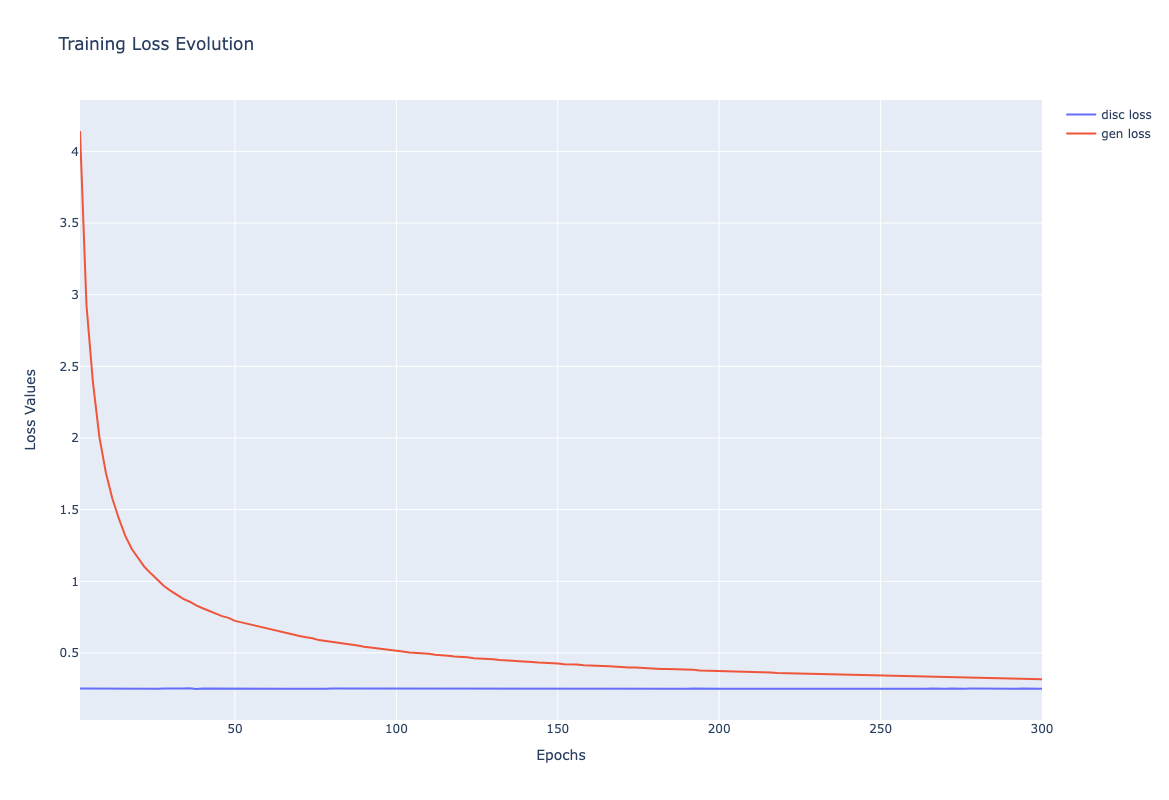

In [9]:
# Plot training losses

file_paths = ['/ix/lshangguan/adr121/losses/all_training_losses{}.json'.format(i) for i in range(2, 301, 2)]


avg_train_d_clean_values = []
avg_train_d_noisy_values = []
avg_train_g_values = []
avg_train_g_conditional_values = []

for path in file_paths:
    loss_file = load_all_losses(path)
    epoch = list(loss_file.keys())[0]
    losses = loss_file[epoch]
    avg_train_d_clean_values.append(losses['avg_train_d_clean'])
    avg_train_d_noisy_values.append(losses['avg_train_d_noisy'])
    avg_train_g_values.append(losses['avg_train_g'])
    avg_train_g_conditional_values.append(losses['avg_train_g_conditional'])

epochs = list(range(2, 301, 2))
# avg_train_d_clean_trace = go.Scatter(x=epochs, y=avg_train_d_clean_values, mode='lines', name='avg_train_d_clean')
avg_train_d_noisy_trace = go.Scatter(x=epochs, y=avg_train_d_noisy_values, mode='lines', name='disc loss')
# avg_train_g_trace = go.Scatter(x=epochs, y=avg_train_g_values, mode='lines', name='avg_train_g')
avg_train_g_conditional_trace = go.Scatter(x=epochs, y=avg_train_g_conditional_values, mode='lines', name='gen loss')

layout = go.Layout(
    title='Training Loss Evolution',
    xaxis=dict(title='Epochs'),
    yaxis=dict(title='Loss Values'),
    width=1200,
    height=800
)

fig = go.Figure(data=[avg_train_d_noisy_trace, avg_train_g_conditional_trace], layout=layout)

fig.show()

In [44]:
# Generate signals, losses for validate or test dataset

BATCH_SIZE = 64
NUM_EPOCHS = 300
ref_d_loss = 1e-4
print('loading data...')
train_dataset = SignalDataset(data_type='train')
val_dataset= SignalDataset(data_type='val')
test_dataset = SignalDataset(data_type='test')

train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_data_loader=DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
# generate reference batch
ref_batch = train_dataset.reference_batch(BATCH_SIZE)

generator = Generator()
discriminator = Discriminator()


generator_path='/ix/lshangguan/adr121/epochs/generator-300.pkl'
discriminator_path='/ix/lshangguan/adr121/epochs/discriminator-300.pkl'
generator.load_state_dict(torch.load(generator_path))
discriminator.load_state_dict(torch.load(discriminator_path))

# saved_model_state_dict=torch.load(discriminator_path)
# for key, value in saved_model_state_dict.items():
#     print(key, value.shape)
generated_outputs, losses, clean_signals, noisy_signals, val_val = validate_model(generator, discriminator, test_data_loader, ref_batch)

loading data...


In [45]:
print(generated_outputs.shape)
print(clean_signals.shape)
print(noisy_signals.shape)
print(val_val.shape)

(6840, 1, 1024)
(6840, 1, 1024)
(6840, 1, 1024)
(6840, 1, 1024)


In [46]:
import plotly.graph_objects as go
def plot_signals(signal_index,generated_outputs_array,clean_array,noisy_array,va_array):

    generated_signal=generated_outputs_array[signal_index].squeeze()
    clean_signal=clean_array[signal_index].squeeze()
    noisy_signal=noisy_array[signal_index].squeeze()
    va_signal=va_array[signal_index].squeeze()
    
    fig_noisy = go.Figure()
    fig_noisy.add_trace(go.Scatter(y=noisy_signal, mode='lines', name='Noisy Signal', line=dict(color='blue')))
    fig_noisy.update_layout(title=f'Noisy Signal {signal_index+1}', xaxis_title='Time', yaxis_title='Amplitude')
    fig_noisy.show(renderer='colab')


    fig_va = go.Figure()
    fig_va.add_trace(go.Scatter(y=va_signal, mode='lines', name='acc Signal', line=dict(color='blue')))
    fig_va.update_layout(title=f'ACC Signal {signal_index+1}', xaxis_title='Time', yaxis_title='Amplitude')
    fig_va.show(renderer='colab')

    fig_clean = go.Figure()
    fig_clean.add_trace(go.Scatter(y=clean_signal, mode='lines', name='Clean Signal', line=dict(color='blue')))
    fig_clean.update_layout(title=f'Clean Signal {signal_index+1}', xaxis_title='Time', yaxis_title='Amplitude')
    fig_clean.show(renderer='colab')
    
    fig_generated = go.Figure()
    fig_generated.add_trace(go.Scatter(y=generated_signal, mode='lines', name='Generated Signal', line=dict(color='blue')))
    fig_generated.update_layout(title=f'Generated Signal {signal_index+1}', xaxis_title='Time', yaxis_title='Amplitude')
    fig_generated.show(renderer='colab')

In [76]:
plot_signals(6, generated_outputs, clean_signals, noisy_signals, val_val)


In [2]:
# if __name__ == '__main__':
#     # parser = argparse.ArgumentParser(description='Train Audio Enhancement')
#     # parser.add_argument('--batch_size', default=64, type=int, help='train batch size')
#     # parser.add_argument('--num_epochs', default=200, type=int, help='train epochs number')
#     # parser.add_argument('--ref_d_loss', default=1e-4, type=int, help='train epochs number')

#     # opt = parser.parse_args()
#     # BATCH_SIZE = opt.batch_size
#     # NUM_EPOCHS = opt.num_epochs
#     # ref_d_loss = opt.ref_d_loss

#     BATCH_SIZE = 64
#     NUM_EPOCHS = 400
#     ref_d_loss = 1e-4

#     # load data
#     print('loading data...')
#     train_dataset = SignalDataset(data_type='train')
#     val_dataset= SignalDataset(data_type='val')
#     test_dataset = SignalDataset(data_type='test')

#     train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#     val_data_loader=DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#     test_data_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#     # generate reference batch
#     ref_batch = train_dataset.reference_batch(BATCH_SIZE)
    

#     # create D and G instances
#     discriminator = Discriminator()
#     generator = Generator()
#     if torch.cuda.is_available():
#         discriminator.cuda()
#         generator.cuda()
#         ref_batch = ref_batch.cuda()
#     ref_batch = Variable(ref_batch)
#     print("# generator parameters:", sum(param.numel() for param in generator.parameters()))
#     print("# discriminator parameters:", sum(param.numel() for param in discriminator.parameters()))
#     # optimizers
#     g_optimizer = optim.RMSprop(generator.parameters(), lr=0.0001)
#     d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0001)
#     for epoch in range(NUM_EPOCHS):
#         train_bar = tqdm(train_data_loader)
        
#         for train_batch, train_clean, train_noisy, train_va in train_bar:

#             # latent vector - normal distribution
#             # print("training batch size 0",train_batch.size(0))
#             z = nn.init.normal_(torch.Tensor(train_batch.size(0), 256, 8))
#             if torch.cuda.is_available():
#                 train_batch, train_clean, train_noisy, train_va = train_batch.cuda(), train_clean.cuda(), train_noisy.cuda(), train_va.cuda()
#                 z = z.cuda()
#             train_batch, train_clean, train_noisy, train_va = Variable(train_batch), Variable(train_clean), Variable(train_noisy), Variable(train_va)
#             z = Variable(z)

#             # TRAIN D to recognize clean audio as clean
#             # training batch pass
#             discriminator.zero_grad()
#             # print("***********")
#             # print(train_clean.shape)
#             # print(train_noisy.shape)
#             # print(torch.cat((train_clean, train_noisy),dim=1).shape)
#             # print("********")
#             # print("ref_batch shape= ",ref_batch.shape)
#             # print("**********")
        
#             # print("ref_batch [:,0:2,:]= ",ref_batch[:,0:2,:].shape)
#             # print("**********")
#             # new_batch_size = ref_batch.size(0) * ref_batch.size(2)
#             # new_sequence_length = ref_batch.size(1)
#             # print()
#             # height = ref_batch.size(3)
#             # print("height: ",height)
            
#             # # Reshape the tensor
#             # ref_batch = ref_batch.view(new_batch_size, new_sequence_length, height)
#             # print("After reshape of ref_batch: ",ref_batch.shape)
#             # print("After reshape of ref_batch[:,0:2,:]= ",ref_batch[:,0:2,:].shape)
#             # print(ref_batch[:,0:2,:])
#             # print("before  disc: ",torch.cat((train_clean, train_noisy), dim=1).shape)
#             # print("train_clean shape before disc: ",train_clean.shape)
#             # print("train_noisy shape before disc: ",train_noisy.shape)
#             outputs = discriminator(torch.cat((train_clean, train_noisy), dim=1), ref_batch[:,0:2,:])
#             clean_loss = torch.mean((outputs - 1.0) ** 2)  # L2 loss - we want them all to be 1
#             # print("Clean loss: ",clean_loss)

#             # TRAIN D to recognize generated audio as noisy
#             generated_outputs = generator(train_noisy, train_va, z)
#             # print("train_noisy shape:  ",train_noisy.shape)
#             outputs = discriminator(torch.cat((generated_outputs, train_noisy), dim=1), ref_batch[:,0:2,:])
#             noisy_loss = torch.mean(outputs ** 2)  # L2 loss - we want them all to be 0

#             d_loss = clean_loss + noisy_loss
#             if d_loss > ref_d_loss:
#                 print('running DISC on: epoch %d\n' % (epoch + 1))
#                 clean_loss.backward()
#                 noisy_loss.backward()
#                 d_optimizer.step()  # update parameters

#             # TRAIN G so that D recognizes G(z) as real
#             generator.zero_grad()
#             generated_outputs = generator(train_noisy, train_va, z)
#             gen_noise_pair = torch.cat((generated_outputs, train_noisy), dim=1)
#             outputs = discriminator(gen_noise_pair, ref_batch[:,0:2,:])

#             g_loss_ = 0.5 * torch.mean((outputs - 1.0) ** 2)
#             # L1 loss between generated output and clean sample
#             l1_dist = torch.abs(torch.add(generated_outputs, torch.neg(train_clean)))
#             g_cond_loss = 100 * torch.mean(l1_dist)  # conditional loss
#             g_loss = g_loss_ + g_cond_loss

#             # backprop + optimize
#             g_loss.backward()
#             g_optimizer.step()

#             train_bar.set_description(
#                 'Epoch {}: d_clean_loss {:.4f}, d_noisy_loss {:.4f}, g_loss {:.4f}, g_conditional_loss {:.4f}'
#                     .format(epoch + 1, clean_loss.data.item(), noisy_loss.data.item(),
#                             g_loss.data.item(), g_cond_loss.data.item()))

#         # TEST model
#         # test_bar = tqdm(test_data_loader, desc='Test model and save generated audios')
#         # for test_file_names, test_noisy, test_va in test_bar:
#         #     z = nn.init.normal(torch.Tensor(test_noisy.size(0), 1024, 8))
#         #     if torch.cuda.is_available():
#         #         test_noisy, test_va, z = test_noisy.cuda(), test_va.cuda(), z.cuda()
#         #     test_noisy, test_va, z = Variable(test_noisy), Variable(test_va), Variable(z)
#         #     fake_speech = generator(test_noisy, test_va, z).data.cpu().numpy()  # convert to numpy array
#             # fake_speech = emphasis(fake_speech, emph_coeff=0.95, pre=False)

#             # for idx in range(fake_speech.shape[0]):
#             #     generated_sample = fake_speech[idx]
#             #     file_name = os.path.join('results',
#             #                              '{}_e{}.wav'.format(test_file_names[idx].replace('.npy', ''), epoch + 1))
#             #     wavfile.write(file_name, sample_rate, generated_sample.T)

#         # save the model parameters for each epoch
#         # save_dir = 'epochs'
#         # if not os.path.exists(save_dir):
#         #     os.makedirs(save_dir)
#         # g_path = os.path.join('/ihome/lshangguan/adr121/Hearables/epochs', 'generator-{}.pkl'.format(epoch + 1))
#         # d_path = os.path.join('/ihome/lshangguan/adr121/Hearables/epochs', 'discriminator-{}.pkl'.format(epoch + 1))
#         # torch.save(generator.state_dict(), g_path)
#         # torch.save(discriminator.state_dict(), d_path)


loading data...
# generator parameters: 7786382
# discriminator parameters: 97473250


  0%|          | 0/713 [00:00<?, ?it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3384, d_noisy_loss 0.3885, g_loss 23.4486, g_conditional_loss 23.4486:   0%|          | 3/713 [00:09<29:56,  2.53s/it]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0261, d_noisy_loss 0.8404, g_loss 19.0185, g_conditional_loss 19.0177:   1%|          | 7/713 [00:09<08:52,  1.33it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5952, d_noisy_loss 0.0005, g_loss 16.8819, g_conditional_loss 16.4099:   1%|▏         | 9/713 [00:10<05:47,  2.03it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6369, d_noisy_loss 0.5238, g_loss 23.3737, g_conditional_loss 22.8852:   1%|▏         | 9/713 [00:10<05:47,  2.03it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0002, d_noisy_loss 0.3461, g_loss 16.2562, g_conditional_loss 16.2186:   2%|▏         | 13/713 [00:11<04:16,  2.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0550, d_noisy_loss 0.1145, g_loss 16.4933, g_conditional_loss 16.4929:   2%|▏         | 13/713 [00:12<04:16,  2.73it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0682, d_noisy_loss 0.0005, g_loss 16.1222, g_conditional_loss 16.1222:   2%|▏         | 17/713 [00:12<04:05,  2.84it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0153, d_noisy_loss 0.9857, g_loss 18.4115, g_conditional_loss 17.9763:   2%|▏         | 17/713 [00:13<04:05,  2.84it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9674, d_noisy_loss 0.0677, g_loss 13.5312, g_conditional_loss 13.5310:   3%|▎         | 21/713 [00:14<03:48,  3.03it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0369, d_noisy_loss 0.2409, g_loss 13.1242, g_conditional_loss 12.6243:   3%|▎         | 21/713 [00:15<03:48,  3.03it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8003, d_noisy_loss 0.0000, g_loss 17.0368, g_conditional_loss 16.6864:   4%|▎         | 25/713 [00:15<03:39,  3.14it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9984, d_noisy_loss 1.0000, g_loss 15.1681, g_conditional_loss 14.7932:   4%|▎         | 25/713 [00:16<03:39,  3.14it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.9914, g_loss 13.0771, g_conditional_loss 13.0562:   4%|▍         | 29/713 [00:17<03:18,  3.45it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0007, d_noisy_loss 0.1485, g_loss 13.5126, g_conditional_loss 13.0139:   5%|▍         | 33/713 [00:18<03:05,  3.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4861, d_noisy_loss 0.1739, g_loss 14.7827, g_conditional_loss 14.2827:   5%|▍         | 33/713 [00:18<03:05,  3.66it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9919, d_noisy_loss 0.9885, g_loss 12.0057, g_conditional_loss 12.0057:   5%|▌         | 37/713 [00:20<03:59,  2.82it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2713, d_noisy_loss 0.0007, g_loss 12.4078, g_conditional_loss 12.4077:   5%|▌         | 37/713 [00:20<03:59,  2.82it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7264, d_noisy_loss 0.0048, g_loss 12.2958, g_conditional_loss 12.2958:   6%|▌         | 41/713 [00:21<03:32,  3.17it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2530, d_noisy_loss 0.0092, g_loss 11.5884, g_conditional_loss 11.1063:   6%|▋         | 45/713 [00:22<03:24,  3.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9712, d_noisy_loss 0.3951, g_loss 10.7952, g_conditional_loss 10.7951:   7%|▋         | 49/713 [00:24<03:16,  3.38it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9781, d_noisy_loss 0.9464, g_loss 11.5726, g_conditional_loss 11.1045:   7%|▋         | 53/713 [00:25<03:30,  3.14it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0131, d_noisy_loss 0.9420, g_loss 10.7304, g_conditional_loss 10.5325:   8%|▊         | 57/713 [00:27<03:10,  3.45it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0494, d_noisy_loss 0.0291, g_loss 9.6097, g_conditional_loss 9.1237:   9%|▊         | 61/713 [00:28<03:05,  3.52it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9970, d_noisy_loss 0.9538, g_loss 10.1012, g_conditional_loss 10.1008:   9%|▉         | 65/713 [00:29<03:04,  3.51it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.0054, g_loss 8.7324, g_conditional_loss 8.7324:  10%|▉         | 69/713 [00:31<02:59,  3.59it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6010, d_noisy_loss 0.0088, g_loss 10.7440, g_conditional_loss 10.2546:  10%|█         | 72/713 [00:32<03:16,  3.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.8598, g_loss 11.3655, g_conditional_loss 10.9997:  10%|█         | 74/713 [00:32<02:23,  4.46it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9849, d_noisy_loss 0.0000, g_loss 9.6171, g_conditional_loss 9.2743:  10%|█         | 74/713 [00:33<02:23,  4.46it/s]  

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.1330, g_loss 9.1854, g_conditional_loss 8.8718:  11%|█         | 78/713 [00:33<02:55,  3.61it/s] 

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0001, d_noisy_loss 0.9944, g_loss 9.4934, g_conditional_loss 9.4634:  11%|█         | 78/713 [00:34<02:55,  3.61it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6466, d_noisy_loss 0.0692, g_loss 12.1014, g_conditional_loss 11.9512:  12%|█▏        | 82/713 [00:35<02:54,  3.61it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0002, d_noisy_loss 0.0000, g_loss 9.5743, g_conditional_loss 9.4018:  12%|█▏        | 82/713 [00:35<02:54,  3.61it/s]  

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7769, d_noisy_loss 0.0002, g_loss 9.2524, g_conditional_loss 9.2524:  12%|█▏        | 86/713 [00:36<02:46,  3.77it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9998, d_noisy_loss 0.9989, g_loss 9.1697, g_conditional_loss 9.1555:  12%|█▏        | 86/713 [00:36<02:46,  3.77it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9984, d_noisy_loss 0.9997, g_loss 8.8422, g_conditional_loss 8.8018:  13%|█▎        | 90/713 [00:37<02:42,  3.83it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0029, d_noisy_loss 0.9858, g_loss 9.5907, g_conditional_loss 9.5904:  13%|█▎        | 94/713 [00:38<03:02,  3.39it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.0028, g_loss 9.4639, g_conditional_loss 8.9639:  13%|█▎        | 94/713 [00:39<03:02,  3.39it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.0004, g_loss 9.8355, g_conditional_loss 9.8354:  14%|█▎        | 98/713 [00:40<03:20,  3.07it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.0012, g_loss 9.3410, g_conditional_loss 8.8509:  14%|█▍        | 102/713 [00:41<03:01,  3.37it/s] 

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0001, d_noisy_loss 0.8230, g_loss 8.3572, g_conditional_loss 8.3572:  14%|█▍        | 102/713 [00:42<03:01,  3.37it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2063, d_noisy_loss 0.7992, g_loss 9.8017, g_conditional_loss 9.8017:  15%|█▍        | 106/713 [00:43<03:06,  3.26it/s] 

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9714, d_noisy_loss 0.0772, g_loss 10.6160, g_conditional_loss 10.1294:  15%|█▍        | 106/713 [00:44<03:06,  3.26it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9976, d_noisy_loss 0.3580, g_loss 8.9923, g_conditional_loss 8.7497:  15%|█▌        | 110/713 [00:45<03:23,  2.96it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2474, d_noisy_loss 0.9984, g_loss 8.4641, g_conditional_loss 8.1144:  16%|█▌        | 114/713 [00:46<02:59,  3.33it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0001, d_noisy_loss 0.9670, g_loss 7.6046, g_conditional_loss 7.1535:  16%|█▌        | 114/713 [00:46<02:59,  3.33it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1869, d_noisy_loss 0.9782, g_loss 9.7787, g_conditional_loss 9.7775:  17%|█▋        | 118/713 [00:47<02:45,  3.60it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9869, d_noisy_loss 0.8337, g_loss 10.2532, g_conditional_loss 9.8668:  17%|█▋        | 118/713 [00:47<02:45,  3.60it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0002, d_noisy_loss 0.9862, g_loss 11.2338, g_conditional_loss 10.8423:  17%|█▋        | 122/713 [00:49<03:11,  3.09it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7513, d_noisy_loss 0.0005, g_loss 9.0414, g_conditional_loss 8.5460:  18%|█▊        | 126/713 [00:50<02:42,  3.62it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8291, d_noisy_loss 0.0883, g_loss 8.5183, g_conditional_loss 8.4238:  18%|█▊        | 126/713 [00:50<02:42,  3.62it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1991, d_noisy_loss 0.9874, g_loss 7.9258, g_conditional_loss 7.4626:  18%|█▊        | 130/713 [00:51<02:33,  3.80it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7942, d_noisy_loss 0.8525, g_loss 7.8690, g_conditional_loss 7.8688:  18%|█▊        | 130/713 [00:51<02:33,  3.80it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.0000, g_loss 10.8884, g_conditional_loss 10.3911:  19%|█▉        | 134/713 [00:52<02:19,  4.14it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0418, d_noisy_loss 0.4398, g_loss 9.3893, g_conditional_loss 9.3763:  19%|█▉        | 134/713 [00:53<02:19,  4.14it/s]  

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0005, d_noisy_loss 0.0001, g_loss 7.9803, g_conditional_loss 7.5861:  19%|█▉        | 138/713 [00:53<02:26,  3.94it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0781, d_noisy_loss 0.0000, g_loss 8.6479, g_conditional_loss 8.4592:  19%|█▉        | 138/713 [00:54<02:26,  3.94it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9911, d_noisy_loss 0.0000, g_loss 9.4889, g_conditional_loss 9.4464:  20%|█▉        | 142/713 [00:55<02:57,  3.22it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0063, d_noisy_loss 0.3057, g_loss 9.0507, g_conditional_loss 9.0507:  20%|█▉        | 142/713 [00:55<02:57,  3.22it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2099, d_noisy_loss 0.9657, g_loss 8.8694, g_conditional_loss 8.6002:  20%|██        | 146/713 [00:56<02:45,  3.42it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.9545, g_loss 8.3983, g_conditional_loss 7.9294:  20%|██        | 146/713 [00:57<02:45,  3.42it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0657, d_noisy_loss 0.8374, g_loss 9.8418, g_conditional_loss 9.3867:  21%|██        | 150/713 [00:58<02:44,  3.42it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0005, d_noisy_loss 0.0131, g_loss 9.0129, g_conditional_loss 8.9983:  21%|██        | 150/713 [00:58<02:44,  3.42it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.9712, g_loss 7.7727, g_conditional_loss 7.4009:  22%|██▏       | 154/713 [00:59<02:30,  3.71it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7721, d_noisy_loss 0.0013, g_loss 8.0402, g_conditional_loss 7.6194:  22%|██▏       | 154/713 [01:00<02:30,  3.71it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0745, d_noisy_loss 0.6260, g_loss 7.8245, g_conditional_loss 7.3447:  22%|██▏       | 158/713 [01:01<03:02,  3.04it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8520, d_noisy_loss 0.9280, g_loss 6.5582, g_conditional_loss 6.5580:  22%|██▏       | 158/713 [01:01<03:02,  3.04it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4178, d_noisy_loss 0.0279, g_loss 7.8685, g_conditional_loss 7.8599:  23%|██▎       | 162/713 [01:02<03:05,  2.97it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3070, d_noisy_loss 0.2367, g_loss 8.3801, g_conditional_loss 8.3801:  23%|██▎       | 162/713 [01:03<03:05,  2.97it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0278, d_noisy_loss 0.0090, g_loss 7.9662, g_conditional_loss 7.5554:  23%|██▎       | 166/713 [01:04<02:47,  3.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9433, d_noisy_loss 0.6940, g_loss 7.3282, g_conditional_loss 7.3280:  23%|██▎       | 166/713 [01:04<02:47,  3.27it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0040, d_noisy_loss 0.9907, g_loss 8.0698, g_conditional_loss 8.0346:  24%|██▍       | 170/713 [01:05<02:25,  3.73it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0581, d_noisy_loss 0.6348, g_loss 7.3658, g_conditional_loss 7.3476:  24%|██▍       | 170/713 [01:05<02:25,  3.73it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3556, d_noisy_loss 0.5322, g_loss 7.6456, g_conditional_loss 7.6456:  24%|██▍       | 172/713 [01:07<04:29,  2.00it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2866, d_noisy_loss 0.0012, g_loss 8.3281, g_conditional_loss 8.3271:  25%|██▍       | 175/713 [01:07<03:39,  2.45it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9000, d_noisy_loss 0.8390, g_loss 7.9886, g_conditional_loss 7.9883:  25%|██▍       | 176/713 [01:09<06:03,  1.48it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9307, d_noisy_loss 0.5339, g_loss 9.4598, g_conditional_loss 8.9971:  25%|██▍       | 178/713 [01:09<04:05,  2.18it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0002, d_noisy_loss 0.0337, g_loss 8.1959, g_conditional_loss 7.7284:  26%|██▌       | 182/713 [01:11<03:27,  2.56it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2209, d_noisy_loss 0.7225, g_loss 8.3034, g_conditional_loss 7.8043:  26%|██▌       | 183/713 [01:11<03:25,  2.58it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1620, d_noisy_loss 0.8752, g_loss 6.9780, g_conditional_loss 6.9779:  26%|██▌       | 186/713 [01:12<02:41,  3.26it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.8976, d_noisy_loss 0.0405, g_loss 7.3952, g_conditional_loss 7.3940:  26%|██▌       | 187/713 [01:12<02:39,  3.29it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7767, d_noisy_loss 0.9082, g_loss 8.2526, g_conditional_loss 7.7532:  27%|██▋       | 190/713 [01:13<02:11,  3.98it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0372, d_noisy_loss 0.7809, g_loss 7.4456, g_conditional_loss 7.3910:  27%|██▋       | 191/713 [01:14<02:50,  3.05it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0000, d_noisy_loss 0.0000, g_loss 6.9575, g_conditional_loss 6.6957:  27%|██▋       | 194/713 [01:15<02:29,  3.48it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0112, d_noisy_loss 0.0008, g_loss 7.5835, g_conditional_loss 7.4733:  27%|██▋       | 195/713 [01:15<02:13,  3.89it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2843, d_noisy_loss 0.1579, g_loss 9.4499, g_conditional_loss 9.4216:  28%|██▊       | 198/713 [01:16<02:42,  3.18it/s]  

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9977, d_noisy_loss 0.1821, g_loss 7.3866, g_conditional_loss 6.9304:  28%|██▊       | 199/713 [01:16<02:37,  3.27it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1703, d_noisy_loss 0.0001, g_loss 7.3654, g_conditional_loss 6.9000:  28%|██▊       | 202/713 [01:18<02:59,  2.84it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0191, d_noisy_loss 0.2699, g_loss 6.9075, g_conditional_loss 6.8974:  29%|██▉       | 206/713 [01:19<02:25,  3.48it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0659, d_noisy_loss 0.8582, g_loss 8.9456, g_conditional_loss 8.6560:  29%|██▉       | 207/713 [01:19<02:28,  3.41it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4968, d_noisy_loss 0.9818, g_loss 7.0141, g_conditional_loss 6.5949:  29%|██▉       | 210/713 [01:20<02:11,  3.83it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0015, d_noisy_loss 0.6670, g_loss 7.4516, g_conditional_loss 7.4436:  30%|██▉       | 211/713 [01:20<01:59,  4.19it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0022, d_noisy_loss 0.0699, g_loss 8.0910, g_conditional_loss 7.8041:  30%|███       | 214/713 [01:21<02:16,  3.65it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0625, d_noisy_loss 0.0174, g_loss 8.5717, g_conditional_loss 8.1177:  31%|███       | 218/713 [01:23<02:43,  3.02it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3934, d_noisy_loss 0.5582, g_loss 7.3120, g_conditional_loss 7.0021:  31%|███       | 222/713 [01:24<02:19,  3.52it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4719, d_noisy_loss 0.2709, g_loss 8.4646, g_conditional_loss 8.2063:  32%|███▏      | 226/713 [01:26<02:12,  3.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2856, d_noisy_loss 0.0871, g_loss 7.9279, g_conditional_loss 7.6969:  32%|███▏      | 230/713 [01:27<02:05,  3.85it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1190, d_noisy_loss 0.0051, g_loss 6.6968, g_conditional_loss 6.6967:  33%|███▎      | 234/713 [01:28<02:04,  3.83it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4448, d_noisy_loss 0.6696, g_loss 7.3583, g_conditional_loss 6.9092:  33%|███▎      | 238/713 [01:30<02:25,  3.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2684, d_noisy_loss 0.0041, g_loss 7.3698, g_conditional_loss 6.8776:  34%|███▍      | 242/713 [01:31<02:16,  3.45it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1425, d_noisy_loss 0.7894, g_loss 8.7885, g_conditional_loss 8.4243:  35%|███▍      | 246/713 [01:32<01:59,  3.92it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0653, d_noisy_loss 0.9964, g_loss 8.0232, g_conditional_loss 7.5285:  35%|███▍      | 246/713 [01:32<01:59,  3.92it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5718, d_noisy_loss 0.8113, g_loss 6.8062, g_conditional_loss 6.5536:  35%|███▌      | 250/713 [01:33<02:10,  3.54it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0010, d_noisy_loss 0.3683, g_loss 8.6601, g_conditional_loss 8.3486:  35%|███▌      | 253/713 [01:34<02:20,  3.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4776, d_noisy_loss 0.0698, g_loss 7.3504, g_conditional_loss 7.0179:  36%|███▌      | 255/713 [01:35<01:42,  4.47it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0007, d_noisy_loss 0.1476, g_loss 6.2660, g_conditional_loss 6.2461:  36%|███▌      | 257/713 [01:36<02:50,  2.67it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0413, d_noisy_loss 0.7624, g_loss 7.2189, g_conditional_loss 7.0797:  36%|███▋      | 259/713 [01:36<02:04,  3.63it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6437, d_noisy_loss 0.0706, g_loss 6.3115, g_conditional_loss 6.3047:  36%|███▋      | 259/713 [01:37<02:04,  3.63it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2149, d_noisy_loss 0.0001, g_loss 6.8000, g_conditional_loss 6.7139:  37%|███▋      | 263/713 [01:37<01:56,  3.85it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9977, d_noisy_loss 0.0002, g_loss 6.6359, g_conditional_loss 6.5963:  37%|███▋      | 265/713 [01:38<02:23,  3.12it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0051, d_noisy_loss 0.1451, g_loss 6.8636, g_conditional_loss 6.7894:  37%|███▋      | 267/713 [01:38<01:47,  4.14it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5077, d_noisy_loss 0.5228, g_loss 6.5579, g_conditional_loss 6.2969:  38%|███▊      | 269/713 [01:40<02:39,  2.78it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6870, d_noisy_loss 0.5088, g_loss 6.4698, g_conditional_loss 6.4670:  38%|███▊      | 273/713 [01:41<02:28,  2.96it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5357, d_noisy_loss 0.0263, g_loss 5.8820, g_conditional_loss 5.7712:  38%|███▊      | 274/713 [01:41<02:17,  3.18it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2309, d_noisy_loss 0.0155, g_loss 6.0468, g_conditional_loss 5.8855:  39%|███▉      | 277/713 [01:42<02:12,  3.28it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2385, d_noisy_loss 0.3718, g_loss 7.0805, g_conditional_loss 6.9758:  39%|███▉      | 278/713 [01:43<02:46,  2.61it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5184, d_noisy_loss 0.0071, g_loss 7.2449, g_conditional_loss 6.8031:  39%|███▉      | 280/713 [01:43<02:13,  3.24it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9466, d_noisy_loss 0.4904, g_loss 6.5051, g_conditional_loss 6.2401:  39%|███▉      | 281/713 [01:43<02:04,  3.46it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4775, d_noisy_loss 0.8130, g_loss 7.5332, g_conditional_loss 7.2907:  40%|███▉      | 282/713 [01:44<03:41,  1.95it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.9736, d_noisy_loss 0.0585, g_loss 7.2449, g_conditional_loss 7.2422:  40%|███▉      | 284/713 [01:45<02:27,  2.92it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2471, d_noisy_loss 0.9767, g_loss 6.3464, g_conditional_loss 6.3150:  40%|████      | 288/713 [01:46<02:29,  2.85it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0596, d_noisy_loss 0.1118, g_loss 6.3393, g_conditional_loss 5.8516:  41%|████      | 292/713 [01:47<01:58,  3.55it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1158, d_noisy_loss 0.1329, g_loss 6.6130, g_conditional_loss 6.6116:  42%|████▏     | 296/713 [01:48<01:56,  3.59it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4980, d_noisy_loss 0.3221, g_loss 6.8597, g_conditional_loss 6.8321:  42%|████▏     | 300/713 [01:49<01:41,  4.06it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2990, d_noisy_loss 0.6661, g_loss 6.2373, g_conditional_loss 6.0570:  43%|████▎     | 304/713 [01:51<01:42,  3.98it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3299, d_noisy_loss 0.1916, g_loss 6.1582, g_conditional_loss 5.8634:  43%|████▎     | 308/713 [01:52<01:39,  4.08it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1466, d_noisy_loss 0.0123, g_loss 6.8847, g_conditional_loss 6.5207:  44%|████▍     | 312/713 [01:54<02:09,  3.11it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0672, d_noisy_loss 0.3086, g_loss 6.0760, g_conditional_loss 5.7123:  44%|████▍     | 316/713 [01:55<02:15,  2.93it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0971, d_noisy_loss 0.1525, g_loss 6.6589, g_conditional_loss 6.6315:  45%|████▍     | 320/713 [01:57<02:07,  3.07it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1923, d_noisy_loss 0.0007, g_loss 6.0749, g_conditional_loss 6.0661:  45%|████▌     | 324/713 [01:58<01:49,  3.56it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1603, d_noisy_loss 0.5773, g_loss 7.1415, g_conditional_loss 6.9262:  46%|████▌     | 328/713 [01:59<01:34,  4.05it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2428, d_noisy_loss 0.3720, g_loss 5.7385, g_conditional_loss 5.6514:  47%|████▋     | 332/713 [02:00<01:35,  3.98it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1414, d_noisy_loss 0.0051, g_loss 7.1278, g_conditional_loss 7.0919:  47%|████▋     | 336/713 [02:01<01:35,  3.93it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.6030, d_noisy_loss 0.5587, g_loss 6.3554, g_conditional_loss 6.2938:  48%|████▊     | 340/713 [02:03<01:46,  3.49it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1202, d_noisy_loss 0.0290, g_loss 7.0655, g_conditional_loss 7.0586:  48%|████▊     | 344/713 [02:04<01:34,  3.89it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2053, d_noisy_loss 0.3473, g_loss 6.9425, g_conditional_loss 6.6790:  49%|████▉     | 348/713 [02:05<01:25,  4.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2558, d_noisy_loss 0.2919, g_loss 6.4619, g_conditional_loss 6.3016:  49%|████▉     | 352/713 [02:06<01:23,  4.33it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3684, d_noisy_loss 0.7005, g_loss 6.7787, g_conditional_loss 6.7502:  50%|████▉     | 356/713 [02:07<01:23,  4.28it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0643, d_noisy_loss 0.1275, g_loss 6.7992, g_conditional_loss 6.7980:  50%|█████     | 360/713 [02:08<01:28,  3.98it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3236, d_noisy_loss 0.2134, g_loss 7.2889, g_conditional_loss 7.0741:  51%|█████     | 364/713 [02:10<01:51,  3.14it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2114, d_noisy_loss 0.5866, g_loss 6.2286, g_conditional_loss 6.1896:  52%|█████▏    | 368/713 [02:11<01:31,  3.76it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1413, d_noisy_loss 0.3473, g_loss 5.7452, g_conditional_loss 5.6235:  52%|█████▏    | 372/713 [02:13<01:45,  3.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1168, d_noisy_loss 0.0063, g_loss 5.7211, g_conditional_loss 5.5856:  53%|█████▎    | 376/713 [02:14<01:37,  3.47it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3354, d_noisy_loss 0.0686, g_loss 5.3047, g_conditional_loss 5.1982:  53%|█████▎    | 380/713 [02:15<01:23,  3.99it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1439, d_noisy_loss 0.0569, g_loss 6.0094, g_conditional_loss 5.7276:  54%|█████▍    | 384/713 [02:16<01:20,  4.10it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0517, d_noisy_loss 0.1565, g_loss 5.7437, g_conditional_loss 5.5998:  54%|█████▍    | 388/713 [02:18<01:50,  2.95it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7581, d_noisy_loss 0.2210, g_loss 5.4846, g_conditional_loss 5.4705:  54%|█████▍    | 388/713 [02:18<01:50,  2.95it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1013, d_noisy_loss 0.1292, g_loss 5.7888, g_conditional_loss 5.7653:  55%|█████▍    | 392/713 [02:19<01:27,  3.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.5745, d_noisy_loss 0.0766, g_loss 6.1559, g_conditional_loss 5.8161:  56%|█████▌    | 396/713 [02:20<01:20,  3.95it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.7228, d_noisy_loss 0.5822, g_loss 6.0856, g_conditional_loss 6.0168:  56%|█████▌    | 400/713 [02:21<01:24,  3.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1926, d_noisy_loss 0.3091, g_loss 6.6711, g_conditional_loss 6.6514:  57%|█████▋    | 404/713 [02:23<01:21,  3.79it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3131, d_noisy_loss 0.1498, g_loss 7.6132, g_conditional_loss 7.4746:  57%|█████▋    | 408/713 [02:24<01:32,  3.29it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0807, d_noisy_loss 0.6300, g_loss 5.4364, g_conditional_loss 5.3296:  58%|█████▊    | 412/713 [02:25<01:23,  3.62it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3272, d_noisy_loss 0.2558, g_loss 5.3808, g_conditional_loss 5.2935:  58%|█████▊    | 416/713 [02:26<01:10,  4.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2077, d_noisy_loss 0.1928, g_loss 5.0678, g_conditional_loss 4.8745:  59%|█████▊    | 418/713 [02:27<01:26,  3.41it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1097, d_noisy_loss 0.4849, g_loss 5.2678, g_conditional_loss 5.1544:  59%|█████▉    | 420/713 [02:28<01:19,  3.68it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1996, d_noisy_loss 0.1010, g_loss 5.1372, g_conditional_loss 5.0844:  59%|█████▉    | 422/713 [02:28<01:20,  3.61it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2317, d_noisy_loss 0.2492, g_loss 8.4795, g_conditional_loss 8.3877:  59%|█████▉    | 424/713 [02:29<01:30,  3.21it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1845, d_noisy_loss 0.2396, g_loss 6.0552, g_conditional_loss 5.9115:  60%|█████▉    | 426/713 [02:29<01:19,  3.59it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4845, d_noisy_loss 0.1791, g_loss 5.1606, g_conditional_loss 5.0766:  60%|██████    | 428/713 [02:30<01:37,  2.94it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1632, d_noisy_loss 0.1613, g_loss 5.0943, g_conditional_loss 5.0117:  60%|██████    | 430/713 [02:31<01:23,  3.39it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1058, d_noisy_loss 0.2172, g_loss 5.1745, g_conditional_loss 5.1002:  61%|██████    | 432/713 [02:32<01:50,  2.54it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2191, d_noisy_loss 0.2434, g_loss 5.3204, g_conditional_loss 5.1391:  61%|██████    | 434/713 [02:32<01:29,  3.12it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2079, d_noisy_loss 0.3053, g_loss 5.5805, g_conditional_loss 5.4492:  61%|██████    | 436/713 [02:33<01:45,  2.63it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2733, d_noisy_loss 0.1501, g_loss 6.6389, g_conditional_loss 6.5806:  61%|██████▏   | 438/713 [02:34<01:25,  3.21it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3536, d_noisy_loss 0.2440, g_loss 7.5225, g_conditional_loss 7.4430:  62%|██████▏   | 440/713 [02:34<01:33,  2.92it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1605, d_noisy_loss 0.2113, g_loss 7.0958, g_conditional_loss 6.9831:  62%|██████▏   | 442/713 [02:35<01:15,  3.58it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3785, d_noisy_loss 0.1585, g_loss 5.2507, g_conditional_loss 5.1739:  62%|██████▏   | 444/713 [02:35<01:23,  3.22it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1815, d_noisy_loss 0.3445, g_loss 5.5436, g_conditional_loss 5.4412:  63%|██████▎   | 446/713 [02:36<01:07,  3.95it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0774, d_noisy_loss 0.3802, g_loss 6.5931, g_conditional_loss 6.4152:  63%|██████▎   | 450/713 [02:37<01:01,  4.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1361, d_noisy_loss 0.3428, g_loss 5.7762, g_conditional_loss 5.6537:  63%|██████▎   | 450/713 [02:37<01:01,  4.27it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2239, d_noisy_loss 0.4458, g_loss 5.5047, g_conditional_loss 5.3769:  64%|██████▎   | 454/713 [02:38<01:16,  3.40it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2727, d_noisy_loss 0.2227, g_loss 6.0391, g_conditional_loss 5.9438:  64%|██████▍   | 458/713 [02:39<01:05,  3.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1934, d_noisy_loss 0.1943, g_loss 6.2258, g_conditional_loss 6.1309:  64%|██████▍   | 458/713 [02:39<01:05,  3.90it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.4159, d_noisy_loss 0.0786, g_loss 5.4318, g_conditional_loss 5.2497:  65%|██████▍   | 462/713 [02:40<01:02,  4.00it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3885, d_noisy_loss 0.0439, g_loss 5.6669, g_conditional_loss 5.4489:  65%|██████▌   | 466/713 [02:42<01:02,  3.96it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2558, d_noisy_loss 0.2294, g_loss 5.3513, g_conditional_loss 5.2822:  65%|██████▌   | 466/713 [02:42<01:02,  3.96it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.0662, d_noisy_loss 0.2052, g_loss 6.6181, g_conditional_loss 6.4032:  66%|██████▌   | 470/713 [02:43<01:00,  4.04it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3652, d_noisy_loss 0.1475, g_loss 4.8308, g_conditional_loss 4.7552:  66%|██████▋   | 474/713 [02:44<00:57,  4.14it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2361, d_noisy_loss 0.2659, g_loss 5.0545, g_conditional_loss 4.9275:  67%|██████▋   | 478/713 [02:45<00:52,  4.47it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1955, d_noisy_loss 0.2732, g_loss 5.6525, g_conditional_loss 5.5922:  68%|██████▊   | 482/713 [02:46<00:58,  3.97it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2497, d_noisy_loss 0.2308, g_loss 6.7016, g_conditional_loss 6.5738:  68%|██████▊   | 486/713 [02:47<00:53,  4.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2106, d_noisy_loss 0.2348, g_loss 5.1345, g_conditional_loss 5.0060:  69%|██████▊   | 490/713 [02:49<01:04,  3.47it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2909, d_noisy_loss 0.2048, g_loss 4.9389, g_conditional_loss 4.7675:  69%|██████▉   | 494/713 [02:50<00:56,  3.86it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1430, d_noisy_loss 0.2034, g_loss 5.7183, g_conditional_loss 5.5859:  70%|██████▉   | 498/713 [02:51<00:59,  3.59it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3123, d_noisy_loss 0.2270, g_loss 5.4897, g_conditional_loss 5.3759:  70%|███████   | 502/713 [02:52<00:57,  3.65it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2420, d_noisy_loss 0.2745, g_loss 4.8697, g_conditional_loss 4.7173:  71%|███████   | 506/713 [02:54<00:52,  3.93it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3034, d_noisy_loss 0.3076, g_loss 6.2748, g_conditional_loss 6.1581:  72%|███████▏  | 510/713 [02:55<00:53,  3.80it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2718, d_noisy_loss 0.2241, g_loss 5.2400, g_conditional_loss 5.0795:  72%|███████▏  | 514/713 [02:56<00:47,  4.17it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2443, d_noisy_loss 0.2526, g_loss 5.1773, g_conditional_loss 5.0646:  73%|███████▎  | 518/713 [02:57<00:45,  4.27it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2039, d_noisy_loss 0.2577, g_loss 6.1352, g_conditional_loss 5.9878:  73%|███████▎  | 522/713 [02:58<00:53,  3.58it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2027, d_noisy_loss 0.2223, g_loss 5.6905, g_conditional_loss 5.5902:  74%|███████▍  | 526/713 [03:00<00:52,  3.54it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2454, d_noisy_loss 0.2706, g_loss 4.6184, g_conditional_loss 4.4843:  74%|███████▍  | 530/713 [03:01<00:45,  4.06it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2800, d_noisy_loss 0.2175, g_loss 5.1311, g_conditional_loss 5.0295:  75%|███████▍  | 534/713 [03:02<00:54,  3.28it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2497, d_noisy_loss 0.2536, g_loss 5.6826, g_conditional_loss 5.5378:  75%|███████▌  | 538/713 [03:03<00:46,  3.78it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2614, d_noisy_loss 0.3023, g_loss 4.8287, g_conditional_loss 4.6743:  76%|███████▌  | 542/713 [03:04<00:40,  4.18it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2852, d_noisy_loss 0.2716, g_loss 5.9034, g_conditional_loss 5.7832:  77%|███████▋  | 546/713 [03:06<00:40,  4.15it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2405, d_noisy_loss 0.1884, g_loss 4.7745, g_conditional_loss 4.6937:  77%|███████▋  | 550/713 [03:07<00:37,  4.32it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.1832, d_noisy_loss 0.2831, g_loss 4.9999, g_conditional_loss 4.8912:  78%|███████▊  | 554/713 [03:07<00:34,  4.62it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2562, d_noisy_loss 0.2057, g_loss 5.8739, g_conditional_loss 5.7606:  78%|███████▊  | 558/713 [03:08<00:33,  4.65it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2323, d_noisy_loss 0.2657, g_loss 6.3434, g_conditional_loss 6.2583:  79%|███████▉  | 562/713 [03:10<00:34,  4.41it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2711, d_noisy_loss 0.2521, g_loss 4.7930, g_conditional_loss 4.6427:  79%|███████▉  | 564/713 [03:10<00:42,  3.48it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2622, d_noisy_loss 0.2308, g_loss 5.2985, g_conditional_loss 5.1841:  80%|███████▉  | 567/713 [03:11<00:28,  5.08it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2658, d_noisy_loss 0.1986, g_loss 5.3671, g_conditional_loss 5.2557:  80%|███████▉  | 569/713 [03:12<00:59,  2.44it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2842, d_noisy_loss 0.2808, g_loss 4.7231, g_conditional_loss 4.6307:  80%|████████  | 573/713 [03:15<01:11,  1.95it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3003, d_noisy_loss 0.2483, g_loss 5.3074, g_conditional_loss 5.1864:  81%|████████  | 575/713 [03:15<00:51,  2.67it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2275, d_noisy_loss 0.3219, g_loss 5.3003, g_conditional_loss 5.1890:  81%|████████  | 578/713 [03:16<00:46,  2.88it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2941, d_noisy_loss 0.1950, g_loss 5.3373, g_conditional_loss 5.2373:  82%|████████▏ | 582/713 [03:17<00:35,  3.66it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2579, d_noisy_loss 0.2862, g_loss 6.3547, g_conditional_loss 6.2015:  82%|████████▏ | 586/713 [03:18<00:30,  4.10it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2218, d_noisy_loss 0.2027, g_loss 6.9829, g_conditional_loss 6.8560:  83%|████████▎ | 590/713 [03:19<00:27,  4.50it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2069, d_noisy_loss 0.2418, g_loss 5.2799, g_conditional_loss 5.1649:  83%|████████▎ | 594/713 [03:20<00:27,  4.40it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2677, d_noisy_loss 0.2452, g_loss 5.4611, g_conditional_loss 5.3336:  84%|████████▍ | 598/713 [03:22<00:35,  3.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2668, d_noisy_loss 0.2918, g_loss 5.7460, g_conditional_loss 5.6294:  84%|████████▍ | 602/713 [03:24<00:39,  2.80it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2766, d_noisy_loss 0.2522, g_loss 4.3934, g_conditional_loss 4.2865:  85%|████████▍ | 606/713 [03:25<00:32,  3.31it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2559, d_noisy_loss 0.2392, g_loss 4.5142, g_conditional_loss 4.4086:  86%|████████▌ | 610/713 [03:26<00:29,  3.55it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2354, d_noisy_loss 0.2215, g_loss 5.3000, g_conditional_loss 5.1708:  86%|████████▌ | 614/713 [03:27<00:27,  3.61it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2070, d_noisy_loss 0.2615, g_loss 4.8100, g_conditional_loss 4.6759:  87%|████████▋ | 618/713 [03:28<00:23,  4.11it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2155, d_noisy_loss 0.2484, g_loss 6.3742, g_conditional_loss 6.2802:  87%|████████▋ | 622/713 [03:29<00:20,  4.39it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2780, d_noisy_loss 0.2413, g_loss 4.4767, g_conditional_loss 4.3623:  88%|████████▊ | 626/713 [03:30<00:22,  3.92it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2139, d_noisy_loss 0.2034, g_loss 5.6107, g_conditional_loss 5.4931:  88%|████████▊ | 630/713 [03:31<00:18,  4.38it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2309, d_noisy_loss 0.2537, g_loss 4.7990, g_conditional_loss 4.6558:  89%|████████▊ | 632/713 [03:32<00:23,  3.50it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2213, d_noisy_loss 0.2475, g_loss 5.7505, g_conditional_loss 5.6011:  89%|████████▉ | 635/713 [03:33<00:17,  4.44it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2307, d_noisy_loss 0.2728, g_loss 6.0682, g_conditional_loss 5.9300:  89%|████████▉ | 636/713 [03:33<00:23,  3.21it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2643, d_noisy_loss 0.2506, g_loss 5.1087, g_conditional_loss 4.9816:  90%|████████▉ | 639/713 [03:34<00:16,  4.49it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2699, d_noisy_loss 0.3018, g_loss 5.0998, g_conditional_loss 4.9541:  90%|████████▉ | 640/713 [03:34<00:21,  3.41it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2257, d_noisy_loss 0.1832, g_loss 6.4549, g_conditional_loss 6.3387:  90%|█████████ | 643/713 [03:35<00:15,  4.39it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2662, d_noisy_loss 0.1796, g_loss 4.7184, g_conditional_loss 4.6151:  90%|█████████ | 644/713 [03:35<00:17,  3.85it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2702, d_noisy_loss 0.2859, g_loss 4.7806, g_conditional_loss 4.6577:  91%|█████████ | 647/713 [03:36<00:16,  4.12it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2827, d_noisy_loss 0.2197, g_loss 5.5800, g_conditional_loss 5.4316:  91%|█████████ | 648/713 [03:36<00:14,  4.50it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2623, d_noisy_loss 0.2665, g_loss 4.6937, g_conditional_loss 4.5441:  91%|█████████▏| 651/713 [03:37<00:14,  4.24it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2373, d_noisy_loss 0.2801, g_loss 4.8624, g_conditional_loss 4.7508:  91%|█████████▏| 652/713 [03:38<00:14,  4.14it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2665, d_noisy_loss 0.3023, g_loss 5.7244, g_conditional_loss 5.5689:  92%|█████████▏| 655/713 [03:38<00:12,  4.46it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2464, d_noisy_loss 0.2802, g_loss 4.5833, g_conditional_loss 4.4371:  92%|█████████▏| 656/713 [03:39<00:15,  3.71it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2917, d_noisy_loss 0.2839, g_loss 4.8701, g_conditional_loss 4.7295:  92%|█████████▏| 659/713 [03:40<00:12,  4.23it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2826, d_noisy_loss 0.2902, g_loss 4.9351, g_conditional_loss 4.7789:  93%|█████████▎| 660/713 [03:40<00:18,  2.79it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2804, d_noisy_loss 0.2296, g_loss 4.4984, g_conditional_loss 4.3812:  93%|█████████▎| 663/713 [03:41<00:11,  4.44it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2755, d_noisy_loss 0.2314, g_loss 5.5774, g_conditional_loss 5.4710:  93%|█████████▎| 666/713 [03:42<00:13,  3.46it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2466, d_noisy_loss 0.2786, g_loss 5.3851, g_conditional_loss 5.2671:  94%|█████████▎| 668/713 [03:43<00:15,  2.90it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2468, d_noisy_loss 0.2699, g_loss 4.7944, g_conditional_loss 4.6517:  94%|█████████▍| 671/713 [03:43<00:09,  4.49it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2425, d_noisy_loss 0.2159, g_loss 5.1041, g_conditional_loss 4.9842:  94%|█████████▍| 672/713 [03:44<00:13,  3.06it/s]

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2481, d_noisy_loss 0.2787, g_loss 4.5589, g_conditional_loss 4.4057:  95%|█████████▍| 675/713 [03:44<00:08,  4.72it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2088, d_noisy_loss 0.2347, g_loss 4.8021, g_conditional_loss 4.6651:  95%|█████████▌| 678/713 [03:45<00:08,  4.05it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2244, d_noisy_loss 0.1624, g_loss 4.7309, g_conditional_loss 4.6090:  96%|█████████▌| 682/713 [03:47<00:07,  3.90it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2604, d_noisy_loss 0.1755, g_loss 4.7075, g_conditional_loss 4.6082:  96%|█████████▌| 686/713 [03:48<00:07,  3.58it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3441, d_noisy_loss 0.2568, g_loss 5.3656, g_conditional_loss 5.2146:  97%|█████████▋| 690/713 [03:49<00:05,  3.97it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2436, d_noisy_loss 0.2520, g_loss 5.5101, g_conditional_loss 5.3563:  97%|█████████▋| 694/713 [03:51<00:05,  3.34it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2359, d_noisy_loss 0.2902, g_loss 5.8889, g_conditional_loss 5.8094:  98%|█████████▊| 698/713 [03:52<00:03,  4.00it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2113, d_noisy_loss 0.3053, g_loss 5.5843, g_conditional_loss 5.4507:  98%|█████████▊| 702/713 [03:53<00:03,  3.57it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2708, d_noisy_loss 0.1891, g_loss 4.3005, g_conditional_loss 4.1684:  99%|█████████▉| 706/713 [03:54<00:02,  3.37it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.2335, d_noisy_loss 0.2553, g_loss 4.4829, g_conditional_loss 4.3530: 100%|█████████▉| 710/713 [03:55<00:00,  3.86it/s]

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3342, d_noisy_loss 0.3081, g_loss 4.1337, g_conditional_loss 4.0022: 100%|██████████| 713/713 [03:57<00:00,  3.48it/s]

running DISC on: epoch 1

running DISC on: epoch 1



Epoch 1: d_clean_loss 0.3342, d_noisy_loss 0.3081, g_loss 4.1337, g_conditional_loss 4.0022: 100%|██████████| 713/713 [03:57<00:00,  3.01it/s]
Epoch 2: d_clean_loss 0.2895, d_noisy_loss 0.1983, g_loss 4.5108, g_conditional_loss 4.3833:   0%|          | 3/713 [00:00<02:08,  5.52it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2220, d_noisy_loss 0.2205, g_loss 4.8298, g_conditional_loss 4.7197:   1%|          | 7/713 [00:00<01:08, 10.33it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2364, d_noisy_loss 0.2413, g_loss 4.8444, g_conditional_loss 4.7210:   2%|▏         | 11/713 [00:01<00:53, 13.06it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2350, d_noisy_loss 0.2558, g_loss 5.0403, g_conditional_loss 4.9312:   2%|▏         | 15/713 [00:01<00:48, 14.36it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2369, d_noisy_loss 0.1899, g_loss 4.6172, g_conditional_loss 4.5147:   3%|▎         | 19/713 [00:01<00:45, 15.15it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2612, d_noisy_loss 0.2842, g_loss 4.8188, g_conditional_loss 4.6855:   3%|▎         | 23/713 [00:01<00:44, 15.42it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2692, d_noisy_loss 0.2186, g_loss 4.9112, g_conditional_loss 4.7684:   4%|▍         | 27/713 [00:02<00:44, 15.57it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2333, d_noisy_loss 0.2048, g_loss 5.6243, g_conditional_loss 5.5387:   4%|▍         | 31/713 [00:02<00:43, 15.68it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2504, d_noisy_loss 0.2688, g_loss 4.8171, g_conditional_loss 4.7194:   5%|▍         | 35/713 [00:02<00:42, 15.81it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2201, d_noisy_loss 0.2087, g_loss 5.2203, g_conditional_loss 5.0969:   5%|▌         | 39/713 [00:02<00:42, 15.98it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2486, d_noisy_loss 0.2919, g_loss 4.3535, g_conditional_loss 4.2029:   6%|▌         | 43/713 [00:03<00:42, 15.82it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2559, d_noisy_loss 0.2702, g_loss 4.5202, g_conditional_loss 4.3862:   7%|▋         | 47/713 [00:03<00:42, 15.79it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2368, d_noisy_loss 0.2462, g_loss 4.1193, g_conditional_loss 3.9961:   7%|▋         | 51/713 [00:03<00:41, 15.82it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2945, d_noisy_loss 0.2563, g_loss 4.5824, g_conditional_loss 4.4416:   8%|▊         | 55/713 [00:03<00:41, 15.79it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2135, d_noisy_loss 0.2204, g_loss 4.3005, g_conditional_loss 4.1735:   8%|▊         | 59/713 [00:04<00:41, 15.81it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2639, d_noisy_loss 0.2787, g_loss 4.8454, g_conditional_loss 4.7100:   9%|▉         | 63/713 [00:04<00:41, 15.80it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2427, d_noisy_loss 0.2620, g_loss 5.9916, g_conditional_loss 5.8982:   9%|▉         | 67/713 [00:04<00:40, 15.81it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2466, d_noisy_loss 0.2169, g_loss 5.0348, g_conditional_loss 4.8905:  10%|▉         | 71/713 [00:04<00:40, 15.83it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2823, d_noisy_loss 0.2287, g_loss 6.4963, g_conditional_loss 6.3634:  11%|█         | 75/713 [00:05<00:40, 15.83it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2854, d_noisy_loss 0.2340, g_loss 4.8608, g_conditional_loss 4.7041:  11%|█         | 79/713 [00:05<00:40, 15.84it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2271, d_noisy_loss 0.2778, g_loss 4.3788, g_conditional_loss 4.2381:  12%|█▏        | 83/713 [00:05<00:39, 15.85it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2077, d_noisy_loss 0.2522, g_loss 4.7520, g_conditional_loss 4.6518:  12%|█▏        | 87/713 [00:05<00:39, 15.85it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2274, d_noisy_loss 0.2695, g_loss 4.1659, g_conditional_loss 4.0552:  13%|█▎        | 91/713 [00:06<00:39, 15.84it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2132, d_noisy_loss 0.2241, g_loss 4.2816, g_conditional_loss 4.1586:  13%|█▎        | 95/713 [00:06<00:39, 15.81it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2381, d_noisy_loss 0.2259, g_loss 4.4522, g_conditional_loss 4.3487:  14%|█▍        | 99/713 [00:06<00:38, 15.81it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2282, d_noisy_loss 0.2106, g_loss 5.2815, g_conditional_loss 5.1926:  14%|█▍        | 103/713 [00:06<00:38, 15.81it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2199, d_noisy_loss 0.3047, g_loss 4.8821, g_conditional_loss 4.7832:  15%|█▌        | 107/713 [00:07<00:38, 15.79it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2646, d_noisy_loss 0.2580, g_loss 4.3167, g_conditional_loss 4.2122:  16%|█▌        | 111/713 [00:07<00:38, 15.79it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2082, d_noisy_loss 0.2441, g_loss 4.9846, g_conditional_loss 4.8655:  16%|█▌        | 115/713 [00:07<00:37, 15.79it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2287, d_noisy_loss 0.2730, g_loss 4.4341, g_conditional_loss 4.2816:  17%|█▋        | 119/713 [00:07<00:37, 15.79it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1677, d_noisy_loss 0.2623, g_loss 4.7096, g_conditional_loss 4.6161:  17%|█▋        | 123/713 [00:08<00:37, 15.75it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2366, d_noisy_loss 0.2455, g_loss 5.1159, g_conditional_loss 4.9868:  18%|█▊        | 127/713 [00:08<00:37, 15.78it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2353, d_noisy_loss 0.2300, g_loss 4.3060, g_conditional_loss 4.1895:  18%|█▊        | 131/713 [00:08<00:36, 15.78it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1962, d_noisy_loss 0.3258, g_loss 4.3786, g_conditional_loss 4.2771:  19%|█▉        | 135/713 [00:08<00:36, 15.80it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2143, d_noisy_loss 0.3329, g_loss 4.3358, g_conditional_loss 4.1979:  19%|█▉        | 139/713 [00:09<00:36, 15.80it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2023, d_noisy_loss 0.2795, g_loss 4.6537, g_conditional_loss 4.5549:  20%|██        | 143/713 [00:09<00:36, 15.78it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2745, d_noisy_loss 0.3458, g_loss 5.3430, g_conditional_loss 5.2291:  21%|██        | 147/713 [00:09<00:35, 15.81it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2746, d_noisy_loss 0.2322, g_loss 3.5283, g_conditional_loss 3.4333:  21%|██        | 151/713 [00:10<00:35, 15.80it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.3025, d_noisy_loss 0.2418, g_loss 4.6598, g_conditional_loss 4.5505:  22%|██▏       | 155/713 [00:10<00:35, 15.76it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.1898, d_noisy_loss 0.2214, g_loss 4.4287, g_conditional_loss 4.3214:  22%|██▏       | 159/713 [00:10<00:35, 15.76it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2707, d_noisy_loss 0.2156, g_loss 4.1005, g_conditional_loss 3.9726:  23%|██▎       | 163/713 [00:10<00:34, 15.77it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2631, d_noisy_loss 0.2384, g_loss 4.4251, g_conditional_loss 4.3271:  23%|██▎       | 167/713 [00:11<00:34, 15.79it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2266, d_noisy_loss 0.2751, g_loss 5.0958, g_conditional_loss 4.9894:  24%|██▍       | 171/713 [00:11<00:34, 15.80it/s]

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2

running DISC on: epoch 2



Epoch 2: d_clean_loss 0.2266, d_noisy_loss 0.2751, g_loss 5.0958, g_conditional_loss 4.9894:  24%|██▍       | 171/713 [00:11<00:36, 15.05it/s]


KeyboardInterrupt: 